In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
import xgboost as xgb
import seaborn as sns

C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/2021_off_processed.csv", low_memory=False)
data_2022 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/2022_off_processed.csv", low_memory=False)
data_2023 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/2023_off_processed.csv", low_memory=False)

In [3]:
testing_data = pd.concat([data_2022, data_2023], axis=0)

In [4]:
data['called_strike'] = np.where(data['description'] == 'called_strike', 1, 0)
testing_data['called_strike'] = np.where(testing_data['description'] == 'called_strike', 1, 0)

In [5]:
breaking_ball = data.query('pitch_type_condensed in ("CH") & strike == 1')
breaking_ball_testing = testing_data.query('pitch_type_condensed in ("CH")')

# Fastball Model First

In [6]:
# Now, separate features and identifiers
training_identifiers = breaking_ball[['pitch_id_raw']].copy()
testing_identifiers = breaking_ball_testing[['pitch_id_raw']].copy()
training_features = breaking_ball.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'height_numeric', 'balls', 'strikes', 'strike',
    'whiff', 'contact', 'foul', 'fly_ball', 'ground_ball','last_spin_axis',
    'last_pfx_x', 'last_pfx_z', 'last_release_pos_z', 'last_release_speed',
    'total_movement', 'seasonal_avg_velo', 'swing'
], axis=1)
testing_features = breaking_ball_testing.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'height_numeric', 'balls', 'strikes', 'strike',
    'whiff', 'contact', 'foul', 'fly_ball', 'ground_ball','last_spin_axis',
    'last_pfx_x', 'last_pfx_z', 'last_release_pos_z', 'last_release_speed',
    'total_movement', 'Unnamed: 0', 'seasonal_avg_velo', 'swing'
], axis=1)   # Exclude the identifier from the features

In [7]:
testing_features.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'line_drive', 'diff_spin_axis', 'diff_pfx_x',
       'diff_pfx_z', 'diff_release_pos_z', 'diff_release_speed',
       'called_strike'],
      dtype='object')

In [8]:
training_features.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'line_drive', 'diff_spin_axis', 'diff_pfx_x',
       'diff_pfx_z', 'diff_release_pos_z', 'diff_release_speed',
       'called_strike'],
      dtype='object')

In [9]:
train_data = training_features.drop(['called_strike'], axis=1).copy()
train_label = training_features['called_strike'].copy()
testing_data = testing_features.drop(['called_strike'], axis=1).copy()
testing_label = testing_features['called_strike'].copy()

In [10]:
train_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'line_drive', 'diff_spin_axis', 'diff_pfx_x',
       'diff_pfx_z', 'diff_release_pos_z', 'diff_release_speed'],
      dtype='object')

In [11]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'line_drive', 'diff_spin_axis', 'diff_pfx_x',
       'diff_pfx_z', 'diff_release_pos_z', 'diff_release_speed'],
      dtype='object')

In [12]:
# First split: Separate out a portion of the data as a temporary test set
x_temp, x_test, y_temp, y_test = train_test_split(
    train_data, 
    train_label, 
    test_size=0.2, 
    random_state=42
)

# Second split: Split the temporary test set into validation and test sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x_temp, 
    y_temp, 
    test_size=0.25,
    random_state=42
)

In [13]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
class_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
params = {
    'max_depth': 6,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.9,
    'colsample_bytree': 1,
    'scale_pos_weight': class_ratio,
}

# Initial Model
model = xgb.train(params, dtrain)

In [14]:
# Generate predictions
y_pred = model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.6295567794387621
Log Loss: 0.6322229183767117


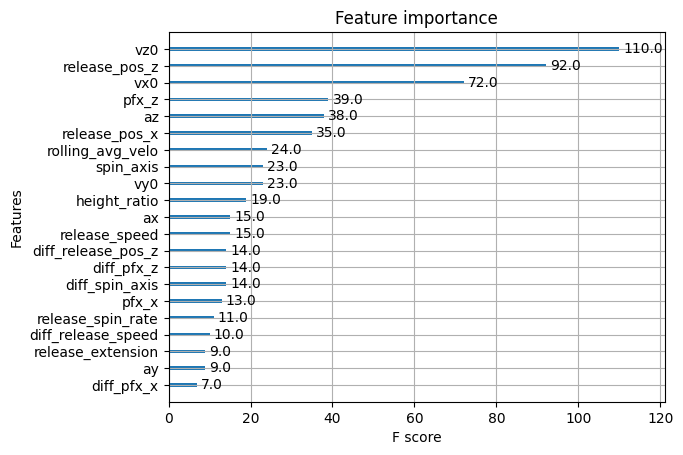

In [15]:
xgb.plot_importance(model)
plt.show()

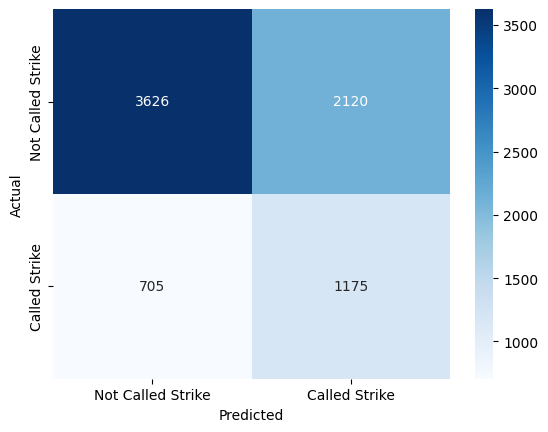

In [16]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Called Strike', 'Called Strike'], yticklabels=['Not Called Strike', 'Called Strike'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Initial Paramater Tuning

In [17]:
def objective(trial):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'scale_pos_weight': class_ratio,
        'device': 'gpu',
    }

    # Train the model with early stopping
    model = xgb.train(
        param, 
        dtrain, 
        num_boost_round=100,  # Maximum number of boosting rounds
        evals=[(dvalid, 'eval')],  # Validation set for early stopping
        early_stopping_rounds=50  # Stop if the eval metric doesn't improve for 50 rounds
    )
    
    # Predict on the validation set using the best iteration
    y_valid_pred = model.predict(dvalid)
    
    # Calculate the log loss on the validation set
    loss = log_loss(y_valid, y_valid_pred)

    return loss

In [18]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

[I 2023-11-16 14:15:46,260] A new study created in memory with name: no-name-1b3de95e-2323-449d-87d5-33d532fdb3cc


[0]	eval-logloss:0.67103
[1]	eval-logloss:0.65500
[2]	eval-logloss:0.64216
[3]	eval-logloss:0.63232


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:15:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.62504
[5]	eval-logloss:0.61691
[6]	eval-logloss:0.61099
[7]	eval-logloss:0.60641
[8]	eval-logloss:0.60055
[9]	eval-logloss:0.59680
[10]	eval-logloss:0.59386
[11]	eval-logloss:0.59090
[12]	eval-logloss:0.58686
[13]	eval-logloss:0.58503
[14]	eval-logloss:0.58196
[15]	eval-logloss:0.58008
[16]	eval-logloss:0.57765
[17]	eval-logloss:0.57493
[18]	eval-logloss:0.57376
[19]	eval-logloss:0.57221
[20]	eval-logloss:0.56971
[21]	eval-logloss:0.56740
[22]	eval-logloss:0.56616
[23]	eval-logloss:0.56461
[24]	eval-logloss:0.56333
[25]	eval-logloss:0.56216
[26]	eval-logloss:0.56179
[27]	eval-logloss:0.56110
[28]	eval-logloss:0.56025
[29]	eval-logloss:0.55961
[30]	eval-logloss:0.55891
[31]	eval-logloss:0.55794
[32]	eval-logloss:0.55790
[33]	eval-logloss:0.55620
[34]	eval-logloss:0.55629
[35]	eval-logloss:0.55525
[36]	eval-logloss:0.55427
[37]	eval-logloss:0.55389
[38]	eval-logloss:0.55290
[39]	eval-logloss:0.55137
[40]	eval-logloss:0.55114
[41]	eval-logloss:0.55034
[42]	eval-logloss:

[I 2023-11-16 14:15:47,546] Trial 0 finished with value: 0.5311877552266118 and parameters: {'max_depth': 8, 'eta': 0.14158250126816624, 'subsample': 0.7550004461248878, 'colsample_bytree': 0.9801406359835222}. Best is trial 0 with value: 0.5311877552266118.


[0]	eval-logloss:0.68719
[1]	eval-logloss:0.68195
[2]	eval-logloss:0.67786
[3]	eval-logloss:0.67432
[4]	eval-logloss:0.67075
[5]	eval-logloss:0.66774
[6]	eval-logloss:0.66498
[7]	eval-logloss:0.66284
[8]	eval-logloss:0.66083
[9]	eval-logloss:0.65887
[10]	eval-logloss:0.65741
[11]	eval-logloss:0.65605
[12]	eval-logloss:0.65439
[13]	eval-logloss:0.65324
[14]	eval-logloss:0.65168
[15]	eval-logloss:0.65043
[16]	eval-logloss:0.64909
[17]	eval-logloss:0.64804
[18]	eval-logloss:0.64684
[19]	eval-logloss:0.64585
[20]	eval-logloss:0.64473


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:15:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[21]	eval-logloss:0.64348
[22]	eval-logloss:0.64209
[23]	eval-logloss:0.64145
[24]	eval-logloss:0.64056
[25]	eval-logloss:0.63997
[26]	eval-logloss:0.63894
[27]	eval-logloss:0.63825
[28]	eval-logloss:0.63745
[29]	eval-logloss:0.63674
[30]	eval-logloss:0.63615
[31]	eval-logloss:0.63529
[32]	eval-logloss:0.63422
[33]	eval-logloss:0.63348
[34]	eval-logloss:0.63297
[35]	eval-logloss:0.63258
[36]	eval-logloss:0.63155
[37]	eval-logloss:0.63114
[38]	eval-logloss:0.63063
[39]	eval-logloss:0.63009
[40]	eval-logloss:0.62963
[41]	eval-logloss:0.62877
[42]	eval-logloss:0.62775
[43]	eval-logloss:0.62721
[44]	eval-logloss:0.62671
[45]	eval-logloss:0.62614
[46]	eval-logloss:0.62563
[47]	eval-logloss:0.62512
[48]	eval-logloss:0.62441
[49]	eval-logloss:0.62376
[50]	eval-logloss:0.62352
[51]	eval-logloss:0.62297
[52]	eval-logloss:0.62273
[53]	eval-logloss:0.62229
[54]	eval-logloss:0.62187
[55]	eval-logloss:0.62188
[56]	eval-logloss:0.62186
[57]	eval-logloss:0.62127
[58]	eval-logloss:0.62082
[59]	eval-lo

[I 2023-11-16 14:15:48,141] Trial 1 finished with value: 0.6090900960802602 and parameters: {'max_depth': 3, 'eta': 0.07955832455266558, 'subsample': 0.7929010446406461, 'colsample_bytree': 0.8926698186065238}. Best is trial 0 with value: 0.5311877552266118.


[0]	eval-logloss:0.69054
[1]	eval-logloss:0.68813
[2]	eval-logloss:0.68598
[3]	eval-logloss:0.68404
[4]	eval-logloss:0.68202
[5]	eval-logloss:0.68010
[6]	eval-logloss:0.67810
[7]	eval-logloss:0.67650
[8]	eval-logloss:0.67490
[9]	eval-logloss:0.67336
[10]	eval-logloss:0.67187
[11]	eval-logloss:0.67056
[12]	eval-logloss:0.66932
[13]	eval-logloss:0.66816
[14]	eval-logloss:0.66677
[15]	eval-logloss:0.66540
[16]	eval-logloss:0.66415
[17]	eval-logloss:0.66400
[18]	eval-logloss:0.66338
[19]	eval-logloss:0.66284
[20]	eval-logloss:0.66191
[21]	eval-logloss:0.66062


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:15:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[22]	eval-logloss:0.65940
[23]	eval-logloss:0.65899
[24]	eval-logloss:0.65784
[25]	eval-logloss:0.65685
[26]	eval-logloss:0.65609
[27]	eval-logloss:0.65516
[28]	eval-logloss:0.65503
[29]	eval-logloss:0.65415
[30]	eval-logloss:0.65315
[31]	eval-logloss:0.65297
[32]	eval-logloss:0.65202
[33]	eval-logloss:0.65145
[34]	eval-logloss:0.65063
[35]	eval-logloss:0.64990
[36]	eval-logloss:0.64968
[37]	eval-logloss:0.64885
[38]	eval-logloss:0.64803
[39]	eval-logloss:0.64759
[40]	eval-logloss:0.64686
[41]	eval-logloss:0.64641
[42]	eval-logloss:0.64557
[43]	eval-logloss:0.64484
[44]	eval-logloss:0.64409
[45]	eval-logloss:0.64362
[46]	eval-logloss:0.64301
[47]	eval-logloss:0.64233
[48]	eval-logloss:0.64163
[49]	eval-logloss:0.64091
[50]	eval-logloss:0.64041
[51]	eval-logloss:0.63985
[52]	eval-logloss:0.63941
[53]	eval-logloss:0.63890
[54]	eval-logloss:0.63840
[55]	eval-logloss:0.63799
[56]	eval-logloss:0.63757
[57]	eval-logloss:0.63699
[58]	eval-logloss:0.63647
[59]	eval-logloss:0.63602
[60]	eval-lo

[I 2023-11-16 14:15:48,793] Trial 2 finished with value: 0.6221996281942507 and parameters: {'max_depth': 4, 'eta': 0.026849065280740707, 'subsample': 0.7205051551171651, 'colsample_bytree': 0.7545220306271323}. Best is trial 0 with value: 0.5311877552266118.


[0]	eval-logloss:0.66820
[1]	eval-logloss:0.65027
[2]	eval-logloss:0.63964
[3]	eval-logloss:0.63264
[4]	eval-logloss:0.62560
[5]	eval-logloss:0.61587
[6]	eval-logloss:0.60798
[7]	eval-logloss:0.60342
[8]	eval-logloss:0.60079


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:15:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[9]	eval-logloss:0.59824
[10]	eval-logloss:0.59627
[11]	eval-logloss:0.59403
[12]	eval-logloss:0.59090
[13]	eval-logloss:0.59020
[14]	eval-logloss:0.58525
[15]	eval-logloss:0.58218
[16]	eval-logloss:0.58040
[17]	eval-logloss:0.58021
[18]	eval-logloss:0.57802
[19]	eval-logloss:0.57729
[20]	eval-logloss:0.57525
[21]	eval-logloss:0.57244
[22]	eval-logloss:0.57209
[23]	eval-logloss:0.57163
[24]	eval-logloss:0.57020
[25]	eval-logloss:0.56936
[26]	eval-logloss:0.56789
[27]	eval-logloss:0.56694
[28]	eval-logloss:0.56640
[29]	eval-logloss:0.56596
[30]	eval-logloss:0.56431
[31]	eval-logloss:0.56402
[32]	eval-logloss:0.56268
[33]	eval-logloss:0.56198
[34]	eval-logloss:0.56202
[35]	eval-logloss:0.56172
[36]	eval-logloss:0.56065
[37]	eval-logloss:0.55900
[38]	eval-logloss:0.55868
[39]	eval-logloss:0.55711
[40]	eval-logloss:0.55800
[41]	eval-logloss:0.55723
[42]	eval-logloss:0.55647
[43]	eval-logloss:0.55540
[44]	eval-logloss:0.55493
[45]	eval-logloss:0.55426
[46]	eval-logloss:0.55447
[47]	eval-log

[I 2023-11-16 14:15:49,879] Trial 3 finished with value: 0.5422668478968877 and parameters: {'max_depth': 8, 'eta': 0.17312796856731924, 'subsample': 0.660783975569059, 'colsample_bytree': 0.6469338085591604}. Best is trial 0 with value: 0.5311877552266118.


[0]	eval-logloss:0.69003
[1]	eval-logloss:0.68712
[2]	eval-logloss:0.68457
[3]	eval-logloss:0.68228
[4]	eval-logloss:0.67984
[5]	eval-logloss:0.67729
[6]	eval-logloss:0.67519
[7]	eval-logloss:0.67317
[8]	eval-logloss:0.67121
[9]	eval-logloss:0.66934
[10]	eval-logloss:0.66751
[11]	eval-logloss:0.66589
[12]	eval-logloss:0.66455
[13]	eval-logloss:0.66410
[14]	eval-logloss:0.66226
[15]	eval-logloss:0.66155
[16]	eval-logloss:0.65989


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:15:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[17]	eval-logloss:0.65966
[18]	eval-logloss:0.65893
[19]	eval-logloss:0.65837
[20]	eval-logloss:0.65723
[21]	eval-logloss:0.65548
[22]	eval-logloss:0.65393
[23]	eval-logloss:0.65338
[24]	eval-logloss:0.65283
[25]	eval-logloss:0.65152
[26]	eval-logloss:0.65056
[27]	eval-logloss:0.64917
[28]	eval-logloss:0.64898
[29]	eval-logloss:0.64781
[30]	eval-logloss:0.64665
[31]	eval-logloss:0.64639
[32]	eval-logloss:0.64527
[33]	eval-logloss:0.64498
[34]	eval-logloss:0.64397
[35]	eval-logloss:0.64302
[36]	eval-logloss:0.64264
[37]	eval-logloss:0.64157
[38]	eval-logloss:0.64060
[39]	eval-logloss:0.63993
[40]	eval-logloss:0.63923
[41]	eval-logloss:0.63874
[42]	eval-logloss:0.63771
[43]	eval-logloss:0.63672
[44]	eval-logloss:0.63566
[45]	eval-logloss:0.63512
[46]	eval-logloss:0.63439
[47]	eval-logloss:0.63361
[48]	eval-logloss:0.63280
[49]	eval-logloss:0.63195
[50]	eval-logloss:0.63113
[51]	eval-logloss:0.63033
[52]	eval-logloss:0.62998
[53]	eval-logloss:0.62929
[54]	eval-logloss:0.62883
[55]	eval-lo

[I 2023-11-16 14:15:50,620] Trial 4 finished with value: 0.6105231332247406 and parameters: {'max_depth': 5, 'eta': 0.028315258722304025, 'subsample': 0.6623723217138645, 'colsample_bytree': 0.6918441409255355}. Best is trial 0 with value: 0.5311877552266118.


[0]	eval-logloss:0.67313
[1]	eval-logloss:0.66247
[2]	eval-logloss:0.65687
[3]	eval-logloss:0.65306
[4]	eval-logloss:0.64893
[5]	eval-logloss:0.64447
[6]	eval-logloss:0.64107
[7]	eval-logloss:0.64015
[8]	eval-logloss:0.63594
[9]	eval-logloss:0.63471
[10]	eval-logloss:0.63383
[11]	eval-logloss:0.63168
[12]	eval-logloss:0.62876
[13]	eval-logloss:0.62882
[14]	eval-logloss:0.62506
[15]	eval-logloss:0.62383
[16]	eval-logloss:0.62230
[17]	eval-logloss:0.62208
[18]	eval-logloss:0.62040
[19]	eval-logloss:0.62005
[20]	eval-logloss:0.61924
[21]	eval-logloss:0.61742
[22]	eval-logloss:0.61563
[23]	eval-logloss:0.61582
[24]	eval-logloss:0.61541
[25]	eval-logloss:0.61463
[26]	eval-logloss:0.61345
[27]	eval-logloss:0.61312
[28]	eval-logloss:0.61283


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:15:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[29]	eval-logloss:0.61161
[30]	eval-logloss:0.61130
[31]	eval-logloss:0.61068
[32]	eval-logloss:0.60924
[33]	eval-logloss:0.60831
[34]	eval-logloss:0.60852
[35]	eval-logloss:0.60887
[36]	eval-logloss:0.60751
[37]	eval-logloss:0.60660
[38]	eval-logloss:0.60600
[39]	eval-logloss:0.60560
[40]	eval-logloss:0.60601
[41]	eval-logloss:0.60509
[42]	eval-logloss:0.60253
[43]	eval-logloss:0.60114
[44]	eval-logloss:0.60153
[45]	eval-logloss:0.60085
[46]	eval-logloss:0.60137
[47]	eval-logloss:0.60145
[48]	eval-logloss:0.60047
[49]	eval-logloss:0.59931
[50]	eval-logloss:0.60012
[51]	eval-logloss:0.59942
[52]	eval-logloss:0.59967
[53]	eval-logloss:0.59984
[54]	eval-logloss:0.59938
[55]	eval-logloss:0.59996
[56]	eval-logloss:0.60075
[57]	eval-logloss:0.59953
[58]	eval-logloss:0.59822
[59]	eval-logloss:0.59821
[60]	eval-logloss:0.59760
[61]	eval-logloss:0.59727
[62]	eval-logloss:0.59668
[63]	eval-logloss:0.59652
[64]	eval-logloss:0.59542
[65]	eval-logloss:0.59594
[66]	eval-logloss:0.59618
[67]	eval-lo

[I 2023-11-16 14:15:51,148] Trial 5 finished with value: 0.590792499615883 and parameters: {'max_depth': 3, 'eta': 0.29695046869551744, 'subsample': 0.7635943470229534, 'colsample_bytree': 0.7840713034056398}. Best is trial 0 with value: 0.5311877552266118.


[0]	eval-logloss:0.68061
[1]	eval-logloss:0.67140
[2]	eval-logloss:0.66469
[3]	eval-logloss:0.65891
[4]	eval-logloss:0.65377
[5]	eval-logloss:0.64951
[6]	eval-logloss:0.64510
[7]	eval-logloss:0.64263
[8]	eval-logloss:0.63994
[9]	eval-logloss:0.63756
[10]	eval-logloss:0.63565
[11]	eval-logloss:0.63443
[12]	eval-logloss:0.63307
[13]	eval-logloss:0.63168
[14]	eval-logloss:0.62961
[15]	eval-logloss:0.62697
[16]	eval-logloss:0.62565
[17]	eval-logloss:0.62472
[18]	eval-logloss:0.62330
[19]	eval-logloss:0.62096


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:15:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[20]	eval-logloss:0.62014
[21]	eval-logloss:0.61800
[22]	eval-logloss:0.61591
[23]	eval-logloss:0.61542
[24]	eval-logloss:0.61482
[25]	eval-logloss:0.61354
[26]	eval-logloss:0.61279
[27]	eval-logloss:0.61159
[28]	eval-logloss:0.61101
[29]	eval-logloss:0.60986
[30]	eval-logloss:0.60946
[31]	eval-logloss:0.60880
[32]	eval-logloss:0.60802
[33]	eval-logloss:0.60623
[34]	eval-logloss:0.60547
[35]	eval-logloss:0.60546
[36]	eval-logloss:0.60359
[37]	eval-logloss:0.60336
[38]	eval-logloss:0.60277
[39]	eval-logloss:0.60260
[40]	eval-logloss:0.60225
[41]	eval-logloss:0.60127
[42]	eval-logloss:0.60049
[43]	eval-logloss:0.59943
[44]	eval-logloss:0.59908
[45]	eval-logloss:0.59850
[46]	eval-logloss:0.59792
[47]	eval-logloss:0.59764
[48]	eval-logloss:0.59692
[49]	eval-logloss:0.59671
[50]	eval-logloss:0.59694
[51]	eval-logloss:0.59643
[52]	eval-logloss:0.59632
[53]	eval-logloss:0.59596
[54]	eval-logloss:0.59615
[55]	eval-logloss:0.59624
[56]	eval-logloss:0.59630
[57]	eval-logloss:0.59550
[58]	eval-lo

[I 2023-11-16 14:15:51,775] Trial 6 finished with value: 0.5846041642116397 and parameters: {'max_depth': 4, 'eta': 0.13953775659781506, 'subsample': 0.6910755507387134, 'colsample_bytree': 0.9508005769118353}. Best is trial 0 with value: 0.5311877552266118.


[0]	eval-logloss:0.67037
[1]	eval-logloss:0.65373
[2]	eval-logloss:0.64310
[3]	eval-logloss:0.63530
[4]	eval-logloss:0.62725
[5]	eval-logloss:0.61861
[6]	eval-logloss:0.61154
[7]	eval-logloss:0.60772
[8]	eval-logloss:0.60284
[9]	eval-logloss:0.59949


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:15:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[10]	eval-logloss:0.59755
[11]	eval-logloss:0.59399
[12]	eval-logloss:0.58941
[13]	eval-logloss:0.58737
[14]	eval-logloss:0.58355
[15]	eval-logloss:0.58133
[16]	eval-logloss:0.57975
[17]	eval-logloss:0.57903
[18]	eval-logloss:0.57579
[19]	eval-logloss:0.57353
[20]	eval-logloss:0.57236
[21]	eval-logloss:0.57124
[22]	eval-logloss:0.57038
[23]	eval-logloss:0.56881
[24]	eval-logloss:0.56667
[25]	eval-logloss:0.56590
[26]	eval-logloss:0.56508
[27]	eval-logloss:0.56390
[28]	eval-logloss:0.56278
[29]	eval-logloss:0.56222
[30]	eval-logloss:0.56066
[31]	eval-logloss:0.55991
[32]	eval-logloss:0.55869
[33]	eval-logloss:0.55770
[34]	eval-logloss:0.55767
[35]	eval-logloss:0.55718
[36]	eval-logloss:0.55654
[37]	eval-logloss:0.55667
[38]	eval-logloss:0.55605
[39]	eval-logloss:0.55542
[40]	eval-logloss:0.55522
[41]	eval-logloss:0.55492
[42]	eval-logloss:0.55359
[43]	eval-logloss:0.55323
[44]	eval-logloss:0.55311
[45]	eval-logloss:0.55234
[46]	eval-logloss:0.55216
[47]	eval-logloss:0.55232
[48]	eval-lo

[I 2023-11-16 14:15:52,839] Trial 7 finished with value: 0.5382023902944884 and parameters: {'max_depth': 8, 'eta': 0.16308800523548422, 'subsample': 0.7970923215373996, 'colsample_bytree': 0.760404193647058}. Best is trial 0 with value: 0.5311877552266118.


[0]	eval-logloss:0.66786
[1]	eval-logloss:0.64954
[2]	eval-logloss:0.63695
[3]	eval-logloss:0.62823
[4]	eval-logloss:0.62064
[5]	eval-logloss:0.61076
[6]	eval-logloss:0.60350


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:15:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.59887
[8]	eval-logloss:0.59358
[9]	eval-logloss:0.59098
[10]	eval-logloss:0.58765
[11]	eval-logloss:0.58473
[12]	eval-logloss:0.58212
[13]	eval-logloss:0.57994
[14]	eval-logloss:0.57528
[15]	eval-logloss:0.57224
[16]	eval-logloss:0.56996
[17]	eval-logloss:0.56952
[18]	eval-logloss:0.56783
[19]	eval-logloss:0.56549
[20]	eval-logloss:0.56254
[21]	eval-logloss:0.55929
[22]	eval-logloss:0.55864
[23]	eval-logloss:0.55791
[24]	eval-logloss:0.55743
[25]	eval-logloss:0.55482
[26]	eval-logloss:0.55434
[27]	eval-logloss:0.55383
[28]	eval-logloss:0.55312
[29]	eval-logloss:0.55212
[30]	eval-logloss:0.55166
[31]	eval-logloss:0.55095
[32]	eval-logloss:0.55029
[33]	eval-logloss:0.54840
[34]	eval-logloss:0.54797
[35]	eval-logloss:0.54805
[36]	eval-logloss:0.54656
[37]	eval-logloss:0.54631
[38]	eval-logloss:0.54587
[39]	eval-logloss:0.54504
[40]	eval-logloss:0.54455
[41]	eval-logloss:0.54345
[42]	eval-logloss:0.54278
[43]	eval-logloss:0.54250
[44]	eval-logloss:0.54185
[45]	eval-loglo

[I 2023-11-16 14:15:54,382] Trial 8 finished with value: 0.5316385771908099 and parameters: {'max_depth': 9, 'eta': 0.15691046787081733, 'subsample': 0.6523028990665677, 'colsample_bytree': 0.7963846584845251}. Best is trial 0 with value: 0.5311877552266118.


[0]	eval-logloss:0.68616
[1]	eval-logloss:0.67989
[2]	eval-logloss:0.67523
[3]	eval-logloss:0.67092
[4]	eval-logloss:0.66681
[5]	eval-logloss:0.66300
[6]	eval-logloss:0.65921
[7]	eval-logloss:0.65672
[8]	eval-logloss:0.65391
[9]	eval-logloss:0.65166
[10]	eval-logloss:0.64943
[11]	eval-logloss:0.64771
[12]	eval-logloss:0.64575
[13]	eval-logloss:0.64479
[14]	eval-logloss:0.64262


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:15:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[15]	eval-logloss:0.64126
[16]	eval-logloss:0.63994
[17]	eval-logloss:0.63941
[18]	eval-logloss:0.63769
[19]	eval-logloss:0.63636
[20]	eval-logloss:0.63517
[21]	eval-logloss:0.63368
[22]	eval-logloss:0.63234
[23]	eval-logloss:0.63152
[24]	eval-logloss:0.62990
[25]	eval-logloss:0.62865
[26]	eval-logloss:0.62801
[27]	eval-logloss:0.62698
[28]	eval-logloss:0.62649
[29]	eval-logloss:0.62582
[30]	eval-logloss:0.62508
[31]	eval-logloss:0.62477
[32]	eval-logloss:0.62343
[33]	eval-logloss:0.62204
[34]	eval-logloss:0.62152
[35]	eval-logloss:0.62120
[36]	eval-logloss:0.62074
[37]	eval-logloss:0.61989
[38]	eval-logloss:0.61934
[39]	eval-logloss:0.61848
[40]	eval-logloss:0.61794
[41]	eval-logloss:0.61725
[42]	eval-logloss:0.61626
[43]	eval-logloss:0.61531
[44]	eval-logloss:0.61467
[45]	eval-logloss:0.61398
[46]	eval-logloss:0.61370
[47]	eval-logloss:0.61316
[48]	eval-logloss:0.61249
[49]	eval-logloss:0.61150
[50]	eval-logloss:0.61115
[51]	eval-logloss:0.61065
[52]	eval-logloss:0.61032
[53]	eval-lo

[I 2023-11-16 14:15:55,058] Trial 9 finished with value: 0.5961638640776815 and parameters: {'max_depth': 4, 'eta': 0.07774495906042378, 'subsample': 0.7511655023695802, 'colsample_bytree': 0.770935015027306}. Best is trial 0 with value: 0.5311877552266118.


[0]	eval-logloss:0.66453
[1]	eval-logloss:0.64594
[2]	eval-logloss:0.63430
[3]	eval-logloss:0.62579
[4]	eval-logloss:0.61896
[5]	eval-logloss:0.61381
[6]	eval-logloss:0.60921
[7]	eval-logloss:0.60506


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:15:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-logloss:0.60232
[9]	eval-logloss:0.59838
[10]	eval-logloss:0.59636
[11]	eval-logloss:0.59480
[12]	eval-logloss:0.58902
[13]	eval-logloss:0.58693
[14]	eval-logloss:0.58416
[15]	eval-logloss:0.58290
[16]	eval-logloss:0.58043
[17]	eval-logloss:0.57963
[18]	eval-logloss:0.57823
[19]	eval-logloss:0.57767
[20]	eval-logloss:0.57569
[21]	eval-logloss:0.57412
[22]	eval-logloss:0.57194
[23]	eval-logloss:0.57113
[24]	eval-logloss:0.57072
[25]	eval-logloss:0.56939
[26]	eval-logloss:0.56925
[27]	eval-logloss:0.56920
[28]	eval-logloss:0.56784
[29]	eval-logloss:0.56741
[30]	eval-logloss:0.56636
[31]	eval-logloss:0.56497
[32]	eval-logloss:0.56435
[33]	eval-logloss:0.56427
[34]	eval-logloss:0.56364
[35]	eval-logloss:0.56268
[36]	eval-logloss:0.56155
[37]	eval-logloss:0.56139
[38]	eval-logloss:0.55989
[39]	eval-logloss:0.55925
[40]	eval-logloss:0.55865
[41]	eval-logloss:0.55868
[42]	eval-logloss:0.55774
[43]	eval-logloss:0.55688
[44]	eval-logloss:0.55670
[45]	eval-logloss:0.55607
[46]	eval-logl

[I 2023-11-16 14:15:56,074] Trial 10 finished with value: 0.5435516699881878 and parameters: {'max_depth': 7, 'eta': 0.2303817803633309, 'subsample': 0.8820042175401843, 'colsample_bytree': 0.974155452456429}. Best is trial 0 with value: 0.5311877552266118.


[0]	eval-logloss:0.67316
[1]	eval-logloss:0.65782
[2]	eval-logloss:0.64671
[3]	eval-logloss:0.63917
[4]	eval-logloss:0.63181


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:15:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.62195
[6]	eval-logloss:0.61453
[7]	eval-logloss:0.60897
[8]	eval-logloss:0.60454
[9]	eval-logloss:0.60025
[10]	eval-logloss:0.59747
[11]	eval-logloss:0.59530
[12]	eval-logloss:0.59254
[13]	eval-logloss:0.59090
[14]	eval-logloss:0.58619
[15]	eval-logloss:0.58219
[16]	eval-logloss:0.57958
[17]	eval-logloss:0.57912
[18]	eval-logloss:0.57896
[19]	eval-logloss:0.57751
[20]	eval-logloss:0.57534
[21]	eval-logloss:0.57232
[22]	eval-logloss:0.57165
[23]	eval-logloss:0.57089
[24]	eval-logloss:0.56917
[25]	eval-logloss:0.56700
[26]	eval-logloss:0.56592
[27]	eval-logloss:0.56504
[28]	eval-logloss:0.56463
[29]	eval-logloss:0.56336
[30]	eval-logloss:0.56147
[31]	eval-logloss:0.56042
[32]	eval-logloss:0.55928
[33]	eval-logloss:0.55889
[34]	eval-logloss:0.55860
[35]	eval-logloss:0.55772
[36]	eval-logloss:0.55647
[37]	eval-logloss:0.55540
[38]	eval-logloss:0.55494
[39]	eval-logloss:0.55457
[40]	eval-logloss:0.55453
[41]	eval-logloss:0.55384
[42]	eval-logloss:0.55315
[43]	eval-logloss

[I 2023-11-16 14:15:57,586] Trial 11 finished with value: 0.534188011839157 and parameters: {'max_depth': 9, 'eta': 0.12415068186075975, 'subsample': 0.6207960170377426, 'colsample_bytree': 0.5480207216587883}. Best is trial 0 with value: 0.5311877552266118.


[0]	eval-logloss:0.66380
[1]	eval-logloss:0.64377
[2]	eval-logloss:0.62807


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:15:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.61773
[4]	eval-logloss:0.61012
[5]	eval-logloss:0.60123
[6]	eval-logloss:0.59446
[7]	eval-logloss:0.59152
[8]	eval-logloss:0.58723
[9]	eval-logloss:0.58348
[10]	eval-logloss:0.58034
[11]	eval-logloss:0.57777
[12]	eval-logloss:0.57669
[13]	eval-logloss:0.57529
[14]	eval-logloss:0.57329
[15]	eval-logloss:0.57206
[16]	eval-logloss:0.57103
[17]	eval-logloss:0.57071
[18]	eval-logloss:0.57024
[19]	eval-logloss:0.56981
[20]	eval-logloss:0.56762
[21]	eval-logloss:0.56630
[22]	eval-logloss:0.56669
[23]	eval-logloss:0.56672
[24]	eval-logloss:0.56666
[25]	eval-logloss:0.56504
[26]	eval-logloss:0.56435
[27]	eval-logloss:0.56476
[28]	eval-logloss:0.56337
[29]	eval-logloss:0.56213
[30]	eval-logloss:0.56188
[31]	eval-logloss:0.56213
[32]	eval-logloss:0.56276
[33]	eval-logloss:0.56247
[34]	eval-logloss:0.56251
[35]	eval-logloss:0.56174
[36]	eval-logloss:0.56024
[37]	eval-logloss:0.55960
[38]	eval-logloss:0.55944
[39]	eval-logloss:0.55817
[40]	eval-logloss:0.55923
[41]	eval-logloss:0

[I 2023-11-16 14:15:59,069] Trial 12 finished with value: 0.556803052522907 and parameters: {'max_depth': 9, 'eta': 0.19767745309995416, 'subsample': 0.604395509957832, 'colsample_bytree': 0.8808384726377058}. Best is trial 0 with value: 0.5311877552266118.


[0]	eval-logloss:0.67736
[1]	eval-logloss:0.66511
[2]	eval-logloss:0.65473
[3]	eval-logloss:0.64721
[4]	eval-logloss:0.64054
[5]	eval-logloss:0.63446
[6]	eval-logloss:0.62876


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:15:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.62551
[8]	eval-logloss:0.62119
[9]	eval-logloss:0.61756
[10]	eval-logloss:0.61440
[11]	eval-logloss:0.61164
[12]	eval-logloss:0.60896
[13]	eval-logloss:0.60663
[14]	eval-logloss:0.60349
[15]	eval-logloss:0.60073
[16]	eval-logloss:0.59789
[17]	eval-logloss:0.59591
[18]	eval-logloss:0.59410
[19]	eval-logloss:0.59265
[20]	eval-logloss:0.59080
[21]	eval-logloss:0.58874
[22]	eval-logloss:0.58738
[23]	eval-logloss:0.58701
[24]	eval-logloss:0.58554
[25]	eval-logloss:0.58477
[26]	eval-logloss:0.58423
[27]	eval-logloss:0.58340
[28]	eval-logloss:0.58302
[29]	eval-logloss:0.58174
[30]	eval-logloss:0.58015
[31]	eval-logloss:0.57922
[32]	eval-logloss:0.57838
[33]	eval-logloss:0.57672
[34]	eval-logloss:0.57577
[35]	eval-logloss:0.57589
[36]	eval-logloss:0.57428
[37]	eval-logloss:0.57357
[38]	eval-logloss:0.57276
[39]	eval-logloss:0.57124
[40]	eval-logloss:0.57093
[41]	eval-logloss:0.56958
[42]	eval-logloss:0.56886
[43]	eval-logloss:0.56779
[44]	eval-logloss:0.56699
[45]	eval-loglo

[I 2023-11-16 14:16:00,081] Trial 13 finished with value: 0.5469120474058143 and parameters: {'max_depth': 7, 'eta': 0.10909720801340894, 'subsample': 0.7150372228596311, 'colsample_bytree': 0.9917097741511123}. Best is trial 0 with value: 0.5311877552266118.


[0]	eval-logloss:0.66396
[1]	eval-logloss:0.64492
[2]	eval-logloss:0.63192
[3]	eval-logloss:0.62213
[4]	eval-logloss:0.61407
[5]	eval-logloss:0.60831


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:16:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.60358
[7]	eval-logloss:0.60017
[8]	eval-logloss:0.59529
[9]	eval-logloss:0.59407
[10]	eval-logloss:0.58920
[11]	eval-logloss:0.58774
[12]	eval-logloss:0.58563
[13]	eval-logloss:0.58607
[14]	eval-logloss:0.58275
[15]	eval-logloss:0.58039
[16]	eval-logloss:0.57865
[17]	eval-logloss:0.57917
[18]	eval-logloss:0.57689
[19]	eval-logloss:0.57556
[20]	eval-logloss:0.57331
[21]	eval-logloss:0.57074
[22]	eval-logloss:0.56957
[23]	eval-logloss:0.56988
[24]	eval-logloss:0.56893
[25]	eval-logloss:0.56736
[26]	eval-logloss:0.56598
[27]	eval-logloss:0.56611
[28]	eval-logloss:0.56547
[29]	eval-logloss:0.56490
[30]	eval-logloss:0.56479
[31]	eval-logloss:0.56418
[32]	eval-logloss:0.56394
[33]	eval-logloss:0.56388
[34]	eval-logloss:0.56382
[35]	eval-logloss:0.56367
[36]	eval-logloss:0.56306
[37]	eval-logloss:0.56312
[38]	eval-logloss:0.56273
[39]	eval-logloss:0.56234
[40]	eval-logloss:0.56208
[41]	eval-logloss:0.56164
[42]	eval-logloss:0.56097
[43]	eval-logloss:0.56044
[44]	eval-loglos

[I 2023-11-16 14:16:01,420] Trial 14 finished with value: 0.557444527856355 and parameters: {'max_depth': 8, 'eta': 0.20630976753930197, 'subsample': 0.6438603079378437, 'colsample_bytree': 0.8581009578058918}. Best is trial 0 with value: 0.5311877552266118.


[0]	eval-logloss:0.67495
[1]	eval-logloss:0.66240
[2]	eval-logloss:0.65348
[3]	eval-logloss:0.64598


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:16:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.63931
[5]	eval-logloss:0.63301
[6]	eval-logloss:0.62711
[7]	eval-logloss:0.62448
[8]	eval-logloss:0.62042
[9]	eval-logloss:0.61723
[10]	eval-logloss:0.61384
[11]	eval-logloss:0.61187
[12]	eval-logloss:0.61001
[13]	eval-logloss:0.60911
[14]	eval-logloss:0.60618
[15]	eval-logloss:0.60256
[16]	eval-logloss:0.60058
[17]	eval-logloss:0.59962
[18]	eval-logloss:0.59808
[19]	eval-logloss:0.59582
[20]	eval-logloss:0.59450
[21]	eval-logloss:0.59267
[22]	eval-logloss:0.59179
[23]	eval-logloss:0.58969
[24]	eval-logloss:0.58862
[25]	eval-logloss:0.58731
[26]	eval-logloss:0.58641
[27]	eval-logloss:0.58612
[28]	eval-logloss:0.58472
[29]	eval-logloss:0.58362
[30]	eval-logloss:0.58334
[31]	eval-logloss:0.58256
[32]	eval-logloss:0.58170
[33]	eval-logloss:0.58024
[34]	eval-logloss:0.57985
[35]	eval-logloss:0.57889
[36]	eval-logloss:0.57692
[37]	eval-logloss:0.57664
[38]	eval-logloss:0.57612
[39]	eval-logloss:0.57527
[40]	eval-logloss:0.57470
[41]	eval-logloss:0.57401
[42]	eval-logloss:

[I 2023-11-16 14:16:02,581] Trial 15 finished with value: 0.5603271842103594 and parameters: {'max_depth': 6, 'eta': 0.1512027237514347, 'subsample': 0.6894005338935982, 'colsample_bytree': 0.8380543418129924}. Best is trial 0 with value: 0.5311877552266118.


[0]	eval-logloss:0.67612


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:16:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66209
[2]	eval-logloss:0.65010
[3]	eval-logloss:0.63974
[4]	eval-logloss:0.63210
[5]	eval-logloss:0.62380
[6]	eval-logloss:0.61634
[7]	eval-logloss:0.61079
[8]	eval-logloss:0.60615
[9]	eval-logloss:0.60196
[10]	eval-logloss:0.59754
[11]	eval-logloss:0.59440
[12]	eval-logloss:0.59164
[13]	eval-logloss:0.58867
[14]	eval-logloss:0.58523
[15]	eval-logloss:0.58206
[16]	eval-logloss:0.58025
[17]	eval-logloss:0.57898
[18]	eval-logloss:0.57714
[19]	eval-logloss:0.57537
[20]	eval-logloss:0.57234
[21]	eval-logloss:0.57032
[22]	eval-logloss:0.56952
[23]	eval-logloss:0.56828
[24]	eval-logloss:0.56673
[25]	eval-logloss:0.56439
[26]	eval-logloss:0.56391
[27]	eval-logloss:0.56385
[28]	eval-logloss:0.56302
[29]	eval-logloss:0.56194
[30]	eval-logloss:0.56023
[31]	eval-logloss:0.55932
[32]	eval-logloss:0.55896
[33]	eval-logloss:0.55800
[34]	eval-logloss:0.55747
[35]	eval-logloss:0.55666
[36]	eval-logloss:0.55492
[37]	eval-logloss:0.55445
[38]	eval-logloss:0.55380
[39]	eval-logloss:0.5

[I 2023-11-16 14:16:04,609] Trial 16 finished with value: 0.5314897525928286 and parameters: {'max_depth': 9, 'eta': 0.101617983928354, 'subsample': 0.6308949968487899, 'colsample_bytree': 0.9194341580546593}. Best is trial 0 with value: 0.5311877552266118.


[0]	eval-logloss:0.67905
[1]	eval-logloss:0.66807
[2]	eval-logloss:0.65862


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:16:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65132
[4]	eval-logloss:0.64450
[5]	eval-logloss:0.63770
[6]	eval-logloss:0.63155
[7]	eval-logloss:0.62831
[8]	eval-logloss:0.62345
[9]	eval-logloss:0.62012
[10]	eval-logloss:0.61650
[11]	eval-logloss:0.61398
[12]	eval-logloss:0.61162
[13]	eval-logloss:0.61000
[14]	eval-logloss:0.60736
[15]	eval-logloss:0.60466
[16]	eval-logloss:0.60265
[17]	eval-logloss:0.60141
[18]	eval-logloss:0.59918
[19]	eval-logloss:0.59784
[20]	eval-logloss:0.59513
[21]	eval-logloss:0.59177
[22]	eval-logloss:0.59122
[23]	eval-logloss:0.59007
[24]	eval-logloss:0.58822
[25]	eval-logloss:0.58667
[26]	eval-logloss:0.58603
[27]	eval-logloss:0.58469
[28]	eval-logloss:0.58407
[29]	eval-logloss:0.58321
[30]	eval-logloss:0.58203
[31]	eval-logloss:0.58099
[32]	eval-logloss:0.58086
[33]	eval-logloss:0.57944
[34]	eval-logloss:0.57874
[35]	eval-logloss:0.57787
[36]	eval-logloss:0.57540
[37]	eval-logloss:0.57463
[38]	eval-logloss:0.57425
[39]	eval-logloss:0.57319
[40]	eval-logloss:0.57297
[41]	eval-logloss:0

[I 2023-11-16 14:16:05,896] Trial 17 finished with value: 0.5512169916937081 and parameters: {'max_depth': 7, 'eta': 0.09885248375910392, 'subsample': 0.6032065976716209, 'colsample_bytree': 0.9201323035913391}. Best is trial 0 with value: 0.5311877552266118.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:16:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68594
[1]	eval-logloss:0.67943
[2]	eval-logloss:0.67338
[3]	eval-logloss:0.66811
[4]	eval-logloss:0.66357
[5]	eval-logloss:0.65916
[6]	eval-logloss:0.65496
[7]	eval-logloss:0.65185
[8]	eval-logloss:0.64839
[9]	eval-logloss:0.64531
[10]	eval-logloss:0.64253
[11]	eval-logloss:0.64013
[12]	eval-logloss:0.63746
[13]	eval-logloss:0.63523
[14]	eval-logloss:0.63275
[15]	eval-logloss:0.63056
[16]	eval-logloss:0.62835
[17]	eval-logloss:0.62623
[18]	eval-logloss:0.62428
[19]	eval-logloss:0.62258
[20]	eval-logloss:0.62131
[21]	eval-logloss:0.61944
[22]	eval-logloss:0.61798
[23]	eval-logloss:0.61669
[24]	eval-logloss:0.61547
[25]	eval-logloss:0.61399
[26]	eval-logloss:0.61321
[27]	eval-logloss:0.61220
[28]	eval-logloss:0.61108
[29]	eval-logloss:0.61002
[30]	eval-logloss:0.60919
[31]	eval-logloss:0.60764
[32]	eval-logloss:0.60655
[33]	eval-logloss:0.60539
[34]	eval-logloss:0.60466
[35]	eval-logloss:0.60352
[36]	eval-logloss:0.60194
[37]	eval-logloss:0.60128
[38]	eval-logloss:0.60

[I 2023-11-16 14:16:07,069] Trial 18 finished with value: 0.5749895755766397 and parameters: {'max_depth': 6, 'eta': 0.059344469035586156, 'subsample': 0.732564265160971, 'colsample_bytree': 0.9939960416016704}. Best is trial 0 with value: 0.5311877552266118.


[0]	eval-logloss:0.67375
[1]	eval-logloss:0.65894
[2]	eval-logloss:0.64790

C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:16:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)



[3]	eval-logloss:0.63819
[4]	eval-logloss:0.63114
[5]	eval-logloss:0.62312
[6]	eval-logloss:0.61673
[7]	eval-logloss:0.61212
[8]	eval-logloss:0.60788
[9]	eval-logloss:0.60457
[10]	eval-logloss:0.60043
[11]	eval-logloss:0.59754
[12]	eval-logloss:0.59501
[13]	eval-logloss:0.59234
[14]	eval-logloss:0.58959
[15]	eval-logloss:0.58700
[16]	eval-logloss:0.58613
[17]	eval-logloss:0.58528
[18]	eval-logloss:0.58340
[19]	eval-logloss:0.58116
[20]	eval-logloss:0.57938
[21]	eval-logloss:0.57699
[22]	eval-logloss:0.57616
[23]	eval-logloss:0.57497
[24]	eval-logloss:0.57294
[25]	eval-logloss:0.57136
[26]	eval-logloss:0.57039
[27]	eval-logloss:0.56980
[28]	eval-logloss:0.56968
[29]	eval-logloss:0.56903
[30]	eval-logloss:0.56717
[31]	eval-logloss:0.56648
[32]	eval-logloss:0.56580
[33]	eval-logloss:0.56431
[34]	eval-logloss:0.56411
[35]	eval-logloss:0.56280
[36]	eval-logloss:0.56117
[37]	eval-logloss:0.56067
[38]	eval-logloss:0.55945
[39]	eval-logloss:0.55856
[40]	eval-logloss:0.55758
[41]	eval-logloss:

[I 2023-11-16 14:16:08,651] Trial 19 finished with value: 0.5385985470390817 and parameters: {'max_depth': 8, 'eta': 0.12894673496171885, 'subsample': 0.6923616675973956, 'colsample_bytree': 0.940371946080075}. Best is trial 0 with value: 0.5311877552266118.


[0]	eval-logloss:0.67571
[1]	eval-logloss:0.66226
[2]	eval-logloss:0.65068


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:16:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.64049
[4]	eval-logloss:0.63287
[5]	eval-logloss:0.62495
[6]	eval-logloss:0.61787
[7]	eval-logloss:0.61308
[8]	eval-logloss:0.60847
[9]	eval-logloss:0.60386
[10]	eval-logloss:0.59975
[11]	eval-logloss:0.59627
[12]	eval-logloss:0.59236
[13]	eval-logloss:0.58964
[14]	eval-logloss:0.58591
[15]	eval-logloss:0.58277
[16]	eval-logloss:0.58069
[17]	eval-logloss:0.57925
[18]	eval-logloss:0.57689
[19]	eval-logloss:0.57598
[20]	eval-logloss:0.57265
[21]	eval-logloss:0.56975
[22]	eval-logloss:0.56815
[23]	eval-logloss:0.56774
[24]	eval-logloss:0.56647
[25]	eval-logloss:0.56358
[26]	eval-logloss:0.56307
[27]	eval-logloss:0.56168
[28]	eval-logloss:0.56093
[29]	eval-logloss:0.56030
[30]	eval-logloss:0.55786
[31]	eval-logloss:0.55640
[32]	eval-logloss:0.55657
[33]	eval-logloss:0.55555
[34]	eval-logloss:0.55511
[35]	eval-logloss:0.55379
[36]	eval-logloss:0.55171
[37]	eval-logloss:0.55098
[38]	eval-logloss:0.55087
[39]	eval-logloss:0.55011
[40]	eval-logloss:0.55010
[41]	eval-logloss:0

[I 2023-11-16 14:16:10,426] Trial 20 finished with value: 0.5303574388154265 and parameters: {'max_depth': 9, 'eta': 0.10587885962068808, 'subsample': 0.6349434179375237, 'colsample_bytree': 0.9260282329797072}. Best is trial 20 with value: 0.5303574388154265.


[0]	eval-logloss:0.67578
[1]	eval-logloss:0.66216


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:16:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65026
[3]	eval-logloss:0.63961
[4]	eval-logloss:0.63198
[5]	eval-logloss:0.62416
[6]	eval-logloss:0.61630
[7]	eval-logloss:0.61078
[8]	eval-logloss:0.60603
[9]	eval-logloss:0.60176
[10]	eval-logloss:0.59781
[11]	eval-logloss:0.59430
[12]	eval-logloss:0.59049
[13]	eval-logloss:0.58769
[14]	eval-logloss:0.58362
[15]	eval-logloss:0.58051
[16]	eval-logloss:0.57803
[17]	eval-logloss:0.57678
[18]	eval-logloss:0.57491
[19]	eval-logloss:0.57351
[20]	eval-logloss:0.57022
[21]	eval-logloss:0.56789
[22]	eval-logloss:0.56756
[23]	eval-logloss:0.56564
[24]	eval-logloss:0.56403
[25]	eval-logloss:0.56128
[26]	eval-logloss:0.56072
[27]	eval-logloss:0.55971
[28]	eval-logloss:0.55949
[29]	eval-logloss:0.55853
[30]	eval-logloss:0.55611
[31]	eval-logloss:0.55521
[32]	eval-logloss:0.55430
[33]	eval-logloss:0.55299
[34]	eval-logloss:0.55146
[35]	eval-logloss:0.55093
[36]	eval-logloss:0.54987
[37]	eval-logloss:0.54966
[38]	eval-logloss:0.54930
[39]	eval-logloss:0.54828
[40]	eval-logloss:0.

[I 2023-11-16 14:16:12,215] Trial 21 finished with value: 0.524607924367191 and parameters: {'max_depth': 9, 'eta': 0.10427199522402296, 'subsample': 0.6234002230710205, 'colsample_bytree': 0.9237264618739599}. Best is trial 21 with value: 0.524607924367191.


[0]	eval-logloss:0.67369
[1]	eval-logloss:0.65912
[2]	eval-logloss:0.64547


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:16:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63500
[4]	eval-logloss:0.62688
[5]	eval-logloss:0.61979
[6]	eval-logloss:0.61348
[7]	eval-logloss:0.60888
[8]	eval-logloss:0.60282
[9]	eval-logloss:0.59879
[10]	eval-logloss:0.59512
[11]	eval-logloss:0.59240
[12]	eval-logloss:0.58813
[13]	eval-logloss:0.58532
[14]	eval-logloss:0.58282
[15]	eval-logloss:0.58022
[16]	eval-logloss:0.57855
[17]	eval-logloss:0.57741
[18]	eval-logloss:0.57606
[19]	eval-logloss:0.57442
[20]	eval-logloss:0.57104
[21]	eval-logloss:0.56862
[22]	eval-logloss:0.56757
[23]	eval-logloss:0.56651
[24]	eval-logloss:0.56538
[25]	eval-logloss:0.56277
[26]	eval-logloss:0.56258
[27]	eval-logloss:0.56090
[28]	eval-logloss:0.56064
[29]	eval-logloss:0.55920
[30]	eval-logloss:0.55773
[31]	eval-logloss:0.55649
[32]	eval-logloss:0.55629
[33]	eval-logloss:0.55522
[34]	eval-logloss:0.55429
[35]	eval-logloss:0.55405
[36]	eval-logloss:0.55224
[37]	eval-logloss:0.55142
[38]	eval-logloss:0.55117
[39]	eval-logloss:0.54976
[40]	eval-logloss:0.54972
[41]	eval-logloss:0

[I 2023-11-16 14:16:14,207] Trial 22 finished with value: 0.5253468714207538 and parameters: {'max_depth': 9, 'eta': 0.11682179328514397, 'subsample': 0.6015406824837792, 'colsample_bytree': 0.9445994269848249}. Best is trial 21 with value: 0.524607924367191.


[0]	eval-logloss:0.68398


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:16:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67640
[2]	eval-logloss:0.66941
[3]	eval-logloss:0.66326
[4]	eval-logloss:0.65755
[5]	eval-logloss:0.65087
[6]	eval-logloss:0.64450
[7]	eval-logloss:0.64071
[8]	eval-logloss:0.63583
[9]	eval-logloss:0.63171
[10]	eval-logloss:0.62760
[11]	eval-logloss:0.62415
[12]	eval-logloss:0.62072
[13]	eval-logloss:0.61741
[14]	eval-logloss:0.61399
[15]	eval-logloss:0.61100
[16]	eval-logloss:0.60818
[17]	eval-logloss:0.60753
[18]	eval-logloss:0.60557
[19]	eval-logloss:0.60363
[20]	eval-logloss:0.60124
[21]	eval-logloss:0.59806
[22]	eval-logloss:0.59592
[23]	eval-logloss:0.59489
[24]	eval-logloss:0.59272
[25]	eval-logloss:0.59024
[26]	eval-logloss:0.58890
[27]	eval-logloss:0.58756
[28]	eval-logloss:0.58675
[29]	eval-logloss:0.58477
[30]	eval-logloss:0.58322
[31]	eval-logloss:0.58189
[32]	eval-logloss:0.58040
[33]	eval-logloss:0.57885
[34]	eval-logloss:0.57754
[35]	eval-logloss:0.57626
[36]	eval-logloss:0.57510
[37]	eval-logloss:0.57421
[38]	eval-logloss:0.57314
[39]	eval-logloss:0.5

[I 2023-11-16 14:16:16,206] Trial 23 finished with value: 0.5405143197234878 and parameters: {'max_depth': 9, 'eta': 0.05166151449271763, 'subsample': 0.6011495882327524, 'colsample_bytree': 0.8409117553356227}. Best is trial 21 with value: 0.524607924367191.


[0]	eval-logloss:0.67389
[1]	eval-logloss:0.65889
[2]	eval-logloss:0.64576


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:16:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63512
[4]	eval-logloss:0.62657
[5]	eval-logloss:0.61722
[6]	eval-logloss:0.61068
[7]	eval-logloss:0.60578
[8]	eval-logloss:0.60043
[9]	eval-logloss:0.59654
[10]	eval-logloss:0.59316
[11]	eval-logloss:0.59018
[12]	eval-logloss:0.58803
[13]	eval-logloss:0.58541
[14]	eval-logloss:0.58145
[15]	eval-logloss:0.57806
[16]	eval-logloss:0.57667
[17]	eval-logloss:0.57536
[18]	eval-logloss:0.57311
[19]	eval-logloss:0.57115
[20]	eval-logloss:0.56786
[21]	eval-logloss:0.56611
[22]	eval-logloss:0.56421
[23]	eval-logloss:0.56364
[24]	eval-logloss:0.56292
[25]	eval-logloss:0.55992
[26]	eval-logloss:0.55871
[27]	eval-logloss:0.55753
[28]	eval-logloss:0.55717
[29]	eval-logloss:0.55634
[30]	eval-logloss:0.55495
[31]	eval-logloss:0.55465
[32]	eval-logloss:0.55415
[33]	eval-logloss:0.55339
[34]	eval-logloss:0.55266
[35]	eval-logloss:0.55268
[36]	eval-logloss:0.55091
[37]	eval-logloss:0.55039
[38]	eval-logloss:0.55030
[39]	eval-logloss:0.54918
[40]	eval-logloss:0.54924
[41]	eval-logloss:0

[I 2023-11-16 14:16:18,483] Trial 24 finished with value: 0.5270589675510298 and parameters: {'max_depth': 9, 'eta': 0.11626830499902696, 'subsample': 0.6303012327661026, 'colsample_bytree': 0.9052641404674951}. Best is trial 21 with value: 0.524607924367191.


[0]	eval-logloss:0.68118
[1]	eval-logloss:0.67160
[2]	eval-logloss:0.66285
[3]	eval-logloss:0.65595
[4]	eval-logloss:0.64942
[5]	eval-logloss:0.64322


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:16:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.63789
[7]	eval-logloss:0.63416
[8]	eval-logloss:0.62939
[9]	eval-logloss:0.62556
[10]	eval-logloss:0.62132
[11]	eval-logloss:0.61852
[12]	eval-logloss:0.61613
[13]	eval-logloss:0.61387
[14]	eval-logloss:0.61106
[15]	eval-logloss:0.60802
[16]	eval-logloss:0.60603
[17]	eval-logloss:0.60451
[18]	eval-logloss:0.60265
[19]	eval-logloss:0.60060
[20]	eval-logloss:0.59860
[21]	eval-logloss:0.59658
[22]	eval-logloss:0.59545
[23]	eval-logloss:0.59400
[24]	eval-logloss:0.59233
[25]	eval-logloss:0.58949
[26]	eval-logloss:0.58839
[27]	eval-logloss:0.58751
[28]	eval-logloss:0.58688
[29]	eval-logloss:0.58587
[30]	eval-logloss:0.58428
[31]	eval-logloss:0.58310
[32]	eval-logloss:0.58247
[33]	eval-logloss:0.58052
[34]	eval-logloss:0.57963
[35]	eval-logloss:0.57871
[36]	eval-logloss:0.57706
[37]	eval-logloss:0.57643
[38]	eval-logloss:0.57595
[39]	eval-logloss:0.57506
[40]	eval-logloss:0.57470
[41]	eval-logloss:0.57342
[42]	eval-logloss:0.57219
[43]	eval-logloss:0.57171
[44]	eval-loglos

[I 2023-11-16 14:16:19,761] Trial 25 finished with value: 0.5494213288110644 and parameters: {'max_depth': 7, 'eta': 0.08523996373402505, 'subsample': 0.6245248066588979, 'colsample_bytree': 0.8850647340142624}. Best is trial 21 with value: 0.524607924367191.


[0]	eval-logloss:0.67490
[1]	eval-logloss:0.66041
[2]	eval-logloss:0.64869


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:16:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63973
[4]	eval-logloss:0.63188
[5]	eval-logloss:0.62419
[6]	eval-logloss:0.61810
[7]	eval-logloss:0.61364
[8]	eval-logloss:0.60919
[9]	eval-logloss:0.60533
[10]	eval-logloss:0.60118
[11]	eval-logloss:0.59829
[12]	eval-logloss:0.59500
[13]	eval-logloss:0.59173
[14]	eval-logloss:0.58855
[15]	eval-logloss:0.58588
[16]	eval-logloss:0.58413
[17]	eval-logloss:0.58291
[18]	eval-logloss:0.58055
[19]	eval-logloss:0.57850
[20]	eval-logloss:0.57630
[21]	eval-logloss:0.57425
[22]	eval-logloss:0.57284
[23]	eval-logloss:0.57189
[24]	eval-logloss:0.57097
[25]	eval-logloss:0.56970
[26]	eval-logloss:0.56863
[27]	eval-logloss:0.56749
[28]	eval-logloss:0.56652
[29]	eval-logloss:0.56520
[30]	eval-logloss:0.56343
[31]	eval-logloss:0.56289
[32]	eval-logloss:0.56171
[33]	eval-logloss:0.56066
[34]	eval-logloss:0.55955
[35]	eval-logloss:0.55891
[36]	eval-logloss:0.55683
[37]	eval-logloss:0.55589
[38]	eval-logloss:0.55507
[39]	eval-logloss:0.55420
[40]	eval-logloss:0.55421
[41]	eval-logloss:0

[I 2023-11-16 14:16:21,279] Trial 26 finished with value: 0.5354013469512213 and parameters: {'max_depth': 8, 'eta': 0.12019098452758722, 'subsample': 0.6678916933959032, 'colsample_bytree': 0.9487631725637733}. Best is trial 21 with value: 0.524607924367191.


[0]	eval-logloss:0.68289
[1]	eval-logloss:0.67429


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:16:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66551
[3]	eval-logloss:0.65827
[4]	eval-logloss:0.65184
[5]	eval-logloss:0.64527
[6]	eval-logloss:0.63846
[7]	eval-logloss:0.63383
[8]	eval-logloss:0.62904
[9]	eval-logloss:0.62496
[10]	eval-logloss:0.62006
[11]	eval-logloss:0.61684
[12]	eval-logloss:0.61361
[13]	eval-logloss:0.61087
[14]	eval-logloss:0.60764
[15]	eval-logloss:0.60459
[16]	eval-logloss:0.60229
[17]	eval-logloss:0.60155
[18]	eval-logloss:0.59959
[19]	eval-logloss:0.59833
[20]	eval-logloss:0.59590
[21]	eval-logloss:0.59274
[22]	eval-logloss:0.59047
[23]	eval-logloss:0.58951
[24]	eval-logloss:0.58717
[25]	eval-logloss:0.58482
[26]	eval-logloss:0.58296
[27]	eval-logloss:0.58107
[28]	eval-logloss:0.58032
[29]	eval-logloss:0.57836
[30]	eval-logloss:0.57622
[31]	eval-logloss:0.57544
[32]	eval-logloss:0.57354
[33]	eval-logloss:0.57212
[34]	eval-logloss:0.57104
[35]	eval-logloss:0.56990
[36]	eval-logloss:0.56876
[37]	eval-logloss:0.56784
[38]	eval-logloss:0.56679
[39]	eval-logloss:0.56530
[40]	eval-logloss:0.

[I 2023-11-16 14:16:23,367] Trial 27 finished with value: 0.5340526426845166 and parameters: {'max_depth': 9, 'eta': 0.05898991376282703, 'subsample': 0.6228346667411994, 'colsample_bytree': 0.8298599380522317}. Best is trial 21 with value: 0.524607924367191.


[0]	eval-logloss:0.69126
[1]	eval-logloss:0.68947
[2]	eval-logloss:0.68771
[3]	eval-logloss:0.68617


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:16:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68463
[5]	eval-logloss:0.68283
[6]	eval-logloss:0.68106
[7]	eval-logloss:0.67962
[8]	eval-logloss:0.67803
[9]	eval-logloss:0.67654
[10]	eval-logloss:0.67501
[11]	eval-logloss:0.67363
[12]	eval-logloss:0.67225
[13]	eval-logloss:0.67083
[14]	eval-logloss:0.66949
[15]	eval-logloss:0.66809
[16]	eval-logloss:0.66678
[17]	eval-logloss:0.66559
[18]	eval-logloss:0.66502
[19]	eval-logloss:0.66363
[20]	eval-logloss:0.66235
[21]	eval-logloss:0.66083
[22]	eval-logloss:0.65946
[23]	eval-logloss:0.65817
[24]	eval-logloss:0.65695
[25]	eval-logloss:0.65569
[26]	eval-logloss:0.65464
[27]	eval-logloss:0.65348
[28]	eval-logloss:0.65237
[29]	eval-logloss:0.65122
[30]	eval-logloss:0.65014
[31]	eval-logloss:0.64903
[32]	eval-logloss:0.64804
[33]	eval-logloss:0.64738
[34]	eval-logloss:0.64634
[35]	eval-logloss:0.64540
[36]	eval-logloss:0.64432
[37]	eval-logloss:0.64333
[38]	eval-logloss:0.64226
[39]	eval-logloss:0.64120
[40]	eval-logloss:0.64045
[41]	eval-logloss:0.63990
[42]	eval-logloss:

[I 2023-11-16 14:16:25,010] Trial 28 finished with value: 0.6024821562488029 and parameters: {'max_depth': 8, 'eta': 0.011682577126479465, 'subsample': 0.6003090175992314, 'colsample_bytree': 0.8969056224573768}. Best is trial 21 with value: 0.524607924367191.


[0]	eval-logloss:0.67509
[1]	eval-logloss:0.66171
[2]	eval-logloss:0.65103
[3]	eval-logloss:0.64224
[4]	eval-logloss:0.63572


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:16:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.62921
[6]	eval-logloss:0.62368
[7]	eval-logloss:0.61902
[8]	eval-logloss:0.61500
[9]	eval-logloss:0.61160
[10]	eval-logloss:0.60815
[11]	eval-logloss:0.60687
[12]	eval-logloss:0.60394
[13]	eval-logloss:0.60086
[14]	eval-logloss:0.59733
[15]	eval-logloss:0.59501
[16]	eval-logloss:0.59241
[17]	eval-logloss:0.59093
[18]	eval-logloss:0.58965
[19]	eval-logloss:0.58901
[20]	eval-logloss:0.58657
[21]	eval-logloss:0.58414
[22]	eval-logloss:0.58245
[23]	eval-logloss:0.58216
[24]	eval-logloss:0.58062
[25]	eval-logloss:0.57854
[26]	eval-logloss:0.57828
[27]	eval-logloss:0.57767
[28]	eval-logloss:0.57728
[29]	eval-logloss:0.57613
[30]	eval-logloss:0.57573
[31]	eval-logloss:0.57439
[32]	eval-logloss:0.57379
[33]	eval-logloss:0.57257
[34]	eval-logloss:0.57203
[35]	eval-logloss:0.57184
[36]	eval-logloss:0.57055
[37]	eval-logloss:0.57009
[38]	eval-logloss:0.56954
[39]	eval-logloss:0.56866
[40]	eval-logloss:0.56740
[41]	eval-logloss:0.56677
[42]	eval-logloss:0.56607
[43]	eval-logloss

[I 2023-11-16 14:16:26,315] Trial 29 finished with value: 0.5491156457025579 and parameters: {'max_depth': 7, 'eta': 0.1351696441489159, 'subsample': 0.6459165999640735, 'colsample_bytree': 0.9647720589382739}. Best is trial 21 with value: 0.524607924367191.


[0]	eval-logloss:0.67315
[1]	eval-logloss:0.65742


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:16:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64545
[3]	eval-logloss:0.63435
[4]	eval-logloss:0.62735
[5]	eval-logloss:0.61909
[6]	eval-logloss:0.61163
[7]	eval-logloss:0.60652
[8]	eval-logloss:0.59996
[9]	eval-logloss:0.59580
[10]	eval-logloss:0.59120
[11]	eval-logloss:0.58874
[12]	eval-logloss:0.58473
[13]	eval-logloss:0.58164
[14]	eval-logloss:0.57841
[15]	eval-logloss:0.57510
[16]	eval-logloss:0.57166
[17]	eval-logloss:0.57001
[18]	eval-logloss:0.56734
[19]	eval-logloss:0.56547
[20]	eval-logloss:0.56383
[21]	eval-logloss:0.56187
[22]	eval-logloss:0.56065
[23]	eval-logloss:0.56020
[24]	eval-logloss:0.55837
[25]	eval-logloss:0.55568
[26]	eval-logloss:0.55538
[27]	eval-logloss:0.55488
[28]	eval-logloss:0.55284
[29]	eval-logloss:0.55161
[30]	eval-logloss:0.55088
[31]	eval-logloss:0.55027
[32]	eval-logloss:0.54841
[33]	eval-logloss:0.54780
[34]	eval-logloss:0.54760
[35]	eval-logloss:0.54718
[36]	eval-logloss:0.54510
[37]	eval-logloss:0.54475
[38]	eval-logloss:0.54427
[39]	eval-logloss:0.54345
[40]	eval-logloss:0.

[I 2023-11-16 14:16:28,167] Trial 30 finished with value: 0.5193589606018328 and parameters: {'max_depth': 9, 'eta': 0.11748704557899582, 'subsample': 0.6734708918308138, 'colsample_bytree': 0.9954148356592142}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67342
[1]	eval-logloss:0.65778


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:16:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64453
[3]	eval-logloss:0.63370
[4]	eval-logloss:0.62527
[5]	eval-logloss:0.61698
[6]	eval-logloss:0.61033
[7]	eval-logloss:0.60517
[8]	eval-logloss:0.59923
[9]	eval-logloss:0.59500
[10]	eval-logloss:0.59022
[11]	eval-logloss:0.58740
[12]	eval-logloss:0.58439
[13]	eval-logloss:0.58190
[14]	eval-logloss:0.57832
[15]	eval-logloss:0.57541
[16]	eval-logloss:0.57320
[17]	eval-logloss:0.57055
[18]	eval-logloss:0.56946
[19]	eval-logloss:0.56897
[20]	eval-logloss:0.56614
[21]	eval-logloss:0.56357
[22]	eval-logloss:0.56289
[23]	eval-logloss:0.56253
[24]	eval-logloss:0.56171
[25]	eval-logloss:0.55825
[26]	eval-logloss:0.55754
[27]	eval-logloss:0.55620
[28]	eval-logloss:0.55631
[29]	eval-logloss:0.55499
[30]	eval-logloss:0.55408
[31]	eval-logloss:0.55323
[32]	eval-logloss:0.55319
[33]	eval-logloss:0.55256
[34]	eval-logloss:0.55208
[35]	eval-logloss:0.55077
[36]	eval-logloss:0.54896
[37]	eval-logloss:0.54864
[38]	eval-logloss:0.54797
[39]	eval-logloss:0.54697
[40]	eval-logloss:0.

[I 2023-11-16 14:16:30,216] Trial 31 finished with value: 0.5305085660512129 and parameters: {'max_depth': 9, 'eta': 0.1251046637402792, 'subsample': 0.6258580110755722, 'colsample_bytree': 0.9963528853974171}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67879
[1]	eval-logloss:0.66769
[2]	eval-logloss:0.65824


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:16:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.64962
[4]	eval-logloss:0.64348
[5]	eval-logloss:0.63701
[6]	eval-logloss:0.63049
[7]	eval-logloss:0.62588
[8]	eval-logloss:0.62118
[9]	eval-logloss:0.61753
[10]	eval-logloss:0.61360
[11]	eval-logloss:0.61048
[12]	eval-logloss:0.60722
[13]	eval-logloss:0.60415
[14]	eval-logloss:0.60091
[15]	eval-logloss:0.59769
[16]	eval-logloss:0.59489
[17]	eval-logloss:0.59257
[18]	eval-logloss:0.59016
[19]	eval-logloss:0.58812
[20]	eval-logloss:0.58653
[21]	eval-logloss:0.58498
[22]	eval-logloss:0.58397
[23]	eval-logloss:0.58332
[24]	eval-logloss:0.58091
[25]	eval-logloss:0.57922
[26]	eval-logloss:0.57837
[27]	eval-logloss:0.57769
[28]	eval-logloss:0.57714
[29]	eval-logloss:0.57615
[30]	eval-logloss:0.57455
[31]	eval-logloss:0.57352
[32]	eval-logloss:0.57248
[33]	eval-logloss:0.57133
[34]	eval-logloss:0.56991
[35]	eval-logloss:0.56868
[36]	eval-logloss:0.56721
[37]	eval-logloss:0.56687
[38]	eval-logloss:0.56579
[39]	eval-logloss:0.56535
[40]	eval-logloss:0.56485
[41]	eval-logloss:0

[I 2023-11-16 14:16:31,786] Trial 32 finished with value: 0.5386761517085478 and parameters: {'max_depth': 8, 'eta': 0.09097045327132079, 'subsample': 0.6745595101489952, 'colsample_bytree': 0.9570805097493988}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67430
[1]	eval-logloss:0.65960


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:16:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64761
[3]	eval-logloss:0.63791
[4]	eval-logloss:0.63036
[5]	eval-logloss:0.62156
[6]	eval-logloss:0.61384
[7]	eval-logloss:0.60849
[8]	eval-logloss:0.60229
[9]	eval-logloss:0.59765
[10]	eval-logloss:0.59342
[11]	eval-logloss:0.58972
[12]	eval-logloss:0.58601
[13]	eval-logloss:0.58328
[14]	eval-logloss:0.57956
[15]	eval-logloss:0.57699
[16]	eval-logloss:0.57586
[17]	eval-logloss:0.57386
[18]	eval-logloss:0.57198
[19]	eval-logloss:0.56932
[20]	eval-logloss:0.56705
[21]	eval-logloss:0.56471
[22]	eval-logloss:0.56371
[23]	eval-logloss:0.56263
[24]	eval-logloss:0.56134
[25]	eval-logloss:0.55898
[26]	eval-logloss:0.55838
[27]	eval-logloss:0.55744
[28]	eval-logloss:0.55680
[29]	eval-logloss:0.55482
[30]	eval-logloss:0.55354
[31]	eval-logloss:0.55191
[32]	eval-logloss:0.55163
[33]	eval-logloss:0.55061
[34]	eval-logloss:0.54988
[35]	eval-logloss:0.54936
[36]	eval-logloss:0.54678
[37]	eval-logloss:0.54667
[38]	eval-logloss:0.54602
[39]	eval-logloss:0.54507
[40]	eval-logloss:0.

[I 2023-11-16 14:16:33,923] Trial 33 finished with value: 0.5232591150720238 and parameters: {'max_depth': 9, 'eta': 0.11249736033238723, 'subsample': 0.6474522125080173, 'colsample_bytree': 0.90867440465073}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.68013
[1]	eval-logloss:0.66937


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:16:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65909
[3]	eval-logloss:0.65061
[4]	eval-logloss:0.64432
[5]	eval-logloss:0.63727
[6]	eval-logloss:0.63019
[7]	eval-logloss:0.62560
[8]	eval-logloss:0.62010
[9]	eval-logloss:0.61532
[10]	eval-logloss:0.61115
[11]	eval-logloss:0.60825
[12]	eval-logloss:0.60474
[13]	eval-logloss:0.60152
[14]	eval-logloss:0.59785
[15]	eval-logloss:0.59462
[16]	eval-logloss:0.59126
[17]	eval-logloss:0.58917
[18]	eval-logloss:0.58736
[19]	eval-logloss:0.58511
[20]	eval-logloss:0.58301
[21]	eval-logloss:0.58044
[22]	eval-logloss:0.57900
[23]	eval-logloss:0.57742
[24]	eval-logloss:0.57613
[25]	eval-logloss:0.57432
[26]	eval-logloss:0.57352
[27]	eval-logloss:0.57310
[28]	eval-logloss:0.57234
[29]	eval-logloss:0.57057
[30]	eval-logloss:0.56927
[31]	eval-logloss:0.56765
[32]	eval-logloss:0.56623
[33]	eval-logloss:0.56479
[34]	eval-logloss:0.56404
[35]	eval-logloss:0.56234
[36]	eval-logloss:0.56037
[37]	eval-logloss:0.55997
[38]	eval-logloss:0.55946
[39]	eval-logloss:0.55842
[40]	eval-logloss:0.

[I 2023-11-16 14:16:35,907] Trial 34 finished with value: 0.5320940049191385 and parameters: {'max_depth': 9, 'eta': 0.07559625662419062, 'subsample': 0.6492610805535551, 'colsample_bytree': 0.9715290643266654}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67197


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:16:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65645
[2]	eval-logloss:0.64374
[3]	eval-logloss:0.63335
[4]	eval-logloss:0.62624
[5]	eval-logloss:0.61858
[6]	eval-logloss:0.61296
[7]	eval-logloss:0.60884
[8]	eval-logloss:0.60484
[9]	eval-logloss:0.60187
[10]	eval-logloss:0.59835
[11]	eval-logloss:0.59557
[12]	eval-logloss:0.59260
[13]	eval-logloss:0.59002
[14]	eval-logloss:0.58622
[15]	eval-logloss:0.58376
[16]	eval-logloss:0.58235
[17]	eval-logloss:0.58096
[18]	eval-logloss:0.57863
[19]	eval-logloss:0.57769
[20]	eval-logloss:0.57487
[21]	eval-logloss:0.57280
[22]	eval-logloss:0.57147
[23]	eval-logloss:0.57047
[24]	eval-logloss:0.56977
[25]	eval-logloss:0.56808
[26]	eval-logloss:0.56703
[27]	eval-logloss:0.56541
[28]	eval-logloss:0.56474
[29]	eval-logloss:0.56437
[30]	eval-logloss:0.56398
[31]	eval-logloss:0.56221
[32]	eval-logloss:0.56171
[33]	eval-logloss:0.56057
[34]	eval-logloss:0.55977
[35]	eval-logloss:0.55867
[36]	eval-logloss:0.55663
[37]	eval-logloss:0.55601
[38]	eval-logloss:0.55456
[39]	eval-logloss:0.5

[I 2023-11-16 14:16:37,491] Trial 35 finished with value: 0.5381848434011106 and parameters: {'max_depth': 8, 'eta': 0.14456957756245076, 'subsample': 0.6571807732979943, 'colsample_bytree': 0.9270994292911725}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.68290
[1]	eval-logloss:0.67476
[2]	eval-logloss:0.66807
[3]	eval-logloss:0.66260
[4]	eval-logloss:0.65746
[5]	eval-logloss:0.65292
[6]	eval-logloss:0.64854
[7]	eval-logloss:0.64583


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:16:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-logloss:0.64257
[9]	eval-logloss:0.64013
[10]	eval-logloss:0.63701
[11]	eval-logloss:0.63512
[12]	eval-logloss:0.63307
[13]	eval-logloss:0.63149
[14]	eval-logloss:0.62907
[15]	eval-logloss:0.62715
[16]	eval-logloss:0.62557
[17]	eval-logloss:0.62441
[18]	eval-logloss:0.62252
[19]	eval-logloss:0.62063
[20]	eval-logloss:0.61907
[21]	eval-logloss:0.61769
[22]	eval-logloss:0.61644
[23]	eval-logloss:0.61516
[24]	eval-logloss:0.61391
[25]	eval-logloss:0.61256
[26]	eval-logloss:0.61161
[27]	eval-logloss:0.61016
[28]	eval-logloss:0.60922
[29]	eval-logloss:0.60803
[30]	eval-logloss:0.60710
[31]	eval-logloss:0.60630
[32]	eval-logloss:0.60532
[33]	eval-logloss:0.60388
[34]	eval-logloss:0.60322
[35]	eval-logloss:0.60250
[36]	eval-logloss:0.60062
[37]	eval-logloss:0.59990
[38]	eval-logloss:0.59882
[39]	eval-logloss:0.59783
[40]	eval-logloss:0.59752
[41]	eval-logloss:0.59659
[42]	eval-logloss:0.59574
[43]	eval-logloss:0.59520
[44]	eval-logloss:0.59436
[45]	eval-logloss:0.59372
[46]	eval-logl

[I 2023-11-16 14:16:38,407] Trial 36 finished with value: 0.5767345094511851 and parameters: {'max_depth': 5, 'eta': 0.09362683937550799, 'subsample': 0.6767071800932007, 'colsample_bytree': 0.8730341694173899}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67273
[1]	eval-logloss:0.65847


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:16:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64680
[3]	eval-logloss:0.63793
[4]	eval-logloss:0.63037
[5]	eval-logloss:0.62217
[6]	eval-logloss:0.61557
[7]	eval-logloss:0.61070
[8]	eval-logloss:0.60486
[9]	eval-logloss:0.60184
[10]	eval-logloss:0.59692
[11]	eval-logloss:0.59404
[12]	eval-logloss:0.59147
[13]	eval-logloss:0.58966
[14]	eval-logloss:0.58652
[15]	eval-logloss:0.58391
[16]	eval-logloss:0.58257
[17]	eval-logloss:0.58101
[18]	eval-logloss:0.57950
[19]	eval-logloss:0.57746
[20]	eval-logloss:0.57421
[21]	eval-logloss:0.57137
[22]	eval-logloss:0.57087
[23]	eval-logloss:0.56900
[24]	eval-logloss:0.56860
[25]	eval-logloss:0.56679
[26]	eval-logloss:0.56634
[27]	eval-logloss:0.56619
[28]	eval-logloss:0.56536
[29]	eval-logloss:0.56456
[30]	eval-logloss:0.56345
[31]	eval-logloss:0.56215
[32]	eval-logloss:0.56212
[33]	eval-logloss:0.56023
[34]	eval-logloss:0.56003
[35]	eval-logloss:0.55986
[36]	eval-logloss:0.55722
[37]	eval-logloss:0.55681
[38]	eval-logloss:0.55657
[39]	eval-logloss:0.55593
[40]	eval-logloss:0.

[I 2023-11-16 14:16:40,101] Trial 37 finished with value: 0.5370058494049823 and parameters: {'max_depth': 8, 'eta': 0.13629733679339445, 'subsample': 0.6128142883700348, 'colsample_bytree': 0.9043973443351172}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67404


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:16:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65862
[2]	eval-logloss:0.64632
[3]	eval-logloss:0.63543
[4]	eval-logloss:0.62773
[5]	eval-logloss:0.61905
[6]	eval-logloss:0.61178
[7]	eval-logloss:0.60688
[8]	eval-logloss:0.60229
[9]	eval-logloss:0.59790
[10]	eval-logloss:0.59317
[11]	eval-logloss:0.58967
[12]	eval-logloss:0.58609
[13]	eval-logloss:0.58353
[14]	eval-logloss:0.57996
[15]	eval-logloss:0.57682
[16]	eval-logloss:0.57486
[17]	eval-logloss:0.57326
[18]	eval-logloss:0.57096
[19]	eval-logloss:0.56977
[20]	eval-logloss:0.56683
[21]	eval-logloss:0.56462
[22]	eval-logloss:0.56360
[23]	eval-logloss:0.56194
[24]	eval-logloss:0.55972
[25]	eval-logloss:0.55696
[26]	eval-logloss:0.55665
[27]	eval-logloss:0.55586
[28]	eval-logloss:0.55493
[29]	eval-logloss:0.55404
[30]	eval-logloss:0.55361
[31]	eval-logloss:0.55321
[32]	eval-logloss:0.55267
[33]	eval-logloss:0.55189
[34]	eval-logloss:0.55078
[35]	eval-logloss:0.54989
[36]	eval-logloss:0.54726
[37]	eval-logloss:0.54628
[38]	eval-logloss:0.54583
[39]	eval-logloss:0.5

[I 2023-11-16 14:16:41,991] Trial 38 finished with value: 0.5255693685096344 and parameters: {'max_depth': 9, 'eta': 0.11473952557042877, 'subsample': 0.6392044056179143, 'colsample_bytree': 0.9466765463308165}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67614
[1]	eval-logloss:0.66379
[2]	eval-logloss:0.65499
[3]	eval-logloss:0.64797
[4]	eval-logloss:0.64269
[5]	eval-logloss:0.63757
[6]	eval-logloss:0.63198
[7]	eval-logloss:0.62907
[8]	eval-logloss:0.62671
[9]	eval-logloss:0.62420
[10]	eval-logloss:0.62097
[11]	eval-logloss:0.61891
[12]	eval-logloss:0.61700
[13]	eval-logloss:0.61620
[14]	eval-logloss:0.61312
[15]	eval-logloss:0.61063
[16]	eval-logloss:0.60834
[17]	eval-logloss:0.60770
[18]	eval-logloss:0.60619


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:16:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[19]	eval-logloss:0.60427
[20]	eval-logloss:0.60241
[21]	eval-logloss:0.60088
[22]	eval-logloss:0.60024
[23]	eval-logloss:0.59884
[24]	eval-logloss:0.59749
[25]	eval-logloss:0.59606
[26]	eval-logloss:0.59459
[27]	eval-logloss:0.59388
[28]	eval-logloss:0.59309
[29]	eval-logloss:0.59201
[30]	eval-logloss:0.59067
[31]	eval-logloss:0.58988
[32]	eval-logloss:0.58914
[33]	eval-logloss:0.58810
[34]	eval-logloss:0.58730
[35]	eval-logloss:0.58756
[36]	eval-logloss:0.58535
[37]	eval-logloss:0.58537
[38]	eval-logloss:0.58507
[39]	eval-logloss:0.58424
[40]	eval-logloss:0.58392
[41]	eval-logloss:0.58352
[42]	eval-logloss:0.58295
[43]	eval-logloss:0.58223
[44]	eval-logloss:0.58207
[45]	eval-logloss:0.58154
[46]	eval-logloss:0.58149
[47]	eval-logloss:0.58158
[48]	eval-logloss:0.58099
[49]	eval-logloss:0.58083
[50]	eval-logloss:0.58147
[51]	eval-logloss:0.58086
[52]	eval-logloss:0.58106
[53]	eval-logloss:0.58084
[54]	eval-logloss:0.58096
[55]	eval-logloss:0.58124
[56]	eval-logloss:0.58103
[57]	eval-lo

[I 2023-11-16 14:16:43,015] Trial 39 finished with value: 0.5701462823021228 and parameters: {'max_depth': 5, 'eta': 0.1683420446807665, 'subsample': 0.659748311100686, 'colsample_bytree': 0.9957112833534267}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.68172
[1]	eval-logloss:0.67273
[2]	eval-logloss:0.66442
[3]	eval-logloss:0.65675
[4]	eval-logloss:0.65052


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:16:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64385
[6]	eval-logloss:0.63750
[7]	eval-logloss:0.63378
[8]	eval-logloss:0.62822
[9]	eval-logloss:0.62417
[10]	eval-logloss:0.62019
[11]	eval-logloss:0.61684
[12]	eval-logloss:0.61364
[13]	eval-logloss:0.61080
[14]	eval-logloss:0.60817
[15]	eval-logloss:0.60495
[16]	eval-logloss:0.60176
[17]	eval-logloss:0.59941
[18]	eval-logloss:0.59731
[19]	eval-logloss:0.59501
[20]	eval-logloss:0.59234
[21]	eval-logloss:0.59025
[22]	eval-logloss:0.58901
[23]	eval-logloss:0.58752
[24]	eval-logloss:0.58604
[25]	eval-logloss:0.58396
[26]	eval-logloss:0.58330
[27]	eval-logloss:0.58254
[28]	eval-logloss:0.58176
[29]	eval-logloss:0.58041
[30]	eval-logloss:0.57895
[31]	eval-logloss:0.57794
[32]	eval-logloss:0.57704
[33]	eval-logloss:0.57598
[34]	eval-logloss:0.57498
[35]	eval-logloss:0.57402
[36]	eval-logloss:0.57203
[37]	eval-logloss:0.57182
[38]	eval-logloss:0.57103
[39]	eval-logloss:0.56967
[40]	eval-logloss:0.56939
[41]	eval-logloss:0.56844
[42]	eval-logloss:0.56743
[43]	eval-logloss

[I 2023-11-16 14:16:44,565] Trial 40 finished with value: 0.5453427657154011 and parameters: {'max_depth': 8, 'eta': 0.07266104634540291, 'subsample': 0.6115877808344856, 'colsample_bytree': 0.9650119406612017}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67452
[1]	eval-logloss:0.65910


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:16:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64737
[3]	eval-logloss:0.63649
[4]	eval-logloss:0.62914
[5]	eval-logloss:0.62071
[6]	eval-logloss:0.61400
[7]	eval-logloss:0.60902
[8]	eval-logloss:0.60390
[9]	eval-logloss:0.59946
[10]	eval-logloss:0.59552
[11]	eval-logloss:0.59233
[12]	eval-logloss:0.58855
[13]	eval-logloss:0.58588
[14]	eval-logloss:0.58177
[15]	eval-logloss:0.57830
[16]	eval-logloss:0.57589
[17]	eval-logloss:0.57438
[18]	eval-logloss:0.57278
[19]	eval-logloss:0.57170
[20]	eval-logloss:0.56878
[21]	eval-logloss:0.56567
[22]	eval-logloss:0.56486
[23]	eval-logloss:0.56343
[24]	eval-logloss:0.56165
[25]	eval-logloss:0.55960
[26]	eval-logloss:0.55940
[27]	eval-logloss:0.55886
[28]	eval-logloss:0.55744
[29]	eval-logloss:0.55638
[30]	eval-logloss:0.55491
[31]	eval-logloss:0.55302
[32]	eval-logloss:0.55283
[33]	eval-logloss:0.55150
[34]	eval-logloss:0.55027
[35]	eval-logloss:0.54897
[36]	eval-logloss:0.54700
[37]	eval-logloss:0.54658
[38]	eval-logloss:0.54585
[39]	eval-logloss:0.54472
[40]	eval-logloss:0.

[I 2023-11-16 14:16:46,502] Trial 41 finished with value: 0.5243114353429993 and parameters: {'max_depth': 9, 'eta': 0.1126009156439102, 'subsample': 0.6396910416170278, 'colsample_bytree': 0.9491235760145417}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67528
[1]	eval-logloss:0.66135


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:16:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64928
[3]	eval-logloss:0.63919
[4]	eval-logloss:0.63219
[5]	eval-logloss:0.62358
[6]	eval-logloss:0.61567
[7]	eval-logloss:0.61086
[8]	eval-logloss:0.60496
[9]	eval-logloss:0.60056
[10]	eval-logloss:0.59648
[11]	eval-logloss:0.59316
[12]	eval-logloss:0.58945
[13]	eval-logloss:0.58608
[14]	eval-logloss:0.58208
[15]	eval-logloss:0.58002
[16]	eval-logloss:0.57746
[17]	eval-logloss:0.57577
[18]	eval-logloss:0.57338
[19]	eval-logloss:0.57199
[20]	eval-logloss:0.56913
[21]	eval-logloss:0.56604
[22]	eval-logloss:0.56548
[23]	eval-logloss:0.56351
[24]	eval-logloss:0.56159
[25]	eval-logloss:0.55953
[26]	eval-logloss:0.55868
[27]	eval-logloss:0.55773
[28]	eval-logloss:0.55707
[29]	eval-logloss:0.55615
[30]	eval-logloss:0.55506
[31]	eval-logloss:0.55392
[32]	eval-logloss:0.55368
[33]	eval-logloss:0.55131
[34]	eval-logloss:0.55088
[35]	eval-logloss:0.54940
[36]	eval-logloss:0.54749
[37]	eval-logloss:0.54686
[38]	eval-logloss:0.54643
[39]	eval-logloss:0.54574
[40]	eval-logloss:0.

[I 2023-11-16 14:16:48,500] Trial 42 finished with value: 0.5276514502483358 and parameters: {'max_depth': 9, 'eta': 0.10678342725903003, 'subsample': 0.6502470445700426, 'colsample_bytree': 0.9335020782591613}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67014
[1]	eval-logloss:0.65352


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:16:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64026
[3]	eval-logloss:0.62882
[4]	eval-logloss:0.62086
[5]	eval-logloss:0.61108
[6]	eval-logloss:0.60388
[7]	eval-logloss:0.60020
[8]	eval-logloss:0.59482
[9]	eval-logloss:0.59133
[10]	eval-logloss:0.58824
[11]	eval-logloss:0.58523
[12]	eval-logloss:0.58120
[13]	eval-logloss:0.57944
[14]	eval-logloss:0.57703
[15]	eval-logloss:0.57420
[16]	eval-logloss:0.57284
[17]	eval-logloss:0.57065
[18]	eval-logloss:0.57042
[19]	eval-logloss:0.56982
[20]	eval-logloss:0.56735
[21]	eval-logloss:0.56491
[22]	eval-logloss:0.56359
[23]	eval-logloss:0.56424
[24]	eval-logloss:0.56455
[25]	eval-logloss:0.56170
[26]	eval-logloss:0.56148
[27]	eval-logloss:0.56128
[28]	eval-logloss:0.56052
[29]	eval-logloss:0.55939
[30]	eval-logloss:0.55789
[31]	eval-logloss:0.55632
[32]	eval-logloss:0.55661
[33]	eval-logloss:0.55561
[34]	eval-logloss:0.55511
[35]	eval-logloss:0.55378
[36]	eval-logloss:0.55255
[37]	eval-logloss:0.55206
[38]	eval-logloss:0.55092
[39]	eval-logloss:0.55019
[40]	eval-logloss:0.

[I 2023-11-16 14:16:50,384] Trial 43 finished with value: 0.5362422035047782 and parameters: {'max_depth': 9, 'eta': 0.14972486815213712, 'subsample': 0.6183203665475929, 'colsample_bytree': 0.975044283983948}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67774
[1]	eval-logloss:0.66489
[2]	eval-logloss:0.65326


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:16:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.64356
[4]	eval-logloss:0.63642
[5]	eval-logloss:0.62820
[6]	eval-logloss:0.62128
[7]	eval-logloss:0.61636
[8]	eval-logloss:0.61088
[9]	eval-logloss:0.60682
[10]	eval-logloss:0.60207
[11]	eval-logloss:0.59822
[12]	eval-logloss:0.59492
[13]	eval-logloss:0.59200
[14]	eval-logloss:0.58837
[15]	eval-logloss:0.58518
[16]	eval-logloss:0.58311
[17]	eval-logloss:0.58140
[18]	eval-logloss:0.57929
[19]	eval-logloss:0.57757
[20]	eval-logloss:0.57597
[21]	eval-logloss:0.57396
[22]	eval-logloss:0.57272
[23]	eval-logloss:0.57096
[24]	eval-logloss:0.56818
[25]	eval-logloss:0.56551
[26]	eval-logloss:0.56455
[27]	eval-logloss:0.56337
[28]	eval-logloss:0.56177
[29]	eval-logloss:0.56047
[30]	eval-logloss:0.55913
[31]	eval-logloss:0.55708
[32]	eval-logloss:0.55676
[33]	eval-logloss:0.55544
[34]	eval-logloss:0.55469
[35]	eval-logloss:0.55442
[36]	eval-logloss:0.55242
[37]	eval-logloss:0.55194
[38]	eval-logloss:0.55049
[39]	eval-logloss:0.54886
[40]	eval-logloss:0.54822
[41]	eval-logloss:0

[I 2023-11-16 14:16:52,424] Trial 44 finished with value: 0.5238050410672025 and parameters: {'max_depth': 9, 'eta': 0.09016006669786686, 'subsample': 0.6386858923110249, 'colsample_bytree': 0.9155097514253858}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.68624
[1]	eval-logloss:0.68017
[2]	eval-logloss:0.67551
[3]	eval-logloss:0.67167
[4]	eval-logloss:0.66782
[5]	eval-logloss:0.66446
[6]	eval-logloss:0.66131
[7]	eval-logloss:0.65915
[8]	eval-logloss:0.65722
[9]	eval-logloss:0.65561
[10]	eval-logloss:0.65383
[11]	eval-logloss:0.65278
[12]	eval-logloss:0.65134


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:16:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[13]	eval-logloss:0.65024
[14]	eval-logloss:0.64857
[15]	eval-logloss:0.64733
[16]	eval-logloss:0.64602
[17]	eval-logloss:0.64506
[18]	eval-logloss:0.64383
[19]	eval-logloss:0.64272
[20]	eval-logloss:0.64107
[21]	eval-logloss:0.63951
[22]	eval-logloss:0.63837
[23]	eval-logloss:0.63742
[24]	eval-logloss:0.63656
[25]	eval-logloss:0.63511
[26]	eval-logloss:0.63415
[27]	eval-logloss:0.63335
[28]	eval-logloss:0.63266
[29]	eval-logloss:0.63204
[30]	eval-logloss:0.63151
[31]	eval-logloss:0.63064
[32]	eval-logloss:0.63003
[33]	eval-logloss:0.62919
[34]	eval-logloss:0.62839
[35]	eval-logloss:0.62832
[36]	eval-logloss:0.62662
[37]	eval-logloss:0.62591
[38]	eval-logloss:0.62537
[39]	eval-logloss:0.62425
[40]	eval-logloss:0.62382
[41]	eval-logloss:0.62301
[42]	eval-logloss:0.62201
[43]	eval-logloss:0.62151
[44]	eval-logloss:0.62059
[45]	eval-logloss:0.61992
[46]	eval-logloss:0.61912
[47]	eval-logloss:0.61891
[48]	eval-logloss:0.61839
[49]	eval-logloss:0.61809
[50]	eval-logloss:0.61801
[51]	eval-lo

[I 2023-11-16 14:16:53,121] Trial 45 finished with value: 0.6046491012473543 and parameters: {'max_depth': 3, 'eta': 0.0947399462030466, 'subsample': 0.6390381113710669, 'colsample_bytree': 0.9025984103305197}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67937
[1]	eval-logloss:0.66837


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:16:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65906
[3]	eval-logloss:0.65093
[4]	eval-logloss:0.64449
[5]	eval-logloss:0.63759
[6]	eval-logloss:0.63063
[7]	eval-logloss:0.62643
[8]	eval-logloss:0.62194
[9]	eval-logloss:0.61806
[10]	eval-logloss:0.61381
[11]	eval-logloss:0.61070
[12]	eval-logloss:0.60723
[13]	eval-logloss:0.60419
[14]	eval-logloss:0.60071
[15]	eval-logloss:0.59759
[16]	eval-logloss:0.59556
[17]	eval-logloss:0.59475
[18]	eval-logloss:0.59290
[19]	eval-logloss:0.59088
[20]	eval-logloss:0.58903
[21]	eval-logloss:0.58671
[22]	eval-logloss:0.58583
[23]	eval-logloss:0.58431
[24]	eval-logloss:0.58285
[25]	eval-logloss:0.58084
[26]	eval-logloss:0.57998
[27]	eval-logloss:0.57883
[28]	eval-logloss:0.57807
[29]	eval-logloss:0.57655
[30]	eval-logloss:0.57532
[31]	eval-logloss:0.57445
[32]	eval-logloss:0.57322
[33]	eval-logloss:0.57135
[34]	eval-logloss:0.57045
[35]	eval-logloss:0.56928
[36]	eval-logloss:0.56815
[37]	eval-logloss:0.56714
[38]	eval-logloss:0.56595
[39]	eval-logloss:0.56424
[40]	eval-logloss:0.

[I 2023-11-16 14:16:54,737] Trial 46 finished with value: 0.5401717041017224 and parameters: {'max_depth': 8, 'eta': 0.08744764963138467, 'subsample': 0.6793723610091758, 'colsample_bytree': 0.8655968419003331}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67141
[1]	eval-logloss:0.65376


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:16:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64332
[3]	eval-logloss:0.63524
[4]	eval-logloss:0.62761
[5]	eval-logloss:0.61733
[6]	eval-logloss:0.60898
[7]	eval-logloss:0.60345
[8]	eval-logloss:0.59824
[9]	eval-logloss:0.59525
[10]	eval-logloss:0.59203
[11]	eval-logloss:0.58849
[12]	eval-logloss:0.58478
[13]	eval-logloss:0.58319
[14]	eval-logloss:0.57924
[15]	eval-logloss:0.57625
[16]	eval-logloss:0.57448
[17]	eval-logloss:0.57387
[18]	eval-logloss:0.57105
[19]	eval-logloss:0.56971
[20]	eval-logloss:0.56716
[21]	eval-logloss:0.56505
[22]	eval-logloss:0.56457
[23]	eval-logloss:0.56213
[24]	eval-logloss:0.56090
[25]	eval-logloss:0.55898
[26]	eval-logloss:0.55821
[27]	eval-logloss:0.55711
[28]	eval-logloss:0.55730
[29]	eval-logloss:0.55552
[30]	eval-logloss:0.55405
[31]	eval-logloss:0.55307
[32]	eval-logloss:0.55281
[33]	eval-logloss:0.55121
[34]	eval-logloss:0.55092
[35]	eval-logloss:0.55067
[36]	eval-logloss:0.54879
[37]	eval-logloss:0.54803
[38]	eval-logloss:0.54750
[39]	eval-logloss:0.54680
[40]	eval-logloss:0.

[I 2023-11-16 14:16:56,537] Trial 47 finished with value: 0.5296616499932301 and parameters: {'max_depth': 9, 'eta': 0.13464300234115065, 'subsample': 0.6625350069315575, 'colsample_bytree': 0.8106125354296619}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67643
[1]	eval-logloss:0.66382
[2]	eval-logloss:0.65532
[3]	eval-logloss:0.64792


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:16:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64094
[5]	eval-logloss:0.63258
[6]	eval-logloss:0.62628
[7]	eval-logloss:0.62109
[8]	eval-logloss:0.61558
[9]	eval-logloss:0.61201
[10]	eval-logloss:0.60879
[11]	eval-logloss:0.60644
[12]	eval-logloss:0.60258
[13]	eval-logloss:0.60043
[14]	eval-logloss:0.59616
[15]	eval-logloss:0.59259
[16]	eval-logloss:0.59052
[17]	eval-logloss:0.58961
[18]	eval-logloss:0.58642
[19]	eval-logloss:0.58476
[20]	eval-logloss:0.58263
[21]	eval-logloss:0.58020
[22]	eval-logloss:0.57909
[23]	eval-logloss:0.57773
[24]	eval-logloss:0.57646
[25]	eval-logloss:0.57421
[26]	eval-logloss:0.57367
[27]	eval-logloss:0.57225
[28]	eval-logloss:0.57114
[29]	eval-logloss:0.57010
[30]	eval-logloss:0.56832
[31]	eval-logloss:0.56691
[32]	eval-logloss:0.56568
[33]	eval-logloss:0.56529
[34]	eval-logloss:0.56457
[35]	eval-logloss:0.56423
[36]	eval-logloss:0.56290
[37]	eval-logloss:0.56172
[38]	eval-logloss:0.56154
[39]	eval-logloss:0.56042
[40]	eval-logloss:0.56020
[41]	eval-logloss:0.55918
[42]	eval-logloss:

[I 2023-11-16 14:16:58,005] Trial 48 finished with value: 0.5358724694659809 and parameters: {'max_depth': 8, 'eta': 0.10729073927991647, 'subsample': 0.6994107738664653, 'colsample_bytree': 0.7293714784067316}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.68112
[1]	eval-logloss:0.67058
[2]	eval-logloss:0.66136


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:16:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65381
[4]	eval-logloss:0.64772
[5]	eval-logloss:0.64063
[6]	eval-logloss:0.63458
[7]	eval-logloss:0.62986
[8]	eval-logloss:0.62481
[9]	eval-logloss:0.62030
[10]	eval-logloss:0.61547
[11]	eval-logloss:0.61197
[12]	eval-logloss:0.60868
[13]	eval-logloss:0.60483
[14]	eval-logloss:0.60111
[15]	eval-logloss:0.59816
[16]	eval-logloss:0.59592
[17]	eval-logloss:0.59376
[18]	eval-logloss:0.59163
[19]	eval-logloss:0.58931
[20]	eval-logloss:0.58725
[21]	eval-logloss:0.58469
[22]	eval-logloss:0.58291
[23]	eval-logloss:0.58126
[24]	eval-logloss:0.57898
[25]	eval-logloss:0.57739
[26]	eval-logloss:0.57559
[27]	eval-logloss:0.57422
[28]	eval-logloss:0.57274
[29]	eval-logloss:0.57136
[30]	eval-logloss:0.56964
[31]	eval-logloss:0.56888
[32]	eval-logloss:0.56734
[33]	eval-logloss:0.56542
[34]	eval-logloss:0.56466
[35]	eval-logloss:0.56405
[36]	eval-logloss:0.56174
[37]	eval-logloss:0.56104
[38]	eval-logloss:0.56010
[39]	eval-logloss:0.55864
[40]	eval-logloss:0.55815
[41]	eval-logloss:0

[I 2023-11-16 14:16:59,724] Trial 49 finished with value: 0.5332468819186073 and parameters: {'max_depth': 9, 'eta': 0.06836250292542217, 'subsample': 0.6692572559990877, 'colsample_bytree': 0.8853902858044855}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.66845
[1]	eval-logloss:0.65009


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:16:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.63758
[3]	eval-logloss:0.62598
[4]	eval-logloss:0.61833
[5]	eval-logloss:0.60908
[6]	eval-logloss:0.60052
[7]	eval-logloss:0.59613
[8]	eval-logloss:0.59261
[9]	eval-logloss:0.59021
[10]	eval-logloss:0.58695
[11]	eval-logloss:0.58456
[12]	eval-logloss:0.58091
[13]	eval-logloss:0.57833
[14]	eval-logloss:0.57407
[15]	eval-logloss:0.57204
[16]	eval-logloss:0.56946
[17]	eval-logloss:0.56684
[18]	eval-logloss:0.56652
[19]	eval-logloss:0.56480
[20]	eval-logloss:0.56293
[21]	eval-logloss:0.56130
[22]	eval-logloss:0.56021
[23]	eval-logloss:0.55999
[24]	eval-logloss:0.55840
[25]	eval-logloss:0.55631
[26]	eval-logloss:0.55588
[27]	eval-logloss:0.55536
[28]	eval-logloss:0.55444
[29]	eval-logloss:0.55337
[30]	eval-logloss:0.55284
[31]	eval-logloss:0.55146
[32]	eval-logloss:0.55107
[33]	eval-logloss:0.55019
[34]	eval-logloss:0.55005
[35]	eval-logloss:0.54978
[36]	eval-logloss:0.54779
[37]	eval-logloss:0.54745
[38]	eval-logloss:0.54710
[39]	eval-logloss:0.54548
[40]	eval-logloss:0.

[I 2023-11-16 14:17:01,602] Trial 50 finished with value: 0.5330460720254964 and parameters: {'max_depth': 9, 'eta': 0.15815044181357954, 'subsample': 0.6523824530111832, 'colsample_bytree': 0.977434928709585}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67367
[1]	eval-logloss:0.65945
[2]	eval-logloss:0.64693


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:17:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63650
[4]	eval-logloss:0.62848
[5]	eval-logloss:0.61914
[6]	eval-logloss:0.61174
[7]	eval-logloss:0.60833
[8]	eval-logloss:0.60255
[9]	eval-logloss:0.59774
[10]	eval-logloss:0.59373
[11]	eval-logloss:0.59086
[12]	eval-logloss:0.58626
[13]	eval-logloss:0.58426
[14]	eval-logloss:0.58115
[15]	eval-logloss:0.57786
[16]	eval-logloss:0.57605
[17]	eval-logloss:0.57446
[18]	eval-logloss:0.57253
[19]	eval-logloss:0.57153
[20]	eval-logloss:0.56898
[21]	eval-logloss:0.56653
[22]	eval-logloss:0.56408
[23]	eval-logloss:0.56300
[24]	eval-logloss:0.56216
[25]	eval-logloss:0.55968
[26]	eval-logloss:0.55989
[27]	eval-logloss:0.55858
[28]	eval-logloss:0.55731
[29]	eval-logloss:0.55576
[30]	eval-logloss:0.55431
[31]	eval-logloss:0.55333
[32]	eval-logloss:0.55342
[33]	eval-logloss:0.55261
[34]	eval-logloss:0.55104
[35]	eval-logloss:0.55091
[36]	eval-logloss:0.54909
[37]	eval-logloss:0.54912
[38]	eval-logloss:0.54954
[39]	eval-logloss:0.54900
[40]	eval-logloss:0.54900
[41]	eval-logloss:0

[I 2023-11-16 14:17:03,414] Trial 51 finished with value: 0.53076388773828 and parameters: {'max_depth': 9, 'eta': 0.11923597853558676, 'subsample': 0.6120763730823253, 'colsample_bytree': 0.9484372722588826}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67659
[1]	eval-logloss:0.66329


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:17:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65230
[3]	eval-logloss:0.64231
[4]	eval-logloss:0.63476
[5]	eval-logloss:0.62655
[6]	eval-logloss:0.61893
[7]	eval-logloss:0.61307
[8]	eval-logloss:0.60758
[9]	eval-logloss:0.60351
[10]	eval-logloss:0.59893
[11]	eval-logloss:0.59458
[12]	eval-logloss:0.59099
[13]	eval-logloss:0.58803
[14]	eval-logloss:0.58431
[15]	eval-logloss:0.58119
[16]	eval-logloss:0.57920
[17]	eval-logloss:0.57766
[18]	eval-logloss:0.57550
[19]	eval-logloss:0.57372
[20]	eval-logloss:0.57077
[21]	eval-logloss:0.56759
[22]	eval-logloss:0.56709
[23]	eval-logloss:0.56477
[24]	eval-logloss:0.56299
[25]	eval-logloss:0.56006
[26]	eval-logloss:0.55963
[27]	eval-logloss:0.55827
[28]	eval-logloss:0.55731
[29]	eval-logloss:0.55586
[30]	eval-logloss:0.55399
[31]	eval-logloss:0.55242
[32]	eval-logloss:0.55185
[33]	eval-logloss:0.55024
[34]	eval-logloss:0.54968
[35]	eval-logloss:0.54940
[36]	eval-logloss:0.54686
[37]	eval-logloss:0.54657
[38]	eval-logloss:0.54614
[39]	eval-logloss:0.54465
[40]	eval-logloss:0.

[I 2023-11-16 14:17:05,241] Trial 52 finished with value: 0.522653979825849 and parameters: {'max_depth': 9, 'eta': 0.09922429573789705, 'subsample': 0.6354941690394033, 'colsample_bytree': 0.9166912353421077}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67887
[1]	eval-logloss:0.66663


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:17:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65625
[3]	eval-logloss:0.64725
[4]	eval-logloss:0.64072
[5]	eval-logloss:0.63276
[6]	eval-logloss:0.62611
[7]	eval-logloss:0.62130
[8]	eval-logloss:0.61542
[9]	eval-logloss:0.61144
[10]	eval-logloss:0.60628
[11]	eval-logloss:0.60264
[12]	eval-logloss:0.59892
[13]	eval-logloss:0.59599
[14]	eval-logloss:0.59182
[15]	eval-logloss:0.58815
[16]	eval-logloss:0.58581
[17]	eval-logloss:0.58448
[18]	eval-logloss:0.58198
[19]	eval-logloss:0.58003
[20]	eval-logloss:0.57803
[21]	eval-logloss:0.57500
[22]	eval-logloss:0.57349
[23]	eval-logloss:0.57150
[24]	eval-logloss:0.56940
[25]	eval-logloss:0.56683
[26]	eval-logloss:0.56578
[27]	eval-logloss:0.56500
[28]	eval-logloss:0.56370
[29]	eval-logloss:0.56263
[30]	eval-logloss:0.56047
[31]	eval-logloss:0.55919
[32]	eval-logloss:0.55764
[33]	eval-logloss:0.55553
[34]	eval-logloss:0.55485
[35]	eval-logloss:0.55407
[36]	eval-logloss:0.55201
[37]	eval-logloss:0.55165
[38]	eval-logloss:0.55034
[39]	eval-logloss:0.54897
[40]	eval-logloss:0.

[I 2023-11-16 14:17:07,154] Trial 53 finished with value: 0.5265184057574942 and parameters: {'max_depth': 9, 'eta': 0.0826433962448571, 'subsample': 0.6370952951554807, 'colsample_bytree': 0.9156064537869025}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67815
[1]	eval-logloss:0.66622
[2]	eval-logloss:0.65608
[3]	eval-logloss:0.64702


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:17:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64019
[5]	eval-logloss:0.63311
[6]	eval-logloss:0.62640
[7]	eval-logloss:0.62140
[8]	eval-logloss:0.61723
[9]	eval-logloss:0.61317
[10]	eval-logloss:0.60816
[11]	eval-logloss:0.60506
[12]	eval-logloss:0.60200
[13]	eval-logloss:0.59968
[14]	eval-logloss:0.59672
[15]	eval-logloss:0.59344
[16]	eval-logloss:0.59138
[17]	eval-logloss:0.58987
[18]	eval-logloss:0.58805
[19]	eval-logloss:0.58601
[20]	eval-logloss:0.58452
[21]	eval-logloss:0.58171
[22]	eval-logloss:0.58033
[23]	eval-logloss:0.57910
[24]	eval-logloss:0.57704
[25]	eval-logloss:0.57456
[26]	eval-logloss:0.57382
[27]	eval-logloss:0.57309
[28]	eval-logloss:0.57230
[29]	eval-logloss:0.57092
[30]	eval-logloss:0.56957
[31]	eval-logloss:0.56788
[32]	eval-logloss:0.56726
[33]	eval-logloss:0.56638
[34]	eval-logloss:0.56517
[35]	eval-logloss:0.56462
[36]	eval-logloss:0.56325
[37]	eval-logloss:0.56283
[38]	eval-logloss:0.56242
[39]	eval-logloss:0.56148
[40]	eval-logloss:0.56214
[41]	eval-logloss:0.56089
[42]	eval-logloss:

[I 2023-11-16 14:17:08,536] Trial 54 finished with value: 0.5390296888746949 and parameters: {'max_depth': 8, 'eta': 0.09615356022108017, 'subsample': 0.6321034709770207, 'colsample_bytree': 0.9256288629314616}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67230
[1]	eval-logloss:0.65662


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:17:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64442
[3]	eval-logloss:0.63390
[4]	eval-logloss:0.62655
[5]	eval-logloss:0.61808
[6]	eval-logloss:0.61066
[7]	eval-logloss:0.60513
[8]	eval-logloss:0.60006
[9]	eval-logloss:0.59643
[10]	eval-logloss:0.59310
[11]	eval-logloss:0.59011
[12]	eval-logloss:0.58632
[13]	eval-logloss:0.58401
[14]	eval-logloss:0.57991
[15]	eval-logloss:0.57787
[16]	eval-logloss:0.57585
[17]	eval-logloss:0.57480
[18]	eval-logloss:0.57159
[19]	eval-logloss:0.56972
[20]	eval-logloss:0.56754
[21]	eval-logloss:0.56552
[22]	eval-logloss:0.56470
[23]	eval-logloss:0.56436
[24]	eval-logloss:0.56307
[25]	eval-logloss:0.56253
[26]	eval-logloss:0.56191
[27]	eval-logloss:0.56155
[28]	eval-logloss:0.56119
[29]	eval-logloss:0.55956
[30]	eval-logloss:0.55845
[31]	eval-logloss:0.55680
[32]	eval-logloss:0.55613
[33]	eval-logloss:0.55420
[34]	eval-logloss:0.55405
[35]	eval-logloss:0.55313
[36]	eval-logloss:0.55191
[37]	eval-logloss:0.55221
[38]	eval-logloss:0.55127
[39]	eval-logloss:0.55064
[40]	eval-logloss:0.

[I 2023-11-16 14:17:10,346] Trial 55 finished with value: 0.5332046917832803 and parameters: {'max_depth': 9, 'eta': 0.12730249048962555, 'subsample': 0.6582928904274348, 'colsample_bytree': 0.851287198035413}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67586
[1]	eval-logloss:0.66204


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:17:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65071
[3]	eval-logloss:0.64052
[4]	eval-logloss:0.63307
[5]	eval-logloss:0.62382
[6]	eval-logloss:0.61672
[7]	eval-logloss:0.61217
[8]	eval-logloss:0.60706
[9]	eval-logloss:0.60301
[10]	eval-logloss:0.59832
[11]	eval-logloss:0.59545
[12]	eval-logloss:0.59228
[13]	eval-logloss:0.58972
[14]	eval-logloss:0.58619
[15]	eval-logloss:0.58328
[16]	eval-logloss:0.58096
[17]	eval-logloss:0.58003
[18]	eval-logloss:0.57763
[19]	eval-logloss:0.57470
[20]	eval-logloss:0.57331
[21]	eval-logloss:0.57021
[22]	eval-logloss:0.56930
[23]	eval-logloss:0.56756
[24]	eval-logloss:0.56552
[25]	eval-logloss:0.56278
[26]	eval-logloss:0.56234
[27]	eval-logloss:0.56160
[28]	eval-logloss:0.56008
[29]	eval-logloss:0.55872
[30]	eval-logloss:0.55729
[31]	eval-logloss:0.55659
[32]	eval-logloss:0.55614
[33]	eval-logloss:0.55471
[34]	eval-logloss:0.55423
[35]	eval-logloss:0.55376
[36]	eval-logloss:0.55118
[37]	eval-logloss:0.55066
[38]	eval-logloss:0.54994
[39]	eval-logloss:0.54875
[40]	eval-logloss:0.

[I 2023-11-16 14:17:12,045] Trial 56 finished with value: 0.5268933424934148 and parameters: {'max_depth': 9, 'eta': 0.10547440840094878, 'subsample': 0.645248309592844, 'colsample_bytree': 0.8720138954839107}. Best is trial 30 with value: 0.5193589606018328.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:17:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68064
[1]	eval-logloss:0.67064
[2]	eval-logloss:0.66142
[3]	eval-logloss:0.65363
[4]	eval-logloss:0.64690
[5]	eval-logloss:0.63982
[6]	eval-logloss:0.63295
[7]	eval-logloss:0.62843
[8]	eval-logloss:0.62331
[9]	eval-logloss:0.62004
[10]	eval-logloss:0.61552
[11]	eval-logloss:0.61215
[12]	eval-logloss:0.60912
[13]	eval-logloss:0.60663
[14]	eval-logloss:0.60303
[15]	eval-logloss:0.59962
[16]	eval-logloss:0.59756
[17]	eval-logloss:0.59587
[18]	eval-logloss:0.59373
[19]	eval-logloss:0.59148
[20]	eval-logloss:0.58931
[21]	eval-logloss:0.58741
[22]	eval-logloss:0.58594
[23]	eval-logloss:0.58434
[24]	eval-logloss:0.58316
[25]	eval-logloss:0.58035
[26]	eval-logloss:0.57928
[27]	eval-logloss:0.57817
[28]	eval-logloss:0.57777
[29]	eval-logloss:0.57586
[30]	eval-logloss:0.57473
[31]	eval-logloss:0.57343
[32]	eval-logloss:0.57265
[33]	eval-logloss:0.57074
[34]	eval-logloss:0.57000
[35]	eval-logloss:0.56889
[36]	eval-logloss:0.56694
[37]	eval-logloss:0.56636
[38]	eval-logloss:0.56

[I 2023-11-16 14:17:13,583] Trial 57 finished with value: 0.5414649653128518 and parameters: {'max_depth': 8, 'eta': 0.08261068056906676, 'subsample': 0.618248821230376, 'colsample_bytree': 0.890688872205522}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.68050
[1]	eval-logloss:0.67064
[2]	eval-logloss:0.66332
[3]	eval-logloss:0.65749
[4]	eval-logloss:0.65223
[5]	eval-logloss:0.64821
[6]	eval-logloss:0.64442
[7]	eval-logloss:0.64229
[8]	eval-logloss:0.63971
[9]	eval-logloss:0.63777


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:17:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[10]	eval-logloss:0.63493
[11]	eval-logloss:0.63308
[12]	eval-logloss:0.63131
[13]	eval-logloss:0.63003
[14]	eval-logloss:0.62661
[15]	eval-logloss:0.62377
[16]	eval-logloss:0.62203
[17]	eval-logloss:0.62081
[18]	eval-logloss:0.61894
[19]	eval-logloss:0.61787
[20]	eval-logloss:0.61663
[21]	eval-logloss:0.61492
[22]	eval-logloss:0.61324
[23]	eval-logloss:0.61243
[24]	eval-logloss:0.61208
[25]	eval-logloss:0.61095
[26]	eval-logloss:0.60998
[27]	eval-logloss:0.60936
[28]	eval-logloss:0.60865
[29]	eval-logloss:0.60711
[30]	eval-logloss:0.60692
[31]	eval-logloss:0.60562
[32]	eval-logloss:0.60451
[33]	eval-logloss:0.60331
[34]	eval-logloss:0.60175
[35]	eval-logloss:0.60139
[36]	eval-logloss:0.60011
[37]	eval-logloss:0.59991
[38]	eval-logloss:0.59923
[39]	eval-logloss:0.59885
[40]	eval-logloss:0.59908
[41]	eval-logloss:0.59850
[42]	eval-logloss:0.59715
[43]	eval-logloss:0.59678
[44]	eval-logloss:0.59608
[45]	eval-logloss:0.59528
[46]	eval-logloss:0.59485
[47]	eval-logloss:0.59456
[48]	eval-lo

[I 2023-11-16 14:17:14,331] Trial 58 finished with value: 0.5824923556335369 and parameters: {'max_depth': 4, 'eta': 0.14662842090833608, 'subsample': 0.6332597161055699, 'colsample_bytree': 0.9819623434812272}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67686
[1]	eval-logloss:0.66288


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:17:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65117
[3]	eval-logloss:0.64219
[4]	eval-logloss:0.63460
[5]	eval-logloss:0.62646
[6]	eval-logloss:0.61926
[7]	eval-logloss:0.61450
[8]	eval-logloss:0.60817
[9]	eval-logloss:0.60415
[10]	eval-logloss:0.59979
[11]	eval-logloss:0.59739
[12]	eval-logloss:0.59347
[13]	eval-logloss:0.59013
[14]	eval-logloss:0.58687
[15]	eval-logloss:0.58339
[16]	eval-logloss:0.58066
[17]	eval-logloss:0.57988
[18]	eval-logloss:0.57739
[19]	eval-logloss:0.57448
[20]	eval-logloss:0.57206
[21]	eval-logloss:0.56932
[22]	eval-logloss:0.56852
[23]	eval-logloss:0.56678
[24]	eval-logloss:0.56428
[25]	eval-logloss:0.56210
[26]	eval-logloss:0.56178
[27]	eval-logloss:0.56121
[28]	eval-logloss:0.56034
[29]	eval-logloss:0.55862
[30]	eval-logloss:0.55743
[31]	eval-logloss:0.55688
[32]	eval-logloss:0.55680
[33]	eval-logloss:0.55536
[34]	eval-logloss:0.55453
[35]	eval-logloss:0.55356
[36]	eval-logloss:0.55157
[37]	eval-logloss:0.55069
[38]	eval-logloss:0.54925
[39]	eval-logloss:0.54872
[40]	eval-logloss:0.

[I 2023-11-16 14:17:16,227] Trial 59 finished with value: 0.5250199016533111 and parameters: {'max_depth': 9, 'eta': 0.10083873235079316, 'subsample': 0.6855606859965692, 'colsample_bytree': 0.9137479003667478}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67568
[1]	eval-logloss:0.66145
[2]	eval-logloss:0.65042


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:17:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.64174
[4]	eval-logloss:0.63475
[5]	eval-logloss:0.62695
[6]	eval-logloss:0.62079
[7]	eval-logloss:0.61669
[8]	eval-logloss:0.61222
[9]	eval-logloss:0.60903
[10]	eval-logloss:0.60561
[11]	eval-logloss:0.60242
[12]	eval-logloss:0.60006
[13]	eval-logloss:0.59660
[14]	eval-logloss:0.59318
[15]	eval-logloss:0.58979
[16]	eval-logloss:0.58792
[17]	eval-logloss:0.58680
[18]	eval-logloss:0.58493
[19]	eval-logloss:0.58264
[20]	eval-logloss:0.57989
[21]	eval-logloss:0.57688
[22]	eval-logloss:0.57617
[23]	eval-logloss:0.57408
[24]	eval-logloss:0.57269
[25]	eval-logloss:0.57099
[26]	eval-logloss:0.56988
[27]	eval-logloss:0.56831
[28]	eval-logloss:0.56738
[29]	eval-logloss:0.56686
[30]	eval-logloss:0.56530
[31]	eval-logloss:0.56475
[32]	eval-logloss:0.56438
[33]	eval-logloss:0.56290
[34]	eval-logloss:0.56256
[35]	eval-logloss:0.56200
[36]	eval-logloss:0.56028
[37]	eval-logloss:0.56001
[38]	eval-logloss:0.55933
[39]	eval-logloss:0.55795
[40]	eval-logloss:0.55738
[41]	eval-logloss:0

[I 2023-11-16 14:17:17,746] Trial 60 finished with value: 0.5346052138026167 and parameters: {'max_depth': 8, 'eta': 0.11599665571167067, 'subsample': 0.6652876573639275, 'colsample_bytree': 0.935416195736578}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67732


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:17:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66397
[2]	eval-logloss:0.65251
[3]	eval-logloss:0.64365
[4]	eval-logloss:0.63606
[5]	eval-logloss:0.62847
[6]	eval-logloss:0.62053
[7]	eval-logloss:0.61580
[8]	eval-logloss:0.60924
[9]	eval-logloss:0.60485
[10]	eval-logloss:0.60053
[11]	eval-logloss:0.59677
[12]	eval-logloss:0.59334
[13]	eval-logloss:0.58999
[14]	eval-logloss:0.58719
[15]	eval-logloss:0.58364
[16]	eval-logloss:0.58194
[17]	eval-logloss:0.58035
[18]	eval-logloss:0.57719
[19]	eval-logloss:0.57446
[20]	eval-logloss:0.57181
[21]	eval-logloss:0.56911
[22]	eval-logloss:0.56837
[23]	eval-logloss:0.56719
[24]	eval-logloss:0.56513
[25]	eval-logloss:0.56318
[26]	eval-logloss:0.56252
[27]	eval-logloss:0.56104
[28]	eval-logloss:0.55996
[29]	eval-logloss:0.55893
[30]	eval-logloss:0.55678
[31]	eval-logloss:0.55646
[32]	eval-logloss:0.55526
[33]	eval-logloss:0.55412
[34]	eval-logloss:0.55356
[35]	eval-logloss:0.55223
[36]	eval-logloss:0.55060
[37]	eval-logloss:0.55012
[38]	eval-logloss:0.54963
[39]	eval-logloss:0.5

[I 2023-11-16 14:17:19,592] Trial 61 finished with value: 0.5219653139563561 and parameters: {'max_depth': 9, 'eta': 0.09728890701050139, 'subsample': 0.6868453266261468, 'colsample_bytree': 0.9103698841105011}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67430
[1]	eval-logloss:0.65939


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:17:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64792
[3]	eval-logloss:0.63779
[4]	eval-logloss:0.62995
[5]	eval-logloss:0.62218
[6]	eval-logloss:0.61510
[7]	eval-logloss:0.61039
[8]	eval-logloss:0.60520
[9]	eval-logloss:0.60046
[10]	eval-logloss:0.59649
[11]	eval-logloss:0.59306
[12]	eval-logloss:0.58941
[13]	eval-logloss:0.58627
[14]	eval-logloss:0.58321
[15]	eval-logloss:0.57943
[16]	eval-logloss:0.57748
[17]	eval-logloss:0.57576
[18]	eval-logloss:0.57290
[19]	eval-logloss:0.57033
[20]	eval-logloss:0.56725
[21]	eval-logloss:0.56512
[22]	eval-logloss:0.56293
[23]	eval-logloss:0.56225
[24]	eval-logloss:0.56047
[25]	eval-logloss:0.55882
[26]	eval-logloss:0.55854
[27]	eval-logloss:0.55736
[28]	eval-logloss:0.55666
[29]	eval-logloss:0.55565
[30]	eval-logloss:0.55300
[31]	eval-logloss:0.55217
[32]	eval-logloss:0.55145
[33]	eval-logloss:0.54967
[34]	eval-logloss:0.54907
[35]	eval-logloss:0.54918
[36]	eval-logloss:0.54800
[37]	eval-logloss:0.54685
[38]	eval-logloss:0.54585
[39]	eval-logloss:0.54548
[40]	eval-logloss:0.

[I 2023-11-16 14:17:21,492] Trial 62 finished with value: 0.5241055017067668 and parameters: {'max_depth': 9, 'eta': 0.10942825341360608, 'subsample': 0.7032780946856053, 'colsample_bytree': 0.954216690538736}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67213
[1]	eval-logloss:0.65634
[2]	eval-logloss:0.64325


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:17:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63240
[4]	eval-logloss:0.62378
[5]	eval-logloss:0.61554
[6]	eval-logloss:0.60885
[7]	eval-logloss:0.60382
[8]	eval-logloss:0.59697
[9]	eval-logloss:0.59251
[10]	eval-logloss:0.58896
[11]	eval-logloss:0.58634
[12]	eval-logloss:0.58366
[13]	eval-logloss:0.58173
[14]	eval-logloss:0.57900
[15]	eval-logloss:0.57664
[16]	eval-logloss:0.57429
[17]	eval-logloss:0.57282
[18]	eval-logloss:0.57140
[19]	eval-logloss:0.56947
[20]	eval-logloss:0.56807
[21]	eval-logloss:0.56645
[22]	eval-logloss:0.56570
[23]	eval-logloss:0.56506
[24]	eval-logloss:0.56438
[25]	eval-logloss:0.56283
[26]	eval-logloss:0.56161
[27]	eval-logloss:0.56045
[28]	eval-logloss:0.56030
[29]	eval-logloss:0.55908
[30]	eval-logloss:0.55828
[31]	eval-logloss:0.55748
[32]	eval-logloss:0.55661
[33]	eval-logloss:0.55467
[34]	eval-logloss:0.55438
[35]	eval-logloss:0.55313
[36]	eval-logloss:0.55199
[37]	eval-logloss:0.55150
[38]	eval-logloss:0.55098
[39]	eval-logloss:0.55017
[40]	eval-logloss:0.54996
[41]	eval-logloss:0

[I 2023-11-16 14:17:23,196] Trial 63 finished with value: 0.5302448139306637 and parameters: {'max_depth': 9, 'eta': 0.12936214778122207, 'subsample': 0.7070526345396511, 'colsample_bytree': 0.9588503419739736}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67770
[1]	eval-logloss:0.66467


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:17:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65357
[3]	eval-logloss:0.64459
[4]	eval-logloss:0.63724
[5]	eval-logloss:0.62931
[6]	eval-logloss:0.62168
[7]	eval-logloss:0.61696
[8]	eval-logloss:0.61112
[9]	eval-logloss:0.60635
[10]	eval-logloss:0.60177
[11]	eval-logloss:0.59843
[12]	eval-logloss:0.59447
[13]	eval-logloss:0.59204
[14]	eval-logloss:0.58822
[15]	eval-logloss:0.58518
[16]	eval-logloss:0.58291
[17]	eval-logloss:0.58118
[18]	eval-logloss:0.57863
[19]	eval-logloss:0.57642
[20]	eval-logloss:0.57417
[21]	eval-logloss:0.57217
[22]	eval-logloss:0.57118
[23]	eval-logloss:0.56960
[24]	eval-logloss:0.56706
[25]	eval-logloss:0.56518
[26]	eval-logloss:0.56415
[27]	eval-logloss:0.56319
[28]	eval-logloss:0.56247
[29]	eval-logloss:0.56123
[30]	eval-logloss:0.55943
[31]	eval-logloss:0.55877
[32]	eval-logloss:0.55794
[33]	eval-logloss:0.55601
[34]	eval-logloss:0.55487
[35]	eval-logloss:0.55340
[36]	eval-logloss:0.55126
[37]	eval-logloss:0.55118
[38]	eval-logloss:0.55048
[39]	eval-logloss:0.54899
[40]	eval-logloss:0.

[I 2023-11-16 14:17:25,091] Trial 64 finished with value: 0.5212355516686772 and parameters: {'max_depth': 9, 'eta': 0.09312322488162757, 'subsample': 0.6827118088376707, 'colsample_bytree': 0.9398800950687323}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67850
[1]	eval-logloss:0.66573
[2]	eval-logloss:0.65523


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:17:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.64681
[4]	eval-logloss:0.63939
[5]	eval-logloss:0.63124
[6]	eval-logloss:0.62431
[7]	eval-logloss:0.61957
[8]	eval-logloss:0.61481
[9]	eval-logloss:0.61098
[10]	eval-logloss:0.60685
[11]	eval-logloss:0.60331
[12]	eval-logloss:0.59915
[13]	eval-logloss:0.59577
[14]	eval-logloss:0.59214
[15]	eval-logloss:0.58874
[16]	eval-logloss:0.58650
[17]	eval-logloss:0.58525
[18]	eval-logloss:0.58294
[19]	eval-logloss:0.58055
[20]	eval-logloss:0.57799
[21]	eval-logloss:0.57536
[22]	eval-logloss:0.57386
[23]	eval-logloss:0.57257
[24]	eval-logloss:0.57093
[25]	eval-logloss:0.56815
[26]	eval-logloss:0.56776
[27]	eval-logloss:0.56674
[28]	eval-logloss:0.56590
[29]	eval-logloss:0.56498
[30]	eval-logloss:0.56373
[31]	eval-logloss:0.56259
[32]	eval-logloss:0.56161
[33]	eval-logloss:0.55977
[34]	eval-logloss:0.55876
[35]	eval-logloss:0.55779
[36]	eval-logloss:0.55542
[37]	eval-logloss:0.55492
[38]	eval-logloss:0.55451
[39]	eval-logloss:0.55367
[40]	eval-logloss:0.55348
[41]	eval-logloss:0

[I 2023-11-16 14:17:27,125] Trial 65 finished with value: 0.5308079754990647 and parameters: {'max_depth': 9, 'eta': 0.08974992470538345, 'subsample': 0.6847094959746022, 'colsample_bytree': 0.8946798595261625}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.68044
[1]	eval-logloss:0.66946


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:17:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65949
[3]	eval-logloss:0.65070
[4]	eval-logloss:0.64388
[5]	eval-logloss:0.63673
[6]	eval-logloss:0.62997
[7]	eval-logloss:0.62491
[8]	eval-logloss:0.61958
[9]	eval-logloss:0.61467
[10]	eval-logloss:0.61020
[11]	eval-logloss:0.60648
[12]	eval-logloss:0.60284
[13]	eval-logloss:0.59997
[14]	eval-logloss:0.59664
[15]	eval-logloss:0.59319
[16]	eval-logloss:0.59052
[17]	eval-logloss:0.58808
[18]	eval-logloss:0.58551
[19]	eval-logloss:0.58372
[20]	eval-logloss:0.58147
[21]	eval-logloss:0.57884
[22]	eval-logloss:0.57685
[23]	eval-logloss:0.57593
[24]	eval-logloss:0.57399
[25]	eval-logloss:0.57171
[26]	eval-logloss:0.57107
[27]	eval-logloss:0.57021
[28]	eval-logloss:0.56912
[29]	eval-logloss:0.56776
[30]	eval-logloss:0.56634
[31]	eval-logloss:0.56580
[32]	eval-logloss:0.56486
[33]	eval-logloss:0.56286
[34]	eval-logloss:0.56162
[35]	eval-logloss:0.56013
[36]	eval-logloss:0.55875
[37]	eval-logloss:0.55816
[38]	eval-logloss:0.55725
[39]	eval-logloss:0.55662
[40]	eval-logloss:0.

[I 2023-11-16 14:17:28,875] Trial 66 finished with value: 0.5326806623947077 and parameters: {'max_depth': 9, 'eta': 0.07629338351663885, 'subsample': 0.6994357637086356, 'colsample_bytree': 0.9861684592818273}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.68496
[1]	eval-logloss:0.67758
[2]	eval-logloss:0.67096
[3]	eval-logloss:0.66536
[4]	eval-logloss:0.66044
[5]	eval-logloss:0.65594
[6]	eval-logloss:0.65146
[7]	eval-logloss:0.64807
[8]	eval-logloss:0.64430


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:17:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[9]	eval-logloss:0.64118
[10]	eval-logloss:0.63834
[11]	eval-logloss:0.63577
[12]	eval-logloss:0.63291
[13]	eval-logloss:0.63114
[14]	eval-logloss:0.62863
[15]	eval-logloss:0.62634
[16]	eval-logloss:0.62428
[17]	eval-logloss:0.62203
[18]	eval-logloss:0.62004
[19]	eval-logloss:0.61837
[20]	eval-logloss:0.61698
[21]	eval-logloss:0.61511
[22]	eval-logloss:0.61364
[23]	eval-logloss:0.61234
[24]	eval-logloss:0.61122
[25]	eval-logloss:0.60954
[26]	eval-logloss:0.60880
[27]	eval-logloss:0.60790
[28]	eval-logloss:0.60679
[29]	eval-logloss:0.60580
[30]	eval-logloss:0.60471
[31]	eval-logloss:0.60325
[32]	eval-logloss:0.60231
[33]	eval-logloss:0.60102
[34]	eval-logloss:0.60009
[35]	eval-logloss:0.59909
[36]	eval-logloss:0.59805
[37]	eval-logloss:0.59733
[38]	eval-logloss:0.59668
[39]	eval-logloss:0.59569
[40]	eval-logloss:0.59517
[41]	eval-logloss:0.59411
[42]	eval-logloss:0.59309
[43]	eval-logloss:0.59246
[44]	eval-logloss:0.59217
[45]	eval-logloss:0.59123
[46]	eval-logloss:0.59052
[47]	eval-log

[I 2023-11-16 14:17:29,975] Trial 67 finished with value: 0.5725005782400749 and parameters: {'max_depth': 6, 'eta': 0.0679202430683748, 'subsample': 0.7305860464567225, 'colsample_bytree': 0.9997057044893963}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67771
[1]	eval-logloss:0.66522
[2]	eval-logloss:0.65520


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:17:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.64681
[4]	eval-logloss:0.64023
[5]	eval-logloss:0.63282
[6]	eval-logloss:0.62614
[7]	eval-logloss:0.62174
[8]	eval-logloss:0.61741
[9]	eval-logloss:0.61357
[10]	eval-logloss:0.60981
[11]	eval-logloss:0.60627
[12]	eval-logloss:0.60344
[13]	eval-logloss:0.60062
[14]	eval-logloss:0.59768
[15]	eval-logloss:0.59441
[16]	eval-logloss:0.59234
[17]	eval-logloss:0.59060
[18]	eval-logloss:0.58838
[19]	eval-logloss:0.58627
[20]	eval-logloss:0.58346
[21]	eval-logloss:0.58137
[22]	eval-logloss:0.58005
[23]	eval-logloss:0.57791
[24]	eval-logloss:0.57522
[25]	eval-logloss:0.57355
[26]	eval-logloss:0.57293
[27]	eval-logloss:0.57199
[28]	eval-logloss:0.57110
[29]	eval-logloss:0.56949
[30]	eval-logloss:0.56760
[31]	eval-logloss:0.56672
[32]	eval-logloss:0.56589
[33]	eval-logloss:0.56445
[34]	eval-logloss:0.56359
[35]	eval-logloss:0.56370
[36]	eval-logloss:0.56178
[37]	eval-logloss:0.56127
[38]	eval-logloss:0.56050
[39]	eval-logloss:0.55948
[40]	eval-logloss:0.55866
[41]	eval-logloss:0

[I 2023-11-16 14:17:31,343] Trial 68 finished with value: 0.5381646191928834 and parameters: {'max_depth': 8, 'eta': 0.09899457406480962, 'subsample': 0.6700085268347062, 'colsample_bytree': 0.935408114402998}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.68601
[1]	eval-logloss:0.67990
[2]	eval-logloss:0.67423
[3]	eval-logloss:0.66904
[4]	eval-logloss:0.66459
[5]	eval-logloss:0.65992


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:17:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.65526
[7]	eval-logloss:0.65169
[8]	eval-logloss:0.64822
[9]	eval-logloss:0.64494
[10]	eval-logloss:0.64177
[11]	eval-logloss:0.63917
[12]	eval-logloss:0.63632
[13]	eval-logloss:0.63357
[14]	eval-logloss:0.63091
[15]	eval-logloss:0.62876
[16]	eval-logloss:0.62625
[17]	eval-logloss:0.62422
[18]	eval-logloss:0.62201
[19]	eval-logloss:0.61985
[20]	eval-logloss:0.61777
[21]	eval-logloss:0.61584
[22]	eval-logloss:0.61420
[23]	eval-logloss:0.61260
[24]	eval-logloss:0.61089
[25]	eval-logloss:0.60945
[26]	eval-logloss:0.60812
[27]	eval-logloss:0.60675
[28]	eval-logloss:0.60555
[29]	eval-logloss:0.60399
[30]	eval-logloss:0.60244
[31]	eval-logloss:0.60126
[32]	eval-logloss:0.60001
[33]	eval-logloss:0.59917
[34]	eval-logloss:0.59814
[35]	eval-logloss:0.59691
[36]	eval-logloss:0.59529
[37]	eval-logloss:0.59425
[38]	eval-logloss:0.59315
[39]	eval-logloss:0.59250
[40]	eval-logloss:0.59192
[41]	eval-logloss:0.59063
[42]	eval-logloss:0.58956
[43]	eval-logloss:0.58853
[44]	eval-loglos

[I 2023-11-16 14:17:32,751] Trial 69 finished with value: 0.5633212118518901 and parameters: {'max_depth': 7, 'eta': 0.04954861783580319, 'subsample': 0.6804225769772267, 'colsample_bytree': 0.9645313564992303}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67320
[1]	eval-logloss:0.65687


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:17:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64344
[3]	eval-logloss:0.63406
[4]	eval-logloss:0.62608
[5]	eval-logloss:0.61715
[6]	eval-logloss:0.60923
[7]	eval-logloss:0.60539
[8]	eval-logloss:0.60024
[9]	eval-logloss:0.59544
[10]	eval-logloss:0.59135
[11]	eval-logloss:0.58844
[12]	eval-logloss:0.58452
[13]	eval-logloss:0.58158
[14]	eval-logloss:0.57790
[15]	eval-logloss:0.57537
[16]	eval-logloss:0.57324
[17]	eval-logloss:0.57142
[18]	eval-logloss:0.56811
[19]	eval-logloss:0.56587
[20]	eval-logloss:0.56430
[21]	eval-logloss:0.56201
[22]	eval-logloss:0.56109
[23]	eval-logloss:0.56062
[24]	eval-logloss:0.55938
[25]	eval-logloss:0.55755
[26]	eval-logloss:0.55745
[27]	eval-logloss:0.55605
[28]	eval-logloss:0.55559
[29]	eval-logloss:0.55450
[30]	eval-logloss:0.55312
[31]	eval-logloss:0.55303
[32]	eval-logloss:0.55168
[33]	eval-logloss:0.54990
[34]	eval-logloss:0.54948
[35]	eval-logloss:0.54897
[36]	eval-logloss:0.54735
[37]	eval-logloss:0.54661
[38]	eval-logloss:0.54563
[39]	eval-logloss:0.54499
[40]	eval-logloss:0.

[I 2023-11-16 14:17:34,460] Trial 70 finished with value: 0.5241868315658732 and parameters: {'max_depth': 9, 'eta': 0.12256043008689833, 'subsample': 0.69622020840191, 'colsample_bytree': 0.9114835432045448}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67293
[1]	eval-logloss:0.65763


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:17:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64526
[3]	eval-logloss:0.63599
[4]	eval-logloss:0.62777
[5]	eval-logloss:0.61944
[6]	eval-logloss:0.61300
[7]	eval-logloss:0.60789
[8]	eval-logloss:0.60221
[9]	eval-logloss:0.59802
[10]	eval-logloss:0.59429
[11]	eval-logloss:0.59131
[12]	eval-logloss:0.58754
[13]	eval-logloss:0.58450
[14]	eval-logloss:0.58143
[15]	eval-logloss:0.57781
[16]	eval-logloss:0.57672
[17]	eval-logloss:0.57513
[18]	eval-logloss:0.57223
[19]	eval-logloss:0.56922
[20]	eval-logloss:0.56700
[21]	eval-logloss:0.56416
[22]	eval-logloss:0.56314
[23]	eval-logloss:0.56263
[24]	eval-logloss:0.56110
[25]	eval-logloss:0.56025
[26]	eval-logloss:0.56007
[27]	eval-logloss:0.55911
[28]	eval-logloss:0.55793
[29]	eval-logloss:0.55694
[30]	eval-logloss:0.55566
[31]	eval-logloss:0.55528
[32]	eval-logloss:0.55464
[33]	eval-logloss:0.55303
[34]	eval-logloss:0.55150
[35]	eval-logloss:0.55108
[36]	eval-logloss:0.54939
[37]	eval-logloss:0.54913
[38]	eval-logloss:0.54907
[39]	eval-logloss:0.54789
[40]	eval-logloss:0.

[I 2023-11-16 14:17:36,309] Trial 71 finished with value: 0.525686287997161 and parameters: {'max_depth': 9, 'eta': 0.12202536510064838, 'subsample': 0.7115709895755162, 'colsample_bytree': 0.9092367373419327}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67473
[1]	eval-logloss:0.65946


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:17:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64673
[3]	eval-logloss:0.63733
[4]	eval-logloss:0.62989
[5]	eval-logloss:0.62105
[6]	eval-logloss:0.61321
[7]	eval-logloss:0.60857
[8]	eval-logloss:0.60358
[9]	eval-logloss:0.59821
[10]	eval-logloss:0.59470
[11]	eval-logloss:0.59049
[12]	eval-logloss:0.58698
[13]	eval-logloss:0.58486
[14]	eval-logloss:0.58118
[15]	eval-logloss:0.57758
[16]	eval-logloss:0.57602
[17]	eval-logloss:0.57495
[18]	eval-logloss:0.57255
[19]	eval-logloss:0.57030
[20]	eval-logloss:0.56722
[21]	eval-logloss:0.56535
[22]	eval-logloss:0.56415
[23]	eval-logloss:0.56248
[24]	eval-logloss:0.56106
[25]	eval-logloss:0.55915
[26]	eval-logloss:0.55846
[27]	eval-logloss:0.55765
[28]	eval-logloss:0.55718
[29]	eval-logloss:0.55566
[30]	eval-logloss:0.55351
[31]	eval-logloss:0.55279
[32]	eval-logloss:0.55219
[33]	eval-logloss:0.55010
[34]	eval-logloss:0.54896
[35]	eval-logloss:0.54896
[36]	eval-logloss:0.54696
[37]	eval-logloss:0.54674
[38]	eval-logloss:0.54633
[39]	eval-logloss:0.54490
[40]	eval-logloss:0.

[I 2023-11-16 14:17:38,111] Trial 72 finished with value: 0.5214859838009688 and parameters: {'max_depth': 9, 'eta': 0.11220251847587721, 'subsample': 0.6927708928661894, 'colsample_bytree': 0.8846668231580795}. Best is trial 30 with value: 0.5193589606018328.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:17:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67507
[1]	eval-logloss:0.66031
[2]	eval-logloss:0.64803
[3]	eval-logloss:0.63868
[4]	eval-logloss:0.63073
[5]	eval-logloss:0.62175
[6]	eval-logloss:0.61436
[7]	eval-logloss:0.61025
[8]	eval-logloss:0.60430
[9]	eval-logloss:0.59953
[10]	eval-logloss:0.59589
[11]	eval-logloss:0.59221
[12]	eval-logloss:0.58774
[13]	eval-logloss:0.58523
[14]	eval-logloss:0.58132
[15]	eval-logloss:0.57863
[16]	eval-logloss:0.57636
[17]	eval-logloss:0.57571
[18]	eval-logloss:0.57353
[19]	eval-logloss:0.57080
[20]	eval-logloss:0.56845
[21]	eval-logloss:0.56642
[22]	eval-logloss:0.56542
[23]	eval-logloss:0.56415
[24]	eval-logloss:0.56292
[25]	eval-logloss:0.56068
[26]	eval-logloss:0.55982
[27]	eval-logloss:0.55881
[28]	eval-logloss:0.55800
[29]	eval-logloss:0.55732
[30]	eval-logloss:0.55620
[31]	eval-logloss:0.55582
[32]	eval-logloss:0.55473
[33]	eval-logloss:0.55324
[34]	eval-logloss:0.55197
[35]	eval-logloss:0.55071
[36]	eval-logloss:0.54829
[37]	eval-logloss:0.54738
[38]	eval-logloss:0.54

[I 2023-11-16 14:17:39,931] Trial 73 finished with value: 0.5230310713822359 and parameters: {'max_depth': 9, 'eta': 0.11178243145073087, 'subsample': 0.6870752888466491, 'colsample_bytree': 0.8792745543176372}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67626
[1]	eval-logloss:0.66254


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:17:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65103
[3]	eval-logloss:0.64199
[4]	eval-logloss:0.63474
[5]	eval-logloss:0.62618
[6]	eval-logloss:0.61873
[7]	eval-logloss:0.61424
[8]	eval-logloss:0.60830
[9]	eval-logloss:0.60397
[10]	eval-logloss:0.59948
[11]	eval-logloss:0.59582
[12]	eval-logloss:0.59202
[13]	eval-logloss:0.58942
[14]	eval-logloss:0.58536
[15]	eval-logloss:0.58164
[16]	eval-logloss:0.57963
[17]	eval-logloss:0.57822
[18]	eval-logloss:0.57583
[19]	eval-logloss:0.57353
[20]	eval-logloss:0.57159
[21]	eval-logloss:0.56911
[22]	eval-logloss:0.56778
[23]	eval-logloss:0.56592
[24]	eval-logloss:0.56469
[25]	eval-logloss:0.56102
[26]	eval-logloss:0.56017
[27]	eval-logloss:0.55893
[28]	eval-logloss:0.55851
[29]	eval-logloss:0.55725
[30]	eval-logloss:0.55577
[31]	eval-logloss:0.55442
[32]	eval-logloss:0.55356
[33]	eval-logloss:0.55165
[34]	eval-logloss:0.55056
[35]	eval-logloss:0.54952
[36]	eval-logloss:0.54793
[37]	eval-logloss:0.54780
[38]	eval-logloss:0.54732
[39]	eval-logloss:0.54667
[40]	eval-logloss:0.

[I 2023-11-16 14:17:41,792] Trial 74 finished with value: 0.5249827327757483 and parameters: {'max_depth': 9, 'eta': 0.09932869841592451, 'subsample': 0.6904854604380765, 'colsample_bytree': 0.8787705948774498}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67800
[1]	eval-logloss:0.66541


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:17:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65564
[3]	eval-logloss:0.64691
[4]	eval-logloss:0.64031
[5]	eval-logloss:0.63249
[6]	eval-logloss:0.62569
[7]	eval-logloss:0.62053
[8]	eval-logloss:0.61538
[9]	eval-logloss:0.61102
[10]	eval-logloss:0.60608
[11]	eval-logloss:0.60257
[12]	eval-logloss:0.59946
[13]	eval-logloss:0.59618
[14]	eval-logloss:0.59246
[15]	eval-logloss:0.58953
[16]	eval-logloss:0.58694
[17]	eval-logloss:0.58647
[18]	eval-logloss:0.58441
[19]	eval-logloss:0.58204
[20]	eval-logloss:0.57938
[21]	eval-logloss:0.57629
[22]	eval-logloss:0.57477
[23]	eval-logloss:0.57283
[24]	eval-logloss:0.57060
[25]	eval-logloss:0.56922
[26]	eval-logloss:0.56794
[27]	eval-logloss:0.56676
[28]	eval-logloss:0.56591
[29]	eval-logloss:0.56465
[30]	eval-logloss:0.56298
[31]	eval-logloss:0.56190
[32]	eval-logloss:0.56107
[33]	eval-logloss:0.55990
[34]	eval-logloss:0.55943
[35]	eval-logloss:0.55903
[36]	eval-logloss:0.55745
[37]	eval-logloss:0.55687
[38]	eval-logloss:0.55515
[39]	eval-logloss:0.55372
[40]	eval-logloss:0.

[I 2023-11-16 14:17:43,562] Trial 75 finished with value: 0.527978352533427 and parameters: {'max_depth': 9, 'eta': 0.08582584882504464, 'subsample': 0.6711373593270786, 'colsample_bytree': 0.8509855155447231}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67457
[1]	eval-logloss:0.65967


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:17:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64710
[3]	eval-logloss:0.63817
[4]	eval-logloss:0.63016
[5]	eval-logloss:0.62118
[6]	eval-logloss:0.61377
[7]	eval-logloss:0.60891
[8]	eval-logloss:0.60397
[9]	eval-logloss:0.59993
[10]	eval-logloss:0.59556
[11]	eval-logloss:0.59300
[12]	eval-logloss:0.58950
[13]	eval-logloss:0.58566
[14]	eval-logloss:0.58148
[15]	eval-logloss:0.57788
[16]	eval-logloss:0.57563
[17]	eval-logloss:0.57505
[18]	eval-logloss:0.57156
[19]	eval-logloss:0.56915
[20]	eval-logloss:0.56771
[21]	eval-logloss:0.56534
[22]	eval-logloss:0.56428
[23]	eval-logloss:0.56330
[24]	eval-logloss:0.56073
[25]	eval-logloss:0.55948
[26]	eval-logloss:0.55878
[27]	eval-logloss:0.55777
[28]	eval-logloss:0.55726
[29]	eval-logloss:0.55601
[30]	eval-logloss:0.55441
[31]	eval-logloss:0.55387
[32]	eval-logloss:0.55318
[33]	eval-logloss:0.55187
[34]	eval-logloss:0.55148
[35]	eval-logloss:0.55078
[36]	eval-logloss:0.54870
[37]	eval-logloss:0.54844
[38]	eval-logloss:0.54739
[39]	eval-logloss:0.54718
[40]	eval-logloss:0.

[I 2023-11-16 14:17:45,440] Trial 76 finished with value: 0.5247208019091583 and parameters: {'max_depth': 9, 'eta': 0.11224658774510203, 'subsample': 0.6895537417740306, 'colsample_bytree': 0.8923150223108519}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67886
[1]	eval-logloss:0.66794
[2]	eval-logloss:0.65827


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:17:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.64968
[4]	eval-logloss:0.64304
[5]	eval-logloss:0.63620
[6]	eval-logloss:0.63001
[7]	eval-logloss:0.62577
[8]	eval-logloss:0.62056
[9]	eval-logloss:0.61634
[10]	eval-logloss:0.61235
[11]	eval-logloss:0.60953
[12]	eval-logloss:0.60605
[13]	eval-logloss:0.60327
[14]	eval-logloss:0.59958
[15]	eval-logloss:0.59685
[16]	eval-logloss:0.59470
[17]	eval-logloss:0.59287
[18]	eval-logloss:0.59004
[19]	eval-logloss:0.58822
[20]	eval-logloss:0.58606
[21]	eval-logloss:0.58347
[22]	eval-logloss:0.58203
[23]	eval-logloss:0.58065
[24]	eval-logloss:0.57898
[25]	eval-logloss:0.57604
[26]	eval-logloss:0.57515
[27]	eval-logloss:0.57368
[28]	eval-logloss:0.57268
[29]	eval-logloss:0.57206
[30]	eval-logloss:0.57088
[31]	eval-logloss:0.57025
[32]	eval-logloss:0.56905
[33]	eval-logloss:0.56721
[34]	eval-logloss:0.56617
[35]	eval-logloss:0.56575
[36]	eval-logloss:0.56378
[37]	eval-logloss:0.56284
[38]	eval-logloss:0.56229
[39]	eval-logloss:0.56104
[40]	eval-logloss:0.56068
[41]	eval-logloss:0

[I 2023-11-16 14:17:46,815] Trial 77 finished with value: 0.5384244951392478 and parameters: {'max_depth': 8, 'eta': 0.092992058333882, 'subsample': 0.654789767857023, 'colsample_bytree': 0.9289317573607784}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67058
[1]	eval-logloss:0.65487
[2]	eval-logloss:0.64173


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:17:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63246
[4]	eval-logloss:0.62391
[5]	eval-logloss:0.61574
[6]	eval-logloss:0.60892
[7]	eval-logloss:0.60476
[8]	eval-logloss:0.59943
[9]	eval-logloss:0.59449
[10]	eval-logloss:0.59055
[11]	eval-logloss:0.58761
[12]	eval-logloss:0.58446
[13]	eval-logloss:0.58111
[14]	eval-logloss:0.57767
[15]	eval-logloss:0.57476
[16]	eval-logloss:0.57344
[17]	eval-logloss:0.57247
[18]	eval-logloss:0.57047
[19]	eval-logloss:0.56843
[20]	eval-logloss:0.56680
[21]	eval-logloss:0.56456
[22]	eval-logloss:0.56400
[23]	eval-logloss:0.56373
[24]	eval-logloss:0.56202
[25]	eval-logloss:0.56082
[26]	eval-logloss:0.56101
[27]	eval-logloss:0.55957
[28]	eval-logloss:0.55981
[29]	eval-logloss:0.55904
[30]	eval-logloss:0.55732
[31]	eval-logloss:0.55671
[32]	eval-logloss:0.55592
[33]	eval-logloss:0.55478
[34]	eval-logloss:0.55411
[35]	eval-logloss:0.55346
[36]	eval-logloss:0.55184
[37]	eval-logloss:0.55093
[38]	eval-logloss:0.55050
[39]	eval-logloss:0.54981
[40]	eval-logloss:0.54942
[41]	eval-logloss:0

[I 2023-11-16 14:17:48,676] Trial 78 finished with value: 0.5296201365562406 and parameters: {'max_depth': 9, 'eta': 0.13276625677407256, 'subsample': 0.7180961489328022, 'colsample_bytree': 0.8776006956094621}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67123
[1]	eval-logloss:0.65542
[2]	eval-logloss:0.64406
[3]	eval-logloss:0.63500


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:17:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.62700
[5]	eval-logloss:0.62002
[6]	eval-logloss:0.61260
[7]	eval-logloss:0.60860
[8]	eval-logloss:0.60402
[9]	eval-logloss:0.60093
[10]	eval-logloss:0.59668
[11]	eval-logloss:0.59409
[12]	eval-logloss:0.59056
[13]	eval-logloss:0.58890
[14]	eval-logloss:0.58485
[15]	eval-logloss:0.58207
[16]	eval-logloss:0.57988
[17]	eval-logloss:0.57894
[18]	eval-logloss:0.57639
[19]	eval-logloss:0.57515
[20]	eval-logloss:0.57333
[21]	eval-logloss:0.57034
[22]	eval-logloss:0.56954
[23]	eval-logloss:0.56866
[24]	eval-logloss:0.56746
[25]	eval-logloss:0.56637
[26]	eval-logloss:0.56567
[27]	eval-logloss:0.56522
[28]	eval-logloss:0.56436
[29]	eval-logloss:0.56293
[30]	eval-logloss:0.56197
[31]	eval-logloss:0.56074
[32]	eval-logloss:0.56115
[33]	eval-logloss:0.55954
[34]	eval-logloss:0.55959
[35]	eval-logloss:0.55860
[36]	eval-logloss:0.55691
[37]	eval-logloss:0.55630
[38]	eval-logloss:0.55609
[39]	eval-logloss:0.55482
[40]	eval-logloss:0.55444
[41]	eval-logloss:0.55366
[42]	eval-logloss:

[I 2023-11-16 14:17:50,085] Trial 79 finished with value: 0.5361847475469529 and parameters: {'max_depth': 8, 'eta': 0.14401060921824968, 'subsample': 0.6751134514495256, 'colsample_bytree': 0.8655814107035412}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67988
[1]	eval-logloss:0.66822


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:17:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65885
[3]	eval-logloss:0.65062
[4]	eval-logloss:0.64405
[5]	eval-logloss:0.63631
[6]	eval-logloss:0.62971
[7]	eval-logloss:0.62473
[8]	eval-logloss:0.61986
[9]	eval-logloss:0.61524
[10]	eval-logloss:0.61058
[11]	eval-logloss:0.60712
[12]	eval-logloss:0.60323
[13]	eval-logloss:0.59980
[14]	eval-logloss:0.59630
[15]	eval-logloss:0.59284
[16]	eval-logloss:0.59079
[17]	eval-logloss:0.58873
[18]	eval-logloss:0.58660
[19]	eval-logloss:0.58480
[20]	eval-logloss:0.58230
[21]	eval-logloss:0.57932
[22]	eval-logloss:0.57762
[23]	eval-logloss:0.57570
[24]	eval-logloss:0.57436
[25]	eval-logloss:0.57319
[26]	eval-logloss:0.57240
[27]	eval-logloss:0.57176
[28]	eval-logloss:0.57019
[29]	eval-logloss:0.56911
[30]	eval-logloss:0.56732
[31]	eval-logloss:0.56657
[32]	eval-logloss:0.56524
[33]	eval-logloss:0.56322
[34]	eval-logloss:0.56256
[35]	eval-logloss:0.56174
[36]	eval-logloss:0.55978
[37]	eval-logloss:0.55893
[38]	eval-logloss:0.55822
[39]	eval-logloss:0.55688
[40]	eval-logloss:0.

[I 2023-11-16 14:17:51,942] Trial 80 finished with value: 0.531112648131099 and parameters: {'max_depth': 9, 'eta': 0.07954441782560936, 'subsample': 0.6638631756218368, 'colsample_bytree': 0.899165044805486}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67565
[1]	eval-logloss:0.66104


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:17:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64907
[3]	eval-logloss:0.63941
[4]	eval-logloss:0.63201
[5]	eval-logloss:0.62323
[6]	eval-logloss:0.61615
[7]	eval-logloss:0.61158
[8]	eval-logloss:0.60532
[9]	eval-logloss:0.60155
[10]	eval-logloss:0.59713
[11]	eval-logloss:0.59496
[12]	eval-logloss:0.59131
[13]	eval-logloss:0.58833
[14]	eval-logloss:0.58538
[15]	eval-logloss:0.58203
[16]	eval-logloss:0.57957
[17]	eval-logloss:0.57826
[18]	eval-logloss:0.57596
[19]	eval-logloss:0.57488
[20]	eval-logloss:0.57147
[21]	eval-logloss:0.56975
[22]	eval-logloss:0.56856
[23]	eval-logloss:0.56664
[24]	eval-logloss:0.56391
[25]	eval-logloss:0.56180
[26]	eval-logloss:0.56080
[27]	eval-logloss:0.55972
[28]	eval-logloss:0.55938
[29]	eval-logloss:0.55815
[30]	eval-logloss:0.55625
[31]	eval-logloss:0.55472
[32]	eval-logloss:0.55339
[33]	eval-logloss:0.55229
[34]	eval-logloss:0.55185
[35]	eval-logloss:0.55041
[36]	eval-logloss:0.54907
[37]	eval-logloss:0.54868
[38]	eval-logloss:0.54714
[39]	eval-logloss:0.54619
[40]	eval-logloss:0.

[I 2023-11-16 14:17:53,830] Trial 81 finished with value: 0.5231666385386186 and parameters: {'max_depth': 9, 'eta': 0.10839490329369164, 'subsample': 0.6845020136941756, 'colsample_bytree': 0.9464897527625591}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67673
[1]	eval-logloss:0.66296


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:17:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65149
[3]	eval-logloss:0.64270
[4]	eval-logloss:0.63501
[5]	eval-logloss:0.62623
[6]	eval-logloss:0.61901
[7]	eval-logloss:0.61427
[8]	eval-logloss:0.60819
[9]	eval-logloss:0.60375
[10]	eval-logloss:0.59965
[11]	eval-logloss:0.59681
[12]	eval-logloss:0.59369
[13]	eval-logloss:0.58970
[14]	eval-logloss:0.58609
[15]	eval-logloss:0.58289
[16]	eval-logloss:0.58096
[17]	eval-logloss:0.57915
[18]	eval-logloss:0.57625
[19]	eval-logloss:0.57444
[20]	eval-logloss:0.57233
[21]	eval-logloss:0.56969
[22]	eval-logloss:0.56921
[23]	eval-logloss:0.56737
[24]	eval-logloss:0.56530
[25]	eval-logloss:0.56243
[26]	eval-logloss:0.56161
[27]	eval-logloss:0.56012
[28]	eval-logloss:0.55929
[29]	eval-logloss:0.55804
[30]	eval-logloss:0.55597
[31]	eval-logloss:0.55572
[32]	eval-logloss:0.55512
[33]	eval-logloss:0.55390
[34]	eval-logloss:0.55334
[35]	eval-logloss:0.55305
[36]	eval-logloss:0.55111
[37]	eval-logloss:0.55104
[38]	eval-logloss:0.55017
[39]	eval-logloss:0.54920
[40]	eval-logloss:0.

[I 2023-11-16 14:17:55,608] Trial 82 finished with value: 0.5233381920092782 and parameters: {'max_depth': 9, 'eta': 0.10056517857932903, 'subsample': 0.6864176205766249, 'colsample_bytree': 0.9439980692823655}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67628
[1]	eval-logloss:0.66203


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:17:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65058
[3]	eval-logloss:0.64053
[4]	eval-logloss:0.63307
[5]	eval-logloss:0.62480
[6]	eval-logloss:0.61741
[7]	eval-logloss:0.61249
[8]	eval-logloss:0.60751
[9]	eval-logloss:0.60347
[10]	eval-logloss:0.59948
[11]	eval-logloss:0.59711
[12]	eval-logloss:0.59324
[13]	eval-logloss:0.58966
[14]	eval-logloss:0.58630
[15]	eval-logloss:0.58311
[16]	eval-logloss:0.58165
[17]	eval-logloss:0.57984
[18]	eval-logloss:0.57707
[19]	eval-logloss:0.57482
[20]	eval-logloss:0.57175
[21]	eval-logloss:0.56949
[22]	eval-logloss:0.56856
[23]	eval-logloss:0.56776
[24]	eval-logloss:0.56473
[25]	eval-logloss:0.56232
[26]	eval-logloss:0.56218
[27]	eval-logloss:0.56140
[28]	eval-logloss:0.56078
[29]	eval-logloss:0.55968
[30]	eval-logloss:0.55817
[31]	eval-logloss:0.55738
[32]	eval-logloss:0.55639
[33]	eval-logloss:0.55446
[34]	eval-logloss:0.55315
[35]	eval-logloss:0.55194
[36]	eval-logloss:0.55008
[37]	eval-logloss:0.54972
[38]	eval-logloss:0.54931
[39]	eval-logloss:0.54791
[40]	eval-logloss:0.

[I 2023-11-16 14:17:57,453] Trial 83 finished with value: 0.5251791515931946 and parameters: {'max_depth': 9, 'eta': 0.1037984082340663, 'subsample': 0.6943550935274032, 'colsample_bytree': 0.9417662149007572}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67461
[1]	eval-logloss:0.65995


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:17:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64836
[3]	eval-logloss:0.63888
[4]	eval-logloss:0.63087
[5]	eval-logloss:0.62195
[6]	eval-logloss:0.61475
[7]	eval-logloss:0.61002
[8]	eval-logloss:0.60345
[9]	eval-logloss:0.59905
[10]	eval-logloss:0.59466
[11]	eval-logloss:0.59154
[12]	eval-logloss:0.58809
[13]	eval-logloss:0.58542
[14]	eval-logloss:0.58190
[15]	eval-logloss:0.57837
[16]	eval-logloss:0.57527
[17]	eval-logloss:0.57294
[18]	eval-logloss:0.57026
[19]	eval-logloss:0.56831
[20]	eval-logloss:0.56701
[21]	eval-logloss:0.56483
[22]	eval-logloss:0.56362
[23]	eval-logloss:0.56270
[24]	eval-logloss:0.56143
[25]	eval-logloss:0.55876
[26]	eval-logloss:0.55812
[27]	eval-logloss:0.55707
[28]	eval-logloss:0.55596
[29]	eval-logloss:0.55425
[30]	eval-logloss:0.55281
[31]	eval-logloss:0.55121
[32]	eval-logloss:0.55036
[33]	eval-logloss:0.54873
[34]	eval-logloss:0.54801
[35]	eval-logloss:0.54652
[36]	eval-logloss:0.54529
[37]	eval-logloss:0.54493
[38]	eval-logloss:0.54466
[39]	eval-logloss:0.54397
[40]	eval-logloss:0.

[I 2023-11-16 14:17:59,189] Trial 84 finished with value: 0.52333695917584 and parameters: {'max_depth': 9, 'eta': 0.11263678160301663, 'subsample': 0.6817823746055681, 'colsample_bytree': 0.977259925447842}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67057
[1]	eval-logloss:0.65293


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:17:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64030
[3]	eval-logloss:0.62915
[4]	eval-logloss:0.62153
[5]	eval-logloss:0.61275
[6]	eval-logloss:0.60529
[7]	eval-logloss:0.60025
[8]	eval-logloss:0.59585
[9]	eval-logloss:0.59289
[10]	eval-logloss:0.58868
[11]	eval-logloss:0.58521
[12]	eval-logloss:0.58219
[13]	eval-logloss:0.57827
[14]	eval-logloss:0.57497
[15]	eval-logloss:0.57227
[16]	eval-logloss:0.56987
[17]	eval-logloss:0.56757
[18]	eval-logloss:0.56617
[19]	eval-logloss:0.56508
[20]	eval-logloss:0.56359
[21]	eval-logloss:0.56233
[22]	eval-logloss:0.56084
[23]	eval-logloss:0.56037
[24]	eval-logloss:0.55961
[25]	eval-logloss:0.55737
[26]	eval-logloss:0.55588
[27]	eval-logloss:0.55449
[28]	eval-logloss:0.55396
[29]	eval-logloss:0.55354
[30]	eval-logloss:0.55312
[31]	eval-logloss:0.55162
[32]	eval-logloss:0.55099
[33]	eval-logloss:0.55011
[34]	eval-logloss:0.54937
[35]	eval-logloss:0.54756
[36]	eval-logloss:0.54557
[37]	eval-logloss:0.54566
[38]	eval-logloss:0.54466
[39]	eval-logloss:0.54386
[40]	eval-logloss:0.

[I 2023-11-16 14:18:01,072] Trial 85 finished with value: 0.5246558286092051 and parameters: {'max_depth': 9, 'eta': 0.13925973992026616, 'subsample': 0.6769377184491812, 'colsample_bytree': 0.9700949681221942}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67328


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:18:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65805
[2]	eval-logloss:0.64608
[3]	eval-logloss:0.63701
[4]	eval-logloss:0.62924
[5]	eval-logloss:0.62150
[6]	eval-logloss:0.61401
[7]	eval-logloss:0.60921
[8]	eval-logloss:0.60278
[9]	eval-logloss:0.59865
[10]	eval-logloss:0.59575
[11]	eval-logloss:0.59183
[12]	eval-logloss:0.58809
[13]	eval-logloss:0.58602
[14]	eval-logloss:0.58252
[15]	eval-logloss:0.57904
[16]	eval-logloss:0.57683
[17]	eval-logloss:0.57518
[18]	eval-logloss:0.57350
[19]	eval-logloss:0.57069
[20]	eval-logloss:0.56943
[21]	eval-logloss:0.56688
[22]	eval-logloss:0.56490
[23]	eval-logloss:0.56311
[24]	eval-logloss:0.56185
[25]	eval-logloss:0.55997
[26]	eval-logloss:0.55939
[27]	eval-logloss:0.55862
[28]	eval-logloss:0.55801
[29]	eval-logloss:0.55704
[30]	eval-logloss:0.55547
[31]	eval-logloss:0.55471
[32]	eval-logloss:0.55410
[33]	eval-logloss:0.55283
[34]	eval-logloss:0.55229
[35]	eval-logloss:0.55209
[36]	eval-logloss:0.55021
[37]	eval-logloss:0.54892
[38]	eval-logloss:0.54770
[39]	eval-logloss:0.5

[I 2023-11-16 14:18:03,009] Trial 86 finished with value: 0.5243801377279222 and parameters: {'max_depth': 9, 'eta': 0.1134004445099232, 'subsample': 0.7103212840268562, 'colsample_bytree': 0.9858222095767721}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67383
[1]	eval-logloss:0.65963
[2]	eval-logloss:0.64790


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:18:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63888
[4]	eval-logloss:0.63147
[5]	eval-logloss:0.62532
[6]	eval-logloss:0.61812
[7]	eval-logloss:0.61369
[8]	eval-logloss:0.60762
[9]	eval-logloss:0.60399
[10]	eval-logloss:0.60040
[11]	eval-logloss:0.59829
[12]	eval-logloss:0.59595
[13]	eval-logloss:0.59376
[14]	eval-logloss:0.58948
[15]	eval-logloss:0.58693
[16]	eval-logloss:0.58409
[17]	eval-logloss:0.58182
[18]	eval-logloss:0.57951
[19]	eval-logloss:0.57701
[20]	eval-logloss:0.57678
[21]	eval-logloss:0.57441
[22]	eval-logloss:0.57365
[23]	eval-logloss:0.57356
[24]	eval-logloss:0.57253
[25]	eval-logloss:0.57086
[26]	eval-logloss:0.56951
[27]	eval-logloss:0.56832
[28]	eval-logloss:0.56754
[29]	eval-logloss:0.56598
[30]	eval-logloss:0.56497
[31]	eval-logloss:0.56431
[32]	eval-logloss:0.56309
[33]	eval-logloss:0.56193
[34]	eval-logloss:0.56179
[35]	eval-logloss:0.56028
[36]	eval-logloss:0.55911
[37]	eval-logloss:0.55854
[38]	eval-logloss:0.55813
[39]	eval-logloss:0.55762
[40]	eval-logloss:0.55654
[41]	eval-logloss:0

[I 2023-11-16 14:18:04,349] Trial 87 finished with value: 0.5366972275186098 and parameters: {'max_depth': 8, 'eta': 0.1241854791965566, 'subsample': 0.6816674244199252, 'colsample_bytree': 0.9570307586121988}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67505


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:18:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66113
[2]	eval-logloss:0.64920
[3]	eval-logloss:0.63923
[4]	eval-logloss:0.63191
[5]	eval-logloss:0.62299
[6]	eval-logloss:0.61661
[7]	eval-logloss:0.61100
[8]	eval-logloss:0.60630
[9]	eval-logloss:0.60256
[10]	eval-logloss:0.59881
[11]	eval-logloss:0.59584
[12]	eval-logloss:0.59216
[13]	eval-logloss:0.58945
[14]	eval-logloss:0.58565
[15]	eval-logloss:0.58194
[16]	eval-logloss:0.57940
[17]	eval-logloss:0.57784
[18]	eval-logloss:0.57535
[19]	eval-logloss:0.57277
[20]	eval-logloss:0.56954
[21]	eval-logloss:0.56701
[22]	eval-logloss:0.56614
[23]	eval-logloss:0.56384
[24]	eval-logloss:0.56267
[25]	eval-logloss:0.56013
[26]	eval-logloss:0.55978
[27]	eval-logloss:0.55837
[28]	eval-logloss:0.55751
[29]	eval-logloss:0.55618
[30]	eval-logloss:0.55561
[31]	eval-logloss:0.55486
[32]	eval-logloss:0.55462
[33]	eval-logloss:0.55279
[34]	eval-logloss:0.55243
[35]	eval-logloss:0.55156
[36]	eval-logloss:0.54936
[37]	eval-logloss:0.54859
[38]	eval-logloss:0.54846
[39]	eval-logloss:0.5

[I 2023-11-16 14:18:06,198] Trial 88 finished with value: 0.5257439798922031 and parameters: {'max_depth': 9, 'eta': 0.10894645537363493, 'subsample': 0.6582012666775439, 'colsample_bytree': 0.9255544483719583}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67226
[1]	eval-logloss:0.65598


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:18:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64257
[3]	eval-logloss:0.63129
[4]	eval-logloss:0.62369
[5]	eval-logloss:0.61501
[6]	eval-logloss:0.60786
[7]	eval-logloss:0.60246
[8]	eval-logloss:0.59634
[9]	eval-logloss:0.59121
[10]	eval-logloss:0.58803
[11]	eval-logloss:0.58477
[12]	eval-logloss:0.58124
[13]	eval-logloss:0.57960
[14]	eval-logloss:0.57646
[15]	eval-logloss:0.57301
[16]	eval-logloss:0.57154
[17]	eval-logloss:0.56972
[18]	eval-logloss:0.56851
[19]	eval-logloss:0.56688
[20]	eval-logloss:0.56532
[21]	eval-logloss:0.56280
[22]	eval-logloss:0.56149
[23]	eval-logloss:0.56146
[24]	eval-logloss:0.55941
[25]	eval-logloss:0.55797
[26]	eval-logloss:0.55738
[27]	eval-logloss:0.55677
[28]	eval-logloss:0.55598
[29]	eval-logloss:0.55488
[30]	eval-logloss:0.55388
[31]	eval-logloss:0.55285
[32]	eval-logloss:0.55174
[33]	eval-logloss:0.55017
[34]	eval-logloss:0.54938
[35]	eval-logloss:0.54841
[36]	eval-logloss:0.54670
[37]	eval-logloss:0.54612
[38]	eval-logloss:0.54526
[39]	eval-logloss:0.54474
[40]	eval-logloss:0.

[I 2023-11-16 14:18:07,883] Trial 89 finished with value: 0.5246340729679687 and parameters: {'max_depth': 9, 'eta': 0.1303718254292303, 'subsample': 0.698898877700476, 'colsample_bytree': 0.9737291477787365}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.68098
[1]	eval-logloss:0.67138
[2]	eval-logloss:0.66399
[3]	eval-logloss:0.65816
[4]	eval-logloss:0.65245
[5]	eval-logloss:0.64714
[6]	eval-logloss:0.64250
[7]	eval-logloss:0.63916


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:18:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-logloss:0.63659
[9]	eval-logloss:0.63359
[10]	eval-logloss:0.63054
[11]	eval-logloss:0.62935
[12]	eval-logloss:0.62699
[13]	eval-logloss:0.62556
[14]	eval-logloss:0.62305
[15]	eval-logloss:0.62075
[16]	eval-logloss:0.61786
[17]	eval-logloss:0.61643
[18]	eval-logloss:0.61477
[19]	eval-logloss:0.61325
[20]	eval-logloss:0.61241
[21]	eval-logloss:0.61053
[22]	eval-logloss:0.60934
[23]	eval-logloss:0.60889
[24]	eval-logloss:0.60749
[25]	eval-logloss:0.60609
[26]	eval-logloss:0.60499
[27]	eval-logloss:0.60431
[28]	eval-logloss:0.60334
[29]	eval-logloss:0.60223
[30]	eval-logloss:0.60144
[31]	eval-logloss:0.60082
[32]	eval-logloss:0.60045
[33]	eval-logloss:0.59903
[34]	eval-logloss:0.59820
[35]	eval-logloss:0.59803
[36]	eval-logloss:0.59598
[37]	eval-logloss:0.59576
[38]	eval-logloss:0.59502
[39]	eval-logloss:0.59416
[40]	eval-logloss:0.59418
[41]	eval-logloss:0.59355
[42]	eval-logloss:0.59258
[43]	eval-logloss:0.59176
[44]	eval-logloss:0.59124
[45]	eval-logloss:0.59077
[46]	eval-logl

[I 2023-11-16 14:18:08,872] Trial 90 finished with value: 0.5751846783249417 and parameters: {'max_depth': 5, 'eta': 0.11734965469940375, 'subsample': 0.6489321530329569, 'colsample_bytree': 0.9874409302045083}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67672
[1]	eval-logloss:0.66294


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:18:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65158
[3]	eval-logloss:0.64280
[4]	eval-logloss:0.63509
[5]	eval-logloss:0.62675
[6]	eval-logloss:0.61963
[7]	eval-logloss:0.61496
[8]	eval-logloss:0.60920
[9]	eval-logloss:0.60483
[10]	eval-logloss:0.60121
[11]	eval-logloss:0.59757
[12]	eval-logloss:0.59376
[13]	eval-logloss:0.59054
[14]	eval-logloss:0.58710
[15]	eval-logloss:0.58337
[16]	eval-logloss:0.58153
[17]	eval-logloss:0.58007
[18]	eval-logloss:0.57721
[19]	eval-logloss:0.57449
[20]	eval-logloss:0.57234
[21]	eval-logloss:0.57007
[22]	eval-logloss:0.56965
[23]	eval-logloss:0.56889
[24]	eval-logloss:0.56638
[25]	eval-logloss:0.56408
[26]	eval-logloss:0.56377
[27]	eval-logloss:0.56288
[28]	eval-logloss:0.56155
[29]	eval-logloss:0.56023
[30]	eval-logloss:0.55805
[31]	eval-logloss:0.55667
[32]	eval-logloss:0.55573
[33]	eval-logloss:0.55494
[34]	eval-logloss:0.55447
[35]	eval-logloss:0.55300
[36]	eval-logloss:0.55115
[37]	eval-logloss:0.55021
[38]	eval-logloss:0.54942
[39]	eval-logloss:0.54859
[40]	eval-logloss:0.

[I 2023-11-16 14:18:10,703] Trial 91 finished with value: 0.5267437040897699 and parameters: {'max_depth': 9, 'eta': 0.10064415473452945, 'subsample': 0.6863509734784575, 'colsample_bytree': 0.9409393983885828}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67662
[1]	eval-logloss:0.66305


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:18:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65155
[3]	eval-logloss:0.64212
[4]	eval-logloss:0.63490
[5]	eval-logloss:0.62628
[6]	eval-logloss:0.61887
[7]	eval-logloss:0.61438
[8]	eval-logloss:0.60934
[9]	eval-logloss:0.60544
[10]	eval-logloss:0.60009
[11]	eval-logloss:0.59713
[12]	eval-logloss:0.59320
[13]	eval-logloss:0.58995
[14]	eval-logloss:0.58616
[15]	eval-logloss:0.58291
[16]	eval-logloss:0.58063
[17]	eval-logloss:0.57910
[18]	eval-logloss:0.57632
[19]	eval-logloss:0.57405
[20]	eval-logloss:0.57218
[21]	eval-logloss:0.57003
[22]	eval-logloss:0.56932
[23]	eval-logloss:0.56806
[24]	eval-logloss:0.56580
[25]	eval-logloss:0.56439
[26]	eval-logloss:0.56318
[27]	eval-logloss:0.56187
[28]	eval-logloss:0.56074
[29]	eval-logloss:0.55911
[30]	eval-logloss:0.55758
[31]	eval-logloss:0.55716
[32]	eval-logloss:0.55647
[33]	eval-logloss:0.55440
[34]	eval-logloss:0.55413
[35]	eval-logloss:0.55357
[36]	eval-logloss:0.55182
[37]	eval-logloss:0.55136
[38]	eval-logloss:0.54995
[39]	eval-logloss:0.54937
[40]	eval-logloss:0.

[I 2023-11-16 14:18:12,504] Trial 92 finished with value: 0.5247059335375897 and parameters: {'max_depth': 9, 'eta': 0.09697100904502227, 'subsample': 0.6693337473853608, 'colsample_bytree': 0.9200384952620654}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67783


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:18:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66464
[2]	eval-logloss:0.65395
[3]	eval-logloss:0.64465
[4]	eval-logloss:0.63752
[5]	eval-logloss:0.62989
[6]	eval-logloss:0.62256
[7]	eval-logloss:0.61856
[8]	eval-logloss:0.61335
[9]	eval-logloss:0.60875
[10]	eval-logloss:0.60438
[11]	eval-logloss:0.60041
[12]	eval-logloss:0.59650
[13]	eval-logloss:0.59373
[14]	eval-logloss:0.59085
[15]	eval-logloss:0.58690
[16]	eval-logloss:0.58406
[17]	eval-logloss:0.58161
[18]	eval-logloss:0.57912
[19]	eval-logloss:0.57630
[20]	eval-logloss:0.57464
[21]	eval-logloss:0.57253
[22]	eval-logloss:0.57139
[23]	eval-logloss:0.56963
[24]	eval-logloss:0.56860
[25]	eval-logloss:0.56597
[26]	eval-logloss:0.56521
[27]	eval-logloss:0.56476
[28]	eval-logloss:0.56400
[29]	eval-logloss:0.56352
[30]	eval-logloss:0.56188
[31]	eval-logloss:0.56053
[32]	eval-logloss:0.55904
[33]	eval-logloss:0.55719
[34]	eval-logloss:0.55692
[35]	eval-logloss:0.55520
[36]	eval-logloss:0.55389
[37]	eval-logloss:0.55354
[38]	eval-logloss:0.55265
[39]	eval-logloss:0.5

[I 2023-11-16 14:18:14,348] Trial 93 finished with value: 0.5259707254013816 and parameters: {'max_depth': 9, 'eta': 0.08954332039103739, 'subsample': 0.7057855659354284, 'colsample_bytree': 0.9602713876314428}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67445
[1]	eval-logloss:0.65933


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:18:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64708
[3]	eval-logloss:0.63804
[4]	eval-logloss:0.63047
[5]	eval-logloss:0.62213
[6]	eval-logloss:0.61477
[7]	eval-logloss:0.61031
[8]	eval-logloss:0.60558
[9]	eval-logloss:0.60177
[10]	eval-logloss:0.59830
[11]	eval-logloss:0.59545
[12]	eval-logloss:0.59200
[13]	eval-logloss:0.58764
[14]	eval-logloss:0.58385
[15]	eval-logloss:0.58044
[16]	eval-logloss:0.57906
[17]	eval-logloss:0.57805
[18]	eval-logloss:0.57596
[19]	eval-logloss:0.57409
[20]	eval-logloss:0.57128
[21]	eval-logloss:0.56919
[22]	eval-logloss:0.56828
[23]	eval-logloss:0.56750
[24]	eval-logloss:0.56611
[25]	eval-logloss:0.56415
[26]	eval-logloss:0.56370
[27]	eval-logloss:0.56230
[28]	eval-logloss:0.56116
[29]	eval-logloss:0.55939
[30]	eval-logloss:0.55801
[31]	eval-logloss:0.55735
[32]	eval-logloss:0.55631
[33]	eval-logloss:0.55461
[34]	eval-logloss:0.55394
[35]	eval-logloss:0.55302
[36]	eval-logloss:0.55140
[37]	eval-logloss:0.55116
[38]	eval-logloss:0.55038
[39]	eval-logloss:0.55003
[40]	eval-logloss:0.

[I 2023-11-16 14:18:16,075] Trial 94 finished with value: 0.5304068183927099 and parameters: {'max_depth': 9, 'eta': 0.11015962383820138, 'subsample': 0.6924160616627308, 'colsample_bytree': 0.9024846733772656}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67365


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:18:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65796
[2]	eval-logloss:0.64571
[3]	eval-logloss:0.63617
[4]	eval-logloss:0.62788
[5]	eval-logloss:0.61965
[6]	eval-logloss:0.61176
[7]	eval-logloss:0.60638
[8]	eval-logloss:0.60083
[9]	eval-logloss:0.59677
[10]	eval-logloss:0.59286
[11]	eval-logloss:0.58970
[12]	eval-logloss:0.58655
[13]	eval-logloss:0.58392
[14]	eval-logloss:0.58000
[15]	eval-logloss:0.57741
[16]	eval-logloss:0.57598
[17]	eval-logloss:0.57474
[18]	eval-logloss:0.57280
[19]	eval-logloss:0.57099
[20]	eval-logloss:0.56813
[21]	eval-logloss:0.56604
[22]	eval-logloss:0.56506
[23]	eval-logloss:0.56432
[24]	eval-logloss:0.56190
[25]	eval-logloss:0.56088
[26]	eval-logloss:0.56081
[27]	eval-logloss:0.55961
[28]	eval-logloss:0.55911
[29]	eval-logloss:0.55811
[30]	eval-logloss:0.55713
[31]	eval-logloss:0.55593
[32]	eval-logloss:0.55476
[33]	eval-logloss:0.55332
[34]	eval-logloss:0.55294
[35]	eval-logloss:0.55151
[36]	eval-logloss:0.54947
[37]	eval-logloss:0.54857
[38]	eval-logloss:0.54787
[39]	eval-logloss:0.5

[I 2023-11-16 14:18:17,966] Trial 95 finished with value: 0.5246176836318757 and parameters: {'max_depth': 9, 'eta': 0.11977894345608914, 'subsample': 0.680730440934278, 'colsample_bytree': 0.9438861955646409}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67723
[1]	eval-logloss:0.66470
[2]	eval-logloss:0.65426


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:18:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.64567
[4]	eval-logloss:0.63907
[5]	eval-logloss:0.63153
[6]	eval-logloss:0.62532
[7]	eval-logloss:0.62020
[8]	eval-logloss:0.61578
[9]	eval-logloss:0.61212
[10]	eval-logloss:0.60858
[11]	eval-logloss:0.60544
[12]	eval-logloss:0.60201
[13]	eval-logloss:0.59901
[14]	eval-logloss:0.59558
[15]	eval-logloss:0.59191
[16]	eval-logloss:0.58853
[17]	eval-logloss:0.58586
[18]	eval-logloss:0.58400
[19]	eval-logloss:0.58260
[20]	eval-logloss:0.58127
[21]	eval-logloss:0.57895
[22]	eval-logloss:0.57798
[23]	eval-logloss:0.57670
[24]	eval-logloss:0.57548
[25]	eval-logloss:0.57284
[26]	eval-logloss:0.57211
[27]	eval-logloss:0.57085
[28]	eval-logloss:0.56982
[29]	eval-logloss:0.56904
[30]	eval-logloss:0.56776
[31]	eval-logloss:0.56677
[32]	eval-logloss:0.56582
[33]	eval-logloss:0.56455
[34]	eval-logloss:0.56396
[35]	eval-logloss:0.56254
[36]	eval-logloss:0.56061
[37]	eval-logloss:0.56023
[38]	eval-logloss:0.55936
[39]	eval-logloss:0.55860
[40]	eval-logloss:0.55847
[41]	eval-logloss:0

[I 2023-11-16 14:18:19,310] Trial 96 finished with value: 0.5375849127676957 and parameters: {'max_depth': 8, 'eta': 0.10447963669174964, 'subsample': 0.6627995803727966, 'colsample_bytree': 0.97642146602792}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67729
[1]	eval-logloss:0.66439


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:18:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65388
[3]	eval-logloss:0.64446
[4]	eval-logloss:0.63696
[5]	eval-logloss:0.62916
[6]	eval-logloss:0.62189
[7]	eval-logloss:0.61681
[8]	eval-logloss:0.61203
[9]	eval-logloss:0.60819
[10]	eval-logloss:0.60350
[11]	eval-logloss:0.59968
[12]	eval-logloss:0.59643
[13]	eval-logloss:0.59247
[14]	eval-logloss:0.58934
[15]	eval-logloss:0.58600
[16]	eval-logloss:0.58412
[17]	eval-logloss:0.58266
[18]	eval-logloss:0.57968
[19]	eval-logloss:0.57757
[20]	eval-logloss:0.57567
[21]	eval-logloss:0.57339
[22]	eval-logloss:0.57216
[23]	eval-logloss:0.57114
[24]	eval-logloss:0.56904
[25]	eval-logloss:0.56773
[26]	eval-logloss:0.56685
[27]	eval-logloss:0.56539
[28]	eval-logloss:0.56406
[29]	eval-logloss:0.56287
[30]	eval-logloss:0.56085
[31]	eval-logloss:0.55910
[32]	eval-logloss:0.55833
[33]	eval-logloss:0.55703
[34]	eval-logloss:0.55613
[35]	eval-logloss:0.55545
[36]	eval-logloss:0.55386
[37]	eval-logloss:0.55374
[38]	eval-logloss:0.55203
[39]	eval-logloss:0.55098
[40]	eval-logloss:0.

[I 2023-11-16 14:18:21,140] Trial 97 finished with value: 0.5265633397269791 and parameters: {'max_depth': 9, 'eta': 0.09334252674317833, 'subsample': 0.6717385761517991, 'colsample_bytree': 0.9290100457458689}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67124
[1]	eval-logloss:0.65441


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:18:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64058
[3]	eval-logloss:0.63072
[4]	eval-logloss:0.62181
[5]	eval-logloss:0.61264
[6]	eval-logloss:0.60582
[7]	eval-logloss:0.60170
[8]	eval-logloss:0.59579
[9]	eval-logloss:0.59074
[10]	eval-logloss:0.58715
[11]	eval-logloss:0.58552
[12]	eval-logloss:0.58222
[13]	eval-logloss:0.58046
[14]	eval-logloss:0.57572
[15]	eval-logloss:0.57323
[16]	eval-logloss:0.57214
[17]	eval-logloss:0.57122
[18]	eval-logloss:0.56804
[19]	eval-logloss:0.56499
[20]	eval-logloss:0.56336
[21]	eval-logloss:0.56139
[22]	eval-logloss:0.56072
[23]	eval-logloss:0.56043
[24]	eval-logloss:0.55930
[25]	eval-logloss:0.55824
[26]	eval-logloss:0.55877
[27]	eval-logloss:0.55681
[28]	eval-logloss:0.55642
[29]	eval-logloss:0.55457
[30]	eval-logloss:0.55281
[31]	eval-logloss:0.55275
[32]	eval-logloss:0.55144
[33]	eval-logloss:0.55145
[34]	eval-logloss:0.55080
[35]	eval-logloss:0.54982
[36]	eval-logloss:0.54827
[37]	eval-logloss:0.54752
[38]	eval-logloss:0.54721
[39]	eval-logloss:0.54628
[40]	eval-logloss:0.

[I 2023-11-16 14:18:23,025] Trial 98 finished with value: 0.5321303915959692 and parameters: {'max_depth': 9, 'eta': 0.14019431819529204, 'subsample': 0.6868482674639075, 'colsample_bytree': 0.8902191849320054}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67171


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:18:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65513
[2]	eval-logloss:0.64286
[3]	eval-logloss:0.63253
[4]	eval-logloss:0.62480
[5]	eval-logloss:0.61575
[6]	eval-logloss:0.60813
[7]	eval-logloss:0.60320
[8]	eval-logloss:0.59770
[9]	eval-logloss:0.59318
[10]	eval-logloss:0.58876
[11]	eval-logloss:0.58543
[12]	eval-logloss:0.58242
[13]	eval-logloss:0.58033
[14]	eval-logloss:0.57695
[15]	eval-logloss:0.57390
[16]	eval-logloss:0.57215
[17]	eval-logloss:0.57158
[18]	eval-logloss:0.56899
[19]	eval-logloss:0.56796
[20]	eval-logloss:0.56579
[21]	eval-logloss:0.56457
[22]	eval-logloss:0.56377
[23]	eval-logloss:0.56382
[24]	eval-logloss:0.56247
[25]	eval-logloss:0.56050
[26]	eval-logloss:0.55994
[27]	eval-logloss:0.55912
[28]	eval-logloss:0.55831
[29]	eval-logloss:0.55677
[30]	eval-logloss:0.55562
[31]	eval-logloss:0.55483
[32]	eval-logloss:0.55449
[33]	eval-logloss:0.55334
[34]	eval-logloss:0.55363
[35]	eval-logloss:0.55216
[36]	eval-logloss:0.55008
[37]	eval-logloss:0.55001
[38]	eval-logloss:0.54968
[39]	eval-logloss:0.5

[I 2023-11-16 14:18:24,759] Trial 99 finished with value: 0.5278093336840856 and parameters: {'max_depth': 9, 'eta': 0.1279043610956515, 'subsample': 0.6760188549605952, 'colsample_bytree': 0.9478286530557761}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67998
[1]	eval-logloss:0.66940
[2]	eval-logloss:0.66025


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:18:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65232
[4]	eval-logloss:0.64605
[5]	eval-logloss:0.63940
[6]	eval-logloss:0.63327
[7]	eval-logloss:0.62900
[8]	eval-logloss:0.62475
[9]	eval-logloss:0.62079
[10]	eval-logloss:0.61722
[11]	eval-logloss:0.61376
[12]	eval-logloss:0.61039
[13]	eval-logloss:0.60755
[14]	eval-logloss:0.60413
[15]	eval-logloss:0.60113
[16]	eval-logloss:0.59905
[17]	eval-logloss:0.59724
[18]	eval-logloss:0.59510
[19]	eval-logloss:0.59278
[20]	eval-logloss:0.59091
[21]	eval-logloss:0.58866
[22]	eval-logloss:0.58707
[23]	eval-logloss:0.58549
[24]	eval-logloss:0.58317
[25]	eval-logloss:0.58156
[26]	eval-logloss:0.58031
[27]	eval-logloss:0.57916
[28]	eval-logloss:0.57805
[29]	eval-logloss:0.57704
[30]	eval-logloss:0.57531
[31]	eval-logloss:0.57416
[32]	eval-logloss:0.57278
[33]	eval-logloss:0.57126
[34]	eval-logloss:0.57028
[35]	eval-logloss:0.56979
[36]	eval-logloss:0.56784
[37]	eval-logloss:0.56694
[38]	eval-logloss:0.56593
[39]	eval-logloss:0.56493
[40]	eval-logloss:0.56467
[41]	eval-logloss:0

[I 2023-11-16 14:18:26,505] Trial 100 finished with value: 0.5393328273469039 and parameters: {'max_depth': 8, 'eta': 0.08427933610916497, 'subsample': 0.6530528460408934, 'colsample_bytree': 0.9162188713185325}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67693


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:18:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66387
[2]	eval-logloss:0.65256
[3]	eval-logloss:0.64336
[4]	eval-logloss:0.63569
[5]	eval-logloss:0.62814
[6]	eval-logloss:0.62138
[7]	eval-logloss:0.61656
[8]	eval-logloss:0.61108
[9]	eval-logloss:0.60632
[10]	eval-logloss:0.60156
[11]	eval-logloss:0.59920
[12]	eval-logloss:0.59449
[13]	eval-logloss:0.59123
[14]	eval-logloss:0.58762
[15]	eval-logloss:0.58427
[16]	eval-logloss:0.58240
[17]	eval-logloss:0.58138
[18]	eval-logloss:0.57922
[19]	eval-logloss:0.57694
[20]	eval-logloss:0.57476
[21]	eval-logloss:0.57181
[22]	eval-logloss:0.57049
[23]	eval-logloss:0.56923
[24]	eval-logloss:0.56734
[25]	eval-logloss:0.56489
[26]	eval-logloss:0.56411
[27]	eval-logloss:0.56274
[28]	eval-logloss:0.56191
[29]	eval-logloss:0.56048
[30]	eval-logloss:0.55842
[31]	eval-logloss:0.55720
[32]	eval-logloss:0.55616
[33]	eval-logloss:0.55434
[34]	eval-logloss:0.55340
[35]	eval-logloss:0.55320
[36]	eval-logloss:0.55113
[37]	eval-logloss:0.55106
[38]	eval-logloss:0.55075
[39]	eval-logloss:0.5

[I 2023-11-16 14:18:28,314] Trial 101 finished with value: 0.5262629545818766 and parameters: {'max_depth': 9, 'eta': 0.09439376820914394, 'subsample': 0.6427934211658035, 'colsample_bytree': 0.9054985500033385}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67516


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:18:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66058
[2]	eval-logloss:0.64923
[3]	eval-logloss:0.63908
[4]	eval-logloss:0.63119
[5]	eval-logloss:0.62383
[6]	eval-logloss:0.61688
[7]	eval-logloss:0.61191
[8]	eval-logloss:0.60678
[9]	eval-logloss:0.60214
[10]	eval-logloss:0.59774
[11]	eval-logloss:0.59410
[12]	eval-logloss:0.59009
[13]	eval-logloss:0.58666
[14]	eval-logloss:0.58321
[15]	eval-logloss:0.57925
[16]	eval-logloss:0.57759
[17]	eval-logloss:0.57630
[18]	eval-logloss:0.57316
[19]	eval-logloss:0.56951
[20]	eval-logloss:0.56761
[21]	eval-logloss:0.56563
[22]	eval-logloss:0.56489
[23]	eval-logloss:0.56290
[24]	eval-logloss:0.56129
[25]	eval-logloss:0.55933
[26]	eval-logloss:0.55932
[27]	eval-logloss:0.55836
[28]	eval-logloss:0.55806
[29]	eval-logloss:0.55724
[30]	eval-logloss:0.55511
[31]	eval-logloss:0.55358
[32]	eval-logloss:0.55204
[33]	eval-logloss:0.55085
[34]	eval-logloss:0.55004
[35]	eval-logloss:0.54917
[36]	eval-logloss:0.54787
[37]	eval-logloss:0.54652
[38]	eval-logloss:0.54605
[39]	eval-logloss:0.5

[I 2023-11-16 14:18:30,160] Trial 102 finished with value: 0.5237828063380062 and parameters: {'max_depth': 9, 'eta': 0.10393485980011714, 'subsample': 0.7030027534057052, 'colsample_bytree': 0.933450502920442}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67367
[1]	eval-logloss:0.65789


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:18:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64564
[3]	eval-logloss:0.63477
[4]	eval-logloss:0.62693
[5]	eval-logloss:0.61840
[6]	eval-logloss:0.61140
[7]	eval-logloss:0.60702
[8]	eval-logloss:0.60231
[9]	eval-logloss:0.59799
[10]	eval-logloss:0.59455
[11]	eval-logloss:0.59085
[12]	eval-logloss:0.58753
[13]	eval-logloss:0.58450
[14]	eval-logloss:0.58170
[15]	eval-logloss:0.57846
[16]	eval-logloss:0.57529
[17]	eval-logloss:0.57344
[18]	eval-logloss:0.57158
[19]	eval-logloss:0.56881
[20]	eval-logloss:0.56711
[21]	eval-logloss:0.56602
[22]	eval-logloss:0.56441
[23]	eval-logloss:0.56419
[24]	eval-logloss:0.56292
[25]	eval-logloss:0.56047
[26]	eval-logloss:0.56004
[27]	eval-logloss:0.55950
[28]	eval-logloss:0.55903
[29]	eval-logloss:0.55818
[30]	eval-logloss:0.55550
[31]	eval-logloss:0.55386
[32]	eval-logloss:0.55349
[33]	eval-logloss:0.55202
[34]	eval-logloss:0.55156
[35]	eval-logloss:0.55099
[36]	eval-logloss:0.54951
[37]	eval-logloss:0.54898
[38]	eval-logloss:0.54836
[39]	eval-logloss:0.54782
[40]	eval-logloss:0.

[I 2023-11-16 14:18:31,980] Trial 103 finished with value: 0.5304356212952183 and parameters: {'max_depth': 9, 'eta': 0.11419297845582928, 'subsample': 0.7027662032769494, 'colsample_bytree': 0.9655897127673281}. Best is trial 30 with value: 0.5193589606018328.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:18:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67637
[1]	eval-logloss:0.66219
[2]	eval-logloss:0.65080
[3]	eval-logloss:0.64125
[4]	eval-logloss:0.63378
[5]	eval-logloss:0.62513
[6]	eval-logloss:0.61758
[7]	eval-logloss:0.61277
[8]	eval-logloss:0.60762
[9]	eval-logloss:0.60339
[10]	eval-logloss:0.59958
[11]	eval-logloss:0.59628
[12]	eval-logloss:0.59275
[13]	eval-logloss:0.58916
[14]	eval-logloss:0.58527
[15]	eval-logloss:0.58207
[16]	eval-logloss:0.58000
[17]	eval-logloss:0.57894
[18]	eval-logloss:0.57552
[19]	eval-logloss:0.57257
[20]	eval-logloss:0.57083
[21]	eval-logloss:0.56818
[22]	eval-logloss:0.56640
[23]	eval-logloss:0.56577
[24]	eval-logloss:0.56360
[25]	eval-logloss:0.56095
[26]	eval-logloss:0.56028
[27]	eval-logloss:0.55914
[28]	eval-logloss:0.55853
[29]	eval-logloss:0.55751
[30]	eval-logloss:0.55544
[31]	eval-logloss:0.55478
[32]	eval-logloss:0.55442
[33]	eval-logloss:0.55289
[34]	eval-logloss:0.55209
[35]	eval-logloss:0.55049
[36]	eval-logloss:0.54916
[37]	eval-logloss:0.54865
[38]	eval-logloss:0.54

[I 2023-11-16 14:18:33,877] Trial 104 finished with value: 0.52577870426872 and parameters: {'max_depth': 9, 'eta': 0.10432967835820325, 'subsample': 0.6949998820788913, 'colsample_bytree': 0.9342019318188446}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67480


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:18:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66007
[2]	eval-logloss:0.64822
[3]	eval-logloss:0.63891
[4]	eval-logloss:0.63155
[5]	eval-logloss:0.62389
[6]	eval-logloss:0.61700
[7]	eval-logloss:0.61214
[8]	eval-logloss:0.60594
[9]	eval-logloss:0.60102
[10]	eval-logloss:0.59685
[11]	eval-logloss:0.59379
[12]	eval-logloss:0.59115
[13]	eval-logloss:0.58768
[14]	eval-logloss:0.58406
[15]	eval-logloss:0.58004
[16]	eval-logloss:0.57780
[17]	eval-logloss:0.57597
[18]	eval-logloss:0.57338
[19]	eval-logloss:0.57127
[20]	eval-logloss:0.56960
[21]	eval-logloss:0.56779
[22]	eval-logloss:0.56670
[23]	eval-logloss:0.56605
[24]	eval-logloss:0.56409
[25]	eval-logloss:0.56149
[26]	eval-logloss:0.56103
[27]	eval-logloss:0.56004
[28]	eval-logloss:0.55927
[29]	eval-logloss:0.55861
[30]	eval-logloss:0.55700
[31]	eval-logloss:0.55573
[32]	eval-logloss:0.55516
[33]	eval-logloss:0.55314
[34]	eval-logloss:0.55253
[35]	eval-logloss:0.55206
[36]	eval-logloss:0.54988
[37]	eval-logloss:0.54793
[38]	eval-logloss:0.54756
[39]	eval-logloss:0.5

[I 2023-11-16 14:18:35,740] Trial 105 finished with value: 0.5247965540838048 and parameters: {'max_depth': 9, 'eta': 0.10940052766627414, 'subsample': 0.6817241589518171, 'colsample_bytree': 0.9990453503752597}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67311
[1]	eval-logloss:0.65772


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:18:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64571
[3]	eval-logloss:0.63514
[4]	eval-logloss:0.62747
[5]	eval-logloss:0.61996
[6]	eval-logloss:0.61250
[7]	eval-logloss:0.60727
[8]	eval-logloss:0.60212
[9]	eval-logloss:0.59832
[10]	eval-logloss:0.59516
[11]	eval-logloss:0.59236
[12]	eval-logloss:0.58862
[13]	eval-logloss:0.58604
[14]	eval-logloss:0.58184
[15]	eval-logloss:0.57845
[16]	eval-logloss:0.57671
[17]	eval-logloss:0.57514
[18]	eval-logloss:0.57331
[19]	eval-logloss:0.57060
[20]	eval-logloss:0.56844
[21]	eval-logloss:0.56651
[22]	eval-logloss:0.56472
[23]	eval-logloss:0.56421
[24]	eval-logloss:0.56301
[25]	eval-logloss:0.56101
[26]	eval-logloss:0.56098
[27]	eval-logloss:0.56062
[28]	eval-logloss:0.56037
[29]	eval-logloss:0.55924
[30]	eval-logloss:0.55826
[31]	eval-logloss:0.55722
[32]	eval-logloss:0.55689
[33]	eval-logloss:0.55469
[34]	eval-logloss:0.55391
[35]	eval-logloss:0.55321
[36]	eval-logloss:0.55118
[37]	eval-logloss:0.55085
[38]	eval-logloss:0.54969
[39]	eval-logloss:0.54921
[40]	eval-logloss:0.

[I 2023-11-16 14:18:37,449] Trial 106 finished with value: 0.5262996972405932 and parameters: {'max_depth': 9, 'eta': 0.11890110971507202, 'subsample': 0.7145861145400065, 'colsample_bytree': 0.9487258354182385}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67648
[1]	eval-logloss:0.66291


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:18:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65113
[3]	eval-logloss:0.64101
[4]	eval-logloss:0.63343
[5]	eval-logloss:0.62561
[6]	eval-logloss:0.61851
[7]	eval-logloss:0.61320
[8]	eval-logloss:0.60679
[9]	eval-logloss:0.60195
[10]	eval-logloss:0.59712
[11]	eval-logloss:0.59450
[12]	eval-logloss:0.58966
[13]	eval-logloss:0.58644
[14]	eval-logloss:0.58291
[15]	eval-logloss:0.57956
[16]	eval-logloss:0.57641
[17]	eval-logloss:0.57303
[18]	eval-logloss:0.57015
[19]	eval-logloss:0.56806
[20]	eval-logloss:0.56573
[21]	eval-logloss:0.56407
[22]	eval-logloss:0.56273
[23]	eval-logloss:0.56139
[24]	eval-logloss:0.56026
[25]	eval-logloss:0.55862
[26]	eval-logloss:0.55845
[27]	eval-logloss:0.55732
[28]	eval-logloss:0.55654
[29]	eval-logloss:0.55546
[30]	eval-logloss:0.55351
[31]	eval-logloss:0.55237
[32]	eval-logloss:0.55164
[33]	eval-logloss:0.55066
[34]	eval-logloss:0.54985
[35]	eval-logloss:0.54929
[36]	eval-logloss:0.54748
[37]	eval-logloss:0.54717
[38]	eval-logloss:0.54638
[39]	eval-logloss:0.54497
[40]	eval-logloss:0.

[I 2023-11-16 14:18:39,307] Trial 107 finished with value: 0.5287916213508701 and parameters: {'max_depth': 9, 'eta': 0.09979051414053923, 'subsample': 0.6873150519141648, 'colsample_bytree': 0.9574828010782007}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67405
[1]	eval-logloss:0.65847


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:18:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64713
[3]	eval-logloss:0.63817
[4]	eval-logloss:0.62986
[5]	eval-logloss:0.62320
[6]	eval-logloss:0.61592
[7]	eval-logloss:0.61210
[8]	eval-logloss:0.60672
[9]	eval-logloss:0.60300
[10]	eval-logloss:0.60040
[11]	eval-logloss:0.59796
[12]	eval-logloss:0.59437
[13]	eval-logloss:0.59259
[14]	eval-logloss:0.58937
[15]	eval-logloss:0.58609
[16]	eval-logloss:0.58462
[17]	eval-logloss:0.58322
[18]	eval-logloss:0.58204
[19]	eval-logloss:0.58007
[20]	eval-logloss:0.57774
[21]	eval-logloss:0.57587
[22]	eval-logloss:0.57467
[23]	eval-logloss:0.57356
[24]	eval-logloss:0.57127
[25]	eval-logloss:0.56968
[26]	eval-logloss:0.56969
[27]	eval-logloss:0.56845
[28]	eval-logloss:0.56793
[29]	eval-logloss:0.56662
[30]	eval-logloss:0.56511
[31]	eval-logloss:0.56406
[32]	eval-logloss:0.56379
[33]	eval-logloss:0.56229
[34]	eval-logloss:0.56222
[35]	eval-logloss:0.56111
[36]	eval-logloss:0.55965
[37]	eval-logloss:0.55890
[38]	eval-logloss:0.55780
[39]	eval-logloss:0.55670
[40]	eval-logloss:0.

[I 2023-11-16 14:18:40,650] Trial 108 finished with value: 0.5373080150057398 and parameters: {'max_depth': 8, 'eta': 0.12626180546296545, 'subsample': 0.7233731501933846, 'colsample_bytree': 0.9191499347169583}. Best is trial 30 with value: 0.5193589606018328.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:18:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67821
[1]	eval-logloss:0.66547
[2]	eval-logloss:0.65469
[3]	eval-logloss:0.64635
[4]	eval-logloss:0.63967
[5]	eval-logloss:0.63181
[6]	eval-logloss:0.62480
[7]	eval-logloss:0.61982
[8]	eval-logloss:0.61483
[9]	eval-logloss:0.61063
[10]	eval-logloss:0.60611
[11]	eval-logloss:0.60259
[12]	eval-logloss:0.59904
[13]	eval-logloss:0.59559
[14]	eval-logloss:0.59247
[15]	eval-logloss:0.58898
[16]	eval-logloss:0.58690
[17]	eval-logloss:0.58515
[18]	eval-logloss:0.58274
[19]	eval-logloss:0.58036
[20]	eval-logloss:0.57798
[21]	eval-logloss:0.57535
[22]	eval-logloss:0.57368
[23]	eval-logloss:0.57211
[24]	eval-logloss:0.57047
[25]	eval-logloss:0.56829
[26]	eval-logloss:0.56702
[27]	eval-logloss:0.56616
[28]	eval-logloss:0.56435
[29]	eval-logloss:0.56218
[30]	eval-logloss:0.56005
[31]	eval-logloss:0.55957
[32]	eval-logloss:0.55841
[33]	eval-logloss:0.55676
[34]	eval-logloss:0.55670
[35]	eval-logloss:0.55591
[36]	eval-logloss:0.55417
[37]	eval-logloss:0.55368
[38]	eval-logloss:0.55

[I 2023-11-16 14:18:42,559] Trial 109 finished with value: 0.5256178706243517 and parameters: {'max_depth': 9, 'eta': 0.08718532141569516, 'subsample': 0.668408256194384, 'colsample_bytree': 0.8821702096143046}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67039
[1]	eval-logloss:0.65378
[2]	eval-logloss:0.64135


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:18:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63028
[4]	eval-logloss:0.62187
[5]	eval-logloss:0.61424
[6]	eval-logloss:0.60820
[7]	eval-logloss:0.60233
[8]	eval-logloss:0.59749
[9]	eval-logloss:0.59397
[10]	eval-logloss:0.59008
[11]	eval-logloss:0.58734
[12]	eval-logloss:0.58476
[13]	eval-logloss:0.58161
[14]	eval-logloss:0.57766
[15]	eval-logloss:0.57485
[16]	eval-logloss:0.57283
[17]	eval-logloss:0.57167
[18]	eval-logloss:0.56937
[19]	eval-logloss:0.56621
[20]	eval-logloss:0.56320
[21]	eval-logloss:0.56129
[22]	eval-logloss:0.56005
[23]	eval-logloss:0.55973
[24]	eval-logloss:0.55797
[25]	eval-logloss:0.55690
[26]	eval-logloss:0.55579
[27]	eval-logloss:0.55517
[28]	eval-logloss:0.55474
[29]	eval-logloss:0.55387
[30]	eval-logloss:0.55286
[31]	eval-logloss:0.55194
[32]	eval-logloss:0.55130
[33]	eval-logloss:0.54972
[34]	eval-logloss:0.54872
[35]	eval-logloss:0.54846
[36]	eval-logloss:0.54714
[37]	eval-logloss:0.54616
[38]	eval-logloss:0.54584
[39]	eval-logloss:0.54430
[40]	eval-logloss:0.54359
[41]	eval-logloss:0

[I 2023-11-16 14:18:44,315] Trial 110 finished with value: 0.5292984314256455 and parameters: {'max_depth': 9, 'eta': 0.13616614393444382, 'subsample': 0.7022982831398895, 'colsample_bytree': 0.9370862151984541}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67760


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:18:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66447
[2]	eval-logloss:0.65398
[3]	eval-logloss:0.64504
[4]	eval-logloss:0.63791
[5]	eval-logloss:0.62987
[6]	eval-logloss:0.62310
[7]	eval-logloss:0.61804
[8]	eval-logloss:0.61313
[9]	eval-logloss:0.60850
[10]	eval-logloss:0.60381
[11]	eval-logloss:0.60051
[12]	eval-logloss:0.59650
[13]	eval-logloss:0.59310
[14]	eval-logloss:0.58897
[15]	eval-logloss:0.58566
[16]	eval-logloss:0.58343
[17]	eval-logloss:0.58196
[18]	eval-logloss:0.57967
[19]	eval-logloss:0.57746
[20]	eval-logloss:0.57486
[21]	eval-logloss:0.57239
[22]	eval-logloss:0.57099
[23]	eval-logloss:0.56951
[24]	eval-logloss:0.56753
[25]	eval-logloss:0.56563
[26]	eval-logloss:0.56473
[27]	eval-logloss:0.56402
[28]	eval-logloss:0.56254
[29]	eval-logloss:0.56098
[30]	eval-logloss:0.55921
[31]	eval-logloss:0.55824
[32]	eval-logloss:0.55778
[33]	eval-logloss:0.55583
[34]	eval-logloss:0.55526
[35]	eval-logloss:0.55420
[36]	eval-logloss:0.55203
[37]	eval-logloss:0.55179
[38]	eval-logloss:0.55119
[39]	eval-logloss:0.5

[I 2023-11-16 14:18:45,978] Trial 111 finished with value: 0.5278320381758482 and parameters: {'max_depth': 9, 'eta': 0.09287394251914803, 'subsample': 0.6634577067850446, 'colsample_bytree': 0.9070930127426754}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.68533
[1]	eval-logloss:0.67910
[2]	eval-logloss:0.67410
[3]	eval-logloss:0.67012
[4]	eval-logloss:0.66618
[5]	eval-logloss:0.66278
[6]	eval-logloss:0.65953
[7]	eval-logloss:0.65769
[8]	eval-logloss:0.65581
[9]	eval-logloss:0.65414
[10]	eval-logloss:0.65220
[11]	eval-logloss:0.65120
[12]	eval-logloss:0.64969
[13]	eval-logloss:0.64883
[14]	eval-logloss:0.64704


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:18:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[15]	eval-logloss:0.64576
[16]	eval-logloss:0.64430
[17]	eval-logloss:0.64322
[18]	eval-logloss:0.64205
[19]	eval-logloss:0.64096
[20]	eval-logloss:0.63956
[21]	eval-logloss:0.63797
[22]	eval-logloss:0.63715
[23]	eval-logloss:0.63643
[24]	eval-logloss:0.63555
[25]	eval-logloss:0.63494
[26]	eval-logloss:0.63394
[27]	eval-logloss:0.63276
[28]	eval-logloss:0.63209
[29]	eval-logloss:0.63169
[30]	eval-logloss:0.63102
[31]	eval-logloss:0.63016
[32]	eval-logloss:0.62939
[33]	eval-logloss:0.62787
[34]	eval-logloss:0.62730
[35]	eval-logloss:0.62710
[36]	eval-logloss:0.62586
[37]	eval-logloss:0.62527
[38]	eval-logloss:0.62412
[39]	eval-logloss:0.62389
[40]	eval-logloss:0.62322
[41]	eval-logloss:0.62251
[42]	eval-logloss:0.62128
[43]	eval-logloss:0.62029
[44]	eval-logloss:0.61960
[45]	eval-logloss:0.61874
[46]	eval-logloss:0.61826
[47]	eval-logloss:0.61792
[48]	eval-logloss:0.61736
[49]	eval-logloss:0.61705
[50]	eval-logloss:0.61658
[51]	eval-logloss:0.61615
[52]	eval-logloss:0.61596
[53]	eval-lo

[I 2023-11-16 14:18:46,769] Trial 112 finished with value: 0.6021717870998249 and parameters: {'max_depth': 3, 'eta': 0.10272803186075387, 'subsample': 0.6915142240709146, 'colsample_bytree': 0.920527131678647}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67935
[1]	eval-logloss:0.66798


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:18:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65851
[3]	eval-logloss:0.65063
[4]	eval-logloss:0.64372
[5]	eval-logloss:0.63593
[6]	eval-logloss:0.62909
[7]	eval-logloss:0.62487
[8]	eval-logloss:0.62073
[9]	eval-logloss:0.61633
[10]	eval-logloss:0.61179
[11]	eval-logloss:0.60873
[12]	eval-logloss:0.60477
[13]	eval-logloss:0.60053
[14]	eval-logloss:0.59672
[15]	eval-logloss:0.59334
[16]	eval-logloss:0.59082
[17]	eval-logloss:0.58895
[18]	eval-logloss:0.58661
[19]	eval-logloss:0.58453
[20]	eval-logloss:0.58248
[21]	eval-logloss:0.57955
[22]	eval-logloss:0.57779
[23]	eval-logloss:0.57622
[24]	eval-logloss:0.57376
[25]	eval-logloss:0.57218
[26]	eval-logloss:0.57090
[27]	eval-logloss:0.56964
[28]	eval-logloss:0.56782
[29]	eval-logloss:0.56606
[30]	eval-logloss:0.56405
[31]	eval-logloss:0.56301
[32]	eval-logloss:0.56172
[33]	eval-logloss:0.56009
[34]	eval-logloss:0.55983
[35]	eval-logloss:0.55852
[36]	eval-logloss:0.55673
[37]	eval-logloss:0.55559
[38]	eval-logloss:0.55446
[39]	eval-logloss:0.55325
[40]	eval-logloss:0.

[I 2023-11-16 14:18:48,506] Trial 113 finished with value: 0.5265205498340209 and parameters: {'max_depth': 9, 'eta': 0.07827215404726647, 'subsample': 0.6760535261180984, 'colsample_bytree': 0.8961491736517073}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67449


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:18:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66005
[2]	eval-logloss:0.64733
[3]	eval-logloss:0.63701
[4]	eval-logloss:0.62959
[5]	eval-logloss:0.62227
[6]	eval-logloss:0.61435
[7]	eval-logloss:0.60870
[8]	eval-logloss:0.60336
[9]	eval-logloss:0.59931
[10]	eval-logloss:0.59556
[11]	eval-logloss:0.59326
[12]	eval-logloss:0.59064
[13]	eval-logloss:0.58819
[14]	eval-logloss:0.58495
[15]	eval-logloss:0.58147
[16]	eval-logloss:0.57936
[17]	eval-logloss:0.57652
[18]	eval-logloss:0.57482
[19]	eval-logloss:0.57267
[20]	eval-logloss:0.57001
[21]	eval-logloss:0.56727
[22]	eval-logloss:0.56683
[23]	eval-logloss:0.56592
[24]	eval-logloss:0.56519
[25]	eval-logloss:0.56270
[26]	eval-logloss:0.56220
[27]	eval-logloss:0.56117
[28]	eval-logloss:0.56085
[29]	eval-logloss:0.55988
[30]	eval-logloss:0.55820
[31]	eval-logloss:0.55705
[32]	eval-logloss:0.55697
[33]	eval-logloss:0.55579
[34]	eval-logloss:0.55445
[35]	eval-logloss:0.55353
[36]	eval-logloss:0.55146
[37]	eval-logloss:0.55107
[38]	eval-logloss:0.55054
[39]	eval-logloss:0.5

[I 2023-11-16 14:18:50,357] Trial 114 finished with value: 0.5298175870216082 and parameters: {'max_depth': 9, 'eta': 0.11206519096648361, 'subsample': 0.6275248906950435, 'colsample_bytree': 0.9779503286649661}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.68321
[1]	eval-logloss:0.67482
[2]	eval-logloss:0.66775
[3]	eval-logloss:0.66181
[4]	eval-logloss:0.65639
[5]	eval-logloss:0.65070
[6]	eval-logloss:0.64579
[7]	eval-logloss:0.64201


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:18:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-logloss:0.63848
[9]	eval-logloss:0.63539
[10]	eval-logloss:0.63171
[11]	eval-logloss:0.62981
[12]	eval-logloss:0.62751
[13]	eval-logloss:0.62590
[14]	eval-logloss:0.62322
[15]	eval-logloss:0.62077
[16]	eval-logloss:0.61903
[17]	eval-logloss:0.61757
[18]	eval-logloss:0.61573
[19]	eval-logloss:0.61372
[20]	eval-logloss:0.61244
[21]	eval-logloss:0.61028
[22]	eval-logloss:0.60877
[23]	eval-logloss:0.60747
[24]	eval-logloss:0.60644
[25]	eval-logloss:0.60498
[26]	eval-logloss:0.60390
[27]	eval-logloss:0.60296
[28]	eval-logloss:0.60176
[29]	eval-logloss:0.60078
[30]	eval-logloss:0.59945
[31]	eval-logloss:0.59837
[32]	eval-logloss:0.59727
[33]	eval-logloss:0.59606
[34]	eval-logloss:0.59529
[35]	eval-logloss:0.59518
[36]	eval-logloss:0.59347
[37]	eval-logloss:0.59244
[38]	eval-logloss:0.59157
[39]	eval-logloss:0.59056
[40]	eval-logloss:0.59048
[41]	eval-logloss:0.59012
[42]	eval-logloss:0.58880
[43]	eval-logloss:0.58827
[44]	eval-logloss:0.58757
[45]	eval-logloss:0.58727
[46]	eval-logl

[I 2023-11-16 14:18:51,282] Trial 115 finished with value: 0.5701606155383175 and parameters: {'max_depth': 6, 'eta': 0.08318243108281935, 'subsample': 0.6469250557266324, 'colsample_bytree': 0.9112791736373339}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67799
[1]	eval-logloss:0.66572


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:18:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65527
[3]	eval-logloss:0.64567
[4]	eval-logloss:0.63882
[5]	eval-logloss:0.63071
[6]	eval-logloss:0.62362
[7]	eval-logloss:0.61866
[8]	eval-logloss:0.61324
[9]	eval-logloss:0.60928
[10]	eval-logloss:0.60495
[11]	eval-logloss:0.60145
[12]	eval-logloss:0.59785
[13]	eval-logloss:0.59448
[14]	eval-logloss:0.59062
[15]	eval-logloss:0.58694
[16]	eval-logloss:0.58510
[17]	eval-logloss:0.58358
[18]	eval-logloss:0.58099
[19]	eval-logloss:0.57861
[20]	eval-logloss:0.57651
[21]	eval-logloss:0.57430
[22]	eval-logloss:0.57320
[23]	eval-logloss:0.57175
[24]	eval-logloss:0.56986
[25]	eval-logloss:0.56738
[26]	eval-logloss:0.56627
[27]	eval-logloss:0.56560
[28]	eval-logloss:0.56508
[29]	eval-logloss:0.56400
[30]	eval-logloss:0.56236
[31]	eval-logloss:0.56085
[32]	eval-logloss:0.56055
[33]	eval-logloss:0.55902
[34]	eval-logloss:0.55894
[35]	eval-logloss:0.55739
[36]	eval-logloss:0.55523
[37]	eval-logloss:0.55416
[38]	eval-logloss:0.55376
[39]	eval-logloss:0.55243
[40]	eval-logloss:0.

[I 2023-11-16 14:18:53,244] Trial 116 finished with value: 0.530181817959303 and parameters: {'max_depth': 9, 'eta': 0.08965362625760816, 'subsample': 0.6583556838338124, 'colsample_bytree': 0.9298165176310305}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67710
[1]	eval-logloss:0.66360


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:18:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65270
[3]	eval-logloss:0.64386
[4]	eval-logloss:0.63683
[5]	eval-logloss:0.62889
[6]	eval-logloss:0.62177
[7]	eval-logloss:0.61731
[8]	eval-logloss:0.61219
[9]	eval-logloss:0.60816
[10]	eval-logloss:0.60382
[11]	eval-logloss:0.60080
[12]	eval-logloss:0.59678
[13]	eval-logloss:0.59345
[14]	eval-logloss:0.58988
[15]	eval-logloss:0.58618
[16]	eval-logloss:0.58437
[17]	eval-logloss:0.58296
[18]	eval-logloss:0.58057
[19]	eval-logloss:0.57833
[20]	eval-logloss:0.57579
[21]	eval-logloss:0.57341
[22]	eval-logloss:0.57239
[23]	eval-logloss:0.57005
[24]	eval-logloss:0.56825
[25]	eval-logloss:0.56550
[26]	eval-logloss:0.56539
[27]	eval-logloss:0.56429
[28]	eval-logloss:0.56324
[29]	eval-logloss:0.56245
[30]	eval-logloss:0.56179
[31]	eval-logloss:0.56067
[32]	eval-logloss:0.55976
[33]	eval-logloss:0.55806
[34]	eval-logloss:0.55715
[35]	eval-logloss:0.55569
[36]	eval-logloss:0.55356
[37]	eval-logloss:0.55284
[38]	eval-logloss:0.55202
[39]	eval-logloss:0.55112
[40]	eval-logloss:0.

[I 2023-11-16 14:18:55,144] Trial 117 finished with value: 0.5282820785548785 and parameters: {'max_depth': 9, 'eta': 0.09762531602488966, 'subsample': 0.684091325030212, 'colsample_bytree': 0.9540178072399275}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67350
[1]	eval-logloss:0.65764


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:18:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64473
[3]	eval-logloss:0.63404
[4]	eval-logloss:0.62663
[5]	eval-logloss:0.61869
[6]	eval-logloss:0.61138
[7]	eval-logloss:0.60644
[8]	eval-logloss:0.60080
[9]	eval-logloss:0.59597
[10]	eval-logloss:0.59285
[11]	eval-logloss:0.58955
[12]	eval-logloss:0.58627
[13]	eval-logloss:0.58365
[14]	eval-logloss:0.57994
[15]	eval-logloss:0.57768
[16]	eval-logloss:0.57451
[17]	eval-logloss:0.57265
[18]	eval-logloss:0.57027
[19]	eval-logloss:0.56898
[20]	eval-logloss:0.56749
[21]	eval-logloss:0.56595
[22]	eval-logloss:0.56518
[23]	eval-logloss:0.56433
[24]	eval-logloss:0.56270
[25]	eval-logloss:0.56071
[26]	eval-logloss:0.55970
[27]	eval-logloss:0.55828
[28]	eval-logloss:0.55762
[29]	eval-logloss:0.55640
[30]	eval-logloss:0.55579
[31]	eval-logloss:0.55443
[32]	eval-logloss:0.55392
[33]	eval-logloss:0.55294
[34]	eval-logloss:0.55223
[35]	eval-logloss:0.55046
[36]	eval-logloss:0.54963
[37]	eval-logloss:0.54937
[38]	eval-logloss:0.54940
[39]	eval-logloss:0.54766
[40]	eval-logloss:0.

[I 2023-11-16 14:18:56,792] Trial 118 finished with value: 0.5279125866234616 and parameters: {'max_depth': 9, 'eta': 0.12136398872986934, 'subsample': 0.6984645999284722, 'colsample_bytree': 0.9682706700466909}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67532


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:18:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66083
[2]	eval-logloss:0.64958
[3]	eval-logloss:0.63991
[4]	eval-logloss:0.63270
[5]	eval-logloss:0.62418
[6]	eval-logloss:0.61706
[7]	eval-logloss:0.61199
[8]	eval-logloss:0.60780
[9]	eval-logloss:0.60338
[10]	eval-logloss:0.59976
[11]	eval-logloss:0.59586
[12]	eval-logloss:0.59275
[13]	eval-logloss:0.58949
[14]	eval-logloss:0.58520
[15]	eval-logloss:0.58219
[16]	eval-logloss:0.58037
[17]	eval-logloss:0.57832
[18]	eval-logloss:0.57637
[19]	eval-logloss:0.57507
[20]	eval-logloss:0.57261
[21]	eval-logloss:0.56973
[22]	eval-logloss:0.56812
[23]	eval-logloss:0.56598
[24]	eval-logloss:0.56356
[25]	eval-logloss:0.56099
[26]	eval-logloss:0.56061
[27]	eval-logloss:0.56039
[28]	eval-logloss:0.55910
[29]	eval-logloss:0.55756
[30]	eval-logloss:0.55652
[31]	eval-logloss:0.55526
[32]	eval-logloss:0.55522
[33]	eval-logloss:0.55455
[34]	eval-logloss:0.55390
[35]	eval-logloss:0.55294
[36]	eval-logloss:0.55113
[37]	eval-logloss:0.55048
[38]	eval-logloss:0.55031
[39]	eval-logloss:0.5

[I 2023-11-16 14:18:58,611] Trial 119 finished with value: 0.5270349440234581 and parameters: {'max_depth': 9, 'eta': 0.1062029912643043, 'subsample': 0.6358791809592218, 'colsample_bytree': 0.8850677223472119}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67347
[1]	eval-logloss:0.65785


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:18:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64595
[3]	eval-logloss:0.63529
[4]	eval-logloss:0.62738
[5]	eval-logloss:0.61960
[6]	eval-logloss:0.61246
[7]	eval-logloss:0.60754
[8]	eval-logloss:0.60246
[9]	eval-logloss:0.59814
[10]	eval-logloss:0.59414
[11]	eval-logloss:0.59096
[12]	eval-logloss:0.58760
[13]	eval-logloss:0.58499
[14]	eval-logloss:0.58225
[15]	eval-logloss:0.57861
[16]	eval-logloss:0.57689
[17]	eval-logloss:0.57415
[18]	eval-logloss:0.57161
[19]	eval-logloss:0.57015
[20]	eval-logloss:0.56888
[21]	eval-logloss:0.56711
[22]	eval-logloss:0.56630
[23]	eval-logloss:0.56532
[24]	eval-logloss:0.56471
[25]	eval-logloss:0.56163
[26]	eval-logloss:0.56128
[27]	eval-logloss:0.56028
[28]	eval-logloss:0.55985
[29]	eval-logloss:0.55892
[30]	eval-logloss:0.55817
[31]	eval-logloss:0.55751
[32]	eval-logloss:0.55712
[33]	eval-logloss:0.55618
[34]	eval-logloss:0.55496
[35]	eval-logloss:0.55274
[36]	eval-logloss:0.55004
[37]	eval-logloss:0.54937
[38]	eval-logloss:0.54838
[39]	eval-logloss:0.54735
[40]	eval-logloss:0.

[I 2023-11-16 14:19:00,257] Trial 120 finished with value: 0.5273551389069847 and parameters: {'max_depth': 9, 'eta': 0.11540616309548982, 'subsample': 0.6727362544477626, 'colsample_bytree': 0.987180093162713}. Best is trial 30 with value: 0.5193589606018328.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:19:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67513
[1]	eval-logloss:0.66078
[2]	eval-logloss:0.64957
[3]	eval-logloss:0.63963
[4]	eval-logloss:0.63138
[5]	eval-logloss:0.62363
[6]	eval-logloss:0.61674
[7]	eval-logloss:0.61188
[8]	eval-logloss:0.60639
[9]	eval-logloss:0.60199
[10]	eval-logloss:0.59789
[11]	eval-logloss:0.59486
[12]	eval-logloss:0.59139
[13]	eval-logloss:0.58842
[14]	eval-logloss:0.58534
[15]	eval-logloss:0.58207
[16]	eval-logloss:0.57986
[17]	eval-logloss:0.57817
[18]	eval-logloss:0.57577
[19]	eval-logloss:0.57348
[20]	eval-logloss:0.57053
[21]	eval-logloss:0.56893
[22]	eval-logloss:0.56848
[23]	eval-logloss:0.56763
[24]	eval-logloss:0.56547
[25]	eval-logloss:0.56343
[26]	eval-logloss:0.56260
[27]	eval-logloss:0.56115
[28]	eval-logloss:0.56014
[29]	eval-logloss:0.55866
[30]	eval-logloss:0.55762
[31]	eval-logloss:0.55640
[32]	eval-logloss:0.55605
[33]	eval-logloss:0.55441
[34]	eval-logloss:0.55391
[35]	eval-logloss:0.55343
[36]	eval-logloss:0.55272
[37]	eval-logloss:0.55242
[38]	eval-logloss:0.55

[I 2023-11-16 14:19:02,137] Trial 121 finished with value: 0.5285047040018948 and parameters: {'max_depth': 9, 'eta': 0.10606743145153652, 'subsample': 0.7051673421451258, 'colsample_bytree': 0.9390038856038873}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67559
[1]	eval-logloss:0.66123
[2]	eval-logloss:0.64864


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:19:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63830
[4]	eval-logloss:0.63075
[5]	eval-logloss:0.62302
[6]	eval-logloss:0.61568
[7]	eval-logloss:0.61106
[8]	eval-logloss:0.60577
[9]	eval-logloss:0.60200
[10]	eval-logloss:0.59788
[11]	eval-logloss:0.59444
[12]	eval-logloss:0.59096
[13]	eval-logloss:0.58852
[14]	eval-logloss:0.58557
[15]	eval-logloss:0.58190
[16]	eval-logloss:0.57962
[17]	eval-logloss:0.57603
[18]	eval-logloss:0.57469
[19]	eval-logloss:0.57302
[20]	eval-logloss:0.57058
[21]	eval-logloss:0.56827
[22]	eval-logloss:0.56694
[23]	eval-logloss:0.56651
[24]	eval-logloss:0.56513
[25]	eval-logloss:0.56316
[26]	eval-logloss:0.56277
[27]	eval-logloss:0.56116
[28]	eval-logloss:0.56027
[29]	eval-logloss:0.55884
[30]	eval-logloss:0.55788
[31]	eval-logloss:0.55618
[32]	eval-logloss:0.55523
[33]	eval-logloss:0.55363
[34]	eval-logloss:0.55340
[35]	eval-logloss:0.55279
[36]	eval-logloss:0.55099
[37]	eval-logloss:0.55064
[38]	eval-logloss:0.54957
[39]	eval-logloss:0.54910
[40]	eval-logloss:0.54861
[41]	eval-logloss:0

[I 2023-11-16 14:19:03,952] Trial 122 finished with value: 0.524183055915052 and parameters: {'max_depth': 9, 'eta': 0.1091005185454613, 'subsample': 0.6951433367582218, 'colsample_bytree': 0.9626798587116044}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67677
[1]	eval-logloss:0.66328


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:19:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65243
[3]	eval-logloss:0.64330
[4]	eval-logloss:0.63615
[5]	eval-logloss:0.62777
[6]	eval-logloss:0.62073
[7]	eval-logloss:0.61619
[8]	eval-logloss:0.61097
[9]	eval-logloss:0.60685
[10]	eval-logloss:0.60301
[11]	eval-logloss:0.59999
[12]	eval-logloss:0.59608
[13]	eval-logloss:0.59266
[14]	eval-logloss:0.58825
[15]	eval-logloss:0.58458
[16]	eval-logloss:0.58184
[17]	eval-logloss:0.57996
[18]	eval-logloss:0.57735
[19]	eval-logloss:0.57543
[20]	eval-logloss:0.57308
[21]	eval-logloss:0.57068
[22]	eval-logloss:0.56980
[23]	eval-logloss:0.56871
[24]	eval-logloss:0.56637
[25]	eval-logloss:0.56470
[26]	eval-logloss:0.56401
[27]	eval-logloss:0.56351
[28]	eval-logloss:0.56301
[29]	eval-logloss:0.56182
[30]	eval-logloss:0.56060
[31]	eval-logloss:0.55960
[32]	eval-logloss:0.55851
[33]	eval-logloss:0.55668
[34]	eval-logloss:0.55606
[35]	eval-logloss:0.55494
[36]	eval-logloss:0.55353
[37]	eval-logloss:0.55223
[38]	eval-logloss:0.55168
[39]	eval-logloss:0.55049
[40]	eval-logloss:0.

[I 2023-11-16 14:19:05,656] Trial 123 finished with value: 0.5266237048421424 and parameters: {'max_depth': 9, 'eta': 0.0973950242883244, 'subsample': 0.6800882987249575, 'colsample_bytree': 0.9513718964166629}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67407
[1]	eval-logloss:0.65950


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:19:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64735
[3]	eval-logloss:0.63798
[4]	eval-logloss:0.62984
[5]	eval-logloss:0.62325
[6]	eval-logloss:0.61645
[7]	eval-logloss:0.61215
[8]	eval-logloss:0.60695
[9]	eval-logloss:0.60246
[10]	eval-logloss:0.59822
[11]	eval-logloss:0.59426
[12]	eval-logloss:0.59024
[13]	eval-logloss:0.58690
[14]	eval-logloss:0.58300
[15]	eval-logloss:0.57982
[16]	eval-logloss:0.57788
[17]	eval-logloss:0.57656
[18]	eval-logloss:0.57483
[19]	eval-logloss:0.57079
[20]	eval-logloss:0.56784
[21]	eval-logloss:0.56638
[22]	eval-logloss:0.56542
[23]	eval-logloss:0.56431
[24]	eval-logloss:0.56316
[25]	eval-logloss:0.56135
[26]	eval-logloss:0.56116
[27]	eval-logloss:0.56039
[28]	eval-logloss:0.55965
[29]	eval-logloss:0.55825
[30]	eval-logloss:0.55704
[31]	eval-logloss:0.55573
[32]	eval-logloss:0.55479
[33]	eval-logloss:0.55339
[34]	eval-logloss:0.55292
[35]	eval-logloss:0.55147
[36]	eval-logloss:0.54965
[37]	eval-logloss:0.54925
[38]	eval-logloss:0.54918
[39]	eval-logloss:0.54821
[40]	eval-logloss:0.

[I 2023-11-16 14:19:07,571] Trial 124 finished with value: 0.525512545670822 and parameters: {'max_depth': 9, 'eta': 0.11403927011410157, 'subsample': 0.711987535007411, 'colsample_bytree': 0.9222039879986461}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67280


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:19:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65685
[2]	eval-logloss:0.64366
[3]	eval-logloss:0.63380
[4]	eval-logloss:0.62576
[5]	eval-logloss:0.61702
[6]	eval-logloss:0.60894
[7]	eval-logloss:0.60318
[8]	eval-logloss:0.59816
[9]	eval-logloss:0.59386
[10]	eval-logloss:0.59016
[11]	eval-logloss:0.58709
[12]	eval-logloss:0.58294
[13]	eval-logloss:0.57990
[14]	eval-logloss:0.57611
[15]	eval-logloss:0.57294
[16]	eval-logloss:0.57132
[17]	eval-logloss:0.57054
[18]	eval-logloss:0.56825
[19]	eval-logloss:0.56622
[20]	eval-logloss:0.56429
[21]	eval-logloss:0.56156
[22]	eval-logloss:0.55982
[23]	eval-logloss:0.55896
[24]	eval-logloss:0.55774
[25]	eval-logloss:0.55668
[26]	eval-logloss:0.55579
[27]	eval-logloss:0.55496
[28]	eval-logloss:0.55484
[29]	eval-logloss:0.55376
[30]	eval-logloss:0.55246
[31]	eval-logloss:0.55126
[32]	eval-logloss:0.55033
[33]	eval-logloss:0.54849
[34]	eval-logloss:0.54752
[35]	eval-logloss:0.54619
[36]	eval-logloss:0.54472
[37]	eval-logloss:0.54438
[38]	eval-logloss:0.54343
[39]	eval-logloss:0.5

[I 2023-11-16 14:19:09,462] Trial 125 finished with value: 0.5234042004680405 and parameters: {'max_depth': 9, 'eta': 0.12328813721847369, 'subsample': 0.6902302559258765, 'colsample_bytree': 0.8986997677508776}. Best is trial 30 with value: 0.5193589606018328.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:19:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67139
[1]	eval-logloss:0.65388
[2]	eval-logloss:0.64110
[3]	eval-logloss:0.63155
[4]	eval-logloss:0.62379
[5]	eval-logloss:0.61437
[6]	eval-logloss:0.60721
[7]	eval-logloss:0.60328
[8]	eval-logloss:0.59805
[9]	eval-logloss:0.59318
[10]	eval-logloss:0.58921
[11]	eval-logloss:0.58631
[12]	eval-logloss:0.58363
[13]	eval-logloss:0.58130
[14]	eval-logloss:0.57714
[15]	eval-logloss:0.57417
[16]	eval-logloss:0.57221
[17]	eval-logloss:0.57179
[18]	eval-logloss:0.56808
[19]	eval-logloss:0.56574
[20]	eval-logloss:0.56275
[21]	eval-logloss:0.56067
[22]	eval-logloss:0.55995
[23]	eval-logloss:0.55986
[24]	eval-logloss:0.55958
[25]	eval-logloss:0.55655
[26]	eval-logloss:0.55619
[27]	eval-logloss:0.55543
[28]	eval-logloss:0.55515
[29]	eval-logloss:0.55424
[30]	eval-logloss:0.55373
[31]	eval-logloss:0.55271
[32]	eval-logloss:0.55235
[33]	eval-logloss:0.55042
[34]	eval-logloss:0.54909
[35]	eval-logloss:0.54815
[36]	eval-logloss:0.54678
[37]	eval-logloss:0.54579
[38]	eval-logloss:0.54

[I 2023-11-16 14:19:11,281] Trial 126 finished with value: 0.5249947459144684 and parameters: {'max_depth': 9, 'eta': 0.13093079124066498, 'subsample': 0.6914861277274782, 'colsample_bytree': 0.9032259086934346}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67317
[1]	eval-logloss:0.65674


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:19:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64552
[3]	eval-logloss:0.63577
[4]	eval-logloss:0.62834
[5]	eval-logloss:0.61930
[6]	eval-logloss:0.61172
[7]	eval-logloss:0.60670
[8]	eval-logloss:0.60152
[9]	eval-logloss:0.59703
[10]	eval-logloss:0.59346
[11]	eval-logloss:0.59053
[12]	eval-logloss:0.58606
[13]	eval-logloss:0.58353
[14]	eval-logloss:0.57925
[15]	eval-logloss:0.57541
[16]	eval-logloss:0.57399
[17]	eval-logloss:0.57303
[18]	eval-logloss:0.57135
[19]	eval-logloss:0.56971
[20]	eval-logloss:0.56826
[21]	eval-logloss:0.56597
[22]	eval-logloss:0.56497
[23]	eval-logloss:0.56331
[24]	eval-logloss:0.56153
[25]	eval-logloss:0.55974
[26]	eval-logloss:0.55808
[27]	eval-logloss:0.55699
[28]	eval-logloss:0.55644
[29]	eval-logloss:0.55529
[30]	eval-logloss:0.55396
[31]	eval-logloss:0.55266
[32]	eval-logloss:0.55184
[33]	eval-logloss:0.55066
[34]	eval-logloss:0.55005
[35]	eval-logloss:0.54907
[36]	eval-logloss:0.54680
[37]	eval-logloss:0.54565
[38]	eval-logloss:0.54476
[39]	eval-logloss:0.54350
[40]	eval-logloss:0.

[I 2023-11-16 14:19:13,187] Trial 127 finished with value: 0.5265555283382214 and parameters: {'max_depth': 9, 'eta': 0.12354742829993484, 'subsample': 0.664508516074247, 'colsample_bytree': 0.8657242221674792}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67458
[1]	eval-logloss:0.65900


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:19:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64643
[3]	eval-logloss:0.63739
[4]	eval-logloss:0.62892
[5]	eval-logloss:0.62051
[6]	eval-logloss:0.61346
[7]	eval-logloss:0.60881
[8]	eval-logloss:0.60348
[9]	eval-logloss:0.59857
[10]	eval-logloss:0.59471
[11]	eval-logloss:0.59204
[12]	eval-logloss:0.58853
[13]	eval-logloss:0.58460
[14]	eval-logloss:0.58150
[15]	eval-logloss:0.57889
[16]	eval-logloss:0.57673
[17]	eval-logloss:0.57576
[18]	eval-logloss:0.57225
[19]	eval-logloss:0.56932
[20]	eval-logloss:0.56751
[21]	eval-logloss:0.56491
[22]	eval-logloss:0.56416
[23]	eval-logloss:0.56360
[24]	eval-logloss:0.56153
[25]	eval-logloss:0.55996
[26]	eval-logloss:0.55858
[27]	eval-logloss:0.55699
[28]	eval-logloss:0.55622
[29]	eval-logloss:0.55528
[30]	eval-logloss:0.55366
[31]	eval-logloss:0.55273
[32]	eval-logloss:0.55266
[33]	eval-logloss:0.55178
[34]	eval-logloss:0.54987
[35]	eval-logloss:0.54854
[36]	eval-logloss:0.54605
[37]	eval-logloss:0.54533
[38]	eval-logloss:0.54422
[39]	eval-logloss:0.54306
[40]	eval-logloss:0.

[I 2023-11-16 14:19:14,765] Trial 128 finished with value: 0.523902786320114 and parameters: {'max_depth': 9, 'eta': 0.11832967587984994, 'subsample': 0.6853980299928942, 'colsample_bytree': 0.8931337382082295}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67643
[1]	eval-logloss:0.66306


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:19:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65173
[3]	eval-logloss:0.64174
[4]	eval-logloss:0.63476
[5]	eval-logloss:0.62638
[6]	eval-logloss:0.61813
[7]	eval-logloss:0.61343
[8]	eval-logloss:0.60822
[9]	eval-logloss:0.60349
[10]	eval-logloss:0.59912
[11]	eval-logloss:0.59637
[12]	eval-logloss:0.59274
[13]	eval-logloss:0.58956
[14]	eval-logloss:0.58597
[15]	eval-logloss:0.58309
[16]	eval-logloss:0.58085
[17]	eval-logloss:0.57925
[18]	eval-logloss:0.57691
[19]	eval-logloss:0.57446
[20]	eval-logloss:0.57268
[21]	eval-logloss:0.57051
[22]	eval-logloss:0.56935
[23]	eval-logloss:0.56800
[24]	eval-logloss:0.56540
[25]	eval-logloss:0.56244
[26]	eval-logloss:0.56153
[27]	eval-logloss:0.56050
[28]	eval-logloss:0.55950
[29]	eval-logloss:0.55780
[30]	eval-logloss:0.55653
[31]	eval-logloss:0.55569
[32]	eval-logloss:0.55468
[33]	eval-logloss:0.55306
[34]	eval-logloss:0.55214
[35]	eval-logloss:0.55157
[36]	eval-logloss:0.54956
[37]	eval-logloss:0.54938
[38]	eval-logloss:0.54915
[39]	eval-logloss:0.54767
[40]	eval-logloss:0.

[I 2023-11-16 14:19:16,440] Trial 129 finished with value: 0.5279743379309179 and parameters: {'max_depth': 9, 'eta': 0.10057611022690845, 'subsample': 0.6540421339361209, 'colsample_bytree': 0.91090261891636}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67883
[1]	eval-logloss:0.66728
[2]	eval-logloss:0.65726
[3]	eval-logloss:0.64900
[4]	eval-logloss:0.64297


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:19:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.63527
[6]	eval-logloss:0.62848
[7]	eval-logloss:0.62400
[8]	eval-logloss:0.61923
[9]	eval-logloss:0.61505
[10]	eval-logloss:0.61111
[11]	eval-logloss:0.60826
[12]	eval-logloss:0.60492
[13]	eval-logloss:0.60167
[14]	eval-logloss:0.59830
[15]	eval-logloss:0.59525
[16]	eval-logloss:0.59352
[17]	eval-logloss:0.59199
[18]	eval-logloss:0.58989
[19]	eval-logloss:0.58762
[20]	eval-logloss:0.58577
[21]	eval-logloss:0.58379
[22]	eval-logloss:0.58287
[23]	eval-logloss:0.58127
[24]	eval-logloss:0.57952
[25]	eval-logloss:0.57732
[26]	eval-logloss:0.57651
[27]	eval-logloss:0.57578
[28]	eval-logloss:0.57504
[29]	eval-logloss:0.57378
[30]	eval-logloss:0.57250
[31]	eval-logloss:0.57128
[32]	eval-logloss:0.57079
[33]	eval-logloss:0.56914
[34]	eval-logloss:0.56849
[35]	eval-logloss:0.56710
[36]	eval-logloss:0.56512
[37]	eval-logloss:0.56476
[38]	eval-logloss:0.56417
[39]	eval-logloss:0.56289
[40]	eval-logloss:0.56255
[41]	eval-logloss:0.56147
[42]	eval-logloss:0.56060
[43]	eval-logloss

[I 2023-11-16 14:19:17,617] Trial 130 finished with value: 0.5415938561184651 and parameters: {'max_depth': 8, 'eta': 0.09233841223029463, 'subsample': 0.6412821930569091, 'colsample_bytree': 0.8775806320515777}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67378
[1]	eval-logloss:0.65802


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:19:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64524
[3]	eval-logloss:0.63576
[4]	eval-logloss:0.62802
[5]	eval-logloss:0.61887
[6]	eval-logloss:0.61152
[7]	eval-logloss:0.60712
[8]	eval-logloss:0.60162
[9]	eval-logloss:0.59703
[10]	eval-logloss:0.59289
[11]	eval-logloss:0.58949
[12]	eval-logloss:0.58600
[13]	eval-logloss:0.58355
[14]	eval-logloss:0.57974
[15]	eval-logloss:0.57663
[16]	eval-logloss:0.57486
[17]	eval-logloss:0.57343
[18]	eval-logloss:0.57114
[19]	eval-logloss:0.56876
[20]	eval-logloss:0.56547
[21]	eval-logloss:0.56306
[22]	eval-logloss:0.56186
[23]	eval-logloss:0.56131
[24]	eval-logloss:0.56006
[25]	eval-logloss:0.55747
[26]	eval-logloss:0.55697
[27]	eval-logloss:0.55653
[28]	eval-logloss:0.55578
[29]	eval-logloss:0.55441
[30]	eval-logloss:0.55332
[31]	eval-logloss:0.55238
[32]	eval-logloss:0.55162
[33]	eval-logloss:0.55060
[34]	eval-logloss:0.55088
[35]	eval-logloss:0.55007
[36]	eval-logloss:0.54852
[37]	eval-logloss:0.54802
[38]	eval-logloss:0.54720
[39]	eval-logloss:0.54651
[40]	eval-logloss:0.

[I 2023-11-16 14:19:19,177] Trial 131 finished with value: 0.5264237140131865 and parameters: {'max_depth': 9, 'eta': 0.11913399561818351, 'subsample': 0.6883717675077391, 'colsample_bytree': 0.8698220261845351}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67515
[1]	eval-logloss:0.66066
[2]	eval-logloss:0.64901


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:19:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.64004
[4]	eval-logloss:0.63227
[5]	eval-logloss:0.62390
[6]	eval-logloss:0.61675
[7]	eval-logloss:0.61212
[8]	eval-logloss:0.60667
[9]	eval-logloss:0.60297
[10]	eval-logloss:0.59784
[11]	eval-logloss:0.59413
[12]	eval-logloss:0.59059
[13]	eval-logloss:0.58754
[14]	eval-logloss:0.58382
[15]	eval-logloss:0.58053
[16]	eval-logloss:0.57846
[17]	eval-logloss:0.57727
[18]	eval-logloss:0.57438
[19]	eval-logloss:0.57205
[20]	eval-logloss:0.57006
[21]	eval-logloss:0.56753
[22]	eval-logloss:0.56612
[23]	eval-logloss:0.56535
[24]	eval-logloss:0.56361
[25]	eval-logloss:0.56175
[26]	eval-logloss:0.56051
[27]	eval-logloss:0.55950
[28]	eval-logloss:0.55863
[29]	eval-logloss:0.55758
[30]	eval-logloss:0.55677
[31]	eval-logloss:0.55580
[32]	eval-logloss:0.55483
[33]	eval-logloss:0.55317
[34]	eval-logloss:0.55178
[35]	eval-logloss:0.55040
[36]	eval-logloss:0.54835
[37]	eval-logloss:0.54766
[38]	eval-logloss:0.54728
[39]	eval-logloss:0.54668
[40]	eval-logloss:0.54658
[41]	eval-logloss:0

[I 2023-11-16 14:19:20,536] Trial 132 finished with value: 0.5252021378749127 and parameters: {'max_depth': 9, 'eta': 0.10801124720357669, 'subsample': 0.6771357570385138, 'colsample_bytree': 0.8864984422210672}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67330
[1]	eval-logloss:0.65704


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:19:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64448
[3]	eval-logloss:0.63514
[4]	eval-logloss:0.62716
[5]	eval-logloss:0.61824
[6]	eval-logloss:0.61018
[7]	eval-logloss:0.60599
[8]	eval-logloss:0.60086
[9]	eval-logloss:0.59633
[10]	eval-logloss:0.59125
[11]	eval-logloss:0.58857
[12]	eval-logloss:0.58449
[13]	eval-logloss:0.58181
[14]	eval-logloss:0.57839
[15]	eval-logloss:0.57671
[16]	eval-logloss:0.57491
[17]	eval-logloss:0.57459
[18]	eval-logloss:0.57183
[19]	eval-logloss:0.56939
[20]	eval-logloss:0.56760
[21]	eval-logloss:0.56582
[22]	eval-logloss:0.56385
[23]	eval-logloss:0.56359
[24]	eval-logloss:0.56230
[25]	eval-logloss:0.55923
[26]	eval-logloss:0.55856
[27]	eval-logloss:0.55779
[28]	eval-logloss:0.55687
[29]	eval-logloss:0.55560
[30]	eval-logloss:0.55486
[31]	eval-logloss:0.55323
[32]	eval-logloss:0.55228
[33]	eval-logloss:0.55094
[34]	eval-logloss:0.55088
[35]	eval-logloss:0.55068
[36]	eval-logloss:0.54901
[37]	eval-logloss:0.54869
[38]	eval-logloss:0.54776
[39]	eval-logloss:0.54734
[40]	eval-logloss:0.

[I 2023-11-16 14:19:22,187] Trial 133 finished with value: 0.530452366610273 and parameters: {'max_depth': 9, 'eta': 0.12491534419964988, 'subsample': 0.6840683494375225, 'colsample_bytree': 0.897421726550649}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67456
[1]	eval-logloss:0.65958


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:19:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64714
[3]	eval-logloss:0.63688
[4]	eval-logloss:0.62921
[5]	eval-logloss:0.62077
[6]	eval-logloss:0.61372
[7]	eval-logloss:0.60930
[8]	eval-logloss:0.60297
[9]	eval-logloss:0.59889
[10]	eval-logloss:0.59512
[11]	eval-logloss:0.59201
[12]	eval-logloss:0.58937
[13]	eval-logloss:0.58697
[14]	eval-logloss:0.58344
[15]	eval-logloss:0.57922
[16]	eval-logloss:0.57737
[17]	eval-logloss:0.57594
[18]	eval-logloss:0.57344
[19]	eval-logloss:0.57113
[20]	eval-logloss:0.56920
[21]	eval-logloss:0.56656
[22]	eval-logloss:0.56485
[23]	eval-logloss:0.56432
[24]	eval-logloss:0.56174
[25]	eval-logloss:0.56015
[26]	eval-logloss:0.55980
[27]	eval-logloss:0.55893
[28]	eval-logloss:0.55843
[29]	eval-logloss:0.55726
[30]	eval-logloss:0.55607
[31]	eval-logloss:0.55558
[32]	eval-logloss:0.55533
[33]	eval-logloss:0.55349
[34]	eval-logloss:0.55296
[35]	eval-logloss:0.55187
[36]	eval-logloss:0.55025
[37]	eval-logloss:0.54912
[38]	eval-logloss:0.54871
[39]	eval-logloss:0.54789
[40]	eval-logloss:0.

[I 2023-11-16 14:19:23,849] Trial 134 finished with value: 0.5237197524476549 and parameters: {'max_depth': 9, 'eta': 0.11391421786216828, 'subsample': 0.6983416461330421, 'colsample_bytree': 0.9295224786361026}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67580
[1]	eval-logloss:0.66134
[2]	eval-logloss:0.64961


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:19:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63990
[4]	eval-logloss:0.63252
[5]	eval-logloss:0.62515
[6]	eval-logloss:0.61843
[7]	eval-logloss:0.61326
[8]	eval-logloss:0.60804
[9]	eval-logloss:0.60330
[10]	eval-logloss:0.59851
[11]	eval-logloss:0.59517
[12]	eval-logloss:0.59114
[13]	eval-logloss:0.58799
[14]	eval-logloss:0.58456
[15]	eval-logloss:0.58077
[16]	eval-logloss:0.57894
[17]	eval-logloss:0.57754
[18]	eval-logloss:0.57453
[19]	eval-logloss:0.57128
[20]	eval-logloss:0.56969
[21]	eval-logloss:0.56744
[22]	eval-logloss:0.56496
[23]	eval-logloss:0.56436
[24]	eval-logloss:0.56250
[25]	eval-logloss:0.56035
[26]	eval-logloss:0.56008
[27]	eval-logloss:0.55859
[28]	eval-logloss:0.55772
[29]	eval-logloss:0.55604
[30]	eval-logloss:0.55522
[31]	eval-logloss:0.55403
[32]	eval-logloss:0.55270
[33]	eval-logloss:0.55102
[34]	eval-logloss:0.55040
[35]	eval-logloss:0.54952
[36]	eval-logloss:0.54794
[37]	eval-logloss:0.54772
[38]	eval-logloss:0.54731
[39]	eval-logloss:0.54732
[40]	eval-logloss:0.54709
[41]	eval-logloss:0

[I 2023-11-16 14:19:25,257] Trial 135 finished with value: 0.5226976143362629 and parameters: {'max_depth': 9, 'eta': 0.1013213653584731, 'subsample': 0.7009395008855653, 'colsample_bytree': 0.9323193159918975}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67646
[1]	eval-logloss:0.66232
[2]	eval-logloss:0.65067


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:19:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.64064
[4]	eval-logloss:0.63300
[5]	eval-logloss:0.62487
[6]	eval-logloss:0.61788
[7]	eval-logloss:0.61296
[8]	eval-logloss:0.60767
[9]	eval-logloss:0.60350
[10]	eval-logloss:0.59923
[11]	eval-logloss:0.59657
[12]	eval-logloss:0.59284
[13]	eval-logloss:0.59017
[14]	eval-logloss:0.58649
[15]	eval-logloss:0.58265
[16]	eval-logloss:0.58068
[17]	eval-logloss:0.57900
[18]	eval-logloss:0.57599
[19]	eval-logloss:0.57364
[20]	eval-logloss:0.57139
[21]	eval-logloss:0.56910
[22]	eval-logloss:0.56777
[23]	eval-logloss:0.56603
[24]	eval-logloss:0.56423
[25]	eval-logloss:0.56252
[26]	eval-logloss:0.56217
[27]	eval-logloss:0.56135
[28]	eval-logloss:0.56008
[29]	eval-logloss:0.55915
[30]	eval-logloss:0.55781
[31]	eval-logloss:0.55701
[32]	eval-logloss:0.55627
[33]	eval-logloss:0.55440
[34]	eval-logloss:0.55331
[35]	eval-logloss:0.55304
[36]	eval-logloss:0.55144
[37]	eval-logloss:0.55076
[38]	eval-logloss:0.54975
[39]	eval-logloss:0.54966
[40]	eval-logloss:0.54945
[41]	eval-logloss:0

[I 2023-11-16 14:19:26,794] Trial 136 finished with value: 0.5257958870983318 and parameters: {'max_depth': 9, 'eta': 0.1035334745543436, 'subsample': 0.6985899918692734, 'colsample_bytree': 0.928216841603974}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67433
[1]	eval-logloss:0.65975


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:19:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64776
[3]	eval-logloss:0.63779
[4]	eval-logloss:0.63020
[5]	eval-logloss:0.62263
[6]	eval-logloss:0.61586
[7]	eval-logloss:0.61064
[8]	eval-logloss:0.60573
[9]	eval-logloss:0.60070
[10]	eval-logloss:0.59697
[11]	eval-logloss:0.59397
[12]	eval-logloss:0.59079
[13]	eval-logloss:0.58734
[14]	eval-logloss:0.58414
[15]	eval-logloss:0.58145
[16]	eval-logloss:0.57961
[17]	eval-logloss:0.57780
[18]	eval-logloss:0.57541
[19]	eval-logloss:0.57248
[20]	eval-logloss:0.56985
[21]	eval-logloss:0.56762
[22]	eval-logloss:0.56663
[23]	eval-logloss:0.56509
[24]	eval-logloss:0.56302
[25]	eval-logloss:0.56136
[26]	eval-logloss:0.56091
[27]	eval-logloss:0.56041
[28]	eval-logloss:0.55972
[29]	eval-logloss:0.55841
[30]	eval-logloss:0.55726
[31]	eval-logloss:0.55647
[32]	eval-logloss:0.55506
[33]	eval-logloss:0.55331
[34]	eval-logloss:0.55245
[35]	eval-logloss:0.55161
[36]	eval-logloss:0.55042
[37]	eval-logloss:0.54979
[38]	eval-logloss:0.54953
[39]	eval-logloss:0.54934
[40]	eval-logloss:0.

[I 2023-11-16 14:19:28,171] Trial 137 finished with value: 0.5301859833983317 and parameters: {'max_depth': 9, 'eta': 0.11353085370831693, 'subsample': 0.708320441892723, 'colsample_bytree': 0.9395233634172104}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67733
[1]	eval-logloss:0.66374


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:19:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65264
[3]	eval-logloss:0.64296
[4]	eval-logloss:0.63508
[5]	eval-logloss:0.62705
[6]	eval-logloss:0.61973
[7]	eval-logloss:0.61476
[8]	eval-logloss:0.61017
[9]	eval-logloss:0.60599
[10]	eval-logloss:0.60172
[11]	eval-logloss:0.59818
[12]	eval-logloss:0.59474
[13]	eval-logloss:0.59237
[14]	eval-logloss:0.58879
[15]	eval-logloss:0.58495
[16]	eval-logloss:0.58299
[17]	eval-logloss:0.58137
[18]	eval-logloss:0.57829
[19]	eval-logloss:0.57644
[20]	eval-logloss:0.57346
[21]	eval-logloss:0.57131
[22]	eval-logloss:0.56972
[23]	eval-logloss:0.56888
[24]	eval-logloss:0.56656
[25]	eval-logloss:0.56395
[26]	eval-logloss:0.56356
[27]	eval-logloss:0.56242
[28]	eval-logloss:0.56162
[29]	eval-logloss:0.56067
[30]	eval-logloss:0.55944
[31]	eval-logloss:0.55873
[32]	eval-logloss:0.55777
[33]	eval-logloss:0.55621
[34]	eval-logloss:0.55589
[35]	eval-logloss:0.55430
[36]	eval-logloss:0.55267
[37]	eval-logloss:0.55246
[38]	eval-logloss:0.55102
[39]	eval-logloss:0.55065
[40]	eval-logloss:0.

[I 2023-11-16 14:19:29,699] Trial 138 finished with value: 0.5278728390378372 and parameters: {'max_depth': 9, 'eta': 0.09772517101793746, 'subsample': 0.6949750895198595, 'colsample_bytree': 0.9323571535222342}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67096
[1]	eval-logloss:0.65472
[2]	eval-logloss:0.64099
[3]	eval-logloss:0.63072


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:19:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.62201
[5]	eval-logloss:0.61435
[6]	eval-logloss:0.60676
[7]	eval-logloss:0.60271
[8]	eval-logloss:0.59755
[9]	eval-logloss:0.59295
[10]	eval-logloss:0.58943
[11]	eval-logloss:0.58702
[12]	eval-logloss:0.58284
[13]	eval-logloss:0.58000
[14]	eval-logloss:0.57711
[15]	eval-logloss:0.57396
[16]	eval-logloss:0.57282
[17]	eval-logloss:0.57131
[18]	eval-logloss:0.56974
[19]	eval-logloss:0.56717
[20]	eval-logloss:0.56541
[21]	eval-logloss:0.56334
[22]	eval-logloss:0.56200
[23]	eval-logloss:0.56103
[24]	eval-logloss:0.56071
[25]	eval-logloss:0.55923
[26]	eval-logloss:0.55886
[27]	eval-logloss:0.55766
[28]	eval-logloss:0.55686
[29]	eval-logloss:0.55595
[30]	eval-logloss:0.55412
[31]	eval-logloss:0.55327
[32]	eval-logloss:0.55263
[33]	eval-logloss:0.55161
[34]	eval-logloss:0.55126
[35]	eval-logloss:0.55023
[36]	eval-logloss:0.54884
[37]	eval-logloss:0.54818
[38]	eval-logloss:0.54691
[39]	eval-logloss:0.54609
[40]	eval-logloss:0.54520
[41]	eval-logloss:0.54456
[42]	eval-logloss:

[I 2023-11-16 14:19:31,057] Trial 139 finished with value: 0.525761767848244 and parameters: {'max_depth': 9, 'eta': 0.13325167407672267, 'subsample': 0.7201251986888392, 'colsample_bytree': 0.9457219611314943}. Best is trial 30 with value: 0.5193589606018328.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:19:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67797
[1]	eval-logloss:0.66530
[2]	eval-logloss:0.65482
[3]	eval-logloss:0.64603
[4]	eval-logloss:0.63875
[5]	eval-logloss:0.63126
[6]	eval-logloss:0.62425
[7]	eval-logloss:0.61992
[8]	eval-logloss:0.61437
[9]	eval-logloss:0.60991
[10]	eval-logloss:0.60575
[11]	eval-logloss:0.60230
[12]	eval-logloss:0.59809
[13]	eval-logloss:0.59468
[14]	eval-logloss:0.59020
[15]	eval-logloss:0.58683
[16]	eval-logloss:0.58447
[17]	eval-logloss:0.58299
[18]	eval-logloss:0.58049
[19]	eval-logloss:0.57766
[20]	eval-logloss:0.57506
[21]	eval-logloss:0.57227
[22]	eval-logloss:0.57141
[23]	eval-logloss:0.57047
[24]	eval-logloss:0.56857
[25]	eval-logloss:0.56667
[26]	eval-logloss:0.56553
[27]	eval-logloss:0.56396
[28]	eval-logloss:0.56263
[29]	eval-logloss:0.56084
[30]	eval-logloss:0.55941
[31]	eval-logloss:0.55859
[32]	eval-logloss:0.55768
[33]	eval-logloss:0.55593
[34]	eval-logloss:0.55466
[35]	eval-logloss:0.55403
[36]	eval-logloss:0.55235
[37]	eval-logloss:0.55218
[38]	eval-logloss:0.55

[I 2023-11-16 14:19:32,608] Trial 140 finished with value: 0.525901884114613 and parameters: {'max_depth': 9, 'eta': 0.08639620885109905, 'subsample': 0.7027691845443141, 'colsample_bytree': 0.9174494506798113}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67482
[1]	eval-logloss:0.66034
[2]	eval-logloss:0.64866


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:19:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63891
[4]	eval-logloss:0.63204
[5]	eval-logloss:0.62412
[6]	eval-logloss:0.61748
[7]	eval-logloss:0.61228
[8]	eval-logloss:0.60704
[9]	eval-logloss:0.60273
[10]	eval-logloss:0.59779
[11]	eval-logloss:0.59439
[12]	eval-logloss:0.59105
[13]	eval-logloss:0.58816
[14]	eval-logloss:0.58518
[15]	eval-logloss:0.58124
[16]	eval-logloss:0.57859
[17]	eval-logloss:0.57739
[18]	eval-logloss:0.57433
[19]	eval-logloss:0.57183
[20]	eval-logloss:0.56898
[21]	eval-logloss:0.56683
[22]	eval-logloss:0.56537
[23]	eval-logloss:0.56426
[24]	eval-logloss:0.56259
[25]	eval-logloss:0.55966
[26]	eval-logloss:0.55865
[27]	eval-logloss:0.55714
[28]	eval-logloss:0.55709
[29]	eval-logloss:0.55606
[30]	eval-logloss:0.55475
[31]	eval-logloss:0.55381
[32]	eval-logloss:0.55200
[33]	eval-logloss:0.55101
[34]	eval-logloss:0.55015
[35]	eval-logloss:0.54960
[36]	eval-logloss:0.54772
[37]	eval-logloss:0.54724
[38]	eval-logloss:0.54667
[39]	eval-logloss:0.54606
[40]	eval-logloss:0.54573
[41]	eval-logloss:0

[I 2023-11-16 14:19:34,201] Trial 141 finished with value: 0.5220266135171958 and parameters: {'max_depth': 9, 'eta': 0.10957600226489886, 'subsample': 0.673063065162092, 'colsample_bytree': 0.9168165337001669}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67453
[1]	eval-logloss:0.65934
[2]	eval-logloss:0.64786


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:19:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63883
[4]	eval-logloss:0.63105
[5]	eval-logloss:0.62271
[6]	eval-logloss:0.61496
[7]	eval-logloss:0.60950
[8]	eval-logloss:0.60427
[9]	eval-logloss:0.60019
[10]	eval-logloss:0.59503
[11]	eval-logloss:0.59196
[12]	eval-logloss:0.58830
[13]	eval-logloss:0.58537
[14]	eval-logloss:0.58184
[15]	eval-logloss:0.57919
[16]	eval-logloss:0.57695
[17]	eval-logloss:0.57593
[18]	eval-logloss:0.57386
[19]	eval-logloss:0.57153
[20]	eval-logloss:0.56877
[21]	eval-logloss:0.56619
[22]	eval-logloss:0.56517
[23]	eval-logloss:0.56438
[24]	eval-logloss:0.56289
[25]	eval-logloss:0.56165
[26]	eval-logloss:0.56077
[27]	eval-logloss:0.55978
[28]	eval-logloss:0.55942
[29]	eval-logloss:0.55824
[30]	eval-logloss:0.55742
[31]	eval-logloss:0.55687
[32]	eval-logloss:0.55570
[33]	eval-logloss:0.55439
[34]	eval-logloss:0.55395
[35]	eval-logloss:0.55267
[36]	eval-logloss:0.55060
[37]	eval-logloss:0.55012
[38]	eval-logloss:0.54977
[39]	eval-logloss:0.54799
[40]	eval-logloss:0.54684
[41]	eval-logloss:0

[I 2023-11-16 14:19:35,535] Trial 142 finished with value: 0.5249314401216362 and parameters: {'max_depth': 9, 'eta': 0.11079280993474559, 'subsample': 0.6733871513005507, 'colsample_bytree': 0.9038058347652579}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67620
[1]	eval-logloss:0.66202
[2]	eval-logloss:0.65028


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:19:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.64018
[4]	eval-logloss:0.63278
[5]	eval-logloss:0.62493
[6]	eval-logloss:0.61780
[7]	eval-logloss:0.61329
[8]	eval-logloss:0.60852
[9]	eval-logloss:0.60409
[10]	eval-logloss:0.60001
[11]	eval-logloss:0.59664
[12]	eval-logloss:0.59198
[13]	eval-logloss:0.58882
[14]	eval-logloss:0.58519
[15]	eval-logloss:0.58159
[16]	eval-logloss:0.57961
[17]	eval-logloss:0.57731
[18]	eval-logloss:0.57526
[19]	eval-logloss:0.57378
[20]	eval-logloss:0.57122
[21]	eval-logloss:0.56847
[22]	eval-logloss:0.56759
[23]	eval-logloss:0.56630
[24]	eval-logloss:0.56416
[25]	eval-logloss:0.56268
[26]	eval-logloss:0.56212
[27]	eval-logloss:0.56101
[28]	eval-logloss:0.56004
[29]	eval-logloss:0.55925
[30]	eval-logloss:0.55731
[31]	eval-logloss:0.55617
[32]	eval-logloss:0.55546
[33]	eval-logloss:0.55415
[34]	eval-logloss:0.55300
[35]	eval-logloss:0.55233
[36]	eval-logloss:0.55063
[37]	eval-logloss:0.55048
[38]	eval-logloss:0.54915
[39]	eval-logloss:0.54868
[40]	eval-logloss:0.54793
[41]	eval-logloss:0

[I 2023-11-16 14:19:37,085] Trial 143 finished with value: 0.5247726570991337 and parameters: {'max_depth': 9, 'eta': 0.10249054410928138, 'subsample': 0.689949239245542, 'colsample_bytree': 0.9243524725808003}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67382
[1]	eval-logloss:0.65811


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:19:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64545
[3]	eval-logloss:0.63572
[4]	eval-logloss:0.62775
[5]	eval-logloss:0.61949
[6]	eval-logloss:0.61225
[7]	eval-logloss:0.60753
[8]	eval-logloss:0.60288
[9]	eval-logloss:0.59874
[10]	eval-logloss:0.59445
[11]	eval-logloss:0.59044
[12]	eval-logloss:0.58738
[13]	eval-logloss:0.58467
[14]	eval-logloss:0.58114
[15]	eval-logloss:0.57794
[16]	eval-logloss:0.57476
[17]	eval-logloss:0.57214
[18]	eval-logloss:0.57026
[19]	eval-logloss:0.56862
[20]	eval-logloss:0.56699
[21]	eval-logloss:0.56527
[22]	eval-logloss:0.56464
[23]	eval-logloss:0.56427
[24]	eval-logloss:0.56156
[25]	eval-logloss:0.56022
[26]	eval-logloss:0.55992
[27]	eval-logloss:0.55873
[28]	eval-logloss:0.55825
[29]	eval-logloss:0.55729
[30]	eval-logloss:0.55616
[31]	eval-logloss:0.55436
[32]	eval-logloss:0.55398
[33]	eval-logloss:0.55354
[34]	eval-logloss:0.55300
[35]	eval-logloss:0.55194
[36]	eval-logloss:0.54956
[37]	eval-logloss:0.54933
[38]	eval-logloss:0.54860
[39]	eval-logloss:0.54811
[40]	eval-logloss:0.

[I 2023-11-16 14:19:38,482] Trial 144 finished with value: 0.5266454944633691 and parameters: {'max_depth': 9, 'eta': 0.11875944398671436, 'subsample': 0.6808159061652426, 'colsample_bytree': 0.9730922452257283}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67481
[1]	eval-logloss:0.66024


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:19:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64829
[3]	eval-logloss:0.63886
[4]	eval-logloss:0.63180
[5]	eval-logloss:0.62384
[6]	eval-logloss:0.61663
[7]	eval-logloss:0.61193
[8]	eval-logloss:0.60627
[9]	eval-logloss:0.60203
[10]	eval-logloss:0.59708
[11]	eval-logloss:0.59394
[12]	eval-logloss:0.59059
[13]	eval-logloss:0.58758
[14]	eval-logloss:0.58391
[15]	eval-logloss:0.57993
[16]	eval-logloss:0.57835
[17]	eval-logloss:0.57719
[18]	eval-logloss:0.57416
[19]	eval-logloss:0.57254
[20]	eval-logloss:0.56987
[21]	eval-logloss:0.56783
[22]	eval-logloss:0.56620
[23]	eval-logloss:0.56494
[24]	eval-logloss:0.56263
[25]	eval-logloss:0.56015
[26]	eval-logloss:0.55948
[27]	eval-logloss:0.55892
[28]	eval-logloss:0.55805
[29]	eval-logloss:0.55734
[30]	eval-logloss:0.55634
[31]	eval-logloss:0.55510
[32]	eval-logloss:0.55436
[33]	eval-logloss:0.55300
[34]	eval-logloss:0.55302
[35]	eval-logloss:0.55243
[36]	eval-logloss:0.55098
[37]	eval-logloss:0.55020
[38]	eval-logloss:0.54846
[39]	eval-logloss:0.54696
[40]	eval-logloss:0.

[I 2023-11-16 14:19:40,031] Trial 145 finished with value: 0.5260352305906162 and parameters: {'max_depth': 9, 'eta': 0.10857501299646452, 'subsample': 0.671029338704255, 'colsample_bytree': 0.9540845699036377}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67774
[1]	eval-logloss:0.66430


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:19:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65371
[3]	eval-logloss:0.64492
[4]	eval-logloss:0.63843
[5]	eval-logloss:0.63068
[6]	eval-logloss:0.62343
[7]	eval-logloss:0.61839
[8]	eval-logloss:0.61355
[9]	eval-logloss:0.60914
[10]	eval-logloss:0.60488
[11]	eval-logloss:0.60169
[12]	eval-logloss:0.59796
[13]	eval-logloss:0.59508
[14]	eval-logloss:0.59069
[15]	eval-logloss:0.58721
[16]	eval-logloss:0.58532
[17]	eval-logloss:0.58432
[18]	eval-logloss:0.58167
[19]	eval-logloss:0.57921
[20]	eval-logloss:0.57699
[21]	eval-logloss:0.57421
[22]	eval-logloss:0.57301
[23]	eval-logloss:0.57170
[24]	eval-logloss:0.56990
[25]	eval-logloss:0.56804
[26]	eval-logloss:0.56669
[27]	eval-logloss:0.56514
[28]	eval-logloss:0.56441
[29]	eval-logloss:0.56281
[30]	eval-logloss:0.56192
[31]	eval-logloss:0.56076
[32]	eval-logloss:0.55937
[33]	eval-logloss:0.55756
[34]	eval-logloss:0.55718
[35]	eval-logloss:0.55614
[36]	eval-logloss:0.55500
[37]	eval-logloss:0.55436
[38]	eval-logloss:0.55350
[39]	eval-logloss:0.55239
[40]	eval-logloss:0.

[I 2023-11-16 14:19:41,398] Trial 146 finished with value: 0.5286968576073385 and parameters: {'max_depth': 9, 'eta': 0.09446684047840245, 'subsample': 0.6959073961406284, 'colsample_bytree': 0.8569953016956572}. Best is trial 30 with value: 0.5193589606018328.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:19:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67404
[1]	eval-logloss:0.65925
[2]	eval-logloss:0.64698
[3]	eval-logloss:0.63678
[4]	eval-logloss:0.62838
[5]	eval-logloss:0.62027
[6]	eval-logloss:0.61311
[7]	eval-logloss:0.60878
[8]	eval-logloss:0.60302
[9]	eval-logloss:0.59884
[10]	eval-logloss:0.59547
[11]	eval-logloss:0.59240
[12]	eval-logloss:0.58782
[13]	eval-logloss:0.58501
[14]	eval-logloss:0.58211
[15]	eval-logloss:0.57845
[16]	eval-logloss:0.57697
[17]	eval-logloss:0.57529
[18]	eval-logloss:0.57301
[19]	eval-logloss:0.57052
[20]	eval-logloss:0.56774
[21]	eval-logloss:0.56602
[22]	eval-logloss:0.56467
[23]	eval-logloss:0.56392
[24]	eval-logloss:0.56256
[25]	eval-logloss:0.56096
[26]	eval-logloss:0.56099
[27]	eval-logloss:0.56057
[28]	eval-logloss:0.55981
[29]	eval-logloss:0.55831
[30]	eval-logloss:0.55707
[31]	eval-logloss:0.55653
[32]	eval-logloss:0.55521
[33]	eval-logloss:0.55361
[34]	eval-logloss:0.55267
[35]	eval-logloss:0.55185
[36]	eval-logloss:0.55068
[37]	eval-logloss:0.54921
[38]	eval-logloss:0.54

[I 2023-11-16 14:19:42,873] Trial 147 finished with value: 0.5265080993101555 and parameters: {'max_depth': 9, 'eta': 0.11391618644368003, 'subsample': 0.7055649317981388, 'colsample_bytree': 0.9365392945080103}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67251
[1]	eval-logloss:0.65551
[2]	eval-logloss:0.64357


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:19:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63401
[4]	eval-logloss:0.62639
[5]	eval-logloss:0.61741
[6]	eval-logloss:0.61066
[7]	eval-logloss:0.60592
[8]	eval-logloss:0.60040
[9]	eval-logloss:0.59640
[10]	eval-logloss:0.59309
[11]	eval-logloss:0.59034
[12]	eval-logloss:0.58611
[13]	eval-logloss:0.58290
[14]	eval-logloss:0.57855
[15]	eval-logloss:0.57554
[16]	eval-logloss:0.57442
[17]	eval-logloss:0.57370
[18]	eval-logloss:0.57197
[19]	eval-logloss:0.57036
[20]	eval-logloss:0.56762
[21]	eval-logloss:0.56531
[22]	eval-logloss:0.56414
[23]	eval-logloss:0.56331
[24]	eval-logloss:0.56147
[25]	eval-logloss:0.55931
[26]	eval-logloss:0.55878
[27]	eval-logloss:0.55790
[28]	eval-logloss:0.55711
[29]	eval-logloss:0.55599
[30]	eval-logloss:0.55439
[31]	eval-logloss:0.55322
[32]	eval-logloss:0.55224
[33]	eval-logloss:0.55068
[34]	eval-logloss:0.55036
[35]	eval-logloss:0.54981
[36]	eval-logloss:0.54803
[37]	eval-logloss:0.54777
[38]	eval-logloss:0.54724
[39]	eval-logloss:0.54661
[40]	eval-logloss:0.54623
[41]	eval-logloss:0

[I 2023-11-16 14:19:44,455] Trial 148 finished with value: 0.5249484896022908 and parameters: {'max_depth': 9, 'eta': 0.12684228656978577, 'subsample': 0.6674956563805078, 'colsample_bytree': 0.9120613911029911}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67611
[1]	eval-logloss:0.66259


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:19:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65062
[3]	eval-logloss:0.64108
[4]	eval-logloss:0.63341
[5]	eval-logloss:0.62536
[6]	eval-logloss:0.61816
[7]	eval-logloss:0.61326
[8]	eval-logloss:0.60709
[9]	eval-logloss:0.60323
[10]	eval-logloss:0.59938
[11]	eval-logloss:0.59562
[12]	eval-logloss:0.59160
[13]	eval-logloss:0.58922
[14]	eval-logloss:0.58580
[15]	eval-logloss:0.58258
[16]	eval-logloss:0.57993
[17]	eval-logloss:0.57693
[18]	eval-logloss:0.57442
[19]	eval-logloss:0.57288
[20]	eval-logloss:0.57153
[21]	eval-logloss:0.56971
[22]	eval-logloss:0.56848
[23]	eval-logloss:0.56805
[24]	eval-logloss:0.56622
[25]	eval-logloss:0.56454
[26]	eval-logloss:0.56381
[27]	eval-logloss:0.56350
[28]	eval-logloss:0.56269
[29]	eval-logloss:0.56122
[30]	eval-logloss:0.56026
[31]	eval-logloss:0.55921
[32]	eval-logloss:0.55855
[33]	eval-logloss:0.55732
[34]	eval-logloss:0.55606
[35]	eval-logloss:0.55450
[36]	eval-logloss:0.55364
[37]	eval-logloss:0.55303
[38]	eval-logloss:0.55288
[39]	eval-logloss:0.55135
[40]	eval-logloss:0.

[I 2023-11-16 14:19:45,853] Trial 149 finished with value: 0.5276192291671734 and parameters: {'max_depth': 9, 'eta': 0.10290544796039976, 'subsample': 0.6778304678272793, 'colsample_bytree': 0.9860286139836413}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67930
[1]	eval-logloss:0.66805
[2]	eval-logloss:0.65877
[3]	eval-logloss:0.65071
[4]	eval-logloss:0.64380
[5]	eval-logloss:0.63653


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:19:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.63065
[7]	eval-logloss:0.62671
[8]	eval-logloss:0.62165
[9]	eval-logloss:0.61767
[10]	eval-logloss:0.61409
[11]	eval-logloss:0.61099
[12]	eval-logloss:0.60753
[13]	eval-logloss:0.60452
[14]	eval-logloss:0.60163
[15]	eval-logloss:0.59865
[16]	eval-logloss:0.59627
[17]	eval-logloss:0.59524
[18]	eval-logloss:0.59283
[19]	eval-logloss:0.59000
[20]	eval-logloss:0.58763
[21]	eval-logloss:0.58485
[22]	eval-logloss:0.58383
[23]	eval-logloss:0.58215
[24]	eval-logloss:0.58032
[25]	eval-logloss:0.57829
[26]	eval-logloss:0.57760
[27]	eval-logloss:0.57586
[28]	eval-logloss:0.57465
[29]	eval-logloss:0.57341
[30]	eval-logloss:0.57152
[31]	eval-logloss:0.57013
[32]	eval-logloss:0.56938
[33]	eval-logloss:0.56798
[34]	eval-logloss:0.56753
[35]	eval-logloss:0.56648
[36]	eval-logloss:0.56496
[37]	eval-logloss:0.56431
[38]	eval-logloss:0.56410
[39]	eval-logloss:0.56325
[40]	eval-logloss:0.56251
[41]	eval-logloss:0.56149
[42]	eval-logloss:0.56015
[43]	eval-logloss:0.55913
[44]	eval-loglos

[I 2023-11-16 14:19:47,132] Trial 150 finished with value: 0.5373894470088234 and parameters: {'max_depth': 8, 'eta': 0.08889098965607993, 'subsample': 0.6865820234186281, 'colsample_bytree': 0.9259805046512269}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67714
[1]	eval-logloss:0.66433


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:19:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65373
[3]	eval-logloss:0.64470
[4]	eval-logloss:0.63760
[5]	eval-logloss:0.62945
[6]	eval-logloss:0.62252
[7]	eval-logloss:0.61709
[8]	eval-logloss:0.61150
[9]	eval-logloss:0.60770
[10]	eval-logloss:0.60364
[11]	eval-logloss:0.60030
[12]	eval-logloss:0.59749
[13]	eval-logloss:0.59450
[14]	eval-logloss:0.59055
[15]	eval-logloss:0.58806
[16]	eval-logloss:0.58631
[17]	eval-logloss:0.58453
[18]	eval-logloss:0.58237
[19]	eval-logloss:0.57979
[20]	eval-logloss:0.57778
[21]	eval-logloss:0.57489
[22]	eval-logloss:0.57321
[23]	eval-logloss:0.57137
[24]	eval-logloss:0.56865
[25]	eval-logloss:0.56706
[26]	eval-logloss:0.56608
[27]	eval-logloss:0.56441
[28]	eval-logloss:0.56378
[29]	eval-logloss:0.56210
[30]	eval-logloss:0.56082
[31]	eval-logloss:0.55966
[32]	eval-logloss:0.55877
[33]	eval-logloss:0.55753
[34]	eval-logloss:0.55639
[35]	eval-logloss:0.55604
[36]	eval-logloss:0.55459
[37]	eval-logloss:0.55377
[38]	eval-logloss:0.55302
[39]	eval-logloss:0.55200
[40]	eval-logloss:0.

[I 2023-11-16 14:19:48,496] Trial 151 finished with value: 0.5284206436958568 and parameters: {'max_depth': 9, 'eta': 0.09516944013049192, 'subsample': 0.6587801386255928, 'colsample_bytree': 0.9140967188090482}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67642
[1]	eval-logloss:0.66288


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:19:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65157
[3]	eval-logloss:0.64309
[4]	eval-logloss:0.63499
[5]	eval-logloss:0.62676
[6]	eval-logloss:0.61958
[7]	eval-logloss:0.61436
[8]	eval-logloss:0.60886
[9]	eval-logloss:0.60442
[10]	eval-logloss:0.60008
[11]	eval-logloss:0.59650
[12]	eval-logloss:0.59230
[13]	eval-logloss:0.58851
[14]	eval-logloss:0.58428
[15]	eval-logloss:0.58061
[16]	eval-logloss:0.57906
[17]	eval-logloss:0.57771
[18]	eval-logloss:0.57514
[19]	eval-logloss:0.57300
[20]	eval-logloss:0.57063
[21]	eval-logloss:0.56860
[22]	eval-logloss:0.56749
[23]	eval-logloss:0.56582
[24]	eval-logloss:0.56432
[25]	eval-logloss:0.56180
[26]	eval-logloss:0.56139
[27]	eval-logloss:0.56007
[28]	eval-logloss:0.55915
[29]	eval-logloss:0.55833
[30]	eval-logloss:0.55654
[31]	eval-logloss:0.55653
[32]	eval-logloss:0.55610
[33]	eval-logloss:0.55438
[34]	eval-logloss:0.55380
[35]	eval-logloss:0.55280
[36]	eval-logloss:0.55109
[37]	eval-logloss:0.55051
[38]	eval-logloss:0.55055
[39]	eval-logloss:0.54908
[40]	eval-logloss:0.

[I 2023-11-16 14:19:50,037] Trial 152 finished with value: 0.5247998140157468 and parameters: {'max_depth': 9, 'eta': 0.10022398164189568, 'subsample': 0.6925599895531911, 'colsample_bytree': 0.9003364633364921}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.68048
[1]	eval-logloss:0.66976


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:19:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65961
[3]	eval-logloss:0.65131
[4]	eval-logloss:0.64447
[5]	eval-logloss:0.63714
[6]	eval-logloss:0.63055
[7]	eval-logloss:0.62591
[8]	eval-logloss:0.62057
[9]	eval-logloss:0.61645
[10]	eval-logloss:0.61227
[11]	eval-logloss:0.60899
[12]	eval-logloss:0.60592
[13]	eval-logloss:0.60333
[14]	eval-logloss:0.59971
[15]	eval-logloss:0.59588
[16]	eval-logloss:0.59373
[17]	eval-logloss:0.59173
[18]	eval-logloss:0.58955
[19]	eval-logloss:0.58714
[20]	eval-logloss:0.58467
[21]	eval-logloss:0.58154
[22]	eval-logloss:0.58007
[23]	eval-logloss:0.57813
[24]	eval-logloss:0.57652
[25]	eval-logloss:0.57436
[26]	eval-logloss:0.57349
[27]	eval-logloss:0.57233
[28]	eval-logloss:0.57127
[29]	eval-logloss:0.56988
[30]	eval-logloss:0.56870
[31]	eval-logloss:0.56723
[32]	eval-logloss:0.56686
[33]	eval-logloss:0.56528
[34]	eval-logloss:0.56456
[35]	eval-logloss:0.56350
[36]	eval-logloss:0.56174
[37]	eval-logloss:0.56149
[38]	eval-logloss:0.56044
[39]	eval-logloss:0.55944
[40]	eval-logloss:0.

[I 2023-11-16 14:19:51,420] Trial 153 finished with value: 0.5314919840944311 and parameters: {'max_depth': 9, 'eta': 0.07330935778925349, 'subsample': 0.6297197214820621, 'colsample_bytree': 0.9428452283970306}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67890
[1]	eval-logloss:0.66747


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:19:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65745
[3]	eval-logloss:0.64884
[4]	eval-logloss:0.64158
[5]	eval-logloss:0.63376
[6]	eval-logloss:0.62651
[7]	eval-logloss:0.62138
[8]	eval-logloss:0.61603
[9]	eval-logloss:0.61132
[10]	eval-logloss:0.60727
[11]	eval-logloss:0.60420
[12]	eval-logloss:0.60069
[13]	eval-logloss:0.59670
[14]	eval-logloss:0.59298
[15]	eval-logloss:0.58957
[16]	eval-logloss:0.58680
[17]	eval-logloss:0.58506
[18]	eval-logloss:0.58292
[19]	eval-logloss:0.58012
[20]	eval-logloss:0.57764
[21]	eval-logloss:0.57555
[22]	eval-logloss:0.57426
[23]	eval-logloss:0.57229
[24]	eval-logloss:0.57080
[25]	eval-logloss:0.56861
[26]	eval-logloss:0.56752
[27]	eval-logloss:0.56630
[28]	eval-logloss:0.56483
[29]	eval-logloss:0.56322
[30]	eval-logloss:0.56180
[31]	eval-logloss:0.56110
[32]	eval-logloss:0.56054
[33]	eval-logloss:0.55887
[34]	eval-logloss:0.55858
[35]	eval-logloss:0.55701
[36]	eval-logloss:0.55467
[37]	eval-logloss:0.55367
[38]	eval-logloss:0.55293
[39]	eval-logloss:0.55200
[40]	eval-logloss:0.

[I 2023-11-16 14:19:52,961] Trial 154 finished with value: 0.527463538854842 and parameters: {'max_depth': 9, 'eta': 0.08295538781970617, 'subsample': 0.6467590870398638, 'colsample_bytree': 0.8877439351973814}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67553
[1]	eval-logloss:0.66127
[2]	eval-logloss:0.64896


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:19:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63846
[4]	eval-logloss:0.63120
[5]	eval-logloss:0.62354
[6]	eval-logloss:0.61628
[7]	eval-logloss:0.61108
[8]	eval-logloss:0.60630
[9]	eval-logloss:0.60166
[10]	eval-logloss:0.59825
[11]	eval-logloss:0.59435
[12]	eval-logloss:0.59059
[13]	eval-logloss:0.58708
[14]	eval-logloss:0.58325
[15]	eval-logloss:0.57935
[16]	eval-logloss:0.57636
[17]	eval-logloss:0.57438
[18]	eval-logloss:0.57199
[19]	eval-logloss:0.57067
[20]	eval-logloss:0.56908
[21]	eval-logloss:0.56767
[22]	eval-logloss:0.56621
[23]	eval-logloss:0.56593
[24]	eval-logloss:0.56450
[25]	eval-logloss:0.56181
[26]	eval-logloss:0.56153
[27]	eval-logloss:0.56115
[28]	eval-logloss:0.56073
[29]	eval-logloss:0.55890
[30]	eval-logloss:0.55741
[31]	eval-logloss:0.55622
[32]	eval-logloss:0.55540
[33]	eval-logloss:0.55406
[34]	eval-logloss:0.55360
[35]	eval-logloss:0.55201
[36]	eval-logloss:0.55064
[37]	eval-logloss:0.55003
[38]	eval-logloss:0.54913
[39]	eval-logloss:0.54887
[40]	eval-logloss:0.54869
[41]	eval-logloss:0

[I 2023-11-16 14:19:54,506] Trial 155 finished with value: 0.5231609607357324 and parameters: {'max_depth': 9, 'eta': 0.1075639303736931, 'subsample': 0.699854306491911, 'colsample_bytree': 0.9632739556619652}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67466
[1]	eval-logloss:0.66074
[2]	eval-logloss:0.64818


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:19:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63716
[4]	eval-logloss:0.62933
[5]	eval-logloss:0.62110
[6]	eval-logloss:0.61469
[7]	eval-logloss:0.61009
[8]	eval-logloss:0.60472
[9]	eval-logloss:0.60070
[10]	eval-logloss:0.59747
[11]	eval-logloss:0.59392
[12]	eval-logloss:0.59039
[13]	eval-logloss:0.58713
[14]	eval-logloss:0.58355
[15]	eval-logloss:0.57984
[16]	eval-logloss:0.57695
[17]	eval-logloss:0.57498
[18]	eval-logloss:0.57353
[19]	eval-logloss:0.57091
[20]	eval-logloss:0.56901
[21]	eval-logloss:0.56634
[22]	eval-logloss:0.56503
[23]	eval-logloss:0.56390
[24]	eval-logloss:0.56166
[25]	eval-logloss:0.56007
[26]	eval-logloss:0.55960
[27]	eval-logloss:0.55811
[28]	eval-logloss:0.55701
[29]	eval-logloss:0.55555
[30]	eval-logloss:0.55394
[31]	eval-logloss:0.55318
[32]	eval-logloss:0.55266
[33]	eval-logloss:0.55136
[34]	eval-logloss:0.55022
[35]	eval-logloss:0.54952
[36]	eval-logloss:0.54775
[37]	eval-logloss:0.54640
[38]	eval-logloss:0.54575
[39]	eval-logloss:0.54567
[40]	eval-logloss:0.54520
[41]	eval-logloss:0

[I 2023-11-16 14:19:55,857] Trial 156 finished with value: 0.5235101011506763 and parameters: {'max_depth': 9, 'eta': 0.10955652916398743, 'subsample': 0.700499157310316, 'colsample_bytree': 0.9779303808125434}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67268
[1]	eval-logloss:0.65768
[2]	eval-logloss:0.64469


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:19:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63456
[4]	eval-logloss:0.62655
[5]	eval-logloss:0.61882
[6]	eval-logloss:0.61192
[7]	eval-logloss:0.60767
[8]	eval-logloss:0.60111
[9]	eval-logloss:0.59713
[10]	eval-logloss:0.59289
[11]	eval-logloss:0.58955
[12]	eval-logloss:0.58598
[13]	eval-logloss:0.58264
[14]	eval-logloss:0.57892
[15]	eval-logloss:0.57537
[16]	eval-logloss:0.57242
[17]	eval-logloss:0.57039
[18]	eval-logloss:0.56856
[19]	eval-logloss:0.56634
[20]	eval-logloss:0.56479
[21]	eval-logloss:0.56327
[22]	eval-logloss:0.56250
[23]	eval-logloss:0.56138
[24]	eval-logloss:0.55966
[25]	eval-logloss:0.55813
[26]	eval-logloss:0.55757
[27]	eval-logloss:0.55695
[28]	eval-logloss:0.55619
[29]	eval-logloss:0.55498
[30]	eval-logloss:0.55342
[31]	eval-logloss:0.55162
[32]	eval-logloss:0.55099
[33]	eval-logloss:0.54917
[34]	eval-logloss:0.54839
[35]	eval-logloss:0.54814
[36]	eval-logloss:0.54643
[37]	eval-logloss:0.54604
[38]	eval-logloss:0.54489
[39]	eval-logloss:0.54346
[40]	eval-logloss:0.54342
[41]	eval-logloss:0

[I 2023-11-16 14:19:57,376] Trial 157 finished with value: 0.5240967001880593 and parameters: {'max_depth': 9, 'eta': 0.12285655067813137, 'subsample': 0.7120395538955802, 'colsample_bytree': 0.9953999300830944}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67385
[1]	eval-logloss:0.65842
[2]	eval-logloss:0.64573
[3]	eval-logloss:0.63613


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:19:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.62825
[5]	eval-logloss:0.62031
[6]	eval-logloss:0.61341
[7]	eval-logloss:0.60860
[8]	eval-logloss:0.60408
[9]	eval-logloss:0.60029
[10]	eval-logloss:0.59490
[11]	eval-logloss:0.59116
[12]	eval-logloss:0.58709
[13]	eval-logloss:0.58410
[14]	eval-logloss:0.58089
[15]	eval-logloss:0.57732
[16]	eval-logloss:0.57466
[17]	eval-logloss:0.57230
[18]	eval-logloss:0.57039
[19]	eval-logloss:0.56841
[20]	eval-logloss:0.56695
[21]	eval-logloss:0.56486
[22]	eval-logloss:0.56387
[23]	eval-logloss:0.56341
[24]	eval-logloss:0.56181
[25]	eval-logloss:0.56094
[26]	eval-logloss:0.56023
[27]	eval-logloss:0.55917
[28]	eval-logloss:0.55815
[29]	eval-logloss:0.55688
[30]	eval-logloss:0.55426
[31]	eval-logloss:0.55306
[32]	eval-logloss:0.55234
[33]	eval-logloss:0.55126
[34]	eval-logloss:0.55115
[35]	eval-logloss:0.55075
[36]	eval-logloss:0.54940
[37]	eval-logloss:0.54781
[38]	eval-logloss:0.54691
[39]	eval-logloss:0.54635
[40]	eval-logloss:0.54625
[41]	eval-logloss:0.54558
[42]	eval-logloss:

[I 2023-11-16 14:19:58,764] Trial 158 finished with value: 0.5255100278662568 and parameters: {'max_depth': 9, 'eta': 0.11573468509312648, 'subsample': 0.6816703317729035, 'colsample_bytree': 0.9671110805843162}. Best is trial 30 with value: 0.5193589606018328.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:19:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67533
[1]	eval-logloss:0.66150
[2]	eval-logloss:0.64952
[3]	eval-logloss:0.63992
[4]	eval-logloss:0.63214
[5]	eval-logloss:0.62507
[6]	eval-logloss:0.61794
[7]	eval-logloss:0.61382
[8]	eval-logloss:0.60854
[9]	eval-logloss:0.60456
[10]	eval-logloss:0.60020
[11]	eval-logloss:0.59709
[12]	eval-logloss:0.59337
[13]	eval-logloss:0.58965
[14]	eval-logloss:0.58626
[15]	eval-logloss:0.58209
[16]	eval-logloss:0.58003
[17]	eval-logloss:0.57847
[18]	eval-logloss:0.57560
[19]	eval-logloss:0.57306
[20]	eval-logloss:0.57175
[21]	eval-logloss:0.57042
[22]	eval-logloss:0.56963
[23]	eval-logloss:0.56930
[24]	eval-logloss:0.56770
[25]	eval-logloss:0.56522
[26]	eval-logloss:0.56491
[27]	eval-logloss:0.56347
[28]	eval-logloss:0.56276
[29]	eval-logloss:0.56224
[30]	eval-logloss:0.56002
[31]	eval-logloss:0.55894
[32]	eval-logloss:0.55854
[33]	eval-logloss:0.55695
[34]	eval-logloss:0.55628
[35]	eval-logloss:0.55553
[36]	eval-logloss:0.55452
[37]	eval-logloss:0.55319
[38]	eval-logloss:0.55

[I 2023-11-16 14:20:00,279] Trial 159 finished with value: 0.5292090574556717 and parameters: {'max_depth': 9, 'eta': 0.10806723490867061, 'subsample': 0.7000436181981338, 'colsample_bytree': 0.9807138964701273}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67697
[1]	eval-logloss:0.66547
[2]	eval-logloss:0.65584
[3]	eval-logloss:0.64860
[4]	eval-logloss:0.64265
[5]	eval-logloss:0.63707
[6]	eval-logloss:0.63121
[7]	eval-logloss:0.62793
[8]	eval-logloss:0.62382
[9]	eval-logloss:0.62131
[10]	eval-logloss:0.61832
[11]	eval-logloss:0.61551


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:20:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[12]	eval-logloss:0.61229
[13]	eval-logloss:0.61100
[14]	eval-logloss:0.60880
[15]	eval-logloss:0.60602
[16]	eval-logloss:0.60342
[17]	eval-logloss:0.60130
[18]	eval-logloss:0.59969
[19]	eval-logloss:0.59829
[20]	eval-logloss:0.59750
[21]	eval-logloss:0.59561
[22]	eval-logloss:0.59451
[23]	eval-logloss:0.59427
[24]	eval-logloss:0.59298
[25]	eval-logloss:0.59079
[26]	eval-logloss:0.59014
[27]	eval-logloss:0.58918
[28]	eval-logloss:0.58859
[29]	eval-logloss:0.58696
[30]	eval-logloss:0.58601
[31]	eval-logloss:0.58505
[32]	eval-logloss:0.58455
[33]	eval-logloss:0.58318
[34]	eval-logloss:0.58243
[35]	eval-logloss:0.58119
[36]	eval-logloss:0.57950
[37]	eval-logloss:0.57927
[38]	eval-logloss:0.57804
[39]	eval-logloss:0.57794
[40]	eval-logloss:0.57768
[41]	eval-logloss:0.57729
[42]	eval-logloss:0.57647
[43]	eval-logloss:0.57515
[44]	eval-logloss:0.57463
[45]	eval-logloss:0.57397
[46]	eval-logloss:0.57390
[47]	eval-logloss:0.57357
[48]	eval-logloss:0.57282
[49]	eval-logloss:0.57204
[50]	eval-lo

[I 2023-11-16 14:20:01,062] Trial 160 finished with value: 0.5583298176252239 and parameters: {'max_depth': 6, 'eta': 0.13154037811457525, 'subsample': 0.6882380937256944, 'colsample_bytree': 0.9616387994759077}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67469
[1]	eval-logloss:0.66049
[2]	eval-logloss:0.64872


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:20:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63873
[4]	eval-logloss:0.63072
[5]	eval-logloss:0.62223
[6]	eval-logloss:0.61579
[7]	eval-logloss:0.61055
[8]	eval-logloss:0.60622
[9]	eval-logloss:0.60254
[10]	eval-logloss:0.59941
[11]	eval-logloss:0.59603
[12]	eval-logloss:0.59259
[13]	eval-logloss:0.58910
[14]	eval-logloss:0.58585
[15]	eval-logloss:0.58224
[16]	eval-logloss:0.58061
[17]	eval-logloss:0.57878
[18]	eval-logloss:0.57592
[19]	eval-logloss:0.57339
[20]	eval-logloss:0.57097
[21]	eval-logloss:0.56865
[22]	eval-logloss:0.56781
[23]	eval-logloss:0.56712
[24]	eval-logloss:0.56570
[25]	eval-logloss:0.56412
[26]	eval-logloss:0.56403
[27]	eval-logloss:0.56271
[28]	eval-logloss:0.56171
[29]	eval-logloss:0.56092
[30]	eval-logloss:0.55970
[31]	eval-logloss:0.55815
[32]	eval-logloss:0.55677
[33]	eval-logloss:0.55520
[34]	eval-logloss:0.55449
[35]	eval-logloss:0.55326
[36]	eval-logloss:0.55179
[37]	eval-logloss:0.55114
[38]	eval-logloss:0.54955
[39]	eval-logloss:0.54928
[40]	eval-logloss:0.54891
[41]	eval-logloss:0

[I 2023-11-16 14:20:02,566] Trial 161 finished with value: 0.5248459316882171 and parameters: {'max_depth': 9, 'eta': 0.11013491520498335, 'subsample': 0.7084926694712211, 'colsample_bytree': 0.9503747428421948}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67595
[1]	eval-logloss:0.66208
[2]	eval-logloss:0.64996
[3]	eval-logloss:0.63938


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:20:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.63173
[5]	eval-logloss:0.62368
[6]	eval-logloss:0.61639
[7]	eval-logloss:0.61151
[8]	eval-logloss:0.60682
[9]	eval-logloss:0.60177
[10]	eval-logloss:0.59849
[11]	eval-logloss:0.59494
[12]	eval-logloss:0.59139
[13]	eval-logloss:0.58881
[14]	eval-logloss:0.58495
[15]	eval-logloss:0.58091
[16]	eval-logloss:0.57919
[17]	eval-logloss:0.57641
[18]	eval-logloss:0.57381
[19]	eval-logloss:0.57130
[20]	eval-logloss:0.56955
[21]	eval-logloss:0.56780
[22]	eval-logloss:0.56672
[23]	eval-logloss:0.56657
[24]	eval-logloss:0.56567
[25]	eval-logloss:0.56321
[26]	eval-logloss:0.56303
[27]	eval-logloss:0.56174
[28]	eval-logloss:0.56102
[29]	eval-logloss:0.55970
[30]	eval-logloss:0.55830
[31]	eval-logloss:0.55745
[32]	eval-logloss:0.55632
[33]	eval-logloss:0.55474
[34]	eval-logloss:0.55394
[35]	eval-logloss:0.55339
[36]	eval-logloss:0.55239
[37]	eval-logloss:0.55201
[38]	eval-logloss:0.55039
[39]	eval-logloss:0.54973
[40]	eval-logloss:0.54942
[41]	eval-logloss:0.54867
[42]	eval-logloss:

[I 2023-11-16 14:20:04,094] Trial 162 finished with value: 0.5260567165263954 and parameters: {'max_depth': 9, 'eta': 0.10425408867623423, 'subsample': 0.6982680849176989, 'colsample_bytree': 0.9685543534348721}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67389
[1]	eval-logloss:0.65879
[2]	eval-logloss:0.64567


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:20:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63542
[4]	eval-logloss:0.62847
[5]	eval-logloss:0.62080
[6]	eval-logloss:0.61393
[7]	eval-logloss:0.60897
[8]	eval-logloss:0.60454
[9]	eval-logloss:0.59933
[10]	eval-logloss:0.59505
[11]	eval-logloss:0.59222
[12]	eval-logloss:0.58890
[13]	eval-logloss:0.58600
[14]	eval-logloss:0.58258
[15]	eval-logloss:0.57897
[16]	eval-logloss:0.57639
[17]	eval-logloss:0.57429
[18]	eval-logloss:0.57243
[19]	eval-logloss:0.56994
[20]	eval-logloss:0.56883
[21]	eval-logloss:0.56726
[22]	eval-logloss:0.56564
[23]	eval-logloss:0.56429
[24]	eval-logloss:0.56288
[25]	eval-logloss:0.56127
[26]	eval-logloss:0.55953
[27]	eval-logloss:0.55877
[28]	eval-logloss:0.55860
[29]	eval-logloss:0.55760
[30]	eval-logloss:0.55619
[31]	eval-logloss:0.55457
[32]	eval-logloss:0.55404
[33]	eval-logloss:0.55307
[34]	eval-logloss:0.55205
[35]	eval-logloss:0.55178
[36]	eval-logloss:0.55013
[37]	eval-logloss:0.54995
[38]	eval-logloss:0.54896
[39]	eval-logloss:0.54856
[40]	eval-logloss:0.54823
[41]	eval-logloss:0

[I 2023-11-16 14:20:05,440] Trial 163 finished with value: 0.5292710081445468 and parameters: {'max_depth': 9, 'eta': 0.11648419790839935, 'subsample': 0.6923159651821241, 'colsample_bytree': 0.9771196243875234}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67568
[1]	eval-logloss:0.66238
[2]	eval-logloss:0.65093


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:20:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.64102
[4]	eval-logloss:0.63380
[5]	eval-logloss:0.62625
[6]	eval-logloss:0.61991
[7]	eval-logloss:0.61534
[8]	eval-logloss:0.60991
[9]	eval-logloss:0.60596
[10]	eval-logloss:0.60276
[11]	eval-logloss:0.59946
[12]	eval-logloss:0.59532
[13]	eval-logloss:0.59255
[14]	eval-logloss:0.58859
[15]	eval-logloss:0.58488
[16]	eval-logloss:0.58324
[17]	eval-logloss:0.58127
[18]	eval-logloss:0.57915
[19]	eval-logloss:0.57681
[20]	eval-logloss:0.57500
[21]	eval-logloss:0.57253
[22]	eval-logloss:0.57125
[23]	eval-logloss:0.57038
[24]	eval-logloss:0.56812
[25]	eval-logloss:0.56638
[26]	eval-logloss:0.56578
[27]	eval-logloss:0.56452
[28]	eval-logloss:0.56334
[29]	eval-logloss:0.56258
[30]	eval-logloss:0.56026
[31]	eval-logloss:0.55912
[32]	eval-logloss:0.55842
[33]	eval-logloss:0.55687
[34]	eval-logloss:0.55613
[35]	eval-logloss:0.55483
[36]	eval-logloss:0.55349
[37]	eval-logloss:0.55296
[38]	eval-logloss:0.55195
[39]	eval-logloss:0.55077
[40]	eval-logloss:0.55041
[41]	eval-logloss:0

[I 2023-11-16 14:20:06,987] Trial 164 finished with value: 0.5300614660630237 and parameters: {'max_depth': 9, 'eta': 0.09912108759096706, 'subsample': 0.7178133697086085, 'colsample_bytree': 0.9337271927614061}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67420
[1]	eval-logloss:0.65977
[2]	eval-logloss:0.64737
[3]	eval-logloss:0.63709


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:20:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.62988
[5]	eval-logloss:0.62119
[6]	eval-logloss:0.61380
[7]	eval-logloss:0.60832
[8]	eval-logloss:0.60293
[9]	eval-logloss:0.59906
[10]	eval-logloss:0.59478
[11]	eval-logloss:0.59206
[12]	eval-logloss:0.58885
[13]	eval-logloss:0.58529
[14]	eval-logloss:0.58208
[15]	eval-logloss:0.57938
[16]	eval-logloss:0.57735
[17]	eval-logloss:0.57421
[18]	eval-logloss:0.57167
[19]	eval-logloss:0.56991
[20]	eval-logloss:0.56882
[21]	eval-logloss:0.56701
[22]	eval-logloss:0.56550
[23]	eval-logloss:0.56514
[24]	eval-logloss:0.56348
[25]	eval-logloss:0.56226
[26]	eval-logloss:0.56154
[27]	eval-logloss:0.56118
[28]	eval-logloss:0.56015
[29]	eval-logloss:0.55931
[30]	eval-logloss:0.55843
[31]	eval-logloss:0.55715
[32]	eval-logloss:0.55675
[33]	eval-logloss:0.55606
[34]	eval-logloss:0.55531
[35]	eval-logloss:0.55417
[36]	eval-logloss:0.55328
[37]	eval-logloss:0.55299
[38]	eval-logloss:0.55267
[39]	eval-logloss:0.55178
[40]	eval-logloss:0.55121
[41]	eval-logloss:0.55035
[42]	eval-logloss:

[I 2023-11-16 14:20:08,335] Trial 165 finished with value: 0.525936114788614 and parameters: {'max_depth': 9, 'eta': 0.11197964443558307, 'subsample': 0.6759635878723764, 'colsample_bytree': 0.9577186680190569}. Best is trial 30 with value: 0.5193589606018328.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:20:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67319
[1]	eval-logloss:0.65721
[2]	eval-logloss:0.64527
[3]	eval-logloss:0.63459
[4]	eval-logloss:0.62631
[5]	eval-logloss:0.61838
[6]	eval-logloss:0.61161
[7]	eval-logloss:0.60638
[8]	eval-logloss:0.60055
[9]	eval-logloss:0.59505
[10]	eval-logloss:0.59194
[11]	eval-logloss:0.58891
[12]	eval-logloss:0.58642
[13]	eval-logloss:0.58418
[14]	eval-logloss:0.58086
[15]	eval-logloss:0.57742
[16]	eval-logloss:0.57589
[17]	eval-logloss:0.57338
[18]	eval-logloss:0.57141
[19]	eval-logloss:0.56914
[20]	eval-logloss:0.56797
[21]	eval-logloss:0.56530
[22]	eval-logloss:0.56455
[23]	eval-logloss:0.56413
[24]	eval-logloss:0.56261
[25]	eval-logloss:0.56117
[26]	eval-logloss:0.56067
[27]	eval-logloss:0.56035
[28]	eval-logloss:0.55916
[29]	eval-logloss:0.55783
[30]	eval-logloss:0.55664
[31]	eval-logloss:0.55528
[32]	eval-logloss:0.55376
[33]	eval-logloss:0.55251
[34]	eval-logloss:0.55217
[35]	eval-logloss:0.55208
[36]	eval-logloss:0.55130
[37]	eval-logloss:0.55086
[38]	eval-logloss:0.55

[I 2023-11-16 14:20:09,774] Trial 166 finished with value: 0.5265272860325277 and parameters: {'max_depth': 9, 'eta': 0.11953898921449656, 'subsample': 0.7052393180534605, 'colsample_bytree': 0.9906522497050587}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67572
[1]	eval-logloss:0.66122


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:20:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64922
[3]	eval-logloss:0.63964
[4]	eval-logloss:0.63146
[5]	eval-logloss:0.62272
[6]	eval-logloss:0.61563
[7]	eval-logloss:0.61061
[8]	eval-logloss:0.60411
[9]	eval-logloss:0.60000
[10]	eval-logloss:0.59543
[11]	eval-logloss:0.59269
[12]	eval-logloss:0.58925
[13]	eval-logloss:0.58608
[14]	eval-logloss:0.58189
[15]	eval-logloss:0.57905
[16]	eval-logloss:0.57683
[17]	eval-logloss:0.57570
[18]	eval-logloss:0.57301
[19]	eval-logloss:0.57085
[20]	eval-logloss:0.56918
[21]	eval-logloss:0.56680
[22]	eval-logloss:0.56553
[23]	eval-logloss:0.56478
[24]	eval-logloss:0.56375
[25]	eval-logloss:0.56252
[26]	eval-logloss:0.56116
[27]	eval-logloss:0.56002
[28]	eval-logloss:0.55946
[29]	eval-logloss:0.55785
[30]	eval-logloss:0.55721
[31]	eval-logloss:0.55671
[32]	eval-logloss:0.55537
[33]	eval-logloss:0.55397
[34]	eval-logloss:0.55321
[35]	eval-logloss:0.55196
[36]	eval-logloss:0.55043
[37]	eval-logloss:0.54977
[38]	eval-logloss:0.54902
[39]	eval-logloss:0.54808
[40]	eval-logloss:0.

[I 2023-11-16 14:20:11,299] Trial 167 finished with value: 0.5228083161390977 and parameters: {'max_depth': 9, 'eta': 0.10718797993375398, 'subsample': 0.6848831207969724, 'colsample_bytree': 0.9433835920717984}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67749
[1]	eval-logloss:0.66396


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:20:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65346
[3]	eval-logloss:0.64420
[4]	eval-logloss:0.63703
[5]	eval-logloss:0.62914
[6]	eval-logloss:0.62130
[7]	eval-logloss:0.61621
[8]	eval-logloss:0.60950
[9]	eval-logloss:0.60577
[10]	eval-logloss:0.60144
[11]	eval-logloss:0.59835
[12]	eval-logloss:0.59467
[13]	eval-logloss:0.59189
[14]	eval-logloss:0.58860
[15]	eval-logloss:0.58585
[16]	eval-logloss:0.58377
[17]	eval-logloss:0.58340
[18]	eval-logloss:0.58093
[19]	eval-logloss:0.57880
[20]	eval-logloss:0.57651
[21]	eval-logloss:0.57391
[22]	eval-logloss:0.57279
[23]	eval-logloss:0.57163
[24]	eval-logloss:0.56963
[25]	eval-logloss:0.56835
[26]	eval-logloss:0.56678
[27]	eval-logloss:0.56521
[28]	eval-logloss:0.56438
[29]	eval-logloss:0.56239
[30]	eval-logloss:0.56081
[31]	eval-logloss:0.55985
[32]	eval-logloss:0.55804
[33]	eval-logloss:0.55673
[34]	eval-logloss:0.55622
[35]	eval-logloss:0.55490
[36]	eval-logloss:0.55365
[37]	eval-logloss:0.55238
[38]	eval-logloss:0.55068
[39]	eval-logloss:0.54985
[40]	eval-logloss:0.

[I 2023-11-16 14:20:12,658] Trial 168 finished with value: 0.528190527013828 and parameters: {'max_depth': 9, 'eta': 0.09549543223891535, 'subsample': 0.6843586058612263, 'colsample_bytree': 0.833303334145828}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67301
[1]	eval-logloss:0.65618
[2]	eval-logloss:0.64633


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:20:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63821
[4]	eval-logloss:0.62989
[5]	eval-logloss:0.62074
[6]	eval-logloss:0.61189
[7]	eval-logloss:0.60665
[8]	eval-logloss:0.60095
[9]	eval-logloss:0.59793
[10]	eval-logloss:0.59543
[11]	eval-logloss:0.59231
[12]	eval-logloss:0.58805
[13]	eval-logloss:0.58522
[14]	eval-logloss:0.58149
[15]	eval-logloss:0.57851
[16]	eval-logloss:0.57594
[17]	eval-logloss:0.57580
[18]	eval-logloss:0.57258
[19]	eval-logloss:0.57053
[20]	eval-logloss:0.56769
[21]	eval-logloss:0.56604
[22]	eval-logloss:0.56456
[23]	eval-logloss:0.56325
[24]	eval-logloss:0.56088
[25]	eval-logloss:0.55866
[26]	eval-logloss:0.55740
[27]	eval-logloss:0.55625
[28]	eval-logloss:0.55606
[29]	eval-logloss:0.55476
[30]	eval-logloss:0.55351
[31]	eval-logloss:0.55257
[32]	eval-logloss:0.55216
[33]	eval-logloss:0.55054
[34]	eval-logloss:0.55037
[35]	eval-logloss:0.54978
[36]	eval-logloss:0.54824
[37]	eval-logloss:0.54739
[38]	eval-logloss:0.54665
[39]	eval-logloss:0.54580
[40]	eval-logloss:0.54564
[41]	eval-logloss:0

[I 2023-11-16 14:20:14,131] Trial 169 finished with value: 0.5263823860041328 and parameters: {'max_depth': 9, 'eta': 0.12381388374039193, 'subsample': 0.6650657391534678, 'colsample_bytree': 0.8191292525098507}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67447
[1]	eval-logloss:0.65971
[2]	eval-logloss:0.64816
[3]	eval-logloss:0.63802


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:20:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.63032
[5]	eval-logloss:0.62198
[6]	eval-logloss:0.61390
[7]	eval-logloss:0.60882
[8]	eval-logloss:0.60270
[9]	eval-logloss:0.59849
[10]	eval-logloss:0.59410
[11]	eval-logloss:0.59110
[12]	eval-logloss:0.58839
[13]	eval-logloss:0.58546
[14]	eval-logloss:0.58182
[15]	eval-logloss:0.57829
[16]	eval-logloss:0.57585
[17]	eval-logloss:0.57295
[18]	eval-logloss:0.57059
[19]	eval-logloss:0.56910
[20]	eval-logloss:0.56675
[21]	eval-logloss:0.56377
[22]	eval-logloss:0.56308
[23]	eval-logloss:0.56276
[24]	eval-logloss:0.56143
[25]	eval-logloss:0.55940
[26]	eval-logloss:0.55884
[27]	eval-logloss:0.55821
[28]	eval-logloss:0.55724
[29]	eval-logloss:0.55656
[30]	eval-logloss:0.55541
[31]	eval-logloss:0.55484
[32]	eval-logloss:0.55409
[33]	eval-logloss:0.55271
[34]	eval-logloss:0.55152
[35]	eval-logloss:0.54985
[36]	eval-logloss:0.54859
[37]	eval-logloss:0.54806
[38]	eval-logloss:0.54725
[39]	eval-logloss:0.54635
[40]	eval-logloss:0.54652
[41]	eval-logloss:0.54580
[42]	eval-logloss:

[I 2023-11-16 14:20:15,481] Trial 170 finished with value: 0.5279158266871296 and parameters: {'max_depth': 9, 'eta': 0.10902542972876658, 'subsample': 0.6724812006505843, 'colsample_bytree': 0.9999243795108389}. Best is trial 30 with value: 0.5193589606018328.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:20:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67602
[1]	eval-logloss:0.66165
[2]	eval-logloss:0.64983
[3]	eval-logloss:0.64030
[4]	eval-logloss:0.63245
[5]	eval-logloss:0.62447
[6]	eval-logloss:0.61731
[7]	eval-logloss:0.61238
[8]	eval-logloss:0.60675
[9]	eval-logloss:0.60245
[10]	eval-logloss:0.59850
[11]	eval-logloss:0.59510
[12]	eval-logloss:0.59065
[13]	eval-logloss:0.58778
[14]	eval-logloss:0.58442
[15]	eval-logloss:0.58118
[16]	eval-logloss:0.57923
[17]	eval-logloss:0.57765
[18]	eval-logloss:0.57491
[19]	eval-logloss:0.57342
[20]	eval-logloss:0.57096
[21]	eval-logloss:0.56901
[22]	eval-logloss:0.56730
[23]	eval-logloss:0.56629
[24]	eval-logloss:0.56386
[25]	eval-logloss:0.56213
[26]	eval-logloss:0.56197
[27]	eval-logloss:0.56149
[28]	eval-logloss:0.56095
[29]	eval-logloss:0.55906
[30]	eval-logloss:0.55716
[31]	eval-logloss:0.55630
[32]	eval-logloss:0.55627
[33]	eval-logloss:0.55475
[34]	eval-logloss:0.55407
[35]	eval-logloss:0.55307
[36]	eval-logloss:0.55091
[37]	eval-logloss:0.55068
[38]	eval-logloss:0.55

[I 2023-11-16 14:20:16,960] Trial 171 finished with value: 0.5292398265175321 and parameters: {'max_depth': 9, 'eta': 0.10415491153964852, 'subsample': 0.6998374379844895, 'colsample_bytree': 0.9417890141764177}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67738
[1]	eval-logloss:0.66482
[2]	eval-logloss:0.65401


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:20:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.64463
[4]	eval-logloss:0.63712
[5]	eval-logloss:0.62947
[6]	eval-logloss:0.62275
[7]	eval-logloss:0.61795
[8]	eval-logloss:0.61171
[9]	eval-logloss:0.60685
[10]	eval-logloss:0.60324
[11]	eval-logloss:0.59992
[12]	eval-logloss:0.59629
[13]	eval-logloss:0.59303
[14]	eval-logloss:0.58897
[15]	eval-logloss:0.58558
[16]	eval-logloss:0.58369
[17]	eval-logloss:0.58193
[18]	eval-logloss:0.57896
[19]	eval-logloss:0.57670
[20]	eval-logloss:0.57443
[21]	eval-logloss:0.57188
[22]	eval-logloss:0.57070
[23]	eval-logloss:0.56880
[24]	eval-logloss:0.56626
[25]	eval-logloss:0.56486
[26]	eval-logloss:0.56397
[27]	eval-logloss:0.56278
[28]	eval-logloss:0.56148
[29]	eval-logloss:0.56072
[30]	eval-logloss:0.55906
[31]	eval-logloss:0.55855
[32]	eval-logloss:0.55717
[33]	eval-logloss:0.55529
[34]	eval-logloss:0.55448
[35]	eval-logloss:0.55384
[36]	eval-logloss:0.55185
[37]	eval-logloss:0.55113
[38]	eval-logloss:0.55005
[39]	eval-logloss:0.54943
[40]	eval-logloss:0.54832
[41]	eval-logloss:0

[I 2023-11-16 14:20:18,501] Trial 172 finished with value: 0.5260410435412513 and parameters: {'max_depth': 9, 'eta': 0.09177119254889214, 'subsample': 0.6918869018929295, 'colsample_bytree': 0.9232452886467679}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67590
[1]	eval-logloss:0.66157
[2]	eval-logloss:0.65005


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:20:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.64107
[4]	eval-logloss:0.63399
[5]	eval-logloss:0.62604
[6]	eval-logloss:0.61849
[7]	eval-logloss:0.61431
[8]	eval-logloss:0.60918
[9]	eval-logloss:0.60454
[10]	eval-logloss:0.60040
[11]	eval-logloss:0.59734
[12]	eval-logloss:0.59410
[13]	eval-logloss:0.59071
[14]	eval-logloss:0.58760
[15]	eval-logloss:0.58366
[16]	eval-logloss:0.58141
[17]	eval-logloss:0.58020
[18]	eval-logloss:0.57780
[19]	eval-logloss:0.57577
[20]	eval-logloss:0.57238
[21]	eval-logloss:0.57020
[22]	eval-logloss:0.56940
[23]	eval-logloss:0.56869
[24]	eval-logloss:0.56623
[25]	eval-logloss:0.56447
[26]	eval-logloss:0.56390
[27]	eval-logloss:0.56269
[28]	eval-logloss:0.56177
[29]	eval-logloss:0.56081
[30]	eval-logloss:0.55956
[31]	eval-logloss:0.55847
[32]	eval-logloss:0.55756
[33]	eval-logloss:0.55624
[34]	eval-logloss:0.55612
[35]	eval-logloss:0.55581
[36]	eval-logloss:0.55461
[37]	eval-logloss:0.55421
[38]	eval-logloss:0.55319
[39]	eval-logloss:0.55188
[40]	eval-logloss:0.55134
[41]	eval-logloss:0

[I 2023-11-16 14:20:19,894] Trial 173 finished with value: 0.5287128121912118 and parameters: {'max_depth': 9, 'eta': 0.10417575889405678, 'subsample': 0.681456652044162, 'colsample_bytree': 0.9512309898598357}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67461
[1]	eval-logloss:0.65935
[2]	eval-logloss:0.64694


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:20:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63743
[4]	eval-logloss:0.62966
[5]	eval-logloss:0.62104
[6]	eval-logloss:0.61313
[7]	eval-logloss:0.60886
[8]	eval-logloss:0.60327
[9]	eval-logloss:0.59854
[10]	eval-logloss:0.59426
[11]	eval-logloss:0.59055
[12]	eval-logloss:0.58705
[13]	eval-logloss:0.58460
[14]	eval-logloss:0.58081
[15]	eval-logloss:0.57772
[16]	eval-logloss:0.57661
[17]	eval-logloss:0.57572
[18]	eval-logloss:0.57296
[19]	eval-logloss:0.57107
[20]	eval-logloss:0.56921
[21]	eval-logloss:0.56710
[22]	eval-logloss:0.56576
[23]	eval-logloss:0.56495
[24]	eval-logloss:0.56381
[25]	eval-logloss:0.56224
[26]	eval-logloss:0.56173
[27]	eval-logloss:0.56087
[28]	eval-logloss:0.55995
[29]	eval-logloss:0.55886
[30]	eval-logloss:0.55689
[31]	eval-logloss:0.55603
[32]	eval-logloss:0.55561
[33]	eval-logloss:0.55372
[34]	eval-logloss:0.55302
[35]	eval-logloss:0.55120
[36]	eval-logloss:0.54950
[37]	eval-logloss:0.54879
[38]	eval-logloss:0.54827
[39]	eval-logloss:0.54700
[40]	eval-logloss:0.54669
[41]	eval-logloss:0

[I 2023-11-16 14:20:21,381] Trial 174 finished with value: 0.5254406528667135 and parameters: {'max_depth': 9, 'eta': 0.11361067431941747, 'subsample': 0.6877612207737911, 'colsample_bytree': 0.9110410817726898}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67611
[1]	eval-logloss:0.66205
[2]	eval-logloss:0.65124


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:20:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.64166
[4]	eval-logloss:0.63388
[5]	eval-logloss:0.62645
[6]	eval-logloss:0.61990
[7]	eval-logloss:0.61472
[8]	eval-logloss:0.60945
[9]	eval-logloss:0.60433
[10]	eval-logloss:0.59993
[11]	eval-logloss:0.59614
[12]	eval-logloss:0.59181
[13]	eval-logloss:0.58866
[14]	eval-logloss:0.58543
[15]	eval-logloss:0.58199
[16]	eval-logloss:0.58018
[17]	eval-logloss:0.57889
[18]	eval-logloss:0.57618
[19]	eval-logloss:0.57364
[20]	eval-logloss:0.57061
[21]	eval-logloss:0.56827
[22]	eval-logloss:0.56700
[23]	eval-logloss:0.56480
[24]	eval-logloss:0.56351
[25]	eval-logloss:0.56148
[26]	eval-logloss:0.56081
[27]	eval-logloss:0.55982
[28]	eval-logloss:0.55875
[29]	eval-logloss:0.55749
[30]	eval-logloss:0.55573
[31]	eval-logloss:0.55466
[32]	eval-logloss:0.55364
[33]	eval-logloss:0.55190
[34]	eval-logloss:0.55186
[35]	eval-logloss:0.55167
[36]	eval-logloss:0.55003
[37]	eval-logloss:0.54895
[38]	eval-logloss:0.54890
[39]	eval-logloss:0.54842
[40]	eval-logloss:0.54810
[41]	eval-logloss:0

[I 2023-11-16 14:20:22,878] Trial 175 finished with value: 0.5241114296834434 and parameters: {'max_depth': 9, 'eta': 0.09786484335897935, 'subsample': 0.7025010072013831, 'colsample_bytree': 0.934267263312751}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67061


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:20:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65408
[2]	eval-logloss:0.64347
[3]	eval-logloss:0.63571
[4]	eval-logloss:0.62700
[5]	eval-logloss:0.61747
[6]	eval-logloss:0.61010
[7]	eval-logloss:0.60515
[8]	eval-logloss:0.59948
[9]	eval-logloss:0.59510
[10]	eval-logloss:0.59288
[11]	eval-logloss:0.58983
[12]	eval-logloss:0.58537
[13]	eval-logloss:0.58346
[14]	eval-logloss:0.58005
[15]	eval-logloss:0.57665
[16]	eval-logloss:0.57517
[17]	eval-logloss:0.57386
[18]	eval-logloss:0.57102
[19]	eval-logloss:0.56777
[20]	eval-logloss:0.56677
[21]	eval-logloss:0.56513
[22]	eval-logloss:0.56374
[23]	eval-logloss:0.56303
[24]	eval-logloss:0.56191
[25]	eval-logloss:0.55985
[26]	eval-logloss:0.55938
[27]	eval-logloss:0.55896
[28]	eval-logloss:0.55879
[29]	eval-logloss:0.55834
[30]	eval-logloss:0.55547
[31]	eval-logloss:0.55475
[32]	eval-logloss:0.55313
[33]	eval-logloss:0.55205
[34]	eval-logloss:0.55175
[35]	eval-logloss:0.55120
[36]	eval-logloss:0.55089
[37]	eval-logloss:0.54989
[38]	eval-logloss:0.54950
[39]	eval-logloss:0.5

[I 2023-11-16 14:20:24,224] Trial 176 finished with value: 0.5304702461527034 and parameters: {'max_depth': 9, 'eta': 0.13986289374687874, 'subsample': 0.7250968853454383, 'colsample_bytree': 0.7763046685752175}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67409
[1]	eval-logloss:0.66013
[2]	eval-logloss:0.64771


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:20:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63770
[4]	eval-logloss:0.63064
[5]	eval-logloss:0.62378
[6]	eval-logloss:0.61714
[7]	eval-logloss:0.61257
[8]	eval-logloss:0.60709
[9]	eval-logloss:0.60281
[10]	eval-logloss:0.59952
[11]	eval-logloss:0.59596
[12]	eval-logloss:0.59202
[13]	eval-logloss:0.58941
[14]	eval-logloss:0.58581
[15]	eval-logloss:0.58256
[16]	eval-logloss:0.57966
[17]	eval-logloss:0.57756
[18]	eval-logloss:0.57512
[19]	eval-logloss:0.57251
[20]	eval-logloss:0.57155
[21]	eval-logloss:0.56943
[22]	eval-logloss:0.56822
[23]	eval-logloss:0.56797
[24]	eval-logloss:0.56613
[25]	eval-logloss:0.56483
[26]	eval-logloss:0.56444
[27]	eval-logloss:0.56362
[28]	eval-logloss:0.56276
[29]	eval-logloss:0.56110
[30]	eval-logloss:0.55911
[31]	eval-logloss:0.55853
[32]	eval-logloss:0.55759
[33]	eval-logloss:0.55526
[34]	eval-logloss:0.55468
[35]	eval-logloss:0.55293
[36]	eval-logloss:0.55175
[37]	eval-logloss:0.55090
[38]	eval-logloss:0.54984
[39]	eval-logloss:0.54930
[40]	eval-logloss:0.54911
[41]	eval-logloss:0

[I 2023-11-16 14:20:25,805] Trial 177 finished with value: 0.5258282533280608 and parameters: {'max_depth': 9, 'eta': 0.10733478473369859, 'subsample': 0.7149067774117486, 'colsample_bytree': 0.9607321256087542}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67339


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:20:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65741
[2]	eval-logloss:0.64492
[3]	eval-logloss:0.63531
[4]	eval-logloss:0.62777
[5]	eval-logloss:0.61972
[6]	eval-logloss:0.61230
[7]	eval-logloss:0.60758
[8]	eval-logloss:0.60136
[9]	eval-logloss:0.59719
[10]	eval-logloss:0.59326
[11]	eval-logloss:0.59015
[12]	eval-logloss:0.58619
[13]	eval-logloss:0.58384
[14]	eval-logloss:0.58064
[15]	eval-logloss:0.57832
[16]	eval-logloss:0.57683
[17]	eval-logloss:0.57426
[18]	eval-logloss:0.57149
[19]	eval-logloss:0.56884
[20]	eval-logloss:0.56651
[21]	eval-logloss:0.56470
[22]	eval-logloss:0.56330
[23]	eval-logloss:0.56256
[24]	eval-logloss:0.56150
[25]	eval-logloss:0.55979
[26]	eval-logloss:0.55966
[27]	eval-logloss:0.55899
[28]	eval-logloss:0.55740
[29]	eval-logloss:0.55673
[30]	eval-logloss:0.55578
[31]	eval-logloss:0.55428
[32]	eval-logloss:0.55402
[33]	eval-logloss:0.55240
[34]	eval-logloss:0.55198
[35]	eval-logloss:0.55175
[36]	eval-logloss:0.55062
[37]	eval-logloss:0.55006
[38]	eval-logloss:0.54901
[39]	eval-logloss:0.5

[I 2023-11-16 14:20:27,162] Trial 178 finished with value: 0.525779590148079 and parameters: {'max_depth': 9, 'eta': 0.1194209892230808, 'subsample': 0.7430132790102282, 'colsample_bytree': 0.9200657552367469}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67700
[1]	eval-logloss:0.66295
[2]	eval-logloss:0.65166


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:20:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.64172
[4]	eval-logloss:0.63406
[5]	eval-logloss:0.62633
[6]	eval-logloss:0.61969
[7]	eval-logloss:0.61457
[8]	eval-logloss:0.60882
[9]	eval-logloss:0.60479
[10]	eval-logloss:0.60079
[11]	eval-logloss:0.59747
[12]	eval-logloss:0.59342
[13]	eval-logloss:0.59032
[14]	eval-logloss:0.58681
[15]	eval-logloss:0.58287
[16]	eval-logloss:0.58116
[17]	eval-logloss:0.57922
[18]	eval-logloss:0.57581
[19]	eval-logloss:0.57446
[20]	eval-logloss:0.57219
[21]	eval-logloss:0.56956
[22]	eval-logloss:0.56814
[23]	eval-logloss:0.56765
[24]	eval-logloss:0.56523
[25]	eval-logloss:0.56338
[26]	eval-logloss:0.56298
[27]	eval-logloss:0.56177
[28]	eval-logloss:0.56120
[29]	eval-logloss:0.56078
[30]	eval-logloss:0.55892
[31]	eval-logloss:0.55734
[32]	eval-logloss:0.55616
[33]	eval-logloss:0.55455
[34]	eval-logloss:0.55387
[35]	eval-logloss:0.55352
[36]	eval-logloss:0.55246
[37]	eval-logloss:0.55180
[38]	eval-logloss:0.55061
[39]	eval-logloss:0.54993
[40]	eval-logloss:0.54915
[41]	eval-logloss:0

[I 2023-11-16 14:20:28,638] Trial 179 finished with value: 0.529732148269832 and parameters: {'max_depth': 9, 'eta': 0.10038527127558373, 'subsample': 0.6962733714138012, 'colsample_bytree': 0.943041525364942}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67212
[1]	eval-logloss:0.65544
[2]	eval-logloss:0.64433
[3]	eval-logloss:0.63637


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:20:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.62886
[5]	eval-logloss:0.61906
[6]	eval-logloss:0.61120
[7]	eval-logloss:0.60712
[8]	eval-logloss:0.60197
[9]	eval-logloss:0.59836
[10]	eval-logloss:0.59560
[11]	eval-logloss:0.59229
[12]	eval-logloss:0.58848
[13]	eval-logloss:0.58649
[14]	eval-logloss:0.58281
[15]	eval-logloss:0.58004
[16]	eval-logloss:0.57849
[17]	eval-logloss:0.57782
[18]	eval-logloss:0.57427
[19]	eval-logloss:0.57220
[20]	eval-logloss:0.57008
[21]	eval-logloss:0.56801
[22]	eval-logloss:0.56696
[23]	eval-logloss:0.56549
[24]	eval-logloss:0.56395
[25]	eval-logloss:0.56257
[26]	eval-logloss:0.56256
[27]	eval-logloss:0.56216
[28]	eval-logloss:0.56075
[29]	eval-logloss:0.55955
[30]	eval-logloss:0.55763
[31]	eval-logloss:0.55708
[32]	eval-logloss:0.55688
[33]	eval-logloss:0.55597
[34]	eval-logloss:0.55542
[35]	eval-logloss:0.55489
[36]	eval-logloss:0.55311
[37]	eval-logloss:0.55207
[38]	eval-logloss:0.55140
[39]	eval-logloss:0.55056
[40]	eval-logloss:0.55030
[41]	eval-logloss:0.54895
[42]	eval-logloss:

[I 2023-11-16 14:20:30,123] Trial 180 finished with value: 0.5320147418146303 and parameters: {'max_depth': 9, 'eta': 0.1258675005484842, 'subsample': 0.6780596997855248, 'colsample_bytree': 0.7907294950242416}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67905
[1]	eval-logloss:0.66665


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:20:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65657
[3]	eval-logloss:0.64841
[4]	eval-logloss:0.64117
[5]	eval-logloss:0.63317
[6]	eval-logloss:0.62594
[7]	eval-logloss:0.62054
[8]	eval-logloss:0.61432
[9]	eval-logloss:0.61068
[10]	eval-logloss:0.60668
[11]	eval-logloss:0.60342
[12]	eval-logloss:0.59948
[13]	eval-logloss:0.59659
[14]	eval-logloss:0.59312
[15]	eval-logloss:0.59035
[16]	eval-logloss:0.58836
[17]	eval-logloss:0.58751
[18]	eval-logloss:0.58534
[19]	eval-logloss:0.58274
[20]	eval-logloss:0.57948
[21]	eval-logloss:0.57639
[22]	eval-logloss:0.57481
[23]	eval-logloss:0.57280
[24]	eval-logloss:0.57139
[25]	eval-logloss:0.56909
[26]	eval-logloss:0.56813
[27]	eval-logloss:0.56688
[28]	eval-logloss:0.56589
[29]	eval-logloss:0.56421
[30]	eval-logloss:0.56228
[31]	eval-logloss:0.56165
[32]	eval-logloss:0.55995
[33]	eval-logloss:0.55833
[34]	eval-logloss:0.55812
[35]	eval-logloss:0.55706
[36]	eval-logloss:0.55518
[37]	eval-logloss:0.55475
[38]	eval-logloss:0.55364
[39]	eval-logloss:0.55239
[40]	eval-logloss:0.

[I 2023-11-16 14:20:31,506] Trial 181 finished with value: 0.530014453286202 and parameters: {'max_depth': 9, 'eta': 0.08613785620864078, 'subsample': 0.684772822564143, 'colsample_bytree': 0.9036682026178133}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67805
[1]	eval-logloss:0.66585
[2]	eval-logloss:0.65489
[3]	eval-logloss:0.64580


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:20:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.63884
[5]	eval-logloss:0.63101
[6]	eval-logloss:0.62341
[7]	eval-logloss:0.61842
[8]	eval-logloss:0.61351
[9]	eval-logloss:0.60850
[10]	eval-logloss:0.60302
[11]	eval-logloss:0.60032
[12]	eval-logloss:0.59681
[13]	eval-logloss:0.59328
[14]	eval-logloss:0.58943
[15]	eval-logloss:0.58661
[16]	eval-logloss:0.58452
[17]	eval-logloss:0.58287
[18]	eval-logloss:0.58007
[19]	eval-logloss:0.57774
[20]	eval-logloss:0.57535
[21]	eval-logloss:0.57303
[22]	eval-logloss:0.57202
[23]	eval-logloss:0.57012
[24]	eval-logloss:0.56823
[25]	eval-logloss:0.56581
[26]	eval-logloss:0.56501
[27]	eval-logloss:0.56410
[28]	eval-logloss:0.56332
[29]	eval-logloss:0.56191
[30]	eval-logloss:0.56076
[31]	eval-logloss:0.55933
[32]	eval-logloss:0.55877
[33]	eval-logloss:0.55711
[34]	eval-logloss:0.55594
[35]	eval-logloss:0.55548
[36]	eval-logloss:0.55331
[37]	eval-logloss:0.55319
[38]	eval-logloss:0.55220
[39]	eval-logloss:0.55139
[40]	eval-logloss:0.55075
[41]	eval-logloss:0.54959
[42]	eval-logloss:

[I 2023-11-16 14:20:33,054] Trial 182 finished with value: 0.5289123506476496 and parameters: {'max_depth': 9, 'eta': 0.08912012349458562, 'subsample': 0.6512619097131389, 'colsample_bytree': 0.929098880841747}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67444
[1]	eval-logloss:0.65955
[2]	eval-logloss:0.64800


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:20:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63812
[4]	eval-logloss:0.63100
[5]	eval-logloss:0.62292
[6]	eval-logloss:0.61525
[7]	eval-logloss:0.61109
[8]	eval-logloss:0.60514
[9]	eval-logloss:0.60112
[10]	eval-logloss:0.59653
[11]	eval-logloss:0.59401
[12]	eval-logloss:0.59136
[13]	eval-logloss:0.58849
[14]	eval-logloss:0.58521
[15]	eval-logloss:0.58265
[16]	eval-logloss:0.58087
[17]	eval-logloss:0.57929
[18]	eval-logloss:0.57743
[19]	eval-logloss:0.57487
[20]	eval-logloss:0.57263
[21]	eval-logloss:0.56988
[22]	eval-logloss:0.56814
[23]	eval-logloss:0.56702
[24]	eval-logloss:0.56583
[25]	eval-logloss:0.56341
[26]	eval-logloss:0.56316
[27]	eval-logloss:0.56232
[28]	eval-logloss:0.56149
[29]	eval-logloss:0.56010
[30]	eval-logloss:0.55891
[31]	eval-logloss:0.55812
[32]	eval-logloss:0.55806
[33]	eval-logloss:0.55672
[34]	eval-logloss:0.55541
[35]	eval-logloss:0.55489
[36]	eval-logloss:0.55256
[37]	eval-logloss:0.55212
[38]	eval-logloss:0.55188
[39]	eval-logloss:0.55092
[40]	eval-logloss:0.55121
[41]	eval-logloss:0

[I 2023-11-16 14:20:34,372] Trial 183 finished with value: 0.5285292816733255 and parameters: {'max_depth': 9, 'eta': 0.11190715265266868, 'subsample': 0.6365454094081886, 'colsample_bytree': 0.8948478256311215}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67759
[1]	eval-logloss:0.66512


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:20:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65348
[3]	eval-logloss:0.64374
[4]	eval-logloss:0.63664
[5]	eval-logloss:0.62804
[6]	eval-logloss:0.62111
[7]	eval-logloss:0.61679
[8]	eval-logloss:0.61124
[9]	eval-logloss:0.60641
[10]	eval-logloss:0.60261
[11]	eval-logloss:0.59876
[12]	eval-logloss:0.59509
[13]	eval-logloss:0.59204
[14]	eval-logloss:0.58858
[15]	eval-logloss:0.58491
[16]	eval-logloss:0.58235
[17]	eval-logloss:0.58084
[18]	eval-logloss:0.57854
[19]	eval-logloss:0.57596
[20]	eval-logloss:0.57314
[21]	eval-logloss:0.57067
[22]	eval-logloss:0.56952
[23]	eval-logloss:0.56736
[24]	eval-logloss:0.56575
[25]	eval-logloss:0.56386
[26]	eval-logloss:0.56300
[27]	eval-logloss:0.56113
[28]	eval-logloss:0.55982
[29]	eval-logloss:0.55876
[30]	eval-logloss:0.55751
[31]	eval-logloss:0.55669
[32]	eval-logloss:0.55675
[33]	eval-logloss:0.55532
[34]	eval-logloss:0.55389
[35]	eval-logloss:0.55321
[36]	eval-logloss:0.55127
[37]	eval-logloss:0.55056
[38]	eval-logloss:0.54973
[39]	eval-logloss:0.54914
[40]	eval-logloss:0.

[I 2023-11-16 14:20:35,856] Trial 184 finished with value: 0.5253154919875899 and parameters: {'max_depth': 9, 'eta': 0.0931066535991158, 'subsample': 0.6226993500016247, 'colsample_bytree': 0.9163841966879483}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67947
[1]	eval-logloss:0.66783
[2]	eval-logloss:0.65812


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:20:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65024
[4]	eval-logloss:0.64359
[5]	eval-logloss:0.63546
[6]	eval-logloss:0.62869
[7]	eval-logloss:0.62384
[8]	eval-logloss:0.61877
[9]	eval-logloss:0.61457
[10]	eval-logloss:0.61057
[11]	eval-logloss:0.60718
[12]	eval-logloss:0.60329
[13]	eval-logloss:0.60019
[14]	eval-logloss:0.59650
[15]	eval-logloss:0.59351
[16]	eval-logloss:0.59100
[17]	eval-logloss:0.58963
[18]	eval-logloss:0.58770
[19]	eval-logloss:0.58520
[20]	eval-logloss:0.58339
[21]	eval-logloss:0.58069
[22]	eval-logloss:0.57911
[23]	eval-logloss:0.57765
[24]	eval-logloss:0.57584
[25]	eval-logloss:0.57411
[26]	eval-logloss:0.57329
[27]	eval-logloss:0.57200
[28]	eval-logloss:0.57050
[29]	eval-logloss:0.56936
[30]	eval-logloss:0.56740
[31]	eval-logloss:0.56677
[32]	eval-logloss:0.56538
[33]	eval-logloss:0.56380
[34]	eval-logloss:0.56321
[35]	eval-logloss:0.56231
[36]	eval-logloss:0.56028
[37]	eval-logloss:0.55932
[38]	eval-logloss:0.55858
[39]	eval-logloss:0.55810
[40]	eval-logloss:0.55751
[41]	eval-logloss:0

[I 2023-11-16 14:20:37,231] Trial 185 finished with value: 0.5322408320257688 and parameters: {'max_depth': 9, 'eta': 0.0792958128979899, 'subsample': 0.6921397200496023, 'colsample_bytree': 0.8751018982080676}. Best is trial 30 with value: 0.5193589606018328.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:20:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67487
[1]	eval-logloss:0.66063
[2]	eval-logloss:0.64926
[3]	eval-logloss:0.63935
[4]	eval-logloss:0.63139
[5]	eval-logloss:0.62374
[6]	eval-logloss:0.61682
[7]	eval-logloss:0.61211
[8]	eval-logloss:0.60602
[9]	eval-logloss:0.60114
[10]	eval-logloss:0.59738
[11]	eval-logloss:0.59399
[12]	eval-logloss:0.59036
[13]	eval-logloss:0.58800
[14]	eval-logloss:0.58446
[15]	eval-logloss:0.58057
[16]	eval-logloss:0.57823
[17]	eval-logloss:0.57562
[18]	eval-logloss:0.57267
[19]	eval-logloss:0.57106
[20]	eval-logloss:0.56870
[21]	eval-logloss:0.56724
[22]	eval-logloss:0.56602
[23]	eval-logloss:0.56535
[24]	eval-logloss:0.56480
[25]	eval-logloss:0.56345
[26]	eval-logloss:0.56340
[27]	eval-logloss:0.56282
[28]	eval-logloss:0.56251
[29]	eval-logloss:0.56123
[30]	eval-logloss:0.56015
[31]	eval-logloss:0.55884
[32]	eval-logloss:0.55794
[33]	eval-logloss:0.55657
[34]	eval-logloss:0.55616
[35]	eval-logloss:0.55451
[36]	eval-logloss:0.55373
[37]	eval-logloss:0.55313
[38]	eval-logloss:0.55

[I 2023-11-16 14:20:38,717] Trial 186 finished with value: 0.5272017273744738 and parameters: {'max_depth': 9, 'eta': 0.1032922417815094, 'subsample': 0.7095681430566544, 'colsample_bytree': 0.9804216093249958}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67331
[1]	eval-logloss:0.65771
[2]	eval-logloss:0.64554
[3]	eval-logloss:0.63564


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:20:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.62755
[5]	eval-logloss:0.61967
[6]	eval-logloss:0.61207
[7]	eval-logloss:0.60695
[8]	eval-logloss:0.60168
[9]	eval-logloss:0.59818
[10]	eval-logloss:0.59313
[11]	eval-logloss:0.59070
[12]	eval-logloss:0.58801
[13]	eval-logloss:0.58522
[14]	eval-logloss:0.58201
[15]	eval-logloss:0.57870
[16]	eval-logloss:0.57615
[17]	eval-logloss:0.57500
[18]	eval-logloss:0.57189
[19]	eval-logloss:0.56984
[20]	eval-logloss:0.56708
[21]	eval-logloss:0.56539
[22]	eval-logloss:0.56385
[23]	eval-logloss:0.56302
[24]	eval-logloss:0.56175
[25]	eval-logloss:0.56002
[26]	eval-logloss:0.56000
[27]	eval-logloss:0.55891
[28]	eval-logloss:0.55812
[29]	eval-logloss:0.55588
[30]	eval-logloss:0.55479
[31]	eval-logloss:0.55430
[32]	eval-logloss:0.55323
[33]	eval-logloss:0.55258
[34]	eval-logloss:0.55202
[35]	eval-logloss:0.55180
[36]	eval-logloss:0.55026
[37]	eval-logloss:0.54936
[38]	eval-logloss:0.54852
[39]	eval-logloss:0.54748
[40]	eval-logloss:0.54665
[41]	eval-logloss:0.54603
[42]	eval-logloss:

[I 2023-11-16 14:20:40,216] Trial 187 finished with value: 0.5231764930371653 and parameters: {'max_depth': 9, 'eta': 0.1165364800079656, 'subsample': 0.6742372589132813, 'colsample_bytree': 0.9290407376972909}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67382
[1]	eval-logloss:0.65863
[2]	eval-logloss:0.64643
[3]	eval-logloss:0.63645


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:20:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.62885
[5]	eval-logloss:0.61941
[6]	eval-logloss:0.61167
[7]	eval-logloss:0.60682
[8]	eval-logloss:0.60148
[9]	eval-logloss:0.59739
[10]	eval-logloss:0.59311
[11]	eval-logloss:0.58967
[12]	eval-logloss:0.58601
[13]	eval-logloss:0.58305
[14]	eval-logloss:0.57963
[15]	eval-logloss:0.57642
[16]	eval-logloss:0.57458
[17]	eval-logloss:0.57361
[18]	eval-logloss:0.57131
[19]	eval-logloss:0.56936
[20]	eval-logloss:0.56688
[21]	eval-logloss:0.56453
[22]	eval-logloss:0.56378
[23]	eval-logloss:0.56363
[24]	eval-logloss:0.56065
[25]	eval-logloss:0.55908
[26]	eval-logloss:0.55839
[27]	eval-logloss:0.55748
[28]	eval-logloss:0.55680
[29]	eval-logloss:0.55596
[30]	eval-logloss:0.55467
[31]	eval-logloss:0.55329
[32]	eval-logloss:0.55281
[33]	eval-logloss:0.55096
[34]	eval-logloss:0.55008
[35]	eval-logloss:0.54954
[36]	eval-logloss:0.54677
[37]	eval-logloss:0.54616
[38]	eval-logloss:0.54492
[39]	eval-logloss:0.54380
[40]	eval-logloss:0.54322
[41]	eval-logloss:0.54201
[42]	eval-logloss:

[I 2023-11-16 14:20:41,596] Trial 188 finished with value: 0.5235090956986328 and parameters: {'max_depth': 9, 'eta': 0.11528600856304703, 'subsample': 0.6693372970025487, 'colsample_bytree': 0.9456115164061928}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67356
[1]	eval-logloss:0.65767


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:20:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64452
[3]	eval-logloss:0.63471
[4]	eval-logloss:0.62803
[5]	eval-logloss:0.61922
[6]	eval-logloss:0.61227
[7]	eval-logloss:0.60730
[8]	eval-logloss:0.60181
[9]	eval-logloss:0.59767
[10]	eval-logloss:0.59402
[11]	eval-logloss:0.59137
[12]	eval-logloss:0.58805
[13]	eval-logloss:0.58423
[14]	eval-logloss:0.58067
[15]	eval-logloss:0.57695
[16]	eval-logloss:0.57448
[17]	eval-logloss:0.57165
[18]	eval-logloss:0.56974
[19]	eval-logloss:0.56804
[20]	eval-logloss:0.56715
[21]	eval-logloss:0.56538
[22]	eval-logloss:0.56457
[23]	eval-logloss:0.56377
[24]	eval-logloss:0.56190
[25]	eval-logloss:0.55994
[26]	eval-logloss:0.55916
[27]	eval-logloss:0.55836
[28]	eval-logloss:0.55755
[29]	eval-logloss:0.55650
[30]	eval-logloss:0.55560
[31]	eval-logloss:0.55514
[32]	eval-logloss:0.55406
[33]	eval-logloss:0.55264
[34]	eval-logloss:0.55236
[35]	eval-logloss:0.55078
[36]	eval-logloss:0.54957
[37]	eval-logloss:0.54880
[38]	eval-logloss:0.54765
[39]	eval-logloss:0.54679
[40]	eval-logloss:0.

[I 2023-11-16 14:20:43,133] Trial 189 finished with value: 0.5265353915984531 and parameters: {'max_depth': 9, 'eta': 0.11643486583564394, 'subsample': 0.6687809038074713, 'colsample_bytree': 0.9712357742414728}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67955
[1]	eval-logloss:0.66918
[2]	eval-logloss:0.66120
[3]	eval-logloss:0.65544
[4]	eval-logloss:0.65003
[5]	eval-logloss:0.64459
[6]	eval-logloss:0.63960
[7]	eval-logloss:0.63624
[8]	eval-logloss:0.63339
[9]	eval-logloss:0.63117
[10]	eval-logloss:0.62847


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:20:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[11]	eval-logloss:0.62666
[12]	eval-logloss:0.62430
[13]	eval-logloss:0.62267
[14]	eval-logloss:0.61986
[15]	eval-logloss:0.61754
[16]	eval-logloss:0.61586
[17]	eval-logloss:0.61436
[18]	eval-logloss:0.61255
[19]	eval-logloss:0.61132
[20]	eval-logloss:0.60925
[21]	eval-logloss:0.60727
[22]	eval-logloss:0.60604
[23]	eval-logloss:0.60557
[24]	eval-logloss:0.60437
[25]	eval-logloss:0.60320
[26]	eval-logloss:0.60230
[27]	eval-logloss:0.60130
[28]	eval-logloss:0.59999
[29]	eval-logloss:0.59937
[30]	eval-logloss:0.59902
[31]	eval-logloss:0.59786
[32]	eval-logloss:0.59727
[33]	eval-logloss:0.59570
[34]	eval-logloss:0.59523
[35]	eval-logloss:0.59527
[36]	eval-logloss:0.59298
[37]	eval-logloss:0.59258
[38]	eval-logloss:0.59193
[39]	eval-logloss:0.59102
[40]	eval-logloss:0.59077
[41]	eval-logloss:0.58999
[42]	eval-logloss:0.58908
[43]	eval-logloss:0.58875
[44]	eval-logloss:0.58807
[45]	eval-logloss:0.58760
[46]	eval-logloss:0.58728
[47]	eval-logloss:0.58722
[48]	eval-logloss:0.58631
[49]	eval-lo

[I 2023-11-16 14:20:43,801] Trial 190 finished with value: 0.5729395492119967 and parameters: {'max_depth': 5, 'eta': 0.1306910017469486, 'subsample': 0.6606991161049155, 'colsample_bytree': 0.9471574200327239}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67451
[1]	eval-logloss:0.65965
[2]	eval-logloss:0.64823
[3]	eval-logloss:0.63833


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:20:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.63040
[5]	eval-logloss:0.62158
[6]	eval-logloss:0.61414
[7]	eval-logloss:0.60971
[8]	eval-logloss:0.60478
[9]	eval-logloss:0.60047
[10]	eval-logloss:0.59583
[11]	eval-logloss:0.59259
[12]	eval-logloss:0.58979
[13]	eval-logloss:0.58627
[14]	eval-logloss:0.58315
[15]	eval-logloss:0.58070
[16]	eval-logloss:0.57919
[17]	eval-logloss:0.57837
[18]	eval-logloss:0.57538
[19]	eval-logloss:0.57339
[20]	eval-logloss:0.57064
[21]	eval-logloss:0.56820
[22]	eval-logloss:0.56720
[23]	eval-logloss:0.56684
[24]	eval-logloss:0.56555
[25]	eval-logloss:0.56317
[26]	eval-logloss:0.56214
[27]	eval-logloss:0.56142
[28]	eval-logloss:0.55974
[29]	eval-logloss:0.55790
[30]	eval-logloss:0.55694
[31]	eval-logloss:0.55581
[32]	eval-logloss:0.55565
[33]	eval-logloss:0.55440
[34]	eval-logloss:0.55432
[35]	eval-logloss:0.55248
[36]	eval-logloss:0.55142
[37]	eval-logloss:0.55089
[38]	eval-logloss:0.54980
[39]	eval-logloss:0.54890
[40]	eval-logloss:0.54876
[41]	eval-logloss:0.54806
[42]	eval-logloss:

[I 2023-11-16 14:20:45,346] Trial 191 finished with value: 0.5233315701478263 and parameters: {'max_depth': 9, 'eta': 0.10902063568668383, 'subsample': 0.6757321658530061, 'colsample_bytree': 0.9314552532957614}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67278
[1]	eval-logloss:0.65682
[2]	eval-logloss:0.64505
[3]	eval-logloss:0.63510


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:20:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.62691
[5]	eval-logloss:0.61718
[6]	eval-logloss:0.61000
[7]	eval-logloss:0.60489
[8]	eval-logloss:0.59947
[9]	eval-logloss:0.59551
[10]	eval-logloss:0.59111
[11]	eval-logloss:0.58905
[12]	eval-logloss:0.58624
[13]	eval-logloss:0.58337
[14]	eval-logloss:0.57952
[15]	eval-logloss:0.57709
[16]	eval-logloss:0.57526
[17]	eval-logloss:0.57425
[18]	eval-logloss:0.57124
[19]	eval-logloss:0.56903
[20]	eval-logloss:0.56735
[21]	eval-logloss:0.56535
[22]	eval-logloss:0.56377
[23]	eval-logloss:0.56383
[24]	eval-logloss:0.56086
[25]	eval-logloss:0.55932
[26]	eval-logloss:0.55886
[27]	eval-logloss:0.55820
[28]	eval-logloss:0.55742
[29]	eval-logloss:0.55613
[30]	eval-logloss:0.55496
[31]	eval-logloss:0.55363
[32]	eval-logloss:0.55320
[33]	eval-logloss:0.55283
[34]	eval-logloss:0.55201
[35]	eval-logloss:0.55154
[36]	eval-logloss:0.54993
[37]	eval-logloss:0.55002
[38]	eval-logloss:0.54862
[39]	eval-logloss:0.54710
[40]	eval-logloss:0.54677
[41]	eval-logloss:0.54656
[42]	eval-logloss:

[I 2023-11-16 14:20:46,710] Trial 192 finished with value: 0.5274649900945007 and parameters: {'max_depth': 9, 'eta': 0.12036367705725744, 'subsample': 0.6757688141985375, 'colsample_bytree': 0.9265652746944589}. Best is trial 30 with value: 0.5193589606018328.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:20:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67441
[1]	eval-logloss:0.65959
[2]	eval-logloss:0.64805
[3]	eval-logloss:0.63781
[4]	eval-logloss:0.63069
[5]	eval-logloss:0.62187
[6]	eval-logloss:0.61485
[7]	eval-logloss:0.61012
[8]	eval-logloss:0.60545
[9]	eval-logloss:0.60165
[10]	eval-logloss:0.59675
[11]	eval-logloss:0.59342
[12]	eval-logloss:0.59074
[13]	eval-logloss:0.58776
[14]	eval-logloss:0.58392
[15]	eval-logloss:0.58072
[16]	eval-logloss:0.57895
[17]	eval-logloss:0.57759
[18]	eval-logloss:0.57438
[19]	eval-logloss:0.57174
[20]	eval-logloss:0.56947
[21]	eval-logloss:0.56763
[22]	eval-logloss:0.56682
[23]	eval-logloss:0.56698
[24]	eval-logloss:0.56455
[25]	eval-logloss:0.56254
[26]	eval-logloss:0.56172
[27]	eval-logloss:0.56035
[28]	eval-logloss:0.55942
[29]	eval-logloss:0.55816
[30]	eval-logloss:0.55640
[31]	eval-logloss:0.55591
[32]	eval-logloss:0.55464
[33]	eval-logloss:0.55265
[34]	eval-logloss:0.55165
[35]	eval-logloss:0.55047
[36]	eval-logloss:0.54807
[37]	eval-logloss:0.54769
[38]	eval-logloss:0.54

[I 2023-11-16 14:20:48,193] Trial 193 finished with value: 0.5243589440335784 and parameters: {'max_depth': 9, 'eta': 0.11006530514568642, 'subsample': 0.6703252778777454, 'colsample_bytree': 0.9518447190535356}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67429
[1]	eval-logloss:0.65923
[2]	eval-logloss:0.64742


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:20:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63789
[4]	eval-logloss:0.62992
[5]	eval-logloss:0.62223
[6]	eval-logloss:0.61499
[7]	eval-logloss:0.60999
[8]	eval-logloss:0.60390
[9]	eval-logloss:0.59969
[10]	eval-logloss:0.59622
[11]	eval-logloss:0.59333
[12]	eval-logloss:0.59019
[13]	eval-logloss:0.58749
[14]	eval-logloss:0.58454
[15]	eval-logloss:0.58200
[16]	eval-logloss:0.58006
[17]	eval-logloss:0.57826
[18]	eval-logloss:0.57508
[19]	eval-logloss:0.57396
[20]	eval-logloss:0.57091
[21]	eval-logloss:0.56870
[22]	eval-logloss:0.56801
[23]	eval-logloss:0.56648
[24]	eval-logloss:0.56430
[25]	eval-logloss:0.56253
[26]	eval-logloss:0.56135
[27]	eval-logloss:0.56056
[28]	eval-logloss:0.55997
[29]	eval-logloss:0.55748
[30]	eval-logloss:0.55634
[31]	eval-logloss:0.55569
[32]	eval-logloss:0.55464
[33]	eval-logloss:0.55280
[34]	eval-logloss:0.55206
[35]	eval-logloss:0.55129
[36]	eval-logloss:0.54989
[37]	eval-logloss:0.54903
[38]	eval-logloss:0.54868
[39]	eval-logloss:0.54732
[40]	eval-logloss:0.54666
[41]	eval-logloss:0

[I 2023-11-16 14:20:49,739] Trial 194 finished with value: 0.5265039744139813 and parameters: {'max_depth': 9, 'eta': 0.11514290967163789, 'subsample': 0.6802718162794904, 'colsample_bytree': 0.9353917034190986}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67452
[1]	eval-logloss:0.66000
[2]	eval-logloss:0.64989


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:20:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.64190
[4]	eval-logloss:0.63391
[5]	eval-logloss:0.62523
[6]	eval-logloss:0.61791
[7]	eval-logloss:0.61383
[8]	eval-logloss:0.60801
[9]	eval-logloss:0.60446
[10]	eval-logloss:0.60073
[11]	eval-logloss:0.59801
[12]	eval-logloss:0.59424
[13]	eval-logloss:0.59127
[14]	eval-logloss:0.58693
[15]	eval-logloss:0.58299
[16]	eval-logloss:0.58003
[17]	eval-logloss:0.57975
[18]	eval-logloss:0.57653
[19]	eval-logloss:0.57346
[20]	eval-logloss:0.57187
[21]	eval-logloss:0.56968
[22]	eval-logloss:0.56859
[23]	eval-logloss:0.56697
[24]	eval-logloss:0.56518
[25]	eval-logloss:0.56270
[26]	eval-logloss:0.56180
[27]	eval-logloss:0.56063
[28]	eval-logloss:0.55988
[29]	eval-logloss:0.55875
[30]	eval-logloss:0.55672
[31]	eval-logloss:0.55597
[32]	eval-logloss:0.55487
[33]	eval-logloss:0.55351
[34]	eval-logloss:0.55316
[35]	eval-logloss:0.55286
[36]	eval-logloss:0.55146
[37]	eval-logloss:0.55016
[38]	eval-logloss:0.54937
[39]	eval-logloss:0.54847
[40]	eval-logloss:0.54804
[41]	eval-logloss:0

[I 2023-11-16 14:20:51,037] Trial 195 finished with value: 0.526320702758479 and parameters: {'max_depth': 9, 'eta': 0.10802846088395023, 'subsample': 0.6741138807235761, 'colsample_bytree': 0.7564431102163723}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67222
[1]	eval-logloss:0.65574
[2]	eval-logloss:0.64290


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:20:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63327
[4]	eval-logloss:0.62652
[5]	eval-logloss:0.61768
[6]	eval-logloss:0.61073
[7]	eval-logloss:0.60645
[8]	eval-logloss:0.60061
[9]	eval-logloss:0.59732
[10]	eval-logloss:0.59379
[11]	eval-logloss:0.59074
[12]	eval-logloss:0.58729
[13]	eval-logloss:0.58515
[14]	eval-logloss:0.58267
[15]	eval-logloss:0.58005
[16]	eval-logloss:0.57810
[17]	eval-logloss:0.57570
[18]	eval-logloss:0.57389
[19]	eval-logloss:0.57180
[20]	eval-logloss:0.57051
[21]	eval-logloss:0.56834
[22]	eval-logloss:0.56744
[23]	eval-logloss:0.56562
[24]	eval-logloss:0.56400
[25]	eval-logloss:0.56123
[26]	eval-logloss:0.56151
[27]	eval-logloss:0.56075
[28]	eval-logloss:0.55965
[29]	eval-logloss:0.55844
[30]	eval-logloss:0.55718
[31]	eval-logloss:0.55590
[32]	eval-logloss:0.55552
[33]	eval-logloss:0.55463
[34]	eval-logloss:0.55450
[35]	eval-logloss:0.55228
[36]	eval-logloss:0.55102
[37]	eval-logloss:0.55027
[38]	eval-logloss:0.54911
[39]	eval-logloss:0.54764
[40]	eval-logloss:0.54759
[41]	eval-logloss:0

[I 2023-11-16 14:20:52,544] Trial 196 finished with value: 0.5278620559900422 and parameters: {'max_depth': 9, 'eta': 0.12500288044590838, 'subsample': 0.666128859504167, 'colsample_bytree': 0.9622034352540272}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67478
[1]	eval-logloss:0.65952


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:20:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64712
[3]	eval-logloss:0.63795
[4]	eval-logloss:0.63003
[5]	eval-logloss:0.62160
[6]	eval-logloss:0.61379
[7]	eval-logloss:0.60937
[8]	eval-logloss:0.60363
[9]	eval-logloss:0.59825
[10]	eval-logloss:0.59413
[11]	eval-logloss:0.59121
[12]	eval-logloss:0.58747
[13]	eval-logloss:0.58479
[14]	eval-logloss:0.58190
[15]	eval-logloss:0.57889
[16]	eval-logloss:0.57670
[17]	eval-logloss:0.57558
[18]	eval-logloss:0.57256
[19]	eval-logloss:0.57090
[20]	eval-logloss:0.56832
[21]	eval-logloss:0.56595
[22]	eval-logloss:0.56456
[23]	eval-logloss:0.56400
[24]	eval-logloss:0.56229
[25]	eval-logloss:0.56028
[26]	eval-logloss:0.55970
[27]	eval-logloss:0.55872
[28]	eval-logloss:0.55819
[29]	eval-logloss:0.55671
[30]	eval-logloss:0.55575
[31]	eval-logloss:0.55599
[32]	eval-logloss:0.55572
[33]	eval-logloss:0.55437
[34]	eval-logloss:0.55426
[35]	eval-logloss:0.55253
[36]	eval-logloss:0.55054
[37]	eval-logloss:0.54984
[38]	eval-logloss:0.54854
[39]	eval-logloss:0.54733
[40]	eval-logloss:0.

[I 2023-11-16 14:20:53,903] Trial 197 finished with value: 0.5262325472466185 and parameters: {'max_depth': 9, 'eta': 0.11531837308990836, 'subsample': 0.6853346797729373, 'colsample_bytree': 0.9081049518801959}. Best is trial 30 with value: 0.5193589606018328.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:20:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67640
[1]	eval-logloss:0.66263
[2]	eval-logloss:0.65206
[3]	eval-logloss:0.64275
[4]	eval-logloss:0.63535
[5]	eval-logloss:0.62637
[6]	eval-logloss:0.61863
[7]	eval-logloss:0.61426
[8]	eval-logloss:0.60909
[9]	eval-logloss:0.60529
[10]	eval-logloss:0.60114
[11]	eval-logloss:0.59769
[12]	eval-logloss:0.59399
[13]	eval-logloss:0.59072
[14]	eval-logloss:0.58764
[15]	eval-logloss:0.58401
[16]	eval-logloss:0.58144
[17]	eval-logloss:0.58022
[18]	eval-logloss:0.57738
[19]	eval-logloss:0.57489
[20]	eval-logloss:0.57282
[21]	eval-logloss:0.57024
[22]	eval-logloss:0.56955
[23]	eval-logloss:0.56812
[24]	eval-logloss:0.56644
[25]	eval-logloss:0.56420
[26]	eval-logloss:0.56414
[27]	eval-logloss:0.56297
[28]	eval-logloss:0.56140
[29]	eval-logloss:0.56033
[30]	eval-logloss:0.55874
[31]	eval-logloss:0.55789
[32]	eval-logloss:0.55723
[33]	eval-logloss:0.55589
[34]	eval-logloss:0.55514
[35]	eval-logloss:0.55422
[36]	eval-logloss:0.55262
[37]	eval-logloss:0.55177
[38]	eval-logloss:0.55

[I 2023-11-16 14:20:55,411] Trial 198 finished with value: 0.5250095869597101 and parameters: {'max_depth': 9, 'eta': 0.09979262800118731, 'subsample': 0.6819206168868402, 'colsample_bytree': 0.920956329835608}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67363
[1]	eval-logloss:0.65778


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:20:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64527
[3]	eval-logloss:0.63527
[4]	eval-logloss:0.62730
[5]	eval-logloss:0.61845
[6]	eval-logloss:0.61123
[7]	eval-logloss:0.60674
[8]	eval-logloss:0.60195
[9]	eval-logloss:0.59737
[10]	eval-logloss:0.59369
[11]	eval-logloss:0.59050
[12]	eval-logloss:0.58639
[13]	eval-logloss:0.58329
[14]	eval-logloss:0.58005
[15]	eval-logloss:0.57655
[16]	eval-logloss:0.57485
[17]	eval-logloss:0.57390
[18]	eval-logloss:0.57208
[19]	eval-logloss:0.57124
[20]	eval-logloss:0.56813
[21]	eval-logloss:0.56639
[22]	eval-logloss:0.56541
[23]	eval-logloss:0.56430
[24]	eval-logloss:0.56318
[25]	eval-logloss:0.56079
[26]	eval-logloss:0.55951
[27]	eval-logloss:0.55811
[28]	eval-logloss:0.55789
[29]	eval-logloss:0.55607
[30]	eval-logloss:0.55478
[31]	eval-logloss:0.55419
[32]	eval-logloss:0.55298
[33]	eval-logloss:0.55212
[34]	eval-logloss:0.55165
[35]	eval-logloss:0.55058
[36]	eval-logloss:0.54924
[37]	eval-logloss:0.54865
[38]	eval-logloss:0.54789
[39]	eval-logloss:0.54658
[40]	eval-logloss:0.

[I 2023-11-16 14:20:56,941] Trial 199 finished with value: 0.5267112400127334 and parameters: {'max_depth': 9, 'eta': 0.12083289756553343, 'subsample': 0.6893519195841701, 'colsample_bytree': 0.9407305788561174}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67535
[1]	eval-logloss:0.66040
[2]	eval-logloss:0.64921


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:20:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.64028
[4]	eval-logloss:0.63319
[5]	eval-logloss:0.62493
[6]	eval-logloss:0.61793
[7]	eval-logloss:0.61316
[8]	eval-logloss:0.60646
[9]	eval-logloss:0.60197
[10]	eval-logloss:0.59755
[11]	eval-logloss:0.59469
[12]	eval-logloss:0.59097
[13]	eval-logloss:0.58746
[14]	eval-logloss:0.58367
[15]	eval-logloss:0.58001
[16]	eval-logloss:0.57803
[17]	eval-logloss:0.57658
[18]	eval-logloss:0.57483
[19]	eval-logloss:0.57269
[20]	eval-logloss:0.57035
[21]	eval-logloss:0.56732
[22]	eval-logloss:0.56621
[23]	eval-logloss:0.56432
[24]	eval-logloss:0.56210
[25]	eval-logloss:0.56020
[26]	eval-logloss:0.55946
[27]	eval-logloss:0.55838
[28]	eval-logloss:0.55789
[29]	eval-logloss:0.55699
[30]	eval-logloss:0.55555
[31]	eval-logloss:0.55453
[32]	eval-logloss:0.55329
[33]	eval-logloss:0.55264
[34]	eval-logloss:0.55246
[35]	eval-logloss:0.55171
[36]	eval-logloss:0.54982
[37]	eval-logloss:0.54908
[38]	eval-logloss:0.54909
[39]	eval-logloss:0.54795
[40]	eval-logloss:0.54759
[41]	eval-logloss:0

[I 2023-11-16 14:20:58,275] Trial 200 finished with value: 0.5281057758982939 and parameters: {'max_depth': 9, 'eta': 0.10834811873160773, 'subsample': 0.662003761609853, 'colsample_bytree': 0.896458633288854}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67624
[1]	eval-logloss:0.66204


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:20:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65049
[3]	eval-logloss:0.64077
[4]	eval-logloss:0.63307
[5]	eval-logloss:0.62411
[6]	eval-logloss:0.61697
[7]	eval-logloss:0.61251
[8]	eval-logloss:0.60755
[9]	eval-logloss:0.60334
[10]	eval-logloss:0.59901
[11]	eval-logloss:0.59575
[12]	eval-logloss:0.59217
[13]	eval-logloss:0.58891
[14]	eval-logloss:0.58567
[15]	eval-logloss:0.58238
[16]	eval-logloss:0.58117
[17]	eval-logloss:0.58002
[18]	eval-logloss:0.57692
[19]	eval-logloss:0.57536
[20]	eval-logloss:0.57222
[21]	eval-logloss:0.56993
[22]	eval-logloss:0.56814
[23]	eval-logloss:0.56760
[24]	eval-logloss:0.56682
[25]	eval-logloss:0.56435
[26]	eval-logloss:0.56387
[27]	eval-logloss:0.56230
[28]	eval-logloss:0.56147
[29]	eval-logloss:0.56083
[30]	eval-logloss:0.55905
[31]	eval-logloss:0.55750
[32]	eval-logloss:0.55681
[33]	eval-logloss:0.55544
[34]	eval-logloss:0.55474
[35]	eval-logloss:0.55327
[36]	eval-logloss:0.55163
[37]	eval-logloss:0.55164
[38]	eval-logloss:0.55075
[39]	eval-logloss:0.55011
[40]	eval-logloss:0.

[I 2023-11-16 14:20:59,790] Trial 201 finished with value: 0.5256568586472617 and parameters: {'max_depth': 9, 'eta': 0.10468451987687884, 'subsample': 0.6952691710898733, 'colsample_bytree': 0.9347703708194647}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67736
[1]	eval-logloss:0.66602
[2]	eval-logloss:0.65669
[3]	eval-logloss:0.64870
[4]	eval-logloss:0.64197
[5]	eval-logloss:0.63566
[6]	eval-logloss:0.62954
[7]	eval-logloss:0.62502
[8]	eval-logloss:0.61974


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:20:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[9]	eval-logloss:0.61692
[10]	eval-logloss:0.61238
[11]	eval-logloss:0.60973
[12]	eval-logloss:0.60701
[13]	eval-logloss:0.60524
[14]	eval-logloss:0.60274
[15]	eval-logloss:0.60003
[16]	eval-logloss:0.59765
[17]	eval-logloss:0.59650
[18]	eval-logloss:0.59405
[19]	eval-logloss:0.59242
[20]	eval-logloss:0.59018
[21]	eval-logloss:0.58799
[22]	eval-logloss:0.58694
[23]	eval-logloss:0.58626
[24]	eval-logloss:0.58540
[25]	eval-logloss:0.58330
[26]	eval-logloss:0.58266
[27]	eval-logloss:0.58149
[28]	eval-logloss:0.58051
[29]	eval-logloss:0.57951
[30]	eval-logloss:0.57812
[31]	eval-logloss:0.57741
[32]	eval-logloss:0.57688
[33]	eval-logloss:0.57534
[34]	eval-logloss:0.57454
[35]	eval-logloss:0.57375
[36]	eval-logloss:0.57232
[37]	eval-logloss:0.57196
[38]	eval-logloss:0.57153
[39]	eval-logloss:0.57108
[40]	eval-logloss:0.57064
[41]	eval-logloss:0.56920
[42]	eval-logloss:0.56858
[43]	eval-logloss:0.56758
[44]	eval-logloss:0.56687
[45]	eval-logloss:0.56607
[46]	eval-logloss:0.56609
[47]	eval-log

[I 2023-11-16 14:21:00,717] Trial 202 finished with value: 0.5454583825675507 and parameters: {'max_depth': 7, 'eta': 0.11226829507101856, 'subsample': 0.6766257825326686, 'colsample_bytree': 0.9449874086496495}. Best is trial 30 with value: 0.5193589606018328.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:21:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67628
[1]	eval-logloss:0.66252
[2]	eval-logloss:0.65113
[3]	eval-logloss:0.64129
[4]	eval-logloss:0.63328
[5]	eval-logloss:0.62511
[6]	eval-logloss:0.61812
[7]	eval-logloss:0.61306
[8]	eval-logloss:0.60756
[9]	eval-logloss:0.60352
[10]	eval-logloss:0.59885
[11]	eval-logloss:0.59572
[12]	eval-logloss:0.59195
[13]	eval-logloss:0.58874
[14]	eval-logloss:0.58486
[15]	eval-logloss:0.58153
[16]	eval-logloss:0.57947
[17]	eval-logloss:0.57708
[18]	eval-logloss:0.57453
[19]	eval-logloss:0.57232
[20]	eval-logloss:0.56963
[21]	eval-logloss:0.56685
[22]	eval-logloss:0.56570
[23]	eval-logloss:0.56502
[24]	eval-logloss:0.56399
[25]	eval-logloss:0.56198
[26]	eval-logloss:0.56150
[27]	eval-logloss:0.55998
[28]	eval-logloss:0.55844
[29]	eval-logloss:0.55714
[30]	eval-logloss:0.55520
[31]	eval-logloss:0.55416
[32]	eval-logloss:0.55331
[33]	eval-logloss:0.55147
[34]	eval-logloss:0.55059
[35]	eval-logloss:0.54981
[36]	eval-logloss:0.54809
[37]	eval-logloss:0.54707
[38]	eval-logloss:0.54

[I 2023-11-16 14:21:02,234] Trial 203 finished with value: 0.5218720651465342 and parameters: {'max_depth': 9, 'eta': 0.10002154489378702, 'subsample': 0.6909122610679329, 'colsample_bytree': 0.9269162785868211}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67624
[1]	eval-logloss:0.66228


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:21:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65071
[3]	eval-logloss:0.64135
[4]	eval-logloss:0.63355
[5]	eval-logloss:0.62584
[6]	eval-logloss:0.61804
[7]	eval-logloss:0.61361
[8]	eval-logloss:0.60829
[9]	eval-logloss:0.60393
[10]	eval-logloss:0.60006
[11]	eval-logloss:0.59642
[12]	eval-logloss:0.59293
[13]	eval-logloss:0.59005
[14]	eval-logloss:0.58657
[15]	eval-logloss:0.58314
[16]	eval-logloss:0.58121
[17]	eval-logloss:0.57950
[18]	eval-logloss:0.57635
[19]	eval-logloss:0.57370
[20]	eval-logloss:0.57115
[21]	eval-logloss:0.56902
[22]	eval-logloss:0.56779
[23]	eval-logloss:0.56689
[24]	eval-logloss:0.56497
[25]	eval-logloss:0.56313
[26]	eval-logloss:0.56280
[27]	eval-logloss:0.56211
[28]	eval-logloss:0.56080
[29]	eval-logloss:0.55978
[30]	eval-logloss:0.55790
[31]	eval-logloss:0.55640
[32]	eval-logloss:0.55617
[33]	eval-logloss:0.55459
[34]	eval-logloss:0.55381
[35]	eval-logloss:0.55274
[36]	eval-logloss:0.55086
[37]	eval-logloss:0.55028
[38]	eval-logloss:0.54991
[39]	eval-logloss:0.54838
[40]	eval-logloss:0.

[I 2023-11-16 14:21:03,786] Trial 204 finished with value: 0.5275038604617899 and parameters: {'max_depth': 9, 'eta': 0.10302644511457547, 'subsample': 0.6885808185604592, 'colsample_bytree': 0.9139978844998563}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.68418
[1]	eval-logloss:0.67697
[2]	eval-logloss:0.67130
[3]	eval-logloss:0.66677
[4]	eval-logloss:0.66222
[5]	eval-logloss:0.65827
[6]	eval-logloss:0.65445
[7]	eval-logloss:0.65153
[8]	eval-logloss:0.64865
[9]	eval-logloss:0.64640
[10]	eval-logloss:0.64427
[11]	eval-logloss:0.64272
[12]	eval-logloss:0.64130
[13]	eval-logloss:0.64001
[14]	eval-logloss:0.63791
[15]	eval-logloss:0.63694


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:21:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[16]	eval-logloss:0.63543
[17]	eval-logloss:0.63497
[18]	eval-logloss:0.63337
[19]	eval-logloss:0.63153
[20]	eval-logloss:0.63033
[21]	eval-logloss:0.62850
[22]	eval-logloss:0.62754
[23]	eval-logloss:0.62732
[24]	eval-logloss:0.62573
[25]	eval-logloss:0.62464
[26]	eval-logloss:0.62381
[27]	eval-logloss:0.62289
[28]	eval-logloss:0.62270
[29]	eval-logloss:0.62188
[30]	eval-logloss:0.62091
[31]	eval-logloss:0.62052
[32]	eval-logloss:0.61923
[33]	eval-logloss:0.61871
[34]	eval-logloss:0.61777
[35]	eval-logloss:0.61743
[36]	eval-logloss:0.61677
[37]	eval-logloss:0.61574
[38]	eval-logloss:0.61491
[39]	eval-logloss:0.61386
[40]	eval-logloss:0.61331
[41]	eval-logloss:0.61254
[42]	eval-logloss:0.61153
[43]	eval-logloss:0.61063
[44]	eval-logloss:0.60990
[45]	eval-logloss:0.60911
[46]	eval-logloss:0.60820
[47]	eval-logloss:0.60743
[48]	eval-logloss:0.60676
[49]	eval-logloss:0.60626
[50]	eval-logloss:0.60594
[51]	eval-logloss:0.60530
[52]	eval-logloss:0.60517
[53]	eval-logloss:0.60465
[54]	eval-lo

[I 2023-11-16 14:21:04,354] Trial 205 finished with value: 0.5904281375181593 and parameters: {'max_depth': 4, 'eta': 0.09650055026479518, 'subsample': 0.6816495079927061, 'colsample_bytree': 0.7225727528663628}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.66457
[1]	eval-logloss:0.64360
[2]	eval-logloss:0.62895


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:21:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.61675
[4]	eval-logloss:0.60916
[5]	eval-logloss:0.59915
[6]	eval-logloss:0.59312
[7]	eval-logloss:0.58929
[8]	eval-logloss:0.58567
[9]	eval-logloss:0.58300
[10]	eval-logloss:0.57913
[11]	eval-logloss:0.57603
[12]	eval-logloss:0.57418
[13]	eval-logloss:0.57227
[14]	eval-logloss:0.57023
[15]	eval-logloss:0.56879
[16]	eval-logloss:0.56802
[17]	eval-logloss:0.56697
[18]	eval-logloss:0.56559
[19]	eval-logloss:0.56317
[20]	eval-logloss:0.56131
[21]	eval-logloss:0.55986
[22]	eval-logloss:0.55906
[23]	eval-logloss:0.55851
[24]	eval-logloss:0.55789
[25]	eval-logloss:0.55617
[26]	eval-logloss:0.55555
[27]	eval-logloss:0.55553
[28]	eval-logloss:0.55576
[29]	eval-logloss:0.55462
[30]	eval-logloss:0.55312
[31]	eval-logloss:0.55149
[32]	eval-logloss:0.55021
[33]	eval-logloss:0.54868
[34]	eval-logloss:0.54821
[35]	eval-logloss:0.54781
[36]	eval-logloss:0.54703
[37]	eval-logloss:0.54725
[38]	eval-logloss:0.54755
[39]	eval-logloss:0.54686
[40]	eval-logloss:0.54709
[41]	eval-logloss:0

[I 2023-11-16 14:21:05,829] Trial 206 finished with value: 0.5404759927189849 and parameters: {'max_depth': 9, 'eta': 0.1818477881308913, 'subsample': 0.6708024932616875, 'colsample_bytree': 0.92873344083054}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67467
[1]	eval-logloss:0.66014
[2]	eval-logloss:0.64752


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:21:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63707
[4]	eval-logloss:0.62954
[5]	eval-logloss:0.62156
[6]	eval-logloss:0.61428
[7]	eval-logloss:0.60982
[8]	eval-logloss:0.60483
[9]	eval-logloss:0.60103
[10]	eval-logloss:0.59734
[11]	eval-logloss:0.59433
[12]	eval-logloss:0.59031
[13]	eval-logloss:0.58650
[14]	eval-logloss:0.58290
[15]	eval-logloss:0.57921
[16]	eval-logloss:0.57662
[17]	eval-logloss:0.57423
[18]	eval-logloss:0.57211
[19]	eval-logloss:0.57038
[20]	eval-logloss:0.56816
[21]	eval-logloss:0.56581
[22]	eval-logloss:0.56506
[23]	eval-logloss:0.56438
[24]	eval-logloss:0.56210
[25]	eval-logloss:0.55943
[26]	eval-logloss:0.55870
[27]	eval-logloss:0.55829
[28]	eval-logloss:0.55788
[29]	eval-logloss:0.55727
[30]	eval-logloss:0.55575
[31]	eval-logloss:0.55458
[32]	eval-logloss:0.55390
[33]	eval-logloss:0.55209
[34]	eval-logloss:0.55087
[35]	eval-logloss:0.55036
[36]	eval-logloss:0.54890
[37]	eval-logloss:0.54846
[38]	eval-logloss:0.54755
[39]	eval-logloss:0.54677
[40]	eval-logloss:0.54615
[41]	eval-logloss:0

[I 2023-11-16 14:21:07,351] Trial 207 finished with value: 0.5236244703795012 and parameters: {'max_depth': 9, 'eta': 0.1140060408471898, 'subsample': 0.6946822112969128, 'colsample_bytree': 0.985228113563677}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67492
[1]	eval-logloss:0.66039
[2]	eval-logloss:0.64809


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:21:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63746
[4]	eval-logloss:0.63039
[5]	eval-logloss:0.62195
[6]	eval-logloss:0.61489
[7]	eval-logloss:0.61002
[8]	eval-logloss:0.60480
[9]	eval-logloss:0.60039
[10]	eval-logloss:0.59612
[11]	eval-logloss:0.59289
[12]	eval-logloss:0.58909
[13]	eval-logloss:0.58567
[14]	eval-logloss:0.58225
[15]	eval-logloss:0.57842
[16]	eval-logloss:0.57642
[17]	eval-logloss:0.57426
[18]	eval-logloss:0.57134
[19]	eval-logloss:0.57004
[20]	eval-logloss:0.56789
[21]	eval-logloss:0.56621
[22]	eval-logloss:0.56458
[23]	eval-logloss:0.56408
[24]	eval-logloss:0.56308
[25]	eval-logloss:0.56148
[26]	eval-logloss:0.56099
[27]	eval-logloss:0.55974
[28]	eval-logloss:0.55850
[29]	eval-logloss:0.55745
[30]	eval-logloss:0.55633
[31]	eval-logloss:0.55475
[32]	eval-logloss:0.55450
[33]	eval-logloss:0.55303
[34]	eval-logloss:0.55217
[35]	eval-logloss:0.55187
[36]	eval-logloss:0.55023
[37]	eval-logloss:0.54928
[38]	eval-logloss:0.54771
[39]	eval-logloss:0.54758
[40]	eval-logloss:0.54734
[41]	eval-logloss:0

[I 2023-11-16 14:21:08,713] Trial 208 finished with value: 0.5277591085931245 and parameters: {'max_depth': 9, 'eta': 0.10796693088419246, 'subsample': 0.691148837544475, 'colsample_bytree': 0.977228321926064}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67671
[1]	eval-logloss:0.66359
[2]	eval-logloss:0.65236


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:21:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.64287
[4]	eval-logloss:0.63561
[5]	eval-logloss:0.62763
[6]	eval-logloss:0.62057
[7]	eval-logloss:0.61554
[8]	eval-logloss:0.60951
[9]	eval-logloss:0.60557
[10]	eval-logloss:0.60203
[11]	eval-logloss:0.59900
[12]	eval-logloss:0.59531
[13]	eval-logloss:0.59243
[14]	eval-logloss:0.58870
[15]	eval-logloss:0.58439
[16]	eval-logloss:0.58148
[17]	eval-logloss:0.57806
[18]	eval-logloss:0.57511
[19]	eval-logloss:0.57333
[20]	eval-logloss:0.57079
[21]	eval-logloss:0.56837
[22]	eval-logloss:0.56714
[23]	eval-logloss:0.56582
[24]	eval-logloss:0.56425
[25]	eval-logloss:0.56284
[26]	eval-logloss:0.56214
[27]	eval-logloss:0.56159
[28]	eval-logloss:0.56077
[29]	eval-logloss:0.55948
[30]	eval-logloss:0.55853
[31]	eval-logloss:0.55765
[32]	eval-logloss:0.55731
[33]	eval-logloss:0.55618
[34]	eval-logloss:0.55559
[35]	eval-logloss:0.55442
[36]	eval-logloss:0.55284
[37]	eval-logloss:0.55203
[38]	eval-logloss:0.55091
[39]	eval-logloss:0.55018
[40]	eval-logloss:0.54986
[41]	eval-logloss:0

[I 2023-11-16 14:21:10,262] Trial 209 finished with value: 0.5272000984134055 and parameters: {'max_depth': 9, 'eta': 0.0971592669959998, 'subsample': 0.6784515362673998, 'colsample_bytree': 0.9868791718087202}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67339
[1]	eval-logloss:0.65763
[2]	eval-logloss:0.64526


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:21:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63467
[4]	eval-logloss:0.62756
[5]	eval-logloss:0.61949
[6]	eval-logloss:0.61169
[7]	eval-logloss:0.60672
[8]	eval-logloss:0.60228
[9]	eval-logloss:0.59871
[10]	eval-logloss:0.59462
[11]	eval-logloss:0.59119
[12]	eval-logloss:0.58768
[13]	eval-logloss:0.58478
[14]	eval-logloss:0.58185
[15]	eval-logloss:0.57837
[16]	eval-logloss:0.57526
[17]	eval-logloss:0.57286
[18]	eval-logloss:0.57141
[19]	eval-logloss:0.56952
[20]	eval-logloss:0.56827
[21]	eval-logloss:0.56546
[22]	eval-logloss:0.56363
[23]	eval-logloss:0.56306
[24]	eval-logloss:0.56081
[25]	eval-logloss:0.55926
[26]	eval-logloss:0.55884
[27]	eval-logloss:0.55793
[28]	eval-logloss:0.55691
[29]	eval-logloss:0.55570
[30]	eval-logloss:0.55515
[31]	eval-logloss:0.55392
[32]	eval-logloss:0.55318
[33]	eval-logloss:0.55180
[34]	eval-logloss:0.55121
[35]	eval-logloss:0.54908
[36]	eval-logloss:0.54688
[37]	eval-logloss:0.54633
[38]	eval-logloss:0.54614
[39]	eval-logloss:0.54528
[40]	eval-logloss:0.54406
[41]	eval-logloss:0

[I 2023-11-16 14:21:11,629] Trial 210 finished with value: 0.5252134050560013 and parameters: {'max_depth': 9, 'eta': 0.120983031406747, 'subsample': 0.6828333723833443, 'colsample_bytree': 0.9681996361831845}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67446
[1]	eval-logloss:0.65865
[2]	eval-logloss:0.64684
[3]	eval-logloss:0.63751
[4]	eval-logloss:0.62965
[5]	eval-logloss:0.62076
[6]	eval-logloss:0.61363
[7]	eval-logloss:0.60818


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:21:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-logloss:0.60264
[9]	eval-logloss:0.59822
[10]	eval-logloss:0.59441
[11]	eval-logloss:0.59219
[12]	eval-logloss:0.58850
[13]	eval-logloss:0.58606
[14]	eval-logloss:0.58279
[15]	eval-logloss:0.57909
[16]	eval-logloss:0.57706
[17]	eval-logloss:0.57524
[18]	eval-logloss:0.57335
[19]	eval-logloss:0.57036
[20]	eval-logloss:0.56927
[21]	eval-logloss:0.56700
[22]	eval-logloss:0.56583
[23]	eval-logloss:0.56493
[24]	eval-logloss:0.56345
[25]	eval-logloss:0.56105
[26]	eval-logloss:0.56016
[27]	eval-logloss:0.55883
[28]	eval-logloss:0.55841
[29]	eval-logloss:0.55657
[30]	eval-logloss:0.55485
[31]	eval-logloss:0.55304
[32]	eval-logloss:0.55224
[33]	eval-logloss:0.55059
[34]	eval-logloss:0.54987
[35]	eval-logloss:0.54950
[36]	eval-logloss:0.54841
[37]	eval-logloss:0.54816
[38]	eval-logloss:0.54633
[39]	eval-logloss:0.54618
[40]	eval-logloss:0.54551
[41]	eval-logloss:0.54509
[42]	eval-logloss:0.54428
[43]	eval-logloss:0.54376
[44]	eval-logloss:0.54341
[45]	eval-logloss:0.54274
[46]	eval-logl

[I 2023-11-16 14:21:13,100] Trial 211 finished with value: 0.527235000252441 and parameters: {'max_depth': 9, 'eta': 0.114649334484954, 'subsample': 0.6965424479375247, 'colsample_bytree': 0.8465798808502587}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67486
[1]	eval-logloss:0.65984


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:21:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64751
[3]	eval-logloss:0.63754
[4]	eval-logloss:0.62938
[5]	eval-logloss:0.62144
[6]	eval-logloss:0.61418
[7]	eval-logloss:0.60946
[8]	eval-logloss:0.60355
[9]	eval-logloss:0.59877
[10]	eval-logloss:0.59493
[11]	eval-logloss:0.59151
[12]	eval-logloss:0.58799
[13]	eval-logloss:0.58471
[14]	eval-logloss:0.58079
[15]	eval-logloss:0.57773
[16]	eval-logloss:0.57602
[17]	eval-logloss:0.57493
[18]	eval-logloss:0.57262
[19]	eval-logloss:0.56912
[20]	eval-logloss:0.56694
[21]	eval-logloss:0.56499
[22]	eval-logloss:0.56348
[23]	eval-logloss:0.56284
[24]	eval-logloss:0.56139
[25]	eval-logloss:0.55895
[26]	eval-logloss:0.55790
[27]	eval-logloss:0.55668
[28]	eval-logloss:0.55593
[29]	eval-logloss:0.55485
[30]	eval-logloss:0.55320
[31]	eval-logloss:0.55224
[32]	eval-logloss:0.55150
[33]	eval-logloss:0.54940
[34]	eval-logloss:0.54823
[35]	eval-logloss:0.54788
[36]	eval-logloss:0.54548
[37]	eval-logloss:0.54545
[38]	eval-logloss:0.54500
[39]	eval-logloss:0.54407
[40]	eval-logloss:0.

[I 2023-11-16 14:21:14,665] Trial 212 finished with value: 0.524665324060352 and parameters: {'max_depth': 9, 'eta': 0.1123293780113079, 'subsample': 0.6996723317220961, 'colsample_bytree': 0.9530977779766701}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.66888
[1]	eval-logloss:0.65067


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:21:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.63714
[3]	eval-logloss:0.62617
[4]	eval-logloss:0.61812
[5]	eval-logloss:0.60954
[6]	eval-logloss:0.60245
[7]	eval-logloss:0.59833
[8]	eval-logloss:0.59220
[9]	eval-logloss:0.58883
[10]	eval-logloss:0.58552
[11]	eval-logloss:0.58264
[12]	eval-logloss:0.57956
[13]	eval-logloss:0.57773
[14]	eval-logloss:0.57413
[15]	eval-logloss:0.57194
[16]	eval-logloss:0.56930
[17]	eval-logloss:0.56793
[18]	eval-logloss:0.56712
[19]	eval-logloss:0.56525
[20]	eval-logloss:0.56400
[21]	eval-logloss:0.56279
[22]	eval-logloss:0.56186
[23]	eval-logloss:0.56196
[24]	eval-logloss:0.56090
[25]	eval-logloss:0.55994
[26]	eval-logloss:0.55869
[27]	eval-logloss:0.55830
[28]	eval-logloss:0.55872
[29]	eval-logloss:0.55733
[30]	eval-logloss:0.55469
[31]	eval-logloss:0.55338
[32]	eval-logloss:0.55305
[33]	eval-logloss:0.55296
[34]	eval-logloss:0.55315
[35]	eval-logloss:0.55209
[36]	eval-logloss:0.55113
[37]	eval-logloss:0.55069
[38]	eval-logloss:0.54901
[39]	eval-logloss:0.54831
[40]	eval-logloss:0.

[I 2023-11-16 14:21:16,055] Trial 213 finished with value: 0.5336223812656534 and parameters: {'max_depth': 9, 'eta': 0.153025009908116, 'subsample': 0.6892122183531022, 'colsample_bytree': 0.9883370177885449}. Best is trial 30 with value: 0.5193589606018328.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:21:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67565
[1]	eval-logloss:0.66141
[2]	eval-logloss:0.64994
[3]	eval-logloss:0.63945
[4]	eval-logloss:0.63265
[5]	eval-logloss:0.62398
[6]	eval-logloss:0.61640
[7]	eval-logloss:0.61109
[8]	eval-logloss:0.60505
[9]	eval-logloss:0.60082
[10]	eval-logloss:0.59729
[11]	eval-logloss:0.59420
[12]	eval-logloss:0.59058
[13]	eval-logloss:0.58787
[14]	eval-logloss:0.58392
[15]	eval-logloss:0.58122
[16]	eval-logloss:0.57889
[17]	eval-logloss:0.57748
[18]	eval-logloss:0.57523
[19]	eval-logloss:0.57317
[20]	eval-logloss:0.57022
[21]	eval-logloss:0.56777
[22]	eval-logloss:0.56593
[23]	eval-logloss:0.56477
[24]	eval-logloss:0.56241
[25]	eval-logloss:0.56025
[26]	eval-logloss:0.56019
[27]	eval-logloss:0.55870
[28]	eval-logloss:0.55765
[29]	eval-logloss:0.55642
[30]	eval-logloss:0.55566
[31]	eval-logloss:0.55410
[32]	eval-logloss:0.55275
[33]	eval-logloss:0.55079
[34]	eval-logloss:0.55013
[35]	eval-logloss:0.54974
[36]	eval-logloss:0.54847
[37]	eval-logloss:0.54818
[38]	eval-logloss:0.54

[I 2023-11-16 14:21:17,542] Trial 214 finished with value: 0.5238910927782492 and parameters: {'max_depth': 9, 'eta': 0.10598904948405166, 'subsample': 0.65478835806955, 'colsample_bytree': 0.9250028104057051}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67295
[1]	eval-logloss:0.65650
[2]	eval-logloss:0.64327


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:21:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63335
[4]	eval-logloss:0.62533
[5]	eval-logloss:0.61676
[6]	eval-logloss:0.60942
[7]	eval-logloss:0.60421
[8]	eval-logloss:0.59753
[9]	eval-logloss:0.59312
[10]	eval-logloss:0.58899
[11]	eval-logloss:0.58675
[12]	eval-logloss:0.58339
[13]	eval-logloss:0.58116
[14]	eval-logloss:0.57872
[15]	eval-logloss:0.57542
[16]	eval-logloss:0.57360
[17]	eval-logloss:0.57313
[18]	eval-logloss:0.57049
[19]	eval-logloss:0.56805
[20]	eval-logloss:0.56540
[21]	eval-logloss:0.56314
[22]	eval-logloss:0.56258
[23]	eval-logloss:0.56177
[24]	eval-logloss:0.55939
[25]	eval-logloss:0.55764
[26]	eval-logloss:0.55696
[27]	eval-logloss:0.55635
[28]	eval-logloss:0.55496
[29]	eval-logloss:0.55374
[30]	eval-logloss:0.55253
[31]	eval-logloss:0.55177
[32]	eval-logloss:0.55121
[33]	eval-logloss:0.54997
[34]	eval-logloss:0.55031
[35]	eval-logloss:0.54939
[36]	eval-logloss:0.54815
[37]	eval-logloss:0.54725
[38]	eval-logloss:0.54661
[39]	eval-logloss:0.54572
[40]	eval-logloss:0.54588
[41]	eval-logloss:0

[I 2023-11-16 14:21:19,046] Trial 215 finished with value: 0.529233710098172 and parameters: {'max_depth': 9, 'eta': 0.12796821205958311, 'subsample': 0.6861610614057381, 'colsample_bytree': 0.9067437854566327}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67441
[1]	eval-logloss:0.65943


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:21:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64662
[3]	eval-logloss:0.63582
[4]	eval-logloss:0.62866
[5]	eval-logloss:0.62043
[6]	eval-logloss:0.61246
[7]	eval-logloss:0.60814
[8]	eval-logloss:0.60221
[9]	eval-logloss:0.59786
[10]	eval-logloss:0.59377
[11]	eval-logloss:0.59040
[12]	eval-logloss:0.58709
[13]	eval-logloss:0.58465
[14]	eval-logloss:0.58151
[15]	eval-logloss:0.57770
[16]	eval-logloss:0.57527
[17]	eval-logloss:0.57281
[18]	eval-logloss:0.57119
[19]	eval-logloss:0.56873
[20]	eval-logloss:0.56756
[21]	eval-logloss:0.56531
[22]	eval-logloss:0.56430
[23]	eval-logloss:0.56348
[24]	eval-logloss:0.56149
[25]	eval-logloss:0.55960
[26]	eval-logloss:0.55979
[27]	eval-logloss:0.55856
[28]	eval-logloss:0.55762
[29]	eval-logloss:0.55695
[30]	eval-logloss:0.55559
[31]	eval-logloss:0.55468
[32]	eval-logloss:0.55313
[33]	eval-logloss:0.55121
[34]	eval-logloss:0.55061
[35]	eval-logloss:0.54919
[36]	eval-logloss:0.54735
[37]	eval-logloss:0.54714
[38]	eval-logloss:0.54674
[39]	eval-logloss:0.54603
[40]	eval-logloss:0.

[I 2023-11-16 14:21:20,454] Trial 216 finished with value: 0.5197587934399553 and parameters: {'max_depth': 9, 'eta': 0.11619804567648417, 'subsample': 0.695273018780418, 'colsample_bytree': 0.9612020697350326}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67367
[1]	eval-logloss:0.65882


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:21:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64628
[3]	eval-logloss:0.63623
[4]	eval-logloss:0.62851
[5]	eval-logloss:0.62006
[6]	eval-logloss:0.61336
[7]	eval-logloss:0.60853
[8]	eval-logloss:0.60367
[9]	eval-logloss:0.59911
[10]	eval-logloss:0.59575
[11]	eval-logloss:0.59333
[12]	eval-logloss:0.58980
[13]	eval-logloss:0.58603
[14]	eval-logloss:0.58242
[15]	eval-logloss:0.57879
[16]	eval-logloss:0.57697
[17]	eval-logloss:0.57484
[18]	eval-logloss:0.57289
[19]	eval-logloss:0.57167
[20]	eval-logloss:0.56889
[21]	eval-logloss:0.56771
[22]	eval-logloss:0.56557
[23]	eval-logloss:0.56464
[24]	eval-logloss:0.56287
[25]	eval-logloss:0.56158
[26]	eval-logloss:0.56120
[27]	eval-logloss:0.55924
[28]	eval-logloss:0.55786
[29]	eval-logloss:0.55656
[30]	eval-logloss:0.55510
[31]	eval-logloss:0.55446
[32]	eval-logloss:0.55395
[33]	eval-logloss:0.55260
[34]	eval-logloss:0.55204
[35]	eval-logloss:0.55101
[36]	eval-logloss:0.54901
[37]	eval-logloss:0.54916
[38]	eval-logloss:0.54839
[39]	eval-logloss:0.54721
[40]	eval-logloss:0.

[I 2023-11-16 14:21:21,988] Trial 217 finished with value: 0.5277381918127263 and parameters: {'max_depth': 9, 'eta': 0.11775619547997862, 'subsample': 0.7666448116196221, 'colsample_bytree': 0.9633400650347148}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67555
[1]	eval-logloss:0.66131
[2]	eval-logloss:0.65000


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:21:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63998
[4]	eval-logloss:0.63279
[5]	eval-logloss:0.62572
[6]	eval-logloss:0.61839
[7]	eval-logloss:0.61320
[8]	eval-logloss:0.60828
[9]	eval-logloss:0.60410
[10]	eval-logloss:0.60036
[11]	eval-logloss:0.59738
[12]	eval-logloss:0.59425
[13]	eval-logloss:0.59105
[14]	eval-logloss:0.58733
[15]	eval-logloss:0.58386
[16]	eval-logloss:0.58108
[17]	eval-logloss:0.57902
[18]	eval-logloss:0.57694
[19]	eval-logloss:0.57479
[20]	eval-logloss:0.57273
[21]	eval-logloss:0.57045
[22]	eval-logloss:0.56970
[23]	eval-logloss:0.56910
[24]	eval-logloss:0.56823
[25]	eval-logloss:0.56619
[26]	eval-logloss:0.56533
[27]	eval-logloss:0.56332
[28]	eval-logloss:0.56233
[29]	eval-logloss:0.56082
[30]	eval-logloss:0.55961
[31]	eval-logloss:0.55843
[32]	eval-logloss:0.55777
[33]	eval-logloss:0.55629
[34]	eval-logloss:0.55510
[35]	eval-logloss:0.55391
[36]	eval-logloss:0.55249
[37]	eval-logloss:0.55169
[38]	eval-logloss:0.55071
[39]	eval-logloss:0.54983
[40]	eval-logloss:0.54960
[41]	eval-logloss:0

[I 2023-11-16 14:21:23,466] Trial 218 finished with value: 0.5257176623293824 and parameters: {'max_depth': 9, 'eta': 0.10200057251094048, 'subsample': 0.6727365796624339, 'colsample_bytree': 0.9743749114163354}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67355
[1]	eval-logloss:0.65797


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:21:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64447
[3]	eval-logloss:0.63471
[4]	eval-logloss:0.62713
[5]	eval-logloss:0.61861
[6]	eval-logloss:0.61101
[7]	eval-logloss:0.60686
[8]	eval-logloss:0.60123
[9]	eval-logloss:0.59680
[10]	eval-logloss:0.59288
[11]	eval-logloss:0.58941
[12]	eval-logloss:0.58617
[13]	eval-logloss:0.58282
[14]	eval-logloss:0.57896
[15]	eval-logloss:0.57554
[16]	eval-logloss:0.57406
[17]	eval-logloss:0.57265
[18]	eval-logloss:0.57075
[19]	eval-logloss:0.56837
[20]	eval-logloss:0.56518
[21]	eval-logloss:0.56312
[22]	eval-logloss:0.56171
[23]	eval-logloss:0.56137
[24]	eval-logloss:0.56035
[25]	eval-logloss:0.55813
[26]	eval-logloss:0.55807
[27]	eval-logloss:0.55714
[28]	eval-logloss:0.55584
[29]	eval-logloss:0.55456
[30]	eval-logloss:0.55393
[31]	eval-logloss:0.55343
[32]	eval-logloss:0.55273
[33]	eval-logloss:0.55142
[34]	eval-logloss:0.55042
[35]	eval-logloss:0.54957
[36]	eval-logloss:0.54832
[37]	eval-logloss:0.54781
[38]	eval-logloss:0.54692
[39]	eval-logloss:0.54597
[40]	eval-logloss:0.

[I 2023-11-16 14:21:24,824] Trial 219 finished with value: 0.5277438200892308 and parameters: {'max_depth': 9, 'eta': 0.12338966995272116, 'subsample': 0.6929490323905259, 'colsample_bytree': 0.9540147945985413}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67149
[1]	eval-logloss:0.65449
[2]	eval-logloss:0.64126


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:21:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.62977
[4]	eval-logloss:0.62164
[5]	eval-logloss:0.61262
[6]	eval-logloss:0.60562
[7]	eval-logloss:0.60071
[8]	eval-logloss:0.59646
[9]	eval-logloss:0.59339
[10]	eval-logloss:0.58865
[11]	eval-logloss:0.58563
[12]	eval-logloss:0.58245
[13]	eval-logloss:0.57931
[14]	eval-logloss:0.57640
[15]	eval-logloss:0.57251
[16]	eval-logloss:0.57132
[17]	eval-logloss:0.56829
[18]	eval-logloss:0.56633
[19]	eval-logloss:0.56495
[20]	eval-logloss:0.56416
[21]	eval-logloss:0.56227
[22]	eval-logloss:0.56167
[23]	eval-logloss:0.56058
[24]	eval-logloss:0.55894
[25]	eval-logloss:0.55703
[26]	eval-logloss:0.55635
[27]	eval-logloss:0.55547
[28]	eval-logloss:0.55483
[29]	eval-logloss:0.55319
[30]	eval-logloss:0.55229
[31]	eval-logloss:0.55121
[32]	eval-logloss:0.55152
[33]	eval-logloss:0.55030
[34]	eval-logloss:0.54999
[35]	eval-logloss:0.54931
[36]	eval-logloss:0.54787
[37]	eval-logloss:0.54769
[38]	eval-logloss:0.54668
[39]	eval-logloss:0.54519
[40]	eval-logloss:0.54458
[41]	eval-logloss:0

[I 2023-11-16 14:21:26,353] Trial 220 finished with value: 0.528712913700507 and parameters: {'max_depth': 9, 'eta': 0.1346608782631897, 'subsample': 0.6781553692883062, 'colsample_bytree': 0.9994263538943411}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67422
[1]	eval-logloss:0.65956


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:21:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64752
[3]	eval-logloss:0.63811
[4]	eval-logloss:0.63008
[5]	eval-logloss:0.62212
[6]	eval-logloss:0.61461
[7]	eval-logloss:0.60989
[8]	eval-logloss:0.60541
[9]	eval-logloss:0.60076
[10]	eval-logloss:0.59643
[11]	eval-logloss:0.59310
[12]	eval-logloss:0.58926
[13]	eval-logloss:0.58551
[14]	eval-logloss:0.58176
[15]	eval-logloss:0.57812
[16]	eval-logloss:0.57631
[17]	eval-logloss:0.57451
[18]	eval-logloss:0.57242
[19]	eval-logloss:0.57091
[20]	eval-logloss:0.56861
[21]	eval-logloss:0.56669
[22]	eval-logloss:0.56533
[23]	eval-logloss:0.56244
[24]	eval-logloss:0.56064
[25]	eval-logloss:0.55880
[26]	eval-logloss:0.55850
[27]	eval-logloss:0.55834
[28]	eval-logloss:0.55783
[29]	eval-logloss:0.55651
[30]	eval-logloss:0.55460
[31]	eval-logloss:0.55392
[32]	eval-logloss:0.55277
[33]	eval-logloss:0.55086
[34]	eval-logloss:0.54984
[35]	eval-logloss:0.54918
[36]	eval-logloss:0.54799
[37]	eval-logloss:0.54637
[38]	eval-logloss:0.54563
[39]	eval-logloss:0.54463
[40]	eval-logloss:0.

[I 2023-11-16 14:21:27,725] Trial 221 finished with value: 0.5232052871718217 and parameters: {'max_depth': 9, 'eta': 0.11189626798013735, 'subsample': 0.7017489480123832, 'colsample_bytree': 0.9415262840196608}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67565
[1]	eval-logloss:0.66113


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:21:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64945
[3]	eval-logloss:0.63990
[4]	eval-logloss:0.63202
[5]	eval-logloss:0.62305
[6]	eval-logloss:0.61557
[7]	eval-logloss:0.61037
[8]	eval-logloss:0.60572
[9]	eval-logloss:0.60088
[10]	eval-logloss:0.59641
[11]	eval-logloss:0.59257
[12]	eval-logloss:0.58880
[13]	eval-logloss:0.58553
[14]	eval-logloss:0.58250
[15]	eval-logloss:0.57906
[16]	eval-logloss:0.57721
[17]	eval-logloss:0.57599
[18]	eval-logloss:0.57334
[19]	eval-logloss:0.57073
[20]	eval-logloss:0.56851
[21]	eval-logloss:0.56594
[22]	eval-logloss:0.56459
[23]	eval-logloss:0.56392
[24]	eval-logloss:0.56242
[25]	eval-logloss:0.56084
[26]	eval-logloss:0.56083
[27]	eval-logloss:0.55911
[28]	eval-logloss:0.55842
[29]	eval-logloss:0.55721
[30]	eval-logloss:0.55624
[31]	eval-logloss:0.55523
[32]	eval-logloss:0.55424
[33]	eval-logloss:0.55301
[34]	eval-logloss:0.55207
[35]	eval-logloss:0.55183
[36]	eval-logloss:0.54997
[37]	eval-logloss:0.54974
[38]	eval-logloss:0.54884
[39]	eval-logloss:0.54805
[40]	eval-logloss:0.

[I 2023-11-16 14:21:29,273] Trial 222 finished with value: 0.52514943719369 and parameters: {'max_depth': 9, 'eta': 0.10876789754989584, 'subsample': 0.6953232238752948, 'colsample_bytree': 0.947936999201806}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67306
[1]	eval-logloss:0.65790


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:21:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64544
[3]	eval-logloss:0.63473
[4]	eval-logloss:0.62746
[5]	eval-logloss:0.61906
[6]	eval-logloss:0.61180
[7]	eval-logloss:0.60749
[8]	eval-logloss:0.60169
[9]	eval-logloss:0.59725
[10]	eval-logloss:0.59328
[11]	eval-logloss:0.59019
[12]	eval-logloss:0.58718
[13]	eval-logloss:0.58399
[14]	eval-logloss:0.58039
[15]	eval-logloss:0.57792
[16]	eval-logloss:0.57556
[17]	eval-logloss:0.57379
[18]	eval-logloss:0.57117
[19]	eval-logloss:0.56891
[20]	eval-logloss:0.56518
[21]	eval-logloss:0.56351
[22]	eval-logloss:0.56218
[23]	eval-logloss:0.56197
[24]	eval-logloss:0.55980
[25]	eval-logloss:0.55734
[26]	eval-logloss:0.55715
[27]	eval-logloss:0.55645
[28]	eval-logloss:0.55551
[29]	eval-logloss:0.55412
[30]	eval-logloss:0.55292
[31]	eval-logloss:0.55182
[32]	eval-logloss:0.55127
[33]	eval-logloss:0.54926
[34]	eval-logloss:0.54855
[35]	eval-logloss:0.54835
[36]	eval-logloss:0.54671
[37]	eval-logloss:0.54601
[38]	eval-logloss:0.54505
[39]	eval-logloss:0.54389
[40]	eval-logloss:0.

[I 2023-11-16 14:21:30,815] Trial 223 finished with value: 0.5256492961685044 and parameters: {'max_depth': 9, 'eta': 0.11771089149065621, 'subsample': 0.7034621289189347, 'colsample_bytree': 0.9409900360447232}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67691
[1]	eval-logloss:0.66347
[2]	eval-logloss:0.65211
[3]	eval-logloss:0.64229


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:21:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.63507
[5]	eval-logloss:0.62683
[6]	eval-logloss:0.61887
[7]	eval-logloss:0.61329
[8]	eval-logloss:0.60834
[9]	eval-logloss:0.60346
[10]	eval-logloss:0.59949
[11]	eval-logloss:0.59664
[12]	eval-logloss:0.59256
[13]	eval-logloss:0.58855
[14]	eval-logloss:0.58497
[15]	eval-logloss:0.58075
[16]	eval-logloss:0.57798
[17]	eval-logloss:0.57549
[18]	eval-logloss:0.57361
[19]	eval-logloss:0.57148
[20]	eval-logloss:0.56844
[21]	eval-logloss:0.56651
[22]	eval-logloss:0.56535
[23]	eval-logloss:0.56336
[24]	eval-logloss:0.56133
[25]	eval-logloss:0.55948
[26]	eval-logloss:0.55913
[27]	eval-logloss:0.55821
[28]	eval-logloss:0.55774
[29]	eval-logloss:0.55609
[30]	eval-logloss:0.55370
[31]	eval-logloss:0.55309
[32]	eval-logloss:0.55214
[33]	eval-logloss:0.55098
[34]	eval-logloss:0.55067
[35]	eval-logloss:0.55001
[36]	eval-logloss:0.54886
[37]	eval-logloss:0.54841
[38]	eval-logloss:0.54706
[39]	eval-logloss:0.54597
[40]	eval-logloss:0.54538
[41]	eval-logloss:0.54423
[42]	eval-logloss:

[I 2023-11-16 14:21:32,210] Trial 224 finished with value: 0.5232876666902276 and parameters: {'max_depth': 9, 'eta': 0.09741621942226529, 'subsample': 0.6877681683942591, 'colsample_bytree': 0.9599134642641843}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67754
[1]	eval-logloss:0.66446


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:21:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65345
[3]	eval-logloss:0.64404
[4]	eval-logloss:0.63666
[5]	eval-logloss:0.62877
[6]	eval-logloss:0.62121
[7]	eval-logloss:0.61635
[8]	eval-logloss:0.61064
[9]	eval-logloss:0.60573
[10]	eval-logloss:0.60142
[11]	eval-logloss:0.59845
[12]	eval-logloss:0.59406
[13]	eval-logloss:0.59092
[14]	eval-logloss:0.58755
[15]	eval-logloss:0.58433
[16]	eval-logloss:0.58065
[17]	eval-logloss:0.57817
[18]	eval-logloss:0.57599
[19]	eval-logloss:0.57413
[20]	eval-logloss:0.57286
[21]	eval-logloss:0.57071
[22]	eval-logloss:0.56947
[23]	eval-logloss:0.56782
[24]	eval-logloss:0.56525
[25]	eval-logloss:0.56354
[26]	eval-logloss:0.56323
[27]	eval-logloss:0.56232
[28]	eval-logloss:0.56137
[29]	eval-logloss:0.56019
[30]	eval-logloss:0.55770
[31]	eval-logloss:0.55727
[32]	eval-logloss:0.55675
[33]	eval-logloss:0.55533
[34]	eval-logloss:0.55425
[35]	eval-logloss:0.55255
[36]	eval-logloss:0.55086
[37]	eval-logloss:0.55002
[38]	eval-logloss:0.54891
[39]	eval-logloss:0.54806
[40]	eval-logloss:0.

[I 2023-11-16 14:21:33,760] Trial 225 finished with value: 0.5228372774245631 and parameters: {'max_depth': 9, 'eta': 0.09310452937842614, 'subsample': 0.6855282039295395, 'colsample_bytree': 0.9572638610514087}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67746
[1]	eval-logloss:0.66450


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:21:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65353
[3]	eval-logloss:0.64448
[4]	eval-logloss:0.63695
[5]	eval-logloss:0.62849
[6]	eval-logloss:0.62042
[7]	eval-logloss:0.61557
[8]	eval-logloss:0.60966
[9]	eval-logloss:0.60525
[10]	eval-logloss:0.60095
[11]	eval-logloss:0.59754
[12]	eval-logloss:0.59378
[13]	eval-logloss:0.59105
[14]	eval-logloss:0.58736
[15]	eval-logloss:0.58413
[16]	eval-logloss:0.58086
[17]	eval-logloss:0.57843
[18]	eval-logloss:0.57595
[19]	eval-logloss:0.57349
[20]	eval-logloss:0.57184
[21]	eval-logloss:0.56942
[22]	eval-logloss:0.56808
[23]	eval-logloss:0.56667
[24]	eval-logloss:0.56433
[25]	eval-logloss:0.56250
[26]	eval-logloss:0.56219
[27]	eval-logloss:0.56109
[28]	eval-logloss:0.56074
[29]	eval-logloss:0.55956
[30]	eval-logloss:0.55725
[31]	eval-logloss:0.55597
[32]	eval-logloss:0.55511
[33]	eval-logloss:0.55364
[34]	eval-logloss:0.55275
[35]	eval-logloss:0.55197
[36]	eval-logloss:0.55018
[37]	eval-logloss:0.54997
[38]	eval-logloss:0.54857
[39]	eval-logloss:0.54811
[40]	eval-logloss:0.

[I 2023-11-16 14:21:35,317] Trial 226 finished with value: 0.5245694921579759 and parameters: {'max_depth': 9, 'eta': 0.09296108445935918, 'subsample': 0.6851744528847906, 'colsample_bytree': 0.9608008455570625}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67698
[1]	eval-logloss:0.66273


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:21:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65220
[3]	eval-logloss:0.64272
[4]	eval-logloss:0.63532
[5]	eval-logloss:0.62773
[6]	eval-logloss:0.62012
[7]	eval-logloss:0.61516
[8]	eval-logloss:0.61017
[9]	eval-logloss:0.60519
[10]	eval-logloss:0.60107
[11]	eval-logloss:0.59732
[12]	eval-logloss:0.59452
[13]	eval-logloss:0.59099
[14]	eval-logloss:0.58726
[15]	eval-logloss:0.58356
[16]	eval-logloss:0.58165
[17]	eval-logloss:0.57969
[18]	eval-logloss:0.57737
[19]	eval-logloss:0.57574
[20]	eval-logloss:0.57340
[21]	eval-logloss:0.57086
[22]	eval-logloss:0.56974
[23]	eval-logloss:0.56854
[24]	eval-logloss:0.56601
[25]	eval-logloss:0.56370
[26]	eval-logloss:0.56311
[27]	eval-logloss:0.56239
[28]	eval-logloss:0.56182
[29]	eval-logloss:0.55999
[30]	eval-logloss:0.55795
[31]	eval-logloss:0.55701
[32]	eval-logloss:0.55617
[33]	eval-logloss:0.55426
[34]	eval-logloss:0.55394
[35]	eval-logloss:0.55352
[36]	eval-logloss:0.55161
[37]	eval-logloss:0.55065
[38]	eval-logloss:0.55001
[39]	eval-logloss:0.54878
[40]	eval-logloss:0.

[I 2023-11-16 14:21:36,680] Trial 227 finished with value: 0.5266096618106898 and parameters: {'max_depth': 9, 'eta': 0.09733146700141997, 'subsample': 0.6672577017279688, 'colsample_bytree': 0.9402265016814925}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67761
[1]	eval-logloss:0.66508


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:21:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65626
[3]	eval-logloss:0.64831
[4]	eval-logloss:0.64127
[5]	eval-logloss:0.63322
[6]	eval-logloss:0.62591
[7]	eval-logloss:0.62082
[8]	eval-logloss:0.61515
[9]	eval-logloss:0.61111
[10]	eval-logloss:0.60744
[11]	eval-logloss:0.60442
[12]	eval-logloss:0.59993
[13]	eval-logloss:0.59730
[14]	eval-logloss:0.59304
[15]	eval-logloss:0.58977
[16]	eval-logloss:0.58772
[17]	eval-logloss:0.58717
[18]	eval-logloss:0.58482
[19]	eval-logloss:0.58262
[20]	eval-logloss:0.58028
[21]	eval-logloss:0.57723
[22]	eval-logloss:0.57561
[23]	eval-logloss:0.57418
[24]	eval-logloss:0.57165
[25]	eval-logloss:0.56965
[26]	eval-logloss:0.56847
[27]	eval-logloss:0.56741
[28]	eval-logloss:0.56652
[29]	eval-logloss:0.56529
[30]	eval-logloss:0.56386
[31]	eval-logloss:0.56324
[32]	eval-logloss:0.56215
[33]	eval-logloss:0.56066
[34]	eval-logloss:0.55973
[35]	eval-logloss:0.55910
[36]	eval-logloss:0.55769
[37]	eval-logloss:0.55667
[38]	eval-logloss:0.55557
[39]	eval-logloss:0.55429
[40]	eval-logloss:0.

[I 2023-11-16 14:21:38,163] Trial 228 finished with value: 0.5294922180897979 and parameters: {'max_depth': 9, 'eta': 0.08851499761734652, 'subsample': 0.6430369889666628, 'colsample_bytree': 0.8088782359004683}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67657
[1]	eval-logloss:0.66276


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:21:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65125
[3]	eval-logloss:0.64215
[4]	eval-logloss:0.63494
[5]	eval-logloss:0.62646
[6]	eval-logloss:0.61902
[7]	eval-logloss:0.61400
[8]	eval-logloss:0.60868
[9]	eval-logloss:0.60435
[10]	eval-logloss:0.60004
[11]	eval-logloss:0.59754
[12]	eval-logloss:0.59373
[13]	eval-logloss:0.58991
[14]	eval-logloss:0.58625
[15]	eval-logloss:0.58283
[16]	eval-logloss:0.58014
[17]	eval-logloss:0.57690
[18]	eval-logloss:0.57475
[19]	eval-logloss:0.57252
[20]	eval-logloss:0.57096
[21]	eval-logloss:0.56898
[22]	eval-logloss:0.56782
[23]	eval-logloss:0.56615
[24]	eval-logloss:0.56351
[25]	eval-logloss:0.56187
[26]	eval-logloss:0.56107
[27]	eval-logloss:0.56005
[28]	eval-logloss:0.55900
[29]	eval-logloss:0.55763
[30]	eval-logloss:0.55570
[31]	eval-logloss:0.55464
[32]	eval-logloss:0.55399
[33]	eval-logloss:0.55277
[34]	eval-logloss:0.55202
[35]	eval-logloss:0.55153
[36]	eval-logloss:0.54949
[37]	eval-logloss:0.54904
[38]	eval-logloss:0.54885
[39]	eval-logloss:0.54764
[40]	eval-logloss:0.

[I 2023-11-16 14:21:39,528] Trial 229 finished with value: 0.5239780384486756 and parameters: {'max_depth': 9, 'eta': 0.10021308925658892, 'subsample': 0.6808649075909362, 'colsample_bytree': 0.9571504196227207}. Best is trial 30 with value: 0.5193589606018328.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:21:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65614
[1]	eval-logloss:0.63137
[2]	eval-logloss:0.61741
[3]	eval-logloss:0.60655
[4]	eval-logloss:0.59973
[5]	eval-logloss:0.59168
[6]	eval-logloss:0.58763
[7]	eval-logloss:0.58551
[8]	eval-logloss:0.58033
[9]	eval-logloss:0.57903
[10]	eval-logloss:0.57448
[11]	eval-logloss:0.57439
[12]	eval-logloss:0.57322
[13]	eval-logloss:0.57117
[14]	eval-logloss:0.56843
[15]	eval-logloss:0.56649
[16]	eval-logloss:0.56592
[17]	eval-logloss:0.56646
[18]	eval-logloss:0.56643
[19]	eval-logloss:0.56518
[20]	eval-logloss:0.56505
[21]	eval-logloss:0.56342
[22]	eval-logloss:0.56334
[23]	eval-logloss:0.56365
[24]	eval-logloss:0.56393
[25]	eval-logloss:0.56310
[26]	eval-logloss:0.56125
[27]	eval-logloss:0.56050
[28]	eval-logloss:0.55995
[29]	eval-logloss:0.55858
[30]	eval-logloss:0.55843
[31]	eval-logloss:0.55828
[32]	eval-logloss:0.55776
[33]	eval-logloss:0.55720
[34]	eval-logloss:0.55745
[35]	eval-logloss:0.55783
[36]	eval-logloss:0.55732
[37]	eval-logloss:0.55807
[38]	eval-logloss:0.55

[I 2023-11-16 14:21:40,790] Trial 230 finished with value: 0.5678018311557723 and parameters: {'max_depth': 9, 'eta': 0.2695264443510074, 'subsample': 0.6874989870588474, 'colsample_bytree': 0.9180691582704266}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67484
[1]	eval-logloss:0.66044
[2]	eval-logloss:0.64903


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:21:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63903
[4]	eval-logloss:0.63136
[5]	eval-logloss:0.62320
[6]	eval-logloss:0.61624
[7]	eval-logloss:0.61128
[8]	eval-logloss:0.60628
[9]	eval-logloss:0.60185
[10]	eval-logloss:0.59691
[11]	eval-logloss:0.59345
[12]	eval-logloss:0.59025
[13]	eval-logloss:0.58657
[14]	eval-logloss:0.58408
[15]	eval-logloss:0.58088
[16]	eval-logloss:0.57825
[17]	eval-logloss:0.57499
[18]	eval-logloss:0.57333
[19]	eval-logloss:0.57104
[20]	eval-logloss:0.56936
[21]	eval-logloss:0.56720
[22]	eval-logloss:0.56624
[23]	eval-logloss:0.56569
[24]	eval-logloss:0.56291
[25]	eval-logloss:0.56113
[26]	eval-logloss:0.56071
[27]	eval-logloss:0.55905
[28]	eval-logloss:0.55815
[29]	eval-logloss:0.55730
[30]	eval-logloss:0.55607
[31]	eval-logloss:0.55513
[32]	eval-logloss:0.55405
[33]	eval-logloss:0.55291
[34]	eval-logloss:0.55239
[35]	eval-logloss:0.55084
[36]	eval-logloss:0.54906
[37]	eval-logloss:0.54853
[38]	eval-logloss:0.54817
[39]	eval-logloss:0.54721
[40]	eval-logloss:0.54714
[41]	eval-logloss:0

[I 2023-11-16 14:21:42,350] Trial 231 finished with value: 0.5252815264759968 and parameters: {'max_depth': 9, 'eta': 0.1064776462793577, 'subsample': 0.6747684239059144, 'colsample_bytree': 0.9708894650888468}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67679
[1]	eval-logloss:0.66278
[2]	eval-logloss:0.65085


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:21:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.64217
[4]	eval-logloss:0.63437
[5]	eval-logloss:0.62590
[6]	eval-logloss:0.61855
[7]	eval-logloss:0.61410
[8]	eval-logloss:0.60783
[9]	eval-logloss:0.60360
[10]	eval-logloss:0.60010
[11]	eval-logloss:0.59700
[12]	eval-logloss:0.59309
[13]	eval-logloss:0.58967
[14]	eval-logloss:0.58587
[15]	eval-logloss:0.58292
[16]	eval-logloss:0.58038
[17]	eval-logloss:0.57887
[18]	eval-logloss:0.57591
[19]	eval-logloss:0.57380
[20]	eval-logloss:0.57123
[21]	eval-logloss:0.56822
[22]	eval-logloss:0.56762
[23]	eval-logloss:0.56665
[24]	eval-logloss:0.56491
[25]	eval-logloss:0.56304
[26]	eval-logloss:0.56182
[27]	eval-logloss:0.56044
[28]	eval-logloss:0.55963
[29]	eval-logloss:0.55798
[30]	eval-logloss:0.55676
[31]	eval-logloss:0.55509
[32]	eval-logloss:0.55402
[33]	eval-logloss:0.55226
[34]	eval-logloss:0.55166
[35]	eval-logloss:0.55023
[36]	eval-logloss:0.54892
[37]	eval-logloss:0.54816
[38]	eval-logloss:0.54749
[39]	eval-logloss:0.54670
[40]	eval-logloss:0.54638
[41]	eval-logloss:0

[I 2023-11-16 14:21:43,748] Trial 232 finished with value: 0.5223310733254823 and parameters: {'max_depth': 9, 'eta': 0.10167127223711686, 'subsample': 0.685706556912901, 'colsample_bytree': 0.948093687724111}. Best is trial 30 with value: 0.5193589606018328.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:21:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67764
[1]	eval-logloss:0.66428
[2]	eval-logloss:0.65367
[3]	eval-logloss:0.64444
[4]	eval-logloss:0.63691
[5]	eval-logloss:0.62883
[6]	eval-logloss:0.62149
[7]	eval-logloss:0.61629
[8]	eval-logloss:0.61096
[9]	eval-logloss:0.60720
[10]	eval-logloss:0.60317
[11]	eval-logloss:0.60026
[12]	eval-logloss:0.59657
[13]	eval-logloss:0.59289
[14]	eval-logloss:0.58971
[15]	eval-logloss:0.58679
[16]	eval-logloss:0.58464
[17]	eval-logloss:0.58291
[18]	eval-logloss:0.58016
[19]	eval-logloss:0.57788
[20]	eval-logloss:0.57532
[21]	eval-logloss:0.57331
[22]	eval-logloss:0.57205
[23]	eval-logloss:0.57123
[24]	eval-logloss:0.56905
[25]	eval-logloss:0.56765
[26]	eval-logloss:0.56700
[27]	eval-logloss:0.56542
[28]	eval-logloss:0.56452
[29]	eval-logloss:0.56275
[30]	eval-logloss:0.56177
[31]	eval-logloss:0.56053
[32]	eval-logloss:0.55983
[33]	eval-logloss:0.55821
[34]	eval-logloss:0.55719
[35]	eval-logloss:0.55581
[36]	eval-logloss:0.55404
[37]	eval-logloss:0.55373
[38]	eval-logloss:0.55

[I 2023-11-16 14:21:45,256] Trial 233 finished with value: 0.5232985078858184 and parameters: {'max_depth': 9, 'eta': 0.09428167860528608, 'subsample': 0.6853232086199402, 'colsample_bytree': 0.9469045428711106}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67808
[1]	eval-logloss:0.66513


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:21:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65439
[3]	eval-logloss:0.64531
[4]	eval-logloss:0.63819
[5]	eval-logloss:0.63029
[6]	eval-logloss:0.62275
[7]	eval-logloss:0.61806
[8]	eval-logloss:0.61227
[9]	eval-logloss:0.60797
[10]	eval-logloss:0.60356
[11]	eval-logloss:0.60002
[12]	eval-logloss:0.59630
[13]	eval-logloss:0.59344
[14]	eval-logloss:0.59037
[15]	eval-logloss:0.58747
[16]	eval-logloss:0.58442
[17]	eval-logloss:0.58252
[18]	eval-logloss:0.57962
[19]	eval-logloss:0.57749
[20]	eval-logloss:0.57510
[21]	eval-logloss:0.57257
[22]	eval-logloss:0.57158
[23]	eval-logloss:0.57086
[24]	eval-logloss:0.56818
[25]	eval-logloss:0.56631
[26]	eval-logloss:0.56579
[27]	eval-logloss:0.56412
[28]	eval-logloss:0.56317
[29]	eval-logloss:0.56175
[30]	eval-logloss:0.55947
[31]	eval-logloss:0.55922
[32]	eval-logloss:0.55861
[33]	eval-logloss:0.55698
[34]	eval-logloss:0.55637
[35]	eval-logloss:0.55512
[36]	eval-logloss:0.55324
[37]	eval-logloss:0.55171
[38]	eval-logloss:0.55056
[39]	eval-logloss:0.54947
[40]	eval-logloss:0.

[I 2023-11-16 14:21:46,817] Trial 234 finished with value: 0.526720478558503 and parameters: {'max_depth': 9, 'eta': 0.09156009542427997, 'subsample': 0.6859192551723786, 'colsample_bytree': 0.9327366219766939}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67866
[1]	eval-logloss:0.66718
[2]	eval-logloss:0.65711


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:21:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.64905
[4]	eval-logloss:0.64183
[5]	eval-logloss:0.63403
[6]	eval-logloss:0.62603
[7]	eval-logloss:0.62084
[8]	eval-logloss:0.61556
[9]	eval-logloss:0.61174
[10]	eval-logloss:0.60662
[11]	eval-logloss:0.60322
[12]	eval-logloss:0.59912
[13]	eval-logloss:0.59607
[14]	eval-logloss:0.59232
[15]	eval-logloss:0.58923
[16]	eval-logloss:0.58681
[17]	eval-logloss:0.58534
[18]	eval-logloss:0.58280
[19]	eval-logloss:0.58007
[20]	eval-logloss:0.57808
[21]	eval-logloss:0.57554
[22]	eval-logloss:0.57403
[23]	eval-logloss:0.57231
[24]	eval-logloss:0.57033
[25]	eval-logloss:0.56851
[26]	eval-logloss:0.56751
[27]	eval-logloss:0.56667
[28]	eval-logloss:0.56519
[29]	eval-logloss:0.56383
[30]	eval-logloss:0.56184
[31]	eval-logloss:0.56087
[32]	eval-logloss:0.55931
[33]	eval-logloss:0.55775
[34]	eval-logloss:0.55675
[35]	eval-logloss:0.55597
[36]	eval-logloss:0.55388
[37]	eval-logloss:0.55330
[38]	eval-logloss:0.55220
[39]	eval-logloss:0.55094
[40]	eval-logloss:0.55080
[41]	eval-logloss:0

[I 2023-11-16 14:21:48,181] Trial 235 finished with value: 0.5256065631521458 and parameters: {'max_depth': 9, 'eta': 0.08285612678228385, 'subsample': 0.6907256339471813, 'colsample_bytree': 0.8839843337052911}. Best is trial 30 with value: 0.5193589606018328.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:21:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67709
[1]	eval-logloss:0.66368
[2]	eval-logloss:0.65260
[3]	eval-logloss:0.64374
[4]	eval-logloss:0.63638
[5]	eval-logloss:0.62800
[6]	eval-logloss:0.62067
[7]	eval-logloss:0.61545
[8]	eval-logloss:0.61032
[9]	eval-logloss:0.60688
[10]	eval-logloss:0.60248
[11]	eval-logloss:0.59921
[12]	eval-logloss:0.59526
[13]	eval-logloss:0.59219
[14]	eval-logloss:0.58888
[15]	eval-logloss:0.58607
[16]	eval-logloss:0.58404
[17]	eval-logloss:0.58244
[18]	eval-logloss:0.57938
[19]	eval-logloss:0.57678
[20]	eval-logloss:0.57475
[21]	eval-logloss:0.57247
[22]	eval-logloss:0.57180
[23]	eval-logloss:0.56994
[24]	eval-logloss:0.56754
[25]	eval-logloss:0.56529
[26]	eval-logloss:0.56458
[27]	eval-logloss:0.56342
[28]	eval-logloss:0.56308
[29]	eval-logloss:0.56155
[30]	eval-logloss:0.56027
[31]	eval-logloss:0.55929
[32]	eval-logloss:0.55855
[33]	eval-logloss:0.55738
[34]	eval-logloss:0.55640
[35]	eval-logloss:0.55546
[36]	eval-logloss:0.55321
[37]	eval-logloss:0.55178
[38]	eval-logloss:0.55

[I 2023-11-16 14:21:49,703] Trial 236 finished with value: 0.530033495515061 and parameters: {'max_depth': 9, 'eta': 0.09527699383853205, 'subsample': 0.6795728190181688, 'colsample_bytree': 0.9520033209101177}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67692
[1]	eval-logloss:0.66320


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:21:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65203
[3]	eval-logloss:0.64313
[4]	eval-logloss:0.63622
[5]	eval-logloss:0.62764
[6]	eval-logloss:0.62022
[7]	eval-logloss:0.61532
[8]	eval-logloss:0.60979
[9]	eval-logloss:0.60558
[10]	eval-logloss:0.60167
[11]	eval-logloss:0.59869
[12]	eval-logloss:0.59495
[13]	eval-logloss:0.59144
[14]	eval-logloss:0.58805
[15]	eval-logloss:0.58432
[16]	eval-logloss:0.58174
[17]	eval-logloss:0.58078
[18]	eval-logloss:0.57819
[19]	eval-logloss:0.57529
[20]	eval-logloss:0.57286
[21]	eval-logloss:0.57069
[22]	eval-logloss:0.57015
[23]	eval-logloss:0.56861
[24]	eval-logloss:0.56599
[25]	eval-logloss:0.56442
[26]	eval-logloss:0.56368
[27]	eval-logloss:0.56309
[28]	eval-logloss:0.56212
[29]	eval-logloss:0.56046
[30]	eval-logloss:0.55943
[31]	eval-logloss:0.55843
[32]	eval-logloss:0.55718
[33]	eval-logloss:0.55636
[34]	eval-logloss:0.55565
[35]	eval-logloss:0.55489
[36]	eval-logloss:0.55311
[37]	eval-logloss:0.55201
[38]	eval-logloss:0.55140
[39]	eval-logloss:0.55070
[40]	eval-logloss:0.

[I 2023-11-16 14:21:51,203] Trial 237 finished with value: 0.5293892096560234 and parameters: {'max_depth': 9, 'eta': 0.09901141123255394, 'subsample': 0.6843100724947316, 'colsample_bytree': 0.9394199574339485}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67794
[1]	eval-logloss:0.66571
[2]	eval-logloss:0.65569


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:21:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.64687
[4]	eval-logloss:0.63986
[5]	eval-logloss:0.63204
[6]	eval-logloss:0.62503
[7]	eval-logloss:0.61967
[8]	eval-logloss:0.61353
[9]	eval-logloss:0.61011
[10]	eval-logloss:0.60569
[11]	eval-logloss:0.60308
[12]	eval-logloss:0.59919
[13]	eval-logloss:0.59608
[14]	eval-logloss:0.59173
[15]	eval-logloss:0.58882
[16]	eval-logloss:0.58701
[17]	eval-logloss:0.58646
[18]	eval-logloss:0.58427
[19]	eval-logloss:0.58200
[20]	eval-logloss:0.57985
[21]	eval-logloss:0.57679
[22]	eval-logloss:0.57543
[23]	eval-logloss:0.57369
[24]	eval-logloss:0.57176
[25]	eval-logloss:0.57003
[26]	eval-logloss:0.56878
[27]	eval-logloss:0.56759
[28]	eval-logloss:0.56647
[29]	eval-logloss:0.56464
[30]	eval-logloss:0.56306
[31]	eval-logloss:0.56211
[32]	eval-logloss:0.56084
[33]	eval-logloss:0.55977
[34]	eval-logloss:0.55898
[35]	eval-logloss:0.55812
[36]	eval-logloss:0.55704
[37]	eval-logloss:0.55610
[38]	eval-logloss:0.55477
[39]	eval-logloss:0.55373
[40]	eval-logloss:0.55347
[41]	eval-logloss:0

[I 2023-11-16 14:21:52,563] Trial 238 finished with value: 0.5286362137922743 and parameters: {'max_depth': 9, 'eta': 0.08861387198966628, 'subsample': 0.6905356000350139, 'colsample_bytree': 0.8635106647066542}. Best is trial 30 with value: 0.5193589606018328.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:21:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67678
[1]	eval-logloss:0.66402
[2]	eval-logloss:0.65448
[3]	eval-logloss:0.64687
[4]	eval-logloss:0.63969
[5]	eval-logloss:0.62988
[6]	eval-logloss:0.62261
[7]	eval-logloss:0.61741
[8]	eval-logloss:0.61213
[9]	eval-logloss:0.60783
[10]	eval-logloss:0.60445
[11]	eval-logloss:0.60124
[12]	eval-logloss:0.59784
[13]	eval-logloss:0.59637
[14]	eval-logloss:0.59277
[15]	eval-logloss:0.58883
[16]	eval-logloss:0.58571
[17]	eval-logloss:0.58543
[18]	eval-logloss:0.58259
[19]	eval-logloss:0.58086
[20]	eval-logloss:0.57840
[21]	eval-logloss:0.57587
[22]	eval-logloss:0.57426
[23]	eval-logloss:0.57386
[24]	eval-logloss:0.57293
[25]	eval-logloss:0.57090
[26]	eval-logloss:0.57020
[27]	eval-logloss:0.56919
[28]	eval-logloss:0.56935
[29]	eval-logloss:0.56803
[30]	eval-logloss:0.56621
[31]	eval-logloss:0.56550
[32]	eval-logloss:0.56468
[33]	eval-logloss:0.56411
[34]	eval-logloss:0.56307
[35]	eval-logloss:0.56193
[36]	eval-logloss:0.56104
[37]	eval-logloss:0.56012
[38]	eval-logloss:0.55

[I 2023-11-16 14:21:53,942] Trial 239 finished with value: 0.5313787670097587 and parameters: {'max_depth': 9, 'eta': 0.09963406042046073, 'subsample': 0.6157235515050774, 'colsample_bytree': 0.6179040449900717}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67623
[1]	eval-logloss:0.66229
[2]	eval-logloss:0.64998


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:21:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63999
[4]	eval-logloss:0.63270
[5]	eval-logloss:0.62482
[6]	eval-logloss:0.61691
[7]	eval-logloss:0.61218
[8]	eval-logloss:0.60647
[9]	eval-logloss:0.60270
[10]	eval-logloss:0.59891
[11]	eval-logloss:0.59595
[12]	eval-logloss:0.59341
[13]	eval-logloss:0.59041
[14]	eval-logloss:0.58666
[15]	eval-logloss:0.58366
[16]	eval-logloss:0.58126
[17]	eval-logloss:0.58003
[18]	eval-logloss:0.57814
[19]	eval-logloss:0.57631
[20]	eval-logloss:0.57265
[21]	eval-logloss:0.56946
[22]	eval-logloss:0.56824
[23]	eval-logloss:0.56683
[24]	eval-logloss:0.56483
[25]	eval-logloss:0.56201
[26]	eval-logloss:0.56130
[27]	eval-logloss:0.56008
[28]	eval-logloss:0.55873
[29]	eval-logloss:0.55748
[30]	eval-logloss:0.55585
[31]	eval-logloss:0.55389
[32]	eval-logloss:0.55377
[33]	eval-logloss:0.55258
[34]	eval-logloss:0.55156
[35]	eval-logloss:0.55119
[36]	eval-logloss:0.54972
[37]	eval-logloss:0.54902
[38]	eval-logloss:0.54876
[39]	eval-logloss:0.54805
[40]	eval-logloss:0.54850
[41]	eval-logloss:0

[I 2023-11-16 14:21:55,424] Trial 240 finished with value: 0.52731442234378 and parameters: {'max_depth': 9, 'eta': 0.10400806306652226, 'subsample': 0.6255275251671206, 'colsample_bytree': 0.9221876236404097}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67563
[1]	eval-logloss:0.66131
[2]	eval-logloss:0.64959


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:21:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63979
[4]	eval-logloss:0.63242
[5]	eval-logloss:0.62389
[6]	eval-logloss:0.61642
[7]	eval-logloss:0.61172
[8]	eval-logloss:0.60637
[9]	eval-logloss:0.60236
[10]	eval-logloss:0.59791
[11]	eval-logloss:0.59440
[12]	eval-logloss:0.59073
[13]	eval-logloss:0.58783
[14]	eval-logloss:0.58508
[15]	eval-logloss:0.58135
[16]	eval-logloss:0.57960
[17]	eval-logloss:0.57799
[18]	eval-logloss:0.57522
[19]	eval-logloss:0.57418
[20]	eval-logloss:0.57122
[21]	eval-logloss:0.56926
[22]	eval-logloss:0.56771
[23]	eval-logloss:0.56647
[24]	eval-logloss:0.56522
[25]	eval-logloss:0.56378
[26]	eval-logloss:0.56312
[27]	eval-logloss:0.56181
[28]	eval-logloss:0.56088
[29]	eval-logloss:0.55936
[30]	eval-logloss:0.55778
[31]	eval-logloss:0.55672
[32]	eval-logloss:0.55633
[33]	eval-logloss:0.55474
[34]	eval-logloss:0.55413
[35]	eval-logloss:0.55366
[36]	eval-logloss:0.55203
[37]	eval-logloss:0.55205
[38]	eval-logloss:0.55100
[39]	eval-logloss:0.54962
[40]	eval-logloss:0.54936
[41]	eval-logloss:0

[I 2023-11-16 14:21:56,799] Trial 241 finished with value: 0.5281237871157378 and parameters: {'max_depth': 9, 'eta': 0.10422791250022112, 'subsample': 0.6733838443333278, 'colsample_bytree': 0.9457795916904745}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67494
[1]	eval-logloss:0.66030
[2]	eval-logloss:0.64813
[3]	eval-logloss:0.63864


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:21:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.63116
[5]	eval-logloss:0.62300
[6]	eval-logloss:0.61524
[7]	eval-logloss:0.61028
[8]	eval-logloss:0.60524
[9]	eval-logloss:0.60088
[10]	eval-logloss:0.59701
[11]	eval-logloss:0.59354
[12]	eval-logloss:0.58927
[13]	eval-logloss:0.58703
[14]	eval-logloss:0.58357
[15]	eval-logloss:0.58049
[16]	eval-logloss:0.57775
[17]	eval-logloss:0.57473
[18]	eval-logloss:0.57269
[19]	eval-logloss:0.57123
[20]	eval-logloss:0.56904
[21]	eval-logloss:0.56653
[22]	eval-logloss:0.56503
[23]	eval-logloss:0.56392
[24]	eval-logloss:0.56200
[25]	eval-logloss:0.56059
[26]	eval-logloss:0.56022
[27]	eval-logloss:0.55934
[28]	eval-logloss:0.55835
[29]	eval-logloss:0.55757
[30]	eval-logloss:0.55565
[31]	eval-logloss:0.55438
[32]	eval-logloss:0.55362
[33]	eval-logloss:0.55266
[34]	eval-logloss:0.55229
[35]	eval-logloss:0.55034
[36]	eval-logloss:0.54844
[37]	eval-logloss:0.54768
[38]	eval-logloss:0.54667
[39]	eval-logloss:0.54577
[40]	eval-logloss:0.54597
[41]	eval-logloss:0.54482
[42]	eval-logloss:

[I 2023-11-16 14:21:58,334] Trial 242 finished with value: 0.5243762204746385 and parameters: {'max_depth': 9, 'eta': 0.10949606481774395, 'subsample': 0.6802179557930548, 'colsample_bytree': 0.9611658693238148}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67777
[1]	eval-logloss:0.66462
[2]	eval-logloss:0.65413


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:21:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.64531
[4]	eval-logloss:0.63800
[5]	eval-logloss:0.62980
[6]	eval-logloss:0.62312
[7]	eval-logloss:0.61784
[8]	eval-logloss:0.61246
[9]	eval-logloss:0.60756
[10]	eval-logloss:0.60338
[11]	eval-logloss:0.59956
[12]	eval-logloss:0.59523
[13]	eval-logloss:0.59223
[14]	eval-logloss:0.58860
[15]	eval-logloss:0.58570
[16]	eval-logloss:0.58326
[17]	eval-logloss:0.58198
[18]	eval-logloss:0.57896
[19]	eval-logloss:0.57684
[20]	eval-logloss:0.57452
[21]	eval-logloss:0.57163
[22]	eval-logloss:0.57044
[23]	eval-logloss:0.56907
[24]	eval-logloss:0.56607
[25]	eval-logloss:0.56347
[26]	eval-logloss:0.56240
[27]	eval-logloss:0.56142
[28]	eval-logloss:0.56026
[29]	eval-logloss:0.55892
[30]	eval-logloss:0.55691
[31]	eval-logloss:0.55584
[32]	eval-logloss:0.55528
[33]	eval-logloss:0.55354
[34]	eval-logloss:0.55289
[35]	eval-logloss:0.55158
[36]	eval-logloss:0.54984
[37]	eval-logloss:0.54953
[38]	eval-logloss:0.54845
[39]	eval-logloss:0.54754
[40]	eval-logloss:0.54751
[41]	eval-logloss:0

[I 2023-11-16 14:21:59,852] Trial 243 finished with value: 0.5271275418880059 and parameters: {'max_depth': 9, 'eta': 0.09394540272778089, 'subsample': 0.6645809564630965, 'colsample_bytree': 0.9478692346944345}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67653
[1]	eval-logloss:0.66243
[2]	eval-logloss:0.65081


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:21:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.64138
[4]	eval-logloss:0.63354
[5]	eval-logloss:0.62541
[6]	eval-logloss:0.61777
[7]	eval-logloss:0.61317
[8]	eval-logloss:0.60792
[9]	eval-logloss:0.60284
[10]	eval-logloss:0.59828
[11]	eval-logloss:0.59521
[12]	eval-logloss:0.59177
[13]	eval-logloss:0.58829
[14]	eval-logloss:0.58495
[15]	eval-logloss:0.58138
[16]	eval-logloss:0.57895
[17]	eval-logloss:0.57782
[18]	eval-logloss:0.57555
[19]	eval-logloss:0.57303
[20]	eval-logloss:0.57067
[21]	eval-logloss:0.56860
[22]	eval-logloss:0.56773
[23]	eval-logloss:0.56682
[24]	eval-logloss:0.56447
[25]	eval-logloss:0.56241
[26]	eval-logloss:0.56165
[27]	eval-logloss:0.56039
[28]	eval-logloss:0.55963
[29]	eval-logloss:0.55774
[30]	eval-logloss:0.55539
[31]	eval-logloss:0.55404
[32]	eval-logloss:0.55333
[33]	eval-logloss:0.55112
[34]	eval-logloss:0.55066
[35]	eval-logloss:0.55011
[36]	eval-logloss:0.54817
[37]	eval-logloss:0.54817
[38]	eval-logloss:0.54709
[39]	eval-logloss:0.54559
[40]	eval-logloss:0.54533
[41]	eval-logloss:0

[I 2023-11-16 14:22:01,314] Trial 244 finished with value: 0.5226604288457768 and parameters: {'max_depth': 9, 'eta': 0.1017719656861386, 'subsample': 0.6849895094534557, 'colsample_bytree': 0.9320513683526315}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67635
[1]	eval-logloss:0.66245


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:22:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65105
[3]	eval-logloss:0.64116
[4]	eval-logloss:0.63358
[5]	eval-logloss:0.62540
[6]	eval-logloss:0.61867
[7]	eval-logloss:0.61403
[8]	eval-logloss:0.60889
[9]	eval-logloss:0.60502
[10]	eval-logloss:0.60153
[11]	eval-logloss:0.59840
[12]	eval-logloss:0.59523
[13]	eval-logloss:0.59201
[14]	eval-logloss:0.58807
[15]	eval-logloss:0.58500
[16]	eval-logloss:0.58313
[17]	eval-logloss:0.58137
[18]	eval-logloss:0.57958
[19]	eval-logloss:0.57859
[20]	eval-logloss:0.57480
[21]	eval-logloss:0.57206
[22]	eval-logloss:0.57150
[23]	eval-logloss:0.56987
[24]	eval-logloss:0.56933
[25]	eval-logloss:0.56616
[26]	eval-logloss:0.56582
[27]	eval-logloss:0.56470
[28]	eval-logloss:0.56406
[29]	eval-logloss:0.56248
[30]	eval-logloss:0.56052
[31]	eval-logloss:0.55979
[32]	eval-logloss:0.55959
[33]	eval-logloss:0.55773
[34]	eval-logloss:0.55663
[35]	eval-logloss:0.55650
[36]	eval-logloss:0.55536
[37]	eval-logloss:0.55401
[38]	eval-logloss:0.55357
[39]	eval-logloss:0.55207
[40]	eval-logloss:0.

[I 2023-11-16 14:22:02,718] Trial 245 finished with value: 0.5266278715407242 and parameters: {'max_depth': 9, 'eta': 0.1010386610933541, 'subsample': 0.6332134185535288, 'colsample_bytree': 0.9334740338853226}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67782
[1]	eval-logloss:0.66478
[2]	eval-logloss:0.65369
[3]	eval-logloss:0.64536


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:22:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.63811
[5]	eval-logloss:0.62998
[6]	eval-logloss:0.62251
[7]	eval-logloss:0.61762
[8]	eval-logloss:0.61264
[9]	eval-logloss:0.60818
[10]	eval-logloss:0.60383
[11]	eval-logloss:0.60050
[12]	eval-logloss:0.59695
[13]	eval-logloss:0.59346
[14]	eval-logloss:0.58996
[15]	eval-logloss:0.58659
[16]	eval-logloss:0.58446
[17]	eval-logloss:0.58286
[18]	eval-logloss:0.58010
[19]	eval-logloss:0.57743
[20]	eval-logloss:0.57527
[21]	eval-logloss:0.57258
[22]	eval-logloss:0.57174
[23]	eval-logloss:0.57025
[24]	eval-logloss:0.56916
[25]	eval-logloss:0.56796
[26]	eval-logloss:0.56744
[27]	eval-logloss:0.56644
[28]	eval-logloss:0.56454
[29]	eval-logloss:0.56286
[30]	eval-logloss:0.56097
[31]	eval-logloss:0.56008
[32]	eval-logloss:0.55965
[33]	eval-logloss:0.55800
[34]	eval-logloss:0.55744
[35]	eval-logloss:0.55684
[36]	eval-logloss:0.55496
[37]	eval-logloss:0.55399
[38]	eval-logloss:0.55275
[39]	eval-logloss:0.55153
[40]	eval-logloss:0.55068
[41]	eval-logloss:0.54957
[42]	eval-logloss:

[I 2023-11-16 14:22:04,238] Trial 246 finished with value: 0.5267804729600339 and parameters: {'max_depth': 9, 'eta': 0.0917161421213942, 'subsample': 0.6940051104991941, 'colsample_bytree': 0.9118406020265374}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67721
[1]	eval-logloss:0.66355


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:22:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65268
[3]	eval-logloss:0.64363
[4]	eval-logloss:0.63613
[5]	eval-logloss:0.62793
[6]	eval-logloss:0.62038
[7]	eval-logloss:0.61563
[8]	eval-logloss:0.60955
[9]	eval-logloss:0.60572
[10]	eval-logloss:0.60171
[11]	eval-logloss:0.59858
[12]	eval-logloss:0.59500
[13]	eval-logloss:0.59187
[14]	eval-logloss:0.58839
[15]	eval-logloss:0.58498
[16]	eval-logloss:0.58208
[17]	eval-logloss:0.58044
[18]	eval-logloss:0.57791
[19]	eval-logloss:0.57515
[20]	eval-logloss:0.57358
[21]	eval-logloss:0.57074
[22]	eval-logloss:0.56986
[23]	eval-logloss:0.56835
[24]	eval-logloss:0.56628
[25]	eval-logloss:0.56429
[26]	eval-logloss:0.56349
[27]	eval-logloss:0.56229
[28]	eval-logloss:0.56082
[29]	eval-logloss:0.55999
[30]	eval-logloss:0.55822
[31]	eval-logloss:0.55775
[32]	eval-logloss:0.55730
[33]	eval-logloss:0.55589
[34]	eval-logloss:0.55499
[35]	eval-logloss:0.55431
[36]	eval-logloss:0.55247
[37]	eval-logloss:0.55183
[38]	eval-logloss:0.55114
[39]	eval-logloss:0.54990
[40]	eval-logloss:0.

[I 2023-11-16 14:22:05,739] Trial 247 finished with value: 0.5268791202439874 and parameters: {'max_depth': 9, 'eta': 0.0971325551338087, 'subsample': 0.6852846998858119, 'colsample_bytree': 0.9263544700050739}. Best is trial 30 with value: 0.5193589606018328.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:22:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66885
[1]	eval-logloss:0.64923
[2]	eval-logloss:0.63545
[3]	eval-logloss:0.62601
[4]	eval-logloss:0.61738
[5]	eval-logloss:0.60770
[6]	eval-logloss:0.60066
[7]	eval-logloss:0.59574
[8]	eval-logloss:0.59089
[9]	eval-logloss:0.58669
[10]	eval-logloss:0.58433
[11]	eval-logloss:0.58216
[12]	eval-logloss:0.57827
[13]	eval-logloss:0.57573
[14]	eval-logloss:0.57168
[15]	eval-logloss:0.56840
[16]	eval-logloss:0.56676
[17]	eval-logloss:0.56564
[18]	eval-logloss:0.56296
[19]	eval-logloss:0.56109
[20]	eval-logloss:0.55973
[21]	eval-logloss:0.55804
[22]	eval-logloss:0.55634
[23]	eval-logloss:0.55670
[24]	eval-logloss:0.55574
[25]	eval-logloss:0.55473
[26]	eval-logloss:0.55373
[27]	eval-logloss:0.55313
[28]	eval-logloss:0.55317
[29]	eval-logloss:0.55213
[30]	eval-logloss:0.55099
[31]	eval-logloss:0.55065
[32]	eval-logloss:0.54915
[33]	eval-logloss:0.54868
[34]	eval-logloss:0.54840
[35]	eval-logloss:0.54814
[36]	eval-logloss:0.54723
[37]	eval-logloss:0.54698
[38]	eval-logloss:0.54

[I 2023-11-16 14:22:07,216] Trial 248 finished with value: 0.5331584986150194 and parameters: {'max_depth': 9, 'eta': 0.15967770765771822, 'subsample': 0.6990559205880287, 'colsample_bytree': 0.8999565364363297}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67917
[1]	eval-logloss:0.66720


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:22:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65711
[3]	eval-logloss:0.64805
[4]	eval-logloss:0.64088
[5]	eval-logloss:0.63302
[6]	eval-logloss:0.62577
[7]	eval-logloss:0.62056
[8]	eval-logloss:0.61547
[9]	eval-logloss:0.61110
[10]	eval-logloss:0.60657
[11]	eval-logloss:0.60332
[12]	eval-logloss:0.59932
[13]	eval-logloss:0.59543
[14]	eval-logloss:0.59209
[15]	eval-logloss:0.58910
[16]	eval-logloss:0.58789
[17]	eval-logloss:0.58600
[18]	eval-logloss:0.58351
[19]	eval-logloss:0.58133
[20]	eval-logloss:0.57883
[21]	eval-logloss:0.57617
[22]	eval-logloss:0.57475
[23]	eval-logloss:0.57348
[24]	eval-logloss:0.57105
[25]	eval-logloss:0.56924
[26]	eval-logloss:0.56836
[27]	eval-logloss:0.56697
[28]	eval-logloss:0.56620
[29]	eval-logloss:0.56500
[30]	eval-logloss:0.56342
[31]	eval-logloss:0.56251
[32]	eval-logloss:0.56147
[33]	eval-logloss:0.55995
[34]	eval-logloss:0.55916
[35]	eval-logloss:0.55874
[36]	eval-logloss:0.55692
[37]	eval-logloss:0.55609
[38]	eval-logloss:0.55497
[39]	eval-logloss:0.55375
[40]	eval-logloss:0.

[I 2023-11-16 14:22:08,725] Trial 249 finished with value: 0.5278258330808824 and parameters: {'max_depth': 9, 'eta': 0.08375809342005167, 'subsample': 0.6878954800055141, 'colsample_bytree': 0.9332121432938911}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.68504
[1]	eval-logloss:0.67860
[2]	eval-logloss:0.67345
[3]	eval-logloss:0.66951
[4]	eval-logloss:0.66573
[5]	eval-logloss:0.66248
[6]	eval-logloss:0.65912
[7]	eval-logloss:0.65700
[8]	eval-logloss:0.65512
[9]	eval-logloss:0.65353
[10]	eval-logloss:0.65171
[11]	eval-logloss:0.65074
[12]	eval-logloss:0.64947
[13]	eval-logloss:0.64849
[14]	eval-logloss:0.64684
[15]	eval-logloss:0.64554


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:22:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[16]	eval-logloss:0.64344
[17]	eval-logloss:0.64219
[18]	eval-logloss:0.64114
[19]	eval-logloss:0.64037
[20]	eval-logloss:0.63941
[21]	eval-logloss:0.63787
[22]	eval-logloss:0.63709
[23]	eval-logloss:0.63586
[24]	eval-logloss:0.63515
[25]	eval-logloss:0.63460
[26]	eval-logloss:0.63370
[27]	eval-logloss:0.63267
[28]	eval-logloss:0.63193
[29]	eval-logloss:0.63130
[30]	eval-logloss:0.63068
[31]	eval-logloss:0.63024
[32]	eval-logloss:0.62924
[33]	eval-logloss:0.62788
[34]	eval-logloss:0.62702
[35]	eval-logloss:0.62693
[36]	eval-logloss:0.62526
[37]	eval-logloss:0.62448
[38]	eval-logloss:0.62414
[39]	eval-logloss:0.62380
[40]	eval-logloss:0.62342
[41]	eval-logloss:0.62223
[42]	eval-logloss:0.62116
[43]	eval-logloss:0.62007
[44]	eval-logloss:0.61925
[45]	eval-logloss:0.61866
[46]	eval-logloss:0.61808
[47]	eval-logloss:0.61770
[48]	eval-logloss:0.61688
[49]	eval-logloss:0.61653
[50]	eval-logloss:0.61648
[51]	eval-logloss:0.61599
[52]	eval-logloss:0.61549
[53]	eval-logloss:0.61496
[54]	eval-lo

[I 2023-11-16 14:22:09,265] Trial 250 finished with value: 0.6014481472509277 and parameters: {'max_depth': 3, 'eta': 0.10665509893993817, 'subsample': 0.677384717212143, 'colsample_bytree': 0.9567452634699647}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67467
[1]	eval-logloss:0.66013
[2]	eval-logloss:0.64803


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:22:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63776
[4]	eval-logloss:0.62988
[5]	eval-logloss:0.62193
[6]	eval-logloss:0.61531
[7]	eval-logloss:0.61086
[8]	eval-logloss:0.60521
[9]	eval-logloss:0.60019
[10]	eval-logloss:0.59720
[11]	eval-logloss:0.59354
[12]	eval-logloss:0.58989
[13]	eval-logloss:0.58631
[14]	eval-logloss:0.58300
[15]	eval-logloss:0.57952
[16]	eval-logloss:0.57682
[17]	eval-logloss:0.57571
[18]	eval-logloss:0.57298
[19]	eval-logloss:0.57124
[20]	eval-logloss:0.56893
[21]	eval-logloss:0.56664
[22]	eval-logloss:0.56517
[23]	eval-logloss:0.56436
[24]	eval-logloss:0.56340
[25]	eval-logloss:0.56157
[26]	eval-logloss:0.56071
[27]	eval-logloss:0.55946
[28]	eval-logloss:0.55908
[29]	eval-logloss:0.55804
[30]	eval-logloss:0.55696
[31]	eval-logloss:0.55570
[32]	eval-logloss:0.55531
[33]	eval-logloss:0.55422
[34]	eval-logloss:0.55337
[35]	eval-logloss:0.55270
[36]	eval-logloss:0.55129
[37]	eval-logloss:0.55097
[38]	eval-logloss:0.55044
[39]	eval-logloss:0.54891
[40]	eval-logloss:0.54876
[41]	eval-logloss:0

[I 2023-11-16 14:22:10,759] Trial 251 finished with value: 0.5239523079999028 and parameters: {'max_depth': 9, 'eta': 0.11071693751061544, 'subsample': 0.7074851602212198, 'colsample_bytree': 0.917702731735182}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67569
[1]	eval-logloss:0.66159


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:22:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65018
[3]	eval-logloss:0.64132
[4]	eval-logloss:0.63381
[5]	eval-logloss:0.62555
[6]	eval-logloss:0.61789
[7]	eval-logloss:0.61344
[8]	eval-logloss:0.60793
[9]	eval-logloss:0.60439
[10]	eval-logloss:0.59992
[11]	eval-logloss:0.59659
[12]	eval-logloss:0.59199
[13]	eval-logloss:0.58888
[14]	eval-logloss:0.58476
[15]	eval-logloss:0.58129
[16]	eval-logloss:0.57900
[17]	eval-logloss:0.57764
[18]	eval-logloss:0.57498
[19]	eval-logloss:0.57202
[20]	eval-logloss:0.56946
[21]	eval-logloss:0.56723
[22]	eval-logloss:0.56679
[23]	eval-logloss:0.56626
[24]	eval-logloss:0.56493
[25]	eval-logloss:0.56358
[26]	eval-logloss:0.56307
[27]	eval-logloss:0.56175
[28]	eval-logloss:0.56053
[29]	eval-logloss:0.55924
[30]	eval-logloss:0.55816
[31]	eval-logloss:0.55743
[32]	eval-logloss:0.55589
[33]	eval-logloss:0.55431
[34]	eval-logloss:0.55399
[35]	eval-logloss:0.55357
[36]	eval-logloss:0.55161
[37]	eval-logloss:0.55159
[38]	eval-logloss:0.55046
[39]	eval-logloss:0.54956
[40]	eval-logloss:0.

[I 2023-11-16 14:22:12,095] Trial 252 finished with value: 0.5272116589340986 and parameters: {'max_depth': 9, 'eta': 0.10171797999805968, 'subsample': 0.6920286823246243, 'colsample_bytree': 0.8934022185628742}. Best is trial 30 with value: 0.5193589606018328.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:22:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66967
[1]	eval-logloss:0.65176
[2]	eval-logloss:0.63907
[3]	eval-logloss:0.62905
[4]	eval-logloss:0.62059
[5]	eval-logloss:0.61262
[6]	eval-logloss:0.60472
[7]	eval-logloss:0.60045
[8]	eval-logloss:0.59415
[9]	eval-logloss:0.59051
[10]	eval-logloss:0.58698
[11]	eval-logloss:0.58412
[12]	eval-logloss:0.58109
[13]	eval-logloss:0.57889
[14]	eval-logloss:0.57578
[15]	eval-logloss:0.57351
[16]	eval-logloss:0.57178
[17]	eval-logloss:0.57062
[18]	eval-logloss:0.56843
[19]	eval-logloss:0.56672
[20]	eval-logloss:0.56285
[21]	eval-logloss:0.56133
[22]	eval-logloss:0.56066
[23]	eval-logloss:0.56036
[24]	eval-logloss:0.55988
[25]	eval-logloss:0.55837
[26]	eval-logloss:0.55807
[27]	eval-logloss:0.55670
[28]	eval-logloss:0.55615
[29]	eval-logloss:0.55481
[30]	eval-logloss:0.55406
[31]	eval-logloss:0.55264
[32]	eval-logloss:0.55203
[33]	eval-logloss:0.55116
[34]	eval-logloss:0.55112
[35]	eval-logloss:0.55032
[36]	eval-logloss:0.54901
[37]	eval-logloss:0.54811
[38]	eval-logloss:0.54

[I 2023-11-16 14:22:13,599] Trial 253 finished with value: 0.5317075227144298 and parameters: {'max_depth': 9, 'eta': 0.14767958669678782, 'subsample': 0.6814448506721429, 'colsample_bytree': 0.9384815705380197}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67665
[1]	eval-logloss:0.66292
[2]	eval-logloss:0.65155


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:22:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.64171
[4]	eval-logloss:0.63349
[5]	eval-logloss:0.62645
[6]	eval-logloss:0.61960
[7]	eval-logloss:0.61471
[8]	eval-logloss:0.60905
[9]	eval-logloss:0.60443
[10]	eval-logloss:0.60052
[11]	eval-logloss:0.59708
[12]	eval-logloss:0.59343
[13]	eval-logloss:0.59058
[14]	eval-logloss:0.58692
[15]	eval-logloss:0.58378
[16]	eval-logloss:0.58093
[17]	eval-logloss:0.57843
[18]	eval-logloss:0.57598
[19]	eval-logloss:0.57426
[20]	eval-logloss:0.57182
[21]	eval-logloss:0.56941
[22]	eval-logloss:0.56823
[23]	eval-logloss:0.56718
[24]	eval-logloss:0.56620
[25]	eval-logloss:0.56411
[26]	eval-logloss:0.56334
[27]	eval-logloss:0.56252
[28]	eval-logloss:0.56211
[29]	eval-logloss:0.56059
[30]	eval-logloss:0.55816
[31]	eval-logloss:0.55759
[32]	eval-logloss:0.55695
[33]	eval-logloss:0.55511
[34]	eval-logloss:0.55322
[35]	eval-logloss:0.55249
[36]	eval-logloss:0.55073
[37]	eval-logloss:0.55044
[38]	eval-logloss:0.54981
[39]	eval-logloss:0.54951
[40]	eval-logloss:0.54914
[41]	eval-logloss:0

[I 2023-11-16 14:22:15,150] Trial 254 finished with value: 0.527706594346022 and parameters: {'max_depth': 9, 'eta': 0.09598909495375063, 'subsample': 0.7011021809419594, 'colsample_bytree': 0.9663535595368867}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67498
[1]	eval-logloss:0.66015


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:22:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64887
[3]	eval-logloss:0.63990
[4]	eval-logloss:0.63190
[5]	eval-logloss:0.62423
[6]	eval-logloss:0.61693
[7]	eval-logloss:0.61256
[8]	eval-logloss:0.60748
[9]	eval-logloss:0.60326
[10]	eval-logloss:0.59871
[11]	eval-logloss:0.59522
[12]	eval-logloss:0.59208
[13]	eval-logloss:0.58892
[14]	eval-logloss:0.58491
[15]	eval-logloss:0.58142
[16]	eval-logloss:0.57897
[17]	eval-logloss:0.57785
[18]	eval-logloss:0.57523
[19]	eval-logloss:0.57354
[20]	eval-logloss:0.57161
[21]	eval-logloss:0.56929
[22]	eval-logloss:0.56791
[23]	eval-logloss:0.56655
[24]	eval-logloss:0.56468
[25]	eval-logloss:0.56257
[26]	eval-logloss:0.56199
[27]	eval-logloss:0.56145
[28]	eval-logloss:0.56034
[29]	eval-logloss:0.55869
[30]	eval-logloss:0.55732
[31]	eval-logloss:0.55713
[32]	eval-logloss:0.55584
[33]	eval-logloss:0.55451
[34]	eval-logloss:0.55378
[35]	eval-logloss:0.55263
[36]	eval-logloss:0.55091
[37]	eval-logloss:0.55047
[38]	eval-logloss:0.54950
[39]	eval-logloss:0.54821
[40]	eval-logloss:0.

[I 2023-11-16 14:22:16,504] Trial 255 finished with value: 0.5234863892554277 and parameters: {'max_depth': 9, 'eta': 0.10508014799788813, 'subsample': 0.674972755052786, 'colsample_bytree': 0.9066171858930245}. Best is trial 30 with value: 0.5193589606018328.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:22:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67814
[1]	eval-logloss:0.66659
[2]	eval-logloss:0.65551
[3]	eval-logloss:0.64657
[4]	eval-logloss:0.63909
[5]	eval-logloss:0.63115
[6]	eval-logloss:0.62361
[7]	eval-logloss:0.61937
[8]	eval-logloss:0.61452
[9]	eval-logloss:0.61010
[10]	eval-logloss:0.60568
[11]	eval-logloss:0.60210
[12]	eval-logloss:0.59842
[13]	eval-logloss:0.59532
[14]	eval-logloss:0.59196
[15]	eval-logloss:0.58852
[16]	eval-logloss:0.58657
[17]	eval-logloss:0.58502
[18]	eval-logloss:0.58287
[19]	eval-logloss:0.58086
[20]	eval-logloss:0.57812
[21]	eval-logloss:0.57467
[22]	eval-logloss:0.57409
[23]	eval-logloss:0.57256
[24]	eval-logloss:0.57137
[25]	eval-logloss:0.56923
[26]	eval-logloss:0.56807
[27]	eval-logloss:0.56711
[28]	eval-logloss:0.56641
[29]	eval-logloss:0.56520
[30]	eval-logloss:0.56338
[31]	eval-logloss:0.56206
[32]	eval-logloss:0.56151
[33]	eval-logloss:0.55948
[34]	eval-logloss:0.55891
[35]	eval-logloss:0.55879
[36]	eval-logloss:0.55695
[37]	eval-logloss:0.55644
[38]	eval-logloss:0.55

[I 2023-11-16 14:22:17,989] Trial 256 finished with value: 0.5294103183124719 and parameters: {'max_depth': 9, 'eta': 0.08845459800766511, 'subsample': 0.6098687868292499, 'colsample_bytree': 0.9264867925324909}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67995
[1]	eval-logloss:0.66859
[2]	eval-logloss:0.65930


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:22:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65069
[4]	eval-logloss:0.64369
[5]	eval-logloss:0.63708
[6]	eval-logloss:0.63015
[7]	eval-logloss:0.62455
[8]	eval-logloss:0.61892
[9]	eval-logloss:0.61424
[10]	eval-logloss:0.60966
[11]	eval-logloss:0.60607
[12]	eval-logloss:0.60272
[13]	eval-logloss:0.59930
[14]	eval-logloss:0.59610
[15]	eval-logloss:0.59264
[16]	eval-logloss:0.59009
[17]	eval-logloss:0.58790
[18]	eval-logloss:0.58492
[19]	eval-logloss:0.58230
[20]	eval-logloss:0.58032
[21]	eval-logloss:0.57782
[22]	eval-logloss:0.57620
[23]	eval-logloss:0.57386
[24]	eval-logloss:0.57140
[25]	eval-logloss:0.56982
[26]	eval-logloss:0.56834
[27]	eval-logloss:0.56720
[28]	eval-logloss:0.56566
[29]	eval-logloss:0.56403
[30]	eval-logloss:0.56291
[31]	eval-logloss:0.56181
[32]	eval-logloss:0.56065
[33]	eval-logloss:0.55883
[34]	eval-logloss:0.55832
[35]	eval-logloss:0.55737
[36]	eval-logloss:0.55624
[37]	eval-logloss:0.55509
[38]	eval-logloss:0.55299
[39]	eval-logloss:0.55190
[40]	eval-logloss:0.55149
[41]	eval-logloss:0

[I 2023-11-16 14:22:19,600] Trial 257 finished with value: 0.5251232072799613 and parameters: {'max_depth': 9, 'eta': 0.07653238953677588, 'subsample': 0.873520429538923, 'colsample_bytree': 0.9539783838135267}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67425
[1]	eval-logloss:0.65850


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:22:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64584
[3]	eval-logloss:0.63680
[4]	eval-logloss:0.62898
[5]	eval-logloss:0.62030
[6]	eval-logloss:0.61246
[7]	eval-logloss:0.60814
[8]	eval-logloss:0.60274
[9]	eval-logloss:0.59827
[10]	eval-logloss:0.59453
[11]	eval-logloss:0.59188
[12]	eval-logloss:0.58913
[13]	eval-logloss:0.58584
[14]	eval-logloss:0.58245
[15]	eval-logloss:0.57977
[16]	eval-logloss:0.57785
[17]	eval-logloss:0.57599
[18]	eval-logloss:0.57273
[19]	eval-logloss:0.57007
[20]	eval-logloss:0.56822
[21]	eval-logloss:0.56594
[22]	eval-logloss:0.56418
[23]	eval-logloss:0.56384
[24]	eval-logloss:0.56315
[25]	eval-logloss:0.56105
[26]	eval-logloss:0.56098
[27]	eval-logloss:0.55923
[28]	eval-logloss:0.55883
[29]	eval-logloss:0.55735
[30]	eval-logloss:0.55601
[31]	eval-logloss:0.55546
[32]	eval-logloss:0.55476
[33]	eval-logloss:0.55334
[34]	eval-logloss:0.55301
[35]	eval-logloss:0.55116
[36]	eval-logloss:0.54891
[37]	eval-logloss:0.54873
[38]	eval-logloss:0.54713
[39]	eval-logloss:0.54583
[40]	eval-logloss:0.

[I 2023-11-16 14:22:21,099] Trial 258 finished with value: 0.5229212572020209 and parameters: {'max_depth': 9, 'eta': 0.11907313991283558, 'subsample': 0.68501016313638, 'colsample_bytree': 0.8796302618262766}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67448
[1]	eval-logloss:0.65936


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:22:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64781
[3]	eval-logloss:0.63810
[4]	eval-logloss:0.63004
[5]	eval-logloss:0.62024
[6]	eval-logloss:0.61243
[7]	eval-logloss:0.60754
[8]	eval-logloss:0.60215
[9]	eval-logloss:0.59840
[10]	eval-logloss:0.59401
[11]	eval-logloss:0.59174
[12]	eval-logloss:0.58830
[13]	eval-logloss:0.58578
[14]	eval-logloss:0.58243
[15]	eval-logloss:0.57927
[16]	eval-logloss:0.57707
[17]	eval-logloss:0.57604
[18]	eval-logloss:0.57441
[19]	eval-logloss:0.57242
[20]	eval-logloss:0.57034
[21]	eval-logloss:0.56841
[22]	eval-logloss:0.56721
[23]	eval-logloss:0.56571
[24]	eval-logloss:0.56464
[25]	eval-logloss:0.56268
[26]	eval-logloss:0.56169
[27]	eval-logloss:0.56087
[28]	eval-logloss:0.55992
[29]	eval-logloss:0.55838
[30]	eval-logloss:0.55628
[31]	eval-logloss:0.55536
[32]	eval-logloss:0.55455
[33]	eval-logloss:0.55348
[34]	eval-logloss:0.55319
[35]	eval-logloss:0.55237
[36]	eval-logloss:0.55137
[37]	eval-logloss:0.55044
[38]	eval-logloss:0.54963
[39]	eval-logloss:0.54878
[40]	eval-logloss:0.

[I 2023-11-16 14:22:22,458] Trial 259 finished with value: 0.5262774664902454 and parameters: {'max_depth': 9, 'eta': 0.11234299197998975, 'subsample': 0.6834167437475708, 'colsample_bytree': 0.8529079884916556}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67375
[1]	eval-logloss:0.65888


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:22:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64840
[3]	eval-logloss:0.64011
[4]	eval-logloss:0.63169
[5]	eval-logloss:0.62329
[6]	eval-logloss:0.61521
[7]	eval-logloss:0.61004
[8]	eval-logloss:0.60356
[9]	eval-logloss:0.59911
[10]	eval-logloss:0.59531
[11]	eval-logloss:0.59249
[12]	eval-logloss:0.58828
[13]	eval-logloss:0.58668
[14]	eval-logloss:0.58286
[15]	eval-logloss:0.57805
[16]	eval-logloss:0.57602
[17]	eval-logloss:0.57536
[18]	eval-logloss:0.57232
[19]	eval-logloss:0.56968
[20]	eval-logloss:0.56815
[21]	eval-logloss:0.56599
[22]	eval-logloss:0.56475
[23]	eval-logloss:0.56311
[24]	eval-logloss:0.56132
[25]	eval-logloss:0.55951
[26]	eval-logloss:0.55907
[27]	eval-logloss:0.55702
[28]	eval-logloss:0.55625
[29]	eval-logloss:0.55550
[30]	eval-logloss:0.55362
[31]	eval-logloss:0.55209
[32]	eval-logloss:0.55100
[33]	eval-logloss:0.55001
[34]	eval-logloss:0.54971
[35]	eval-logloss:0.54926
[36]	eval-logloss:0.54800
[37]	eval-logloss:0.54728
[38]	eval-logloss:0.54716
[39]	eval-logloss:0.54597
[40]	eval-logloss:0.

[I 2023-11-16 14:22:23,912] Trial 260 finished with value: 0.525487470046124 and parameters: {'max_depth': 9, 'eta': 0.11797864764008974, 'subsample': 0.6875945905519572, 'colsample_bytree': 0.7701965522886507}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67583
[1]	eval-logloss:0.66197
[2]	eval-logloss:0.65143
[3]	eval-logloss:0.64212


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:22:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.63457
[5]	eval-logloss:0.62660
[6]	eval-logloss:0.61913
[7]	eval-logloss:0.61428
[8]	eval-logloss:0.60802
[9]	eval-logloss:0.60435
[10]	eval-logloss:0.60015
[11]	eval-logloss:0.59640
[12]	eval-logloss:0.59310
[13]	eval-logloss:0.59019
[14]	eval-logloss:0.58687
[15]	eval-logloss:0.58327
[16]	eval-logloss:0.58138
[17]	eval-logloss:0.58020
[18]	eval-logloss:0.57790
[19]	eval-logloss:0.57610
[20]	eval-logloss:0.57382
[21]	eval-logloss:0.57090
[22]	eval-logloss:0.56968
[23]	eval-logloss:0.56864
[24]	eval-logloss:0.56676
[25]	eval-logloss:0.56577
[26]	eval-logloss:0.56465
[27]	eval-logloss:0.56295
[28]	eval-logloss:0.56153
[29]	eval-logloss:0.56019
[30]	eval-logloss:0.55975
[31]	eval-logloss:0.55938
[32]	eval-logloss:0.55865
[33]	eval-logloss:0.55733
[34]	eval-logloss:0.55701
[35]	eval-logloss:0.55594
[36]	eval-logloss:0.55484
[37]	eval-logloss:0.55332
[38]	eval-logloss:0.55175
[39]	eval-logloss:0.55055
[40]	eval-logloss:0.55001
[41]	eval-logloss:0.54852
[42]	eval-logloss:

[I 2023-11-16 14:22:25,391] Trial 261 finished with value: 0.5236154902776538 and parameters: {'max_depth': 9, 'eta': 0.10061426053599415, 'subsample': 0.6769906574842691, 'colsample_bytree': 0.8439360021962918}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.68144
[1]	eval-logloss:0.67177
[2]	eval-logloss:0.66295
[3]	eval-logloss:0.65530


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:22:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64929
[5]	eval-logloss:0.64271
[6]	eval-logloss:0.63574
[7]	eval-logloss:0.63059
[8]	eval-logloss:0.62559
[9]	eval-logloss:0.62140
[10]	eval-logloss:0.61655
[11]	eval-logloss:0.61342
[12]	eval-logloss:0.60926
[13]	eval-logloss:0.60569
[14]	eval-logloss:0.60227
[15]	eval-logloss:0.59887
[16]	eval-logloss:0.59585
[17]	eval-logloss:0.59392
[18]	eval-logloss:0.59173
[19]	eval-logloss:0.58870
[20]	eval-logloss:0.58653
[21]	eval-logloss:0.58372
[22]	eval-logloss:0.58161
[23]	eval-logloss:0.57951
[24]	eval-logloss:0.57747
[25]	eval-logloss:0.57563
[26]	eval-logloss:0.57465
[27]	eval-logloss:0.57363
[28]	eval-logloss:0.57164
[29]	eval-logloss:0.56970
[30]	eval-logloss:0.56806
[31]	eval-logloss:0.56767
[32]	eval-logloss:0.56706
[33]	eval-logloss:0.56495
[34]	eval-logloss:0.56430
[35]	eval-logloss:0.56307
[36]	eval-logloss:0.56052
[37]	eval-logloss:0.55982
[38]	eval-logloss:0.55883
[39]	eval-logloss:0.55745
[40]	eval-logloss:0.55704
[41]	eval-logloss:0.55562
[42]	eval-logloss:

[I 2023-11-16 14:22:26,770] Trial 262 finished with value: 0.5300264262333402 and parameters: {'max_depth': 9, 'eta': 0.06689496728337971, 'subsample': 0.6449203839880062, 'colsample_bytree': 0.8812774048816838}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67768
[1]	eval-logloss:0.66449
[2]	eval-logloss:0.65406


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:22:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.64584
[4]	eval-logloss:0.63890
[5]	eval-logloss:0.63069
[6]	eval-logloss:0.62319
[7]	eval-logloss:0.61766
[8]	eval-logloss:0.61201
[9]	eval-logloss:0.60784
[10]	eval-logloss:0.60352
[11]	eval-logloss:0.59996
[12]	eval-logloss:0.59676
[13]	eval-logloss:0.59387
[14]	eval-logloss:0.59017
[15]	eval-logloss:0.58722
[16]	eval-logloss:0.58529
[17]	eval-logloss:0.58450
[18]	eval-logloss:0.58192
[19]	eval-logloss:0.57937
[20]	eval-logloss:0.57801
[21]	eval-logloss:0.57538
[22]	eval-logloss:0.57409
[23]	eval-logloss:0.57315
[24]	eval-logloss:0.57111
[25]	eval-logloss:0.56942
[26]	eval-logloss:0.56822
[27]	eval-logloss:0.56645
[28]	eval-logloss:0.56560
[29]	eval-logloss:0.56437
[30]	eval-logloss:0.56257
[31]	eval-logloss:0.56089
[32]	eval-logloss:0.56049
[33]	eval-logloss:0.55876
[34]	eval-logloss:0.55802
[35]	eval-logloss:0.55759
[36]	eval-logloss:0.55643
[37]	eval-logloss:0.55533
[38]	eval-logloss:0.55366
[39]	eval-logloss:0.55284
[40]	eval-logloss:0.55225
[41]	eval-logloss:0

[I 2023-11-16 14:22:28,273] Trial 263 finished with value: 0.5316029629006835 and parameters: {'max_depth': 9, 'eta': 0.09175332967788448, 'subsample': 0.6939764706488434, 'colsample_bytree': 0.8614457461751557}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.68019
[1]	eval-logloss:0.67004
[2]	eval-logloss:0.66157
[3]	eval-logloss:0.65512
[4]	eval-logloss:0.64942
[5]	eval-logloss:0.64348
[6]	eval-logloss:0.63836
[7]	eval-logloss:0.63427
[8]	eval-logloss:0.63080
[9]	eval-logloss:0.62794
[10]	eval-logloss:0.62434


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:22:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[11]	eval-logloss:0.62190
[12]	eval-logloss:0.61885
[13]	eval-logloss:0.61695
[14]	eval-logloss:0.61471
[15]	eval-logloss:0.61245
[16]	eval-logloss:0.61110
[17]	eval-logloss:0.60989
[18]	eval-logloss:0.60787
[19]	eval-logloss:0.60576
[20]	eval-logloss:0.60369
[21]	eval-logloss:0.60166
[22]	eval-logloss:0.59968
[23]	eval-logloss:0.59863
[24]	eval-logloss:0.59735
[25]	eval-logloss:0.59545
[26]	eval-logloss:0.59435
[27]	eval-logloss:0.59310
[28]	eval-logloss:0.59224
[29]	eval-logloss:0.59160
[30]	eval-logloss:0.59078
[31]	eval-logloss:0.59035
[32]	eval-logloss:0.58947
[33]	eval-logloss:0.58801
[34]	eval-logloss:0.58774
[35]	eval-logloss:0.58738
[36]	eval-logloss:0.58521
[37]	eval-logloss:0.58486
[38]	eval-logloss:0.58442
[39]	eval-logloss:0.58333
[40]	eval-logloss:0.58316
[41]	eval-logloss:0.58265
[42]	eval-logloss:0.58176
[43]	eval-logloss:0.58125
[44]	eval-logloss:0.58048
[45]	eval-logloss:0.58003
[46]	eval-logloss:0.57943
[47]	eval-logloss:0.57939
[48]	eval-logloss:0.57866
[49]	eval-lo

[I 2023-11-16 14:22:29,184] Trial 264 finished with value: 0.5641404059721391 and parameters: {'max_depth': 6, 'eta': 0.10830585794324912, 'subsample': 0.6606481703063135, 'colsample_bytree': 0.8713886390353542}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67423
[1]	eval-logloss:0.65928
[2]	eval-logloss:0.64728
[3]	eval-logloss:0.63700


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:22:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.62978
[5]	eval-logloss:0.62223
[6]	eval-logloss:0.61509
[7]	eval-logloss:0.61011
[8]	eval-logloss:0.60437
[9]	eval-logloss:0.60115
[10]	eval-logloss:0.59671
[11]	eval-logloss:0.59314
[12]	eval-logloss:0.58940
[13]	eval-logloss:0.58649
[14]	eval-logloss:0.58203
[15]	eval-logloss:0.57903
[16]	eval-logloss:0.57691
[17]	eval-logloss:0.57523
[18]	eval-logloss:0.57242
[19]	eval-logloss:0.57095
[20]	eval-logloss:0.56834
[21]	eval-logloss:0.56589
[22]	eval-logloss:0.56511
[23]	eval-logloss:0.56423
[24]	eval-logloss:0.56263
[25]	eval-logloss:0.55978
[26]	eval-logloss:0.55895
[27]	eval-logloss:0.55788
[28]	eval-logloss:0.55697
[29]	eval-logloss:0.55537
[30]	eval-logloss:0.55365
[31]	eval-logloss:0.55300
[32]	eval-logloss:0.55255
[33]	eval-logloss:0.55132
[34]	eval-logloss:0.55073
[35]	eval-logloss:0.55024
[36]	eval-logloss:0.54896
[37]	eval-logloss:0.54842
[38]	eval-logloss:0.54789
[39]	eval-logloss:0.54650
[40]	eval-logloss:0.54582
[41]	eval-logloss:0.54482
[42]	eval-logloss:

[I 2023-11-16 14:22:30,553] Trial 265 finished with value: 0.5260294245461729 and parameters: {'max_depth': 9, 'eta': 0.11245404146302601, 'subsample': 0.6709256703810444, 'colsample_bytree': 0.9420273603987623}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67714
[1]	eval-logloss:0.66375


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:22:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65241
[3]	eval-logloss:0.64321
[4]	eval-logloss:0.63590
[5]	eval-logloss:0.62801
[6]	eval-logloss:0.62079
[7]	eval-logloss:0.61609
[8]	eval-logloss:0.60944
[9]	eval-logloss:0.60462
[10]	eval-logloss:0.59993
[11]	eval-logloss:0.59668
[12]	eval-logloss:0.59343
[13]	eval-logloss:0.59010
[14]	eval-logloss:0.58641
[15]	eval-logloss:0.58252
[16]	eval-logloss:0.58005
[17]	eval-logloss:0.57857
[18]	eval-logloss:0.57664
[19]	eval-logloss:0.57493
[20]	eval-logloss:0.57290
[21]	eval-logloss:0.57082
[22]	eval-logloss:0.56954
[23]	eval-logloss:0.56837
[24]	eval-logloss:0.56565
[25]	eval-logloss:0.56326
[26]	eval-logloss:0.56256
[27]	eval-logloss:0.56199
[28]	eval-logloss:0.56051
[29]	eval-logloss:0.55925
[30]	eval-logloss:0.55775
[31]	eval-logloss:0.55740
[32]	eval-logloss:0.55639
[33]	eval-logloss:0.55522
[34]	eval-logloss:0.55408
[35]	eval-logloss:0.55313
[36]	eval-logloss:0.55125
[37]	eval-logloss:0.55098
[38]	eval-logloss:0.55002
[39]	eval-logloss:0.54907
[40]	eval-logloss:0.

[I 2023-11-16 14:22:32,123] Trial 266 finished with value: 0.5224806455402722 and parameters: {'max_depth': 9, 'eta': 0.09647010488492541, 'subsample': 0.6823901678724602, 'colsample_bytree': 0.9321770088456394}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67712
[1]	eval-logloss:0.66426
[2]	eval-logloss:0.65350


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:22:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.64366
[4]	eval-logloss:0.63702
[5]	eval-logloss:0.62882
[6]	eval-logloss:0.62118
[7]	eval-logloss:0.61548
[8]	eval-logloss:0.61065
[9]	eval-logloss:0.60592
[10]	eval-logloss:0.60183
[11]	eval-logloss:0.59875
[12]	eval-logloss:0.59454
[13]	eval-logloss:0.59103
[14]	eval-logloss:0.58728
[15]	eval-logloss:0.58375
[16]	eval-logloss:0.58198
[17]	eval-logloss:0.58042
[18]	eval-logloss:0.57785
[19]	eval-logloss:0.57510
[20]	eval-logloss:0.57402
[21]	eval-logloss:0.57146
[22]	eval-logloss:0.57034
[23]	eval-logloss:0.56921
[24]	eval-logloss:0.56729
[25]	eval-logloss:0.56553
[26]	eval-logloss:0.56469
[27]	eval-logloss:0.56309
[28]	eval-logloss:0.56215
[29]	eval-logloss:0.56117
[30]	eval-logloss:0.55956
[31]	eval-logloss:0.55863
[32]	eval-logloss:0.55815
[33]	eval-logloss:0.55664
[34]	eval-logloss:0.55615
[35]	eval-logloss:0.55579
[36]	eval-logloss:0.55342
[37]	eval-logloss:0.55331
[38]	eval-logloss:0.55251
[39]	eval-logloss:0.55159
[40]	eval-logloss:0.55071
[41]	eval-logloss:0

[I 2023-11-16 14:22:33,669] Trial 267 finished with value: 0.5271872017183779 and parameters: {'max_depth': 9, 'eta': 0.09626054252960486, 'subsample': 0.6526436264863505, 'colsample_bytree': 0.919612735454996}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67865
[1]	eval-logloss:0.66687
[2]	eval-logloss:0.65645
[3]	eval-logloss:0.64725


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:22:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64018
[5]	eval-logloss:0.63264
[6]	eval-logloss:0.62535
[7]	eval-logloss:0.62093
[8]	eval-logloss:0.61602
[9]	eval-logloss:0.61143
[10]	eval-logloss:0.60623
[11]	eval-logloss:0.60190
[12]	eval-logloss:0.59825
[13]	eval-logloss:0.59512
[14]	eval-logloss:0.59169
[15]	eval-logloss:0.58852
[16]	eval-logloss:0.58630
[17]	eval-logloss:0.58477
[18]	eval-logloss:0.58264
[19]	eval-logloss:0.58040
[20]	eval-logloss:0.57795
[21]	eval-logloss:0.57598
[22]	eval-logloss:0.57440
[23]	eval-logloss:0.57206
[24]	eval-logloss:0.57098
[25]	eval-logloss:0.56791
[26]	eval-logloss:0.56712
[27]	eval-logloss:0.56593
[28]	eval-logloss:0.56494
[29]	eval-logloss:0.56351
[30]	eval-logloss:0.56179
[31]	eval-logloss:0.56083
[32]	eval-logloss:0.56057
[33]	eval-logloss:0.55822
[34]	eval-logloss:0.55735
[35]	eval-logloss:0.55677
[36]	eval-logloss:0.55491
[37]	eval-logloss:0.55452
[38]	eval-logloss:0.55317
[39]	eval-logloss:0.55220
[40]	eval-logloss:0.55230
[41]	eval-logloss:0.55112
[42]	eval-logloss:

[I 2023-11-16 14:22:35,289] Trial 268 finished with value: 0.5294539660731812 and parameters: {'max_depth': 9, 'eta': 0.08425585399035791, 'subsample': 0.6301369431264603, 'colsample_bytree': 0.9322441905073419}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67560
[1]	eval-logloss:0.66145


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:22:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64985
[3]	eval-logloss:0.64064
[4]	eval-logloss:0.63280
[5]	eval-logloss:0.62473
[6]	eval-logloss:0.61728
[7]	eval-logloss:0.61250
[8]	eval-logloss:0.60729
[9]	eval-logloss:0.60387
[10]	eval-logloss:0.59890
[11]	eval-logloss:0.59561
[12]	eval-logloss:0.59206
[13]	eval-logloss:0.58870
[14]	eval-logloss:0.58500
[15]	eval-logloss:0.58265
[16]	eval-logloss:0.58005
[17]	eval-logloss:0.57849
[18]	eval-logloss:0.57584
[19]	eval-logloss:0.57370
[20]	eval-logloss:0.57147
[21]	eval-logloss:0.56854
[22]	eval-logloss:0.56798
[23]	eval-logloss:0.56652
[24]	eval-logloss:0.56482
[25]	eval-logloss:0.56403
[26]	eval-logloss:0.56335
[27]	eval-logloss:0.56249
[28]	eval-logloss:0.56176
[29]	eval-logloss:0.56010
[30]	eval-logloss:0.55900
[31]	eval-logloss:0.55790
[32]	eval-logloss:0.55798
[33]	eval-logloss:0.55671
[34]	eval-logloss:0.55593
[35]	eval-logloss:0.55545
[36]	eval-logloss:0.55332
[37]	eval-logloss:0.55238
[38]	eval-logloss:0.55153
[39]	eval-logloss:0.55023
[40]	eval-logloss:0.

[I 2023-11-16 14:22:36,653] Trial 269 finished with value: 0.5271808429258327 and parameters: {'max_depth': 9, 'eta': 0.10503393083357321, 'subsample': 0.6774324276155287, 'colsample_bytree': 0.8776371931574253}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67249
[1]	eval-logloss:0.65622
[2]	eval-logloss:0.64550


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:22:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63774
[4]	eval-logloss:0.62912
[5]	eval-logloss:0.62101
[6]	eval-logloss:0.61126
[7]	eval-logloss:0.60710
[8]	eval-logloss:0.60045
[9]	eval-logloss:0.59663
[10]	eval-logloss:0.59299
[11]	eval-logloss:0.59053
[12]	eval-logloss:0.58584
[13]	eval-logloss:0.58338
[14]	eval-logloss:0.58006
[15]	eval-logloss:0.57790
[16]	eval-logloss:0.57558
[17]	eval-logloss:0.57483
[18]	eval-logloss:0.57192
[19]	eval-logloss:0.56943
[20]	eval-logloss:0.56731
[21]	eval-logloss:0.56471
[22]	eval-logloss:0.56397
[23]	eval-logloss:0.56263
[24]	eval-logloss:0.56070
[25]	eval-logloss:0.55851
[26]	eval-logloss:0.55769
[27]	eval-logloss:0.55624
[28]	eval-logloss:0.55505
[29]	eval-logloss:0.55397
[30]	eval-logloss:0.55227
[31]	eval-logloss:0.55207
[32]	eval-logloss:0.55183
[33]	eval-logloss:0.55059
[34]	eval-logloss:0.54978
[35]	eval-logloss:0.54941
[36]	eval-logloss:0.54863
[37]	eval-logloss:0.54725
[38]	eval-logloss:0.54649
[39]	eval-logloss:0.54535
[40]	eval-logloss:0.54519
[41]	eval-logloss:0

[I 2023-11-16 14:22:38,116] Trial 270 finished with value: 0.5277472625106343 and parameters: {'max_depth': 9, 'eta': 0.12263209863373561, 'subsample': 0.6813389138163614, 'colsample_bytree': 0.8221624578772323}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67760
[1]	eval-logloss:0.66490


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:22:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65412
[3]	eval-logloss:0.64447
[4]	eval-logloss:0.63701
[5]	eval-logloss:0.62896
[6]	eval-logloss:0.62146
[7]	eval-logloss:0.61680
[8]	eval-logloss:0.61173
[9]	eval-logloss:0.60775
[10]	eval-logloss:0.60385
[11]	eval-logloss:0.60085
[12]	eval-logloss:0.59759
[13]	eval-logloss:0.59434
[14]	eval-logloss:0.59076
[15]	eval-logloss:0.58821
[16]	eval-logloss:0.58582
[17]	eval-logloss:0.58432
[18]	eval-logloss:0.58123
[19]	eval-logloss:0.57875
[20]	eval-logloss:0.57574
[21]	eval-logloss:0.57289
[22]	eval-logloss:0.57154
[23]	eval-logloss:0.57006
[24]	eval-logloss:0.56859
[25]	eval-logloss:0.56546
[26]	eval-logloss:0.56471
[27]	eval-logloss:0.56390
[28]	eval-logloss:0.56318
[29]	eval-logloss:0.56190
[30]	eval-logloss:0.55977
[31]	eval-logloss:0.55862
[32]	eval-logloss:0.55820
[33]	eval-logloss:0.55618
[34]	eval-logloss:0.55534
[35]	eval-logloss:0.55497
[36]	eval-logloss:0.55257
[37]	eval-logloss:0.55247
[38]	eval-logloss:0.55108
[39]	eval-logloss:0.54992
[40]	eval-logloss:0.

[I 2023-11-16 14:22:39,659] Trial 271 finished with value: 0.5264625614150258 and parameters: {'max_depth': 9, 'eta': 0.09063062207124689, 'subsample': 0.6375679653275368, 'colsample_bytree': 0.9495234678160991}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.68615
[1]	eval-logloss:0.67943


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:22:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67300
[3]	eval-logloss:0.66754
[4]	eval-logloss:0.66262
[5]	eval-logloss:0.65754
[6]	eval-logloss:0.65212
[7]	eval-logloss:0.64831
[8]	eval-logloss:0.64406
[9]	eval-logloss:0.64032
[10]	eval-logloss:0.63685
[11]	eval-logloss:0.63379
[12]	eval-logloss:0.63056
[13]	eval-logloss:0.62736
[14]	eval-logloss:0.62436
[15]	eval-logloss:0.62136
[16]	eval-logloss:0.61867
[17]	eval-logloss:0.61664
[18]	eval-logloss:0.61516
[19]	eval-logloss:0.61273
[20]	eval-logloss:0.61031
[21]	eval-logloss:0.60771
[22]	eval-logloss:0.60579
[23]	eval-logloss:0.60364
[24]	eval-logloss:0.60140
[25]	eval-logloss:0.59937
[26]	eval-logloss:0.59783
[27]	eval-logloss:0.59596
[28]	eval-logloss:0.59425
[29]	eval-logloss:0.59261
[30]	eval-logloss:0.59091
[31]	eval-logloss:0.58977
[32]	eval-logloss:0.58837
[33]	eval-logloss:0.58693
[34]	eval-logloss:0.58573
[35]	eval-logloss:0.58467
[36]	eval-logloss:0.58294
[37]	eval-logloss:0.58177
[38]	eval-logloss:0.58056
[39]	eval-logloss:0.57934
[40]	eval-logloss:0.

[I 2023-11-16 14:22:41,166] Trial 272 finished with value: 0.5443573519539888 and parameters: {'max_depth': 9, 'eta': 0.04136916121941865, 'subsample': 0.6957649275205017, 'colsample_bytree': 0.8887501150485253}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67369
[1]	eval-logloss:0.65759
[2]	eval-logloss:0.64677


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:22:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63676
[4]	eval-logloss:0.62943
[5]	eval-logloss:0.62069
[6]	eval-logloss:0.61294
[7]	eval-logloss:0.60820
[8]	eval-logloss:0.60216
[9]	eval-logloss:0.59808
[10]	eval-logloss:0.59373
[11]	eval-logloss:0.59085
[12]	eval-logloss:0.58668
[13]	eval-logloss:0.58409
[14]	eval-logloss:0.58061
[15]	eval-logloss:0.57842
[16]	eval-logloss:0.57645
[17]	eval-logloss:0.57593
[18]	eval-logloss:0.57298
[19]	eval-logloss:0.57147
[20]	eval-logloss:0.56999
[21]	eval-logloss:0.56698
[22]	eval-logloss:0.56573
[23]	eval-logloss:0.56369
[24]	eval-logloss:0.56190
[25]	eval-logloss:0.55965
[26]	eval-logloss:0.55909
[27]	eval-logloss:0.55796
[28]	eval-logloss:0.55733
[29]	eval-logloss:0.55522
[30]	eval-logloss:0.55403
[31]	eval-logloss:0.55407
[32]	eval-logloss:0.55301
[33]	eval-logloss:0.55150
[34]	eval-logloss:0.55129
[35]	eval-logloss:0.54978
[36]	eval-logloss:0.54805
[37]	eval-logloss:0.54751
[38]	eval-logloss:0.54659
[39]	eval-logloss:0.54512
[40]	eval-logloss:0.54481
[41]	eval-logloss:0

[I 2023-11-16 14:22:42,675] Trial 273 finished with value: 0.5258894689302946 and parameters: {'max_depth': 9, 'eta': 0.11717843799278622, 'subsample': 0.6678402664301522, 'colsample_bytree': 0.8370399833014179}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67540
[1]	eval-logloss:0.66139
[2]	eval-logloss:0.65020


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:22:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.64138
[4]	eval-logloss:0.63357
[5]	eval-logloss:0.62566
[6]	eval-logloss:0.61822
[7]	eval-logloss:0.61396
[8]	eval-logloss:0.60859
[9]	eval-logloss:0.60420
[10]	eval-logloss:0.59975
[11]	eval-logloss:0.59640
[12]	eval-logloss:0.59248
[13]	eval-logloss:0.58963
[14]	eval-logloss:0.58597
[15]	eval-logloss:0.58273
[16]	eval-logloss:0.58105
[17]	eval-logloss:0.57970
[18]	eval-logloss:0.57741
[19]	eval-logloss:0.57563
[20]	eval-logloss:0.57388
[21]	eval-logloss:0.57111
[22]	eval-logloss:0.57004
[23]	eval-logloss:0.56948
[24]	eval-logloss:0.56733
[25]	eval-logloss:0.56492
[26]	eval-logloss:0.56433
[27]	eval-logloss:0.56338
[28]	eval-logloss:0.56219
[29]	eval-logloss:0.56031
[30]	eval-logloss:0.55809
[31]	eval-logloss:0.55688
[32]	eval-logloss:0.55584
[33]	eval-logloss:0.55447
[34]	eval-logloss:0.55333
[35]	eval-logloss:0.55290
[36]	eval-logloss:0.55162
[37]	eval-logloss:0.55065
[38]	eval-logloss:0.54985
[39]	eval-logloss:0.54886
[40]	eval-logloss:0.54867
[41]	eval-logloss:0

[I 2023-11-16 14:22:44,210] Trial 274 finished with value: 0.5258377070388317 and parameters: {'max_depth': 9, 'eta': 0.10138552447752563, 'subsample': 0.7036871178646729, 'colsample_bytree': 0.9127321109813955}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67228
[1]	eval-logloss:0.65602
[2]	eval-logloss:0.64303


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:22:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63190
[4]	eval-logloss:0.62419
[5]	eval-logloss:0.61591
[6]	eval-logloss:0.60872
[7]	eval-logloss:0.60382
[8]	eval-logloss:0.59872
[9]	eval-logloss:0.59396
[10]	eval-logloss:0.59059
[11]	eval-logloss:0.58747
[12]	eval-logloss:0.58427
[13]	eval-logloss:0.58170
[14]	eval-logloss:0.57759
[15]	eval-logloss:0.57545
[16]	eval-logloss:0.57279
[17]	eval-logloss:0.57120
[18]	eval-logloss:0.56925
[19]	eval-logloss:0.56760
[20]	eval-logloss:0.56557
[21]	eval-logloss:0.56406
[22]	eval-logloss:0.56290
[23]	eval-logloss:0.56310
[24]	eval-logloss:0.56277
[25]	eval-logloss:0.56020
[26]	eval-logloss:0.55912
[27]	eval-logloss:0.55828
[28]	eval-logloss:0.55844
[29]	eval-logloss:0.55696
[30]	eval-logloss:0.55576
[31]	eval-logloss:0.55357
[32]	eval-logloss:0.55227
[33]	eval-logloss:0.55092
[34]	eval-logloss:0.55010
[35]	eval-logloss:0.54956
[36]	eval-logloss:0.54734
[37]	eval-logloss:0.54664
[38]	eval-logloss:0.54526
[39]	eval-logloss:0.54400
[40]	eval-logloss:0.54305
[41]	eval-logloss:0

[I 2023-11-16 14:22:45,779] Trial 275 finished with value: 0.5222721413913377 and parameters: {'max_depth': 9, 'eta': 0.1285871547105081, 'subsample': 0.6893006413593903, 'colsample_bytree': 0.9628371898429393}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67252
[1]	eval-logloss:0.65623


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:22:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64340
[3]	eval-logloss:0.63295
[4]	eval-logloss:0.62504
[5]	eval-logloss:0.61677
[6]	eval-logloss:0.60939
[7]	eval-logloss:0.60407
[8]	eval-logloss:0.59811
[9]	eval-logloss:0.59412
[10]	eval-logloss:0.59065
[11]	eval-logloss:0.58819
[12]	eval-logloss:0.58445
[13]	eval-logloss:0.58158
[14]	eval-logloss:0.57838
[15]	eval-logloss:0.57471
[16]	eval-logloss:0.57301
[17]	eval-logloss:0.57185
[18]	eval-logloss:0.56988
[19]	eval-logloss:0.56569
[20]	eval-logloss:0.56392
[21]	eval-logloss:0.56224
[22]	eval-logloss:0.56164
[23]	eval-logloss:0.56135
[24]	eval-logloss:0.56059
[25]	eval-logloss:0.55790
[26]	eval-logloss:0.55750
[27]	eval-logloss:0.55649
[28]	eval-logloss:0.55569
[29]	eval-logloss:0.55434
[30]	eval-logloss:0.55293
[31]	eval-logloss:0.55172
[32]	eval-logloss:0.55028
[33]	eval-logloss:0.54851
[34]	eval-logloss:0.54798
[35]	eval-logloss:0.54723
[36]	eval-logloss:0.54543
[37]	eval-logloss:0.54519
[38]	eval-logloss:0.54465
[39]	eval-logloss:0.54333
[40]	eval-logloss:0.

[I 2023-11-16 14:22:47,153] Trial 276 finished with value: 0.5272330901470719 and parameters: {'max_depth': 9, 'eta': 0.1287287122211198, 'subsample': 0.6884534014086329, 'colsample_bytree': 0.9362210643740232}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67287
[1]	eval-logloss:0.65743
[2]	eval-logloss:0.64495


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:22:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63495
[4]	eval-logloss:0.62668
[5]	eval-logloss:0.61885
[6]	eval-logloss:0.61266
[7]	eval-logloss:0.60801
[8]	eval-logloss:0.60262
[9]	eval-logloss:0.59874
[10]	eval-logloss:0.59496
[11]	eval-logloss:0.59134
[12]	eval-logloss:0.58883
[13]	eval-logloss:0.58530
[14]	eval-logloss:0.58169
[15]	eval-logloss:0.57806
[16]	eval-logloss:0.57592
[17]	eval-logloss:0.57403
[18]	eval-logloss:0.57220
[19]	eval-logloss:0.57083
[20]	eval-logloss:0.56822
[21]	eval-logloss:0.56605
[22]	eval-logloss:0.56495
[23]	eval-logloss:0.56369
[24]	eval-logloss:0.56259
[25]	eval-logloss:0.56007
[26]	eval-logloss:0.55989
[27]	eval-logloss:0.55917
[28]	eval-logloss:0.55798
[29]	eval-logloss:0.55733
[30]	eval-logloss:0.55632
[31]	eval-logloss:0.55596
[32]	eval-logloss:0.55474
[33]	eval-logloss:0.55338
[34]	eval-logloss:0.55252
[35]	eval-logloss:0.55223
[36]	eval-logloss:0.55099
[37]	eval-logloss:0.55082
[38]	eval-logloss:0.55053
[39]	eval-logloss:0.55010
[40]	eval-logloss:0.54972
[41]	eval-logloss:0

[I 2023-11-16 14:22:48,687] Trial 277 finished with value: 0.530374880927564 and parameters: {'max_depth': 9, 'eta': 0.12099205987424928, 'subsample': 0.708923831422, 'colsample_bytree': 0.9658463470153438}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67531
[1]	eval-logloss:0.66102
[2]	eval-logloss:0.64864


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:22:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63821
[4]	eval-logloss:0.63062
[5]	eval-logloss:0.62273
[6]	eval-logloss:0.61536
[7]	eval-logloss:0.60986
[8]	eval-logloss:0.60405
[9]	eval-logloss:0.59958
[10]	eval-logloss:0.59566
[11]	eval-logloss:0.59231
[12]	eval-logloss:0.58839
[13]	eval-logloss:0.58472
[14]	eval-logloss:0.58123
[15]	eval-logloss:0.57761
[16]	eval-logloss:0.57405
[17]	eval-logloss:0.57203
[18]	eval-logloss:0.56907
[19]	eval-logloss:0.56714
[20]	eval-logloss:0.56445
[21]	eval-logloss:0.56208
[22]	eval-logloss:0.56066
[23]	eval-logloss:0.55963
[24]	eval-logloss:0.55771
[25]	eval-logloss:0.55591
[26]	eval-logloss:0.55553
[27]	eval-logloss:0.55487
[28]	eval-logloss:0.55417
[29]	eval-logloss:0.55301
[30]	eval-logloss:0.55205
[31]	eval-logloss:0.55068
[32]	eval-logloss:0.55001
[33]	eval-logloss:0.54852
[34]	eval-logloss:0.54791
[35]	eval-logloss:0.54753
[36]	eval-logloss:0.54668
[37]	eval-logloss:0.54636
[38]	eval-logloss:0.54580
[39]	eval-logloss:0.54558
[40]	eval-logloss:0.54501
[41]	eval-logloss:0

[I 2023-11-16 14:22:50,241] Trial 278 finished with value: 0.5213113733447896 and parameters: {'max_depth': 9, 'eta': 0.108616053831441, 'subsample': 0.6981953945879591, 'colsample_bytree': 0.9572558987283277}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67171
[1]	eval-logloss:0.65512
[2]	eval-logloss:0.64212


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:22:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63070
[4]	eval-logloss:0.62384
[5]	eval-logloss:0.61596
[6]	eval-logloss:0.60934
[7]	eval-logloss:0.60444
[8]	eval-logloss:0.59840
[9]	eval-logloss:0.59435
[10]	eval-logloss:0.59099
[11]	eval-logloss:0.58769
[12]	eval-logloss:0.58428
[13]	eval-logloss:0.58075
[14]	eval-logloss:0.57747
[15]	eval-logloss:0.57412
[16]	eval-logloss:0.57172
[17]	eval-logloss:0.56993
[18]	eval-logloss:0.56837
[19]	eval-logloss:0.56570
[20]	eval-logloss:0.56479
[21]	eval-logloss:0.56249
[22]	eval-logloss:0.56113
[23]	eval-logloss:0.56086
[24]	eval-logloss:0.55992
[25]	eval-logloss:0.55756
[26]	eval-logloss:0.55678
[27]	eval-logloss:0.55628
[28]	eval-logloss:0.55569
[29]	eval-logloss:0.55457
[30]	eval-logloss:0.55346
[31]	eval-logloss:0.55243
[32]	eval-logloss:0.55234
[33]	eval-logloss:0.55125
[34]	eval-logloss:0.55093
[35]	eval-logloss:0.55085
[36]	eval-logloss:0.54897
[37]	eval-logloss:0.54727
[38]	eval-logloss:0.54675
[39]	eval-logloss:0.54553
[40]	eval-logloss:0.54502
[41]	eval-logloss:0

[I 2023-11-16 14:22:51,616] Trial 279 finished with value: 0.5247783596911468 and parameters: {'max_depth': 9, 'eta': 0.13524889069201024, 'subsample': 0.6965871716308502, 'colsample_bytree': 0.9576830095871196}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67722
[1]	eval-logloss:0.66403
[2]	eval-logloss:0.65270


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:22:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.64254
[4]	eval-logloss:0.63511
[5]	eval-logloss:0.62723
[6]	eval-logloss:0.62022
[7]	eval-logloss:0.61467
[8]	eval-logloss:0.60925
[9]	eval-logloss:0.60465
[10]	eval-logloss:0.60127
[11]	eval-logloss:0.59788
[12]	eval-logloss:0.59475
[13]	eval-logloss:0.59179
[14]	eval-logloss:0.58834
[15]	eval-logloss:0.58408
[16]	eval-logloss:0.58126
[17]	eval-logloss:0.57943
[18]	eval-logloss:0.57635
[19]	eval-logloss:0.57401
[20]	eval-logloss:0.57152
[21]	eval-logloss:0.56889
[22]	eval-logloss:0.56780
[23]	eval-logloss:0.56615
[24]	eval-logloss:0.56455
[25]	eval-logloss:0.56234
[26]	eval-logloss:0.56184
[27]	eval-logloss:0.56123
[28]	eval-logloss:0.55942
[29]	eval-logloss:0.55864
[30]	eval-logloss:0.55711
[31]	eval-logloss:0.55621
[32]	eval-logloss:0.55551
[33]	eval-logloss:0.55391
[34]	eval-logloss:0.55288
[35]	eval-logloss:0.55124
[36]	eval-logloss:0.54973
[37]	eval-logloss:0.54939
[38]	eval-logloss:0.54798
[39]	eval-logloss:0.54734
[40]	eval-logloss:0.54697
[41]	eval-logloss:0

[I 2023-11-16 14:22:53,160] Trial 280 finished with value: 0.5235509346233945 and parameters: {'max_depth': 9, 'eta': 0.09574502948810687, 'subsample': 0.6982770484247282, 'colsample_bytree': 0.9651415840427982}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67529
[1]	eval-logloss:0.66130
[2]	eval-logloss:0.64983


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:22:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.64056
[4]	eval-logloss:0.63252
[5]	eval-logloss:0.62500
[6]	eval-logloss:0.61716
[7]	eval-logloss:0.61227
[8]	eval-logloss:0.60653
[9]	eval-logloss:0.60252
[10]	eval-logloss:0.59894
[11]	eval-logloss:0.59532
[12]	eval-logloss:0.59179
[13]	eval-logloss:0.58883
[14]	eval-logloss:0.58563
[15]	eval-logloss:0.58168
[16]	eval-logloss:0.57990
[17]	eval-logloss:0.57839
[18]	eval-logloss:0.57547
[19]	eval-logloss:0.57260
[20]	eval-logloss:0.57069
[21]	eval-logloss:0.56866
[22]	eval-logloss:0.56736
[23]	eval-logloss:0.56659
[24]	eval-logloss:0.56556
[25]	eval-logloss:0.56409
[26]	eval-logloss:0.56345
[27]	eval-logloss:0.56290
[28]	eval-logloss:0.56165
[29]	eval-logloss:0.56040
[30]	eval-logloss:0.55896
[31]	eval-logloss:0.55776
[32]	eval-logloss:0.55662
[33]	eval-logloss:0.55514
[34]	eval-logloss:0.55405
[35]	eval-logloss:0.55312
[36]	eval-logloss:0.55127
[37]	eval-logloss:0.55010
[38]	eval-logloss:0.54903
[39]	eval-logloss:0.54866
[40]	eval-logloss:0.54821
[41]	eval-logloss:0

[I 2023-11-16 14:22:54,656] Trial 281 finished with value: 0.5268052346525943 and parameters: {'max_depth': 9, 'eta': 0.10580096052514823, 'subsample': 0.7053816604869159, 'colsample_bytree': 0.9509922078816996}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.66948
[1]	eval-logloss:0.65184
[2]	eval-logloss:0.63741
[3]	eval-logloss:0.62593


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:22:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.61909
[5]	eval-logloss:0.61168
[6]	eval-logloss:0.60460
[7]	eval-logloss:0.59973
[8]	eval-logloss:0.59358
[9]	eval-logloss:0.58974
[10]	eval-logloss:0.58574
[11]	eval-logloss:0.58352
[12]	eval-logloss:0.58020
[13]	eval-logloss:0.57739
[14]	eval-logloss:0.57331
[15]	eval-logloss:0.57000
[16]	eval-logloss:0.56816
[17]	eval-logloss:0.56704
[18]	eval-logloss:0.56552
[19]	eval-logloss:0.56457
[20]	eval-logloss:0.56265
[21]	eval-logloss:0.56103
[22]	eval-logloss:0.56004
[23]	eval-logloss:0.55966
[24]	eval-logloss:0.55948
[25]	eval-logloss:0.55747
[26]	eval-logloss:0.55721
[27]	eval-logloss:0.55622
[28]	eval-logloss:0.55574
[29]	eval-logloss:0.55446
[30]	eval-logloss:0.55380
[31]	eval-logloss:0.55159
[32]	eval-logloss:0.55071
[33]	eval-logloss:0.54902
[34]	eval-logloss:0.54888
[35]	eval-logloss:0.54859
[36]	eval-logloss:0.54720
[37]	eval-logloss:0.54597
[38]	eval-logloss:0.54480
[39]	eval-logloss:0.54365
[40]	eval-logloss:0.54306
[41]	eval-logloss:0.54246
[42]	eval-logloss:

[I 2023-11-16 14:22:55,993] Trial 282 finished with value: 0.5267157002632261 and parameters: {'max_depth': 9, 'eta': 0.1471013199648358, 'subsample': 0.6905748824879301, 'colsample_bytree': 0.9769236097021834}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.66042


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:22:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.63942
[2]	eval-logloss:0.62471
[3]	eval-logloss:0.61464
[4]	eval-logloss:0.60663
[5]	eval-logloss:0.59898
[6]	eval-logloss:0.59271
[7]	eval-logloss:0.58914
[8]	eval-logloss:0.58369
[9]	eval-logloss:0.58004
[10]	eval-logloss:0.57788
[11]	eval-logloss:0.57631
[12]	eval-logloss:0.57472
[13]	eval-logloss:0.57306
[14]	eval-logloss:0.56952
[15]	eval-logloss:0.56746
[16]	eval-logloss:0.56610
[17]	eval-logloss:0.56482
[18]	eval-logloss:0.56461
[19]	eval-logloss:0.56114
[20]	eval-logloss:0.56013
[21]	eval-logloss:0.55915
[22]	eval-logloss:0.55831
[23]	eval-logloss:0.55891
[24]	eval-logloss:0.55877
[25]	eval-logloss:0.55728
[26]	eval-logloss:0.55778
[27]	eval-logloss:0.55689
[28]	eval-logloss:0.55657
[29]	eval-logloss:0.55567
[30]	eval-logloss:0.55430
[31]	eval-logloss:0.55197
[32]	eval-logloss:0.55094
[33]	eval-logloss:0.54919
[34]	eval-logloss:0.54895
[35]	eval-logloss:0.54856
[36]	eval-logloss:0.54747
[37]	eval-logloss:0.54617
[38]	eval-logloss:0.54652
[39]	eval-logloss:0.5

[I 2023-11-16 14:22:57,499] Trial 283 finished with value: 0.5417622882847717 and parameters: {'max_depth': 9, 'eta': 0.21529416041055655, 'subsample': 0.7116865359335052, 'colsample_bytree': 0.9427679322263688}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67279
[1]	eval-logloss:0.65635
[2]	eval-logloss:0.64329


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:22:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63339
[4]	eval-logloss:0.62469
[5]	eval-logloss:0.61533
[6]	eval-logloss:0.60835
[7]	eval-logloss:0.60333
[8]	eval-logloss:0.59666
[9]	eval-logloss:0.59194
[10]	eval-logloss:0.58761
[11]	eval-logloss:0.58571
[12]	eval-logloss:0.58244
[13]	eval-logloss:0.57930
[14]	eval-logloss:0.57550
[15]	eval-logloss:0.57275
[16]	eval-logloss:0.57134
[17]	eval-logloss:0.57015
[18]	eval-logloss:0.56814
[19]	eval-logloss:0.56634
[20]	eval-logloss:0.56440
[21]	eval-logloss:0.56170
[22]	eval-logloss:0.56080
[23]	eval-logloss:0.56077
[24]	eval-logloss:0.55939
[25]	eval-logloss:0.55676
[26]	eval-logloss:0.55659
[27]	eval-logloss:0.55550
[28]	eval-logloss:0.55448
[29]	eval-logloss:0.55268
[30]	eval-logloss:0.55179
[31]	eval-logloss:0.55060
[32]	eval-logloss:0.55007
[33]	eval-logloss:0.54822
[34]	eval-logloss:0.54850
[35]	eval-logloss:0.54716
[36]	eval-logloss:0.54506
[37]	eval-logloss:0.54488
[38]	eval-logloss:0.54305
[39]	eval-logloss:0.54222
[40]	eval-logloss:0.54093
[41]	eval-logloss:0

[I 2023-11-16 14:22:59,064] Trial 284 finished with value: 0.522333718901363 and parameters: {'max_depth': 9, 'eta': 0.1277584394939978, 'subsample': 0.6851756477436807, 'colsample_bytree': 0.9541573794112499}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67237
[1]	eval-logloss:0.65591
[2]	eval-logloss:0.64270
[3]	eval-logloss:0.63213


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:22:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.62415
[5]	eval-logloss:0.61485
[6]	eval-logloss:0.60694
[7]	eval-logloss:0.60196
[8]	eval-logloss:0.59575
[9]	eval-logloss:0.59212
[10]	eval-logloss:0.58829
[11]	eval-logloss:0.58544
[12]	eval-logloss:0.58307
[13]	eval-logloss:0.58067
[14]	eval-logloss:0.57703
[15]	eval-logloss:0.57466
[16]	eval-logloss:0.57173
[17]	eval-logloss:0.57011
[18]	eval-logloss:0.56931
[19]	eval-logloss:0.56730
[20]	eval-logloss:0.56677
[21]	eval-logloss:0.56455
[22]	eval-logloss:0.56313
[23]	eval-logloss:0.56312
[24]	eval-logloss:0.56207
[25]	eval-logloss:0.55937
[26]	eval-logloss:0.55841
[27]	eval-logloss:0.55705
[28]	eval-logloss:0.55706
[29]	eval-logloss:0.55585
[30]	eval-logloss:0.55484
[31]	eval-logloss:0.55413
[32]	eval-logloss:0.55303
[33]	eval-logloss:0.55178
[34]	eval-logloss:0.55090
[35]	eval-logloss:0.55021
[36]	eval-logloss:0.54819
[37]	eval-logloss:0.54817
[38]	eval-logloss:0.54693
[39]	eval-logloss:0.54616
[40]	eval-logloss:0.54595
[41]	eval-logloss:0.54567
[42]	eval-logloss:

[I 2023-11-16 14:23:00,516] Trial 285 finished with value: 0.5286180869881585 and parameters: {'max_depth': 9, 'eta': 0.13372098043760947, 'subsample': 0.6931697222210956, 'colsample_bytree': 0.9708109208122134}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67263
[1]	eval-logloss:0.65706
[2]	eval-logloss:0.64581


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:23:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63774
[4]	eval-logloss:0.62960
[5]	eval-logloss:0.62095
[6]	eval-logloss:0.61303
[7]	eval-logloss:0.60843
[8]	eval-logloss:0.60372
[9]	eval-logloss:0.59993
[10]	eval-logloss:0.59652
[11]	eval-logloss:0.59386
[12]	eval-logloss:0.59092
[13]	eval-logloss:0.58886
[14]	eval-logloss:0.58564
[15]	eval-logloss:0.58199
[16]	eval-logloss:0.58028
[17]	eval-logloss:0.57895
[18]	eval-logloss:0.57725
[19]	eval-logloss:0.57495
[20]	eval-logloss:0.57188
[21]	eval-logloss:0.56871
[22]	eval-logloss:0.56794
[23]	eval-logloss:0.56688
[24]	eval-logloss:0.56648
[25]	eval-logloss:0.56374
[26]	eval-logloss:0.56243
[27]	eval-logloss:0.56190
[28]	eval-logloss:0.56151
[29]	eval-logloss:0.55986
[30]	eval-logloss:0.55849
[31]	eval-logloss:0.55741
[32]	eval-logloss:0.55736
[33]	eval-logloss:0.55544
[34]	eval-logloss:0.55466
[35]	eval-logloss:0.55363
[36]	eval-logloss:0.55283
[37]	eval-logloss:0.55200
[38]	eval-logloss:0.55146
[39]	eval-logloss:0.55079
[40]	eval-logloss:0.55067
[41]	eval-logloss:0

[I 2023-11-16 14:23:01,970] Trial 286 finished with value: 0.5325612655880768 and parameters: {'max_depth': 9, 'eta': 0.127531119064456, 'subsample': 0.6196931087834872, 'colsample_bytree': 0.803139728528651}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67221
[1]	eval-logloss:0.65669
[2]	eval-logloss:0.64381


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:23:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63295
[4]	eval-logloss:0.62534
[5]	eval-logloss:0.61663
[6]	eval-logloss:0.60981
[7]	eval-logloss:0.60402
[8]	eval-logloss:0.59963
[9]	eval-logloss:0.59544
[10]	eval-logloss:0.59240
[11]	eval-logloss:0.58899
[12]	eval-logloss:0.58547
[13]	eval-logloss:0.58262
[14]	eval-logloss:0.57848
[15]	eval-logloss:0.57404
[16]	eval-logloss:0.57181
[17]	eval-logloss:0.57060
[18]	eval-logloss:0.56849
[19]	eval-logloss:0.56581
[20]	eval-logloss:0.56448
[21]	eval-logloss:0.56235
[22]	eval-logloss:0.56120
[23]	eval-logloss:0.55945
[24]	eval-logloss:0.55870
[25]	eval-logloss:0.55700
[26]	eval-logloss:0.55676
[27]	eval-logloss:0.55553
[28]	eval-logloss:0.55542
[29]	eval-logloss:0.55377
[30]	eval-logloss:0.55249
[31]	eval-logloss:0.55111
[32]	eval-logloss:0.55088
[33]	eval-logloss:0.54919
[34]	eval-logloss:0.54906
[35]	eval-logloss:0.54826
[36]	eval-logloss:0.54691
[37]	eval-logloss:0.54656
[38]	eval-logloss:0.54630
[39]	eval-logloss:0.54385
[40]	eval-logloss:0.54367
[41]	eval-logloss:0

[I 2023-11-16 14:23:03,316] Trial 287 finished with value: 0.52436016634899 and parameters: {'max_depth': 9, 'eta': 0.12505050477642599, 'subsample': 0.7010368360043442, 'colsample_bytree': 0.9592634018515587}. Best is trial 30 with value: 0.5193589606018328.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:23:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67491
[1]	eval-logloss:0.66192
[2]	eval-logloss:0.65092
[3]	eval-logloss:0.64221
[4]	eval-logloss:0.63460
[5]	eval-logloss:0.62672
[6]	eval-logloss:0.62040
[7]	eval-logloss:0.61528
[8]	eval-logloss:0.61023
[9]	eval-logloss:0.60690
[10]	eval-logloss:0.60308
[11]	eval-logloss:0.59960
[12]	eval-logloss:0.59684
[13]	eval-logloss:0.59429
[14]	eval-logloss:0.59109
[15]	eval-logloss:0.58827
[16]	eval-logloss:0.58598
[17]	eval-logloss:0.58477
[18]	eval-logloss:0.58195
[19]	eval-logloss:0.58055
[20]	eval-logloss:0.57829
[21]	eval-logloss:0.57613
[22]	eval-logloss:0.57526
[23]	eval-logloss:0.57390
[24]	eval-logloss:0.57248
[25]	eval-logloss:0.57067
[26]	eval-logloss:0.57014
[27]	eval-logloss:0.56932
[28]	eval-logloss:0.56839
[29]	eval-logloss:0.56757
[30]	eval-logloss:0.56638
[31]	eval-logloss:0.56600
[32]	eval-logloss:0.56518
[33]	eval-logloss:0.56357
[34]	eval-logloss:0.56298
[35]	eval-logloss:0.56164
[36]	eval-logloss:0.55957
[37]	eval-logloss:0.55896
[38]	eval-logloss:0.55

[I 2023-11-16 14:23:04,547] Trial 288 finished with value: 0.5343423342419495 and parameters: {'max_depth': 8, 'eta': 0.1161660033083767, 'subsample': 0.6830296104699095, 'colsample_bytree': 0.923684465360619}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67027
[1]	eval-logloss:0.65291
[2]	eval-logloss:0.63902


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:23:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.62748
[4]	eval-logloss:0.61998
[5]	eval-logloss:0.61198
[6]	eval-logloss:0.60533
[7]	eval-logloss:0.60020
[8]	eval-logloss:0.59330
[9]	eval-logloss:0.58980
[10]	eval-logloss:0.58491
[11]	eval-logloss:0.58279
[12]	eval-logloss:0.57947
[13]	eval-logloss:0.57698
[14]	eval-logloss:0.57307
[15]	eval-logloss:0.57078
[16]	eval-logloss:0.56889
[17]	eval-logloss:0.56694
[18]	eval-logloss:0.56546
[19]	eval-logloss:0.56238
[20]	eval-logloss:0.56042
[21]	eval-logloss:0.55853
[22]	eval-logloss:0.55726
[23]	eval-logloss:0.55618
[24]	eval-logloss:0.55607
[25]	eval-logloss:0.55477
[26]	eval-logloss:0.55418
[27]	eval-logloss:0.55387
[28]	eval-logloss:0.55334
[29]	eval-logloss:0.55125
[30]	eval-logloss:0.55055
[31]	eval-logloss:0.54941
[32]	eval-logloss:0.54808
[33]	eval-logloss:0.54726
[34]	eval-logloss:0.54691
[35]	eval-logloss:0.54662
[36]	eval-logloss:0.54470
[37]	eval-logloss:0.54421
[38]	eval-logloss:0.54297
[39]	eval-logloss:0.54252
[40]	eval-logloss:0.54255
[41]	eval-logloss:0

[I 2023-11-16 14:23:06,048] Trial 289 finished with value: 0.5271303001478076 and parameters: {'max_depth': 9, 'eta': 0.14257267214535482, 'subsample': 0.6895405456504675, 'colsample_bytree': 0.9869817747281462}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.66715
[1]	eval-logloss:0.64850
[2]	eval-logloss:0.63623


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:23:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.62834
[4]	eval-logloss:0.62094
[5]	eval-logloss:0.61097
[6]	eval-logloss:0.60223
[7]	eval-logloss:0.59810
[8]	eval-logloss:0.59308
[9]	eval-logloss:0.59050
[10]	eval-logloss:0.58772
[11]	eval-logloss:0.58525
[12]	eval-logloss:0.58162
[13]	eval-logloss:0.57968
[14]	eval-logloss:0.57573
[15]	eval-logloss:0.57261
[16]	eval-logloss:0.57087
[17]	eval-logloss:0.57038
[18]	eval-logloss:0.56839
[19]	eval-logloss:0.56707
[20]	eval-logloss:0.56464
[21]	eval-logloss:0.56134
[22]	eval-logloss:0.56101
[23]	eval-logloss:0.56004
[24]	eval-logloss:0.55881
[25]	eval-logloss:0.55741
[26]	eval-logloss:0.55699
[27]	eval-logloss:0.55535
[28]	eval-logloss:0.55535
[29]	eval-logloss:0.55538
[30]	eval-logloss:0.55331
[31]	eval-logloss:0.55194
[32]	eval-logloss:0.55215
[33]	eval-logloss:0.55070
[34]	eval-logloss:0.55105
[35]	eval-logloss:0.55027
[36]	eval-logloss:0.54838
[37]	eval-logloss:0.54906
[38]	eval-logloss:0.54860
[39]	eval-logloss:0.54723
[40]	eval-logloss:0.54688
[41]	eval-logloss:0

[I 2023-11-16 14:23:07,323] Trial 290 finished with value: 0.5389292819912187 and parameters: {'max_depth': 9, 'eta': 0.1633991884790963, 'subsample': 0.6588694201739642, 'colsample_bytree': 0.747148227958105}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67666
[1]	eval-logloss:0.66386
[2]	eval-logloss:0.65444
[3]	eval-logloss:0.64638


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:23:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64036
[5]	eval-logloss:0.63317
[6]	eval-logloss:0.62724
[7]	eval-logloss:0.62255
[8]	eval-logloss:0.61910
[9]	eval-logloss:0.61591
[10]	eval-logloss:0.61273
[11]	eval-logloss:0.61031
[12]	eval-logloss:0.60699
[13]	eval-logloss:0.60458
[14]	eval-logloss:0.60157
[15]	eval-logloss:0.59885
[16]	eval-logloss:0.59711
[17]	eval-logloss:0.59605
[18]	eval-logloss:0.59417
[19]	eval-logloss:0.59302
[20]	eval-logloss:0.59074
[21]	eval-logloss:0.58828
[22]	eval-logloss:0.58767
[23]	eval-logloss:0.58650
[24]	eval-logloss:0.58429
[25]	eval-logloss:0.58271
[26]	eval-logloss:0.58143
[27]	eval-logloss:0.58008
[28]	eval-logloss:0.57892
[29]	eval-logloss:0.57764
[30]	eval-logloss:0.57677
[31]	eval-logloss:0.57595
[32]	eval-logloss:0.57528
[33]	eval-logloss:0.57387
[34]	eval-logloss:0.57365
[35]	eval-logloss:0.57335
[36]	eval-logloss:0.57159
[37]	eval-logloss:0.57053
[38]	eval-logloss:0.56987
[39]	eval-logloss:0.56933
[40]	eval-logloss:0.56871
[41]	eval-logloss:0.56816
[42]	eval-logloss:

[I 2023-11-16 14:23:08,383] Trial 291 finished with value: 0.5493325145744454 and parameters: {'max_depth': 7, 'eta': 0.11965792147847648, 'subsample': 0.6502968630758224, 'colsample_bytree': 0.9039031453463062}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67393
[1]	eval-logloss:0.65897
[2]	eval-logloss:0.64687
[3]	eval-logloss:0.63643


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:23:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.62891
[5]	eval-logloss:0.62033
[6]	eval-logloss:0.61376
[7]	eval-logloss:0.60895
[8]	eval-logloss:0.60368
[9]	eval-logloss:0.59921
[10]	eval-logloss:0.59569
[11]	eval-logloss:0.59254
[12]	eval-logloss:0.58861
[13]	eval-logloss:0.58515
[14]	eval-logloss:0.58231
[15]	eval-logloss:0.57892
[16]	eval-logloss:0.57712
[17]	eval-logloss:0.57572
[18]	eval-logloss:0.57317
[19]	eval-logloss:0.57020
[20]	eval-logloss:0.56835
[21]	eval-logloss:0.56590
[22]	eval-logloss:0.56446
[23]	eval-logloss:0.56327
[24]	eval-logloss:0.56163
[25]	eval-logloss:0.55963
[26]	eval-logloss:0.55922
[27]	eval-logloss:0.55813
[28]	eval-logloss:0.55697
[29]	eval-logloss:0.55505
[30]	eval-logloss:0.55362
[31]	eval-logloss:0.55306
[32]	eval-logloss:0.55176
[33]	eval-logloss:0.55042
[34]	eval-logloss:0.54974
[35]	eval-logloss:0.54904
[36]	eval-logloss:0.54783
[37]	eval-logloss:0.54740
[38]	eval-logloss:0.54622
[39]	eval-logloss:0.54551
[40]	eval-logloss:0.54537
[41]	eval-logloss:0.54491
[42]	eval-logloss:

[I 2023-11-16 14:23:09,898] Trial 292 finished with value: 0.5247718518267463 and parameters: {'max_depth': 9, 'eta': 0.11371312452113273, 'subsample': 0.7145336929571994, 'colsample_bytree': 0.9506882070099165}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67104
[1]	eval-logloss:0.65417
[2]	eval-logloss:0.64057


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:23:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.62863
[4]	eval-logloss:0.62058
[5]	eval-logloss:0.61268
[6]	eval-logloss:0.60496
[7]	eval-logloss:0.60020
[8]	eval-logloss:0.59486
[9]	eval-logloss:0.59088
[10]	eval-logloss:0.58755
[11]	eval-logloss:0.58382
[12]	eval-logloss:0.58054
[13]	eval-logloss:0.57834
[14]	eval-logloss:0.57460
[15]	eval-logloss:0.57061
[16]	eval-logloss:0.56828
[17]	eval-logloss:0.56663
[18]	eval-logloss:0.56470
[19]	eval-logloss:0.56290
[20]	eval-logloss:0.56195
[21]	eval-logloss:0.56058
[22]	eval-logloss:0.55960
[23]	eval-logloss:0.55976
[24]	eval-logloss:0.55805
[25]	eval-logloss:0.55678
[26]	eval-logloss:0.55670
[27]	eval-logloss:0.55524
[28]	eval-logloss:0.55428
[29]	eval-logloss:0.55288
[30]	eval-logloss:0.55268
[31]	eval-logloss:0.55113
[32]	eval-logloss:0.54978
[33]	eval-logloss:0.54887
[34]	eval-logloss:0.54873
[35]	eval-logloss:0.54869
[36]	eval-logloss:0.54788
[37]	eval-logloss:0.54724
[38]	eval-logloss:0.54617
[39]	eval-logloss:0.54460
[40]	eval-logloss:0.54449
[41]	eval-logloss:0

[I 2023-11-16 14:23:11,257] Trial 293 finished with value: 0.5265806872824251 and parameters: {'max_depth': 9, 'eta': 0.13917355952469374, 'subsample': 0.6987330701741732, 'colsample_bytree': 0.9699741361073584}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67476
[1]	eval-logloss:0.65882


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:23:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64622
[3]	eval-logloss:0.63658
[4]	eval-logloss:0.62905
[5]	eval-logloss:0.62133
[6]	eval-logloss:0.61434
[7]	eval-logloss:0.60954
[8]	eval-logloss:0.60366
[9]	eval-logloss:0.59888
[10]	eval-logloss:0.59507
[11]	eval-logloss:0.59145
[12]	eval-logloss:0.58744
[13]	eval-logloss:0.58479
[14]	eval-logloss:0.58156
[15]	eval-logloss:0.57805
[16]	eval-logloss:0.57500
[17]	eval-logloss:0.57296
[18]	eval-logloss:0.57053
[19]	eval-logloss:0.56831
[20]	eval-logloss:0.56639
[21]	eval-logloss:0.56418
[22]	eval-logloss:0.56281
[23]	eval-logloss:0.56161
[24]	eval-logloss:0.56058
[25]	eval-logloss:0.55912
[26]	eval-logloss:0.55902
[27]	eval-logloss:0.55819
[28]	eval-logloss:0.55769
[29]	eval-logloss:0.55642
[30]	eval-logloss:0.55557
[31]	eval-logloss:0.55458
[32]	eval-logloss:0.55437
[33]	eval-logloss:0.55298
[34]	eval-logloss:0.55247
[35]	eval-logloss:0.55070
[36]	eval-logloss:0.54934
[37]	eval-logloss:0.54825
[38]	eval-logloss:0.54736
[39]	eval-logloss:0.54680
[40]	eval-logloss:0.

[I 2023-11-16 14:23:12,808] Trial 294 finished with value: 0.5234054591988926 and parameters: {'max_depth': 9, 'eta': 0.1098256797046891, 'subsample': 0.7283836768324099, 'colsample_bytree': 0.957418934308839}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67642
[1]	eval-logloss:0.66205


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:23:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65096
[3]	eval-logloss:0.64121
[4]	eval-logloss:0.63424
[5]	eval-logloss:0.62624
[6]	eval-logloss:0.61820
[7]	eval-logloss:0.61387
[8]	eval-logloss:0.60757
[9]	eval-logloss:0.60339
[10]	eval-logloss:0.59882
[11]	eval-logloss:0.59538
[12]	eval-logloss:0.59154
[13]	eval-logloss:0.58962
[14]	eval-logloss:0.58564
[15]	eval-logloss:0.58231
[16]	eval-logloss:0.57973
[17]	eval-logloss:0.57880
[18]	eval-logloss:0.57617
[19]	eval-logloss:0.57425
[20]	eval-logloss:0.57243
[21]	eval-logloss:0.56965
[22]	eval-logloss:0.56836
[23]	eval-logloss:0.56797
[24]	eval-logloss:0.56612
[25]	eval-logloss:0.56436
[26]	eval-logloss:0.56280
[27]	eval-logloss:0.56146
[28]	eval-logloss:0.56058
[29]	eval-logloss:0.55855
[30]	eval-logloss:0.55703
[31]	eval-logloss:0.55640
[32]	eval-logloss:0.55569
[33]	eval-logloss:0.55424
[34]	eval-logloss:0.55323
[35]	eval-logloss:0.55252
[36]	eval-logloss:0.55146
[37]	eval-logloss:0.55010
[38]	eval-logloss:0.54926
[39]	eval-logloss:0.54794
[40]	eval-logloss:0.

[I 2023-11-16 14:23:14,337] Trial 295 finished with value: 0.5234851325326627 and parameters: {'max_depth': 9, 'eta': 0.10257881559956937, 'subsample': 0.6853749986249564, 'colsample_bytree': 0.858163686924944}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67306
[1]	eval-logloss:0.65769
[2]	eval-logloss:0.64518


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:23:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63386
[4]	eval-logloss:0.62642
[5]	eval-logloss:0.61788
[6]	eval-logloss:0.61085
[7]	eval-logloss:0.60599
[8]	eval-logloss:0.60092
[9]	eval-logloss:0.59727
[10]	eval-logloss:0.59235
[11]	eval-logloss:0.58940
[12]	eval-logloss:0.58689
[13]	eval-logloss:0.58454
[14]	eval-logloss:0.58064
[15]	eval-logloss:0.57732
[16]	eval-logloss:0.57504
[17]	eval-logloss:0.57369
[18]	eval-logloss:0.57097
[19]	eval-logloss:0.57012
[20]	eval-logloss:0.56719
[21]	eval-logloss:0.56459
[22]	eval-logloss:0.56348
[23]	eval-logloss:0.56205
[24]	eval-logloss:0.56050
[25]	eval-logloss:0.55759
[26]	eval-logloss:0.55694
[27]	eval-logloss:0.55637
[28]	eval-logloss:0.55652
[29]	eval-logloss:0.55531
[30]	eval-logloss:0.55389
[31]	eval-logloss:0.55218
[32]	eval-logloss:0.55173
[33]	eval-logloss:0.55107
[34]	eval-logloss:0.55011
[35]	eval-logloss:0.54939
[36]	eval-logloss:0.54749
[37]	eval-logloss:0.54695
[38]	eval-logloss:0.54684
[39]	eval-logloss:0.54571
[40]	eval-logloss:0.54553
[41]	eval-logloss:0

[I 2023-11-16 14:23:15,685] Trial 296 finished with value: 0.5301739626914778 and parameters: {'max_depth': 9, 'eta': 0.12088100316967886, 'subsample': 0.6386950356008209, 'colsample_bytree': 0.9167275694768542}. Best is trial 30 with value: 0.5193589606018328.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:23:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67240
[1]	eval-logloss:0.65631
[2]	eval-logloss:0.64287
[3]	eval-logloss:0.63240
[4]	eval-logloss:0.62447
[5]	eval-logloss:0.61588
[6]	eval-logloss:0.60838
[7]	eval-logloss:0.60395
[8]	eval-logloss:0.59883
[9]	eval-logloss:0.59451
[10]	eval-logloss:0.59049
[11]	eval-logloss:0.58693
[12]	eval-logloss:0.58442
[13]	eval-logloss:0.58142
[14]	eval-logloss:0.57798
[15]	eval-logloss:0.57437
[16]	eval-logloss:0.57229
[17]	eval-logloss:0.57183
[18]	eval-logloss:0.56991
[19]	eval-logloss:0.56721
[20]	eval-logloss:0.56463
[21]	eval-logloss:0.56246
[22]	eval-logloss:0.56079
[23]	eval-logloss:0.56067
[24]	eval-logloss:0.55960
[25]	eval-logloss:0.55773
[26]	eval-logloss:0.55743
[27]	eval-logloss:0.55692
[28]	eval-logloss:0.55609
[29]	eval-logloss:0.55495
[30]	eval-logloss:0.55376
[31]	eval-logloss:0.55343
[32]	eval-logloss:0.55249
[33]	eval-logloss:0.55161
[34]	eval-logloss:0.55125
[35]	eval-logloss:0.55072
[36]	eval-logloss:0.54894
[37]	eval-logloss:0.54818
[38]	eval-logloss:0.54

[I 2023-11-16 14:23:17,159] Trial 297 finished with value: 0.5286489852923979 and parameters: {'max_depth': 9, 'eta': 0.12678652017994302, 'subsample': 0.6923427146036071, 'colsample_bytree': 0.9372836426706261}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67404
[1]	eval-logloss:0.65901


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:23:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64720
[3]	eval-logloss:0.63804
[4]	eval-logloss:0.63008
[5]	eval-logloss:0.62130
[6]	eval-logloss:0.61449
[7]	eval-logloss:0.60995
[8]	eval-logloss:0.60437
[9]	eval-logloss:0.60035
[10]	eval-logloss:0.59553
[11]	eval-logloss:0.59188
[12]	eval-logloss:0.58801
[13]	eval-logloss:0.58459
[14]	eval-logloss:0.58112
[15]	eval-logloss:0.57864
[16]	eval-logloss:0.57694
[17]	eval-logloss:0.57564
[18]	eval-logloss:0.57352
[19]	eval-logloss:0.57100
[20]	eval-logloss:0.56939
[21]	eval-logloss:0.56688
[22]	eval-logloss:0.56626
[23]	eval-logloss:0.56541
[24]	eval-logloss:0.56284
[25]	eval-logloss:0.56080
[26]	eval-logloss:0.56000
[27]	eval-logloss:0.55935
[28]	eval-logloss:0.55853
[29]	eval-logloss:0.55726
[30]	eval-logloss:0.55595
[31]	eval-logloss:0.55482
[32]	eval-logloss:0.55401
[33]	eval-logloss:0.55267
[34]	eval-logloss:0.55210
[35]	eval-logloss:0.55126
[36]	eval-logloss:0.54936
[37]	eval-logloss:0.54923
[38]	eval-logloss:0.54792
[39]	eval-logloss:0.54684
[40]	eval-logloss:0.

[I 2023-11-16 14:23:18,684] Trial 298 finished with value: 0.5259867798016962 and parameters: {'max_depth': 9, 'eta': 0.1118454025918032, 'subsample': 0.6723791654535012, 'colsample_bytree': 0.8709484537628428}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67576
[1]	eval-logloss:0.66126
[2]	eval-logloss:0.64942


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:23:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.64031
[4]	eval-logloss:0.63308
[5]	eval-logloss:0.62423
[6]	eval-logloss:0.61671
[7]	eval-logloss:0.61209
[8]	eval-logloss:0.60650
[9]	eval-logloss:0.60260
[10]	eval-logloss:0.59808
[11]	eval-logloss:0.59471
[12]	eval-logloss:0.59097
[13]	eval-logloss:0.58814
[14]	eval-logloss:0.58451
[15]	eval-logloss:0.58069
[16]	eval-logloss:0.57821
[17]	eval-logloss:0.57679
[18]	eval-logloss:0.57469
[19]	eval-logloss:0.57164
[20]	eval-logloss:0.56981
[21]	eval-logloss:0.56739
[22]	eval-logloss:0.56616
[23]	eval-logloss:0.56512
[24]	eval-logloss:0.56408
[25]	eval-logloss:0.56275
[26]	eval-logloss:0.56220
[27]	eval-logloss:0.56188
[28]	eval-logloss:0.56047
[29]	eval-logloss:0.55913
[30]	eval-logloss:0.55794
[31]	eval-logloss:0.55759
[32]	eval-logloss:0.55723
[33]	eval-logloss:0.55586
[34]	eval-logloss:0.55559
[35]	eval-logloss:0.55458
[36]	eval-logloss:0.55299
[37]	eval-logloss:0.55215
[38]	eval-logloss:0.55155
[39]	eval-logloss:0.54973
[40]	eval-logloss:0.54946
[41]	eval-logloss:0

[I 2023-11-16 14:23:20,083] Trial 299 finished with value: 0.5300120002226542 and parameters: {'max_depth': 9, 'eta': 0.10628095119324446, 'subsample': 0.680589825867687, 'colsample_bytree': 0.9286852698556711}. Best is trial 30 with value: 0.5193589606018328.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:23:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67607
[1]	eval-logloss:0.66302
[2]	eval-logloss:0.65117
[3]	eval-logloss:0.64126
[4]	eval-logloss:0.63374
[5]	eval-logloss:0.62686
[6]	eval-logloss:0.62018
[7]	eval-logloss:0.61519
[8]	eval-logloss:0.60974
[9]	eval-logloss:0.60499
[10]	eval-logloss:0.60153
[11]	eval-logloss:0.59833
[12]	eval-logloss:0.59428
[13]	eval-logloss:0.59160
[14]	eval-logloss:0.58820
[15]	eval-logloss:0.58397
[16]	eval-logloss:0.58257
[17]	eval-logloss:0.58077
[18]	eval-logloss:0.57787
[19]	eval-logloss:0.57528
[20]	eval-logloss:0.57266
[21]	eval-logloss:0.57053
[22]	eval-logloss:0.56845
[23]	eval-logloss:0.56760
[24]	eval-logloss:0.56590
[25]	eval-logloss:0.56412
[26]	eval-logloss:0.56376
[27]	eval-logloss:0.56251
[28]	eval-logloss:0.56104
[29]	eval-logloss:0.56022
[30]	eval-logloss:0.55840
[31]	eval-logloss:0.55766
[32]	eval-logloss:0.55697
[33]	eval-logloss:0.55517
[34]	eval-logloss:0.55488
[35]	eval-logloss:0.55424
[36]	eval-logloss:0.55289
[37]	eval-logloss:0.55250
[38]	eval-logloss:0.55

[I 2023-11-16 14:23:21,635] Trial 300 finished with value: 0.5240044719501342 and parameters: {'max_depth': 9, 'eta': 0.09813887277870857, 'subsample': 0.7195302184897293, 'colsample_bytree': 0.9446552041546096}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67318
[1]	eval-logloss:0.65845


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:23:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64602
[3]	eval-logloss:0.63640
[4]	eval-logloss:0.62883
[5]	eval-logloss:0.61990
[6]	eval-logloss:0.61365
[7]	eval-logloss:0.60927
[8]	eval-logloss:0.60417
[9]	eval-logloss:0.59984
[10]	eval-logloss:0.59569
[11]	eval-logloss:0.59190
[12]	eval-logloss:0.58788
[13]	eval-logloss:0.58572
[14]	eval-logloss:0.58149
[15]	eval-logloss:0.57785
[16]	eval-logloss:0.57615
[17]	eval-logloss:0.57530
[18]	eval-logloss:0.57298
[19]	eval-logloss:0.57073
[20]	eval-logloss:0.56914
[21]	eval-logloss:0.56676
[22]	eval-logloss:0.56531
[23]	eval-logloss:0.56451
[24]	eval-logloss:0.56383
[25]	eval-logloss:0.56140
[26]	eval-logloss:0.56133
[27]	eval-logloss:0.56055
[28]	eval-logloss:0.55997
[29]	eval-logloss:0.55848
[30]	eval-logloss:0.55658
[31]	eval-logloss:0.55586
[32]	eval-logloss:0.55506
[33]	eval-logloss:0.55337
[34]	eval-logloss:0.55205
[35]	eval-logloss:0.55144
[36]	eval-logloss:0.55018
[37]	eval-logloss:0.54975
[38]	eval-logloss:0.54910
[39]	eval-logloss:0.54887
[40]	eval-logloss:0.

[I 2023-11-16 14:23:23,132] Trial 301 finished with value: 0.5250517142152186 and parameters: {'max_depth': 9, 'eta': 0.1151285714318986, 'subsample': 0.7029050285983297, 'colsample_bytree': 0.9091482838632408}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67727
[1]	eval-logloss:0.66674
[2]	eval-logloss:0.65926
[3]	eval-logloss:0.65420
[4]	eval-logloss:0.64918
[5]	eval-logloss:0.64458
[6]	eval-logloss:0.63990
[7]	eval-logloss:0.63734
[8]	eval-logloss:0.63366
[9]	eval-logloss:0.63153
[10]	eval-logloss:0.63022
[11]	eval-logloss:0.62918
[12]	eval-logloss:0.62670
[13]	eval-logloss:0.62577
[14]	eval-logloss:0.62231


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:23:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[15]	eval-logloss:0.62060
[16]	eval-logloss:0.61884
[17]	eval-logloss:0.61818
[18]	eval-logloss:0.61673
[19]	eval-logloss:0.61519
[20]	eval-logloss:0.61425
[21]	eval-logloss:0.61169
[22]	eval-logloss:0.61061
[23]	eval-logloss:0.61057
[24]	eval-logloss:0.60974
[25]	eval-logloss:0.60896
[26]	eval-logloss:0.60815
[27]	eval-logloss:0.60719
[28]	eval-logloss:0.60651
[29]	eval-logloss:0.60523
[30]	eval-logloss:0.60426
[31]	eval-logloss:0.60391
[32]	eval-logloss:0.60280
[33]	eval-logloss:0.60128
[34]	eval-logloss:0.60088
[35]	eval-logloss:0.60054
[36]	eval-logloss:0.59857
[37]	eval-logloss:0.59805
[38]	eval-logloss:0.59791
[39]	eval-logloss:0.59797
[40]	eval-logloss:0.59813
[41]	eval-logloss:0.59724
[42]	eval-logloss:0.59589
[43]	eval-logloss:0.59522
[44]	eval-logloss:0.59480
[45]	eval-logloss:0.59408
[46]	eval-logloss:0.59372
[47]	eval-logloss:0.59337
[48]	eval-logloss:0.59261
[49]	eval-logloss:0.59235
[50]	eval-logloss:0.59279
[51]	eval-logloss:0.59241
[52]	eval-logloss:0.59312
[53]	eval-lo

[I 2023-11-16 14:23:23,709] Trial 302 finished with value: 0.5819214586074213 and parameters: {'max_depth': 4, 'eta': 0.18014632358861365, 'subsample': 0.687548960260076, 'colsample_bytree': 0.7891849203878621}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67885
[1]	eval-logloss:0.66642


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:23:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65554
[3]	eval-logloss:0.64596
[4]	eval-logloss:0.63860
[5]	eval-logloss:0.63053
[6]	eval-logloss:0.62380
[7]	eval-logloss:0.61871
[8]	eval-logloss:0.61353
[9]	eval-logloss:0.60906
[10]	eval-logloss:0.60458
[11]	eval-logloss:0.60138
[12]	eval-logloss:0.59818
[13]	eval-logloss:0.59531
[14]	eval-logloss:0.59144
[15]	eval-logloss:0.58795
[16]	eval-logloss:0.58533
[17]	eval-logloss:0.58259
[18]	eval-logloss:0.57960
[19]	eval-logloss:0.57756
[20]	eval-logloss:0.57522
[21]	eval-logloss:0.57271
[22]	eval-logloss:0.57143
[23]	eval-logloss:0.56996
[24]	eval-logloss:0.56770
[25]	eval-logloss:0.56575
[26]	eval-logloss:0.56521
[27]	eval-logloss:0.56407
[28]	eval-logloss:0.56293
[29]	eval-logloss:0.56197
[30]	eval-logloss:0.56070
[31]	eval-logloss:0.55935
[32]	eval-logloss:0.55820
[33]	eval-logloss:0.55655
[34]	eval-logloss:0.55561
[35]	eval-logloss:0.55504
[36]	eval-logloss:0.55384
[37]	eval-logloss:0.55364
[38]	eval-logloss:0.55312
[39]	eval-logloss:0.55267
[40]	eval-logloss:0.

[I 2023-11-16 14:23:25,262] Trial 303 finished with value: 0.5262185703878849 and parameters: {'max_depth': 9, 'eta': 0.08617319344611382, 'subsample': 0.6954345735051014, 'colsample_bytree': 0.9615629892211813}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67930
[1]	eval-logloss:0.66784
[2]	eval-logloss:0.65773


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:23:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.64922
[4]	eval-logloss:0.64232
[5]	eval-logloss:0.63523
[6]	eval-logloss:0.62819
[7]	eval-logloss:0.62328
[8]	eval-logloss:0.61736
[9]	eval-logloss:0.61283
[10]	eval-logloss:0.60784
[11]	eval-logloss:0.60433
[12]	eval-logloss:0.60099
[13]	eval-logloss:0.59775
[14]	eval-logloss:0.59356
[15]	eval-logloss:0.58985
[16]	eval-logloss:0.58817
[17]	eval-logloss:0.58659
[18]	eval-logloss:0.58452
[19]	eval-logloss:0.58208
[20]	eval-logloss:0.57956
[21]	eval-logloss:0.57682
[22]	eval-logloss:0.57492
[23]	eval-logloss:0.57325
[24]	eval-logloss:0.57150
[25]	eval-logloss:0.56942
[26]	eval-logloss:0.56865
[27]	eval-logloss:0.56744
[28]	eval-logloss:0.56639
[29]	eval-logloss:0.56539
[30]	eval-logloss:0.56383
[31]	eval-logloss:0.56261
[32]	eval-logloss:0.56205
[33]	eval-logloss:0.56030
[34]	eval-logloss:0.55992
[35]	eval-logloss:0.55845
[36]	eval-logloss:0.55655
[37]	eval-logloss:0.55634
[38]	eval-logloss:0.55510
[39]	eval-logloss:0.55395
[40]	eval-logloss:0.55310
[41]	eval-logloss:0

[I 2023-11-16 14:23:26,780] Trial 304 finished with value: 0.52916959015829 and parameters: {'max_depth': 9, 'eta': 0.0800834725398413, 'subsample': 0.6277313791097631, 'colsample_bytree': 0.8871127061366104}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67603
[1]	eval-logloss:0.66241
[2]	eval-logloss:0.65059


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:23:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.64088
[4]	eval-logloss:0.63344
[5]	eval-logloss:0.62551
[6]	eval-logloss:0.61816
[7]	eval-logloss:0.61324
[8]	eval-logloss:0.60656
[9]	eval-logloss:0.60260
[10]	eval-logloss:0.59773
[11]	eval-logloss:0.59423
[12]	eval-logloss:0.59060
[13]	eval-logloss:0.58768
[14]	eval-logloss:0.58389
[15]	eval-logloss:0.58054
[16]	eval-logloss:0.57698
[17]	eval-logloss:0.57374
[18]	eval-logloss:0.57153
[19]	eval-logloss:0.56898
[20]	eval-logloss:0.56665
[21]	eval-logloss:0.56512
[22]	eval-logloss:0.56423
[23]	eval-logloss:0.56352
[24]	eval-logloss:0.56239
[25]	eval-logloss:0.56036
[26]	eval-logloss:0.55935
[27]	eval-logloss:0.55854
[28]	eval-logloss:0.55749
[29]	eval-logloss:0.55622
[30]	eval-logloss:0.55481
[31]	eval-logloss:0.55404
[32]	eval-logloss:0.55352
[33]	eval-logloss:0.55201
[34]	eval-logloss:0.55125
[35]	eval-logloss:0.54987
[36]	eval-logloss:0.54812
[37]	eval-logloss:0.54720
[38]	eval-logloss:0.54661
[39]	eval-logloss:0.54571
[40]	eval-logloss:0.54509
[41]	eval-logloss:0

[I 2023-11-16 14:23:28,158] Trial 305 finished with value: 0.5226904030639294 and parameters: {'max_depth': 9, 'eta': 0.10162540744827646, 'subsample': 0.6783282620281702, 'colsample_bytree': 0.9813653119199683}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67553
[1]	eval-logloss:0.66164
[2]	eval-logloss:0.65135


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:23:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.64420
[4]	eval-logloss:0.63610
[5]	eval-logloss:0.62731
[6]	eval-logloss:0.62108
[7]	eval-logloss:0.61599
[8]	eval-logloss:0.61257
[9]	eval-logloss:0.60884
[10]	eval-logloss:0.60500
[11]	eval-logloss:0.60161
[12]	eval-logloss:0.59859
[13]	eval-logloss:0.59751
[14]	eval-logloss:0.59359
[15]	eval-logloss:0.59270
[16]	eval-logloss:0.58939
[17]	eval-logloss:0.58943
[18]	eval-logloss:0.58910
[19]	eval-logloss:0.58745
[20]	eval-logloss:0.58577
[21]	eval-logloss:0.58236
[22]	eval-logloss:0.58148
[23]	eval-logloss:0.58029
[24]	eval-logloss:0.57785
[25]	eval-logloss:0.57624
[26]	eval-logloss:0.57514
[27]	eval-logloss:0.57280
[28]	eval-logloss:0.57170
[29]	eval-logloss:0.57073
[30]	eval-logloss:0.56786
[31]	eval-logloss:0.56753
[32]	eval-logloss:0.56628
[33]	eval-logloss:0.56473
[34]	eval-logloss:0.56391
[35]	eval-logloss:0.56308
[36]	eval-logloss:0.56169
[37]	eval-logloss:0.56065
[38]	eval-logloss:0.56005
[39]	eval-logloss:0.55967
[40]	eval-logloss:0.55904
[41]	eval-logloss:0

[I 2023-11-16 14:23:29,533] Trial 306 finished with value: 0.533086534682908 and parameters: {'max_depth': 9, 'eta': 0.1083823623472414, 'subsample': 0.6659446970081329, 'colsample_bytree': 0.518707287273076}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67312
[1]	eval-logloss:0.65808


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:23:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64612
[3]	eval-logloss:0.63574
[4]	eval-logloss:0.62806
[5]	eval-logloss:0.61968
[6]	eval-logloss:0.61244
[7]	eval-logloss:0.60762
[8]	eval-logloss:0.60286
[9]	eval-logloss:0.59861
[10]	eval-logloss:0.59416
[11]	eval-logloss:0.59101
[12]	eval-logloss:0.58793
[13]	eval-logloss:0.58482
[14]	eval-logloss:0.58194
[15]	eval-logloss:0.57827
[16]	eval-logloss:0.57441
[17]	eval-logloss:0.57226
[18]	eval-logloss:0.57047
[19]	eval-logloss:0.56791
[20]	eval-logloss:0.56689
[21]	eval-logloss:0.56534
[22]	eval-logloss:0.56458
[23]	eval-logloss:0.56489
[24]	eval-logloss:0.56365
[25]	eval-logloss:0.56214
[26]	eval-logloss:0.56116
[27]	eval-logloss:0.55941
[28]	eval-logloss:0.55841
[29]	eval-logloss:0.55722
[30]	eval-logloss:0.55616
[31]	eval-logloss:0.55559
[32]	eval-logloss:0.55505
[33]	eval-logloss:0.55365
[34]	eval-logloss:0.55309
[35]	eval-logloss:0.55106
[36]	eval-logloss:0.54909
[37]	eval-logloss:0.54861
[38]	eval-logloss:0.54764
[39]	eval-logloss:0.54613
[40]	eval-logloss:0.

[I 2023-11-16 14:23:31,060] Trial 307 finished with value: 0.5257540686996641 and parameters: {'max_depth': 9, 'eta': 0.11919343946452002, 'subsample': 0.6760909231192042, 'colsample_bytree': 0.9818090469202494}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67942
[1]	eval-logloss:0.66912
[2]	eval-logloss:0.66097
[3]	eval-logloss:0.65484
[4]	eval-logloss:0.64900
[5]	eval-logloss:0.64374
[6]	eval-logloss:0.63868
[7]	eval-logloss:0.63549
[8]	eval-logloss:0.63282
[9]	eval-logloss:0.62999
[10]	eval-logloss:0.62710
[11]	eval-logloss:0.62573
[12]	eval-logloss:0.62387


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:23:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[13]	eval-logloss:0.62208
[14]	eval-logloss:0.61967
[15]	eval-logloss:0.61713
[16]	eval-logloss:0.61437
[17]	eval-logloss:0.61271
[18]	eval-logloss:0.61133
[19]	eval-logloss:0.60968
[20]	eval-logloss:0.60908
[21]	eval-logloss:0.60777
[22]	eval-logloss:0.60644
[23]	eval-logloss:0.60601
[24]	eval-logloss:0.60436
[25]	eval-logloss:0.60292
[26]	eval-logloss:0.60221
[27]	eval-logloss:0.60093
[28]	eval-logloss:0.59980
[29]	eval-logloss:0.59801
[30]	eval-logloss:0.59710
[31]	eval-logloss:0.59606
[32]	eval-logloss:0.59536
[33]	eval-logloss:0.59388
[34]	eval-logloss:0.59270
[35]	eval-logloss:0.59215
[36]	eval-logloss:0.58999
[37]	eval-logloss:0.58974
[38]	eval-logloss:0.58890
[39]	eval-logloss:0.58844
[40]	eval-logloss:0.58845
[41]	eval-logloss:0.58790
[42]	eval-logloss:0.58721
[43]	eval-logloss:0.58693
[44]	eval-logloss:0.58653
[45]	eval-logloss:0.58595
[46]	eval-logloss:0.58530
[47]	eval-logloss:0.58513
[48]	eval-logloss:0.58433
[49]	eval-logloss:0.58393
[50]	eval-logloss:0.58422
[51]	eval-lo

[I 2023-11-16 14:23:31,736] Trial 308 finished with value: 0.5724289686448862 and parameters: {'max_depth': 5, 'eta': 0.1295221743331528, 'subsample': 0.6720348283108912, 'colsample_bytree': 0.9968510230817584}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67620
[1]	eval-logloss:0.66190
[2]	eval-logloss:0.65102


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:23:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.64203
[4]	eval-logloss:0.63491
[5]	eval-logloss:0.62643
[6]	eval-logloss:0.61890
[7]	eval-logloss:0.61467
[8]	eval-logloss:0.60934
[9]	eval-logloss:0.60516
[10]	eval-logloss:0.60098
[11]	eval-logloss:0.59803
[12]	eval-logloss:0.59446
[13]	eval-logloss:0.59128
[14]	eval-logloss:0.58816
[15]	eval-logloss:0.58481
[16]	eval-logloss:0.58212
[17]	eval-logloss:0.58016
[18]	eval-logloss:0.57721
[19]	eval-logloss:0.57457
[20]	eval-logloss:0.57230
[21]	eval-logloss:0.57013
[22]	eval-logloss:0.56968
[23]	eval-logloss:0.56935
[24]	eval-logloss:0.56797
[25]	eval-logloss:0.56578
[26]	eval-logloss:0.56490
[27]	eval-logloss:0.56429
[28]	eval-logloss:0.56361
[29]	eval-logloss:0.56247
[30]	eval-logloss:0.56052
[31]	eval-logloss:0.55901
[32]	eval-logloss:0.55804
[33]	eval-logloss:0.55643
[34]	eval-logloss:0.55495
[35]	eval-logloss:0.55359
[36]	eval-logloss:0.55155
[37]	eval-logloss:0.55077
[38]	eval-logloss:0.54981
[39]	eval-logloss:0.54910
[40]	eval-logloss:0.54895
[41]	eval-logloss:0

[I 2023-11-16 14:23:33,272] Trial 309 finished with value: 0.524862906500457 and parameters: {'max_depth': 9, 'eta': 0.10240312476612877, 'subsample': 0.6808400128726259, 'colsample_bytree': 0.9235540590841504}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.69084
[1]	eval-logloss:0.68865


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:23:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68649
[3]	eval-logloss:0.68451
[4]	eval-logloss:0.68263
[5]	eval-logloss:0.68057
[6]	eval-logloss:0.67854
[7]	eval-logloss:0.67681
[8]	eval-logloss:0.67498
[9]	eval-logloss:0.67319
[10]	eval-logloss:0.67129
[11]	eval-logloss:0.66965
[12]	eval-logloss:0.66801
[13]	eval-logloss:0.66634
[14]	eval-logloss:0.66468
[15]	eval-logloss:0.66304
[16]	eval-logloss:0.66158
[17]	eval-logloss:0.66014
[18]	eval-logloss:0.65926
[19]	eval-logloss:0.65772
[20]	eval-logloss:0.65627
[21]	eval-logloss:0.65478
[22]	eval-logloss:0.65330
[23]	eval-logloss:0.65183
[24]	eval-logloss:0.65032
[25]	eval-logloss:0.64904
[26]	eval-logloss:0.64775
[27]	eval-logloss:0.64636
[28]	eval-logloss:0.64490
[29]	eval-logloss:0.64355
[30]	eval-logloss:0.64235
[31]	eval-logloss:0.64118
[32]	eval-logloss:0.63998
[33]	eval-logloss:0.63914
[34]	eval-logloss:0.63788
[35]	eval-logloss:0.63684
[36]	eval-logloss:0.63546
[37]	eval-logloss:0.63433
[38]	eval-logloss:0.63312
[39]	eval-logloss:0.63191
[40]	eval-logloss:0.

[I 2023-11-16 14:23:35,056] Trial 310 finished with value: 0.5889957091128212 and parameters: {'max_depth': 9, 'eta': 0.012752408276443583, 'subsample': 0.6545682879594804, 'colsample_bytree': 0.8960113391657678}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67510
[1]	eval-logloss:0.66001


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:23:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64829
[3]	eval-logloss:0.63881
[4]	eval-logloss:0.63167
[5]	eval-logloss:0.62319
[6]	eval-logloss:0.61634
[7]	eval-logloss:0.61140
[8]	eval-logloss:0.60713
[9]	eval-logloss:0.60267
[10]	eval-logloss:0.59820
[11]	eval-logloss:0.59480
[12]	eval-logloss:0.59179
[13]	eval-logloss:0.58913
[14]	eval-logloss:0.58547
[15]	eval-logloss:0.58238
[16]	eval-logloss:0.57949
[17]	eval-logloss:0.57663
[18]	eval-logloss:0.57475
[19]	eval-logloss:0.57291
[20]	eval-logloss:0.57148
[21]	eval-logloss:0.56982
[22]	eval-logloss:0.56869
[23]	eval-logloss:0.56764
[24]	eval-logloss:0.56648
[25]	eval-logloss:0.56499
[26]	eval-logloss:0.56441
[27]	eval-logloss:0.56330
[28]	eval-logloss:0.56253
[29]	eval-logloss:0.56158
[30]	eval-logloss:0.56023
[31]	eval-logloss:0.55919
[32]	eval-logloss:0.55889
[33]	eval-logloss:0.55718
[34]	eval-logloss:0.55678
[35]	eval-logloss:0.55598
[36]	eval-logloss:0.55390
[37]	eval-logloss:0.55308
[38]	eval-logloss:0.55216
[39]	eval-logloss:0.55071
[40]	eval-logloss:0.

[I 2023-11-16 14:23:36,467] Trial 311 finished with value: 0.5231824287815469 and parameters: {'max_depth': 9, 'eta': 0.11058256460752786, 'subsample': 0.6638691004306129, 'colsample_bytree': 0.9780644518486643}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67474
[1]	eval-logloss:0.66094
[2]	eval-logloss:0.64805


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:23:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63804
[4]	eval-logloss:0.63050
[5]	eval-logloss:0.62108
[6]	eval-logloss:0.61495
[7]	eval-logloss:0.61005
[8]	eval-logloss:0.60548
[9]	eval-logloss:0.60198
[10]	eval-logloss:0.59798
[11]	eval-logloss:0.59519
[12]	eval-logloss:0.59160
[13]	eval-logloss:0.58936
[14]	eval-logloss:0.58560
[15]	eval-logloss:0.58151
[16]	eval-logloss:0.57789
[17]	eval-logloss:0.57586
[18]	eval-logloss:0.57388
[19]	eval-logloss:0.57162
[20]	eval-logloss:0.56955
[21]	eval-logloss:0.56731
[22]	eval-logloss:0.56588
[23]	eval-logloss:0.56386
[24]	eval-logloss:0.56310
[25]	eval-logloss:0.56093
[26]	eval-logloss:0.56079
[27]	eval-logloss:0.55978
[28]	eval-logloss:0.55920
[29]	eval-logloss:0.55824
[30]	eval-logloss:0.55689
[31]	eval-logloss:0.55546
[32]	eval-logloss:0.55579
[33]	eval-logloss:0.55430
[34]	eval-logloss:0.55366
[35]	eval-logloss:0.55263
[36]	eval-logloss:0.55074
[37]	eval-logloss:0.55090
[38]	eval-logloss:0.55057
[39]	eval-logloss:0.54918
[40]	eval-logloss:0.54922
[41]	eval-logloss:0

[I 2023-11-16 14:23:38,013] Trial 312 finished with value: 0.5291005550466901 and parameters: {'max_depth': 9, 'eta': 0.1104029438586156, 'subsample': 0.602325013887939, 'colsample_bytree': 0.9782736769660801}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67601
[1]	eval-logloss:0.66159


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:23:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65054
[3]	eval-logloss:0.64116
[4]	eval-logloss:0.63402
[5]	eval-logloss:0.62678
[6]	eval-logloss:0.62037
[7]	eval-logloss:0.61540
[8]	eval-logloss:0.61031
[9]	eval-logloss:0.60585
[10]	eval-logloss:0.60098
[11]	eval-logloss:0.59799
[12]	eval-logloss:0.59453
[13]	eval-logloss:0.59076
[14]	eval-logloss:0.58759
[15]	eval-logloss:0.58352
[16]	eval-logloss:0.58001
[17]	eval-logloss:0.57662
[18]	eval-logloss:0.57450
[19]	eval-logloss:0.57210
[20]	eval-logloss:0.57084
[21]	eval-logloss:0.56808
[22]	eval-logloss:0.56703
[23]	eval-logloss:0.56558
[24]	eval-logloss:0.56422
[25]	eval-logloss:0.56287
[26]	eval-logloss:0.56193
[27]	eval-logloss:0.56060
[28]	eval-logloss:0.56018
[29]	eval-logloss:0.55772
[30]	eval-logloss:0.55651
[31]	eval-logloss:0.55538
[32]	eval-logloss:0.55410
[33]	eval-logloss:0.55217
[34]	eval-logloss:0.55184
[35]	eval-logloss:0.55127
[36]	eval-logloss:0.54932
[37]	eval-logloss:0.54894
[38]	eval-logloss:0.54837
[39]	eval-logloss:0.54673
[40]	eval-logloss:0.

[I 2023-11-16 14:23:39,549] Trial 313 finished with value: 0.5247591736712991 and parameters: {'max_depth': 9, 'eta': 0.10439891935021732, 'subsample': 0.6642626410186538, 'colsample_bytree': 0.9892488254325111}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67748
[1]	eval-logloss:0.66490
[2]	eval-logloss:0.65436


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:23:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.64486
[4]	eval-logloss:0.63720
[5]	eval-logloss:0.62938
[6]	eval-logloss:0.62207
[7]	eval-logloss:0.61747
[8]	eval-logloss:0.61243
[9]	eval-logloss:0.60835
[10]	eval-logloss:0.60433
[11]	eval-logloss:0.60101
[12]	eval-logloss:0.59700
[13]	eval-logloss:0.59402
[14]	eval-logloss:0.59032
[15]	eval-logloss:0.58749
[16]	eval-logloss:0.58496
[17]	eval-logloss:0.58261
[18]	eval-logloss:0.58014
[19]	eval-logloss:0.57786
[20]	eval-logloss:0.57669
[21]	eval-logloss:0.57435
[22]	eval-logloss:0.57323
[23]	eval-logloss:0.57162
[24]	eval-logloss:0.56990
[25]	eval-logloss:0.56670
[26]	eval-logloss:0.56627
[27]	eval-logloss:0.56492
[28]	eval-logloss:0.56392
[29]	eval-logloss:0.56297
[30]	eval-logloss:0.56117
[31]	eval-logloss:0.56062
[32]	eval-logloss:0.56031
[33]	eval-logloss:0.55819
[34]	eval-logloss:0.55648
[35]	eval-logloss:0.55492
[36]	eval-logloss:0.55322
[37]	eval-logloss:0.55306
[38]	eval-logloss:0.55200
[39]	eval-logloss:0.55095
[40]	eval-logloss:0.55060
[41]	eval-logloss:0

[I 2023-11-16 14:23:40,953] Trial 314 finished with value: 0.5274284977060054 and parameters: {'max_depth': 9, 'eta': 0.08974574350349296, 'subsample': 0.6748410672259324, 'colsample_bytree': 0.9726958561511398}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67405
[1]	eval-logloss:0.65890
[2]	eval-logloss:0.64706


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:23:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63736
[4]	eval-logloss:0.63004
[5]	eval-logloss:0.62231
[6]	eval-logloss:0.61440
[7]	eval-logloss:0.60937
[8]	eval-logloss:0.60341
[9]	eval-logloss:0.59945
[10]	eval-logloss:0.59526
[11]	eval-logloss:0.59214
[12]	eval-logloss:0.58907
[13]	eval-logloss:0.58612
[14]	eval-logloss:0.58292
[15]	eval-logloss:0.57945
[16]	eval-logloss:0.57727
[17]	eval-logloss:0.57555
[18]	eval-logloss:0.57383
[19]	eval-logloss:0.57210
[20]	eval-logloss:0.57021
[21]	eval-logloss:0.56847
[22]	eval-logloss:0.56729
[23]	eval-logloss:0.56627
[24]	eval-logloss:0.56572
[25]	eval-logloss:0.56354
[26]	eval-logloss:0.56274
[27]	eval-logloss:0.56170
[28]	eval-logloss:0.56018
[29]	eval-logloss:0.55884
[30]	eval-logloss:0.55672
[31]	eval-logloss:0.55604
[32]	eval-logloss:0.55564
[33]	eval-logloss:0.55392
[34]	eval-logloss:0.55289
[35]	eval-logloss:0.55111
[36]	eval-logloss:0.54939
[37]	eval-logloss:0.54870
[38]	eval-logloss:0.54839
[39]	eval-logloss:0.54691
[40]	eval-logloss:0.54675
[41]	eval-logloss:0

[I 2023-11-16 14:23:42,517] Trial 315 finished with value: 0.526051982540403 and parameters: {'max_depth': 9, 'eta': 0.11652940998461184, 'subsample': 0.6818945146420541, 'colsample_bytree': 0.9930799414407785}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67311
[1]	eval-logloss:0.65759
[2]	eval-logloss:0.64714


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:23:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63930
[4]	eval-logloss:0.63120
[5]	eval-logloss:0.62104
[6]	eval-logloss:0.61433
[7]	eval-logloss:0.60874
[8]	eval-logloss:0.60244
[9]	eval-logloss:0.59805
[10]	eval-logloss:0.59530
[11]	eval-logloss:0.59232
[12]	eval-logloss:0.58902
[13]	eval-logloss:0.58724
[14]	eval-logloss:0.58361
[15]	eval-logloss:0.58165
[16]	eval-logloss:0.57970
[17]	eval-logloss:0.57881
[18]	eval-logloss:0.57533
[19]	eval-logloss:0.57276
[20]	eval-logloss:0.57087
[21]	eval-logloss:0.56831
[22]	eval-logloss:0.56727
[23]	eval-logloss:0.56674
[24]	eval-logloss:0.56559
[25]	eval-logloss:0.56418
[26]	eval-logloss:0.56386
[27]	eval-logloss:0.56236
[28]	eval-logloss:0.56209
[29]	eval-logloss:0.56050
[30]	eval-logloss:0.55877
[31]	eval-logloss:0.55782
[32]	eval-logloss:0.55712
[33]	eval-logloss:0.55697
[34]	eval-logloss:0.55593
[35]	eval-logloss:0.55562
[36]	eval-logloss:0.55509
[37]	eval-logloss:0.55348
[38]	eval-logloss:0.55191
[39]	eval-logloss:0.55064
[40]	eval-logloss:0.55027
[41]	eval-logloss:0

[I 2023-11-16 14:23:43,952] Trial 316 finished with value: 0.5250664529964897 and parameters: {'max_depth': 9, 'eta': 0.12436001705432793, 'subsample': 0.7369103803004339, 'colsample_bytree': 0.6782961313403397}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67654
[1]	eval-logloss:0.66212


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:23:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65189
[3]	eval-logloss:0.64301
[4]	eval-logloss:0.63467
[5]	eval-logloss:0.62628
[6]	eval-logloss:0.61886
[7]	eval-logloss:0.61367
[8]	eval-logloss:0.60830
[9]	eval-logloss:0.60383
[10]	eval-logloss:0.59939
[11]	eval-logloss:0.59634
[12]	eval-logloss:0.59256
[13]	eval-logloss:0.58978
[14]	eval-logloss:0.58599
[15]	eval-logloss:0.58206
[16]	eval-logloss:0.57973
[17]	eval-logloss:0.57904
[18]	eval-logloss:0.57673
[19]	eval-logloss:0.57507
[20]	eval-logloss:0.57272
[21]	eval-logloss:0.57022
[22]	eval-logloss:0.56880
[23]	eval-logloss:0.56680
[24]	eval-logloss:0.56471
[25]	eval-logloss:0.56348
[26]	eval-logloss:0.56240
[27]	eval-logloss:0.56108
[28]	eval-logloss:0.56051
[29]	eval-logloss:0.55895
[30]	eval-logloss:0.55715
[31]	eval-logloss:0.55636
[32]	eval-logloss:0.55553
[33]	eval-logloss:0.55392
[34]	eval-logloss:0.55355
[35]	eval-logloss:0.55264
[36]	eval-logloss:0.55146
[37]	eval-logloss:0.55023
[38]	eval-logloss:0.54969
[39]	eval-logloss:0.54840
[40]	eval-logloss:0.

[I 2023-11-16 14:23:45,318] Trial 317 finished with value: 0.5261194921222507 and parameters: {'max_depth': 9, 'eta': 0.09941809621716603, 'subsample': 0.6672315085606801, 'colsample_bytree': 0.8507052516644101}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67411
[1]	eval-logloss:0.65863


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:23:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64723
[3]	eval-logloss:0.63740
[4]	eval-logloss:0.62945
[5]	eval-logloss:0.62149
[6]	eval-logloss:0.61397
[7]	eval-logloss:0.60939
[8]	eval-logloss:0.60363
[9]	eval-logloss:0.59946
[10]	eval-logloss:0.59410
[11]	eval-logloss:0.59128
[12]	eval-logloss:0.58764
[13]	eval-logloss:0.58534
[14]	eval-logloss:0.58125
[15]	eval-logloss:0.57754
[16]	eval-logloss:0.57572
[17]	eval-logloss:0.57463
[18]	eval-logloss:0.57205
[19]	eval-logloss:0.56978
[20]	eval-logloss:0.56777
[21]	eval-logloss:0.56557
[22]	eval-logloss:0.56436
[23]	eval-logloss:0.56341
[24]	eval-logloss:0.56160
[25]	eval-logloss:0.55896
[26]	eval-logloss:0.55827
[27]	eval-logloss:0.55697
[28]	eval-logloss:0.55644
[29]	eval-logloss:0.55496
[30]	eval-logloss:0.55399
[31]	eval-logloss:0.55290
[32]	eval-logloss:0.55223
[33]	eval-logloss:0.55050
[34]	eval-logloss:0.54985
[35]	eval-logloss:0.54934
[36]	eval-logloss:0.54777
[37]	eval-logloss:0.54699
[38]	eval-logloss:0.54674
[39]	eval-logloss:0.54572
[40]	eval-logloss:0.

[I 2023-11-16 14:23:46,850] Trial 318 finished with value: 0.5251361616016818 and parameters: {'max_depth': 9, 'eta': 0.11218877558768338, 'subsample': 0.6912882896879181, 'colsample_bytree': 0.8277989149938937}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67131
[1]	eval-logloss:0.65403
[2]	eval-logloss:0.64142


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:23:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63107
[4]	eval-logloss:0.62297
[5]	eval-logloss:0.61510
[6]	eval-logloss:0.60902
[7]	eval-logloss:0.60444
[8]	eval-logloss:0.59792
[9]	eval-logloss:0.59456
[10]	eval-logloss:0.59051
[11]	eval-logloss:0.58698
[12]	eval-logloss:0.58435
[13]	eval-logloss:0.58223
[14]	eval-logloss:0.57956
[15]	eval-logloss:0.57676
[16]	eval-logloss:0.57426
[17]	eval-logloss:0.57229
[18]	eval-logloss:0.57092
[19]	eval-logloss:0.56835
[20]	eval-logloss:0.56688
[21]	eval-logloss:0.56421
[22]	eval-logloss:0.56305
[23]	eval-logloss:0.56284
[24]	eval-logloss:0.56206
[25]	eval-logloss:0.56131
[26]	eval-logloss:0.56086
[27]	eval-logloss:0.56019
[28]	eval-logloss:0.55893
[29]	eval-logloss:0.55748
[30]	eval-logloss:0.55617
[31]	eval-logloss:0.55388
[32]	eval-logloss:0.55284
[33]	eval-logloss:0.55072
[34]	eval-logloss:0.55034
[35]	eval-logloss:0.54877
[36]	eval-logloss:0.54759
[37]	eval-logloss:0.54747
[38]	eval-logloss:0.54621
[39]	eval-logloss:0.54502
[40]	eval-logloss:0.54444
[41]	eval-logloss:0

[I 2023-11-16 14:23:48,218] Trial 319 finished with value: 0.5279800455388096 and parameters: {'max_depth': 9, 'eta': 0.1310636104250387, 'subsample': 0.7091816058681849, 'colsample_bytree': 0.9804375825176458}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67740
[1]	eval-logloss:0.66451
[2]	eval-logloss:0.65400


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:23:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.64502
[4]	eval-logloss:0.63752
[5]	eval-logloss:0.62945
[6]	eval-logloss:0.62214
[7]	eval-logloss:0.61719
[8]	eval-logloss:0.61192
[9]	eval-logloss:0.60814
[10]	eval-logloss:0.60447
[11]	eval-logloss:0.60149
[12]	eval-logloss:0.59781
[13]	eval-logloss:0.59430
[14]	eval-logloss:0.59075
[15]	eval-logloss:0.58704
[16]	eval-logloss:0.58493
[17]	eval-logloss:0.58291
[18]	eval-logloss:0.57986
[19]	eval-logloss:0.57752
[20]	eval-logloss:0.57529
[21]	eval-logloss:0.57263
[22]	eval-logloss:0.57169
[23]	eval-logloss:0.57021
[24]	eval-logloss:0.56715
[25]	eval-logloss:0.56557
[26]	eval-logloss:0.56482
[27]	eval-logloss:0.56415
[28]	eval-logloss:0.56300
[29]	eval-logloss:0.56162
[30]	eval-logloss:0.55940
[31]	eval-logloss:0.55914
[32]	eval-logloss:0.55829
[33]	eval-logloss:0.55657
[34]	eval-logloss:0.55594
[35]	eval-logloss:0.55491
[36]	eval-logloss:0.55339
[37]	eval-logloss:0.55200
[38]	eval-logloss:0.55130
[39]	eval-logloss:0.54975
[40]	eval-logloss:0.54923
[41]	eval-logloss:0

[I 2023-11-16 14:23:49,849] Trial 320 finished with value: 0.5261037807889659 and parameters: {'max_depth': 9, 'eta': 0.09314462509880951, 'subsample': 0.6791803497419573, 'colsample_bytree': 0.9396556834588179}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.68016
[1]	eval-logloss:0.67012
[2]	eval-logloss:0.66180
[3]	eval-logloss:0.65535
[4]	eval-logloss:0.64951
[5]	eval-logloss:0.64341
[6]	eval-logloss:0.63793
[7]	eval-logloss:0.63383
[8]	eval-logloss:0.63021


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:23:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[9]	eval-logloss:0.62690
[10]	eval-logloss:0.62330
[11]	eval-logloss:0.62109
[12]	eval-logloss:0.61828
[13]	eval-logloss:0.61639
[14]	eval-logloss:0.61375
[15]	eval-logloss:0.61117
[16]	eval-logloss:0.60841
[17]	eval-logloss:0.60613
[18]	eval-logloss:0.60482
[19]	eval-logloss:0.60344
[20]	eval-logloss:0.60187
[21]	eval-logloss:0.60013
[22]	eval-logloss:0.59908
[23]	eval-logloss:0.59850
[24]	eval-logloss:0.59727
[25]	eval-logloss:0.59579
[26]	eval-logloss:0.59504
[27]	eval-logloss:0.59411
[28]	eval-logloss:0.59291
[29]	eval-logloss:0.59178
[30]	eval-logloss:0.59075
[31]	eval-logloss:0.58998
[32]	eval-logloss:0.58985
[33]	eval-logloss:0.58901
[34]	eval-logloss:0.58865
[35]	eval-logloss:0.58790
[36]	eval-logloss:0.58638
[37]	eval-logloss:0.58596
[38]	eval-logloss:0.58498
[39]	eval-logloss:0.58430
[40]	eval-logloss:0.58402
[41]	eval-logloss:0.58281
[42]	eval-logloss:0.58227
[43]	eval-logloss:0.58172
[44]	eval-logloss:0.58097
[45]	eval-logloss:0.58016
[46]	eval-logloss:0.57986
[47]	eval-log

[I 2023-11-16 14:23:50,632] Trial 321 finished with value: 0.564360647039162 and parameters: {'max_depth': 6, 'eta': 0.10611472388646084, 'subsample': 0.6719438557644142, 'colsample_bytree': 0.9665751384933042}. Best is trial 30 with value: 0.5193589606018328.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:23:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67756
[1]	eval-logloss:0.66512
[2]	eval-logloss:0.65494
[3]	eval-logloss:0.64658
[4]	eval-logloss:0.63926
[5]	eval-logloss:0.63219
[6]	eval-logloss:0.62583
[7]	eval-logloss:0.62139
[8]	eval-logloss:0.61566
[9]	eval-logloss:0.61157
[10]	eval-logloss:0.60827
[11]	eval-logloss:0.60531
[12]	eval-logloss:0.60188
[13]	eval-logloss:0.59940
[14]	eval-logloss:0.59589
[15]	eval-logloss:0.59257
[16]	eval-logloss:0.59034
[17]	eval-logloss:0.58910
[18]	eval-logloss:0.58644
[19]	eval-logloss:0.58443
[20]	eval-logloss:0.58154
[21]	eval-logloss:0.57944
[22]	eval-logloss:0.57803
[23]	eval-logloss:0.57675
[24]	eval-logloss:0.57486
[25]	eval-logloss:0.57275
[26]	eval-logloss:0.57183
[27]	eval-logloss:0.57059
[28]	eval-logloss:0.56957
[29]	eval-logloss:0.56886
[30]	eval-logloss:0.56730
[31]	eval-logloss:0.56612
[32]	eval-logloss:0.56511
[33]	eval-logloss:0.56386
[34]	eval-logloss:0.56345
[35]	eval-logloss:0.56209
[36]	eval-logloss:0.56097
[37]	eval-logloss:0.56093
[38]	eval-logloss:0.56

[I 2023-11-16 14:23:51,859] Trial 322 finished with value: 0.5364263509343528 and parameters: {'max_depth': 8, 'eta': 0.10068763423274793, 'subsample': 0.6847413315624674, 'colsample_bytree': 0.9525524528097513}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67322
[1]	eval-logloss:0.65810
[2]	eval-logloss:0.64571


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:23:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63558
[4]	eval-logloss:0.62837
[5]	eval-logloss:0.61923
[6]	eval-logloss:0.61218
[7]	eval-logloss:0.60750
[8]	eval-logloss:0.60170
[9]	eval-logloss:0.59800
[10]	eval-logloss:0.59355
[11]	eval-logloss:0.58994
[12]	eval-logloss:0.58667
[13]	eval-logloss:0.58515
[14]	eval-logloss:0.58230
[15]	eval-logloss:0.57967
[16]	eval-logloss:0.57781
[17]	eval-logloss:0.57645
[18]	eval-logloss:0.57381
[19]	eval-logloss:0.57213
[20]	eval-logloss:0.56930
[21]	eval-logloss:0.56723
[22]	eval-logloss:0.56592
[23]	eval-logloss:0.56354
[24]	eval-logloss:0.56212
[25]	eval-logloss:0.56035
[26]	eval-logloss:0.56003
[27]	eval-logloss:0.55882
[28]	eval-logloss:0.55838
[29]	eval-logloss:0.55790
[30]	eval-logloss:0.55614
[31]	eval-logloss:0.55486
[32]	eval-logloss:0.55412
[33]	eval-logloss:0.55192
[34]	eval-logloss:0.55158
[35]	eval-logloss:0.55048
[36]	eval-logloss:0.54840
[37]	eval-logloss:0.54846
[38]	eval-logloss:0.54759
[39]	eval-logloss:0.54581
[40]	eval-logloss:0.54543
[41]	eval-logloss:0

[I 2023-11-16 14:23:53,219] Trial 323 finished with value: 0.5270384615950019 and parameters: {'max_depth': 9, 'eta': 0.12131146763595979, 'subsample': 0.6581880121846871, 'colsample_bytree': 0.9368918783356169}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67167
[1]	eval-logloss:0.65385


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:23:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.63952
[3]	eval-logloss:0.62970
[4]	eval-logloss:0.62118
[5]	eval-logloss:0.61195
[6]	eval-logloss:0.60433
[7]	eval-logloss:0.59969
[8]	eval-logloss:0.59383
[9]	eval-logloss:0.59086
[10]	eval-logloss:0.58819
[11]	eval-logloss:0.58543
[12]	eval-logloss:0.58137
[13]	eval-logloss:0.57941
[14]	eval-logloss:0.57555
[15]	eval-logloss:0.57172
[16]	eval-logloss:0.57048
[17]	eval-logloss:0.56970
[18]	eval-logloss:0.56690
[19]	eval-logloss:0.56541
[20]	eval-logloss:0.56340
[21]	eval-logloss:0.56180
[22]	eval-logloss:0.55996
[23]	eval-logloss:0.55978
[24]	eval-logloss:0.55872
[25]	eval-logloss:0.55759
[26]	eval-logloss:0.55704
[27]	eval-logloss:0.55517
[28]	eval-logloss:0.55484
[29]	eval-logloss:0.55365
[30]	eval-logloss:0.55241
[31]	eval-logloss:0.55143
[32]	eval-logloss:0.55064
[33]	eval-logloss:0.54944
[34]	eval-logloss:0.54852
[35]	eval-logloss:0.54843
[36]	eval-logloss:0.54744
[37]	eval-logloss:0.54694
[38]	eval-logloss:0.54640
[39]	eval-logloss:0.54668
[40]	eval-logloss:0.

[I 2023-11-16 14:23:54,724] Trial 324 finished with value: 0.5286418736423661 and parameters: {'max_depth': 9, 'eta': 0.13625665984117805, 'subsample': 0.6978505187003576, 'colsample_bytree': 0.8710463900245018}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67423
[1]	eval-logloss:0.65851


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:23:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64609
[3]	eval-logloss:0.63629
[4]	eval-logloss:0.62830
[5]	eval-logloss:0.61943
[6]	eval-logloss:0.61195
[7]	eval-logloss:0.60794
[8]	eval-logloss:0.60235
[9]	eval-logloss:0.59765
[10]	eval-logloss:0.59262
[11]	eval-logloss:0.58919
[12]	eval-logloss:0.58555
[13]	eval-logloss:0.58276
[14]	eval-logloss:0.57916
[15]	eval-logloss:0.57610
[16]	eval-logloss:0.57507
[17]	eval-logloss:0.57340
[18]	eval-logloss:0.57132
[19]	eval-logloss:0.56910
[20]	eval-logloss:0.56645
[21]	eval-logloss:0.56449
[22]	eval-logloss:0.56330
[23]	eval-logloss:0.56233
[24]	eval-logloss:0.56106
[25]	eval-logloss:0.55879
[26]	eval-logloss:0.55818
[27]	eval-logloss:0.55688
[28]	eval-logloss:0.55591
[29]	eval-logloss:0.55470
[30]	eval-logloss:0.55379
[31]	eval-logloss:0.55229
[32]	eval-logloss:0.55056
[33]	eval-logloss:0.54892
[34]	eval-logloss:0.54922
[35]	eval-logloss:0.54825
[36]	eval-logloss:0.54752
[37]	eval-logloss:0.54683
[38]	eval-logloss:0.54602
[39]	eval-logloss:0.54464
[40]	eval-logloss:0.

[I 2023-11-16 14:23:56,252] Trial 325 finished with value: 0.5215473103250206 and parameters: {'max_depth': 9, 'eta': 0.11404215707275232, 'subsample': 0.7533471150378322, 'colsample_bytree': 0.9281897986313877}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67538
[1]	eval-logloss:0.66133


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:23:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64973
[3]	eval-logloss:0.64025
[4]	eval-logloss:0.63264
[5]	eval-logloss:0.62455
[6]	eval-logloss:0.61783
[7]	eval-logloss:0.61283
[8]	eval-logloss:0.60728
[9]	eval-logloss:0.60300
[10]	eval-logloss:0.59865
[11]	eval-logloss:0.59521
[12]	eval-logloss:0.59109
[13]	eval-logloss:0.58821
[14]	eval-logloss:0.58466
[15]	eval-logloss:0.58269
[16]	eval-logloss:0.58111
[17]	eval-logloss:0.57925
[18]	eval-logloss:0.57652
[19]	eval-logloss:0.57471
[20]	eval-logloss:0.57192
[21]	eval-logloss:0.56991
[22]	eval-logloss:0.56886
[23]	eval-logloss:0.56753
[24]	eval-logloss:0.56648
[25]	eval-logloss:0.56449
[26]	eval-logloss:0.56421
[27]	eval-logloss:0.56286
[28]	eval-logloss:0.56159
[29]	eval-logloss:0.56077
[30]	eval-logloss:0.55959
[31]	eval-logloss:0.55805
[32]	eval-logloss:0.55691
[33]	eval-logloss:0.55529
[34]	eval-logloss:0.55473
[35]	eval-logloss:0.55390
[36]	eval-logloss:0.55241
[37]	eval-logloss:0.55171
[38]	eval-logloss:0.55077
[39]	eval-logloss:0.54986
[40]	eval-logloss:0.

[I 2023-11-16 14:23:57,664] Trial 326 finished with value: 0.5264857975907974 and parameters: {'max_depth': 9, 'eta': 0.10688719025762147, 'subsample': 0.7501086374259556, 'colsample_bytree': 0.9243095092841105}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.65507
[1]	eval-logloss:0.63350


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:23:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.61736
[3]	eval-logloss:0.60793
[4]	eval-logloss:0.60125
[5]	eval-logloss:0.59211
[6]	eval-logloss:0.58476
[7]	eval-logloss:0.58165
[8]	eval-logloss:0.57603
[9]	eval-logloss:0.57360
[10]	eval-logloss:0.57210
[11]	eval-logloss:0.57150
[12]	eval-logloss:0.56744
[13]	eval-logloss:0.56519
[14]	eval-logloss:0.56191
[15]	eval-logloss:0.56122
[16]	eval-logloss:0.56074
[17]	eval-logloss:0.55817
[18]	eval-logloss:0.55757
[19]	eval-logloss:0.55797
[20]	eval-logloss:0.55783
[21]	eval-logloss:0.55665
[22]	eval-logloss:0.55589
[23]	eval-logloss:0.55618
[24]	eval-logloss:0.55672
[25]	eval-logloss:0.55642
[26]	eval-logloss:0.55435
[27]	eval-logloss:0.55421
[28]	eval-logloss:0.55381
[29]	eval-logloss:0.55350
[30]	eval-logloss:0.55255
[31]	eval-logloss:0.55024
[32]	eval-logloss:0.54927
[33]	eval-logloss:0.54913
[34]	eval-logloss:0.54915
[35]	eval-logloss:0.54905
[36]	eval-logloss:0.54826
[37]	eval-logloss:0.54868
[38]	eval-logloss:0.54716
[39]	eval-logloss:0.54578
[40]	eval-logloss:0.

[I 2023-11-16 14:23:59,036] Trial 327 finished with value: 0.5563981487018598 and parameters: {'max_depth': 9, 'eta': 0.2666077125456545, 'subsample': 0.7626060364421368, 'colsample_bytree': 0.9103671022861425}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67378
[1]	eval-logloss:0.65883


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:23:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64685
[3]	eval-logloss:0.63666
[4]	eval-logloss:0.62873
[5]	eval-logloss:0.61983
[6]	eval-logloss:0.61188
[7]	eval-logloss:0.60703
[8]	eval-logloss:0.60215
[9]	eval-logloss:0.59810
[10]	eval-logloss:0.59425
[11]	eval-logloss:0.59097
[12]	eval-logloss:0.58816
[13]	eval-logloss:0.58477
[14]	eval-logloss:0.58128
[15]	eval-logloss:0.57782
[16]	eval-logloss:0.57579
[17]	eval-logloss:0.57449
[18]	eval-logloss:0.57244
[19]	eval-logloss:0.57043
[20]	eval-logloss:0.56753
[21]	eval-logloss:0.56489
[22]	eval-logloss:0.56410
[23]	eval-logloss:0.56342
[24]	eval-logloss:0.56104
[25]	eval-logloss:0.55910
[26]	eval-logloss:0.55852
[27]	eval-logloss:0.55741
[28]	eval-logloss:0.55663
[29]	eval-logloss:0.55562
[30]	eval-logloss:0.55505
[31]	eval-logloss:0.55417
[32]	eval-logloss:0.55371
[33]	eval-logloss:0.55273
[34]	eval-logloss:0.55190
[35]	eval-logloss:0.55175
[36]	eval-logloss:0.54973
[37]	eval-logloss:0.54889
[38]	eval-logloss:0.54794
[39]	eval-logloss:0.54740
[40]	eval-logloss:0.

[I 2023-11-16 14:24:00,560] Trial 328 finished with value: 0.5279153141261945 and parameters: {'max_depth': 9, 'eta': 0.1175412291797626, 'subsample': 0.6770089701279546, 'colsample_bytree': 0.9529595791072071}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67766
[1]	eval-logloss:0.66450


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:24:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65371
[3]	eval-logloss:0.64474
[4]	eval-logloss:0.63742
[5]	eval-logloss:0.62914
[6]	eval-logloss:0.62211
[7]	eval-logloss:0.61746
[8]	eval-logloss:0.61101
[9]	eval-logloss:0.60670
[10]	eval-logloss:0.60218
[11]	eval-logloss:0.59868
[12]	eval-logloss:0.59518
[13]	eval-logloss:0.59202
[14]	eval-logloss:0.58856
[15]	eval-logloss:0.58558
[16]	eval-logloss:0.58319
[17]	eval-logloss:0.58139
[18]	eval-logloss:0.57852
[19]	eval-logloss:0.57622
[20]	eval-logloss:0.57428
[21]	eval-logloss:0.57157
[22]	eval-logloss:0.57101
[23]	eval-logloss:0.56944
[24]	eval-logloss:0.56686
[25]	eval-logloss:0.56493
[26]	eval-logloss:0.56391
[27]	eval-logloss:0.56324
[28]	eval-logloss:0.56258
[29]	eval-logloss:0.56142
[30]	eval-logloss:0.56017
[31]	eval-logloss:0.55885
[32]	eval-logloss:0.55851
[33]	eval-logloss:0.55637
[34]	eval-logloss:0.55579
[35]	eval-logloss:0.55554
[36]	eval-logloss:0.55319
[37]	eval-logloss:0.55255
[38]	eval-logloss:0.55133
[39]	eval-logloss:0.55040
[40]	eval-logloss:0.

[I 2023-11-16 14:24:01,959] Trial 329 finished with value: 0.526456401193947 and parameters: {'max_depth': 9, 'eta': 0.09416511747600771, 'subsample': 0.6846323059822529, 'colsample_bytree': 0.9296144601167898}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67628


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:24:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66187
[2]	eval-logloss:0.64981
[3]	eval-logloss:0.64030
[4]	eval-logloss:0.63268
[5]	eval-logloss:0.62419
[6]	eval-logloss:0.61739
[7]	eval-logloss:0.61252
[8]	eval-logloss:0.60599
[9]	eval-logloss:0.60221
[10]	eval-logloss:0.59758
[11]	eval-logloss:0.59408
[12]	eval-logloss:0.59058
[13]	eval-logloss:0.58807
[14]	eval-logloss:0.58463
[15]	eval-logloss:0.58152
[16]	eval-logloss:0.57849
[17]	eval-logloss:0.57613
[18]	eval-logloss:0.57343
[19]	eval-logloss:0.57160
[20]	eval-logloss:0.56958
[21]	eval-logloss:0.56727
[22]	eval-logloss:0.56582
[23]	eval-logloss:0.56499
[24]	eval-logloss:0.56342
[25]	eval-logloss:0.56199
[26]	eval-logloss:0.56128
[27]	eval-logloss:0.56044
[28]	eval-logloss:0.55986
[29]	eval-logloss:0.55905
[30]	eval-logloss:0.55866
[31]	eval-logloss:0.55758
[32]	eval-logloss:0.55691
[33]	eval-logloss:0.55476
[34]	eval-logloss:0.55387
[35]	eval-logloss:0.55328
[36]	eval-logloss:0.55131
[37]	eval-logloss:0.55077
[38]	eval-logloss:0.54955
[39]	eval-logloss:0.5

[I 2023-11-16 14:24:03,505] Trial 330 finished with value: 0.5279462644700954 and parameters: {'max_depth': 9, 'eta': 0.1014715591058512, 'subsample': 0.7410801659076282, 'colsample_bytree': 0.966894907643504}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67305
[1]	eval-logloss:0.65829
[2]	eval-logloss:0.64662


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:24:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63729
[4]	eval-logloss:0.62985
[5]	eval-logloss:0.62103
[6]	eval-logloss:0.61409
[7]	eval-logloss:0.60868
[8]	eval-logloss:0.60295
[9]	eval-logloss:0.59893
[10]	eval-logloss:0.59418
[11]	eval-logloss:0.59113
[12]	eval-logloss:0.58668
[13]	eval-logloss:0.58430
[14]	eval-logloss:0.58101
[15]	eval-logloss:0.57842
[16]	eval-logloss:0.57567
[17]	eval-logloss:0.57446
[18]	eval-logloss:0.57199
[19]	eval-logloss:0.56990
[20]	eval-logloss:0.56767
[21]	eval-logloss:0.56583
[22]	eval-logloss:0.56379
[23]	eval-logloss:0.56299
[24]	eval-logloss:0.56134
[25]	eval-logloss:0.56007
[26]	eval-logloss:0.55924
[27]	eval-logloss:0.55782
[28]	eval-logloss:0.55669
[29]	eval-logloss:0.55511
[30]	eval-logloss:0.55345
[31]	eval-logloss:0.55259
[32]	eval-logloss:0.55179
[33]	eval-logloss:0.55065
[34]	eval-logloss:0.55005
[35]	eval-logloss:0.54994
[36]	eval-logloss:0.54858
[37]	eval-logloss:0.54765
[38]	eval-logloss:0.54673
[39]	eval-logloss:0.54616
[40]	eval-logloss:0.54546
[41]	eval-logloss:0

[I 2023-11-16 14:24:04,992] Trial 331 finished with value: 0.5233964203547725 and parameters: {'max_depth': 9, 'eta': 0.1136991681098896, 'subsample': 0.7554220854903292, 'colsample_bytree': 0.8405419844680886}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67212
[1]	eval-logloss:0.65622


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:24:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64305
[3]	eval-logloss:0.63231
[4]	eval-logloss:0.62449
[5]	eval-logloss:0.61592
[6]	eval-logloss:0.60853
[7]	eval-logloss:0.60354
[8]	eval-logloss:0.59827
[9]	eval-logloss:0.59426
[10]	eval-logloss:0.59067
[11]	eval-logloss:0.58769
[12]	eval-logloss:0.58482
[13]	eval-logloss:0.58149
[14]	eval-logloss:0.57730
[15]	eval-logloss:0.57403
[16]	eval-logloss:0.57248
[17]	eval-logloss:0.57125
[18]	eval-logloss:0.56944
[19]	eval-logloss:0.56637
[20]	eval-logloss:0.56431
[21]	eval-logloss:0.56219
[22]	eval-logloss:0.56141
[23]	eval-logloss:0.56012
[24]	eval-logloss:0.55897
[25]	eval-logloss:0.55693
[26]	eval-logloss:0.55607
[27]	eval-logloss:0.55569
[28]	eval-logloss:0.55458
[29]	eval-logloss:0.55344
[30]	eval-logloss:0.55244
[31]	eval-logloss:0.55054
[32]	eval-logloss:0.55067
[33]	eval-logloss:0.54823
[34]	eval-logloss:0.54782
[35]	eval-logloss:0.54657
[36]	eval-logloss:0.54388
[37]	eval-logloss:0.54348
[38]	eval-logloss:0.54285
[39]	eval-logloss:0.54173
[40]	eval-logloss:0.

[I 2023-11-16 14:24:06,325] Trial 332 finished with value: 0.5218850494846322 and parameters: {'max_depth': 9, 'eta': 0.12566242243954642, 'subsample': 0.6433156043914133, 'colsample_bytree': 0.8815584273426308}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67278
[1]	eval-logloss:0.65780
[2]	eval-logloss:0.64498


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:24:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63465
[4]	eval-logloss:0.62609
[5]	eval-logloss:0.61730
[6]	eval-logloss:0.60904
[7]	eval-logloss:0.60416
[8]	eval-logloss:0.59901
[9]	eval-logloss:0.59542
[10]	eval-logloss:0.59181
[11]	eval-logloss:0.58846
[12]	eval-logloss:0.58571
[13]	eval-logloss:0.58351
[14]	eval-logloss:0.58139
[15]	eval-logloss:0.57865
[16]	eval-logloss:0.57651
[17]	eval-logloss:0.57530
[18]	eval-logloss:0.57402
[19]	eval-logloss:0.57151
[20]	eval-logloss:0.56893
[21]	eval-logloss:0.56623
[22]	eval-logloss:0.56549
[23]	eval-logloss:0.56415
[24]	eval-logloss:0.56351
[25]	eval-logloss:0.56129
[26]	eval-logloss:0.56136
[27]	eval-logloss:0.56080
[28]	eval-logloss:0.55876
[29]	eval-logloss:0.55747
[30]	eval-logloss:0.55661
[31]	eval-logloss:0.55571
[32]	eval-logloss:0.55579
[33]	eval-logloss:0.55525
[34]	eval-logloss:0.55443
[35]	eval-logloss:0.55466
[36]	eval-logloss:0.55293
[37]	eval-logloss:0.55273
[38]	eval-logloss:0.55263
[39]	eval-logloss:0.55154
[40]	eval-logloss:0.55156
[41]	eval-logloss:0

[I 2023-11-16 14:24:07,814] Trial 333 finished with value: 0.5347698123303484 and parameters: {'max_depth': 9, 'eta': 0.12775036972665121, 'subsample': 0.6094373829337603, 'colsample_bytree': 0.8916821201779882}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.66834
[1]	eval-logloss:0.64906


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:24:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.63419
[3]	eval-logloss:0.62391
[4]	eval-logloss:0.61534
[5]	eval-logloss:0.60653
[6]	eval-logloss:0.59908
[7]	eval-logloss:0.59479
[8]	eval-logloss:0.58963
[9]	eval-logloss:0.58572
[10]	eval-logloss:0.58270
[11]	eval-logloss:0.57954
[12]	eval-logloss:0.57646
[13]	eval-logloss:0.57223
[14]	eval-logloss:0.56836
[15]	eval-logloss:0.56595
[16]	eval-logloss:0.56451
[17]	eval-logloss:0.56237
[18]	eval-logloss:0.55962
[19]	eval-logloss:0.55865
[20]	eval-logloss:0.55756
[21]	eval-logloss:0.55557
[22]	eval-logloss:0.55480
[23]	eval-logloss:0.55474
[24]	eval-logloss:0.55366
[25]	eval-logloss:0.55216
[26]	eval-logloss:0.55102
[27]	eval-logloss:0.55029
[28]	eval-logloss:0.55070
[29]	eval-logloss:0.54894
[30]	eval-logloss:0.54742
[31]	eval-logloss:0.54598
[32]	eval-logloss:0.54447
[33]	eval-logloss:0.54340
[34]	eval-logloss:0.54304
[35]	eval-logloss:0.54229
[36]	eval-logloss:0.54177
[37]	eval-logloss:0.54072
[38]	eval-logloss:0.54003
[39]	eval-logloss:0.53925
[40]	eval-logloss:0.

[I 2023-11-16 14:24:09,332] Trial 334 finished with value: 0.5244190951462143 and parameters: {'max_depth': 9, 'eta': 0.15610375887868178, 'subsample': 0.6900541794445461, 'colsample_bytree': 0.8703274322251076}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67054
[1]	eval-logloss:0.65350
[2]	eval-logloss:0.64037


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:24:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.62909
[4]	eval-logloss:0.62166
[5]	eval-logloss:0.61227
[6]	eval-logloss:0.60516
[7]	eval-logloss:0.60134
[8]	eval-logloss:0.59622
[9]	eval-logloss:0.59181
[10]	eval-logloss:0.58868
[11]	eval-logloss:0.58585
[12]	eval-logloss:0.58185
[13]	eval-logloss:0.57886
[14]	eval-logloss:0.57555
[15]	eval-logloss:0.57317
[16]	eval-logloss:0.57186
[17]	eval-logloss:0.57131
[18]	eval-logloss:0.56881
[19]	eval-logloss:0.56754
[20]	eval-logloss:0.56373
[21]	eval-logloss:0.56133
[22]	eval-logloss:0.56045
[23]	eval-logloss:0.55973
[24]	eval-logloss:0.55964
[25]	eval-logloss:0.55708
[26]	eval-logloss:0.55651
[27]	eval-logloss:0.55538
[28]	eval-logloss:0.55444
[29]	eval-logloss:0.55345
[30]	eval-logloss:0.55261
[31]	eval-logloss:0.55200
[32]	eval-logloss:0.55128
[33]	eval-logloss:0.54997
[34]	eval-logloss:0.54929
[35]	eval-logloss:0.54861
[36]	eval-logloss:0.54653
[37]	eval-logloss:0.54640
[38]	eval-logloss:0.54575
[39]	eval-logloss:0.54541
[40]	eval-logloss:0.54470
[41]	eval-logloss:0

[I 2023-11-16 14:24:10,688] Trial 335 finished with value: 0.5299761152110546 and parameters: {'max_depth': 9, 'eta': 0.14194338468371023, 'subsample': 0.6351578030114925, 'colsample_bytree': 0.8796176047536699}. Best is trial 30 with value: 0.5193589606018328.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:24:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67318
[1]	eval-logloss:0.65826
[2]	eval-logloss:0.64860
[3]	eval-logloss:0.64091
[4]	eval-logloss:0.63335
[5]	eval-logloss:0.62519
[6]	eval-logloss:0.61786
[7]	eval-logloss:0.61387
[8]	eval-logloss:0.60905
[9]	eval-logloss:0.60555
[10]	eval-logloss:0.60288
[11]	eval-logloss:0.60012
[12]	eval-logloss:0.59685
[13]	eval-logloss:0.59573
[14]	eval-logloss:0.59155
[15]	eval-logloss:0.58840
[16]	eval-logloss:0.58731
[17]	eval-logloss:0.58621
[18]	eval-logloss:0.58469
[19]	eval-logloss:0.58201
[20]	eval-logloss:0.57967
[21]	eval-logloss:0.57730
[22]	eval-logloss:0.57638
[23]	eval-logloss:0.57571
[24]	eval-logloss:0.57469
[25]	eval-logloss:0.57298
[26]	eval-logloss:0.57254
[27]	eval-logloss:0.57182
[28]	eval-logloss:0.57080
[29]	eval-logloss:0.56974
[30]	eval-logloss:0.56813
[31]	eval-logloss:0.56756
[32]	eval-logloss:0.56622
[33]	eval-logloss:0.56449
[34]	eval-logloss:0.56401
[35]	eval-logloss:0.56316
[36]	eval-logloss:0.56159
[37]	eval-logloss:0.56108
[38]	eval-logloss:0.56

[I 2023-11-16 14:24:11,866] Trial 336 finished with value: 0.5363845300985705 and parameters: {'max_depth': 8, 'eta': 0.132824196652318, 'subsample': 0.694345886891631, 'colsample_bytree': 0.8125146805035074}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.66810
[1]	eval-logloss:0.65026


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:24:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.63669
[3]	eval-logloss:0.62532
[4]	eval-logloss:0.61820
[5]	eval-logloss:0.60938
[6]	eval-logloss:0.60203
[7]	eval-logloss:0.59742
[8]	eval-logloss:0.59437
[9]	eval-logloss:0.59074
[10]	eval-logloss:0.58765
[11]	eval-logloss:0.58514
[12]	eval-logloss:0.58156
[13]	eval-logloss:0.57977
[14]	eval-logloss:0.57600
[15]	eval-logloss:0.57263
[16]	eval-logloss:0.57046
[17]	eval-logloss:0.57004
[18]	eval-logloss:0.56831
[19]	eval-logloss:0.56696
[20]	eval-logloss:0.56481
[21]	eval-logloss:0.56209
[22]	eval-logloss:0.56202
[23]	eval-logloss:0.56163
[24]	eval-logloss:0.56043
[25]	eval-logloss:0.55673
[26]	eval-logloss:0.55678
[27]	eval-logloss:0.55529
[28]	eval-logloss:0.55569
[29]	eval-logloss:0.55513
[30]	eval-logloss:0.55436
[31]	eval-logloss:0.55428
[32]	eval-logloss:0.55391
[33]	eval-logloss:0.55226
[34]	eval-logloss:0.55216
[35]	eval-logloss:0.55243
[36]	eval-logloss:0.55067
[37]	eval-logloss:0.55082
[38]	eval-logloss:0.55053
[39]	eval-logloss:0.54954
[40]	eval-logloss:0.

[I 2023-11-16 14:24:13,380] Trial 337 finished with value: 0.530779072310492 and parameters: {'max_depth': 9, 'eta': 0.15262510826001166, 'subsample': 0.6439958095679944, 'colsample_bytree': 0.8652390480435983}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67364
[1]	eval-logloss:0.65744


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:24:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64452
[3]	eval-logloss:0.63535
[4]	eval-logloss:0.62734
[5]	eval-logloss:0.61818
[6]	eval-logloss:0.61103
[7]	eval-logloss:0.60547
[8]	eval-logloss:0.59976
[9]	eval-logloss:0.59604
[10]	eval-logloss:0.59180
[11]	eval-logloss:0.58937
[12]	eval-logloss:0.58558
[13]	eval-logloss:0.58367
[14]	eval-logloss:0.58055
[15]	eval-logloss:0.57830
[16]	eval-logloss:0.57679
[17]	eval-logloss:0.57577
[18]	eval-logloss:0.57350
[19]	eval-logloss:0.57051
[20]	eval-logloss:0.56720
[21]	eval-logloss:0.56465
[22]	eval-logloss:0.56354
[23]	eval-logloss:0.56277
[24]	eval-logloss:0.56165
[25]	eval-logloss:0.55947
[26]	eval-logloss:0.55948
[27]	eval-logloss:0.55908
[28]	eval-logloss:0.55895
[29]	eval-logloss:0.55663
[30]	eval-logloss:0.55528
[31]	eval-logloss:0.55553
[32]	eval-logloss:0.55478
[33]	eval-logloss:0.55364
[34]	eval-logloss:0.55324
[35]	eval-logloss:0.55203
[36]	eval-logloss:0.54976
[37]	eval-logloss:0.54966
[38]	eval-logloss:0.54886
[39]	eval-logloss:0.54741
[40]	eval-logloss:0.

[I 2023-11-16 14:24:14,741] Trial 338 finished with value: 0.5289270551763141 and parameters: {'max_depth': 9, 'eta': 0.12348978074408817, 'subsample': 0.684952774371234, 'colsample_bytree': 0.8999449678130051}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67820
[1]	eval-logloss:0.66616


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:24:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65582
[3]	eval-logloss:0.64697
[4]	eval-logloss:0.63982
[5]	eval-logloss:0.63245
[6]	eval-logloss:0.62513
[7]	eval-logloss:0.62008
[8]	eval-logloss:0.61433
[9]	eval-logloss:0.60994
[10]	eval-logloss:0.60514
[11]	eval-logloss:0.60250
[12]	eval-logloss:0.59857
[13]	eval-logloss:0.59513
[14]	eval-logloss:0.59159
[15]	eval-logloss:0.58847
[16]	eval-logloss:0.58585
[17]	eval-logloss:0.58424
[18]	eval-logloss:0.58207
[19]	eval-logloss:0.57962
[20]	eval-logloss:0.57772
[21]	eval-logloss:0.57495
[22]	eval-logloss:0.57309
[23]	eval-logloss:0.57091
[24]	eval-logloss:0.56899
[25]	eval-logloss:0.56760
[26]	eval-logloss:0.56625
[27]	eval-logloss:0.56572
[28]	eval-logloss:0.56493
[29]	eval-logloss:0.56322
[30]	eval-logloss:0.56137
[31]	eval-logloss:0.56062
[32]	eval-logloss:0.56022
[33]	eval-logloss:0.55804
[34]	eval-logloss:0.55791
[35]	eval-logloss:0.55751
[36]	eval-logloss:0.55505
[37]	eval-logloss:0.55459
[38]	eval-logloss:0.55445
[39]	eval-logloss:0.55306
[40]	eval-logloss:0.

[I 2023-11-16 14:24:16,283] Trial 339 finished with value: 0.5233421904244859 and parameters: {'max_depth': 9, 'eta': 0.08693600950833884, 'subsample': 0.6445985019221946, 'colsample_bytree': 0.886794324494179}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67384
[1]	eval-logloss:0.65923
[2]	eval-logloss:0.64628


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:24:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63663
[4]	eval-logloss:0.62839
[5]	eval-logloss:0.61978
[6]	eval-logloss:0.61273
[7]	eval-logloss:0.60738
[8]	eval-logloss:0.60176
[9]	eval-logloss:0.59762
[10]	eval-logloss:0.59445
[11]	eval-logloss:0.59147
[12]	eval-logloss:0.58922
[13]	eval-logloss:0.58670
[14]	eval-logloss:0.58309
[15]	eval-logloss:0.57956
[16]	eval-logloss:0.57750
[17]	eval-logloss:0.57599
[18]	eval-logloss:0.57409
[19]	eval-logloss:0.57226
[20]	eval-logloss:0.56837
[21]	eval-logloss:0.56627
[22]	eval-logloss:0.56393
[23]	eval-logloss:0.56337
[24]	eval-logloss:0.56286
[25]	eval-logloss:0.56061
[26]	eval-logloss:0.56089
[27]	eval-logloss:0.55961
[28]	eval-logloss:0.55894
[29]	eval-logloss:0.55698
[30]	eval-logloss:0.55555
[31]	eval-logloss:0.55376
[32]	eval-logloss:0.55374
[33]	eval-logloss:0.55280
[34]	eval-logloss:0.55232
[35]	eval-logloss:0.55157
[36]	eval-logloss:0.54934
[37]	eval-logloss:0.54891
[38]	eval-logloss:0.54841
[39]	eval-logloss:0.54734
[40]	eval-logloss:0.54745
[41]	eval-logloss:0

[I 2023-11-16 14:24:17,797] Trial 340 finished with value: 0.5294180706641411 and parameters: {'max_depth': 9, 'eta': 0.11876796878682087, 'subsample': 0.6218976082045098, 'colsample_bytree': 0.9169851881481813}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67949
[1]	eval-logloss:0.66890
[2]	eval-logloss:0.65980


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:24:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65180
[4]	eval-logloss:0.64503
[5]	eval-logloss:0.63771
[6]	eval-logloss:0.63039
[7]	eval-logloss:0.62582
[8]	eval-logloss:0.62022
[9]	eval-logloss:0.61576
[10]	eval-logloss:0.61135
[11]	eval-logloss:0.60808
[12]	eval-logloss:0.60413
[13]	eval-logloss:0.60139
[14]	eval-logloss:0.59830
[15]	eval-logloss:0.59553
[16]	eval-logloss:0.59310
[17]	eval-logloss:0.59207
[18]	eval-logloss:0.58987
[19]	eval-logloss:0.58759
[20]	eval-logloss:0.58561
[21]	eval-logloss:0.58306
[22]	eval-logloss:0.58082
[23]	eval-logloss:0.57971
[24]	eval-logloss:0.57745
[25]	eval-logloss:0.57557
[26]	eval-logloss:0.57431
[27]	eval-logloss:0.57332
[28]	eval-logloss:0.57196
[29]	eval-logloss:0.57062
[30]	eval-logloss:0.56886
[31]	eval-logloss:0.56770
[32]	eval-logloss:0.56671
[33]	eval-logloss:0.56509
[34]	eval-logloss:0.56399
[35]	eval-logloss:0.56285
[36]	eval-logloss:0.56171
[37]	eval-logloss:0.56074
[38]	eval-logloss:0.55974
[39]	eval-logloss:0.55876
[40]	eval-logloss:0.55824
[41]	eval-logloss:0

[I 2023-11-16 14:24:19,438] Trial 341 finished with value: 0.5309646435893625 and parameters: {'max_depth': 9, 'eta': 0.07530407544297042, 'subsample': 0.7166980044491732, 'colsample_bytree': 0.8564735326700245}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.66296
[1]	eval-logloss:0.64231


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:24:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.62737
[3]	eval-logloss:0.61572
[4]	eval-logloss:0.60841
[5]	eval-logloss:0.59933
[6]	eval-logloss:0.59363
[7]	eval-logloss:0.59039
[8]	eval-logloss:0.58445
[9]	eval-logloss:0.58158
[10]	eval-logloss:0.57904
[11]	eval-logloss:0.57673
[12]	eval-logloss:0.57257
[13]	eval-logloss:0.57076
[14]	eval-logloss:0.56855
[15]	eval-logloss:0.56609
[16]	eval-logloss:0.56522
[17]	eval-logloss:0.56376
[18]	eval-logloss:0.56406
[19]	eval-logloss:0.56121
[20]	eval-logloss:0.56011
[21]	eval-logloss:0.55816
[22]	eval-logloss:0.55670
[23]	eval-logloss:0.55574
[24]	eval-logloss:0.55536
[25]	eval-logloss:0.55485
[26]	eval-logloss:0.55419
[27]	eval-logloss:0.55425
[28]	eval-logloss:0.55425
[29]	eval-logloss:0.55349
[30]	eval-logloss:0.55281
[31]	eval-logloss:0.55264
[32]	eval-logloss:0.55212
[33]	eval-logloss:0.55107
[34]	eval-logloss:0.55098
[35]	eval-logloss:0.55061
[36]	eval-logloss:0.54992
[37]	eval-logloss:0.54869
[38]	eval-logloss:0.54889
[39]	eval-logloss:0.54755
[40]	eval-logloss:0.

[I 2023-11-16 14:24:20,776] Trial 342 finished with value: 0.5398125711289044 and parameters: {'max_depth': 9, 'eta': 0.19418487623341807, 'subsample': 0.7234221075011755, 'colsample_bytree': 0.9340218841632023}. Best is trial 30 with value: 0.5193589606018328.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:24:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67078
[1]	eval-logloss:0.65399
[2]	eval-logloss:0.64078
[3]	eval-logloss:0.63053
[4]	eval-logloss:0.62223
[5]	eval-logloss:0.61228
[6]	eval-logloss:0.60466
[7]	eval-logloss:0.59962
[8]	eval-logloss:0.59348
[9]	eval-logloss:0.59004
[10]	eval-logloss:0.58556
[11]	eval-logloss:0.58325
[12]	eval-logloss:0.57963
[13]	eval-logloss:0.57693
[14]	eval-logloss:0.57301
[15]	eval-logloss:0.56902
[16]	eval-logloss:0.56800
[17]	eval-logloss:0.56707
[18]	eval-logloss:0.56514
[19]	eval-logloss:0.56234
[20]	eval-logloss:0.55971
[21]	eval-logloss:0.55756
[22]	eval-logloss:0.55642
[23]	eval-logloss:0.55617
[24]	eval-logloss:0.55529
[25]	eval-logloss:0.55359
[26]	eval-logloss:0.55255
[27]	eval-logloss:0.55184
[28]	eval-logloss:0.55155
[29]	eval-logloss:0.55005
[30]	eval-logloss:0.54887
[31]	eval-logloss:0.54815
[32]	eval-logloss:0.54735
[33]	eval-logloss:0.54629
[34]	eval-logloss:0.54558
[35]	eval-logloss:0.54428
[36]	eval-logloss:0.54272
[37]	eval-logloss:0.54212
[38]	eval-logloss:0.54

[I 2023-11-16 14:24:22,258] Trial 343 finished with value: 0.5237729842884623 and parameters: {'max_depth': 9, 'eta': 0.13808122116742144, 'subsample': 0.7064472047333838, 'colsample_bytree': 0.9036818233263243}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67645
[1]	eval-logloss:0.66327


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:24:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65326
[3]	eval-logloss:0.64540
[4]	eval-logloss:0.63853
[5]	eval-logloss:0.63106
[6]	eval-logloss:0.62361
[7]	eval-logloss:0.61820
[8]	eval-logloss:0.61286
[9]	eval-logloss:0.60891
[10]	eval-logloss:0.60538
[11]	eval-logloss:0.60203
[12]	eval-logloss:0.59819
[13]	eval-logloss:0.59602
[14]	eval-logloss:0.59211
[15]	eval-logloss:0.58860
[16]	eval-logloss:0.58595
[17]	eval-logloss:0.58556
[18]	eval-logloss:0.58320
[19]	eval-logloss:0.58155
[20]	eval-logloss:0.57825
[21]	eval-logloss:0.57499
[22]	eval-logloss:0.57346
[23]	eval-logloss:0.57270
[24]	eval-logloss:0.57089
[25]	eval-logloss:0.56834
[26]	eval-logloss:0.56724
[27]	eval-logloss:0.56578
[28]	eval-logloss:0.56570
[29]	eval-logloss:0.56458
[30]	eval-logloss:0.56333
[31]	eval-logloss:0.56318
[32]	eval-logloss:0.56267
[33]	eval-logloss:0.56122
[34]	eval-logloss:0.56104
[35]	eval-logloss:0.55963
[36]	eval-logloss:0.55820
[37]	eval-logloss:0.55709
[38]	eval-logloss:0.55600
[39]	eval-logloss:0.55491
[40]	eval-logloss:0.

[I 2023-11-16 14:24:23,733] Trial 344 finished with value: 0.5297406352193007 and parameters: {'max_depth': 9, 'eta': 0.09568129994906985, 'subsample': 0.6313578702796023, 'colsample_bytree': 0.7982364324412108}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67280
[1]	eval-logloss:0.65697
[2]	eval-logloss:0.64527
[3]	eval-logloss:0.63504


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:24:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.62687
[5]	eval-logloss:0.61775
[6]	eval-logloss:0.60968
[7]	eval-logloss:0.60489
[8]	eval-logloss:0.59903
[9]	eval-logloss:0.59516
[10]	eval-logloss:0.59054
[11]	eval-logloss:0.58815
[12]	eval-logloss:0.58494
[13]	eval-logloss:0.58213
[14]	eval-logloss:0.57925
[15]	eval-logloss:0.57670
[16]	eval-logloss:0.57496
[17]	eval-logloss:0.57368
[18]	eval-logloss:0.57032
[19]	eval-logloss:0.56847
[20]	eval-logloss:0.56560
[21]	eval-logloss:0.56386
[22]	eval-logloss:0.56246
[23]	eval-logloss:0.56174
[24]	eval-logloss:0.56009
[25]	eval-logloss:0.55873
[26]	eval-logloss:0.55864
[27]	eval-logloss:0.55789
[28]	eval-logloss:0.55758
[29]	eval-logloss:0.55656
[30]	eval-logloss:0.55536
[31]	eval-logloss:0.55447
[32]	eval-logloss:0.55390
[33]	eval-logloss:0.55242
[34]	eval-logloss:0.55245
[35]	eval-logloss:0.55069
[36]	eval-logloss:0.54901
[37]	eval-logloss:0.54819
[38]	eval-logloss:0.54802
[39]	eval-logloss:0.54713
[40]	eval-logloss:0.54610
[41]	eval-logloss:0.54479
[42]	eval-logloss:

[I 2023-11-16 14:24:25,270] Trial 345 finished with value: 0.5243352985347944 and parameters: {'max_depth': 9, 'eta': 0.12421470125295098, 'subsample': 0.6789047221448938, 'colsample_bytree': 0.8790187550407979}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67902
[1]	eval-logloss:0.66784


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:24:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65932
[3]	eval-logloss:0.65259
[4]	eval-logloss:0.64555
[5]	eval-logloss:0.63735
[6]	eval-logloss:0.63104
[7]	eval-logloss:0.62570
[8]	eval-logloss:0.62180
[9]	eval-logloss:0.61745
[10]	eval-logloss:0.61337
[11]	eval-logloss:0.61000
[12]	eval-logloss:0.60704
[13]	eval-logloss:0.60527
[14]	eval-logloss:0.60171
[15]	eval-logloss:0.59848
[16]	eval-logloss:0.59555
[17]	eval-logloss:0.59531
[18]	eval-logloss:0.59419
[19]	eval-logloss:0.59259
[20]	eval-logloss:0.58992
[21]	eval-logloss:0.58710
[22]	eval-logloss:0.58562
[23]	eval-logloss:0.58421
[24]	eval-logloss:0.58216
[25]	eval-logloss:0.58064
[26]	eval-logloss:0.57896
[27]	eval-logloss:0.57737
[28]	eval-logloss:0.57701
[29]	eval-logloss:0.57544
[30]	eval-logloss:0.57354
[31]	eval-logloss:0.57278
[32]	eval-logloss:0.57090
[33]	eval-logloss:0.57038
[34]	eval-logloss:0.56970
[35]	eval-logloss:0.56888
[36]	eval-logloss:0.56752
[37]	eval-logloss:0.56585
[38]	eval-logloss:0.56529
[39]	eval-logloss:0.56404
[40]	eval-logloss:0.

[I 2023-11-16 14:24:26,748] Trial 346 finished with value: 0.5299505798989248 and parameters: {'max_depth': 9, 'eta': 0.0816161316628526, 'subsample': 0.6927883098209172, 'colsample_bytree': 0.6058321698953573}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67552
[1]	eval-logloss:0.66160
[2]	eval-logloss:0.65049


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:24:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.64085
[4]	eval-logloss:0.63350
[5]	eval-logloss:0.62619
[6]	eval-logloss:0.61853
[7]	eval-logloss:0.61466
[8]	eval-logloss:0.60939
[9]	eval-logloss:0.60488
[10]	eval-logloss:0.60035
[11]	eval-logloss:0.59709
[12]	eval-logloss:0.59324
[13]	eval-logloss:0.59018
[14]	eval-logloss:0.58691
[15]	eval-logloss:0.58310
[16]	eval-logloss:0.58076
[17]	eval-logloss:0.57987
[18]	eval-logloss:0.57678
[19]	eval-logloss:0.57549
[20]	eval-logloss:0.57347
[21]	eval-logloss:0.57168
[22]	eval-logloss:0.57065
[23]	eval-logloss:0.56792
[24]	eval-logloss:0.56552
[25]	eval-logloss:0.56336
[26]	eval-logloss:0.56255
[27]	eval-logloss:0.56110
[28]	eval-logloss:0.56064
[29]	eval-logloss:0.55871
[30]	eval-logloss:0.55688
[31]	eval-logloss:0.55585
[32]	eval-logloss:0.55463
[33]	eval-logloss:0.55286
[34]	eval-logloss:0.55144
[35]	eval-logloss:0.55088
[36]	eval-logloss:0.54926
[37]	eval-logloss:0.54844
[38]	eval-logloss:0.54790
[39]	eval-logloss:0.54664
[40]	eval-logloss:0.54527
[41]	eval-logloss:0

[I 2023-11-16 14:24:28,135] Trial 347 finished with value: 0.521938174261333 and parameters: {'max_depth': 9, 'eta': 0.10318166754121559, 'subsample': 0.6722877240841906, 'colsample_bytree': 0.9181984500182849}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67640
[1]	eval-logloss:0.66219


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:24:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65038
[3]	eval-logloss:0.64090
[4]	eval-logloss:0.63351
[5]	eval-logloss:0.62609
[6]	eval-logloss:0.61901
[7]	eval-logloss:0.61423
[8]	eval-logloss:0.60835
[9]	eval-logloss:0.60403
[10]	eval-logloss:0.60101
[11]	eval-logloss:0.59676
[12]	eval-logloss:0.59277
[13]	eval-logloss:0.59043
[14]	eval-logloss:0.58717
[15]	eval-logloss:0.58375
[16]	eval-logloss:0.58192
[17]	eval-logloss:0.58039
[18]	eval-logloss:0.57745
[19]	eval-logloss:0.57484
[20]	eval-logloss:0.57268
[21]	eval-logloss:0.57031
[22]	eval-logloss:0.56826
[23]	eval-logloss:0.56669
[24]	eval-logloss:0.56497
[25]	eval-logloss:0.56309
[26]	eval-logloss:0.56288
[27]	eval-logloss:0.56197
[28]	eval-logloss:0.56148
[29]	eval-logloss:0.56034
[30]	eval-logloss:0.55910
[31]	eval-logloss:0.55800
[32]	eval-logloss:0.55664
[33]	eval-logloss:0.55495
[34]	eval-logloss:0.55470
[35]	eval-logloss:0.55470
[36]	eval-logloss:0.55323
[37]	eval-logloss:0.55284
[38]	eval-logloss:0.55197
[39]	eval-logloss:0.55150
[40]	eval-logloss:0.

[I 2023-11-16 14:24:29,676] Trial 348 finished with value: 0.5278961182123121 and parameters: {'max_depth': 9, 'eta': 0.09949641886625143, 'subsample': 0.7304826556259519, 'colsample_bytree': 0.9157363138282588}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67544
[1]	eval-logloss:0.66171


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:24:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64997
[3]	eval-logloss:0.63944
[4]	eval-logloss:0.63240
[5]	eval-logloss:0.62340
[6]	eval-logloss:0.61644
[7]	eval-logloss:0.61111
[8]	eval-logloss:0.60572
[9]	eval-logloss:0.60139
[10]	eval-logloss:0.59716
[11]	eval-logloss:0.59387
[12]	eval-logloss:0.59044
[13]	eval-logloss:0.58706
[14]	eval-logloss:0.58328
[15]	eval-logloss:0.58034
[16]	eval-logloss:0.57875
[17]	eval-logloss:0.57768
[18]	eval-logloss:0.57562
[19]	eval-logloss:0.57346
[20]	eval-logloss:0.57083
[21]	eval-logloss:0.56806
[22]	eval-logloss:0.56706
[23]	eval-logloss:0.56620
[24]	eval-logloss:0.56415
[25]	eval-logloss:0.56196
[26]	eval-logloss:0.56101
[27]	eval-logloss:0.56034
[28]	eval-logloss:0.55939
[29]	eval-logloss:0.55857
[30]	eval-logloss:0.55801
[31]	eval-logloss:0.55682
[32]	eval-logloss:0.55678
[33]	eval-logloss:0.55562
[34]	eval-logloss:0.55516
[35]	eval-logloss:0.55452
[36]	eval-logloss:0.55235
[37]	eval-logloss:0.55174
[38]	eval-logloss:0.55027
[39]	eval-logloss:0.55002
[40]	eval-logloss:0.

[I 2023-11-16 14:24:31,212] Trial 349 finished with value: 0.5258398888388903 and parameters: {'max_depth': 9, 'eta': 0.1055561796620642, 'subsample': 0.6477982811661688, 'colsample_bytree': 0.9478264274961888}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67808
[1]	eval-logloss:0.66563


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:24:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65517
[3]	eval-logloss:0.64666
[4]	eval-logloss:0.63900
[5]	eval-logloss:0.63183
[6]	eval-logloss:0.62455
[7]	eval-logloss:0.61920
[8]	eval-logloss:0.61362
[9]	eval-logloss:0.60923
[10]	eval-logloss:0.60520
[11]	eval-logloss:0.60101
[12]	eval-logloss:0.59667
[13]	eval-logloss:0.59310
[14]	eval-logloss:0.58924
[15]	eval-logloss:0.58617
[16]	eval-logloss:0.58440
[17]	eval-logloss:0.58279
[18]	eval-logloss:0.58037
[19]	eval-logloss:0.57810
[20]	eval-logloss:0.57656
[21]	eval-logloss:0.57439
[22]	eval-logloss:0.57247
[23]	eval-logloss:0.57101
[24]	eval-logloss:0.56948
[25]	eval-logloss:0.56719
[26]	eval-logloss:0.56679
[27]	eval-logloss:0.56544
[28]	eval-logloss:0.56412
[29]	eval-logloss:0.56289
[30]	eval-logloss:0.56157
[31]	eval-logloss:0.56090
[32]	eval-logloss:0.56006
[33]	eval-logloss:0.55829
[34]	eval-logloss:0.55696
[35]	eval-logloss:0.55635
[36]	eval-logloss:0.55461
[37]	eval-logloss:0.55370
[38]	eval-logloss:0.55253
[39]	eval-logloss:0.55165
[40]	eval-logloss:0.

[I 2023-11-16 14:24:32,598] Trial 350 finished with value: 0.5239700018227094 and parameters: {'max_depth': 9, 'eta': 0.08864218391415545, 'subsample': 0.7447524750657218, 'colsample_bytree': 0.9008944665832208}. Best is trial 30 with value: 0.5193589606018328.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:24:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67728
[1]	eval-logloss:0.66373
[2]	eval-logloss:0.65237
[3]	eval-logloss:0.64327
[4]	eval-logloss:0.63623
[5]	eval-logloss:0.62786
[6]	eval-logloss:0.62078
[7]	eval-logloss:0.61612
[8]	eval-logloss:0.61151
[9]	eval-logloss:0.60719
[10]	eval-logloss:0.60322
[11]	eval-logloss:0.59970
[12]	eval-logloss:0.59583
[13]	eval-logloss:0.59275
[14]	eval-logloss:0.58900
[15]	eval-logloss:0.58582
[16]	eval-logloss:0.58385
[17]	eval-logloss:0.58214
[18]	eval-logloss:0.57940
[19]	eval-logloss:0.57698
[20]	eval-logloss:0.57489
[21]	eval-logloss:0.57240
[22]	eval-logloss:0.57146
[23]	eval-logloss:0.57004
[24]	eval-logloss:0.56747
[25]	eval-logloss:0.56538
[26]	eval-logloss:0.56501
[27]	eval-logloss:0.56351
[28]	eval-logloss:0.56271
[29]	eval-logloss:0.56135
[30]	eval-logloss:0.56011
[31]	eval-logloss:0.55931
[32]	eval-logloss:0.55837
[33]	eval-logloss:0.55657
[34]	eval-logloss:0.55553
[35]	eval-logloss:0.55527
[36]	eval-logloss:0.55337
[37]	eval-logloss:0.55316
[38]	eval-logloss:0.55

[I 2023-11-16 14:24:34,096] Trial 351 finished with value: 0.5276483443923233 and parameters: {'max_depth': 9, 'eta': 0.09279726867591187, 'subsample': 0.6691525883107445, 'colsample_bytree': 0.9178299349444666}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67615
[1]	eval-logloss:0.66300
[2]	eval-logloss:0.65048


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:24:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.64077
[4]	eval-logloss:0.63306
[5]	eval-logloss:0.62502
[6]	eval-logloss:0.61769
[7]	eval-logloss:0.61352
[8]	eval-logloss:0.60704
[9]	eval-logloss:0.60237
[10]	eval-logloss:0.59800
[11]	eval-logloss:0.59498
[12]	eval-logloss:0.59092
[13]	eval-logloss:0.58868
[14]	eval-logloss:0.58519
[15]	eval-logloss:0.58278
[16]	eval-logloss:0.58088
[17]	eval-logloss:0.57893
[18]	eval-logloss:0.57691
[19]	eval-logloss:0.57416
[20]	eval-logloss:0.57118
[21]	eval-logloss:0.56897
[22]	eval-logloss:0.56773
[23]	eval-logloss:0.56585
[24]	eval-logloss:0.56479
[25]	eval-logloss:0.56223
[26]	eval-logloss:0.56225
[27]	eval-logloss:0.56079
[28]	eval-logloss:0.55963
[29]	eval-logloss:0.55829
[30]	eval-logloss:0.55579
[31]	eval-logloss:0.55485
[32]	eval-logloss:0.55451
[33]	eval-logloss:0.55362
[34]	eval-logloss:0.55324
[35]	eval-logloss:0.55346
[36]	eval-logloss:0.55163
[37]	eval-logloss:0.55090
[38]	eval-logloss:0.55092
[39]	eval-logloss:0.55010
[40]	eval-logloss:0.54986
[41]	eval-logloss:0

[I 2023-11-16 14:24:35,574] Trial 352 finished with value: 0.527211509157896 and parameters: {'max_depth': 9, 'eta': 0.10477405974907376, 'subsample': 0.61582667021976, 'colsample_bytree': 0.8918530703314187}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67139
[1]	eval-logloss:0.65568
[2]	eval-logloss:0.64342
[3]	eval-logloss:0.63479


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:24:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.62717
[5]	eval-logloss:0.62073
[6]	eval-logloss:0.61422
[7]	eval-logloss:0.61026
[8]	eval-logloss:0.60413
[9]	eval-logloss:0.60079
[10]	eval-logloss:0.59648
[11]	eval-logloss:0.59393
[12]	eval-logloss:0.59158
[13]	eval-logloss:0.58872
[14]	eval-logloss:0.58491
[15]	eval-logloss:0.58194
[16]	eval-logloss:0.58038
[17]	eval-logloss:0.57936
[18]	eval-logloss:0.57733
[19]	eval-logloss:0.57513
[20]	eval-logloss:0.57425
[21]	eval-logloss:0.57262
[22]	eval-logloss:0.57098
[23]	eval-logloss:0.57040
[24]	eval-logloss:0.56982
[25]	eval-logloss:0.56887
[26]	eval-logloss:0.56817
[27]	eval-logloss:0.56704
[28]	eval-logloss:0.56695
[29]	eval-logloss:0.56564
[30]	eval-logloss:0.56349
[31]	eval-logloss:0.56314
[32]	eval-logloss:0.56245
[33]	eval-logloss:0.56096
[34]	eval-logloss:0.56070
[35]	eval-logloss:0.56004
[36]	eval-logloss:0.55728
[37]	eval-logloss:0.55712
[38]	eval-logloss:0.55629
[39]	eval-logloss:0.55566
[40]	eval-logloss:0.55475
[41]	eval-logloss:0.55401
[42]	eval-logloss:

[I 2023-11-16 14:24:36,681] Trial 353 finished with value: 0.5372072055389295 and parameters: {'max_depth': 8, 'eta': 0.1444656900880471, 'subsample': 0.68789030361503, 'colsample_bytree': 0.9259958405971298}. Best is trial 30 with value: 0.5193589606018328.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:24:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68277
[1]	eval-logloss:0.67324
[2]	eval-logloss:0.66487
[3]	eval-logloss:0.65706
[4]	eval-logloss:0.65085
[5]	eval-logloss:0.64448
[6]	eval-logloss:0.63812
[7]	eval-logloss:0.63379
[8]	eval-logloss:0.62887
[9]	eval-logloss:0.62429
[10]	eval-logloss:0.62029
[11]	eval-logloss:0.61654
[12]	eval-logloss:0.61313
[13]	eval-logloss:0.61013
[14]	eval-logloss:0.60669
[15]	eval-logloss:0.60334
[16]	eval-logloss:0.60121
[17]	eval-logloss:0.59921
[18]	eval-logloss:0.59652
[19]	eval-logloss:0.59380
[20]	eval-logloss:0.59136
[21]	eval-logloss:0.58856
[22]	eval-logloss:0.58688
[23]	eval-logloss:0.58517
[24]	eval-logloss:0.58339
[25]	eval-logloss:0.58148
[26]	eval-logloss:0.57997
[27]	eval-logloss:0.57839
[28]	eval-logloss:0.57619
[29]	eval-logloss:0.57425
[30]	eval-logloss:0.57230
[31]	eval-logloss:0.57055
[32]	eval-logloss:0.56869
[33]	eval-logloss:0.56706
[34]	eval-logloss:0.56575
[35]	eval-logloss:0.56489
[36]	eval-logloss:0.56261
[37]	eval-logloss:0.56191
[38]	eval-logloss:0.56

[I 2023-11-16 14:24:38,319] Trial 354 finished with value: 0.5330066010212064 and parameters: {'max_depth': 9, 'eta': 0.06157727534545104, 'subsample': 0.6967211677833051, 'colsample_bytree': 0.9430235206781888}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67676
[1]	eval-logloss:0.66315


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:24:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65179
[3]	eval-logloss:0.64271
[4]	eval-logloss:0.63578
[5]	eval-logloss:0.62792
[6]	eval-logloss:0.62037
[7]	eval-logloss:0.61570
[8]	eval-logloss:0.61036
[9]	eval-logloss:0.60643
[10]	eval-logloss:0.60214
[11]	eval-logloss:0.59832
[12]	eval-logloss:0.59450
[13]	eval-logloss:0.59181
[14]	eval-logloss:0.58779
[15]	eval-logloss:0.58385
[16]	eval-logloss:0.58076
[17]	eval-logloss:0.57790
[18]	eval-logloss:0.57600
[19]	eval-logloss:0.57407
[20]	eval-logloss:0.57240
[21]	eval-logloss:0.57031
[22]	eval-logloss:0.56928
[23]	eval-logloss:0.56796
[24]	eval-logloss:0.56576
[25]	eval-logloss:0.56351
[26]	eval-logloss:0.56248
[27]	eval-logloss:0.56135
[28]	eval-logloss:0.56058
[29]	eval-logloss:0.55910
[30]	eval-logloss:0.55762
[31]	eval-logloss:0.55655
[32]	eval-logloss:0.55611
[33]	eval-logloss:0.55490
[34]	eval-logloss:0.55417
[35]	eval-logloss:0.55305
[36]	eval-logloss:0.55109
[37]	eval-logloss:0.54978
[38]	eval-logloss:0.54939
[39]	eval-logloss:0.54914
[40]	eval-logloss:0.

[I 2023-11-16 14:24:39,946] Trial 355 finished with value: 0.5268181510383605 and parameters: {'max_depth': 9, 'eta': 0.09827869332487282, 'subsample': 0.6818098353187448, 'colsample_bytree': 0.9589059247617695}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.66631
[1]	eval-logloss:0.64763
[2]	eval-logloss:0.63626


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:24:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.62749
[4]	eval-logloss:0.62076
[5]	eval-logloss:0.61139
[6]	eval-logloss:0.60245
[7]	eval-logloss:0.59767
[8]	eval-logloss:0.59228
[9]	eval-logloss:0.58953
[10]	eval-logloss:0.58671
[11]	eval-logloss:0.58452
[12]	eval-logloss:0.57985
[13]	eval-logloss:0.57840
[14]	eval-logloss:0.57534
[15]	eval-logloss:0.57274
[16]	eval-logloss:0.57140
[17]	eval-logloss:0.57089
[18]	eval-logloss:0.56925
[19]	eval-logloss:0.56726
[20]	eval-logloss:0.56573
[21]	eval-logloss:0.56335
[22]	eval-logloss:0.56252
[23]	eval-logloss:0.56098
[24]	eval-logloss:0.55873
[25]	eval-logloss:0.55724
[26]	eval-logloss:0.55598
[27]	eval-logloss:0.55531
[28]	eval-logloss:0.55428
[29]	eval-logloss:0.55311
[30]	eval-logloss:0.55265
[31]	eval-logloss:0.55118
[32]	eval-logloss:0.55026
[33]	eval-logloss:0.55025
[34]	eval-logloss:0.54930
[35]	eval-logloss:0.54982
[36]	eval-logloss:0.54797
[37]	eval-logloss:0.54742
[38]	eval-logloss:0.54685
[39]	eval-logloss:0.54611
[40]	eval-logloss:0.54612
[41]	eval-logloss:0

[I 2023-11-16 14:24:41,433] Trial 356 finished with value: 0.5387462631485019 and parameters: {'max_depth': 9, 'eta': 0.1625360236385594, 'subsample': 0.6387519987597048, 'colsample_bytree': 0.815020282419673}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67546
[1]	eval-logloss:0.66201
[2]	eval-logloss:0.65118


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:24:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.64130
[4]	eval-logloss:0.63352
[5]	eval-logloss:0.62461
[6]	eval-logloss:0.61668
[7]	eval-logloss:0.61212
[8]	eval-logloss:0.60711
[9]	eval-logloss:0.60231
[10]	eval-logloss:0.59822
[11]	eval-logloss:0.59481
[12]	eval-logloss:0.59024
[13]	eval-logloss:0.58657
[14]	eval-logloss:0.58362
[15]	eval-logloss:0.58069
[16]	eval-logloss:0.57809
[17]	eval-logloss:0.57595
[18]	eval-logloss:0.57234
[19]	eval-logloss:0.56927
[20]	eval-logloss:0.56659
[21]	eval-logloss:0.56497
[22]	eval-logloss:0.56377
[23]	eval-logloss:0.56275
[24]	eval-logloss:0.56160
[25]	eval-logloss:0.56032
[26]	eval-logloss:0.55961
[27]	eval-logloss:0.55877
[28]	eval-logloss:0.55772
[29]	eval-logloss:0.55602
[30]	eval-logloss:0.55510
[31]	eval-logloss:0.55378
[32]	eval-logloss:0.55223
[33]	eval-logloss:0.55051
[34]	eval-logloss:0.54997
[35]	eval-logloss:0.54913
[36]	eval-logloss:0.54740
[37]	eval-logloss:0.54749
[38]	eval-logloss:0.54701
[39]	eval-logloss:0.54620
[40]	eval-logloss:0.54602
[41]	eval-logloss:0

[I 2023-11-16 14:24:42,845] Trial 357 finished with value: 0.5251364431284999 and parameters: {'max_depth': 9, 'eta': 0.10796990728162367, 'subsample': 0.7843030681035283, 'colsample_bytree': 0.9081461133364973}. Best is trial 30 with value: 0.5193589606018328.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:24:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67630
[1]	eval-logloss:0.66312
[2]	eval-logloss:0.65215
[3]	eval-logloss:0.64208
[4]	eval-logloss:0.63491
[5]	eval-logloss:0.62662
[6]	eval-logloss:0.62002
[7]	eval-logloss:0.61514
[8]	eval-logloss:0.60994
[9]	eval-logloss:0.60554
[10]	eval-logloss:0.60134
[11]	eval-logloss:0.59863
[12]	eval-logloss:0.59494
[13]	eval-logloss:0.59128
[14]	eval-logloss:0.58763
[15]	eval-logloss:0.58519
[16]	eval-logloss:0.58331
[17]	eval-logloss:0.58152
[18]	eval-logloss:0.57869
[19]	eval-logloss:0.57731
[20]	eval-logloss:0.57501
[21]	eval-logloss:0.57201
[22]	eval-logloss:0.57128
[23]	eval-logloss:0.56948
[24]	eval-logloss:0.56700
[25]	eval-logloss:0.56498
[26]	eval-logloss:0.56431
[27]	eval-logloss:0.56350
[28]	eval-logloss:0.56291
[29]	eval-logloss:0.56169
[30]	eval-logloss:0.55964
[31]	eval-logloss:0.55804
[32]	eval-logloss:0.55656
[33]	eval-logloss:0.55557
[34]	eval-logloss:0.55488
[35]	eval-logloss:0.55376
[36]	eval-logloss:0.55203
[37]	eval-logloss:0.55158
[38]	eval-logloss:0.55

[I 2023-11-16 14:24:44,351] Trial 358 finished with value: 0.5276040917989158 and parameters: {'max_depth': 9, 'eta': 0.10055981263349983, 'subsample': 0.6576767746636998, 'colsample_bytree': 0.9345683825507647}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67343


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:24:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65903
[2]	eval-logloss:0.64934
[3]	eval-logloss:0.64131
[4]	eval-logloss:0.63357
[5]	eval-logloss:0.62352
[6]	eval-logloss:0.61626
[7]	eval-logloss:0.61065
[8]	eval-logloss:0.60455
[9]	eval-logloss:0.60046
[10]	eval-logloss:0.59636
[11]	eval-logloss:0.59376
[12]	eval-logloss:0.58919
[13]	eval-logloss:0.58641
[14]	eval-logloss:0.58235
[15]	eval-logloss:0.57942
[16]	eval-logloss:0.57730
[17]	eval-logloss:0.57608
[18]	eval-logloss:0.57366
[19]	eval-logloss:0.57092
[20]	eval-logloss:0.56884
[21]	eval-logloss:0.56676
[22]	eval-logloss:0.56566
[23]	eval-logloss:0.56404
[24]	eval-logloss:0.56303
[25]	eval-logloss:0.56101
[26]	eval-logloss:0.56049
[27]	eval-logloss:0.55944
[28]	eval-logloss:0.55930
[29]	eval-logloss:0.55815
[30]	eval-logloss:0.55582
[31]	eval-logloss:0.55491
[32]	eval-logloss:0.55365
[33]	eval-logloss:0.55355
[34]	eval-logloss:0.55250
[35]	eval-logloss:0.55165
[36]	eval-logloss:0.55020
[37]	eval-logloss:0.54902
[38]	eval-logloss:0.54761
[39]	eval-logloss:0.5

[I 2023-11-16 14:24:45,947] Trial 359 finished with value: 0.524424589978333 and parameters: {'max_depth': 9, 'eta': 0.11431900808189253, 'subsample': 0.7018292313241472, 'colsample_bytree': 0.719362158389957}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67715


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:24:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66372
[2]	eval-logloss:0.65223
[3]	eval-logloss:0.64337
[4]	eval-logloss:0.63566
[5]	eval-logloss:0.62842
[6]	eval-logloss:0.62115
[7]	eval-logloss:0.61625
[8]	eval-logloss:0.61024
[9]	eval-logloss:0.60609
[10]	eval-logloss:0.60250
[11]	eval-logloss:0.59916
[12]	eval-logloss:0.59463
[13]	eval-logloss:0.59194
[14]	eval-logloss:0.58953
[15]	eval-logloss:0.58614
[16]	eval-logloss:0.58358
[17]	eval-logloss:0.58184
[18]	eval-logloss:0.57885
[19]	eval-logloss:0.57626
[20]	eval-logloss:0.57409
[21]	eval-logloss:0.57159
[22]	eval-logloss:0.57008
[23]	eval-logloss:0.56792
[24]	eval-logloss:0.56623
[25]	eval-logloss:0.56450
[26]	eval-logloss:0.56369
[27]	eval-logloss:0.56253
[28]	eval-logloss:0.56222
[29]	eval-logloss:0.56103
[30]	eval-logloss:0.55912
[31]	eval-logloss:0.55810
[32]	eval-logloss:0.55728
[33]	eval-logloss:0.55549
[34]	eval-logloss:0.55490
[35]	eval-logloss:0.55463
[36]	eval-logloss:0.55267
[37]	eval-logloss:0.55240
[38]	eval-logloss:0.55176
[39]	eval-logloss:0.5

[I 2023-11-16 14:24:47,627] Trial 360 finished with value: 0.5289541813741375 and parameters: {'max_depth': 9, 'eta': 0.09340555307299452, 'subsample': 0.7351197177029425, 'colsample_bytree': 0.9527759091582507}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67514
[1]	eval-logloss:0.66024


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:24:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64778
[3]	eval-logloss:0.63837
[4]	eval-logloss:0.63088
[5]	eval-logloss:0.62323
[6]	eval-logloss:0.61516
[7]	eval-logloss:0.61105
[8]	eval-logloss:0.60540
[9]	eval-logloss:0.60002
[10]	eval-logloss:0.59560
[11]	eval-logloss:0.59348
[12]	eval-logloss:0.58970
[13]	eval-logloss:0.58617
[14]	eval-logloss:0.58300
[15]	eval-logloss:0.57915
[16]	eval-logloss:0.57743
[17]	eval-logloss:0.57677
[18]	eval-logloss:0.57414
[19]	eval-logloss:0.57185
[20]	eval-logloss:0.56992
[21]	eval-logloss:0.56785
[22]	eval-logloss:0.56673
[23]	eval-logloss:0.56589
[24]	eval-logloss:0.56312
[25]	eval-logloss:0.56142
[26]	eval-logloss:0.56082
[27]	eval-logloss:0.55965
[28]	eval-logloss:0.55812
[29]	eval-logloss:0.55711
[30]	eval-logloss:0.55474
[31]	eval-logloss:0.55410
[32]	eval-logloss:0.55395
[33]	eval-logloss:0.55288
[34]	eval-logloss:0.55220
[35]	eval-logloss:0.55065
[36]	eval-logloss:0.54894
[37]	eval-logloss:0.54831
[38]	eval-logloss:0.54734
[39]	eval-logloss:0.54745
[40]	eval-logloss:0.

[I 2023-11-16 14:24:49,160] Trial 361 finished with value: 0.5261371725173523 and parameters: {'max_depth': 9, 'eta': 0.10987187624385429, 'subsample': 0.6878819008416315, 'colsample_bytree': 0.8814857464068645}. Best is trial 30 with value: 0.5193589606018328.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:24:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67538
[1]	eval-logloss:0.66121
[2]	eval-logloss:0.64994
[3]	eval-logloss:0.64015
[4]	eval-logloss:0.63283
[5]	eval-logloss:0.62456
[6]	eval-logloss:0.61727
[7]	eval-logloss:0.61245
[8]	eval-logloss:0.60743
[9]	eval-logloss:0.60317
[10]	eval-logloss:0.59868
[11]	eval-logloss:0.59551
[12]	eval-logloss:0.59237
[13]	eval-logloss:0.58893
[14]	eval-logloss:0.58553
[15]	eval-logloss:0.58214
[16]	eval-logloss:0.57926
[17]	eval-logloss:0.57558
[18]	eval-logloss:0.57340
[19]	eval-logloss:0.57213
[20]	eval-logloss:0.57095
[21]	eval-logloss:0.56835
[22]	eval-logloss:0.56714
[23]	eval-logloss:0.56624
[24]	eval-logloss:0.56415
[25]	eval-logloss:0.56251
[26]	eval-logloss:0.56131
[27]	eval-logloss:0.55997
[28]	eval-logloss:0.55954
[29]	eval-logloss:0.55857
[30]	eval-logloss:0.55717
[31]	eval-logloss:0.55582
[32]	eval-logloss:0.55467
[33]	eval-logloss:0.55350
[34]	eval-logloss:0.55259
[35]	eval-logloss:0.55171
[36]	eval-logloss:0.54959
[37]	eval-logloss:0.54934
[38]	eval-logloss:0.54

[I 2023-11-16 14:24:50,792] Trial 362 finished with value: 0.5245051771406405 and parameters: {'max_depth': 9, 'eta': 0.10314624554996181, 'subsample': 0.6724607976477651, 'colsample_bytree': 0.9681276826406865}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67267
[1]	eval-logloss:0.65706
[2]	eval-logloss:0.64364


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:24:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63232
[4]	eval-logloss:0.62380
[5]	eval-logloss:0.61549
[6]	eval-logloss:0.60895
[7]	eval-logloss:0.60462
[8]	eval-logloss:0.59749
[9]	eval-logloss:0.59284
[10]	eval-logloss:0.58965
[11]	eval-logloss:0.58679
[12]	eval-logloss:0.58367
[13]	eval-logloss:0.58080
[14]	eval-logloss:0.57615
[15]	eval-logloss:0.57239
[16]	eval-logloss:0.56954
[17]	eval-logloss:0.56722
[18]	eval-logloss:0.56653
[19]	eval-logloss:0.56540
[20]	eval-logloss:0.56265
[21]	eval-logloss:0.56079
[22]	eval-logloss:0.56066
[23]	eval-logloss:0.56021
[24]	eval-logloss:0.55988
[25]	eval-logloss:0.55701
[26]	eval-logloss:0.55647
[27]	eval-logloss:0.55544
[28]	eval-logloss:0.55422
[29]	eval-logloss:0.55283
[30]	eval-logloss:0.55266
[31]	eval-logloss:0.55220
[32]	eval-logloss:0.55242
[33]	eval-logloss:0.55178
[34]	eval-logloss:0.55054
[35]	eval-logloss:0.54982
[36]	eval-logloss:0.54874
[37]	eval-logloss:0.54842
[38]	eval-logloss:0.54778
[39]	eval-logloss:0.54744
[40]	eval-logloss:0.54813
[41]	eval-logloss:0

[I 2023-11-16 14:24:52,412] Trial 363 finished with value: 0.531164053523339 and parameters: {'max_depth': 9, 'eta': 0.1296313596340603, 'subsample': 0.6254922560309232, 'colsample_bytree': 0.9878218441664398}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67330
[1]	eval-logloss:0.65769


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:24:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64738
[3]	eval-logloss:0.63917
[4]	eval-logloss:0.63084
[5]	eval-logloss:0.62177
[6]	eval-logloss:0.61269
[7]	eval-logloss:0.60717
[8]	eval-logloss:0.60148
[9]	eval-logloss:0.59765
[10]	eval-logloss:0.59480
[11]	eval-logloss:0.59208
[12]	eval-logloss:0.58801
[13]	eval-logloss:0.58515
[14]	eval-logloss:0.58121
[15]	eval-logloss:0.57871
[16]	eval-logloss:0.57621
[17]	eval-logloss:0.57525
[18]	eval-logloss:0.57258
[19]	eval-logloss:0.57000
[20]	eval-logloss:0.56803
[21]	eval-logloss:0.56523
[22]	eval-logloss:0.56392
[23]	eval-logloss:0.56331
[24]	eval-logloss:0.56196
[25]	eval-logloss:0.56000
[26]	eval-logloss:0.55943
[27]	eval-logloss:0.55852
[28]	eval-logloss:0.55829
[29]	eval-logloss:0.55657
[30]	eval-logloss:0.55514
[31]	eval-logloss:0.55347
[32]	eval-logloss:0.55316
[33]	eval-logloss:0.55137
[34]	eval-logloss:0.55112
[35]	eval-logloss:0.55128
[36]	eval-logloss:0.54977
[37]	eval-logloss:0.54815
[38]	eval-logloss:0.54824
[39]	eval-logloss:0.54756
[40]	eval-logloss:0.

[I 2023-11-16 14:24:54,228] Trial 364 finished with value: 0.5291786661604876 and parameters: {'max_depth': 9, 'eta': 0.11835114891059687, 'subsample': 0.6788604932803506, 'colsample_bytree': 0.822235595114161}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.68220
[1]	eval-logloss:0.67295
[2]	eval-logloss:0.66503
[3]	eval-logloss:0.65818
[4]	eval-logloss:0.65246


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:24:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64632
[6]	eval-logloss:0.64082
[7]	eval-logloss:0.63720
[8]	eval-logloss:0.63344
[9]	eval-logloss:0.63019
[10]	eval-logloss:0.62707
[11]	eval-logloss:0.62400
[12]	eval-logloss:0.62127
[13]	eval-logloss:0.61870
[14]	eval-logloss:0.61534
[15]	eval-logloss:0.61247
[16]	eval-logloss:0.61084
[17]	eval-logloss:0.60910
[18]	eval-logloss:0.60684
[19]	eval-logloss:0.60521
[20]	eval-logloss:0.60327
[21]	eval-logloss:0.60074
[22]	eval-logloss:0.59978
[23]	eval-logloss:0.59857
[24]	eval-logloss:0.59690
[25]	eval-logloss:0.59529
[26]	eval-logloss:0.59440
[27]	eval-logloss:0.59270
[28]	eval-logloss:0.59158
[29]	eval-logloss:0.59068
[30]	eval-logloss:0.58892
[31]	eval-logloss:0.58753
[32]	eval-logloss:0.58661
[33]	eval-logloss:0.58509
[34]	eval-logloss:0.58420
[35]	eval-logloss:0.58343
[36]	eval-logloss:0.58196
[37]	eval-logloss:0.58155
[38]	eval-logloss:0.58060
[39]	eval-logloss:0.57981
[40]	eval-logloss:0.57893
[41]	eval-logloss:0.57748
[42]	eval-logloss:0.57628
[43]	eval-logloss

[I 2023-11-16 14:24:55,475] Trial 365 finished with value: 0.5544166658205149 and parameters: {'max_depth': 7, 'eta': 0.08121741769958055, 'subsample': 0.6929525743984107, 'colsample_bytree': 0.9233469892097288}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.68532
[1]	eval-logloss:0.67808


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:24:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67185
[3]	eval-logloss:0.66605
[4]	eval-logloss:0.66103
[5]	eval-logloss:0.65535
[6]	eval-logloss:0.64941
[7]	eval-logloss:0.64498
[8]	eval-logloss:0.64082
[9]	eval-logloss:0.63680
[10]	eval-logloss:0.63245
[11]	eval-logloss:0.62956
[12]	eval-logloss:0.62612
[13]	eval-logloss:0.62301
[14]	eval-logloss:0.61988
[15]	eval-logloss:0.61680
[16]	eval-logloss:0.61429
[17]	eval-logloss:0.61342
[18]	eval-logloss:0.61153
[19]	eval-logloss:0.60959
[20]	eval-logloss:0.60758
[21]	eval-logloss:0.60459
[22]	eval-logloss:0.60233
[23]	eval-logloss:0.60005
[24]	eval-logloss:0.59743
[25]	eval-logloss:0.59528
[26]	eval-logloss:0.59349
[27]	eval-logloss:0.59153
[28]	eval-logloss:0.59055
[29]	eval-logloss:0.58864
[30]	eval-logloss:0.58687
[31]	eval-logloss:0.58624
[32]	eval-logloss:0.58481
[33]	eval-logloss:0.58344
[34]	eval-logloss:0.58249
[35]	eval-logloss:0.58128
[36]	eval-logloss:0.57989
[37]	eval-logloss:0.57878
[38]	eval-logloss:0.57719
[39]	eval-logloss:0.57592
[40]	eval-logloss:0.

[I 2023-11-16 14:24:57,351] Trial 366 finished with value: 0.5401967425328636 and parameters: {'max_depth': 9, 'eta': 0.04566539082083819, 'subsample': 0.6828843591286771, 'colsample_bytree': 0.846253051947555}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67822


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:24:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66538
[2]	eval-logloss:0.65500
[3]	eval-logloss:0.64635
[4]	eval-logloss:0.63917
[5]	eval-logloss:0.63137
[6]	eval-logloss:0.62411
[7]	eval-logloss:0.61891
[8]	eval-logloss:0.61397
[9]	eval-logloss:0.60888
[10]	eval-logloss:0.60448
[11]	eval-logloss:0.60156
[12]	eval-logloss:0.59761
[13]	eval-logloss:0.59486
[14]	eval-logloss:0.59097
[15]	eval-logloss:0.58775
[16]	eval-logloss:0.58539
[17]	eval-logloss:0.58486
[18]	eval-logloss:0.58260
[19]	eval-logloss:0.58047
[20]	eval-logloss:0.57846
[21]	eval-logloss:0.57611
[22]	eval-logloss:0.57476
[23]	eval-logloss:0.57305
[24]	eval-logloss:0.57139
[25]	eval-logloss:0.56979
[26]	eval-logloss:0.56874
[27]	eval-logloss:0.56749
[28]	eval-logloss:0.56680
[29]	eval-logloss:0.56567
[30]	eval-logloss:0.56436
[31]	eval-logloss:0.56296
[32]	eval-logloss:0.56184
[33]	eval-logloss:0.56030
[34]	eval-logloss:0.55978
[35]	eval-logloss:0.55870
[36]	eval-logloss:0.55767
[37]	eval-logloss:0.55688
[38]	eval-logloss:0.55560
[39]	eval-logloss:0.5

[I 2023-11-16 14:24:58,805] Trial 367 finished with value: 0.530424233220826 and parameters: {'max_depth': 9, 'eta': 0.08824589592764973, 'subsample': 0.6975572195046341, 'colsample_bytree': 0.8324426179804034}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67682


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:24:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66307
[2]	eval-logloss:0.65219
[3]	eval-logloss:0.64355
[4]	eval-logloss:0.63584
[5]	eval-logloss:0.62852
[6]	eval-logloss:0.62176
[7]	eval-logloss:0.61644
[8]	eval-logloss:0.61086
[9]	eval-logloss:0.60699
[10]	eval-logloss:0.60292
[11]	eval-logloss:0.59968
[12]	eval-logloss:0.59573
[13]	eval-logloss:0.59343
[14]	eval-logloss:0.58945
[15]	eval-logloss:0.58618
[16]	eval-logloss:0.58437
[17]	eval-logloss:0.58281
[18]	eval-logloss:0.57972
[19]	eval-logloss:0.57758
[20]	eval-logloss:0.57578
[21]	eval-logloss:0.57361
[22]	eval-logloss:0.57186
[23]	eval-logloss:0.57040
[24]	eval-logloss:0.56843
[25]	eval-logloss:0.56621
[26]	eval-logloss:0.56497
[27]	eval-logloss:0.56406
[28]	eval-logloss:0.56277
[29]	eval-logloss:0.56113
[30]	eval-logloss:0.55992
[31]	eval-logloss:0.55877
[32]	eval-logloss:0.55839
[33]	eval-logloss:0.55701
[34]	eval-logloss:0.55654
[35]	eval-logloss:0.55505
[36]	eval-logloss:0.55383
[37]	eval-logloss:0.55321
[38]	eval-logloss:0.55273
[39]	eval-logloss:0.5

[I 2023-11-16 14:25:00,736] Trial 368 finished with value: 0.5258185874045356 and parameters: {'max_depth': 9, 'eta': 0.09687430901914898, 'subsample': 0.7059952001960074, 'colsample_bytree': 0.9380131770726846}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.68353


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:25:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67497
[2]	eval-logloss:0.66725
[3]	eval-logloss:0.66030
[4]	eval-logloss:0.65494
[5]	eval-logloss:0.64891
[6]	eval-logloss:0.64267
[7]	eval-logloss:0.63800
[8]	eval-logloss:0.63352
[9]	eval-logloss:0.62906
[10]	eval-logloss:0.62496
[11]	eval-logloss:0.62172
[12]	eval-logloss:0.61803
[13]	eval-logloss:0.61504
[14]	eval-logloss:0.61206
[15]	eval-logloss:0.60880
[16]	eval-logloss:0.60544
[17]	eval-logloss:0.60257
[18]	eval-logloss:0.59987
[19]	eval-logloss:0.59751
[20]	eval-logloss:0.59515
[21]	eval-logloss:0.59241
[22]	eval-logloss:0.59028
[23]	eval-logloss:0.58805
[24]	eval-logloss:0.58587
[25]	eval-logloss:0.58413
[26]	eval-logloss:0.58278
[27]	eval-logloss:0.58115
[28]	eval-logloss:0.57971
[29]	eval-logloss:0.57786
[30]	eval-logloss:0.57647
[31]	eval-logloss:0.57561
[32]	eval-logloss:0.57451
[33]	eval-logloss:0.57333
[34]	eval-logloss:0.57239
[35]	eval-logloss:0.57091
[36]	eval-logloss:0.56967
[37]	eval-logloss:0.56902
[38]	eval-logloss:0.56775
[39]	eval-logloss:0.5

[I 2023-11-16 14:25:02,319] Trial 369 finished with value: 0.5383624544889385 and parameters: {'max_depth': 9, 'eta': 0.05545591880390133, 'subsample': 0.6883586415220806, 'colsample_bytree': 0.9987511242651057}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67510
[1]	eval-logloss:0.66009


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:25:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64930
[3]	eval-logloss:0.64046
[4]	eval-logloss:0.63295
[5]	eval-logloss:0.62429
[6]	eval-logloss:0.61663
[7]	eval-logloss:0.61150
[8]	eval-logloss:0.60553
[9]	eval-logloss:0.60134
[10]	eval-logloss:0.59693
[11]	eval-logloss:0.59433
[12]	eval-logloss:0.59104
[13]	eval-logloss:0.58798
[14]	eval-logloss:0.58393
[15]	eval-logloss:0.58133
[16]	eval-logloss:0.57910
[17]	eval-logloss:0.57848
[18]	eval-logloss:0.57655
[19]	eval-logloss:0.57490
[20]	eval-logloss:0.57297
[21]	eval-logloss:0.57039
[22]	eval-logloss:0.56914
[23]	eval-logloss:0.56724
[24]	eval-logloss:0.56509
[25]	eval-logloss:0.56313
[26]	eval-logloss:0.56206
[27]	eval-logloss:0.56138
[28]	eval-logloss:0.56036
[29]	eval-logloss:0.55901
[30]	eval-logloss:0.55698
[31]	eval-logloss:0.55582
[32]	eval-logloss:0.55481
[33]	eval-logloss:0.55334
[34]	eval-logloss:0.55249
[35]	eval-logloss:0.55157
[36]	eval-logloss:0.55045
[37]	eval-logloss:0.54997
[38]	eval-logloss:0.54925
[39]	eval-logloss:0.54801
[40]	eval-logloss:0.

[I 2023-11-16 14:25:03,646] Trial 370 finished with value: 0.5271018723529589 and parameters: {'max_depth': 9, 'eta': 0.11003279627295907, 'subsample': 0.6617129451843101, 'colsample_bytree': 0.8633019072670083}. Best is trial 30 with value: 0.5193589606018328.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:25:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67547
[1]	eval-logloss:0.66139
[2]	eval-logloss:0.64991
[3]	eval-logloss:0.63989
[4]	eval-logloss:0.63262
[5]	eval-logloss:0.62379
[6]	eval-logloss:0.61643
[7]	eval-logloss:0.61172
[8]	eval-logloss:0.60572
[9]	eval-logloss:0.60202
[10]	eval-logloss:0.59728
[11]	eval-logloss:0.59454
[12]	eval-logloss:0.59110
[13]	eval-logloss:0.58793
[14]	eval-logloss:0.58483
[15]	eval-logloss:0.58159
[16]	eval-logloss:0.57954
[17]	eval-logloss:0.57831
[18]	eval-logloss:0.57510
[19]	eval-logloss:0.57318
[20]	eval-logloss:0.57085
[21]	eval-logloss:0.56892
[22]	eval-logloss:0.56729
[23]	eval-logloss:0.56643
[24]	eval-logloss:0.56463
[25]	eval-logloss:0.56165
[26]	eval-logloss:0.56136
[27]	eval-logloss:0.55986
[28]	eval-logloss:0.55892
[29]	eval-logloss:0.55733
[30]	eval-logloss:0.55527
[31]	eval-logloss:0.55481
[32]	eval-logloss:0.55427
[33]	eval-logloss:0.55259
[34]	eval-logloss:0.55223
[35]	eval-logloss:0.55177
[36]	eval-logloss:0.54988
[37]	eval-logloss:0.54902
[38]	eval-logloss:0.54

[I 2023-11-16 14:25:05,113] Trial 371 finished with value: 0.5254035788812815 and parameters: {'max_depth': 9, 'eta': 0.10316201381188843, 'subsample': 0.6702696341140494, 'colsample_bytree': 0.9441513653245437}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67240
[1]	eval-logloss:0.65684


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:25:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64476
[3]	eval-logloss:0.63559
[4]	eval-logloss:0.62703
[5]	eval-logloss:0.61889
[6]	eval-logloss:0.61164
[7]	eval-logloss:0.60602
[8]	eval-logloss:0.60082
[9]	eval-logloss:0.59634
[10]	eval-logloss:0.59273
[11]	eval-logloss:0.59044
[12]	eval-logloss:0.58681
[13]	eval-logloss:0.58408
[14]	eval-logloss:0.58135
[15]	eval-logloss:0.57785
[16]	eval-logloss:0.57628
[17]	eval-logloss:0.57457
[18]	eval-logloss:0.57167
[19]	eval-logloss:0.56932
[20]	eval-logloss:0.56627
[21]	eval-logloss:0.56420
[22]	eval-logloss:0.56292
[23]	eval-logloss:0.56202
[24]	eval-logloss:0.56033
[25]	eval-logloss:0.55842
[26]	eval-logloss:0.55827
[27]	eval-logloss:0.55734
[28]	eval-logloss:0.55698
[29]	eval-logloss:0.55621
[30]	eval-logloss:0.55539
[31]	eval-logloss:0.55406
[32]	eval-logloss:0.55345
[33]	eval-logloss:0.55158
[34]	eval-logloss:0.55100
[35]	eval-logloss:0.55012
[36]	eval-logloss:0.54853
[37]	eval-logloss:0.54824
[38]	eval-logloss:0.54670
[39]	eval-logloss:0.54501
[40]	eval-logloss:0.

[I 2023-11-16 14:25:06,597] Trial 372 finished with value: 0.5267532813119373 and parameters: {'max_depth': 9, 'eta': 0.12283987448201078, 'subsample': 0.7560089057111844, 'colsample_bytree': 0.9135336039706794}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67442
[1]	eval-logloss:0.65998


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:25:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64742
[3]	eval-logloss:0.63717
[4]	eval-logloss:0.62965
[5]	eval-logloss:0.62070
[6]	eval-logloss:0.61278
[7]	eval-logloss:0.60780
[8]	eval-logloss:0.60277
[9]	eval-logloss:0.59917
[10]	eval-logloss:0.59416
[11]	eval-logloss:0.59145
[12]	eval-logloss:0.58806
[13]	eval-logloss:0.58596
[14]	eval-logloss:0.58292
[15]	eval-logloss:0.57900
[16]	eval-logloss:0.57554
[17]	eval-logloss:0.57339
[18]	eval-logloss:0.57084
[19]	eval-logloss:0.56919
[20]	eval-logloss:0.56758
[21]	eval-logloss:0.56525
[22]	eval-logloss:0.56385
[23]	eval-logloss:0.56292
[24]	eval-logloss:0.56102
[25]	eval-logloss:0.55992
[26]	eval-logloss:0.56030
[27]	eval-logloss:0.55943
[28]	eval-logloss:0.55858
[29]	eval-logloss:0.55725
[30]	eval-logloss:0.55578
[31]	eval-logloss:0.55464
[32]	eval-logloss:0.55348
[33]	eval-logloss:0.55310
[34]	eval-logloss:0.55307
[35]	eval-logloss:0.55209
[36]	eval-logloss:0.55049
[37]	eval-logloss:0.54965
[38]	eval-logloss:0.54957
[39]	eval-logloss:0.54895
[40]	eval-logloss:0.

[I 2023-11-16 14:25:07,956] Trial 373 finished with value: 0.5268408695700157 and parameters: {'max_depth': 9, 'eta': 0.11266201447550593, 'subsample': 0.6770606415835568, 'colsample_bytree': 0.957312864095473}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.68033
[1]	eval-logloss:0.67012


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:25:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66220
[3]	eval-logloss:0.65576
[4]	eval-logloss:0.64949
[5]	eval-logloss:0.64188
[6]	eval-logloss:0.63484
[7]	eval-logloss:0.62967
[8]	eval-logloss:0.62401
[9]	eval-logloss:0.62029
[10]	eval-logloss:0.61614
[11]	eval-logloss:0.61269
[12]	eval-logloss:0.60901
[13]	eval-logloss:0.60588
[14]	eval-logloss:0.60258
[15]	eval-logloss:0.59889
[16]	eval-logloss:0.59681
[17]	eval-logloss:0.59633
[18]	eval-logloss:0.59378
[19]	eval-logloss:0.59158
[20]	eval-logloss:0.58921
[21]	eval-logloss:0.58616
[22]	eval-logloss:0.58405
[23]	eval-logloss:0.58366
[24]	eval-logloss:0.58144
[25]	eval-logloss:0.57919
[26]	eval-logloss:0.57796
[27]	eval-logloss:0.57660
[28]	eval-logloss:0.57615
[29]	eval-logloss:0.57468
[30]	eval-logloss:0.57233
[31]	eval-logloss:0.57096
[32]	eval-logloss:0.56940
[33]	eval-logloss:0.56787
[34]	eval-logloss:0.56675
[35]	eval-logloss:0.56574
[36]	eval-logloss:0.56459
[37]	eval-logloss:0.56389
[38]	eval-logloss:0.56254
[39]	eval-logloss:0.56118
[40]	eval-logloss:0.

[I 2023-11-16 14:25:09,472] Trial 374 finished with value: 0.5309958031121916 and parameters: {'max_depth': 9, 'eta': 0.07334703991039307, 'subsample': 0.6925397013893051, 'colsample_bytree': 0.7801385237361158}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67178
[1]	eval-logloss:0.65529
[2]	eval-logloss:0.64246


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:25:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63267
[4]	eval-logloss:0.62466
[5]	eval-logloss:0.61496
[6]	eval-logloss:0.60692
[7]	eval-logloss:0.60315
[8]	eval-logloss:0.59815
[9]	eval-logloss:0.59377
[10]	eval-logloss:0.58956
[11]	eval-logloss:0.58736
[12]	eval-logloss:0.58401
[13]	eval-logloss:0.58182
[14]	eval-logloss:0.57855
[15]	eval-logloss:0.57592
[16]	eval-logloss:0.57432
[17]	eval-logloss:0.57347
[18]	eval-logloss:0.57058
[19]	eval-logloss:0.56787
[20]	eval-logloss:0.56575
[21]	eval-logloss:0.56297
[22]	eval-logloss:0.56205
[23]	eval-logloss:0.56175
[24]	eval-logloss:0.56064
[25]	eval-logloss:0.55808
[26]	eval-logloss:0.55825
[27]	eval-logloss:0.55664
[28]	eval-logloss:0.55521
[29]	eval-logloss:0.55412
[30]	eval-logloss:0.55309
[31]	eval-logloss:0.55270
[32]	eval-logloss:0.55229
[33]	eval-logloss:0.55051
[34]	eval-logloss:0.55037
[35]	eval-logloss:0.54912
[36]	eval-logloss:0.54727
[37]	eval-logloss:0.54698
[38]	eval-logloss:0.54614
[39]	eval-logloss:0.54476
[40]	eval-logloss:0.54463
[41]	eval-logloss:0

[I 2023-11-16 14:25:10,769] Trial 375 finished with value: 0.5243114423467471 and parameters: {'max_depth': 9, 'eta': 0.1324250722678139, 'subsample': 0.683663536940611, 'colsample_bytree': 0.8942622133737311}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67441
[1]	eval-logloss:0.65988


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:25:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64851
[3]	eval-logloss:0.63846
[4]	eval-logloss:0.63070
[5]	eval-logloss:0.62201
[6]	eval-logloss:0.61483
[7]	eval-logloss:0.61005
[8]	eval-logloss:0.60470
[9]	eval-logloss:0.60058
[10]	eval-logloss:0.59589
[11]	eval-logloss:0.59243
[12]	eval-logloss:0.58829
[13]	eval-logloss:0.58583
[14]	eval-logloss:0.58233
[15]	eval-logloss:0.57942
[16]	eval-logloss:0.57813
[17]	eval-logloss:0.57626
[18]	eval-logloss:0.57344
[19]	eval-logloss:0.57099
[20]	eval-logloss:0.56839
[21]	eval-logloss:0.56580
[22]	eval-logloss:0.56396
[23]	eval-logloss:0.56214
[24]	eval-logloss:0.56132
[25]	eval-logloss:0.55967
[26]	eval-logloss:0.55910
[27]	eval-logloss:0.55835
[28]	eval-logloss:0.55747
[29]	eval-logloss:0.55554
[30]	eval-logloss:0.55430
[31]	eval-logloss:0.55361
[32]	eval-logloss:0.55264
[33]	eval-logloss:0.55126
[34]	eval-logloss:0.55006
[35]	eval-logloss:0.54962
[36]	eval-logloss:0.54791
[37]	eval-logloss:0.54757
[38]	eval-logloss:0.54628
[39]	eval-logloss:0.54572
[40]	eval-logloss:0.

[I 2023-11-16 14:25:12,253] Trial 376 finished with value: 0.519891021589745 and parameters: {'max_depth': 9, 'eta': 0.10689710211466072, 'subsample': 0.7168136998859818, 'colsample_bytree': 0.9299449521103873}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67691
[1]	eval-logloss:0.66465
[2]	eval-logloss:0.65522


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:25:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.64822
[4]	eval-logloss:0.64080
[5]	eval-logloss:0.63276
[6]	eval-logloss:0.62634
[7]	eval-logloss:0.62123
[8]	eval-logloss:0.61527
[9]	eval-logloss:0.61096
[10]	eval-logloss:0.60714
[11]	eval-logloss:0.60351
[12]	eval-logloss:0.59967
[13]	eval-logloss:0.59686
[14]	eval-logloss:0.59349
[15]	eval-logloss:0.59012
[16]	eval-logloss:0.58808
[17]	eval-logloss:0.58744
[18]	eval-logloss:0.58486
[19]	eval-logloss:0.58186
[20]	eval-logloss:0.57949
[21]	eval-logloss:0.57694
[22]	eval-logloss:0.57533
[23]	eval-logloss:0.57492
[24]	eval-logloss:0.57247
[25]	eval-logloss:0.57036
[26]	eval-logloss:0.56990
[27]	eval-logloss:0.56820
[28]	eval-logloss:0.56804
[29]	eval-logloss:0.56735
[30]	eval-logloss:0.56542
[31]	eval-logloss:0.56463
[32]	eval-logloss:0.56299
[33]	eval-logloss:0.56100
[34]	eval-logloss:0.56020
[35]	eval-logloss:0.55897
[36]	eval-logloss:0.55702
[37]	eval-logloss:0.55616
[38]	eval-logloss:0.55512
[39]	eval-logloss:0.55405
[40]	eval-logloss:0.55377
[41]	eval-logloss:0

[I 2023-11-16 14:25:13,709] Trial 377 finished with value: 0.5289314728156361 and parameters: {'max_depth': 9, 'eta': 0.09148654038416298, 'subsample': 0.7145356047059349, 'colsample_bytree': 0.7738524954015276}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.66877
[1]	eval-logloss:0.65132
[2]	eval-logloss:0.63716


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:25:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.62615
[4]	eval-logloss:0.61773
[5]	eval-logloss:0.60949
[6]	eval-logloss:0.60251
[7]	eval-logloss:0.59798
[8]	eval-logloss:0.59245
[9]	eval-logloss:0.58814
[10]	eval-logloss:0.58496
[11]	eval-logloss:0.58253
[12]	eval-logloss:0.57984
[13]	eval-logloss:0.57756
[14]	eval-logloss:0.57393
[15]	eval-logloss:0.57128
[16]	eval-logloss:0.56837
[17]	eval-logloss:0.56738
[18]	eval-logloss:0.56437
[19]	eval-logloss:0.56164
[20]	eval-logloss:0.56022
[21]	eval-logloss:0.55757
[22]	eval-logloss:0.55653
[23]	eval-logloss:0.55616
[24]	eval-logloss:0.55487
[25]	eval-logloss:0.55421
[26]	eval-logloss:0.55431
[27]	eval-logloss:0.55286
[28]	eval-logloss:0.55239
[29]	eval-logloss:0.55146
[30]	eval-logloss:0.55119
[31]	eval-logloss:0.55009
[32]	eval-logloss:0.54955
[33]	eval-logloss:0.54733
[34]	eval-logloss:0.54771
[35]	eval-logloss:0.54698
[36]	eval-logloss:0.54604
[37]	eval-logloss:0.54519
[38]	eval-logloss:0.54393
[39]	eval-logloss:0.54317
[40]	eval-logloss:0.54346
[41]	eval-logloss:0

[I 2023-11-16 14:25:15,075] Trial 378 finished with value: 0.5283157465158395 and parameters: {'max_depth': 9, 'eta': 0.14850390671039698, 'subsample': 0.7202042642677138, 'colsample_bytree': 0.9265169003716835}. Best is trial 30 with value: 0.5193589606018328.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:25:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66490
[1]	eval-logloss:0.64591
[2]	eval-logloss:0.63140
[3]	eval-logloss:0.62204
[4]	eval-logloss:0.61337
[5]	eval-logloss:0.60457
[6]	eval-logloss:0.59625
[7]	eval-logloss:0.59185
[8]	eval-logloss:0.58549
[9]	eval-logloss:0.58222
[10]	eval-logloss:0.57855
[11]	eval-logloss:0.57632
[12]	eval-logloss:0.57361
[13]	eval-logloss:0.57087
[14]	eval-logloss:0.56786
[15]	eval-logloss:0.56557
[16]	eval-logloss:0.56477
[17]	eval-logloss:0.56298
[18]	eval-logloss:0.56108
[19]	eval-logloss:0.55871
[20]	eval-logloss:0.55678
[21]	eval-logloss:0.55467
[22]	eval-logloss:0.55402
[23]	eval-logloss:0.55388
[24]	eval-logloss:0.55222
[25]	eval-logloss:0.55087
[26]	eval-logloss:0.55014
[27]	eval-logloss:0.55012
[28]	eval-logloss:0.54961
[29]	eval-logloss:0.54908
[30]	eval-logloss:0.54832
[31]	eval-logloss:0.54606
[32]	eval-logloss:0.54575
[33]	eval-logloss:0.54463
[34]	eval-logloss:0.54377
[35]	eval-logloss:0.54350
[36]	eval-logloss:0.54141
[37]	eval-logloss:0.54179
[38]	eval-logloss:0.54

[I 2023-11-16 14:25:16,541] Trial 379 finished with value: 0.5326865207779375 and parameters: {'max_depth': 9, 'eta': 0.17147305664412912, 'subsample': 0.7033294551770339, 'colsample_bytree': 0.905294359802254}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67648
[1]	eval-logloss:0.66281
[2]	eval-logloss:0.65100


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:25:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.64163
[4]	eval-logloss:0.63406
[5]	eval-logloss:0.62567
[6]	eval-logloss:0.61870
[7]	eval-logloss:0.61394
[8]	eval-logloss:0.60887
[9]	eval-logloss:0.60428
[10]	eval-logloss:0.60032
[11]	eval-logloss:0.59643
[12]	eval-logloss:0.59238
[13]	eval-logloss:0.58988
[14]	eval-logloss:0.58628
[15]	eval-logloss:0.58332
[16]	eval-logloss:0.58169
[17]	eval-logloss:0.57979
[18]	eval-logloss:0.57719
[19]	eval-logloss:0.57453
[20]	eval-logloss:0.57178
[21]	eval-logloss:0.56934
[22]	eval-logloss:0.56823
[23]	eval-logloss:0.56643
[24]	eval-logloss:0.56501
[25]	eval-logloss:0.56277
[26]	eval-logloss:0.56222
[27]	eval-logloss:0.56094
[28]	eval-logloss:0.56019
[29]	eval-logloss:0.55870
[30]	eval-logloss:0.55658
[31]	eval-logloss:0.55516
[32]	eval-logloss:0.55432
[33]	eval-logloss:0.55278
[34]	eval-logloss:0.55250
[35]	eval-logloss:0.55145
[36]	eval-logloss:0.55010
[37]	eval-logloss:0.54928
[38]	eval-logloss:0.54768
[39]	eval-logloss:0.54647
[40]	eval-logloss:0.54565
[41]	eval-logloss:0

[I 2023-11-16 14:25:18,054] Trial 380 finished with value: 0.522039828802891 and parameters: {'max_depth': 9, 'eta': 0.0994803060624965, 'subsample': 0.7267195769728114, 'colsample_bytree': 0.9169111978207907}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67654
[1]	eval-logloss:0.66338


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:25:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65223
[3]	eval-logloss:0.64191
[4]	eval-logloss:0.63450
[5]	eval-logloss:0.62690
[6]	eval-logloss:0.62028
[7]	eval-logloss:0.61546
[8]	eval-logloss:0.61005
[9]	eval-logloss:0.60521
[10]	eval-logloss:0.60130
[11]	eval-logloss:0.59780
[12]	eval-logloss:0.59437
[13]	eval-logloss:0.59210
[14]	eval-logloss:0.58878
[15]	eval-logloss:0.58521
[16]	eval-logloss:0.58378
[17]	eval-logloss:0.58233
[18]	eval-logloss:0.57905
[19]	eval-logloss:0.57668
[20]	eval-logloss:0.57474
[21]	eval-logloss:0.57253
[22]	eval-logloss:0.57135
[23]	eval-logloss:0.56984
[24]	eval-logloss:0.56800
[25]	eval-logloss:0.56605
[26]	eval-logloss:0.56569
[27]	eval-logloss:0.56450
[28]	eval-logloss:0.56332
[29]	eval-logloss:0.56242
[30]	eval-logloss:0.56049
[31]	eval-logloss:0.55936
[32]	eval-logloss:0.55817
[33]	eval-logloss:0.55645
[34]	eval-logloss:0.55522
[35]	eval-logloss:0.55470
[36]	eval-logloss:0.55340
[37]	eval-logloss:0.55233
[38]	eval-logloss:0.55199
[39]	eval-logloss:0.55116
[40]	eval-logloss:0.

[I 2023-11-16 14:25:19,583] Trial 381 finished with value: 0.5242770273154266 and parameters: {'max_depth': 9, 'eta': 0.09722080241000404, 'subsample': 0.7137775214652252, 'colsample_bytree': 0.9188409197254314}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67819
[1]	eval-logloss:0.66641


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:25:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65605
[3]	eval-logloss:0.64736
[4]	eval-logloss:0.64006
[5]	eval-logloss:0.63286
[6]	eval-logloss:0.62580
[7]	eval-logloss:0.62080
[8]	eval-logloss:0.61557
[9]	eval-logloss:0.61138
[10]	eval-logloss:0.60696
[11]	eval-logloss:0.60300
[12]	eval-logloss:0.59953
[13]	eval-logloss:0.59675
[14]	eval-logloss:0.59328
[15]	eval-logloss:0.59004
[16]	eval-logloss:0.58785
[17]	eval-logloss:0.58615
[18]	eval-logloss:0.58334
[19]	eval-logloss:0.58061
[20]	eval-logloss:0.57894
[21]	eval-logloss:0.57664
[22]	eval-logloss:0.57525
[23]	eval-logloss:0.57404
[24]	eval-logloss:0.57200
[25]	eval-logloss:0.57000
[26]	eval-logloss:0.56900
[27]	eval-logloss:0.56769
[28]	eval-logloss:0.56678
[29]	eval-logloss:0.56454
[30]	eval-logloss:0.56282
[31]	eval-logloss:0.56240
[32]	eval-logloss:0.56174
[33]	eval-logloss:0.56022
[34]	eval-logloss:0.55907
[35]	eval-logloss:0.55812
[36]	eval-logloss:0.55611
[37]	eval-logloss:0.55513
[38]	eval-logloss:0.55470
[39]	eval-logloss:0.55401
[40]	eval-logloss:0.

[I 2023-11-16 14:25:21,086] Trial 382 finished with value: 0.5293262986672935 and parameters: {'max_depth': 9, 'eta': 0.08699978855061258, 'subsample': 0.7140986868590191, 'colsample_bytree': 0.9092351408014802}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67629
[1]	eval-logloss:0.66223


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:25:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65012
[3]	eval-logloss:0.64137
[4]	eval-logloss:0.63391
[5]	eval-logloss:0.62635
[6]	eval-logloss:0.61946
[7]	eval-logloss:0.61468
[8]	eval-logloss:0.60828
[9]	eval-logloss:0.60366
[10]	eval-logloss:0.59970
[11]	eval-logloss:0.59637
[12]	eval-logloss:0.59275
[13]	eval-logloss:0.59061
[14]	eval-logloss:0.58766
[15]	eval-logloss:0.58371
[16]	eval-logloss:0.58234
[17]	eval-logloss:0.58055
[18]	eval-logloss:0.57829
[19]	eval-logloss:0.57600
[20]	eval-logloss:0.57312
[21]	eval-logloss:0.57013
[22]	eval-logloss:0.56807
[23]	eval-logloss:0.56650
[24]	eval-logloss:0.56505
[25]	eval-logloss:0.56298
[26]	eval-logloss:0.56246
[27]	eval-logloss:0.56136
[28]	eval-logloss:0.56042
[29]	eval-logloss:0.55976
[30]	eval-logloss:0.55828
[31]	eval-logloss:0.55678
[32]	eval-logloss:0.55561
[33]	eval-logloss:0.55395
[34]	eval-logloss:0.55380
[35]	eval-logloss:0.55282
[36]	eval-logloss:0.55131
[37]	eval-logloss:0.55035
[38]	eval-logloss:0.54933
[39]	eval-logloss:0.54781
[40]	eval-logloss:0.

[I 2023-11-16 14:25:22,456] Trial 383 finished with value: 0.5268814089241521 and parameters: {'max_depth': 9, 'eta': 0.10021088896252084, 'subsample': 0.7306490630526192, 'colsample_bytree': 0.9230020255917922}. Best is trial 30 with value: 0.5193589606018328.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:25:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65164
[1]	eval-logloss:0.62654
[2]	eval-logloss:0.61198
[3]	eval-logloss:0.60152
[4]	eval-logloss:0.59585
[5]	eval-logloss:0.59036
[6]	eval-logloss:0.58356
[7]	eval-logloss:0.58183
[8]	eval-logloss:0.57725
[9]	eval-logloss:0.57572
[10]	eval-logloss:0.57136
[11]	eval-logloss:0.56959
[12]	eval-logloss:0.56896
[13]	eval-logloss:0.56980
[14]	eval-logloss:0.56683
[15]	eval-logloss:0.56396
[16]	eval-logloss:0.56189
[17]	eval-logloss:0.56244
[18]	eval-logloss:0.56225
[19]	eval-logloss:0.56150
[20]	eval-logloss:0.56174
[21]	eval-logloss:0.56051
[22]	eval-logloss:0.55908
[23]	eval-logloss:0.56112
[24]	eval-logloss:0.56205
[25]	eval-logloss:0.56242
[26]	eval-logloss:0.56177
[27]	eval-logloss:0.56187
[28]	eval-logloss:0.56114
[29]	eval-logloss:0.56105
[30]	eval-logloss:0.55873
[31]	eval-logloss:0.55736
[32]	eval-logloss:0.55808
[33]	eval-logloss:0.55896
[34]	eval-logloss:0.55924
[35]	eval-logloss:0.55975
[36]	eval-logloss:0.55974
[37]	eval-logloss:0.55977
[38]	eval-logloss:0.55

[I 2023-11-16 14:25:23,680] Trial 384 finished with value: 0.5723048051611164 and parameters: {'max_depth': 9, 'eta': 0.29712260249918065, 'subsample': 0.7337012429466947, 'colsample_bytree': 0.9308805846060939}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67750
[1]	eval-logloss:0.66469
[2]	eval-logloss:0.65520


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:25:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.64747
[4]	eval-logloss:0.63998
[5]	eval-logloss:0.63194
[6]	eval-logloss:0.62490
[7]	eval-logloss:0.61922
[8]	eval-logloss:0.61273
[9]	eval-logloss:0.60837
[10]	eval-logloss:0.60424
[11]	eval-logloss:0.60041
[12]	eval-logloss:0.59677
[13]	eval-logloss:0.59446
[14]	eval-logloss:0.59113
[15]	eval-logloss:0.58834
[16]	eval-logloss:0.58636
[17]	eval-logloss:0.58504
[18]	eval-logloss:0.58186
[19]	eval-logloss:0.57940
[20]	eval-logloss:0.57729
[21]	eval-logloss:0.57463
[22]	eval-logloss:0.57292
[23]	eval-logloss:0.57156
[24]	eval-logloss:0.56931
[25]	eval-logloss:0.56759
[26]	eval-logloss:0.56687
[27]	eval-logloss:0.56525
[28]	eval-logloss:0.56476
[29]	eval-logloss:0.56342
[30]	eval-logloss:0.56157
[31]	eval-logloss:0.56033
[32]	eval-logloss:0.55908
[33]	eval-logloss:0.55703
[34]	eval-logloss:0.55645
[35]	eval-logloss:0.55592
[36]	eval-logloss:0.55535
[37]	eval-logloss:0.55403
[38]	eval-logloss:0.55345
[39]	eval-logloss:0.55189
[40]	eval-logloss:0.55113
[41]	eval-logloss:0

[I 2023-11-16 14:25:25,144] Trial 385 finished with value: 0.5251665967366537 and parameters: {'max_depth': 9, 'eta': 0.09288373297356621, 'subsample': 0.7387940491166307, 'colsample_bytree': 0.7638005850229148}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.68854
[1]	eval-logloss:0.68439
[2]	eval-logloss:0.68038


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:25:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.67673
[4]	eval-logloss:0.67349
[5]	eval-logloss:0.66994
[6]	eval-logloss:0.66635
[7]	eval-logloss:0.66331
[8]	eval-logloss:0.66015
[9]	eval-logloss:0.65709
[10]	eval-logloss:0.65415
[11]	eval-logloss:0.65171
[12]	eval-logloss:0.64906
[13]	eval-logloss:0.64656
[14]	eval-logloss:0.64429
[15]	eval-logloss:0.64191
[16]	eval-logloss:0.63970
[17]	eval-logloss:0.63784
[18]	eval-logloss:0.63651
[19]	eval-logloss:0.63409
[20]	eval-logloss:0.63194
[21]	eval-logloss:0.62975
[22]	eval-logloss:0.62772
[23]	eval-logloss:0.62589
[24]	eval-logloss:0.62401
[25]	eval-logloss:0.62203
[26]	eval-logloss:0.62046
[27]	eval-logloss:0.61862
[28]	eval-logloss:0.61673
[29]	eval-logloss:0.61495
[30]	eval-logloss:0.61345
[31]	eval-logloss:0.61214
[32]	eval-logloss:0.61068
[33]	eval-logloss:0.60940
[34]	eval-logloss:0.60810
[35]	eval-logloss:0.60698
[36]	eval-logloss:0.60537
[37]	eval-logloss:0.60409
[38]	eval-logloss:0.60270
[39]	eval-logloss:0.60125
[40]	eval-logloss:0.60018
[41]	eval-logloss:0

[I 2023-11-16 14:25:26,893] Trial 386 finished with value: 0.5593285509311409 and parameters: {'max_depth': 9, 'eta': 0.02496155509204162, 'subsample': 0.7195722868577138, 'colsample_bytree': 0.8986139222357065}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67546
[1]	eval-logloss:0.66180


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:25:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65190
[3]	eval-logloss:0.64433
[4]	eval-logloss:0.63611
[5]	eval-logloss:0.62785
[6]	eval-logloss:0.62040
[7]	eval-logloss:0.61520
[8]	eval-logloss:0.61011
[9]	eval-logloss:0.60578
[10]	eval-logloss:0.60245
[11]	eval-logloss:0.59923
[12]	eval-logloss:0.59499
[13]	eval-logloss:0.59272
[14]	eval-logloss:0.58843
[15]	eval-logloss:0.58447
[16]	eval-logloss:0.58255
[17]	eval-logloss:0.58195
[18]	eval-logloss:0.57909
[19]	eval-logloss:0.57628
[20]	eval-logloss:0.57471
[21]	eval-logloss:0.57229
[22]	eval-logloss:0.57098
[23]	eval-logloss:0.57044
[24]	eval-logloss:0.56914
[25]	eval-logloss:0.56661
[26]	eval-logloss:0.56522
[27]	eval-logloss:0.56375
[28]	eval-logloss:0.56264
[29]	eval-logloss:0.56111
[30]	eval-logloss:0.55961
[31]	eval-logloss:0.55927
[32]	eval-logloss:0.55789
[33]	eval-logloss:0.55626
[34]	eval-logloss:0.55591
[35]	eval-logloss:0.55571
[36]	eval-logloss:0.55468
[37]	eval-logloss:0.55367
[38]	eval-logloss:0.55225
[39]	eval-logloss:0.55158
[40]	eval-logloss:0.

[I 2023-11-16 14:25:28,360] Trial 387 finished with value: 0.5269300926704159 and parameters: {'max_depth': 9, 'eta': 0.10381611415115197, 'subsample': 0.7081699943433529, 'colsample_bytree': 0.7980813472581104}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67439
[1]	eval-logloss:0.65943
[2]	eval-logloss:0.64900


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:25:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.64169
[4]	eval-logloss:0.63348
[5]	eval-logloss:0.62458
[6]	eval-logloss:0.61665
[7]	eval-logloss:0.61213
[8]	eval-logloss:0.60605
[9]	eval-logloss:0.60244
[10]	eval-logloss:0.59872
[11]	eval-logloss:0.59522
[12]	eval-logloss:0.59235
[13]	eval-logloss:0.58959
[14]	eval-logloss:0.58558
[15]	eval-logloss:0.58242
[16]	eval-logloss:0.58089
[17]	eval-logloss:0.58057
[18]	eval-logloss:0.57764
[19]	eval-logloss:0.57621
[20]	eval-logloss:0.57387
[21]	eval-logloss:0.57122
[22]	eval-logloss:0.57077
[23]	eval-logloss:0.57032
[24]	eval-logloss:0.56872
[25]	eval-logloss:0.56612
[26]	eval-logloss:0.56563
[27]	eval-logloss:0.56411
[28]	eval-logloss:0.56397
[29]	eval-logloss:0.56374
[30]	eval-logloss:0.56252
[31]	eval-logloss:0.56167
[32]	eval-logloss:0.56135
[33]	eval-logloss:0.55962
[34]	eval-logloss:0.55933
[35]	eval-logloss:0.55867
[36]	eval-logloss:0.55639
[37]	eval-logloss:0.55497
[38]	eval-logloss:0.55462
[39]	eval-logloss:0.55373
[40]	eval-logloss:0.55400
[41]	eval-logloss:0

[I 2023-11-16 14:25:29,682] Trial 388 finished with value: 0.5345893174247909 and parameters: {'max_depth': 9, 'eta': 0.1162417003394923, 'subsample': 0.6042578420802976, 'colsample_bytree': 0.7440150663840669}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67169


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:25:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65411
[2]	eval-logloss:0.63997
[3]	eval-logloss:0.62990
[4]	eval-logloss:0.62204
[5]	eval-logloss:0.61341
[6]	eval-logloss:0.60596
[7]	eval-logloss:0.60103
[8]	eval-logloss:0.59535
[9]	eval-logloss:0.59229
[10]	eval-logloss:0.58841
[11]	eval-logloss:0.58524
[12]	eval-logloss:0.58114
[13]	eval-logloss:0.57896
[14]	eval-logloss:0.57573
[15]	eval-logloss:0.57321
[16]	eval-logloss:0.57118
[17]	eval-logloss:0.56950
[18]	eval-logloss:0.56623
[19]	eval-logloss:0.56320
[20]	eval-logloss:0.56161
[21]	eval-logloss:0.56001
[22]	eval-logloss:0.55880
[23]	eval-logloss:0.55829
[24]	eval-logloss:0.55768
[25]	eval-logloss:0.55626
[26]	eval-logloss:0.55600
[27]	eval-logloss:0.55461
[28]	eval-logloss:0.55361
[29]	eval-logloss:0.55187
[30]	eval-logloss:0.54953
[31]	eval-logloss:0.54829
[32]	eval-logloss:0.54694
[33]	eval-logloss:0.54511
[34]	eval-logloss:0.54454
[35]	eval-logloss:0.54417
[36]	eval-logloss:0.54235
[37]	eval-logloss:0.54223
[38]	eval-logloss:0.54109
[39]	eval-logloss:0.5

[I 2023-11-16 14:25:31,313] Trial 389 finished with value: 0.5216594599905743 and parameters: {'max_depth': 9, 'eta': 0.13938676050308477, 'subsample': 0.6957053672469651, 'colsample_bytree': 0.8832950466390439}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67097


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:25:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65315
[2]	eval-logloss:0.63923
[3]	eval-logloss:0.62863
[4]	eval-logloss:0.62157
[5]	eval-logloss:0.61392
[6]	eval-logloss:0.60666
[7]	eval-logloss:0.60165
[8]	eval-logloss:0.59584
[9]	eval-logloss:0.59127
[10]	eval-logloss:0.58733
[11]	eval-logloss:0.58384
[12]	eval-logloss:0.58089
[13]	eval-logloss:0.57799
[14]	eval-logloss:0.57500
[15]	eval-logloss:0.57229
[16]	eval-logloss:0.57048
[17]	eval-logloss:0.56819
[18]	eval-logloss:0.56681
[19]	eval-logloss:0.56481
[20]	eval-logloss:0.56285
[21]	eval-logloss:0.56007
[22]	eval-logloss:0.55949
[23]	eval-logloss:0.55893
[24]	eval-logloss:0.55711
[25]	eval-logloss:0.55604
[26]	eval-logloss:0.55580
[27]	eval-logloss:0.55482
[28]	eval-logloss:0.55432
[29]	eval-logloss:0.55333
[30]	eval-logloss:0.55218
[31]	eval-logloss:0.55128
[32]	eval-logloss:0.55052
[33]	eval-logloss:0.54906
[34]	eval-logloss:0.54957
[35]	eval-logloss:0.54959
[36]	eval-logloss:0.54877
[37]	eval-logloss:0.54841
[38]	eval-logloss:0.54761
[39]	eval-logloss:0.5

[I 2023-11-16 14:25:33,000] Trial 390 finished with value: 0.5247375011695735 and parameters: {'max_depth': 9, 'eta': 0.13445386517315105, 'subsample': 0.7296072840455929, 'colsample_bytree': 0.9155443697771533}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67005
[1]	eval-logloss:0.65200


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:25:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.63876
[3]	eval-logloss:0.62832
[4]	eval-logloss:0.61982
[5]	eval-logloss:0.61032
[6]	eval-logloss:0.60291
[7]	eval-logloss:0.59810
[8]	eval-logloss:0.59289
[9]	eval-logloss:0.59042
[10]	eval-logloss:0.58683
[11]	eval-logloss:0.58326
[12]	eval-logloss:0.57818
[13]	eval-logloss:0.57603
[14]	eval-logloss:0.57305
[15]	eval-logloss:0.56994
[16]	eval-logloss:0.56896
[17]	eval-logloss:0.56794
[18]	eval-logloss:0.56611
[19]	eval-logloss:0.56306
[20]	eval-logloss:0.56082
[21]	eval-logloss:0.55880
[22]	eval-logloss:0.55795
[23]	eval-logloss:0.55723
[24]	eval-logloss:0.55608
[25]	eval-logloss:0.55396
[26]	eval-logloss:0.55398
[27]	eval-logloss:0.55302
[28]	eval-logloss:0.55218
[29]	eval-logloss:0.55110
[30]	eval-logloss:0.54988
[31]	eval-logloss:0.54881
[32]	eval-logloss:0.54803
[33]	eval-logloss:0.54688
[34]	eval-logloss:0.54644
[35]	eval-logloss:0.54559
[36]	eval-logloss:0.54469
[37]	eval-logloss:0.54469
[38]	eval-logloss:0.54325
[39]	eval-logloss:0.54115
[40]	eval-logloss:0.

[I 2023-11-16 14:25:34,654] Trial 391 finished with value: 0.5297425790515143 and parameters: {'max_depth': 9, 'eta': 0.14444161337599987, 'subsample': 0.6998092584377554, 'colsample_bytree': 0.8763282534933582}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67430
[1]	eval-logloss:0.65879
[2]	eval-logloss:0.64701
[3]	eval-logloss:0.63814
[4]	eval-logloss:0.63104


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:25:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.62377
[6]	eval-logloss:0.61604
[7]	eval-logloss:0.61159
[8]	eval-logloss:0.60594
[9]	eval-logloss:0.60216
[10]	eval-logloss:0.59845
[11]	eval-logloss:0.59539
[12]	eval-logloss:0.59219
[13]	eval-logloss:0.59092
[14]	eval-logloss:0.58795
[15]	eval-logloss:0.58442
[16]	eval-logloss:0.58218
[17]	eval-logloss:0.58072
[18]	eval-logloss:0.57810
[19]	eval-logloss:0.57637
[20]	eval-logloss:0.57483
[21]	eval-logloss:0.57280
[22]	eval-logloss:0.57171
[23]	eval-logloss:0.57104
[24]	eval-logloss:0.57009
[25]	eval-logloss:0.56839
[26]	eval-logloss:0.56768
[27]	eval-logloss:0.56634
[28]	eval-logloss:0.56518
[29]	eval-logloss:0.56406
[30]	eval-logloss:0.56279
[31]	eval-logloss:0.56100
[32]	eval-logloss:0.56051
[33]	eval-logloss:0.55891
[34]	eval-logloss:0.55818
[35]	eval-logloss:0.55741
[36]	eval-logloss:0.55673
[37]	eval-logloss:0.55631
[38]	eval-logloss:0.55543
[39]	eval-logloss:0.55485
[40]	eval-logloss:0.55441
[41]	eval-logloss:0.55322
[42]	eval-logloss:0.55259
[43]	eval-logloss

[I 2023-11-16 14:25:35,900] Trial 392 finished with value: 0.5337215972405629 and parameters: {'max_depth': 8, 'eta': 0.12467106482860121, 'subsample': 0.7458666390788147, 'colsample_bytree': 0.9327451453198371}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67229
[1]	eval-logloss:0.65600


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:25:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64211
[3]	eval-logloss:0.63280
[4]	eval-logloss:0.62440
[5]	eval-logloss:0.61629
[6]	eval-logloss:0.60941
[7]	eval-logloss:0.60450
[8]	eval-logloss:0.59807
[9]	eval-logloss:0.59391
[10]	eval-logloss:0.59063
[11]	eval-logloss:0.58768
[12]	eval-logloss:0.58395
[13]	eval-logloss:0.58067
[14]	eval-logloss:0.57802
[15]	eval-logloss:0.57456
[16]	eval-logloss:0.57299
[17]	eval-logloss:0.57149
[18]	eval-logloss:0.56848
[19]	eval-logloss:0.56601
[20]	eval-logloss:0.56439
[21]	eval-logloss:0.56292
[22]	eval-logloss:0.56207
[23]	eval-logloss:0.56110
[24]	eval-logloss:0.56020
[25]	eval-logloss:0.55878
[26]	eval-logloss:0.55891
[27]	eval-logloss:0.55731
[28]	eval-logloss:0.55650
[29]	eval-logloss:0.55510
[30]	eval-logloss:0.55368
[31]	eval-logloss:0.55287
[32]	eval-logloss:0.55166
[33]	eval-logloss:0.55070
[34]	eval-logloss:0.54966
[35]	eval-logloss:0.54900
[36]	eval-logloss:0.54684
[37]	eval-logloss:0.54614
[38]	eval-logloss:0.54526
[39]	eval-logloss:0.54379
[40]	eval-logloss:0.

[I 2023-11-16 14:25:37,261] Trial 393 finished with value: 0.5249028714404511 and parameters: {'max_depth': 9, 'eta': 0.12929371788873523, 'subsample': 0.7282931193098172, 'colsample_bytree': 0.8894912417689284}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67071
[1]	eval-logloss:0.65476
[2]	eval-logloss:0.64141


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:25:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63172
[4]	eval-logloss:0.62302
[5]	eval-logloss:0.61603
[6]	eval-logloss:0.60809
[7]	eval-logloss:0.60295
[8]	eval-logloss:0.59721
[9]	eval-logloss:0.59352
[10]	eval-logloss:0.59091
[11]	eval-logloss:0.58748
[12]	eval-logloss:0.58326
[13]	eval-logloss:0.57986
[14]	eval-logloss:0.57675
[15]	eval-logloss:0.57475
[16]	eval-logloss:0.57240
[17]	eval-logloss:0.57121
[18]	eval-logloss:0.56764
[19]	eval-logloss:0.56540
[20]	eval-logloss:0.56247
[21]	eval-logloss:0.56085
[22]	eval-logloss:0.55913
[23]	eval-logloss:0.55788
[24]	eval-logloss:0.55711
[25]	eval-logloss:0.55628
[26]	eval-logloss:0.55511
[27]	eval-logloss:0.55356
[28]	eval-logloss:0.55325
[29]	eval-logloss:0.55214
[30]	eval-logloss:0.55053
[31]	eval-logloss:0.54975
[32]	eval-logloss:0.54892
[33]	eval-logloss:0.54765
[34]	eval-logloss:0.54735
[35]	eval-logloss:0.54665
[36]	eval-logloss:0.54511
[37]	eval-logloss:0.54384
[38]	eval-logloss:0.54234
[39]	eval-logloss:0.54164
[40]	eval-logloss:0.54128
[41]	eval-logloss:0

[I 2023-11-16 14:25:38,660] Trial 394 finished with value: 0.5244504460731443 and parameters: {'max_depth': 9, 'eta': 0.13916343434198788, 'subsample': 0.7234250602770504, 'colsample_bytree': 0.9080559309174765}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67874
[1]	eval-logloss:0.66677
[2]	eval-logloss:0.65662


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:25:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.64742
[4]	eval-logloss:0.64031
[5]	eval-logloss:0.63269
[6]	eval-logloss:0.62622
[7]	eval-logloss:0.62167
[8]	eval-logloss:0.61653
[9]	eval-logloss:0.61182
[10]	eval-logloss:0.60775
[11]	eval-logloss:0.60428
[12]	eval-logloss:0.60070
[13]	eval-logloss:0.59818
[14]	eval-logloss:0.59473
[15]	eval-logloss:0.59135
[16]	eval-logloss:0.58952
[17]	eval-logloss:0.58731
[18]	eval-logloss:0.58474
[19]	eval-logloss:0.58201
[20]	eval-logloss:0.58000
[21]	eval-logloss:0.57774
[22]	eval-logloss:0.57666
[23]	eval-logloss:0.57525
[24]	eval-logloss:0.57398
[25]	eval-logloss:0.57230
[26]	eval-logloss:0.57146
[27]	eval-logloss:0.56998
[28]	eval-logloss:0.56847
[29]	eval-logloss:0.56663
[30]	eval-logloss:0.56483
[31]	eval-logloss:0.56404
[32]	eval-logloss:0.56272
[33]	eval-logloss:0.56046
[34]	eval-logloss:0.55931
[35]	eval-logloss:0.55869
[36]	eval-logloss:0.55667
[37]	eval-logloss:0.55572
[38]	eval-logloss:0.55422
[39]	eval-logloss:0.55367
[40]	eval-logloss:0.55299
[41]	eval-logloss:0

[I 2023-11-16 14:25:40,062] Trial 395 finished with value: 0.5261280539577304 and parameters: {'max_depth': 9, 'eta': 0.08464869632303851, 'subsample': 0.7081861366585923, 'colsample_bytree': 0.9425894076836406}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.66816
[1]	eval-logloss:0.65024
[2]	eval-logloss:0.63943


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:25:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63052
[4]	eval-logloss:0.62236
[5]	eval-logloss:0.61129
[6]	eval-logloss:0.60448
[7]	eval-logloss:0.60007
[8]	eval-logloss:0.59392
[9]	eval-logloss:0.58937
[10]	eval-logloss:0.58582
[11]	eval-logloss:0.58309
[12]	eval-logloss:0.57864
[13]	eval-logloss:0.57552
[14]	eval-logloss:0.57134
[15]	eval-logloss:0.56920
[16]	eval-logloss:0.56721
[17]	eval-logloss:0.56663
[18]	eval-logloss:0.56290
[19]	eval-logloss:0.56050
[20]	eval-logloss:0.55870
[21]	eval-logloss:0.55708
[22]	eval-logloss:0.55589
[23]	eval-logloss:0.55497
[24]	eval-logloss:0.55311
[25]	eval-logloss:0.55119
[26]	eval-logloss:0.55014
[27]	eval-logloss:0.54938
[28]	eval-logloss:0.54865
[29]	eval-logloss:0.54772
[30]	eval-logloss:0.54647
[31]	eval-logloss:0.54556
[32]	eval-logloss:0.54490
[33]	eval-logloss:0.54420
[34]	eval-logloss:0.54406
[35]	eval-logloss:0.54343
[36]	eval-logloss:0.54300
[37]	eval-logloss:0.54174
[38]	eval-logloss:0.54156
[39]	eval-logloss:0.54103
[40]	eval-logloss:0.54077
[41]	eval-logloss:0

[I 2023-11-16 14:25:41,377] Trial 396 finished with value: 0.5250667195934076 and parameters: {'max_depth': 9, 'eta': 0.15523475111988494, 'subsample': 0.8383760770155081, 'colsample_bytree': 0.704617645805854}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67220
[1]	eval-logloss:0.65644


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:25:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64612
[3]	eval-logloss:0.63719
[4]	eval-logloss:0.62947
[5]	eval-logloss:0.61934
[6]	eval-logloss:0.61085
[7]	eval-logloss:0.60579
[8]	eval-logloss:0.60046
[9]	eval-logloss:0.59700
[10]	eval-logloss:0.59401
[11]	eval-logloss:0.59097
[12]	eval-logloss:0.58743
[13]	eval-logloss:0.58470
[14]	eval-logloss:0.58055
[15]	eval-logloss:0.57577
[16]	eval-logloss:0.57410
[17]	eval-logloss:0.57354
[18]	eval-logloss:0.57135
[19]	eval-logloss:0.56899
[20]	eval-logloss:0.56770
[21]	eval-logloss:0.56573
[22]	eval-logloss:0.56425
[23]	eval-logloss:0.56263
[24]	eval-logloss:0.56141
[25]	eval-logloss:0.55912
[26]	eval-logloss:0.55832
[27]	eval-logloss:0.55736
[28]	eval-logloss:0.55762
[29]	eval-logloss:0.55597
[30]	eval-logloss:0.55324
[31]	eval-logloss:0.55316
[32]	eval-logloss:0.55194
[33]	eval-logloss:0.55064
[34]	eval-logloss:0.55032
[35]	eval-logloss:0.55000
[36]	eval-logloss:0.54824
[37]	eval-logloss:0.54713
[38]	eval-logloss:0.54615
[39]	eval-logloss:0.54509
[40]	eval-logloss:0.

[I 2023-11-16 14:25:42,875] Trial 397 finished with value: 0.5268421354789606 and parameters: {'max_depth': 9, 'eta': 0.12676083912718084, 'subsample': 0.6960021414346348, 'colsample_bytree': 0.7539307223632742}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.68088
[1]	eval-logloss:0.67132
[2]	eval-logloss:0.66392
[3]	eval-logloss:0.65864
[4]	eval-logloss:0.65372
[5]	eval-logloss:0.64947
[6]	eval-logloss:0.64521
[7]	eval-logloss:0.64270
[8]	eval-logloss:0.64020
[9]	eval-logloss:0.63804
[10]	eval-logloss:0.63567
[11]	eval-logloss:0.63479
[12]	eval-logloss:0.63315
[13]	eval-logloss:0.63222
[14]	eval-logloss:0.62932


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:25:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[15]	eval-logloss:0.62749
[16]	eval-logloss:0.62581
[17]	eval-logloss:0.62488
[18]	eval-logloss:0.62324
[19]	eval-logloss:0.62181
[20]	eval-logloss:0.61958
[21]	eval-logloss:0.61748
[22]	eval-logloss:0.61640
[23]	eval-logloss:0.61622
[24]	eval-logloss:0.61496
[25]	eval-logloss:0.61397
[26]	eval-logloss:0.61291
[27]	eval-logloss:0.61194
[28]	eval-logloss:0.61089
[29]	eval-logloss:0.60937
[30]	eval-logloss:0.60900
[31]	eval-logloss:0.60795
[32]	eval-logloss:0.60736
[33]	eval-logloss:0.60575
[34]	eval-logloss:0.60511
[35]	eval-logloss:0.60541
[36]	eval-logloss:0.60321
[37]	eval-logloss:0.60307
[38]	eval-logloss:0.60226
[39]	eval-logloss:0.60132
[40]	eval-logloss:0.60148
[41]	eval-logloss:0.60099
[42]	eval-logloss:0.59995
[43]	eval-logloss:0.59947
[44]	eval-logloss:0.59864
[45]	eval-logloss:0.59838
[46]	eval-logloss:0.59768
[47]	eval-logloss:0.59756
[48]	eval-logloss:0.59702
[49]	eval-logloss:0.59705
[50]	eval-logloss:0.59709
[51]	eval-logloss:0.59677
[52]	eval-logloss:0.59656
[53]	eval-lo

[I 2023-11-16 14:25:43,595] Trial 398 finished with value: 0.5845529052701073 and parameters: {'max_depth': 4, 'eta': 0.13867552097664168, 'subsample': 0.6499759436231498, 'colsample_bytree': 0.9294935502704352}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67732


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:25:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66439
[2]	eval-logloss:0.65349
[3]	eval-logloss:0.64382
[4]	eval-logloss:0.63646
[5]	eval-logloss:0.62887
[6]	eval-logloss:0.62264
[7]	eval-logloss:0.61722
[8]	eval-logloss:0.61140
[9]	eval-logloss:0.60674
[10]	eval-logloss:0.60244
[11]	eval-logloss:0.59892
[12]	eval-logloss:0.59439
[13]	eval-logloss:0.59067
[14]	eval-logloss:0.58766
[15]	eval-logloss:0.58470
[16]	eval-logloss:0.58311
[17]	eval-logloss:0.58144
[18]	eval-logloss:0.57882
[19]	eval-logloss:0.57617
[20]	eval-logloss:0.57396
[21]	eval-logloss:0.57191
[22]	eval-logloss:0.57029
[23]	eval-logloss:0.56758
[24]	eval-logloss:0.56596
[25]	eval-logloss:0.56415
[26]	eval-logloss:0.56356
[27]	eval-logloss:0.56221
[28]	eval-logloss:0.56123
[29]	eval-logloss:0.55938
[30]	eval-logloss:0.55808
[31]	eval-logloss:0.55628
[32]	eval-logloss:0.55522
[33]	eval-logloss:0.55409
[34]	eval-logloss:0.55302
[35]	eval-logloss:0.55245
[36]	eval-logloss:0.55047
[37]	eval-logloss:0.55001
[38]	eval-logloss:0.54930
[39]	eval-logloss:0.5

[I 2023-11-16 14:25:45,038] Trial 399 finished with value: 0.5259054789262645 and parameters: {'max_depth': 9, 'eta': 0.09347061739397827, 'subsample': 0.7584503758229912, 'colsample_bytree': 0.9202739461767425}. Best is trial 30 with value: 0.5193589606018328.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:25:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67671
[1]	eval-logloss:0.66305
[2]	eval-logloss:0.65185
[3]	eval-logloss:0.64296
[4]	eval-logloss:0.63518
[5]	eval-logloss:0.62687
[6]	eval-logloss:0.62014
[7]	eval-logloss:0.61511
[8]	eval-logloss:0.60912
[9]	eval-logloss:0.60461
[10]	eval-logloss:0.60029
[11]	eval-logloss:0.59655
[12]	eval-logloss:0.59251
[13]	eval-logloss:0.58875
[14]	eval-logloss:0.58514
[15]	eval-logloss:0.58256
[16]	eval-logloss:0.58051
[17]	eval-logloss:0.57876
[18]	eval-logloss:0.57590
[19]	eval-logloss:0.57412
[20]	eval-logloss:0.57237
[21]	eval-logloss:0.56930
[22]	eval-logloss:0.56797
[23]	eval-logloss:0.56661
[24]	eval-logloss:0.56524
[25]	eval-logloss:0.56394
[26]	eval-logloss:0.56356
[27]	eval-logloss:0.56265
[28]	eval-logloss:0.56174
[29]	eval-logloss:0.56080
[30]	eval-logloss:0.55939
[31]	eval-logloss:0.55900
[32]	eval-logloss:0.55839
[33]	eval-logloss:0.55661
[34]	eval-logloss:0.55572
[35]	eval-logloss:0.55503
[36]	eval-logloss:0.55393
[37]	eval-logloss:0.55277
[38]	eval-logloss:0.55

[I 2023-11-16 14:25:46,555] Trial 400 finished with value: 0.5285748539482289 and parameters: {'max_depth': 9, 'eta': 0.09910034856421857, 'subsample': 0.7425855939662724, 'colsample_bytree': 0.8995691107037574}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67586
[1]	eval-logloss:0.66229
[2]	eval-logloss:0.65028


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:25:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.64136
[4]	eval-logloss:0.63310
[5]	eval-logloss:0.62390
[6]	eval-logloss:0.61639
[7]	eval-logloss:0.61141
[8]	eval-logloss:0.60553
[9]	eval-logloss:0.60151
[10]	eval-logloss:0.59704
[11]	eval-logloss:0.59330
[12]	eval-logloss:0.58870
[13]	eval-logloss:0.58561
[14]	eval-logloss:0.58228
[15]	eval-logloss:0.57894
[16]	eval-logloss:0.57717
[17]	eval-logloss:0.57667
[18]	eval-logloss:0.57369
[19]	eval-logloss:0.57111
[20]	eval-logloss:0.56911
[21]	eval-logloss:0.56714
[22]	eval-logloss:0.56587
[23]	eval-logloss:0.56381
[24]	eval-logloss:0.56298
[25]	eval-logloss:0.56109
[26]	eval-logloss:0.56098
[27]	eval-logloss:0.55946
[28]	eval-logloss:0.55875
[29]	eval-logloss:0.55687
[30]	eval-logloss:0.55554
[31]	eval-logloss:0.55431
[32]	eval-logloss:0.55305
[33]	eval-logloss:0.55132
[34]	eval-logloss:0.55075
[35]	eval-logloss:0.55010
[36]	eval-logloss:0.54971
[37]	eval-logloss:0.54908
[38]	eval-logloss:0.54794
[39]	eval-logloss:0.54727
[40]	eval-logloss:0.54640
[41]	eval-logloss:0

[I 2023-11-16 14:25:48,081] Trial 401 finished with value: 0.5247759837144881 and parameters: {'max_depth': 9, 'eta': 0.10830405385959535, 'subsample': 0.7471116213978188, 'colsample_bytree': 0.853312778626749}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.68125
[1]	eval-logloss:0.67065


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:25:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66255
[3]	eval-logloss:0.65429
[4]	eval-logloss:0.64745
[5]	eval-logloss:0.64082
[6]	eval-logloss:0.63452
[7]	eval-logloss:0.63008
[8]	eval-logloss:0.62517
[9]	eval-logloss:0.62083
[10]	eval-logloss:0.61658
[11]	eval-logloss:0.61277
[12]	eval-logloss:0.60941
[13]	eval-logloss:0.60585
[14]	eval-logloss:0.60278
[15]	eval-logloss:0.59951
[16]	eval-logloss:0.59618
[17]	eval-logloss:0.59332
[18]	eval-logloss:0.59109
[19]	eval-logloss:0.58861
[20]	eval-logloss:0.58654
[21]	eval-logloss:0.58412
[22]	eval-logloss:0.58242
[23]	eval-logloss:0.58014
[24]	eval-logloss:0.57813
[25]	eval-logloss:0.57623
[26]	eval-logloss:0.57494
[27]	eval-logloss:0.57319
[28]	eval-logloss:0.57185
[29]	eval-logloss:0.57060
[30]	eval-logloss:0.56903
[31]	eval-logloss:0.56799
[32]	eval-logloss:0.56697
[33]	eval-logloss:0.56603
[34]	eval-logloss:0.56462
[35]	eval-logloss:0.56253
[36]	eval-logloss:0.56163
[37]	eval-logloss:0.56081
[38]	eval-logloss:0.55959
[39]	eval-logloss:0.55841
[40]	eval-logloss:0.

[I 2023-11-16 14:25:49,694] Trial 402 finished with value: 0.5289720355326605 and parameters: {'max_depth': 9, 'eta': 0.06992721026282209, 'subsample': 0.896390556200705, 'colsample_bytree': 0.9810766186551293}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.65788
[1]	eval-logloss:0.63600


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:25:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.61978
[3]	eval-logloss:0.61027
[4]	eval-logloss:0.60263
[5]	eval-logloss:0.59251
[6]	eval-logloss:0.58824
[7]	eval-logloss:0.58681
[8]	eval-logloss:0.58341
[9]	eval-logloss:0.58112
[10]	eval-logloss:0.57705
[11]	eval-logloss:0.57741
[12]	eval-logloss:0.57542
[13]	eval-logloss:0.57383
[14]	eval-logloss:0.57213
[15]	eval-logloss:0.56862
[16]	eval-logloss:0.56725
[17]	eval-logloss:0.56754
[18]	eval-logloss:0.56780
[19]	eval-logloss:0.56679
[20]	eval-logloss:0.56563
[21]	eval-logloss:0.56443
[22]	eval-logloss:0.56266
[23]	eval-logloss:0.56387
[24]	eval-logloss:0.56423
[25]	eval-logloss:0.56295
[26]	eval-logloss:0.56077
[27]	eval-logloss:0.56139
[28]	eval-logloss:0.56164
[29]	eval-logloss:0.56053
[30]	eval-logloss:0.56030
[31]	eval-logloss:0.56071
[32]	eval-logloss:0.56076
[33]	eval-logloss:0.56016
[34]	eval-logloss:0.56071
[35]	eval-logloss:0.55933
[36]	eval-logloss:0.55835
[37]	eval-logloss:0.55881
[38]	eval-logloss:0.55738
[39]	eval-logloss:0.55644
[40]	eval-logloss:0.

[I 2023-11-16 14:25:51,155] Trial 403 finished with value: 0.5686440650300438 and parameters: {'max_depth': 9, 'eta': 0.2441639564307263, 'subsample': 0.6334700671360707, 'colsample_bytree': 0.9374844825345041}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67699
[1]	eval-logloss:0.66319
[2]	eval-logloss:0.65360
[3]	eval-logloss:0.64609
[4]	eval-logloss:0.63922


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:25:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.63205
[6]	eval-logloss:0.62578
[7]	eval-logloss:0.62135
[8]	eval-logloss:0.61715
[9]	eval-logloss:0.61367
[10]	eval-logloss:0.61075
[11]	eval-logloss:0.60809
[12]	eval-logloss:0.60518
[13]	eval-logloss:0.60328
[14]	eval-logloss:0.60049
[15]	eval-logloss:0.59747
[16]	eval-logloss:0.59555
[17]	eval-logloss:0.59435
[18]	eval-logloss:0.59228
[19]	eval-logloss:0.58975
[20]	eval-logloss:0.58814
[21]	eval-logloss:0.58607
[22]	eval-logloss:0.58512
[23]	eval-logloss:0.58342
[24]	eval-logloss:0.58185
[25]	eval-logloss:0.58034
[26]	eval-logloss:0.57983
[27]	eval-logloss:0.57888
[28]	eval-logloss:0.57822
[29]	eval-logloss:0.57757
[30]	eval-logloss:0.57603
[31]	eval-logloss:0.57515
[32]	eval-logloss:0.57395
[33]	eval-logloss:0.57281
[34]	eval-logloss:0.57275
[35]	eval-logloss:0.57185
[36]	eval-logloss:0.57034
[37]	eval-logloss:0.57010
[38]	eval-logloss:0.56940
[39]	eval-logloss:0.56871
[40]	eval-logloss:0.56796
[41]	eval-logloss:0.56676
[42]	eval-logloss:0.56592
[43]	eval-logloss

[I 2023-11-16 14:25:52,229] Trial 404 finished with value: 0.5465829858445914 and parameters: {'max_depth': 7, 'eta': 0.11951337607575675, 'subsample': 0.7255984944907192, 'colsample_bytree': 0.952363203647095}. Best is trial 30 with value: 0.5193589606018328.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:25:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67545
[1]	eval-logloss:0.66167
[2]	eval-logloss:0.64982
[3]	eval-logloss:0.64021
[4]	eval-logloss:0.63243
[5]	eval-logloss:0.62473
[6]	eval-logloss:0.61798
[7]	eval-logloss:0.61317
[8]	eval-logloss:0.60713
[9]	eval-logloss:0.60243
[10]	eval-logloss:0.59810
[11]	eval-logloss:0.59536
[12]	eval-logloss:0.59107
[13]	eval-logloss:0.58750
[14]	eval-logloss:0.58413
[15]	eval-logloss:0.58170
[16]	eval-logloss:0.57959
[17]	eval-logloss:0.57756
[18]	eval-logloss:0.57458
[19]	eval-logloss:0.57240
[20]	eval-logloss:0.57017
[21]	eval-logloss:0.56725
[22]	eval-logloss:0.56567
[23]	eval-logloss:0.56430
[24]	eval-logloss:0.56238
[25]	eval-logloss:0.56052
[26]	eval-logloss:0.56011
[27]	eval-logloss:0.55908
[28]	eval-logloss:0.55802
[29]	eval-logloss:0.55741
[30]	eval-logloss:0.55602
[31]	eval-logloss:0.55519
[32]	eval-logloss:0.55378
[33]	eval-logloss:0.55236
[34]	eval-logloss:0.55170
[35]	eval-logloss:0.55127
[36]	eval-logloss:0.54978
[37]	eval-logloss:0.54944
[38]	eval-logloss:0.54

[I 2023-11-16 14:25:53,780] Trial 405 finished with value: 0.5240810566990179 and parameters: {'max_depth': 9, 'eta': 0.10584959097174158, 'subsample': 0.7667681904056641, 'colsample_bytree': 0.8870609070052153}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67923
[1]	eval-logloss:0.66794


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:25:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65837
[3]	eval-logloss:0.65006
[4]	eval-logloss:0.64339
[5]	eval-logloss:0.63618
[6]	eval-logloss:0.62861
[7]	eval-logloss:0.62316
[8]	eval-logloss:0.61770
[9]	eval-logloss:0.61383
[10]	eval-logloss:0.60933
[11]	eval-logloss:0.60591
[12]	eval-logloss:0.60199
[13]	eval-logloss:0.59917
[14]	eval-logloss:0.59513
[15]	eval-logloss:0.59187
[16]	eval-logloss:0.59007
[17]	eval-logloss:0.58947
[18]	eval-logloss:0.58755
[19]	eval-logloss:0.58549
[20]	eval-logloss:0.58375
[21]	eval-logloss:0.58083
[22]	eval-logloss:0.57922
[23]	eval-logloss:0.57762
[24]	eval-logloss:0.57550
[25]	eval-logloss:0.57366
[26]	eval-logloss:0.57235
[27]	eval-logloss:0.57106
[28]	eval-logloss:0.57004
[29]	eval-logloss:0.56844
[30]	eval-logloss:0.56734
[31]	eval-logloss:0.56706
[32]	eval-logloss:0.56573
[33]	eval-logloss:0.56428
[34]	eval-logloss:0.56337
[35]	eval-logloss:0.56292
[36]	eval-logloss:0.56181
[37]	eval-logloss:0.56082
[38]	eval-logloss:0.55949
[39]	eval-logloss:0.55836
[40]	eval-logloss:0.

[I 2023-11-16 14:25:55,354] Trial 406 finished with value: 0.5332829993616782 and parameters: {'max_depth': 9, 'eta': 0.08075351158382013, 'subsample': 0.6902533174544109, 'colsample_bytree': 0.8683797044948907}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67891
[1]	eval-logloss:0.66962
[2]	eval-logloss:0.66373
[3]	eval-logloss:0.65878
[4]	eval-logloss:0.65485
[5]	eval-logloss:0.65101
[6]	eval-logloss:0.64726
[7]	eval-logloss:0.64564
[8]	eval-logloss:0.64258
[9]	eval-logloss:0.64104
[10]	eval-logloss:0.63877
[11]	eval-logloss:0.63877
[12]	eval-logloss:0.63680
[13]	eval-logloss:0.63561
[14]	eval-logloss:0.63372


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:25:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[15]	eval-logloss:0.63214
[16]	eval-logloss:0.63041
[17]	eval-logloss:0.62942
[18]	eval-logloss:0.62769
[19]	eval-logloss:0.62692
[20]	eval-logloss:0.62510
[21]	eval-logloss:0.62327
[22]	eval-logloss:0.62149
[23]	eval-logloss:0.62197
[24]	eval-logloss:0.62163
[25]	eval-logloss:0.62064
[26]	eval-logloss:0.61971
[27]	eval-logloss:0.61890
[28]	eval-logloss:0.61784
[29]	eval-logloss:0.61745
[30]	eval-logloss:0.61706
[31]	eval-logloss:0.61660
[32]	eval-logloss:0.61596
[33]	eval-logloss:0.61433
[34]	eval-logloss:0.61379
[35]	eval-logloss:0.61329
[36]	eval-logloss:0.61086
[37]	eval-logloss:0.61057
[38]	eval-logloss:0.61013
[39]	eval-logloss:0.60993
[40]	eval-logloss:0.60965
[41]	eval-logloss:0.60902
[42]	eval-logloss:0.60786
[43]	eval-logloss:0.60703
[44]	eval-logloss:0.60655
[45]	eval-logloss:0.60594
[46]	eval-logloss:0.60598
[47]	eval-logloss:0.60579
[48]	eval-logloss:0.60467
[49]	eval-logloss:0.60461
[50]	eval-logloss:0.60524
[51]	eval-logloss:0.60477
[52]	eval-logloss:0.60474
[53]	eval-lo

[I 2023-11-16 14:25:56,027] Trial 407 finished with value: 0.594717121015349 and parameters: {'max_depth': 3, 'eta': 0.19658967151589615, 'subsample': 0.7040517694707058, 'colsample_bytree': 0.9133113136183636}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.66658
[1]	eval-logloss:0.64807


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:25:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.63468
[3]	eval-logloss:0.62318
[4]	eval-logloss:0.61448
[5]	eval-logloss:0.60496
[6]	eval-logloss:0.59832
[7]	eval-logloss:0.59375
[8]	eval-logloss:0.58970
[9]	eval-logloss:0.58699
[10]	eval-logloss:0.58359
[11]	eval-logloss:0.58180
[12]	eval-logloss:0.57875
[13]	eval-logloss:0.57608
[14]	eval-logloss:0.57292
[15]	eval-logloss:0.57061
[16]	eval-logloss:0.56912
[17]	eval-logloss:0.56922
[18]	eval-logloss:0.56878
[19]	eval-logloss:0.56650
[20]	eval-logloss:0.56466
[21]	eval-logloss:0.56278
[22]	eval-logloss:0.56226
[23]	eval-logloss:0.56052
[24]	eval-logloss:0.56009
[25]	eval-logloss:0.55862
[26]	eval-logloss:0.55740
[27]	eval-logloss:0.55660
[28]	eval-logloss:0.55638
[29]	eval-logloss:0.55571
[30]	eval-logloss:0.55510
[31]	eval-logloss:0.55400
[32]	eval-logloss:0.55431
[33]	eval-logloss:0.55377
[34]	eval-logloss:0.55387
[35]	eval-logloss:0.55338
[36]	eval-logloss:0.55171
[37]	eval-logloss:0.55027
[38]	eval-logloss:0.55017
[39]	eval-logloss:0.54936
[40]	eval-logloss:0.

[I 2023-11-16 14:25:57,380] Trial 408 finished with value: 0.5331658411726073 and parameters: {'max_depth': 9, 'eta': 0.16496542417888016, 'subsample': 0.6755137718014772, 'colsample_bytree': 0.9454119531913701}. Best is trial 30 with value: 0.5193589606018328.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:25:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67663
[1]	eval-logloss:0.66330
[2]	eval-logloss:0.65367
[3]	eval-logloss:0.64618
[4]	eval-logloss:0.63867
[5]	eval-logloss:0.62973
[6]	eval-logloss:0.62309
[7]	eval-logloss:0.61742
[8]	eval-logloss:0.61232
[9]	eval-logloss:0.60771
[10]	eval-logloss:0.60425
[11]	eval-logloss:0.60087
[12]	eval-logloss:0.59767
[13]	eval-logloss:0.59652
[14]	eval-logloss:0.59231
[15]	eval-logloss:0.58919
[16]	eval-logloss:0.58688
[17]	eval-logloss:0.58599
[18]	eval-logloss:0.58293
[19]	eval-logloss:0.58037
[20]	eval-logloss:0.57803
[21]	eval-logloss:0.57505
[22]	eval-logloss:0.57368
[23]	eval-logloss:0.57316
[24]	eval-logloss:0.57157
[25]	eval-logloss:0.57079
[26]	eval-logloss:0.56960
[27]	eval-logloss:0.56814
[28]	eval-logloss:0.56822
[29]	eval-logloss:0.56687
[30]	eval-logloss:0.56481
[31]	eval-logloss:0.56381
[32]	eval-logloss:0.56208
[33]	eval-logloss:0.56205
[34]	eval-logloss:0.56119
[35]	eval-logloss:0.56056
[36]	eval-logloss:0.55904
[37]	eval-logloss:0.55849
[38]	eval-logloss:0.55

[I 2023-11-16 14:25:58,842] Trial 409 finished with value: 0.5297248550578642 and parameters: {'max_depth': 9, 'eta': 0.09705228519312194, 'subsample': 0.6957988043927258, 'colsample_bytree': 0.6890066034791573}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67083
[1]	eval-logloss:0.65379
[2]	eval-logloss:0.64324


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:25:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63515
[4]	eval-logloss:0.62633
[5]	eval-logloss:0.61624
[6]	eval-logloss:0.60740
[7]	eval-logloss:0.60206
[8]	eval-logloss:0.59703
[9]	eval-logloss:0.59348
[10]	eval-logloss:0.59053
[11]	eval-logloss:0.58738
[12]	eval-logloss:0.58372
[13]	eval-logloss:0.58177
[14]	eval-logloss:0.57651
[15]	eval-logloss:0.57384
[16]	eval-logloss:0.57157
[17]	eval-logloss:0.57090
[18]	eval-logloss:0.56798
[19]	eval-logloss:0.56525
[20]	eval-logloss:0.56346
[21]	eval-logloss:0.56206
[22]	eval-logloss:0.56121
[23]	eval-logloss:0.55945
[24]	eval-logloss:0.55824
[25]	eval-logloss:0.55647
[26]	eval-logloss:0.55496
[27]	eval-logloss:0.55386
[28]	eval-logloss:0.55283
[29]	eval-logloss:0.55100
[30]	eval-logloss:0.55034
[31]	eval-logloss:0.54985
[32]	eval-logloss:0.54928
[33]	eval-logloss:0.54835
[34]	eval-logloss:0.54787
[35]	eval-logloss:0.54782
[36]	eval-logloss:0.54611
[37]	eval-logloss:0.54576
[38]	eval-logloss:0.54422
[39]	eval-logloss:0.54343
[40]	eval-logloss:0.54333
[41]	eval-logloss:0

[I 2023-11-16 14:26:00,328] Trial 410 finished with value: 0.5236316115998839 and parameters: {'max_depth': 9, 'eta': 0.13366308256544884, 'subsample': 0.6818019706679559, 'colsample_bytree': 0.8073099729831381}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67837
[1]	eval-logloss:0.66573


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:26:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65523
[3]	eval-logloss:0.64608
[4]	eval-logloss:0.63860
[5]	eval-logloss:0.63030
[6]	eval-logloss:0.62359
[7]	eval-logloss:0.61874
[8]	eval-logloss:0.61237
[9]	eval-logloss:0.60812
[10]	eval-logloss:0.60368
[11]	eval-logloss:0.59945
[12]	eval-logloss:0.59625
[13]	eval-logloss:0.59300
[14]	eval-logloss:0.59023
[15]	eval-logloss:0.58733
[16]	eval-logloss:0.58541
[17]	eval-logloss:0.58346
[18]	eval-logloss:0.58051
[19]	eval-logloss:0.57824
[20]	eval-logloss:0.57601
[21]	eval-logloss:0.57309
[22]	eval-logloss:0.57214
[23]	eval-logloss:0.57132
[24]	eval-logloss:0.56898
[25]	eval-logloss:0.56627
[26]	eval-logloss:0.56591
[27]	eval-logloss:0.56461
[28]	eval-logloss:0.56319
[29]	eval-logloss:0.56133
[30]	eval-logloss:0.56008
[31]	eval-logloss:0.55947
[32]	eval-logloss:0.55851
[33]	eval-logloss:0.55739
[34]	eval-logloss:0.55650
[35]	eval-logloss:0.55594
[36]	eval-logloss:0.55394
[37]	eval-logloss:0.55319
[38]	eval-logloss:0.55187
[39]	eval-logloss:0.55109
[40]	eval-logloss:0.

[I 2023-11-16 14:26:01,917] Trial 411 finished with value: 0.5239493721328756 and parameters: {'max_depth': 9, 'eta': 0.08947082591116248, 'subsample': 0.6868504834820822, 'colsample_bytree': 0.9273082991814491}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67238
[1]	eval-logloss:0.65730
[2]	eval-logloss:0.64658


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:26:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63857
[4]	eval-logloss:0.63061
[5]	eval-logloss:0.62125
[6]	eval-logloss:0.61372
[7]	eval-logloss:0.60867
[8]	eval-logloss:0.60206
[9]	eval-logloss:0.59827
[10]	eval-logloss:0.59529
[11]	eval-logloss:0.59265
[12]	eval-logloss:0.58909
[13]	eval-logloss:0.58734
[14]	eval-logloss:0.58249
[15]	eval-logloss:0.57976
[16]	eval-logloss:0.57764
[17]	eval-logloss:0.57661
[18]	eval-logloss:0.57394
[19]	eval-logloss:0.57110
[20]	eval-logloss:0.56918
[21]	eval-logloss:0.56639
[22]	eval-logloss:0.56545
[23]	eval-logloss:0.56522
[24]	eval-logloss:0.56375
[25]	eval-logloss:0.56277
[26]	eval-logloss:0.56184
[27]	eval-logloss:0.56115
[28]	eval-logloss:0.56084
[29]	eval-logloss:0.56037
[30]	eval-logloss:0.55800
[31]	eval-logloss:0.55692
[32]	eval-logloss:0.55603
[33]	eval-logloss:0.55512
[34]	eval-logloss:0.55432
[35]	eval-logloss:0.55331
[36]	eval-logloss:0.55213
[37]	eval-logloss:0.55100
[38]	eval-logloss:0.54945
[39]	eval-logloss:0.54810
[40]	eval-logloss:0.54751
[41]	eval-logloss:0

[I 2023-11-16 14:26:03,355] Trial 412 finished with value: 0.525263520024569 and parameters: {'max_depth': 9, 'eta': 0.12145712280648709, 'subsample': 0.7111942849492867, 'colsample_bytree': 0.6589815951592372}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67457
[1]	eval-logloss:0.65891
[2]	eval-logloss:0.64784


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:26:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63884
[4]	eval-logloss:0.63012
[5]	eval-logloss:0.62185
[6]	eval-logloss:0.61402
[7]	eval-logloss:0.60893
[8]	eval-logloss:0.60323
[9]	eval-logloss:0.59932
[10]	eval-logloss:0.59456
[11]	eval-logloss:0.59157
[12]	eval-logloss:0.58909
[13]	eval-logloss:0.58621
[14]	eval-logloss:0.58229
[15]	eval-logloss:0.57910
[16]	eval-logloss:0.57707
[17]	eval-logloss:0.57670
[18]	eval-logloss:0.57490
[19]	eval-logloss:0.57247
[20]	eval-logloss:0.57006
[21]	eval-logloss:0.56771
[22]	eval-logloss:0.56648
[23]	eval-logloss:0.56542
[24]	eval-logloss:0.56394
[25]	eval-logloss:0.56203
[26]	eval-logloss:0.56083
[27]	eval-logloss:0.55906
[28]	eval-logloss:0.55862
[29]	eval-logloss:0.55735
[30]	eval-logloss:0.55619
[31]	eval-logloss:0.55490
[32]	eval-logloss:0.55373
[33]	eval-logloss:0.55261
[34]	eval-logloss:0.55264
[35]	eval-logloss:0.55200
[36]	eval-logloss:0.55091
[37]	eval-logloss:0.54998
[38]	eval-logloss:0.54977
[39]	eval-logloss:0.54854
[40]	eval-logloss:0.54816
[41]	eval-logloss:0

[I 2023-11-16 14:26:04,950] Trial 413 finished with value: 0.5243003308642705 and parameters: {'max_depth': 9, 'eta': 0.11241569441237179, 'subsample': 0.6675190595984125, 'colsample_bytree': 0.8383929382914506}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67594
[1]	eval-logloss:0.66221
[2]	eval-logloss:0.65057
[3]	eval-logloss:0.64135


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:26:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.63390
[5]	eval-logloss:0.62632
[6]	eval-logloss:0.61891
[7]	eval-logloss:0.61437
[8]	eval-logloss:0.60836
[9]	eval-logloss:0.60462
[10]	eval-logloss:0.60074
[11]	eval-logloss:0.59794
[12]	eval-logloss:0.59442
[13]	eval-logloss:0.59104
[14]	eval-logloss:0.58789
[15]	eval-logloss:0.58491
[16]	eval-logloss:0.58212
[17]	eval-logloss:0.57967
[18]	eval-logloss:0.57780
[19]	eval-logloss:0.57570
[20]	eval-logloss:0.57369
[21]	eval-logloss:0.57124
[22]	eval-logloss:0.56985
[23]	eval-logloss:0.56815
[24]	eval-logloss:0.56674
[25]	eval-logloss:0.56502
[26]	eval-logloss:0.56479
[27]	eval-logloss:0.56329
[28]	eval-logloss:0.56274
[29]	eval-logloss:0.56100
[30]	eval-logloss:0.55965
[31]	eval-logloss:0.55836
[32]	eval-logloss:0.55709
[33]	eval-logloss:0.55539
[34]	eval-logloss:0.55455
[35]	eval-logloss:0.55339
[36]	eval-logloss:0.55241
[37]	eval-logloss:0.55175
[38]	eval-logloss:0.55082
[39]	eval-logloss:0.54957
[40]	eval-logloss:0.54896
[41]	eval-logloss:0.54886
[42]	eval-logloss:

[I 2023-11-16 14:26:06,553] Trial 414 finished with value: 0.5274501117562865 and parameters: {'max_depth': 9, 'eta': 0.10225585878389776, 'subsample': 0.749545223672844, 'colsample_bytree': 0.972465348246796}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67351
[1]	eval-logloss:0.65814


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:26:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64580
[3]	eval-logloss:0.63650
[4]	eval-logloss:0.62839
[5]	eval-logloss:0.62017
[6]	eval-logloss:0.61307
[7]	eval-logloss:0.60802
[8]	eval-logloss:0.60277
[9]	eval-logloss:0.59864
[10]	eval-logloss:0.59457
[11]	eval-logloss:0.59123
[12]	eval-logloss:0.58706
[13]	eval-logloss:0.58408
[14]	eval-logloss:0.58092
[15]	eval-logloss:0.57740
[16]	eval-logloss:0.57556
[17]	eval-logloss:0.57495
[18]	eval-logloss:0.57250
[19]	eval-logloss:0.57069
[20]	eval-logloss:0.56803
[21]	eval-logloss:0.56571
[22]	eval-logloss:0.56479
[23]	eval-logloss:0.56443
[24]	eval-logloss:0.56331
[25]	eval-logloss:0.56094
[26]	eval-logloss:0.55979
[27]	eval-logloss:0.55875
[28]	eval-logloss:0.55822
[29]	eval-logloss:0.55740
[30]	eval-logloss:0.55549
[31]	eval-logloss:0.55426
[32]	eval-logloss:0.55302
[33]	eval-logloss:0.55198
[34]	eval-logloss:0.55085
[35]	eval-logloss:0.54966
[36]	eval-logloss:0.54759
[37]	eval-logloss:0.54721
[38]	eval-logloss:0.54644
[39]	eval-logloss:0.54578
[40]	eval-logloss:0.

[I 2023-11-16 14:26:07,923] Trial 415 finished with value: 0.524928087247693 and parameters: {'max_depth': 9, 'eta': 0.1156679706635131, 'subsample': 0.6907789673890432, 'colsample_bytree': 0.9051863946185995}. Best is trial 30 with value: 0.5193589606018328.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:26:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67261
[1]	eval-logloss:0.65612
[2]	eval-logloss:0.64218
[3]	eval-logloss:0.63190
[4]	eval-logloss:0.62411
[5]	eval-logloss:0.61620
[6]	eval-logloss:0.60920
[7]	eval-logloss:0.60428
[8]	eval-logloss:0.59940
[9]	eval-logloss:0.59510
[10]	eval-logloss:0.59199
[11]	eval-logloss:0.58856
[12]	eval-logloss:0.58418
[13]	eval-logloss:0.58150
[14]	eval-logloss:0.57789
[15]	eval-logloss:0.57541
[16]	eval-logloss:0.57363
[17]	eval-logloss:0.57077
[18]	eval-logloss:0.56710
[19]	eval-logloss:0.56458
[20]	eval-logloss:0.56246
[21]	eval-logloss:0.55991
[22]	eval-logloss:0.55800
[23]	eval-logloss:0.55755
[24]	eval-logloss:0.55578
[25]	eval-logloss:0.55435
[26]	eval-logloss:0.55356
[27]	eval-logloss:0.55303
[28]	eval-logloss:0.55224
[29]	eval-logloss:0.55108
[30]	eval-logloss:0.55001
[31]	eval-logloss:0.54907
[32]	eval-logloss:0.54853
[33]	eval-logloss:0.54750
[34]	eval-logloss:0.54714
[35]	eval-logloss:0.54616
[36]	eval-logloss:0.54452
[37]	eval-logloss:0.54388
[38]	eval-logloss:0.54

[I 2023-11-16 14:26:09,410] Trial 416 finished with value: 0.5230387984001496 and parameters: {'max_depth': 9, 'eta': 0.1293792312106087, 'subsample': 0.736251155159771, 'colsample_bytree': 0.9208804035521242}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.68156
[1]	eval-logloss:0.67273
[2]	eval-logloss:0.66551
[3]	eval-logloss:0.65925
[4]	eval-logloss:0.65412
[5]	eval-logloss:0.64921
[6]	eval-logloss:0.64450
[7]	eval-logloss:0.64182
[8]	eval-logloss:0.63872
[9]	eval-logloss:0.63630
[10]	eval-logloss:0.63312
[11]	eval-logloss:0.63097


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:26:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[12]	eval-logloss:0.62877
[13]	eval-logloss:0.62743
[14]	eval-logloss:0.62502
[15]	eval-logloss:0.62230
[16]	eval-logloss:0.62125
[17]	eval-logloss:0.61997
[18]	eval-logloss:0.61818
[19]	eval-logloss:0.61570
[20]	eval-logloss:0.61418
[21]	eval-logloss:0.61194
[22]	eval-logloss:0.61051
[23]	eval-logloss:0.60970
[24]	eval-logloss:0.60875
[25]	eval-logloss:0.60715
[26]	eval-logloss:0.60632
[27]	eval-logloss:0.60550
[28]	eval-logloss:0.60493
[29]	eval-logloss:0.60382
[30]	eval-logloss:0.60271
[31]	eval-logloss:0.60160
[32]	eval-logloss:0.60042
[33]	eval-logloss:0.59902
[34]	eval-logloss:0.59864
[35]	eval-logloss:0.59814
[36]	eval-logloss:0.59657
[37]	eval-logloss:0.59592
[38]	eval-logloss:0.59533
[39]	eval-logloss:0.59494
[40]	eval-logloss:0.59486
[41]	eval-logloss:0.59396
[42]	eval-logloss:0.59318
[43]	eval-logloss:0.59190
[44]	eval-logloss:0.59173
[45]	eval-logloss:0.59124
[46]	eval-logloss:0.59093
[47]	eval-logloss:0.59050
[48]	eval-logloss:0.59007
[49]	eval-logloss:0.58972
[50]	eval-lo

[I 2023-11-16 14:26:10,247] Trial 417 finished with value: 0.5762816294247738 and parameters: {'max_depth': 5, 'eta': 0.10646384692982641, 'subsample': 0.7010315031158857, 'colsample_bytree': 0.9376771666112854}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67720
[1]	eval-logloss:0.66412
[2]	eval-logloss:0.65341


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:26:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.64443
[4]	eval-logloss:0.63674
[5]	eval-logloss:0.62882
[6]	eval-logloss:0.62134
[7]	eval-logloss:0.61614
[8]	eval-logloss:0.60954
[9]	eval-logloss:0.60518
[10]	eval-logloss:0.60091
[11]	eval-logloss:0.59743
[12]	eval-logloss:0.59368
[13]	eval-logloss:0.59019
[14]	eval-logloss:0.58628
[15]	eval-logloss:0.58301
[16]	eval-logloss:0.58022
[17]	eval-logloss:0.57708
[18]	eval-logloss:0.57441
[19]	eval-logloss:0.57259
[20]	eval-logloss:0.57126
[21]	eval-logloss:0.56850
[22]	eval-logloss:0.56730
[23]	eval-logloss:0.56586
[24]	eval-logloss:0.56316
[25]	eval-logloss:0.56099
[26]	eval-logloss:0.55999
[27]	eval-logloss:0.55863
[28]	eval-logloss:0.55731
[29]	eval-logloss:0.55669
[30]	eval-logloss:0.55444
[31]	eval-logloss:0.55414
[32]	eval-logloss:0.55319
[33]	eval-logloss:0.55144
[34]	eval-logloss:0.55062
[35]	eval-logloss:0.54985
[36]	eval-logloss:0.54842
[37]	eval-logloss:0.54678
[38]	eval-logloss:0.54664
[39]	eval-logloss:0.54559
[40]	eval-logloss:0.54553
[41]	eval-logloss:0

[I 2023-11-16 14:26:11,778] Trial 418 finished with value: 0.5253874666722259 and parameters: {'max_depth': 9, 'eta': 0.09453179174185944, 'subsample': 0.6799930817357442, 'colsample_bytree': 0.9574507916074498}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67570
[1]	eval-logloss:0.66166
[2]	eval-logloss:0.65030


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:26:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.64010
[4]	eval-logloss:0.63298
[5]	eval-logloss:0.62576
[6]	eval-logloss:0.61876
[7]	eval-logloss:0.61399
[8]	eval-logloss:0.60898
[9]	eval-logloss:0.60481
[10]	eval-logloss:0.60070
[11]	eval-logloss:0.59780
[12]	eval-logloss:0.59408
[13]	eval-logloss:0.59089
[14]	eval-logloss:0.58760
[15]	eval-logloss:0.58395
[16]	eval-logloss:0.58090
[17]	eval-logloss:0.57825
[18]	eval-logloss:0.57592
[19]	eval-logloss:0.57477
[20]	eval-logloss:0.57316
[21]	eval-logloss:0.57154
[22]	eval-logloss:0.57060
[23]	eval-logloss:0.56945
[24]	eval-logloss:0.56666
[25]	eval-logloss:0.56454
[26]	eval-logloss:0.56414
[27]	eval-logloss:0.56310
[28]	eval-logloss:0.56260
[29]	eval-logloss:0.56144
[30]	eval-logloss:0.55976
[31]	eval-logloss:0.55883
[32]	eval-logloss:0.55759
[33]	eval-logloss:0.55583
[34]	eval-logloss:0.55505
[35]	eval-logloss:0.55337
[36]	eval-logloss:0.55169
[37]	eval-logloss:0.55097
[38]	eval-logloss:0.55067
[39]	eval-logloss:0.55002
[40]	eval-logloss:0.54971
[41]	eval-logloss:0

[I 2023-11-16 14:26:13,158] Trial 419 finished with value: 0.528645500678943 and parameters: {'max_depth': 9, 'eta': 0.10095301273912766, 'subsample': 0.6733936254995826, 'colsample_bytree': 0.987951704971453}. Best is trial 30 with value: 0.5193589606018328.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:26:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66943
[1]	eval-logloss:0.65283
[2]	eval-logloss:0.64081
[3]	eval-logloss:0.63205
[4]	eval-logloss:0.62430
[5]	eval-logloss:0.61565
[6]	eval-logloss:0.60695
[7]	eval-logloss:0.60236
[8]	eval-logloss:0.59764
[9]	eval-logloss:0.59463
[10]	eval-logloss:0.59266
[11]	eval-logloss:0.58943
[12]	eval-logloss:0.58687
[13]	eval-logloss:0.58618
[14]	eval-logloss:0.58115
[15]	eval-logloss:0.57834
[16]	eval-logloss:0.57761
[17]	eval-logloss:0.57688
[18]	eval-logloss:0.57500
[19]	eval-logloss:0.57309
[20]	eval-logloss:0.57068
[21]	eval-logloss:0.56862
[22]	eval-logloss:0.56823
[23]	eval-logloss:0.56715
[24]	eval-logloss:0.56692
[25]	eval-logloss:0.56358
[26]	eval-logloss:0.56376
[27]	eval-logloss:0.56317
[28]	eval-logloss:0.56204
[29]	eval-logloss:0.56147
[30]	eval-logloss:0.56100
[31]	eval-logloss:0.55856
[32]	eval-logloss:0.55807
[33]	eval-logloss:0.55682
[34]	eval-logloss:0.55675
[35]	eval-logloss:0.55678
[36]	eval-logloss:0.55568
[37]	eval-logloss:0.55461
[38]	eval-logloss:0.55

[I 2023-11-16 14:26:14,599] Trial 420 finished with value: 0.5409340082287227 and parameters: {'max_depth': 9, 'eta': 0.14686661661680586, 'subsample': 0.6202166531902151, 'colsample_bytree': 0.7841946708992401}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67260
[1]	eval-logloss:0.65726


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:26:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64669
[3]	eval-logloss:0.63849
[4]	eval-logloss:0.63046
[5]	eval-logloss:0.62100
[6]	eval-logloss:0.61265
[7]	eval-logloss:0.60784
[8]	eval-logloss:0.60164
[9]	eval-logloss:0.59746
[10]	eval-logloss:0.59436
[11]	eval-logloss:0.59115
[12]	eval-logloss:0.58749
[13]	eval-logloss:0.58551
[14]	eval-logloss:0.58169
[15]	eval-logloss:0.57796
[16]	eval-logloss:0.57611
[17]	eval-logloss:0.57563
[18]	eval-logloss:0.57155
[19]	eval-logloss:0.56828
[20]	eval-logloss:0.56579
[21]	eval-logloss:0.56387
[22]	eval-logloss:0.56331
[23]	eval-logloss:0.56263
[24]	eval-logloss:0.56089
[25]	eval-logloss:0.55883
[26]	eval-logloss:0.55838
[27]	eval-logloss:0.55720
[28]	eval-logloss:0.55656
[29]	eval-logloss:0.55493
[30]	eval-logloss:0.55368
[31]	eval-logloss:0.55293
[32]	eval-logloss:0.55185
[33]	eval-logloss:0.55102
[34]	eval-logloss:0.55054
[35]	eval-logloss:0.55002
[36]	eval-logloss:0.54883
[37]	eval-logloss:0.54804
[38]	eval-logloss:0.54788
[39]	eval-logloss:0.54673
[40]	eval-logloss:0.

[I 2023-11-16 14:26:16,082] Trial 421 finished with value: 0.5271285211799486 and parameters: {'max_depth': 9, 'eta': 0.12266721781807646, 'subsample': 0.6950471450445765, 'colsample_bytree': 0.7413060842250507}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67448
[1]	eval-logloss:0.66105


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:26:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64888
[3]	eval-logloss:0.63974
[4]	eval-logloss:0.63215
[5]	eval-logloss:0.62308
[6]	eval-logloss:0.61460
[7]	eval-logloss:0.60943
[8]	eval-logloss:0.60422
[9]	eval-logloss:0.59983
[10]	eval-logloss:0.59564
[11]	eval-logloss:0.59319
[12]	eval-logloss:0.59038
[13]	eval-logloss:0.58731
[14]	eval-logloss:0.58384
[15]	eval-logloss:0.58072
[16]	eval-logloss:0.57838
[17]	eval-logloss:0.57711
[18]	eval-logloss:0.57523
[19]	eval-logloss:0.57252
[20]	eval-logloss:0.57004
[21]	eval-logloss:0.56756
[22]	eval-logloss:0.56695
[23]	eval-logloss:0.56552
[24]	eval-logloss:0.56435
[25]	eval-logloss:0.56170
[26]	eval-logloss:0.56180
[27]	eval-logloss:0.56144
[28]	eval-logloss:0.56136
[29]	eval-logloss:0.55972
[30]	eval-logloss:0.55835
[31]	eval-logloss:0.55774
[32]	eval-logloss:0.55716
[33]	eval-logloss:0.55511
[34]	eval-logloss:0.55382
[35]	eval-logloss:0.55342
[36]	eval-logloss:0.55161
[37]	eval-logloss:0.55140
[38]	eval-logloss:0.55130
[39]	eval-logloss:0.55037
[40]	eval-logloss:0.

[I 2023-11-16 14:26:17,599] Trial 422 finished with value: 0.5258781518544176 and parameters: {'max_depth': 9, 'eta': 0.11186883973197011, 'subsample': 0.6099673543643088, 'colsample_bytree': 0.8777337244886712}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67757
[1]	eval-logloss:0.66384


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:26:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65271
[3]	eval-logloss:0.64384
[4]	eval-logloss:0.63598
[5]	eval-logloss:0.62777
[6]	eval-logloss:0.62059
[7]	eval-logloss:0.61609
[8]	eval-logloss:0.61072
[9]	eval-logloss:0.60658
[10]	eval-logloss:0.60276
[11]	eval-logloss:0.59993
[12]	eval-logloss:0.59642
[13]	eval-logloss:0.59270
[14]	eval-logloss:0.58914
[15]	eval-logloss:0.58551
[16]	eval-logloss:0.58364
[17]	eval-logloss:0.58277
[18]	eval-logloss:0.57992
[19]	eval-logloss:0.57764
[20]	eval-logloss:0.57539
[21]	eval-logloss:0.57240
[22]	eval-logloss:0.57094
[23]	eval-logloss:0.56930
[24]	eval-logloss:0.56674
[25]	eval-logloss:0.56411
[26]	eval-logloss:0.56359
[27]	eval-logloss:0.56308
[28]	eval-logloss:0.56123
[29]	eval-logloss:0.55913
[30]	eval-logloss:0.55765
[31]	eval-logloss:0.55672
[32]	eval-logloss:0.55627
[33]	eval-logloss:0.55495
[34]	eval-logloss:0.55395
[35]	eval-logloss:0.55291
[36]	eval-logloss:0.55106
[37]	eval-logloss:0.55059
[38]	eval-logloss:0.54962
[39]	eval-logloss:0.54843
[40]	eval-logloss:0.

[I 2023-11-16 14:26:19,130] Trial 423 finished with value: 0.5262857443015921 and parameters: {'max_depth': 9, 'eta': 0.09731370200146425, 'subsample': 0.6857157473652179, 'colsample_bytree': 0.8931598382376992}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67902
[1]	eval-logloss:0.66733
[2]	eval-logloss:0.65669


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:26:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.64776
[4]	eval-logloss:0.64071
[5]	eval-logloss:0.63325
[6]	eval-logloss:0.62703
[7]	eval-logloss:0.62256
[8]	eval-logloss:0.61719
[9]	eval-logloss:0.61318
[10]	eval-logloss:0.60900
[11]	eval-logloss:0.60548
[12]	eval-logloss:0.60170
[13]	eval-logloss:0.59820
[14]	eval-logloss:0.59391
[15]	eval-logloss:0.59026
[16]	eval-logloss:0.58797
[17]	eval-logloss:0.58642
[18]	eval-logloss:0.58389
[19]	eval-logloss:0.58182
[20]	eval-logloss:0.57961
[21]	eval-logloss:0.57664
[22]	eval-logloss:0.57510
[23]	eval-logloss:0.57354
[24]	eval-logloss:0.57174
[25]	eval-logloss:0.56880
[26]	eval-logloss:0.56805
[27]	eval-logloss:0.56687
[28]	eval-logloss:0.56628
[29]	eval-logloss:0.56454
[30]	eval-logloss:0.56283
[31]	eval-logloss:0.56130
[32]	eval-logloss:0.56015
[33]	eval-logloss:0.55827
[34]	eval-logloss:0.55744
[35]	eval-logloss:0.55674
[36]	eval-logloss:0.55534
[37]	eval-logloss:0.55466
[38]	eval-logloss:0.55452
[39]	eval-logloss:0.55353
[40]	eval-logloss:0.55283
[41]	eval-logloss:0

[I 2023-11-16 14:26:20,544] Trial 424 finished with value: 0.5262794577480125 and parameters: {'max_depth': 9, 'eta': 0.08421042118180624, 'subsample': 0.6615579357707161, 'colsample_bytree': 0.9478225240094897}. Best is trial 30 with value: 0.5193589606018328.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:26:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66497
[1]	eval-logloss:0.64616
[2]	eval-logloss:0.63117
[3]	eval-logloss:0.62135
[4]	eval-logloss:0.61260
[5]	eval-logloss:0.60410
[6]	eval-logloss:0.59554
[7]	eval-logloss:0.59138
[8]	eval-logloss:0.58623
[9]	eval-logloss:0.58300
[10]	eval-logloss:0.57957
[11]	eval-logloss:0.57721
[12]	eval-logloss:0.57437
[13]	eval-logloss:0.57209
[14]	eval-logloss:0.56987
[15]	eval-logloss:0.56665
[16]	eval-logloss:0.56471
[17]	eval-logloss:0.56240
[18]	eval-logloss:0.56175
[19]	eval-logloss:0.55940
[20]	eval-logloss:0.55885
[21]	eval-logloss:0.55779
[22]	eval-logloss:0.55557
[23]	eval-logloss:0.55543
[24]	eval-logloss:0.55422
[25]	eval-logloss:0.55346
[26]	eval-logloss:0.55364
[27]	eval-logloss:0.55253
[28]	eval-logloss:0.55235
[29]	eval-logloss:0.55151
[30]	eval-logloss:0.55127
[31]	eval-logloss:0.55040
[32]	eval-logloss:0.54932
[33]	eval-logloss:0.54733
[34]	eval-logloss:0.54677
[35]	eval-logloss:0.54495
[36]	eval-logloss:0.54411
[37]	eval-logloss:0.54363
[38]	eval-logloss:0.54

[I 2023-11-16 14:26:22,093] Trial 425 finished with value: 0.5273760739269813 and parameters: {'max_depth': 9, 'eta': 0.16839361000433575, 'subsample': 0.7181771848080033, 'colsample_bytree': 0.9702235338103593}. Best is trial 30 with value: 0.5193589606018328.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:26:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67600
[1]	eval-logloss:0.66258
[2]	eval-logloss:0.65128
[3]	eval-logloss:0.64116
[4]	eval-logloss:0.63435
[5]	eval-logloss:0.62619
[6]	eval-logloss:0.61788
[7]	eval-logloss:0.61272
[8]	eval-logloss:0.60752
[9]	eval-logloss:0.60326
[10]	eval-logloss:0.59947
[11]	eval-logloss:0.59622
[12]	eval-logloss:0.59230
[13]	eval-logloss:0.59013
[14]	eval-logloss:0.58662
[15]	eval-logloss:0.58334
[16]	eval-logloss:0.58083
[17]	eval-logloss:0.57887
[18]	eval-logloss:0.57628
[19]	eval-logloss:0.57478
[20]	eval-logloss:0.57178
[21]	eval-logloss:0.56955
[22]	eval-logloss:0.56854
[23]	eval-logloss:0.56670
[24]	eval-logloss:0.56502
[25]	eval-logloss:0.56335
[26]	eval-logloss:0.56248
[27]	eval-logloss:0.56092
[28]	eval-logloss:0.56027
[29]	eval-logloss:0.55897
[30]	eval-logloss:0.55788
[31]	eval-logloss:0.55656
[32]	eval-logloss:0.55560
[33]	eval-logloss:0.55429
[34]	eval-logloss:0.55374
[35]	eval-logloss:0.55283
[36]	eval-logloss:0.55075
[37]	eval-logloss:0.55046
[38]	eval-logloss:0.54

[I 2023-11-16 14:26:23,656] Trial 426 finished with value: 0.5251385746287637 and parameters: {'max_depth': 9, 'eta': 0.10377808106415559, 'subsample': 0.6522034956262504, 'colsample_bytree': 0.9314904201809453}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67367
[1]	eval-logloss:0.65843


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:26:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64630
[3]	eval-logloss:0.63527
[4]	eval-logloss:0.62768
[5]	eval-logloss:0.61984
[6]	eval-logloss:0.61209
[7]	eval-logloss:0.60693
[8]	eval-logloss:0.60191
[9]	eval-logloss:0.59808
[10]	eval-logloss:0.59452
[11]	eval-logloss:0.59122
[12]	eval-logloss:0.58765
[13]	eval-logloss:0.58461
[14]	eval-logloss:0.58130
[15]	eval-logloss:0.57821
[16]	eval-logloss:0.57618
[17]	eval-logloss:0.57470
[18]	eval-logloss:0.57285
[19]	eval-logloss:0.57167
[20]	eval-logloss:0.56807
[21]	eval-logloss:0.56644
[22]	eval-logloss:0.56453
[23]	eval-logloss:0.56335
[24]	eval-logloss:0.56243
[25]	eval-logloss:0.55987
[26]	eval-logloss:0.55869
[27]	eval-logloss:0.55823
[28]	eval-logloss:0.55731
[29]	eval-logloss:0.55561
[30]	eval-logloss:0.55462
[31]	eval-logloss:0.55399
[32]	eval-logloss:0.55409
[33]	eval-logloss:0.55360
[34]	eval-logloss:0.55255
[35]	eval-logloss:0.55190
[36]	eval-logloss:0.54992
[37]	eval-logloss:0.54896
[38]	eval-logloss:0.54834
[39]	eval-logloss:0.54694
[40]	eval-logloss:0.

[I 2023-11-16 14:26:25,169] Trial 427 finished with value: 0.5273598354849761 and parameters: {'max_depth': 9, 'eta': 0.11738771790235616, 'subsample': 0.6294687327056978, 'colsample_bytree': 0.9144847944830345}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.66773
[1]	eval-logloss:0.64876
[2]	eval-logloss:0.63730


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:26:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63041
[4]	eval-logloss:0.62226
[5]	eval-logloss:0.61291
[6]	eval-logloss:0.60522
[7]	eval-logloss:0.60049
[8]	eval-logloss:0.59563
[9]	eval-logloss:0.59304
[10]	eval-logloss:0.58977
[11]	eval-logloss:0.58700
[12]	eval-logloss:0.58447
[13]	eval-logloss:0.58366
[14]	eval-logloss:0.57879
[15]	eval-logloss:0.57513
[16]	eval-logloss:0.57373
[17]	eval-logloss:0.57240
[18]	eval-logloss:0.57050
[19]	eval-logloss:0.56896
[20]	eval-logloss:0.56665
[21]	eval-logloss:0.56424
[22]	eval-logloss:0.56384
[23]	eval-logloss:0.56349
[24]	eval-logloss:0.56257
[25]	eval-logloss:0.56022
[26]	eval-logloss:0.55957
[27]	eval-logloss:0.55832
[28]	eval-logloss:0.55802
[29]	eval-logloss:0.55803
[30]	eval-logloss:0.55659
[31]	eval-logloss:0.55535
[32]	eval-logloss:0.55551
[33]	eval-logloss:0.55473
[34]	eval-logloss:0.55417
[35]	eval-logloss:0.55436
[36]	eval-logloss:0.55330
[37]	eval-logloss:0.55271
[38]	eval-logloss:0.55160
[39]	eval-logloss:0.55022
[40]	eval-logloss:0.54999
[41]	eval-logloss:0

[I 2023-11-16 14:26:26,465] Trial 428 finished with value: 0.5363724116141662 and parameters: {'max_depth': 9, 'eta': 0.15717812182944002, 'subsample': 0.6396478930661509, 'colsample_bytree': 0.7304118481189245}. Best is trial 30 with value: 0.5193589606018328.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:26:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65309
[1]	eval-logloss:0.62978
[2]	eval-logloss:0.61536
[3]	eval-logloss:0.60509
[4]	eval-logloss:0.59925
[5]	eval-logloss:0.59159
[6]	eval-logloss:0.58683
[7]	eval-logloss:0.58580
[8]	eval-logloss:0.57878
[9]	eval-logloss:0.57730
[10]	eval-logloss:0.57414
[11]	eval-logloss:0.57404
[12]	eval-logloss:0.57092
[13]	eval-logloss:0.57011
[14]	eval-logloss:0.56761
[15]	eval-logloss:0.56552
[16]	eval-logloss:0.56243
[17]	eval-logloss:0.56265
[18]	eval-logloss:0.56246
[19]	eval-logloss:0.56068
[20]	eval-logloss:0.55945
[21]	eval-logloss:0.55641
[22]	eval-logloss:0.55454
[23]	eval-logloss:0.55548
[24]	eval-logloss:0.55517
[25]	eval-logloss:0.55449
[26]	eval-logloss:0.55429
[27]	eval-logloss:0.55506
[28]	eval-logloss:0.55390
[29]	eval-logloss:0.55428
[30]	eval-logloss:0.55548
[31]	eval-logloss:0.55427
[32]	eval-logloss:0.55445
[33]	eval-logloss:0.55369
[34]	eval-logloss:0.55373
[35]	eval-logloss:0.55430
[36]	eval-logloss:0.55275
[37]	eval-logloss:0.55374
[38]	eval-logloss:0.55

[I 2023-11-16 14:26:27,800] Trial 429 finished with value: 0.5799721461558199 and parameters: {'max_depth': 9, 'eta': 0.28424921428965233, 'subsample': 0.6909963968057959, 'colsample_bytree': 0.9999077485245866}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67803
[1]	eval-logloss:0.66625


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:26:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65506
[3]	eval-logloss:0.64552
[4]	eval-logloss:0.63863
[5]	eval-logloss:0.63142
[6]	eval-logloss:0.62436
[7]	eval-logloss:0.61992
[8]	eval-logloss:0.61481
[9]	eval-logloss:0.60965
[10]	eval-logloss:0.60605
[11]	eval-logloss:0.60246
[12]	eval-logloss:0.59909
[13]	eval-logloss:0.59616
[14]	eval-logloss:0.59255
[15]	eval-logloss:0.58924
[16]	eval-logloss:0.58651
[17]	eval-logloss:0.58356
[18]	eval-logloss:0.58042
[19]	eval-logloss:0.57718
[20]	eval-logloss:0.57529
[21]	eval-logloss:0.57285
[22]	eval-logloss:0.57192
[23]	eval-logloss:0.57091
[24]	eval-logloss:0.56925
[25]	eval-logloss:0.56765
[26]	eval-logloss:0.56710
[27]	eval-logloss:0.56566
[28]	eval-logloss:0.56470
[29]	eval-logloss:0.56361
[30]	eval-logloss:0.56184
[31]	eval-logloss:0.56060
[32]	eval-logloss:0.55985
[33]	eval-logloss:0.55809
[34]	eval-logloss:0.55693
[35]	eval-logloss:0.55541
[36]	eval-logloss:0.55345
[37]	eval-logloss:0.55280
[38]	eval-logloss:0.55245
[39]	eval-logloss:0.55164
[40]	eval-logloss:0.

[I 2023-11-16 14:26:29,368] Trial 430 finished with value: 0.5299347152450972 and parameters: {'max_depth': 9, 'eta': 0.08973070075172242, 'subsample': 0.7002247945252434, 'colsample_bytree': 0.9592386969333617}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67994
[1]	eval-logloss:0.66861


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:26:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65906
[3]	eval-logloss:0.65103
[4]	eval-logloss:0.64416
[5]	eval-logloss:0.63662
[6]	eval-logloss:0.62992
[7]	eval-logloss:0.62499
[8]	eval-logloss:0.61984
[9]	eval-logloss:0.61558
[10]	eval-logloss:0.61048
[11]	eval-logloss:0.60709
[12]	eval-logloss:0.60301
[13]	eval-logloss:0.59975
[14]	eval-logloss:0.59637
[15]	eval-logloss:0.59316
[16]	eval-logloss:0.59088
[17]	eval-logloss:0.58930
[18]	eval-logloss:0.58714
[19]	eval-logloss:0.58470
[20]	eval-logloss:0.58238
[21]	eval-logloss:0.57924
[22]	eval-logloss:0.57805
[23]	eval-logloss:0.57615
[24]	eval-logloss:0.57448
[25]	eval-logloss:0.57282
[26]	eval-logloss:0.57182
[27]	eval-logloss:0.57043
[28]	eval-logloss:0.56908
[29]	eval-logloss:0.56749
[30]	eval-logloss:0.56627
[31]	eval-logloss:0.56568
[32]	eval-logloss:0.56462
[33]	eval-logloss:0.56288
[34]	eval-logloss:0.56226
[35]	eval-logloss:0.56183
[36]	eval-logloss:0.55953
[37]	eval-logloss:0.55863
[38]	eval-logloss:0.55716
[39]	eval-logloss:0.55616
[40]	eval-logloss:0.

[I 2023-11-16 14:26:30,932] Trial 431 finished with value: 0.5292490737020321 and parameters: {'max_depth': 9, 'eta': 0.07726640939137733, 'subsample': 0.677530453622773, 'colsample_bytree': 0.9055034073558311}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67490
[1]	eval-logloss:0.66094
[2]	eval-logloss:0.65059


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:26:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.64337
[4]	eval-logloss:0.63631
[5]	eval-logloss:0.62729
[6]	eval-logloss:0.61982
[7]	eval-logloss:0.61410
[8]	eval-logloss:0.61060
[9]	eval-logloss:0.60613
[10]	eval-logloss:0.60269
[11]	eval-logloss:0.59913
[12]	eval-logloss:0.59613
[13]	eval-logloss:0.59382
[14]	eval-logloss:0.58967
[15]	eval-logloss:0.58570
[16]	eval-logloss:0.58244
[17]	eval-logloss:0.58209
[18]	eval-logloss:0.58063
[19]	eval-logloss:0.57871
[20]	eval-logloss:0.57650
[21]	eval-logloss:0.57382
[22]	eval-logloss:0.57272
[23]	eval-logloss:0.57214
[24]	eval-logloss:0.57003
[25]	eval-logloss:0.56805
[26]	eval-logloss:0.56653
[27]	eval-logloss:0.56542
[28]	eval-logloss:0.56502
[29]	eval-logloss:0.56378
[30]	eval-logloss:0.56093
[31]	eval-logloss:0.56039
[32]	eval-logloss:0.55909
[33]	eval-logloss:0.55807
[34]	eval-logloss:0.55748
[35]	eval-logloss:0.55750
[36]	eval-logloss:0.55560
[37]	eval-logloss:0.55446
[38]	eval-logloss:0.55380
[39]	eval-logloss:0.55176
[40]	eval-logloss:0.55191
[41]	eval-logloss:0

[I 2023-11-16 14:26:32,367] Trial 432 finished with value: 0.5260431425070967 and parameters: {'max_depth': 9, 'eta': 0.10835166964837017, 'subsample': 0.669985499452687, 'colsample_bytree': 0.6082483544118464}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.66568
[1]	eval-logloss:0.64576


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:26:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.63159
[3]	eval-logloss:0.61991
[4]	eval-logloss:0.61170
[5]	eval-logloss:0.60201
[6]	eval-logloss:0.59356
[7]	eval-logloss:0.59021
[8]	eval-logloss:0.58260
[9]	eval-logloss:0.57981
[10]	eval-logloss:0.57518
[11]	eval-logloss:0.57336
[12]	eval-logloss:0.57169
[13]	eval-logloss:0.56946
[14]	eval-logloss:0.56463
[15]	eval-logloss:0.56223
[16]	eval-logloss:0.56140
[17]	eval-logloss:0.56126
[18]	eval-logloss:0.55953
[19]	eval-logloss:0.55665
[20]	eval-logloss:0.55483
[21]	eval-logloss:0.55231
[22]	eval-logloss:0.55143
[23]	eval-logloss:0.55123
[24]	eval-logloss:0.55071
[25]	eval-logloss:0.54945
[26]	eval-logloss:0.54916
[27]	eval-logloss:0.54843
[28]	eval-logloss:0.54712
[29]	eval-logloss:0.54527
[30]	eval-logloss:0.54440
[31]	eval-logloss:0.54357
[32]	eval-logloss:0.54352
[33]	eval-logloss:0.54301
[34]	eval-logloss:0.54268
[35]	eval-logloss:0.54255
[36]	eval-logloss:0.54040
[37]	eval-logloss:0.54035
[38]	eval-logloss:0.53989
[39]	eval-logloss:0.53806
[40]	eval-logloss:0.

[I 2023-11-16 14:26:33,730] Trial 433 finished with value: 0.5299504921318053 and parameters: {'max_depth': 9, 'eta': 0.17737691362703467, 'subsample': 0.6835892392138738, 'colsample_bytree': 0.9225867641853098}. Best is trial 30 with value: 0.5193589606018328.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:26:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67301
[1]	eval-logloss:0.65864
[2]	eval-logloss:0.64739
[3]	eval-logloss:0.63808
[4]	eval-logloss:0.63039
[5]	eval-logloss:0.62342
[6]	eval-logloss:0.61725
[7]	eval-logloss:0.61176
[8]	eval-logloss:0.60523
[9]	eval-logloss:0.60071
[10]	eval-logloss:0.59584
[11]	eval-logloss:0.59422
[12]	eval-logloss:0.59034
[13]	eval-logloss:0.58948
[14]	eval-logloss:0.58628
[15]	eval-logloss:0.58308
[16]	eval-logloss:0.58172
[17]	eval-logloss:0.58094
[18]	eval-logloss:0.57857
[19]	eval-logloss:0.57639
[20]	eval-logloss:0.57491
[21]	eval-logloss:0.57272
[22]	eval-logloss:0.57186
[23]	eval-logloss:0.57125
[24]	eval-logloss:0.57025
[25]	eval-logloss:0.56892
[26]	eval-logloss:0.56780
[27]	eval-logloss:0.56688
[28]	eval-logloss:0.56571
[29]	eval-logloss:0.56469
[30]	eval-logloss:0.56336
[31]	eval-logloss:0.56208
[32]	eval-logloss:0.56096
[33]	eval-logloss:0.55958
[34]	eval-logloss:0.55910
[35]	eval-logloss:0.55819
[36]	eval-logloss:0.55677
[37]	eval-logloss:0.55519
[38]	eval-logloss:0.55

[I 2023-11-16 14:26:34,970] Trial 434 finished with value: 0.5346416766714897 and parameters: {'max_depth': 8, 'eta': 0.13445522938347687, 'subsample': 0.7062991281648389, 'colsample_bytree': 0.8280932320415176}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.67273
[1]	eval-logloss:0.65639
[2]	eval-logloss:0.64326


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:26:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63329
[4]	eval-logloss:0.62576
[5]	eval-logloss:0.61743
[6]	eval-logloss:0.61082
[7]	eval-logloss:0.60584
[8]	eval-logloss:0.59945
[9]	eval-logloss:0.59423
[10]	eval-logloss:0.59030
[11]	eval-logloss:0.58696
[12]	eval-logloss:0.58354
[13]	eval-logloss:0.58081
[14]	eval-logloss:0.57758
[15]	eval-logloss:0.57405
[16]	eval-logloss:0.57291
[17]	eval-logloss:0.57232
[18]	eval-logloss:0.56992
[19]	eval-logloss:0.56847
[20]	eval-logloss:0.56502
[21]	eval-logloss:0.56254
[22]	eval-logloss:0.56157
[23]	eval-logloss:0.56067
[24]	eval-logloss:0.55877
[25]	eval-logloss:0.55811
[26]	eval-logloss:0.55698
[27]	eval-logloss:0.55593
[28]	eval-logloss:0.55573
[29]	eval-logloss:0.55516
[30]	eval-logloss:0.55333
[31]	eval-logloss:0.55236
[32]	eval-logloss:0.55157
[33]	eval-logloss:0.54956
[34]	eval-logloss:0.54879
[35]	eval-logloss:0.54729
[36]	eval-logloss:0.54533
[37]	eval-logloss:0.54490
[38]	eval-logloss:0.54417
[39]	eval-logloss:0.54327
[40]	eval-logloss:0.54303
[41]	eval-logloss:0

[I 2023-11-16 14:26:36,515] Trial 435 finished with value: 0.5267145657149372 and parameters: {'max_depth': 9, 'eta': 0.12713906050603313, 'subsample': 0.6893944441383997, 'colsample_bytree': 0.9400853547868656}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.65860
[1]	eval-logloss:0.63556


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:26:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.62052
[3]	eval-logloss:0.61075
[4]	eval-logloss:0.60338
[5]	eval-logloss:0.59580
[6]	eval-logloss:0.58850
[7]	eval-logloss:0.58451
[8]	eval-logloss:0.57998
[9]	eval-logloss:0.57593
[10]	eval-logloss:0.57182
[11]	eval-logloss:0.56977
[12]	eval-logloss:0.56689
[13]	eval-logloss:0.56692
[14]	eval-logloss:0.56502
[15]	eval-logloss:0.56359
[16]	eval-logloss:0.56258
[17]	eval-logloss:0.56195
[18]	eval-logloss:0.56141
[19]	eval-logloss:0.56033
[20]	eval-logloss:0.56059
[21]	eval-logloss:0.55831
[22]	eval-logloss:0.55671
[23]	eval-logloss:0.55595
[24]	eval-logloss:0.55612
[25]	eval-logloss:0.55532
[26]	eval-logloss:0.55375
[27]	eval-logloss:0.55376
[28]	eval-logloss:0.55298
[29]	eval-logloss:0.55146
[30]	eval-logloss:0.55180
[31]	eval-logloss:0.55129
[32]	eval-logloss:0.55029
[33]	eval-logloss:0.54884
[34]	eval-logloss:0.54981
[35]	eval-logloss:0.54971
[36]	eval-logloss:0.54880
[37]	eval-logloss:0.54859
[38]	eval-logloss:0.54853
[39]	eval-logloss:0.54771
[40]	eval-logloss:0.

[I 2023-11-16 14:26:38,164] Trial 436 finished with value: 0.5567579266531207 and parameters: {'max_depth': 9, 'eta': 0.2338376654558451, 'subsample': 0.7538603586624578, 'colsample_bytree': 0.886575824401471}. Best is trial 30 with value: 0.5193589606018328.


[0]	eval-logloss:0.68763


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:26:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68241
[2]	eval-logloss:0.67751
[3]	eval-logloss:0.67309
[4]	eval-logloss:0.66929
[5]	eval-logloss:0.66516
[6]	eval-logloss:0.66097
[7]	eval-logloss:0.65749
[8]	eval-logloss:0.65401
[9]	eval-logloss:0.65048
[10]	eval-logloss:0.64730
[11]	eval-logloss:0.64434
[12]	eval-logloss:0.64144
[13]	eval-logloss:0.63857
[14]	eval-logloss:0.63610
[15]	eval-logloss:0.63356
[16]	eval-logloss:0.63086
[17]	eval-logloss:0.62806
[18]	eval-logloss:0.62553
[19]	eval-logloss:0.62313
[20]	eval-logloss:0.62099
[21]	eval-logloss:0.61868
[22]	eval-logloss:0.61642
[23]	eval-logloss:0.61451
[24]	eval-logloss:0.61264
[25]	eval-logloss:0.61087
[26]	eval-logloss:0.60938
[27]	eval-logloss:0.60779
[28]	eval-logloss:0.60622
[29]	eval-logloss:0.60462
[30]	eval-logloss:0.60310
[31]	eval-logloss:0.60128
[32]	eval-logloss:0.59967
[33]	eval-logloss:0.59796
[34]	eval-logloss:0.59657
[35]	eval-logloss:0.59544
[36]	eval-logloss:0.59408
[37]	eval-logloss:0.59290
[38]	eval-logloss:0.59162
[39]	eval-logloss:0.5

[I 2023-11-16 14:26:40,180] Trial 437 finished with value: 0.552201803833117 and parameters: {'max_depth': 9, 'eta': 0.030896721520554823, 'subsample': 0.7222422212089163, 'colsample_bytree': 0.9758972895646656}. Best is trial 30 with value: 0.5193589606018328.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:26:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67612
[1]	eval-logloss:0.66264
[2]	eval-logloss:0.65165
[3]	eval-logloss:0.64213
[4]	eval-logloss:0.63448
[5]	eval-logloss:0.62708
[6]	eval-logloss:0.62027
[7]	eval-logloss:0.61544
[8]	eval-logloss:0.60983
[9]	eval-logloss:0.60527
[10]	eval-logloss:0.60116
[11]	eval-logloss:0.59748
[12]	eval-logloss:0.59373
[13]	eval-logloss:0.59048
[14]	eval-logloss:0.58729
[15]	eval-logloss:0.58449
[16]	eval-logloss:0.58320
[17]	eval-logloss:0.58173
[18]	eval-logloss:0.57884
[19]	eval-logloss:0.57620
[20]	eval-logloss:0.57429
[21]	eval-logloss:0.57243
[22]	eval-logloss:0.57157
[23]	eval-logloss:0.57088
[24]	eval-logloss:0.56920
[25]	eval-logloss:0.56742
[26]	eval-logloss:0.56721
[27]	eval-logloss:0.56620
[28]	eval-logloss:0.56522
[29]	eval-logloss:0.56328
[30]	eval-logloss:0.56114
[31]	eval-logloss:0.55986
[32]	eval-logloss:0.55842
[33]	eval-logloss:0.55692
[34]	eval-logloss:0.55557
[35]	eval-logloss:0.55400
[36]	eval-logloss:0.55286
[37]	eval-logloss:0.55261
[38]	eval-logloss:0.55

[I 2023-11-16 14:26:41,618] Trial 438 finished with value: 0.5278180335771482 and parameters: {'max_depth': 9, 'eta': 0.09582762183696572, 'subsample': 0.7103513511230142, 'colsample_bytree': 0.9469947187251988}. Best is trial 30 with value: 0.5193589606018328.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:26:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67460
[1]	eval-logloss:0.65889
[2]	eval-logloss:0.64714
[3]	eval-logloss:0.63737
[4]	eval-logloss:0.63005
[5]	eval-logloss:0.62162
[6]	eval-logloss:0.61429
[7]	eval-logloss:0.60893
[8]	eval-logloss:0.60314
[9]	eval-logloss:0.59915
[10]	eval-logloss:0.59529
[11]	eval-logloss:0.59304
[12]	eval-logloss:0.58900
[13]	eval-logloss:0.58628
[14]	eval-logloss:0.58328
[15]	eval-logloss:0.57878
[16]	eval-logloss:0.57593
[17]	eval-logloss:0.57524
[18]	eval-logloss:0.57254
[19]	eval-logloss:0.57016
[20]	eval-logloss:0.56796
[21]	eval-logloss:0.56531
[22]	eval-logloss:0.56383
[23]	eval-logloss:0.56171
[24]	eval-logloss:0.56041
[25]	eval-logloss:0.55766
[26]	eval-logloss:0.55716
[27]	eval-logloss:0.55662
[28]	eval-logloss:0.55593
[29]	eval-logloss:0.55467
[30]	eval-logloss:0.55299
[31]	eval-logloss:0.55210
[32]	eval-logloss:0.55151
[33]	eval-logloss:0.54958
[34]	eval-logloss:0.54913
[35]	eval-logloss:0.54900
[36]	eval-logloss:0.54823
[37]	eval-logloss:0.54773
[38]	eval-logloss:0.54

[I 2023-11-16 14:26:43,040] Trial 439 finished with value: 0.5184915605515982 and parameters: {'max_depth': 9, 'eta': 0.11366323430405749, 'subsample': 0.6966087610884912, 'colsample_bytree': 0.8636457250992067}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67545
[1]	eval-logloss:0.66158
[2]	eval-logloss:0.64954


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:26:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63926
[4]	eval-logloss:0.63127
[5]	eval-logloss:0.62377
[6]	eval-logloss:0.61660
[7]	eval-logloss:0.61194
[8]	eval-logloss:0.60653
[9]	eval-logloss:0.60173
[10]	eval-logloss:0.59836
[11]	eval-logloss:0.59484
[12]	eval-logloss:0.59101
[13]	eval-logloss:0.58849
[14]	eval-logloss:0.58448
[15]	eval-logloss:0.58053
[16]	eval-logloss:0.57844
[17]	eval-logloss:0.57716
[18]	eval-logloss:0.57406
[19]	eval-logloss:0.57247
[20]	eval-logloss:0.57056
[21]	eval-logloss:0.56838
[22]	eval-logloss:0.56709
[23]	eval-logloss:0.56633
[24]	eval-logloss:0.56378
[25]	eval-logloss:0.56224
[26]	eval-logloss:0.56186
[27]	eval-logloss:0.56055
[28]	eval-logloss:0.56009
[29]	eval-logloss:0.55927
[30]	eval-logloss:0.55744
[31]	eval-logloss:0.55718
[32]	eval-logloss:0.55663
[33]	eval-logloss:0.55559
[34]	eval-logloss:0.55438
[35]	eval-logloss:0.55407
[36]	eval-logloss:0.55264
[37]	eval-logloss:0.55166
[38]	eval-logloss:0.55046
[39]	eval-logloss:0.54986
[40]	eval-logloss:0.54959
[41]	eval-logloss:0

[I 2023-11-16 14:26:44,526] Trial 440 finished with value: 0.5260839416236928 and parameters: {'max_depth': 9, 'eta': 0.10661829085203049, 'subsample': 0.7002253547018195, 'colsample_bytree': 0.9328811404272158}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67904
[1]	eval-logloss:0.66858
[2]	eval-logloss:0.66048
[3]	eval-logloss:0.65451
[4]	eval-logloss:0.64866
[5]	eval-logloss:0.64297
[6]	eval-logloss:0.63730
[7]	eval-logloss:0.63344
[8]	eval-logloss:0.63047
[9]	eval-logloss:0.62686


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:26:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[10]	eval-logloss:0.62462
[11]	eval-logloss:0.62258
[12]	eval-logloss:0.62025
[13]	eval-logloss:0.61926
[14]	eval-logloss:0.61662
[15]	eval-logloss:0.61395
[16]	eval-logloss:0.61205
[17]	eval-logloss:0.61182
[18]	eval-logloss:0.61143
[19]	eval-logloss:0.61039
[20]	eval-logloss:0.60890
[21]	eval-logloss:0.60623
[22]	eval-logloss:0.60531
[23]	eval-logloss:0.60461
[24]	eval-logloss:0.60290
[25]	eval-logloss:0.60158
[26]	eval-logloss:0.60081
[27]	eval-logloss:0.59967
[28]	eval-logloss:0.59972
[29]	eval-logloss:0.59875
[30]	eval-logloss:0.59668
[31]	eval-logloss:0.59645
[32]	eval-logloss:0.59501
[33]	eval-logloss:0.59456
[34]	eval-logloss:0.59394
[35]	eval-logloss:0.59337
[36]	eval-logloss:0.59224
[37]	eval-logloss:0.59128
[38]	eval-logloss:0.59033
[39]	eval-logloss:0.58995
[40]	eval-logloss:0.58971
[41]	eval-logloss:0.58899
[42]	eval-logloss:0.58833
[43]	eval-logloss:0.58756
[44]	eval-logloss:0.58688
[45]	eval-logloss:0.58618
[46]	eval-logloss:0.58596
[47]	eval-logloss:0.58519
[48]	eval-lo

[I 2023-11-16 14:26:45,294] Trial 441 finished with value: 0.566891538348322 and parameters: {'max_depth': 6, 'eta': 0.11312394935441382, 'subsample': 0.6959052990351526, 'colsample_bytree': 0.5317372606941453}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67614
[1]	eval-logloss:0.66299


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:26:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65209
[3]	eval-logloss:0.64226
[4]	eval-logloss:0.63464
[5]	eval-logloss:0.62596
[6]	eval-logloss:0.61919
[7]	eval-logloss:0.61374
[8]	eval-logloss:0.60796
[9]	eval-logloss:0.60373
[10]	eval-logloss:0.59956
[11]	eval-logloss:0.59703
[12]	eval-logloss:0.59287
[13]	eval-logloss:0.59009
[14]	eval-logloss:0.58665
[15]	eval-logloss:0.58465
[16]	eval-logloss:0.58293
[17]	eval-logloss:0.58212
[18]	eval-logloss:0.57878
[19]	eval-logloss:0.57673
[20]	eval-logloss:0.57449
[21]	eval-logloss:0.57202
[22]	eval-logloss:0.57018
[23]	eval-logloss:0.56918
[24]	eval-logloss:0.56700
[25]	eval-logloss:0.56493
[26]	eval-logloss:0.56441
[27]	eval-logloss:0.56316
[28]	eval-logloss:0.56239
[29]	eval-logloss:0.56147
[30]	eval-logloss:0.56011
[31]	eval-logloss:0.55841
[32]	eval-logloss:0.55696
[33]	eval-logloss:0.55492
[34]	eval-logloss:0.55495
[35]	eval-logloss:0.55425
[36]	eval-logloss:0.55334
[37]	eval-logloss:0.55257
[38]	eval-logloss:0.55181
[39]	eval-logloss:0.55111
[40]	eval-logloss:0.

[I 2023-11-16 14:26:46,647] Trial 442 finished with value: 0.5290157519371381 and parameters: {'max_depth': 9, 'eta': 0.10032193260792961, 'subsample': 0.7622755352613396, 'colsample_bytree': 0.8572204231921413}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.66387
[1]	eval-logloss:0.64430


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:26:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.62941
[3]	eval-logloss:0.61860
[4]	eval-logloss:0.61129
[5]	eval-logloss:0.60282
[6]	eval-logloss:0.59575
[7]	eval-logloss:0.59086
[8]	eval-logloss:0.58476
[9]	eval-logloss:0.58280
[10]	eval-logloss:0.57716
[11]	eval-logloss:0.57501
[12]	eval-logloss:0.57327
[13]	eval-logloss:0.57164
[14]	eval-logloss:0.56936
[15]	eval-logloss:0.56682
[16]	eval-logloss:0.56619
[17]	eval-logloss:0.56550
[18]	eval-logloss:0.56378
[19]	eval-logloss:0.56205
[20]	eval-logloss:0.56121
[21]	eval-logloss:0.55916
[22]	eval-logloss:0.55798
[23]	eval-logloss:0.55741
[24]	eval-logloss:0.55576
[25]	eval-logloss:0.55390
[26]	eval-logloss:0.55334
[27]	eval-logloss:0.55281
[28]	eval-logloss:0.55238
[29]	eval-logloss:0.55112
[30]	eval-logloss:0.55086
[31]	eval-logloss:0.54907
[32]	eval-logloss:0.54907
[33]	eval-logloss:0.54837
[34]	eval-logloss:0.54765
[35]	eval-logloss:0.54663
[36]	eval-logloss:0.54422
[37]	eval-logloss:0.54319
[38]	eval-logloss:0.54298
[39]	eval-logloss:0.54247
[40]	eval-logloss:0.

[I 2023-11-16 14:26:47,984] Trial 443 finished with value: 0.5350894375767221 and parameters: {'max_depth': 9, 'eta': 0.18498293910174854, 'subsample': 0.6430818028954771, 'colsample_bytree': 0.8990273473756903}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.66415
[1]	eval-logloss:0.64308


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:26:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.62905
[3]	eval-logloss:0.61930
[4]	eval-logloss:0.61180
[5]	eval-logloss:0.60422
[6]	eval-logloss:0.59665
[7]	eval-logloss:0.59358
[8]	eval-logloss:0.58951
[9]	eval-logloss:0.58634
[10]	eval-logloss:0.58187
[11]	eval-logloss:0.57868
[12]	eval-logloss:0.57656
[13]	eval-logloss:0.57484
[14]	eval-logloss:0.57096
[15]	eval-logloss:0.56917
[16]	eval-logloss:0.56751
[17]	eval-logloss:0.56772
[18]	eval-logloss:0.56691
[19]	eval-logloss:0.56514
[20]	eval-logloss:0.56391
[21]	eval-logloss:0.56235
[22]	eval-logloss:0.56135
[23]	eval-logloss:0.56044
[24]	eval-logloss:0.56068
[25]	eval-logloss:0.55973
[26]	eval-logloss:0.55852
[27]	eval-logloss:0.55775
[28]	eval-logloss:0.55636
[29]	eval-logloss:0.55522
[30]	eval-logloss:0.55487
[31]	eval-logloss:0.55429
[32]	eval-logloss:0.55360
[33]	eval-logloss:0.55262
[34]	eval-logloss:0.55187
[35]	eval-logloss:0.55223
[36]	eval-logloss:0.55080
[37]	eval-logloss:0.55061
[38]	eval-logloss:0.54970
[39]	eval-logloss:0.54972
[40]	eval-logloss:0.

[I 2023-11-16 14:26:49,491] Trial 444 finished with value: 0.5434720403016773 and parameters: {'max_depth': 9, 'eta': 0.19073227042678068, 'subsample': 0.6935599971184145, 'colsample_bytree': 0.911965454314128}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.66798
[1]	eval-logloss:0.65069


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:26:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.63940
[3]	eval-logloss:0.63102
[4]	eval-logloss:0.62292
[5]	eval-logloss:0.61223
[6]	eval-logloss:0.60505
[7]	eval-logloss:0.60076
[8]	eval-logloss:0.59462
[9]	eval-logloss:0.59070
[10]	eval-logloss:0.58794
[11]	eval-logloss:0.58547
[12]	eval-logloss:0.58200
[13]	eval-logloss:0.58056
[14]	eval-logloss:0.57710
[15]	eval-logloss:0.57343
[16]	eval-logloss:0.57182
[17]	eval-logloss:0.57118
[18]	eval-logloss:0.56814
[19]	eval-logloss:0.56525
[20]	eval-logloss:0.56302
[21]	eval-logloss:0.56126
[22]	eval-logloss:0.56052
[23]	eval-logloss:0.55993
[24]	eval-logloss:0.55896
[25]	eval-logloss:0.55703
[26]	eval-logloss:0.55571
[27]	eval-logloss:0.55480
[28]	eval-logloss:0.55463
[29]	eval-logloss:0.55336
[30]	eval-logloss:0.55233
[31]	eval-logloss:0.55089
[32]	eval-logloss:0.54975
[33]	eval-logloss:0.54730
[34]	eval-logloss:0.54644
[35]	eval-logloss:0.54595
[36]	eval-logloss:0.54517
[37]	eval-logloss:0.54426
[38]	eval-logloss:0.54349
[39]	eval-logloss:0.54235
[40]	eval-logloss:0.

[I 2023-11-16 14:26:50,852] Trial 445 finished with value: 0.5304750359752476 and parameters: {'max_depth': 9, 'eta': 0.14966963993477184, 'subsample': 0.7031238087284005, 'colsample_bytree': 0.769244718085011}. Best is trial 439 with value: 0.5184915605515982.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:26:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67969
[1]	eval-logloss:0.66844
[2]	eval-logloss:0.65824
[3]	eval-logloss:0.64932
[4]	eval-logloss:0.64295
[5]	eval-logloss:0.63552
[6]	eval-logloss:0.62885
[7]	eval-logloss:0.62463
[8]	eval-logloss:0.61931
[9]	eval-logloss:0.61571
[10]	eval-logloss:0.61207
[11]	eval-logloss:0.60881
[12]	eval-logloss:0.60604
[13]	eval-logloss:0.60352
[14]	eval-logloss:0.60030
[15]	eval-logloss:0.59705
[16]	eval-logloss:0.59378
[17]	eval-logloss:0.59140
[18]	eval-logloss:0.58953
[19]	eval-logloss:0.58772
[20]	eval-logloss:0.58507
[21]	eval-logloss:0.58325
[22]	eval-logloss:0.58220
[23]	eval-logloss:0.58063
[24]	eval-logloss:0.57876
[25]	eval-logloss:0.57654
[26]	eval-logloss:0.57573
[27]	eval-logloss:0.57432
[28]	eval-logloss:0.57364
[29]	eval-logloss:0.57264
[30]	eval-logloss:0.57047
[31]	eval-logloss:0.56913
[32]	eval-logloss:0.56867
[33]	eval-logloss:0.56724
[34]	eval-logloss:0.56702
[35]	eval-logloss:0.56614
[36]	eval-logloss:0.56504
[37]	eval-logloss:0.56424
[38]	eval-logloss:0.56

[I 2023-11-16 14:26:52,124] Trial 446 finished with value: 0.5391521704448865 and parameters: {'max_depth': 8, 'eta': 0.0908852076420387, 'subsample': 0.6233190220056699, 'colsample_bytree': 0.96511480285863}. Best is trial 439 with value: 0.5184915605515982.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:26:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68206
[1]	eval-logloss:0.67327
[2]	eval-logloss:0.66633
[3]	eval-logloss:0.66145
[4]	eval-logloss:0.65629
[5]	eval-logloss:0.65061
[6]	eval-logloss:0.64584
[7]	eval-logloss:0.64246
[8]	eval-logloss:0.63924
[9]	eval-logloss:0.63703
[10]	eval-logloss:0.63437
[11]	eval-logloss:0.63210
[12]	eval-logloss:0.62990
[13]	eval-logloss:0.62842
[14]	eval-logloss:0.62601
[15]	eval-logloss:0.62386
[16]	eval-logloss:0.62234
[17]	eval-logloss:0.62177
[18]	eval-logloss:0.61994
[19]	eval-logloss:0.61795
[20]	eval-logloss:0.61702
[21]	eval-logloss:0.61514
[22]	eval-logloss:0.61377
[23]	eval-logloss:0.61275
[24]	eval-logloss:0.61127
[25]	eval-logloss:0.60963
[26]	eval-logloss:0.60874
[27]	eval-logloss:0.60782
[28]	eval-logloss:0.60760
[29]	eval-logloss:0.60687
[30]	eval-logloss:0.60536
[31]	eval-logloss:0.60451
[32]	eval-logloss:0.60314
[33]	eval-logloss:0.60187
[34]	eval-logloss:0.60147
[35]	eval-logloss:0.60169
[36]	eval-logloss:0.60070
[37]	eval-logloss:0.60026
[38]	eval-logloss:0.59

[I 2023-11-16 14:26:52,951] Trial 447 finished with value: 0.5798322424724177 and parameters: {'max_depth': 5, 'eta': 0.1037021390728334, 'subsample': 0.6565073434066879, 'colsample_bytree': 0.7799085037319672}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.68198
[1]	eval-logloss:0.67189


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:26:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66359
[3]	eval-logloss:0.65622
[4]	eval-logloss:0.65006
[5]	eval-logloss:0.64262
[6]	eval-logloss:0.63616
[7]	eval-logloss:0.63120
[8]	eval-logloss:0.62654
[9]	eval-logloss:0.62182
[10]	eval-logloss:0.61708
[11]	eval-logloss:0.61372
[12]	eval-logloss:0.61002
[13]	eval-logloss:0.60651
[14]	eval-logloss:0.60248
[15]	eval-logloss:0.59959
[16]	eval-logloss:0.59741
[17]	eval-logloss:0.59546
[18]	eval-logloss:0.59308
[19]	eval-logloss:0.59127
[20]	eval-logloss:0.58889
[21]	eval-logloss:0.58619
[22]	eval-logloss:0.58460
[23]	eval-logloss:0.58321
[24]	eval-logloss:0.58128
[25]	eval-logloss:0.57975
[26]	eval-logloss:0.57847
[27]	eval-logloss:0.57744
[28]	eval-logloss:0.57599
[29]	eval-logloss:0.57356
[30]	eval-logloss:0.57175
[31]	eval-logloss:0.57061
[32]	eval-logloss:0.56884
[33]	eval-logloss:0.56706
[34]	eval-logloss:0.56613
[35]	eval-logloss:0.56541
[36]	eval-logloss:0.56337
[37]	eval-logloss:0.56246
[38]	eval-logloss:0.56185
[39]	eval-logloss:0.56021
[40]	eval-logloss:0.

[I 2023-11-16 14:26:54,590] Trial 448 finished with value: 0.5325561092672345 and parameters: {'max_depth': 9, 'eta': 0.066356491049713, 'subsample': 0.665579740254322, 'colsample_bytree': 0.928711638929417}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67355


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:26:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65944
[2]	eval-logloss:0.64910
[3]	eval-logloss:0.64169
[4]	eval-logloss:0.63367
[5]	eval-logloss:0.62563
[6]	eval-logloss:0.62033
[7]	eval-logloss:0.61449
[8]	eval-logloss:0.61080
[9]	eval-logloss:0.60687
[10]	eval-logloss:0.60440
[11]	eval-logloss:0.60094
[12]	eval-logloss:0.59723
[13]	eval-logloss:0.59531
[14]	eval-logloss:0.59154
[15]	eval-logloss:0.59033
[16]	eval-logloss:0.58744
[17]	eval-logloss:0.58717
[18]	eval-logloss:0.58603
[19]	eval-logloss:0.58449
[20]	eval-logloss:0.58200
[21]	eval-logloss:0.57926
[22]	eval-logloss:0.57871
[23]	eval-logloss:0.57776
[24]	eval-logloss:0.57512
[25]	eval-logloss:0.57375
[26]	eval-logloss:0.57315
[27]	eval-logloss:0.57173
[28]	eval-logloss:0.57086
[29]	eval-logloss:0.56978
[30]	eval-logloss:0.56704
[31]	eval-logloss:0.56547
[32]	eval-logloss:0.56413
[33]	eval-logloss:0.56327
[34]	eval-logloss:0.56264
[35]	eval-logloss:0.56211
[36]	eval-logloss:0.56147
[37]	eval-logloss:0.56049
[38]	eval-logloss:0.55933
[39]	eval-logloss:0.5

[I 2023-11-16 14:26:56,107] Trial 449 finished with value: 0.5294912242032123 and parameters: {'max_depth': 9, 'eta': 0.1133167955172538, 'subsample': 0.7144972770345812, 'colsample_bytree': 0.5015389346532546}. Best is trial 439 with value: 0.5184915605515982.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:26:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66038
[1]	eval-logloss:0.63818
[2]	eval-logloss:0.62427
[3]	eval-logloss:0.61493
[4]	eval-logloss:0.60691
[5]	eval-logloss:0.59825
[6]	eval-logloss:0.59125
[7]	eval-logloss:0.58905
[8]	eval-logloss:0.58556
[9]	eval-logloss:0.58369
[10]	eval-logloss:0.57880
[11]	eval-logloss:0.57757
[12]	eval-logloss:0.57423
[13]	eval-logloss:0.57501
[14]	eval-logloss:0.57284
[15]	eval-logloss:0.57072
[16]	eval-logloss:0.56925
[17]	eval-logloss:0.56847
[18]	eval-logloss:0.56746
[19]	eval-logloss:0.56698
[20]	eval-logloss:0.56587
[21]	eval-logloss:0.56380
[22]	eval-logloss:0.56373
[23]	eval-logloss:0.56255
[24]	eval-logloss:0.56225
[25]	eval-logloss:0.56048
[26]	eval-logloss:0.55992
[27]	eval-logloss:0.55897
[28]	eval-logloss:0.55726
[29]	eval-logloss:0.55733
[30]	eval-logloss:0.55683
[31]	eval-logloss:0.55480
[32]	eval-logloss:0.55324
[33]	eval-logloss:0.55264
[34]	eval-logloss:0.55289
[35]	eval-logloss:0.55294
[36]	eval-logloss:0.55180
[37]	eval-logloss:0.55174
[38]	eval-logloss:0.55

[I 2023-11-16 14:26:57,578] Trial 450 finished with value: 0.554950366993147 and parameters: {'max_depth': 9, 'eta': 0.2117594522651584, 'subsample': 0.6776379637557621, 'colsample_bytree': 0.863573000297778}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67112
[1]	eval-logloss:0.65385


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:26:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64024
[3]	eval-logloss:0.62910
[4]	eval-logloss:0.62105
[5]	eval-logloss:0.61256
[6]	eval-logloss:0.60465
[7]	eval-logloss:0.60000
[8]	eval-logloss:0.59438
[9]	eval-logloss:0.59083
[10]	eval-logloss:0.58683
[11]	eval-logloss:0.58521
[12]	eval-logloss:0.58227
[13]	eval-logloss:0.57935
[14]	eval-logloss:0.57555
[15]	eval-logloss:0.57308
[16]	eval-logloss:0.57197
[17]	eval-logloss:0.57066
[18]	eval-logloss:0.56811
[19]	eval-logloss:0.56484
[20]	eval-logloss:0.56283
[21]	eval-logloss:0.56126
[22]	eval-logloss:0.56007
[23]	eval-logloss:0.56002
[24]	eval-logloss:0.55919
[25]	eval-logloss:0.55756
[26]	eval-logloss:0.55689
[27]	eval-logloss:0.55522
[28]	eval-logloss:0.55507
[29]	eval-logloss:0.55361
[30]	eval-logloss:0.55231
[31]	eval-logloss:0.55113
[32]	eval-logloss:0.55059
[33]	eval-logloss:0.54895
[34]	eval-logloss:0.54816
[35]	eval-logloss:0.54772
[36]	eval-logloss:0.54631
[37]	eval-logloss:0.54631
[38]	eval-logloss:0.54446
[39]	eval-logloss:0.54394
[40]	eval-logloss:0.

[I 2023-11-16 14:26:59,307] Trial 451 finished with value: 0.526968316157251 and parameters: {'max_depth': 9, 'eta': 0.140569580472734, 'subsample': 0.6876397622260246, 'colsample_bytree': 0.9520533410497793}. Best is trial 439 with value: 0.5184915605515982.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:26:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67728
[1]	eval-logloss:0.66375
[2]	eval-logloss:0.65238
[3]	eval-logloss:0.64242
[4]	eval-logloss:0.63491
[5]	eval-logloss:0.62693
[6]	eval-logloss:0.61939
[7]	eval-logloss:0.61519
[8]	eval-logloss:0.60966
[9]	eval-logloss:0.60554
[10]	eval-logloss:0.60136
[11]	eval-logloss:0.59805
[12]	eval-logloss:0.59441
[13]	eval-logloss:0.59141
[14]	eval-logloss:0.58763
[15]	eval-logloss:0.58418
[16]	eval-logloss:0.58222
[17]	eval-logloss:0.58104
[18]	eval-logloss:0.57815
[19]	eval-logloss:0.57629
[20]	eval-logloss:0.57349
[21]	eval-logloss:0.57185
[22]	eval-logloss:0.57096
[23]	eval-logloss:0.56959
[24]	eval-logloss:0.56756
[25]	eval-logloss:0.56563
[26]	eval-logloss:0.56502
[27]	eval-logloss:0.56353
[28]	eval-logloss:0.56265
[29]	eval-logloss:0.56206
[30]	eval-logloss:0.56027
[31]	eval-logloss:0.55923
[32]	eval-logloss:0.55823
[33]	eval-logloss:0.55637
[34]	eval-logloss:0.55532
[35]	eval-logloss:0.55462
[36]	eval-logloss:0.55328
[37]	eval-logloss:0.55289
[38]	eval-logloss:0.55

[I 2023-11-16 14:27:01,095] Trial 452 finished with value: 0.5263131477004744 and parameters: {'max_depth': 9, 'eta': 0.0975899015206011, 'subsample': 0.6970601420355006, 'colsample_bytree': 0.919464604966008}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67497


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:27:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66122
[2]	eval-logloss:0.64905
[3]	eval-logloss:0.63906
[4]	eval-logloss:0.63072
[5]	eval-logloss:0.62251
[6]	eval-logloss:0.61584
[7]	eval-logloss:0.61124
[8]	eval-logloss:0.60643
[9]	eval-logloss:0.60215
[10]	eval-logloss:0.59814
[11]	eval-logloss:0.59489
[12]	eval-logloss:0.59138
[13]	eval-logloss:0.58776
[14]	eval-logloss:0.58467
[15]	eval-logloss:0.58181
[16]	eval-logloss:0.57903
[17]	eval-logloss:0.57675
[18]	eval-logloss:0.57389
[19]	eval-logloss:0.57167
[20]	eval-logloss:0.56963
[21]	eval-logloss:0.56709
[22]	eval-logloss:0.56586
[23]	eval-logloss:0.56461
[24]	eval-logloss:0.56339
[25]	eval-logloss:0.56147
[26]	eval-logloss:0.56055
[27]	eval-logloss:0.55959
[28]	eval-logloss:0.55902
[29]	eval-logloss:0.55795
[30]	eval-logloss:0.55631
[31]	eval-logloss:0.55519
[32]	eval-logloss:0.55423
[33]	eval-logloss:0.55262
[34]	eval-logloss:0.55133
[35]	eval-logloss:0.55079
[36]	eval-logloss:0.54932
[37]	eval-logloss:0.54876
[38]	eval-logloss:0.54801
[39]	eval-logloss:0.5

[I 2023-11-16 14:27:02,478] Trial 453 finished with value: 0.5245288922027683 and parameters: {'max_depth': 9, 'eta': 0.10822958591751064, 'subsample': 0.7077110358480535, 'colsample_bytree': 0.987035554860636}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.68297
[1]	eval-logloss:0.67398


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:27:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66610
[3]	eval-logloss:0.65884
[4]	eval-logloss:0.65320
[5]	eval-logloss:0.64695
[6]	eval-logloss:0.64088
[7]	eval-logloss:0.63640
[8]	eval-logloss:0.63159
[9]	eval-logloss:0.62725
[10]	eval-logloss:0.62300
[11]	eval-logloss:0.61985
[12]	eval-logloss:0.61625
[13]	eval-logloss:0.61315
[14]	eval-logloss:0.60944
[15]	eval-logloss:0.60628
[16]	eval-logloss:0.60382
[17]	eval-logloss:0.60171
[18]	eval-logloss:0.59921
[19]	eval-logloss:0.59668
[20]	eval-logloss:0.59490
[21]	eval-logloss:0.59218
[22]	eval-logloss:0.59005
[23]	eval-logloss:0.58809
[24]	eval-logloss:0.58593
[25]	eval-logloss:0.58396
[26]	eval-logloss:0.58289
[27]	eval-logloss:0.58163
[28]	eval-logloss:0.58012
[29]	eval-logloss:0.57851
[30]	eval-logloss:0.57714
[31]	eval-logloss:0.57594
[32]	eval-logloss:0.57473
[33]	eval-logloss:0.57307
[34]	eval-logloss:0.57193
[35]	eval-logloss:0.57137
[36]	eval-logloss:0.57009
[37]	eval-logloss:0.56942
[38]	eval-logloss:0.56804
[39]	eval-logloss:0.56707
[40]	eval-logloss:0.

[I 2023-11-16 14:27:03,977] Trial 454 finished with value: 0.5346318383256302 and parameters: {'max_depth': 9, 'eta': 0.0580223270562921, 'subsample': 0.6812032890061234, 'colsample_bytree': 0.9401154030566605}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67295
[1]	eval-logloss:0.65860


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:27:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64605
[3]	eval-logloss:0.63601
[4]	eval-logloss:0.62767
[5]	eval-logloss:0.61870
[6]	eval-logloss:0.61145
[7]	eval-logloss:0.60781
[8]	eval-logloss:0.60274
[9]	eval-logloss:0.59757
[10]	eval-logloss:0.59402
[11]	eval-logloss:0.59054
[12]	eval-logloss:0.58645
[13]	eval-logloss:0.58448
[14]	eval-logloss:0.58140
[15]	eval-logloss:0.57857
[16]	eval-logloss:0.57647
[17]	eval-logloss:0.57521
[18]	eval-logloss:0.57304
[19]	eval-logloss:0.57180
[20]	eval-logloss:0.56911
[21]	eval-logloss:0.56677
[22]	eval-logloss:0.56670
[23]	eval-logloss:0.56528
[24]	eval-logloss:0.56398
[25]	eval-logloss:0.56149
[26]	eval-logloss:0.56131
[27]	eval-logloss:0.56019
[28]	eval-logloss:0.55917
[29]	eval-logloss:0.55804
[30]	eval-logloss:0.55600
[31]	eval-logloss:0.55464
[32]	eval-logloss:0.55474
[33]	eval-logloss:0.55384
[34]	eval-logloss:0.55331
[35]	eval-logloss:0.55268
[36]	eval-logloss:0.55055
[37]	eval-logloss:0.54974
[38]	eval-logloss:0.54953
[39]	eval-logloss:0.54872
[40]	eval-logloss:0.

[I 2023-11-16 14:27:05,322] Trial 455 finished with value: 0.5331941049398738 and parameters: {'max_depth': 9, 'eta': 0.12246329742488475, 'subsample': 0.6131133532945008, 'colsample_bytree': 0.8718116057749159}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.66092
[1]	eval-logloss:0.63919


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:27:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.62770
[3]	eval-logloss:0.61860
[4]	eval-logloss:0.61155
[5]	eval-logloss:0.60396
[6]	eval-logloss:0.59527
[7]	eval-logloss:0.59204
[8]	eval-logloss:0.58636
[9]	eval-logloss:0.58495
[10]	eval-logloss:0.58214
[11]	eval-logloss:0.58080
[12]	eval-logloss:0.57621
[13]	eval-logloss:0.57541
[14]	eval-logloss:0.57238
[15]	eval-logloss:0.57004
[16]	eval-logloss:0.56857
[17]	eval-logloss:0.56776
[18]	eval-logloss:0.56617
[19]	eval-logloss:0.56460
[20]	eval-logloss:0.56358
[21]	eval-logloss:0.56175
[22]	eval-logloss:0.56127
[23]	eval-logloss:0.55917
[24]	eval-logloss:0.55828
[25]	eval-logloss:0.55524
[26]	eval-logloss:0.55523
[27]	eval-logloss:0.55446
[28]	eval-logloss:0.55316
[29]	eval-logloss:0.55157
[30]	eval-logloss:0.55087
[31]	eval-logloss:0.55062
[32]	eval-logloss:0.55115
[33]	eval-logloss:0.55041
[34]	eval-logloss:0.55012
[35]	eval-logloss:0.54958
[36]	eval-logloss:0.54822
[37]	eval-logloss:0.54752
[38]	eval-logloss:0.54735
[39]	eval-logloss:0.54615
[40]	eval-logloss:0.

[I 2023-11-16 14:27:06,661] Trial 456 finished with value: 0.5473260665711628 and parameters: {'max_depth': 9, 'eta': 0.20807095351041222, 'subsample': 0.6716906418809014, 'colsample_bytree': 0.8067107469013047}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67840
[1]	eval-logloss:0.66673


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:27:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65777
[3]	eval-logloss:0.65001
[4]	eval-logloss:0.64293
[5]	eval-logloss:0.63491
[6]	eval-logloss:0.62745
[7]	eval-logloss:0.62187
[8]	eval-logloss:0.61616
[9]	eval-logloss:0.61239
[10]	eval-logloss:0.60857
[11]	eval-logloss:0.60514
[12]	eval-logloss:0.60090
[13]	eval-logloss:0.59800
[14]	eval-logloss:0.59472
[15]	eval-logloss:0.59160
[16]	eval-logloss:0.58951
[17]	eval-logloss:0.58920
[18]	eval-logloss:0.58642
[19]	eval-logloss:0.58420
[20]	eval-logloss:0.58189
[21]	eval-logloss:0.57936
[22]	eval-logloss:0.57754
[23]	eval-logloss:0.57582
[24]	eval-logloss:0.57385
[25]	eval-logloss:0.57221
[26]	eval-logloss:0.57068
[27]	eval-logloss:0.56964
[28]	eval-logloss:0.56852
[29]	eval-logloss:0.56670
[30]	eval-logloss:0.56459
[31]	eval-logloss:0.56365
[32]	eval-logloss:0.56207
[33]	eval-logloss:0.56022
[34]	eval-logloss:0.55975
[35]	eval-logloss:0.55892
[36]	eval-logloss:0.55795
[37]	eval-logloss:0.55748
[38]	eval-logloss:0.55600
[39]	eval-logloss:0.55456
[40]	eval-logloss:0.

[I 2023-11-16 14:27:08,079] Trial 457 finished with value: 0.5282415738618681 and parameters: {'max_depth': 9, 'eta': 0.08520205057326144, 'subsample': 0.6915899896051111, 'colsample_bytree': 0.7900363362219612}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67596
[1]	eval-logloss:0.66184
[2]	eval-logloss:0.64946


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:27:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.64047
[4]	eval-logloss:0.63319
[5]	eval-logloss:0.62509
[6]	eval-logloss:0.61808
[7]	eval-logloss:0.61335
[8]	eval-logloss:0.60745
[9]	eval-logloss:0.60293
[10]	eval-logloss:0.59942
[11]	eval-logloss:0.59653
[12]	eval-logloss:0.59244
[13]	eval-logloss:0.58959
[14]	eval-logloss:0.58575
[15]	eval-logloss:0.58210
[16]	eval-logloss:0.58034
[17]	eval-logloss:0.57890
[18]	eval-logloss:0.57663
[19]	eval-logloss:0.57456
[20]	eval-logloss:0.57259
[21]	eval-logloss:0.56992
[22]	eval-logloss:0.56921
[23]	eval-logloss:0.56825
[24]	eval-logloss:0.56704
[25]	eval-logloss:0.56486
[26]	eval-logloss:0.56407
[27]	eval-logloss:0.56307
[28]	eval-logloss:0.56234
[29]	eval-logloss:0.56152
[30]	eval-logloss:0.55961
[31]	eval-logloss:0.55814
[32]	eval-logloss:0.55731
[33]	eval-logloss:0.55615
[34]	eval-logloss:0.55531
[35]	eval-logloss:0.55491
[36]	eval-logloss:0.55313
[37]	eval-logloss:0.55240
[38]	eval-logloss:0.55180
[39]	eval-logloss:0.55120
[40]	eval-logloss:0.55044
[41]	eval-logloss:0

[I 2023-11-16 14:27:09,416] Trial 458 finished with value: 0.524405497480609 and parameters: {'max_depth': 9, 'eta': 0.10236679253975586, 'subsample': 0.7249864725597769, 'colsample_bytree': 0.9227724619212261}. Best is trial 439 with value: 0.5184915605515982.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:27:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67457
[1]	eval-logloss:0.65910
[2]	eval-logloss:0.64696
[3]	eval-logloss:0.63760
[4]	eval-logloss:0.62961
[5]	eval-logloss:0.62021
[6]	eval-logloss:0.61251
[7]	eval-logloss:0.60729
[8]	eval-logloss:0.60138
[9]	eval-logloss:0.59688
[10]	eval-logloss:0.59213
[11]	eval-logloss:0.58867
[12]	eval-logloss:0.58464
[13]	eval-logloss:0.58155
[14]	eval-logloss:0.57800
[15]	eval-logloss:0.57469
[16]	eval-logloss:0.57265
[17]	eval-logloss:0.57104
[18]	eval-logloss:0.56910
[19]	eval-logloss:0.56683
[20]	eval-logloss:0.56341
[21]	eval-logloss:0.56118
[22]	eval-logloss:0.55983
[23]	eval-logloss:0.55957
[24]	eval-logloss:0.55802
[25]	eval-logloss:0.55680
[26]	eval-logloss:0.55663
[27]	eval-logloss:0.55530
[28]	eval-logloss:0.55497
[29]	eval-logloss:0.55361
[30]	eval-logloss:0.55203
[31]	eval-logloss:0.55091
[32]	eval-logloss:0.55066
[33]	eval-logloss:0.54926
[34]	eval-logloss:0.54870
[35]	eval-logloss:0.54721
[36]	eval-logloss:0.54570
[37]	eval-logloss:0.54540
[38]	eval-logloss:0.54

[I 2023-11-16 14:27:10,886] Trial 459 finished with value: 0.5206669446510461 and parameters: {'max_depth': 9, 'eta': 0.11757747249307894, 'subsample': 0.6845084233018952, 'colsample_bytree': 0.8958096611287671}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67433
[1]	eval-logloss:0.65915
[2]	eval-logloss:0.64677


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:27:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63717
[4]	eval-logloss:0.62921
[5]	eval-logloss:0.62014
[6]	eval-logloss:0.61356
[7]	eval-logloss:0.60890
[8]	eval-logloss:0.60407
[9]	eval-logloss:0.59989
[10]	eval-logloss:0.59620
[11]	eval-logloss:0.59324
[12]	eval-logloss:0.58864
[13]	eval-logloss:0.58591
[14]	eval-logloss:0.58344
[15]	eval-logloss:0.58040
[16]	eval-logloss:0.57826
[17]	eval-logloss:0.57612
[18]	eval-logloss:0.57327
[19]	eval-logloss:0.57066
[20]	eval-logloss:0.56870
[21]	eval-logloss:0.56689
[22]	eval-logloss:0.56541
[23]	eval-logloss:0.56491
[24]	eval-logloss:0.56331
[25]	eval-logloss:0.56094
[26]	eval-logloss:0.56022
[27]	eval-logloss:0.55940
[28]	eval-logloss:0.55795
[29]	eval-logloss:0.55680
[30]	eval-logloss:0.55595
[31]	eval-logloss:0.55553
[32]	eval-logloss:0.55513
[33]	eval-logloss:0.55415
[34]	eval-logloss:0.55307
[35]	eval-logloss:0.55268
[36]	eval-logloss:0.55148
[37]	eval-logloss:0.55123
[38]	eval-logloss:0.54996
[39]	eval-logloss:0.54794
[40]	eval-logloss:0.54775
[41]	eval-logloss:0

[I 2023-11-16 14:27:12,388] Trial 460 finished with value: 0.5254664423510831 and parameters: {'max_depth': 9, 'eta': 0.11511747889852868, 'subsample': 0.7418622147512618, 'colsample_bytree': 0.8961084214910134}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67237
[1]	eval-logloss:0.65629


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:27:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64318
[3]	eval-logloss:0.63321
[4]	eval-logloss:0.62546
[5]	eval-logloss:0.61701
[6]	eval-logloss:0.60963
[7]	eval-logloss:0.60445
[8]	eval-logloss:0.59849
[9]	eval-logloss:0.59415
[10]	eval-logloss:0.58951
[11]	eval-logloss:0.58694
[12]	eval-logloss:0.58381
[13]	eval-logloss:0.58033
[14]	eval-logloss:0.57745
[15]	eval-logloss:0.57542
[16]	eval-logloss:0.57375
[17]	eval-logloss:0.57258
[18]	eval-logloss:0.56987
[19]	eval-logloss:0.56773
[20]	eval-logloss:0.56622
[21]	eval-logloss:0.56544
[22]	eval-logloss:0.56383
[23]	eval-logloss:0.56294
[24]	eval-logloss:0.56181
[25]	eval-logloss:0.55968
[26]	eval-logloss:0.55890
[27]	eval-logloss:0.55751
[28]	eval-logloss:0.55649
[29]	eval-logloss:0.55491
[30]	eval-logloss:0.55384
[31]	eval-logloss:0.55323
[32]	eval-logloss:0.55097
[33]	eval-logloss:0.54975
[34]	eval-logloss:0.54870
[35]	eval-logloss:0.54831
[36]	eval-logloss:0.54736
[37]	eval-logloss:0.54684
[38]	eval-logloss:0.54527
[39]	eval-logloss:0.54438
[40]	eval-logloss:0.

[I 2023-11-16 14:27:13,742] Trial 461 finished with value: 0.5259873404402661 and parameters: {'max_depth': 9, 'eta': 0.1278370472321159, 'subsample': 0.7708623476379529, 'colsample_bytree': 0.9056674612442267}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67295
[1]	eval-logloss:0.65798
[2]	eval-logloss:0.64523


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:27:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63500
[4]	eval-logloss:0.62771
[5]	eval-logloss:0.61931
[6]	eval-logloss:0.61290
[7]	eval-logloss:0.60800
[8]	eval-logloss:0.60254
[9]	eval-logloss:0.59875
[10]	eval-logloss:0.59455
[11]	eval-logloss:0.59162
[12]	eval-logloss:0.58855
[13]	eval-logloss:0.58635
[14]	eval-logloss:0.58243
[15]	eval-logloss:0.57977
[16]	eval-logloss:0.57817
[17]	eval-logloss:0.57676
[18]	eval-logloss:0.57473
[19]	eval-logloss:0.57221
[20]	eval-logloss:0.57044
[21]	eval-logloss:0.56867
[22]	eval-logloss:0.56738
[23]	eval-logloss:0.56626
[24]	eval-logloss:0.56618
[25]	eval-logloss:0.56363
[26]	eval-logloss:0.56363
[27]	eval-logloss:0.56278
[28]	eval-logloss:0.56165
[29]	eval-logloss:0.56056
[30]	eval-logloss:0.55917
[31]	eval-logloss:0.55823
[32]	eval-logloss:0.55733
[33]	eval-logloss:0.55569
[34]	eval-logloss:0.55530
[35]	eval-logloss:0.55400
[36]	eval-logloss:0.55219
[37]	eval-logloss:0.55175
[38]	eval-logloss:0.55119
[39]	eval-logloss:0.54983
[40]	eval-logloss:0.54996
[41]	eval-logloss:0

[I 2023-11-16 14:27:15,220] Trial 462 finished with value: 0.5268095464315896 and parameters: {'max_depth': 9, 'eta': 0.11913633315780316, 'subsample': 0.6317561729821641, 'colsample_bytree': 0.8814526447108527}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67427
[1]	eval-logloss:0.65891
[2]	eval-logloss:0.64736


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:27:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63853
[4]	eval-logloss:0.63059
[5]	eval-logloss:0.62237
[6]	eval-logloss:0.61516
[7]	eval-logloss:0.61050
[8]	eval-logloss:0.60482
[9]	eval-logloss:0.60086
[10]	eval-logloss:0.59578
[11]	eval-logloss:0.59294
[12]	eval-logloss:0.58910
[13]	eval-logloss:0.58576
[14]	eval-logloss:0.58255
[15]	eval-logloss:0.57966
[16]	eval-logloss:0.57794
[17]	eval-logloss:0.57666
[18]	eval-logloss:0.57342
[19]	eval-logloss:0.57119
[20]	eval-logloss:0.56960
[21]	eval-logloss:0.56738
[22]	eval-logloss:0.56676
[23]	eval-logloss:0.56614
[24]	eval-logloss:0.56367
[25]	eval-logloss:0.56260
[26]	eval-logloss:0.56132
[27]	eval-logloss:0.56024
[28]	eval-logloss:0.55914
[29]	eval-logloss:0.55737
[30]	eval-logloss:0.55611
[31]	eval-logloss:0.55476
[32]	eval-logloss:0.55344
[33]	eval-logloss:0.55241
[34]	eval-logloss:0.55182
[35]	eval-logloss:0.55082
[36]	eval-logloss:0.54921
[37]	eval-logloss:0.54879
[38]	eval-logloss:0.54776
[39]	eval-logloss:0.54601
[40]	eval-logloss:0.54559
[41]	eval-logloss:0

[I 2023-11-16 14:27:16,682] Trial 463 finished with value: 0.5223921987380039 and parameters: {'max_depth': 9, 'eta': 0.10967102279598645, 'subsample': 0.6749171436805235, 'colsample_bytree': 0.8955178854878629}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67209
[1]	eval-logloss:0.65754


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:27:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64618
[3]	eval-logloss:0.63555
[4]	eval-logloss:0.62692
[5]	eval-logloss:0.61903
[6]	eval-logloss:0.61213
[7]	eval-logloss:0.60726
[8]	eval-logloss:0.60253
[9]	eval-logloss:0.59771
[10]	eval-logloss:0.59255
[11]	eval-logloss:0.58940
[12]	eval-logloss:0.58512
[13]	eval-logloss:0.58285
[14]	eval-logloss:0.57987
[15]	eval-logloss:0.57779
[16]	eval-logloss:0.57611
[17]	eval-logloss:0.57440
[18]	eval-logloss:0.57132
[19]	eval-logloss:0.56902
[20]	eval-logloss:0.56711
[21]	eval-logloss:0.56540
[22]	eval-logloss:0.56403
[23]	eval-logloss:0.56243
[24]	eval-logloss:0.56109
[25]	eval-logloss:0.55873
[26]	eval-logloss:0.55811
[27]	eval-logloss:0.55722
[28]	eval-logloss:0.55579
[29]	eval-logloss:0.55506
[30]	eval-logloss:0.55405
[31]	eval-logloss:0.55325
[32]	eval-logloss:0.55157
[33]	eval-logloss:0.55084
[34]	eval-logloss:0.55017
[35]	eval-logloss:0.54982
[36]	eval-logloss:0.54842
[37]	eval-logloss:0.54778
[38]	eval-logloss:0.54723
[39]	eval-logloss:0.54679
[40]	eval-logloss:0.

[I 2023-11-16 14:27:17,967] Trial 464 finished with value: 0.5251709944229936 and parameters: {'max_depth': 9, 'eta': 0.12453590014302908, 'subsample': 0.8339820751563549, 'colsample_bytree': 0.8948733716034323}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67488
[1]	eval-logloss:0.65984
[2]	eval-logloss:0.64847


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:27:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63819
[4]	eval-logloss:0.63072
[5]	eval-logloss:0.62199
[6]	eval-logloss:0.61434
[7]	eval-logloss:0.60996
[8]	eval-logloss:0.60366
[9]	eval-logloss:0.59991
[10]	eval-logloss:0.59568
[11]	eval-logloss:0.59293
[12]	eval-logloss:0.58903
[13]	eval-logloss:0.58568
[14]	eval-logloss:0.58229
[15]	eval-logloss:0.57906
[16]	eval-logloss:0.57681
[17]	eval-logloss:0.57573
[18]	eval-logloss:0.57323
[19]	eval-logloss:0.57062
[20]	eval-logloss:0.56804
[21]	eval-logloss:0.56588
[22]	eval-logloss:0.56488
[23]	eval-logloss:0.56407
[24]	eval-logloss:0.56146
[25]	eval-logloss:0.55860
[26]	eval-logloss:0.55760
[27]	eval-logloss:0.55602
[28]	eval-logloss:0.55569
[29]	eval-logloss:0.55456
[30]	eval-logloss:0.55347
[31]	eval-logloss:0.55234
[32]	eval-logloss:0.55155
[33]	eval-logloss:0.55026
[34]	eval-logloss:0.54994
[35]	eval-logloss:0.54960
[36]	eval-logloss:0.54719
[37]	eval-logloss:0.54626
[38]	eval-logloss:0.54572
[39]	eval-logloss:0.54440
[40]	eval-logloss:0.54427
[41]	eval-logloss:0

[I 2023-11-16 14:27:19,495] Trial 465 finished with value: 0.5232689839617096 and parameters: {'max_depth': 9, 'eta': 0.11186863477372493, 'subsample': 0.6631441249422363, 'colsample_bytree': 0.8874655580774642}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67294
[1]	eval-logloss:0.65738
[2]	eval-logloss:0.64505


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:27:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63548
[4]	eval-logloss:0.62712
[5]	eval-logloss:0.61849
[6]	eval-logloss:0.61132
[7]	eval-logloss:0.60618
[8]	eval-logloss:0.60109
[9]	eval-logloss:0.59724
[10]	eval-logloss:0.59309
[11]	eval-logloss:0.58962
[12]	eval-logloss:0.58691
[13]	eval-logloss:0.58431
[14]	eval-logloss:0.58076
[15]	eval-logloss:0.57831
[16]	eval-logloss:0.57605
[17]	eval-logloss:0.57461
[18]	eval-logloss:0.57283
[19]	eval-logloss:0.57051
[20]	eval-logloss:0.56890
[21]	eval-logloss:0.56622
[22]	eval-logloss:0.56486
[23]	eval-logloss:0.56417
[24]	eval-logloss:0.56248
[25]	eval-logloss:0.56083
[26]	eval-logloss:0.55974
[27]	eval-logloss:0.55911
[28]	eval-logloss:0.55775
[29]	eval-logloss:0.55638
[30]	eval-logloss:0.55584
[31]	eval-logloss:0.55462
[32]	eval-logloss:0.55479
[33]	eval-logloss:0.55312
[34]	eval-logloss:0.55262
[35]	eval-logloss:0.55146
[36]	eval-logloss:0.54924
[37]	eval-logloss:0.54947
[38]	eval-logloss:0.54868
[39]	eval-logloss:0.54801
[40]	eval-logloss:0.54798
[41]	eval-logloss:0

[I 2023-11-16 14:27:20,990] Trial 466 finished with value: 0.5298545623972032 and parameters: {'max_depth': 9, 'eta': 0.119659010188572, 'subsample': 0.675483974057549, 'colsample_bytree': 0.9032515578566257}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67460
[1]	eval-logloss:0.65884


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:27:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64769
[3]	eval-logloss:0.63856
[4]	eval-logloss:0.63159
[5]	eval-logloss:0.62267
[6]	eval-logloss:0.61492
[7]	eval-logloss:0.61082
[8]	eval-logloss:0.60625
[9]	eval-logloss:0.60174
[10]	eval-logloss:0.59725
[11]	eval-logloss:0.59400
[12]	eval-logloss:0.59033
[13]	eval-logloss:0.58642
[14]	eval-logloss:0.58218
[15]	eval-logloss:0.57888
[16]	eval-logloss:0.57718
[17]	eval-logloss:0.57600
[18]	eval-logloss:0.57378
[19]	eval-logloss:0.57111
[20]	eval-logloss:0.57005
[21]	eval-logloss:0.56772
[22]	eval-logloss:0.56676
[23]	eval-logloss:0.56535
[24]	eval-logloss:0.56318
[25]	eval-logloss:0.56133
[26]	eval-logloss:0.56035
[27]	eval-logloss:0.55897
[28]	eval-logloss:0.55800
[29]	eval-logloss:0.55743
[30]	eval-logloss:0.55473
[31]	eval-logloss:0.55436
[32]	eval-logloss:0.55313
[33]	eval-logloss:0.55188
[34]	eval-logloss:0.55037
[35]	eval-logloss:0.54958
[36]	eval-logloss:0.54786
[37]	eval-logloss:0.54738
[38]	eval-logloss:0.54557
[39]	eval-logloss:0.54444
[40]	eval-logloss:0.

[I 2023-11-16 14:27:22,479] Trial 467 finished with value: 0.5195220367366478 and parameters: {'max_depth': 9, 'eta': 0.11054689732644112, 'subsample': 0.6683275528234843, 'colsample_bytree': 0.8886697217074266}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67412


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:27:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65863
[2]	eval-logloss:0.64735
[3]	eval-logloss:0.63825
[4]	eval-logloss:0.63016
[5]	eval-logloss:0.62163
[6]	eval-logloss:0.61439
[7]	eval-logloss:0.60950
[8]	eval-logloss:0.60428
[9]	eval-logloss:0.60086
[10]	eval-logloss:0.59661
[11]	eval-logloss:0.59386
[12]	eval-logloss:0.59053
[13]	eval-logloss:0.58774
[14]	eval-logloss:0.58397
[15]	eval-logloss:0.58190
[16]	eval-logloss:0.58003
[17]	eval-logloss:0.57841
[18]	eval-logloss:0.57539
[19]	eval-logloss:0.57233
[20]	eval-logloss:0.57010
[21]	eval-logloss:0.56831
[22]	eval-logloss:0.56727
[23]	eval-logloss:0.56570
[24]	eval-logloss:0.56338
[25]	eval-logloss:0.56175
[26]	eval-logloss:0.56160
[27]	eval-logloss:0.56049
[28]	eval-logloss:0.56038
[29]	eval-logloss:0.55949
[30]	eval-logloss:0.55908
[31]	eval-logloss:0.55822
[32]	eval-logloss:0.55716
[33]	eval-logloss:0.55580
[34]	eval-logloss:0.55500
[35]	eval-logloss:0.55477
[36]	eval-logloss:0.55402
[37]	eval-logloss:0.55352
[38]	eval-logloss:0.55277
[39]	eval-logloss:0.5

[I 2023-11-16 14:27:24,067] Trial 468 finished with value: 0.5294068952214882 and parameters: {'max_depth': 9, 'eta': 0.11582428008820418, 'subsample': 0.6671558567088314, 'colsample_bytree': 0.8890158520593017}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67205
[1]	eval-logloss:0.65626


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:27:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64342
[3]	eval-logloss:0.63413
[4]	eval-logloss:0.62545
[5]	eval-logloss:0.61646
[6]	eval-logloss:0.60927
[7]	eval-logloss:0.60425
[8]	eval-logloss:0.59878
[9]	eval-logloss:0.59417
[10]	eval-logloss:0.59031
[11]	eval-logloss:0.58736
[12]	eval-logloss:0.58464
[13]	eval-logloss:0.58154
[14]	eval-logloss:0.57777
[15]	eval-logloss:0.57488
[16]	eval-logloss:0.57326
[17]	eval-logloss:0.57171
[18]	eval-logloss:0.56892
[19]	eval-logloss:0.56729
[20]	eval-logloss:0.56605
[21]	eval-logloss:0.56449
[22]	eval-logloss:0.56379
[23]	eval-logloss:0.56328
[24]	eval-logloss:0.56260
[25]	eval-logloss:0.56084
[26]	eval-logloss:0.56063
[27]	eval-logloss:0.55994
[28]	eval-logloss:0.55833
[29]	eval-logloss:0.55706
[30]	eval-logloss:0.55619
[31]	eval-logloss:0.55469
[32]	eval-logloss:0.55368
[33]	eval-logloss:0.55274
[34]	eval-logloss:0.55273
[35]	eval-logloss:0.55194
[36]	eval-logloss:0.55156
[37]	eval-logloss:0.55155
[38]	eval-logloss:0.54987
[39]	eval-logloss:0.54891
[40]	eval-logloss:0.

[I 2023-11-16 14:27:25,431] Trial 469 finished with value: 0.5273005491460194 and parameters: {'max_depth': 9, 'eta': 0.131397816734366, 'subsample': 0.7520288434222453, 'colsample_bytree': 0.8757069055959769}. Best is trial 439 with value: 0.5184915605515982.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:27:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67431
[1]	eval-logloss:0.65931
[2]	eval-logloss:0.64794
[3]	eval-logloss:0.63865
[4]	eval-logloss:0.63109
[5]	eval-logloss:0.62226
[6]	eval-logloss:0.61525
[7]	eval-logloss:0.61023
[8]	eval-logloss:0.60529
[9]	eval-logloss:0.60111
[10]	eval-logloss:0.59705
[11]	eval-logloss:0.59328
[12]	eval-logloss:0.58967
[13]	eval-logloss:0.58639
[14]	eval-logloss:0.58264
[15]	eval-logloss:0.57972
[16]	eval-logloss:0.57821
[17]	eval-logloss:0.57734
[18]	eval-logloss:0.57560
[19]	eval-logloss:0.57326
[20]	eval-logloss:0.57105
[21]	eval-logloss:0.56889
[22]	eval-logloss:0.56805
[23]	eval-logloss:0.56792
[24]	eval-logloss:0.56606
[25]	eval-logloss:0.56467
[26]	eval-logloss:0.56348
[27]	eval-logloss:0.56136
[28]	eval-logloss:0.56073
[29]	eval-logloss:0.55901
[30]	eval-logloss:0.55694
[31]	eval-logloss:0.55573
[32]	eval-logloss:0.55455
[33]	eval-logloss:0.55381
[34]	eval-logloss:0.55357
[35]	eval-logloss:0.55314
[36]	eval-logloss:0.55094
[37]	eval-logloss:0.55043
[38]	eval-logloss:0.55

[I 2023-11-16 14:27:26,879] Trial 470 finished with value: 0.5292629310917435 and parameters: {'max_depth': 9, 'eta': 0.10989437709184718, 'subsample': 0.6701995512475157, 'colsample_bytree': 0.8843547606404598}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67307
[1]	eval-logloss:0.65779


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:27:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64600
[3]	eval-logloss:0.63544
[4]	eval-logloss:0.62786
[5]	eval-logloss:0.61853
[6]	eval-logloss:0.61099
[7]	eval-logloss:0.60609
[8]	eval-logloss:0.60109
[9]	eval-logloss:0.59699
[10]	eval-logloss:0.59241
[11]	eval-logloss:0.58976
[12]	eval-logloss:0.58646
[13]	eval-logloss:0.58341
[14]	eval-logloss:0.57928
[15]	eval-logloss:0.57652
[16]	eval-logloss:0.57527
[17]	eval-logloss:0.57417
[18]	eval-logloss:0.57078
[19]	eval-logloss:0.56896
[20]	eval-logloss:0.56674
[21]	eval-logloss:0.56404
[22]	eval-logloss:0.56241
[23]	eval-logloss:0.56106
[24]	eval-logloss:0.55984
[25]	eval-logloss:0.55822
[26]	eval-logloss:0.55690
[27]	eval-logloss:0.55624
[28]	eval-logloss:0.55611
[29]	eval-logloss:0.55446
[30]	eval-logloss:0.55299
[31]	eval-logloss:0.55233
[32]	eval-logloss:0.55147
[33]	eval-logloss:0.54991
[34]	eval-logloss:0.54948
[35]	eval-logloss:0.54889
[36]	eval-logloss:0.54696
[37]	eval-logloss:0.54661
[38]	eval-logloss:0.54529
[39]	eval-logloss:0.54417
[40]	eval-logloss:0.

[I 2023-11-16 14:27:28,340] Trial 471 finished with value: 0.5275490386738889 and parameters: {'max_depth': 9, 'eta': 0.12176522333680027, 'subsample': 0.6582364041015792, 'colsample_bytree': 0.897544094973364}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67356
[1]	eval-logloss:0.65878
[2]	eval-logloss:0.64885
[3]	eval-logloss:0.64100


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:27:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.63374
[5]	eval-logloss:0.62391
[6]	eval-logloss:0.61651
[7]	eval-logloss:0.61108
[8]	eval-logloss:0.60522
[9]	eval-logloss:0.60101
[10]	eval-logloss:0.59775
[11]	eval-logloss:0.59442
[12]	eval-logloss:0.59061
[13]	eval-logloss:0.58793
[14]	eval-logloss:0.58414
[15]	eval-logloss:0.58021
[16]	eval-logloss:0.57812
[17]	eval-logloss:0.57792
[18]	eval-logloss:0.57497
[19]	eval-logloss:0.57283
[20]	eval-logloss:0.57126
[21]	eval-logloss:0.56936
[22]	eval-logloss:0.56853
[23]	eval-logloss:0.56716
[24]	eval-logloss:0.56561
[25]	eval-logloss:0.56365
[26]	eval-logloss:0.56312
[27]	eval-logloss:0.56204
[28]	eval-logloss:0.56146
[29]	eval-logloss:0.56034
[30]	eval-logloss:0.55864
[31]	eval-logloss:0.55732
[32]	eval-logloss:0.55673
[33]	eval-logloss:0.55471
[34]	eval-logloss:0.55413
[35]	eval-logloss:0.55376
[36]	eval-logloss:0.55305
[37]	eval-logloss:0.55137
[38]	eval-logloss:0.55078
[39]	eval-logloss:0.54917
[40]	eval-logloss:0.54899
[41]	eval-logloss:0.54791
[42]	eval-logloss:

[I 2023-11-16 14:27:29,791] Trial 472 finished with value: 0.5283333773291881 and parameters: {'max_depth': 9, 'eta': 0.11467325656195264, 'subsample': 0.676498498814877, 'colsample_bytree': 0.7658448753009119}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67074
[1]	eval-logloss:0.65335


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:27:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64222
[3]	eval-logloss:0.63457
[4]	eval-logloss:0.62656
[5]	eval-logloss:0.61813
[6]	eval-logloss:0.60959
[7]	eval-logloss:0.60425
[8]	eval-logloss:0.60099
[9]	eval-logloss:0.59647
[10]	eval-logloss:0.59405
[11]	eval-logloss:0.59081
[12]	eval-logloss:0.58861
[13]	eval-logloss:0.58676
[14]	eval-logloss:0.58180
[15]	eval-logloss:0.57947
[16]	eval-logloss:0.57720
[17]	eval-logloss:0.57619
[18]	eval-logloss:0.57400
[19]	eval-logloss:0.57255
[20]	eval-logloss:0.57031
[21]	eval-logloss:0.56749
[22]	eval-logloss:0.56604
[23]	eval-logloss:0.56599
[24]	eval-logloss:0.56395
[25]	eval-logloss:0.56163
[26]	eval-logloss:0.56021
[27]	eval-logloss:0.55875
[28]	eval-logloss:0.55763
[29]	eval-logloss:0.55674
[30]	eval-logloss:0.55472
[31]	eval-logloss:0.55310
[32]	eval-logloss:0.55133
[33]	eval-logloss:0.55111
[34]	eval-logloss:0.55053
[35]	eval-logloss:0.55011
[36]	eval-logloss:0.54858
[37]	eval-logloss:0.54675
[38]	eval-logloss:0.54604
[39]	eval-logloss:0.54472
[40]	eval-logloss:0.

[I 2023-11-16 14:27:31,161] Trial 473 finished with value: 0.5254476323384633 and parameters: {'max_depth': 9, 'eta': 0.13777022821678686, 'subsample': 0.73380464686558, 'colsample_bytree': 0.5858409055843901}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67515
[1]	eval-logloss:0.66117
[2]	eval-logloss:0.65083


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:27:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.64317
[4]	eval-logloss:0.63640
[5]	eval-logloss:0.62837
[6]	eval-logloss:0.62168
[7]	eval-logloss:0.61530
[8]	eval-logloss:0.61154
[9]	eval-logloss:0.60665
[10]	eval-logloss:0.60346
[11]	eval-logloss:0.60032
[12]	eval-logloss:0.59778
[13]	eval-logloss:0.59565
[14]	eval-logloss:0.59224
[15]	eval-logloss:0.58974
[16]	eval-logloss:0.58679
[17]	eval-logloss:0.58694
[18]	eval-logloss:0.58627
[19]	eval-logloss:0.58501
[20]	eval-logloss:0.58291
[21]	eval-logloss:0.58023
[22]	eval-logloss:0.57956
[23]	eval-logloss:0.57859
[24]	eval-logloss:0.57594
[25]	eval-logloss:0.57452
[26]	eval-logloss:0.57341
[27]	eval-logloss:0.57178
[28]	eval-logloss:0.57119
[29]	eval-logloss:0.56980
[30]	eval-logloss:0.56800
[31]	eval-logloss:0.56717
[32]	eval-logloss:0.56573
[33]	eval-logloss:0.56541
[34]	eval-logloss:0.56519
[35]	eval-logloss:0.56442
[36]	eval-logloss:0.56377
[37]	eval-logloss:0.56261
[38]	eval-logloss:0.56190
[39]	eval-logloss:0.56083
[40]	eval-logloss:0.56099
[41]	eval-logloss:0

[I 2023-11-16 14:27:32,368] Trial 474 finished with value: 0.5360498848650693 and parameters: {'max_depth': 9, 'eta': 0.1088137187046338, 'subsample': 0.6725776237425318, 'colsample_bytree': 0.5553100993450639}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67376
[1]	eval-logloss:0.65940
[2]	eval-logloss:0.64966
[3]	eval-logloss:0.64180


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:27:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.63439
[5]	eval-logloss:0.62622
[6]	eval-logloss:0.61933
[7]	eval-logloss:0.61452
[8]	eval-logloss:0.60763
[9]	eval-logloss:0.60430
[10]	eval-logloss:0.60013
[11]	eval-logloss:0.59696
[12]	eval-logloss:0.59379
[13]	eval-logloss:0.59267
[14]	eval-logloss:0.58889
[15]	eval-logloss:0.58528
[16]	eval-logloss:0.58324
[17]	eval-logloss:0.58288
[18]	eval-logloss:0.58057
[19]	eval-logloss:0.57835
[20]	eval-logloss:0.57670
[21]	eval-logloss:0.57414
[22]	eval-logloss:0.57329
[23]	eval-logloss:0.57161
[24]	eval-logloss:0.57014
[25]	eval-logloss:0.56817
[26]	eval-logloss:0.56691
[27]	eval-logloss:0.56593
[28]	eval-logloss:0.56540
[29]	eval-logloss:0.56445
[30]	eval-logloss:0.56190
[31]	eval-logloss:0.56167
[32]	eval-logloss:0.56096
[33]	eval-logloss:0.55958
[34]	eval-logloss:0.55953
[35]	eval-logloss:0.55883
[36]	eval-logloss:0.55735
[37]	eval-logloss:0.55674
[38]	eval-logloss:0.55617
[39]	eval-logloss:0.55505
[40]	eval-logloss:0.55535
[41]	eval-logloss:0.55533
[42]	eval-logloss:

[I 2023-11-16 14:27:33,615] Trial 475 finished with value: 0.5347612824751009 and parameters: {'max_depth': 8, 'eta': 0.1281616457162053, 'subsample': 0.6636023418891155, 'colsample_bytree': 0.7556029965574644}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67407
[1]	eval-logloss:0.65831
[2]	eval-logloss:0.64664


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:27:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63720
[4]	eval-logloss:0.62935
[5]	eval-logloss:0.62048
[6]	eval-logloss:0.61256
[7]	eval-logloss:0.60771
[8]	eval-logloss:0.60083
[9]	eval-logloss:0.59703
[10]	eval-logloss:0.59297
[11]	eval-logloss:0.58970
[12]	eval-logloss:0.58617
[13]	eval-logloss:0.58290
[14]	eval-logloss:0.57962
[15]	eval-logloss:0.57702
[16]	eval-logloss:0.57545
[17]	eval-logloss:0.57383
[18]	eval-logloss:0.57179
[19]	eval-logloss:0.56974
[20]	eval-logloss:0.56693
[21]	eval-logloss:0.56512
[22]	eval-logloss:0.56365
[23]	eval-logloss:0.56324
[24]	eval-logloss:0.56083
[25]	eval-logloss:0.55979
[26]	eval-logloss:0.55920
[27]	eval-logloss:0.55844
[28]	eval-logloss:0.55764
[29]	eval-logloss:0.55558
[30]	eval-logloss:0.55412
[31]	eval-logloss:0.55362
[32]	eval-logloss:0.55246
[33]	eval-logloss:0.55117
[34]	eval-logloss:0.55094
[35]	eval-logloss:0.55012
[36]	eval-logloss:0.54824
[37]	eval-logloss:0.54829
[38]	eval-logloss:0.54793
[39]	eval-logloss:0.54731
[40]	eval-logloss:0.54731
[41]	eval-logloss:0

[I 2023-11-16 14:27:35,077] Trial 476 finished with value: 0.5256676805727404 and parameters: {'max_depth': 9, 'eta': 0.11792867508587235, 'subsample': 0.681573283867636, 'colsample_bytree': 0.9089890235318699}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.68500
[1]	eval-logloss:0.67773
[2]	eval-logloss:0.67058


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:27:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.66451
[4]	eval-logloss:0.65917
[5]	eval-logloss:0.65354
[6]	eval-logloss:0.64784
[7]	eval-logloss:0.64355
[8]	eval-logloss:0.63937
[9]	eval-logloss:0.63538
[10]	eval-logloss:0.63126
[11]	eval-logloss:0.62831
[12]	eval-logloss:0.62500
[13]	eval-logloss:0.62170
[14]	eval-logloss:0.61810
[15]	eval-logloss:0.61497
[16]	eval-logloss:0.61219
[17]	eval-logloss:0.61025
[18]	eval-logloss:0.60854
[19]	eval-logloss:0.60583
[20]	eval-logloss:0.60327
[21]	eval-logloss:0.60095
[22]	eval-logloss:0.59839
[23]	eval-logloss:0.59619
[24]	eval-logloss:0.59406
[25]	eval-logloss:0.59213
[26]	eval-logloss:0.59044
[27]	eval-logloss:0.58877
[28]	eval-logloss:0.58709
[29]	eval-logloss:0.58549
[30]	eval-logloss:0.58392
[31]	eval-logloss:0.58237
[32]	eval-logloss:0.58078
[33]	eval-logloss:0.57908
[34]	eval-logloss:0.57767
[35]	eval-logloss:0.57687
[36]	eval-logloss:0.57514
[37]	eval-logloss:0.57425
[38]	eval-logloss:0.57305
[39]	eval-logloss:0.57190
[40]	eval-logloss:0.57130
[41]	eval-logloss:0

[I 2023-11-16 14:27:36,627] Trial 477 finished with value: 0.5409563988063709 and parameters: {'max_depth': 9, 'eta': 0.04647175672305569, 'subsample': 0.6529946098927264, 'colsample_bytree': 0.8920980072528524}. Best is trial 439 with value: 0.5184915605515982.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:27:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65529
[1]	eval-logloss:0.63224
[2]	eval-logloss:0.61801
[3]	eval-logloss:0.60754
[4]	eval-logloss:0.60133
[5]	eval-logloss:0.59218
[6]	eval-logloss:0.58690
[7]	eval-logloss:0.58438
[8]	eval-logloss:0.57990
[9]	eval-logloss:0.57850
[10]	eval-logloss:0.57509
[11]	eval-logloss:0.57605
[12]	eval-logloss:0.57512
[13]	eval-logloss:0.57490
[14]	eval-logloss:0.57095
[15]	eval-logloss:0.57073
[16]	eval-logloss:0.56987
[17]	eval-logloss:0.57044
[18]	eval-logloss:0.56977
[19]	eval-logloss:0.56927
[20]	eval-logloss:0.56755
[21]	eval-logloss:0.56540
[22]	eval-logloss:0.56565
[23]	eval-logloss:0.56373
[24]	eval-logloss:0.56358
[25]	eval-logloss:0.56219
[26]	eval-logloss:0.56129
[27]	eval-logloss:0.56175
[28]	eval-logloss:0.56160
[29]	eval-logloss:0.55993
[30]	eval-logloss:0.56034
[31]	eval-logloss:0.55866
[32]	eval-logloss:0.55862
[33]	eval-logloss:0.55689
[34]	eval-logloss:0.55726
[35]	eval-logloss:0.55695
[36]	eval-logloss:0.55430
[37]	eval-logloss:0.55364
[38]	eval-logloss:0.55

[I 2023-11-16 14:27:37,919] Trial 478 finished with value: 0.5660931532537319 and parameters: {'max_depth': 9, 'eta': 0.25669256950170605, 'subsample': 0.6490476761974088, 'colsample_bytree': 0.8656330113117483}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.66127
[1]	eval-logloss:0.63857


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:27:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.62332
[3]	eval-logloss:0.61275
[4]	eval-logloss:0.60541
[5]	eval-logloss:0.59671
[6]	eval-logloss:0.59015
[7]	eval-logloss:0.58625
[8]	eval-logloss:0.58088
[9]	eval-logloss:0.57895
[10]	eval-logloss:0.57450
[11]	eval-logloss:0.57328
[12]	eval-logloss:0.56955
[13]	eval-logloss:0.56947
[14]	eval-logloss:0.56570
[15]	eval-logloss:0.56393
[16]	eval-logloss:0.56347
[17]	eval-logloss:0.56199
[18]	eval-logloss:0.56063
[19]	eval-logloss:0.55847
[20]	eval-logloss:0.55697
[21]	eval-logloss:0.55598
[22]	eval-logloss:0.55510
[23]	eval-logloss:0.55425
[24]	eval-logloss:0.55379
[25]	eval-logloss:0.55288
[26]	eval-logloss:0.55125
[27]	eval-logloss:0.55159
[28]	eval-logloss:0.55163
[29]	eval-logloss:0.55012
[30]	eval-logloss:0.54891
[31]	eval-logloss:0.54850
[32]	eval-logloss:0.54882
[33]	eval-logloss:0.54776
[34]	eval-logloss:0.54756
[35]	eval-logloss:0.54751
[36]	eval-logloss:0.54703
[37]	eval-logloss:0.54715
[38]	eval-logloss:0.54706
[39]	eval-logloss:0.54702
[40]	eval-logloss:0.

[I 2023-11-16 14:27:39,396] Trial 479 finished with value: 0.5464380941205119 and parameters: {'max_depth': 9, 'eta': 0.21434931573595217, 'subsample': 0.7388194611740446, 'colsample_bytree': 0.8779320836453077}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67559
[1]	eval-logloss:0.66069


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:27:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64919
[3]	eval-logloss:0.64026
[4]	eval-logloss:0.63236
[5]	eval-logloss:0.62435
[6]	eval-logloss:0.61725
[7]	eval-logloss:0.61218
[8]	eval-logloss:0.60696
[9]	eval-logloss:0.60283
[10]	eval-logloss:0.59844
[11]	eval-logloss:0.59471
[12]	eval-logloss:0.59164
[13]	eval-logloss:0.58824
[14]	eval-logloss:0.58518
[15]	eval-logloss:0.58161
[16]	eval-logloss:0.58000
[17]	eval-logloss:0.57832
[18]	eval-logloss:0.57631
[19]	eval-logloss:0.57374
[20]	eval-logloss:0.57240
[21]	eval-logloss:0.56964
[22]	eval-logloss:0.56806
[23]	eval-logloss:0.56662
[24]	eval-logloss:0.56462
[25]	eval-logloss:0.56275
[26]	eval-logloss:0.56230
[27]	eval-logloss:0.56061
[28]	eval-logloss:0.56036
[29]	eval-logloss:0.55957
[30]	eval-logloss:0.55824
[31]	eval-logloss:0.55775
[32]	eval-logloss:0.55642
[33]	eval-logloss:0.55530
[34]	eval-logloss:0.55479
[35]	eval-logloss:0.55413
[36]	eval-logloss:0.55209
[37]	eval-logloss:0.55116
[38]	eval-logloss:0.55012
[39]	eval-logloss:0.54905
[40]	eval-logloss:0.

[I 2023-11-16 14:27:40,740] Trial 480 finished with value: 0.5244894718732424 and parameters: {'max_depth': 9, 'eta': 0.10674497998025333, 'subsample': 0.6797719112741635, 'colsample_bytree': 0.9124349357887942}. Best is trial 439 with value: 0.5184915605515982.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:27:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67228
[1]	eval-logloss:0.65603
[2]	eval-logloss:0.64353
[3]	eval-logloss:0.63418
[4]	eval-logloss:0.62648
[5]	eval-logloss:0.61790
[6]	eval-logloss:0.61032
[7]	eval-logloss:0.60557
[8]	eval-logloss:0.60056
[9]	eval-logloss:0.59658
[10]	eval-logloss:0.59180
[11]	eval-logloss:0.58815
[12]	eval-logloss:0.58456
[13]	eval-logloss:0.58250
[14]	eval-logloss:0.57906
[15]	eval-logloss:0.57710
[16]	eval-logloss:0.57599
[17]	eval-logloss:0.57438
[18]	eval-logloss:0.57229
[19]	eval-logloss:0.57009
[20]	eval-logloss:0.56749
[21]	eval-logloss:0.56583
[22]	eval-logloss:0.56469
[23]	eval-logloss:0.56468
[24]	eval-logloss:0.56220
[25]	eval-logloss:0.56078
[26]	eval-logloss:0.55997
[27]	eval-logloss:0.55871
[28]	eval-logloss:0.55829
[29]	eval-logloss:0.55696
[30]	eval-logloss:0.55534
[31]	eval-logloss:0.55425
[32]	eval-logloss:0.55248
[33]	eval-logloss:0.55103
[34]	eval-logloss:0.55121
[35]	eval-logloss:0.55006
[36]	eval-logloss:0.54816
[37]	eval-logloss:0.54816
[38]	eval-logloss:0.54

[I 2023-11-16 14:27:42,201] Trial 481 finished with value: 0.5233880486424772 and parameters: {'max_depth': 9, 'eta': 0.1246867685693662, 'subsample': 0.6693346689533005, 'colsample_bytree': 0.899657538962191}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67433
[1]	eval-logloss:0.65960
[2]	eval-logloss:0.64734


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:27:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63779
[4]	eval-logloss:0.63007
[5]	eval-logloss:0.62180
[6]	eval-logloss:0.61456
[7]	eval-logloss:0.60959
[8]	eval-logloss:0.60484
[9]	eval-logloss:0.60046
[10]	eval-logloss:0.59643
[11]	eval-logloss:0.59383
[12]	eval-logloss:0.59032
[13]	eval-logloss:0.58710
[14]	eval-logloss:0.58390
[15]	eval-logloss:0.58124
[16]	eval-logloss:0.57923
[17]	eval-logloss:0.57782
[18]	eval-logloss:0.57566
[19]	eval-logloss:0.57270
[20]	eval-logloss:0.57079
[21]	eval-logloss:0.56886
[22]	eval-logloss:0.56759
[23]	eval-logloss:0.56654
[24]	eval-logloss:0.56466
[25]	eval-logloss:0.56146
[26]	eval-logloss:0.56100
[27]	eval-logloss:0.55980
[28]	eval-logloss:0.55871
[29]	eval-logloss:0.55708
[30]	eval-logloss:0.55649
[31]	eval-logloss:0.55574
[32]	eval-logloss:0.55519
[33]	eval-logloss:0.55377
[34]	eval-logloss:0.55319
[35]	eval-logloss:0.55263
[36]	eval-logloss:0.55018
[37]	eval-logloss:0.55006
[38]	eval-logloss:0.54923
[39]	eval-logloss:0.54804
[40]	eval-logloss:0.54826
[41]	eval-logloss:0

[I 2023-11-16 14:27:43,695] Trial 482 finished with value: 0.5302233384868763 and parameters: {'max_depth': 9, 'eta': 0.11232392188855014, 'subsample': 0.6414323687424996, 'colsample_bytree': 0.8842448506521295}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67565
[1]	eval-logloss:0.66138


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:27:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64955
[3]	eval-logloss:0.63994
[4]	eval-logloss:0.63194
[5]	eval-logloss:0.62372
[6]	eval-logloss:0.61663
[7]	eval-logloss:0.61144
[8]	eval-logloss:0.60521
[9]	eval-logloss:0.60105
[10]	eval-logloss:0.59705
[11]	eval-logloss:0.59319
[12]	eval-logloss:0.58908
[13]	eval-logloss:0.58636
[14]	eval-logloss:0.58262
[15]	eval-logloss:0.57978
[16]	eval-logloss:0.57808
[17]	eval-logloss:0.57675
[18]	eval-logloss:0.57395
[19]	eval-logloss:0.57172
[20]	eval-logloss:0.56928
[21]	eval-logloss:0.56754
[22]	eval-logloss:0.56590
[23]	eval-logloss:0.56440
[24]	eval-logloss:0.56222
[25]	eval-logloss:0.56053
[26]	eval-logloss:0.56020
[27]	eval-logloss:0.55942
[28]	eval-logloss:0.55844
[29]	eval-logloss:0.55741
[30]	eval-logloss:0.55602
[31]	eval-logloss:0.55545
[32]	eval-logloss:0.55482
[33]	eval-logloss:0.55347
[34]	eval-logloss:0.55232
[35]	eval-logloss:0.55195
[36]	eval-logloss:0.55071
[37]	eval-logloss:0.55023
[38]	eval-logloss:0.54903
[39]	eval-logloss:0.54788
[40]	eval-logloss:0.

[I 2023-11-16 14:27:45,181] Trial 483 finished with value: 0.5217847532254114 and parameters: {'max_depth': 9, 'eta': 0.10405794196807983, 'subsample': 0.745833079593589, 'colsample_bytree': 0.9130431098184094}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67363


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:27:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65784
[2]	eval-logloss:0.64518
[3]	eval-logloss:0.63602
[4]	eval-logloss:0.62817
[5]	eval-logloss:0.62028
[6]	eval-logloss:0.61272
[7]	eval-logloss:0.60837
[8]	eval-logloss:0.60248
[9]	eval-logloss:0.59730
[10]	eval-logloss:0.59286
[11]	eval-logloss:0.58958
[12]	eval-logloss:0.58546
[13]	eval-logloss:0.58246
[14]	eval-logloss:0.57839
[15]	eval-logloss:0.57489
[16]	eval-logloss:0.57292
[17]	eval-logloss:0.57131
[18]	eval-logloss:0.56805
[19]	eval-logloss:0.56627
[20]	eval-logloss:0.56459
[21]	eval-logloss:0.56266
[22]	eval-logloss:0.56204
[23]	eval-logloss:0.56089
[24]	eval-logloss:0.55990
[25]	eval-logloss:0.55847
[26]	eval-logloss:0.55819
[27]	eval-logloss:0.55727
[28]	eval-logloss:0.55661
[29]	eval-logloss:0.55523
[30]	eval-logloss:0.55343
[31]	eval-logloss:0.55272
[32]	eval-logloss:0.55201
[33]	eval-logloss:0.55035
[34]	eval-logloss:0.54977
[35]	eval-logloss:0.54902
[36]	eval-logloss:0.54797
[37]	eval-logloss:0.54704
[38]	eval-logloss:0.54565
[39]	eval-logloss:0.5

[I 2023-11-16 14:27:46,550] Trial 484 finished with value: 0.5204701385675501 and parameters: {'max_depth': 9, 'eta': 0.11793146846137573, 'subsample': 0.7447603309443932, 'colsample_bytree': 0.9115456651251345}. Best is trial 439 with value: 0.5184915605515982.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:27:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67405
[1]	eval-logloss:0.65984
[2]	eval-logloss:0.64620
[3]	eval-logloss:0.63641
[4]	eval-logloss:0.62830
[5]	eval-logloss:0.62035
[6]	eval-logloss:0.61372
[7]	eval-logloss:0.60866
[8]	eval-logloss:0.60315
[9]	eval-logloss:0.59890
[10]	eval-logloss:0.59428
[11]	eval-logloss:0.59091
[12]	eval-logloss:0.58721
[13]	eval-logloss:0.58365
[14]	eval-logloss:0.57997
[15]	eval-logloss:0.57720
[16]	eval-logloss:0.57583
[17]	eval-logloss:0.57465
[18]	eval-logloss:0.57150
[19]	eval-logloss:0.56940
[20]	eval-logloss:0.56618
[21]	eval-logloss:0.56421
[22]	eval-logloss:0.56358
[23]	eval-logloss:0.56241
[24]	eval-logloss:0.56124
[25]	eval-logloss:0.55970
[26]	eval-logloss:0.55909
[27]	eval-logloss:0.55764
[28]	eval-logloss:0.55609
[29]	eval-logloss:0.55465
[30]	eval-logloss:0.55375
[31]	eval-logloss:0.55269
[32]	eval-logloss:0.55168
[33]	eval-logloss:0.54958
[34]	eval-logloss:0.54897
[35]	eval-logloss:0.54813
[36]	eval-logloss:0.54675
[37]	eval-logloss:0.54575
[38]	eval-logloss:0.54

[I 2023-11-16 14:27:48,013] Trial 485 finished with value: 0.5229266783268518 and parameters: {'max_depth': 9, 'eta': 0.12016522331776963, 'subsample': 0.7468794957681173, 'colsample_bytree': 0.9088685363889975}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67016
[1]	eval-logloss:0.65413
[2]	eval-logloss:0.64049


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:27:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63161
[4]	eval-logloss:0.62333
[5]	eval-logloss:0.61442
[6]	eval-logloss:0.60760
[7]	eval-logloss:0.60237
[8]	eval-logloss:0.59742
[9]	eval-logloss:0.59308
[10]	eval-logloss:0.58970
[11]	eval-logloss:0.58734
[12]	eval-logloss:0.58404
[13]	eval-logloss:0.58049
[14]	eval-logloss:0.57726
[15]	eval-logloss:0.57499
[16]	eval-logloss:0.57314
[17]	eval-logloss:0.57155
[18]	eval-logloss:0.56904
[19]	eval-logloss:0.56757
[20]	eval-logloss:0.56551
[21]	eval-logloss:0.56218
[22]	eval-logloss:0.56020
[23]	eval-logloss:0.56016
[24]	eval-logloss:0.55814
[25]	eval-logloss:0.55740
[26]	eval-logloss:0.55700
[27]	eval-logloss:0.55585
[28]	eval-logloss:0.55472
[29]	eval-logloss:0.55274
[30]	eval-logloss:0.55174
[31]	eval-logloss:0.55165
[32]	eval-logloss:0.55087
[33]	eval-logloss:0.54986
[34]	eval-logloss:0.54920
[35]	eval-logloss:0.54861
[36]	eval-logloss:0.54637
[37]	eval-logloss:0.54648
[38]	eval-logloss:0.54570
[39]	eval-logloss:0.54471
[40]	eval-logloss:0.54459
[41]	eval-logloss:0

[I 2023-11-16 14:27:49,586] Trial 486 finished with value: 0.5282655177120402 and parameters: {'max_depth': 9, 'eta': 0.1333764604931106, 'subsample': 0.7552493440403671, 'colsample_bytree': 0.9013856682857452}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67134


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:27:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65452
[2]	eval-logloss:0.64209
[3]	eval-logloss:0.63184
[4]	eval-logloss:0.62440
[5]	eval-logloss:0.61515
[6]	eval-logloss:0.60772
[7]	eval-logloss:0.60152
[8]	eval-logloss:0.59551
[9]	eval-logloss:0.59110
[10]	eval-logloss:0.58816
[11]	eval-logloss:0.58451
[12]	eval-logloss:0.58131
[13]	eval-logloss:0.57845
[14]	eval-logloss:0.57557
[15]	eval-logloss:0.57335
[16]	eval-logloss:0.57131
[17]	eval-logloss:0.56992
[18]	eval-logloss:0.56817
[19]	eval-logloss:0.56709
[20]	eval-logloss:0.56505
[21]	eval-logloss:0.56328
[22]	eval-logloss:0.56216
[23]	eval-logloss:0.56077
[24]	eval-logloss:0.55902
[25]	eval-logloss:0.55758
[26]	eval-logloss:0.55730
[27]	eval-logloss:0.55632
[28]	eval-logloss:0.55614
[29]	eval-logloss:0.55428
[30]	eval-logloss:0.55340
[31]	eval-logloss:0.55213
[32]	eval-logloss:0.55186
[33]	eval-logloss:0.54999
[34]	eval-logloss:0.55029
[35]	eval-logloss:0.54959
[36]	eval-logloss:0.54889
[37]	eval-logloss:0.54806
[38]	eval-logloss:0.54710
[39]	eval-logloss:0.5

[I 2023-11-16 14:27:51,193] Trial 487 finished with value: 0.5255527383843713 and parameters: {'max_depth': 9, 'eta': 0.125067969881832, 'subsample': 0.7546098163436016, 'colsample_bytree': 0.9149504389461918}. Best is trial 439 with value: 0.5184915605515982.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:27:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67427
[1]	eval-logloss:0.65830
[2]	eval-logloss:0.64614
[3]	eval-logloss:0.63606
[4]	eval-logloss:0.62801
[5]	eval-logloss:0.61966
[6]	eval-logloss:0.61257
[7]	eval-logloss:0.60692
[8]	eval-logloss:0.60198
[9]	eval-logloss:0.59723
[10]	eval-logloss:0.59321
[11]	eval-logloss:0.59029
[12]	eval-logloss:0.58666
[13]	eval-logloss:0.58360
[14]	eval-logloss:0.58022
[15]	eval-logloss:0.57786
[16]	eval-logloss:0.57651
[17]	eval-logloss:0.57450
[18]	eval-logloss:0.57173
[19]	eval-logloss:0.56950
[20]	eval-logloss:0.56757
[21]	eval-logloss:0.56523
[22]	eval-logloss:0.56417
[23]	eval-logloss:0.56365
[24]	eval-logloss:0.56290
[25]	eval-logloss:0.56025
[26]	eval-logloss:0.55998
[27]	eval-logloss:0.55916
[28]	eval-logloss:0.55751
[29]	eval-logloss:0.55680
[30]	eval-logloss:0.55518
[31]	eval-logloss:0.55377
[32]	eval-logloss:0.55348
[33]	eval-logloss:0.55205
[34]	eval-logloss:0.55174
[35]	eval-logloss:0.55133
[36]	eval-logloss:0.54917
[37]	eval-logloss:0.54910
[38]	eval-logloss:0.54

[I 2023-11-16 14:27:52,832] Trial 488 finished with value: 0.5269230865475225 and parameters: {'max_depth': 9, 'eta': 0.11655523487328762, 'subsample': 0.7401623004106483, 'colsample_bytree': 0.9177022498010476}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67529
[1]	eval-logloss:0.66177
[2]	eval-logloss:0.64872


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:27:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63915
[4]	eval-logloss:0.63113
[5]	eval-logloss:0.62233
[6]	eval-logloss:0.61593
[7]	eval-logloss:0.61104
[8]	eval-logloss:0.60604
[9]	eval-logloss:0.60118
[10]	eval-logloss:0.59674
[11]	eval-logloss:0.59335
[12]	eval-logloss:0.58943
[13]	eval-logloss:0.58707
[14]	eval-logloss:0.58381
[15]	eval-logloss:0.58051
[16]	eval-logloss:0.57902
[17]	eval-logloss:0.57729
[18]	eval-logloss:0.57451
[19]	eval-logloss:0.57251
[20]	eval-logloss:0.57077
[21]	eval-logloss:0.56884
[22]	eval-logloss:0.56629
[23]	eval-logloss:0.56546
[24]	eval-logloss:0.56438
[25]	eval-logloss:0.56299
[26]	eval-logloss:0.56257
[27]	eval-logloss:0.56132
[28]	eval-logloss:0.56019
[29]	eval-logloss:0.55935
[30]	eval-logloss:0.55832
[31]	eval-logloss:0.55780
[32]	eval-logloss:0.55632
[33]	eval-logloss:0.55540
[34]	eval-logloss:0.55475
[35]	eval-logloss:0.55413
[36]	eval-logloss:0.55331
[37]	eval-logloss:0.55303
[38]	eval-logloss:0.55145
[39]	eval-logloss:0.55064
[40]	eval-logloss:0.54994
[41]	eval-logloss:0

[I 2023-11-16 14:27:54,533] Trial 489 finished with value: 0.5258254135113813 and parameters: {'max_depth': 9, 'eta': 0.11147298755045498, 'subsample': 0.7469270771893985, 'colsample_bytree': 0.9075721795531312}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.66975
[1]	eval-logloss:0.65281


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:27:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.63967
[3]	eval-logloss:0.62971
[4]	eval-logloss:0.62117
[5]	eval-logloss:0.61187
[6]	eval-logloss:0.60482
[7]	eval-logloss:0.59965
[8]	eval-logloss:0.59415
[9]	eval-logloss:0.58942
[10]	eval-logloss:0.58533
[11]	eval-logloss:0.58207
[12]	eval-logloss:0.57883
[13]	eval-logloss:0.57562
[14]	eval-logloss:0.57310
[15]	eval-logloss:0.57095
[16]	eval-logloss:0.56967
[17]	eval-logloss:0.56824
[18]	eval-logloss:0.56692
[19]	eval-logloss:0.56547
[20]	eval-logloss:0.56358
[21]	eval-logloss:0.56181
[22]	eval-logloss:0.56027
[23]	eval-logloss:0.56034
[24]	eval-logloss:0.55880
[25]	eval-logloss:0.55714
[26]	eval-logloss:0.55609
[27]	eval-logloss:0.55511
[28]	eval-logloss:0.55521
[29]	eval-logloss:0.55406
[30]	eval-logloss:0.55312
[31]	eval-logloss:0.55185
[32]	eval-logloss:0.55107
[33]	eval-logloss:0.55060
[34]	eval-logloss:0.55004
[35]	eval-logloss:0.54866
[36]	eval-logloss:0.54703
[37]	eval-logloss:0.54680
[38]	eval-logloss:0.54612
[39]	eval-logloss:0.54475
[40]	eval-logloss:0.

[I 2023-11-16 14:27:55,997] Trial 490 finished with value: 0.531454316348544 and parameters: {'max_depth': 9, 'eta': 0.14375355622372235, 'subsample': 0.7322424826154543, 'colsample_bytree': 0.8946676098933677}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.69126
[1]	eval-logloss:0.68952
[2]	eval-logloss:0.68779


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:27:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68615
[4]	eval-logloss:0.68463
[5]	eval-logloss:0.68291
[6]	eval-logloss:0.68127
[7]	eval-logloss:0.67986
[8]	eval-logloss:0.67833
[9]	eval-logloss:0.67683
[10]	eval-logloss:0.67537
[11]	eval-logloss:0.67405
[12]	eval-logloss:0.67254
[13]	eval-logloss:0.67107
[14]	eval-logloss:0.66963
[15]	eval-logloss:0.66811
[16]	eval-logloss:0.66684
[17]	eval-logloss:0.66557
[18]	eval-logloss:0.66485
[19]	eval-logloss:0.66351
[20]	eval-logloss:0.66225
[21]	eval-logloss:0.66086
[22]	eval-logloss:0.65959
[23]	eval-logloss:0.65835
[24]	eval-logloss:0.65719
[25]	eval-logloss:0.65603
[26]	eval-logloss:0.65491
[27]	eval-logloss:0.65374
[28]	eval-logloss:0.65260
[29]	eval-logloss:0.65139
[30]	eval-logloss:0.65030
[31]	eval-logloss:0.64927
[32]	eval-logloss:0.64819
[33]	eval-logloss:0.64755
[34]	eval-logloss:0.64655
[35]	eval-logloss:0.64555
[36]	eval-logloss:0.64441
[37]	eval-logloss:0.64340
[38]	eval-logloss:0.64235
[39]	eval-logloss:0.64132
[40]	eval-logloss:0.64050
[41]	eval-logloss:0

[I 2023-11-16 14:27:58,568] Trial 491 finished with value: 0.6002073376389248 and parameters: {'max_depth': 9, 'eta': 0.01027668123087011, 'subsample': 0.7477808939510036, 'colsample_bytree': 0.9000924788557018}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.66770


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:27:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.64807
[2]	eval-logloss:0.63341
[3]	eval-logloss:0.62358
[4]	eval-logloss:0.61452
[5]	eval-logloss:0.60601
[6]	eval-logloss:0.59846
[7]	eval-logloss:0.59493
[8]	eval-logloss:0.58959
[9]	eval-logloss:0.58590
[10]	eval-logloss:0.58151
[11]	eval-logloss:0.57888
[12]	eval-logloss:0.57558
[13]	eval-logloss:0.57274
[14]	eval-logloss:0.56987
[15]	eval-logloss:0.56753
[16]	eval-logloss:0.56604
[17]	eval-logloss:0.56471
[18]	eval-logloss:0.56206
[19]	eval-logloss:0.56023
[20]	eval-logloss:0.55884
[21]	eval-logloss:0.55627
[22]	eval-logloss:0.55561
[23]	eval-logloss:0.55486
[24]	eval-logloss:0.55356
[25]	eval-logloss:0.55225
[26]	eval-logloss:0.55238
[27]	eval-logloss:0.55219
[28]	eval-logloss:0.55147
[29]	eval-logloss:0.54929
[30]	eval-logloss:0.54870
[31]	eval-logloss:0.54672
[32]	eval-logloss:0.54587
[33]	eval-logloss:0.54546
[34]	eval-logloss:0.54516
[35]	eval-logloss:0.54456
[36]	eval-logloss:0.54257
[37]	eval-logloss:0.54233
[38]	eval-logloss:0.54094
[39]	eval-logloss:0.5

[I 2023-11-16 14:28:00,146] Trial 492 finished with value: 0.5285659146852317 and parameters: {'max_depth': 9, 'eta': 0.1635427767956238, 'subsample': 0.73727132639655, 'colsample_bytree': 0.8704111452471804}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67304


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:28:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65802
[2]	eval-logloss:0.64730
[3]	eval-logloss:0.63939
[4]	eval-logloss:0.63143
[5]	eval-logloss:0.62240
[6]	eval-logloss:0.61509
[7]	eval-logloss:0.60919
[8]	eval-logloss:0.60278
[9]	eval-logloss:0.59861
[10]	eval-logloss:0.59510
[11]	eval-logloss:0.59222
[12]	eval-logloss:0.58918
[13]	eval-logloss:0.58685
[14]	eval-logloss:0.58290
[15]	eval-logloss:0.57935
[16]	eval-logloss:0.57774
[17]	eval-logloss:0.57653
[18]	eval-logloss:0.57360
[19]	eval-logloss:0.57139
[20]	eval-logloss:0.56965
[21]	eval-logloss:0.56704
[22]	eval-logloss:0.56525
[23]	eval-logloss:0.56437
[24]	eval-logloss:0.56334
[25]	eval-logloss:0.56176
[26]	eval-logloss:0.56114
[27]	eval-logloss:0.55943
[28]	eval-logloss:0.55911
[29]	eval-logloss:0.55858
[30]	eval-logloss:0.55638
[31]	eval-logloss:0.55567
[32]	eval-logloss:0.55529
[33]	eval-logloss:0.55467
[34]	eval-logloss:0.55452
[35]	eval-logloss:0.55375
[36]	eval-logloss:0.55276
[37]	eval-logloss:0.55127
[38]	eval-logloss:0.54969
[39]	eval-logloss:0.5

[I 2023-11-16 14:28:01,857] Trial 493 finished with value: 0.5277031979322515 and parameters: {'max_depth': 9, 'eta': 0.12096699329170088, 'subsample': 0.7288256690247984, 'colsample_bytree': 0.7350462100270262}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67165
[1]	eval-logloss:0.65529
[2]	eval-logloss:0.64231


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:28:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63329
[4]	eval-logloss:0.62542
[5]	eval-logloss:0.61623
[6]	eval-logloss:0.60927
[7]	eval-logloss:0.60471
[8]	eval-logloss:0.59875
[9]	eval-logloss:0.59502
[10]	eval-logloss:0.59005
[11]	eval-logloss:0.58696
[12]	eval-logloss:0.58348
[13]	eval-logloss:0.58106
[14]	eval-logloss:0.57733
[15]	eval-logloss:0.57379
[16]	eval-logloss:0.57236
[17]	eval-logloss:0.57120
[18]	eval-logloss:0.56930
[19]	eval-logloss:0.56772
[20]	eval-logloss:0.56621
[21]	eval-logloss:0.56518
[22]	eval-logloss:0.56350
[23]	eval-logloss:0.56277
[24]	eval-logloss:0.56150
[25]	eval-logloss:0.56076
[26]	eval-logloss:0.55991
[27]	eval-logloss:0.55805
[28]	eval-logloss:0.55751
[29]	eval-logloss:0.55664
[30]	eval-logloss:0.55567
[31]	eval-logloss:0.55411
[32]	eval-logloss:0.55320
[33]	eval-logloss:0.55139
[34]	eval-logloss:0.55123
[35]	eval-logloss:0.55110
[36]	eval-logloss:0.55089
[37]	eval-logloss:0.55059
[38]	eval-logloss:0.54932
[39]	eval-logloss:0.54868
[40]	eval-logloss:0.54845
[41]	eval-logloss:0

[I 2023-11-16 14:28:03,378] Trial 494 finished with value: 0.5281327118194187 and parameters: {'max_depth': 9, 'eta': 0.13197798264234276, 'subsample': 0.7423636126655316, 'colsample_bytree': 0.8420445399585716}. Best is trial 439 with value: 0.5184915605515982.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:28:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67392
[1]	eval-logloss:0.65871
[2]	eval-logloss:0.64602
[3]	eval-logloss:0.63519
[4]	eval-logloss:0.62830
[5]	eval-logloss:0.62065
[6]	eval-logloss:0.61388
[7]	eval-logloss:0.60837
[8]	eval-logloss:0.60227
[9]	eval-logloss:0.59756
[10]	eval-logloss:0.59310
[11]	eval-logloss:0.58996
[12]	eval-logloss:0.58622
[13]	eval-logloss:0.58302
[14]	eval-logloss:0.57981
[15]	eval-logloss:0.57700
[16]	eval-logloss:0.57527
[17]	eval-logloss:0.57347
[18]	eval-logloss:0.57079
[19]	eval-logloss:0.56871
[20]	eval-logloss:0.56673
[21]	eval-logloss:0.56471
[22]	eval-logloss:0.56372
[23]	eval-logloss:0.56285
[24]	eval-logloss:0.56135
[25]	eval-logloss:0.56029
[26]	eval-logloss:0.55987
[27]	eval-logloss:0.55901
[28]	eval-logloss:0.55767
[29]	eval-logloss:0.55637
[30]	eval-logloss:0.55531
[31]	eval-logloss:0.55390
[32]	eval-logloss:0.55277
[33]	eval-logloss:0.55177
[34]	eval-logloss:0.55138
[35]	eval-logloss:0.55072
[36]	eval-logloss:0.54918
[37]	eval-logloss:0.54891
[38]	eval-logloss:0.54

[I 2023-11-16 14:28:04,914] Trial 495 finished with value: 0.5251076701249309 and parameters: {'max_depth': 9, 'eta': 0.11579721851288738, 'subsample': 0.7586212035700517, 'colsample_bytree': 0.9196340005883515}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67563
[1]	eval-logloss:0.66235
[2]	eval-logloss:0.65218


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:28:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.64471
[4]	eval-logloss:0.63641
[5]	eval-logloss:0.62713
[6]	eval-logloss:0.62093
[7]	eval-logloss:0.61555
[8]	eval-logloss:0.60872
[9]	eval-logloss:0.60403
[10]	eval-logloss:0.60054
[11]	eval-logloss:0.59669
[12]	eval-logloss:0.59301
[13]	eval-logloss:0.59132
[14]	eval-logloss:0.58828
[15]	eval-logloss:0.58548
[16]	eval-logloss:0.58321
[17]	eval-logloss:0.58230
[18]	eval-logloss:0.57932
[19]	eval-logloss:0.57650
[20]	eval-logloss:0.57475
[21]	eval-logloss:0.57345
[22]	eval-logloss:0.57158
[23]	eval-logloss:0.57042
[24]	eval-logloss:0.56835
[25]	eval-logloss:0.56693
[26]	eval-logloss:0.56582
[27]	eval-logloss:0.56441
[28]	eval-logloss:0.56405
[29]	eval-logloss:0.56257
[30]	eval-logloss:0.56080
[31]	eval-logloss:0.56000
[32]	eval-logloss:0.55923
[33]	eval-logloss:0.55849
[34]	eval-logloss:0.55799
[35]	eval-logloss:0.55694
[36]	eval-logloss:0.55611
[37]	eval-logloss:0.55513
[38]	eval-logloss:0.55408
[39]	eval-logloss:0.55251
[40]	eval-logloss:0.55239
[41]	eval-logloss:0

[I 2023-11-16 14:28:06,399] Trial 496 finished with value: 0.5255430746987331 and parameters: {'max_depth': 9, 'eta': 0.10681896830763533, 'subsample': 0.7974370513181746, 'colsample_bytree': 0.6665023574433028}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67238
[1]	eval-logloss:0.65607


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:28:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64210
[3]	eval-logloss:0.63249
[4]	eval-logloss:0.62510
[5]	eval-logloss:0.61594
[6]	eval-logloss:0.60977
[7]	eval-logloss:0.60519
[8]	eval-logloss:0.59878
[9]	eval-logloss:0.59449
[10]	eval-logloss:0.59048
[11]	eval-logloss:0.58734
[12]	eval-logloss:0.58351
[13]	eval-logloss:0.58054
[14]	eval-logloss:0.57837
[15]	eval-logloss:0.57450
[16]	eval-logloss:0.57323
[17]	eval-logloss:0.57231
[18]	eval-logloss:0.56953
[19]	eval-logloss:0.56690
[20]	eval-logloss:0.56547
[21]	eval-logloss:0.56380
[22]	eval-logloss:0.56256
[23]	eval-logloss:0.56160
[24]	eval-logloss:0.56022
[25]	eval-logloss:0.55898
[26]	eval-logloss:0.55776
[27]	eval-logloss:0.55728
[28]	eval-logloss:0.55683
[29]	eval-logloss:0.55591
[30]	eval-logloss:0.55460
[31]	eval-logloss:0.55385
[32]	eval-logloss:0.55346
[33]	eval-logloss:0.55222
[34]	eval-logloss:0.55141
[35]	eval-logloss:0.55074
[36]	eval-logloss:0.54886
[37]	eval-logloss:0.54848
[38]	eval-logloss:0.54758
[39]	eval-logloss:0.54637
[40]	eval-logloss:0.

[I 2023-11-16 14:28:07,679] Trial 497 finished with value: 0.5261247705990769 and parameters: {'max_depth': 9, 'eta': 0.12896897477667144, 'subsample': 0.7265073031897257, 'colsample_bytree': 0.8892538555028187}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.66906
[1]	eval-logloss:0.65270


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:28:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64221
[3]	eval-logloss:0.63421
[4]	eval-logloss:0.62652
[5]	eval-logloss:0.61839
[6]	eval-logloss:0.61106
[7]	eval-logloss:0.60559
[8]	eval-logloss:0.59932
[9]	eval-logloss:0.59517
[10]	eval-logloss:0.59184
[11]	eval-logloss:0.58866
[12]	eval-logloss:0.58487
[13]	eval-logloss:0.58395
[14]	eval-logloss:0.58002
[15]	eval-logloss:0.57602
[16]	eval-logloss:0.57423
[17]	eval-logloss:0.57374
[18]	eval-logloss:0.57082
[19]	eval-logloss:0.56833
[20]	eval-logloss:0.56710
[21]	eval-logloss:0.56503
[22]	eval-logloss:0.56287
[23]	eval-logloss:0.56160
[24]	eval-logloss:0.56029
[25]	eval-logloss:0.55837
[26]	eval-logloss:0.55799
[27]	eval-logloss:0.55702
[28]	eval-logloss:0.55624
[29]	eval-logloss:0.55516
[30]	eval-logloss:0.55406
[31]	eval-logloss:0.55346
[32]	eval-logloss:0.55288
[33]	eval-logloss:0.55215
[34]	eval-logloss:0.55240
[35]	eval-logloss:0.55230
[36]	eval-logloss:0.55191
[37]	eval-logloss:0.55134
[38]	eval-logloss:0.55068
[39]	eval-logloss:0.54960
[40]	eval-logloss:0.

[I 2023-11-16 14:28:08,991] Trial 498 finished with value: 0.5342841047843423 and parameters: {'max_depth': 9, 'eta': 0.13812116269379776, 'subsample': 0.7177574157807288, 'colsample_bytree': 0.8158444268537788}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67485
[1]	eval-logloss:0.65993
[2]	eval-logloss:0.64887


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:28:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63944
[4]	eval-logloss:0.63169
[5]	eval-logloss:0.62271
[6]	eval-logloss:0.61565
[7]	eval-logloss:0.61097
[8]	eval-logloss:0.60599
[9]	eval-logloss:0.60234
[10]	eval-logloss:0.59845
[11]	eval-logloss:0.59560
[12]	eval-logloss:0.59217
[13]	eval-logloss:0.58814
[14]	eval-logloss:0.58439
[15]	eval-logloss:0.58154
[16]	eval-logloss:0.57945
[17]	eval-logloss:0.57812
[18]	eval-logloss:0.57593
[19]	eval-logloss:0.57329
[20]	eval-logloss:0.57047
[21]	eval-logloss:0.56902
[22]	eval-logloss:0.56795
[23]	eval-logloss:0.56646
[24]	eval-logloss:0.56440
[25]	eval-logloss:0.56183
[26]	eval-logloss:0.56111
[27]	eval-logloss:0.56004
[28]	eval-logloss:0.55939
[29]	eval-logloss:0.55726
[30]	eval-logloss:0.55595
[31]	eval-logloss:0.55459
[32]	eval-logloss:0.55406
[33]	eval-logloss:0.55336
[34]	eval-logloss:0.55260
[35]	eval-logloss:0.55139
[36]	eval-logloss:0.54933
[37]	eval-logloss:0.54834
[38]	eval-logloss:0.54775
[39]	eval-logloss:0.54676
[40]	eval-logloss:0.54650
[41]	eval-logloss:0

[I 2023-11-16 14:28:10,444] Trial 499 finished with value: 0.5278745774903604 and parameters: {'max_depth': 9, 'eta': 0.1119408591239124, 'subsample': 0.6611211561860308, 'colsample_bytree': 0.913659384491536}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67294
[1]	eval-logloss:0.65756


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:28:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64516
[3]	eval-logloss:0.63501
[4]	eval-logloss:0.62767
[5]	eval-logloss:0.61885
[6]	eval-logloss:0.61199
[7]	eval-logloss:0.60651
[8]	eval-logloss:0.60065
[9]	eval-logloss:0.59627
[10]	eval-logloss:0.59237
[11]	eval-logloss:0.58905
[12]	eval-logloss:0.58480
[13]	eval-logloss:0.58302
[14]	eval-logloss:0.57943
[15]	eval-logloss:0.57604
[16]	eval-logloss:0.57508
[17]	eval-logloss:0.57327
[18]	eval-logloss:0.57111
[19]	eval-logloss:0.56863
[20]	eval-logloss:0.56637
[21]	eval-logloss:0.56471
[22]	eval-logloss:0.56343
[23]	eval-logloss:0.56283
[24]	eval-logloss:0.56182
[25]	eval-logloss:0.56025
[26]	eval-logloss:0.55995
[27]	eval-logloss:0.55913
[28]	eval-logloss:0.55816
[29]	eval-logloss:0.55697
[30]	eval-logloss:0.55590
[31]	eval-logloss:0.55520
[32]	eval-logloss:0.55508
[33]	eval-logloss:0.55469
[34]	eval-logloss:0.55469
[35]	eval-logloss:0.55416
[36]	eval-logloss:0.55241
[37]	eval-logloss:0.55250
[38]	eval-logloss:0.55178
[39]	eval-logloss:0.55105
[40]	eval-logloss:0.

[I 2023-11-16 14:28:11,991] Trial 500 finished with value: 0.5259809604098457 and parameters: {'max_depth': 9, 'eta': 0.12329070396512955, 'subsample': 0.7488911538313638, 'colsample_bytree': 0.9250559294594843}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67650
[1]	eval-logloss:0.66462
[2]	eval-logloss:0.65657
[3]	eval-logloss:0.65234
[4]	eval-logloss:0.64687
[5]	eval-logloss:0.64200
[6]	eval-logloss:0.63769
[7]	eval-logloss:0.63571
[8]	eval-logloss:0.63335
[9]	eval-logloss:0.63230
[10]	eval-logloss:0.63084
[11]	eval-logloss:0.63015
[12]	eval-logloss:0.62826


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:28:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[13]	eval-logloss:0.62758
[14]	eval-logloss:0.62396
[15]	eval-logloss:0.62048
[16]	eval-logloss:0.61839
[17]	eval-logloss:0.61819
[18]	eval-logloss:0.61703
[19]	eval-logloss:0.61622
[20]	eval-logloss:0.61453
[21]	eval-logloss:0.61218
[22]	eval-logloss:0.61016
[23]	eval-logloss:0.60997
[24]	eval-logloss:0.60943
[25]	eval-logloss:0.60793
[26]	eval-logloss:0.60725
[27]	eval-logloss:0.60675
[28]	eval-logloss:0.60679
[29]	eval-logloss:0.60628
[30]	eval-logloss:0.60512
[31]	eval-logloss:0.60476
[32]	eval-logloss:0.60411
[33]	eval-logloss:0.60325
[34]	eval-logloss:0.60265
[35]	eval-logloss:0.60272
[36]	eval-logloss:0.60112
[37]	eval-logloss:0.59982
[38]	eval-logloss:0.59936
[39]	eval-logloss:0.59832
[40]	eval-logloss:0.59888
[41]	eval-logloss:0.59853
[42]	eval-logloss:0.59740
[43]	eval-logloss:0.59601
[44]	eval-logloss:0.59500
[45]	eval-logloss:0.59469
[46]	eval-logloss:0.59446
[47]	eval-logloss:0.59481
[48]	eval-logloss:0.59431
[49]	eval-logloss:0.59417
[50]	eval-logloss:0.59420
[51]	eval-lo

[I 2023-11-16 14:28:12,554] Trial 501 finished with value: 0.5825507098817962 and parameters: {'max_depth': 4, 'eta': 0.19808215362790127, 'subsample': 0.6355541750227002, 'colsample_bytree': 0.7001220707026379}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.66784
[1]	eval-logloss:0.65004
[2]	eval-logloss:0.63761


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:28:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.62875
[4]	eval-logloss:0.62034
[5]	eval-logloss:0.60992
[6]	eval-logloss:0.60338
[7]	eval-logloss:0.59852
[8]	eval-logloss:0.59447
[9]	eval-logloss:0.59049
[10]	eval-logloss:0.58864
[11]	eval-logloss:0.58511
[12]	eval-logloss:0.58151
[13]	eval-logloss:0.58046
[14]	eval-logloss:0.57528
[15]	eval-logloss:0.57249
[16]	eval-logloss:0.57065
[17]	eval-logloss:0.56998
[18]	eval-logloss:0.56709
[19]	eval-logloss:0.56587
[20]	eval-logloss:0.56489
[21]	eval-logloss:0.56292
[22]	eval-logloss:0.56167
[23]	eval-logloss:0.56109
[24]	eval-logloss:0.55891
[25]	eval-logloss:0.55797
[26]	eval-logloss:0.55703
[27]	eval-logloss:0.55596
[28]	eval-logloss:0.55409
[29]	eval-logloss:0.55290
[30]	eval-logloss:0.55094
[31]	eval-logloss:0.54981
[32]	eval-logloss:0.54889
[33]	eval-logloss:0.54910
[34]	eval-logloss:0.54917
[35]	eval-logloss:0.54891
[36]	eval-logloss:0.54782
[37]	eval-logloss:0.54596
[38]	eval-logloss:0.54542
[39]	eval-logloss:0.54324
[40]	eval-logloss:0.54289
[41]	eval-logloss:0

[I 2023-11-16 14:28:13,898] Trial 502 finished with value: 0.5298609160183416 and parameters: {'max_depth': 9, 'eta': 0.15760791909799493, 'subsample': 0.7625232037178983, 'colsample_bytree': 0.6302344129261197}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.68342
[1]	eval-logloss:0.67524
[2]	eval-logloss:0.66803
[3]	eval-logloss:0.66154
[4]	eval-logloss:0.65611
[5]	eval-logloss:0.65004


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:28:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.64359
[7]	eval-logloss:0.63943
[8]	eval-logloss:0.63467
[9]	eval-logloss:0.63084
[10]	eval-logloss:0.62684
[11]	eval-logloss:0.62320
[12]	eval-logloss:0.62018
[13]	eval-logloss:0.61751
[14]	eval-logloss:0.61434
[15]	eval-logloss:0.61179
[16]	eval-logloss:0.60967
[17]	eval-logloss:0.60775
[18]	eval-logloss:0.60590
[19]	eval-logloss:0.60349
[20]	eval-logloss:0.60101
[21]	eval-logloss:0.59883
[22]	eval-logloss:0.59696
[23]	eval-logloss:0.59535
[24]	eval-logloss:0.59355
[25]	eval-logloss:0.59119
[26]	eval-logloss:0.59034
[27]	eval-logloss:0.58949
[28]	eval-logloss:0.58819
[29]	eval-logloss:0.58653
[30]	eval-logloss:0.58518
[31]	eval-logloss:0.58399
[32]	eval-logloss:0.58302
[33]	eval-logloss:0.58148
[34]	eval-logloss:0.58046
[35]	eval-logloss:0.57938
[36]	eval-logloss:0.57757
[37]	eval-logloss:0.57662
[38]	eval-logloss:0.57551
[39]	eval-logloss:0.57392
[40]	eval-logloss:0.57363
[41]	eval-logloss:0.57267
[42]	eval-logloss:0.57175
[43]	eval-logloss:0.57112
[44]	eval-loglos

[I 2023-11-16 14:28:15,148] Trial 503 finished with value: 0.5489253861394763 and parameters: {'max_depth': 8, 'eta': 0.06352161908966732, 'subsample': 0.6180806049945234, 'colsample_bytree': 0.9032242262162533}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67462
[1]	eval-logloss:0.66024


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:28:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64878
[3]	eval-logloss:0.63930
[4]	eval-logloss:0.63161
[5]	eval-logloss:0.62292
[6]	eval-logloss:0.61577
[7]	eval-logloss:0.61148
[8]	eval-logloss:0.60629
[9]	eval-logloss:0.60246
[10]	eval-logloss:0.59803
[11]	eval-logloss:0.59508
[12]	eval-logloss:0.59129
[13]	eval-logloss:0.58858
[14]	eval-logloss:0.58466
[15]	eval-logloss:0.58149
[16]	eval-logloss:0.57970
[17]	eval-logloss:0.57891
[18]	eval-logloss:0.57606
[19]	eval-logloss:0.57294
[20]	eval-logloss:0.57197
[21]	eval-logloss:0.56969
[22]	eval-logloss:0.56832
[23]	eval-logloss:0.56604
[24]	eval-logloss:0.56450
[25]	eval-logloss:0.56163
[26]	eval-logloss:0.56090
[27]	eval-logloss:0.55960
[28]	eval-logloss:0.55820
[29]	eval-logloss:0.55785
[30]	eval-logloss:0.55696
[31]	eval-logloss:0.55570
[32]	eval-logloss:0.55470
[33]	eval-logloss:0.55276
[34]	eval-logloss:0.55211
[35]	eval-logloss:0.55137
[36]	eval-logloss:0.55096
[37]	eval-logloss:0.55081
[38]	eval-logloss:0.54969
[39]	eval-logloss:0.54831
[40]	eval-logloss:0.

[I 2023-11-16 14:28:16,445] Trial 504 finished with value: 0.5262002083432091 and parameters: {'max_depth': 9, 'eta': 0.10632344811526281, 'subsample': 0.751484760519728, 'colsample_bytree': 0.8513121344523806}. Best is trial 439 with value: 0.5184915605515982.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:28:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65152
[1]	eval-logloss:0.62798
[2]	eval-logloss:0.61207
[3]	eval-logloss:0.60084
[4]	eval-logloss:0.59379
[5]	eval-logloss:0.58696
[6]	eval-logloss:0.58180
[7]	eval-logloss:0.57963
[8]	eval-logloss:0.57418
[9]	eval-logloss:0.57195
[10]	eval-logloss:0.57076
[11]	eval-logloss:0.57145
[12]	eval-logloss:0.56814
[13]	eval-logloss:0.56801
[14]	eval-logloss:0.56619
[15]	eval-logloss:0.56496
[16]	eval-logloss:0.56455
[17]	eval-logloss:0.56443
[18]	eval-logloss:0.56454
[19]	eval-logloss:0.56410
[20]	eval-logloss:0.56283
[21]	eval-logloss:0.55976
[22]	eval-logloss:0.55937
[23]	eval-logloss:0.55840
[24]	eval-logloss:0.55861
[25]	eval-logloss:0.55800
[26]	eval-logloss:0.55577
[27]	eval-logloss:0.55519
[28]	eval-logloss:0.55471
[29]	eval-logloss:0.55500
[30]	eval-logloss:0.55404
[31]	eval-logloss:0.55364
[32]	eval-logloss:0.55221
[33]	eval-logloss:0.55115
[34]	eval-logloss:0.55158
[35]	eval-logloss:0.55073
[36]	eval-logloss:0.54980
[37]	eval-logloss:0.54910
[38]	eval-logloss:0.54

[I 2023-11-16 14:28:17,722] Trial 505 finished with value: 0.5628304803678017 and parameters: {'max_depth': 9, 'eta': 0.28128854017264515, 'subsample': 0.7111246769840526, 'colsample_bytree': 0.8812753184778594}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67373
[1]	eval-logloss:0.65818


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:28:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64543
[3]	eval-logloss:0.63578
[4]	eval-logloss:0.62785
[5]	eval-logloss:0.61910
[6]	eval-logloss:0.61232
[7]	eval-logloss:0.60682
[8]	eval-logloss:0.60171
[9]	eval-logloss:0.59777
[10]	eval-logloss:0.59363
[11]	eval-logloss:0.59015
[12]	eval-logloss:0.58655
[13]	eval-logloss:0.58338
[14]	eval-logloss:0.57928
[15]	eval-logloss:0.57613
[16]	eval-logloss:0.57464
[17]	eval-logloss:0.57356
[18]	eval-logloss:0.57057
[19]	eval-logloss:0.56860
[20]	eval-logloss:0.56702
[21]	eval-logloss:0.56456
[22]	eval-logloss:0.56342
[23]	eval-logloss:0.56335
[24]	eval-logloss:0.56200
[25]	eval-logloss:0.56046
[26]	eval-logloss:0.55948
[27]	eval-logloss:0.55882
[28]	eval-logloss:0.55846
[29]	eval-logloss:0.55747
[30]	eval-logloss:0.55634
[31]	eval-logloss:0.55495
[32]	eval-logloss:0.55397
[33]	eval-logloss:0.55204
[34]	eval-logloss:0.55142
[35]	eval-logloss:0.55048
[36]	eval-logloss:0.54933
[37]	eval-logloss:0.54898
[38]	eval-logloss:0.54813
[39]	eval-logloss:0.54759
[40]	eval-logloss:0.

[I 2023-11-16 14:28:19,007] Trial 506 finished with value: 0.5250747667414541 and parameters: {'max_depth': 9, 'eta': 0.11742933956518323, 'subsample': 0.6901102198571035, 'colsample_bytree': 0.892580638613714}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67614
[1]	eval-logloss:0.66198


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:28:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64990
[3]	eval-logloss:0.64105
[4]	eval-logloss:0.63337
[5]	eval-logloss:0.62565
[6]	eval-logloss:0.61783
[7]	eval-logloss:0.61287
[8]	eval-logloss:0.60682
[9]	eval-logloss:0.60250
[10]	eval-logloss:0.59793
[11]	eval-logloss:0.59464
[12]	eval-logloss:0.59093
[13]	eval-logloss:0.58856
[14]	eval-logloss:0.58521
[15]	eval-logloss:0.58181
[16]	eval-logloss:0.58028
[17]	eval-logloss:0.57836
[18]	eval-logloss:0.57561
[19]	eval-logloss:0.57262
[20]	eval-logloss:0.56965
[21]	eval-logloss:0.56737
[22]	eval-logloss:0.56577
[23]	eval-logloss:0.56526
[24]	eval-logloss:0.56402
[25]	eval-logloss:0.56237
[26]	eval-logloss:0.56164
[27]	eval-logloss:0.56046
[28]	eval-logloss:0.55939
[29]	eval-logloss:0.55826
[30]	eval-logloss:0.55758
[31]	eval-logloss:0.55622
[32]	eval-logloss:0.55556
[33]	eval-logloss:0.55389
[34]	eval-logloss:0.55303
[35]	eval-logloss:0.55188
[36]	eval-logloss:0.54997
[37]	eval-logloss:0.54918
[38]	eval-logloss:0.54814
[39]	eval-logloss:0.54747
[40]	eval-logloss:0.

[I 2023-11-16 14:28:20,601] Trial 507 finished with value: 0.5254595918596542 and parameters: {'max_depth': 9, 'eta': 0.1031405450673822, 'subsample': 0.7388839013338899, 'colsample_bytree': 0.9244785375875176}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67471
[1]	eval-logloss:0.66014


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:28:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64702
[3]	eval-logloss:0.63661
[4]	eval-logloss:0.62815
[5]	eval-logloss:0.62049
[6]	eval-logloss:0.61400
[7]	eval-logloss:0.60991
[8]	eval-logloss:0.60446
[9]	eval-logloss:0.60025
[10]	eval-logloss:0.59636
[11]	eval-logloss:0.59352
[12]	eval-logloss:0.58947
[13]	eval-logloss:0.58684
[14]	eval-logloss:0.58341
[15]	eval-logloss:0.57989
[16]	eval-logloss:0.57812
[17]	eval-logloss:0.57711
[18]	eval-logloss:0.57491
[19]	eval-logloss:0.57223
[20]	eval-logloss:0.56929
[21]	eval-logloss:0.56769
[22]	eval-logloss:0.56681
[23]	eval-logloss:0.56608
[24]	eval-logloss:0.56509
[25]	eval-logloss:0.56205
[26]	eval-logloss:0.56145
[27]	eval-logloss:0.56049
[28]	eval-logloss:0.55975
[29]	eval-logloss:0.55870
[30]	eval-logloss:0.55742
[31]	eval-logloss:0.55720
[32]	eval-logloss:0.55672
[33]	eval-logloss:0.55551
[34]	eval-logloss:0.55478
[35]	eval-logloss:0.55439
[36]	eval-logloss:0.55358
[37]	eval-logloss:0.55289
[38]	eval-logloss:0.55276
[39]	eval-logloss:0.55170
[40]	eval-logloss:0.

[I 2023-11-16 14:28:21,873] Trial 508 finished with value: 0.5288216200436653 and parameters: {'max_depth': 9, 'eta': 0.11304655230664357, 'subsample': 0.6269759429764576, 'colsample_bytree': 0.9079075174270482}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67246
[1]	eval-logloss:0.65634
[2]	eval-logloss:0.64318
[3]	eval-logloss:0.63250


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:28:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.62445
[5]	eval-logloss:0.61659
[6]	eval-logloss:0.60992
[7]	eval-logloss:0.60477
[8]	eval-logloss:0.59897
[9]	eval-logloss:0.59456
[10]	eval-logloss:0.59149
[11]	eval-logloss:0.58822
[12]	eval-logloss:0.58437
[13]	eval-logloss:0.58100
[14]	eval-logloss:0.57755
[15]	eval-logloss:0.57581
[16]	eval-logloss:0.57359
[17]	eval-logloss:0.57248
[18]	eval-logloss:0.57106
[19]	eval-logloss:0.56856
[20]	eval-logloss:0.56683
[21]	eval-logloss:0.56478
[22]	eval-logloss:0.56341
[23]	eval-logloss:0.56251
[24]	eval-logloss:0.56106
[25]	eval-logloss:0.55971
[26]	eval-logloss:0.55939
[27]	eval-logloss:0.55879
[28]	eval-logloss:0.55831
[29]	eval-logloss:0.55739
[30]	eval-logloss:0.55657
[31]	eval-logloss:0.55463
[32]	eval-logloss:0.55362
[33]	eval-logloss:0.55163
[34]	eval-logloss:0.55100
[35]	eval-logloss:0.55045
[36]	eval-logloss:0.54929
[37]	eval-logloss:0.54844
[38]	eval-logloss:0.54724
[39]	eval-logloss:0.54659
[40]	eval-logloss:0.54601
[41]	eval-logloss:0.54503
[42]	eval-logloss:

[I 2023-11-16 14:28:23,335] Trial 509 finished with value: 0.5258768575488677 and parameters: {'max_depth': 9, 'eta': 0.12528783273870583, 'subsample': 0.7323007205507377, 'colsample_bytree': 0.932079694706913}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67705
[1]	eval-logloss:0.66397


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:28:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65222
[3]	eval-logloss:0.64338
[4]	eval-logloss:0.63549
[5]	eval-logloss:0.62793
[6]	eval-logloss:0.62055
[7]	eval-logloss:0.61618
[8]	eval-logloss:0.61126
[9]	eval-logloss:0.60665
[10]	eval-logloss:0.60259
[11]	eval-logloss:0.59869
[12]	eval-logloss:0.59547
[13]	eval-logloss:0.59170
[14]	eval-logloss:0.58871
[15]	eval-logloss:0.58576
[16]	eval-logloss:0.58321
[17]	eval-logloss:0.58182
[18]	eval-logloss:0.57924
[19]	eval-logloss:0.57736
[20]	eval-logloss:0.57533
[21]	eval-logloss:0.57293
[22]	eval-logloss:0.57195
[23]	eval-logloss:0.57091
[24]	eval-logloss:0.56951
[25]	eval-logloss:0.56817
[26]	eval-logloss:0.56725
[27]	eval-logloss:0.56563
[28]	eval-logloss:0.56526
[29]	eval-logloss:0.56364
[30]	eval-logloss:0.56132
[31]	eval-logloss:0.56069
[32]	eval-logloss:0.56000
[33]	eval-logloss:0.55817
[34]	eval-logloss:0.55723
[35]	eval-logloss:0.55687
[36]	eval-logloss:0.55499
[37]	eval-logloss:0.55492
[38]	eval-logloss:0.55452
[39]	eval-logloss:0.55354
[40]	eval-logloss:0.

[I 2023-11-16 14:28:24,694] Trial 510 finished with value: 0.5286202009630776 and parameters: {'max_depth': 9, 'eta': 0.09755928502002248, 'subsample': 0.7208447789565592, 'colsample_bytree': 0.8748017633994256}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67480
[1]	eval-logloss:0.66083
[2]	eval-logloss:0.64888


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:28:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63823
[4]	eval-logloss:0.63095
[5]	eval-logloss:0.62229
[6]	eval-logloss:0.61496
[7]	eval-logloss:0.60955
[8]	eval-logloss:0.60448
[9]	eval-logloss:0.60004
[10]	eval-logloss:0.59569
[11]	eval-logloss:0.59266
[12]	eval-logloss:0.58877
[13]	eval-logloss:0.58565
[14]	eval-logloss:0.58251
[15]	eval-logloss:0.57952
[16]	eval-logloss:0.57727
[17]	eval-logloss:0.57579
[18]	eval-logloss:0.57339
[19]	eval-logloss:0.57226
[20]	eval-logloss:0.57015
[21]	eval-logloss:0.56746
[22]	eval-logloss:0.56584
[23]	eval-logloss:0.56411
[24]	eval-logloss:0.56177
[25]	eval-logloss:0.55949
[26]	eval-logloss:0.55862
[27]	eval-logloss:0.55726
[28]	eval-logloss:0.55668
[29]	eval-logloss:0.55566
[30]	eval-logloss:0.55456
[31]	eval-logloss:0.55364
[32]	eval-logloss:0.55390
[33]	eval-logloss:0.55273
[34]	eval-logloss:0.55244
[35]	eval-logloss:0.55173
[36]	eval-logloss:0.54973
[37]	eval-logloss:0.54933
[38]	eval-logloss:0.54889
[39]	eval-logloss:0.54720
[40]	eval-logloss:0.54690
[41]	eval-logloss:0

[I 2023-11-16 14:28:26,023] Trial 511 finished with value: 0.5236094906543827 and parameters: {'max_depth': 9, 'eta': 0.10836237899095053, 'subsample': 0.6480339693987935, 'colsample_bytree': 0.9136473780367877}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.66791
[1]	eval-logloss:0.65041


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:28:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.63623
[3]	eval-logloss:0.62589
[4]	eval-logloss:0.61784
[5]	eval-logloss:0.60775
[6]	eval-logloss:0.60131
[7]	eval-logloss:0.59599
[8]	eval-logloss:0.59012
[9]	eval-logloss:0.58763
[10]	eval-logloss:0.58462
[11]	eval-logloss:0.58259
[12]	eval-logloss:0.57986
[13]	eval-logloss:0.57658
[14]	eval-logloss:0.57186
[15]	eval-logloss:0.56950
[16]	eval-logloss:0.56829
[17]	eval-logloss:0.56809
[18]	eval-logloss:0.56551
[19]	eval-logloss:0.56347
[20]	eval-logloss:0.56176
[21]	eval-logloss:0.55991
[22]	eval-logloss:0.55946
[23]	eval-logloss:0.55879
[24]	eval-logloss:0.55736
[25]	eval-logloss:0.55595
[26]	eval-logloss:0.55576
[27]	eval-logloss:0.55524
[28]	eval-logloss:0.55496
[29]	eval-logloss:0.55366
[30]	eval-logloss:0.55228
[31]	eval-logloss:0.55127
[32]	eval-logloss:0.55048
[33]	eval-logloss:0.54903
[34]	eval-logloss:0.54858
[35]	eval-logloss:0.54799
[36]	eval-logloss:0.54679
[37]	eval-logloss:0.54673
[38]	eval-logloss:0.54626
[39]	eval-logloss:0.54550
[40]	eval-logloss:0.

[I 2023-11-16 14:28:27,375] Trial 512 finished with value: 0.5291384521250215 and parameters: {'max_depth': 9, 'eta': 0.15006683089904718, 'subsample': 0.7030129596690098, 'colsample_bytree': 0.8976663073705469}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67327
[1]	eval-logloss:0.65809


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:28:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64795
[3]	eval-logloss:0.64037
[4]	eval-logloss:0.63280
[5]	eval-logloss:0.62330
[6]	eval-logloss:0.61501
[7]	eval-logloss:0.60960
[8]	eval-logloss:0.60254
[9]	eval-logloss:0.59899
[10]	eval-logloss:0.59612
[11]	eval-logloss:0.59313
[12]	eval-logloss:0.58920
[13]	eval-logloss:0.58728
[14]	eval-logloss:0.58358
[15]	eval-logloss:0.57955
[16]	eval-logloss:0.57775
[17]	eval-logloss:0.57689
[18]	eval-logloss:0.57387
[19]	eval-logloss:0.57130
[20]	eval-logloss:0.56994
[21]	eval-logloss:0.56756
[22]	eval-logloss:0.56645
[23]	eval-logloss:0.56624
[24]	eval-logloss:0.56495
[25]	eval-logloss:0.56268
[26]	eval-logloss:0.56237
[27]	eval-logloss:0.56169
[28]	eval-logloss:0.56083
[29]	eval-logloss:0.55985
[30]	eval-logloss:0.55805
[31]	eval-logloss:0.55765
[32]	eval-logloss:0.55716
[33]	eval-logloss:0.55535
[34]	eval-logloss:0.55456
[35]	eval-logloss:0.55336
[36]	eval-logloss:0.55240
[37]	eval-logloss:0.55076
[38]	eval-logloss:0.54947
[39]	eval-logloss:0.54823
[40]	eval-logloss:0.

[I 2023-11-16 14:28:28,694] Trial 513 finished with value: 0.5246428923261796 and parameters: {'max_depth': 9, 'eta': 0.11933900790834377, 'subsample': 0.6964911450642882, 'colsample_bytree': 0.7544271685858946}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.66619
[1]	eval-logloss:0.65081
[2]	eval-logloss:0.64099
[3]	eval-logloss:0.63366
[4]	eval-logloss:0.62718
[5]	eval-logloss:0.62186
[6]	eval-logloss:0.61566
[7]	eval-logloss:0.61421
[8]	eval-logloss:0.61104
[9]	eval-logloss:0.60976
[10]	eval-logloss:0.60607


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:28:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[11]	eval-logloss:0.60536
[12]	eval-logloss:0.60262
[13]	eval-logloss:0.60208
[14]	eval-logloss:0.59915
[15]	eval-logloss:0.59687
[16]	eval-logloss:0.59400
[17]	eval-logloss:0.59347
[18]	eval-logloss:0.59210
[19]	eval-logloss:0.59168
[20]	eval-logloss:0.58976
[21]	eval-logloss:0.58726
[22]	eval-logloss:0.58666
[23]	eval-logloss:0.58683
[24]	eval-logloss:0.58609
[25]	eval-logloss:0.58446
[26]	eval-logloss:0.58410
[27]	eval-logloss:0.58401
[28]	eval-logloss:0.58430
[29]	eval-logloss:0.58353
[30]	eval-logloss:0.58366
[31]	eval-logloss:0.58329
[32]	eval-logloss:0.58275
[33]	eval-logloss:0.58217
[34]	eval-logloss:0.58293
[35]	eval-logloss:0.58393
[36]	eval-logloss:0.58150
[37]	eval-logloss:0.58177
[38]	eval-logloss:0.58178
[39]	eval-logloss:0.58016
[40]	eval-logloss:0.58036
[41]	eval-logloss:0.58067
[42]	eval-logloss:0.57898
[43]	eval-logloss:0.57806
[44]	eval-logloss:0.57690
[45]	eval-logloss:0.57625
[46]	eval-logloss:0.57656
[47]	eval-logloss:0.57658
[48]	eval-logloss:0.57585
[49]	eval-lo

[I 2023-11-16 14:28:29,423] Trial 514 finished with value: 0.572849959244713 and parameters: {'max_depth': 5, 'eta': 0.29288668275037577, 'subsample': 0.6555175584539653, 'colsample_bytree': 0.8650474732819727}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.65945
[1]	eval-logloss:0.63931
[2]	eval-logloss:0.62634


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:28:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.61786
[4]	eval-logloss:0.60838
[5]	eval-logloss:0.59661
[6]	eval-logloss:0.58815
[7]	eval-logloss:0.58424
[8]	eval-logloss:0.57739
[9]	eval-logloss:0.57454
[10]	eval-logloss:0.57349
[11]	eval-logloss:0.57207
[12]	eval-logloss:0.56723
[13]	eval-logloss:0.56669
[14]	eval-logloss:0.56284
[15]	eval-logloss:0.56050
[16]	eval-logloss:0.55892
[17]	eval-logloss:0.55802
[18]	eval-logloss:0.55550
[19]	eval-logloss:0.55546
[20]	eval-logloss:0.55486
[21]	eval-logloss:0.55297
[22]	eval-logloss:0.55232
[23]	eval-logloss:0.55226
[24]	eval-logloss:0.55181
[25]	eval-logloss:0.55130
[26]	eval-logloss:0.54914
[27]	eval-logloss:0.54869
[28]	eval-logloss:0.54848
[29]	eval-logloss:0.54708
[30]	eval-logloss:0.54536
[31]	eval-logloss:0.54366
[32]	eval-logloss:0.54257
[33]	eval-logloss:0.54153
[34]	eval-logloss:0.54158
[35]	eval-logloss:0.54090
[36]	eval-logloss:0.53987
[37]	eval-logloss:0.53963
[38]	eval-logloss:0.53880
[39]	eval-logloss:0.53788
[40]	eval-logloss:0.53805
[41]	eval-logloss:0

[I 2023-11-16 14:28:30,648] Trial 515 finished with value: 0.5362766562869085 and parameters: {'max_depth': 9, 'eta': 0.2159784984089403, 'subsample': 0.7734974989578719, 'colsample_bytree': 0.8186286526317463}. Best is trial 439 with value: 0.5184915605515982.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:28:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68342
[1]	eval-logloss:0.67524
[2]	eval-logloss:0.66781
[3]	eval-logloss:0.66111
[4]	eval-logloss:0.65554
[5]	eval-logloss:0.64963
[6]	eval-logloss:0.64328
[7]	eval-logloss:0.63906
[8]	eval-logloss:0.63441
[9]	eval-logloss:0.63009
[10]	eval-logloss:0.62593
[11]	eval-logloss:0.62257
[12]	eval-logloss:0.61871
[13]	eval-logloss:0.61583
[14]	eval-logloss:0.61257
[15]	eval-logloss:0.60948
[16]	eval-logloss:0.60611
[17]	eval-logloss:0.60340
[18]	eval-logloss:0.60082
[19]	eval-logloss:0.59850
[20]	eval-logloss:0.59636
[21]	eval-logloss:0.59391
[22]	eval-logloss:0.59173
[23]	eval-logloss:0.58931
[24]	eval-logloss:0.58717
[25]	eval-logloss:0.58525
[26]	eval-logloss:0.58363
[27]	eval-logloss:0.58205
[28]	eval-logloss:0.58036
[29]	eval-logloss:0.57866
[30]	eval-logloss:0.57700
[31]	eval-logloss:0.57616
[32]	eval-logloss:0.57482
[33]	eval-logloss:0.57377
[34]	eval-logloss:0.57272
[35]	eval-logloss:0.57135
[36]	eval-logloss:0.56931
[37]	eval-logloss:0.56874
[38]	eval-logloss:0.56

[I 2023-11-16 14:28:32,210] Trial 516 finished with value: 0.5337991562537406 and parameters: {'max_depth': 9, 'eta': 0.054142283201899705, 'subsample': 0.6736159849323358, 'colsample_bytree': 0.9996069043430872}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67745


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:28:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66411
[2]	eval-logloss:0.65268
[3]	eval-logloss:0.64369
[4]	eval-logloss:0.63558
[5]	eval-logloss:0.62796
[6]	eval-logloss:0.62111
[7]	eval-logloss:0.61633
[8]	eval-logloss:0.61021
[9]	eval-logloss:0.60604
[10]	eval-logloss:0.60234
[11]	eval-logloss:0.59869
[12]	eval-logloss:0.59461
[13]	eval-logloss:0.59169
[14]	eval-logloss:0.58831
[15]	eval-logloss:0.58535
[16]	eval-logloss:0.58340
[17]	eval-logloss:0.58112
[18]	eval-logloss:0.57861
[19]	eval-logloss:0.57618
[20]	eval-logloss:0.57401
[21]	eval-logloss:0.57177
[22]	eval-logloss:0.57010
[23]	eval-logloss:0.56855
[24]	eval-logloss:0.56715
[25]	eval-logloss:0.56536
[26]	eval-logloss:0.56468
[27]	eval-logloss:0.56352
[28]	eval-logloss:0.56256
[29]	eval-logloss:0.56124
[30]	eval-logloss:0.56030
[31]	eval-logloss:0.55876
[32]	eval-logloss:0.55749
[33]	eval-logloss:0.55545
[34]	eval-logloss:0.55428
[35]	eval-logloss:0.55399
[36]	eval-logloss:0.55241
[37]	eval-logloss:0.55224
[38]	eval-logloss:0.55151
[39]	eval-logloss:0.5

[I 2023-11-16 14:28:33,773] Trial 517 finished with value: 0.5252623242374163 and parameters: {'max_depth': 9, 'eta': 0.09243003374319314, 'subsample': 0.7431950475287505, 'colsample_bytree': 0.9239557369458304}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67595
[1]	eval-logloss:0.66197


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:28:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65169
[3]	eval-logloss:0.64374
[4]	eval-logloss:0.63675
[5]	eval-logloss:0.62862
[6]	eval-logloss:0.62202
[7]	eval-logloss:0.61654
[8]	eval-logloss:0.61012
[9]	eval-logloss:0.60569
[10]	eval-logloss:0.60247
[11]	eval-logloss:0.59939
[12]	eval-logloss:0.59613
[13]	eval-logloss:0.59378
[14]	eval-logloss:0.58964
[15]	eval-logloss:0.58534
[16]	eval-logloss:0.58289
[17]	eval-logloss:0.58288
[18]	eval-logloss:0.57986
[19]	eval-logloss:0.57685
[20]	eval-logloss:0.57468
[21]	eval-logloss:0.57235
[22]	eval-logloss:0.57117
[23]	eval-logloss:0.56933
[24]	eval-logloss:0.56752
[25]	eval-logloss:0.56572
[26]	eval-logloss:0.56446
[27]	eval-logloss:0.56338
[28]	eval-logloss:0.56286
[29]	eval-logloss:0.56178
[30]	eval-logloss:0.56051
[31]	eval-logloss:0.56015
[32]	eval-logloss:0.55868
[33]	eval-logloss:0.55760
[34]	eval-logloss:0.55713
[35]	eval-logloss:0.55697
[36]	eval-logloss:0.55564
[37]	eval-logloss:0.55383
[38]	eval-logloss:0.55297
[39]	eval-logloss:0.55200
[40]	eval-logloss:0.

[I 2023-11-16 14:28:35,038] Trial 518 finished with value: 0.5275622020285041 and parameters: {'max_depth': 9, 'eta': 0.10355219729641194, 'subsample': 0.6859953111907857, 'colsample_bytree': 0.7069683601709663}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67345
[1]	eval-logloss:0.65928


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:28:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64862
[3]	eval-logloss:0.64105
[4]	eval-logloss:0.63294
[5]	eval-logloss:0.62493
[6]	eval-logloss:0.61777
[7]	eval-logloss:0.61263
[8]	eval-logloss:0.60703
[9]	eval-logloss:0.60346
[10]	eval-logloss:0.60066
[11]	eval-logloss:0.59696
[12]	eval-logloss:0.59244
[13]	eval-logloss:0.58955
[14]	eval-logloss:0.58617
[15]	eval-logloss:0.58222
[16]	eval-logloss:0.58072
[17]	eval-logloss:0.57974
[18]	eval-logloss:0.57667
[19]	eval-logloss:0.57524
[20]	eval-logloss:0.57350
[21]	eval-logloss:0.57129
[22]	eval-logloss:0.57021
[23]	eval-logloss:0.56839
[24]	eval-logloss:0.56672
[25]	eval-logloss:0.56541
[26]	eval-logloss:0.56433
[27]	eval-logloss:0.56294
[28]	eval-logloss:0.56165
[29]	eval-logloss:0.56049
[30]	eval-logloss:0.55948
[31]	eval-logloss:0.55870
[32]	eval-logloss:0.55783
[33]	eval-logloss:0.55630
[34]	eval-logloss:0.55573
[35]	eval-logloss:0.55504
[36]	eval-logloss:0.55410
[37]	eval-logloss:0.55305
[38]	eval-logloss:0.55192
[39]	eval-logloss:0.55121
[40]	eval-logloss:0.

[I 2023-11-16 14:28:36,492] Trial 519 finished with value: 0.5284524693838623 and parameters: {'max_depth': 9, 'eta': 0.11086309703455509, 'subsample': 0.7149523270231769, 'colsample_bytree': 0.7954316824525921}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.68140
[1]	eval-logloss:0.67089


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:28:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66222
[3]	eval-logloss:0.65420
[4]	eval-logloss:0.64776
[5]	eval-logloss:0.64022
[6]	eval-logloss:0.63358
[7]	eval-logloss:0.62871
[8]	eval-logloss:0.62405
[9]	eval-logloss:0.61962
[10]	eval-logloss:0.61514
[11]	eval-logloss:0.61127
[12]	eval-logloss:0.60797
[13]	eval-logloss:0.60410
[14]	eval-logloss:0.60075
[15]	eval-logloss:0.59765
[16]	eval-logloss:0.59518
[17]	eval-logloss:0.59360
[18]	eval-logloss:0.59118
[19]	eval-logloss:0.58888
[20]	eval-logloss:0.58686
[21]	eval-logloss:0.58448
[22]	eval-logloss:0.58265
[23]	eval-logloss:0.58075
[24]	eval-logloss:0.57881
[25]	eval-logloss:0.57688
[26]	eval-logloss:0.57599
[27]	eval-logloss:0.57435
[28]	eval-logloss:0.57281
[29]	eval-logloss:0.57090
[30]	eval-logloss:0.56943
[31]	eval-logloss:0.56834
[32]	eval-logloss:0.56723
[33]	eval-logloss:0.56497
[34]	eval-logloss:0.56404
[35]	eval-logloss:0.56316
[36]	eval-logloss:0.56144
[37]	eval-logloss:0.56111
[38]	eval-logloss:0.55994
[39]	eval-logloss:0.55864
[40]	eval-logloss:0.

[I 2023-11-16 14:28:37,992] Trial 520 finished with value: 0.5318172367771307 and parameters: {'max_depth': 9, 'eta': 0.06980171442642215, 'subsample': 0.6639209648183401, 'colsample_bytree': 0.885699669397677}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.68747
[1]	eval-logloss:0.68243
[2]	eval-logloss:0.67827


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:28:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.67468
[4]	eval-logloss:0.67062
[5]	eval-logloss:0.66602
[6]	eval-logloss:0.66247
[7]	eval-logloss:0.65926
[8]	eval-logloss:0.65641
[9]	eval-logloss:0.65295
[10]	eval-logloss:0.65018
[11]	eval-logloss:0.64751
[12]	eval-logloss:0.64480
[13]	eval-logloss:0.64349
[14]	eval-logloss:0.64064
[15]	eval-logloss:0.63900
[16]	eval-logloss:0.63648
[17]	eval-logloss:0.63584
[18]	eval-logloss:0.63423
[19]	eval-logloss:0.63297
[20]	eval-logloss:0.63079
[21]	eval-logloss:0.62800
[22]	eval-logloss:0.62685
[23]	eval-logloss:0.62594
[24]	eval-logloss:0.62480
[25]	eval-logloss:0.62269
[26]	eval-logloss:0.62094
[27]	eval-logloss:0.61872
[28]	eval-logloss:0.61823
[29]	eval-logloss:0.61646
[30]	eval-logloss:0.61517
[31]	eval-logloss:0.61434
[32]	eval-logloss:0.61239
[33]	eval-logloss:0.61168
[34]	eval-logloss:0.61007
[35]	eval-logloss:0.60839
[36]	eval-logloss:0.60753
[37]	eval-logloss:0.60575
[38]	eval-logloss:0.60449
[39]	eval-logloss:0.60319
[40]	eval-logloss:0.60189
[41]	eval-logloss:0

[I 2023-11-16 14:28:39,507] Trial 521 finished with value: 0.5548637427643464 and parameters: {'max_depth': 9, 'eta': 0.03188764864240501, 'subsample': 0.7596046459892877, 'colsample_bytree': 0.6464594816022543}. Best is trial 439 with value: 0.5184915605515982.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:28:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66443
[1]	eval-logloss:0.64470
[2]	eval-logloss:0.63017
[3]	eval-logloss:0.61846
[4]	eval-logloss:0.61156
[5]	eval-logloss:0.60036
[6]	eval-logloss:0.59345
[7]	eval-logloss:0.58932
[8]	eval-logloss:0.58470
[9]	eval-logloss:0.58240
[10]	eval-logloss:0.57770
[11]	eval-logloss:0.57555
[12]	eval-logloss:0.57244
[13]	eval-logloss:0.57098
[14]	eval-logloss:0.56816
[15]	eval-logloss:0.56660
[16]	eval-logloss:0.56565
[17]	eval-logloss:0.56465
[18]	eval-logloss:0.56409
[19]	eval-logloss:0.56300
[20]	eval-logloss:0.56218
[21]	eval-logloss:0.55993
[22]	eval-logloss:0.55934
[23]	eval-logloss:0.55906
[24]	eval-logloss:0.55819
[25]	eval-logloss:0.55552
[26]	eval-logloss:0.55325
[27]	eval-logloss:0.55247
[28]	eval-logloss:0.55197
[29]	eval-logloss:0.55052
[30]	eval-logloss:0.55036
[31]	eval-logloss:0.54848
[32]	eval-logloss:0.54830
[33]	eval-logloss:0.54655
[34]	eval-logloss:0.54631
[35]	eval-logloss:0.54435
[36]	eval-logloss:0.54238
[37]	eval-logloss:0.54093
[38]	eval-logloss:0.54

[I 2023-11-16 14:28:41,200] Trial 522 finished with value: 0.531051175383608 and parameters: {'max_depth': 9, 'eta': 0.18433545331280068, 'subsample': 0.636105966828356, 'colsample_bytree': 0.9481328503265861}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67642
[1]	eval-logloss:0.66295
[2]	eval-logloss:0.65378


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:28:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.64573
[4]	eval-logloss:0.63847
[5]	eval-logloss:0.62941
[6]	eval-logloss:0.62096
[7]	eval-logloss:0.61571
[8]	eval-logloss:0.61063
[9]	eval-logloss:0.60579
[10]	eval-logloss:0.60212
[11]	eval-logloss:0.59919
[12]	eval-logloss:0.59535
[13]	eval-logloss:0.59256
[14]	eval-logloss:0.58847
[15]	eval-logloss:0.58480
[16]	eval-logloss:0.58246
[17]	eval-logloss:0.58219
[18]	eval-logloss:0.57948
[19]	eval-logloss:0.57648
[20]	eval-logloss:0.57465
[21]	eval-logloss:0.57176
[22]	eval-logloss:0.57024
[23]	eval-logloss:0.56996
[24]	eval-logloss:0.56789
[25]	eval-logloss:0.56619
[26]	eval-logloss:0.56545
[27]	eval-logloss:0.56400
[28]	eval-logloss:0.56365
[29]	eval-logloss:0.56221
[30]	eval-logloss:0.56029
[31]	eval-logloss:0.55951
[32]	eval-logloss:0.55754
[33]	eval-logloss:0.55573
[34]	eval-logloss:0.55502
[35]	eval-logloss:0.55305
[36]	eval-logloss:0.55197
[37]	eval-logloss:0.55052
[38]	eval-logloss:0.54977
[39]	eval-logloss:0.54829
[40]	eval-logloss:0.54749
[41]	eval-logloss:0

[I 2023-11-16 14:28:42,611] Trial 523 finished with value: 0.524255851859556 and parameters: {'max_depth': 9, 'eta': 0.09735068641396198, 'subsample': 0.6924596736090192, 'colsample_bytree': 0.7400629244665055}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67205


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:28:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65519
[2]	eval-logloss:0.64214
[3]	eval-logloss:0.63221
[4]	eval-logloss:0.62420
[5]	eval-logloss:0.61658
[6]	eval-logloss:0.60855
[7]	eval-logloss:0.60343
[8]	eval-logloss:0.59762
[9]	eval-logloss:0.59335
[10]	eval-logloss:0.58838
[11]	eval-logloss:0.58480
[12]	eval-logloss:0.58274
[13]	eval-logloss:0.57862
[14]	eval-logloss:0.57561
[15]	eval-logloss:0.57263
[16]	eval-logloss:0.56997
[17]	eval-logloss:0.56801
[18]	eval-logloss:0.56666
[19]	eval-logloss:0.56593
[20]	eval-logloss:0.56470
[21]	eval-logloss:0.56257
[22]	eval-logloss:0.56198
[23]	eval-logloss:0.56128
[24]	eval-logloss:0.56044
[25]	eval-logloss:0.55868
[26]	eval-logloss:0.55900
[27]	eval-logloss:0.55804
[28]	eval-logloss:0.55756
[29]	eval-logloss:0.55624
[30]	eval-logloss:0.55466
[31]	eval-logloss:0.55353
[32]	eval-logloss:0.55334
[33]	eval-logloss:0.55182
[34]	eval-logloss:0.55177
[35]	eval-logloss:0.55013
[36]	eval-logloss:0.54857
[37]	eval-logloss:0.54844
[38]	eval-logloss:0.54813
[39]	eval-logloss:0.5

[I 2023-11-16 14:28:44,189] Trial 524 finished with value: 0.5267890890087236 and parameters: {'max_depth': 9, 'eta': 0.13113029338664886, 'subsample': 0.6807779057157043, 'colsample_bytree': 0.969392996595525}. Best is trial 439 with value: 0.5184915605515982.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:28:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67422
[1]	eval-logloss:0.65923
[2]	eval-logloss:0.64707
[3]	eval-logloss:0.63715
[4]	eval-logloss:0.62874
[5]	eval-logloss:0.61965
[6]	eval-logloss:0.61272
[7]	eval-logloss:0.60876
[8]	eval-logloss:0.60453
[9]	eval-logloss:0.60000
[10]	eval-logloss:0.59608
[11]	eval-logloss:0.59288
[12]	eval-logloss:0.58860
[13]	eval-logloss:0.58650
[14]	eval-logloss:0.58322
[15]	eval-logloss:0.58019
[16]	eval-logloss:0.57859
[17]	eval-logloss:0.57697
[18]	eval-logloss:0.57481
[19]	eval-logloss:0.57348
[20]	eval-logloss:0.57147
[21]	eval-logloss:0.56876
[22]	eval-logloss:0.56666
[23]	eval-logloss:0.56580
[24]	eval-logloss:0.56345
[25]	eval-logloss:0.56101
[26]	eval-logloss:0.56103
[27]	eval-logloss:0.56067
[28]	eval-logloss:0.56073
[29]	eval-logloss:0.56004
[30]	eval-logloss:0.55927
[31]	eval-logloss:0.55804
[32]	eval-logloss:0.55696
[33]	eval-logloss:0.55494
[34]	eval-logloss:0.55407
[35]	eval-logloss:0.55293
[36]	eval-logloss:0.55183
[37]	eval-logloss:0.55077
[38]	eval-logloss:0.54

[I 2023-11-16 14:28:46,204] Trial 525 finished with value: 0.5302705019023973 and parameters: {'max_depth': 9, 'eta': 0.11610858676294776, 'subsample': 0.706431946850611, 'colsample_bytree': 0.9363713611805403}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67676
[1]	eval-logloss:0.66313


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:28:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65273
[3]	eval-logloss:0.64461
[4]	eval-logloss:0.63776
[5]	eval-logloss:0.63147
[6]	eval-logloss:0.62547
[7]	eval-logloss:0.62127
[8]	eval-logloss:0.61660
[9]	eval-logloss:0.61308
[10]	eval-logloss:0.60992
[11]	eval-logloss:0.60749
[12]	eval-logloss:0.60461
[13]	eval-logloss:0.60342
[14]	eval-logloss:0.60091
[15]	eval-logloss:0.59872
[16]	eval-logloss:0.59708
[17]	eval-logloss:0.59514
[18]	eval-logloss:0.59258
[19]	eval-logloss:0.58972
[20]	eval-logloss:0.58829
[21]	eval-logloss:0.58618
[22]	eval-logloss:0.58451
[23]	eval-logloss:0.58345
[24]	eval-logloss:0.58219
[25]	eval-logloss:0.58112
[26]	eval-logloss:0.58044
[27]	eval-logloss:0.57950
[28]	eval-logloss:0.57852
[29]	eval-logloss:0.57746
[30]	eval-logloss:0.57619
[31]	eval-logloss:0.57488
[32]	eval-logloss:0.57383
[33]	eval-logloss:0.57356
[34]	eval-logloss:0.57331
[35]	eval-logloss:0.57317
[36]	eval-logloss:0.57147
[37]	eval-logloss:0.57049
[38]	eval-logloss:0.56928
[39]	eval-logloss:0.56851
[40]	eval-logloss:0.

[I 2023-11-16 14:28:47,572] Trial 526 finished with value: 0.545097981353538 and parameters: {'max_depth': 7, 'eta': 0.12352970797904263, 'subsample': 0.7244908250619675, 'colsample_bytree': 0.916195283043356}. Best is trial 439 with value: 0.5184915605515982.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:28:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68009
[1]	eval-logloss:0.66886
[2]	eval-logloss:0.66044
[3]	eval-logloss:0.65402
[4]	eval-logloss:0.64765
[5]	eval-logloss:0.63930
[6]	eval-logloss:0.63272
[7]	eval-logloss:0.62741
[8]	eval-logloss:0.62215
[9]	eval-logloss:0.61752
[10]	eval-logloss:0.61404
[11]	eval-logloss:0.61034
[12]	eval-logloss:0.60717
[13]	eval-logloss:0.60504
[14]	eval-logloss:0.60062
[15]	eval-logloss:0.59756
[16]	eval-logloss:0.59464
[17]	eval-logloss:0.59462
[18]	eval-logloss:0.59233
[19]	eval-logloss:0.59011
[20]	eval-logloss:0.58752
[21]	eval-logloss:0.58506
[22]	eval-logloss:0.58287
[23]	eval-logloss:0.58150
[24]	eval-logloss:0.58000
[25]	eval-logloss:0.57846
[26]	eval-logloss:0.57697
[27]	eval-logloss:0.57538
[28]	eval-logloss:0.57520
[29]	eval-logloss:0.57364
[30]	eval-logloss:0.57171
[31]	eval-logloss:0.57176
[32]	eval-logloss:0.57029
[33]	eval-logloss:0.57013
[34]	eval-logloss:0.56900
[35]	eval-logloss:0.56819
[36]	eval-logloss:0.56764
[37]	eval-logloss:0.56636
[38]	eval-logloss:0.56

[I 2023-11-16 14:28:49,182] Trial 527 finished with value: 0.5291770161313816 and parameters: {'max_depth': 9, 'eta': 0.07460469224942202, 'subsample': 0.6671506876665383, 'colsample_bytree': 0.6874339783758165}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67200
[1]	eval-logloss:0.65657
[2]	eval-logloss:0.64432


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:28:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63435
[4]	eval-logloss:0.62776
[5]	eval-logloss:0.62119
[6]	eval-logloss:0.61505
[7]	eval-logloss:0.61038
[8]	eval-logloss:0.60461
[9]	eval-logloss:0.60012
[10]	eval-logloss:0.59599
[11]	eval-logloss:0.59256
[12]	eval-logloss:0.58883
[13]	eval-logloss:0.58534
[14]	eval-logloss:0.58241
[15]	eval-logloss:0.58033
[16]	eval-logloss:0.57863
[17]	eval-logloss:0.57795
[18]	eval-logloss:0.57565
[19]	eval-logloss:0.57341
[20]	eval-logloss:0.57133
[21]	eval-logloss:0.56965
[22]	eval-logloss:0.56810
[23]	eval-logloss:0.56711
[24]	eval-logloss:0.56613
[25]	eval-logloss:0.56544
[26]	eval-logloss:0.56469
[27]	eval-logloss:0.56396
[28]	eval-logloss:0.56266
[29]	eval-logloss:0.56167
[30]	eval-logloss:0.56010
[31]	eval-logloss:0.55976
[32]	eval-logloss:0.55872
[33]	eval-logloss:0.55802
[34]	eval-logloss:0.55785
[35]	eval-logloss:0.55724
[36]	eval-logloss:0.55621
[37]	eval-logloss:0.55494
[38]	eval-logloss:0.55421
[39]	eval-logloss:0.55322
[40]	eval-logloss:0.55308
[41]	eval-logloss:0

[I 2023-11-16 14:28:50,721] Trial 528 finished with value: 0.5330757789326593 and parameters: {'max_depth': 8, 'eta': 0.1433034734467287, 'subsample': 0.7523524319306466, 'colsample_bytree': 0.9035031070726285}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.68019
[1]	eval-logloss:0.67028
[2]	eval-logloss:0.66281
[3]	eval-logloss:0.65641
[4]	eval-logloss:0.65044
[5]	eval-logloss:0.64410


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:28:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.63874
[7]	eval-logloss:0.63544
[8]	eval-logloss:0.63150
[9]	eval-logloss:0.62890
[10]	eval-logloss:0.62673
[11]	eval-logloss:0.62453
[12]	eval-logloss:0.62236
[13]	eval-logloss:0.62181
[14]	eval-logloss:0.61839
[15]	eval-logloss:0.61490
[16]	eval-logloss:0.61307
[17]	eval-logloss:0.61242
[18]	eval-logloss:0.61028
[19]	eval-logloss:0.60821
[20]	eval-logloss:0.60686
[21]	eval-logloss:0.60455
[22]	eval-logloss:0.60312
[23]	eval-logloss:0.60215
[24]	eval-logloss:0.60077
[25]	eval-logloss:0.59914
[26]	eval-logloss:0.59822
[27]	eval-logloss:0.59708
[28]	eval-logloss:0.59678
[29]	eval-logloss:0.59538
[30]	eval-logloss:0.59411
[31]	eval-logloss:0.59353
[32]	eval-logloss:0.59242
[33]	eval-logloss:0.59176
[34]	eval-logloss:0.59104
[35]	eval-logloss:0.59030
[36]	eval-logloss:0.58960
[37]	eval-logloss:0.58850
[38]	eval-logloss:0.58782
[39]	eval-logloss:0.58659
[40]	eval-logloss:0.58606
[41]	eval-logloss:0.58549
[42]	eval-logloss:0.58474
[43]	eval-logloss:0.58401
[44]	eval-loglos

[I 2023-11-16 14:28:51,711] Trial 529 finished with value: 0.5647108095592356 and parameters: {'max_depth': 6, 'eta': 0.10661965146547649, 'subsample': 0.6974103225032072, 'colsample_bytree': 0.6791184277481487}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67604


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:28:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66196
[2]	eval-logloss:0.65068
[3]	eval-logloss:0.64086
[4]	eval-logloss:0.63376
[5]	eval-logloss:0.62575
[6]	eval-logloss:0.61906
[7]	eval-logloss:0.61383
[8]	eval-logloss:0.60867
[9]	eval-logloss:0.60441
[10]	eval-logloss:0.59999
[11]	eval-logloss:0.59717
[12]	eval-logloss:0.59316
[13]	eval-logloss:0.58984
[14]	eval-logloss:0.58654
[15]	eval-logloss:0.58316
[16]	eval-logloss:0.58071
[17]	eval-logloss:0.57794
[18]	eval-logloss:0.57586
[19]	eval-logloss:0.57376
[20]	eval-logloss:0.57126
[21]	eval-logloss:0.56973
[22]	eval-logloss:0.56845
[23]	eval-logloss:0.56782
[24]	eval-logloss:0.56630
[25]	eval-logloss:0.56422
[26]	eval-logloss:0.56314
[27]	eval-logloss:0.56246
[28]	eval-logloss:0.56108
[29]	eval-logloss:0.55948
[30]	eval-logloss:0.55863
[31]	eval-logloss:0.55737
[32]	eval-logloss:0.55660
[33]	eval-logloss:0.55506
[34]	eval-logloss:0.55447
[35]	eval-logloss:0.55285
[36]	eval-logloss:0.55125
[37]	eval-logloss:0.55069
[38]	eval-logloss:0.54927
[39]	eval-logloss:0.5

[I 2023-11-16 14:28:53,232] Trial 530 finished with value: 0.5259840370391001 and parameters: {'max_depth': 9, 'eta': 0.0997087041236062, 'subsample': 0.6744809175929267, 'colsample_bytree': 0.9913856411784481}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67099
[1]	eval-logloss:0.65388


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:28:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64244
[3]	eval-logloss:0.63419
[4]	eval-logloss:0.62559
[5]	eval-logloss:0.61554
[6]	eval-logloss:0.60490
[7]	eval-logloss:0.60059
[8]	eval-logloss:0.59451
[9]	eval-logloss:0.59176
[10]	eval-logloss:0.58813
[11]	eval-logloss:0.58570
[12]	eval-logloss:0.58208
[13]	eval-logloss:0.58051
[14]	eval-logloss:0.57724
[15]	eval-logloss:0.57386
[16]	eval-logloss:0.57235
[17]	eval-logloss:0.57212
[18]	eval-logloss:0.56951
[19]	eval-logloss:0.56735
[20]	eval-logloss:0.56493
[21]	eval-logloss:0.56315
[22]	eval-logloss:0.56230
[23]	eval-logloss:0.56127
[24]	eval-logloss:0.55978
[25]	eval-logloss:0.55843
[26]	eval-logloss:0.55683
[27]	eval-logloss:0.55560
[28]	eval-logloss:0.55457
[29]	eval-logloss:0.55424
[30]	eval-logloss:0.55289
[31]	eval-logloss:0.55144
[32]	eval-logloss:0.55070
[33]	eval-logloss:0.54911
[34]	eval-logloss:0.54887
[35]	eval-logloss:0.54886
[36]	eval-logloss:0.54813
[37]	eval-logloss:0.54632
[38]	eval-logloss:0.54537
[39]	eval-logloss:0.54438
[40]	eval-logloss:0.

[I 2023-11-16 14:28:54,643] Trial 531 finished with value: 0.5252743014566709 and parameters: {'max_depth': 9, 'eta': 0.1375301207353414, 'subsample': 0.6864070648364957, 'colsample_bytree': 0.7622256772534384}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.65751


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:28:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.63508
[2]	eval-logloss:0.62117
[3]	eval-logloss:0.61036
[4]	eval-logloss:0.60364
[5]	eval-logloss:0.59603
[6]	eval-logloss:0.59032
[7]	eval-logloss:0.58772
[8]	eval-logloss:0.58008
[9]	eval-logloss:0.57745
[10]	eval-logloss:0.57443
[11]	eval-logloss:0.57449
[12]	eval-logloss:0.57218
[13]	eval-logloss:0.57132
[14]	eval-logloss:0.56869
[15]	eval-logloss:0.56726
[16]	eval-logloss:0.56590
[17]	eval-logloss:0.56434
[18]	eval-logloss:0.56364
[19]	eval-logloss:0.56213
[20]	eval-logloss:0.56099
[21]	eval-logloss:0.55974
[22]	eval-logloss:0.55943
[23]	eval-logloss:0.56091
[24]	eval-logloss:0.56152
[25]	eval-logloss:0.56037
[26]	eval-logloss:0.56001
[27]	eval-logloss:0.55957
[28]	eval-logloss:0.55721
[29]	eval-logloss:0.55621
[30]	eval-logloss:0.55472
[31]	eval-logloss:0.55321
[32]	eval-logloss:0.55260
[33]	eval-logloss:0.55195
[34]	eval-logloss:0.55198
[35]	eval-logloss:0.55061
[36]	eval-logloss:0.54948
[37]	eval-logloss:0.54925
[38]	eval-logloss:0.54783
[39]	eval-logloss:0.5

[I 2023-11-16 14:28:56,055] Trial 532 finished with value: 0.5526969685760753 and parameters: {'max_depth': 9, 'eta': 0.24539642926907312, 'subsample': 0.6899881916885033, 'colsample_bytree': 0.9599435862455472}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67343
[1]	eval-logloss:0.65829


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:28:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64570
[3]	eval-logloss:0.63639
[4]	eval-logloss:0.62875
[5]	eval-logloss:0.61943
[6]	eval-logloss:0.61253
[7]	eval-logloss:0.60674
[8]	eval-logloss:0.60203
[9]	eval-logloss:0.59764
[10]	eval-logloss:0.59353
[11]	eval-logloss:0.59027
[12]	eval-logloss:0.58718
[13]	eval-logloss:0.58331
[14]	eval-logloss:0.57978
[15]	eval-logloss:0.57566
[16]	eval-logloss:0.57353
[17]	eval-logloss:0.57303
[18]	eval-logloss:0.57097
[19]	eval-logloss:0.56863
[20]	eval-logloss:0.56690
[21]	eval-logloss:0.56454
[22]	eval-logloss:0.56374
[23]	eval-logloss:0.56249
[24]	eval-logloss:0.56102
[25]	eval-logloss:0.55830
[26]	eval-logloss:0.55790
[27]	eval-logloss:0.55716
[28]	eval-logloss:0.55671
[29]	eval-logloss:0.55594
[30]	eval-logloss:0.55408
[31]	eval-logloss:0.55361
[32]	eval-logloss:0.55333
[33]	eval-logloss:0.55173
[34]	eval-logloss:0.55076
[35]	eval-logloss:0.55054
[36]	eval-logloss:0.54947
[37]	eval-logloss:0.54920
[38]	eval-logloss:0.54851
[39]	eval-logloss:0.54757
[40]	eval-logloss:0.

[I 2023-11-16 14:28:57,637] Trial 533 finished with value: 0.5257637713972929 and parameters: {'max_depth': 9, 'eta': 0.11546037186597778, 'subsample': 0.7009036587753124, 'colsample_bytree': 0.8915888025925952}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67789
[1]	eval-logloss:0.66517
[2]	eval-logloss:0.65431


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:28:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.64595
[4]	eval-logloss:0.63862
[5]	eval-logloss:0.63039
[6]	eval-logloss:0.62368
[7]	eval-logloss:0.61878
[8]	eval-logloss:0.61300
[9]	eval-logloss:0.60845
[10]	eval-logloss:0.60386
[11]	eval-logloss:0.59999
[12]	eval-logloss:0.59572
[13]	eval-logloss:0.59257
[14]	eval-logloss:0.58881
[15]	eval-logloss:0.58600
[16]	eval-logloss:0.58406
[17]	eval-logloss:0.58311
[18]	eval-logloss:0.58053
[19]	eval-logloss:0.57811
[20]	eval-logloss:0.57636
[21]	eval-logloss:0.57400
[22]	eval-logloss:0.57249
[23]	eval-logloss:0.57068
[24]	eval-logloss:0.56886
[25]	eval-logloss:0.56683
[26]	eval-logloss:0.56584
[27]	eval-logloss:0.56473
[28]	eval-logloss:0.56396
[29]	eval-logloss:0.56282
[30]	eval-logloss:0.56139
[31]	eval-logloss:0.56031
[32]	eval-logloss:0.55934
[33]	eval-logloss:0.55794
[34]	eval-logloss:0.55689
[35]	eval-logloss:0.55661
[36]	eval-logloss:0.55576
[37]	eval-logloss:0.55461
[38]	eval-logloss:0.55375
[39]	eval-logloss:0.55222
[40]	eval-logloss:0.55171
[41]	eval-logloss:0

[I 2023-11-16 14:28:59,273] Trial 534 finished with value: 0.5252673812884303 and parameters: {'max_depth': 9, 'eta': 0.09037771315826153, 'subsample': 0.7362386972538092, 'colsample_bytree': 0.8580895343432083}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67502
[1]	eval-logloss:0.66060
[2]	eval-logloss:0.64794


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:28:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63733
[4]	eval-logloss:0.63033
[5]	eval-logloss:0.62144
[6]	eval-logloss:0.61447
[7]	eval-logloss:0.60989
[8]	eval-logloss:0.60513
[9]	eval-logloss:0.60042
[10]	eval-logloss:0.59631
[11]	eval-logloss:0.59423
[12]	eval-logloss:0.59132
[13]	eval-logloss:0.58879
[14]	eval-logloss:0.58513
[15]	eval-logloss:0.58174
[16]	eval-logloss:0.57956
[17]	eval-logloss:0.57842
[18]	eval-logloss:0.57600
[19]	eval-logloss:0.57394
[20]	eval-logloss:0.57070
[21]	eval-logloss:0.56871
[22]	eval-logloss:0.56738
[23]	eval-logloss:0.56552
[24]	eval-logloss:0.56363
[25]	eval-logloss:0.56177
[26]	eval-logloss:0.56119
[27]	eval-logloss:0.56084
[28]	eval-logloss:0.56043
[29]	eval-logloss:0.55938
[30]	eval-logloss:0.55835
[31]	eval-logloss:0.55674
[32]	eval-logloss:0.55642
[33]	eval-logloss:0.55533
[34]	eval-logloss:0.55465
[35]	eval-logloss:0.55372
[36]	eval-logloss:0.55123
[37]	eval-logloss:0.55116
[38]	eval-logloss:0.55076
[39]	eval-logloss:0.54898
[40]	eval-logloss:0.54834
[41]	eval-logloss:0

[I 2023-11-16 14:29:00,846] Trial 535 finished with value: 0.5271687862746248 and parameters: {'max_depth': 9, 'eta': 0.10928561819820723, 'subsample': 0.6415983215806036, 'colsample_bytree': 0.9256581779287127}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.66721
[1]	eval-logloss:0.64771


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:29:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.63365
[3]	eval-logloss:0.62204
[4]	eval-logloss:0.61389
[5]	eval-logloss:0.60482
[6]	eval-logloss:0.59736
[7]	eval-logloss:0.59311
[8]	eval-logloss:0.58794
[9]	eval-logloss:0.58437
[10]	eval-logloss:0.58106
[11]	eval-logloss:0.57879
[12]	eval-logloss:0.57587
[13]	eval-logloss:0.57368
[14]	eval-logloss:0.57057
[15]	eval-logloss:0.56799
[16]	eval-logloss:0.56737
[17]	eval-logloss:0.56527
[18]	eval-logloss:0.56376
[19]	eval-logloss:0.56294
[20]	eval-logloss:0.56161
[21]	eval-logloss:0.55919
[22]	eval-logloss:0.55818
[23]	eval-logloss:0.55809
[24]	eval-logloss:0.55798
[25]	eval-logloss:0.55744
[26]	eval-logloss:0.55489
[27]	eval-logloss:0.55414
[28]	eval-logloss:0.55401
[29]	eval-logloss:0.55291
[30]	eval-logloss:0.55175
[31]	eval-logloss:0.55057
[32]	eval-logloss:0.54965
[33]	eval-logloss:0.54814
[34]	eval-logloss:0.54821
[35]	eval-logloss:0.54813
[36]	eval-logloss:0.54744
[37]	eval-logloss:0.54640
[38]	eval-logloss:0.54509
[39]	eval-logloss:0.54419
[40]	eval-logloss:0.

[I 2023-11-16 14:29:02,497] Trial 536 finished with value: 0.5332460863740397 and parameters: {'max_depth': 9, 'eta': 0.16597144361351895, 'subsample': 0.6813587743031929, 'colsample_bytree': 0.9391516556728174}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67160
[1]	eval-logloss:0.65461


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:29:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64248
[3]	eval-logloss:0.63213
[4]	eval-logloss:0.62448
[5]	eval-logloss:0.61581
[6]	eval-logloss:0.60882
[7]	eval-logloss:0.60382
[8]	eval-logloss:0.59809
[9]	eval-logloss:0.59423
[10]	eval-logloss:0.59044
[11]	eval-logloss:0.58672
[12]	eval-logloss:0.58399
[13]	eval-logloss:0.58109
[14]	eval-logloss:0.57695
[15]	eval-logloss:0.57344
[16]	eval-logloss:0.57113
[17]	eval-logloss:0.56901
[18]	eval-logloss:0.56796
[19]	eval-logloss:0.56664
[20]	eval-logloss:0.56542
[21]	eval-logloss:0.56359
[22]	eval-logloss:0.56302
[23]	eval-logloss:0.56319
[24]	eval-logloss:0.56199
[25]	eval-logloss:0.55973
[26]	eval-logloss:0.55952
[27]	eval-logloss:0.55800
[28]	eval-logloss:0.55659
[29]	eval-logloss:0.55585
[30]	eval-logloss:0.55469
[31]	eval-logloss:0.55371
[32]	eval-logloss:0.55326
[33]	eval-logloss:0.55222
[34]	eval-logloss:0.55210
[35]	eval-logloss:0.55135
[36]	eval-logloss:0.54970
[37]	eval-logloss:0.54841
[38]	eval-logloss:0.54778
[39]	eval-logloss:0.54777
[40]	eval-logloss:0.

[I 2023-11-16 14:29:04,167] Trial 537 finished with value: 0.5289198432216953 and parameters: {'max_depth': 9, 'eta': 0.12906976460026057, 'subsample': 0.6743238942382835, 'colsample_bytree': 0.9786185860457206}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67971
[1]	eval-logloss:0.66848


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:29:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65866
[3]	eval-logloss:0.65083
[4]	eval-logloss:0.64354
[5]	eval-logloss:0.63580
[6]	eval-logloss:0.62877
[7]	eval-logloss:0.62380
[8]	eval-logloss:0.61814
[9]	eval-logloss:0.61430
[10]	eval-logloss:0.61046
[11]	eval-logloss:0.60695
[12]	eval-logloss:0.60342
[13]	eval-logloss:0.60036
[14]	eval-logloss:0.59722
[15]	eval-logloss:0.59369
[16]	eval-logloss:0.59160
[17]	eval-logloss:0.58975
[18]	eval-logloss:0.58797
[19]	eval-logloss:0.58499
[20]	eval-logloss:0.58289
[21]	eval-logloss:0.58085
[22]	eval-logloss:0.57959
[23]	eval-logloss:0.57797
[24]	eval-logloss:0.57646
[25]	eval-logloss:0.57510
[26]	eval-logloss:0.57388
[27]	eval-logloss:0.57235
[28]	eval-logloss:0.57107
[29]	eval-logloss:0.56944
[30]	eval-logloss:0.56766
[31]	eval-logloss:0.56677
[32]	eval-logloss:0.56499
[33]	eval-logloss:0.56350
[34]	eval-logloss:0.56242
[35]	eval-logloss:0.56113
[36]	eval-logloss:0.55927
[37]	eval-logloss:0.55922
[38]	eval-logloss:0.55791
[39]	eval-logloss:0.55699
[40]	eval-logloss:0.

[I 2023-11-16 14:29:05,842] Trial 538 finished with value: 0.5277388895823878 and parameters: {'max_depth': 9, 'eta': 0.07937557462297591, 'subsample': 0.6928914104003228, 'colsample_bytree': 0.9097774209367838}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67295
[1]	eval-logloss:0.65755


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:29:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64634
[3]	eval-logloss:0.63843
[4]	eval-logloss:0.63071
[5]	eval-logloss:0.62117
[6]	eval-logloss:0.61331
[7]	eval-logloss:0.60806
[8]	eval-logloss:0.60166
[9]	eval-logloss:0.59861
[10]	eval-logloss:0.59514
[11]	eval-logloss:0.59143
[12]	eval-logloss:0.58812
[13]	eval-logloss:0.58620
[14]	eval-logloss:0.58242
[15]	eval-logloss:0.57941
[16]	eval-logloss:0.57699
[17]	eval-logloss:0.57654
[18]	eval-logloss:0.57387
[19]	eval-logloss:0.57153
[20]	eval-logloss:0.56895
[21]	eval-logloss:0.56697
[22]	eval-logloss:0.56597
[23]	eval-logloss:0.56511
[24]	eval-logloss:0.56424
[25]	eval-logloss:0.56232
[26]	eval-logloss:0.56197
[27]	eval-logloss:0.56124
[28]	eval-logloss:0.56114
[29]	eval-logloss:0.56030
[30]	eval-logloss:0.55818
[31]	eval-logloss:0.55720
[32]	eval-logloss:0.55660
[33]	eval-logloss:0.55458
[34]	eval-logloss:0.55431
[35]	eval-logloss:0.55302
[36]	eval-logloss:0.55141
[37]	eval-logloss:0.55077
[38]	eval-logloss:0.54982
[39]	eval-logloss:0.54825
[40]	eval-logloss:0.

[I 2023-11-16 14:29:07,395] Trial 539 finished with value: 0.5299266763105908 and parameters: {'max_depth': 9, 'eta': 0.12273516857139624, 'subsample': 0.6576979763152941, 'colsample_bytree': 0.748488341008744}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.66721
[1]	eval-logloss:0.64909


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:29:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.63774
[3]	eval-logloss:0.62886
[4]	eval-logloss:0.61938
[5]	eval-logloss:0.61044
[6]	eval-logloss:0.60265
[7]	eval-logloss:0.59737
[8]	eval-logloss:0.59155
[9]	eval-logloss:0.58838
[10]	eval-logloss:0.58557
[11]	eval-logloss:0.58354
[12]	eval-logloss:0.57981
[13]	eval-logloss:0.57775
[14]	eval-logloss:0.57510
[15]	eval-logloss:0.57088
[16]	eval-logloss:0.56972
[17]	eval-logloss:0.56894
[18]	eval-logloss:0.56617
[19]	eval-logloss:0.56333
[20]	eval-logloss:0.56132
[21]	eval-logloss:0.55920
[22]	eval-logloss:0.55884
[23]	eval-logloss:0.55819
[24]	eval-logloss:0.55778
[25]	eval-logloss:0.55625
[26]	eval-logloss:0.55603
[27]	eval-logloss:0.55488
[28]	eval-logloss:0.55372
[29]	eval-logloss:0.55291
[30]	eval-logloss:0.55181
[31]	eval-logloss:0.55050
[32]	eval-logloss:0.55001
[33]	eval-logloss:0.54875
[34]	eval-logloss:0.54886
[35]	eval-logloss:0.54761
[36]	eval-logloss:0.54623
[37]	eval-logloss:0.54468
[38]	eval-logloss:0.54434
[39]	eval-logloss:0.54331
[40]	eval-logloss:0.

[I 2023-11-16 14:29:08,932] Trial 540 finished with value: 0.5316197148013111 and parameters: {'max_depth': 9, 'eta': 0.15356712520455718, 'subsample': 0.7099402125699339, 'colsample_bytree': 0.777522777911254}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67569


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:29:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66265
[2]	eval-logloss:0.65059
[3]	eval-logloss:0.64173
[4]	eval-logloss:0.63392
[5]	eval-logloss:0.62597
[6]	eval-logloss:0.61932
[7]	eval-logloss:0.61459
[8]	eval-logloss:0.60905
[9]	eval-logloss:0.60395
[10]	eval-logloss:0.59908
[11]	eval-logloss:0.59555
[12]	eval-logloss:0.59152
[13]	eval-logloss:0.58818
[14]	eval-logloss:0.58506
[15]	eval-logloss:0.58217
[16]	eval-logloss:0.58049
[17]	eval-logloss:0.57889
[18]	eval-logloss:0.57655
[19]	eval-logloss:0.57382
[20]	eval-logloss:0.57145
[21]	eval-logloss:0.56883
[22]	eval-logloss:0.56762
[23]	eval-logloss:0.56635
[24]	eval-logloss:0.56518
[25]	eval-logloss:0.56331
[26]	eval-logloss:0.56278
[27]	eval-logloss:0.56132
[28]	eval-logloss:0.56040
[29]	eval-logloss:0.55928
[30]	eval-logloss:0.55710
[31]	eval-logloss:0.55670
[32]	eval-logloss:0.55535
[33]	eval-logloss:0.55439
[34]	eval-logloss:0.55388
[35]	eval-logloss:0.55308
[36]	eval-logloss:0.55169
[37]	eval-logloss:0.54998
[38]	eval-logloss:0.54898
[39]	eval-logloss:0.5

[I 2023-11-16 14:29:10,563] Trial 541 finished with value: 0.5254434211735737 and parameters: {'max_depth': 9, 'eta': 0.10251758954636332, 'subsample': 0.7200689464908246, 'colsample_bytree': 0.8801137699615289}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67455
[1]	eval-logloss:0.66034
[2]	eval-logloss:0.64962


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:29:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.64245
[4]	eval-logloss:0.63384
[5]	eval-logloss:0.62642
[6]	eval-logloss:0.61886
[7]	eval-logloss:0.61362
[8]	eval-logloss:0.61041
[9]	eval-logloss:0.60682
[10]	eval-logloss:0.60459
[11]	eval-logloss:0.60177
[12]	eval-logloss:0.59804
[13]	eval-logloss:0.59668
[14]	eval-logloss:0.59265
[15]	eval-logloss:0.58912
[16]	eval-logloss:0.58618
[17]	eval-logloss:0.58617
[18]	eval-logloss:0.58552
[19]	eval-logloss:0.58442
[20]	eval-logloss:0.58267
[21]	eval-logloss:0.57964
[22]	eval-logloss:0.57901
[23]	eval-logloss:0.57746
[24]	eval-logloss:0.57580
[25]	eval-logloss:0.57360
[26]	eval-logloss:0.57296
[27]	eval-logloss:0.57164
[28]	eval-logloss:0.57125
[29]	eval-logloss:0.56988
[30]	eval-logloss:0.56843
[31]	eval-logloss:0.56739
[32]	eval-logloss:0.56603
[33]	eval-logloss:0.56495
[34]	eval-logloss:0.56483
[35]	eval-logloss:0.56391
[36]	eval-logloss:0.56232
[37]	eval-logloss:0.56180
[38]	eval-logloss:0.56107
[39]	eval-logloss:0.56031
[40]	eval-logloss:0.56009
[41]	eval-logloss:0

[I 2023-11-16 14:29:11,991] Trial 542 finished with value: 0.5325711128670948 and parameters: {'max_depth': 9, 'eta': 0.11818897132503305, 'subsample': 0.6029132611224207, 'colsample_bytree': 0.5647825781093168}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67734
[1]	eval-logloss:0.66387


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:29:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65281
[3]	eval-logloss:0.64399
[4]	eval-logloss:0.63668
[5]	eval-logloss:0.62816
[6]	eval-logloss:0.62122
[7]	eval-logloss:0.61597
[8]	eval-logloss:0.61119
[9]	eval-logloss:0.60729
[10]	eval-logloss:0.60284
[11]	eval-logloss:0.59954
[12]	eval-logloss:0.59597
[13]	eval-logloss:0.59232
[14]	eval-logloss:0.58859
[15]	eval-logloss:0.58500
[16]	eval-logloss:0.58240
[17]	eval-logloss:0.58077
[18]	eval-logloss:0.57815
[19]	eval-logloss:0.57509
[20]	eval-logloss:0.57322
[21]	eval-logloss:0.57122
[22]	eval-logloss:0.56972
[23]	eval-logloss:0.56848
[24]	eval-logloss:0.56575
[25]	eval-logloss:0.56399
[26]	eval-logloss:0.56331
[27]	eval-logloss:0.56193
[28]	eval-logloss:0.56130
[29]	eval-logloss:0.56038
[30]	eval-logloss:0.55846
[31]	eval-logloss:0.55779
[32]	eval-logloss:0.55725
[33]	eval-logloss:0.55584
[34]	eval-logloss:0.55501
[35]	eval-logloss:0.55427
[36]	eval-logloss:0.55246
[37]	eval-logloss:0.55254
[38]	eval-logloss:0.55105
[39]	eval-logloss:0.54954
[40]	eval-logloss:0.

[I 2023-11-16 14:29:13,633] Trial 543 finished with value: 0.5231052001083116 and parameters: {'max_depth': 9, 'eta': 0.09687860819898227, 'subsample': 0.6844692397004323, 'colsample_bytree': 0.94912513231248}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67394


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:29:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65929
[2]	eval-logloss:0.64824
[3]	eval-logloss:0.64019
[4]	eval-logloss:0.63290
[5]	eval-logloss:0.62393
[6]	eval-logloss:0.61674
[7]	eval-logloss:0.61235
[8]	eval-logloss:0.60576
[9]	eval-logloss:0.60171
[10]	eval-logloss:0.59852
[11]	eval-logloss:0.59550
[12]	eval-logloss:0.59182
[13]	eval-logloss:0.58985
[14]	eval-logloss:0.58655
[15]	eval-logloss:0.58343
[16]	eval-logloss:0.58133
[17]	eval-logloss:0.58058
[18]	eval-logloss:0.57856
[19]	eval-logloss:0.57751
[20]	eval-logloss:0.57491
[21]	eval-logloss:0.57202
[22]	eval-logloss:0.57148
[23]	eval-logloss:0.57000
[24]	eval-logloss:0.56816
[25]	eval-logloss:0.56621
[26]	eval-logloss:0.56565
[27]	eval-logloss:0.56580
[28]	eval-logloss:0.56538
[29]	eval-logloss:0.56453
[30]	eval-logloss:0.56331
[31]	eval-logloss:0.56242
[32]	eval-logloss:0.56169
[33]	eval-logloss:0.56028
[34]	eval-logloss:0.55971
[35]	eval-logloss:0.55899
[36]	eval-logloss:0.55778
[37]	eval-logloss:0.55762
[38]	eval-logloss:0.55666
[39]	eval-logloss:0.5

[I 2023-11-16 14:29:15,261] Trial 544 finished with value: 0.5364472349106989 and parameters: {'max_depth': 9, 'eta': 0.11246780452998839, 'subsample': 0.6073287610280188, 'colsample_bytree': 0.7945288630443338}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.65492
[1]	eval-logloss:0.63007


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:29:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.61776
[3]	eval-logloss:0.60788
[4]	eval-logloss:0.59987
[5]	eval-logloss:0.59091
[6]	eval-logloss:0.58553
[7]	eval-logloss:0.58239
[8]	eval-logloss:0.57779
[9]	eval-logloss:0.57570
[10]	eval-logloss:0.57289
[11]	eval-logloss:0.57252
[12]	eval-logloss:0.56982
[13]	eval-logloss:0.56951
[14]	eval-logloss:0.56755
[15]	eval-logloss:0.56448
[16]	eval-logloss:0.56398
[17]	eval-logloss:0.56263
[18]	eval-logloss:0.56185
[19]	eval-logloss:0.56105
[20]	eval-logloss:0.56096
[21]	eval-logloss:0.55889
[22]	eval-logloss:0.55887
[23]	eval-logloss:0.55764
[24]	eval-logloss:0.55814
[25]	eval-logloss:0.55653
[26]	eval-logloss:0.55693
[27]	eval-logloss:0.55666
[28]	eval-logloss:0.55385
[29]	eval-logloss:0.55467
[30]	eval-logloss:0.55461
[31]	eval-logloss:0.55307
[32]	eval-logloss:0.55256
[33]	eval-logloss:0.55233
[34]	eval-logloss:0.55231
[35]	eval-logloss:0.55154
[36]	eval-logloss:0.55097
[37]	eval-logloss:0.55086
[38]	eval-logloss:0.55005
[39]	eval-logloss:0.55030
[40]	eval-logloss:0.

[I 2023-11-16 14:29:16,780] Trial 545 finished with value: 0.5670046956068612 and parameters: {'max_depth': 9, 'eta': 0.2692803160596566, 'subsample': 0.7325838183380642, 'colsample_bytree': 0.835357012739955}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.68682
[1]	eval-logloss:0.68125
[2]	eval-logloss:0.67696
[3]	eval-logloss:0.67340
[4]	eval-logloss:0.66964
[5]	eval-logloss:0.66623
[6]	eval-logloss:0.66356
[7]	eval-logloss:0.66120
[8]	eval-logloss:0.65924
[9]	eval-logloss:0.65748
[10]	eval-logloss:0.65595
[11]	eval-logloss:0.65477
[12]	eval-logloss:0.65338
[13]	eval-logloss:0.65280


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:29:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[14]	eval-logloss:0.65133
[15]	eval-logloss:0.64988
[16]	eval-logloss:0.64826
[17]	eval-logloss:0.64800
[18]	eval-logloss:0.64703
[19]	eval-logloss:0.64646
[20]	eval-logloss:0.64536
[21]	eval-logloss:0.64371
[22]	eval-logloss:0.64262
[23]	eval-logloss:0.64231
[24]	eval-logloss:0.64214
[25]	eval-logloss:0.64101
[26]	eval-logloss:0.64016
[27]	eval-logloss:0.63923
[28]	eval-logloss:0.63918
[29]	eval-logloss:0.63852
[30]	eval-logloss:0.63762
[31]	eval-logloss:0.63713
[32]	eval-logloss:0.63615
[33]	eval-logloss:0.63553
[34]	eval-logloss:0.63449
[35]	eval-logloss:0.63396
[36]	eval-logloss:0.63305
[37]	eval-logloss:0.63243
[38]	eval-logloss:0.63191
[39]	eval-logloss:0.63112
[40]	eval-logloss:0.63048
[41]	eval-logloss:0.62987
[42]	eval-logloss:0.62880
[43]	eval-logloss:0.62800
[44]	eval-logloss:0.62726
[45]	eval-logloss:0.62663
[46]	eval-logloss:0.62641
[47]	eval-logloss:0.62594
[48]	eval-logloss:0.62519
[49]	eval-logloss:0.62469
[50]	eval-logloss:0.62419
[51]	eval-logloss:0.62356
[52]	eval-lo

[I 2023-11-16 14:29:17,381] Trial 546 finished with value: 0.610579437026891 and parameters: {'max_depth': 3, 'eta': 0.08597414187255104, 'subsample': 0.6459890490133295, 'colsample_bytree': 0.5790774017080409}. Best is trial 439 with value: 0.5184915605515982.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:29:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67815
[1]	eval-logloss:0.66706
[2]	eval-logloss:0.65770
[3]	eval-logloss:0.64943
[4]	eval-logloss:0.64284
[5]	eval-logloss:0.63527
[6]	eval-logloss:0.62966
[7]	eval-logloss:0.62529
[8]	eval-logloss:0.62196
[9]	eval-logloss:0.61873
[10]	eval-logloss:0.61507
[11]	eval-logloss:0.61290
[12]	eval-logloss:0.60961
[13]	eval-logloss:0.60735
[14]	eval-logloss:0.60474
[15]	eval-logloss:0.60171
[16]	eval-logloss:0.60010
[17]	eval-logloss:0.59842
[18]	eval-logloss:0.59637
[19]	eval-logloss:0.59463
[20]	eval-logloss:0.59127
[21]	eval-logloss:0.58916
[22]	eval-logloss:0.58847
[23]	eval-logloss:0.58746
[24]	eval-logloss:0.58594
[25]	eval-logloss:0.58365
[26]	eval-logloss:0.58273
[27]	eval-logloss:0.58173
[28]	eval-logloss:0.58137
[29]	eval-logloss:0.58019
[30]	eval-logloss:0.57893
[31]	eval-logloss:0.57801
[32]	eval-logloss:0.57758
[33]	eval-logloss:0.57603
[34]	eval-logloss:0.57535
[35]	eval-logloss:0.57508
[36]	eval-logloss:0.57329
[37]	eval-logloss:0.57274
[38]	eval-logloss:0.57

[I 2023-11-16 14:29:18,578] Trial 547 finished with value: 0.5503531221094005 and parameters: {'max_depth': 7, 'eta': 0.10609868348746618, 'subsample': 0.6150953290680226, 'colsample_bytree': 0.900239499163876}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67732
[1]	eval-logloss:0.66457


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:29:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65354
[3]	eval-logloss:0.64377
[4]	eval-logloss:0.63615
[5]	eval-logloss:0.62881
[6]	eval-logloss:0.62199
[7]	eval-logloss:0.61710
[8]	eval-logloss:0.61175
[9]	eval-logloss:0.60691
[10]	eval-logloss:0.60250
[11]	eval-logloss:0.59855
[12]	eval-logloss:0.59480
[13]	eval-logloss:0.59127
[14]	eval-logloss:0.58763
[15]	eval-logloss:0.58502
[16]	eval-logloss:0.58328
[17]	eval-logloss:0.58139
[18]	eval-logloss:0.57869
[19]	eval-logloss:0.57621
[20]	eval-logloss:0.57393
[21]	eval-logloss:0.57174
[22]	eval-logloss:0.57007
[23]	eval-logloss:0.56869
[24]	eval-logloss:0.56687
[25]	eval-logloss:0.56537
[26]	eval-logloss:0.56472
[27]	eval-logloss:0.56371
[28]	eval-logloss:0.56237
[29]	eval-logloss:0.56116
[30]	eval-logloss:0.55977
[31]	eval-logloss:0.55849
[32]	eval-logloss:0.55745
[33]	eval-logloss:0.55634
[34]	eval-logloss:0.55510
[35]	eval-logloss:0.55433
[36]	eval-logloss:0.55267
[37]	eval-logloss:0.55257
[38]	eval-logloss:0.55219
[39]	eval-logloss:0.55149
[40]	eval-logloss:0.

[I 2023-11-16 14:29:20,297] Trial 548 finished with value: 0.527435958248131 and parameters: {'max_depth': 9, 'eta': 0.09418375643887796, 'subsample': 0.7689450235376357, 'colsample_bytree': 0.9170362439956717}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.66841
[1]	eval-logloss:0.65123
[2]	eval-logloss:0.63804


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:29:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.62779
[4]	eval-logloss:0.62069
[5]	eval-logloss:0.61354
[6]	eval-logloss:0.60676
[7]	eval-logloss:0.60272
[8]	eval-logloss:0.59772
[9]	eval-logloss:0.59261
[10]	eval-logloss:0.58948
[11]	eval-logloss:0.58669
[12]	eval-logloss:0.58317
[13]	eval-logloss:0.58092
[14]	eval-logloss:0.57672
[15]	eval-logloss:0.57438
[16]	eval-logloss:0.57201
[17]	eval-logloss:0.57151
[18]	eval-logloss:0.56962
[19]	eval-logloss:0.56712
[20]	eval-logloss:0.56483
[21]	eval-logloss:0.56322
[22]	eval-logloss:0.56309
[23]	eval-logloss:0.56239
[24]	eval-logloss:0.56181
[25]	eval-logloss:0.56084
[26]	eval-logloss:0.56041
[27]	eval-logloss:0.56001
[28]	eval-logloss:0.55880
[29]	eval-logloss:0.55724
[30]	eval-logloss:0.55670
[31]	eval-logloss:0.55585
[32]	eval-logloss:0.55466
[33]	eval-logloss:0.55416
[34]	eval-logloss:0.55413
[35]	eval-logloss:0.55310
[36]	eval-logloss:0.55111
[37]	eval-logloss:0.55093
[38]	eval-logloss:0.55052
[39]	eval-logloss:0.54972
[40]	eval-logloss:0.54952
[41]	eval-logloss:0

[I 2023-11-16 14:29:21,687] Trial 549 finished with value: 0.528660611633819 and parameters: {'max_depth': 8, 'eta': 0.17016338166010142, 'subsample': 0.777263301364533, 'colsample_bytree': 0.9323131431817776}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.65861
[1]	eval-logloss:0.63717


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:29:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.62295
[3]	eval-logloss:0.61286
[4]	eval-logloss:0.60503
[5]	eval-logloss:0.59878
[6]	eval-logloss:0.59310
[7]	eval-logloss:0.59018
[8]	eval-logloss:0.58672
[9]	eval-logloss:0.58425
[10]	eval-logloss:0.57803
[11]	eval-logloss:0.57859
[12]	eval-logloss:0.57642
[13]	eval-logloss:0.57460
[14]	eval-logloss:0.57117
[15]	eval-logloss:0.56939
[16]	eval-logloss:0.56806
[17]	eval-logloss:0.56864
[18]	eval-logloss:0.56938
[19]	eval-logloss:0.56772
[20]	eval-logloss:0.56652
[21]	eval-logloss:0.56499
[22]	eval-logloss:0.56508
[23]	eval-logloss:0.56382
[24]	eval-logloss:0.56448
[25]	eval-logloss:0.56284
[26]	eval-logloss:0.56155
[27]	eval-logloss:0.56029
[28]	eval-logloss:0.56046
[29]	eval-logloss:0.55913
[30]	eval-logloss:0.55794
[31]	eval-logloss:0.55524
[32]	eval-logloss:0.55561
[33]	eval-logloss:0.55391
[34]	eval-logloss:0.55411
[35]	eval-logloss:0.55340
[36]	eval-logloss:0.55312
[37]	eval-logloss:0.55386
[38]	eval-logloss:0.55397
[39]	eval-logloss:0.55232
[40]	eval-logloss:0.

[I 2023-11-16 14:29:23,005] Trial 550 finished with value: 0.5628855890023418 and parameters: {'max_depth': 9, 'eta': 0.23424339578299191, 'subsample': 0.628264764374298, 'colsample_bytree': 0.8735056392593665}. Best is trial 439 with value: 0.5184915605515982.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:29:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67193
[1]	eval-logloss:0.65496
[2]	eval-logloss:0.64222
[3]	eval-logloss:0.63209
[4]	eval-logloss:0.62522
[5]	eval-logloss:0.61522
[6]	eval-logloss:0.60898
[7]	eval-logloss:0.60476
[8]	eval-logloss:0.59874
[9]	eval-logloss:0.59455
[10]	eval-logloss:0.59138
[11]	eval-logloss:0.58794
[12]	eval-logloss:0.58544
[13]	eval-logloss:0.58223
[14]	eval-logloss:0.57810
[15]	eval-logloss:0.57411
[16]	eval-logloss:0.57091
[17]	eval-logloss:0.56857
[18]	eval-logloss:0.56767
[19]	eval-logloss:0.56567
[20]	eval-logloss:0.56460
[21]	eval-logloss:0.56230
[22]	eval-logloss:0.56148
[23]	eval-logloss:0.56118
[24]	eval-logloss:0.56018
[25]	eval-logloss:0.55848
[26]	eval-logloss:0.55771
[27]	eval-logloss:0.55750
[28]	eval-logloss:0.55747
[29]	eval-logloss:0.55691
[30]	eval-logloss:0.55513
[31]	eval-logloss:0.55504
[32]	eval-logloss:0.55388
[33]	eval-logloss:0.55213
[34]	eval-logloss:0.55169
[35]	eval-logloss:0.55044
[36]	eval-logloss:0.54951
[37]	eval-logloss:0.54946
[38]	eval-logloss:0.54

[I 2023-11-16 14:29:24,567] Trial 551 finished with value: 0.5261357591989198 and parameters: {'max_depth': 9, 'eta': 0.12780923224510454, 'subsample': 0.6687733009447923, 'colsample_bytree': 0.9619227056681586}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.68232
[1]	eval-logloss:0.67314


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:29:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66594
[3]	eval-logloss:0.66008
[4]	eval-logloss:0.65435
[5]	eval-logloss:0.64751
[6]	eval-logloss:0.64071
[7]	eval-logloss:0.63594
[8]	eval-logloss:0.63122
[9]	eval-logloss:0.62744
[10]	eval-logloss:0.62375
[11]	eval-logloss:0.62031
[12]	eval-logloss:0.61656
[13]	eval-logloss:0.61367
[14]	eval-logloss:0.60981
[15]	eval-logloss:0.60620
[16]	eval-logloss:0.60407
[17]	eval-logloss:0.60324
[18]	eval-logloss:0.60110
[19]	eval-logloss:0.59894
[20]	eval-logloss:0.59624
[21]	eval-logloss:0.59298
[22]	eval-logloss:0.59063
[23]	eval-logloss:0.58843
[24]	eval-logloss:0.58585
[25]	eval-logloss:0.58379
[26]	eval-logloss:0.58219
[27]	eval-logloss:0.58045
[28]	eval-logloss:0.57956
[29]	eval-logloss:0.57795
[30]	eval-logloss:0.57604
[31]	eval-logloss:0.57533
[32]	eval-logloss:0.57403
[33]	eval-logloss:0.57279
[34]	eval-logloss:0.57183
[35]	eval-logloss:0.57059
[36]	eval-logloss:0.56930
[37]	eval-logloss:0.56840
[38]	eval-logloss:0.56730
[39]	eval-logloss:0.56611
[40]	eval-logloss:0.

[I 2023-11-16 14:29:26,287] Trial 552 finished with value: 0.5359727754226424 and parameters: {'max_depth': 9, 'eta': 0.06062218293521986, 'subsample': 0.6774347836661169, 'colsample_bytree': 0.8026948465631992}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67332


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:29:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65774
[2]	eval-logloss:0.64515
[3]	eval-logloss:0.63477
[4]	eval-logloss:0.62717
[5]	eval-logloss:0.61771
[6]	eval-logloss:0.61062
[7]	eval-logloss:0.60544
[8]	eval-logloss:0.59866
[9]	eval-logloss:0.59392
[10]	eval-logloss:0.59048
[11]	eval-logloss:0.58740
[12]	eval-logloss:0.58348
[13]	eval-logloss:0.57975
[14]	eval-logloss:0.57657
[15]	eval-logloss:0.57347
[16]	eval-logloss:0.57226
[17]	eval-logloss:0.57067
[18]	eval-logloss:0.56877
[19]	eval-logloss:0.56700
[20]	eval-logloss:0.56511
[21]	eval-logloss:0.56212
[22]	eval-logloss:0.56078
[23]	eval-logloss:0.56020
[24]	eval-logloss:0.55894
[25]	eval-logloss:0.55700
[26]	eval-logloss:0.55643
[27]	eval-logloss:0.55547
[28]	eval-logloss:0.55474
[29]	eval-logloss:0.55419
[30]	eval-logloss:0.55239
[31]	eval-logloss:0.55147
[32]	eval-logloss:0.55042
[33]	eval-logloss:0.54839
[34]	eval-logloss:0.54862
[35]	eval-logloss:0.54808
[36]	eval-logloss:0.54633
[37]	eval-logloss:0.54556
[38]	eval-logloss:0.54415
[39]	eval-logloss:0.5

[I 2023-11-16 14:29:27,918] Trial 553 finished with value: 0.5190282800643937 and parameters: {'max_depth': 9, 'eta': 0.11987437334024117, 'subsample': 0.7585701650075175, 'colsample_bytree': 0.9235800605523664}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.66244
[1]	eval-logloss:0.64098
[2]	eval-logloss:0.62691


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:29:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.61542
[4]	eval-logloss:0.60760
[5]	eval-logloss:0.59853
[6]	eval-logloss:0.59201
[7]	eval-logloss:0.58845
[8]	eval-logloss:0.58297
[9]	eval-logloss:0.57827
[10]	eval-logloss:0.57463
[11]	eval-logloss:0.57171
[12]	eval-logloss:0.57007
[13]	eval-logloss:0.56677
[14]	eval-logloss:0.56419
[15]	eval-logloss:0.56282
[16]	eval-logloss:0.56101
[17]	eval-logloss:0.55997
[18]	eval-logloss:0.55903
[19]	eval-logloss:0.55649
[20]	eval-logloss:0.55559
[21]	eval-logloss:0.55380
[22]	eval-logloss:0.55304
[23]	eval-logloss:0.55267
[24]	eval-logloss:0.55237
[25]	eval-logloss:0.54958
[26]	eval-logloss:0.54908
[27]	eval-logloss:0.54922
[28]	eval-logloss:0.54922
[29]	eval-logloss:0.54909
[30]	eval-logloss:0.54850
[31]	eval-logloss:0.54836
[32]	eval-logloss:0.54810
[33]	eval-logloss:0.54731
[34]	eval-logloss:0.54666
[35]	eval-logloss:0.54604
[36]	eval-logloss:0.54423
[37]	eval-logloss:0.54396
[38]	eval-logloss:0.54275
[39]	eval-logloss:0.54245
[40]	eval-logloss:0.54171
[41]	eval-logloss:0

[I 2023-11-16 14:29:29,449] Trial 554 finished with value: 0.5381459357640636 and parameters: {'max_depth': 9, 'eta': 0.20014745018472396, 'subsample': 0.7587499600926488, 'colsample_bytree': 0.9420506102873046}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67330
[1]	eval-logloss:0.65815


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:29:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64539
[3]	eval-logloss:0.63458
[4]	eval-logloss:0.62701
[5]	eval-logloss:0.61874
[6]	eval-logloss:0.61165
[7]	eval-logloss:0.60644
[8]	eval-logloss:0.60082
[9]	eval-logloss:0.59693
[10]	eval-logloss:0.59228
[11]	eval-logloss:0.58910
[12]	eval-logloss:0.58503
[13]	eval-logloss:0.58164
[14]	eval-logloss:0.57877
[15]	eval-logloss:0.57646
[16]	eval-logloss:0.57473
[17]	eval-logloss:0.57291
[18]	eval-logloss:0.57003
[19]	eval-logloss:0.56837
[20]	eval-logloss:0.56665
[21]	eval-logloss:0.56459
[22]	eval-logloss:0.56370
[23]	eval-logloss:0.56306
[24]	eval-logloss:0.56202
[25]	eval-logloss:0.55961
[26]	eval-logloss:0.55904
[27]	eval-logloss:0.55816
[28]	eval-logloss:0.55682
[29]	eval-logloss:0.55579
[30]	eval-logloss:0.55420
[31]	eval-logloss:0.55291
[32]	eval-logloss:0.55142
[33]	eval-logloss:0.55092
[34]	eval-logloss:0.55064
[35]	eval-logloss:0.55041
[36]	eval-logloss:0.54915
[37]	eval-logloss:0.54902
[38]	eval-logloss:0.54867
[39]	eval-logloss:0.54795
[40]	eval-logloss:0.

[I 2023-11-16 14:29:31,086] Trial 555 finished with value: 0.5285377305147358 and parameters: {'max_depth': 9, 'eta': 0.12030272976211995, 'subsample': 0.7673119210089244, 'colsample_bytree': 0.9302358377177236}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67227


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:29:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65655
[2]	eval-logloss:0.64436
[3]	eval-logloss:0.63315
[4]	eval-logloss:0.62497
[5]	eval-logloss:0.61562
[6]	eval-logloss:0.60812
[7]	eval-logloss:0.60298
[8]	eval-logloss:0.59751
[9]	eval-logloss:0.59283
[10]	eval-logloss:0.58889
[11]	eval-logloss:0.58487
[12]	eval-logloss:0.58137
[13]	eval-logloss:0.57978
[14]	eval-logloss:0.57655
[15]	eval-logloss:0.57383
[16]	eval-logloss:0.57194
[17]	eval-logloss:0.57037
[18]	eval-logloss:0.56707
[19]	eval-logloss:0.56517
[20]	eval-logloss:0.56340
[21]	eval-logloss:0.56154
[22]	eval-logloss:0.55978
[23]	eval-logloss:0.55794
[24]	eval-logloss:0.55620
[25]	eval-logloss:0.55372
[26]	eval-logloss:0.55334
[27]	eval-logloss:0.55269
[28]	eval-logloss:0.55155
[29]	eval-logloss:0.55033
[30]	eval-logloss:0.54889
[31]	eval-logloss:0.54761
[32]	eval-logloss:0.54702
[33]	eval-logloss:0.54584
[34]	eval-logloss:0.54537
[35]	eval-logloss:0.54516
[36]	eval-logloss:0.54416
[37]	eval-logloss:0.54269
[38]	eval-logloss:0.54096
[39]	eval-logloss:0.5

[I 2023-11-16 14:29:32,772] Trial 556 finished with value: 0.5215575610901886 and parameters: {'max_depth': 9, 'eta': 0.12611203752125016, 'subsample': 0.7601903566918197, 'colsample_bytree': 0.8473500619367744}. Best is trial 439 with value: 0.5184915605515982.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:29:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67080
[1]	eval-logloss:0.65343
[2]	eval-logloss:0.64045
[3]	eval-logloss:0.63073
[4]	eval-logloss:0.62236
[5]	eval-logloss:0.61239
[6]	eval-logloss:0.60580
[7]	eval-logloss:0.60080
[8]	eval-logloss:0.59453
[9]	eval-logloss:0.59034
[10]	eval-logloss:0.58690
[11]	eval-logloss:0.58388
[12]	eval-logloss:0.57931
[13]	eval-logloss:0.57702
[14]	eval-logloss:0.57393
[15]	eval-logloss:0.57192
[16]	eval-logloss:0.56993
[17]	eval-logloss:0.56834
[18]	eval-logloss:0.56529
[19]	eval-logloss:0.56300
[20]	eval-logloss:0.56183
[21]	eval-logloss:0.56003
[22]	eval-logloss:0.55804
[23]	eval-logloss:0.55683
[24]	eval-logloss:0.55576
[25]	eval-logloss:0.55428
[26]	eval-logloss:0.55326
[27]	eval-logloss:0.55236
[28]	eval-logloss:0.55164
[29]	eval-logloss:0.55027
[30]	eval-logloss:0.54865
[31]	eval-logloss:0.54790
[32]	eval-logloss:0.54744
[33]	eval-logloss:0.54627
[34]	eval-logloss:0.54578
[35]	eval-logloss:0.54564
[36]	eval-logloss:0.54465
[37]	eval-logloss:0.54483
[38]	eval-logloss:0.54

[I 2023-11-16 14:29:34,310] Trial 557 finished with value: 0.5259502881703311 and parameters: {'max_depth': 9, 'eta': 0.1364288743206789, 'subsample': 0.7578415630645484, 'colsample_bytree': 0.8475279400612895}. Best is trial 439 with value: 0.5184915605515982.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:29:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67121
[1]	eval-logloss:0.65512
[2]	eval-logloss:0.64269
[3]	eval-logloss:0.63217
[4]	eval-logloss:0.62312
[5]	eval-logloss:0.61343
[6]	eval-logloss:0.60639
[7]	eval-logloss:0.60107
[8]	eval-logloss:0.59590
[9]	eval-logloss:0.59163
[10]	eval-logloss:0.58777
[11]	eval-logloss:0.58493
[12]	eval-logloss:0.58150
[13]	eval-logloss:0.57911
[14]	eval-logloss:0.57573
[15]	eval-logloss:0.57346
[16]	eval-logloss:0.57180
[17]	eval-logloss:0.57036
[18]	eval-logloss:0.56722
[19]	eval-logloss:0.56534
[20]	eval-logloss:0.56412
[21]	eval-logloss:0.56208
[22]	eval-logloss:0.56086
[23]	eval-logloss:0.55953
[24]	eval-logloss:0.55816
[25]	eval-logloss:0.55736
[26]	eval-logloss:0.55716
[27]	eval-logloss:0.55643
[28]	eval-logloss:0.55559
[29]	eval-logloss:0.55419
[30]	eval-logloss:0.55313
[31]	eval-logloss:0.55218
[32]	eval-logloss:0.55200
[33]	eval-logloss:0.55105
[34]	eval-logloss:0.55081
[35]	eval-logloss:0.55035
[36]	eval-logloss:0.54911
[37]	eval-logloss:0.54806
[38]	eval-logloss:0.54

[I 2023-11-16 14:29:35,935] Trial 558 finished with value: 0.5318965864801676 and parameters: {'max_depth': 9, 'eta': 0.13336972304463468, 'subsample': 0.762087079650218, 'colsample_bytree': 0.8618612270149635}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67235


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:29:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65688
[2]	eval-logloss:0.64375
[3]	eval-logloss:0.63306
[4]	eval-logloss:0.62543
[5]	eval-logloss:0.61596
[6]	eval-logloss:0.60958
[7]	eval-logloss:0.60475
[8]	eval-logloss:0.59863
[9]	eval-logloss:0.59345
[10]	eval-logloss:0.59014
[11]	eval-logloss:0.58703
[12]	eval-logloss:0.58327
[13]	eval-logloss:0.58038
[14]	eval-logloss:0.57812
[15]	eval-logloss:0.57493
[16]	eval-logloss:0.57376
[17]	eval-logloss:0.57270
[18]	eval-logloss:0.57006
[19]	eval-logloss:0.56847
[20]	eval-logloss:0.56589
[21]	eval-logloss:0.56405
[22]	eval-logloss:0.56227
[23]	eval-logloss:0.56140
[24]	eval-logloss:0.55895
[25]	eval-logloss:0.55690
[26]	eval-logloss:0.55680
[27]	eval-logloss:0.55591
[28]	eval-logloss:0.55546
[29]	eval-logloss:0.55492
[30]	eval-logloss:0.55377
[31]	eval-logloss:0.55317
[32]	eval-logloss:0.55178
[33]	eval-logloss:0.55056
[34]	eval-logloss:0.55008
[35]	eval-logloss:0.54918
[36]	eval-logloss:0.54765
[37]	eval-logloss:0.54783
[38]	eval-logloss:0.54616
[39]	eval-logloss:0.5

[I 2023-11-16 14:29:37,532] Trial 559 finished with value: 0.5219449713123833 and parameters: {'max_depth': 9, 'eta': 0.1267613587460388, 'subsample': 0.7654821663841777, 'colsample_bytree': 0.8703160599312529}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67228


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:29:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65633
[2]	eval-logloss:0.64420
[3]	eval-logloss:0.63361
[4]	eval-logloss:0.62535
[5]	eval-logloss:0.61672
[6]	eval-logloss:0.60874
[7]	eval-logloss:0.60329
[8]	eval-logloss:0.59786
[9]	eval-logloss:0.59278
[10]	eval-logloss:0.58985
[11]	eval-logloss:0.58711
[12]	eval-logloss:0.58337
[13]	eval-logloss:0.58115
[14]	eval-logloss:0.57757
[15]	eval-logloss:0.57558
[16]	eval-logloss:0.57388
[17]	eval-logloss:0.57284
[18]	eval-logloss:0.56918
[19]	eval-logloss:0.56704
[20]	eval-logloss:0.56485
[21]	eval-logloss:0.56285
[22]	eval-logloss:0.56108
[23]	eval-logloss:0.56052
[24]	eval-logloss:0.55920
[25]	eval-logloss:0.55810
[26]	eval-logloss:0.55740
[27]	eval-logloss:0.55674
[28]	eval-logloss:0.55573
[29]	eval-logloss:0.55450
[30]	eval-logloss:0.55237
[31]	eval-logloss:0.55122
[32]	eval-logloss:0.55069
[33]	eval-logloss:0.54978
[34]	eval-logloss:0.54960
[35]	eval-logloss:0.54914
[36]	eval-logloss:0.54817
[37]	eval-logloss:0.54708
[38]	eval-logloss:0.54534
[39]	eval-logloss:0.5

[I 2023-11-16 14:29:39,140] Trial 560 finished with value: 0.5230676907641919 and parameters: {'max_depth': 9, 'eta': 0.1255710034262372, 'subsample': 0.7645793900042804, 'colsample_bytree': 0.8551336628784282}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67230
[1]	eval-logloss:0.65658


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:29:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64293
[3]	eval-logloss:0.63280
[4]	eval-logloss:0.62460
[5]	eval-logloss:0.61625
[6]	eval-logloss:0.60894
[7]	eval-logloss:0.60402
[8]	eval-logloss:0.59929
[9]	eval-logloss:0.59524
[10]	eval-logloss:0.59121
[11]	eval-logloss:0.58838
[12]	eval-logloss:0.58493
[13]	eval-logloss:0.58125
[14]	eval-logloss:0.57886
[15]	eval-logloss:0.57660
[16]	eval-logloss:0.57472
[17]	eval-logloss:0.57398
[18]	eval-logloss:0.57089
[19]	eval-logloss:0.56944
[20]	eval-logloss:0.56700
[21]	eval-logloss:0.56502
[22]	eval-logloss:0.56363
[23]	eval-logloss:0.56164
[24]	eval-logloss:0.56066
[25]	eval-logloss:0.55856
[26]	eval-logloss:0.55770
[27]	eval-logloss:0.55664
[28]	eval-logloss:0.55497
[29]	eval-logloss:0.55412
[30]	eval-logloss:0.55281
[31]	eval-logloss:0.55172
[32]	eval-logloss:0.55048
[33]	eval-logloss:0.54923
[34]	eval-logloss:0.54919
[35]	eval-logloss:0.54936
[36]	eval-logloss:0.54709
[37]	eval-logloss:0.54742
[38]	eval-logloss:0.54610
[39]	eval-logloss:0.54509
[40]	eval-logloss:0.

[I 2023-11-16 14:29:40,695] Trial 561 finished with value: 0.5281587503244546 and parameters: {'max_depth': 9, 'eta': 0.12831791507015866, 'subsample': 0.7756238963112112, 'colsample_bytree': 0.8855307435344191}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.68593


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:29:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67962
[2]	eval-logloss:0.67401
[3]	eval-logloss:0.66854
[4]	eval-logloss:0.66371
[5]	eval-logloss:0.65858
[6]	eval-logloss:0.65358
[7]	eval-logloss:0.64959
[8]	eval-logloss:0.64580
[9]	eval-logloss:0.64192
[10]	eval-logloss:0.63819
[11]	eval-logloss:0.63500
[12]	eval-logloss:0.63177
[13]	eval-logloss:0.62878
[14]	eval-logloss:0.62550
[15]	eval-logloss:0.62267
[16]	eval-logloss:0.62036
[17]	eval-logloss:0.61981
[18]	eval-logloss:0.61760
[19]	eval-logloss:0.61578
[20]	eval-logloss:0.61377
[21]	eval-logloss:0.61107
[22]	eval-logloss:0.60889
[23]	eval-logloss:0.60686
[24]	eval-logloss:0.60473
[25]	eval-logloss:0.60249
[26]	eval-logloss:0.60066
[27]	eval-logloss:0.59895
[28]	eval-logloss:0.59760
[29]	eval-logloss:0.59556
[30]	eval-logloss:0.59392
[31]	eval-logloss:0.59308
[32]	eval-logloss:0.59144
[33]	eval-logloss:0.59008
[34]	eval-logloss:0.58902
[35]	eval-logloss:0.58783
[36]	eval-logloss:0.58639
[37]	eval-logloss:0.58488
[38]	eval-logloss:0.58339
[39]	eval-logloss:0.5

[I 2023-11-16 14:29:42,407] Trial 562 finished with value: 0.5445899501058332 and parameters: {'max_depth': 9, 'eta': 0.04091422579088218, 'subsample': 0.7532705311153075, 'colsample_bytree': 0.8652024008862902}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67083
[1]	eval-logloss:0.65372


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:29:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64028
[3]	eval-logloss:0.63114
[4]	eval-logloss:0.62335
[5]	eval-logloss:0.61465
[6]	eval-logloss:0.60755
[7]	eval-logloss:0.60286
[8]	eval-logloss:0.59681
[9]	eval-logloss:0.59299
[10]	eval-logloss:0.58922
[11]	eval-logloss:0.58607
[12]	eval-logloss:0.58269
[13]	eval-logloss:0.57992
[14]	eval-logloss:0.57672
[15]	eval-logloss:0.57344
[16]	eval-logloss:0.57165
[17]	eval-logloss:0.57052
[18]	eval-logloss:0.56733
[19]	eval-logloss:0.56578
[20]	eval-logloss:0.56404
[21]	eval-logloss:0.56177
[22]	eval-logloss:0.56028
[23]	eval-logloss:0.55862
[24]	eval-logloss:0.55747
[25]	eval-logloss:0.55558
[26]	eval-logloss:0.55505
[27]	eval-logloss:0.55446
[28]	eval-logloss:0.55305
[29]	eval-logloss:0.55203
[30]	eval-logloss:0.55076
[31]	eval-logloss:0.55010
[32]	eval-logloss:0.54854
[33]	eval-logloss:0.54740
[34]	eval-logloss:0.54721
[35]	eval-logloss:0.54652
[36]	eval-logloss:0.54510
[37]	eval-logloss:0.54449
[38]	eval-logloss:0.54272
[39]	eval-logloss:0.54201
[40]	eval-logloss:0.

[I 2023-11-16 14:29:43,969] Trial 563 finished with value: 0.5280810043199565 and parameters: {'max_depth': 9, 'eta': 0.13299947989727243, 'subsample': 0.7511782564868037, 'colsample_bytree': 0.8724066611391175}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67025
[1]	eval-logloss:0.65251


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:29:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.63953
[3]	eval-logloss:0.62901
[4]	eval-logloss:0.62130
[5]	eval-logloss:0.61152
[6]	eval-logloss:0.60492
[7]	eval-logloss:0.59965
[8]	eval-logloss:0.59444
[9]	eval-logloss:0.58981
[10]	eval-logloss:0.58572
[11]	eval-logloss:0.58246
[12]	eval-logloss:0.57909
[13]	eval-logloss:0.57735
[14]	eval-logloss:0.57406
[15]	eval-logloss:0.57151
[16]	eval-logloss:0.56962
[17]	eval-logloss:0.56809
[18]	eval-logloss:0.56509
[19]	eval-logloss:0.56314
[20]	eval-logloss:0.56091
[21]	eval-logloss:0.55954
[22]	eval-logloss:0.55822
[23]	eval-logloss:0.55628
[24]	eval-logloss:0.55462
[25]	eval-logloss:0.55351
[26]	eval-logloss:0.55317
[27]	eval-logloss:0.55208
[28]	eval-logloss:0.55037
[29]	eval-logloss:0.54985
[30]	eval-logloss:0.54978
[31]	eval-logloss:0.54791
[32]	eval-logloss:0.54667
[33]	eval-logloss:0.54549
[34]	eval-logloss:0.54560
[35]	eval-logloss:0.54553
[36]	eval-logloss:0.54435
[37]	eval-logloss:0.54407
[38]	eval-logloss:0.54329
[39]	eval-logloss:0.54163
[40]	eval-logloss:0.

[I 2023-11-16 14:29:45,629] Trial 564 finished with value: 0.5232968891108642 and parameters: {'max_depth': 9, 'eta': 0.14053257738128466, 'subsample': 0.7573385142744391, 'colsample_bytree': 0.8582194568650294}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67279


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:29:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65737
[2]	eval-logloss:0.64523
[3]	eval-logloss:0.63500
[4]	eval-logloss:0.62705
[5]	eval-logloss:0.61803
[6]	eval-logloss:0.61018
[7]	eval-logloss:0.60479
[8]	eval-logloss:0.59942
[9]	eval-logloss:0.59491
[10]	eval-logloss:0.59075
[11]	eval-logloss:0.58755
[12]	eval-logloss:0.58380
[13]	eval-logloss:0.58101
[14]	eval-logloss:0.57789
[15]	eval-logloss:0.57554
[16]	eval-logloss:0.57382
[17]	eval-logloss:0.57238
[18]	eval-logloss:0.56923
[19]	eval-logloss:0.56742
[20]	eval-logloss:0.56547
[21]	eval-logloss:0.56394
[22]	eval-logloss:0.56221
[23]	eval-logloss:0.56129
[24]	eval-logloss:0.55967
[25]	eval-logloss:0.55868
[26]	eval-logloss:0.55778
[27]	eval-logloss:0.55690
[28]	eval-logloss:0.55610
[29]	eval-logloss:0.55470
[30]	eval-logloss:0.55307
[31]	eval-logloss:0.55139
[32]	eval-logloss:0.55090
[33]	eval-logloss:0.55020
[34]	eval-logloss:0.54981
[35]	eval-logloss:0.54990
[36]	eval-logloss:0.54902
[37]	eval-logloss:0.54874
[38]	eval-logloss:0.54763
[39]	eval-logloss:0.5

[I 2023-11-16 14:29:47,247] Trial 565 finished with value: 0.5264396240684687 and parameters: {'max_depth': 9, 'eta': 0.12302532680430474, 'subsample': 0.7636466363300458, 'colsample_bytree': 0.8680538401382907}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67228
[1]	eval-logloss:0.65658


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:29:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64433
[3]	eval-logloss:0.63434
[4]	eval-logloss:0.62585
[5]	eval-logloss:0.61633
[6]	eval-logloss:0.60824
[7]	eval-logloss:0.60369
[8]	eval-logloss:0.59787
[9]	eval-logloss:0.59256
[10]	eval-logloss:0.58863
[11]	eval-logloss:0.58658
[12]	eval-logloss:0.58283
[13]	eval-logloss:0.58015
[14]	eval-logloss:0.57699
[15]	eval-logloss:0.57360
[16]	eval-logloss:0.57160
[17]	eval-logloss:0.57058
[18]	eval-logloss:0.56811
[19]	eval-logloss:0.56668
[20]	eval-logloss:0.56430
[21]	eval-logloss:0.56208
[22]	eval-logloss:0.56123
[23]	eval-logloss:0.55973
[24]	eval-logloss:0.55867
[25]	eval-logloss:0.55710
[26]	eval-logloss:0.55646
[27]	eval-logloss:0.55565
[28]	eval-logloss:0.55510
[29]	eval-logloss:0.55487
[30]	eval-logloss:0.55392
[31]	eval-logloss:0.55285
[32]	eval-logloss:0.55179
[33]	eval-logloss:0.55054
[34]	eval-logloss:0.54990
[35]	eval-logloss:0.54995
[36]	eval-logloss:0.54874
[37]	eval-logloss:0.54799
[38]	eval-logloss:0.54707
[39]	eval-logloss:0.54609
[40]	eval-logloss:0.

[I 2023-11-16 14:29:48,838] Trial 566 finished with value: 0.5249684630587457 and parameters: {'max_depth': 9, 'eta': 0.1265507247195124, 'subsample': 0.7632241983492667, 'colsample_bytree': 0.8312019149658852}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67374
[1]	eval-logloss:0.65866


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:29:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64711
[3]	eval-logloss:0.63726
[4]	eval-logloss:0.62892
[5]	eval-logloss:0.61997
[6]	eval-logloss:0.61329
[7]	eval-logloss:0.60863
[8]	eval-logloss:0.60368
[9]	eval-logloss:0.59845
[10]	eval-logloss:0.59427
[11]	eval-logloss:0.59139
[12]	eval-logloss:0.58786
[13]	eval-logloss:0.58561
[14]	eval-logloss:0.58290
[15]	eval-logloss:0.58024
[16]	eval-logloss:0.57870
[17]	eval-logloss:0.57773
[18]	eval-logloss:0.57437
[19]	eval-logloss:0.57276
[20]	eval-logloss:0.57095
[21]	eval-logloss:0.56874
[22]	eval-logloss:0.56737
[23]	eval-logloss:0.56570
[24]	eval-logloss:0.56381
[25]	eval-logloss:0.56226
[26]	eval-logloss:0.56160
[27]	eval-logloss:0.56017
[28]	eval-logloss:0.55910
[29]	eval-logloss:0.55765
[30]	eval-logloss:0.55576
[31]	eval-logloss:0.55443
[32]	eval-logloss:0.55307
[33]	eval-logloss:0.55180
[34]	eval-logloss:0.55138
[35]	eval-logloss:0.55064
[36]	eval-logloss:0.55023
[37]	eval-logloss:0.54980
[38]	eval-logloss:0.54862
[39]	eval-logloss:0.54764
[40]	eval-logloss:0.

[I 2023-11-16 14:29:50,593] Trial 567 finished with value: 0.5238697428064201 and parameters: {'max_depth': 9, 'eta': 0.11555035939096805, 'subsample': 0.7680613406258605, 'colsample_bytree': 0.8514530486161878}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67112
[1]	eval-logloss:0.65446


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:29:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64122
[3]	eval-logloss:0.63166
[4]	eval-logloss:0.62339
[5]	eval-logloss:0.61507
[6]	eval-logloss:0.60774
[7]	eval-logloss:0.60286
[8]	eval-logloss:0.59660
[9]	eval-logloss:0.59261
[10]	eval-logloss:0.58887
[11]	eval-logloss:0.58568
[12]	eval-logloss:0.58184
[13]	eval-logloss:0.57924
[14]	eval-logloss:0.57628
[15]	eval-logloss:0.57367
[16]	eval-logloss:0.57257
[17]	eval-logloss:0.57072
[18]	eval-logloss:0.56732
[19]	eval-logloss:0.56549
[20]	eval-logloss:0.56423
[21]	eval-logloss:0.56291
[22]	eval-logloss:0.56240
[23]	eval-logloss:0.56220
[24]	eval-logloss:0.56133
[25]	eval-logloss:0.55977
[26]	eval-logloss:0.55959
[27]	eval-logloss:0.55819
[28]	eval-logloss:0.55750
[29]	eval-logloss:0.55678
[30]	eval-logloss:0.55456
[31]	eval-logloss:0.55355
[32]	eval-logloss:0.55268
[33]	eval-logloss:0.55179
[34]	eval-logloss:0.55139
[35]	eval-logloss:0.55092
[36]	eval-logloss:0.54960
[37]	eval-logloss:0.54844
[38]	eval-logloss:0.54743
[39]	eval-logloss:0.54569
[40]	eval-logloss:0.

[I 2023-11-16 14:29:52,150] Trial 568 finished with value: 0.5297767595712818 and parameters: {'max_depth': 9, 'eta': 0.13204548900657925, 'subsample': 0.7504811262216389, 'colsample_bytree': 0.8787518798562484}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67305


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:29:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65759
[2]	eval-logloss:0.64556
[3]	eval-logloss:0.63636
[4]	eval-logloss:0.62837
[5]	eval-logloss:0.61934
[6]	eval-logloss:0.61155
[7]	eval-logloss:0.60704
[8]	eval-logloss:0.60150
[9]	eval-logloss:0.59744
[10]	eval-logloss:0.59275
[11]	eval-logloss:0.59001
[12]	eval-logloss:0.58638
[13]	eval-logloss:0.58456
[14]	eval-logloss:0.58201
[15]	eval-logloss:0.57847
[16]	eval-logloss:0.57687
[17]	eval-logloss:0.57533
[18]	eval-logloss:0.57341
[19]	eval-logloss:0.57156
[20]	eval-logloss:0.57010
[21]	eval-logloss:0.56818
[22]	eval-logloss:0.56651
[23]	eval-logloss:0.56426
[24]	eval-logloss:0.56224
[25]	eval-logloss:0.56089
[26]	eval-logloss:0.56050
[27]	eval-logloss:0.55961
[28]	eval-logloss:0.55888
[29]	eval-logloss:0.55776
[30]	eval-logloss:0.55612
[31]	eval-logloss:0.55439
[32]	eval-logloss:0.55343
[33]	eval-logloss:0.55209
[34]	eval-logloss:0.55171
[35]	eval-logloss:0.55165
[36]	eval-logloss:0.55114
[37]	eval-logloss:0.55021
[38]	eval-logloss:0.54957
[39]	eval-logloss:0.5

[I 2023-11-16 14:29:53,758] Trial 569 finished with value: 0.5301339308225597 and parameters: {'max_depth': 9, 'eta': 0.12065872802378352, 'subsample': 0.7430976967660802, 'colsample_bytree': 0.8464650097794888}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67167
[1]	eval-logloss:0.65592


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:29:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64492
[3]	eval-logloss:0.63686
[4]	eval-logloss:0.62768
[5]	eval-logloss:0.61859
[6]	eval-logloss:0.61112
[7]	eval-logloss:0.60601
[8]	eval-logloss:0.59975
[9]	eval-logloss:0.59553
[10]	eval-logloss:0.59277
[11]	eval-logloss:0.59043
[12]	eval-logloss:0.58579
[13]	eval-logloss:0.58285
[14]	eval-logloss:0.57923
[15]	eval-logloss:0.57673
[16]	eval-logloss:0.57494
[17]	eval-logloss:0.57409
[18]	eval-logloss:0.57023
[19]	eval-logloss:0.56727
[20]	eval-logloss:0.56542
[21]	eval-logloss:0.56381
[22]	eval-logloss:0.56223
[23]	eval-logloss:0.56144
[24]	eval-logloss:0.55965
[25]	eval-logloss:0.55830
[26]	eval-logloss:0.55843
[27]	eval-logloss:0.55756
[28]	eval-logloss:0.55741
[29]	eval-logloss:0.55626
[30]	eval-logloss:0.55448
[31]	eval-logloss:0.55304
[32]	eval-logloss:0.55211
[33]	eval-logloss:0.55105
[34]	eval-logloss:0.55018
[35]	eval-logloss:0.54982
[36]	eval-logloss:0.54877
[37]	eval-logloss:0.54792
[38]	eval-logloss:0.54737
[39]	eval-logloss:0.54641
[40]	eval-logloss:0.

[I 2023-11-16 14:29:55,389] Trial 570 finished with value: 0.5258506732716549 and parameters: {'max_depth': 9, 'eta': 0.1360715644666967, 'subsample': 0.7475294020952673, 'colsample_bytree': 0.731284439292791}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67350
[1]	eval-logloss:0.65741


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:29:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64348
[3]	eval-logloss:0.63264
[4]	eval-logloss:0.62513
[5]	eval-logloss:0.61626
[6]	eval-logloss:0.60967
[7]	eval-logloss:0.60482
[8]	eval-logloss:0.59941
[9]	eval-logloss:0.59478
[10]	eval-logloss:0.59094
[11]	eval-logloss:0.58687
[12]	eval-logloss:0.58325
[13]	eval-logloss:0.58045
[14]	eval-logloss:0.57770
[15]	eval-logloss:0.57458
[16]	eval-logloss:0.57181
[17]	eval-logloss:0.57059
[18]	eval-logloss:0.56885
[19]	eval-logloss:0.56711
[20]	eval-logloss:0.56493
[21]	eval-logloss:0.56253
[22]	eval-logloss:0.56222
[23]	eval-logloss:0.56114
[24]	eval-logloss:0.56021
[25]	eval-logloss:0.55893
[26]	eval-logloss:0.55846
[27]	eval-logloss:0.55722
[28]	eval-logloss:0.55617
[29]	eval-logloss:0.55509
[30]	eval-logloss:0.55341
[31]	eval-logloss:0.55278
[32]	eval-logloss:0.55183
[33]	eval-logloss:0.54996
[34]	eval-logloss:0.54897
[35]	eval-logloss:0.54900
[36]	eval-logloss:0.54841
[37]	eval-logloss:0.54772
[38]	eval-logloss:0.54646
[39]	eval-logloss:0.54541
[40]	eval-logloss:0.

[I 2023-11-16 14:29:56,979] Trial 571 finished with value: 0.5224287624778594 and parameters: {'max_depth': 9, 'eta': 0.12158818074065247, 'subsample': 0.7590902534700705, 'colsample_bytree': 0.9716378453422179}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67261
[1]	eval-logloss:0.65700


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:29:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64349
[3]	eval-logloss:0.63326
[4]	eval-logloss:0.62546
[5]	eval-logloss:0.61658
[6]	eval-logloss:0.60987
[7]	eval-logloss:0.60489
[8]	eval-logloss:0.59990
[9]	eval-logloss:0.59596
[10]	eval-logloss:0.59163
[11]	eval-logloss:0.58792
[12]	eval-logloss:0.58444
[13]	eval-logloss:0.58073
[14]	eval-logloss:0.57701
[15]	eval-logloss:0.57441
[16]	eval-logloss:0.57221
[17]	eval-logloss:0.57056
[18]	eval-logloss:0.56734
[19]	eval-logloss:0.56602
[20]	eval-logloss:0.56341
[21]	eval-logloss:0.56191
[22]	eval-logloss:0.56065
[23]	eval-logloss:0.55836
[24]	eval-logloss:0.55691
[25]	eval-logloss:0.55533
[26]	eval-logloss:0.55505
[27]	eval-logloss:0.55389
[28]	eval-logloss:0.55303
[29]	eval-logloss:0.55299
[30]	eval-logloss:0.55189
[31]	eval-logloss:0.55121
[32]	eval-logloss:0.54993
[33]	eval-logloss:0.54862
[34]	eval-logloss:0.54805
[35]	eval-logloss:0.54762
[36]	eval-logloss:0.54594
[37]	eval-logloss:0.54590
[38]	eval-logloss:0.54478
[39]	eval-logloss:0.54381
[40]	eval-logloss:0.

[I 2023-11-16 14:29:58,437] Trial 572 finished with value: 0.5226676675410765 and parameters: {'max_depth': 9, 'eta': 0.12638571265066956, 'subsample': 0.7715718208307537, 'colsample_bytree': 0.8721070396536996}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.66917
[1]	eval-logloss:0.65096


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:29:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.63795
[3]	eval-logloss:0.62791
[4]	eval-logloss:0.61936
[5]	eval-logloss:0.61107
[6]	eval-logloss:0.60280
[7]	eval-logloss:0.59876
[8]	eval-logloss:0.59281
[9]	eval-logloss:0.58894
[10]	eval-logloss:0.58520
[11]	eval-logloss:0.58219
[12]	eval-logloss:0.57832
[13]	eval-logloss:0.57616
[14]	eval-logloss:0.57296
[15]	eval-logloss:0.57018
[16]	eval-logloss:0.56884
[17]	eval-logloss:0.56790
[18]	eval-logloss:0.56651
[19]	eval-logloss:0.56373
[20]	eval-logloss:0.56039
[21]	eval-logloss:0.55729
[22]	eval-logloss:0.55629
[23]	eval-logloss:0.55542
[24]	eval-logloss:0.55439
[25]	eval-logloss:0.55325
[26]	eval-logloss:0.55269
[27]	eval-logloss:0.55250
[28]	eval-logloss:0.55219
[29]	eval-logloss:0.55143
[30]	eval-logloss:0.55036
[31]	eval-logloss:0.54928
[32]	eval-logloss:0.54900
[33]	eval-logloss:0.54852
[34]	eval-logloss:0.54927
[35]	eval-logloss:0.54826
[36]	eval-logloss:0.54690
[37]	eval-logloss:0.54611
[38]	eval-logloss:0.54497
[39]	eval-logloss:0.54395
[40]	eval-logloss:0.

[I 2023-11-16 14:29:59,974] Trial 573 finished with value: 0.5300841823803324 and parameters: {'max_depth': 9, 'eta': 0.1488245843097322, 'subsample': 0.754030547452234, 'colsample_bytree': 0.9540991477899801}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67403


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:30:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65911
[2]	eval-logloss:0.64712
[3]	eval-logloss:0.63709
[4]	eval-logloss:0.62858
[5]	eval-logloss:0.61989
[6]	eval-logloss:0.61194
[7]	eval-logloss:0.60665
[8]	eval-logloss:0.60036
[9]	eval-logloss:0.59595
[10]	eval-logloss:0.59222
[11]	eval-logloss:0.58966
[12]	eval-logloss:0.58629
[13]	eval-logloss:0.58252
[14]	eval-logloss:0.57938
[15]	eval-logloss:0.57705
[16]	eval-logloss:0.57587
[17]	eval-logloss:0.57450
[18]	eval-logloss:0.57121
[19]	eval-logloss:0.56905
[20]	eval-logloss:0.56632
[21]	eval-logloss:0.56428
[22]	eval-logloss:0.56233
[23]	eval-logloss:0.56045
[24]	eval-logloss:0.55921
[25]	eval-logloss:0.55728
[26]	eval-logloss:0.55682
[27]	eval-logloss:0.55631
[28]	eval-logloss:0.55547
[29]	eval-logloss:0.55458
[30]	eval-logloss:0.55348
[31]	eval-logloss:0.55301
[32]	eval-logloss:0.55095
[33]	eval-logloss:0.54945
[34]	eval-logloss:0.54838
[35]	eval-logloss:0.54770
[36]	eval-logloss:0.54584
[37]	eval-logloss:0.54543
[38]	eval-logloss:0.54436
[39]	eval-logloss:0.5

[I 2023-11-16 14:30:01,636] Trial 574 finished with value: 0.5246841421511808 and parameters: {'max_depth': 9, 'eta': 0.11564279882847896, 'subsample': 0.7685699200505831, 'colsample_bytree': 0.8883744875289044}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67340


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:30:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65771
[2]	eval-logloss:0.64692
[3]	eval-logloss:0.63928
[4]	eval-logloss:0.63082
[5]	eval-logloss:0.62116
[6]	eval-logloss:0.61385
[7]	eval-logloss:0.60855
[8]	eval-logloss:0.60225
[9]	eval-logloss:0.59784
[10]	eval-logloss:0.59434
[11]	eval-logloss:0.59089
[12]	eval-logloss:0.58795
[13]	eval-logloss:0.58579
[14]	eval-logloss:0.58221
[15]	eval-logloss:0.57942
[16]	eval-logloss:0.57748
[17]	eval-logloss:0.57646
[18]	eval-logloss:0.57375
[19]	eval-logloss:0.57099
[20]	eval-logloss:0.56915
[21]	eval-logloss:0.56746
[22]	eval-logloss:0.56595
[23]	eval-logloss:0.56519
[24]	eval-logloss:0.56336
[25]	eval-logloss:0.56179
[26]	eval-logloss:0.56111
[27]	eval-logloss:0.56014
[28]	eval-logloss:0.55931
[29]	eval-logloss:0.55780
[30]	eval-logloss:0.55652
[31]	eval-logloss:0.55448
[32]	eval-logloss:0.55324
[33]	eval-logloss:0.55290
[34]	eval-logloss:0.55194
[35]	eval-logloss:0.55174
[36]	eval-logloss:0.55065
[37]	eval-logloss:0.54946
[38]	eval-logloss:0.54892
[39]	eval-logloss:0.5

[I 2023-11-16 14:30:03,157] Trial 575 finished with value: 0.5265520442785073 and parameters: {'max_depth': 9, 'eta': 0.1191722791885235, 'subsample': 0.7438831134108835, 'colsample_bytree': 0.7179482021616688}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67045


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:30:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65308
[2]	eval-logloss:0.63925
[3]	eval-logloss:0.62784
[4]	eval-logloss:0.62057
[5]	eval-logloss:0.61123
[6]	eval-logloss:0.60490
[7]	eval-logloss:0.59977
[8]	eval-logloss:0.59384
[9]	eval-logloss:0.58934
[10]	eval-logloss:0.58609
[11]	eval-logloss:0.58396
[12]	eval-logloss:0.57997
[13]	eval-logloss:0.57746
[14]	eval-logloss:0.57499
[15]	eval-logloss:0.57215
[16]	eval-logloss:0.56986
[17]	eval-logloss:0.56788
[18]	eval-logloss:0.56613
[19]	eval-logloss:0.56489
[20]	eval-logloss:0.56281
[21]	eval-logloss:0.56074
[22]	eval-logloss:0.55992
[23]	eval-logloss:0.55956
[24]	eval-logloss:0.55833
[25]	eval-logloss:0.55705
[26]	eval-logloss:0.55628
[27]	eval-logloss:0.55520
[28]	eval-logloss:0.55328
[29]	eval-logloss:0.55175
[30]	eval-logloss:0.55088
[31]	eval-logloss:0.54930
[32]	eval-logloss:0.54910
[33]	eval-logloss:0.54708
[34]	eval-logloss:0.54676
[35]	eval-logloss:0.54544
[36]	eval-logloss:0.54372
[37]	eval-logloss:0.54357
[38]	eval-logloss:0.54277
[39]	eval-logloss:0.5

[I 2023-11-16 14:30:04,860] Trial 576 finished with value: 0.5253850714748897 and parameters: {'max_depth': 9, 'eta': 0.14391804799573052, 'subsample': 0.7599403155455389, 'colsample_bytree': 0.9875291919212927}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67362
[1]	eval-logloss:0.65840
[2]	eval-logloss:0.64708


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:30:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63730
[4]	eval-logloss:0.63054
[5]	eval-logloss:0.62329
[6]	eval-logloss:0.61769
[7]	eval-logloss:0.61313
[8]	eval-logloss:0.60803
[9]	eval-logloss:0.60381
[10]	eval-logloss:0.59987
[11]	eval-logloss:0.59704
[12]	eval-logloss:0.59371
[13]	eval-logloss:0.59103
[14]	eval-logloss:0.58695
[15]	eval-logloss:0.58487
[16]	eval-logloss:0.58275
[17]	eval-logloss:0.58157
[18]	eval-logloss:0.57887
[19]	eval-logloss:0.57744
[20]	eval-logloss:0.57569
[21]	eval-logloss:0.57358
[22]	eval-logloss:0.57268
[23]	eval-logloss:0.57087
[24]	eval-logloss:0.56953
[25]	eval-logloss:0.56842
[26]	eval-logloss:0.56823
[27]	eval-logloss:0.56735
[28]	eval-logloss:0.56588
[29]	eval-logloss:0.56435
[30]	eval-logloss:0.56430
[31]	eval-logloss:0.56320
[32]	eval-logloss:0.56243
[33]	eval-logloss:0.56211
[34]	eval-logloss:0.56157
[35]	eval-logloss:0.56090
[36]	eval-logloss:0.55929
[37]	eval-logloss:0.55814
[38]	eval-logloss:0.55797
[39]	eval-logloss:0.55719
[40]	eval-logloss:0.55719
[41]	eval-logloss:0

[I 2023-11-16 14:30:06,224] Trial 577 finished with value: 0.5328695579827442 and parameters: {'max_depth': 8, 'eta': 0.12994970595025246, 'subsample': 0.7867395366644514, 'colsample_bytree': 0.9198391976441601}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67261


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:30:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65703
[2]	eval-logloss:0.64541
[3]	eval-logloss:0.63505
[4]	eval-logloss:0.62719
[5]	eval-logloss:0.61845
[6]	eval-logloss:0.60950
[7]	eval-logloss:0.60545
[8]	eval-logloss:0.59982
[9]	eval-logloss:0.59576
[10]	eval-logloss:0.59181
[11]	eval-logloss:0.58973
[12]	eval-logloss:0.58679
[13]	eval-logloss:0.58433
[14]	eval-logloss:0.58157
[15]	eval-logloss:0.57884
[16]	eval-logloss:0.57741
[17]	eval-logloss:0.57610
[18]	eval-logloss:0.57216
[19]	eval-logloss:0.56988
[20]	eval-logloss:0.56816
[21]	eval-logloss:0.56661
[22]	eval-logloss:0.56500
[23]	eval-logloss:0.56345
[24]	eval-logloss:0.56197
[25]	eval-logloss:0.56077
[26]	eval-logloss:0.56035
[27]	eval-logloss:0.55898
[28]	eval-logloss:0.55804
[29]	eval-logloss:0.55711
[30]	eval-logloss:0.55664
[31]	eval-logloss:0.55560
[32]	eval-logloss:0.55471
[33]	eval-logloss:0.55345
[34]	eval-logloss:0.55294
[35]	eval-logloss:0.55247
[36]	eval-logloss:0.55197
[37]	eval-logloss:0.55191
[38]	eval-logloss:0.55105
[39]	eval-logloss:0.5

[I 2023-11-16 14:30:07,729] Trial 578 finished with value: 0.5298109718233959 and parameters: {'max_depth': 9, 'eta': 0.1230206830237405, 'subsample': 0.7743312209088442, 'colsample_bytree': 0.8370598322263404}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.66973
[1]	eval-logloss:0.65306


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:30:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.63978
[3]	eval-logloss:0.62941
[4]	eval-logloss:0.62137
[5]	eval-logloss:0.61138
[6]	eval-logloss:0.60364
[7]	eval-logloss:0.59850
[8]	eval-logloss:0.59214
[9]	eval-logloss:0.58913
[10]	eval-logloss:0.58555
[11]	eval-logloss:0.58293
[12]	eval-logloss:0.57875
[13]	eval-logloss:0.57675
[14]	eval-logloss:0.57399
[15]	eval-logloss:0.57144
[16]	eval-logloss:0.56985
[17]	eval-logloss:0.56899
[18]	eval-logloss:0.56632
[19]	eval-logloss:0.56476
[20]	eval-logloss:0.56236
[21]	eval-logloss:0.56042
[22]	eval-logloss:0.55905
[23]	eval-logloss:0.55826
[24]	eval-logloss:0.55811
[25]	eval-logloss:0.55647
[26]	eval-logloss:0.55542
[27]	eval-logloss:0.55435
[28]	eval-logloss:0.55312
[29]	eval-logloss:0.55211
[30]	eval-logloss:0.55085
[31]	eval-logloss:0.55068
[32]	eval-logloss:0.54943
[33]	eval-logloss:0.54745
[34]	eval-logloss:0.54719
[35]	eval-logloss:0.54654
[36]	eval-logloss:0.54477
[37]	eval-logloss:0.54404
[38]	eval-logloss:0.54332
[39]	eval-logloss:0.54144
[40]	eval-logloss:0.

[I 2023-11-16 14:30:09,496] Trial 579 finished with value: 0.5217692917407115 and parameters: {'max_depth': 9, 'eta': 0.1377242007854411, 'subsample': 0.7029155650751021, 'colsample_bytree': 0.9075236200601703}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67089
[1]	eval-logloss:0.65434


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:30:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64322
[3]	eval-logloss:0.63517
[4]	eval-logloss:0.62663
[5]	eval-logloss:0.61826
[6]	eval-logloss:0.61206
[7]	eval-logloss:0.60654
[8]	eval-logloss:0.60318
[9]	eval-logloss:0.59805
[10]	eval-logloss:0.59594
[11]	eval-logloss:0.59348
[12]	eval-logloss:0.59009
[13]	eval-logloss:0.58826
[14]	eval-logloss:0.58393
[15]	eval-logloss:0.58119
[16]	eval-logloss:0.57870
[17]	eval-logloss:0.57826
[18]	eval-logloss:0.57770
[19]	eval-logloss:0.57596
[20]	eval-logloss:0.57389
[21]	eval-logloss:0.57111
[22]	eval-logloss:0.57063
[23]	eval-logloss:0.56907
[24]	eval-logloss:0.56770
[25]	eval-logloss:0.56648
[26]	eval-logloss:0.56593
[27]	eval-logloss:0.56492
[28]	eval-logloss:0.56351
[29]	eval-logloss:0.56216
[30]	eval-logloss:0.56013
[31]	eval-logloss:0.55969
[32]	eval-logloss:0.55912
[33]	eval-logloss:0.55820
[34]	eval-logloss:0.55752
[35]	eval-logloss:0.55720
[36]	eval-logloss:0.55587
[37]	eval-logloss:0.55447
[38]	eval-logloss:0.55362
[39]	eval-logloss:0.55233
[40]	eval-logloss:0.

[I 2023-11-16 14:30:10,954] Trial 580 finished with value: 0.5260332391302739 and parameters: {'max_depth': 9, 'eta': 0.13704186684628047, 'subsample': 0.708057794673234, 'colsample_bytree': 0.5310520657347333}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67323
[1]	eval-logloss:0.65878


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:30:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64838
[3]	eval-logloss:0.64008
[4]	eval-logloss:0.63206
[5]	eval-logloss:0.62276
[6]	eval-logloss:0.61545
[7]	eval-logloss:0.61031
[8]	eval-logloss:0.60410
[9]	eval-logloss:0.60012
[10]	eval-logloss:0.59704
[11]	eval-logloss:0.59391
[12]	eval-logloss:0.59016
[13]	eval-logloss:0.58767
[14]	eval-logloss:0.58420
[15]	eval-logloss:0.58083
[16]	eval-logloss:0.57798
[17]	eval-logloss:0.57740
[18]	eval-logloss:0.57428
[19]	eval-logloss:0.57114
[20]	eval-logloss:0.56918
[21]	eval-logloss:0.56679
[22]	eval-logloss:0.56514
[23]	eval-logloss:0.56476
[24]	eval-logloss:0.56296
[25]	eval-logloss:0.56081
[26]	eval-logloss:0.56007
[27]	eval-logloss:0.55905
[28]	eval-logloss:0.55878
[29]	eval-logloss:0.55783
[30]	eval-logloss:0.55618
[31]	eval-logloss:0.55553
[32]	eval-logloss:0.55443
[33]	eval-logloss:0.55333
[34]	eval-logloss:0.55292
[35]	eval-logloss:0.55291
[36]	eval-logloss:0.55198
[37]	eval-logloss:0.55090
[38]	eval-logloss:0.54996
[39]	eval-logloss:0.54901
[40]	eval-logloss:0.

[I 2023-11-16 14:30:12,314] Trial 581 finished with value: 0.5254040902217454 and parameters: {'max_depth': 9, 'eta': 0.11584569227498581, 'subsample': 0.7005659776386663, 'colsample_bytree': 0.711961007597911}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.66910


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:30:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65202
[2]	eval-logloss:0.63813
[3]	eval-logloss:0.62823
[4]	eval-logloss:0.61967
[5]	eval-logloss:0.61052
[6]	eval-logloss:0.60270
[7]	eval-logloss:0.59781
[8]	eval-logloss:0.59287
[9]	eval-logloss:0.58895
[10]	eval-logloss:0.58619
[11]	eval-logloss:0.58349
[12]	eval-logloss:0.58017
[13]	eval-logloss:0.57666
[14]	eval-logloss:0.57285
[15]	eval-logloss:0.56977
[16]	eval-logloss:0.56884
[17]	eval-logloss:0.56734
[18]	eval-logloss:0.56399
[19]	eval-logloss:0.56131
[20]	eval-logloss:0.55917
[21]	eval-logloss:0.55622
[22]	eval-logloss:0.55536
[23]	eval-logloss:0.55471
[24]	eval-logloss:0.55383
[25]	eval-logloss:0.55283
[26]	eval-logloss:0.55241
[27]	eval-logloss:0.55246
[28]	eval-logloss:0.55183
[29]	eval-logloss:0.55072
[30]	eval-logloss:0.54943
[31]	eval-logloss:0.54837
[32]	eval-logloss:0.54784
[33]	eval-logloss:0.54632
[34]	eval-logloss:0.54586
[35]	eval-logloss:0.54492
[36]	eval-logloss:0.54338
[37]	eval-logloss:0.54225
[38]	eval-logloss:0.54094
[39]	eval-logloss:0.5

[I 2023-11-16 14:30:13,783] Trial 582 finished with value: 0.526499477840488 and parameters: {'max_depth': 9, 'eta': 0.14247511798855403, 'subsample': 0.7036153099455095, 'colsample_bytree': 0.9105933874240251}. Best is trial 439 with value: 0.5184915605515982.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:30:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66777
[1]	eval-logloss:0.65018
[2]	eval-logloss:0.63946
[3]	eval-logloss:0.63083
[4]	eval-logloss:0.62282
[5]	eval-logloss:0.61345
[6]	eval-logloss:0.60431
[7]	eval-logloss:0.59943
[8]	eval-logloss:0.59486
[9]	eval-logloss:0.59175
[10]	eval-logloss:0.58920
[11]	eval-logloss:0.58730
[12]	eval-logloss:0.58362
[13]	eval-logloss:0.58198
[14]	eval-logloss:0.57735
[15]	eval-logloss:0.57418
[16]	eval-logloss:0.57276
[17]	eval-logloss:0.57131
[18]	eval-logloss:0.56941
[19]	eval-logloss:0.56741
[20]	eval-logloss:0.56616
[21]	eval-logloss:0.56370
[22]	eval-logloss:0.56325
[23]	eval-logloss:0.56252
[24]	eval-logloss:0.56150
[25]	eval-logloss:0.55923
[26]	eval-logloss:0.55934
[27]	eval-logloss:0.55812
[28]	eval-logloss:0.55728
[29]	eval-logloss:0.55561
[30]	eval-logloss:0.55435
[31]	eval-logloss:0.55396
[32]	eval-logloss:0.55324
[33]	eval-logloss:0.55167
[34]	eval-logloss:0.55134
[35]	eval-logloss:0.55088
[36]	eval-logloss:0.54913
[37]	eval-logloss:0.54915
[38]	eval-logloss:0.54

[I 2023-11-16 14:30:15,591] Trial 583 finished with value: 0.5309814967249873 and parameters: {'max_depth': 9, 'eta': 0.1590203104899308, 'subsample': 0.7122991957778823, 'colsample_bytree': 0.8230854987993907}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.66774
[1]	eval-logloss:0.65004
[2]	eval-logloss:0.63619


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:30:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.62628
[4]	eval-logloss:0.61773
[5]	eval-logloss:0.60942
[6]	eval-logloss:0.60134
[7]	eval-logloss:0.59596
[8]	eval-logloss:0.59073
[9]	eval-logloss:0.58712
[10]	eval-logloss:0.58388
[11]	eval-logloss:0.58140
[12]	eval-logloss:0.57804
[13]	eval-logloss:0.57503
[14]	eval-logloss:0.57197
[15]	eval-logloss:0.56974
[16]	eval-logloss:0.56869
[17]	eval-logloss:0.56817
[18]	eval-logloss:0.56470
[19]	eval-logloss:0.56204
[20]	eval-logloss:0.56034
[21]	eval-logloss:0.55835
[22]	eval-logloss:0.55794
[23]	eval-logloss:0.55789
[24]	eval-logloss:0.55650
[25]	eval-logloss:0.55505
[26]	eval-logloss:0.55443
[27]	eval-logloss:0.55367
[28]	eval-logloss:0.55290
[29]	eval-logloss:0.55122
[30]	eval-logloss:0.55061
[31]	eval-logloss:0.54968
[32]	eval-logloss:0.54897
[33]	eval-logloss:0.54688
[34]	eval-logloss:0.54680
[35]	eval-logloss:0.54564
[36]	eval-logloss:0.54411
[37]	eval-logloss:0.54362
[38]	eval-logloss:0.54197
[39]	eval-logloss:0.54222
[40]	eval-logloss:0.54237
[41]	eval-logloss:0

[I 2023-11-16 14:30:17,317] Trial 584 finished with value: 0.5257403877629532 and parameters: {'max_depth': 9, 'eta': 0.15447420167791331, 'subsample': 0.7052593368767768, 'colsample_bytree': 0.9042496774011993}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.65147


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:30:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.62873
[2]	eval-logloss:0.61567
[3]	eval-logloss:0.60564
[4]	eval-logloss:0.59920
[5]	eval-logloss:0.59118
[6]	eval-logloss:0.58774
[7]	eval-logloss:0.58531
[8]	eval-logloss:0.58047
[9]	eval-logloss:0.57964
[10]	eval-logloss:0.57769
[11]	eval-logloss:0.57784
[12]	eval-logloss:0.57443
[13]	eval-logloss:0.57570
[14]	eval-logloss:0.57441
[15]	eval-logloss:0.57285
[16]	eval-logloss:0.57242
[17]	eval-logloss:0.57116
[18]	eval-logloss:0.57114
[19]	eval-logloss:0.57026
[20]	eval-logloss:0.57012
[21]	eval-logloss:0.56825
[22]	eval-logloss:0.56884
[23]	eval-logloss:0.56886
[24]	eval-logloss:0.56995
[25]	eval-logloss:0.56842
[26]	eval-logloss:0.56772
[27]	eval-logloss:0.56750
[28]	eval-logloss:0.56821
[29]	eval-logloss:0.56860
[30]	eval-logloss:0.56682
[31]	eval-logloss:0.56616
[32]	eval-logloss:0.56477
[33]	eval-logloss:0.56435
[34]	eval-logloss:0.56481
[35]	eval-logloss:0.56382
[36]	eval-logloss:0.56379
[37]	eval-logloss:0.56330
[38]	eval-logloss:0.56414
[39]	eval-logloss:0.5

[I 2023-11-16 14:30:18,670] Trial 585 finished with value: 0.585928335894614 and parameters: {'max_depth': 9, 'eta': 0.29160150872296225, 'subsample': 0.7273908886908963, 'colsample_bytree': 0.8949010825688897}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67447
[1]	eval-logloss:0.66063


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:30:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64939
[3]	eval-logloss:0.63930
[4]	eval-logloss:0.63044
[5]	eval-logloss:0.62208
[6]	eval-logloss:0.61555
[7]	eval-logloss:0.61096
[8]	eval-logloss:0.60472
[9]	eval-logloss:0.60021
[10]	eval-logloss:0.59616
[11]	eval-logloss:0.59305
[12]	eval-logloss:0.58848
[13]	eval-logloss:0.58490
[14]	eval-logloss:0.58148
[15]	eval-logloss:0.57912
[16]	eval-logloss:0.57742
[17]	eval-logloss:0.57499
[18]	eval-logloss:0.57198
[19]	eval-logloss:0.57032
[20]	eval-logloss:0.56727
[21]	eval-logloss:0.56592
[22]	eval-logloss:0.56453
[23]	eval-logloss:0.56210
[24]	eval-logloss:0.56118
[25]	eval-logloss:0.55929
[26]	eval-logloss:0.55842
[27]	eval-logloss:0.55725
[28]	eval-logloss:0.55617
[29]	eval-logloss:0.55531
[30]	eval-logloss:0.55328
[31]	eval-logloss:0.55244
[32]	eval-logloss:0.55088
[33]	eval-logloss:0.55023
[34]	eval-logloss:0.54934
[35]	eval-logloss:0.54877
[36]	eval-logloss:0.54716
[37]	eval-logloss:0.54743
[38]	eval-logloss:0.54631
[39]	eval-logloss:0.54533
[40]	eval-logloss:0.

[I 2023-11-16 14:30:20,321] Trial 586 finished with value: 0.5236304615172742 and parameters: {'max_depth': 9, 'eta': 0.11240298651438255, 'subsample': 0.7957517412474064, 'colsample_bytree': 0.877153862537674}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.66531


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:30:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.64463
[2]	eval-logloss:0.63020
[3]	eval-logloss:0.61951
[4]	eval-logloss:0.61132
[5]	eval-logloss:0.60259
[6]	eval-logloss:0.59623
[7]	eval-logloss:0.59270
[8]	eval-logloss:0.58754
[9]	eval-logloss:0.58297
[10]	eval-logloss:0.58022
[11]	eval-logloss:0.57936
[12]	eval-logloss:0.57734
[13]	eval-logloss:0.57662
[14]	eval-logloss:0.57400
[15]	eval-logloss:0.57184
[16]	eval-logloss:0.57097
[17]	eval-logloss:0.56905
[18]	eval-logloss:0.56923
[19]	eval-logloss:0.56744
[20]	eval-logloss:0.56636
[21]	eval-logloss:0.56482
[22]	eval-logloss:0.56398
[23]	eval-logloss:0.56300
[24]	eval-logloss:0.56203
[25]	eval-logloss:0.56043
[26]	eval-logloss:0.55955
[27]	eval-logloss:0.55924
[28]	eval-logloss:0.55847
[29]	eval-logloss:0.55692
[30]	eval-logloss:0.55562
[31]	eval-logloss:0.55467
[32]	eval-logloss:0.55451
[33]	eval-logloss:0.55372
[34]	eval-logloss:0.55430
[35]	eval-logloss:0.55464
[36]	eval-logloss:0.55308
[37]	eval-logloss:0.55189
[38]	eval-logloss:0.55128
[39]	eval-logloss:0.5

[I 2023-11-16 14:30:21,944] Trial 587 finished with value: 0.5440310278163963 and parameters: {'max_depth': 9, 'eta': 0.18490334570434264, 'subsample': 0.6975921543259287, 'colsample_bytree': 0.9096545994825345}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.66095
[1]	eval-logloss:0.64125


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:30:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.62624
[3]	eval-logloss:0.61710
[4]	eval-logloss:0.60882
[5]	eval-logloss:0.60110
[6]	eval-logloss:0.59526
[7]	eval-logloss:0.59117
[8]	eval-logloss:0.58575
[9]	eval-logloss:0.58280
[10]	eval-logloss:0.58087
[11]	eval-logloss:0.57931
[12]	eval-logloss:0.57682
[13]	eval-logloss:0.57492
[14]	eval-logloss:0.57211
[15]	eval-logloss:0.56992
[16]	eval-logloss:0.56851
[17]	eval-logloss:0.56759
[18]	eval-logloss:0.56539
[19]	eval-logloss:0.56156
[20]	eval-logloss:0.56149
[21]	eval-logloss:0.55909
[22]	eval-logloss:0.55827
[23]	eval-logloss:0.55858
[24]	eval-logloss:0.55795
[25]	eval-logloss:0.55712
[26]	eval-logloss:0.55743
[27]	eval-logloss:0.55647
[28]	eval-logloss:0.55442
[29]	eval-logloss:0.55336
[30]	eval-logloss:0.55154
[31]	eval-logloss:0.55110
[32]	eval-logloss:0.54972
[33]	eval-logloss:0.54915
[34]	eval-logloss:0.54898
[35]	eval-logloss:0.54802
[36]	eval-logloss:0.54794
[37]	eval-logloss:0.54561
[38]	eval-logloss:0.54473
[39]	eval-logloss:0.54331
[40]	eval-logloss:0.

[I 2023-11-16 14:30:23,547] Trial 588 finished with value: 0.5411985563386177 and parameters: {'max_depth': 9, 'eta': 0.200966977030702, 'subsample': 0.7162825585716122, 'colsample_bytree': 0.885916617161525}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.66923
[1]	eval-logloss:0.65077


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:30:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.63832
[3]	eval-logloss:0.62759
[4]	eval-logloss:0.61973
[5]	eval-logloss:0.61075
[6]	eval-logloss:0.60246
[7]	eval-logloss:0.59811
[8]	eval-logloss:0.59199
[9]	eval-logloss:0.58781
[10]	eval-logloss:0.58463
[11]	eval-logloss:0.58201
[12]	eval-logloss:0.57847
[13]	eval-logloss:0.57638
[14]	eval-logloss:0.57301
[15]	eval-logloss:0.57131
[16]	eval-logloss:0.56965
[17]	eval-logloss:0.56761
[18]	eval-logloss:0.56465
[19]	eval-logloss:0.56229
[20]	eval-logloss:0.56057
[21]	eval-logloss:0.55755
[22]	eval-logloss:0.55688
[23]	eval-logloss:0.55618
[24]	eval-logloss:0.55511
[25]	eval-logloss:0.55296
[26]	eval-logloss:0.55201
[27]	eval-logloss:0.55141
[28]	eval-logloss:0.55070
[29]	eval-logloss:0.54963
[30]	eval-logloss:0.54901
[31]	eval-logloss:0.54813
[32]	eval-logloss:0.54725
[33]	eval-logloss:0.54588
[34]	eval-logloss:0.54504
[35]	eval-logloss:0.54456
[36]	eval-logloss:0.54314
[37]	eval-logloss:0.54231
[38]	eval-logloss:0.54121
[39]	eval-logloss:0.54074
[40]	eval-logloss:0.

[I 2023-11-16 14:30:25,231] Trial 589 finished with value: 0.5212041100356518 and parameters: {'max_depth': 9, 'eta': 0.145918286204996, 'subsample': 0.7477883964426224, 'colsample_bytree': 0.920129020763303}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.66969


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:30:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65128
[2]	eval-logloss:0.63707
[3]	eval-logloss:0.62699
[4]	eval-logloss:0.61942
[5]	eval-logloss:0.61107
[6]	eval-logloss:0.60278
[7]	eval-logloss:0.59818
[8]	eval-logloss:0.59206
[9]	eval-logloss:0.58721
[10]	eval-logloss:0.58314
[11]	eval-logloss:0.58049
[12]	eval-logloss:0.57714
[13]	eval-logloss:0.57552
[14]	eval-logloss:0.57170
[15]	eval-logloss:0.56922
[16]	eval-logloss:0.56760
[17]	eval-logloss:0.56651
[18]	eval-logloss:0.56368
[19]	eval-logloss:0.56135
[20]	eval-logloss:0.55946
[21]	eval-logloss:0.55715
[22]	eval-logloss:0.55640
[23]	eval-logloss:0.55556
[24]	eval-logloss:0.55434
[25]	eval-logloss:0.55333
[26]	eval-logloss:0.55276
[27]	eval-logloss:0.55190
[28]	eval-logloss:0.55122
[29]	eval-logloss:0.55019
[30]	eval-logloss:0.54835
[31]	eval-logloss:0.54721
[32]	eval-logloss:0.54681
[33]	eval-logloss:0.54633
[34]	eval-logloss:0.54623
[35]	eval-logloss:0.54535
[36]	eval-logloss:0.54387
[37]	eval-logloss:0.54418
[38]	eval-logloss:0.54276
[39]	eval-logloss:0.5

[I 2023-11-16 14:30:26,796] Trial 590 finished with value: 0.5243268603244853 and parameters: {'max_depth': 9, 'eta': 0.14504693978413863, 'subsample': 0.744658516010543, 'colsample_bytree': 0.9177868481095005}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.66926


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:30:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65225
[2]	eval-logloss:0.63843
[3]	eval-logloss:0.62879
[4]	eval-logloss:0.62107
[5]	eval-logloss:0.61285
[6]	eval-logloss:0.60474
[7]	eval-logloss:0.59948
[8]	eval-logloss:0.59433
[9]	eval-logloss:0.59004
[10]	eval-logloss:0.58653
[11]	eval-logloss:0.58411
[12]	eval-logloss:0.58043
[13]	eval-logloss:0.57746
[14]	eval-logloss:0.57309
[15]	eval-logloss:0.57040
[16]	eval-logloss:0.56897
[17]	eval-logloss:0.56782
[18]	eval-logloss:0.56539
[19]	eval-logloss:0.56351
[20]	eval-logloss:0.56142
[21]	eval-logloss:0.56025
[22]	eval-logloss:0.55954
[23]	eval-logloss:0.55895
[24]	eval-logloss:0.55798
[25]	eval-logloss:0.55690
[26]	eval-logloss:0.55655
[27]	eval-logloss:0.55581
[28]	eval-logloss:0.55525
[29]	eval-logloss:0.55407
[30]	eval-logloss:0.55318
[31]	eval-logloss:0.55171
[32]	eval-logloss:0.55055
[33]	eval-logloss:0.54894
[34]	eval-logloss:0.54901
[35]	eval-logloss:0.54895
[36]	eval-logloss:0.54779
[37]	eval-logloss:0.54724
[38]	eval-logloss:0.54659
[39]	eval-logloss:0.5

[I 2023-11-16 14:30:28,315] Trial 591 finished with value: 0.5291720769058893 and parameters: {'max_depth': 9, 'eta': 0.14750018454227826, 'subsample': 0.7538864076032733, 'colsample_bytree': 0.8989992789383238}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67152
[1]	eval-logloss:0.65432


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:30:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64310
[3]	eval-logloss:0.63533
[4]	eval-logloss:0.62652
[5]	eval-logloss:0.61630
[6]	eval-logloss:0.60798
[7]	eval-logloss:0.60285
[8]	eval-logloss:0.59676
[9]	eval-logloss:0.59261
[10]	eval-logloss:0.58968
[11]	eval-logloss:0.58621
[12]	eval-logloss:0.58233
[13]	eval-logloss:0.57958
[14]	eval-logloss:0.57697
[15]	eval-logloss:0.57434
[16]	eval-logloss:0.57184
[17]	eval-logloss:0.56984
[18]	eval-logloss:0.56668
[19]	eval-logloss:0.56432
[20]	eval-logloss:0.56338
[21]	eval-logloss:0.56122
[22]	eval-logloss:0.56002
[23]	eval-logloss:0.55919
[24]	eval-logloss:0.55755
[25]	eval-logloss:0.55642
[26]	eval-logloss:0.55596
[27]	eval-logloss:0.55522
[28]	eval-logloss:0.55457
[29]	eval-logloss:0.55419
[30]	eval-logloss:0.55223
[31]	eval-logloss:0.55123
[32]	eval-logloss:0.55010
[33]	eval-logloss:0.54913
[34]	eval-logloss:0.54852
[35]	eval-logloss:0.54831
[36]	eval-logloss:0.54806
[37]	eval-logloss:0.54765
[38]	eval-logloss:0.54670
[39]	eval-logloss:0.54568
[40]	eval-logloss:0.

[I 2023-11-16 14:30:29,803] Trial 592 finished with value: 0.5237627355932972 and parameters: {'max_depth': 9, 'eta': 0.13435726669371703, 'subsample': 0.7406960611652095, 'colsample_bytree': 0.6998198866146613}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67112
[1]	eval-logloss:0.65351


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:30:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.63936
[3]	eval-logloss:0.62916
[4]	eval-logloss:0.62099
[5]	eval-logloss:0.61322
[6]	eval-logloss:0.60545
[7]	eval-logloss:0.60066
[8]	eval-logloss:0.59463
[9]	eval-logloss:0.59092
[10]	eval-logloss:0.58746
[11]	eval-logloss:0.58366
[12]	eval-logloss:0.57913
[13]	eval-logloss:0.57719
[14]	eval-logloss:0.57369
[15]	eval-logloss:0.57110
[16]	eval-logloss:0.56905
[17]	eval-logloss:0.56742
[18]	eval-logloss:0.56447
[19]	eval-logloss:0.56277
[20]	eval-logloss:0.56126
[21]	eval-logloss:0.55996
[22]	eval-logloss:0.55875
[23]	eval-logloss:0.55824
[24]	eval-logloss:0.55646
[25]	eval-logloss:0.55574
[26]	eval-logloss:0.55564
[27]	eval-logloss:0.55499
[28]	eval-logloss:0.55427
[29]	eval-logloss:0.55331
[30]	eval-logloss:0.55227
[31]	eval-logloss:0.55159
[32]	eval-logloss:0.55076
[33]	eval-logloss:0.54971
[34]	eval-logloss:0.54957
[35]	eval-logloss:0.54904
[36]	eval-logloss:0.54710
[37]	eval-logloss:0.54577
[38]	eval-logloss:0.54547
[39]	eval-logloss:0.54473
[40]	eval-logloss:0.

[I 2023-11-16 14:30:31,344] Trial 593 finished with value: 0.5303003985097444 and parameters: {'max_depth': 9, 'eta': 0.1404890274313348, 'subsample': 0.7366234387712478, 'colsample_bytree': 0.9183653358123085}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.66946
[1]	eval-logloss:0.65186


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:30:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.63879
[3]	eval-logloss:0.62855
[4]	eval-logloss:0.62033
[5]	eval-logloss:0.61182
[6]	eval-logloss:0.60485
[7]	eval-logloss:0.60026
[8]	eval-logloss:0.59471
[9]	eval-logloss:0.59036
[10]	eval-logloss:0.58706
[11]	eval-logloss:0.58528
[12]	eval-logloss:0.58202
[13]	eval-logloss:0.58137
[14]	eval-logloss:0.57756
[15]	eval-logloss:0.57537
[16]	eval-logloss:0.57407
[17]	eval-logloss:0.57265
[18]	eval-logloss:0.57002
[19]	eval-logloss:0.56771
[20]	eval-logloss:0.56705
[21]	eval-logloss:0.56489
[22]	eval-logloss:0.56427
[23]	eval-logloss:0.56258
[24]	eval-logloss:0.56215
[25]	eval-logloss:0.56114
[26]	eval-logloss:0.56070
[27]	eval-logloss:0.56090
[28]	eval-logloss:0.56056
[29]	eval-logloss:0.55925
[30]	eval-logloss:0.55824
[31]	eval-logloss:0.55742
[32]	eval-logloss:0.55698
[33]	eval-logloss:0.55685
[34]	eval-logloss:0.55625
[35]	eval-logloss:0.55528
[36]	eval-logloss:0.55399
[37]	eval-logloss:0.55408
[38]	eval-logloss:0.55279
[39]	eval-logloss:0.55184
[40]	eval-logloss:0.

[I 2023-11-16 14:30:32,871] Trial 594 finished with value: 0.5340929957453009 and parameters: {'max_depth': 9, 'eta': 0.15098029306111815, 'subsample': 0.7485978523888834, 'colsample_bytree': 0.9041249288339941}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67017
[1]	eval-logloss:0.65347


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:30:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64028
[3]	eval-logloss:0.62976
[4]	eval-logloss:0.62222
[5]	eval-logloss:0.61368
[6]	eval-logloss:0.60650
[7]	eval-logloss:0.60119
[8]	eval-logloss:0.59575
[9]	eval-logloss:0.59127
[10]	eval-logloss:0.58674
[11]	eval-logloss:0.58435
[12]	eval-logloss:0.58020
[13]	eval-logloss:0.57693
[14]	eval-logloss:0.57359
[15]	eval-logloss:0.57080
[16]	eval-logloss:0.56991
[17]	eval-logloss:0.56812
[18]	eval-logloss:0.56604
[19]	eval-logloss:0.56443
[20]	eval-logloss:0.56229
[21]	eval-logloss:0.55950
[22]	eval-logloss:0.55826
[23]	eval-logloss:0.55752
[24]	eval-logloss:0.55643
[25]	eval-logloss:0.55525
[26]	eval-logloss:0.55458
[27]	eval-logloss:0.55406
[28]	eval-logloss:0.55287
[29]	eval-logloss:0.55243
[30]	eval-logloss:0.55207
[31]	eval-logloss:0.55084
[32]	eval-logloss:0.54982
[33]	eval-logloss:0.54888
[34]	eval-logloss:0.54805
[35]	eval-logloss:0.54712
[36]	eval-logloss:0.54570
[37]	eval-logloss:0.54521
[38]	eval-logloss:0.54368
[39]	eval-logloss:0.54306
[40]	eval-logloss:0.

[I 2023-11-16 14:30:34,529] Trial 595 finished with value: 0.5276455808313256 and parameters: {'max_depth': 9, 'eta': 0.14194094622902909, 'subsample': 0.7679063589268597, 'colsample_bytree': 0.9213608558124526}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67097
[1]	eval-logloss:0.65537


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:30:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64279
[3]	eval-logloss:0.63215
[4]	eval-logloss:0.62502
[5]	eval-logloss:0.61686
[6]	eval-logloss:0.60974
[7]	eval-logloss:0.60470
[8]	eval-logloss:0.59937
[9]	eval-logloss:0.59488
[10]	eval-logloss:0.59151
[11]	eval-logloss:0.58839
[12]	eval-logloss:0.58447
[13]	eval-logloss:0.58165
[14]	eval-logloss:0.57832
[15]	eval-logloss:0.57608
[16]	eval-logloss:0.57425
[17]	eval-logloss:0.57309
[18]	eval-logloss:0.57058
[19]	eval-logloss:0.56767
[20]	eval-logloss:0.56491
[21]	eval-logloss:0.56270
[22]	eval-logloss:0.56156
[23]	eval-logloss:0.55957
[24]	eval-logloss:0.55853
[25]	eval-logloss:0.55676
[26]	eval-logloss:0.55588
[27]	eval-logloss:0.55498
[28]	eval-logloss:0.55376
[29]	eval-logloss:0.55163
[30]	eval-logloss:0.55012
[31]	eval-logloss:0.54949
[32]	eval-logloss:0.54839
[33]	eval-logloss:0.54712
[34]	eval-logloss:0.54692
[35]	eval-logloss:0.54658
[36]	eval-logloss:0.54572
[37]	eval-logloss:0.54505
[38]	eval-logloss:0.54367
[39]	eval-logloss:0.54267
[40]	eval-logloss:0.

[I 2023-11-16 14:30:36,051] Trial 596 finished with value: 0.5246189265332063 and parameters: {'max_depth': 9, 'eta': 0.12971666606127133, 'subsample': 0.7564291255616047, 'colsample_bytree': 0.864782803911005}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67100
[1]	eval-logloss:0.65448


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:30:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64021
[3]	eval-logloss:0.63014
[4]	eval-logloss:0.62250
[5]	eval-logloss:0.61392
[6]	eval-logloss:0.60752
[7]	eval-logloss:0.60177
[8]	eval-logloss:0.59505
[9]	eval-logloss:0.59070
[10]	eval-logloss:0.58766
[11]	eval-logloss:0.58531
[12]	eval-logloss:0.58113
[13]	eval-logloss:0.57852
[14]	eval-logloss:0.57633
[15]	eval-logloss:0.57329
[16]	eval-logloss:0.57103
[17]	eval-logloss:0.56977
[18]	eval-logloss:0.56697
[19]	eval-logloss:0.56437
[20]	eval-logloss:0.56254
[21]	eval-logloss:0.56131
[22]	eval-logloss:0.56041
[23]	eval-logloss:0.55921
[24]	eval-logloss:0.55686
[25]	eval-logloss:0.55545
[26]	eval-logloss:0.55481
[27]	eval-logloss:0.55358
[28]	eval-logloss:0.55318
[29]	eval-logloss:0.55253
[30]	eval-logloss:0.55145
[31]	eval-logloss:0.55048
[32]	eval-logloss:0.54871
[33]	eval-logloss:0.54764
[34]	eval-logloss:0.54725
[35]	eval-logloss:0.54612
[36]	eval-logloss:0.54541
[37]	eval-logloss:0.54500
[38]	eval-logloss:0.54328
[39]	eval-logloss:0.54288
[40]	eval-logloss:0.

[I 2023-11-16 14:30:37,603] Trial 597 finished with value: 0.5222945851904943 and parameters: {'max_depth': 9, 'eta': 0.1389958254063532, 'subsample': 0.7823971897503085, 'colsample_bytree': 0.9084380859730163}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.66948
[1]	eval-logloss:0.65272


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:30:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64142
[3]	eval-logloss:0.63320
[4]	eval-logloss:0.62515
[5]	eval-logloss:0.61471
[6]	eval-logloss:0.60719
[7]	eval-logloss:0.60153
[8]	eval-logloss:0.59574
[9]	eval-logloss:0.59194
[10]	eval-logloss:0.58923
[11]	eval-logloss:0.58644
[12]	eval-logloss:0.58178
[13]	eval-logloss:0.57915
[14]	eval-logloss:0.57643
[15]	eval-logloss:0.57321
[16]	eval-logloss:0.57093
[17]	eval-logloss:0.56908
[18]	eval-logloss:0.56516
[19]	eval-logloss:0.56237
[20]	eval-logloss:0.56047
[21]	eval-logloss:0.55861
[22]	eval-logloss:0.55735
[23]	eval-logloss:0.55624
[24]	eval-logloss:0.55505
[25]	eval-logloss:0.55364
[26]	eval-logloss:0.55293
[27]	eval-logloss:0.55239
[28]	eval-logloss:0.55198
[29]	eval-logloss:0.55094
[30]	eval-logloss:0.55013
[31]	eval-logloss:0.54887
[32]	eval-logloss:0.54832
[33]	eval-logloss:0.54674
[34]	eval-logloss:0.54706
[35]	eval-logloss:0.54581
[36]	eval-logloss:0.54551
[37]	eval-logloss:0.54507
[38]	eval-logloss:0.54440
[39]	eval-logloss:0.54306
[40]	eval-logloss:0.

[I 2023-11-16 14:30:39,105] Trial 598 finished with value: 0.5277866389705345 and parameters: {'max_depth': 9, 'eta': 0.1480121195408026, 'subsample': 0.7638348947761351, 'colsample_bytree': 0.7734905314295571}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67138
[1]	eval-logloss:0.65490


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:30:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64168
[3]	eval-logloss:0.63131
[4]	eval-logloss:0.62351
[5]	eval-logloss:0.61532
[6]	eval-logloss:0.60889
[7]	eval-logloss:0.60348
[8]	eval-logloss:0.59663
[9]	eval-logloss:0.59159
[10]	eval-logloss:0.58818
[11]	eval-logloss:0.58467
[12]	eval-logloss:0.58065
[13]	eval-logloss:0.57805
[14]	eval-logloss:0.57491
[15]	eval-logloss:0.57245
[16]	eval-logloss:0.57052
[17]	eval-logloss:0.56883
[18]	eval-logloss:0.56605
[19]	eval-logloss:0.56351
[20]	eval-logloss:0.56155
[21]	eval-logloss:0.55886
[22]	eval-logloss:0.55786
[23]	eval-logloss:0.55659
[24]	eval-logloss:0.55511
[25]	eval-logloss:0.55380
[26]	eval-logloss:0.55325
[27]	eval-logloss:0.55287
[28]	eval-logloss:0.55260
[29]	eval-logloss:0.55175
[30]	eval-logloss:0.55036
[31]	eval-logloss:0.54956
[32]	eval-logloss:0.54903
[33]	eval-logloss:0.54722
[34]	eval-logloss:0.54722
[35]	eval-logloss:0.54706
[36]	eval-logloss:0.54571
[37]	eval-logloss:0.54612
[38]	eval-logloss:0.54491
[39]	eval-logloss:0.54420
[40]	eval-logloss:0.

[I 2023-11-16 14:30:40,636] Trial 599 finished with value: 0.5247128671413219 and parameters: {'max_depth': 9, 'eta': 0.13404478025855332, 'subsample': 0.758035722358283, 'colsample_bytree': 0.8872720404217721}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.68207


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:30:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67228
[2]	eval-logloss:0.66466
[3]	eval-logloss:0.65882
[4]	eval-logloss:0.65206
[5]	eval-logloss:0.64438
[6]	eval-logloss:0.63891
[7]	eval-logloss:0.63354
[8]	eval-logloss:0.62970
[9]	eval-logloss:0.62526
[10]	eval-logloss:0.62140
[11]	eval-logloss:0.61830
[12]	eval-logloss:0.61502
[13]	eval-logloss:0.61327
[14]	eval-logloss:0.60954
[15]	eval-logloss:0.60779
[16]	eval-logloss:0.60509
[17]	eval-logloss:0.60422
[18]	eval-logloss:0.60175
[19]	eval-logloss:0.59993
[20]	eval-logloss:0.59681
[21]	eval-logloss:0.59366
[22]	eval-logloss:0.59220
[23]	eval-logloss:0.59102
[24]	eval-logloss:0.58882
[25]	eval-logloss:0.58694
[26]	eval-logloss:0.58562
[27]	eval-logloss:0.58362
[28]	eval-logloss:0.58330
[29]	eval-logloss:0.58145
[30]	eval-logloss:0.57963
[31]	eval-logloss:0.57879
[32]	eval-logloss:0.57718
[33]	eval-logloss:0.57661
[34]	eval-logloss:0.57547
[35]	eval-logloss:0.57408
[36]	eval-logloss:0.57374
[37]	eval-logloss:0.57201
[38]	eval-logloss:0.57088
[39]	eval-logloss:0.5

[I 2023-11-16 14:30:42,168] Trial 600 finished with value: 0.5332935361438239 and parameters: {'max_depth': 9, 'eta': 0.06475422409483828, 'subsample': 0.7484547190645356, 'colsample_bytree': 0.6438863752525241}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67367
[1]	eval-logloss:0.65773


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:30:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64561
[3]	eval-logloss:0.63553
[4]	eval-logloss:0.62732
[5]	eval-logloss:0.61989
[6]	eval-logloss:0.61334
[7]	eval-logloss:0.60834
[8]	eval-logloss:0.60228
[9]	eval-logloss:0.59737
[10]	eval-logloss:0.59309
[11]	eval-logloss:0.58977
[12]	eval-logloss:0.58642
[13]	eval-logloss:0.58346
[14]	eval-logloss:0.58085
[15]	eval-logloss:0.57838
[16]	eval-logloss:0.57589
[17]	eval-logloss:0.57421
[18]	eval-logloss:0.57025
[19]	eval-logloss:0.56780
[20]	eval-logloss:0.56640
[21]	eval-logloss:0.56455
[22]	eval-logloss:0.56377
[23]	eval-logloss:0.56225
[24]	eval-logloss:0.56142
[25]	eval-logloss:0.55889
[26]	eval-logloss:0.55746
[27]	eval-logloss:0.55624
[28]	eval-logloss:0.55536
[29]	eval-logloss:0.55452
[30]	eval-logloss:0.55277
[31]	eval-logloss:0.55190
[32]	eval-logloss:0.55136
[33]	eval-logloss:0.55031
[34]	eval-logloss:0.54892
[35]	eval-logloss:0.54826
[36]	eval-logloss:0.54664
[37]	eval-logloss:0.54565
[38]	eval-logloss:0.54414
[39]	eval-logloss:0.54330
[40]	eval-logloss:0.

[I 2023-11-16 14:30:43,721] Trial 601 finished with value: 0.5216584527846748 and parameters: {'max_depth': 9, 'eta': 0.12136568557927127, 'subsample': 0.8884704630407245, 'colsample_bytree': 0.8988868736892925}. Best is trial 439 with value: 0.5184915605515982.


[0]	eval-logloss:0.67381
[1]	eval-logloss:0.65879


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:30:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64750
[3]	eval-logloss:0.63737
[4]	eval-logloss:0.62907
[5]	eval-logloss:0.62121
[6]	eval-logloss:0.61329
[7]	eval-logloss:0.60858
[8]	eval-logloss:0.60292
[9]	eval-logloss:0.59823
[10]	eval-logloss:0.59438
[11]	eval-logloss:0.59080
[12]	eval-logloss:0.58684
[13]	eval-logloss:0.58419
[14]	eval-logloss:0.58033
[15]	eval-logloss:0.57726
[16]	eval-logloss:0.57533
[17]	eval-logloss:0.57338
[18]	eval-logloss:0.57018
[19]	eval-logloss:0.56785
[20]	eval-logloss:0.56539
[21]	eval-logloss:0.56331
[22]	eval-logloss:0.56163
[23]	eval-logloss:0.55965
[24]	eval-logloss:0.55810
[25]	eval-logloss:0.55622
[26]	eval-logloss:0.55531
[27]	eval-logloss:0.55346
[28]	eval-logloss:0.55187
[29]	eval-logloss:0.55039
[30]	eval-logloss:0.54920
[31]	eval-logloss:0.54766
[32]	eval-logloss:0.54679
[33]	eval-logloss:0.54635
[34]	eval-logloss:0.54575
[35]	eval-logloss:0.54433
[36]	eval-logloss:0.54237
[37]	eval-logloss:0.54189
[38]	eval-logloss:0.54156
[39]	eval-logloss:0.54116
[40]	eval-logloss:0.

[I 2023-11-16 14:30:45,256] Trial 602 finished with value: 0.516531954572324 and parameters: {'max_depth': 9, 'eta': 0.11944426429792285, 'subsample': 0.8199744166357182, 'colsample_bytree': 0.8953846161578313}. Best is trial 602 with value: 0.516531954572324.


[0]	eval-logloss:0.67503
[1]	eval-logloss:0.66138
[2]	eval-logloss:0.65100


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:30:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.64139
[4]	eval-logloss:0.63494
[5]	eval-logloss:0.62772
[6]	eval-logloss:0.62223
[7]	eval-logloss:0.61782
[8]	eval-logloss:0.61313
[9]	eval-logloss:0.60843
[10]	eval-logloss:0.60464
[11]	eval-logloss:0.60190
[12]	eval-logloss:0.59848
[13]	eval-logloss:0.59565
[14]	eval-logloss:0.59205
[15]	eval-logloss:0.58932
[16]	eval-logloss:0.58699
[17]	eval-logloss:0.58511
[18]	eval-logloss:0.58195
[19]	eval-logloss:0.57906
[20]	eval-logloss:0.57695
[21]	eval-logloss:0.57476
[22]	eval-logloss:0.57319
[23]	eval-logloss:0.57132
[24]	eval-logloss:0.56962
[25]	eval-logloss:0.56805
[26]	eval-logloss:0.56710
[27]	eval-logloss:0.56544
[28]	eval-logloss:0.56464
[29]	eval-logloss:0.56353
[30]	eval-logloss:0.56268
[31]	eval-logloss:0.56214
[32]	eval-logloss:0.56070
[33]	eval-logloss:0.55926
[34]	eval-logloss:0.55859
[35]	eval-logloss:0.55831
[36]	eval-logloss:0.55714
[37]	eval-logloss:0.55671
[38]	eval-logloss:0.55570
[39]	eval-logloss:0.55521
[40]	eval-logloss:0.55526
[41]	eval-logloss:0

[I 2023-11-16 14:30:46,520] Trial 603 finished with value: 0.5311778075539862 and parameters: {'max_depth': 8, 'eta': 0.11841657697162958, 'subsample': 0.8824726084347798, 'colsample_bytree': 0.8901385375388798}. Best is trial 602 with value: 0.516531954572324.


[0]	eval-logloss:0.67342
[1]	eval-logloss:0.65802
[2]	eval-logloss:0.64625


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:30:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63607
[4]	eval-logloss:0.62773
[5]	eval-logloss:0.61994
[6]	eval-logloss:0.61245
[7]	eval-logloss:0.60783
[8]	eval-logloss:0.60302
[9]	eval-logloss:0.59851
[10]	eval-logloss:0.59450
[11]	eval-logloss:0.59093
[12]	eval-logloss:0.58721
[13]	eval-logloss:0.58418
[14]	eval-logloss:0.58122
[15]	eval-logloss:0.57852
[16]	eval-logloss:0.57639
[17]	eval-logloss:0.57463
[18]	eval-logloss:0.57069
[19]	eval-logloss:0.56877
[20]	eval-logloss:0.56622
[21]	eval-logloss:0.56438
[22]	eval-logloss:0.56274
[23]	eval-logloss:0.56183
[24]	eval-logloss:0.56058
[25]	eval-logloss:0.55852
[26]	eval-logloss:0.55740
[27]	eval-logloss:0.55554
[28]	eval-logloss:0.55442
[29]	eval-logloss:0.55344
[30]	eval-logloss:0.55201
[31]	eval-logloss:0.55117
[32]	eval-logloss:0.55022
[33]	eval-logloss:0.54892
[34]	eval-logloss:0.54849
[35]	eval-logloss:0.54788
[36]	eval-logloss:0.54720
[37]	eval-logloss:0.54687
[38]	eval-logloss:0.54548
[39]	eval-logloss:0.54491
[40]	eval-logloss:0.54451
[41]	eval-logloss:0

[I 2023-11-16 14:30:48,064] Trial 604 finished with value: 0.5234854498114885 and parameters: {'max_depth': 9, 'eta': 0.1225297717244925, 'subsample': 0.818370115150074, 'colsample_bytree': 0.8983956498040622}. Best is trial 602 with value: 0.516531954572324.


[0]	eval-logloss:0.67415
[1]	eval-logloss:0.65863


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:30:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64674
[3]	eval-logloss:0.63638
[4]	eval-logloss:0.62770
[5]	eval-logloss:0.62009
[6]	eval-logloss:0.61261
[7]	eval-logloss:0.60731
[8]	eval-logloss:0.60171
[9]	eval-logloss:0.59622
[10]	eval-logloss:0.59190
[11]	eval-logloss:0.58909
[12]	eval-logloss:0.58595
[13]	eval-logloss:0.58327
[14]	eval-logloss:0.58002
[15]	eval-logloss:0.57769
[16]	eval-logloss:0.57495
[17]	eval-logloss:0.57261
[18]	eval-logloss:0.57034
[19]	eval-logloss:0.56748
[20]	eval-logloss:0.56600
[21]	eval-logloss:0.56402
[22]	eval-logloss:0.56291
[23]	eval-logloss:0.56172
[24]	eval-logloss:0.56073
[25]	eval-logloss:0.55915
[26]	eval-logloss:0.55845
[27]	eval-logloss:0.55738
[28]	eval-logloss:0.55661
[29]	eval-logloss:0.55513
[30]	eval-logloss:0.55430
[31]	eval-logloss:0.55353
[32]	eval-logloss:0.55163
[33]	eval-logloss:0.55067
[34]	eval-logloss:0.54946
[35]	eval-logloss:0.54816
[36]	eval-logloss:0.54682
[37]	eval-logloss:0.54621
[38]	eval-logloss:0.54459
[39]	eval-logloss:0.54350
[40]	eval-logloss:0.

[I 2023-11-16 14:30:49,600] Trial 605 finished with value: 0.5191072209652113 and parameters: {'max_depth': 9, 'eta': 0.11731465626995105, 'subsample': 0.889169714251445, 'colsample_bytree': 0.8806950898315022}. Best is trial 602 with value: 0.516531954572324.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:30:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67256
[1]	eval-logloss:0.65658
[2]	eval-logloss:0.64473
[3]	eval-logloss:0.63477
[4]	eval-logloss:0.62687
[5]	eval-logloss:0.61822
[6]	eval-logloss:0.61063
[7]	eval-logloss:0.60617
[8]	eval-logloss:0.60141
[9]	eval-logloss:0.59676
[10]	eval-logloss:0.59270
[11]	eval-logloss:0.58937
[12]	eval-logloss:0.58618
[13]	eval-logloss:0.58388
[14]	eval-logloss:0.58110
[15]	eval-logloss:0.57890
[16]	eval-logloss:0.57698
[17]	eval-logloss:0.57528
[18]	eval-logloss:0.57204
[19]	eval-logloss:0.57062
[20]	eval-logloss:0.56830
[21]	eval-logloss:0.56647
[22]	eval-logloss:0.56466
[23]	eval-logloss:0.56255
[24]	eval-logloss:0.56147
[25]	eval-logloss:0.55967
[26]	eval-logloss:0.55872
[27]	eval-logloss:0.55819
[28]	eval-logloss:0.55623
[29]	eval-logloss:0.55538
[30]	eval-logloss:0.55394
[31]	eval-logloss:0.55312
[32]	eval-logloss:0.55122
[33]	eval-logloss:0.55087
[34]	eval-logloss:0.55048
[35]	eval-logloss:0.54906
[36]	eval-logloss:0.54775
[37]	eval-logloss:0.54730
[38]	eval-logloss:0.54

[I 2023-11-16 14:30:51,271] Trial 606 finished with value: 0.5244317313486808 and parameters: {'max_depth': 9, 'eta': 0.12561408615108252, 'subsample': 0.8585123227020236, 'colsample_bytree': 0.8745103242586522}. Best is trial 602 with value: 0.516531954572324.


[0]	eval-logloss:0.68834
[1]	eval-logloss:0.68395


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:30:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67987
[3]	eval-logloss:0.67602
[4]	eval-logloss:0.67234
[5]	eval-logloss:0.66856
[6]	eval-logloss:0.66494
[7]	eval-logloss:0.66209
[8]	eval-logloss:0.65877
[9]	eval-logloss:0.65579
[10]	eval-logloss:0.65269
[11]	eval-logloss:0.64993
[12]	eval-logloss:0.64722
[13]	eval-logloss:0.64440
[14]	eval-logloss:0.64186
[15]	eval-logloss:0.63945
[16]	eval-logloss:0.63701
[17]	eval-logloss:0.63496
[18]	eval-logloss:0.63372
[19]	eval-logloss:0.63155
[20]	eval-logloss:0.62940
[21]	eval-logloss:0.62719
[22]	eval-logloss:0.62520
[23]	eval-logloss:0.62329
[24]	eval-logloss:0.62163
[25]	eval-logloss:0.61993
[26]	eval-logloss:0.61831
[27]	eval-logloss:0.61663
[28]	eval-logloss:0.61476
[29]	eval-logloss:0.61300
[30]	eval-logloss:0.61121
[31]	eval-logloss:0.60986
[32]	eval-logloss:0.60827
[33]	eval-logloss:0.60720
[34]	eval-logloss:0.60579
[35]	eval-logloss:0.60467
[36]	eval-logloss:0.60329
[37]	eval-logloss:0.60191
[38]	eval-logloss:0.60055
[39]	eval-logloss:0.59933
[40]	eval-logloss:0.

[I 2023-11-16 14:30:53,114] Trial 607 finished with value: 0.556619337762093 and parameters: {'max_depth': 9, 'eta': 0.026601098022037167, 'subsample': 0.7850107184698742, 'colsample_bytree': 0.8783268400473737}. Best is trial 602 with value: 0.516531954572324.


[0]	eval-logloss:0.67370


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:30:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65785
[2]	eval-logloss:0.64581
[3]	eval-logloss:0.63492
[4]	eval-logloss:0.62720
[5]	eval-logloss:0.61848
[6]	eval-logloss:0.61146
[7]	eval-logloss:0.60621
[8]	eval-logloss:0.60018
[9]	eval-logloss:0.59548
[10]	eval-logloss:0.59116
[11]	eval-logloss:0.58756
[12]	eval-logloss:0.58427
[13]	eval-logloss:0.58177
[14]	eval-logloss:0.57843
[15]	eval-logloss:0.57589
[16]	eval-logloss:0.57392
[17]	eval-logloss:0.57273
[18]	eval-logloss:0.56972
[19]	eval-logloss:0.56735
[20]	eval-logloss:0.56525
[21]	eval-logloss:0.56308
[22]	eval-logloss:0.56134
[23]	eval-logloss:0.55932
[24]	eval-logloss:0.55747
[25]	eval-logloss:0.55539
[26]	eval-logloss:0.55421
[27]	eval-logloss:0.55306
[28]	eval-logloss:0.55199
[29]	eval-logloss:0.55119
[30]	eval-logloss:0.54960
[31]	eval-logloss:0.54871
[32]	eval-logloss:0.54765
[33]	eval-logloss:0.54567
[34]	eval-logloss:0.54531
[35]	eval-logloss:0.54455
[36]	eval-logloss:0.54402
[37]	eval-logloss:0.54345
[38]	eval-logloss:0.54222
[39]	eval-logloss:0.5

[I 2023-11-16 14:30:54,659] Trial 608 finished with value: 0.5150802209972859 and parameters: {'max_depth': 9, 'eta': 0.12170329062890248, 'subsample': 0.8927273752952636, 'colsample_bytree': 0.8593891234396607}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67346
[1]	eval-logloss:0.65740
[2]	eval-logloss:0.64676


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:30:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63530
[4]	eval-logloss:0.62754
[5]	eval-logloss:0.61909
[6]	eval-logloss:0.61153
[7]	eval-logloss:0.60616
[8]	eval-logloss:0.60006
[9]	eval-logloss:0.59540
[10]	eval-logloss:0.59085
[11]	eval-logloss:0.58793
[12]	eval-logloss:0.58409
[13]	eval-logloss:0.58145
[14]	eval-logloss:0.57776
[15]	eval-logloss:0.57487
[16]	eval-logloss:0.57286
[17]	eval-logloss:0.57162
[18]	eval-logloss:0.56948
[19]	eval-logloss:0.56616
[20]	eval-logloss:0.56447
[21]	eval-logloss:0.56171
[22]	eval-logloss:0.56007
[23]	eval-logloss:0.55768
[24]	eval-logloss:0.55653
[25]	eval-logloss:0.55415
[26]	eval-logloss:0.55327
[27]	eval-logloss:0.55186
[28]	eval-logloss:0.55037
[29]	eval-logloss:0.54960
[30]	eval-logloss:0.54856
[31]	eval-logloss:0.54731
[32]	eval-logloss:0.54646
[33]	eval-logloss:0.54512
[34]	eval-logloss:0.54467
[35]	eval-logloss:0.54430
[36]	eval-logloss:0.54338
[37]	eval-logloss:0.54254
[38]	eval-logloss:0.54138
[39]	eval-logloss:0.54007
[40]	eval-logloss:0.53995
[41]	eval-logloss:0

[I 2023-11-16 14:30:56,191] Trial 609 finished with value: 0.5170601554325273 and parameters: {'max_depth': 9, 'eta': 0.12025508836503308, 'subsample': 0.8984423496602532, 'colsample_bytree': 0.8606324439684406}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67375
[1]	eval-logloss:0.65821


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:30:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64692
[3]	eval-logloss:0.63610
[4]	eval-logloss:0.62857
[5]	eval-logloss:0.62015
[6]	eval-logloss:0.61283
[7]	eval-logloss:0.60772
[8]	eval-logloss:0.60213
[9]	eval-logloss:0.59809
[10]	eval-logloss:0.59384
[11]	eval-logloss:0.58999
[12]	eval-logloss:0.58620
[13]	eval-logloss:0.58395
[14]	eval-logloss:0.58073
[15]	eval-logloss:0.57734
[16]	eval-logloss:0.57552
[17]	eval-logloss:0.57434
[18]	eval-logloss:0.57147
[19]	eval-logloss:0.56895
[20]	eval-logloss:0.56774
[21]	eval-logloss:0.56615
[22]	eval-logloss:0.56482
[23]	eval-logloss:0.56239
[24]	eval-logloss:0.56066
[25]	eval-logloss:0.55908
[26]	eval-logloss:0.55777
[27]	eval-logloss:0.55674
[28]	eval-logloss:0.55468
[29]	eval-logloss:0.55391
[30]	eval-logloss:0.55304
[31]	eval-logloss:0.55235
[32]	eval-logloss:0.55149
[33]	eval-logloss:0.54968
[34]	eval-logloss:0.54922
[35]	eval-logloss:0.54879
[36]	eval-logloss:0.54824
[37]	eval-logloss:0.54737
[38]	eval-logloss:0.54610
[39]	eval-logloss:0.54508
[40]	eval-logloss:0.

[I 2023-11-16 14:30:57,722] Trial 610 finished with value: 0.5215227814072796 and parameters: {'max_depth': 9, 'eta': 0.11761724351236388, 'subsample': 0.8999943851717351, 'colsample_bytree': 0.8514250434483442}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67298


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:30:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65750
[2]	eval-logloss:0.64480
[3]	eval-logloss:0.63486
[4]	eval-logloss:0.62626
[5]	eval-logloss:0.61854
[6]	eval-logloss:0.61241
[7]	eval-logloss:0.60706
[8]	eval-logloss:0.60111
[9]	eval-logloss:0.59649
[10]	eval-logloss:0.59220
[11]	eval-logloss:0.58859
[12]	eval-logloss:0.58493
[13]	eval-logloss:0.58297
[14]	eval-logloss:0.58014
[15]	eval-logloss:0.57669
[16]	eval-logloss:0.57472
[17]	eval-logloss:0.57364
[18]	eval-logloss:0.57064
[19]	eval-logloss:0.56743
[20]	eval-logloss:0.56506
[21]	eval-logloss:0.56344
[22]	eval-logloss:0.56221
[23]	eval-logloss:0.55974
[24]	eval-logloss:0.55859
[25]	eval-logloss:0.55660
[26]	eval-logloss:0.55621
[27]	eval-logloss:0.55546
[28]	eval-logloss:0.55401
[29]	eval-logloss:0.55286
[30]	eval-logloss:0.55186
[31]	eval-logloss:0.55054
[32]	eval-logloss:0.54933
[33]	eval-logloss:0.54817
[34]	eval-logloss:0.54790
[35]	eval-logloss:0.54749
[36]	eval-logloss:0.54683
[37]	eval-logloss:0.54659
[38]	eval-logloss:0.54533
[39]	eval-logloss:0.5

[I 2023-11-16 14:30:59,276] Trial 611 finished with value: 0.5212124993598474 and parameters: {'max_depth': 9, 'eta': 0.12027949591124842, 'subsample': 0.8860612231528298, 'colsample_bytree': 0.8470145555083862}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67337


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:30:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65716
[2]	eval-logloss:0.64650
[3]	eval-logloss:0.63502
[4]	eval-logloss:0.62729
[5]	eval-logloss:0.61901
[6]	eval-logloss:0.61139
[7]	eval-logloss:0.60620
[8]	eval-logloss:0.59997
[9]	eval-logloss:0.59551
[10]	eval-logloss:0.59106
[11]	eval-logloss:0.58857
[12]	eval-logloss:0.58404
[13]	eval-logloss:0.58098
[14]	eval-logloss:0.57772
[15]	eval-logloss:0.57414
[16]	eval-logloss:0.57213
[17]	eval-logloss:0.57158
[18]	eval-logloss:0.56933
[19]	eval-logloss:0.56728
[20]	eval-logloss:0.56519
[21]	eval-logloss:0.56288
[22]	eval-logloss:0.56070
[23]	eval-logloss:0.55804
[24]	eval-logloss:0.55643
[25]	eval-logloss:0.55440
[26]	eval-logloss:0.55323
[27]	eval-logloss:0.55162
[28]	eval-logloss:0.55001
[29]	eval-logloss:0.54897
[30]	eval-logloss:0.54807
[31]	eval-logloss:0.54710
[32]	eval-logloss:0.54633
[33]	eval-logloss:0.54544
[34]	eval-logloss:0.54491
[35]	eval-logloss:0.54426
[36]	eval-logloss:0.54377
[37]	eval-logloss:0.54300
[38]	eval-logloss:0.54201
[39]	eval-logloss:0.5

[I 2023-11-16 14:31:00,817] Trial 612 finished with value: 0.5168600026827629 and parameters: {'max_depth': 9, 'eta': 0.1208589094490234, 'subsample': 0.8985071967702308, 'colsample_bytree': 0.838979676632058}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67313


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:31:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65732
[2]	eval-logloss:0.64633
[3]	eval-logloss:0.63476
[4]	eval-logloss:0.62706
[5]	eval-logloss:0.61961
[6]	eval-logloss:0.61292
[7]	eval-logloss:0.60798
[8]	eval-logloss:0.60267
[9]	eval-logloss:0.59862
[10]	eval-logloss:0.59338
[11]	eval-logloss:0.58998
[12]	eval-logloss:0.58657
[13]	eval-logloss:0.58403
[14]	eval-logloss:0.58040
[15]	eval-logloss:0.57668
[16]	eval-logloss:0.57471
[17]	eval-logloss:0.57373
[18]	eval-logloss:0.57140
[19]	eval-logloss:0.56818
[20]	eval-logloss:0.56584
[21]	eval-logloss:0.56383
[22]	eval-logloss:0.56235
[23]	eval-logloss:0.56013
[24]	eval-logloss:0.55891
[25]	eval-logloss:0.55753
[26]	eval-logloss:0.55618
[27]	eval-logloss:0.55472
[28]	eval-logloss:0.55385
[29]	eval-logloss:0.55220
[30]	eval-logloss:0.55120
[31]	eval-logloss:0.55021
[32]	eval-logloss:0.54899
[33]	eval-logloss:0.54774
[34]	eval-logloss:0.54721
[35]	eval-logloss:0.54661
[36]	eval-logloss:0.54639
[37]	eval-logloss:0.54587
[38]	eval-logloss:0.54458
[39]	eval-logloss:0.5

[I 2023-11-16 14:31:02,401] Trial 613 finished with value: 0.5182862980262104 and parameters: {'max_depth': 9, 'eta': 0.12134307263888101, 'subsample': 0.8997420320341457, 'colsample_bytree': 0.8517361080454002}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67339
[1]	eval-logloss:0.65719


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:31:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64653
[3]	eval-logloss:0.63506
[4]	eval-logloss:0.62733
[5]	eval-logloss:0.61892
[6]	eval-logloss:0.61131
[7]	eval-logloss:0.60603
[8]	eval-logloss:0.59990
[9]	eval-logloss:0.59516
[10]	eval-logloss:0.59060
[11]	eval-logloss:0.58745
[12]	eval-logloss:0.58325
[13]	eval-logloss:0.58039
[14]	eval-logloss:0.57714
[15]	eval-logloss:0.57392
[16]	eval-logloss:0.57167
[17]	eval-logloss:0.57071
[18]	eval-logloss:0.56810
[19]	eval-logloss:0.56573
[20]	eval-logloss:0.56390
[21]	eval-logloss:0.56192
[22]	eval-logloss:0.56000
[23]	eval-logloss:0.55836
[24]	eval-logloss:0.55701
[25]	eval-logloss:0.55508
[26]	eval-logloss:0.55378
[27]	eval-logloss:0.55278
[28]	eval-logloss:0.55183
[29]	eval-logloss:0.55062
[30]	eval-logloss:0.54982
[31]	eval-logloss:0.54853
[32]	eval-logloss:0.54797
[33]	eval-logloss:0.54682
[34]	eval-logloss:0.54594
[35]	eval-logloss:0.54512
[36]	eval-logloss:0.54456
[37]	eval-logloss:0.54371
[38]	eval-logloss:0.54235
[39]	eval-logloss:0.54139
[40]	eval-logloss:0.

[I 2023-11-16 14:31:03,952] Trial 614 finished with value: 0.5228980653320262 and parameters: {'max_depth': 9, 'eta': 0.12074743380179702, 'subsample': 0.8985511256228877, 'colsample_bytree': 0.8459301956124087}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67398
[1]	eval-logloss:0.65835


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:31:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64648
[3]	eval-logloss:0.63600
[4]	eval-logloss:0.62830
[5]	eval-logloss:0.62078
[6]	eval-logloss:0.61443
[7]	eval-logloss:0.60930
[8]	eval-logloss:0.60361
[9]	eval-logloss:0.59859
[10]	eval-logloss:0.59398
[11]	eval-logloss:0.59068
[12]	eval-logloss:0.58700
[13]	eval-logloss:0.58371
[14]	eval-logloss:0.58089
[15]	eval-logloss:0.57690
[16]	eval-logloss:0.57470
[17]	eval-logloss:0.57375
[18]	eval-logloss:0.57079
[19]	eval-logloss:0.56805
[20]	eval-logloss:0.56579
[21]	eval-logloss:0.56391
[22]	eval-logloss:0.56194
[23]	eval-logloss:0.56054
[24]	eval-logloss:0.55895
[25]	eval-logloss:0.55634
[26]	eval-logloss:0.55504
[27]	eval-logloss:0.55375
[28]	eval-logloss:0.55285
[29]	eval-logloss:0.55203
[30]	eval-logloss:0.55094
[31]	eval-logloss:0.55026
[32]	eval-logloss:0.54903
[33]	eval-logloss:0.54806
[34]	eval-logloss:0.54773
[35]	eval-logloss:0.54706
[36]	eval-logloss:0.54642
[37]	eval-logloss:0.54543
[38]	eval-logloss:0.54406
[39]	eval-logloss:0.54320
[40]	eval-logloss:0.

[I 2023-11-16 14:31:05,560] Trial 615 finished with value: 0.5215863777739504 and parameters: {'max_depth': 9, 'eta': 0.11830609409800248, 'subsample': 0.8920907045468603, 'colsample_bytree': 0.8410544845186751}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67395


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:31:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65835
[2]	eval-logloss:0.64638
[3]	eval-logloss:0.63581
[4]	eval-logloss:0.62833
[5]	eval-logloss:0.62040
[6]	eval-logloss:0.61232
[7]	eval-logloss:0.60692
[8]	eval-logloss:0.60113
[9]	eval-logloss:0.59647
[10]	eval-logloss:0.59234
[11]	eval-logloss:0.58931
[12]	eval-logloss:0.58643
[13]	eval-logloss:0.58394
[14]	eval-logloss:0.58079
[15]	eval-logloss:0.57740
[16]	eval-logloss:0.57515
[17]	eval-logloss:0.57367
[18]	eval-logloss:0.57145
[19]	eval-logloss:0.56886
[20]	eval-logloss:0.56776
[21]	eval-logloss:0.56632
[22]	eval-logloss:0.56471
[23]	eval-logloss:0.56217
[24]	eval-logloss:0.56087
[25]	eval-logloss:0.55985
[26]	eval-logloss:0.55822
[27]	eval-logloss:0.55692
[28]	eval-logloss:0.55548
[29]	eval-logloss:0.55443
[30]	eval-logloss:0.55323
[31]	eval-logloss:0.55215
[32]	eval-logloss:0.55149
[33]	eval-logloss:0.54960
[34]	eval-logloss:0.54899
[35]	eval-logloss:0.54839
[36]	eval-logloss:0.54776
[37]	eval-logloss:0.54663
[38]	eval-logloss:0.54604
[39]	eval-logloss:0.5

[I 2023-11-16 14:31:07,106] Trial 616 finished with value: 0.521613318562696 and parameters: {'max_depth': 9, 'eta': 0.11890326690306786, 'subsample': 0.8915502243960791, 'colsample_bytree': 0.8408256268060036}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67379


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:31:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65827
[2]	eval-logloss:0.64638
[3]	eval-logloss:0.63553
[4]	eval-logloss:0.62797
[5]	eval-logloss:0.62000
[6]	eval-logloss:0.61282
[7]	eval-logloss:0.60741
[8]	eval-logloss:0.60186
[9]	eval-logloss:0.59742
[10]	eval-logloss:0.59369
[11]	eval-logloss:0.59060
[12]	eval-logloss:0.58676
[13]	eval-logloss:0.58411
[14]	eval-logloss:0.58087
[15]	eval-logloss:0.57797
[16]	eval-logloss:0.57548
[17]	eval-logloss:0.57458
[18]	eval-logloss:0.57178
[19]	eval-logloss:0.56897
[20]	eval-logloss:0.56697
[21]	eval-logloss:0.56477
[22]	eval-logloss:0.56286
[23]	eval-logloss:0.56045
[24]	eval-logloss:0.55856
[25]	eval-logloss:0.55778
[26]	eval-logloss:0.55640
[27]	eval-logloss:0.55533
[28]	eval-logloss:0.55406
[29]	eval-logloss:0.55334
[30]	eval-logloss:0.55231
[31]	eval-logloss:0.55154
[32]	eval-logloss:0.55055
[33]	eval-logloss:0.54934
[34]	eval-logloss:0.54822
[35]	eval-logloss:0.54802
[36]	eval-logloss:0.54770
[37]	eval-logloss:0.54747
[38]	eval-logloss:0.54598
[39]	eval-logloss:0.5

[I 2023-11-16 14:31:08,654] Trial 617 finished with value: 0.51997369500573 and parameters: {'max_depth': 9, 'eta': 0.11855043358756495, 'subsample': 0.8929912860409525, 'colsample_bytree': 0.8369525032316494}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67414
[1]	eval-logloss:0.65866


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:31:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64666
[3]	eval-logloss:0.63613
[4]	eval-logloss:0.62858
[5]	eval-logloss:0.62051
[6]	eval-logloss:0.61272
[7]	eval-logloss:0.60755
[8]	eval-logloss:0.60242
[9]	eval-logloss:0.59809
[10]	eval-logloss:0.59309
[11]	eval-logloss:0.58962
[12]	eval-logloss:0.58646
[13]	eval-logloss:0.58368
[14]	eval-logloss:0.58060
[15]	eval-logloss:0.57699
[16]	eval-logloss:0.57453
[17]	eval-logloss:0.57346
[18]	eval-logloss:0.57075
[19]	eval-logloss:0.56825
[20]	eval-logloss:0.56649
[21]	eval-logloss:0.56401
[22]	eval-logloss:0.56257
[23]	eval-logloss:0.56031
[24]	eval-logloss:0.55834
[25]	eval-logloss:0.55733
[26]	eval-logloss:0.55564
[27]	eval-logloss:0.55473
[28]	eval-logloss:0.55320
[29]	eval-logloss:0.55158
[30]	eval-logloss:0.55037
[31]	eval-logloss:0.54917
[32]	eval-logloss:0.54841
[33]	eval-logloss:0.54725
[34]	eval-logloss:0.54657
[35]	eval-logloss:0.54632
[36]	eval-logloss:0.54575
[37]	eval-logloss:0.54593
[38]	eval-logloss:0.54508
[39]	eval-logloss:0.54329
[40]	eval-logloss:0.

[I 2023-11-16 14:31:10,221] Trial 618 finished with value: 0.5177095559489953 and parameters: {'max_depth': 9, 'eta': 0.1175925953167571, 'subsample': 0.8914135593623183, 'colsample_bytree': 0.8399699230323575}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67408
[1]	eval-logloss:0.65870


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:31:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64748
[3]	eval-logloss:0.63674
[4]	eval-logloss:0.62921
[5]	eval-logloss:0.62086
[6]	eval-logloss:0.61343
[7]	eval-logloss:0.60858
[8]	eval-logloss:0.60219
[9]	eval-logloss:0.59728
[10]	eval-logloss:0.59337
[11]	eval-logloss:0.58990
[12]	eval-logloss:0.58590
[13]	eval-logloss:0.58310
[14]	eval-logloss:0.57959
[15]	eval-logloss:0.57633
[16]	eval-logloss:0.57451
[17]	eval-logloss:0.57383
[18]	eval-logloss:0.57182
[19]	eval-logloss:0.56934
[20]	eval-logloss:0.56737
[21]	eval-logloss:0.56578
[22]	eval-logloss:0.56416
[23]	eval-logloss:0.56237
[24]	eval-logloss:0.56145
[25]	eval-logloss:0.55998
[26]	eval-logloss:0.55923
[27]	eval-logloss:0.55827
[28]	eval-logloss:0.55708
[29]	eval-logloss:0.55602
[30]	eval-logloss:0.55494
[31]	eval-logloss:0.55352
[32]	eval-logloss:0.55281
[33]	eval-logloss:0.55060
[34]	eval-logloss:0.54979
[35]	eval-logloss:0.54926
[36]	eval-logloss:0.54879
[37]	eval-logloss:0.54846
[38]	eval-logloss:0.54723
[39]	eval-logloss:0.54649
[40]	eval-logloss:0.

[I 2023-11-16 14:31:11,780] Trial 619 finished with value: 0.5202835903933812 and parameters: {'max_depth': 9, 'eta': 0.11541690254496578, 'subsample': 0.899964203447716, 'colsample_bytree': 0.8413738184165429}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67400
[1]	eval-logloss:0.65844


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:31:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64777
[3]	eval-logloss:0.63697
[4]	eval-logloss:0.62969
[5]	eval-logloss:0.62160
[6]	eval-logloss:0.61416
[7]	eval-logloss:0.60924
[8]	eval-logloss:0.60360
[9]	eval-logloss:0.59907
[10]	eval-logloss:0.59487
[11]	eval-logloss:0.59143
[12]	eval-logloss:0.58774
[13]	eval-logloss:0.58530
[14]	eval-logloss:0.58163
[15]	eval-logloss:0.57874
[16]	eval-logloss:0.57652
[17]	eval-logloss:0.57559
[18]	eval-logloss:0.57362
[19]	eval-logloss:0.57103
[20]	eval-logloss:0.56930
[21]	eval-logloss:0.56754
[22]	eval-logloss:0.56593
[23]	eval-logloss:0.56371
[24]	eval-logloss:0.56168
[25]	eval-logloss:0.55954
[26]	eval-logloss:0.55851
[27]	eval-logloss:0.55727
[28]	eval-logloss:0.55591
[29]	eval-logloss:0.55506
[30]	eval-logloss:0.55455
[31]	eval-logloss:0.55366
[32]	eval-logloss:0.55289
[33]	eval-logloss:0.55135
[34]	eval-logloss:0.55083
[35]	eval-logloss:0.55043
[36]	eval-logloss:0.55005
[37]	eval-logloss:0.54906
[38]	eval-logloss:0.54824
[39]	eval-logloss:0.54683
[40]	eval-logloss:0.

[I 2023-11-16 14:31:13,335] Trial 620 finished with value: 0.5235305073136252 and parameters: {'max_depth': 9, 'eta': 0.1154425988603759, 'subsample': 0.8996237883005672, 'colsample_bytree': 0.8470484587041562}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67411


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:31:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65889
[2]	eval-logloss:0.64671
[3]	eval-logloss:0.63634
[4]	eval-logloss:0.62889
[5]	eval-logloss:0.62107
[6]	eval-logloss:0.61390
[7]	eval-logloss:0.60898
[8]	eval-logloss:0.60376
[9]	eval-logloss:0.59877
[10]	eval-logloss:0.59450
[11]	eval-logloss:0.59114
[12]	eval-logloss:0.58727
[13]	eval-logloss:0.58433
[14]	eval-logloss:0.58160
[15]	eval-logloss:0.57795
[16]	eval-logloss:0.57602
[17]	eval-logloss:0.57484
[18]	eval-logloss:0.57171
[19]	eval-logloss:0.56924
[20]	eval-logloss:0.56747
[21]	eval-logloss:0.56581
[22]	eval-logloss:0.56426
[23]	eval-logloss:0.56087
[24]	eval-logloss:0.55979
[25]	eval-logloss:0.55829
[26]	eval-logloss:0.55688
[27]	eval-logloss:0.55630
[28]	eval-logloss:0.55500
[29]	eval-logloss:0.55406
[30]	eval-logloss:0.55316
[31]	eval-logloss:0.55207
[32]	eval-logloss:0.55150
[33]	eval-logloss:0.55003
[34]	eval-logloss:0.54970
[35]	eval-logloss:0.54907
[36]	eval-logloss:0.54805
[37]	eval-logloss:0.54723
[38]	eval-logloss:0.54599
[39]	eval-logloss:0.5

[I 2023-11-16 14:31:14,896] Trial 621 finished with value: 0.5224374591169411 and parameters: {'max_depth': 9, 'eta': 0.1155947367897614, 'subsample': 0.8942541126231878, 'colsample_bytree': 0.8355828237256622}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67315


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:31:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65765
[2]	eval-logloss:0.64540
[3]	eval-logloss:0.63556
[4]	eval-logloss:0.62707
[5]	eval-logloss:0.61883
[6]	eval-logloss:0.61194
[7]	eval-logloss:0.60705
[8]	eval-logloss:0.60074
[9]	eval-logloss:0.59579
[10]	eval-logloss:0.59146
[11]	eval-logloss:0.58721
[12]	eval-logloss:0.58359
[13]	eval-logloss:0.58129
[14]	eval-logloss:0.57799
[15]	eval-logloss:0.57538
[16]	eval-logloss:0.57409
[17]	eval-logloss:0.57251
[18]	eval-logloss:0.56965
[19]	eval-logloss:0.56710
[20]	eval-logloss:0.56497
[21]	eval-logloss:0.56257
[22]	eval-logloss:0.56107
[23]	eval-logloss:0.55896
[24]	eval-logloss:0.55765
[25]	eval-logloss:0.55572
[26]	eval-logloss:0.55440
[27]	eval-logloss:0.55323
[28]	eval-logloss:0.55184
[29]	eval-logloss:0.55072
[30]	eval-logloss:0.55002
[31]	eval-logloss:0.54892
[32]	eval-logloss:0.54770
[33]	eval-logloss:0.54717
[34]	eval-logloss:0.54699
[35]	eval-logloss:0.54673
[36]	eval-logloss:0.54601
[37]	eval-logloss:0.54528
[38]	eval-logloss:0.54403
[39]	eval-logloss:0.5

[I 2023-11-16 14:31:16,429] Trial 622 finished with value: 0.5167791690383613 and parameters: {'max_depth': 9, 'eta': 0.12052098340329935, 'subsample': 0.8864880190270847, 'colsample_bytree': 0.8539952323972008}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67431


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:31:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65922
[2]	eval-logloss:0.64734
[3]	eval-logloss:0.63745
[4]	eval-logloss:0.63003
[5]	eval-logloss:0.62166
[6]	eval-logloss:0.61459
[7]	eval-logloss:0.60935
[8]	eval-logloss:0.60332
[9]	eval-logloss:0.59819
[10]	eval-logloss:0.59403
[11]	eval-logloss:0.59120
[12]	eval-logloss:0.58734
[13]	eval-logloss:0.58474
[14]	eval-logloss:0.58120
[15]	eval-logloss:0.57908
[16]	eval-logloss:0.57736
[17]	eval-logloss:0.57626
[18]	eval-logloss:0.57316
[19]	eval-logloss:0.57060
[20]	eval-logloss:0.56914
[21]	eval-logloss:0.56766
[22]	eval-logloss:0.56608
[23]	eval-logloss:0.56347
[24]	eval-logloss:0.56158
[25]	eval-logloss:0.55958
[26]	eval-logloss:0.55808
[27]	eval-logloss:0.55596
[28]	eval-logloss:0.55511
[29]	eval-logloss:0.55367
[30]	eval-logloss:0.55242
[31]	eval-logloss:0.55135
[32]	eval-logloss:0.55056
[33]	eval-logloss:0.54983
[34]	eval-logloss:0.54932
[35]	eval-logloss:0.54847
[36]	eval-logloss:0.54769
[37]	eval-logloss:0.54736
[38]	eval-logloss:0.54614
[39]	eval-logloss:0.5

[I 2023-11-16 14:31:17,970] Trial 623 finished with value: 0.5229613993542394 and parameters: {'max_depth': 9, 'eta': 0.11499889142099043, 'subsample': 0.8871215573611747, 'colsample_bytree': 0.8559405557137033}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66519


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:31:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.64419
[2]	eval-logloss:0.63176
[3]	eval-logloss:0.62052
[4]	eval-logloss:0.61291
[5]	eval-logloss:0.60565
[6]	eval-logloss:0.59826
[7]	eval-logloss:0.59337
[8]	eval-logloss:0.58734
[9]	eval-logloss:0.58347
[10]	eval-logloss:0.58108
[11]	eval-logloss:0.57955
[12]	eval-logloss:0.57611
[13]	eval-logloss:0.57411
[14]	eval-logloss:0.57065
[15]	eval-logloss:0.56832
[16]	eval-logloss:0.56698
[17]	eval-logloss:0.56629
[18]	eval-logloss:0.56431
[19]	eval-logloss:0.56203
[20]	eval-logloss:0.56058
[21]	eval-logloss:0.55960
[22]	eval-logloss:0.55870
[23]	eval-logloss:0.55667
[24]	eval-logloss:0.55522
[25]	eval-logloss:0.55338
[26]	eval-logloss:0.55152
[27]	eval-logloss:0.54988
[28]	eval-logloss:0.54961
[29]	eval-logloss:0.54851
[30]	eval-logloss:0.54803
[31]	eval-logloss:0.54739
[32]	eval-logloss:0.54692
[33]	eval-logloss:0.54662
[34]	eval-logloss:0.54609
[35]	eval-logloss:0.54583
[36]	eval-logloss:0.54533
[37]	eval-logloss:0.54491
[38]	eval-logloss:0.54401
[39]	eval-logloss:0.5

[I 2023-11-16 14:31:19,482] Trial 624 finished with value: 0.5310950358697732 and parameters: {'max_depth': 9, 'eta': 0.17843196743641382, 'subsample': 0.8981412886207745, 'colsample_bytree': 0.834684867419657}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67372
[1]	eval-logloss:0.65766
[2]	eval-logloss:0.64749


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:31:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63890
[4]	eval-logloss:0.63141
[5]	eval-logloss:0.62276
[6]	eval-logloss:0.61494
[7]	eval-logloss:0.60939
[8]	eval-logloss:0.60288
[9]	eval-logloss:0.59830
[10]	eval-logloss:0.59518
[11]	eval-logloss:0.59213
[12]	eval-logloss:0.58785
[13]	eval-logloss:0.58524
[14]	eval-logloss:0.58172
[15]	eval-logloss:0.57913
[16]	eval-logloss:0.57672
[17]	eval-logloss:0.57563
[18]	eval-logloss:0.57252
[19]	eval-logloss:0.56937
[20]	eval-logloss:0.56781
[21]	eval-logloss:0.56559
[22]	eval-logloss:0.56388
[23]	eval-logloss:0.56198
[24]	eval-logloss:0.56063
[25]	eval-logloss:0.55798
[26]	eval-logloss:0.55704
[27]	eval-logloss:0.55598
[28]	eval-logloss:0.55486
[29]	eval-logloss:0.55317
[30]	eval-logloss:0.55242
[31]	eval-logloss:0.55131
[32]	eval-logloss:0.55053
[33]	eval-logloss:0.54993
[34]	eval-logloss:0.54928
[35]	eval-logloss:0.54863
[36]	eval-logloss:0.54824
[37]	eval-logloss:0.54743
[38]	eval-logloss:0.54581
[39]	eval-logloss:0.54519
[40]	eval-logloss:0.54445
[41]	eval-logloss:0

[I 2023-11-16 14:31:21,002] Trial 625 finished with value: 0.5228956730672615 and parameters: {'max_depth': 9, 'eta': 0.12137497513957395, 'subsample': 0.8890417422040428, 'colsample_bytree': 0.8251442885141859}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67373
[1]	eval-logloss:0.65950


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:31:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64864
[3]	eval-logloss:0.63883
[4]	eval-logloss:0.63090
[5]	eval-logloss:0.62322
[6]	eval-logloss:0.61502
[7]	eval-logloss:0.60946
[8]	eval-logloss:0.60304
[9]	eval-logloss:0.59829
[10]	eval-logloss:0.59418
[11]	eval-logloss:0.59033
[12]	eval-logloss:0.58654
[13]	eval-logloss:0.58363
[14]	eval-logloss:0.58048
[15]	eval-logloss:0.57722
[16]	eval-logloss:0.57466
[17]	eval-logloss:0.57333
[18]	eval-logloss:0.57011
[19]	eval-logloss:0.56727
[20]	eval-logloss:0.56545
[21]	eval-logloss:0.56361
[22]	eval-logloss:0.56146
[23]	eval-logloss:0.55852
[24]	eval-logloss:0.55677
[25]	eval-logloss:0.55460
[26]	eval-logloss:0.55376
[27]	eval-logloss:0.55272
[28]	eval-logloss:0.55171
[29]	eval-logloss:0.55089
[30]	eval-logloss:0.54930
[31]	eval-logloss:0.54833
[32]	eval-logloss:0.54701
[33]	eval-logloss:0.54497
[34]	eval-logloss:0.54456
[35]	eval-logloss:0.54424
[36]	eval-logloss:0.54341
[37]	eval-logloss:0.54295
[38]	eval-logloss:0.54186
[39]	eval-logloss:0.54095
[40]	eval-logloss:0.

[I 2023-11-16 14:31:22,575] Trial 626 finished with value: 0.5188052933722822 and parameters: {'max_depth': 9, 'eta': 0.11545085610953316, 'subsample': 0.8831239993518201, 'colsample_bytree': 0.829052905752407}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67296


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:31:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65777
[2]	eval-logloss:0.64687
[3]	eval-logloss:0.63575
[4]	eval-logloss:0.62785
[5]	eval-logloss:0.61934
[6]	eval-logloss:0.61207
[7]	eval-logloss:0.60785
[8]	eval-logloss:0.60212
[9]	eval-logloss:0.59698
[10]	eval-logloss:0.59253
[11]	eval-logloss:0.58909
[12]	eval-logloss:0.58533
[13]	eval-logloss:0.58290
[14]	eval-logloss:0.57940
[15]	eval-logloss:0.57644
[16]	eval-logloss:0.57433
[17]	eval-logloss:0.57311
[18]	eval-logloss:0.56961
[19]	eval-logloss:0.56686
[20]	eval-logloss:0.56532
[21]	eval-logloss:0.56379
[22]	eval-logloss:0.56241
[23]	eval-logloss:0.56039
[24]	eval-logloss:0.55891
[25]	eval-logloss:0.55653
[26]	eval-logloss:0.55555
[27]	eval-logloss:0.55431
[28]	eval-logloss:0.55284
[29]	eval-logloss:0.55182
[30]	eval-logloss:0.55029
[31]	eval-logloss:0.54916
[32]	eval-logloss:0.54804
[33]	eval-logloss:0.54659
[34]	eval-logloss:0.54616
[35]	eval-logloss:0.54551
[36]	eval-logloss:0.54468
[37]	eval-logloss:0.54411
[38]	eval-logloss:0.54291
[39]	eval-logloss:0.5

[I 2023-11-16 14:31:24,122] Trial 627 finished with value: 0.5175055215174711 and parameters: {'max_depth': 9, 'eta': 0.12035388387812064, 'subsample': 0.8846287851335434, 'colsample_bytree': 0.829805029518843}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67255
[1]	eval-logloss:0.65745


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:31:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64643
[3]	eval-logloss:0.63543
[4]	eval-logloss:0.62767
[5]	eval-logloss:0.62005
[6]	eval-logloss:0.61232
[7]	eval-logloss:0.60733
[8]	eval-logloss:0.60131
[9]	eval-logloss:0.59708
[10]	eval-logloss:0.59235
[11]	eval-logloss:0.58937
[12]	eval-logloss:0.58631
[13]	eval-logloss:0.58307
[14]	eval-logloss:0.57905
[15]	eval-logloss:0.57625
[16]	eval-logloss:0.57443
[17]	eval-logloss:0.57276
[18]	eval-logloss:0.56954
[19]	eval-logloss:0.56651
[20]	eval-logloss:0.56445
[21]	eval-logloss:0.56283
[22]	eval-logloss:0.56146
[23]	eval-logloss:0.55888
[24]	eval-logloss:0.55766
[25]	eval-logloss:0.55560
[26]	eval-logloss:0.55366
[27]	eval-logloss:0.55283
[28]	eval-logloss:0.55082
[29]	eval-logloss:0.54986
[30]	eval-logloss:0.54910
[31]	eval-logloss:0.54851
[32]	eval-logloss:0.54781
[33]	eval-logloss:0.54603
[34]	eval-logloss:0.54585
[35]	eval-logloss:0.54505
[36]	eval-logloss:0.54457
[37]	eval-logloss:0.54400
[38]	eval-logloss:0.54258
[39]	eval-logloss:0.54111
[40]	eval-logloss:0.

[I 2023-11-16 14:31:25,497] Trial 628 finished with value: 0.5185497943821099 and parameters: {'max_depth': 9, 'eta': 0.12321640483179341, 'subsample': 0.8840130775255751, 'colsample_bytree': 0.8318040112384548}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:31:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67257
[1]	eval-logloss:0.65755
[2]	eval-logloss:0.64632
[3]	eval-logloss:0.63568
[4]	eval-logloss:0.62785
[5]	eval-logloss:0.61981
[6]	eval-logloss:0.61277
[7]	eval-logloss:0.60747
[8]	eval-logloss:0.60181
[9]	eval-logloss:0.59694
[10]	eval-logloss:0.59240
[11]	eval-logloss:0.58892
[12]	eval-logloss:0.58527
[13]	eval-logloss:0.58249
[14]	eval-logloss:0.57876
[15]	eval-logloss:0.57659
[16]	eval-logloss:0.57394
[17]	eval-logloss:0.57282
[18]	eval-logloss:0.56977
[19]	eval-logloss:0.56684
[20]	eval-logloss:0.56541
[21]	eval-logloss:0.56351
[22]	eval-logloss:0.56253
[23]	eval-logloss:0.55986
[24]	eval-logloss:0.55914
[25]	eval-logloss:0.55727
[26]	eval-logloss:0.55609
[27]	eval-logloss:0.55504
[28]	eval-logloss:0.55413
[29]	eval-logloss:0.55330
[30]	eval-logloss:0.55247
[31]	eval-logloss:0.55149
[32]	eval-logloss:0.55075
[33]	eval-logloss:0.54937
[34]	eval-logloss:0.54842
[35]	eval-logloss:0.54804
[36]	eval-logloss:0.54741
[37]	eval-logloss:0.54680
[38]	eval-logloss:0.54

[I 2023-11-16 14:31:26,997] Trial 629 finished with value: 0.5206428489971315 and parameters: {'max_depth': 9, 'eta': 0.12315540044278014, 'subsample': 0.883646111815431, 'colsample_bytree': 0.8272013186358729}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67216
[1]	eval-logloss:0.65673


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:31:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64551
[3]	eval-logloss:0.63461
[4]	eval-logloss:0.62712
[5]	eval-logloss:0.61840
[6]	eval-logloss:0.61152
[7]	eval-logloss:0.60664
[8]	eval-logloss:0.60035
[9]	eval-logloss:0.59524
[10]	eval-logloss:0.59112
[11]	eval-logloss:0.58837
[12]	eval-logloss:0.58496
[13]	eval-logloss:0.58186
[14]	eval-logloss:0.57871
[15]	eval-logloss:0.57589
[16]	eval-logloss:0.57356
[17]	eval-logloss:0.57190
[18]	eval-logloss:0.56798
[19]	eval-logloss:0.56503
[20]	eval-logloss:0.56376
[21]	eval-logloss:0.56184
[22]	eval-logloss:0.56047
[23]	eval-logloss:0.55825
[24]	eval-logloss:0.55707
[25]	eval-logloss:0.55516
[26]	eval-logloss:0.55417
[27]	eval-logloss:0.55354
[28]	eval-logloss:0.55266
[29]	eval-logloss:0.55124
[30]	eval-logloss:0.54958
[31]	eval-logloss:0.54856
[32]	eval-logloss:0.54763
[33]	eval-logloss:0.54602
[34]	eval-logloss:0.54551
[35]	eval-logloss:0.54520
[36]	eval-logloss:0.54461
[37]	eval-logloss:0.54419
[38]	eval-logloss:0.54263
[39]	eval-logloss:0.54226
[40]	eval-logloss:0.

[I 2023-11-16 14:31:28,535] Trial 630 finished with value: 0.5179452068936352 and parameters: {'max_depth': 9, 'eta': 0.12521841370150266, 'subsample': 0.881315282479828, 'colsample_bytree': 0.8360899915574046}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67251
[1]	eval-logloss:0.65716


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:31:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64760
[3]	eval-logloss:0.63875
[4]	eval-logloss:0.63050
[5]	eval-logloss:0.62134
[6]	eval-logloss:0.61377
[7]	eval-logloss:0.60878
[8]	eval-logloss:0.60386
[9]	eval-logloss:0.59886
[10]	eval-logloss:0.59525
[11]	eval-logloss:0.59141
[12]	eval-logloss:0.58737
[13]	eval-logloss:0.58448
[14]	eval-logloss:0.58069
[15]	eval-logloss:0.57778
[16]	eval-logloss:0.57629
[17]	eval-logloss:0.57514
[18]	eval-logloss:0.57108
[19]	eval-logloss:0.56807
[20]	eval-logloss:0.56593
[21]	eval-logloss:0.56406
[22]	eval-logloss:0.56231
[23]	eval-logloss:0.55909
[24]	eval-logloss:0.55767
[25]	eval-logloss:0.55591
[26]	eval-logloss:0.55405
[27]	eval-logloss:0.55264
[28]	eval-logloss:0.55119
[29]	eval-logloss:0.54956
[30]	eval-logloss:0.54856
[31]	eval-logloss:0.54791
[32]	eval-logloss:0.54718
[33]	eval-logloss:0.54547
[34]	eval-logloss:0.54503
[35]	eval-logloss:0.54442
[36]	eval-logloss:0.54415
[37]	eval-logloss:0.54294
[38]	eval-logloss:0.54200
[39]	eval-logloss:0.54077
[40]	eval-logloss:0.

[I 2023-11-16 14:31:30,057] Trial 631 finished with value: 0.5202175636655617 and parameters: {'max_depth': 9, 'eta': 0.1249284477660513, 'subsample': 0.8814063739784103, 'colsample_bytree': 0.8224973820411507}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67166


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:31:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65598
[2]	eval-logloss:0.64461
[3]	eval-logloss:0.63440
[4]	eval-logloss:0.62541
[5]	eval-logloss:0.61735
[6]	eval-logloss:0.60991
[7]	eval-logloss:0.60505
[8]	eval-logloss:0.59977
[9]	eval-logloss:0.59493
[10]	eval-logloss:0.59142
[11]	eval-logloss:0.58802
[12]	eval-logloss:0.58334
[13]	eval-logloss:0.58139
[14]	eval-logloss:0.57870
[15]	eval-logloss:0.57655
[16]	eval-logloss:0.57454
[17]	eval-logloss:0.57330
[18]	eval-logloss:0.57001
[19]	eval-logloss:0.56716
[20]	eval-logloss:0.56516
[21]	eval-logloss:0.56329
[22]	eval-logloss:0.56166
[23]	eval-logloss:0.55974
[24]	eval-logloss:0.55837
[25]	eval-logloss:0.55658
[26]	eval-logloss:0.55544
[27]	eval-logloss:0.55419
[28]	eval-logloss:0.55303
[29]	eval-logloss:0.55200
[30]	eval-logloss:0.55119
[31]	eval-logloss:0.55016
[32]	eval-logloss:0.54941
[33]	eval-logloss:0.54764
[34]	eval-logloss:0.54715
[35]	eval-logloss:0.54678
[36]	eval-logloss:0.54601
[37]	eval-logloss:0.54492
[38]	eval-logloss:0.54394
[39]	eval-logloss:0.5

[I 2023-11-16 14:31:31,625] Trial 632 finished with value: 0.5195964708983476 and parameters: {'max_depth': 9, 'eta': 0.126616214663589, 'subsample': 0.8762189267525007, 'colsample_bytree': 0.8310210171466822}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.68193
[1]	eval-logloss:0.67340
[2]	eval-logloss:0.66685
[3]	eval-logloss:0.66117
[4]	eval-logloss:0.65613
[5]	eval-logloss:0.65198
[6]	eval-logloss:0.64867
[7]	eval-logloss:0.64626
[8]	eval-logloss:0.64362
[9]	eval-logloss:0.64107
[10]	eval-logloss:0.63884
[11]	eval-logloss:0.63712
[12]	eval-logloss:0.63468


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:31:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[13]	eval-logloss:0.63283
[14]	eval-logloss:0.63044
[15]	eval-logloss:0.62898
[16]	eval-logloss:0.62810
[17]	eval-logloss:0.62762
[18]	eval-logloss:0.62559
[19]	eval-logloss:0.62405
[20]	eval-logloss:0.62286
[21]	eval-logloss:0.62107
[22]	eval-logloss:0.61951
[23]	eval-logloss:0.61815
[24]	eval-logloss:0.61683
[25]	eval-logloss:0.61596
[26]	eval-logloss:0.61488
[27]	eval-logloss:0.61374
[28]	eval-logloss:0.61260
[29]	eval-logloss:0.61170
[30]	eval-logloss:0.61105
[31]	eval-logloss:0.61054
[32]	eval-logloss:0.60958
[33]	eval-logloss:0.60914
[34]	eval-logloss:0.60872
[35]	eval-logloss:0.60802
[36]	eval-logloss:0.60746
[37]	eval-logloss:0.60702
[38]	eval-logloss:0.60575
[39]	eval-logloss:0.60504
[40]	eval-logloss:0.60473
[41]	eval-logloss:0.60417
[42]	eval-logloss:0.60283
[43]	eval-logloss:0.60237
[44]	eval-logloss:0.60164
[45]	eval-logloss:0.60125
[46]	eval-logloss:0.60073
[47]	eval-logloss:0.60027
[48]	eval-logloss:0.59951
[49]	eval-logloss:0.59892
[50]	eval-logloss:0.59866
[51]	eval-lo

[I 2023-11-16 14:31:32,393] Trial 633 finished with value: 0.5841933339281135 and parameters: {'max_depth': 4, 'eta': 0.12591830662080414, 'subsample': 0.8776832519652052, 'colsample_bytree': 0.826637430195394}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67175
[1]	eval-logloss:0.65599


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:31:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64445
[3]	eval-logloss:0.63406
[4]	eval-logloss:0.62608
[5]	eval-logloss:0.61817
[6]	eval-logloss:0.61192
[7]	eval-logloss:0.60695
[8]	eval-logloss:0.60140
[9]	eval-logloss:0.59622
[10]	eval-logloss:0.59214
[11]	eval-logloss:0.58912
[12]	eval-logloss:0.58541
[13]	eval-logloss:0.58319
[14]	eval-logloss:0.57884
[15]	eval-logloss:0.57575
[16]	eval-logloss:0.57440
[17]	eval-logloss:0.57334
[18]	eval-logloss:0.57010
[19]	eval-logloss:0.56736
[20]	eval-logloss:0.56524
[21]	eval-logloss:0.56368
[22]	eval-logloss:0.56275
[23]	eval-logloss:0.55988
[24]	eval-logloss:0.55793
[25]	eval-logloss:0.55608
[26]	eval-logloss:0.55447
[27]	eval-logloss:0.55376
[28]	eval-logloss:0.55304
[29]	eval-logloss:0.55192
[30]	eval-logloss:0.55118
[31]	eval-logloss:0.54998
[32]	eval-logloss:0.54823
[33]	eval-logloss:0.54707
[34]	eval-logloss:0.54682
[35]	eval-logloss:0.54621
[36]	eval-logloss:0.54586
[37]	eval-logloss:0.54502
[38]	eval-logloss:0.54398
[39]	eval-logloss:0.54264
[40]	eval-logloss:0.

[I 2023-11-16 14:31:33,953] Trial 634 finished with value: 0.5202002845119867 and parameters: {'max_depth': 9, 'eta': 0.12814150308279995, 'subsample': 0.8820572874966004, 'colsample_bytree': 0.8274014202208023}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67324
[1]	eval-logloss:0.65862
[2]	eval-logloss:0.64895


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:31:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.64074
[4]	eval-logloss:0.63337
[5]	eval-logloss:0.62549
[6]	eval-logloss:0.61963
[7]	eval-logloss:0.61502
[8]	eval-logloss:0.60837
[9]	eval-logloss:0.60464
[10]	eval-logloss:0.60201
[11]	eval-logloss:0.59826
[12]	eval-logloss:0.59469
[13]	eval-logloss:0.59202
[14]	eval-logloss:0.58777
[15]	eval-logloss:0.58406
[16]	eval-logloss:0.58207
[17]	eval-logloss:0.58102
[18]	eval-logloss:0.57811
[19]	eval-logloss:0.57497
[20]	eval-logloss:0.57344
[21]	eval-logloss:0.57196
[22]	eval-logloss:0.57060
[23]	eval-logloss:0.56837
[24]	eval-logloss:0.56719
[25]	eval-logloss:0.56552
[26]	eval-logloss:0.56457
[27]	eval-logloss:0.56419
[28]	eval-logloss:0.56317
[29]	eval-logloss:0.56231
[30]	eval-logloss:0.56123
[31]	eval-logloss:0.56058
[32]	eval-logloss:0.55982
[33]	eval-logloss:0.55876
[34]	eval-logloss:0.55861
[35]	eval-logloss:0.55783
[36]	eval-logloss:0.55699
[37]	eval-logloss:0.55655
[38]	eval-logloss:0.55543
[39]	eval-logloss:0.55452
[40]	eval-logloss:0.55430
[41]	eval-logloss:0

[I 2023-11-16 14:31:35,243] Trial 635 finished with value: 0.5313575391872347 and parameters: {'max_depth': 8, 'eta': 0.13011579080220081, 'subsample': 0.8808693700573847, 'colsample_bytree': 0.8183965874100958}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67228
[1]	eval-logloss:0.65738


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:31:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64615
[3]	eval-logloss:0.63552
[4]	eval-logloss:0.62727
[5]	eval-logloss:0.61967
[6]	eval-logloss:0.61318
[7]	eval-logloss:0.60784
[8]	eval-logloss:0.60184
[9]	eval-logloss:0.59709
[10]	eval-logloss:0.59300
[11]	eval-logloss:0.59001
[12]	eval-logloss:0.58671
[13]	eval-logloss:0.58418
[14]	eval-logloss:0.58034
[15]	eval-logloss:0.57799
[16]	eval-logloss:0.57594
[17]	eval-logloss:0.57479
[18]	eval-logloss:0.57166
[19]	eval-logloss:0.56897
[20]	eval-logloss:0.56702
[21]	eval-logloss:0.56590
[22]	eval-logloss:0.56416
[23]	eval-logloss:0.56167
[24]	eval-logloss:0.56058
[25]	eval-logloss:0.55822
[26]	eval-logloss:0.55709
[27]	eval-logloss:0.55595
[28]	eval-logloss:0.55505
[29]	eval-logloss:0.55423
[30]	eval-logloss:0.55278
[31]	eval-logloss:0.55177
[32]	eval-logloss:0.55079
[33]	eval-logloss:0.54986
[34]	eval-logloss:0.54932
[35]	eval-logloss:0.54903
[36]	eval-logloss:0.54854
[37]	eval-logloss:0.54780
[38]	eval-logloss:0.54682
[39]	eval-logloss:0.54513
[40]	eval-logloss:0.

[I 2023-11-16 14:31:36,871] Trial 636 finished with value: 0.5206084359314634 and parameters: {'max_depth': 9, 'eta': 0.12511074965315103, 'subsample': 0.8833744386089047, 'colsample_bytree': 0.8281530035153305}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67140
[1]	eval-logloss:0.65550
[2]	eval-logloss:0.64435


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:31:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63453
[4]	eval-logloss:0.62580
[5]	eval-logloss:0.61756
[6]	eval-logloss:0.61086
[7]	eval-logloss:0.60566
[8]	eval-logloss:0.59988
[9]	eval-logloss:0.59486
[10]	eval-logloss:0.59145
[11]	eval-logloss:0.58842
[12]	eval-logloss:0.58485
[13]	eval-logloss:0.58199
[14]	eval-logloss:0.57839
[15]	eval-logloss:0.57611
[16]	eval-logloss:0.57414
[17]	eval-logloss:0.57304
[18]	eval-logloss:0.57056
[19]	eval-logloss:0.56833
[20]	eval-logloss:0.56740
[21]	eval-logloss:0.56578
[22]	eval-logloss:0.56474
[23]	eval-logloss:0.56380
[24]	eval-logloss:0.56170
[25]	eval-logloss:0.55979
[26]	eval-logloss:0.55894
[27]	eval-logloss:0.55792
[28]	eval-logloss:0.55596
[29]	eval-logloss:0.55506
[30]	eval-logloss:0.55402
[31]	eval-logloss:0.55264
[32]	eval-logloss:0.55116
[33]	eval-logloss:0.55071
[34]	eval-logloss:0.55043
[35]	eval-logloss:0.54954
[36]	eval-logloss:0.54863
[37]	eval-logloss:0.54733
[38]	eval-logloss:0.54625
[39]	eval-logloss:0.54554
[40]	eval-logloss:0.54532
[41]	eval-logloss:0

[I 2023-11-16 14:31:38,416] Trial 637 finished with value: 0.5219251932845356 and parameters: {'max_depth': 9, 'eta': 0.13112953147163492, 'subsample': 0.8745851828176191, 'colsample_bytree': 0.8296707504228934}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67331


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:31:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65741
[2]	eval-logloss:0.64693
[3]	eval-logloss:0.63825
[4]	eval-logloss:0.63008
[5]	eval-logloss:0.62237
[6]	eval-logloss:0.61410
[7]	eval-logloss:0.60959
[8]	eval-logloss:0.60338
[9]	eval-logloss:0.59904
[10]	eval-logloss:0.59547
[11]	eval-logloss:0.59166
[12]	eval-logloss:0.58792
[13]	eval-logloss:0.58467
[14]	eval-logloss:0.58092
[15]	eval-logloss:0.57811
[16]	eval-logloss:0.57560
[17]	eval-logloss:0.57487
[18]	eval-logloss:0.57128
[19]	eval-logloss:0.56856
[20]	eval-logloss:0.56627
[21]	eval-logloss:0.56439
[22]	eval-logloss:0.56281
[23]	eval-logloss:0.55911
[24]	eval-logloss:0.55810
[25]	eval-logloss:0.55572
[26]	eval-logloss:0.55441
[27]	eval-logloss:0.55314
[28]	eval-logloss:0.55184
[29]	eval-logloss:0.55115
[30]	eval-logloss:0.55019
[31]	eval-logloss:0.54914
[32]	eval-logloss:0.54854
[33]	eval-logloss:0.54744
[34]	eval-logloss:0.54652
[35]	eval-logloss:0.54561
[36]	eval-logloss:0.54479
[37]	eval-logloss:0.54434
[38]	eval-logloss:0.54296
[39]	eval-logloss:0.5

[I 2023-11-16 14:31:39,969] Trial 638 finished with value: 0.5188177057545982 and parameters: {'max_depth': 9, 'eta': 0.12448232555970841, 'subsample': 0.8913423555775557, 'colsample_bytree': 0.8152793879693003}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67274
[1]	eval-logloss:0.65613


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:31:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64605
[3]	eval-logloss:0.63654
[4]	eval-logloss:0.62821
[5]	eval-logloss:0.62006
[6]	eval-logloss:0.61206
[7]	eval-logloss:0.60631
[8]	eval-logloss:0.60060
[9]	eval-logloss:0.59638
[10]	eval-logloss:0.59275
[11]	eval-logloss:0.58887
[12]	eval-logloss:0.58488
[13]	eval-logloss:0.58239
[14]	eval-logloss:0.57885
[15]	eval-logloss:0.57514
[16]	eval-logloss:0.57294
[17]	eval-logloss:0.57185
[18]	eval-logloss:0.56859
[19]	eval-logloss:0.56586
[20]	eval-logloss:0.56390
[21]	eval-logloss:0.56152
[22]	eval-logloss:0.55979
[23]	eval-logloss:0.55860
[24]	eval-logloss:0.55645
[25]	eval-logloss:0.55523
[26]	eval-logloss:0.55396
[27]	eval-logloss:0.55281
[28]	eval-logloss:0.55119
[29]	eval-logloss:0.55043
[30]	eval-logloss:0.54990
[31]	eval-logloss:0.54914
[32]	eval-logloss:0.54829
[33]	eval-logloss:0.54680
[34]	eval-logloss:0.54620
[35]	eval-logloss:0.54579
[36]	eval-logloss:0.54508
[37]	eval-logloss:0.54496
[38]	eval-logloss:0.54424
[39]	eval-logloss:0.54264
[40]	eval-logloss:0.

[I 2023-11-16 14:31:41,447] Trial 639 finished with value: 0.5190637877914746 and parameters: {'max_depth': 9, 'eta': 0.12854967373101162, 'subsample': 0.892545196798139, 'colsample_bytree': 0.8156924957314869}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67235


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:31:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65531
[2]	eval-logloss:0.64464
[3]	eval-logloss:0.63617
[4]	eval-logloss:0.62771
[5]	eval-logloss:0.61982
[6]	eval-logloss:0.61242
[7]	eval-logloss:0.60674
[8]	eval-logloss:0.60007
[9]	eval-logloss:0.59610
[10]	eval-logloss:0.59240
[11]	eval-logloss:0.58951
[12]	eval-logloss:0.58639
[13]	eval-logloss:0.58330
[14]	eval-logloss:0.58008
[15]	eval-logloss:0.57698
[16]	eval-logloss:0.57495
[17]	eval-logloss:0.57446
[18]	eval-logloss:0.57137
[19]	eval-logloss:0.56917
[20]	eval-logloss:0.56695
[21]	eval-logloss:0.56547
[22]	eval-logloss:0.56419
[23]	eval-logloss:0.56097
[24]	eval-logloss:0.55974
[25]	eval-logloss:0.55732
[26]	eval-logloss:0.55546
[27]	eval-logloss:0.55405
[28]	eval-logloss:0.55349
[29]	eval-logloss:0.55225
[30]	eval-logloss:0.55142
[31]	eval-logloss:0.55101
[32]	eval-logloss:0.55063
[33]	eval-logloss:0.54918
[34]	eval-logloss:0.54843
[35]	eval-logloss:0.54807
[36]	eval-logloss:0.54749
[37]	eval-logloss:0.54729
[38]	eval-logloss:0.54609
[39]	eval-logloss:0.5

[I 2023-11-16 14:31:42,977] Trial 640 finished with value: 0.5223626877396879 and parameters: {'max_depth': 9, 'eta': 0.13078725830620236, 'subsample': 0.8923788816519541, 'colsample_bytree': 0.8085859628595345}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67269
[1]	eval-logloss:0.65661


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:31:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64605
[3]	eval-logloss:0.63698
[4]	eval-logloss:0.62832
[5]	eval-logloss:0.61978
[6]	eval-logloss:0.61183
[7]	eval-logloss:0.60637
[8]	eval-logloss:0.59990
[9]	eval-logloss:0.59611
[10]	eval-logloss:0.59259
[11]	eval-logloss:0.58903
[12]	eval-logloss:0.58490
[13]	eval-logloss:0.58220
[14]	eval-logloss:0.57882
[15]	eval-logloss:0.57649
[16]	eval-logloss:0.57443
[17]	eval-logloss:0.57289
[18]	eval-logloss:0.56926
[19]	eval-logloss:0.56592
[20]	eval-logloss:0.56417
[21]	eval-logloss:0.56253
[22]	eval-logloss:0.56116
[23]	eval-logloss:0.55871
[24]	eval-logloss:0.55760
[25]	eval-logloss:0.55537
[26]	eval-logloss:0.55308
[27]	eval-logloss:0.55191
[28]	eval-logloss:0.55092
[29]	eval-logloss:0.54960
[30]	eval-logloss:0.54891
[31]	eval-logloss:0.54871
[32]	eval-logloss:0.54824
[33]	eval-logloss:0.54699
[34]	eval-logloss:0.54628
[35]	eval-logloss:0.54580
[36]	eval-logloss:0.54548
[37]	eval-logloss:0.54463
[38]	eval-logloss:0.54325
[39]	eval-logloss:0.54198
[40]	eval-logloss:0.

[I 2023-11-16 14:31:44,521] Trial 641 finished with value: 0.5173438023804867 and parameters: {'max_depth': 9, 'eta': 0.1262124699052698, 'subsample': 0.893254322147119, 'colsample_bytree': 0.8174436123520348}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67202
[1]	eval-logloss:0.65523


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:31:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64465
[3]	eval-logloss:0.63640
[4]	eval-logloss:0.62862
[5]	eval-logloss:0.62018
[6]	eval-logloss:0.61229
[7]	eval-logloss:0.60701
[8]	eval-logloss:0.60094
[9]	eval-logloss:0.59719
[10]	eval-logloss:0.59441
[11]	eval-logloss:0.59016
[12]	eval-logloss:0.58590
[13]	eval-logloss:0.58337
[14]	eval-logloss:0.57951
[15]	eval-logloss:0.57660
[16]	eval-logloss:0.57448
[17]	eval-logloss:0.57371
[18]	eval-logloss:0.56997
[19]	eval-logloss:0.56728
[20]	eval-logloss:0.56549
[21]	eval-logloss:0.56304
[22]	eval-logloss:0.56117
[23]	eval-logloss:0.55980
[24]	eval-logloss:0.55770
[25]	eval-logloss:0.55559
[26]	eval-logloss:0.55460
[27]	eval-logloss:0.55369
[28]	eval-logloss:0.55263
[29]	eval-logloss:0.55161
[30]	eval-logloss:0.55066
[31]	eval-logloss:0.54932
[32]	eval-logloss:0.54824
[33]	eval-logloss:0.54707
[34]	eval-logloss:0.54618
[35]	eval-logloss:0.54634
[36]	eval-logloss:0.54569
[37]	eval-logloss:0.54513
[38]	eval-logloss:0.54431
[39]	eval-logloss:0.54390
[40]	eval-logloss:0.

[I 2023-11-16 14:31:46,118] Trial 642 finished with value: 0.5241049591677698 and parameters: {'max_depth': 9, 'eta': 0.133567150816371, 'subsample': 0.8916314886923249, 'colsample_bytree': 0.8164985556795703}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66543


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:31:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.64580
[2]	eval-logloss:0.63528
[3]	eval-logloss:0.62545
[4]	eval-logloss:0.61729
[5]	eval-logloss:0.60917
[6]	eval-logloss:0.60233
[7]	eval-logloss:0.59662
[8]	eval-logloss:0.59172
[9]	eval-logloss:0.58786
[10]	eval-logloss:0.58571
[11]	eval-logloss:0.58270
[12]	eval-logloss:0.57751
[13]	eval-logloss:0.57547
[14]	eval-logloss:0.57028
[15]	eval-logloss:0.56787
[16]	eval-logloss:0.56536
[17]	eval-logloss:0.56446
[18]	eval-logloss:0.56156
[19]	eval-logloss:0.55847
[20]	eval-logloss:0.55764
[21]	eval-logloss:0.55612
[22]	eval-logloss:0.55429
[23]	eval-logloss:0.55216
[24]	eval-logloss:0.55172
[25]	eval-logloss:0.54975
[26]	eval-logloss:0.54873
[27]	eval-logloss:0.54808
[28]	eval-logloss:0.54714
[29]	eval-logloss:0.54617
[30]	eval-logloss:0.54621
[31]	eval-logloss:0.54510
[32]	eval-logloss:0.54420
[33]	eval-logloss:0.54336
[34]	eval-logloss:0.54307
[35]	eval-logloss:0.54276
[36]	eval-logloss:0.54212
[37]	eval-logloss:0.54219
[38]	eval-logloss:0.54158
[39]	eval-logloss:0.5

[I 2023-11-16 14:31:47,585] Trial 643 finished with value: 0.5259643935659838 and parameters: {'max_depth': 9, 'eta': 0.17237407259018922, 'subsample': 0.8772549149050435, 'colsample_bytree': 0.8172933116105606}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67317
[1]	eval-logloss:0.65705


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:31:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64434
[3]	eval-logloss:0.63363
[4]	eval-logloss:0.62573
[5]	eval-logloss:0.61724
[6]	eval-logloss:0.61061
[7]	eval-logloss:0.60593
[8]	eval-logloss:0.60031
[9]	eval-logloss:0.59565
[10]	eval-logloss:0.59144
[11]	eval-logloss:0.58793
[12]	eval-logloss:0.58403
[13]	eval-logloss:0.58182
[14]	eval-logloss:0.57924
[15]	eval-logloss:0.57662
[16]	eval-logloss:0.57442
[17]	eval-logloss:0.57303
[18]	eval-logloss:0.56976
[19]	eval-logloss:0.56767
[20]	eval-logloss:0.56669
[21]	eval-logloss:0.56507
[22]	eval-logloss:0.56336
[23]	eval-logloss:0.56159
[24]	eval-logloss:0.56086
[25]	eval-logloss:0.55893
[26]	eval-logloss:0.55754
[27]	eval-logloss:0.55640
[28]	eval-logloss:0.55520
[29]	eval-logloss:0.55433
[30]	eval-logloss:0.55316
[31]	eval-logloss:0.55259
[32]	eval-logloss:0.55210
[33]	eval-logloss:0.55119
[34]	eval-logloss:0.55036
[35]	eval-logloss:0.54978
[36]	eval-logloss:0.54932
[37]	eval-logloss:0.54860
[38]	eval-logloss:0.54730
[39]	eval-logloss:0.54593
[40]	eval-logloss:0.

[I 2023-11-16 14:31:49,093] Trial 644 finished with value: 0.5237943510534879 and parameters: {'max_depth': 9, 'eta': 0.12550779406410276, 'subsample': 0.8885132804301883, 'colsample_bytree': 0.8323965417792906}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67227
[1]	eval-logloss:0.65628


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:31:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64625
[3]	eval-logloss:0.63786
[4]	eval-logloss:0.62969
[5]	eval-logloss:0.62042
[6]	eval-logloss:0.61150
[7]	eval-logloss:0.60669
[8]	eval-logloss:0.60116
[9]	eval-logloss:0.59675
[10]	eval-logloss:0.59447
[11]	eval-logloss:0.59097
[12]	eval-logloss:0.58729
[13]	eval-logloss:0.58423
[14]	eval-logloss:0.58020
[15]	eval-logloss:0.57699
[16]	eval-logloss:0.57517
[17]	eval-logloss:0.57426
[18]	eval-logloss:0.57120
[19]	eval-logloss:0.56839
[20]	eval-logloss:0.56623
[21]	eval-logloss:0.56420
[22]	eval-logloss:0.56328
[23]	eval-logloss:0.56151
[24]	eval-logloss:0.55929
[25]	eval-logloss:0.55789
[26]	eval-logloss:0.55720
[27]	eval-logloss:0.55581
[28]	eval-logloss:0.55415
[29]	eval-logloss:0.55325
[30]	eval-logloss:0.55227
[31]	eval-logloss:0.55106
[32]	eval-logloss:0.55003
[33]	eval-logloss:0.54893
[34]	eval-logloss:0.54870
[35]	eval-logloss:0.54845
[36]	eval-logloss:0.54808
[37]	eval-logloss:0.54674
[38]	eval-logloss:0.54580
[39]	eval-logloss:0.54523
[40]	eval-logloss:0.

[I 2023-11-16 14:31:50,639] Trial 645 finished with value: 0.52130623457106 and parameters: {'max_depth': 9, 'eta': 0.1255581759291139, 'subsample': 0.8704545210325175, 'colsample_bytree': 0.8066837185940756}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67191
[1]	eval-logloss:0.65532


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:31:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64463
[3]	eval-logloss:0.63581
[4]	eval-logloss:0.62770
[5]	eval-logloss:0.61937
[6]	eval-logloss:0.61190
[7]	eval-logloss:0.60720
[8]	eval-logloss:0.60149
[9]	eval-logloss:0.59739
[10]	eval-logloss:0.59443
[11]	eval-logloss:0.59056
[12]	eval-logloss:0.58712
[13]	eval-logloss:0.58434
[14]	eval-logloss:0.58060
[15]	eval-logloss:0.57656
[16]	eval-logloss:0.57481
[17]	eval-logloss:0.57393
[18]	eval-logloss:0.56959
[19]	eval-logloss:0.56755
[20]	eval-logloss:0.56595
[21]	eval-logloss:0.56387
[22]	eval-logloss:0.56195
[23]	eval-logloss:0.55941
[24]	eval-logloss:0.55825
[25]	eval-logloss:0.55673
[26]	eval-logloss:0.55542
[27]	eval-logloss:0.55432
[28]	eval-logloss:0.55334
[29]	eval-logloss:0.55230
[30]	eval-logloss:0.55134
[31]	eval-logloss:0.55047
[32]	eval-logloss:0.54967
[33]	eval-logloss:0.54810
[34]	eval-logloss:0.54699
[35]	eval-logloss:0.54668
[36]	eval-logloss:0.54608
[37]	eval-logloss:0.54562
[38]	eval-logloss:0.54390
[39]	eval-logloss:0.54320
[40]	eval-logloss:0.

[I 2023-11-16 14:31:52,198] Trial 646 finished with value: 0.5231393559708672 and parameters: {'max_depth': 9, 'eta': 0.13162607641643212, 'subsample': 0.893026344908566, 'colsample_bytree': 0.8214269339245166}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67208


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:31:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65655
[2]	eval-logloss:0.64531
[3]	eval-logloss:0.63417
[4]	eval-logloss:0.62634
[5]	eval-logloss:0.61846
[6]	eval-logloss:0.61040
[7]	eval-logloss:0.60566
[8]	eval-logloss:0.59974
[9]	eval-logloss:0.59500
[10]	eval-logloss:0.59117
[11]	eval-logloss:0.58800
[12]	eval-logloss:0.58461
[13]	eval-logloss:0.58192
[14]	eval-logloss:0.57928
[15]	eval-logloss:0.57665
[16]	eval-logloss:0.57423
[17]	eval-logloss:0.57290
[18]	eval-logloss:0.57058
[19]	eval-logloss:0.56787
[20]	eval-logloss:0.56618
[21]	eval-logloss:0.56503
[22]	eval-logloss:0.56323
[23]	eval-logloss:0.56091
[24]	eval-logloss:0.55972
[25]	eval-logloss:0.55785
[26]	eval-logloss:0.55632
[27]	eval-logloss:0.55476
[28]	eval-logloss:0.55374
[29]	eval-logloss:0.55283
[30]	eval-logloss:0.55173
[31]	eval-logloss:0.55058
[32]	eval-logloss:0.54981
[33]	eval-logloss:0.54903
[34]	eval-logloss:0.54840
[35]	eval-logloss:0.54799
[36]	eval-logloss:0.54715
[37]	eval-logloss:0.54633
[38]	eval-logloss:0.54505
[39]	eval-logloss:0.5

[I 2023-11-16 14:31:53,729] Trial 647 finished with value: 0.5220366487328252 and parameters: {'max_depth': 9, 'eta': 0.12603967802464533, 'subsample': 0.8841931685047925, 'colsample_bytree': 0.8344623454719476}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.69061
[1]	eval-logloss:0.68815
[2]	eval-logloss:0.68617


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:31:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68423
[4]	eval-logloss:0.68211
[5]	eval-logloss:0.67999
[6]	eval-logloss:0.67777
[7]	eval-logloss:0.67594
[8]	eval-logloss:0.67396
[9]	eval-logloss:0.67200
[10]	eval-logloss:0.67033
[11]	eval-logloss:0.66852
[12]	eval-logloss:0.66675
[13]	eval-logloss:0.66511
[14]	eval-logloss:0.66325
[15]	eval-logloss:0.66155
[16]	eval-logloss:0.66010
[17]	eval-logloss:0.65966
[18]	eval-logloss:0.65887
[19]	eval-logloss:0.65812
[20]	eval-logloss:0.65685
[21]	eval-logloss:0.65530
[22]	eval-logloss:0.65386
[23]	eval-logloss:0.65309
[24]	eval-logloss:0.65168
[25]	eval-logloss:0.65026
[26]	eval-logloss:0.64890
[27]	eval-logloss:0.64758
[28]	eval-logloss:0.64687
[29]	eval-logloss:0.64547
[30]	eval-logloss:0.64415
[31]	eval-logloss:0.64383
[32]	eval-logloss:0.64250
[33]	eval-logloss:0.64179
[34]	eval-logloss:0.64070
[35]	eval-logloss:0.63949
[36]	eval-logloss:0.63835
[37]	eval-logloss:0.63721
[38]	eval-logloss:0.63597
[39]	eval-logloss:0.63485
[40]	eval-logloss:0.63380
[41]	eval-logloss:0

[I 2023-11-16 14:31:55,162] Trial 648 finished with value: 0.5938920182529422 and parameters: {'max_depth': 8, 'eta': 0.015387364211646881, 'subsample': 0.8933630694476399, 'colsample_bytree': 0.8139050694828932}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67278
[1]	eval-logloss:0.65759


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:31:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64804
[3]	eval-logloss:0.63859
[4]	eval-logloss:0.63009
[5]	eval-logloss:0.62210
[6]	eval-logloss:0.61415
[7]	eval-logloss:0.60878
[8]	eval-logloss:0.60219
[9]	eval-logloss:0.59755
[10]	eval-logloss:0.59418
[11]	eval-logloss:0.59008
[12]	eval-logloss:0.58578
[13]	eval-logloss:0.58306
[14]	eval-logloss:0.57918
[15]	eval-logloss:0.57605
[16]	eval-logloss:0.57447
[17]	eval-logloss:0.57325
[18]	eval-logloss:0.56973
[19]	eval-logloss:0.56599
[20]	eval-logloss:0.56446
[21]	eval-logloss:0.56278
[22]	eval-logloss:0.56112
[23]	eval-logloss:0.55807
[24]	eval-logloss:0.55602
[25]	eval-logloss:0.55327
[26]	eval-logloss:0.55161
[27]	eval-logloss:0.55109
[28]	eval-logloss:0.54951
[29]	eval-logloss:0.54855
[30]	eval-logloss:0.54752
[31]	eval-logloss:0.54615
[32]	eval-logloss:0.54570
[33]	eval-logloss:0.54443
[34]	eval-logloss:0.54412
[35]	eval-logloss:0.54379
[36]	eval-logloss:0.54316
[37]	eval-logloss:0.54224
[38]	eval-logloss:0.54077
[39]	eval-logloss:0.53887
[40]	eval-logloss:0.

[I 2023-11-16 14:31:56,680] Trial 649 finished with value: 0.5153341422321859 and parameters: {'max_depth': 9, 'eta': 0.12312410071872404, 'subsample': 0.8815368896032868, 'colsample_bytree': 0.8255550462279005}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67161
[1]	eval-logloss:0.65517


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:31:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64240
[3]	eval-logloss:0.63220
[4]	eval-logloss:0.62354
[5]	eval-logloss:0.61510
[6]	eval-logloss:0.60814
[7]	eval-logloss:0.60322
[8]	eval-logloss:0.59799
[9]	eval-logloss:0.59325
[10]	eval-logloss:0.58954
[11]	eval-logloss:0.58636
[12]	eval-logloss:0.58196
[13]	eval-logloss:0.57928
[14]	eval-logloss:0.57697
[15]	eval-logloss:0.57495
[16]	eval-logloss:0.57284
[17]	eval-logloss:0.57209
[18]	eval-logloss:0.56906
[19]	eval-logloss:0.56654
[20]	eval-logloss:0.56454
[21]	eval-logloss:0.56267
[22]	eval-logloss:0.56139
[23]	eval-logloss:0.55968
[24]	eval-logloss:0.55795
[25]	eval-logloss:0.55604
[26]	eval-logloss:0.55477
[27]	eval-logloss:0.55379
[28]	eval-logloss:0.55335
[29]	eval-logloss:0.55147
[30]	eval-logloss:0.55035
[31]	eval-logloss:0.54944
[32]	eval-logloss:0.54885
[33]	eval-logloss:0.54758
[34]	eval-logloss:0.54714
[35]	eval-logloss:0.54614
[36]	eval-logloss:0.54508
[37]	eval-logloss:0.54503
[38]	eval-logloss:0.54415
[39]	eval-logloss:0.54288
[40]	eval-logloss:0.

[I 2023-11-16 14:31:58,247] Trial 650 finished with value: 0.5232978836080647 and parameters: {'max_depth': 9, 'eta': 0.13099836822867683, 'subsample': 0.8864596720213058, 'colsample_bytree': 0.8393297867744457}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67283
[1]	eval-logloss:0.65701


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:31:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64567
[3]	eval-logloss:0.63510
[4]	eval-logloss:0.62669
[5]	eval-logloss:0.61916
[6]	eval-logloss:0.61269
[7]	eval-logloss:0.60762
[8]	eval-logloss:0.60201
[9]	eval-logloss:0.59725
[10]	eval-logloss:0.59334
[11]	eval-logloss:0.59016
[12]	eval-logloss:0.58656
[13]	eval-logloss:0.58406
[14]	eval-logloss:0.58061
[15]	eval-logloss:0.57771
[16]	eval-logloss:0.57579
[17]	eval-logloss:0.57430
[18]	eval-logloss:0.57169
[19]	eval-logloss:0.56894
[20]	eval-logloss:0.56703
[21]	eval-logloss:0.56521
[22]	eval-logloss:0.56356
[23]	eval-logloss:0.56058
[24]	eval-logloss:0.55924
[25]	eval-logloss:0.55720
[26]	eval-logloss:0.55599
[27]	eval-logloss:0.55529
[28]	eval-logloss:0.55383
[29]	eval-logloss:0.55289
[30]	eval-logloss:0.55162
[31]	eval-logloss:0.55052
[32]	eval-logloss:0.54954
[33]	eval-logloss:0.54911
[34]	eval-logloss:0.54837
[35]	eval-logloss:0.54780
[36]	eval-logloss:0.54734
[37]	eval-logloss:0.54632
[38]	eval-logloss:0.54475
[39]	eval-logloss:0.54420
[40]	eval-logloss:0.

[I 2023-11-16 14:31:59,818] Trial 651 finished with value: 0.5226828229587914 and parameters: {'max_depth': 9, 'eta': 0.1219334182378347, 'subsample': 0.8706582852036887, 'colsample_bytree': 0.8322189265677997}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67218


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:31:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65590
[2]	eval-logloss:0.64549
[3]	eval-logloss:0.63671
[4]	eval-logloss:0.62821
[5]	eval-logloss:0.61894
[6]	eval-logloss:0.61171
[7]	eval-logloss:0.60671
[8]	eval-logloss:0.60112
[9]	eval-logloss:0.59644
[10]	eval-logloss:0.59331
[11]	eval-logloss:0.58960
[12]	eval-logloss:0.58561
[13]	eval-logloss:0.58307
[14]	eval-logloss:0.57898
[15]	eval-logloss:0.57550
[16]	eval-logloss:0.57350
[17]	eval-logloss:0.57268
[18]	eval-logloss:0.56928
[19]	eval-logloss:0.56581
[20]	eval-logloss:0.56443
[21]	eval-logloss:0.56205
[22]	eval-logloss:0.56027
[23]	eval-logloss:0.55750
[24]	eval-logloss:0.55610
[25]	eval-logloss:0.55393
[26]	eval-logloss:0.55325
[27]	eval-logloss:0.55234
[28]	eval-logloss:0.55166
[29]	eval-logloss:0.55109
[30]	eval-logloss:0.54929
[31]	eval-logloss:0.54788
[32]	eval-logloss:0.54746
[33]	eval-logloss:0.54660
[34]	eval-logloss:0.54628
[35]	eval-logloss:0.54566
[36]	eval-logloss:0.54493
[37]	eval-logloss:0.54399
[38]	eval-logloss:0.54291
[39]	eval-logloss:0.5

[I 2023-11-16 14:32:01,379] Trial 652 finished with value: 0.5211788063748101 and parameters: {'max_depth': 9, 'eta': 0.12903682464004385, 'subsample': 0.8935383507237815, 'colsample_bytree': 0.8076823563129738}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67264


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:32:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65759
[2]	eval-logloss:0.64715
[3]	eval-logloss:0.63617
[4]	eval-logloss:0.62804
[5]	eval-logloss:0.62030
[6]	eval-logloss:0.61152
[7]	eval-logloss:0.60639
[8]	eval-logloss:0.60119
[9]	eval-logloss:0.59671
[10]	eval-logloss:0.59254
[11]	eval-logloss:0.58912
[12]	eval-logloss:0.58480
[13]	eval-logloss:0.58250
[14]	eval-logloss:0.57863
[15]	eval-logloss:0.57598
[16]	eval-logloss:0.57423
[17]	eval-logloss:0.57294
[18]	eval-logloss:0.56949
[19]	eval-logloss:0.56629
[20]	eval-logloss:0.56402
[21]	eval-logloss:0.56190
[22]	eval-logloss:0.56047
[23]	eval-logloss:0.55800
[24]	eval-logloss:0.55712
[25]	eval-logloss:0.55496
[26]	eval-logloss:0.55384
[27]	eval-logloss:0.55238
[28]	eval-logloss:0.55146
[29]	eval-logloss:0.55027
[30]	eval-logloss:0.54882
[31]	eval-logloss:0.54764
[32]	eval-logloss:0.54700
[33]	eval-logloss:0.54590
[34]	eval-logloss:0.54521
[35]	eval-logloss:0.54470
[36]	eval-logloss:0.54419
[37]	eval-logloss:0.54370
[38]	eval-logloss:0.54181
[39]	eval-logloss:0.5

[I 2023-11-16 14:32:02,943] Trial 653 finished with value: 0.5198723935805866 and parameters: {'max_depth': 9, 'eta': 0.12160466109613612, 'subsample': 0.8783472331880626, 'colsample_bytree': 0.8267439041927968}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67259
[1]	eval-logloss:0.65759


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:32:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64664
[3]	eval-logloss:0.63609
[4]	eval-logloss:0.62764
[5]	eval-logloss:0.61931
[6]	eval-logloss:0.61223
[7]	eval-logloss:0.60695
[8]	eval-logloss:0.60182
[9]	eval-logloss:0.59705
[10]	eval-logloss:0.59294
[11]	eval-logloss:0.58919
[12]	eval-logloss:0.58556
[13]	eval-logloss:0.58344
[14]	eval-logloss:0.58110
[15]	eval-logloss:0.57859
[16]	eval-logloss:0.57643
[17]	eval-logloss:0.57506
[18]	eval-logloss:0.57183
[19]	eval-logloss:0.56870
[20]	eval-logloss:0.56697
[21]	eval-logloss:0.56478
[22]	eval-logloss:0.56307
[23]	eval-logloss:0.56105
[24]	eval-logloss:0.55963
[25]	eval-logloss:0.55777
[26]	eval-logloss:0.55639
[27]	eval-logloss:0.55510
[28]	eval-logloss:0.55361
[29]	eval-logloss:0.55280
[30]	eval-logloss:0.55172
[31]	eval-logloss:0.55014
[32]	eval-logloss:0.54914
[33]	eval-logloss:0.54722
[34]	eval-logloss:0.54705
[35]	eval-logloss:0.54628
[36]	eval-logloss:0.54569
[37]	eval-logloss:0.54516
[38]	eval-logloss:0.54427
[39]	eval-logloss:0.54338
[40]	eval-logloss:0.

[I 2023-11-16 14:32:04,472] Trial 654 finished with value: 0.5244681729699655 and parameters: {'max_depth': 9, 'eta': 0.12129813326571802, 'subsample': 0.8771251861826688, 'colsample_bytree': 0.8435292502703545}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66429
[1]	eval-logloss:0.64297
[2]	eval-logloss:0.63134


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:32:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.62306
[4]	eval-logloss:0.61536
[5]	eval-logloss:0.60489
[6]	eval-logloss:0.59569
[7]	eval-logloss:0.59015
[8]	eval-logloss:0.58391
[9]	eval-logloss:0.58045
[10]	eval-logloss:0.57884
[11]	eval-logloss:0.57689
[12]	eval-logloss:0.57220
[13]	eval-logloss:0.57029
[14]	eval-logloss:0.56666
[15]	eval-logloss:0.56503
[16]	eval-logloss:0.56349
[17]	eval-logloss:0.56296
[18]	eval-logloss:0.55918
[19]	eval-logloss:0.55787
[20]	eval-logloss:0.55610
[21]	eval-logloss:0.55372
[22]	eval-logloss:0.55332
[23]	eval-logloss:0.55111
[24]	eval-logloss:0.55012
[25]	eval-logloss:0.54870
[26]	eval-logloss:0.54705
[27]	eval-logloss:0.54679
[28]	eval-logloss:0.54650
[29]	eval-logloss:0.54416
[30]	eval-logloss:0.54369
[31]	eval-logloss:0.54331
[32]	eval-logloss:0.54275
[33]	eval-logloss:0.54171
[34]	eval-logloss:0.54126
[35]	eval-logloss:0.54033
[36]	eval-logloss:0.53989
[37]	eval-logloss:0.53900
[38]	eval-logloss:0.53742
[39]	eval-logloss:0.53686
[40]	eval-logloss:0.53612
[41]	eval-logloss:0

[I 2023-11-16 14:32:05,969] Trial 655 finished with value: 0.5261999323332542 and parameters: {'max_depth': 9, 'eta': 0.1925565984970907, 'subsample': 0.8887482451893803, 'colsample_bytree': 0.8141940177263447}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67864
[1]	eval-logloss:0.66708
[2]	eval-logloss:0.65849
[3]	eval-logloss:0.65098
[4]	eval-logloss:0.64537
[5]	eval-logloss:0.64014
[6]	eval-logloss:0.63502


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:32:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.63110
[8]	eval-logloss:0.62668
[9]	eval-logloss:0.62269
[10]	eval-logloss:0.62018
[11]	eval-logloss:0.61802
[12]	eval-logloss:0.61466
[13]	eval-logloss:0.61261
[14]	eval-logloss:0.61022
[15]	eval-logloss:0.60744
[16]	eval-logloss:0.60609
[17]	eval-logloss:0.60508
[18]	eval-logloss:0.60337
[19]	eval-logloss:0.60107
[20]	eval-logloss:0.59941
[21]	eval-logloss:0.59760
[22]	eval-logloss:0.59600
[23]	eval-logloss:0.59441
[24]	eval-logloss:0.59330
[25]	eval-logloss:0.59173
[26]	eval-logloss:0.59078
[27]	eval-logloss:0.58997
[28]	eval-logloss:0.58884
[29]	eval-logloss:0.58807
[30]	eval-logloss:0.58759
[31]	eval-logloss:0.58700
[32]	eval-logloss:0.58623
[33]	eval-logloss:0.58492
[34]	eval-logloss:0.58466
[35]	eval-logloss:0.58421
[36]	eval-logloss:0.58351
[37]	eval-logloss:0.58247
[38]	eval-logloss:0.58108
[39]	eval-logloss:0.58010
[40]	eval-logloss:0.58001
[41]	eval-logloss:0.57909
[42]	eval-logloss:0.57772
[43]	eval-logloss:0.57680
[44]	eval-logloss:0.57627
[45]	eval-loglo

[I 2023-11-16 14:32:06,935] Trial 656 finished with value: 0.5551782018204529 and parameters: {'max_depth': 6, 'eta': 0.1213315333593069, 'subsample': 0.8950635788810203, 'colsample_bytree': 0.837252721651989}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67306
[1]	eval-logloss:0.65751


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:32:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64493
[3]	eval-logloss:0.63520
[4]	eval-logloss:0.62652
[5]	eval-logloss:0.61876
[6]	eval-logloss:0.61240
[7]	eval-logloss:0.60694
[8]	eval-logloss:0.60090
[9]	eval-logloss:0.59609
[10]	eval-logloss:0.59168
[11]	eval-logloss:0.58850
[12]	eval-logloss:0.58430
[13]	eval-logloss:0.58182
[14]	eval-logloss:0.57870
[15]	eval-logloss:0.57560
[16]	eval-logloss:0.57325
[17]	eval-logloss:0.57156
[18]	eval-logloss:0.56943
[19]	eval-logloss:0.56715
[20]	eval-logloss:0.56558
[21]	eval-logloss:0.56421
[22]	eval-logloss:0.56250
[23]	eval-logloss:0.56049
[24]	eval-logloss:0.55867
[25]	eval-logloss:0.55676
[26]	eval-logloss:0.55599
[27]	eval-logloss:0.55508
[28]	eval-logloss:0.55370
[29]	eval-logloss:0.55274
[30]	eval-logloss:0.55156
[31]	eval-logloss:0.55067
[32]	eval-logloss:0.54989
[33]	eval-logloss:0.54893
[34]	eval-logloss:0.54821
[35]	eval-logloss:0.54729
[36]	eval-logloss:0.54691
[37]	eval-logloss:0.54625
[38]	eval-logloss:0.54484
[39]	eval-logloss:0.54351
[40]	eval-logloss:0.

[I 2023-11-16 14:32:08,297] Trial 657 finished with value: 0.5215966796484954 and parameters: {'max_depth': 9, 'eta': 0.12098812413290824, 'subsample': 0.8862409484189641, 'colsample_bytree': 0.8539415128285713}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:32:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67395
[1]	eval-logloss:0.65960
[2]	eval-logloss:0.64999
[3]	eval-logloss:0.64151
[4]	eval-logloss:0.63302
[5]	eval-logloss:0.62503
[6]	eval-logloss:0.61665
[7]	eval-logloss:0.61117
[8]	eval-logloss:0.60538
[9]	eval-logloss:0.60078
[10]	eval-logloss:0.59724
[11]	eval-logloss:0.59280
[12]	eval-logloss:0.58945
[13]	eval-logloss:0.58688
[14]	eval-logloss:0.58325
[15]	eval-logloss:0.57919
[16]	eval-logloss:0.57711
[17]	eval-logloss:0.57582
[18]	eval-logloss:0.57366
[19]	eval-logloss:0.57076
[20]	eval-logloss:0.56840
[21]	eval-logloss:0.56593
[22]	eval-logloss:0.56459
[23]	eval-logloss:0.56166
[24]	eval-logloss:0.56025
[25]	eval-logloss:0.55865
[26]	eval-logloss:0.55735
[27]	eval-logloss:0.55528
[28]	eval-logloss:0.55412
[29]	eval-logloss:0.55291
[30]	eval-logloss:0.55206
[31]	eval-logloss:0.55074
[32]	eval-logloss:0.54966
[33]	eval-logloss:0.54816
[34]	eval-logloss:0.54785
[35]	eval-logloss:0.54754
[36]	eval-logloss:0.54697
[37]	eval-logloss:0.54638
[38]	eval-logloss:0.54

[I 2023-11-16 14:32:09,793] Trial 658 finished with value: 0.5192657817274108 and parameters: {'max_depth': 9, 'eta': 0.11403642983442261, 'subsample': 0.8781131829342661, 'colsample_bytree': 0.8234518673889905}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67428
[1]	eval-logloss:0.65962


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:32:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65041
[3]	eval-logloss:0.64133
[4]	eval-logloss:0.63348
[5]	eval-logloss:0.62573
[6]	eval-logloss:0.61778
[7]	eval-logloss:0.61240
[8]	eval-logloss:0.60603
[9]	eval-logloss:0.60146
[10]	eval-logloss:0.59809
[11]	eval-logloss:0.59394
[12]	eval-logloss:0.58974
[13]	eval-logloss:0.58696
[14]	eval-logloss:0.58362
[15]	eval-logloss:0.58004
[16]	eval-logloss:0.57823
[17]	eval-logloss:0.57700
[18]	eval-logloss:0.57345
[19]	eval-logloss:0.57031
[20]	eval-logloss:0.56891
[21]	eval-logloss:0.56697
[22]	eval-logloss:0.56580
[23]	eval-logloss:0.56343
[24]	eval-logloss:0.56171
[25]	eval-logloss:0.55925
[26]	eval-logloss:0.55802
[27]	eval-logloss:0.55668
[28]	eval-logloss:0.55527
[29]	eval-logloss:0.55463
[30]	eval-logloss:0.55364
[31]	eval-logloss:0.55251
[32]	eval-logloss:0.55185
[33]	eval-logloss:0.55023
[34]	eval-logloss:0.54972
[35]	eval-logloss:0.54919
[36]	eval-logloss:0.54843
[37]	eval-logloss:0.54760
[38]	eval-logloss:0.54650
[39]	eval-logloss:0.54592
[40]	eval-logloss:0.

[I 2023-11-16 14:32:11,317] Trial 659 finished with value: 0.5193797112591756 and parameters: {'max_depth': 9, 'eta': 0.11279364311713315, 'subsample': 0.8733017740961694, 'colsample_bytree': 0.8222258469441377}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:32:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67390
[1]	eval-logloss:0.65880
[2]	eval-logloss:0.64910
[3]	eval-logloss:0.64088
[4]	eval-logloss:0.63241
[5]	eval-logloss:0.62389
[6]	eval-logloss:0.61636
[7]	eval-logloss:0.61104
[8]	eval-logloss:0.60449
[9]	eval-logloss:0.59976
[10]	eval-logloss:0.59712
[11]	eval-logloss:0.59290
[12]	eval-logloss:0.58931
[13]	eval-logloss:0.58627
[14]	eval-logloss:0.58227
[15]	eval-logloss:0.57989
[16]	eval-logloss:0.57747
[17]	eval-logloss:0.57657
[18]	eval-logloss:0.57366
[19]	eval-logloss:0.57091
[20]	eval-logloss:0.56791
[21]	eval-logloss:0.56560
[22]	eval-logloss:0.56437
[23]	eval-logloss:0.56228
[24]	eval-logloss:0.55997
[25]	eval-logloss:0.55811
[26]	eval-logloss:0.55738
[27]	eval-logloss:0.55588
[28]	eval-logloss:0.55452
[29]	eval-logloss:0.55351
[30]	eval-logloss:0.55218
[31]	eval-logloss:0.55084
[32]	eval-logloss:0.54969
[33]	eval-logloss:0.54821
[34]	eval-logloss:0.54769
[35]	eval-logloss:0.54732
[36]	eval-logloss:0.54639
[37]	eval-logloss:0.54589
[38]	eval-logloss:0.54

[I 2023-11-16 14:32:12,895] Trial 660 finished with value: 0.5199060253133398 and parameters: {'max_depth': 9, 'eta': 0.1146239701910412, 'subsample': 0.8699714307573991, 'colsample_bytree': 0.8194669101917795}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66478
[1]	eval-logloss:0.64566


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:32:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.63454
[3]	eval-logloss:0.62553
[4]	eval-logloss:0.61814
[5]	eval-logloss:0.60806
[6]	eval-logloss:0.60020
[7]	eval-logloss:0.59596
[8]	eval-logloss:0.58995
[9]	eval-logloss:0.58558
[10]	eval-logloss:0.58335
[11]	eval-logloss:0.58065
[12]	eval-logloss:0.57550
[13]	eval-logloss:0.57235
[14]	eval-logloss:0.56777
[15]	eval-logloss:0.56625
[16]	eval-logloss:0.56363
[17]	eval-logloss:0.56262
[18]	eval-logloss:0.55875
[19]	eval-logloss:0.55598
[20]	eval-logloss:0.55468
[21]	eval-logloss:0.55442
[22]	eval-logloss:0.55365
[23]	eval-logloss:0.55208
[24]	eval-logloss:0.55059
[25]	eval-logloss:0.54814
[26]	eval-logloss:0.54701
[27]	eval-logloss:0.54645
[28]	eval-logloss:0.54587
[29]	eval-logloss:0.54498
[30]	eval-logloss:0.54456
[31]	eval-logloss:0.54329
[32]	eval-logloss:0.54295
[33]	eval-logloss:0.54251
[34]	eval-logloss:0.54212
[35]	eval-logloss:0.54181
[36]	eval-logloss:0.54105
[37]	eval-logloss:0.54087
[38]	eval-logloss:0.53961
[39]	eval-logloss:0.53921
[40]	eval-logloss:0.

[I 2023-11-16 14:32:14,365] Trial 661 finished with value: 0.5236179469870357 and parameters: {'max_depth': 9, 'eta': 0.17660780756937622, 'subsample': 0.8774567925194333, 'colsample_bytree': 0.8005174154127189}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67136
[1]	eval-logloss:0.65423


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:32:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64417
[3]	eval-logloss:0.63541
[4]	eval-logloss:0.62710
[5]	eval-logloss:0.61894
[6]	eval-logloss:0.61053
[7]	eval-logloss:0.60587
[8]	eval-logloss:0.60015
[9]	eval-logloss:0.59546
[10]	eval-logloss:0.59194
[11]	eval-logloss:0.58865
[12]	eval-logloss:0.58477
[13]	eval-logloss:0.58179
[14]	eval-logloss:0.57803
[15]	eval-logloss:0.57563
[16]	eval-logloss:0.57365
[17]	eval-logloss:0.57235
[18]	eval-logloss:0.56874
[19]	eval-logloss:0.56601
[20]	eval-logloss:0.56438
[21]	eval-logloss:0.56313
[22]	eval-logloss:0.56216
[23]	eval-logloss:0.56038
[24]	eval-logloss:0.55823
[25]	eval-logloss:0.55628
[26]	eval-logloss:0.55541
[27]	eval-logloss:0.55445
[28]	eval-logloss:0.55293
[29]	eval-logloss:0.55163
[30]	eval-logloss:0.55043
[31]	eval-logloss:0.54952
[32]	eval-logloss:0.54943
[33]	eval-logloss:0.54811
[34]	eval-logloss:0.54761
[35]	eval-logloss:0.54741
[36]	eval-logloss:0.54668
[37]	eval-logloss:0.54664
[38]	eval-logloss:0.54504
[39]	eval-logloss:0.54399
[40]	eval-logloss:0.

[I 2023-11-16 14:32:15,929] Trial 662 finished with value: 0.5214762541228402 and parameters: {'max_depth': 9, 'eta': 0.13437278194005428, 'subsample': 0.8664993963758191, 'colsample_bytree': 0.8109635427682724}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67231


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:32:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65681
[2]	eval-logloss:0.64582
[3]	eval-logloss:0.63537
[4]	eval-logloss:0.62739
[5]	eval-logloss:0.61956
[6]	eval-logloss:0.61367
[7]	eval-logloss:0.60857
[8]	eval-logloss:0.60309
[9]	eval-logloss:0.59766
[10]	eval-logloss:0.59432
[11]	eval-logloss:0.59134
[12]	eval-logloss:0.58791
[13]	eval-logloss:0.58521
[14]	eval-logloss:0.58153
[15]	eval-logloss:0.57855
[16]	eval-logloss:0.57594
[17]	eval-logloss:0.57416
[18]	eval-logloss:0.57090
[19]	eval-logloss:0.56788
[20]	eval-logloss:0.56647
[21]	eval-logloss:0.56438
[22]	eval-logloss:0.56289
[23]	eval-logloss:0.55998
[24]	eval-logloss:0.55815
[25]	eval-logloss:0.55691
[26]	eval-logloss:0.55526
[27]	eval-logloss:0.55396
[28]	eval-logloss:0.55267
[29]	eval-logloss:0.55193
[30]	eval-logloss:0.55106
[31]	eval-logloss:0.55009
[32]	eval-logloss:0.54891
[33]	eval-logloss:0.54819
[34]	eval-logloss:0.54734
[35]	eval-logloss:0.54656
[36]	eval-logloss:0.54592
[37]	eval-logloss:0.54465
[38]	eval-logloss:0.54336
[39]	eval-logloss:0.5

[I 2023-11-16 14:32:17,460] Trial 663 finished with value: 0.5201367686622452 and parameters: {'max_depth': 9, 'eta': 0.12441600560910125, 'subsample': 0.8819263112901116, 'colsample_bytree': 0.8271369676634739}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67409
[1]	eval-logloss:0.65971


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:32:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65019
[3]	eval-logloss:0.64168
[4]	eval-logloss:0.63305
[5]	eval-logloss:0.62565
[6]	eval-logloss:0.61761
[7]	eval-logloss:0.61247
[8]	eval-logloss:0.60661
[9]	eval-logloss:0.60237
[10]	eval-logloss:0.59842
[11]	eval-logloss:0.59455
[12]	eval-logloss:0.59070
[13]	eval-logloss:0.58825
[14]	eval-logloss:0.58429
[15]	eval-logloss:0.58151
[16]	eval-logloss:0.57896
[17]	eval-logloss:0.57781
[18]	eval-logloss:0.57414
[19]	eval-logloss:0.57125
[20]	eval-logloss:0.56873
[21]	eval-logloss:0.56675
[22]	eval-logloss:0.56540
[23]	eval-logloss:0.56324
[24]	eval-logloss:0.56168
[25]	eval-logloss:0.55950
[26]	eval-logloss:0.55825
[27]	eval-logloss:0.55684
[28]	eval-logloss:0.55536
[29]	eval-logloss:0.55404
[30]	eval-logloss:0.55286
[31]	eval-logloss:0.55171
[32]	eval-logloss:0.55113
[33]	eval-logloss:0.54984
[34]	eval-logloss:0.54911
[35]	eval-logloss:0.54886
[36]	eval-logloss:0.54788
[37]	eval-logloss:0.54733
[38]	eval-logloss:0.54549
[39]	eval-logloss:0.54424
[40]	eval-logloss:0.

[I 2023-11-16 14:32:19,010] Trial 664 finished with value: 0.5215938846302636 and parameters: {'max_depth': 9, 'eta': 0.11205394985163884, 'subsample': 0.8775319425027086, 'colsample_bytree': 0.8215240512166591}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67347
[1]	eval-logloss:0.65750


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:32:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64688
[3]	eval-logloss:0.63818
[4]	eval-logloss:0.63064
[5]	eval-logloss:0.62184
[6]	eval-logloss:0.61360
[7]	eval-logloss:0.60820
[8]	eval-logloss:0.60229
[9]	eval-logloss:0.59798
[10]	eval-logloss:0.59532
[11]	eval-logloss:0.59192
[12]	eval-logloss:0.58761
[13]	eval-logloss:0.58497
[14]	eval-logloss:0.58152
[15]	eval-logloss:0.57781
[16]	eval-logloss:0.57564
[17]	eval-logloss:0.57460
[18]	eval-logloss:0.57074
[19]	eval-logloss:0.56777
[20]	eval-logloss:0.56531
[21]	eval-logloss:0.56362
[22]	eval-logloss:0.56250
[23]	eval-logloss:0.55972
[24]	eval-logloss:0.55804
[25]	eval-logloss:0.55675
[26]	eval-logloss:0.55608
[27]	eval-logloss:0.55541
[28]	eval-logloss:0.55379
[29]	eval-logloss:0.55242
[30]	eval-logloss:0.55129
[31]	eval-logloss:0.55045
[32]	eval-logloss:0.54905
[33]	eval-logloss:0.54740
[34]	eval-logloss:0.54692
[35]	eval-logloss:0.54655
[36]	eval-logloss:0.54568
[37]	eval-logloss:0.54540
[38]	eval-logloss:0.54432
[39]	eval-logloss:0.54300
[40]	eval-logloss:0.

[I 2023-11-16 14:32:20,582] Trial 665 finished with value: 0.5203266131244346 and parameters: {'max_depth': 9, 'eta': 0.1201966748868067, 'subsample': 0.8870952503656058, 'colsample_bytree': 0.8018123045494491}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67241
[1]	eval-logloss:0.65617


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:32:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64502
[3]	eval-logloss:0.63452
[4]	eval-logloss:0.62629
[5]	eval-logloss:0.61846
[6]	eval-logloss:0.61090
[7]	eval-logloss:0.60553
[8]	eval-logloss:0.59907
[9]	eval-logloss:0.59438
[10]	eval-logloss:0.59033
[11]	eval-logloss:0.58706
[12]	eval-logloss:0.58270
[13]	eval-logloss:0.58009
[14]	eval-logloss:0.57734
[15]	eval-logloss:0.57445
[16]	eval-logloss:0.57211
[17]	eval-logloss:0.57044
[18]	eval-logloss:0.56828
[19]	eval-logloss:0.56537
[20]	eval-logloss:0.56373
[21]	eval-logloss:0.56192
[22]	eval-logloss:0.56076
[23]	eval-logloss:0.55855
[24]	eval-logloss:0.55726
[25]	eval-logloss:0.55551
[26]	eval-logloss:0.55424
[27]	eval-logloss:0.55351
[28]	eval-logloss:0.55228
[29]	eval-logloss:0.55140
[30]	eval-logloss:0.55053
[31]	eval-logloss:0.54954
[32]	eval-logloss:0.54880
[33]	eval-logloss:0.54774
[34]	eval-logloss:0.54664
[35]	eval-logloss:0.54587
[36]	eval-logloss:0.54489
[37]	eval-logloss:0.54469
[38]	eval-logloss:0.54326
[39]	eval-logloss:0.54253
[40]	eval-logloss:0.

[I 2023-11-16 14:32:22,128] Trial 666 finished with value: 0.5183112717731458 and parameters: {'max_depth': 9, 'eta': 0.127409211192896, 'subsample': 0.8957675638003612, 'colsample_bytree': 0.8279862870909802}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67177


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:32:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65484
[2]	eval-logloss:0.64388
[3]	eval-logloss:0.63259
[4]	eval-logloss:0.62496
[5]	eval-logloss:0.61664
[6]	eval-logloss:0.60884
[7]	eval-logloss:0.60330
[8]	eval-logloss:0.59727
[9]	eval-logloss:0.59259
[10]	eval-logloss:0.58865
[11]	eval-logloss:0.58523
[12]	eval-logloss:0.58106
[13]	eval-logloss:0.57837
[14]	eval-logloss:0.57480
[15]	eval-logloss:0.57138
[16]	eval-logloss:0.56914
[17]	eval-logloss:0.56843
[18]	eval-logloss:0.56707
[19]	eval-logloss:0.56525
[20]	eval-logloss:0.56337
[21]	eval-logloss:0.56130
[22]	eval-logloss:0.55965
[23]	eval-logloss:0.55796
[24]	eval-logloss:0.55674
[25]	eval-logloss:0.55465
[26]	eval-logloss:0.55379
[27]	eval-logloss:0.55276
[28]	eval-logloss:0.55195
[29]	eval-logloss:0.55065
[30]	eval-logloss:0.55009
[31]	eval-logloss:0.54917
[32]	eval-logloss:0.54800
[33]	eval-logloss:0.54682
[34]	eval-logloss:0.54623
[35]	eval-logloss:0.54549
[36]	eval-logloss:0.54461
[37]	eval-logloss:0.54417
[38]	eval-logloss:0.54252
[39]	eval-logloss:0.5

[I 2023-11-16 14:32:23,661] Trial 667 finished with value: 0.5200822722315774 and parameters: {'max_depth': 9, 'eta': 0.13017979248669068, 'subsample': 0.8967439537223135, 'colsample_bytree': 0.8545312825265593}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67253


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:32:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65606
[2]	eval-logloss:0.64278
[3]	eval-logloss:0.63264
[4]	eval-logloss:0.62477
[5]	eval-logloss:0.61719
[6]	eval-logloss:0.60927
[7]	eval-logloss:0.60365
[8]	eval-logloss:0.59756
[9]	eval-logloss:0.59279
[10]	eval-logloss:0.58895
[11]	eval-logloss:0.58608
[12]	eval-logloss:0.58272
[13]	eval-logloss:0.57982
[14]	eval-logloss:0.57668
[15]	eval-logloss:0.57428
[16]	eval-logloss:0.57223
[17]	eval-logloss:0.57090
[18]	eval-logloss:0.56892
[19]	eval-logloss:0.56619
[20]	eval-logloss:0.56449
[21]	eval-logloss:0.56094
[22]	eval-logloss:0.55917
[23]	eval-logloss:0.55667
[24]	eval-logloss:0.55515
[25]	eval-logloss:0.55299
[26]	eval-logloss:0.55131
[27]	eval-logloss:0.55035
[28]	eval-logloss:0.54871
[29]	eval-logloss:0.54753
[30]	eval-logloss:0.54659
[31]	eval-logloss:0.54550
[32]	eval-logloss:0.54422
[33]	eval-logloss:0.54304
[34]	eval-logloss:0.54216
[35]	eval-logloss:0.54217
[36]	eval-logloss:0.54173
[37]	eval-logloss:0.54134
[38]	eval-logloss:0.54056
[39]	eval-logloss:0.5

[I 2023-11-16 14:32:25,189] Trial 668 finished with value: 0.5175023754221842 and parameters: {'max_depth': 9, 'eta': 0.12867763276887478, 'subsample': 0.8908687655630593, 'colsample_bytree': 0.8405177926752231}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67179
[1]	eval-logloss:0.65495


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:32:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64166
[3]	eval-logloss:0.63044
[4]	eval-logloss:0.62242
[5]	eval-logloss:0.61465
[6]	eval-logloss:0.60660
[7]	eval-logloss:0.60105
[8]	eval-logloss:0.59606
[9]	eval-logloss:0.59130
[10]	eval-logloss:0.58661
[11]	eval-logloss:0.58384
[12]	eval-logloss:0.58032
[13]	eval-logloss:0.57799
[14]	eval-logloss:0.57522
[15]	eval-logloss:0.57301
[16]	eval-logloss:0.57168
[17]	eval-logloss:0.57125
[18]	eval-logloss:0.56869
[19]	eval-logloss:0.56636
[20]	eval-logloss:0.56456
[21]	eval-logloss:0.56254
[22]	eval-logloss:0.56076
[23]	eval-logloss:0.55894
[24]	eval-logloss:0.55814
[25]	eval-logloss:0.55580
[26]	eval-logloss:0.55488
[27]	eval-logloss:0.55345
[28]	eval-logloss:0.55204
[29]	eval-logloss:0.55080
[30]	eval-logloss:0.54987
[31]	eval-logloss:0.54864
[32]	eval-logloss:0.54755
[33]	eval-logloss:0.54651
[34]	eval-logloss:0.54605
[35]	eval-logloss:0.54428
[36]	eval-logloss:0.54309
[37]	eval-logloss:0.54276
[38]	eval-logloss:0.54094
[39]	eval-logloss:0.53990
[40]	eval-logloss:0.

[I 2023-11-16 14:32:26,723] Trial 669 finished with value: 0.5199037410845635 and parameters: {'max_depth': 9, 'eta': 0.13389865986085717, 'subsample': 0.8899469219892095, 'colsample_bytree': 0.8414567863694723}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.65605
[1]	eval-logloss:0.63252


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:32:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.61801
[3]	eval-logloss:0.60696
[4]	eval-logloss:0.59897
[5]	eval-logloss:0.59158
[6]	eval-logloss:0.58498
[7]	eval-logloss:0.58108
[8]	eval-logloss:0.57553
[9]	eval-logloss:0.57162
[10]	eval-logloss:0.56800
[11]	eval-logloss:0.56660
[12]	eval-logloss:0.56311
[13]	eval-logloss:0.56127
[14]	eval-logloss:0.55944
[15]	eval-logloss:0.55720
[16]	eval-logloss:0.55577
[17]	eval-logloss:0.55619
[18]	eval-logloss:0.55518
[19]	eval-logloss:0.55425
[20]	eval-logloss:0.55270
[21]	eval-logloss:0.55082
[22]	eval-logloss:0.55014
[23]	eval-logloss:0.54982
[24]	eval-logloss:0.54786
[25]	eval-logloss:0.54646
[26]	eval-logloss:0.54532
[27]	eval-logloss:0.54533
[28]	eval-logloss:0.54539
[29]	eval-logloss:0.54417
[30]	eval-logloss:0.54398
[31]	eval-logloss:0.54323
[32]	eval-logloss:0.54200
[33]	eval-logloss:0.54200
[34]	eval-logloss:0.54226
[35]	eval-logloss:0.54207
[36]	eval-logloss:0.54135
[37]	eval-logloss:0.54196
[38]	eval-logloss:0.54206
[39]	eval-logloss:0.54144
[40]	eval-logloss:0.

[I 2023-11-16 14:32:28,258] Trial 670 finished with value: 0.5493726483241103 and parameters: {'max_depth': 9, 'eta': 0.2568530666442088, 'subsample': 0.8954194973744969, 'colsample_bytree': 0.8338661817965582}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67096
[1]	eval-logloss:0.65406


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:32:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64091
[3]	eval-logloss:0.63096
[4]	eval-logloss:0.62238
[5]	eval-logloss:0.61396
[6]	eval-logloss:0.60666
[7]	eval-logloss:0.60121
[8]	eval-logloss:0.59598
[9]	eval-logloss:0.59101
[10]	eval-logloss:0.58735
[11]	eval-logloss:0.58378
[12]	eval-logloss:0.57981
[13]	eval-logloss:0.57723
[14]	eval-logloss:0.57369
[15]	eval-logloss:0.57128
[16]	eval-logloss:0.56937
[17]	eval-logloss:0.56806
[18]	eval-logloss:0.56596
[19]	eval-logloss:0.56420
[20]	eval-logloss:0.56268
[21]	eval-logloss:0.56071
[22]	eval-logloss:0.55923
[23]	eval-logloss:0.55761
[24]	eval-logloss:0.55633
[25]	eval-logloss:0.55496
[26]	eval-logloss:0.55307
[27]	eval-logloss:0.55171
[28]	eval-logloss:0.55097
[29]	eval-logloss:0.54965
[30]	eval-logloss:0.54897
[31]	eval-logloss:0.54775
[32]	eval-logloss:0.54637
[33]	eval-logloss:0.54513
[34]	eval-logloss:0.54419
[35]	eval-logloss:0.54389
[36]	eval-logloss:0.54335
[37]	eval-logloss:0.54277
[38]	eval-logloss:0.54159
[39]	eval-logloss:0.54058
[40]	eval-logloss:0.

[I 2023-11-16 14:32:29,792] Trial 671 finished with value: 0.5157873953297228 and parameters: {'max_depth': 9, 'eta': 0.13529206926746348, 'subsample': 0.8862126938980824, 'colsample_bytree': 0.8485418508690805}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67198
[1]	eval-logloss:0.65574


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:32:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64320
[3]	eval-logloss:0.63299
[4]	eval-logloss:0.62509
[5]	eval-logloss:0.61703
[6]	eval-logloss:0.60946
[7]	eval-logloss:0.60454
[8]	eval-logloss:0.59838
[9]	eval-logloss:0.59382
[10]	eval-logloss:0.58900
[11]	eval-logloss:0.58579
[12]	eval-logloss:0.58228
[13]	eval-logloss:0.58069
[14]	eval-logloss:0.57726
[15]	eval-logloss:0.57498
[16]	eval-logloss:0.57252
[17]	eval-logloss:0.57219
[18]	eval-logloss:0.56962
[19]	eval-logloss:0.56663
[20]	eval-logloss:0.56544
[21]	eval-logloss:0.56346
[22]	eval-logloss:0.56254
[23]	eval-logloss:0.55984
[24]	eval-logloss:0.55879
[25]	eval-logloss:0.55645
[26]	eval-logloss:0.55573
[27]	eval-logloss:0.55470
[28]	eval-logloss:0.55420
[29]	eval-logloss:0.55291
[30]	eval-logloss:0.55164
[31]	eval-logloss:0.55049
[32]	eval-logloss:0.54942
[33]	eval-logloss:0.54854
[34]	eval-logloss:0.54830
[35]	eval-logloss:0.54779
[36]	eval-logloss:0.54738
[37]	eval-logloss:0.54667
[38]	eval-logloss:0.54450
[39]	eval-logloss:0.54381
[40]	eval-logloss:0.

[I 2023-11-16 14:32:31,319] Trial 672 finished with value: 0.5243056802203089 and parameters: {'max_depth': 9, 'eta': 0.12829436159336702, 'subsample': 0.8867941660641085, 'colsample_bytree': 0.8532662082259765}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67175
[1]	eval-logloss:0.65461


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:32:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64305
[3]	eval-logloss:0.63193
[4]	eval-logloss:0.62425
[5]	eval-logloss:0.61598
[6]	eval-logloss:0.60788
[7]	eval-logloss:0.60213
[8]	eval-logloss:0.59618
[9]	eval-logloss:0.59162
[10]	eval-logloss:0.58781
[11]	eval-logloss:0.58475
[12]	eval-logloss:0.57991
[13]	eval-logloss:0.57762
[14]	eval-logloss:0.57459
[15]	eval-logloss:0.57226
[16]	eval-logloss:0.57046
[17]	eval-logloss:0.56964
[18]	eval-logloss:0.56672
[19]	eval-logloss:0.56373
[20]	eval-logloss:0.56171
[21]	eval-logloss:0.55904
[22]	eval-logloss:0.55783
[23]	eval-logloss:0.55548
[24]	eval-logloss:0.55445
[25]	eval-logloss:0.55203
[26]	eval-logloss:0.55094
[27]	eval-logloss:0.54991
[28]	eval-logloss:0.54927
[29]	eval-logloss:0.54832
[30]	eval-logloss:0.54742
[31]	eval-logloss:0.54617
[32]	eval-logloss:0.54573
[33]	eval-logloss:0.54470
[34]	eval-logloss:0.54421
[35]	eval-logloss:0.54376
[36]	eval-logloss:0.54285
[37]	eval-logloss:0.54265
[38]	eval-logloss:0.54154
[39]	eval-logloss:0.54034
[40]	eval-logloss:0.

[I 2023-11-16 14:32:32,862] Trial 673 finished with value: 0.5208379833103463 and parameters: {'max_depth': 9, 'eta': 0.1320901769695258, 'subsample': 0.8983262753048692, 'colsample_bytree': 0.8566499291248874}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67112
[1]	eval-logloss:0.65386


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:32:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64029
[3]	eval-logloss:0.62921
[4]	eval-logloss:0.62085
[5]	eval-logloss:0.61285
[6]	eval-logloss:0.60680
[7]	eval-logloss:0.60185
[8]	eval-logloss:0.59678
[9]	eval-logloss:0.59224
[10]	eval-logloss:0.58867
[11]	eval-logloss:0.58503
[12]	eval-logloss:0.58245
[13]	eval-logloss:0.57980
[14]	eval-logloss:0.57698
[15]	eval-logloss:0.57394
[16]	eval-logloss:0.57216
[17]	eval-logloss:0.57095
[18]	eval-logloss:0.56890
[19]	eval-logloss:0.56626
[20]	eval-logloss:0.56446
[21]	eval-logloss:0.56245
[22]	eval-logloss:0.56130
[23]	eval-logloss:0.55961
[24]	eval-logloss:0.55740
[25]	eval-logloss:0.55550
[26]	eval-logloss:0.55443
[27]	eval-logloss:0.55328
[28]	eval-logloss:0.55239
[29]	eval-logloss:0.55162
[30]	eval-logloss:0.55074
[31]	eval-logloss:0.54942
[32]	eval-logloss:0.54833
[33]	eval-logloss:0.54767
[34]	eval-logloss:0.54640
[35]	eval-logloss:0.54591
[36]	eval-logloss:0.54539
[37]	eval-logloss:0.54478
[38]	eval-logloss:0.54288
[39]	eval-logloss:0.54203
[40]	eval-logloss:0.

[I 2023-11-16 14:32:34,369] Trial 674 finished with value: 0.5227779788108798 and parameters: {'max_depth': 9, 'eta': 0.13869371094171026, 'subsample': 0.8899829232489819, 'colsample_bytree': 0.8437218041772765}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.65854


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:32:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.63638
[2]	eval-logloss:0.62018
[3]	eval-logloss:0.61021
[4]	eval-logloss:0.60261
[5]	eval-logloss:0.59364
[6]	eval-logloss:0.58653
[7]	eval-logloss:0.58347
[8]	eval-logloss:0.57757
[9]	eval-logloss:0.57247
[10]	eval-logloss:0.57078
[11]	eval-logloss:0.56789
[12]	eval-logloss:0.56638
[13]	eval-logloss:0.56434
[14]	eval-logloss:0.56146
[15]	eval-logloss:0.56024
[16]	eval-logloss:0.55833
[17]	eval-logloss:0.55756
[18]	eval-logloss:0.55488
[19]	eval-logloss:0.55454
[20]	eval-logloss:0.55272
[21]	eval-logloss:0.55055
[22]	eval-logloss:0.54942
[23]	eval-logloss:0.54804
[24]	eval-logloss:0.54697
[25]	eval-logloss:0.54544
[26]	eval-logloss:0.54528
[27]	eval-logloss:0.54500
[28]	eval-logloss:0.54487
[29]	eval-logloss:0.54437
[30]	eval-logloss:0.54317
[31]	eval-logloss:0.54265
[32]	eval-logloss:0.54212
[33]	eval-logloss:0.54080
[34]	eval-logloss:0.54046
[35]	eval-logloss:0.53942
[36]	eval-logloss:0.53960
[37]	eval-logloss:0.53950
[38]	eval-logloss:0.53807
[39]	eval-logloss:0.5

[I 2023-11-16 14:32:35,834] Trial 675 finished with value: 0.5332283837339504 and parameters: {'max_depth': 9, 'eta': 0.22698638743818045, 'subsample': 0.8823244664365386, 'colsample_bytree': 0.8452844885142646}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67116
[1]	eval-logloss:0.65353


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:32:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64265
[3]	eval-logloss:0.63344
[4]	eval-logloss:0.62568
[5]	eval-logloss:0.61720
[6]	eval-logloss:0.60948
[7]	eval-logloss:0.60477
[8]	eval-logloss:0.59908
[9]	eval-logloss:0.59459
[10]	eval-logloss:0.59076
[11]	eval-logloss:0.58734
[12]	eval-logloss:0.58356
[13]	eval-logloss:0.58095
[14]	eval-logloss:0.57768
[15]	eval-logloss:0.57427
[16]	eval-logloss:0.57172
[17]	eval-logloss:0.57075
[18]	eval-logloss:0.56837
[19]	eval-logloss:0.56572
[20]	eval-logloss:0.56397
[21]	eval-logloss:0.56163
[22]	eval-logloss:0.55985
[23]	eval-logloss:0.55846
[24]	eval-logloss:0.55684
[25]	eval-logloss:0.55441
[26]	eval-logloss:0.55282
[27]	eval-logloss:0.55141
[28]	eval-logloss:0.55034
[29]	eval-logloss:0.54911
[30]	eval-logloss:0.54813
[31]	eval-logloss:0.54747
[32]	eval-logloss:0.54662
[33]	eval-logloss:0.54568
[34]	eval-logloss:0.54501
[35]	eval-logloss:0.54365
[36]	eval-logloss:0.54316
[37]	eval-logloss:0.54238
[38]	eval-logloss:0.54084
[39]	eval-logloss:0.53975
[40]	eval-logloss:0.

[I 2023-11-16 14:32:37,346] Trial 676 finished with value: 0.5204626208287032 and parameters: {'max_depth': 9, 'eta': 0.13518349292803217, 'subsample': 0.899044819534449, 'colsample_bytree': 0.8175615999653886}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67301
[1]	eval-logloss:0.65671


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:32:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64512
[3]	eval-logloss:0.63468
[4]	eval-logloss:0.62643
[5]	eval-logloss:0.61826
[6]	eval-logloss:0.61128
[7]	eval-logloss:0.60628
[8]	eval-logloss:0.60109
[9]	eval-logloss:0.59599
[10]	eval-logloss:0.59127
[11]	eval-logloss:0.58771
[12]	eval-logloss:0.58456
[13]	eval-logloss:0.58233
[14]	eval-logloss:0.57780
[15]	eval-logloss:0.57426
[16]	eval-logloss:0.57235
[17]	eval-logloss:0.57092
[18]	eval-logloss:0.56839
[19]	eval-logloss:0.56505
[20]	eval-logloss:0.56369
[21]	eval-logloss:0.56215
[22]	eval-logloss:0.56061
[23]	eval-logloss:0.55859
[24]	eval-logloss:0.55710
[25]	eval-logloss:0.55420
[26]	eval-logloss:0.55298
[27]	eval-logloss:0.55243
[28]	eval-logloss:0.55101
[29]	eval-logloss:0.55039
[30]	eval-logloss:0.54990
[31]	eval-logloss:0.54893
[32]	eval-logloss:0.54782
[33]	eval-logloss:0.54671
[34]	eval-logloss:0.54663
[35]	eval-logloss:0.54570
[36]	eval-logloss:0.54503
[37]	eval-logloss:0.54488
[38]	eval-logloss:0.54293
[39]	eval-logloss:0.54227
[40]	eval-logloss:0.

[I 2023-11-16 14:32:38,903] Trial 677 finished with value: 0.5207850239190316 and parameters: {'max_depth': 9, 'eta': 0.12655958781192428, 'subsample': 0.8637024152764746, 'colsample_bytree': 0.8605868722079016}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67259
[1]	eval-logloss:0.65671


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:32:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64652
[3]	eval-logloss:0.63774
[4]	eval-logloss:0.62973
[5]	eval-logloss:0.62077
[6]	eval-logloss:0.61288
[7]	eval-logloss:0.60757
[8]	eval-logloss:0.60093
[9]	eval-logloss:0.59604
[10]	eval-logloss:0.59279
[11]	eval-logloss:0.58874
[12]	eval-logloss:0.58478
[13]	eval-logloss:0.58222
[14]	eval-logloss:0.57883
[15]	eval-logloss:0.57521
[16]	eval-logloss:0.57295
[17]	eval-logloss:0.57209
[18]	eval-logloss:0.56922
[19]	eval-logloss:0.56608
[20]	eval-logloss:0.56447
[21]	eval-logloss:0.56229
[22]	eval-logloss:0.56087
[23]	eval-logloss:0.55864
[24]	eval-logloss:0.55751
[25]	eval-logloss:0.55540
[26]	eval-logloss:0.55479
[27]	eval-logloss:0.55346
[28]	eval-logloss:0.55209
[29]	eval-logloss:0.55114
[30]	eval-logloss:0.54976
[31]	eval-logloss:0.54871
[32]	eval-logloss:0.54765
[33]	eval-logloss:0.54646
[34]	eval-logloss:0.54574
[35]	eval-logloss:0.54509
[36]	eval-logloss:0.54424
[37]	eval-logloss:0.54345
[38]	eval-logloss:0.54210
[39]	eval-logloss:0.54118
[40]	eval-logloss:0.

[I 2023-11-16 14:32:40,403] Trial 678 finished with value: 0.523513850051024 and parameters: {'max_depth': 9, 'eta': 0.12333206225431378, 'subsample': 0.8856167730010155, 'colsample_bytree': 0.7918801726913124}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67145


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:32:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65451
[2]	eval-logloss:0.64116
[3]	eval-logloss:0.63103
[4]	eval-logloss:0.62312
[5]	eval-logloss:0.61512
[6]	eval-logloss:0.60926
[7]	eval-logloss:0.60465
[8]	eval-logloss:0.59861
[9]	eval-logloss:0.59386
[10]	eval-logloss:0.58940
[11]	eval-logloss:0.58645
[12]	eval-logloss:0.58277
[13]	eval-logloss:0.58064
[14]	eval-logloss:0.57793
[15]	eval-logloss:0.57497
[16]	eval-logloss:0.57277
[17]	eval-logloss:0.57098
[18]	eval-logloss:0.56793
[19]	eval-logloss:0.56449
[20]	eval-logloss:0.56355
[21]	eval-logloss:0.56162
[22]	eval-logloss:0.55979
[23]	eval-logloss:0.55798
[24]	eval-logloss:0.55648
[25]	eval-logloss:0.55524
[26]	eval-logloss:0.55413
[27]	eval-logloss:0.55340
[28]	eval-logloss:0.55208
[29]	eval-logloss:0.55121
[30]	eval-logloss:0.55095
[31]	eval-logloss:0.54981
[32]	eval-logloss:0.54909
[33]	eval-logloss:0.54756
[34]	eval-logloss:0.54724
[35]	eval-logloss:0.54699
[36]	eval-logloss:0.54560
[37]	eval-logloss:0.54465
[38]	eval-logloss:0.54319
[39]	eval-logloss:0.5

[I 2023-11-16 14:32:41,961] Trial 679 finished with value: 0.5231856025421894 and parameters: {'max_depth': 9, 'eta': 0.13649624824527318, 'subsample': 0.8912788631554868, 'colsample_bytree': 0.8483398558405016}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.65961
[1]	eval-logloss:0.64053
[2]	eval-logloss:0.63013
[3]	eval-logloss:0.62271
[4]	eval-logloss:0.61727


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:32:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.60904
[6]	eval-logloss:0.60277
[7]	eval-logloss:0.59980
[8]	eval-logloss:0.59406
[9]	eval-logloss:0.59153
[10]	eval-logloss:0.59141
[11]	eval-logloss:0.58879
[12]	eval-logloss:0.58458
[13]	eval-logloss:0.58376
[14]	eval-logloss:0.58029
[15]	eval-logloss:0.57779
[16]	eval-logloss:0.57713
[17]	eval-logloss:0.57687
[18]	eval-logloss:0.57555
[19]	eval-logloss:0.57562
[20]	eval-logloss:0.57601
[21]	eval-logloss:0.57491
[22]	eval-logloss:0.57338
[23]	eval-logloss:0.57287
[24]	eval-logloss:0.57303
[25]	eval-logloss:0.57176
[26]	eval-logloss:0.57001
[27]	eval-logloss:0.56928
[28]	eval-logloss:0.56881
[29]	eval-logloss:0.56727
[30]	eval-logloss:0.56653
[31]	eval-logloss:0.56517
[32]	eval-logloss:0.56480
[33]	eval-logloss:0.56454
[34]	eval-logloss:0.56431
[35]	eval-logloss:0.56334
[36]	eval-logloss:0.56253
[37]	eval-logloss:0.56154
[38]	eval-logloss:0.56012
[39]	eval-logloss:0.56023
[40]	eval-logloss:0.55987
[41]	eval-logloss:0.55962
[42]	eval-logloss:0.55853
[43]	eval-logloss

[I 2023-11-16 14:32:43,025] Trial 680 finished with value: 0.5480741448729511 and parameters: {'max_depth': 7, 'eta': 0.27605600975111777, 'subsample': 0.8818723112201788, 'colsample_bytree': 0.8081459137938353}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67533
[1]	eval-logloss:0.66136
[2]	eval-logloss:0.65150


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:32:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.64191
[4]	eval-logloss:0.63433
[5]	eval-logloss:0.62724
[6]	eval-logloss:0.62169
[7]	eval-logloss:0.61705
[8]	eval-logloss:0.61058
[9]	eval-logloss:0.60583
[10]	eval-logloss:0.60224
[11]	eval-logloss:0.59916
[12]	eval-logloss:0.59601
[13]	eval-logloss:0.59326
[14]	eval-logloss:0.59086
[15]	eval-logloss:0.58791
[16]	eval-logloss:0.58610
[17]	eval-logloss:0.58512
[18]	eval-logloss:0.58192
[19]	eval-logloss:0.57984
[20]	eval-logloss:0.57805
[21]	eval-logloss:0.57631
[22]	eval-logloss:0.57464
[23]	eval-logloss:0.57255
[24]	eval-logloss:0.57114
[25]	eval-logloss:0.56866
[26]	eval-logloss:0.56802
[27]	eval-logloss:0.56727
[28]	eval-logloss:0.56621
[29]	eval-logloss:0.56512
[30]	eval-logloss:0.56414
[31]	eval-logloss:0.56339
[32]	eval-logloss:0.56251
[33]	eval-logloss:0.56103
[34]	eval-logloss:0.56033
[35]	eval-logloss:0.55972
[36]	eval-logloss:0.55868
[37]	eval-logloss:0.55778
[38]	eval-logloss:0.55644
[39]	eval-logloss:0.55574
[40]	eval-logloss:0.55530
[41]	eval-logloss:0

[I 2023-11-16 14:32:44,327] Trial 681 finished with value: 0.5284171968157622 and parameters: {'max_depth': 8, 'eta': 0.11723854378105666, 'subsample': 0.872480469556514, 'colsample_bytree': 0.8368906137027543}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.68688


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:32:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68107
[2]	eval-logloss:0.67671
[3]	eval-logloss:0.67233
[4]	eval-logloss:0.66767
[5]	eval-logloss:0.66299
[6]	eval-logloss:0.65864
[7]	eval-logloss:0.65502
[8]	eval-logloss:0.65101
[9]	eval-logloss:0.64746
[10]	eval-logloss:0.64432
[11]	eval-logloss:0.64096
[12]	eval-logloss:0.63789
[13]	eval-logloss:0.63495
[14]	eval-logloss:0.63189
[15]	eval-logloss:0.62907
[16]	eval-logloss:0.62646
[17]	eval-logloss:0.62577
[18]	eval-logloss:0.62398
[19]	eval-logloss:0.62232
[20]	eval-logloss:0.62013
[21]	eval-logloss:0.61766
[22]	eval-logloss:0.61555
[23]	eval-logloss:0.61401
[24]	eval-logloss:0.61187
[25]	eval-logloss:0.60966
[26]	eval-logloss:0.60770
[27]	eval-logloss:0.60571
[28]	eval-logloss:0.60432
[29]	eval-logloss:0.60209
[30]	eval-logloss:0.60012
[31]	eval-logloss:0.59958
[32]	eval-logloss:0.59783
[33]	eval-logloss:0.59658
[34]	eval-logloss:0.59532
[35]	eval-logloss:0.59401
[36]	eval-logloss:0.59268
[37]	eval-logloss:0.59097
[38]	eval-logloss:0.58936
[39]	eval-logloss:0.5

[I 2023-11-16 14:32:46,083] Trial 682 finished with value: 0.5469358971221029 and parameters: {'max_depth': 9, 'eta': 0.035644091356256374, 'subsample': 0.8933797442787214, 'colsample_bytree': 0.8200012903328269}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67189


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:32:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65481
[2]	eval-logloss:0.64421
[3]	eval-logloss:0.63481
[4]	eval-logloss:0.62667
[5]	eval-logloss:0.61867
[6]	eval-logloss:0.60960
[7]	eval-logloss:0.60447
[8]	eval-logloss:0.59841
[9]	eval-logloss:0.59440
[10]	eval-logloss:0.59133
[11]	eval-logloss:0.58747
[12]	eval-logloss:0.58336
[13]	eval-logloss:0.58051
[14]	eval-logloss:0.57715
[15]	eval-logloss:0.57278
[16]	eval-logloss:0.57068
[17]	eval-logloss:0.56964
[18]	eval-logloss:0.56686
[19]	eval-logloss:0.56381
[20]	eval-logloss:0.56135
[21]	eval-logloss:0.55993
[22]	eval-logloss:0.55872
[23]	eval-logloss:0.55730
[24]	eval-logloss:0.55619
[25]	eval-logloss:0.55415
[26]	eval-logloss:0.55300
[27]	eval-logloss:0.55165
[28]	eval-logloss:0.55047
[29]	eval-logloss:0.54943
[30]	eval-logloss:0.54839
[31]	eval-logloss:0.54730
[32]	eval-logloss:0.54657
[33]	eval-logloss:0.54499
[34]	eval-logloss:0.54435
[35]	eval-logloss:0.54379
[36]	eval-logloss:0.54289
[37]	eval-logloss:0.54289
[38]	eval-logloss:0.54253
[39]	eval-logloss:0.5

[I 2023-11-16 14:32:47,581] Trial 683 finished with value: 0.5242588314414394 and parameters: {'max_depth': 9, 'eta': 0.12980814966604518, 'subsample': 0.8994143885608264, 'colsample_bytree': 0.8244659760416292}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:32:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67447
[1]	eval-logloss:0.65935
[2]	eval-logloss:0.64763
[3]	eval-logloss:0.63800
[4]	eval-logloss:0.63020
[5]	eval-logloss:0.62216
[6]	eval-logloss:0.61473
[7]	eval-logloss:0.60958
[8]	eval-logloss:0.60411
[9]	eval-logloss:0.59948
[10]	eval-logloss:0.59491
[11]	eval-logloss:0.59180
[12]	eval-logloss:0.58784
[13]	eval-logloss:0.58496
[14]	eval-logloss:0.58104
[15]	eval-logloss:0.57865
[16]	eval-logloss:0.57648
[17]	eval-logloss:0.57503
[18]	eval-logloss:0.57244
[19]	eval-logloss:0.56981
[20]	eval-logloss:0.56837
[21]	eval-logloss:0.56616
[22]	eval-logloss:0.56447
[23]	eval-logloss:0.56207
[24]	eval-logloss:0.56088
[25]	eval-logloss:0.55922
[26]	eval-logloss:0.55796
[27]	eval-logloss:0.55697
[28]	eval-logloss:0.55509
[29]	eval-logloss:0.55379
[30]	eval-logloss:0.55327
[31]	eval-logloss:0.55242
[32]	eval-logloss:0.55154
[33]	eval-logloss:0.55058
[34]	eval-logloss:0.55020
[35]	eval-logloss:0.54946
[36]	eval-logloss:0.54880
[37]	eval-logloss:0.54832
[38]	eval-logloss:0.54

[I 2023-11-16 14:32:49,183] Trial 684 finished with value: 0.5217448904372585 and parameters: {'max_depth': 9, 'eta': 0.11329478925755807, 'subsample': 0.8875832260962706, 'colsample_bytree': 0.8603859622321895}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.65952
[1]	eval-logloss:0.63858


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:32:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.62670
[3]	eval-logloss:0.61878
[4]	eval-logloss:0.61165
[5]	eval-logloss:0.60092
[6]	eval-logloss:0.59388
[7]	eval-logloss:0.59037
[8]	eval-logloss:0.58481
[9]	eval-logloss:0.58284
[10]	eval-logloss:0.58208
[11]	eval-logloss:0.57887
[12]	eval-logloss:0.57318
[13]	eval-logloss:0.57158
[14]	eval-logloss:0.56887
[15]	eval-logloss:0.56625
[16]	eval-logloss:0.56488
[17]	eval-logloss:0.56406
[18]	eval-logloss:0.55977
[19]	eval-logloss:0.55714
[20]	eval-logloss:0.55609
[21]	eval-logloss:0.55475
[22]	eval-logloss:0.55394
[23]	eval-logloss:0.55200
[24]	eval-logloss:0.55050
[25]	eval-logloss:0.55012
[26]	eval-logloss:0.54930
[27]	eval-logloss:0.54940
[28]	eval-logloss:0.54890
[29]	eval-logloss:0.54819
[30]	eval-logloss:0.54757
[31]	eval-logloss:0.54700
[32]	eval-logloss:0.54667
[33]	eval-logloss:0.54621
[34]	eval-logloss:0.54533
[35]	eval-logloss:0.54444
[36]	eval-logloss:0.54308
[37]	eval-logloss:0.54337
[38]	eval-logloss:0.54116
[39]	eval-logloss:0.54087
[40]	eval-logloss:0.

[I 2023-11-16 14:32:50,662] Trial 685 finished with value: 0.5369235139594196 and parameters: {'max_depth': 9, 'eta': 0.2180301790450411, 'subsample': 0.8800016032236254, 'colsample_bytree': 0.8122800783992655}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.68447


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:32:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67646
[2]	eval-logloss:0.66986
[3]	eval-logloss:0.66367
[4]	eval-logloss:0.65778
[5]	eval-logloss:0.65184
[6]	eval-logloss:0.64612
[7]	eval-logloss:0.64199
[8]	eval-logloss:0.63714
[9]	eval-logloss:0.63312
[10]	eval-logloss:0.62913
[11]	eval-logloss:0.62566
[12]	eval-logloss:0.62219
[13]	eval-logloss:0.61886
[14]	eval-logloss:0.61574
[15]	eval-logloss:0.61275
[16]	eval-logloss:0.61006
[17]	eval-logloss:0.60910
[18]	eval-logloss:0.60695
[19]	eval-logloss:0.60487
[20]	eval-logloss:0.60232
[21]	eval-logloss:0.59936
[22]	eval-logloss:0.59714
[23]	eval-logloss:0.59521
[24]	eval-logloss:0.59335
[25]	eval-logloss:0.59114
[26]	eval-logloss:0.58913
[27]	eval-logloss:0.58713
[28]	eval-logloss:0.58559
[29]	eval-logloss:0.58374
[30]	eval-logloss:0.58183
[31]	eval-logloss:0.58119
[32]	eval-logloss:0.57960
[33]	eval-logloss:0.57800
[34]	eval-logloss:0.57689
[35]	eval-logloss:0.57603
[36]	eval-logloss:0.57504
[37]	eval-logloss:0.57365
[38]	eval-logloss:0.57198
[39]	eval-logloss:0.5

[I 2023-11-16 14:32:52,353] Trial 686 finished with value: 0.5359507631458753 and parameters: {'max_depth': 9, 'eta': 0.05111708680372952, 'subsample': 0.8925879085472241, 'colsample_bytree': 0.8458310735637339}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67296


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:32:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65647
[2]	eval-logloss:0.64459
[3]	eval-logloss:0.63435
[4]	eval-logloss:0.62606
[5]	eval-logloss:0.61850
[6]	eval-logloss:0.61155
[7]	eval-logloss:0.60667
[8]	eval-logloss:0.60091
[9]	eval-logloss:0.59567
[10]	eval-logloss:0.59175
[11]	eval-logloss:0.58805
[12]	eval-logloss:0.58430
[13]	eval-logloss:0.58140
[14]	eval-logloss:0.57841
[15]	eval-logloss:0.57543
[16]	eval-logloss:0.57371
[17]	eval-logloss:0.57306
[18]	eval-logloss:0.56960
[19]	eval-logloss:0.56677
[20]	eval-logloss:0.56498
[21]	eval-logloss:0.56275
[22]	eval-logloss:0.56088
[23]	eval-logloss:0.55874
[24]	eval-logloss:0.55687
[25]	eval-logloss:0.55503
[26]	eval-logloss:0.55400
[27]	eval-logloss:0.55330
[28]	eval-logloss:0.55215
[29]	eval-logloss:0.55050
[30]	eval-logloss:0.54932
[31]	eval-logloss:0.54842
[32]	eval-logloss:0.54765
[33]	eval-logloss:0.54714
[34]	eval-logloss:0.54675
[35]	eval-logloss:0.54543
[36]	eval-logloss:0.54456
[37]	eval-logloss:0.54399
[38]	eval-logloss:0.54287
[39]	eval-logloss:0.5

[I 2023-11-16 14:32:53,906] Trial 687 finished with value: 0.5190083710265193 and parameters: {'max_depth': 9, 'eta': 0.12465639868246581, 'subsample': 0.8611799107244922, 'colsample_bytree': 0.8341711802413622}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67727
[1]	eval-logloss:0.66462
[2]	eval-logloss:0.65585
[3]	eval-logloss:0.64835
[4]	eval-logloss:0.64209
[5]	eval-logloss:0.63687
[6]	eval-logloss:0.63219
[7]	eval-logloss:0.62858


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:32:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-logloss:0.62393
[9]	eval-logloss:0.62049
[10]	eval-logloss:0.61836
[11]	eval-logloss:0.61605
[12]	eval-logloss:0.61293
[13]	eval-logloss:0.61084
[14]	eval-logloss:0.60855
[15]	eval-logloss:0.60631
[16]	eval-logloss:0.60501
[17]	eval-logloss:0.60434
[18]	eval-logloss:0.60150
[19]	eval-logloss:0.59916
[20]	eval-logloss:0.59734
[21]	eval-logloss:0.59566
[22]	eval-logloss:0.59502
[23]	eval-logloss:0.59292
[24]	eval-logloss:0.59158
[25]	eval-logloss:0.59042
[26]	eval-logloss:0.58967
[27]	eval-logloss:0.58819
[28]	eval-logloss:0.58749
[29]	eval-logloss:0.58669
[30]	eval-logloss:0.58594
[31]	eval-logloss:0.58494
[32]	eval-logloss:0.58390
[33]	eval-logloss:0.58270
[34]	eval-logloss:0.58237
[35]	eval-logloss:0.58233
[36]	eval-logloss:0.58136
[37]	eval-logloss:0.58081
[38]	eval-logloss:0.58021
[39]	eval-logloss:0.57938
[40]	eval-logloss:0.57912
[41]	eval-logloss:0.57860
[42]	eval-logloss:0.57769
[43]	eval-logloss:0.57744
[44]	eval-logloss:0.57699
[45]	eval-logloss:0.57642
[46]	eval-logl

[I 2023-11-16 14:32:54,873] Trial 688 finished with value: 0.5568039135801965 and parameters: {'max_depth': 6, 'eta': 0.13520508660092112, 'subsample': 0.873403807074141, 'colsample_bytree': 0.832325427775393}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.65092


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:32:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.62914
[2]	eval-logloss:0.61317
[3]	eval-logloss:0.60514
[4]	eval-logloss:0.59802
[5]	eval-logloss:0.59196
[6]	eval-logloss:0.58557
[7]	eval-logloss:0.58356
[8]	eval-logloss:0.57692
[9]	eval-logloss:0.57337
[10]	eval-logloss:0.57276
[11]	eval-logloss:0.56980
[12]	eval-logloss:0.56676
[13]	eval-logloss:0.56614
[14]	eval-logloss:0.56472
[15]	eval-logloss:0.56314
[16]	eval-logloss:0.56321
[17]	eval-logloss:0.56264
[18]	eval-logloss:0.56009
[19]	eval-logloss:0.55766
[20]	eval-logloss:0.55665
[21]	eval-logloss:0.55446
[22]	eval-logloss:0.55409
[23]	eval-logloss:0.55130
[24]	eval-logloss:0.54949
[25]	eval-logloss:0.54855
[26]	eval-logloss:0.54916
[27]	eval-logloss:0.54919
[28]	eval-logloss:0.54930
[29]	eval-logloss:0.54889
[30]	eval-logloss:0.54929
[31]	eval-logloss:0.54725
[32]	eval-logloss:0.54709
[33]	eval-logloss:0.54568
[34]	eval-logloss:0.54662
[35]	eval-logloss:0.54598
[36]	eval-logloss:0.54619
[37]	eval-logloss:0.54660
[38]	eval-logloss:0.54542
[39]	eval-logloss:0.5

[I 2023-11-16 14:32:56,326] Trial 689 finished with value: 0.5618964730683235 and parameters: {'max_depth': 9, 'eta': 0.2973705568446565, 'subsample': 0.883822551951749, 'colsample_bytree': 0.8389994301859757}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67273
[1]	eval-logloss:0.65641
[2]	eval-logloss:0.64495


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:32:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63454
[4]	eval-logloss:0.62637
[5]	eval-logloss:0.61808
[6]	eval-logloss:0.60988
[7]	eval-logloss:0.60478
[8]	eval-logloss:0.59901
[9]	eval-logloss:0.59427
[10]	eval-logloss:0.59036
[11]	eval-logloss:0.58781
[12]	eval-logloss:0.58362
[13]	eval-logloss:0.58152
[14]	eval-logloss:0.57866
[15]	eval-logloss:0.57576
[16]	eval-logloss:0.57372
[17]	eval-logloss:0.57277
[18]	eval-logloss:0.57014
[19]	eval-logloss:0.56750
[20]	eval-logloss:0.56548
[21]	eval-logloss:0.56352
[22]	eval-logloss:0.56165
[23]	eval-logloss:0.55950
[24]	eval-logloss:0.55847
[25]	eval-logloss:0.55574
[26]	eval-logloss:0.55473
[27]	eval-logloss:0.55379
[28]	eval-logloss:0.55261
[29]	eval-logloss:0.55116
[30]	eval-logloss:0.54933
[31]	eval-logloss:0.54845
[32]	eval-logloss:0.54786
[33]	eval-logloss:0.54664
[34]	eval-logloss:0.54591
[35]	eval-logloss:0.54513
[36]	eval-logloss:0.54456
[37]	eval-logloss:0.54312
[38]	eval-logloss:0.54174
[39]	eval-logloss:0.54077
[40]	eval-logloss:0.54051
[41]	eval-logloss:0

[I 2023-11-16 14:32:57,891] Trial 690 finished with value: 0.5198390455889155 and parameters: {'max_depth': 9, 'eta': 0.12851594556976353, 'subsample': 0.8642311490936823, 'colsample_bytree': 0.8520813223764948}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.68067
[1]	eval-logloss:0.67024
[2]	eval-logloss:0.66288
[3]	eval-logloss:0.65649
[4]	eval-logloss:0.65148
[5]	eval-logloss:0.64703
[6]	eval-logloss:0.64280
[7]	eval-logloss:0.63966
[8]	eval-logloss:0.63600
[9]	eval-logloss:0.63328
[10]	eval-logloss:0.63144
[11]	eval-logloss:0.62953


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:32:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[12]	eval-logloss:0.62705
[13]	eval-logloss:0.62491
[14]	eval-logloss:0.62260
[15]	eval-logloss:0.62087
[16]	eval-logloss:0.61938
[17]	eval-logloss:0.61891
[18]	eval-logloss:0.61660
[19]	eval-logloss:0.61485
[20]	eval-logloss:0.61346
[21]	eval-logloss:0.61195
[22]	eval-logloss:0.61056
[23]	eval-logloss:0.60947
[24]	eval-logloss:0.60884
[25]	eval-logloss:0.60737
[26]	eval-logloss:0.60602
[27]	eval-logloss:0.60460
[28]	eval-logloss:0.60288
[29]	eval-logloss:0.60199
[30]	eval-logloss:0.60094
[31]	eval-logloss:0.60036
[32]	eval-logloss:0.59971
[33]	eval-logloss:0.59850
[34]	eval-logloss:0.59799
[35]	eval-logloss:0.59736
[36]	eval-logloss:0.59684
[37]	eval-logloss:0.59608
[38]	eval-logloss:0.59511
[39]	eval-logloss:0.59413
[40]	eval-logloss:0.59378
[41]	eval-logloss:0.59281
[42]	eval-logloss:0.59240
[43]	eval-logloss:0.59166
[44]	eval-logloss:0.59101
[45]	eval-logloss:0.59025
[46]	eval-logloss:0.58979
[47]	eval-logloss:0.58934
[48]	eval-logloss:0.58841
[49]	eval-logloss:0.58766
[50]	eval-lo

[I 2023-11-16 14:32:58,650] Trial 691 finished with value: 0.5721196319817103 and parameters: {'max_depth': 5, 'eta': 0.12266108935110849, 'subsample': 0.8999342330810894, 'colsample_bytree': 0.8236993873527708}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:32:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67229
[1]	eval-logloss:0.65544
[2]	eval-logloss:0.64496
[3]	eval-logloss:0.63635
[4]	eval-logloss:0.62829
[5]	eval-logloss:0.62073
[6]	eval-logloss:0.61291
[7]	eval-logloss:0.60772
[8]	eval-logloss:0.60116
[9]	eval-logloss:0.59692
[10]	eval-logloss:0.59376
[11]	eval-logloss:0.59085
[12]	eval-logloss:0.58680
[13]	eval-logloss:0.58422
[14]	eval-logloss:0.58050
[15]	eval-logloss:0.57697
[16]	eval-logloss:0.57464
[17]	eval-logloss:0.57355
[18]	eval-logloss:0.57060
[19]	eval-logloss:0.56765
[20]	eval-logloss:0.56526
[21]	eval-logloss:0.56284
[22]	eval-logloss:0.56150
[23]	eval-logloss:0.55904
[24]	eval-logloss:0.55715
[25]	eval-logloss:0.55513
[26]	eval-logloss:0.55330
[27]	eval-logloss:0.55249
[28]	eval-logloss:0.55197
[29]	eval-logloss:0.55108
[30]	eval-logloss:0.54985
[31]	eval-logloss:0.54907
[32]	eval-logloss:0.54831
[33]	eval-logloss:0.54736
[34]	eval-logloss:0.54622
[35]	eval-logloss:0.54577
[36]	eval-logloss:0.54473
[37]	eval-logloss:0.54418
[38]	eval-logloss:0.54

[I 2023-11-16 14:33:00,027] Trial 692 finished with value: 0.5207339906002237 and parameters: {'max_depth': 9, 'eta': 0.1314775454065643, 'subsample': 0.889136434654459, 'colsample_bytree': 0.8016974669928904}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:33:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66703
[1]	eval-logloss:0.64947
[2]	eval-logloss:0.63671
[3]	eval-logloss:0.62522
[4]	eval-logloss:0.61690
[5]	eval-logloss:0.60931
[6]	eval-logloss:0.60239
[7]	eval-logloss:0.59712
[8]	eval-logloss:0.59112
[9]	eval-logloss:0.58676
[10]	eval-logloss:0.58349
[11]	eval-logloss:0.58051
[12]	eval-logloss:0.57627
[13]	eval-logloss:0.57304
[14]	eval-logloss:0.57078
[15]	eval-logloss:0.56820
[16]	eval-logloss:0.56651
[17]	eval-logloss:0.56594
[18]	eval-logloss:0.56342
[19]	eval-logloss:0.56064
[20]	eval-logloss:0.55849
[21]	eval-logloss:0.55700
[22]	eval-logloss:0.55652
[23]	eval-logloss:0.55402
[24]	eval-logloss:0.55256
[25]	eval-logloss:0.55051
[26]	eval-logloss:0.54912
[27]	eval-logloss:0.54846
[28]	eval-logloss:0.54817
[29]	eval-logloss:0.54703
[30]	eval-logloss:0.54551
[31]	eval-logloss:0.54447
[32]	eval-logloss:0.54436
[33]	eval-logloss:0.54344
[34]	eval-logloss:0.54336
[35]	eval-logloss:0.54295
[36]	eval-logloss:0.54206
[37]	eval-logloss:0.54190
[38]	eval-logloss:0.54

[I 2023-11-16 14:33:01,529] Trial 693 finished with value: 0.5284060499655145 and parameters: {'max_depth': 9, 'eta': 0.16057217616778566, 'subsample': 0.8739998919002269, 'colsample_bytree': 0.8320133768344684}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67309


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:33:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65686
[2]	eval-logloss:0.64637
[3]	eval-logloss:0.63753
[4]	eval-logloss:0.62980
[5]	eval-logloss:0.62084
[6]	eval-logloss:0.61369
[7]	eval-logloss:0.60918
[8]	eval-logloss:0.60345
[9]	eval-logloss:0.59884
[10]	eval-logloss:0.59569
[11]	eval-logloss:0.59174
[12]	eval-logloss:0.58749
[13]	eval-logloss:0.58509
[14]	eval-logloss:0.58065
[15]	eval-logloss:0.57820
[16]	eval-logloss:0.57656
[17]	eval-logloss:0.57554
[18]	eval-logloss:0.57178
[19]	eval-logloss:0.56921
[20]	eval-logloss:0.56822
[21]	eval-logloss:0.56596
[22]	eval-logloss:0.56412
[23]	eval-logloss:0.56167
[24]	eval-logloss:0.56006
[25]	eval-logloss:0.55784
[26]	eval-logloss:0.55731
[27]	eval-logloss:0.55674
[28]	eval-logloss:0.55443
[29]	eval-logloss:0.55281
[30]	eval-logloss:0.55158
[31]	eval-logloss:0.55058
[32]	eval-logloss:0.54962
[33]	eval-logloss:0.54898
[34]	eval-logloss:0.54867
[35]	eval-logloss:0.54867
[36]	eval-logloss:0.54753
[37]	eval-logloss:0.54747
[38]	eval-logloss:0.54538
[39]	eval-logloss:0.5

[I 2023-11-16 14:33:03,086] Trial 694 finished with value: 0.5204100937887979 and parameters: {'max_depth': 9, 'eta': 0.12487586772553631, 'subsample': 0.8563714886487442, 'colsample_bytree': 0.7879489941889778}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67301


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:33:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65784
[2]	eval-logloss:0.64688
[3]	eval-logloss:0.63637
[4]	eval-logloss:0.62829
[5]	eval-logloss:0.62013
[6]	eval-logloss:0.61329
[7]	eval-logloss:0.60850
[8]	eval-logloss:0.60248
[9]	eval-logloss:0.59702
[10]	eval-logloss:0.59383
[11]	eval-logloss:0.59083
[12]	eval-logloss:0.58693
[13]	eval-logloss:0.58410
[14]	eval-logloss:0.58031
[15]	eval-logloss:0.57747
[16]	eval-logloss:0.57559
[17]	eval-logloss:0.57467
[18]	eval-logloss:0.57101
[19]	eval-logloss:0.56856
[20]	eval-logloss:0.56759
[21]	eval-logloss:0.56590
[22]	eval-logloss:0.56444
[23]	eval-logloss:0.56148
[24]	eval-logloss:0.55974
[25]	eval-logloss:0.55738
[26]	eval-logloss:0.55585
[27]	eval-logloss:0.55503
[28]	eval-logloss:0.55388
[29]	eval-logloss:0.55280
[30]	eval-logloss:0.55209
[31]	eval-logloss:0.55084
[32]	eval-logloss:0.54940
[33]	eval-logloss:0.54776
[34]	eval-logloss:0.54706
[35]	eval-logloss:0.54666
[36]	eval-logloss:0.54606
[37]	eval-logloss:0.54575
[38]	eval-logloss:0.54413
[39]	eval-logloss:0.5

[I 2023-11-16 14:33:04,622] Trial 695 finished with value: 0.5212169145735336 and parameters: {'max_depth': 9, 'eta': 0.11974011837543577, 'subsample': 0.8821147183308291, 'colsample_bytree': 0.8405777920408896}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67108


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:33:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65380
[2]	eval-logloss:0.64080
[3]	eval-logloss:0.62972
[4]	eval-logloss:0.62141
[5]	eval-logloss:0.61307
[6]	eval-logloss:0.60641
[7]	eval-logloss:0.60160
[8]	eval-logloss:0.59682
[9]	eval-logloss:0.59344
[10]	eval-logloss:0.58960
[11]	eval-logloss:0.58579
[12]	eval-logloss:0.58143
[13]	eval-logloss:0.57939
[14]	eval-logloss:0.57658
[15]	eval-logloss:0.57439
[16]	eval-logloss:0.57301
[17]	eval-logloss:0.57200
[18]	eval-logloss:0.56959
[19]	eval-logloss:0.56678
[20]	eval-logloss:0.56526
[21]	eval-logloss:0.56371
[22]	eval-logloss:0.56226
[23]	eval-logloss:0.55999
[24]	eval-logloss:0.55872
[25]	eval-logloss:0.55751
[26]	eval-logloss:0.55671
[27]	eval-logloss:0.55555
[28]	eval-logloss:0.55460
[29]	eval-logloss:0.55399
[30]	eval-logloss:0.55303
[31]	eval-logloss:0.55192
[32]	eval-logloss:0.55110
[33]	eval-logloss:0.55062
[34]	eval-logloss:0.55023
[35]	eval-logloss:0.54921
[36]	eval-logloss:0.54861
[37]	eval-logloss:0.54823
[38]	eval-logloss:0.54684
[39]	eval-logloss:0.5

[I 2023-11-16 14:33:06,254] Trial 696 finished with value: 0.5236467022777821 and parameters: {'max_depth': 9, 'eta': 0.1373742370181715, 'subsample': 0.8930032918455317, 'colsample_bytree': 0.852649634619605}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67203


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:33:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65653
[2]	eval-logloss:0.64651
[3]	eval-logloss:0.63699
[4]	eval-logloss:0.62896
[5]	eval-logloss:0.62125
[6]	eval-logloss:0.61351
[7]	eval-logloss:0.60839
[8]	eval-logloss:0.60186
[9]	eval-logloss:0.59750
[10]	eval-logloss:0.59467
[11]	eval-logloss:0.59050
[12]	eval-logloss:0.58682
[13]	eval-logloss:0.58469
[14]	eval-logloss:0.58076
[15]	eval-logloss:0.57760
[16]	eval-logloss:0.57619
[17]	eval-logloss:0.57501
[18]	eval-logloss:0.57190
[19]	eval-logloss:0.56834
[20]	eval-logloss:0.56624
[21]	eval-logloss:0.56466
[22]	eval-logloss:0.56271
[23]	eval-logloss:0.56085
[24]	eval-logloss:0.55906
[25]	eval-logloss:0.55668
[26]	eval-logloss:0.55529
[27]	eval-logloss:0.55420
[28]	eval-logloss:0.55219
[29]	eval-logloss:0.55112
[30]	eval-logloss:0.55055
[31]	eval-logloss:0.54943
[32]	eval-logloss:0.54801
[33]	eval-logloss:0.54597
[34]	eval-logloss:0.54563
[35]	eval-logloss:0.54530
[36]	eval-logloss:0.54439
[37]	eval-logloss:0.54388
[38]	eval-logloss:0.54303
[39]	eval-logloss:0.5

[I 2023-11-16 14:33:07,775] Trial 697 finished with value: 0.5229452638601406 and parameters: {'max_depth': 9, 'eta': 0.1256403305739126, 'subsample': 0.8775615606012247, 'colsample_bytree': 0.8117463728352771}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67360


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:33:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65801
[2]	eval-logloss:0.64780
[3]	eval-logloss:0.63908
[4]	eval-logloss:0.63163
[5]	eval-logloss:0.62358
[6]	eval-logloss:0.61595
[7]	eval-logloss:0.61091
[8]	eval-logloss:0.60478
[9]	eval-logloss:0.60006
[10]	eval-logloss:0.59699
[11]	eval-logloss:0.59375
[12]	eval-logloss:0.59011
[13]	eval-logloss:0.58704
[14]	eval-logloss:0.58282
[15]	eval-logloss:0.58009
[16]	eval-logloss:0.57777
[17]	eval-logloss:0.57666
[18]	eval-logloss:0.57354
[19]	eval-logloss:0.56994
[20]	eval-logloss:0.56803
[21]	eval-logloss:0.56553
[22]	eval-logloss:0.56401
[23]	eval-logloss:0.56179
[24]	eval-logloss:0.56004
[25]	eval-logloss:0.55772
[26]	eval-logloss:0.55601
[27]	eval-logloss:0.55497
[28]	eval-logloss:0.55360
[29]	eval-logloss:0.55272
[30]	eval-logloss:0.55148
[31]	eval-logloss:0.55032
[32]	eval-logloss:0.54969
[33]	eval-logloss:0.54830
[34]	eval-logloss:0.54739
[35]	eval-logloss:0.54696
[36]	eval-logloss:0.54653
[37]	eval-logloss:0.54507
[38]	eval-logloss:0.54355
[39]	eval-logloss:0.5

[I 2023-11-16 14:33:09,303] Trial 698 finished with value: 0.5201588696404295 and parameters: {'max_depth': 9, 'eta': 0.11751814397170939, 'subsample': 0.8867070543721599, 'colsample_bytree': 0.8232008877389451}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67141
[1]	eval-logloss:0.65495


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:33:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64281
[3]	eval-logloss:0.63262
[4]	eval-logloss:0.62390
[5]	eval-logloss:0.61545
[6]	eval-logloss:0.60843
[7]	eval-logloss:0.60414
[8]	eval-logloss:0.59868
[9]	eval-logloss:0.59431
[10]	eval-logloss:0.59000
[11]	eval-logloss:0.58707
[12]	eval-logloss:0.58281
[13]	eval-logloss:0.58054
[14]	eval-logloss:0.57698
[15]	eval-logloss:0.57491
[16]	eval-logloss:0.57281
[17]	eval-logloss:0.57179
[18]	eval-logloss:0.56933
[19]	eval-logloss:0.56615
[20]	eval-logloss:0.56365
[21]	eval-logloss:0.56095
[22]	eval-logloss:0.55964
[23]	eval-logloss:0.55775
[24]	eval-logloss:0.55704
[25]	eval-logloss:0.55554
[26]	eval-logloss:0.55458
[27]	eval-logloss:0.55294
[28]	eval-logloss:0.55210
[29]	eval-logloss:0.55077
[30]	eval-logloss:0.54987
[31]	eval-logloss:0.54826
[32]	eval-logloss:0.54680
[33]	eval-logloss:0.54574
[34]	eval-logloss:0.54558
[35]	eval-logloss:0.54476
[36]	eval-logloss:0.54344
[37]	eval-logloss:0.54336
[38]	eval-logloss:0.54288
[39]	eval-logloss:0.54225
[40]	eval-logloss:0.

[I 2023-11-16 14:33:10,859] Trial 699 finished with value: 0.5235368873152247 and parameters: {'max_depth': 9, 'eta': 0.13231495777750973, 'subsample': 0.8036369086757554, 'colsample_bytree': 0.8609097771870604}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:33:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66053
[1]	eval-logloss:0.63918
[2]	eval-logloss:0.62536
[3]	eval-logloss:0.61399
[4]	eval-logloss:0.60621
[5]	eval-logloss:0.59889
[6]	eval-logloss:0.59195
[7]	eval-logloss:0.58631
[8]	eval-logloss:0.58064
[9]	eval-logloss:0.57563
[10]	eval-logloss:0.57327
[11]	eval-logloss:0.57114
[12]	eval-logloss:0.56778
[13]	eval-logloss:0.56765
[14]	eval-logloss:0.56386
[15]	eval-logloss:0.56188
[16]	eval-logloss:0.55969
[17]	eval-logloss:0.55952
[18]	eval-logloss:0.55825
[19]	eval-logloss:0.55613
[20]	eval-logloss:0.55526
[21]	eval-logloss:0.55322
[22]	eval-logloss:0.55262
[23]	eval-logloss:0.54977
[24]	eval-logloss:0.54964
[25]	eval-logloss:0.54837
[26]	eval-logloss:0.54814
[27]	eval-logloss:0.54717
[28]	eval-logloss:0.54620
[29]	eval-logloss:0.54523
[30]	eval-logloss:0.54481
[31]	eval-logloss:0.54323
[32]	eval-logloss:0.54255
[33]	eval-logloss:0.54132
[34]	eval-logloss:0.54060
[35]	eval-logloss:0.54041
[36]	eval-logloss:0.53965
[37]	eval-logloss:0.53939
[38]	eval-logloss:0.53

[I 2023-11-16 14:33:12,429] Trial 700 finished with value: 0.536977021386988 and parameters: {'max_depth': 9, 'eta': 0.21989844511648235, 'subsample': 0.8674190227654379, 'colsample_bytree': 0.8442038949457172}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66418


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:33:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.64406
[2]	eval-logloss:0.63111
[3]	eval-logloss:0.61934
[4]	eval-logloss:0.61083
[5]	eval-logloss:0.60328
[6]	eval-logloss:0.59752
[7]	eval-logloss:0.59331
[8]	eval-logloss:0.58849
[9]	eval-logloss:0.58233
[10]	eval-logloss:0.57876
[11]	eval-logloss:0.57622
[12]	eval-logloss:0.57183
[13]	eval-logloss:0.57036
[14]	eval-logloss:0.56766
[15]	eval-logloss:0.56586
[16]	eval-logloss:0.56468
[17]	eval-logloss:0.56413
[18]	eval-logloss:0.56122
[19]	eval-logloss:0.55911
[20]	eval-logloss:0.55766
[21]	eval-logloss:0.55611
[22]	eval-logloss:0.55565
[23]	eval-logloss:0.55399
[24]	eval-logloss:0.55284
[25]	eval-logloss:0.55165
[26]	eval-logloss:0.55027
[27]	eval-logloss:0.54872
[28]	eval-logloss:0.54819
[29]	eval-logloss:0.54755
[30]	eval-logloss:0.54640
[31]	eval-logloss:0.54515
[32]	eval-logloss:0.54463
[33]	eval-logloss:0.54270
[34]	eval-logloss:0.54226
[35]	eval-logloss:0.54161
[36]	eval-logloss:0.54124
[37]	eval-logloss:0.54076
[38]	eval-logloss:0.53982
[39]	eval-logloss:0.5

[I 2023-11-16 14:33:13,944] Trial 701 finished with value: 0.5284780916771301 and parameters: {'max_depth': 9, 'eta': 0.1875696987035611, 'subsample': 0.8947102931010111, 'colsample_bytree': 0.8311252150999593}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:33:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67291
[1]	eval-logloss:0.65768
[2]	eval-logloss:0.64823
[3]	eval-logloss:0.63914
[4]	eval-logloss:0.63044
[5]	eval-logloss:0.62223
[6]	eval-logloss:0.61411
[7]	eval-logloss:0.60915
[8]	eval-logloss:0.60234
[9]	eval-logloss:0.59741
[10]	eval-logloss:0.59454
[11]	eval-logloss:0.59066
[12]	eval-logloss:0.58691
[13]	eval-logloss:0.58420
[14]	eval-logloss:0.58020
[15]	eval-logloss:0.57710
[16]	eval-logloss:0.57505
[17]	eval-logloss:0.57424
[18]	eval-logloss:0.57069
[19]	eval-logloss:0.56740
[20]	eval-logloss:0.56579
[21]	eval-logloss:0.56356
[22]	eval-logloss:0.56179
[23]	eval-logloss:0.55894
[24]	eval-logloss:0.55662
[25]	eval-logloss:0.55490
[26]	eval-logloss:0.55343
[27]	eval-logloss:0.55220
[28]	eval-logloss:0.55022
[29]	eval-logloss:0.54947
[30]	eval-logloss:0.54814
[31]	eval-logloss:0.54714
[32]	eval-logloss:0.54608
[33]	eval-logloss:0.54496
[34]	eval-logloss:0.54445
[35]	eval-logloss:0.54384
[36]	eval-logloss:0.54343
[37]	eval-logloss:0.54286
[38]	eval-logloss:0.54

[I 2023-11-16 14:33:15,449] Trial 702 finished with value: 0.5193222689873129 and parameters: {'max_depth': 9, 'eta': 0.12096648857279504, 'subsample': 0.8740715897860568, 'colsample_bytree': 0.8142815173647601}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67390
[1]	eval-logloss:0.65893
[2]	eval-logloss:0.64926
[3]	eval-logloss:0.64147


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:33:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.63373
[5]	eval-logloss:0.62610
[6]	eval-logloss:0.61908
[7]	eval-logloss:0.61433
[8]	eval-logloss:0.60946
[9]	eval-logloss:0.60622
[10]	eval-logloss:0.60317
[11]	eval-logloss:0.59946
[12]	eval-logloss:0.59526
[13]	eval-logloss:0.59238
[14]	eval-logloss:0.58883
[15]	eval-logloss:0.58575
[16]	eval-logloss:0.58406
[17]	eval-logloss:0.58295
[18]	eval-logloss:0.57973
[19]	eval-logloss:0.57687
[20]	eval-logloss:0.57398
[21]	eval-logloss:0.57296
[22]	eval-logloss:0.57157
[23]	eval-logloss:0.57000
[24]	eval-logloss:0.56878
[25]	eval-logloss:0.56705
[26]	eval-logloss:0.56578
[27]	eval-logloss:0.56446
[28]	eval-logloss:0.56337
[29]	eval-logloss:0.56221
[30]	eval-logloss:0.56128
[31]	eval-logloss:0.56057
[32]	eval-logloss:0.56012
[33]	eval-logloss:0.55915
[34]	eval-logloss:0.55837
[35]	eval-logloss:0.55803
[36]	eval-logloss:0.55745
[37]	eval-logloss:0.55671
[38]	eval-logloss:0.55537
[39]	eval-logloss:0.55388
[40]	eval-logloss:0.55355
[41]	eval-logloss:0.55314
[42]	eval-logloss:

[I 2023-11-16 14:33:16,813] Trial 703 finished with value: 0.5298315494094586 and parameters: {'max_depth': 8, 'eta': 0.12769440751098432, 'subsample': 0.8850923411333482, 'colsample_bytree': 0.7987803620265952}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67369


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:33:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65783
[2]	eval-logloss:0.64652
[3]	eval-logloss:0.63605
[4]	eval-logloss:0.62767
[5]	eval-logloss:0.61953
[6]	eval-logloss:0.61211
[7]	eval-logloss:0.60741
[8]	eval-logloss:0.60129
[9]	eval-logloss:0.59620
[10]	eval-logloss:0.59223
[11]	eval-logloss:0.58916
[12]	eval-logloss:0.58609
[13]	eval-logloss:0.58328
[14]	eval-logloss:0.57945
[15]	eval-logloss:0.57710
[16]	eval-logloss:0.57487
[17]	eval-logloss:0.57375
[18]	eval-logloss:0.57042
[19]	eval-logloss:0.56758
[20]	eval-logloss:0.56539
[21]	eval-logloss:0.56359
[22]	eval-logloss:0.56209
[23]	eval-logloss:0.55968
[24]	eval-logloss:0.55849
[25]	eval-logloss:0.55666
[26]	eval-logloss:0.55572
[27]	eval-logloss:0.55480
[28]	eval-logloss:0.55332
[29]	eval-logloss:0.55240
[30]	eval-logloss:0.55103
[31]	eval-logloss:0.55021
[32]	eval-logloss:0.54914
[33]	eval-logloss:0.54801
[34]	eval-logloss:0.54793
[35]	eval-logloss:0.54755
[36]	eval-logloss:0.54660
[37]	eval-logloss:0.54572
[38]	eval-logloss:0.54417
[39]	eval-logloss:0.5

[I 2023-11-16 14:33:18,346] Trial 704 finished with value: 0.5233135254074229 and parameters: {'max_depth': 9, 'eta': 0.12191123864123693, 'subsample': 0.8540237718740549, 'colsample_bytree': 0.8618636132576967}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.68305
[1]	eval-logloss:0.67534
[2]	eval-logloss:0.66984
[3]	eval-logloss:0.66539
[4]	eval-logloss:0.66172
[5]	eval-logloss:0.65845
[6]	eval-logloss:0.65563
[7]	eval-logloss:0.65307
[8]	eval-logloss:0.65090
[9]	eval-logloss:0.64884
[10]	eval-logloss:0.64744
[11]	eval-logloss:0.64617


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:33:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[12]	eval-logloss:0.64420
[13]	eval-logloss:0.64263
[14]	eval-logloss:0.63998
[15]	eval-logloss:0.63886
[16]	eval-logloss:0.63803
[17]	eval-logloss:0.63758
[18]	eval-logloss:0.63589
[19]	eval-logloss:0.63431
[20]	eval-logloss:0.63330
[21]	eval-logloss:0.63200
[22]	eval-logloss:0.63077
[23]	eval-logloss:0.63010
[24]	eval-logloss:0.62936
[25]	eval-logloss:0.62777
[26]	eval-logloss:0.62664
[27]	eval-logloss:0.62596
[28]	eval-logloss:0.62513
[29]	eval-logloss:0.62426
[30]	eval-logloss:0.62366
[31]	eval-logloss:0.62348
[32]	eval-logloss:0.62251
[33]	eval-logloss:0.62156
[34]	eval-logloss:0.62085
[35]	eval-logloss:0.62023
[36]	eval-logloss:0.61950
[37]	eval-logloss:0.61919
[38]	eval-logloss:0.61889
[39]	eval-logloss:0.61844
[40]	eval-logloss:0.61829
[41]	eval-logloss:0.61775
[42]	eval-logloss:0.61658
[43]	eval-logloss:0.61582
[44]	eval-logloss:0.61511
[45]	eval-logloss:0.61464
[46]	eval-logloss:0.61454
[47]	eval-logloss:0.61395
[48]	eval-logloss:0.61311
[49]	eval-logloss:0.61273
[50]	eval-lo

[I 2023-11-16 14:33:19,063] Trial 705 finished with value: 0.5974205070592412 and parameters: {'max_depth': 3, 'eta': 0.1393131725209163, 'subsample': 0.8800469453403122, 'colsample_bytree': 0.8504041162676605}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.68603


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:33:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67932
[2]	eval-logloss:0.67429
[3]	eval-logloss:0.66917
[4]	eval-logloss:0.66405
[5]	eval-logloss:0.65909
[6]	eval-logloss:0.65393
[7]	eval-logloss:0.64995
[8]	eval-logloss:0.64551
[9]	eval-logloss:0.64163
[10]	eval-logloss:0.63836
[11]	eval-logloss:0.63496
[12]	eval-logloss:0.63180
[13]	eval-logloss:0.62872
[14]	eval-logloss:0.62553
[15]	eval-logloss:0.62223
[16]	eval-logloss:0.61997
[17]	eval-logloss:0.61917
[18]	eval-logloss:0.61710
[19]	eval-logloss:0.61516
[20]	eval-logloss:0.61287
[21]	eval-logloss:0.61022
[22]	eval-logloss:0.60803
[23]	eval-logloss:0.60616
[24]	eval-logloss:0.60390
[25]	eval-logloss:0.60198
[26]	eval-logloss:0.60008
[27]	eval-logloss:0.59803
[28]	eval-logloss:0.59636
[29]	eval-logloss:0.59433
[30]	eval-logloss:0.59222
[31]	eval-logloss:0.59170
[32]	eval-logloss:0.58993
[33]	eval-logloss:0.58840
[34]	eval-logloss:0.58719
[35]	eval-logloss:0.58609
[36]	eval-logloss:0.58479
[37]	eval-logloss:0.58316
[38]	eval-logloss:0.58163
[39]	eval-logloss:0.5

[I 2023-11-16 14:33:20,878] Trial 706 finished with value: 0.541793256610538 and parameters: {'max_depth': 9, 'eta': 0.0413726679941252, 'subsample': 0.8899772181077814, 'colsample_bytree': 0.812535668499761}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.65189
[1]	eval-logloss:0.63047


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:33:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.61556
[3]	eval-logloss:0.60562
[4]	eval-logloss:0.59941
[5]	eval-logloss:0.59070
[6]	eval-logloss:0.58565
[7]	eval-logloss:0.58329
[8]	eval-logloss:0.57877
[9]	eval-logloss:0.57748
[10]	eval-logloss:0.57440
[11]	eval-logloss:0.57368
[12]	eval-logloss:0.57135
[13]	eval-logloss:0.57071
[14]	eval-logloss:0.56929
[15]	eval-logloss:0.56776
[16]	eval-logloss:0.56708
[17]	eval-logloss:0.56815
[18]	eval-logloss:0.56614
[19]	eval-logloss:0.56499
[20]	eval-logloss:0.56378
[21]	eval-logloss:0.56336
[22]	eval-logloss:0.56313
[23]	eval-logloss:0.56211
[24]	eval-logloss:0.56265
[25]	eval-logloss:0.56193
[26]	eval-logloss:0.56180
[27]	eval-logloss:0.56178
[28]	eval-logloss:0.56183
[29]	eval-logloss:0.56152
[30]	eval-logloss:0.56077
[31]	eval-logloss:0.55994
[32]	eval-logloss:0.56024
[33]	eval-logloss:0.55991
[34]	eval-logloss:0.56182
[35]	eval-logloss:0.56149
[36]	eval-logloss:0.56015
[37]	eval-logloss:0.56029
[38]	eval-logloss:0.56108
[39]	eval-logloss:0.56148
[40]	eval-logloss:0.

[I 2023-11-16 14:33:22,208] Trial 707 finished with value: 0.5720480426428023 and parameters: {'max_depth': 9, 'eta': 0.2914252337994047, 'subsample': 0.8117308578305474, 'colsample_bytree': 0.83769845843702}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67230


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:33:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65591
[2]	eval-logloss:0.64552
[3]	eval-logloss:0.63689
[4]	eval-logloss:0.62855
[5]	eval-logloss:0.61891
[6]	eval-logloss:0.61209
[7]	eval-logloss:0.60682
[8]	eval-logloss:0.60019
[9]	eval-logloss:0.59597
[10]	eval-logloss:0.59252
[11]	eval-logloss:0.58815
[12]	eval-logloss:0.58466
[13]	eval-logloss:0.58220
[14]	eval-logloss:0.57865
[15]	eval-logloss:0.57581
[16]	eval-logloss:0.57349
[17]	eval-logloss:0.57192
[18]	eval-logloss:0.56878
[19]	eval-logloss:0.56659
[20]	eval-logloss:0.56477
[21]	eval-logloss:0.56262
[22]	eval-logloss:0.56137
[23]	eval-logloss:0.55817
[24]	eval-logloss:0.55599
[25]	eval-logloss:0.55360
[26]	eval-logloss:0.55276
[27]	eval-logloss:0.55160
[28]	eval-logloss:0.55087
[29]	eval-logloss:0.55005
[30]	eval-logloss:0.54920
[31]	eval-logloss:0.54857
[32]	eval-logloss:0.54765
[33]	eval-logloss:0.54654
[34]	eval-logloss:0.54556
[35]	eval-logloss:0.54411
[36]	eval-logloss:0.54311
[37]	eval-logloss:0.54164
[38]	eval-logloss:0.53968
[39]	eval-logloss:0.5

[I 2023-11-16 14:33:23,719] Trial 708 finished with value: 0.5183542148119799 and parameters: {'max_depth': 9, 'eta': 0.1288886138847977, 'subsample': 0.8693885465802649, 'colsample_bytree': 0.8067834179302271}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67168
[1]	eval-logloss:0.65535
[2]	eval-logloss:0.64482


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:33:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63596
[4]	eval-logloss:0.62730
[5]	eval-logloss:0.61860
[6]	eval-logloss:0.61100
[7]	eval-logloss:0.60544
[8]	eval-logloss:0.59836
[9]	eval-logloss:0.59408
[10]	eval-logloss:0.59103
[11]	eval-logloss:0.58772
[12]	eval-logloss:0.58348
[13]	eval-logloss:0.58097
[14]	eval-logloss:0.57723
[15]	eval-logloss:0.57420
[16]	eval-logloss:0.57301
[17]	eval-logloss:0.57219
[18]	eval-logloss:0.56895
[19]	eval-logloss:0.56581
[20]	eval-logloss:0.56498
[21]	eval-logloss:0.56305
[22]	eval-logloss:0.56184
[23]	eval-logloss:0.55948
[24]	eval-logloss:0.55854
[25]	eval-logloss:0.55646
[26]	eval-logloss:0.55502
[27]	eval-logloss:0.55427
[28]	eval-logloss:0.55271
[29]	eval-logloss:0.55152
[30]	eval-logloss:0.55062
[31]	eval-logloss:0.54931
[32]	eval-logloss:0.54897
[33]	eval-logloss:0.54838
[34]	eval-logloss:0.54771
[35]	eval-logloss:0.54696
[36]	eval-logloss:0.54618
[37]	eval-logloss:0.54540
[38]	eval-logloss:0.54415
[39]	eval-logloss:0.54338
[40]	eval-logloss:0.54321
[41]	eval-logloss:0

[I 2023-11-16 14:33:25,252] Trial 709 finished with value: 0.5224435586310041 and parameters: {'max_depth': 9, 'eta': 0.13241879585434707, 'subsample': 0.8669779099383628, 'colsample_bytree': 0.815086478052758}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67252


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:33:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65600
[2]	eval-logloss:0.64575
[3]	eval-logloss:0.63754
[4]	eval-logloss:0.62928
[5]	eval-logloss:0.62048
[6]	eval-logloss:0.61278
[7]	eval-logloss:0.60762
[8]	eval-logloss:0.60159
[9]	eval-logloss:0.59725
[10]	eval-logloss:0.59482
[11]	eval-logloss:0.59087
[12]	eval-logloss:0.58694
[13]	eval-logloss:0.58453
[14]	eval-logloss:0.58147
[15]	eval-logloss:0.57852
[16]	eval-logloss:0.57650
[17]	eval-logloss:0.57520
[18]	eval-logloss:0.57058
[19]	eval-logloss:0.56808
[20]	eval-logloss:0.56564
[21]	eval-logloss:0.56364
[22]	eval-logloss:0.56192
[23]	eval-logloss:0.56005
[24]	eval-logloss:0.55844
[25]	eval-logloss:0.55670
[26]	eval-logloss:0.55558
[27]	eval-logloss:0.55414
[28]	eval-logloss:0.55220
[29]	eval-logloss:0.55074
[30]	eval-logloss:0.54932
[31]	eval-logloss:0.54864
[32]	eval-logloss:0.54787
[33]	eval-logloss:0.54716
[34]	eval-logloss:0.54634
[35]	eval-logloss:0.54622
[36]	eval-logloss:0.54566
[37]	eval-logloss:0.54487
[38]	eval-logloss:0.54354
[39]	eval-logloss:0.5

[I 2023-11-16 14:33:26,719] Trial 710 finished with value: 0.5220085540552378 and parameters: {'max_depth': 9, 'eta': 0.12841496985045991, 'subsample': 0.862120583499903, 'colsample_bytree': 0.7968645174086308}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66577
[1]	eval-logloss:0.64670


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:33:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.63179
[3]	eval-logloss:0.62071
[4]	eval-logloss:0.61294
[5]	eval-logloss:0.60554
[6]	eval-logloss:0.59833
[7]	eval-logloss:0.59293
[8]	eval-logloss:0.58741
[9]	eval-logloss:0.58384
[10]	eval-logloss:0.58030
[11]	eval-logloss:0.57646
[12]	eval-logloss:0.57331
[13]	eval-logloss:0.57114
[14]	eval-logloss:0.56888
[15]	eval-logloss:0.56541
[16]	eval-logloss:0.56365
[17]	eval-logloss:0.56319
[18]	eval-logloss:0.56047
[19]	eval-logloss:0.55848
[20]	eval-logloss:0.55710
[21]	eval-logloss:0.55506
[22]	eval-logloss:0.55435
[23]	eval-logloss:0.55337
[24]	eval-logloss:0.55173
[25]	eval-logloss:0.55005
[26]	eval-logloss:0.54851
[27]	eval-logloss:0.54770
[28]	eval-logloss:0.54701
[29]	eval-logloss:0.54549
[30]	eval-logloss:0.54494
[31]	eval-logloss:0.54367
[32]	eval-logloss:0.54306
[33]	eval-logloss:0.54233
[34]	eval-logloss:0.54179
[35]	eval-logloss:0.53987
[36]	eval-logloss:0.53919
[37]	eval-logloss:0.53898
[38]	eval-logloss:0.53822
[39]	eval-logloss:0.53750
[40]	eval-logloss:0.

[I 2023-11-16 14:33:28,251] Trial 711 finished with value: 0.521363135466864 and parameters: {'max_depth': 9, 'eta': 0.1714773960692874, 'subsample': 0.8709893508020818, 'colsample_bytree': 0.827866280199993}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67109


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:33:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65366
[2]	eval-logloss:0.64258
[3]	eval-logloss:0.63387
[4]	eval-logloss:0.62567
[5]	eval-logloss:0.61610
[6]	eval-logloss:0.60797
[7]	eval-logloss:0.60269
[8]	eval-logloss:0.59773
[9]	eval-logloss:0.59344
[10]	eval-logloss:0.59027
[11]	eval-logloss:0.58669
[12]	eval-logloss:0.58214
[13]	eval-logloss:0.57948
[14]	eval-logloss:0.57541
[15]	eval-logloss:0.57227
[16]	eval-logloss:0.57048
[17]	eval-logloss:0.56909
[18]	eval-logloss:0.56558
[19]	eval-logloss:0.56255
[20]	eval-logloss:0.56036
[21]	eval-logloss:0.55895
[22]	eval-logloss:0.55805
[23]	eval-logloss:0.55578
[24]	eval-logloss:0.55442
[25]	eval-logloss:0.55227
[26]	eval-logloss:0.55149
[27]	eval-logloss:0.55137
[28]	eval-logloss:0.55034
[29]	eval-logloss:0.54904
[30]	eval-logloss:0.54784
[31]	eval-logloss:0.54711
[32]	eval-logloss:0.54640
[33]	eval-logloss:0.54543
[34]	eval-logloss:0.54534
[35]	eval-logloss:0.54474
[36]	eval-logloss:0.54365
[37]	eval-logloss:0.54363
[38]	eval-logloss:0.54246
[39]	eval-logloss:0.5

[I 2023-11-16 14:33:29,749] Trial 712 finished with value: 0.5233035048677538 and parameters: {'max_depth': 9, 'eta': 0.14020038561183742, 'subsample': 0.8533535049373753, 'colsample_bytree': 0.8065121740134218}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66231


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:33:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.64145
[2]	eval-logloss:0.62920
[3]	eval-logloss:0.62000
[4]	eval-logloss:0.61260
[5]	eval-logloss:0.60205
[6]	eval-logloss:0.59236
[7]	eval-logloss:0.58718
[8]	eval-logloss:0.58220
[9]	eval-logloss:0.57837
[10]	eval-logloss:0.57745
[11]	eval-logloss:0.57413
[12]	eval-logloss:0.57037
[13]	eval-logloss:0.56799
[14]	eval-logloss:0.56505
[15]	eval-logloss:0.56297
[16]	eval-logloss:0.56227
[17]	eval-logloss:0.56181
[18]	eval-logloss:0.56016
[19]	eval-logloss:0.55688
[20]	eval-logloss:0.55623
[21]	eval-logloss:0.55499
[22]	eval-logloss:0.55434
[23]	eval-logloss:0.55303
[24]	eval-logloss:0.55227
[25]	eval-logloss:0.55146
[26]	eval-logloss:0.55038
[27]	eval-logloss:0.54939
[28]	eval-logloss:0.54800
[29]	eval-logloss:0.54673
[30]	eval-logloss:0.54546
[31]	eval-logloss:0.54491
[32]	eval-logloss:0.54460
[33]	eval-logloss:0.54293
[34]	eval-logloss:0.54277
[35]	eval-logloss:0.54217
[36]	eval-logloss:0.54098
[37]	eval-logloss:0.54051
[38]	eval-logloss:0.53957
[39]	eval-logloss:0.5

[I 2023-11-16 14:33:31,238] Trial 713 finished with value: 0.5287571015764285 and parameters: {'max_depth': 9, 'eta': 0.19400487540435896, 'subsample': 0.877126066927266, 'colsample_bytree': 0.8165368233647335}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67295


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:33:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65702
[2]	eval-logloss:0.64460
[3]	eval-logloss:0.63340
[4]	eval-logloss:0.62569
[5]	eval-logloss:0.61731
[6]	eval-logloss:0.60989
[7]	eval-logloss:0.60422
[8]	eval-logloss:0.59841
[9]	eval-logloss:0.59406
[10]	eval-logloss:0.58959
[11]	eval-logloss:0.58642
[12]	eval-logloss:0.58282
[13]	eval-logloss:0.58027
[14]	eval-logloss:0.57716
[15]	eval-logloss:0.57442
[16]	eval-logloss:0.57250
[17]	eval-logloss:0.57117
[18]	eval-logloss:0.56729
[19]	eval-logloss:0.56449
[20]	eval-logloss:0.56309
[21]	eval-logloss:0.56065
[22]	eval-logloss:0.55931
[23]	eval-logloss:0.55717
[24]	eval-logloss:0.55538
[25]	eval-logloss:0.55394
[26]	eval-logloss:0.55294
[27]	eval-logloss:0.55124
[28]	eval-logloss:0.55063
[29]	eval-logloss:0.54993
[30]	eval-logloss:0.54883
[31]	eval-logloss:0.54752
[32]	eval-logloss:0.54689
[33]	eval-logloss:0.54536
[34]	eval-logloss:0.54516
[35]	eval-logloss:0.54422
[36]	eval-logloss:0.54383
[37]	eval-logloss:0.54328
[38]	eval-logloss:0.54152
[39]	eval-logloss:0.5

[I 2023-11-16 14:33:32,824] Trial 714 finished with value: 0.5232025280826226 and parameters: {'max_depth': 9, 'eta': 0.12358959919790798, 'subsample': 0.8933839768017104, 'colsample_bytree': 0.834635919367762}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67143
[1]	eval-logloss:0.65519


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:33:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64477
[3]	eval-logloss:0.63600
[4]	eval-logloss:0.62769
[5]	eval-logloss:0.61941
[6]	eval-logloss:0.61145
[7]	eval-logloss:0.60618
[8]	eval-logloss:0.59948
[9]	eval-logloss:0.59513
[10]	eval-logloss:0.59198
[11]	eval-logloss:0.58827
[12]	eval-logloss:0.58446
[13]	eval-logloss:0.58153
[14]	eval-logloss:0.57720
[15]	eval-logloss:0.57486
[16]	eval-logloss:0.57332
[17]	eval-logloss:0.57135
[18]	eval-logloss:0.56809
[19]	eval-logloss:0.56545
[20]	eval-logloss:0.56402
[21]	eval-logloss:0.56288
[22]	eval-logloss:0.56195
[23]	eval-logloss:0.55868
[24]	eval-logloss:0.55642
[25]	eval-logloss:0.55436
[26]	eval-logloss:0.55297
[27]	eval-logloss:0.55195
[28]	eval-logloss:0.55042
[29]	eval-logloss:0.54960
[30]	eval-logloss:0.54862
[31]	eval-logloss:0.54745
[32]	eval-logloss:0.54616
[33]	eval-logloss:0.54539
[34]	eval-logloss:0.54451
[35]	eval-logloss:0.54351
[36]	eval-logloss:0.54248
[37]	eval-logloss:0.54226
[38]	eval-logloss:0.54112
[39]	eval-logloss:0.53974
[40]	eval-logloss:0.

[I 2023-11-16 14:33:34,338] Trial 715 finished with value: 0.5187037211859304 and parameters: {'max_depth': 9, 'eta': 0.13218948949068904, 'subsample': 0.8846810883550741, 'colsample_bytree': 0.8069858510088174}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:33:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67168
[1]	eval-logloss:0.65460
[2]	eval-logloss:0.64427
[3]	eval-logloss:0.63600
[4]	eval-logloss:0.62682
[5]	eval-logloss:0.61752
[6]	eval-logloss:0.61010
[7]	eval-logloss:0.60572
[8]	eval-logloss:0.59996
[9]	eval-logloss:0.59548
[10]	eval-logloss:0.59240
[11]	eval-logloss:0.58896
[12]	eval-logloss:0.58441
[13]	eval-logloss:0.58165
[14]	eval-logloss:0.57744
[15]	eval-logloss:0.57350
[16]	eval-logloss:0.57162
[17]	eval-logloss:0.57026
[18]	eval-logloss:0.56756
[19]	eval-logloss:0.56514
[20]	eval-logloss:0.56236
[21]	eval-logloss:0.56103
[22]	eval-logloss:0.55916
[23]	eval-logloss:0.55618
[24]	eval-logloss:0.55442
[25]	eval-logloss:0.55261
[26]	eval-logloss:0.55170
[27]	eval-logloss:0.55124
[28]	eval-logloss:0.54971
[29]	eval-logloss:0.54894
[30]	eval-logloss:0.54820
[31]	eval-logloss:0.54758
[32]	eval-logloss:0.54626
[33]	eval-logloss:0.54460
[34]	eval-logloss:0.54409
[35]	eval-logloss:0.54330
[36]	eval-logloss:0.54261
[37]	eval-logloss:0.54157
[38]	eval-logloss:0.54

[I 2023-11-16 14:33:35,844] Trial 716 finished with value: 0.5197147559152513 and parameters: {'max_depth': 9, 'eta': 0.13418764690466706, 'subsample': 0.8419820507276209, 'colsample_bytree': 0.7937284872999897}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67005


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:33:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65296
[2]	eval-logloss:0.64191
[3]	eval-logloss:0.63429
[4]	eval-logloss:0.62620
[5]	eval-logloss:0.61712
[6]	eval-logloss:0.60959
[7]	eval-logloss:0.60440
[8]	eval-logloss:0.59827
[9]	eval-logloss:0.59304
[10]	eval-logloss:0.59025
[11]	eval-logloss:0.58723
[12]	eval-logloss:0.58335
[13]	eval-logloss:0.58092
[14]	eval-logloss:0.57743
[15]	eval-logloss:0.57399
[16]	eval-logloss:0.57172
[17]	eval-logloss:0.57101
[18]	eval-logloss:0.56806
[19]	eval-logloss:0.56538
[20]	eval-logloss:0.56372
[21]	eval-logloss:0.56165
[22]	eval-logloss:0.56085
[23]	eval-logloss:0.55906
[24]	eval-logloss:0.55672
[25]	eval-logloss:0.55470
[26]	eval-logloss:0.55403
[27]	eval-logloss:0.55292
[28]	eval-logloss:0.55263
[29]	eval-logloss:0.55184
[30]	eval-logloss:0.55069
[31]	eval-logloss:0.54966
[32]	eval-logloss:0.54779
[33]	eval-logloss:0.54657
[34]	eval-logloss:0.54682
[35]	eval-logloss:0.54648
[36]	eval-logloss:0.54520
[37]	eval-logloss:0.54435
[38]	eval-logloss:0.54374
[39]	eval-logloss:0.5

[I 2023-11-16 14:33:37,335] Trial 717 finished with value: 0.5217204733936968 and parameters: {'max_depth': 9, 'eta': 0.14150529742494516, 'subsample': 0.8854995256189908, 'colsample_bytree': 0.7801124854414482}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67165
[1]	eval-logloss:0.65453


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:33:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64141
[3]	eval-logloss:0.63037
[4]	eval-logloss:0.62226
[5]	eval-logloss:0.61318
[6]	eval-logloss:0.60684
[7]	eval-logloss:0.60168
[8]	eval-logloss:0.59593
[9]	eval-logloss:0.59084
[10]	eval-logloss:0.58715
[11]	eval-logloss:0.58464
[12]	eval-logloss:0.58083
[13]	eval-logloss:0.57874
[14]	eval-logloss:0.57574
[15]	eval-logloss:0.57309
[16]	eval-logloss:0.57072
[17]	eval-logloss:0.56974
[18]	eval-logloss:0.56621
[19]	eval-logloss:0.56417
[20]	eval-logloss:0.56195
[21]	eval-logloss:0.56057
[22]	eval-logloss:0.55929
[23]	eval-logloss:0.55758
[24]	eval-logloss:0.55652
[25]	eval-logloss:0.55506
[26]	eval-logloss:0.55388
[27]	eval-logloss:0.55334
[28]	eval-logloss:0.55207
[29]	eval-logloss:0.55088
[30]	eval-logloss:0.55012
[31]	eval-logloss:0.54928
[32]	eval-logloss:0.54802
[33]	eval-logloss:0.54656
[34]	eval-logloss:0.54630
[35]	eval-logloss:0.54531
[36]	eval-logloss:0.54465
[37]	eval-logloss:0.54392
[38]	eval-logloss:0.54290
[39]	eval-logloss:0.54234
[40]	eval-logloss:0.

[I 2023-11-16 14:33:38,894] Trial 718 finished with value: 0.5222408654919086 and parameters: {'max_depth': 9, 'eta': 0.13572867372356331, 'subsample': 0.8887305027690259, 'colsample_bytree': 0.8272817810752844}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:33:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67226
[1]	eval-logloss:0.65611
[2]	eval-logloss:0.64615
[3]	eval-logloss:0.63725
[4]	eval-logloss:0.62889
[5]	eval-logloss:0.61992
[6]	eval-logloss:0.61164
[7]	eval-logloss:0.60653
[8]	eval-logloss:0.60140
[9]	eval-logloss:0.59755
[10]	eval-logloss:0.59361
[11]	eval-logloss:0.59029
[12]	eval-logloss:0.58583
[13]	eval-logloss:0.58299
[14]	eval-logloss:0.57952
[15]	eval-logloss:0.57657
[16]	eval-logloss:0.57442
[17]	eval-logloss:0.57272
[18]	eval-logloss:0.57012
[19]	eval-logloss:0.56824
[20]	eval-logloss:0.56581
[21]	eval-logloss:0.56399
[22]	eval-logloss:0.56239
[23]	eval-logloss:0.56001
[24]	eval-logloss:0.55874
[25]	eval-logloss:0.55739
[26]	eval-logloss:0.55614
[27]	eval-logloss:0.55513
[28]	eval-logloss:0.55317
[29]	eval-logloss:0.55205
[30]	eval-logloss:0.55089
[31]	eval-logloss:0.54988
[32]	eval-logloss:0.54920
[33]	eval-logloss:0.54809
[34]	eval-logloss:0.54789
[35]	eval-logloss:0.54729
[36]	eval-logloss:0.54622
[37]	eval-logloss:0.54609
[38]	eval-logloss:0.54

[I 2023-11-16 14:33:40,468] Trial 719 finished with value: 0.5192865555193161 and parameters: {'max_depth': 9, 'eta': 0.13083497066252553, 'subsample': 0.8199121376486793, 'colsample_bytree': 0.8059584830446201}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66533
[1]	eval-logloss:0.64531


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:33:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.63169
[3]	eval-logloss:0.61959
[4]	eval-logloss:0.61110
[5]	eval-logloss:0.60378
[6]	eval-logloss:0.59733
[7]	eval-logloss:0.59312
[8]	eval-logloss:0.58703
[9]	eval-logloss:0.58278
[10]	eval-logloss:0.57821
[11]	eval-logloss:0.57557
[12]	eval-logloss:0.57247
[13]	eval-logloss:0.57081
[14]	eval-logloss:0.56735
[15]	eval-logloss:0.56547
[16]	eval-logloss:0.56290
[17]	eval-logloss:0.56137
[18]	eval-logloss:0.55845
[19]	eval-logloss:0.55690
[20]	eval-logloss:0.55550
[21]	eval-logloss:0.55451
[22]	eval-logloss:0.55385
[23]	eval-logloss:0.55198
[24]	eval-logloss:0.55094
[25]	eval-logloss:0.54926
[26]	eval-logloss:0.54798
[27]	eval-logloss:0.54715
[28]	eval-logloss:0.54692
[29]	eval-logloss:0.54585
[30]	eval-logloss:0.54525
[31]	eval-logloss:0.54442
[32]	eval-logloss:0.54297
[33]	eval-logloss:0.54224
[34]	eval-logloss:0.54177
[35]	eval-logloss:0.54074
[36]	eval-logloss:0.53992
[37]	eval-logloss:0.53929
[38]	eval-logloss:0.53837
[39]	eval-logloss:0.53700
[40]	eval-logloss:0.

[I 2023-11-16 14:33:42,022] Trial 720 finished with value: 0.5270432346254762 and parameters: {'max_depth': 9, 'eta': 0.1789568484502872, 'subsample': 0.8953598643372785, 'colsample_bytree': 0.847493172681996}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67207
[1]	eval-logloss:0.65565


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:33:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64464
[3]	eval-logloss:0.63352
[4]	eval-logloss:0.62572
[5]	eval-logloss:0.61802
[6]	eval-logloss:0.61091
[7]	eval-logloss:0.60648
[8]	eval-logloss:0.60198
[9]	eval-logloss:0.59744
[10]	eval-logloss:0.59329
[11]	eval-logloss:0.59066
[12]	eval-logloss:0.58754
[13]	eval-logloss:0.58520
[14]	eval-logloss:0.58153
[15]	eval-logloss:0.57841
[16]	eval-logloss:0.57597
[17]	eval-logloss:0.57505
[18]	eval-logloss:0.57236
[19]	eval-logloss:0.56968
[20]	eval-logloss:0.56811
[21]	eval-logloss:0.56648
[22]	eval-logloss:0.56514
[23]	eval-logloss:0.56312
[24]	eval-logloss:0.56187
[25]	eval-logloss:0.56031
[26]	eval-logloss:0.55873
[27]	eval-logloss:0.55666
[28]	eval-logloss:0.55570
[29]	eval-logloss:0.55429
[30]	eval-logloss:0.55347
[31]	eval-logloss:0.55255
[32]	eval-logloss:0.55209
[33]	eval-logloss:0.55065
[34]	eval-logloss:0.55032
[35]	eval-logloss:0.54975
[36]	eval-logloss:0.54926
[37]	eval-logloss:0.54857
[38]	eval-logloss:0.54703
[39]	eval-logloss:0.54591
[40]	eval-logloss:0.

[I 2023-11-16 14:33:43,566] Trial 721 finished with value: 0.5233191051903324 and parameters: {'max_depth': 9, 'eta': 0.1285008408119823, 'subsample': 0.8997866215901439, 'colsample_bytree': 0.839698691959866}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67081


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:33:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65454
[2]	eval-logloss:0.64410
[3]	eval-logloss:0.63500
[4]	eval-logloss:0.62643
[5]	eval-logloss:0.61782
[6]	eval-logloss:0.61025
[7]	eval-logloss:0.60597
[8]	eval-logloss:0.59976
[9]	eval-logloss:0.59559
[10]	eval-logloss:0.59281
[11]	eval-logloss:0.58813
[12]	eval-logloss:0.58342
[13]	eval-logloss:0.58099
[14]	eval-logloss:0.57701
[15]	eval-logloss:0.57389
[16]	eval-logloss:0.57143
[17]	eval-logloss:0.56967
[18]	eval-logloss:0.56641
[19]	eval-logloss:0.56296
[20]	eval-logloss:0.56134
[21]	eval-logloss:0.55986
[22]	eval-logloss:0.55921
[23]	eval-logloss:0.55777
[24]	eval-logloss:0.55693
[25]	eval-logloss:0.55472
[26]	eval-logloss:0.55363
[27]	eval-logloss:0.55232
[28]	eval-logloss:0.55078
[29]	eval-logloss:0.54915
[30]	eval-logloss:0.54814
[31]	eval-logloss:0.54719
[32]	eval-logloss:0.54606
[33]	eval-logloss:0.54512
[34]	eval-logloss:0.54442
[35]	eval-logloss:0.54398
[36]	eval-logloss:0.54367
[37]	eval-logloss:0.54264
[38]	eval-logloss:0.54134
[39]	eval-logloss:0.5

[I 2023-11-16 14:33:45,003] Trial 722 finished with value: 0.518586999778805 and parameters: {'max_depth': 9, 'eta': 0.13683728345406942, 'subsample': 0.8822182254442986, 'colsample_bytree': 0.7868066808900284}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66999


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:33:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65317
[2]	eval-logloss:0.64296
[3]	eval-logloss:0.63327
[4]	eval-logloss:0.62479
[5]	eval-logloss:0.61530
[6]	eval-logloss:0.60746
[7]	eval-logloss:0.60349
[8]	eval-logloss:0.59712
[9]	eval-logloss:0.59282
[10]	eval-logloss:0.58940
[11]	eval-logloss:0.58520
[12]	eval-logloss:0.58136
[13]	eval-logloss:0.57922
[14]	eval-logloss:0.57535
[15]	eval-logloss:0.57248
[16]	eval-logloss:0.57032
[17]	eval-logloss:0.56856
[18]	eval-logloss:0.56549
[19]	eval-logloss:0.56237
[20]	eval-logloss:0.56032
[21]	eval-logloss:0.55845
[22]	eval-logloss:0.55714
[23]	eval-logloss:0.55531
[24]	eval-logloss:0.55439
[25]	eval-logloss:0.55326
[26]	eval-logloss:0.55232
[27]	eval-logloss:0.55129
[28]	eval-logloss:0.55005
[29]	eval-logloss:0.54922
[30]	eval-logloss:0.54792
[31]	eval-logloss:0.54687
[32]	eval-logloss:0.54636
[33]	eval-logloss:0.54490
[34]	eval-logloss:0.54434
[35]	eval-logloss:0.54318
[36]	eval-logloss:0.54263
[37]	eval-logloss:0.54264
[38]	eval-logloss:0.54164
[39]	eval-logloss:0.5

[I 2023-11-16 14:33:46,523] Trial 723 finished with value: 0.5208135542421818 and parameters: {'max_depth': 9, 'eta': 0.14276455070115304, 'subsample': 0.8830418196401825, 'colsample_bytree': 0.7833781054328498}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67094


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:33:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65359
[2]	eval-logloss:0.64242
[3]	eval-logloss:0.63376
[4]	eval-logloss:0.62562
[5]	eval-logloss:0.61678
[6]	eval-logloss:0.60877
[7]	eval-logloss:0.60374
[8]	eval-logloss:0.59718
[9]	eval-logloss:0.59252
[10]	eval-logloss:0.58954
[11]	eval-logloss:0.58623
[12]	eval-logloss:0.58161
[13]	eval-logloss:0.57882
[14]	eval-logloss:0.57438
[15]	eval-logloss:0.57068
[16]	eval-logloss:0.56843
[17]	eval-logloss:0.56744
[18]	eval-logloss:0.56355
[19]	eval-logloss:0.56061
[20]	eval-logloss:0.55954
[21]	eval-logloss:0.55736
[22]	eval-logloss:0.55605
[23]	eval-logloss:0.55337
[24]	eval-logloss:0.55189
[25]	eval-logloss:0.54946
[26]	eval-logloss:0.54805
[27]	eval-logloss:0.54646
[28]	eval-logloss:0.54551
[29]	eval-logloss:0.54483
[30]	eval-logloss:0.54332
[31]	eval-logloss:0.54229
[32]	eval-logloss:0.54142
[33]	eval-logloss:0.54084
[34]	eval-logloss:0.54054
[35]	eval-logloss:0.54033
[36]	eval-logloss:0.53989
[37]	eval-logloss:0.53957
[38]	eval-logloss:0.53905
[39]	eval-logloss:0.5

[I 2023-11-16 14:33:47,868] Trial 724 finished with value: 0.5184821576403038 and parameters: {'max_depth': 9, 'eta': 0.13802086740214253, 'subsample': 0.887586541442724, 'colsample_bytree': 0.8010373414918041}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:33:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67060
[1]	eval-logloss:0.65399
[2]	eval-logloss:0.64437
[3]	eval-logloss:0.63549
[4]	eval-logloss:0.62676
[5]	eval-logloss:0.61831
[6]	eval-logloss:0.61014
[7]	eval-logloss:0.60535
[8]	eval-logloss:0.59922
[9]	eval-logloss:0.59491
[10]	eval-logloss:0.59232
[11]	eval-logloss:0.58952
[12]	eval-logloss:0.58395
[13]	eval-logloss:0.58188
[14]	eval-logloss:0.57759
[15]	eval-logloss:0.57460
[16]	eval-logloss:0.57261
[17]	eval-logloss:0.57207
[18]	eval-logloss:0.56895
[19]	eval-logloss:0.56613
[20]	eval-logloss:0.56338
[21]	eval-logloss:0.56128
[22]	eval-logloss:0.55992
[23]	eval-logloss:0.55804
[24]	eval-logloss:0.55691
[25]	eval-logloss:0.55529
[26]	eval-logloss:0.55416
[27]	eval-logloss:0.55286
[28]	eval-logloss:0.55162
[29]	eval-logloss:0.55064
[30]	eval-logloss:0.54955
[31]	eval-logloss:0.54849
[32]	eval-logloss:0.54789
[33]	eval-logloss:0.54714
[34]	eval-logloss:0.54653
[35]	eval-logloss:0.54658
[36]	eval-logloss:0.54594
[37]	eval-logloss:0.54516
[38]	eval-logloss:0.54

[I 2023-11-16 14:33:49,347] Trial 725 finished with value: 0.520206162109907 and parameters: {'max_depth': 9, 'eta': 0.13797283747411362, 'subsample': 0.8844442568424384, 'colsample_bytree': 0.7946835375889993}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66901


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:33:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65095
[2]	eval-logloss:0.63968
[3]	eval-logloss:0.63105
[4]	eval-logloss:0.62333
[5]	eval-logloss:0.61394
[6]	eval-logloss:0.60547
[7]	eval-logloss:0.60073
[8]	eval-logloss:0.59584
[9]	eval-logloss:0.59108
[10]	eval-logloss:0.58808
[11]	eval-logloss:0.58500
[12]	eval-logloss:0.58122
[13]	eval-logloss:0.57883
[14]	eval-logloss:0.57580
[15]	eval-logloss:0.57228
[16]	eval-logloss:0.57021
[17]	eval-logloss:0.56917
[18]	eval-logloss:0.56443
[19]	eval-logloss:0.56195
[20]	eval-logloss:0.56064
[21]	eval-logloss:0.55934
[22]	eval-logloss:0.55828
[23]	eval-logloss:0.55557
[24]	eval-logloss:0.55480
[25]	eval-logloss:0.55272
[26]	eval-logloss:0.55177
[27]	eval-logloss:0.55059
[28]	eval-logloss:0.54957
[29]	eval-logloss:0.54845
[30]	eval-logloss:0.54797
[31]	eval-logloss:0.54713
[32]	eval-logloss:0.54539
[33]	eval-logloss:0.54391
[34]	eval-logloss:0.54359
[35]	eval-logloss:0.54251
[36]	eval-logloss:0.54192
[37]	eval-logloss:0.54098
[38]	eval-logloss:0.53985
[39]	eval-logloss:0.5

[I 2023-11-16 14:33:50,902] Trial 726 finished with value: 0.521703411939429 and parameters: {'max_depth': 9, 'eta': 0.1509874854285986, 'subsample': 0.848597551749566, 'colsample_bytree': 0.7997801554798598}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67022
[1]	eval-logloss:0.65258
[2]	eval-logloss:0.64135


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:33:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63276
[4]	eval-logloss:0.62410
[5]	eval-logloss:0.61547
[6]	eval-logloss:0.60676
[7]	eval-logloss:0.60223
[8]	eval-logloss:0.59614
[9]	eval-logloss:0.59200
[10]	eval-logloss:0.59008
[11]	eval-logloss:0.58710
[12]	eval-logloss:0.58267
[13]	eval-logloss:0.58018
[14]	eval-logloss:0.57733
[15]	eval-logloss:0.57446
[16]	eval-logloss:0.57379
[17]	eval-logloss:0.57259
[18]	eval-logloss:0.56925
[19]	eval-logloss:0.56646
[20]	eval-logloss:0.56461
[21]	eval-logloss:0.56314
[22]	eval-logloss:0.56191
[23]	eval-logloss:0.55993
[24]	eval-logloss:0.55833
[25]	eval-logloss:0.55669
[26]	eval-logloss:0.55500
[27]	eval-logloss:0.55421
[28]	eval-logloss:0.55283
[29]	eval-logloss:0.55186
[30]	eval-logloss:0.55065
[31]	eval-logloss:0.54972
[32]	eval-logloss:0.54871
[33]	eval-logloss:0.54769
[34]	eval-logloss:0.54683
[35]	eval-logloss:0.54569
[36]	eval-logloss:0.54524
[37]	eval-logloss:0.54454
[38]	eval-logloss:0.54264
[39]	eval-logloss:0.54132
[40]	eval-logloss:0.54177
[41]	eval-logloss:0

[I 2023-11-16 14:33:52,499] Trial 727 finished with value: 0.5215866215817189 and parameters: {'max_depth': 9, 'eta': 0.1440702159875547, 'subsample': 0.8624028520360433, 'colsample_bytree': 0.803646779725339}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66246
[1]	eval-logloss:0.64064


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:33:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.62828
[3]	eval-logloss:0.61861
[4]	eval-logloss:0.61044
[5]	eval-logloss:0.60063
[6]	eval-logloss:0.59114
[7]	eval-logloss:0.58692
[8]	eval-logloss:0.58163
[9]	eval-logloss:0.57702
[10]	eval-logloss:0.57457
[11]	eval-logloss:0.56966
[12]	eval-logloss:0.56682
[13]	eval-logloss:0.56477
[14]	eval-logloss:0.56104
[15]	eval-logloss:0.55838
[16]	eval-logloss:0.55649
[17]	eval-logloss:0.55538
[18]	eval-logloss:0.55210
[19]	eval-logloss:0.55005
[20]	eval-logloss:0.54850
[21]	eval-logloss:0.54724
[22]	eval-logloss:0.54643
[23]	eval-logloss:0.54412
[24]	eval-logloss:0.54307
[25]	eval-logloss:0.54217
[26]	eval-logloss:0.54176
[27]	eval-logloss:0.54119
[28]	eval-logloss:0.54057
[29]	eval-logloss:0.53907
[30]	eval-logloss:0.53924
[31]	eval-logloss:0.53755
[32]	eval-logloss:0.53627
[33]	eval-logloss:0.53536
[34]	eval-logloss:0.53555
[35]	eval-logloss:0.53447
[36]	eval-logloss:0.53317
[37]	eval-logloss:0.53280
[38]	eval-logloss:0.53135
[39]	eval-logloss:0.53064
[40]	eval-logloss:0.

[I 2023-11-16 14:33:54,009] Trial 728 finished with value: 0.5280851503967731 and parameters: {'max_depth': 9, 'eta': 0.20180717229049683, 'subsample': 0.8934333773805568, 'colsample_bytree': 0.7921579108360148}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67034


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:33:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65334
[2]	eval-logloss:0.64285
[3]	eval-logloss:0.63396
[4]	eval-logloss:0.62631
[5]	eval-logloss:0.61722
[6]	eval-logloss:0.60948
[7]	eval-logloss:0.60439
[8]	eval-logloss:0.59711
[9]	eval-logloss:0.59281
[10]	eval-logloss:0.58997
[11]	eval-logloss:0.58642
[12]	eval-logloss:0.58182
[13]	eval-logloss:0.57894
[14]	eval-logloss:0.57480
[15]	eval-logloss:0.57166
[16]	eval-logloss:0.57014
[17]	eval-logloss:0.56833
[18]	eval-logloss:0.56445
[19]	eval-logloss:0.56188
[20]	eval-logloss:0.56026
[21]	eval-logloss:0.55859
[22]	eval-logloss:0.55748
[23]	eval-logloss:0.55483
[24]	eval-logloss:0.55344
[25]	eval-logloss:0.55126
[26]	eval-logloss:0.55024
[27]	eval-logloss:0.54971
[28]	eval-logloss:0.54835
[29]	eval-logloss:0.54716
[30]	eval-logloss:0.54567
[31]	eval-logloss:0.54496
[32]	eval-logloss:0.54427
[33]	eval-logloss:0.54325
[34]	eval-logloss:0.54334
[35]	eval-logloss:0.54251
[36]	eval-logloss:0.54206
[37]	eval-logloss:0.54101
[38]	eval-logloss:0.53968
[39]	eval-logloss:0.5

[I 2023-11-16 14:33:55,520] Trial 729 finished with value: 0.5184718782983297 and parameters: {'max_depth': 9, 'eta': 0.13870698954347407, 'subsample': 0.8699491178300454, 'colsample_bytree': 0.8058929716214749}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66913


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:33:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65142
[2]	eval-logloss:0.64133
[3]	eval-logloss:0.63294
[4]	eval-logloss:0.62497
[5]	eval-logloss:0.61619
[6]	eval-logloss:0.60761
[7]	eval-logloss:0.60284
[8]	eval-logloss:0.59635
[9]	eval-logloss:0.59251
[10]	eval-logloss:0.58985
[11]	eval-logloss:0.58596
[12]	eval-logloss:0.58170
[13]	eval-logloss:0.57897
[14]	eval-logloss:0.57467
[15]	eval-logloss:0.57202
[16]	eval-logloss:0.57033
[17]	eval-logloss:0.56957
[18]	eval-logloss:0.56599
[19]	eval-logloss:0.56301
[20]	eval-logloss:0.56166
[21]	eval-logloss:0.55973
[22]	eval-logloss:0.55802
[23]	eval-logloss:0.55522
[24]	eval-logloss:0.55397
[25]	eval-logloss:0.55276
[26]	eval-logloss:0.55163
[27]	eval-logloss:0.55061
[28]	eval-logloss:0.54959
[29]	eval-logloss:0.54878
[30]	eval-logloss:0.54731
[31]	eval-logloss:0.54612
[32]	eval-logloss:0.54569
[33]	eval-logloss:0.54458
[34]	eval-logloss:0.54416
[35]	eval-logloss:0.54368
[36]	eval-logloss:0.54327
[37]	eval-logloss:0.54166
[38]	eval-logloss:0.54100
[39]	eval-logloss:0.5

[I 2023-11-16 14:33:57,054] Trial 730 finished with value: 0.5215196966978994 and parameters: {'max_depth': 9, 'eta': 0.14766266931955524, 'subsample': 0.8708540995564755, 'colsample_bytree': 0.785107003249415}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66990


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:33:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65248
[2]	eval-logloss:0.64174
[3]	eval-logloss:0.63244
[4]	eval-logloss:0.62376
[5]	eval-logloss:0.61448
[6]	eval-logloss:0.60571
[7]	eval-logloss:0.60095
[8]	eval-logloss:0.59483
[9]	eval-logloss:0.59030
[10]	eval-logloss:0.58842
[11]	eval-logloss:0.58553
[12]	eval-logloss:0.58090
[13]	eval-logloss:0.57781
[14]	eval-logloss:0.57366
[15]	eval-logloss:0.57114
[16]	eval-logloss:0.56941
[17]	eval-logloss:0.56857
[18]	eval-logloss:0.56500
[19]	eval-logloss:0.56175
[20]	eval-logloss:0.55964
[21]	eval-logloss:0.55801
[22]	eval-logloss:0.55697
[23]	eval-logloss:0.55443
[24]	eval-logloss:0.55189
[25]	eval-logloss:0.55062
[26]	eval-logloss:0.54897
[27]	eval-logloss:0.54793
[28]	eval-logloss:0.54675
[29]	eval-logloss:0.54558
[30]	eval-logloss:0.54463
[31]	eval-logloss:0.54331
[32]	eval-logloss:0.54255
[33]	eval-logloss:0.54201
[34]	eval-logloss:0.54200
[35]	eval-logloss:0.54137
[36]	eval-logloss:0.54086
[37]	eval-logloss:0.53999
[38]	eval-logloss:0.53853
[39]	eval-logloss:0.5

[I 2023-11-16 14:33:58,554] Trial 731 finished with value: 0.5185538471680383 and parameters: {'max_depth': 9, 'eta': 0.1449593368197703, 'subsample': 0.8669595913746824, 'colsample_bytree': 0.8051857032222418}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66987
[1]	eval-logloss:0.65243


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:33:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64176
[3]	eval-logloss:0.63225
[4]	eval-logloss:0.62345
[5]	eval-logloss:0.61396
[6]	eval-logloss:0.60544
[7]	eval-logloss:0.60038
[8]	eval-logloss:0.59376
[9]	eval-logloss:0.58882
[10]	eval-logloss:0.58637
[11]	eval-logloss:0.58383
[12]	eval-logloss:0.57940
[13]	eval-logloss:0.57691
[14]	eval-logloss:0.57290
[15]	eval-logloss:0.57137
[16]	eval-logloss:0.56913
[17]	eval-logloss:0.56837
[18]	eval-logloss:0.56560
[19]	eval-logloss:0.56257
[20]	eval-logloss:0.55963
[21]	eval-logloss:0.55815
[22]	eval-logloss:0.55736
[23]	eval-logloss:0.55562
[24]	eval-logloss:0.55471
[25]	eval-logloss:0.55258
[26]	eval-logloss:0.55175
[27]	eval-logloss:0.55022
[28]	eval-logloss:0.54926
[29]	eval-logloss:0.54825
[30]	eval-logloss:0.54718
[31]	eval-logloss:0.54523
[32]	eval-logloss:0.54494
[33]	eval-logloss:0.54294
[34]	eval-logloss:0.54291
[35]	eval-logloss:0.54272
[36]	eval-logloss:0.54172
[37]	eval-logloss:0.54111
[38]	eval-logloss:0.53977
[39]	eval-logloss:0.53887
[40]	eval-logloss:0.

[I 2023-11-16 14:34:00,198] Trial 732 finished with value: 0.5211712564359913 and parameters: {'max_depth': 9, 'eta': 0.14516706941944552, 'subsample': 0.8670434430179541, 'colsample_bytree': 0.8025363190963407}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67085
[1]	eval-logloss:0.65347
[2]	eval-logloss:0.64248


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:34:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63372
[4]	eval-logloss:0.62491
[5]	eval-logloss:0.61655
[6]	eval-logloss:0.60924
[7]	eval-logloss:0.60402
[8]	eval-logloss:0.59730
[9]	eval-logloss:0.59331
[10]	eval-logloss:0.59051
[11]	eval-logloss:0.58672
[12]	eval-logloss:0.58246
[13]	eval-logloss:0.58007
[14]	eval-logloss:0.57559
[15]	eval-logloss:0.57142
[16]	eval-logloss:0.56941
[17]	eval-logloss:0.56839
[18]	eval-logloss:0.56478
[19]	eval-logloss:0.56156
[20]	eval-logloss:0.55964
[21]	eval-logloss:0.55806
[22]	eval-logloss:0.55656
[23]	eval-logloss:0.55444
[24]	eval-logloss:0.55215
[25]	eval-logloss:0.55086
[26]	eval-logloss:0.54994
[27]	eval-logloss:0.54911
[28]	eval-logloss:0.54758
[29]	eval-logloss:0.54674
[30]	eval-logloss:0.54502
[31]	eval-logloss:0.54435
[32]	eval-logloss:0.54344
[33]	eval-logloss:0.54313
[34]	eval-logloss:0.54344
[35]	eval-logloss:0.54296
[36]	eval-logloss:0.54257
[37]	eval-logloss:0.54256
[38]	eval-logloss:0.54144
[39]	eval-logloss:0.54099
[40]	eval-logloss:0.54108
[41]	eval-logloss:0

[I 2023-11-16 14:34:01,721] Trial 733 finished with value: 0.5234992712770827 and parameters: {'max_depth': 9, 'eta': 0.13949508767214605, 'subsample': 0.8624528235401079, 'colsample_bytree': 0.789516257641967}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67049


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:34:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65372
[2]	eval-logloss:0.64366
[3]	eval-logloss:0.63526
[4]	eval-logloss:0.62680
[5]	eval-logloss:0.61762
[6]	eval-logloss:0.60926
[7]	eval-logloss:0.60388
[8]	eval-logloss:0.59835
[9]	eval-logloss:0.59489
[10]	eval-logloss:0.59251
[11]	eval-logloss:0.58965
[12]	eval-logloss:0.58471
[13]	eval-logloss:0.58239
[14]	eval-logloss:0.57809
[15]	eval-logloss:0.57506
[16]	eval-logloss:0.57268
[17]	eval-logloss:0.57089
[18]	eval-logloss:0.56802
[19]	eval-logloss:0.56561
[20]	eval-logloss:0.56433
[21]	eval-logloss:0.56356
[22]	eval-logloss:0.56238
[23]	eval-logloss:0.56098
[24]	eval-logloss:0.55934
[25]	eval-logloss:0.55697
[26]	eval-logloss:0.55561
[27]	eval-logloss:0.55462
[28]	eval-logloss:0.55370
[29]	eval-logloss:0.55240
[30]	eval-logloss:0.55135
[31]	eval-logloss:0.55026
[32]	eval-logloss:0.54974
[33]	eval-logloss:0.54882
[34]	eval-logloss:0.54831
[35]	eval-logloss:0.54812
[36]	eval-logloss:0.54702
[37]	eval-logloss:0.54565
[38]	eval-logloss:0.54454
[39]	eval-logloss:0.5

[I 2023-11-16 14:34:03,203] Trial 734 finished with value: 0.5243197545471951 and parameters: {'max_depth': 9, 'eta': 0.139621782072378, 'subsample': 0.8731284316158617, 'colsample_bytree': 0.8090593427173722}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66861


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:34:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65070
[2]	eval-logloss:0.63985
[3]	eval-logloss:0.63126
[4]	eval-logloss:0.62201
[5]	eval-logloss:0.61208
[6]	eval-logloss:0.60351
[7]	eval-logloss:0.59913
[8]	eval-logloss:0.59417
[9]	eval-logloss:0.58950
[10]	eval-logloss:0.58645
[11]	eval-logloss:0.58323
[12]	eval-logloss:0.57919
[13]	eval-logloss:0.57687
[14]	eval-logloss:0.57314
[15]	eval-logloss:0.56961
[16]	eval-logloss:0.56798
[17]	eval-logloss:0.56663
[18]	eval-logloss:0.56371
[19]	eval-logloss:0.56081
[20]	eval-logloss:0.55929
[21]	eval-logloss:0.55800
[22]	eval-logloss:0.55757
[23]	eval-logloss:0.55636
[24]	eval-logloss:0.55513
[25]	eval-logloss:0.55351
[26]	eval-logloss:0.55230
[27]	eval-logloss:0.55103
[28]	eval-logloss:0.55000
[29]	eval-logloss:0.54893
[30]	eval-logloss:0.54792
[31]	eval-logloss:0.54698
[32]	eval-logloss:0.54579
[33]	eval-logloss:0.54515
[34]	eval-logloss:0.54497
[35]	eval-logloss:0.54453
[36]	eval-logloss:0.54334
[37]	eval-logloss:0.54256
[38]	eval-logloss:0.54113
[39]	eval-logloss:0.5

[I 2023-11-16 14:34:04,722] Trial 735 finished with value: 0.5226689090793818 and parameters: {'max_depth': 9, 'eta': 0.15417855799623054, 'subsample': 0.8585915491851297, 'colsample_bytree': 0.7846721277712406}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67021


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:34:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65294
[2]	eval-logloss:0.64205
[3]	eval-logloss:0.63331
[4]	eval-logloss:0.62444
[5]	eval-logloss:0.61418
[6]	eval-logloss:0.60515
[7]	eval-logloss:0.60088
[8]	eval-logloss:0.59467
[9]	eval-logloss:0.59007
[10]	eval-logloss:0.58689
[11]	eval-logloss:0.58340
[12]	eval-logloss:0.58001
[13]	eval-logloss:0.57785
[14]	eval-logloss:0.57416
[15]	eval-logloss:0.57161
[16]	eval-logloss:0.57028
[17]	eval-logloss:0.56944
[18]	eval-logloss:0.56566
[19]	eval-logloss:0.56277
[20]	eval-logloss:0.56118
[21]	eval-logloss:0.55909
[22]	eval-logloss:0.55832
[23]	eval-logloss:0.55503
[24]	eval-logloss:0.55368
[25]	eval-logloss:0.55210
[26]	eval-logloss:0.55064
[27]	eval-logloss:0.54972
[28]	eval-logloss:0.54862
[29]	eval-logloss:0.54738
[30]	eval-logloss:0.54618
[31]	eval-logloss:0.54491
[32]	eval-logloss:0.54445
[33]	eval-logloss:0.54325
[34]	eval-logloss:0.54301
[35]	eval-logloss:0.54264
[36]	eval-logloss:0.54216
[37]	eval-logloss:0.54206
[38]	eval-logloss:0.54044
[39]	eval-logloss:0.5

[I 2023-11-16 14:34:06,247] Trial 736 finished with value: 0.5179263102318509 and parameters: {'max_depth': 9, 'eta': 0.14261614468447806, 'subsample': 0.8677717115080521, 'colsample_bytree': 0.8039510150076914}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66870


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:34:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65117
[2]	eval-logloss:0.64113
[3]	eval-logloss:0.63182
[4]	eval-logloss:0.62393
[5]	eval-logloss:0.61534
[6]	eval-logloss:0.60760
[7]	eval-logloss:0.60303
[8]	eval-logloss:0.59631
[9]	eval-logloss:0.59205
[10]	eval-logloss:0.59025
[11]	eval-logloss:0.58754
[12]	eval-logloss:0.58257
[13]	eval-logloss:0.57958
[14]	eval-logloss:0.57547
[15]	eval-logloss:0.57194
[16]	eval-logloss:0.57033
[17]	eval-logloss:0.56900
[18]	eval-logloss:0.56507
[19]	eval-logloss:0.56358
[20]	eval-logloss:0.56218
[21]	eval-logloss:0.56054
[22]	eval-logloss:0.55924
[23]	eval-logloss:0.55737
[24]	eval-logloss:0.55667
[25]	eval-logloss:0.55516
[26]	eval-logloss:0.55403
[27]	eval-logloss:0.55346
[28]	eval-logloss:0.55289
[29]	eval-logloss:0.55135
[30]	eval-logloss:0.55028
[31]	eval-logloss:0.54928
[32]	eval-logloss:0.54883
[33]	eval-logloss:0.54789
[34]	eval-logloss:0.54776
[35]	eval-logloss:0.54710
[36]	eval-logloss:0.54607
[37]	eval-logloss:0.54557
[38]	eval-logloss:0.54461
[39]	eval-logloss:0.5

[I 2023-11-16 14:34:07,752] Trial 737 finished with value: 0.5277091018006606 and parameters: {'max_depth': 9, 'eta': 0.15132393135069433, 'subsample': 0.8811457144158538, 'colsample_bytree': 0.8011656317096955}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66980
[1]	eval-logloss:0.65226


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:34:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64138
[3]	eval-logloss:0.63231
[4]	eval-logloss:0.62392
[5]	eval-logloss:0.61537
[6]	eval-logloss:0.60608
[7]	eval-logloss:0.60165
[8]	eval-logloss:0.59443
[9]	eval-logloss:0.59041
[10]	eval-logloss:0.58812
[11]	eval-logloss:0.58435
[12]	eval-logloss:0.58107
[13]	eval-logloss:0.57980
[14]	eval-logloss:0.57577
[15]	eval-logloss:0.57300
[16]	eval-logloss:0.57113
[17]	eval-logloss:0.57046
[18]	eval-logloss:0.56657
[19]	eval-logloss:0.56402
[20]	eval-logloss:0.56303
[21]	eval-logloss:0.56102
[22]	eval-logloss:0.56030
[23]	eval-logloss:0.55888
[24]	eval-logloss:0.55723
[25]	eval-logloss:0.55488
[26]	eval-logloss:0.55403
[27]	eval-logloss:0.55273
[28]	eval-logloss:0.55167
[29]	eval-logloss:0.55089
[30]	eval-logloss:0.54944
[31]	eval-logloss:0.54835
[32]	eval-logloss:0.54737
[33]	eval-logloss:0.54610
[34]	eval-logloss:0.54575
[35]	eval-logloss:0.54448
[36]	eval-logloss:0.54365
[37]	eval-logloss:0.54253
[38]	eval-logloss:0.54077
[39]	eval-logloss:0.54055
[40]	eval-logloss:0.

[I 2023-11-16 14:34:09,274] Trial 738 finished with value: 0.5245979102398294 and parameters: {'max_depth': 9, 'eta': 0.14691787851755667, 'subsample': 0.8696245064513037, 'colsample_bytree': 0.8099618875140246}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67146
[1]	eval-logloss:0.65479
[2]	eval-logloss:0.64494


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:34:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63688
[4]	eval-logloss:0.62908
[5]	eval-logloss:0.62001
[6]	eval-logloss:0.61238
[7]	eval-logloss:0.60829
[8]	eval-logloss:0.60353
[9]	eval-logloss:0.59952
[10]	eval-logloss:0.59703
[11]	eval-logloss:0.59440
[12]	eval-logloss:0.59073
[13]	eval-logloss:0.58815
[14]	eval-logloss:0.58480
[15]	eval-logloss:0.58237
[16]	eval-logloss:0.58073
[17]	eval-logloss:0.57982
[18]	eval-logloss:0.57542
[19]	eval-logloss:0.57283
[20]	eval-logloss:0.57098
[21]	eval-logloss:0.56921
[22]	eval-logloss:0.56763
[23]	eval-logloss:0.56541
[24]	eval-logloss:0.56401
[25]	eval-logloss:0.56226
[26]	eval-logloss:0.56149
[27]	eval-logloss:0.56132
[28]	eval-logloss:0.56042
[29]	eval-logloss:0.55980
[30]	eval-logloss:0.55945
[31]	eval-logloss:0.55837
[32]	eval-logloss:0.55713
[33]	eval-logloss:0.55630
[34]	eval-logloss:0.55596
[35]	eval-logloss:0.55523
[36]	eval-logloss:0.55458
[37]	eval-logloss:0.55396
[38]	eval-logloss:0.55271
[39]	eval-logloss:0.55243
[40]	eval-logloss:0.55218
[41]	eval-logloss:0

[I 2023-11-16 14:34:10,541] Trial 739 finished with value: 0.5291837105074171 and parameters: {'max_depth': 8, 'eta': 0.14626112798867213, 'subsample': 0.8482795100287558, 'colsample_bytree': 0.789259775622172}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66742


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:34:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.64929
[2]	eval-logloss:0.63827
[3]	eval-logloss:0.62948
[4]	eval-logloss:0.62169
[5]	eval-logloss:0.61258
[6]	eval-logloss:0.60516
[7]	eval-logloss:0.59989
[8]	eval-logloss:0.59372
[9]	eval-logloss:0.59024
[10]	eval-logloss:0.58782
[11]	eval-logloss:0.58468
[12]	eval-logloss:0.57959
[13]	eval-logloss:0.57702
[14]	eval-logloss:0.57330
[15]	eval-logloss:0.57087
[16]	eval-logloss:0.56984
[17]	eval-logloss:0.56873
[18]	eval-logloss:0.56545
[19]	eval-logloss:0.56318
[20]	eval-logloss:0.56179
[21]	eval-logloss:0.56052
[22]	eval-logloss:0.55981
[23]	eval-logloss:0.55900
[24]	eval-logloss:0.55784
[25]	eval-logloss:0.55614
[26]	eval-logloss:0.55477
[27]	eval-logloss:0.55322
[28]	eval-logloss:0.55264
[29]	eval-logloss:0.55110
[30]	eval-logloss:0.55021
[31]	eval-logloss:0.54971
[32]	eval-logloss:0.54867
[33]	eval-logloss:0.54748
[34]	eval-logloss:0.54751
[35]	eval-logloss:0.54665
[36]	eval-logloss:0.54544
[37]	eval-logloss:0.54435
[38]	eval-logloss:0.54361
[39]	eval-logloss:0.5

[I 2023-11-16 14:34:12,103] Trial 740 finished with value: 0.5202521023262373 and parameters: {'max_depth': 9, 'eta': 0.1556652330166901, 'subsample': 0.8774396637775796, 'colsample_bytree': 0.7766332045410596}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67021


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:34:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65284
[2]	eval-logloss:0.64205
[3]	eval-logloss:0.63393
[4]	eval-logloss:0.62582
[5]	eval-logloss:0.61746
[6]	eval-logloss:0.60998
[7]	eval-logloss:0.60516
[8]	eval-logloss:0.59970
[9]	eval-logloss:0.59515
[10]	eval-logloss:0.59222
[11]	eval-logloss:0.58871
[12]	eval-logloss:0.58296
[13]	eval-logloss:0.57997
[14]	eval-logloss:0.57686
[15]	eval-logloss:0.57343
[16]	eval-logloss:0.57207
[17]	eval-logloss:0.57086
[18]	eval-logloss:0.56843
[19]	eval-logloss:0.56514
[20]	eval-logloss:0.56346
[21]	eval-logloss:0.56236
[22]	eval-logloss:0.56078
[23]	eval-logloss:0.55831
[24]	eval-logloss:0.55673
[25]	eval-logloss:0.55347
[26]	eval-logloss:0.55230
[27]	eval-logloss:0.55126
[28]	eval-logloss:0.55085
[29]	eval-logloss:0.54959
[30]	eval-logloss:0.54824
[31]	eval-logloss:0.54750
[32]	eval-logloss:0.54634
[33]	eval-logloss:0.54557
[34]	eval-logloss:0.54557
[35]	eval-logloss:0.54513
[36]	eval-logloss:0.54390
[37]	eval-logloss:0.54287
[38]	eval-logloss:0.54261
[39]	eval-logloss:0.5

[I 2023-11-16 14:34:13,605] Trial 741 finished with value: 0.5199657211688247 and parameters: {'max_depth': 9, 'eta': 0.14147669047091557, 'subsample': 0.886341738977657, 'colsample_bytree': 0.7652677448266474}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.68112
[1]	eval-logloss:0.67191
[2]	eval-logloss:0.66536
[3]	eval-logloss:0.66007
[4]	eval-logloss:0.65476
[5]	eval-logloss:0.65018
[6]	eval-logloss:0.64590
[7]	eval-logloss:0.64330
[8]	eval-logloss:0.64047
[9]	eval-logloss:0.63758
[10]	eval-logloss:0.63598
[11]	eval-logloss:0.63433
[12]	eval-logloss:0.63197


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:34:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[13]	eval-logloss:0.63039
[14]	eval-logloss:0.62850
[15]	eval-logloss:0.62721
[16]	eval-logloss:0.62637
[17]	eval-logloss:0.62591
[18]	eval-logloss:0.62311
[19]	eval-logloss:0.62151
[20]	eval-logloss:0.61983
[21]	eval-logloss:0.61840
[22]	eval-logloss:0.61730
[23]	eval-logloss:0.61543
[24]	eval-logloss:0.61436
[25]	eval-logloss:0.61326
[26]	eval-logloss:0.61219
[27]	eval-logloss:0.61150
[28]	eval-logloss:0.61027
[29]	eval-logloss:0.60923
[30]	eval-logloss:0.60848
[31]	eval-logloss:0.60804
[32]	eval-logloss:0.60682
[33]	eval-logloss:0.60580
[34]	eval-logloss:0.60526
[35]	eval-logloss:0.60465
[36]	eval-logloss:0.60362
[37]	eval-logloss:0.60343
[38]	eval-logloss:0.60238
[39]	eval-logloss:0.60217
[40]	eval-logloss:0.60162
[41]	eval-logloss:0.60078
[42]	eval-logloss:0.59951
[43]	eval-logloss:0.59870
[44]	eval-logloss:0.59865
[45]	eval-logloss:0.59824
[46]	eval-logloss:0.59754
[47]	eval-logloss:0.59699
[48]	eval-logloss:0.59661
[49]	eval-logloss:0.59602
[50]	eval-logloss:0.59568
[51]	eval-lo

[I 2023-11-16 14:34:14,381] Trial 742 finished with value: 0.582066751526177 and parameters: {'max_depth': 4, 'eta': 0.13684982240938515, 'subsample': 0.8355410537197361, 'colsample_bytree': 0.8060257329865994}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67038
[1]	eval-logloss:0.65304


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:34:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64216
[3]	eval-logloss:0.63317
[4]	eval-logloss:0.62437
[5]	eval-logloss:0.61564
[6]	eval-logloss:0.60826
[7]	eval-logloss:0.60359
[8]	eval-logloss:0.59706
[9]	eval-logloss:0.59348
[10]	eval-logloss:0.59134
[11]	eval-logloss:0.58739
[12]	eval-logloss:0.58363
[13]	eval-logloss:0.58100
[14]	eval-logloss:0.57643
[15]	eval-logloss:0.57333
[16]	eval-logloss:0.57192
[17]	eval-logloss:0.57136
[18]	eval-logloss:0.56787
[19]	eval-logloss:0.56457
[20]	eval-logloss:0.56265
[21]	eval-logloss:0.56056
[22]	eval-logloss:0.55904
[23]	eval-logloss:0.55679
[24]	eval-logloss:0.55569
[25]	eval-logloss:0.55434
[26]	eval-logloss:0.55278
[27]	eval-logloss:0.55196
[28]	eval-logloss:0.55031
[29]	eval-logloss:0.54915
[30]	eval-logloss:0.54780
[31]	eval-logloss:0.54703
[32]	eval-logloss:0.54701
[33]	eval-logloss:0.54663
[34]	eval-logloss:0.54649
[35]	eval-logloss:0.54564
[36]	eval-logloss:0.54503
[37]	eval-logloss:0.54390
[38]	eval-logloss:0.54274
[39]	eval-logloss:0.54218
[40]	eval-logloss:0.

[I 2023-11-16 14:34:15,895] Trial 743 finished with value: 0.5211239167290641 and parameters: {'max_depth': 9, 'eta': 0.14135763387494232, 'subsample': 0.8682132797980071, 'colsample_bytree': 0.8186447009039362}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66932
[1]	eval-logloss:0.65219


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:34:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64169
[3]	eval-logloss:0.63343
[4]	eval-logloss:0.62539
[5]	eval-logloss:0.61641
[6]	eval-logloss:0.60791
[7]	eval-logloss:0.60322
[8]	eval-logloss:0.59700
[9]	eval-logloss:0.59197
[10]	eval-logloss:0.58906
[11]	eval-logloss:0.58620
[12]	eval-logloss:0.58195
[13]	eval-logloss:0.57976
[14]	eval-logloss:0.57562
[15]	eval-logloss:0.57232
[16]	eval-logloss:0.57045
[17]	eval-logloss:0.56964
[18]	eval-logloss:0.56622
[19]	eval-logloss:0.56318
[20]	eval-logloss:0.56153
[21]	eval-logloss:0.55972
[22]	eval-logloss:0.55855
[23]	eval-logloss:0.55699
[24]	eval-logloss:0.55597
[25]	eval-logloss:0.55478
[26]	eval-logloss:0.55323
[27]	eval-logloss:0.55233
[28]	eval-logloss:0.55144
[29]	eval-logloss:0.55046
[30]	eval-logloss:0.54883
[31]	eval-logloss:0.54779
[32]	eval-logloss:0.54759
[33]	eval-logloss:0.54723
[34]	eval-logloss:0.54706
[35]	eval-logloss:0.54617
[36]	eval-logloss:0.54565
[37]	eval-logloss:0.54537
[38]	eval-logloss:0.54373
[39]	eval-logloss:0.54195
[40]	eval-logloss:0.

[I 2023-11-16 14:34:17,525] Trial 744 finished with value: 0.5226145526918763 and parameters: {'max_depth': 9, 'eta': 0.14571750094462171, 'subsample': 0.8793800087684608, 'colsample_bytree': 0.794797924605816}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:34:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67115
[1]	eval-logloss:0.65352
[2]	eval-logloss:0.64265
[3]	eval-logloss:0.63340
[4]	eval-logloss:0.62565
[5]	eval-logloss:0.61670
[6]	eval-logloss:0.60985
[7]	eval-logloss:0.60494
[8]	eval-logloss:0.59908
[9]	eval-logloss:0.59516
[10]	eval-logloss:0.59234
[11]	eval-logloss:0.58885
[12]	eval-logloss:0.58540
[13]	eval-logloss:0.58242
[14]	eval-logloss:0.57894
[15]	eval-logloss:0.57496
[16]	eval-logloss:0.57353
[17]	eval-logloss:0.57211
[18]	eval-logloss:0.56988
[19]	eval-logloss:0.56656
[20]	eval-logloss:0.56482
[21]	eval-logloss:0.56208
[22]	eval-logloss:0.56065
[23]	eval-logloss:0.55885
[24]	eval-logloss:0.55800
[25]	eval-logloss:0.55581
[26]	eval-logloss:0.55446
[27]	eval-logloss:0.55345
[28]	eval-logloss:0.55235
[29]	eval-logloss:0.55153
[30]	eval-logloss:0.54959
[31]	eval-logloss:0.54925
[32]	eval-logloss:0.54885
[33]	eval-logloss:0.54785
[34]	eval-logloss:0.54748
[35]	eval-logloss:0.54579
[36]	eval-logloss:0.54532
[37]	eval-logloss:0.54470
[38]	eval-logloss:0.54

[I 2023-11-16 14:34:19,007] Trial 745 finished with value: 0.5219697342508415 and parameters: {'max_depth': 9, 'eta': 0.13521418995808285, 'subsample': 0.8990090934992203, 'colsample_bytree': 0.8107915548429662}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.68946
[1]	eval-logloss:0.68591


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:34:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68315
[3]	eval-logloss:0.68027
[4]	eval-logloss:0.67716
[5]	eval-logloss:0.67405
[6]	eval-logloss:0.67101
[7]	eval-logloss:0.66846
[8]	eval-logloss:0.66566
[9]	eval-logloss:0.66307
[10]	eval-logloss:0.66090
[11]	eval-logloss:0.65844
[12]	eval-logloss:0.65596
[13]	eval-logloss:0.65372
[14]	eval-logloss:0.65122
[15]	eval-logloss:0.64882
[16]	eval-logloss:0.64676
[17]	eval-logloss:0.64617
[18]	eval-logloss:0.64495
[19]	eval-logloss:0.64372
[20]	eval-logloss:0.64210
[21]	eval-logloss:0.63998
[22]	eval-logloss:0.63825
[23]	eval-logloss:0.63710
[24]	eval-logloss:0.63523
[25]	eval-logloss:0.63343
[26]	eval-logloss:0.63167
[27]	eval-logloss:0.63004
[28]	eval-logloss:0.62898
[29]	eval-logloss:0.62721
[30]	eval-logloss:0.62567
[31]	eval-logloss:0.62521
[32]	eval-logloss:0.62351
[33]	eval-logloss:0.62253
[34]	eval-logloss:0.62127
[35]	eval-logloss:0.61998
[36]	eval-logloss:0.61884
[37]	eval-logloss:0.61746
[38]	eval-logloss:0.61592
[39]	eval-logloss:0.61460
[40]	eval-logloss:0.

[I 2023-11-16 14:34:20,840] Trial 746 finished with value: 0.5686210139814231 and parameters: {'max_depth': 9, 'eta': 0.021143958429709675, 'subsample': 0.889464513239241, 'colsample_bytree': 0.8217649921629437}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66745


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:34:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.64933
[2]	eval-logloss:0.63926
[3]	eval-logloss:0.63086
[4]	eval-logloss:0.62262
[5]	eval-logloss:0.61381
[6]	eval-logloss:0.60600
[7]	eval-logloss:0.60066
[8]	eval-logloss:0.59415
[9]	eval-logloss:0.59035
[10]	eval-logloss:0.58843
[11]	eval-logloss:0.58554
[12]	eval-logloss:0.58047
[13]	eval-logloss:0.57816
[14]	eval-logloss:0.57342
[15]	eval-logloss:0.57035
[16]	eval-logloss:0.56911
[17]	eval-logloss:0.56757
[18]	eval-logloss:0.56515
[19]	eval-logloss:0.56315
[20]	eval-logloss:0.56176
[21]	eval-logloss:0.56052
[22]	eval-logloss:0.55908
[23]	eval-logloss:0.55720
[24]	eval-logloss:0.55611
[25]	eval-logloss:0.55456
[26]	eval-logloss:0.55433
[27]	eval-logloss:0.55390
[28]	eval-logloss:0.55292
[29]	eval-logloss:0.55232
[30]	eval-logloss:0.55166
[31]	eval-logloss:0.55027
[32]	eval-logloss:0.54869
[33]	eval-logloss:0.54775
[34]	eval-logloss:0.54722
[35]	eval-logloss:0.54722
[36]	eval-logloss:0.54671
[37]	eval-logloss:0.54643
[38]	eval-logloss:0.54513
[39]	eval-logloss:0.5

[I 2023-11-16 14:34:22,341] Trial 747 finished with value: 0.5266664186730078 and parameters: {'max_depth': 9, 'eta': 0.16062680905844265, 'subsample': 0.8814125309632469, 'colsample_bytree': 0.8054280088684979}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66901


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:34:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65152
[2]	eval-logloss:0.64107
[3]	eval-logloss:0.63229
[4]	eval-logloss:0.62365
[5]	eval-logloss:0.61523
[6]	eval-logloss:0.60722
[7]	eval-logloss:0.60223
[8]	eval-logloss:0.59673
[9]	eval-logloss:0.59176
[10]	eval-logloss:0.58968
[11]	eval-logloss:0.58717
[12]	eval-logloss:0.58230
[13]	eval-logloss:0.57929
[14]	eval-logloss:0.57543
[15]	eval-logloss:0.57261
[16]	eval-logloss:0.57150
[17]	eval-logloss:0.57046
[18]	eval-logloss:0.56734
[19]	eval-logloss:0.56504
[20]	eval-logloss:0.56377
[21]	eval-logloss:0.56301
[22]	eval-logloss:0.56126
[23]	eval-logloss:0.55923
[24]	eval-logloss:0.55815
[25]	eval-logloss:0.55662
[26]	eval-logloss:0.55585
[27]	eval-logloss:0.55546
[28]	eval-logloss:0.55468
[29]	eval-logloss:0.55358
[30]	eval-logloss:0.55235
[31]	eval-logloss:0.55106
[32]	eval-logloss:0.54993
[33]	eval-logloss:0.54924
[34]	eval-logloss:0.54896
[35]	eval-logloss:0.54895
[36]	eval-logloss:0.54754
[37]	eval-logloss:0.54666
[38]	eval-logloss:0.54621
[39]	eval-logloss:0.5

[I 2023-11-16 14:34:23,877] Trial 748 finished with value: 0.524322299643249 and parameters: {'max_depth': 9, 'eta': 0.1501956907622869, 'subsample': 0.8728483458326621, 'colsample_bytree': 0.8248208569717289}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.68432


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:34:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67646
[2]	eval-logloss:0.66997
[3]	eval-logloss:0.66382
[4]	eval-logloss:0.65782
[5]	eval-logloss:0.65190
[6]	eval-logloss:0.64628
[7]	eval-logloss:0.64192
[8]	eval-logloss:0.63743
[9]	eval-logloss:0.63357
[10]	eval-logloss:0.62951
[11]	eval-logloss:0.62603
[12]	eval-logloss:0.62254
[13]	eval-logloss:0.61934
[14]	eval-logloss:0.61616
[15]	eval-logloss:0.61296
[16]	eval-logloss:0.61053
[17]	eval-logloss:0.60948
[18]	eval-logloss:0.60733
[19]	eval-logloss:0.60526
[20]	eval-logloss:0.60285
[21]	eval-logloss:0.60017
[22]	eval-logloss:0.59800
[23]	eval-logloss:0.59582
[24]	eval-logloss:0.59353
[25]	eval-logloss:0.59132
[26]	eval-logloss:0.58934
[27]	eval-logloss:0.58747
[28]	eval-logloss:0.58588
[29]	eval-logloss:0.58413
[30]	eval-logloss:0.58249
[31]	eval-logloss:0.58182
[32]	eval-logloss:0.58030
[33]	eval-logloss:0.57881
[34]	eval-logloss:0.57786
[35]	eval-logloss:0.57670
[36]	eval-logloss:0.57577
[37]	eval-logloss:0.57436
[38]	eval-logloss:0.57262
[39]	eval-logloss:0.5

[I 2023-11-16 14:34:25,721] Trial 749 finished with value: 0.5364526160214146 and parameters: {'max_depth': 9, 'eta': 0.05076712531105415, 'subsample': 0.8938613336012173, 'colsample_bytree': 0.8538156605733153}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67126
[1]	eval-logloss:0.65424


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:34:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64314
[3]	eval-logloss:0.63426
[4]	eval-logloss:0.62646
[5]	eval-logloss:0.61720
[6]	eval-logloss:0.60848
[7]	eval-logloss:0.60362
[8]	eval-logloss:0.59758
[9]	eval-logloss:0.59280
[10]	eval-logloss:0.58968
[11]	eval-logloss:0.58594
[12]	eval-logloss:0.58188
[13]	eval-logloss:0.57943
[14]	eval-logloss:0.57572
[15]	eval-logloss:0.57181
[16]	eval-logloss:0.56980
[17]	eval-logloss:0.56863
[18]	eval-logloss:0.56489
[19]	eval-logloss:0.56262
[20]	eval-logloss:0.56073
[21]	eval-logloss:0.55881
[22]	eval-logloss:0.55772
[23]	eval-logloss:0.55598
[24]	eval-logloss:0.55474
[25]	eval-logloss:0.55290
[26]	eval-logloss:0.55168
[27]	eval-logloss:0.55066
[28]	eval-logloss:0.54911
[29]	eval-logloss:0.54825
[30]	eval-logloss:0.54702
[31]	eval-logloss:0.54577
[32]	eval-logloss:0.54502
[33]	eval-logloss:0.54417
[34]	eval-logloss:0.54349
[35]	eval-logloss:0.54262
[36]	eval-logloss:0.54260
[37]	eval-logloss:0.54209
[38]	eval-logloss:0.54126
[39]	eval-logloss:0.53972
[40]	eval-logloss:0.

[I 2023-11-16 14:34:27,261] Trial 750 finished with value: 0.5177794245183374 and parameters: {'max_depth': 9, 'eta': 0.13552108319553074, 'subsample': 0.8870457850692635, 'colsample_bytree': 0.7971361548610462}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67000
[1]	eval-logloss:0.65394


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:34:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64413
[3]	eval-logloss:0.63606
[4]	eval-logloss:0.62722
[5]	eval-logloss:0.61704
[6]	eval-logloss:0.60945
[7]	eval-logloss:0.60435
[8]	eval-logloss:0.59864
[9]	eval-logloss:0.59473
[10]	eval-logloss:0.59271
[11]	eval-logloss:0.58899
[12]	eval-logloss:0.58498
[13]	eval-logloss:0.58317
[14]	eval-logloss:0.58054
[15]	eval-logloss:0.57644
[16]	eval-logloss:0.57388
[17]	eval-logloss:0.57299
[18]	eval-logloss:0.57036
[19]	eval-logloss:0.56792
[20]	eval-logloss:0.56596
[21]	eval-logloss:0.56471
[22]	eval-logloss:0.56281
[23]	eval-logloss:0.56221
[24]	eval-logloss:0.56018
[25]	eval-logloss:0.55880
[26]	eval-logloss:0.55756
[27]	eval-logloss:0.55620
[28]	eval-logloss:0.55551
[29]	eval-logloss:0.55456
[30]	eval-logloss:0.55310
[31]	eval-logloss:0.55204
[32]	eval-logloss:0.55081
[33]	eval-logloss:0.54927
[34]	eval-logloss:0.54893
[35]	eval-logloss:0.54857
[36]	eval-logloss:0.54726
[37]	eval-logloss:0.54727
[38]	eval-logloss:0.54650
[39]	eval-logloss:0.54623
[40]	eval-logloss:0.

[I 2023-11-16 14:34:28,747] Trial 751 finished with value: 0.5229874408930162 and parameters: {'max_depth': 9, 'eta': 0.1421682876531705, 'subsample': 0.8238806436349777, 'colsample_bytree': 0.7793861039554975}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67112


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:34:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65472
[2]	eval-logloss:0.64418
[3]	eval-logloss:0.63546
[4]	eval-logloss:0.62668
[5]	eval-logloss:0.61809
[6]	eval-logloss:0.60983
[7]	eval-logloss:0.60449
[8]	eval-logloss:0.59887
[9]	eval-logloss:0.59418
[10]	eval-logloss:0.59163
[11]	eval-logloss:0.58818
[12]	eval-logloss:0.58348
[13]	eval-logloss:0.58087
[14]	eval-logloss:0.57735
[15]	eval-logloss:0.57419
[16]	eval-logloss:0.57152
[17]	eval-logloss:0.57018
[18]	eval-logloss:0.56780
[19]	eval-logloss:0.56429
[20]	eval-logloss:0.56293
[21]	eval-logloss:0.56063
[22]	eval-logloss:0.55970
[23]	eval-logloss:0.55754
[24]	eval-logloss:0.55642
[25]	eval-logloss:0.55382
[26]	eval-logloss:0.55304
[27]	eval-logloss:0.55240
[28]	eval-logloss:0.55120
[29]	eval-logloss:0.55055
[30]	eval-logloss:0.54975
[31]	eval-logloss:0.54838
[32]	eval-logloss:0.54732
[33]	eval-logloss:0.54641
[34]	eval-logloss:0.54540
[35]	eval-logloss:0.54515
[36]	eval-logloss:0.54438
[37]	eval-logloss:0.54414
[38]	eval-logloss:0.54346
[39]	eval-logloss:0.5

[I 2023-11-16 14:34:30,093] Trial 752 finished with value: 0.5233386509654688 and parameters: {'max_depth': 9, 'eta': 0.13429021493410362, 'subsample': 0.8847079029227506, 'colsample_bytree': 0.7962695162246206}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.65698
[1]	eval-logloss:0.63518


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:34:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.62341
[3]	eval-logloss:0.61568
[4]	eval-logloss:0.60696
[5]	eval-logloss:0.59732
[6]	eval-logloss:0.59023
[7]	eval-logloss:0.58614
[8]	eval-logloss:0.57865
[9]	eval-logloss:0.57586
[10]	eval-logloss:0.57423
[11]	eval-logloss:0.57209
[12]	eval-logloss:0.56844
[13]	eval-logloss:0.56657
[14]	eval-logloss:0.56384
[15]	eval-logloss:0.56182
[16]	eval-logloss:0.55971
[17]	eval-logloss:0.55903
[18]	eval-logloss:0.55666
[19]	eval-logloss:0.55501
[20]	eval-logloss:0.55343
[21]	eval-logloss:0.55260
[22]	eval-logloss:0.55078
[23]	eval-logloss:0.55020
[24]	eval-logloss:0.54864
[25]	eval-logloss:0.54796
[26]	eval-logloss:0.54627
[27]	eval-logloss:0.54638
[28]	eval-logloss:0.54619
[29]	eval-logloss:0.54550
[30]	eval-logloss:0.54495
[31]	eval-logloss:0.54411
[32]	eval-logloss:0.54333
[33]	eval-logloss:0.54230
[34]	eval-logloss:0.54144
[35]	eval-logloss:0.54079
[36]	eval-logloss:0.54022
[37]	eval-logloss:0.53955
[38]	eval-logloss:0.53915
[39]	eval-logloss:0.53869
[40]	eval-logloss:0.

[I 2023-11-16 14:34:31,428] Trial 753 finished with value: 0.5422942828050371 and parameters: {'max_depth': 9, 'eta': 0.24132013050428552, 'subsample': 0.8752974755698917, 'colsample_bytree': 0.7721587236013846}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67103


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:34:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65483
[2]	eval-logloss:0.64489
[3]	eval-logloss:0.63524
[4]	eval-logloss:0.62659
[5]	eval-logloss:0.61660
[6]	eval-logloss:0.60952
[7]	eval-logloss:0.60468
[8]	eval-logloss:0.59952
[9]	eval-logloss:0.59589
[10]	eval-logloss:0.59163
[11]	eval-logloss:0.58870
[12]	eval-logloss:0.58426
[13]	eval-logloss:0.58125
[14]	eval-logloss:0.57721
[15]	eval-logloss:0.57464
[16]	eval-logloss:0.57224
[17]	eval-logloss:0.57169
[18]	eval-logloss:0.56837
[19]	eval-logloss:0.56638
[20]	eval-logloss:0.56308
[21]	eval-logloss:0.56110
[22]	eval-logloss:0.55993
[23]	eval-logloss:0.55800
[24]	eval-logloss:0.55629
[25]	eval-logloss:0.55491
[26]	eval-logloss:0.55414
[27]	eval-logloss:0.55368
[28]	eval-logloss:0.55233
[29]	eval-logloss:0.55132
[30]	eval-logloss:0.55030
[31]	eval-logloss:0.54939
[32]	eval-logloss:0.54785
[33]	eval-logloss:0.54730
[34]	eval-logloss:0.54678
[35]	eval-logloss:0.54641
[36]	eval-logloss:0.54552
[37]	eval-logloss:0.54538
[38]	eval-logloss:0.54479
[39]	eval-logloss:0.5

[I 2023-11-16 14:34:32,942] Trial 754 finished with value: 0.5231190600426896 and parameters: {'max_depth': 9, 'eta': 0.136716607437954, 'subsample': 0.807629602954741, 'colsample_bytree': 0.7881267111225023}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66873
[1]	eval-logloss:0.64944


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:34:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.63888
[3]	eval-logloss:0.62946
[4]	eval-logloss:0.62213
[5]	eval-logloss:0.61330
[6]	eval-logloss:0.60545
[7]	eval-logloss:0.60154
[8]	eval-logloss:0.59541
[9]	eval-logloss:0.59227
[10]	eval-logloss:0.58934
[11]	eval-logloss:0.58557
[12]	eval-logloss:0.58057
[13]	eval-logloss:0.57775
[14]	eval-logloss:0.57437
[15]	eval-logloss:0.57119
[16]	eval-logloss:0.56945
[17]	eval-logloss:0.56857
[18]	eval-logloss:0.56477
[19]	eval-logloss:0.56300
[20]	eval-logloss:0.56159
[21]	eval-logloss:0.55968
[22]	eval-logloss:0.55829
[23]	eval-logloss:0.55608
[24]	eval-logloss:0.55489
[25]	eval-logloss:0.55248
[26]	eval-logloss:0.55156
[27]	eval-logloss:0.55105
[28]	eval-logloss:0.54990
[29]	eval-logloss:0.54901
[30]	eval-logloss:0.54849
[31]	eval-logloss:0.54805
[32]	eval-logloss:0.54741
[33]	eval-logloss:0.54631
[34]	eval-logloss:0.54500
[35]	eval-logloss:0.54521
[36]	eval-logloss:0.54438
[37]	eval-logloss:0.54389
[38]	eval-logloss:0.54295
[39]	eval-logloss:0.54231
[40]	eval-logloss:0.

[I 2023-11-16 14:34:34,299] Trial 755 finished with value: 0.5234961195704746 and parameters: {'max_depth': 9, 'eta': 0.15163641435615788, 'subsample': 0.8996543687254334, 'colsample_bytree': 0.7962756265373235}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67455
[1]	eval-logloss:0.66015
[2]	eval-logloss:0.64938
[3]	eval-logloss:0.64058


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:34:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.63327
[5]	eval-logloss:0.62654
[6]	eval-logloss:0.62020
[7]	eval-logloss:0.61604
[8]	eval-logloss:0.61223
[9]	eval-logloss:0.60865
[10]	eval-logloss:0.60593
[11]	eval-logloss:0.60313
[12]	eval-logloss:0.59997
[13]	eval-logloss:0.59837
[14]	eval-logloss:0.59584
[15]	eval-logloss:0.59376
[16]	eval-logloss:0.59248
[17]	eval-logloss:0.59190
[18]	eval-logloss:0.58817
[19]	eval-logloss:0.58500
[20]	eval-logloss:0.58340
[21]	eval-logloss:0.58155
[22]	eval-logloss:0.58015
[23]	eval-logloss:0.57814
[24]	eval-logloss:0.57608
[25]	eval-logloss:0.57457
[26]	eval-logloss:0.57365
[27]	eval-logloss:0.57256
[28]	eval-logloss:0.57169
[29]	eval-logloss:0.57095
[30]	eval-logloss:0.56976
[31]	eval-logloss:0.56888
[32]	eval-logloss:0.56833
[33]	eval-logloss:0.56785
[34]	eval-logloss:0.56747
[35]	eval-logloss:0.56726
[36]	eval-logloss:0.56710
[37]	eval-logloss:0.56624
[38]	eval-logloss:0.56529
[39]	eval-logloss:0.56477
[40]	eval-logloss:0.56432
[41]	eval-logloss:0.56350
[42]	eval-logloss:

[I 2023-11-16 14:34:35,254] Trial 756 finished with value: 0.541434000769879 and parameters: {'max_depth': 7, 'eta': 0.14300043926552708, 'subsample': 0.8639624082585506, 'colsample_bytree': 0.845815932224627}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67150


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:34:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65495
[2]	eval-logloss:0.64255
[3]	eval-logloss:0.63081
[4]	eval-logloss:0.62198
[5]	eval-logloss:0.61358
[6]	eval-logloss:0.60634
[7]	eval-logloss:0.60167
[8]	eval-logloss:0.59618
[9]	eval-logloss:0.59154
[10]	eval-logloss:0.58683
[11]	eval-logloss:0.58391
[12]	eval-logloss:0.58097
[13]	eval-logloss:0.57788
[14]	eval-logloss:0.57375
[15]	eval-logloss:0.57143
[16]	eval-logloss:0.56942
[17]	eval-logloss:0.56912
[18]	eval-logloss:0.56587
[19]	eval-logloss:0.56301
[20]	eval-logloss:0.56148
[21]	eval-logloss:0.55992
[22]	eval-logloss:0.55798
[23]	eval-logloss:0.55717
[24]	eval-logloss:0.55527
[25]	eval-logloss:0.55378
[26]	eval-logloss:0.55254
[27]	eval-logloss:0.55178
[28]	eval-logloss:0.54964
[29]	eval-logloss:0.54854
[30]	eval-logloss:0.54696
[31]	eval-logloss:0.54578
[32]	eval-logloss:0.54445
[33]	eval-logloss:0.54401
[34]	eval-logloss:0.54372
[35]	eval-logloss:0.54315
[36]	eval-logloss:0.54294
[37]	eval-logloss:0.54176
[38]	eval-logloss:0.54019
[39]	eval-logloss:0.5

[I 2023-11-16 14:34:36,780] Trial 757 finished with value: 0.5198379226037936 and parameters: {'max_depth': 9, 'eta': 0.136765672749198, 'subsample': 0.846800249826481, 'colsample_bytree': 0.8601945606430916}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67172


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:34:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65516
[2]	eval-logloss:0.64327
[3]	eval-logloss:0.63145
[4]	eval-logloss:0.62225
[5]	eval-logloss:0.61507
[6]	eval-logloss:0.60678
[7]	eval-logloss:0.60206
[8]	eval-logloss:0.59683
[9]	eval-logloss:0.59227
[10]	eval-logloss:0.58771
[11]	eval-logloss:0.58435
[12]	eval-logloss:0.58040
[13]	eval-logloss:0.57789
[14]	eval-logloss:0.57432
[15]	eval-logloss:0.57217
[16]	eval-logloss:0.57017
[17]	eval-logloss:0.56929
[18]	eval-logloss:0.56644
[19]	eval-logloss:0.56373
[20]	eval-logloss:0.56257
[21]	eval-logloss:0.56086
[22]	eval-logloss:0.55941
[23]	eval-logloss:0.55728
[24]	eval-logloss:0.55528
[25]	eval-logloss:0.55268
[26]	eval-logloss:0.55159
[27]	eval-logloss:0.55063
[28]	eval-logloss:0.54990
[29]	eval-logloss:0.54856
[30]	eval-logloss:0.54719
[31]	eval-logloss:0.54622
[32]	eval-logloss:0.54510
[33]	eval-logloss:0.54432
[34]	eval-logloss:0.54363
[35]	eval-logloss:0.54317
[36]	eval-logloss:0.54214
[37]	eval-logloss:0.54184
[38]	eval-logloss:0.54114
[39]	eval-logloss:0.5

[I 2023-11-16 14:34:38,376] Trial 758 finished with value: 0.5208291113372691 and parameters: {'max_depth': 9, 'eta': 0.1335098414674508, 'subsample': 0.8570976932319013, 'colsample_bytree': 0.8313026775244465}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66929
[1]	eval-logloss:0.65223


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:34:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64172
[3]	eval-logloss:0.63316
[4]	eval-logloss:0.62521
[5]	eval-logloss:0.61514
[6]	eval-logloss:0.60747
[7]	eval-logloss:0.60283
[8]	eval-logloss:0.59635
[9]	eval-logloss:0.59247
[10]	eval-logloss:0.59016
[11]	eval-logloss:0.58665
[12]	eval-logloss:0.58258
[13]	eval-logloss:0.58038
[14]	eval-logloss:0.57708
[15]	eval-logloss:0.57411
[16]	eval-logloss:0.57249
[17]	eval-logloss:0.57053
[18]	eval-logloss:0.56704
[19]	eval-logloss:0.56381
[20]	eval-logloss:0.56199
[21]	eval-logloss:0.56038
[22]	eval-logloss:0.55850
[23]	eval-logloss:0.55684
[24]	eval-logloss:0.55608
[25]	eval-logloss:0.55427
[26]	eval-logloss:0.55282
[27]	eval-logloss:0.55201
[28]	eval-logloss:0.55108
[29]	eval-logloss:0.54984
[30]	eval-logloss:0.54854
[31]	eval-logloss:0.54768
[32]	eval-logloss:0.54686
[33]	eval-logloss:0.54616
[34]	eval-logloss:0.54532
[35]	eval-logloss:0.54422
[36]	eval-logloss:0.54282
[37]	eval-logloss:0.54240
[38]	eval-logloss:0.54068
[39]	eval-logloss:0.53996
[40]	eval-logloss:0.

[I 2023-11-16 14:34:39,932] Trial 759 finished with value: 0.5188885548675742 and parameters: {'max_depth': 9, 'eta': 0.144763707059001, 'subsample': 0.8806603458881229, 'colsample_bytree': 0.8060103668010142}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67009


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:34:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65387
[2]	eval-logloss:0.64208
[3]	eval-logloss:0.63371
[4]	eval-logloss:0.62527
[5]	eval-logloss:0.61583
[6]	eval-logloss:0.60798
[7]	eval-logloss:0.60388
[8]	eval-logloss:0.59706
[9]	eval-logloss:0.59324
[10]	eval-logloss:0.59130
[11]	eval-logloss:0.58789
[12]	eval-logloss:0.58423
[13]	eval-logloss:0.58173
[14]	eval-logloss:0.57690
[15]	eval-logloss:0.57445
[16]	eval-logloss:0.57216
[17]	eval-logloss:0.57113
[18]	eval-logloss:0.56767
[19]	eval-logloss:0.56476
[20]	eval-logloss:0.56285
[21]	eval-logloss:0.56166
[22]	eval-logloss:0.56068
[23]	eval-logloss:0.55875
[24]	eval-logloss:0.55784
[25]	eval-logloss:0.55656
[26]	eval-logloss:0.55617
[27]	eval-logloss:0.55536
[28]	eval-logloss:0.55445
[29]	eval-logloss:0.55377
[30]	eval-logloss:0.55281
[31]	eval-logloss:0.55187
[32]	eval-logloss:0.55054
[33]	eval-logloss:0.54902
[34]	eval-logloss:0.54874
[35]	eval-logloss:0.54771
[36]	eval-logloss:0.54736
[37]	eval-logloss:0.54690
[38]	eval-logloss:0.54613
[39]	eval-logloss:0.5

[I 2023-11-16 14:34:41,435] Trial 760 finished with value: 0.5261279317615111 and parameters: {'max_depth': 9, 'eta': 0.1390032021447828, 'subsample': 0.800202187109009, 'colsample_bytree': 0.7601278832964239}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66837


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:34:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65011
[2]	eval-logloss:0.63638
[3]	eval-logloss:0.62468
[4]	eval-logloss:0.61648
[5]	eval-logloss:0.60866
[6]	eval-logloss:0.60121
[7]	eval-logloss:0.59671
[8]	eval-logloss:0.59041
[9]	eval-logloss:0.58674
[10]	eval-logloss:0.58373
[11]	eval-logloss:0.58040
[12]	eval-logloss:0.57607
[13]	eval-logloss:0.57394
[14]	eval-logloss:0.57166
[15]	eval-logloss:0.56876
[16]	eval-logloss:0.56778
[17]	eval-logloss:0.56632
[18]	eval-logloss:0.56451
[19]	eval-logloss:0.56219
[20]	eval-logloss:0.56076
[21]	eval-logloss:0.55928
[22]	eval-logloss:0.55831
[23]	eval-logloss:0.55589
[24]	eval-logloss:0.55449
[25]	eval-logloss:0.55307
[26]	eval-logloss:0.55179
[27]	eval-logloss:0.55099
[28]	eval-logloss:0.55015
[29]	eval-logloss:0.54960
[30]	eval-logloss:0.54864
[31]	eval-logloss:0.54710
[32]	eval-logloss:0.54516
[33]	eval-logloss:0.54459
[34]	eval-logloss:0.54475
[35]	eval-logloss:0.54391
[36]	eval-logloss:0.54234
[37]	eval-logloss:0.54218
[38]	eval-logloss:0.54096
[39]	eval-logloss:0.5

[I 2023-11-16 14:34:42,965] Trial 761 finished with value: 0.5225972278091263 and parameters: {'max_depth': 9, 'eta': 0.15405713218184638, 'subsample': 0.8868454040754435, 'colsample_bytree': 0.8406345532937979}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66207
[1]	eval-logloss:0.64193


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:34:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.62875
[3]	eval-logloss:0.61927
[4]	eval-logloss:0.61192
[5]	eval-logloss:0.60167
[6]	eval-logloss:0.59575
[7]	eval-logloss:0.59219
[8]	eval-logloss:0.58766
[9]	eval-logloss:0.58472
[10]	eval-logloss:0.58328
[11]	eval-logloss:0.58155
[12]	eval-logloss:0.57729
[13]	eval-logloss:0.57609
[14]	eval-logloss:0.57214
[15]	eval-logloss:0.56937
[16]	eval-logloss:0.56757
[17]	eval-logloss:0.56694
[18]	eval-logloss:0.56433
[19]	eval-logloss:0.56284
[20]	eval-logloss:0.56142
[21]	eval-logloss:0.56001
[22]	eval-logloss:0.56001
[23]	eval-logloss:0.55833
[24]	eval-logloss:0.55768
[25]	eval-logloss:0.55696
[26]	eval-logloss:0.55516
[27]	eval-logloss:0.55464
[28]	eval-logloss:0.55267
[29]	eval-logloss:0.55145
[30]	eval-logloss:0.55114
[31]	eval-logloss:0.54958
[32]	eval-logloss:0.54891
[33]	eval-logloss:0.54793
[34]	eval-logloss:0.54718
[35]	eval-logloss:0.54713
[36]	eval-logloss:0.54658
[37]	eval-logloss:0.54632
[38]	eval-logloss:0.54526
[39]	eval-logloss:0.54403
[40]	eval-logloss:0.

[I 2023-11-16 14:34:44,533] Trial 762 finished with value: 0.5383692880210994 and parameters: {'max_depth': 9, 'eta': 0.20368869343750046, 'subsample': 0.7919437014289693, 'colsample_bytree': 0.8144266602374687}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67165


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:34:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65534
[2]	eval-logloss:0.64323
[3]	eval-logloss:0.63192
[4]	eval-logloss:0.62403
[5]	eval-logloss:0.61544
[6]	eval-logloss:0.60866
[7]	eval-logloss:0.60372
[8]	eval-logloss:0.59746
[9]	eval-logloss:0.59259
[10]	eval-logloss:0.58876
[11]	eval-logloss:0.58590
[12]	eval-logloss:0.58170
[13]	eval-logloss:0.57919
[14]	eval-logloss:0.57624
[15]	eval-logloss:0.57360
[16]	eval-logloss:0.57122
[17]	eval-logloss:0.57037
[18]	eval-logloss:0.56721
[19]	eval-logloss:0.56496
[20]	eval-logloss:0.56394
[21]	eval-logloss:0.56213
[22]	eval-logloss:0.56080
[23]	eval-logloss:0.55836
[24]	eval-logloss:0.55705
[25]	eval-logloss:0.55448
[26]	eval-logloss:0.55374
[27]	eval-logloss:0.55267
[28]	eval-logloss:0.55099
[29]	eval-logloss:0.54953
[30]	eval-logloss:0.54853
[31]	eval-logloss:0.54762
[32]	eval-logloss:0.54653
[33]	eval-logloss:0.54571
[34]	eval-logloss:0.54464
[35]	eval-logloss:0.54456
[36]	eval-logloss:0.54347
[37]	eval-logloss:0.54305
[38]	eval-logloss:0.54215
[39]	eval-logloss:0.5

[I 2023-11-16 14:34:46,068] Trial 763 finished with value: 0.5190439912147832 and parameters: {'max_depth': 9, 'eta': 0.13324192773694962, 'subsample': 0.8676281383583897, 'colsample_bytree': 0.8280901099865888}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66897


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:34:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65165
[2]	eval-logloss:0.64119
[3]	eval-logloss:0.63258
[4]	eval-logloss:0.62419
[5]	eval-logloss:0.61581
[6]	eval-logloss:0.60846
[7]	eval-logloss:0.60318
[8]	eval-logloss:0.59647
[9]	eval-logloss:0.59273
[10]	eval-logloss:0.59041
[11]	eval-logloss:0.58700
[12]	eval-logloss:0.58298
[13]	eval-logloss:0.58070
[14]	eval-logloss:0.57779
[15]	eval-logloss:0.57539
[16]	eval-logloss:0.57371
[17]	eval-logloss:0.57199
[18]	eval-logloss:0.56879
[19]	eval-logloss:0.56550
[20]	eval-logloss:0.56429
[21]	eval-logloss:0.56253
[22]	eval-logloss:0.56122
[23]	eval-logloss:0.55891
[24]	eval-logloss:0.55714
[25]	eval-logloss:0.55545
[26]	eval-logloss:0.55360
[27]	eval-logloss:0.55219
[28]	eval-logloss:0.55151
[29]	eval-logloss:0.55063
[30]	eval-logloss:0.54955
[31]	eval-logloss:0.54828
[32]	eval-logloss:0.54736
[33]	eval-logloss:0.54643
[34]	eval-logloss:0.54558
[35]	eval-logloss:0.54475
[36]	eval-logloss:0.54410
[37]	eval-logloss:0.54347
[38]	eval-logloss:0.54272
[39]	eval-logloss:0.5

[I 2023-11-16 14:34:47,567] Trial 764 finished with value: 0.521387947648685 and parameters: {'max_depth': 9, 'eta': 0.14727343489277112, 'subsample': 0.875315463841408, 'colsample_bytree': 0.7866516206208839}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:34:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67179
[1]	eval-logloss:0.65496
[2]	eval-logloss:0.64167
[3]	eval-logloss:0.63070
[4]	eval-logloss:0.62256
[5]	eval-logloss:0.61465
[6]	eval-logloss:0.60674
[7]	eval-logloss:0.60113
[8]	eval-logloss:0.59645
[9]	eval-logloss:0.59134
[10]	eval-logloss:0.58712
[11]	eval-logloss:0.58470
[12]	eval-logloss:0.58114
[13]	eval-logloss:0.57901
[14]	eval-logloss:0.57656
[15]	eval-logloss:0.57458
[16]	eval-logloss:0.57245
[17]	eval-logloss:0.57126
[18]	eval-logloss:0.56885
[19]	eval-logloss:0.56572
[20]	eval-logloss:0.56461
[21]	eval-logloss:0.56184
[22]	eval-logloss:0.56047
[23]	eval-logloss:0.55859
[24]	eval-logloss:0.55662
[25]	eval-logloss:0.55515
[26]	eval-logloss:0.55327
[27]	eval-logloss:0.55272
[28]	eval-logloss:0.55138
[29]	eval-logloss:0.55013
[30]	eval-logloss:0.54933
[31]	eval-logloss:0.54851
[32]	eval-logloss:0.54676
[33]	eval-logloss:0.54553
[34]	eval-logloss:0.54524
[35]	eval-logloss:0.54464
[36]	eval-logloss:0.54399
[37]	eval-logloss:0.54310
[38]	eval-logloss:0.54

[I 2023-11-16 14:34:49,077] Trial 765 finished with value: 0.519606939575565 and parameters: {'max_depth': 9, 'eta': 0.1338751727741389, 'subsample': 0.8900116618455519, 'colsample_bytree': 0.8592743220682026}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.68676
[1]	eval-logloss:0.68110


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:34:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67645
[3]	eval-logloss:0.67166
[4]	eval-logloss:0.66714
[5]	eval-logloss:0.66262
[6]	eval-logloss:0.65823
[7]	eval-logloss:0.65482
[8]	eval-logloss:0.65097
[9]	eval-logloss:0.64740
[10]	eval-logloss:0.64390
[11]	eval-logloss:0.64080
[12]	eval-logloss:0.63750
[13]	eval-logloss:0.63439
[14]	eval-logloss:0.63131
[15]	eval-logloss:0.62851
[16]	eval-logloss:0.62621
[17]	eval-logloss:0.62571
[18]	eval-logloss:0.62390
[19]	eval-logloss:0.62262
[20]	eval-logloss:0.62031
[21]	eval-logloss:0.61779
[22]	eval-logloss:0.61578
[23]	eval-logloss:0.61426
[24]	eval-logloss:0.61240
[25]	eval-logloss:0.61035
[26]	eval-logloss:0.60846
[27]	eval-logloss:0.60642
[28]	eval-logloss:0.60477
[29]	eval-logloss:0.60277
[30]	eval-logloss:0.60099
[31]	eval-logloss:0.59988
[32]	eval-logloss:0.59829
[33]	eval-logloss:0.59687
[34]	eval-logloss:0.59564
[35]	eval-logloss:0.59426
[36]	eval-logloss:0.59278
[37]	eval-logloss:0.59133
[38]	eval-logloss:0.58974
[39]	eval-logloss:0.58844
[40]	eval-logloss:0.

[I 2023-11-16 14:34:50,845] Trial 766 finished with value: 0.5478112723085451 and parameters: {'max_depth': 9, 'eta': 0.03534616577883312, 'subsample': 0.8252393498579212, 'colsample_bytree': 0.8500127545734046}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66195
[1]	eval-logloss:0.64045


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:34:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.62791
[3]	eval-logloss:0.61905
[4]	eval-logloss:0.61048
[5]	eval-logloss:0.60077
[6]	eval-logloss:0.59256
[7]	eval-logloss:0.58829
[8]	eval-logloss:0.58223
[9]	eval-logloss:0.57847
[10]	eval-logloss:0.57658
[11]	eval-logloss:0.57420
[12]	eval-logloss:0.57050
[13]	eval-logloss:0.56924
[14]	eval-logloss:0.56587
[15]	eval-logloss:0.56318
[16]	eval-logloss:0.56193
[17]	eval-logloss:0.56139
[18]	eval-logloss:0.55946
[19]	eval-logloss:0.55730
[20]	eval-logloss:0.55565
[21]	eval-logloss:0.55445
[22]	eval-logloss:0.55252
[23]	eval-logloss:0.55168
[24]	eval-logloss:0.55115
[25]	eval-logloss:0.54949
[26]	eval-logloss:0.54828
[27]	eval-logloss:0.54719
[28]	eval-logloss:0.54600
[29]	eval-logloss:0.54370
[30]	eval-logloss:0.54319
[31]	eval-logloss:0.54246
[32]	eval-logloss:0.54156
[33]	eval-logloss:0.54148
[34]	eval-logloss:0.54113
[35]	eval-logloss:0.54044
[36]	eval-logloss:0.53969
[37]	eval-logloss:0.53948
[38]	eval-logloss:0.53847
[39]	eval-logloss:0.53814
[40]	eval-logloss:0.

[I 2023-11-16 14:34:52,368] Trial 767 finished with value: 0.5331082447982364 and parameters: {'max_depth': 9, 'eta': 0.20593340052601583, 'subsample': 0.8424343640410844, 'colsample_bytree': 0.7970876651463383}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67113


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:34:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65421
[2]	eval-logloss:0.64249
[3]	eval-logloss:0.63235
[4]	eval-logloss:0.62452
[5]	eval-logloss:0.61661
[6]	eval-logloss:0.60954
[7]	eval-logloss:0.60398
[8]	eval-logloss:0.59963
[9]	eval-logloss:0.59446
[10]	eval-logloss:0.59130
[11]	eval-logloss:0.58776
[12]	eval-logloss:0.58383
[13]	eval-logloss:0.58175
[14]	eval-logloss:0.57864
[15]	eval-logloss:0.57531
[16]	eval-logloss:0.57342
[17]	eval-logloss:0.57240
[18]	eval-logloss:0.56896
[19]	eval-logloss:0.56620
[20]	eval-logloss:0.56392
[21]	eval-logloss:0.56251
[22]	eval-logloss:0.56071
[23]	eval-logloss:0.55924
[24]	eval-logloss:0.55747
[25]	eval-logloss:0.55632
[26]	eval-logloss:0.55551
[27]	eval-logloss:0.55521
[28]	eval-logloss:0.55368
[29]	eval-logloss:0.55239
[30]	eval-logloss:0.55137
[31]	eval-logloss:0.55036
[32]	eval-logloss:0.54924
[33]	eval-logloss:0.54852
[34]	eval-logloss:0.54776
[35]	eval-logloss:0.54740
[36]	eval-logloss:0.54682
[37]	eval-logloss:0.54648
[38]	eval-logloss:0.54539
[39]	eval-logloss:0.5

[I 2023-11-16 14:34:53,868] Trial 768 finished with value: 0.523945477898003 and parameters: {'max_depth': 9, 'eta': 0.13829887793893325, 'subsample': 0.8502922145013706, 'colsample_bytree': 0.8367258645063026}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66663


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:34:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.64788
[2]	eval-logloss:0.63735
[3]	eval-logloss:0.62806
[4]	eval-logloss:0.61929
[5]	eval-logloss:0.61047
[6]	eval-logloss:0.60434
[7]	eval-logloss:0.59988
[8]	eval-logloss:0.59353
[9]	eval-logloss:0.58907
[10]	eval-logloss:0.58680
[11]	eval-logloss:0.58381
[12]	eval-logloss:0.57947
[13]	eval-logloss:0.57700
[14]	eval-logloss:0.57184
[15]	eval-logloss:0.56799
[16]	eval-logloss:0.56640
[17]	eval-logloss:0.56520
[18]	eval-logloss:0.56171
[19]	eval-logloss:0.55936
[20]	eval-logloss:0.55809
[21]	eval-logloss:0.55693
[22]	eval-logloss:0.55560
[23]	eval-logloss:0.55395
[24]	eval-logloss:0.55119
[25]	eval-logloss:0.54925
[26]	eval-logloss:0.54740
[27]	eval-logloss:0.54629
[28]	eval-logloss:0.54587
[29]	eval-logloss:0.54470
[30]	eval-logloss:0.54352
[31]	eval-logloss:0.54250
[32]	eval-logloss:0.54193
[33]	eval-logloss:0.54186
[34]	eval-logloss:0.54237
[35]	eval-logloss:0.54122
[36]	eval-logloss:0.53992
[37]	eval-logloss:0.53969
[38]	eval-logloss:0.53867
[39]	eval-logloss:0.5

[I 2023-11-16 14:34:55,326] Trial 769 finished with value: 0.5194439779802688 and parameters: {'max_depth': 9, 'eta': 0.16711651788409565, 'subsample': 0.8827186256597043, 'colsample_bytree': 0.8137094608125608}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67215


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:34:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65562
[2]	eval-logloss:0.64471
[3]	eval-logloss:0.63583
[4]	eval-logloss:0.62806
[5]	eval-logloss:0.61863
[6]	eval-logloss:0.61110
[7]	eval-logloss:0.60601
[8]	eval-logloss:0.60015
[9]	eval-logloss:0.59555
[10]	eval-logloss:0.59255
[11]	eval-logloss:0.58865
[12]	eval-logloss:0.58556
[13]	eval-logloss:0.58329
[14]	eval-logloss:0.57909
[15]	eval-logloss:0.57536
[16]	eval-logloss:0.57370
[17]	eval-logloss:0.57267
[18]	eval-logloss:0.56943
[19]	eval-logloss:0.56758
[20]	eval-logloss:0.56566
[21]	eval-logloss:0.56423
[22]	eval-logloss:0.56278
[23]	eval-logloss:0.56065
[24]	eval-logloss:0.55950
[25]	eval-logloss:0.55810
[26]	eval-logloss:0.55704
[27]	eval-logloss:0.55663
[28]	eval-logloss:0.55558
[29]	eval-logloss:0.55437
[30]	eval-logloss:0.55318
[31]	eval-logloss:0.55205
[32]	eval-logloss:0.55119
[33]	eval-logloss:0.55034
[34]	eval-logloss:0.55017
[35]	eval-logloss:0.54925
[36]	eval-logloss:0.54827
[37]	eval-logloss:0.54659
[38]	eval-logloss:0.54531
[39]	eval-logloss:0.5

[I 2023-11-16 14:34:56,848] Trial 770 finished with value: 0.5239415899485537 and parameters: {'max_depth': 9, 'eta': 0.13113437502901976, 'subsample': 0.8542661485177075, 'colsample_bytree': 0.8042085361574702}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.65381


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:34:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.62976
[2]	eval-logloss:0.62011
[3]	eval-logloss:0.61098
[4]	eval-logloss:0.60386
[5]	eval-logloss:0.59231
[6]	eval-logloss:0.58479
[7]	eval-logloss:0.57994
[8]	eval-logloss:0.57744
[9]	eval-logloss:0.57388
[10]	eval-logloss:0.57321
[11]	eval-logloss:0.57125
[12]	eval-logloss:0.56876
[13]	eval-logloss:0.56715
[14]	eval-logloss:0.56326
[15]	eval-logloss:0.56130
[16]	eval-logloss:0.55920
[17]	eval-logloss:0.55889
[18]	eval-logloss:0.55866
[19]	eval-logloss:0.55723
[20]	eval-logloss:0.55696
[21]	eval-logloss:0.55516
[22]	eval-logloss:0.55445
[23]	eval-logloss:0.55377
[24]	eval-logloss:0.55193
[25]	eval-logloss:0.55148
[26]	eval-logloss:0.55095
[27]	eval-logloss:0.55061
[28]	eval-logloss:0.54900
[29]	eval-logloss:0.54834
[30]	eval-logloss:0.54687
[31]	eval-logloss:0.54696
[32]	eval-logloss:0.54683
[33]	eval-logloss:0.54561
[34]	eval-logloss:0.54598
[35]	eval-logloss:0.54529
[36]	eval-logloss:0.54431
[37]	eval-logloss:0.54401
[38]	eval-logloss:0.54420
[39]	eval-logloss:0.5

[I 2023-11-16 14:34:58,254] Trial 771 finished with value: 0.5523040135248095 and parameters: {'max_depth': 9, 'eta': 0.2785626195305515, 'subsample': 0.8946080405197855, 'colsample_bytree': 0.6255270455818149}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:34:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66961
[1]	eval-logloss:0.65309
[2]	eval-logloss:0.64295
[3]	eval-logloss:0.63523
[4]	eval-logloss:0.62696
[5]	eval-logloss:0.61686
[6]	eval-logloss:0.60830
[7]	eval-logloss:0.60317
[8]	eval-logloss:0.59699
[9]	eval-logloss:0.59346
[10]	eval-logloss:0.59051
[11]	eval-logloss:0.58762
[12]	eval-logloss:0.58344
[13]	eval-logloss:0.58081
[14]	eval-logloss:0.57683
[15]	eval-logloss:0.57459
[16]	eval-logloss:0.57187
[17]	eval-logloss:0.57137
[18]	eval-logloss:0.56872
[19]	eval-logloss:0.56682
[20]	eval-logloss:0.56441
[21]	eval-logloss:0.56349
[22]	eval-logloss:0.56127
[23]	eval-logloss:0.55905
[24]	eval-logloss:0.55767
[25]	eval-logloss:0.55625
[26]	eval-logloss:0.55471
[27]	eval-logloss:0.55448
[28]	eval-logloss:0.55354
[29]	eval-logloss:0.55262
[30]	eval-logloss:0.55134
[31]	eval-logloss:0.54969
[32]	eval-logloss:0.54879
[33]	eval-logloss:0.54701
[34]	eval-logloss:0.54549
[35]	eval-logloss:0.54513
[36]	eval-logloss:0.54430
[37]	eval-logloss:0.54425
[38]	eval-logloss:0.54

[I 2023-11-16 14:34:59,727] Trial 772 finished with value: 0.5261675578397814 and parameters: {'max_depth': 9, 'eta': 0.14279872676852812, 'subsample': 0.8294348416336972, 'colsample_bytree': 0.7693944293703285}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:34:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68920
[1]	eval-logloss:0.68553
[2]	eval-logloss:0.68251
[3]	eval-logloss:0.67966
[4]	eval-logloss:0.67655
[5]	eval-logloss:0.67346
[6]	eval-logloss:0.67040
[7]	eval-logloss:0.66790
[8]	eval-logloss:0.66513
[9]	eval-logloss:0.66259
[10]	eval-logloss:0.66034
[11]	eval-logloss:0.65808
[12]	eval-logloss:0.65572
[13]	eval-logloss:0.65354
[14]	eval-logloss:0.65131
[15]	eval-logloss:0.64908
[16]	eval-logloss:0.64707
[17]	eval-logloss:0.64654
[18]	eval-logloss:0.64530
[19]	eval-logloss:0.64407
[20]	eval-logloss:0.64255
[21]	eval-logloss:0.64049
[22]	eval-logloss:0.63872
[23]	eval-logloss:0.63768
[24]	eval-logloss:0.63597
[25]	eval-logloss:0.63413
[26]	eval-logloss:0.63247
[27]	eval-logloss:0.63095
[28]	eval-logloss:0.62995
[29]	eval-logloss:0.62829
[30]	eval-logloss:0.62681
[31]	eval-logloss:0.62641
[32]	eval-logloss:0.62488
[33]	eval-logloss:0.62394
[34]	eval-logloss:0.62276
[35]	eval-logloss:0.62164
[36]	eval-logloss:0.62047
[37]	eval-logloss:0.61897
[38]	eval-logloss:0.61

[I 2023-11-16 14:35:01,272] Trial 773 finished with value: 0.5740246925820642 and parameters: {'max_depth': 8, 'eta': 0.02410698188967003, 'subsample': 0.8787402639576993, 'colsample_bytree': 0.823085359200045}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67109
[1]	eval-logloss:0.65517


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:35:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64352
[3]	eval-logloss:0.63223
[4]	eval-logloss:0.62463
[5]	eval-logloss:0.61623
[6]	eval-logloss:0.60908
[7]	eval-logloss:0.60444
[8]	eval-logloss:0.59904
[9]	eval-logloss:0.59419
[10]	eval-logloss:0.59042
[11]	eval-logloss:0.58709
[12]	eval-logloss:0.58350
[13]	eval-logloss:0.58042
[14]	eval-logloss:0.57718
[15]	eval-logloss:0.57525
[16]	eval-logloss:0.57297
[17]	eval-logloss:0.57091
[18]	eval-logloss:0.56735
[19]	eval-logloss:0.56462
[20]	eval-logloss:0.56222
[21]	eval-logloss:0.56069
[22]	eval-logloss:0.55848
[23]	eval-logloss:0.55671
[24]	eval-logloss:0.55578
[25]	eval-logloss:0.55388
[26]	eval-logloss:0.55253
[27]	eval-logloss:0.55225
[28]	eval-logloss:0.55163
[29]	eval-logloss:0.55084
[30]	eval-logloss:0.54902
[31]	eval-logloss:0.54835
[32]	eval-logloss:0.54670
[33]	eval-logloss:0.54556
[34]	eval-logloss:0.54522
[35]	eval-logloss:0.54465
[36]	eval-logloss:0.54387
[37]	eval-logloss:0.54338
[38]	eval-logloss:0.54280
[39]	eval-logloss:0.54269
[40]	eval-logloss:0.

[I 2023-11-16 14:35:02,825] Trial 774 finished with value: 0.5196718531876182 and parameters: {'max_depth': 9, 'eta': 0.13252293061588435, 'subsample': 0.8280379198322837, 'colsample_bytree': 0.8440866768271245}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67108


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:35:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65368
[2]	eval-logloss:0.64014
[3]	eval-logloss:0.62937
[4]	eval-logloss:0.62128
[5]	eval-logloss:0.61405
[6]	eval-logloss:0.60664
[7]	eval-logloss:0.60189
[8]	eval-logloss:0.59532
[9]	eval-logloss:0.59147
[10]	eval-logloss:0.58813
[11]	eval-logloss:0.58502
[12]	eval-logloss:0.58134
[13]	eval-logloss:0.57891
[14]	eval-logloss:0.57553
[15]	eval-logloss:0.57209
[16]	eval-logloss:0.56990
[17]	eval-logloss:0.56837
[18]	eval-logloss:0.56582
[19]	eval-logloss:0.56273
[20]	eval-logloss:0.56154
[21]	eval-logloss:0.55967
[22]	eval-logloss:0.55848
[23]	eval-logloss:0.55570
[24]	eval-logloss:0.55438
[25]	eval-logloss:0.55210
[26]	eval-logloss:0.55062
[27]	eval-logloss:0.54983
[28]	eval-logloss:0.54881
[29]	eval-logloss:0.54763
[30]	eval-logloss:0.54669
[31]	eval-logloss:0.54541
[32]	eval-logloss:0.54434
[33]	eval-logloss:0.54207
[34]	eval-logloss:0.54190
[35]	eval-logloss:0.54146
[36]	eval-logloss:0.54068
[37]	eval-logloss:0.54009
[38]	eval-logloss:0.53928
[39]	eval-logloss:0.5

[I 2023-11-16 14:35:04,355] Trial 775 finished with value: 0.5173597328950268 and parameters: {'max_depth': 9, 'eta': 0.13979089301536032, 'subsample': 0.8888715686819094, 'colsample_bytree': 0.8318841588975878}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66868
[1]	eval-logloss:0.65029


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:35:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.63848
[3]	eval-logloss:0.63098
[4]	eval-logloss:0.62307
[5]	eval-logloss:0.61449
[6]	eval-logloss:0.60765
[7]	eval-logloss:0.60270
[8]	eval-logloss:0.59667
[9]	eval-logloss:0.59284
[10]	eval-logloss:0.59083
[11]	eval-logloss:0.58751
[12]	eval-logloss:0.58345
[13]	eval-logloss:0.58064
[14]	eval-logloss:0.57737
[15]	eval-logloss:0.57363
[16]	eval-logloss:0.57187
[17]	eval-logloss:0.57008
[18]	eval-logloss:0.56629
[19]	eval-logloss:0.56307
[20]	eval-logloss:0.56139
[21]	eval-logloss:0.55989
[22]	eval-logloss:0.55815
[23]	eval-logloss:0.55643
[24]	eval-logloss:0.55511
[25]	eval-logloss:0.55343
[26]	eval-logloss:0.55182
[27]	eval-logloss:0.55029
[28]	eval-logloss:0.54974
[29]	eval-logloss:0.54896
[30]	eval-logloss:0.54781
[31]	eval-logloss:0.54666
[32]	eval-logloss:0.54571
[33]	eval-logloss:0.54516
[34]	eval-logloss:0.54490
[35]	eval-logloss:0.54389
[36]	eval-logloss:0.54298
[37]	eval-logloss:0.54199
[38]	eval-logloss:0.54165
[39]	eval-logloss:0.54070
[40]	eval-logloss:0.

[I 2023-11-16 14:35:05,852] Trial 776 finished with value: 0.522362978918608 and parameters: {'max_depth': 9, 'eta': 0.15817769663199394, 'subsample': 0.8887122890938361, 'colsample_bytree': 0.7242513582783401}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66878


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:35:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65162
[2]	eval-logloss:0.64125
[3]	eval-logloss:0.63293
[4]	eval-logloss:0.62455
[5]	eval-logloss:0.61530
[6]	eval-logloss:0.60855
[7]	eval-logloss:0.60381
[8]	eval-logloss:0.59998
[9]	eval-logloss:0.59453
[10]	eval-logloss:0.59148
[11]	eval-logloss:0.58799
[12]	eval-logloss:0.58462
[13]	eval-logloss:0.58341
[14]	eval-logloss:0.57949
[15]	eval-logloss:0.57459
[16]	eval-logloss:0.57207
[17]	eval-logloss:0.57122
[18]	eval-logloss:0.56922
[19]	eval-logloss:0.56752
[20]	eval-logloss:0.56620
[21]	eval-logloss:0.56409
[22]	eval-logloss:0.56301
[23]	eval-logloss:0.56096
[24]	eval-logloss:0.55887
[25]	eval-logloss:0.55733
[26]	eval-logloss:0.55627
[27]	eval-logloss:0.55502
[28]	eval-logloss:0.55384
[29]	eval-logloss:0.55294
[30]	eval-logloss:0.55092
[31]	eval-logloss:0.54972
[32]	eval-logloss:0.54858
[33]	eval-logloss:0.54888
[34]	eval-logloss:0.54846
[35]	eval-logloss:0.54784
[36]	eval-logloss:0.54734
[37]	eval-logloss:0.54595
[38]	eval-logloss:0.54527
[39]	eval-logloss:0.5

[I 2023-11-16 14:35:07,438] Trial 777 finished with value: 0.5253176418972878 and parameters: {'max_depth': 9, 'eta': 0.15026193157149897, 'subsample': 0.8433804967128381, 'colsample_bytree': 0.5939943455786787}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66156
[1]	eval-logloss:0.63972


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:35:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.62554
[3]	eval-logloss:0.61533
[4]	eval-logloss:0.60639
[5]	eval-logloss:0.59901
[6]	eval-logloss:0.59377
[7]	eval-logloss:0.58965
[8]	eval-logloss:0.58356
[9]	eval-logloss:0.57767
[10]	eval-logloss:0.57434
[11]	eval-logloss:0.57158
[12]	eval-logloss:0.56841
[13]	eval-logloss:0.56710
[14]	eval-logloss:0.56561
[15]	eval-logloss:0.56315
[16]	eval-logloss:0.56158
[17]	eval-logloss:0.56131
[18]	eval-logloss:0.55877
[19]	eval-logloss:0.55632
[20]	eval-logloss:0.55523
[21]	eval-logloss:0.55376
[22]	eval-logloss:0.55275
[23]	eval-logloss:0.55122
[24]	eval-logloss:0.55039
[25]	eval-logloss:0.54789
[26]	eval-logloss:0.54709
[27]	eval-logloss:0.54649
[28]	eval-logloss:0.54544
[29]	eval-logloss:0.54486
[30]	eval-logloss:0.54435
[31]	eval-logloss:0.54375
[32]	eval-logloss:0.54286
[33]	eval-logloss:0.54182
[34]	eval-logloss:0.54132
[35]	eval-logloss:0.53992
[36]	eval-logloss:0.53893
[37]	eval-logloss:0.53896
[38]	eval-logloss:0.53763
[39]	eval-logloss:0.53745
[40]	eval-logloss:0.

[I 2023-11-16 14:35:08,959] Trial 778 finished with value: 0.5349069070896675 and parameters: {'max_depth': 9, 'eta': 0.20888837570953672, 'subsample': 0.893568860506358, 'colsample_bytree': 0.8629914754477105}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67052
[1]	eval-logloss:0.65334


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:35:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64214
[3]	eval-logloss:0.62956
[4]	eval-logloss:0.62095
[5]	eval-logloss:0.61380
[6]	eval-logloss:0.60619
[7]	eval-logloss:0.60064
[8]	eval-logloss:0.59628
[9]	eval-logloss:0.59202
[10]	eval-logloss:0.58833
[11]	eval-logloss:0.58534
[12]	eval-logloss:0.58121
[13]	eval-logloss:0.57875
[14]	eval-logloss:0.57571
[15]	eval-logloss:0.57309
[16]	eval-logloss:0.57080
[17]	eval-logloss:0.56924
[18]	eval-logloss:0.56730
[19]	eval-logloss:0.56462
[20]	eval-logloss:0.56272
[21]	eval-logloss:0.56141
[22]	eval-logloss:0.56029
[23]	eval-logloss:0.55758
[24]	eval-logloss:0.55573
[25]	eval-logloss:0.55457
[26]	eval-logloss:0.55378
[27]	eval-logloss:0.55316
[28]	eval-logloss:0.55235
[29]	eval-logloss:0.55140
[30]	eval-logloss:0.55056
[31]	eval-logloss:0.54964
[32]	eval-logloss:0.54908
[33]	eval-logloss:0.54806
[34]	eval-logloss:0.54737
[35]	eval-logloss:0.54720
[36]	eval-logloss:0.54678
[37]	eval-logloss:0.54653
[38]	eval-logloss:0.54565
[39]	eval-logloss:0.54495
[40]	eval-logloss:0.

[I 2023-11-16 14:35:10,495] Trial 779 finished with value: 0.5227952219182501 and parameters: {'max_depth': 9, 'eta': 0.13981241418147844, 'subsample': 0.8999447202642907, 'colsample_bytree': 0.8487631085836229}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67021


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:35:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65245
[2]	eval-logloss:0.64149
[3]	eval-logloss:0.63275
[4]	eval-logloss:0.62427
[5]	eval-logloss:0.61638
[6]	eval-logloss:0.60911
[7]	eval-logloss:0.60447
[8]	eval-logloss:0.59850
[9]	eval-logloss:0.59438
[10]	eval-logloss:0.59127
[11]	eval-logloss:0.58805
[12]	eval-logloss:0.58369
[13]	eval-logloss:0.58060
[14]	eval-logloss:0.57755
[15]	eval-logloss:0.57637
[16]	eval-logloss:0.57400
[17]	eval-logloss:0.57231
[18]	eval-logloss:0.56726
[19]	eval-logloss:0.56357
[20]	eval-logloss:0.56137
[21]	eval-logloss:0.56025
[22]	eval-logloss:0.55866
[23]	eval-logloss:0.55636
[24]	eval-logloss:0.55506
[25]	eval-logloss:0.55271
[26]	eval-logloss:0.55146
[27]	eval-logloss:0.55053
[28]	eval-logloss:0.54967
[29]	eval-logloss:0.54854
[30]	eval-logloss:0.54733
[31]	eval-logloss:0.54647
[32]	eval-logloss:0.54515
[33]	eval-logloss:0.54471
[34]	eval-logloss:0.54435
[35]	eval-logloss:0.54408
[36]	eval-logloss:0.54292
[37]	eval-logloss:0.54219
[38]	eval-logloss:0.54066
[39]	eval-logloss:0.5

[I 2023-11-16 14:35:12,024] Trial 780 finished with value: 0.5221442853412562 and parameters: {'max_depth': 9, 'eta': 0.14401690315677476, 'subsample': 0.8873802987444098, 'colsample_bytree': 0.7881827067744932}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:35:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67125
[1]	eval-logloss:0.65430
[2]	eval-logloss:0.64187
[3]	eval-logloss:0.63154
[4]	eval-logloss:0.62398
[5]	eval-logloss:0.61636
[6]	eval-logloss:0.61022
[7]	eval-logloss:0.60442
[8]	eval-logloss:0.59888
[9]	eval-logloss:0.59427
[10]	eval-logloss:0.59066
[11]	eval-logloss:0.58735
[12]	eval-logloss:0.58400
[13]	eval-logloss:0.58228
[14]	eval-logloss:0.57816
[15]	eval-logloss:0.57500
[16]	eval-logloss:0.57244
[17]	eval-logloss:0.57125
[18]	eval-logloss:0.56870
[19]	eval-logloss:0.56615
[20]	eval-logloss:0.56394
[21]	eval-logloss:0.56261
[22]	eval-logloss:0.56079
[23]	eval-logloss:0.55776
[24]	eval-logloss:0.55694
[25]	eval-logloss:0.55469
[26]	eval-logloss:0.55364
[27]	eval-logloss:0.55308
[28]	eval-logloss:0.55209
[29]	eval-logloss:0.55131
[30]	eval-logloss:0.55017
[31]	eval-logloss:0.54908
[32]	eval-logloss:0.54759
[33]	eval-logloss:0.54636
[34]	eval-logloss:0.54590
[35]	eval-logloss:0.54619
[36]	eval-logloss:0.54545
[37]	eval-logloss:0.54536
[38]	eval-logloss:0.54

[I 2023-11-16 14:35:13,659] Trial 781 finished with value: 0.5265518756429493 and parameters: {'max_depth': 9, 'eta': 0.13767240783072376, 'subsample': 0.8198501018030454, 'colsample_bytree': 0.8370421772156633}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67151
[1]	eval-logloss:0.65529


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:35:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64457
[3]	eval-logloss:0.63564
[4]	eval-logloss:0.62673
[5]	eval-logloss:0.61805
[6]	eval-logloss:0.61014
[7]	eval-logloss:0.60578
[8]	eval-logloss:0.60048
[9]	eval-logloss:0.59612
[10]	eval-logloss:0.59258
[11]	eval-logloss:0.58992
[12]	eval-logloss:0.58566
[13]	eval-logloss:0.58292
[14]	eval-logloss:0.57944
[15]	eval-logloss:0.57750
[16]	eval-logloss:0.57611
[17]	eval-logloss:0.57500
[18]	eval-logloss:0.57172
[19]	eval-logloss:0.56965
[20]	eval-logloss:0.56787
[21]	eval-logloss:0.56536
[22]	eval-logloss:0.56418
[23]	eval-logloss:0.56183
[24]	eval-logloss:0.56022
[25]	eval-logloss:0.55836
[26]	eval-logloss:0.55708
[27]	eval-logloss:0.55718
[28]	eval-logloss:0.55576
[29]	eval-logloss:0.55468
[30]	eval-logloss:0.55363
[31]	eval-logloss:0.55294
[32]	eval-logloss:0.55209
[33]	eval-logloss:0.55117
[34]	eval-logloss:0.55026
[35]	eval-logloss:0.54979
[36]	eval-logloss:0.54896
[37]	eval-logloss:0.54760
[38]	eval-logloss:0.54643
[39]	eval-logloss:0.54600
[40]	eval-logloss:0.

[I 2023-11-16 14:35:15,162] Trial 782 finished with value: 0.525186277982114 and parameters: {'max_depth': 9, 'eta': 0.13150178620864925, 'subsample': 0.8312718486063684, 'colsample_bytree': 0.8211790546796006}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67157


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:35:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65499
[2]	eval-logloss:0.64484
[3]	eval-logloss:0.63759
[4]	eval-logloss:0.63032
[5]	eval-logloss:0.62258
[6]	eval-logloss:0.61587
[7]	eval-logloss:0.61213
[8]	eval-logloss:0.60587
[9]	eval-logloss:0.60249
[10]	eval-logloss:0.60019
[11]	eval-logloss:0.59701
[12]	eval-logloss:0.59360
[13]	eval-logloss:0.59095
[14]	eval-logloss:0.58803
[15]	eval-logloss:0.58447
[16]	eval-logloss:0.58266
[17]	eval-logloss:0.58217
[18]	eval-logloss:0.57935
[19]	eval-logloss:0.57686
[20]	eval-logloss:0.57512
[21]	eval-logloss:0.57330
[22]	eval-logloss:0.57217
[23]	eval-logloss:0.57027
[24]	eval-logloss:0.56893
[25]	eval-logloss:0.56706
[26]	eval-logloss:0.56572
[27]	eval-logloss:0.56483
[28]	eval-logloss:0.56452
[29]	eval-logloss:0.56328
[30]	eval-logloss:0.56256
[31]	eval-logloss:0.56190
[32]	eval-logloss:0.56101
[33]	eval-logloss:0.55901
[34]	eval-logloss:0.55879
[35]	eval-logloss:0.55846
[36]	eval-logloss:0.55689
[37]	eval-logloss:0.55587
[38]	eval-logloss:0.55526
[39]	eval-logloss:0.5

[I 2023-11-16 14:35:16,419] Trial 783 finished with value: 0.5333573464779491 and parameters: {'max_depth': 8, 'eta': 0.1478852359899943, 'subsample': 0.8687106902163994, 'colsample_bytree': 0.7394113773235717}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67009


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:35:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65316
[2]	eval-logloss:0.64192
[3]	eval-logloss:0.63255
[4]	eval-logloss:0.62374
[5]	eval-logloss:0.61438
[6]	eval-logloss:0.60669
[7]	eval-logloss:0.60227
[8]	eval-logloss:0.59721
[9]	eval-logloss:0.59318
[10]	eval-logloss:0.59025
[11]	eval-logloss:0.58606
[12]	eval-logloss:0.58176
[13]	eval-logloss:0.57965
[14]	eval-logloss:0.57491
[15]	eval-logloss:0.57241
[16]	eval-logloss:0.57054
[17]	eval-logloss:0.56919
[18]	eval-logloss:0.56574
[19]	eval-logloss:0.56374
[20]	eval-logloss:0.56219
[21]	eval-logloss:0.56002
[22]	eval-logloss:0.55905
[23]	eval-logloss:0.55648
[24]	eval-logloss:0.55502
[25]	eval-logloss:0.55330
[26]	eval-logloss:0.55284
[27]	eval-logloss:0.55226
[28]	eval-logloss:0.55119
[29]	eval-logloss:0.54992
[30]	eval-logloss:0.54839
[31]	eval-logloss:0.54779
[32]	eval-logloss:0.54566
[33]	eval-logloss:0.54453
[34]	eval-logloss:0.54331
[35]	eval-logloss:0.54334
[36]	eval-logloss:0.54140
[37]	eval-logloss:0.54141
[38]	eval-logloss:0.53939
[39]	eval-logloss:0.5

[I 2023-11-16 14:35:17,900] Trial 784 finished with value: 0.5176167781625746 and parameters: {'max_depth': 9, 'eta': 0.14018930052614048, 'subsample': 0.8131209431349575, 'colsample_bytree': 0.8018873780726848}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67614
[1]	eval-logloss:0.66386
[2]	eval-logloss:0.65643
[3]	eval-logloss:0.64996
[4]	eval-logloss:0.64366


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:35:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.63755
[6]	eval-logloss:0.63133
[7]	eval-logloss:0.62857
[8]	eval-logloss:0.62423
[9]	eval-logloss:0.62115
[10]	eval-logloss:0.61845
[11]	eval-logloss:0.61585
[12]	eval-logloss:0.61232
[13]	eval-logloss:0.61055
[14]	eval-logloss:0.60681
[15]	eval-logloss:0.60343
[16]	eval-logloss:0.60150
[17]	eval-logloss:0.60069
[18]	eval-logloss:0.59843
[19]	eval-logloss:0.59621
[20]	eval-logloss:0.59382
[21]	eval-logloss:0.59239
[22]	eval-logloss:0.59113
[23]	eval-logloss:0.59073
[24]	eval-logloss:0.58990
[25]	eval-logloss:0.58838
[26]	eval-logloss:0.58791
[27]	eval-logloss:0.58696
[28]	eval-logloss:0.58624
[29]	eval-logloss:0.58494
[30]	eval-logloss:0.58359
[31]	eval-logloss:0.58286
[32]	eval-logloss:0.58149
[33]	eval-logloss:0.58042
[34]	eval-logloss:0.58033
[35]	eval-logloss:0.57953
[36]	eval-logloss:0.57887
[37]	eval-logloss:0.57851
[38]	eval-logloss:0.57844
[39]	eval-logloss:0.57802
[40]	eval-logloss:0.57776
[41]	eval-logloss:0.57703
[42]	eval-logloss:0.57567
[43]	eval-logloss

[I 2023-11-16 14:35:18,873] Trial 785 finished with value: 0.5544088961592629 and parameters: {'max_depth': 6, 'eta': 0.1450983651368143, 'subsample': 0.8402411258651478, 'colsample_bytree': 0.7758029608468626}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66910


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:35:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65207
[2]	eval-logloss:0.64096
[3]	eval-logloss:0.63285
[4]	eval-logloss:0.62315
[5]	eval-logloss:0.61323
[6]	eval-logloss:0.60370
[7]	eval-logloss:0.59884
[8]	eval-logloss:0.59341
[9]	eval-logloss:0.58926
[10]	eval-logloss:0.58694
[11]	eval-logloss:0.58388
[12]	eval-logloss:0.57985
[13]	eval-logloss:0.57692
[14]	eval-logloss:0.57306
[15]	eval-logloss:0.57056
[16]	eval-logloss:0.56827
[17]	eval-logloss:0.56733
[18]	eval-logloss:0.56375
[19]	eval-logloss:0.56156
[20]	eval-logloss:0.56002
[21]	eval-logloss:0.55866
[22]	eval-logloss:0.55740
[23]	eval-logloss:0.55652
[24]	eval-logloss:0.55539
[25]	eval-logloss:0.55348
[26]	eval-logloss:0.55333
[27]	eval-logloss:0.55219
[28]	eval-logloss:0.55140
[29]	eval-logloss:0.55036
[30]	eval-logloss:0.54913
[31]	eval-logloss:0.54817
[32]	eval-logloss:0.54712
[33]	eval-logloss:0.54671
[34]	eval-logloss:0.54680
[35]	eval-logloss:0.54638
[36]	eval-logloss:0.54484
[37]	eval-logloss:0.54437
[38]	eval-logloss:0.54361
[39]	eval-logloss:0.5

[I 2023-11-16 14:35:20,488] Trial 786 finished with value: 0.5199483436855193 and parameters: {'max_depth': 9, 'eta': 0.15083387269455162, 'subsample': 0.8142307973419387, 'colsample_bytree': 0.7564062068780358}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:35:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67068
[1]	eval-logloss:0.65357
[2]	eval-logloss:0.64263
[3]	eval-logloss:0.63361
[4]	eval-logloss:0.62531
[5]	eval-logloss:0.61531
[6]	eval-logloss:0.60686
[7]	eval-logloss:0.60217
[8]	eval-logloss:0.59678
[9]	eval-logloss:0.59262
[10]	eval-logloss:0.58983
[11]	eval-logloss:0.58646
[12]	eval-logloss:0.58180
[13]	eval-logloss:0.57979
[14]	eval-logloss:0.57597
[15]	eval-logloss:0.57292
[16]	eval-logloss:0.57072
[17]	eval-logloss:0.56929
[18]	eval-logloss:0.56550
[19]	eval-logloss:0.56278
[20]	eval-logloss:0.56162
[21]	eval-logloss:0.55977
[22]	eval-logloss:0.55847
[23]	eval-logloss:0.55614
[24]	eval-logloss:0.55485
[25]	eval-logloss:0.55318
[26]	eval-logloss:0.55251
[27]	eval-logloss:0.55171
[28]	eval-logloss:0.55072
[29]	eval-logloss:0.54939
[30]	eval-logloss:0.54786
[31]	eval-logloss:0.54696
[32]	eval-logloss:0.54616
[33]	eval-logloss:0.54512
[34]	eval-logloss:0.54568
[35]	eval-logloss:0.54565
[36]	eval-logloss:0.54496
[37]	eval-logloss:0.54467
[38]	eval-logloss:0.54

[I 2023-11-16 14:35:21,810] Trial 787 finished with value: 0.5259433748483535 and parameters: {'max_depth': 9, 'eta': 0.14206184631300445, 'subsample': 0.854513553730644, 'colsample_bytree': 0.7996318189156614}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:35:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65709
[1]	eval-logloss:0.63514
[2]	eval-logloss:0.61988
[3]	eval-logloss:0.61084
[4]	eval-logloss:0.60353
[5]	eval-logloss:0.59692
[6]	eval-logloss:0.59040
[7]	eval-logloss:0.58685
[8]	eval-logloss:0.58265
[9]	eval-logloss:0.57855
[10]	eval-logloss:0.57534
[11]	eval-logloss:0.57110
[12]	eval-logloss:0.56883
[13]	eval-logloss:0.56761
[14]	eval-logloss:0.56628
[15]	eval-logloss:0.56459
[16]	eval-logloss:0.56346
[17]	eval-logloss:0.56327
[18]	eval-logloss:0.56173
[19]	eval-logloss:0.55949
[20]	eval-logloss:0.55928
[21]	eval-logloss:0.55772
[22]	eval-logloss:0.55634
[23]	eval-logloss:0.55518
[24]	eval-logloss:0.55459
[25]	eval-logloss:0.55264
[26]	eval-logloss:0.55118
[27]	eval-logloss:0.55123
[28]	eval-logloss:0.55076
[29]	eval-logloss:0.54932
[30]	eval-logloss:0.54919
[31]	eval-logloss:0.54872
[32]	eval-logloss:0.54860
[33]	eval-logloss:0.54791
[34]	eval-logloss:0.54771
[35]	eval-logloss:0.54769
[36]	eval-logloss:0.54667
[37]	eval-logloss:0.54612
[38]	eval-logloss:0.54

[I 2023-11-16 14:35:23,250] Trial 788 finished with value: 0.5507140219198414 and parameters: {'max_depth': 9, 'eta': 0.252285788776703, 'subsample': 0.8599338833897058, 'colsample_bytree': 0.8631617127576984}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66722


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:35:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.64884
[2]	eval-logloss:0.63787
[3]	eval-logloss:0.62874
[4]	eval-logloss:0.62028
[5]	eval-logloss:0.61007
[6]	eval-logloss:0.60364
[7]	eval-logloss:0.59768
[8]	eval-logloss:0.59186
[9]	eval-logloss:0.58714
[10]	eval-logloss:0.58483
[11]	eval-logloss:0.58168
[12]	eval-logloss:0.57727
[13]	eval-logloss:0.57566
[14]	eval-logloss:0.57259
[15]	eval-logloss:0.56942
[16]	eval-logloss:0.56718
[17]	eval-logloss:0.56590
[18]	eval-logloss:0.56281
[19]	eval-logloss:0.56020
[20]	eval-logloss:0.55810
[21]	eval-logloss:0.55661
[22]	eval-logloss:0.55439
[23]	eval-logloss:0.55277
[24]	eval-logloss:0.55251
[25]	eval-logloss:0.55117
[26]	eval-logloss:0.55005
[27]	eval-logloss:0.54968
[28]	eval-logloss:0.54890
[29]	eval-logloss:0.54802
[30]	eval-logloss:0.54639
[31]	eval-logloss:0.54547
[32]	eval-logloss:0.54414
[33]	eval-logloss:0.54468
[34]	eval-logloss:0.54376
[35]	eval-logloss:0.54333
[36]	eval-logloss:0.54296
[37]	eval-logloss:0.54189
[38]	eval-logloss:0.54134
[39]	eval-logloss:0.5

[I 2023-11-16 14:35:24,729] Trial 789 finished with value: 0.5233831765685212 and parameters: {'max_depth': 9, 'eta': 0.16358478423517245, 'subsample': 0.8451102182737816, 'colsample_bytree': 0.6666835980353931}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:35:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66893
[1]	eval-logloss:0.65061
[2]	eval-logloss:0.63883
[3]	eval-logloss:0.62724
[4]	eval-logloss:0.61863
[5]	eval-logloss:0.61053
[6]	eval-logloss:0.60395
[7]	eval-logloss:0.59906
[8]	eval-logloss:0.59372
[9]	eval-logloss:0.58886
[10]	eval-logloss:0.58530
[11]	eval-logloss:0.58180
[12]	eval-logloss:0.57853
[13]	eval-logloss:0.57645
[14]	eval-logloss:0.57350
[15]	eval-logloss:0.57179
[16]	eval-logloss:0.56955
[17]	eval-logloss:0.56855
[18]	eval-logloss:0.56476
[19]	eval-logloss:0.56232
[20]	eval-logloss:0.56072
[21]	eval-logloss:0.55930
[22]	eval-logloss:0.55793
[23]	eval-logloss:0.55572
[24]	eval-logloss:0.55492
[25]	eval-logloss:0.55419
[26]	eval-logloss:0.55318
[27]	eval-logloss:0.55220
[28]	eval-logloss:0.55049
[29]	eval-logloss:0.54881
[30]	eval-logloss:0.54750
[31]	eval-logloss:0.54626
[32]	eval-logloss:0.54545
[33]	eval-logloss:0.54511
[34]	eval-logloss:0.54453
[35]	eval-logloss:0.54323
[36]	eval-logloss:0.54218
[37]	eval-logloss:0.54125
[38]	eval-logloss:0.54

[I 2023-11-16 14:35:26,253] Trial 790 finished with value: 0.5209238807529725 and parameters: {'max_depth': 9, 'eta': 0.1543387214417172, 'subsample': 0.8495343342738567, 'colsample_bytree': 0.8537900503693563}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.68479


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:35:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67737
[2]	eval-logloss:0.67173
[3]	eval-logloss:0.66664
[4]	eval-logloss:0.66090
[5]	eval-logloss:0.65513
[6]	eval-logloss:0.64979
[7]	eval-logloss:0.64581
[8]	eval-logloss:0.64105
[9]	eval-logloss:0.63705
[10]	eval-logloss:0.63389
[11]	eval-logloss:0.63005
[12]	eval-logloss:0.62653
[13]	eval-logloss:0.62322
[14]	eval-logloss:0.62001
[15]	eval-logloss:0.61694
[16]	eval-logloss:0.61440
[17]	eval-logloss:0.61388
[18]	eval-logloss:0.61206
[19]	eval-logloss:0.61000
[20]	eval-logloss:0.60756
[21]	eval-logloss:0.60503
[22]	eval-logloss:0.60280
[23]	eval-logloss:0.60103
[24]	eval-logloss:0.59875
[25]	eval-logloss:0.59695
[26]	eval-logloss:0.59480
[27]	eval-logloss:0.59296
[28]	eval-logloss:0.59104
[29]	eval-logloss:0.58914
[30]	eval-logloss:0.58747
[31]	eval-logloss:0.58644
[32]	eval-logloss:0.58489
[33]	eval-logloss:0.58348
[34]	eval-logloss:0.58212
[35]	eval-logloss:0.58086
[36]	eval-logloss:0.57942
[37]	eval-logloss:0.57812
[38]	eval-logloss:0.57649
[39]	eval-logloss:0.5

[I 2023-11-16 14:35:27,936] Trial 791 finished with value: 0.5375329290686947 and parameters: {'max_depth': 9, 'eta': 0.04726094477137012, 'subsample': 0.8314688601325936, 'colsample_bytree': 0.7851769023212822}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.68986
[1]	eval-logloss:0.68688
[2]	eval-logloss:0.68424


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:35:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68147
[4]	eval-logloss:0.67891
[5]	eval-logloss:0.67626
[6]	eval-logloss:0.67349
[7]	eval-logloss:0.67137
[8]	eval-logloss:0.66889
[9]	eval-logloss:0.66660
[10]	eval-logloss:0.66431
[11]	eval-logloss:0.66223
[12]	eval-logloss:0.66001
[13]	eval-logloss:0.65780
[14]	eval-logloss:0.65580
[15]	eval-logloss:0.65383
[16]	eval-logloss:0.65180
[17]	eval-logloss:0.65122
[18]	eval-logloss:0.65018
[19]	eval-logloss:0.64943
[20]	eval-logloss:0.64776
[21]	eval-logloss:0.64593
[22]	eval-logloss:0.64413
[23]	eval-logloss:0.64318
[24]	eval-logloss:0.64146
[25]	eval-logloss:0.63975
[26]	eval-logloss:0.63813
[27]	eval-logloss:0.63649
[28]	eval-logloss:0.63569
[29]	eval-logloss:0.63406
[30]	eval-logloss:0.63249
[31]	eval-logloss:0.63167
[32]	eval-logloss:0.63013
[33]	eval-logloss:0.62911
[34]	eval-logloss:0.62772
[35]	eval-logloss:0.62656
[36]	eval-logloss:0.62514
[37]	eval-logloss:0.62383
[38]	eval-logloss:0.62242
[39]	eval-logloss:0.62104
[40]	eval-logloss:0.61988
[41]	eval-logloss:0

[I 2023-11-16 14:35:29,767] Trial 792 finished with value: 0.5753656365537502 and parameters: {'max_depth': 9, 'eta': 0.017831923844711856, 'subsample': 0.8085040598134653, 'colsample_bytree': 0.8409321856798435}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67095


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:35:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65430
[2]	eval-logloss:0.64415
[3]	eval-logloss:0.63608
[4]	eval-logloss:0.62690
[5]	eval-logloss:0.61879
[6]	eval-logloss:0.61157
[7]	eval-logloss:0.60580
[8]	eval-logloss:0.60174
[9]	eval-logloss:0.59673
[10]	eval-logloss:0.59308
[11]	eval-logloss:0.58926
[12]	eval-logloss:0.58551
[13]	eval-logloss:0.58435
[14]	eval-logloss:0.57989
[15]	eval-logloss:0.57723
[16]	eval-logloss:0.57451
[17]	eval-logloss:0.57398
[18]	eval-logloss:0.57296
[19]	eval-logloss:0.57070
[20]	eval-logloss:0.56867
[21]	eval-logloss:0.56681
[22]	eval-logloss:0.56629
[23]	eval-logloss:0.56559
[24]	eval-logloss:0.56328
[25]	eval-logloss:0.56169
[26]	eval-logloss:0.55966
[27]	eval-logloss:0.55782
[28]	eval-logloss:0.55703
[29]	eval-logloss:0.55624
[30]	eval-logloss:0.55353
[31]	eval-logloss:0.55302
[32]	eval-logloss:0.55154
[33]	eval-logloss:0.55057
[34]	eval-logloss:0.55019
[35]	eval-logloss:0.54958
[36]	eval-logloss:0.54889
[37]	eval-logloss:0.54836
[38]	eval-logloss:0.54819
[39]	eval-logloss:0.5

[I 2023-11-16 14:35:31,215] Trial 793 finished with value: 0.5219199591095806 and parameters: {'max_depth': 9, 'eta': 0.13851908570229532, 'subsample': 0.8371603677043161, 'colsample_bytree': 0.5650617579475192}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67105


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:35:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65559
[2]	eval-logloss:0.64332
[3]	eval-logloss:0.63527
[4]	eval-logloss:0.62704
[5]	eval-logloss:0.61764
[6]	eval-logloss:0.61028
[7]	eval-logloss:0.60471
[8]	eval-logloss:0.59944
[9]	eval-logloss:0.59587
[10]	eval-logloss:0.59373
[11]	eval-logloss:0.58953
[12]	eval-logloss:0.58488
[13]	eval-logloss:0.58250
[14]	eval-logloss:0.57889
[15]	eval-logloss:0.57687
[16]	eval-logloss:0.57544
[17]	eval-logloss:0.57442
[18]	eval-logloss:0.57079
[19]	eval-logloss:0.56851
[20]	eval-logloss:0.56611
[21]	eval-logloss:0.56445
[22]	eval-logloss:0.56296
[23]	eval-logloss:0.56162
[24]	eval-logloss:0.55969
[25]	eval-logloss:0.55827
[26]	eval-logloss:0.55749
[27]	eval-logloss:0.55585
[28]	eval-logloss:0.55501
[29]	eval-logloss:0.55391
[30]	eval-logloss:0.55243
[31]	eval-logloss:0.55148
[32]	eval-logloss:0.55028
[33]	eval-logloss:0.54924
[34]	eval-logloss:0.54893
[35]	eval-logloss:0.54842
[36]	eval-logloss:0.54718
[37]	eval-logloss:0.54702
[38]	eval-logloss:0.54706
[39]	eval-logloss:0.5

[I 2023-11-16 14:35:32,734] Trial 794 finished with value: 0.5222828528087032 and parameters: {'max_depth': 9, 'eta': 0.13666551911759778, 'subsample': 0.791769338100461, 'colsample_bytree': 0.7480120937815191}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.65713
[1]	eval-logloss:0.63599


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:35:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.62531
[3]	eval-logloss:0.61754
[4]	eval-logloss:0.61027
[5]	eval-logloss:0.60010
[6]	eval-logloss:0.59218
[7]	eval-logloss:0.58930
[8]	eval-logloss:0.58329
[9]	eval-logloss:0.58144
[10]	eval-logloss:0.58017
[11]	eval-logloss:0.57677
[12]	eval-logloss:0.57314
[13]	eval-logloss:0.57214
[14]	eval-logloss:0.56885
[15]	eval-logloss:0.56781
[16]	eval-logloss:0.56712
[17]	eval-logloss:0.56744
[18]	eval-logloss:0.56501
[19]	eval-logloss:0.56451
[20]	eval-logloss:0.56455
[21]	eval-logloss:0.56289
[22]	eval-logloss:0.56277
[23]	eval-logloss:0.56197
[24]	eval-logloss:0.56017
[25]	eval-logloss:0.55883
[26]	eval-logloss:0.55828
[27]	eval-logloss:0.55787
[28]	eval-logloss:0.55732
[29]	eval-logloss:0.55605
[30]	eval-logloss:0.55491
[31]	eval-logloss:0.55405
[32]	eval-logloss:0.55483
[33]	eval-logloss:0.55416
[34]	eval-logloss:0.55387
[35]	eval-logloss:0.55344
[36]	eval-logloss:0.55282
[37]	eval-logloss:0.55271
[38]	eval-logloss:0.55225
[39]	eval-logloss:0.55118
[40]	eval-logloss:0.

[I 2023-11-16 14:35:34,034] Trial 795 finished with value: 0.5647627584730432 and parameters: {'max_depth': 9, 'eta': 0.24645324980964928, 'subsample': 0.8070419402058076, 'colsample_bytree': 0.818237521137797}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.68747


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:35:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68230
[2]	eval-logloss:0.67765
[3]	eval-logloss:0.67325
[4]	eval-logloss:0.66909
[5]	eval-logloss:0.66476
[6]	eval-logloss:0.66048
[7]	eval-logloss:0.65728
[8]	eval-logloss:0.65375
[9]	eval-logloss:0.65031
[10]	eval-logloss:0.64695
[11]	eval-logloss:0.64393
[12]	eval-logloss:0.64091
[13]	eval-logloss:0.63807
[14]	eval-logloss:0.63497
[15]	eval-logloss:0.63234
[16]	eval-logloss:0.62994
[17]	eval-logloss:0.62925
[18]	eval-logloss:0.62774
[19]	eval-logloss:0.62620
[20]	eval-logloss:0.62407
[21]	eval-logloss:0.62164
[22]	eval-logloss:0.61966
[23]	eval-logloss:0.61855
[24]	eval-logloss:0.61670
[25]	eval-logloss:0.61455
[26]	eval-logloss:0.61278
[27]	eval-logloss:0.61081
[28]	eval-logloss:0.60938
[29]	eval-logloss:0.60740
[30]	eval-logloss:0.60567
[31]	eval-logloss:0.60496
[32]	eval-logloss:0.60339
[33]	eval-logloss:0.60201
[34]	eval-logloss:0.60060
[35]	eval-logloss:0.59950
[36]	eval-logloss:0.59790
[37]	eval-logloss:0.59650
[38]	eval-logloss:0.59495
[39]	eval-logloss:0.5

[I 2023-11-16 14:35:35,791] Trial 796 finished with value: 0.5515871530431918 and parameters: {'max_depth': 9, 'eta': 0.03166706615914193, 'subsample': 0.7850002327612803, 'colsample_bytree': 0.8313625157699825}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:35:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66951
[1]	eval-logloss:0.65217
[2]	eval-logloss:0.64106
[3]	eval-logloss:0.63178
[4]	eval-logloss:0.62320
[5]	eval-logloss:0.61349
[6]	eval-logloss:0.60587
[7]	eval-logloss:0.60078
[8]	eval-logloss:0.59573
[9]	eval-logloss:0.59124
[10]	eval-logloss:0.58783
[11]	eval-logloss:0.58402
[12]	eval-logloss:0.57994
[13]	eval-logloss:0.57735
[14]	eval-logloss:0.57401
[15]	eval-logloss:0.57176
[16]	eval-logloss:0.57018
[17]	eval-logloss:0.56835
[18]	eval-logloss:0.56587
[19]	eval-logloss:0.56316
[20]	eval-logloss:0.56112
[21]	eval-logloss:0.55871
[22]	eval-logloss:0.55788
[23]	eval-logloss:0.55581
[24]	eval-logloss:0.55400
[25]	eval-logloss:0.55265
[26]	eval-logloss:0.55182
[27]	eval-logloss:0.55143
[28]	eval-logloss:0.55068
[29]	eval-logloss:0.54946
[30]	eval-logloss:0.54795
[31]	eval-logloss:0.54619
[32]	eval-logloss:0.54439
[33]	eval-logloss:0.54287
[34]	eval-logloss:0.54238
[35]	eval-logloss:0.54195
[36]	eval-logloss:0.54054
[37]	eval-logloss:0.53961
[38]	eval-logloss:0.53

[I 2023-11-16 14:35:37,117] Trial 797 finished with value: 0.5188884302014154 and parameters: {'max_depth': 9, 'eta': 0.14437069898904242, 'subsample': 0.8128887460843309, 'colsample_bytree': 0.7973750822934863}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67167


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:35:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65598
[2]	eval-logloss:0.64486
[3]	eval-logloss:0.63440
[4]	eval-logloss:0.62569
[5]	eval-logloss:0.61789
[6]	eval-logloss:0.60950
[7]	eval-logloss:0.60429
[8]	eval-logloss:0.59814
[9]	eval-logloss:0.59296
[10]	eval-logloss:0.58976
[11]	eval-logloss:0.58691
[12]	eval-logloss:0.58332
[13]	eval-logloss:0.58076
[14]	eval-logloss:0.57737
[15]	eval-logloss:0.57501
[16]	eval-logloss:0.57355
[17]	eval-logloss:0.57260
[18]	eval-logloss:0.56941
[19]	eval-logloss:0.56745
[20]	eval-logloss:0.56530
[21]	eval-logloss:0.56363
[22]	eval-logloss:0.56218
[23]	eval-logloss:0.55974
[24]	eval-logloss:0.55813
[25]	eval-logloss:0.55577
[26]	eval-logloss:0.55461
[27]	eval-logloss:0.55387
[28]	eval-logloss:0.55243
[29]	eval-logloss:0.55172
[30]	eval-logloss:0.55081
[31]	eval-logloss:0.54978
[32]	eval-logloss:0.54911
[33]	eval-logloss:0.54849
[34]	eval-logloss:0.54789
[35]	eval-logloss:0.54745
[36]	eval-logloss:0.54665
[37]	eval-logloss:0.54652
[38]	eval-logloss:0.54551
[39]	eval-logloss:0.5

[I 2023-11-16 14:35:38,667] Trial 798 finished with value: 0.5222301331364176 and parameters: {'max_depth': 9, 'eta': 0.1284880825136262, 'subsample': 0.8737216629911276, 'colsample_bytree': 0.8532289897450406}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66739


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:35:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.64918
[2]	eval-logloss:0.63756
[3]	eval-logloss:0.62880
[4]	eval-logloss:0.62065
[5]	eval-logloss:0.61202
[6]	eval-logloss:0.60563
[7]	eval-logloss:0.60041
[8]	eval-logloss:0.59678
[9]	eval-logloss:0.59149
[10]	eval-logloss:0.58928
[11]	eval-logloss:0.58484
[12]	eval-logloss:0.58126
[13]	eval-logloss:0.57884
[14]	eval-logloss:0.57463
[15]	eval-logloss:0.57105
[16]	eval-logloss:0.56849
[17]	eval-logloss:0.56777
[18]	eval-logloss:0.56754
[19]	eval-logloss:0.56546
[20]	eval-logloss:0.56396
[21]	eval-logloss:0.56205
[22]	eval-logloss:0.56150
[23]	eval-logloss:0.55993
[24]	eval-logloss:0.55710
[25]	eval-logloss:0.55589
[26]	eval-logloss:0.55515
[27]	eval-logloss:0.55405
[28]	eval-logloss:0.55205
[29]	eval-logloss:0.55077
[30]	eval-logloss:0.54815
[31]	eval-logloss:0.54701
[32]	eval-logloss:0.54633
[33]	eval-logloss:0.54594
[34]	eval-logloss:0.54612
[35]	eval-logloss:0.54598
[36]	eval-logloss:0.54537
[37]	eval-logloss:0.54497
[38]	eval-logloss:0.54476
[39]	eval-logloss:0.5

[I 2023-11-16 14:35:40,083] Trial 799 finished with value: 0.528332669209883 and parameters: {'max_depth': 9, 'eta': 0.15956622633055573, 'subsample': 0.8652722902258301, 'colsample_bytree': 0.5333312752284362}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67101
[1]	eval-logloss:0.65502


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:35:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64327
[3]	eval-logloss:0.63591
[4]	eval-logloss:0.62719
[5]	eval-logloss:0.61784
[6]	eval-logloss:0.61054
[7]	eval-logloss:0.60584
[8]	eval-logloss:0.60206
[9]	eval-logloss:0.59741
[10]	eval-logloss:0.59483
[11]	eval-logloss:0.59068
[12]	eval-logloss:0.58762
[13]	eval-logloss:0.58489
[14]	eval-logloss:0.58101
[15]	eval-logloss:0.57773
[16]	eval-logloss:0.57577
[17]	eval-logloss:0.57480
[18]	eval-logloss:0.57101
[19]	eval-logloss:0.56958
[20]	eval-logloss:0.56686
[21]	eval-logloss:0.56439
[22]	eval-logloss:0.56320
[23]	eval-logloss:0.56179
[24]	eval-logloss:0.55963
[25]	eval-logloss:0.55842
[26]	eval-logloss:0.55805
[27]	eval-logloss:0.55693
[28]	eval-logloss:0.55521
[29]	eval-logloss:0.55384
[30]	eval-logloss:0.55150
[31]	eval-logloss:0.55035
[32]	eval-logloss:0.54936
[33]	eval-logloss:0.54855
[34]	eval-logloss:0.54742
[35]	eval-logloss:0.54710
[36]	eval-logloss:0.54560
[37]	eval-logloss:0.54531
[38]	eval-logloss:0.54421
[39]	eval-logloss:0.54299
[40]	eval-logloss:0.

[I 2023-11-16 14:35:41,588] Trial 800 finished with value: 0.5196952395534941 and parameters: {'max_depth': 9, 'eta': 0.13675452388527376, 'subsample': 0.7984257105303086, 'colsample_bytree': 0.6129001882462521}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:35:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66916
[1]	eval-logloss:0.65248
[2]	eval-logloss:0.64167
[3]	eval-logloss:0.63211
[4]	eval-logloss:0.62293
[5]	eval-logloss:0.61310
[6]	eval-logloss:0.60551
[7]	eval-logloss:0.60081
[8]	eval-logloss:0.59524
[9]	eval-logloss:0.59082
[10]	eval-logloss:0.58787
[11]	eval-logloss:0.58393
[12]	eval-logloss:0.57944
[13]	eval-logloss:0.57681
[14]	eval-logloss:0.57220
[15]	eval-logloss:0.56990
[16]	eval-logloss:0.56862
[17]	eval-logloss:0.56747
[18]	eval-logloss:0.56359
[19]	eval-logloss:0.55986
[20]	eval-logloss:0.55863
[21]	eval-logloss:0.55692
[22]	eval-logloss:0.55638
[23]	eval-logloss:0.55408
[24]	eval-logloss:0.55337
[25]	eval-logloss:0.55154
[26]	eval-logloss:0.55079
[27]	eval-logloss:0.55009
[28]	eval-logloss:0.54858
[29]	eval-logloss:0.54781
[30]	eval-logloss:0.54656
[31]	eval-logloss:0.54469
[32]	eval-logloss:0.54384
[33]	eval-logloss:0.54267
[34]	eval-logloss:0.54246
[35]	eval-logloss:0.54202
[36]	eval-logloss:0.54085
[37]	eval-logloss:0.54072
[38]	eval-logloss:0.54

[I 2023-11-16 14:35:42,917] Trial 801 finished with value: 0.5239413177989694 and parameters: {'max_depth': 9, 'eta': 0.15071843609969454, 'subsample': 0.7932837412832873, 'colsample_bytree': 0.8105362861578771}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:35:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65811
[1]	eval-logloss:0.63565
[2]	eval-logloss:0.62456
[3]	eval-logloss:0.61629
[4]	eval-logloss:0.60834
[5]	eval-logloss:0.59839
[6]	eval-logloss:0.59017
[7]	eval-logloss:0.58813
[8]	eval-logloss:0.58231
[9]	eval-logloss:0.57925
[10]	eval-logloss:0.57682
[11]	eval-logloss:0.57508
[12]	eval-logloss:0.57146
[13]	eval-logloss:0.57130
[14]	eval-logloss:0.56771
[15]	eval-logloss:0.56499
[16]	eval-logloss:0.56291
[17]	eval-logloss:0.56163
[18]	eval-logloss:0.55968
[19]	eval-logloss:0.55889
[20]	eval-logloss:0.55856
[21]	eval-logloss:0.55741
[22]	eval-logloss:0.55711
[23]	eval-logloss:0.55727
[24]	eval-logloss:0.55589
[25]	eval-logloss:0.55387
[26]	eval-logloss:0.55249
[27]	eval-logloss:0.55111
[28]	eval-logloss:0.55034
[29]	eval-logloss:0.54953
[30]	eval-logloss:0.54879
[31]	eval-logloss:0.54818
[32]	eval-logloss:0.54800
[33]	eval-logloss:0.54736
[34]	eval-logloss:0.54676
[35]	eval-logloss:0.54650
[36]	eval-logloss:0.54612
[37]	eval-logloss:0.54611
[38]	eval-logloss:0.54

[I 2023-11-16 14:35:44,363] Trial 802 finished with value: 0.5430028554284531 and parameters: {'max_depth': 9, 'eta': 0.23412898445014402, 'subsample': 0.826756397399267, 'colsample_bytree': 0.7163361533473869}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.65471


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:35:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.63344
[2]	eval-logloss:0.62477
[3]	eval-logloss:0.61822
[4]	eval-logloss:0.61151
[5]	eval-logloss:0.59931
[6]	eval-logloss:0.59389
[7]	eval-logloss:0.59136
[8]	eval-logloss:0.59004
[9]	eval-logloss:0.58810
[10]	eval-logloss:0.58705
[11]	eval-logloss:0.58285
[12]	eval-logloss:0.58021
[13]	eval-logloss:0.57923
[14]	eval-logloss:0.57252
[15]	eval-logloss:0.57129
[16]	eval-logloss:0.56952
[17]	eval-logloss:0.56895
[18]	eval-logloss:0.56795
[19]	eval-logloss:0.56687
[20]	eval-logloss:0.56504
[21]	eval-logloss:0.56389
[22]	eval-logloss:0.56311
[23]	eval-logloss:0.56403
[24]	eval-logloss:0.56168
[25]	eval-logloss:0.56236
[26]	eval-logloss:0.56100
[27]	eval-logloss:0.55904
[28]	eval-logloss:0.55934
[29]	eval-logloss:0.55777
[30]	eval-logloss:0.55556
[31]	eval-logloss:0.55509
[32]	eval-logloss:0.55440
[33]	eval-logloss:0.55437
[34]	eval-logloss:0.55520
[35]	eval-logloss:0.55424
[36]	eval-logloss:0.55202
[37]	eval-logloss:0.55286
[38]	eval-logloss:0.55274
[39]	eval-logloss:0.5

[I 2023-11-16 14:35:45,478] Trial 803 finished with value: 0.5666703662215286 and parameters: {'max_depth': 9, 'eta': 0.27614583964362227, 'subsample': 0.8024047417240733, 'colsample_bytree': 0.5012330704201475}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67155


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:35:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65579
[2]	eval-logloss:0.64604
[3]	eval-logloss:0.63789
[4]	eval-logloss:0.62959
[5]	eval-logloss:0.61979
[6]	eval-logloss:0.61352
[7]	eval-logloss:0.60906
[8]	eval-logloss:0.60223
[9]	eval-logloss:0.59862
[10]	eval-logloss:0.59544
[11]	eval-logloss:0.59263
[12]	eval-logloss:0.58872
[13]	eval-logloss:0.58515
[14]	eval-logloss:0.58051
[15]	eval-logloss:0.57716
[16]	eval-logloss:0.57511
[17]	eval-logloss:0.57465
[18]	eval-logloss:0.57104
[19]	eval-logloss:0.56892
[20]	eval-logloss:0.56734
[21]	eval-logloss:0.56557
[22]	eval-logloss:0.56392
[23]	eval-logloss:0.56280
[24]	eval-logloss:0.56138
[25]	eval-logloss:0.55943
[26]	eval-logloss:0.55922
[27]	eval-logloss:0.55890
[28]	eval-logloss:0.55865
[29]	eval-logloss:0.55708
[30]	eval-logloss:0.55600
[31]	eval-logloss:0.55417
[32]	eval-logloss:0.55334
[33]	eval-logloss:0.55335
[34]	eval-logloss:0.55272
[35]	eval-logloss:0.55160
[36]	eval-logloss:0.55077
[37]	eval-logloss:0.55013
[38]	eval-logloss:0.54979
[39]	eval-logloss:0.5

[I 2023-11-16 14:35:47,001] Trial 804 finished with value: 0.5244819245395226 and parameters: {'max_depth': 9, 'eta': 0.13053217661209732, 'subsample': 0.8342312329022249, 'colsample_bytree': 0.7318698198016034}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.69044
[1]	eval-logloss:0.68792


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:35:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68562
[3]	eval-logloss:0.68338
[4]	eval-logloss:0.68111
[5]	eval-logloss:0.67876
[6]	eval-logloss:0.67638
[7]	eval-logloss:0.67449
[8]	eval-logloss:0.67230
[9]	eval-logloss:0.67028
[10]	eval-logloss:0.66830
[11]	eval-logloss:0.66644
[12]	eval-logloss:0.66457
[13]	eval-logloss:0.66258
[14]	eval-logloss:0.66073
[15]	eval-logloss:0.65894
[16]	eval-logloss:0.65732
[17]	eval-logloss:0.65678
[18]	eval-logloss:0.65604
[19]	eval-logloss:0.65518
[20]	eval-logloss:0.65383
[21]	eval-logloss:0.65207
[22]	eval-logloss:0.65046
[23]	eval-logloss:0.64953
[24]	eval-logloss:0.64806
[25]	eval-logloss:0.64665
[26]	eval-logloss:0.64510
[27]	eval-logloss:0.64352
[28]	eval-logloss:0.64282
[29]	eval-logloss:0.64126
[30]	eval-logloss:0.63989
[31]	eval-logloss:0.63921
[32]	eval-logloss:0.63780
[33]	eval-logloss:0.63694
[34]	eval-logloss:0.63578
[35]	eval-logloss:0.63462
[36]	eval-logloss:0.63339
[37]	eval-logloss:0.63218
[38]	eval-logloss:0.63077
[39]	eval-logloss:0.62958
[40]	eval-logloss:0.

[I 2023-11-16 14:35:48,711] Trial 805 finished with value: 0.5834359381584593 and parameters: {'max_depth': 9, 'eta': 0.014843088390981224, 'subsample': 0.7792889146637707, 'colsample_bytree': 0.86625483738316}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:35:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67059
[1]	eval-logloss:0.65315
[2]	eval-logloss:0.64176
[3]	eval-logloss:0.63023
[4]	eval-logloss:0.62261
[5]	eval-logloss:0.61492
[6]	eval-logloss:0.60720
[7]	eval-logloss:0.60200
[8]	eval-logloss:0.59654
[9]	eval-logloss:0.59198
[10]	eval-logloss:0.58830
[11]	eval-logloss:0.58479
[12]	eval-logloss:0.58071
[13]	eval-logloss:0.57881
[14]	eval-logloss:0.57560
[15]	eval-logloss:0.57250
[16]	eval-logloss:0.57023
[17]	eval-logloss:0.56859
[18]	eval-logloss:0.56650
[19]	eval-logloss:0.56384
[20]	eval-logloss:0.56211
[21]	eval-logloss:0.56012
[22]	eval-logloss:0.55836
[23]	eval-logloss:0.55668
[24]	eval-logloss:0.55555
[25]	eval-logloss:0.55409
[26]	eval-logloss:0.55279
[27]	eval-logloss:0.55152
[28]	eval-logloss:0.55039
[29]	eval-logloss:0.54944
[30]	eval-logloss:0.54866
[31]	eval-logloss:0.54766
[32]	eval-logloss:0.54642
[33]	eval-logloss:0.54483
[34]	eval-logloss:0.54461
[35]	eval-logloss:0.54432
[36]	eval-logloss:0.54379
[37]	eval-logloss:0.54346
[38]	eval-logloss:0.54

[I 2023-11-16 14:35:50,228] Trial 806 finished with value: 0.5197178230223889 and parameters: {'max_depth': 9, 'eta': 0.1400461356432317, 'subsample': 0.8949810619472538, 'colsample_bytree': 0.8293138623891724}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.65878


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:35:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.63741
[2]	eval-logloss:0.62471
[3]	eval-logloss:0.61303
[4]	eval-logloss:0.60441
[5]	eval-logloss:0.59553
[6]	eval-logloss:0.58865
[7]	eval-logloss:0.58401
[8]	eval-logloss:0.58070
[9]	eval-logloss:0.57691
[10]	eval-logloss:0.57346
[11]	eval-logloss:0.57217
[12]	eval-logloss:0.56813
[13]	eval-logloss:0.56706
[14]	eval-logloss:0.56455
[15]	eval-logloss:0.56269
[16]	eval-logloss:0.56104
[17]	eval-logloss:0.56048
[18]	eval-logloss:0.55895
[19]	eval-logloss:0.55769
[20]	eval-logloss:0.55703
[21]	eval-logloss:0.55645
[22]	eval-logloss:0.55555
[23]	eval-logloss:0.55391
[24]	eval-logloss:0.55244
[25]	eval-logloss:0.55202
[26]	eval-logloss:0.55200
[27]	eval-logloss:0.55139
[28]	eval-logloss:0.55100
[29]	eval-logloss:0.54982
[30]	eval-logloss:0.54878
[31]	eval-logloss:0.54748
[32]	eval-logloss:0.54553
[33]	eval-logloss:0.54517
[34]	eval-logloss:0.54348
[35]	eval-logloss:0.54302
[36]	eval-logloss:0.54208
[37]	eval-logloss:0.54175
[38]	eval-logloss:0.54159
[39]	eval-logloss:0.5

[I 2023-11-16 14:35:51,744] Trial 807 finished with value: 0.5406552813100522 and parameters: {'max_depth': 9, 'eta': 0.22847414814210582, 'subsample': 0.8038467877276236, 'colsample_bytree': 0.8446613168969425}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67175


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:35:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65599
[2]	eval-logloss:0.64517
[3]	eval-logloss:0.63685
[4]	eval-logloss:0.62893
[5]	eval-logloss:0.61970
[6]	eval-logloss:0.61172
[7]	eval-logloss:0.60669
[8]	eval-logloss:0.60160
[9]	eval-logloss:0.59693
[10]	eval-logloss:0.59410
[11]	eval-logloss:0.59068
[12]	eval-logloss:0.58672
[13]	eval-logloss:0.58418
[14]	eval-logloss:0.58028
[15]	eval-logloss:0.57763
[16]	eval-logloss:0.57576
[17]	eval-logloss:0.57396
[18]	eval-logloss:0.57147
[19]	eval-logloss:0.56958
[20]	eval-logloss:0.56768
[21]	eval-logloss:0.56584
[22]	eval-logloss:0.56442
[23]	eval-logloss:0.56177
[24]	eval-logloss:0.56005
[25]	eval-logloss:0.55784
[26]	eval-logloss:0.55676
[27]	eval-logloss:0.55615
[28]	eval-logloss:0.55517
[29]	eval-logloss:0.55352
[30]	eval-logloss:0.55262
[31]	eval-logloss:0.55157
[32]	eval-logloss:0.54997
[33]	eval-logloss:0.54855
[34]	eval-logloss:0.54814
[35]	eval-logloss:0.54717
[36]	eval-logloss:0.54600
[37]	eval-logloss:0.54578
[38]	eval-logloss:0.54486
[39]	eval-logloss:0.5

[I 2023-11-16 14:35:53,264] Trial 808 finished with value: 0.5225438011796257 and parameters: {'max_depth': 9, 'eta': 0.1301010052270367, 'subsample': 0.8242547394359249, 'colsample_bytree': 0.8178889418585202}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66954


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:35:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65318
[2]	eval-logloss:0.64210
[3]	eval-logloss:0.63385
[4]	eval-logloss:0.62487
[5]	eval-logloss:0.61562
[6]	eval-logloss:0.60937
[7]	eval-logloss:0.60434
[8]	eval-logloss:0.59947
[9]	eval-logloss:0.59497
[10]	eval-logloss:0.59273
[11]	eval-logloss:0.58904
[12]	eval-logloss:0.58567
[13]	eval-logloss:0.58344
[14]	eval-logloss:0.57983
[15]	eval-logloss:0.57593
[16]	eval-logloss:0.57344
[17]	eval-logloss:0.57306
[18]	eval-logloss:0.57030
[19]	eval-logloss:0.56840
[20]	eval-logloss:0.56617
[21]	eval-logloss:0.56421
[22]	eval-logloss:0.56251
[23]	eval-logloss:0.56114
[24]	eval-logloss:0.55885
[25]	eval-logloss:0.55700
[26]	eval-logloss:0.55542
[27]	eval-logloss:0.55422
[28]	eval-logloss:0.55338
[29]	eval-logloss:0.55294
[30]	eval-logloss:0.55106
[31]	eval-logloss:0.55012
[32]	eval-logloss:0.54894
[33]	eval-logloss:0.54869
[34]	eval-logloss:0.54820
[35]	eval-logloss:0.54746
[36]	eval-logloss:0.54704
[37]	eval-logloss:0.54629
[38]	eval-logloss:0.54566
[39]	eval-logloss:0.5

[I 2023-11-16 14:35:54,726] Trial 809 finished with value: 0.5168616440851186 and parameters: {'max_depth': 9, 'eta': 0.14434867303791568, 'subsample': 0.8781987448008906, 'colsample_bytree': 0.6035991798734204}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66873


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:35:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65180
[2]	eval-logloss:0.64113
[3]	eval-logloss:0.63276
[4]	eval-logloss:0.62419
[5]	eval-logloss:0.61510
[6]	eval-logloss:0.60733
[7]	eval-logloss:0.60208
[8]	eval-logloss:0.59808
[9]	eval-logloss:0.59392
[10]	eval-logloss:0.59119
[11]	eval-logloss:0.58711
[12]	eval-logloss:0.58329
[13]	eval-logloss:0.58078
[14]	eval-logloss:0.57678
[15]	eval-logloss:0.57302
[16]	eval-logloss:0.57055
[17]	eval-logloss:0.57017
[18]	eval-logloss:0.56749
[19]	eval-logloss:0.56529
[20]	eval-logloss:0.56283
[21]	eval-logloss:0.56089
[22]	eval-logloss:0.55906
[23]	eval-logloss:0.55762
[24]	eval-logloss:0.55533
[25]	eval-logloss:0.55418
[26]	eval-logloss:0.55274
[27]	eval-logloss:0.55136
[28]	eval-logloss:0.55057
[29]	eval-logloss:0.54994
[30]	eval-logloss:0.54884
[31]	eval-logloss:0.54753
[32]	eval-logloss:0.54674
[33]	eval-logloss:0.54634
[34]	eval-logloss:0.54513
[35]	eval-logloss:0.54431
[36]	eval-logloss:0.54345
[37]	eval-logloss:0.54246
[38]	eval-logloss:0.54202
[39]	eval-logloss:0.5

[I 2023-11-16 14:35:56,167] Trial 810 finished with value: 0.5168316655129096 and parameters: {'max_depth': 9, 'eta': 0.14751451229363563, 'subsample': 0.8761188814018142, 'colsample_bytree': 0.6161039995113062}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.65273


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:35:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.62940
[2]	eval-logloss:0.61651
[3]	eval-logloss:0.60925
[4]	eval-logloss:0.60183
[5]	eval-logloss:0.59274
[6]	eval-logloss:0.58385
[7]	eval-logloss:0.58004
[8]	eval-logloss:0.57789
[9]	eval-logloss:0.57417
[10]	eval-logloss:0.57352
[11]	eval-logloss:0.57098
[12]	eval-logloss:0.56973
[13]	eval-logloss:0.56890
[14]	eval-logloss:0.56507
[15]	eval-logloss:0.56331
[16]	eval-logloss:0.56145
[17]	eval-logloss:0.56094
[18]	eval-logloss:0.55965
[19]	eval-logloss:0.55887
[20]	eval-logloss:0.55822
[21]	eval-logloss:0.55687
[22]	eval-logloss:0.55635
[23]	eval-logloss:0.55517
[24]	eval-logloss:0.55310
[25]	eval-logloss:0.55146
[26]	eval-logloss:0.55107
[27]	eval-logloss:0.55018
[28]	eval-logloss:0.55015
[29]	eval-logloss:0.55064
[30]	eval-logloss:0.54950
[31]	eval-logloss:0.54875
[32]	eval-logloss:0.54817
[33]	eval-logloss:0.54858
[34]	eval-logloss:0.54829
[35]	eval-logloss:0.54839
[36]	eval-logloss:0.54813
[37]	eval-logloss:0.54789
[38]	eval-logloss:0.54781
[39]	eval-logloss:0.5

[I 2023-11-16 14:35:57,599] Trial 811 finished with value: 0.5568399405643986 and parameters: {'max_depth': 9, 'eta': 0.2825287953022771, 'subsample': 0.8767439350541689, 'colsample_bytree': 0.6036889384774272}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66864
[1]	eval-logloss:0.65074


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:35:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.63904
[3]	eval-logloss:0.63129
[4]	eval-logloss:0.62299
[5]	eval-logloss:0.61194
[6]	eval-logloss:0.60412
[7]	eval-logloss:0.59935
[8]	eval-logloss:0.59623
[9]	eval-logloss:0.59188
[10]	eval-logloss:0.59033
[11]	eval-logloss:0.58704
[12]	eval-logloss:0.58421
[13]	eval-logloss:0.58286
[14]	eval-logloss:0.57817
[15]	eval-logloss:0.57498
[16]	eval-logloss:0.57222
[17]	eval-logloss:0.57214
[18]	eval-logloss:0.57026
[19]	eval-logloss:0.56881
[20]	eval-logloss:0.56787
[21]	eval-logloss:0.56543
[22]	eval-logloss:0.56426
[23]	eval-logloss:0.56372
[24]	eval-logloss:0.56120
[25]	eval-logloss:0.56039
[26]	eval-logloss:0.55937
[27]	eval-logloss:0.55753
[28]	eval-logloss:0.55652
[29]	eval-logloss:0.55572
[30]	eval-logloss:0.55383
[31]	eval-logloss:0.55305
[32]	eval-logloss:0.55192
[33]	eval-logloss:0.55165
[34]	eval-logloss:0.55161
[35]	eval-logloss:0.55083
[36]	eval-logloss:0.54975
[37]	eval-logloss:0.54910
[38]	eval-logloss:0.54889
[39]	eval-logloss:0.54718
[40]	eval-logloss:0.

[I 2023-11-16 14:35:58,909] Trial 812 finished with value: 0.5260637058964581 and parameters: {'max_depth': 9, 'eta': 0.15585983841576587, 'subsample': 0.7800545492137774, 'colsample_bytree': 0.606815765414807}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:35:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65641
[1]	eval-logloss:0.63266
[2]	eval-logloss:0.62308
[3]	eval-logloss:0.61528
[4]	eval-logloss:0.60794
[5]	eval-logloss:0.59735
[6]	eval-logloss:0.59007
[7]	eval-logloss:0.58630
[8]	eval-logloss:0.58424
[9]	eval-logloss:0.58160
[10]	eval-logloss:0.58035
[11]	eval-logloss:0.57820
[12]	eval-logloss:0.57643
[13]	eval-logloss:0.57410
[14]	eval-logloss:0.57145
[15]	eval-logloss:0.56821
[16]	eval-logloss:0.56698
[17]	eval-logloss:0.56679
[18]	eval-logloss:0.56552
[19]	eval-logloss:0.56329
[20]	eval-logloss:0.56221
[21]	eval-logloss:0.56092
[22]	eval-logloss:0.56017
[23]	eval-logloss:0.55945
[24]	eval-logloss:0.55792
[25]	eval-logloss:0.55763
[26]	eval-logloss:0.55700
[27]	eval-logloss:0.55665
[28]	eval-logloss:0.55603
[29]	eval-logloss:0.55502
[30]	eval-logloss:0.55372
[31]	eval-logloss:0.55274
[32]	eval-logloss:0.55222
[33]	eval-logloss:0.55308
[34]	eval-logloss:0.55279
[35]	eval-logloss:0.55283
[36]	eval-logloss:0.55230
[37]	eval-logloss:0.55223
[38]	eval-logloss:0.55

[I 2023-11-16 14:36:00,284] Trial 813 finished with value: 0.5573964437862214 and parameters: {'max_depth': 9, 'eta': 0.2603861593802962, 'subsample': 0.8901786358845978, 'colsample_bytree': 0.6292045903220975}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66452


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:36:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.64483
[2]	eval-logloss:0.63396
[3]	eval-logloss:0.62601
[4]	eval-logloss:0.61810
[5]	eval-logloss:0.60762
[6]	eval-logloss:0.59988
[7]	eval-logloss:0.59603
[8]	eval-logloss:0.59278
[9]	eval-logloss:0.58882
[10]	eval-logloss:0.58702
[11]	eval-logloss:0.58251
[12]	eval-logloss:0.57978
[13]	eval-logloss:0.57814
[14]	eval-logloss:0.57272
[15]	eval-logloss:0.56936
[16]	eval-logloss:0.56766
[17]	eval-logloss:0.56710
[18]	eval-logloss:0.56575
[19]	eval-logloss:0.56380
[20]	eval-logloss:0.56298
[21]	eval-logloss:0.56174
[22]	eval-logloss:0.56110
[23]	eval-logloss:0.56035
[24]	eval-logloss:0.55852
[25]	eval-logloss:0.55775
[26]	eval-logloss:0.55736
[27]	eval-logloss:0.55685
[28]	eval-logloss:0.55565
[29]	eval-logloss:0.55503
[30]	eval-logloss:0.55229
[31]	eval-logloss:0.55115
[32]	eval-logloss:0.54981
[33]	eval-logloss:0.55022
[34]	eval-logloss:0.54981
[35]	eval-logloss:0.54928
[36]	eval-logloss:0.54798
[37]	eval-logloss:0.54803
[38]	eval-logloss:0.54715
[39]	eval-logloss:0.5

[I 2023-11-16 14:36:01,728] Trial 814 finished with value: 0.5359700092985511 and parameters: {'max_depth': 9, 'eta': 0.18778901263667347, 'subsample': 0.7886561156790799, 'colsample_bytree': 0.5961877814892604}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:36:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66636
[1]	eval-logloss:0.64845
[2]	eval-logloss:0.63771
[3]	eval-logloss:0.62956
[4]	eval-logloss:0.62131
[5]	eval-logloss:0.61243
[6]	eval-logloss:0.60498
[7]	eval-logloss:0.60058
[8]	eval-logloss:0.59649
[9]	eval-logloss:0.59119
[10]	eval-logloss:0.58878
[11]	eval-logloss:0.58579
[12]	eval-logloss:0.58295
[13]	eval-logloss:0.58123
[14]	eval-logloss:0.57724
[15]	eval-logloss:0.57429
[16]	eval-logloss:0.57190
[17]	eval-logloss:0.57038
[18]	eval-logloss:0.56756
[19]	eval-logloss:0.56578
[20]	eval-logloss:0.56447
[21]	eval-logloss:0.56282
[22]	eval-logloss:0.56205
[23]	eval-logloss:0.56174
[24]	eval-logloss:0.55956
[25]	eval-logloss:0.55811
[26]	eval-logloss:0.55733
[27]	eval-logloss:0.55638
[28]	eval-logloss:0.55495
[29]	eval-logloss:0.55382
[30]	eval-logloss:0.55217
[31]	eval-logloss:0.55125
[32]	eval-logloss:0.54977
[33]	eval-logloss:0.54885
[34]	eval-logloss:0.54859
[35]	eval-logloss:0.54835
[36]	eval-logloss:0.54744
[37]	eval-logloss:0.54651
[38]	eval-logloss:0.54

[I 2023-11-16 14:36:03,138] Trial 815 finished with value: 0.5289637216204648 and parameters: {'max_depth': 9, 'eta': 0.1670724887431875, 'subsample': 0.8138808674753354, 'colsample_bytree': 0.5756126165054978}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66492
[1]	eval-logloss:0.64403


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:36:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.63263
[3]	eval-logloss:0.62492
[4]	eval-logloss:0.61688
[5]	eval-logloss:0.60765
[6]	eval-logloss:0.60114
[7]	eval-logloss:0.59578
[8]	eval-logloss:0.59296
[9]	eval-logloss:0.58900
[10]	eval-logloss:0.58665
[11]	eval-logloss:0.58301
[12]	eval-logloss:0.57894
[13]	eval-logloss:0.57671
[14]	eval-logloss:0.57271
[15]	eval-logloss:0.56927
[16]	eval-logloss:0.56733
[17]	eval-logloss:0.56690
[18]	eval-logloss:0.56384
[19]	eval-logloss:0.56247
[20]	eval-logloss:0.56057
[21]	eval-logloss:0.55726
[22]	eval-logloss:0.55602
[23]	eval-logloss:0.55452
[24]	eval-logloss:0.55306
[25]	eval-logloss:0.55236
[26]	eval-logloss:0.55209
[27]	eval-logloss:0.55077
[28]	eval-logloss:0.54993
[29]	eval-logloss:0.54904
[30]	eval-logloss:0.54754
[31]	eval-logloss:0.54713
[32]	eval-logloss:0.54605
[33]	eval-logloss:0.54550
[34]	eval-logloss:0.54432
[35]	eval-logloss:0.54360
[36]	eval-logloss:0.54350
[37]	eval-logloss:0.54288
[38]	eval-logloss:0.54211
[39]	eval-logloss:0.54069
[40]	eval-logloss:0.

[I 2023-11-16 14:36:04,570] Trial 816 finished with value: 0.5233434370617494 and parameters: {'max_depth': 9, 'eta': 0.18169150636688078, 'subsample': 0.8955094072413455, 'colsample_bytree': 0.6188984336475145}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66853


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:36:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65182
[2]	eval-logloss:0.64121
[3]	eval-logloss:0.63224
[4]	eval-logloss:0.62451
[5]	eval-logloss:0.61576
[6]	eval-logloss:0.60876
[7]	eval-logloss:0.60375
[8]	eval-logloss:0.59989
[9]	eval-logloss:0.59559
[10]	eval-logloss:0.59192
[11]	eval-logloss:0.58790
[12]	eval-logloss:0.58429
[13]	eval-logloss:0.58153
[14]	eval-logloss:0.57704
[15]	eval-logloss:0.57373
[16]	eval-logloss:0.57160
[17]	eval-logloss:0.57122
[18]	eval-logloss:0.56864
[19]	eval-logloss:0.56635
[20]	eval-logloss:0.56447
[21]	eval-logloss:0.56222
[22]	eval-logloss:0.56146
[23]	eval-logloss:0.55995
[24]	eval-logloss:0.55775
[25]	eval-logloss:0.55622
[26]	eval-logloss:0.55502
[27]	eval-logloss:0.55340
[28]	eval-logloss:0.55214
[29]	eval-logloss:0.55086
[30]	eval-logloss:0.54977
[31]	eval-logloss:0.54854
[32]	eval-logloss:0.54741
[33]	eval-logloss:0.54659
[34]	eval-logloss:0.54608
[35]	eval-logloss:0.54589
[36]	eval-logloss:0.54442
[37]	eval-logloss:0.54220
[38]	eval-logloss:0.54139
[39]	eval-logloss:0.5

[I 2023-11-16 14:36:06,032] Trial 817 finished with value: 0.5167232186767814 and parameters: {'max_depth': 9, 'eta': 0.14844028637991155, 'subsample': 0.8788676690167854, 'colsample_bytree': 0.6484313012883602}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67011
[1]	eval-logloss:0.65366
[2]	eval-logloss:0.64311


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:36:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63574
[4]	eval-logloss:0.62749
[5]	eval-logloss:0.61943
[6]	eval-logloss:0.61335
[7]	eval-logloss:0.60874
[8]	eval-logloss:0.60516
[9]	eval-logloss:0.60046
[10]	eval-logloss:0.59802
[11]	eval-logloss:0.59438
[12]	eval-logloss:0.59122
[13]	eval-logloss:0.58884
[14]	eval-logloss:0.58464
[15]	eval-logloss:0.58124
[16]	eval-logloss:0.57901
[17]	eval-logloss:0.57867
[18]	eval-logloss:0.57673
[19]	eval-logloss:0.57576
[20]	eval-logloss:0.57401
[21]	eval-logloss:0.57187
[22]	eval-logloss:0.57132
[23]	eval-logloss:0.57006
[24]	eval-logloss:0.56795
[25]	eval-logloss:0.56666
[26]	eval-logloss:0.56566
[27]	eval-logloss:0.56381
[28]	eval-logloss:0.56279
[29]	eval-logloss:0.56213
[30]	eval-logloss:0.56054
[31]	eval-logloss:0.55874
[32]	eval-logloss:0.55739
[33]	eval-logloss:0.55771
[34]	eval-logloss:0.55760
[35]	eval-logloss:0.55632
[36]	eval-logloss:0.55551
[37]	eval-logloss:0.55457
[38]	eval-logloss:0.55410
[39]	eval-logloss:0.55329
[40]	eval-logloss:0.55341
[41]	eval-logloss:0

[I 2023-11-16 14:36:07,264] Trial 818 finished with value: 0.5285948548105226 and parameters: {'max_depth': 8, 'eta': 0.15273457411231178, 'subsample': 0.8746952850878208, 'colsample_bytree': 0.588317275198428}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.69189
[1]	eval-logloss:0.69062
[2]	eval-logloss:0.68955
[3]	eval-logloss:0.68849
[4]	eval-logloss:0.68739
[5]	eval-logloss:0.68631
[6]	eval-logloss:0.68547
[7]	eval-logloss:0.68445
[8]	eval-logloss:0.68339
[9]	eval-logloss:0.68236


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:36:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[10]	eval-logloss:0.68144
[11]	eval-logloss:0.68051
[12]	eval-logloss:0.67975
[13]	eval-logloss:0.67953
[14]	eval-logloss:0.67861
[15]	eval-logloss:0.67836
[16]	eval-logloss:0.67745
[17]	eval-logloss:0.67736
[18]	eval-logloss:0.67708
[19]	eval-logloss:0.67684
[20]	eval-logloss:0.67619
[21]	eval-logloss:0.67523
[22]	eval-logloss:0.67494
[23]	eval-logloss:0.67472
[24]	eval-logloss:0.67445
[25]	eval-logloss:0.67364
[26]	eval-logloss:0.67302
[27]	eval-logloss:0.67219
[28]	eval-logloss:0.67208
[29]	eval-logloss:0.67126
[30]	eval-logloss:0.67096
[31]	eval-logloss:0.67079
[32]	eval-logloss:0.66991
[33]	eval-logloss:0.66978
[34]	eval-logloss:0.66905
[35]	eval-logloss:0.66826
[36]	eval-logloss:0.66813
[37]	eval-logloss:0.66734
[38]	eval-logloss:0.66664
[39]	eval-logloss:0.66634
[40]	eval-logloss:0.66578
[41]	eval-logloss:0.66554
[42]	eval-logloss:0.66476
[43]	eval-logloss:0.66398
[44]	eval-logloss:0.66321
[45]	eval-logloss:0.66301
[46]	eval-logloss:0.66253
[47]	eval-logloss:0.66186
[48]	eval-lo

[I 2023-11-16 14:36:08,130] Trial 819 finished with value: 0.6410329439562096 and parameters: {'max_depth': 5, 'eta': 0.011480927010582592, 'subsample': 0.8783314983631029, 'colsample_bytree': 0.6508516335525314}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66784
[1]	eval-logloss:0.65050


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:36:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64067
[3]	eval-logloss:0.63151
[4]	eval-logloss:0.62315
[5]	eval-logloss:0.61374
[6]	eval-logloss:0.60633
[7]	eval-logloss:0.60225
[8]	eval-logloss:0.59855
[9]	eval-logloss:0.59432
[10]	eval-logloss:0.59226
[11]	eval-logloss:0.58853
[12]	eval-logloss:0.58536
[13]	eval-logloss:0.58345
[14]	eval-logloss:0.57852
[15]	eval-logloss:0.57466
[16]	eval-logloss:0.57241
[17]	eval-logloss:0.57207
[18]	eval-logloss:0.56999
[19]	eval-logloss:0.56844
[20]	eval-logloss:0.56703
[21]	eval-logloss:0.56485
[22]	eval-logloss:0.56440
[23]	eval-logloss:0.56344
[24]	eval-logloss:0.56146
[25]	eval-logloss:0.55961
[26]	eval-logloss:0.55879
[27]	eval-logloss:0.55791
[28]	eval-logloss:0.55673
[29]	eval-logloss:0.55563
[30]	eval-logloss:0.55354
[31]	eval-logloss:0.55341
[32]	eval-logloss:0.55195
[33]	eval-logloss:0.55178
[34]	eval-logloss:0.55131
[35]	eval-logloss:0.55079
[36]	eval-logloss:0.54948
[37]	eval-logloss:0.54833
[38]	eval-logloss:0.54848
[39]	eval-logloss:0.54747
[40]	eval-logloss:0.

[I 2023-11-16 14:36:09,563] Trial 820 finished with value: 0.5260538237932011 and parameters: {'max_depth': 9, 'eta': 0.15177346740681869, 'subsample': 0.8175771533919147, 'colsample_bytree': 0.5975615594238854}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66812
[1]	eval-logloss:0.65024


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:36:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64036
[3]	eval-logloss:0.63274
[4]	eval-logloss:0.62435
[5]	eval-logloss:0.61347
[6]	eval-logloss:0.60623
[7]	eval-logloss:0.60131
[8]	eval-logloss:0.59782
[9]	eval-logloss:0.59343
[10]	eval-logloss:0.59083
[11]	eval-logloss:0.58737
[12]	eval-logloss:0.58333
[13]	eval-logloss:0.58118
[14]	eval-logloss:0.57552
[15]	eval-logloss:0.57133
[16]	eval-logloss:0.56934
[17]	eval-logloss:0.56929
[18]	eval-logloss:0.56690
[19]	eval-logloss:0.56480
[20]	eval-logloss:0.56309
[21]	eval-logloss:0.56111
[22]	eval-logloss:0.56000
[23]	eval-logloss:0.55864
[24]	eval-logloss:0.55697
[25]	eval-logloss:0.55419
[26]	eval-logloss:0.55364
[27]	eval-logloss:0.55317
[28]	eval-logloss:0.55255
[29]	eval-logloss:0.55168
[30]	eval-logloss:0.54988
[31]	eval-logloss:0.54929
[32]	eval-logloss:0.54759
[33]	eval-logloss:0.54669
[34]	eval-logloss:0.54589
[35]	eval-logloss:0.54531
[36]	eval-logloss:0.54418
[37]	eval-logloss:0.54331
[38]	eval-logloss:0.54289
[39]	eval-logloss:0.54118
[40]	eval-logloss:0.

[I 2023-11-16 14:36:10,881] Trial 821 finished with value: 0.5207565505438857 and parameters: {'max_depth': 9, 'eta': 0.15681646059040946, 'subsample': 0.8397623092393319, 'colsample_bytree': 0.612995584531265}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67428
[1]	eval-logloss:0.65973
[2]	eval-logloss:0.65093
[3]	eval-logloss:0.64321


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:36:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.63620
[5]	eval-logloss:0.62837
[6]	eval-logloss:0.62303
[7]	eval-logloss:0.61927
[8]	eval-logloss:0.61642
[9]	eval-logloss:0.61239
[10]	eval-logloss:0.61030
[11]	eval-logloss:0.60759
[12]	eval-logloss:0.60432
[13]	eval-logloss:0.60234
[14]	eval-logloss:0.59877
[15]	eval-logloss:0.59588
[16]	eval-logloss:0.59454
[17]	eval-logloss:0.59394
[18]	eval-logloss:0.59206
[19]	eval-logloss:0.59048
[20]	eval-logloss:0.58906
[21]	eval-logloss:0.58798
[22]	eval-logloss:0.58661
[23]	eval-logloss:0.58617
[24]	eval-logloss:0.58335
[25]	eval-logloss:0.58207
[26]	eval-logloss:0.58097
[27]	eval-logloss:0.58022
[28]	eval-logloss:0.57957
[29]	eval-logloss:0.57849
[30]	eval-logloss:0.57732
[31]	eval-logloss:0.57614
[32]	eval-logloss:0.57481
[33]	eval-logloss:0.57419
[34]	eval-logloss:0.57375
[35]	eval-logloss:0.57316
[36]	eval-logloss:0.57310
[37]	eval-logloss:0.57142
[38]	eval-logloss:0.57031
[39]	eval-logloss:0.56913
[40]	eval-logloss:0.56872
[41]	eval-logloss:0.56848
[42]	eval-logloss:

[I 2023-11-16 14:36:11,779] Trial 822 finished with value: 0.5447744095737485 and parameters: {'max_depth': 7, 'eta': 0.14179855158604882, 'subsample': 0.8577641947812024, 'colsample_bytree': 0.6039095844426864}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66930
[1]	eval-logloss:0.65068
[2]	eval-logloss:0.64015


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:36:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63283
[4]	eval-logloss:0.62571
[5]	eval-logloss:0.61681
[6]	eval-logloss:0.60954
[7]	eval-logloss:0.60427
[8]	eval-logloss:0.60061
[9]	eval-logloss:0.59616
[10]	eval-logloss:0.59337
[11]	eval-logloss:0.59010
[12]	eval-logloss:0.58662
[13]	eval-logloss:0.58371
[14]	eval-logloss:0.57882
[15]	eval-logloss:0.57520
[16]	eval-logloss:0.57295
[17]	eval-logloss:0.57249
[18]	eval-logloss:0.56902
[19]	eval-logloss:0.56694
[20]	eval-logloss:0.56518
[21]	eval-logloss:0.56345
[22]	eval-logloss:0.56210
[23]	eval-logloss:0.56090
[24]	eval-logloss:0.55850
[25]	eval-logloss:0.55682
[26]	eval-logloss:0.55516
[27]	eval-logloss:0.55383
[28]	eval-logloss:0.55261
[29]	eval-logloss:0.55205
[30]	eval-logloss:0.55013
[31]	eval-logloss:0.54927
[32]	eval-logloss:0.54771
[33]	eval-logloss:0.54701
[34]	eval-logloss:0.54622
[35]	eval-logloss:0.54545
[36]	eval-logloss:0.54536
[37]	eval-logloss:0.54412
[38]	eval-logloss:0.54386
[39]	eval-logloss:0.54243
[40]	eval-logloss:0.54225
[41]	eval-logloss:0

[I 2023-11-16 14:36:13,356] Trial 823 finished with value: 0.5246989335126326 and parameters: {'max_depth': 9, 'eta': 0.1494113630791822, 'subsample': 0.8995831582303424, 'colsample_bytree': 0.6253175829377767}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.68273
[1]	eval-logloss:0.67385


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:36:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66748
[3]	eval-logloss:0.66203
[4]	eval-logloss:0.65570
[5]	eval-logloss:0.64957
[6]	eval-logloss:0.64418
[7]	eval-logloss:0.63975
[8]	eval-logloss:0.63557
[9]	eval-logloss:0.63115
[10]	eval-logloss:0.62748
[11]	eval-logloss:0.62443
[12]	eval-logloss:0.62129
[13]	eval-logloss:0.61939
[14]	eval-logloss:0.61519
[15]	eval-logloss:0.61302
[16]	eval-logloss:0.61002
[17]	eval-logloss:0.60912
[18]	eval-logloss:0.60695
[19]	eval-logloss:0.60516
[20]	eval-logloss:0.60284
[21]	eval-logloss:0.59982
[22]	eval-logloss:0.59806
[23]	eval-logloss:0.59648
[24]	eval-logloss:0.59475
[25]	eval-logloss:0.59281
[26]	eval-logloss:0.59143
[27]	eval-logloss:0.58933
[28]	eval-logloss:0.58796
[29]	eval-logloss:0.58631
[30]	eval-logloss:0.58473
[31]	eval-logloss:0.58390
[32]	eval-logloss:0.58194
[33]	eval-logloss:0.58146
[34]	eval-logloss:0.58010
[35]	eval-logloss:0.57850
[36]	eval-logloss:0.57773
[37]	eval-logloss:0.57583
[38]	eval-logloss:0.57467
[39]	eval-logloss:0.57322
[40]	eval-logloss:0.

[I 2023-11-16 14:36:14,737] Trial 824 finished with value: 0.5351344807291747 and parameters: {'max_depth': 9, 'eta': 0.05854593998806318, 'subsample': 0.799651973611089, 'colsample_bytree': 0.6342580361612566}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66700


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:36:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.64848
[2]	eval-logloss:0.63789
[3]	eval-logloss:0.63058
[4]	eval-logloss:0.62104
[5]	eval-logloss:0.61297
[6]	eval-logloss:0.60570
[7]	eval-logloss:0.60150
[8]	eval-logloss:0.59765
[9]	eval-logloss:0.59284
[10]	eval-logloss:0.59089
[11]	eval-logloss:0.58708
[12]	eval-logloss:0.58396
[13]	eval-logloss:0.58165
[14]	eval-logloss:0.57878
[15]	eval-logloss:0.57501
[16]	eval-logloss:0.57307
[17]	eval-logloss:0.57267
[18]	eval-logloss:0.56976
[19]	eval-logloss:0.56779
[20]	eval-logloss:0.56591
[21]	eval-logloss:0.56382
[22]	eval-logloss:0.56260
[23]	eval-logloss:0.56141
[24]	eval-logloss:0.55974
[25]	eval-logloss:0.55707
[26]	eval-logloss:0.55629
[27]	eval-logloss:0.55522
[28]	eval-logloss:0.55465
[29]	eval-logloss:0.55399
[30]	eval-logloss:0.55272
[31]	eval-logloss:0.55158
[32]	eval-logloss:0.55004
[33]	eval-logloss:0.55019
[34]	eval-logloss:0.54990
[35]	eval-logloss:0.54924
[36]	eval-logloss:0.54829
[37]	eval-logloss:0.54774
[38]	eval-logloss:0.54669
[39]	eval-logloss:0.5

[I 2023-11-16 14:36:16,028] Trial 825 finished with value: 0.525428767862692 and parameters: {'max_depth': 9, 'eta': 0.16186228127445385, 'subsample': 0.8703169449965591, 'colsample_bytree': 0.6346995202557153}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67053
[1]	eval-logloss:0.65364


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:36:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64257
[3]	eval-logloss:0.63392
[4]	eval-logloss:0.62550
[5]	eval-logloss:0.61668
[6]	eval-logloss:0.60986
[7]	eval-logloss:0.60506
[8]	eval-logloss:0.60065
[9]	eval-logloss:0.59516
[10]	eval-logloss:0.59308
[11]	eval-logloss:0.59054
[12]	eval-logloss:0.58685
[13]	eval-logloss:0.58410
[14]	eval-logloss:0.58039
[15]	eval-logloss:0.57719
[16]	eval-logloss:0.57447
[17]	eval-logloss:0.57301
[18]	eval-logloss:0.57243
[19]	eval-logloss:0.57042
[20]	eval-logloss:0.56824
[21]	eval-logloss:0.56612
[22]	eval-logloss:0.56583
[23]	eval-logloss:0.56401
[24]	eval-logloss:0.56038
[25]	eval-logloss:0.55806
[26]	eval-logloss:0.55710
[27]	eval-logloss:0.55639
[28]	eval-logloss:0.55492
[29]	eval-logloss:0.55354
[30]	eval-logloss:0.55055
[31]	eval-logloss:0.54996
[32]	eval-logloss:0.54836
[33]	eval-logloss:0.54750
[34]	eval-logloss:0.54657
[35]	eval-logloss:0.54631
[36]	eval-logloss:0.54526
[37]	eval-logloss:0.54460
[38]	eval-logloss:0.54368
[39]	eval-logloss:0.54320
[40]	eval-logloss:0.

[I 2023-11-16 14:36:17,604] Trial 826 finished with value: 0.5170180845667699 and parameters: {'max_depth': 9, 'eta': 0.14338019845155478, 'subsample': 0.8888597448902432, 'colsample_bytree': 0.5581840889622607}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66901


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:36:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65077
[2]	eval-logloss:0.63957
[3]	eval-logloss:0.63121
[4]	eval-logloss:0.62289
[5]	eval-logloss:0.61411
[6]	eval-logloss:0.60772
[7]	eval-logloss:0.60294
[8]	eval-logloss:0.59955
[9]	eval-logloss:0.59503
[10]	eval-logloss:0.59330
[11]	eval-logloss:0.58982
[12]	eval-logloss:0.58741
[13]	eval-logloss:0.58478
[14]	eval-logloss:0.58047
[15]	eval-logloss:0.57662
[16]	eval-logloss:0.57421
[17]	eval-logloss:0.57317
[18]	eval-logloss:0.56937
[19]	eval-logloss:0.56691
[20]	eval-logloss:0.56545
[21]	eval-logloss:0.56368
[22]	eval-logloss:0.56220
[23]	eval-logloss:0.56091
[24]	eval-logloss:0.55900
[25]	eval-logloss:0.55698
[26]	eval-logloss:0.55576
[27]	eval-logloss:0.55500
[28]	eval-logloss:0.55353
[29]	eval-logloss:0.55233
[30]	eval-logloss:0.55082
[31]	eval-logloss:0.54991
[32]	eval-logloss:0.54864
[33]	eval-logloss:0.54746
[34]	eval-logloss:0.54684
[35]	eval-logloss:0.54619
[36]	eval-logloss:0.54542
[37]	eval-logloss:0.54444
[38]	eval-logloss:0.54450
[39]	eval-logloss:0.5

[I 2023-11-16 14:36:19,070] Trial 827 finished with value: 0.5217666073495101 and parameters: {'max_depth': 9, 'eta': 0.1561399512779119, 'subsample': 0.8889798383134986, 'colsample_bytree': 0.6420164020759257}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:36:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67027
[1]	eval-logloss:0.65266
[2]	eval-logloss:0.64191
[3]	eval-logloss:0.63368
[4]	eval-logloss:0.62506
[5]	eval-logloss:0.61641
[6]	eval-logloss:0.60900
[7]	eval-logloss:0.60412
[8]	eval-logloss:0.59719
[9]	eval-logloss:0.59345
[10]	eval-logloss:0.59078
[11]	eval-logloss:0.58746
[12]	eval-logloss:0.58320
[13]	eval-logloss:0.58076
[14]	eval-logloss:0.57675
[15]	eval-logloss:0.57312
[16]	eval-logloss:0.57114
[17]	eval-logloss:0.56996
[18]	eval-logloss:0.56692
[19]	eval-logloss:0.56493
[20]	eval-logloss:0.56323
[21]	eval-logloss:0.56099
[22]	eval-logloss:0.55992
[23]	eval-logloss:0.55826
[24]	eval-logloss:0.55703
[25]	eval-logloss:0.55597
[26]	eval-logloss:0.55489
[27]	eval-logloss:0.55385
[28]	eval-logloss:0.55265
[29]	eval-logloss:0.55164
[30]	eval-logloss:0.55014
[31]	eval-logloss:0.54928
[32]	eval-logloss:0.54811
[33]	eval-logloss:0.54774
[34]	eval-logloss:0.54734
[35]	eval-logloss:0.54691
[36]	eval-logloss:0.54584
[37]	eval-logloss:0.54489
[38]	eval-logloss:0.54

[I 2023-11-16 14:36:20,358] Trial 828 finished with value: 0.5240490190731378 and parameters: {'max_depth': 9, 'eta': 0.14717999072824314, 'subsample': 0.8887475194267263, 'colsample_bytree': 0.6612890908413277}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:36:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66028
[1]	eval-logloss:0.63975
[2]	eval-logloss:0.62865
[3]	eval-logloss:0.61942
[4]	eval-logloss:0.61110
[5]	eval-logloss:0.60025
[6]	eval-logloss:0.59139
[7]	eval-logloss:0.58654
[8]	eval-logloss:0.58427
[9]	eval-logloss:0.57981
[10]	eval-logloss:0.57897
[11]	eval-logloss:0.57585
[12]	eval-logloss:0.57104
[13]	eval-logloss:0.56932
[14]	eval-logloss:0.56499
[15]	eval-logloss:0.56193
[16]	eval-logloss:0.56062
[17]	eval-logloss:0.56056
[18]	eval-logloss:0.56045
[19]	eval-logloss:0.55805
[20]	eval-logloss:0.55747
[21]	eval-logloss:0.55615
[22]	eval-logloss:0.55530
[23]	eval-logloss:0.55449
[24]	eval-logloss:0.55230
[25]	eval-logloss:0.55094
[26]	eval-logloss:0.55001
[27]	eval-logloss:0.54860
[28]	eval-logloss:0.54819
[29]	eval-logloss:0.54792
[30]	eval-logloss:0.54733
[31]	eval-logloss:0.54541
[32]	eval-logloss:0.54445
[33]	eval-logloss:0.54406
[34]	eval-logloss:0.54384
[35]	eval-logloss:0.54347
[36]	eval-logloss:0.54320
[37]	eval-logloss:0.54265
[38]	eval-logloss:0.54

[I 2023-11-16 14:36:21,723] Trial 829 finished with value: 0.5325729811101942 and parameters: {'max_depth': 9, 'eta': 0.2216786822217181, 'subsample': 0.8796812981952417, 'colsample_bytree': 0.5479728601366376}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:36:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66956
[1]	eval-logloss:0.65252
[2]	eval-logloss:0.64170
[3]	eval-logloss:0.63354
[4]	eval-logloss:0.62531
[5]	eval-logloss:0.61830
[6]	eval-logloss:0.61208
[7]	eval-logloss:0.60735
[8]	eval-logloss:0.60256
[9]	eval-logloss:0.59743
[10]	eval-logloss:0.59505
[11]	eval-logloss:0.59147
[12]	eval-logloss:0.58729
[13]	eval-logloss:0.58529
[14]	eval-logloss:0.58068
[15]	eval-logloss:0.57742
[16]	eval-logloss:0.57435
[17]	eval-logloss:0.57356
[18]	eval-logloss:0.57131
[19]	eval-logloss:0.56946
[20]	eval-logloss:0.56820
[21]	eval-logloss:0.56614
[22]	eval-logloss:0.56519
[23]	eval-logloss:0.56388
[24]	eval-logloss:0.56123
[25]	eval-logloss:0.55874
[26]	eval-logloss:0.55776
[27]	eval-logloss:0.55652
[28]	eval-logloss:0.55546
[29]	eval-logloss:0.55408
[30]	eval-logloss:0.55228
[31]	eval-logloss:0.55118
[32]	eval-logloss:0.54973
[33]	eval-logloss:0.54946
[34]	eval-logloss:0.54911
[35]	eval-logloss:0.54847
[36]	eval-logloss:0.54774
[37]	eval-logloss:0.54614
[38]	eval-logloss:0.54

[I 2023-11-16 14:36:23,159] Trial 830 finished with value: 0.5221779543479661 and parameters: {'max_depth': 9, 'eta': 0.14717384829622976, 'subsample': 0.8998247311474835, 'colsample_bytree': 0.5715001021734948}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66102
[1]	eval-logloss:0.63839


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:36:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.62750
[3]	eval-logloss:0.61910
[4]	eval-logloss:0.61111
[5]	eval-logloss:0.60219
[6]	eval-logloss:0.59509
[7]	eval-logloss:0.59036
[8]	eval-logloss:0.58407
[9]	eval-logloss:0.58035
[10]	eval-logloss:0.57930
[11]	eval-logloss:0.57628
[12]	eval-logloss:0.57133
[13]	eval-logloss:0.56972
[14]	eval-logloss:0.56622
[15]	eval-logloss:0.56417
[16]	eval-logloss:0.56172
[17]	eval-logloss:0.56143
[18]	eval-logloss:0.55908
[19]	eval-logloss:0.55702
[20]	eval-logloss:0.55613
[21]	eval-logloss:0.55466
[22]	eval-logloss:0.55442
[23]	eval-logloss:0.55362
[24]	eval-logloss:0.55236
[25]	eval-logloss:0.55196
[26]	eval-logloss:0.55087
[27]	eval-logloss:0.55040
[28]	eval-logloss:0.55034
[29]	eval-logloss:0.54922
[30]	eval-logloss:0.54829
[31]	eval-logloss:0.54788
[32]	eval-logloss:0.54692
[33]	eval-logloss:0.54691
[34]	eval-logloss:0.54629
[35]	eval-logloss:0.54528
[36]	eval-logloss:0.54382
[37]	eval-logloss:0.54411
[38]	eval-logloss:0.54335
[39]	eval-logloss:0.54283
[40]	eval-logloss:0.

[I 2023-11-16 14:36:24,627] Trial 831 finished with value: 0.540109607050849 and parameters: {'max_depth': 9, 'eta': 0.2234472269669987, 'subsample': 0.8907310018456532, 'colsample_bytree': 0.6944919630754288}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:36:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67032
[1]	eval-logloss:0.65324
[2]	eval-logloss:0.64249
[3]	eval-logloss:0.63483
[4]	eval-logloss:0.62712
[5]	eval-logloss:0.61772
[6]	eval-logloss:0.60950
[7]	eval-logloss:0.60403
[8]	eval-logloss:0.60015
[9]	eval-logloss:0.59566
[10]	eval-logloss:0.59289
[11]	eval-logloss:0.58900
[12]	eval-logloss:0.58585
[13]	eval-logloss:0.58403
[14]	eval-logloss:0.57977
[15]	eval-logloss:0.57658
[16]	eval-logloss:0.57322
[17]	eval-logloss:0.57255
[18]	eval-logloss:0.57066
[19]	eval-logloss:0.56948
[20]	eval-logloss:0.56747
[21]	eval-logloss:0.56560
[22]	eval-logloss:0.56399
[23]	eval-logloss:0.56276
[24]	eval-logloss:0.56012
[25]	eval-logloss:0.55809
[26]	eval-logloss:0.55654
[27]	eval-logloss:0.55477
[28]	eval-logloss:0.55291
[29]	eval-logloss:0.55191
[30]	eval-logloss:0.54951
[31]	eval-logloss:0.54879
[32]	eval-logloss:0.54784
[33]	eval-logloss:0.54691
[34]	eval-logloss:0.54645
[35]	eval-logloss:0.54567
[36]	eval-logloss:0.54474
[37]	eval-logloss:0.54341
[38]	eval-logloss:0.54

[I 2023-11-16 14:36:26,184] Trial 832 finished with value: 0.5208351342287082 and parameters: {'max_depth': 9, 'eta': 0.1436119907881113, 'subsample': 0.8844588015955749, 'colsample_bytree': 0.5742844956732038}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.68119
[1]	eval-logloss:0.67076


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:36:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66369
[3]	eval-logloss:0.65658
[4]	eval-logloss:0.64973
[5]	eval-logloss:0.64280
[6]	eval-logloss:0.63698
[7]	eval-logloss:0.63222
[8]	eval-logloss:0.62777
[9]	eval-logloss:0.62273
[10]	eval-logloss:0.61925
[11]	eval-logloss:0.61542
[12]	eval-logloss:0.61179
[13]	eval-logloss:0.60950
[14]	eval-logloss:0.60574
[15]	eval-logloss:0.60288
[16]	eval-logloss:0.60001
[17]	eval-logloss:0.59891
[18]	eval-logloss:0.59686
[19]	eval-logloss:0.59535
[20]	eval-logloss:0.59291
[21]	eval-logloss:0.59060
[22]	eval-logloss:0.58896
[23]	eval-logloss:0.58751
[24]	eval-logloss:0.58580
[25]	eval-logloss:0.58398
[26]	eval-logloss:0.58239
[27]	eval-logloss:0.58045
[28]	eval-logloss:0.57955
[29]	eval-logloss:0.57759
[30]	eval-logloss:0.57583
[31]	eval-logloss:0.57467
[32]	eval-logloss:0.57302
[33]	eval-logloss:0.57242
[34]	eval-logloss:0.57140
[35]	eval-logloss:0.57027
[36]	eval-logloss:0.56972
[37]	eval-logloss:0.56803
[38]	eval-logloss:0.56687
[39]	eval-logloss:0.56505
[40]	eval-logloss:0.

[I 2023-11-16 14:36:27,756] Trial 833 finished with value: 0.5262301322334441 and parameters: {'max_depth': 9, 'eta': 0.07156162153420859, 'subsample': 0.8928513873111774, 'colsample_bytree': 0.6013489960969051}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66964


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:36:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65238
[2]	eval-logloss:0.64188
[3]	eval-logloss:0.63322
[4]	eval-logloss:0.62504
[5]	eval-logloss:0.61607
[6]	eval-logloss:0.60885
[7]	eval-logloss:0.60392
[8]	eval-logloss:0.60012
[9]	eval-logloss:0.59497
[10]	eval-logloss:0.59229
[11]	eval-logloss:0.58897
[12]	eval-logloss:0.58562
[13]	eval-logloss:0.58386
[14]	eval-logloss:0.57974
[15]	eval-logloss:0.57513
[16]	eval-logloss:0.57178
[17]	eval-logloss:0.57121
[18]	eval-logloss:0.56865
[19]	eval-logloss:0.56702
[20]	eval-logloss:0.56459
[21]	eval-logloss:0.56206
[22]	eval-logloss:0.55956
[23]	eval-logloss:0.55812
[24]	eval-logloss:0.55598
[25]	eval-logloss:0.55388
[26]	eval-logloss:0.55281
[27]	eval-logloss:0.55159
[28]	eval-logloss:0.55062
[29]	eval-logloss:0.54956
[30]	eval-logloss:0.54788
[31]	eval-logloss:0.54674
[32]	eval-logloss:0.54532
[33]	eval-logloss:0.54560
[34]	eval-logloss:0.54478
[35]	eval-logloss:0.54403
[36]	eval-logloss:0.54334
[37]	eval-logloss:0.54199
[38]	eval-logloss:0.54185
[39]	eval-logloss:0.5

[I 2023-11-16 14:36:29,212] Trial 834 finished with value: 0.5186746934489165 and parameters: {'max_depth': 9, 'eta': 0.14435664875732315, 'subsample': 0.8716874781761744, 'colsample_bytree': 0.5851780344390568}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:36:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65314
[1]	eval-logloss:0.63175
[2]	eval-logloss:0.61985
[3]	eval-logloss:0.61154
[4]	eval-logloss:0.60427
[5]	eval-logloss:0.59411
[6]	eval-logloss:0.58551
[7]	eval-logloss:0.58260
[8]	eval-logloss:0.58046
[9]	eval-logloss:0.57704
[10]	eval-logloss:0.57628
[11]	eval-logloss:0.57255
[12]	eval-logloss:0.57035
[13]	eval-logloss:0.56933
[14]	eval-logloss:0.56462
[15]	eval-logloss:0.56349
[16]	eval-logloss:0.56276
[17]	eval-logloss:0.56291
[18]	eval-logloss:0.56219
[19]	eval-logloss:0.56021
[20]	eval-logloss:0.55919
[21]	eval-logloss:0.55796
[22]	eval-logloss:0.55717
[23]	eval-logloss:0.55482
[24]	eval-logloss:0.55428
[25]	eval-logloss:0.55291
[26]	eval-logloss:0.55127
[27]	eval-logloss:0.55185
[28]	eval-logloss:0.55088
[29]	eval-logloss:0.55123
[30]	eval-logloss:0.55014
[31]	eval-logloss:0.54968
[32]	eval-logloss:0.54917
[33]	eval-logloss:0.54977
[34]	eval-logloss:0.55000
[35]	eval-logloss:0.54940
[36]	eval-logloss:0.54859
[37]	eval-logloss:0.54873
[38]	eval-logloss:0.54

[I 2023-11-16 14:36:30,720] Trial 835 finished with value: 0.5556628536099872 and parameters: {'max_depth': 9, 'eta': 0.28687040433238553, 'subsample': 0.87807191020084, 'colsample_bytree': 0.5519026058493621}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66569


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:36:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.64639
[2]	eval-logloss:0.63479
[3]	eval-logloss:0.62673
[4]	eval-logloss:0.61811
[5]	eval-logloss:0.60784
[6]	eval-logloss:0.60050
[7]	eval-logloss:0.59580
[8]	eval-logloss:0.59254
[9]	eval-logloss:0.58801
[10]	eval-logloss:0.58621
[11]	eval-logloss:0.58282
[12]	eval-logloss:0.57962
[13]	eval-logloss:0.57708
[14]	eval-logloss:0.57365
[15]	eval-logloss:0.57001
[16]	eval-logloss:0.56767
[17]	eval-logloss:0.56628
[18]	eval-logloss:0.56331
[19]	eval-logloss:0.56203
[20]	eval-logloss:0.56077
[21]	eval-logloss:0.55888
[22]	eval-logloss:0.55765
[23]	eval-logloss:0.55613
[24]	eval-logloss:0.55419
[25]	eval-logloss:0.55231
[26]	eval-logloss:0.55139
[27]	eval-logloss:0.54990
[28]	eval-logloss:0.54901
[29]	eval-logloss:0.54814
[30]	eval-logloss:0.54652
[31]	eval-logloss:0.54592
[32]	eval-logloss:0.54490
[33]	eval-logloss:0.54541
[34]	eval-logloss:0.54498
[35]	eval-logloss:0.54398
[36]	eval-logloss:0.54332
[37]	eval-logloss:0.54215
[38]	eval-logloss:0.54184
[39]	eval-logloss:0.5

[I 2023-11-16 14:36:32,152] Trial 836 finished with value: 0.5259062784741562 and parameters: {'max_depth': 9, 'eta': 0.17190833746751294, 'subsample': 0.8605578819322225, 'colsample_bytree': 0.5809910372333829}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66935
[1]	eval-logloss:0.65215


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:36:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64165
[3]	eval-logloss:0.63274
[4]	eval-logloss:0.62444
[5]	eval-logloss:0.61676
[6]	eval-logloss:0.61006
[7]	eval-logloss:0.60465
[8]	eval-logloss:0.60023
[9]	eval-logloss:0.59553
[10]	eval-logloss:0.59370
[11]	eval-logloss:0.58997
[12]	eval-logloss:0.58635
[13]	eval-logloss:0.58313
[14]	eval-logloss:0.57895
[15]	eval-logloss:0.57547
[16]	eval-logloss:0.57335
[17]	eval-logloss:0.57288
[18]	eval-logloss:0.57226
[19]	eval-logloss:0.57062
[20]	eval-logloss:0.56951
[21]	eval-logloss:0.56721
[22]	eval-logloss:0.56569
[23]	eval-logloss:0.56413
[24]	eval-logloss:0.56165
[25]	eval-logloss:0.56025
[26]	eval-logloss:0.55818
[27]	eval-logloss:0.55705
[28]	eval-logloss:0.55624
[29]	eval-logloss:0.55540
[30]	eval-logloss:0.55289
[31]	eval-logloss:0.55197
[32]	eval-logloss:0.55042
[33]	eval-logloss:0.54996
[34]	eval-logloss:0.54849
[35]	eval-logloss:0.54824
[36]	eval-logloss:0.54746
[37]	eval-logloss:0.54714
[38]	eval-logloss:0.54701
[39]	eval-logloss:0.54659
[40]	eval-logloss:0.

[I 2023-11-16 14:36:33,578] Trial 837 finished with value: 0.526334828924419 and parameters: {'max_depth': 9, 'eta': 0.15205213900576187, 'subsample': 0.8948176001162902, 'colsample_bytree': 0.5572525807723272}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66789


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:36:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.64939
[2]	eval-logloss:0.63854
[3]	eval-logloss:0.63038
[4]	eval-logloss:0.62193
[5]	eval-logloss:0.61253
[6]	eval-logloss:0.60555
[7]	eval-logloss:0.60022
[8]	eval-logloss:0.59648
[9]	eval-logloss:0.59237
[10]	eval-logloss:0.59052
[11]	eval-logloss:0.58731
[12]	eval-logloss:0.58396
[13]	eval-logloss:0.58193
[14]	eval-logloss:0.57790
[15]	eval-logloss:0.57487
[16]	eval-logloss:0.57238
[17]	eval-logloss:0.57197
[18]	eval-logloss:0.56930
[19]	eval-logloss:0.56808
[20]	eval-logloss:0.56627
[21]	eval-logloss:0.56346
[22]	eval-logloss:0.56191
[23]	eval-logloss:0.56043
[24]	eval-logloss:0.55766
[25]	eval-logloss:0.55596
[26]	eval-logloss:0.55473
[27]	eval-logloss:0.55361
[28]	eval-logloss:0.55283
[29]	eval-logloss:0.55216
[30]	eval-logloss:0.55083
[31]	eval-logloss:0.54978
[32]	eval-logloss:0.54833
[33]	eval-logloss:0.54697
[34]	eval-logloss:0.54568
[35]	eval-logloss:0.54498
[36]	eval-logloss:0.54419
[37]	eval-logloss:0.54276
[38]	eval-logloss:0.54226
[39]	eval-logloss:0.5

[I 2023-11-16 14:36:35,157] Trial 838 finished with value: 0.519515134463767 and parameters: {'max_depth': 9, 'eta': 0.16073263858705178, 'subsample': 0.8850764212017758, 'colsample_bytree': 0.6210826921427453}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67183
[1]	eval-logloss:0.65663


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:36:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64663
[3]	eval-logloss:0.63947
[4]	eval-logloss:0.63192
[5]	eval-logloss:0.62293
[6]	eval-logloss:0.61690
[7]	eval-logloss:0.61266
[8]	eval-logloss:0.60663
[9]	eval-logloss:0.60260
[10]	eval-logloss:0.59973
[11]	eval-logloss:0.59705
[12]	eval-logloss:0.59319
[13]	eval-logloss:0.59058
[14]	eval-logloss:0.58697
[15]	eval-logloss:0.58440
[16]	eval-logloss:0.58199
[17]	eval-logloss:0.58098
[18]	eval-logloss:0.57822
[19]	eval-logloss:0.57594
[20]	eval-logloss:0.57477
[21]	eval-logloss:0.57315
[22]	eval-logloss:0.57105
[23]	eval-logloss:0.57006
[24]	eval-logloss:0.56854
[25]	eval-logloss:0.56653
[26]	eval-logloss:0.56557
[27]	eval-logloss:0.56443
[28]	eval-logloss:0.56377
[29]	eval-logloss:0.56289
[30]	eval-logloss:0.56135
[31]	eval-logloss:0.56072
[32]	eval-logloss:0.55907
[33]	eval-logloss:0.55865
[34]	eval-logloss:0.55780
[35]	eval-logloss:0.55724
[36]	eval-logloss:0.55672
[37]	eval-logloss:0.55559
[38]	eval-logloss:0.55520
[39]	eval-logloss:0.55419
[40]	eval-logloss:0.

[I 2023-11-16 14:36:36,482] Trial 839 finished with value: 0.5291031440637782 and parameters: {'max_depth': 8, 'eta': 0.1418495917718093, 'subsample': 0.8342268451479596, 'colsample_bytree': 0.6538857490861237}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:36:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65942
[1]	eval-logloss:0.63689
[2]	eval-logloss:0.62461
[3]	eval-logloss:0.61655
[4]	eval-logloss:0.60909
[5]	eval-logloss:0.59998
[6]	eval-logloss:0.59351
[7]	eval-logloss:0.58969
[8]	eval-logloss:0.58600
[9]	eval-logloss:0.58157
[10]	eval-logloss:0.58070
[11]	eval-logloss:0.57736
[12]	eval-logloss:0.57480
[13]	eval-logloss:0.57374
[14]	eval-logloss:0.57090
[15]	eval-logloss:0.56592
[16]	eval-logloss:0.56406
[17]	eval-logloss:0.56303
[18]	eval-logloss:0.56103
[19]	eval-logloss:0.55883
[20]	eval-logloss:0.55850
[21]	eval-logloss:0.55696
[22]	eval-logloss:0.55690
[23]	eval-logloss:0.55573
[24]	eval-logloss:0.55397
[25]	eval-logloss:0.55284
[26]	eval-logloss:0.55166
[27]	eval-logloss:0.55085
[28]	eval-logloss:0.55068
[29]	eval-logloss:0.54995
[30]	eval-logloss:0.54911
[31]	eval-logloss:0.54885
[32]	eval-logloss:0.54807
[33]	eval-logloss:0.54915
[34]	eval-logloss:0.54949
[35]	eval-logloss:0.54893
[36]	eval-logloss:0.54808
[37]	eval-logloss:0.54756
[38]	eval-logloss:0.54

[I 2023-11-16 14:36:37,949] Trial 840 finished with value: 0.5398145427291774 and parameters: {'max_depth': 9, 'eta': 0.2266368974626506, 'subsample': 0.8999593963448528, 'colsample_bytree': 0.6303120814459605}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:36:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66946
[1]	eval-logloss:0.65245
[2]	eval-logloss:0.64216
[3]	eval-logloss:0.63426
[4]	eval-logloss:0.62561
[5]	eval-logloss:0.61640
[6]	eval-logloss:0.60845
[7]	eval-logloss:0.60257
[8]	eval-logloss:0.59539
[9]	eval-logloss:0.59161
[10]	eval-logloss:0.58900
[11]	eval-logloss:0.58556
[12]	eval-logloss:0.58082
[13]	eval-logloss:0.57893
[14]	eval-logloss:0.57530
[15]	eval-logloss:0.57223
[16]	eval-logloss:0.56969
[17]	eval-logloss:0.56817
[18]	eval-logloss:0.56626
[19]	eval-logloss:0.56347
[20]	eval-logloss:0.56246
[21]	eval-logloss:0.56134
[22]	eval-logloss:0.56015
[23]	eval-logloss:0.55851
[24]	eval-logloss:0.55694
[25]	eval-logloss:0.55541
[26]	eval-logloss:0.55404
[27]	eval-logloss:0.55295
[28]	eval-logloss:0.55256
[29]	eval-logloss:0.55165
[30]	eval-logloss:0.55067
[31]	eval-logloss:0.54959
[32]	eval-logloss:0.54866
[33]	eval-logloss:0.54811
[34]	eval-logloss:0.54730
[35]	eval-logloss:0.54664
[36]	eval-logloss:0.54589
[37]	eval-logloss:0.54502
[38]	eval-logloss:0.54

[I 2023-11-16 14:36:39,356] Trial 841 finished with value: 0.520564125213304 and parameters: {'max_depth': 9, 'eta': 0.1473390130614909, 'subsample': 0.8813356331385531, 'colsample_bytree': 0.6748292672131516}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67082


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:36:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65429
[2]	eval-logloss:0.64412
[3]	eval-logloss:0.63543
[4]	eval-logloss:0.62594
[5]	eval-logloss:0.61803
[6]	eval-logloss:0.61077
[7]	eval-logloss:0.60522
[8]	eval-logloss:0.60075
[9]	eval-logloss:0.59599
[10]	eval-logloss:0.59318
[11]	eval-logloss:0.58907
[12]	eval-logloss:0.58554
[13]	eval-logloss:0.58253
[14]	eval-logloss:0.57820
[15]	eval-logloss:0.57512
[16]	eval-logloss:0.57275
[17]	eval-logloss:0.57200
[18]	eval-logloss:0.56870
[19]	eval-logloss:0.56641
[20]	eval-logloss:0.56560
[21]	eval-logloss:0.56323
[22]	eval-logloss:0.56189
[23]	eval-logloss:0.56085
[24]	eval-logloss:0.55855
[25]	eval-logloss:0.55713
[26]	eval-logloss:0.55581
[27]	eval-logloss:0.55453
[28]	eval-logloss:0.55343
[29]	eval-logloss:0.55270
[30]	eval-logloss:0.55121
[31]	eval-logloss:0.55024
[32]	eval-logloss:0.54868
[33]	eval-logloss:0.54809
[34]	eval-logloss:0.54795
[35]	eval-logloss:0.54776
[36]	eval-logloss:0.54648
[37]	eval-logloss:0.54553
[38]	eval-logloss:0.54508
[39]	eval-logloss:0.5

[I 2023-11-16 14:36:40,886] Trial 842 finished with value: 0.5188759323742664 and parameters: {'max_depth': 9, 'eta': 0.1356585672588287, 'subsample': 0.8731144811344044, 'colsample_bytree': 0.6135123033971668}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67665
[1]	eval-logloss:0.66473
[2]	eval-logloss:0.65737
[3]	eval-logloss:0.65104
[4]	eval-logloss:0.64445
[5]	eval-logloss:0.63739
[6]	eval-logloss:0.63216
[7]	eval-logloss:0.62891


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:36:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-logloss:0.62568
[9]	eval-logloss:0.62244
[10]	eval-logloss:0.61960
[11]	eval-logloss:0.61712
[12]	eval-logloss:0.61448
[13]	eval-logloss:0.61310
[14]	eval-logloss:0.60936
[15]	eval-logloss:0.60689
[16]	eval-logloss:0.60442
[17]	eval-logloss:0.60404
[18]	eval-logloss:0.60175
[19]	eval-logloss:0.60050
[20]	eval-logloss:0.59961
[21]	eval-logloss:0.59840
[22]	eval-logloss:0.59666
[23]	eval-logloss:0.59637
[24]	eval-logloss:0.59486
[25]	eval-logloss:0.59304
[26]	eval-logloss:0.59211
[27]	eval-logloss:0.59140
[28]	eval-logloss:0.59037
[29]	eval-logloss:0.58910
[30]	eval-logloss:0.58759
[31]	eval-logloss:0.58662
[32]	eval-logloss:0.58520
[33]	eval-logloss:0.58474
[34]	eval-logloss:0.58433
[35]	eval-logloss:0.58365
[36]	eval-logloss:0.58263
[37]	eval-logloss:0.58157
[38]	eval-logloss:0.58105
[39]	eval-logloss:0.58062
[40]	eval-logloss:0.58032
[41]	eval-logloss:0.57925
[42]	eval-logloss:0.57854
[43]	eval-logloss:0.57776
[44]	eval-logloss:0.57758
[45]	eval-logloss:0.57685
[46]	eval-logl

[I 2023-11-16 14:36:41,933] Trial 843 finished with value: 0.558014138300628 and parameters: {'max_depth': 6, 'eta': 0.13934124443127344, 'subsample': 0.8235122177169782, 'colsample_bytree': 0.6436860963215292}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.68240
[1]	eval-logloss:0.67415
[2]	eval-logloss:0.66848
[3]	eval-logloss:0.66402
[4]	eval-logloss:0.65989
[5]	eval-logloss:0.65667
[6]	eval-logloss:0.65412


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:36:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.65170
[8]	eval-logloss:0.64960
[9]	eval-logloss:0.64829
[10]	eval-logloss:0.64704
[11]	eval-logloss:0.64480
[12]	eval-logloss:0.64321
[13]	eval-logloss:0.64170
[14]	eval-logloss:0.64020
[15]	eval-logloss:0.63953
[16]	eval-logloss:0.63827
[17]	eval-logloss:0.63788
[18]	eval-logloss:0.63731
[19]	eval-logloss:0.63607
[20]	eval-logloss:0.63494
[21]	eval-logloss:0.63362
[22]	eval-logloss:0.63321
[23]	eval-logloss:0.63252
[24]	eval-logloss:0.63150
[25]	eval-logloss:0.63038
[26]	eval-logloss:0.62946
[27]	eval-logloss:0.62843
[28]	eval-logloss:0.62815
[29]	eval-logloss:0.62703
[30]	eval-logloss:0.62607
[31]	eval-logloss:0.62549
[32]	eval-logloss:0.62423
[33]	eval-logloss:0.62430
[34]	eval-logloss:0.62405
[35]	eval-logloss:0.62285
[36]	eval-logloss:0.62233
[37]	eval-logloss:0.62196
[38]	eval-logloss:0.62150
[39]	eval-logloss:0.62140
[40]	eval-logloss:0.62073
[41]	eval-logloss:0.62006
[42]	eval-logloss:0.61930
[43]	eval-logloss:0.61911
[44]	eval-logloss:0.61850
[45]	eval-loglo

[I 2023-11-16 14:36:42,689] Trial 844 finished with value: 0.60288694335185 and parameters: {'max_depth': 3, 'eta': 0.1506973470036315, 'subsample': 0.849702195701816, 'colsample_bytree': 0.5188235821667342}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66357


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:36:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.64262
[2]	eval-logloss:0.63168
[3]	eval-logloss:0.62285
[4]	eval-logloss:0.61458
[5]	eval-logloss:0.60623
[6]	eval-logloss:0.59873
[7]	eval-logloss:0.59419
[8]	eval-logloss:0.59130
[9]	eval-logloss:0.58673
[10]	eval-logloss:0.58433
[11]	eval-logloss:0.58197
[12]	eval-logloss:0.57836
[13]	eval-logloss:0.57762
[14]	eval-logloss:0.57359
[15]	eval-logloss:0.56971
[16]	eval-logloss:0.56818
[17]	eval-logloss:0.56771
[18]	eval-logloss:0.56668
[19]	eval-logloss:0.56528
[20]	eval-logloss:0.56380
[21]	eval-logloss:0.56264
[22]	eval-logloss:0.56167
[23]	eval-logloss:0.55962
[24]	eval-logloss:0.55660
[25]	eval-logloss:0.55565
[26]	eval-logloss:0.55462
[27]	eval-logloss:0.55435
[28]	eval-logloss:0.55281
[29]	eval-logloss:0.55216
[30]	eval-logloss:0.55047
[31]	eval-logloss:0.55013
[32]	eval-logloss:0.54909
[33]	eval-logloss:0.54894
[34]	eval-logloss:0.54864
[35]	eval-logloss:0.54810
[36]	eval-logloss:0.54695
[37]	eval-logloss:0.54620
[38]	eval-logloss:0.54558
[39]	eval-logloss:0.5

[I 2023-11-16 14:36:44,205] Trial 845 finished with value: 0.5265637055688093 and parameters: {'max_depth': 9, 'eta': 0.19991655563468566, 'subsample': 0.8880463171868378, 'colsample_bytree': 0.5951848862095456}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:36:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67201
[1]	eval-logloss:0.65497
[2]	eval-logloss:0.64472
[3]	eval-logloss:0.63612
[4]	eval-logloss:0.62785
[5]	eval-logloss:0.61882
[6]	eval-logloss:0.61247
[7]	eval-logloss:0.60689
[8]	eval-logloss:0.59984
[9]	eval-logloss:0.59519
[10]	eval-logloss:0.59315
[11]	eval-logloss:0.58942
[12]	eval-logloss:0.58566
[13]	eval-logloss:0.58339
[14]	eval-logloss:0.57967
[15]	eval-logloss:0.57620
[16]	eval-logloss:0.57413
[17]	eval-logloss:0.57340
[18]	eval-logloss:0.57126
[19]	eval-logloss:0.56885
[20]	eval-logloss:0.56773
[21]	eval-logloss:0.56546
[22]	eval-logloss:0.56452
[23]	eval-logloss:0.56348
[24]	eval-logloss:0.56184
[25]	eval-logloss:0.55977
[26]	eval-logloss:0.55772
[27]	eval-logloss:0.55660
[28]	eval-logloss:0.55567
[29]	eval-logloss:0.55448
[30]	eval-logloss:0.55309
[31]	eval-logloss:0.55193
[32]	eval-logloss:0.55115
[33]	eval-logloss:0.55065
[34]	eval-logloss:0.55009
[35]	eval-logloss:0.54924
[36]	eval-logloss:0.54806
[37]	eval-logloss:0.54710
[38]	eval-logloss:0.54

[I 2023-11-16 14:36:45,888] Trial 846 finished with value: 0.5212139489149632 and parameters: {'max_depth': 9, 'eta': 0.13555492078860146, 'subsample': 0.8914739978590596, 'colsample_bytree': 0.6599432371823093}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66994


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:36:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65347
[2]	eval-logloss:0.64318
[3]	eval-logloss:0.63577
[4]	eval-logloss:0.62644
[5]	eval-logloss:0.61765
[6]	eval-logloss:0.61038
[7]	eval-logloss:0.60512
[8]	eval-logloss:0.60079
[9]	eval-logloss:0.59601
[10]	eval-logloss:0.59294
[11]	eval-logloss:0.59000
[12]	eval-logloss:0.58661
[13]	eval-logloss:0.58385
[14]	eval-logloss:0.57951
[15]	eval-logloss:0.57586
[16]	eval-logloss:0.57307
[17]	eval-logloss:0.57261
[18]	eval-logloss:0.57209
[19]	eval-logloss:0.56987
[20]	eval-logloss:0.56784
[21]	eval-logloss:0.56590
[22]	eval-logloss:0.56489
[23]	eval-logloss:0.56320
[24]	eval-logloss:0.55981
[25]	eval-logloss:0.55800
[26]	eval-logloss:0.55673
[27]	eval-logloss:0.55502
[28]	eval-logloss:0.55432
[29]	eval-logloss:0.55344
[30]	eval-logloss:0.55145
[31]	eval-logloss:0.54988
[32]	eval-logloss:0.54879
[33]	eval-logloss:0.54827
[34]	eval-logloss:0.54717
[35]	eval-logloss:0.54664
[36]	eval-logloss:0.54584
[37]	eval-logloss:0.54519
[38]	eval-logloss:0.54464
[39]	eval-logloss:0.5

[I 2023-11-16 14:36:47,311] Trial 847 finished with value: 0.5165935487752212 and parameters: {'max_depth': 9, 'eta': 0.14099844533645492, 'subsample': 0.8632196910782965, 'colsample_bytree': 0.5491357472954623}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66894


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:36:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65093
[2]	eval-logloss:0.63978
[3]	eval-logloss:0.63102
[4]	eval-logloss:0.62254
[5]	eval-logloss:0.61374
[6]	eval-logloss:0.60636
[7]	eval-logloss:0.60107
[8]	eval-logloss:0.59757
[9]	eval-logloss:0.59374
[10]	eval-logloss:0.59127
[11]	eval-logloss:0.58722
[12]	eval-logloss:0.58319
[13]	eval-logloss:0.58033
[14]	eval-logloss:0.57591
[15]	eval-logloss:0.57222
[16]	eval-logloss:0.57084
[17]	eval-logloss:0.56971
[18]	eval-logloss:0.56745
[19]	eval-logloss:0.56566
[20]	eval-logloss:0.56460
[21]	eval-logloss:0.56235
[22]	eval-logloss:0.56081
[23]	eval-logloss:0.55953
[24]	eval-logloss:0.55718
[25]	eval-logloss:0.55600
[26]	eval-logloss:0.55496
[27]	eval-logloss:0.55359
[28]	eval-logloss:0.55192
[29]	eval-logloss:0.55126
[30]	eval-logloss:0.54829
[31]	eval-logloss:0.54701
[32]	eval-logloss:0.54550
[33]	eval-logloss:0.54580
[34]	eval-logloss:0.54491
[35]	eval-logloss:0.54427
[36]	eval-logloss:0.54342
[37]	eval-logloss:0.54247
[38]	eval-logloss:0.54214
[39]	eval-logloss:0.5

[I 2023-11-16 14:36:48,777] Trial 848 finished with value: 0.5223359598154411 and parameters: {'max_depth': 9, 'eta': 0.14754387723048074, 'subsample': 0.8611337794796184, 'colsample_bytree': 0.591149354071612}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.68918


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:36:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68573
[2]	eval-logloss:0.68287
[3]	eval-logloss:0.68019
[4]	eval-logloss:0.67701
[5]	eval-logloss:0.67400
[6]	eval-logloss:0.67152
[7]	eval-logloss:0.66896
[8]	eval-logloss:0.66657
[9]	eval-logloss:0.66382
[10]	eval-logloss:0.66168
[11]	eval-logloss:0.65954
[12]	eval-logloss:0.65738
[13]	eval-logloss:0.65640
[14]	eval-logloss:0.65444
[15]	eval-logloss:0.65337
[16]	eval-logloss:0.65102
[17]	eval-logloss:0.65048
[18]	eval-logloss:0.64999
[19]	eval-logloss:0.64913
[20]	eval-logloss:0.64737
[21]	eval-logloss:0.64515
[22]	eval-logloss:0.64463
[23]	eval-logloss:0.64374
[24]	eval-logloss:0.64273
[25]	eval-logloss:0.64085
[26]	eval-logloss:0.63938
[27]	eval-logloss:0.63758
[28]	eval-logloss:0.63713
[29]	eval-logloss:0.63553
[30]	eval-logloss:0.63444
[31]	eval-logloss:0.63380
[32]	eval-logloss:0.63194
[33]	eval-logloss:0.63135
[34]	eval-logloss:0.62985
[35]	eval-logloss:0.62828
[36]	eval-logloss:0.62784
[37]	eval-logloss:0.62634
[38]	eval-logloss:0.62507
[39]	eval-logloss:0.6

[I 2023-11-16 14:36:50,437] Trial 849 finished with value: 0.5800068443669696 and parameters: {'max_depth': 9, 'eta': 0.021895198025947082, 'subsample': 0.8632793197298516, 'colsample_bytree': 0.5432094810825586}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66786


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:36:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65003
[2]	eval-logloss:0.63948
[3]	eval-logloss:0.63016
[4]	eval-logloss:0.62197
[5]	eval-logloss:0.61372
[6]	eval-logloss:0.60682
[7]	eval-logloss:0.60173
[8]	eval-logloss:0.59793
[9]	eval-logloss:0.59342
[10]	eval-logloss:0.59125
[11]	eval-logloss:0.58770
[12]	eval-logloss:0.58464
[13]	eval-logloss:0.58210
[14]	eval-logloss:0.57754
[15]	eval-logloss:0.57388
[16]	eval-logloss:0.57141
[17]	eval-logloss:0.57062
[18]	eval-logloss:0.56819
[19]	eval-logloss:0.56609
[20]	eval-logloss:0.56457
[21]	eval-logloss:0.56213
[22]	eval-logloss:0.56165
[23]	eval-logloss:0.56039
[24]	eval-logloss:0.55857
[25]	eval-logloss:0.55631
[26]	eval-logloss:0.55513
[27]	eval-logloss:0.55399
[28]	eval-logloss:0.55361
[29]	eval-logloss:0.55237
[30]	eval-logloss:0.55059
[31]	eval-logloss:0.54903
[32]	eval-logloss:0.54786
[33]	eval-logloss:0.54722
[34]	eval-logloss:0.54701
[35]	eval-logloss:0.54663
[36]	eval-logloss:0.54584
[37]	eval-logloss:0.54446
[38]	eval-logloss:0.54416
[39]	eval-logloss:0.5

[I 2023-11-16 14:36:51,890] Trial 850 finished with value: 0.5200566082530801 and parameters: {'max_depth': 9, 'eta': 0.15706922251661531, 'subsample': 0.8716653137595687, 'colsample_bytree': 0.5715992686068425}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:36:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68529
[1]	eval-logloss:0.67839
[2]	eval-logloss:0.67348
[3]	eval-logloss:0.66877
[4]	eval-logloss:0.66354
[5]	eval-logloss:0.65890
[6]	eval-logloss:0.65482
[7]	eval-logloss:0.65076
[8]	eval-logloss:0.64702
[9]	eval-logloss:0.64278
[10]	eval-logloss:0.63981
[11]	eval-logloss:0.63667
[12]	eval-logloss:0.63403
[13]	eval-logloss:0.63267
[14]	eval-logloss:0.62964
[15]	eval-logloss:0.62797
[16]	eval-logloss:0.62481
[17]	eval-logloss:0.62381
[18]	eval-logloss:0.62296
[19]	eval-logloss:0.62157
[20]	eval-logloss:0.61900
[21]	eval-logloss:0.61604
[22]	eval-logloss:0.61530
[23]	eval-logloss:0.61389
[24]	eval-logloss:0.61195
[25]	eval-logloss:0.60964
[26]	eval-logloss:0.60774
[27]	eval-logloss:0.60539
[28]	eval-logloss:0.60497
[29]	eval-logloss:0.60329
[30]	eval-logloss:0.60147
[31]	eval-logloss:0.60077
[32]	eval-logloss:0.59881
[33]	eval-logloss:0.59780
[34]	eval-logloss:0.59646
[35]	eval-logloss:0.59484
[36]	eval-logloss:0.59400
[37]	eval-logloss:0.59209
[38]	eval-logloss:0.59

[I 2023-11-16 14:36:53,529] Trial 851 finished with value: 0.5456104127024908 and parameters: {'max_depth': 9, 'eta': 0.04474229538726032, 'subsample': 0.8672108711822577, 'colsample_bytree': 0.5593317796461393}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:36:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65755
[1]	eval-logloss:0.63759
[2]	eval-logloss:0.62613
[3]	eval-logloss:0.61869
[4]	eval-logloss:0.61087
[5]	eval-logloss:0.60050
[6]	eval-logloss:0.59409
[7]	eval-logloss:0.59099
[8]	eval-logloss:0.58851
[9]	eval-logloss:0.58482
[10]	eval-logloss:0.58420
[11]	eval-logloss:0.58014
[12]	eval-logloss:0.57690
[13]	eval-logloss:0.57588
[14]	eval-logloss:0.57181
[15]	eval-logloss:0.56966
[16]	eval-logloss:0.56759
[17]	eval-logloss:0.56779
[18]	eval-logloss:0.56692
[19]	eval-logloss:0.56575
[20]	eval-logloss:0.56451
[21]	eval-logloss:0.56256
[22]	eval-logloss:0.56143
[23]	eval-logloss:0.55915
[24]	eval-logloss:0.55736
[25]	eval-logloss:0.55634
[26]	eval-logloss:0.55507
[27]	eval-logloss:0.55535
[28]	eval-logloss:0.55418
[29]	eval-logloss:0.55409
[30]	eval-logloss:0.55278
[31]	eval-logloss:0.55163
[32]	eval-logloss:0.55037
[33]	eval-logloss:0.55006
[34]	eval-logloss:0.55062
[35]	eval-logloss:0.55091
[36]	eval-logloss:0.54982
[37]	eval-logloss:0.54937
[38]	eval-logloss:0.54

[I 2023-11-16 14:36:55,016] Trial 852 finished with value: 0.5486175448307696 and parameters: {'max_depth': 9, 'eta': 0.24594326303656153, 'subsample': 0.8114441830783302, 'colsample_bytree': 0.5606024451219865}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66054


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:36:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.63857
[2]	eval-logloss:0.62679
[3]	eval-logloss:0.61943
[4]	eval-logloss:0.61121
[5]	eval-logloss:0.60069
[6]	eval-logloss:0.59275
[7]	eval-logloss:0.58931
[8]	eval-logloss:0.58702
[9]	eval-logloss:0.58245
[10]	eval-logloss:0.58168
[11]	eval-logloss:0.57868
[12]	eval-logloss:0.57617
[13]	eval-logloss:0.57453
[14]	eval-logloss:0.56982
[15]	eval-logloss:0.56639
[16]	eval-logloss:0.56503
[17]	eval-logloss:0.56406
[18]	eval-logloss:0.56297
[19]	eval-logloss:0.56211
[20]	eval-logloss:0.56132
[21]	eval-logloss:0.55895
[22]	eval-logloss:0.55898
[23]	eval-logloss:0.55729
[24]	eval-logloss:0.55450
[25]	eval-logloss:0.55303
[26]	eval-logloss:0.55262
[27]	eval-logloss:0.55220
[28]	eval-logloss:0.55146
[29]	eval-logloss:0.54990
[30]	eval-logloss:0.54845
[31]	eval-logloss:0.54694
[32]	eval-logloss:0.54592
[33]	eval-logloss:0.54608
[34]	eval-logloss:0.54597
[35]	eval-logloss:0.54562
[36]	eval-logloss:0.54533
[37]	eval-logloss:0.54393
[38]	eval-logloss:0.54345
[39]	eval-logloss:0.5

[I 2023-11-16 14:36:56,519] Trial 853 finished with value: 0.5375462399188901 and parameters: {'max_depth': 9, 'eta': 0.21953267816214855, 'subsample': 0.8534357464346141, 'colsample_bytree': 0.5862106337710279}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:36:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67131
[1]	eval-logloss:0.65876
[2]	eval-logloss:0.65178
[3]	eval-logloss:0.64649
[4]	eval-logloss:0.64150
[5]	eval-logloss:0.63620
[6]	eval-logloss:0.63350
[7]	eval-logloss:0.63200
[8]	eval-logloss:0.62994
[9]	eval-logloss:0.62653
[10]	eval-logloss:0.62528
[11]	eval-logloss:0.62366
[12]	eval-logloss:0.62133
[13]	eval-logloss:0.61933
[14]	eval-logloss:0.61548
[15]	eval-logloss:0.61461
[16]	eval-logloss:0.61372
[17]	eval-logloss:0.61370
[18]	eval-logloss:0.61335
[19]	eval-logloss:0.61310
[20]	eval-logloss:0.61209
[21]	eval-logloss:0.61044
[22]	eval-logloss:0.61031
[23]	eval-logloss:0.61013
[24]	eval-logloss:0.60795
[25]	eval-logloss:0.60618
[26]	eval-logloss:0.60496
[27]	eval-logloss:0.60346
[28]	eval-logloss:0.60354
[29]	eval-logloss:0.60278
[30]	eval-logloss:0.60185
[31]	eval-logloss:0.60094
[32]	eval-logloss:0.59992
[33]	eval-logloss:0.60053
[34]	eval-logloss:0.60065
[35]	eval-logloss:0.59981
[36]	eval-logloss:0.59901
[37]	eval-logloss:0.59896
[38]	eval-logloss:0.59

[I 2023-11-16 14:36:57,387] Trial 854 finished with value: 0.581042083409482 and parameters: {'max_depth': 4, 'eta': 0.27092325349162777, 'subsample': 0.8758199991837079, 'colsample_bytree': 0.5395288773498682}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67034
[1]	eval-logloss:0.65318


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:36:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64218
[3]	eval-logloss:0.63395
[4]	eval-logloss:0.62571
[5]	eval-logloss:0.61677
[6]	eval-logloss:0.60974
[7]	eval-logloss:0.60499
[8]	eval-logloss:0.60091
[9]	eval-logloss:0.59766
[10]	eval-logloss:0.59465
[11]	eval-logloss:0.59099
[12]	eval-logloss:0.58746
[13]	eval-logloss:0.58618
[14]	eval-logloss:0.58215
[15]	eval-logloss:0.58093
[16]	eval-logloss:0.57819
[17]	eval-logloss:0.57815
[18]	eval-logloss:0.57807
[19]	eval-logloss:0.57599
[20]	eval-logloss:0.57368
[21]	eval-logloss:0.57086
[22]	eval-logloss:0.56981
[23]	eval-logloss:0.56759
[24]	eval-logloss:0.56362
[25]	eval-logloss:0.56210
[26]	eval-logloss:0.56086
[27]	eval-logloss:0.55955
[28]	eval-logloss:0.55852
[29]	eval-logloss:0.55730
[30]	eval-logloss:0.55460
[31]	eval-logloss:0.55401
[32]	eval-logloss:0.55326
[33]	eval-logloss:0.55283
[34]	eval-logloss:0.55155
[35]	eval-logloss:0.55092
[36]	eval-logloss:0.54980
[37]	eval-logloss:0.54961
[38]	eval-logloss:0.54873
[39]	eval-logloss:0.54782
[40]	eval-logloss:0.

[I 2023-11-16 14:36:58,813] Trial 855 finished with value: 0.5288714972204985 and parameters: {'max_depth': 9, 'eta': 0.1438661313496392, 'subsample': 0.7890341879469164, 'colsample_bytree': 0.51938441281359}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.65467


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:36:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.63341
[2]	eval-logloss:0.62190
[3]	eval-logloss:0.61409
[4]	eval-logloss:0.60606
[5]	eval-logloss:0.59520
[6]	eval-logloss:0.58785
[7]	eval-logloss:0.58595
[8]	eval-logloss:0.58215
[9]	eval-logloss:0.57698
[10]	eval-logloss:0.57504
[11]	eval-logloss:0.57140
[12]	eval-logloss:0.56950
[13]	eval-logloss:0.56849
[14]	eval-logloss:0.56433
[15]	eval-logloss:0.56318
[16]	eval-logloss:0.56152
[17]	eval-logloss:0.56152
[18]	eval-logloss:0.56051
[19]	eval-logloss:0.55972
[20]	eval-logloss:0.55907
[21]	eval-logloss:0.55733
[22]	eval-logloss:0.55652
[23]	eval-logloss:0.55513
[24]	eval-logloss:0.55305
[25]	eval-logloss:0.55271
[26]	eval-logloss:0.55208
[27]	eval-logloss:0.55187
[28]	eval-logloss:0.54981
[29]	eval-logloss:0.54981
[30]	eval-logloss:0.54953
[31]	eval-logloss:0.54972
[32]	eval-logloss:0.54963
[33]	eval-logloss:0.55003
[34]	eval-logloss:0.54938
[35]	eval-logloss:0.54856
[36]	eval-logloss:0.54837
[37]	eval-logloss:0.54815
[38]	eval-logloss:0.54806
[39]	eval-logloss:0.5

[I 2023-11-16 14:37:00,187] Trial 856 finished with value: 0.5534833965036077 and parameters: {'max_depth': 9, 'eta': 0.27520181301389357, 'subsample': 0.8804053088184458, 'colsample_bytree': 0.5374925576330891}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66565


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:37:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.64648
[2]	eval-logloss:0.63580
[3]	eval-logloss:0.62714
[4]	eval-logloss:0.61827
[5]	eval-logloss:0.60941
[6]	eval-logloss:0.60135
[7]	eval-logloss:0.59727
[8]	eval-logloss:0.59344
[9]	eval-logloss:0.58906
[10]	eval-logloss:0.58703
[11]	eval-logloss:0.58313
[12]	eval-logloss:0.58028
[13]	eval-logloss:0.57801
[14]	eval-logloss:0.57435
[15]	eval-logloss:0.57221
[16]	eval-logloss:0.57013
[17]	eval-logloss:0.56933
[18]	eval-logloss:0.56847
[19]	eval-logloss:0.56598
[20]	eval-logloss:0.56432
[21]	eval-logloss:0.56169
[22]	eval-logloss:0.56156
[23]	eval-logloss:0.56057
[24]	eval-logloss:0.55712
[25]	eval-logloss:0.55452
[26]	eval-logloss:0.55367
[27]	eval-logloss:0.55309
[28]	eval-logloss:0.55245
[29]	eval-logloss:0.55158
[30]	eval-logloss:0.55016
[31]	eval-logloss:0.54945
[32]	eval-logloss:0.54874
[33]	eval-logloss:0.54869
[34]	eval-logloss:0.54762
[35]	eval-logloss:0.54680
[36]	eval-logloss:0.54598
[37]	eval-logloss:0.54527
[38]	eval-logloss:0.54476
[39]	eval-logloss:0.5

[I 2023-11-16 14:37:01,594] Trial 857 finished with value: 0.5298049304612036 and parameters: {'max_depth': 9, 'eta': 0.17587689176219698, 'subsample': 0.8686025547070254, 'colsample_bytree': 0.5326083436573289}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:37:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67218
[1]	eval-logloss:0.65587
[2]	eval-logloss:0.64476
[3]	eval-logloss:0.63711
[4]	eval-logloss:0.62881
[5]	eval-logloss:0.61968
[6]	eval-logloss:0.61240
[7]	eval-logloss:0.60668
[8]	eval-logloss:0.60278
[9]	eval-logloss:0.59833
[10]	eval-logloss:0.59584
[11]	eval-logloss:0.59173
[12]	eval-logloss:0.58915
[13]	eval-logloss:0.58741
[14]	eval-logloss:0.58293
[15]	eval-logloss:0.57988
[16]	eval-logloss:0.57755
[17]	eval-logloss:0.57721
[18]	eval-logloss:0.57532
[19]	eval-logloss:0.57381
[20]	eval-logloss:0.57141
[21]	eval-logloss:0.56889
[22]	eval-logloss:0.56741
[23]	eval-logloss:0.56591
[24]	eval-logloss:0.56351
[25]	eval-logloss:0.56157
[26]	eval-logloss:0.56019
[27]	eval-logloss:0.55894
[28]	eval-logloss:0.55816
[29]	eval-logloss:0.55754
[30]	eval-logloss:0.55601
[31]	eval-logloss:0.55487
[32]	eval-logloss:0.55348
[33]	eval-logloss:0.55312
[34]	eval-logloss:0.55271
[35]	eval-logloss:0.55253
[36]	eval-logloss:0.55168
[37]	eval-logloss:0.54965
[38]	eval-logloss:0.54

[I 2023-11-16 14:37:02,913] Trial 858 finished with value: 0.5226446151937224 and parameters: {'max_depth': 9, 'eta': 0.13006413470251574, 'subsample': 0.7757750733128351, 'colsample_bytree': 0.5670128797211019}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:37:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66854
[1]	eval-logloss:0.65145
[2]	eval-logloss:0.63989
[3]	eval-logloss:0.63223
[4]	eval-logloss:0.62469
[5]	eval-logloss:0.61556
[6]	eval-logloss:0.60823
[7]	eval-logloss:0.60280
[8]	eval-logloss:0.59913
[9]	eval-logloss:0.59427
[10]	eval-logloss:0.59176
[11]	eval-logloss:0.58804
[12]	eval-logloss:0.58430
[13]	eval-logloss:0.58237
[14]	eval-logloss:0.57839
[15]	eval-logloss:0.57525
[16]	eval-logloss:0.57256
[17]	eval-logloss:0.57243
[18]	eval-logloss:0.57146
[19]	eval-logloss:0.56980
[20]	eval-logloss:0.56679
[21]	eval-logloss:0.56522
[22]	eval-logloss:0.56407
[23]	eval-logloss:0.56145
[24]	eval-logloss:0.55915
[25]	eval-logloss:0.55781
[26]	eval-logloss:0.55707
[27]	eval-logloss:0.55532
[28]	eval-logloss:0.55413
[29]	eval-logloss:0.55333
[30]	eval-logloss:0.55141
[31]	eval-logloss:0.54991
[32]	eval-logloss:0.54903
[33]	eval-logloss:0.54874
[34]	eval-logloss:0.54841
[35]	eval-logloss:0.54798
[36]	eval-logloss:0.54752
[37]	eval-logloss:0.54703
[38]	eval-logloss:0.54

[I 2023-11-16 14:37:04,138] Trial 859 finished with value: 0.5263021318576946 and parameters: {'max_depth': 9, 'eta': 0.1540265450528727, 'subsample': 0.8205312509451674, 'colsample_bytree': 0.5504434073350133}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.68965


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:37:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68639
[2]	eval-logloss:0.68384
[3]	eval-logloss:0.68139
[4]	eval-logloss:0.67858
[5]	eval-logloss:0.67594
[6]	eval-logloss:0.67362
[7]	eval-logloss:0.67117
[8]	eval-logloss:0.66893
[9]	eval-logloss:0.66651
[10]	eval-logloss:0.66459
[11]	eval-logloss:0.66257
[12]	eval-logloss:0.66081
[13]	eval-logloss:0.65994
[14]	eval-logloss:0.65803
[15]	eval-logloss:0.65697
[16]	eval-logloss:0.65490
[17]	eval-logloss:0.65430
[18]	eval-logloss:0.65382
[19]	eval-logloss:0.65294
[20]	eval-logloss:0.65130
[21]	eval-logloss:0.64912
[22]	eval-logloss:0.64855
[23]	eval-logloss:0.64750
[24]	eval-logloss:0.64658
[25]	eval-logloss:0.64475
[26]	eval-logloss:0.64329
[27]	eval-logloss:0.64134
[28]	eval-logloss:0.64095
[29]	eval-logloss:0.63935
[30]	eval-logloss:0.63838
[31]	eval-logloss:0.63778
[32]	eval-logloss:0.63607
[33]	eval-logloss:0.63555
[34]	eval-logloss:0.63411
[35]	eval-logloss:0.63272
[36]	eval-logloss:0.63225
[37]	eval-logloss:0.63080
[38]	eval-logloss:0.62967
[39]	eval-logloss:0.6

[I 2023-11-16 14:37:05,625] Trial 860 finished with value: 0.5847699743273573 and parameters: {'max_depth': 9, 'eta': 0.01988016412278995, 'subsample': 0.8958337154146896, 'colsample_bytree': 0.5549773569048833}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.68598


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:37:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68000
[2]	eval-logloss:0.67501
[3]	eval-logloss:0.67062
[4]	eval-logloss:0.66562
[5]	eval-logloss:0.66060
[6]	eval-logloss:0.65647
[7]	eval-logloss:0.65250
[8]	eval-logloss:0.64869
[9]	eval-logloss:0.64503
[10]	eval-logloss:0.64211
[11]	eval-logloss:0.63888
[12]	eval-logloss:0.63599
[13]	eval-logloss:0.63455
[14]	eval-logloss:0.63151
[15]	eval-logloss:0.62955
[16]	eval-logloss:0.62676
[17]	eval-logloss:0.62571
[18]	eval-logloss:0.62359
[19]	eval-logloss:0.62225
[20]	eval-logloss:0.61977
[21]	eval-logloss:0.61715
[22]	eval-logloss:0.61575
[23]	eval-logloss:0.61466
[24]	eval-logloss:0.61305
[25]	eval-logloss:0.61089
[26]	eval-logloss:0.60893
[27]	eval-logloss:0.60692
[28]	eval-logloss:0.60631
[29]	eval-logloss:0.60421
[30]	eval-logloss:0.60269
[31]	eval-logloss:0.60202
[32]	eval-logloss:0.59997
[33]	eval-logloss:0.59920
[34]	eval-logloss:0.59755
[35]	eval-logloss:0.59588
[36]	eval-logloss:0.59534
[37]	eval-logloss:0.59345
[38]	eval-logloss:0.59222
[39]	eval-logloss:0.5

[I 2023-11-16 14:37:07,396] Trial 861 finished with value: 0.5433826964635559 and parameters: {'max_depth': 9, 'eta': 0.03951825634994642, 'subsample': 0.8798088177519552, 'colsample_bytree': 0.6387124095265772}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66937
[1]	eval-logloss:0.65313


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:37:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64316
[3]	eval-logloss:0.63628
[4]	eval-logloss:0.62789
[5]	eval-logloss:0.61928
[6]	eval-logloss:0.61174
[7]	eval-logloss:0.60697
[8]	eval-logloss:0.60454
[9]	eval-logloss:0.60084
[10]	eval-logloss:0.59853
[11]	eval-logloss:0.59451
[12]	eval-logloss:0.59191
[13]	eval-logloss:0.58989
[14]	eval-logloss:0.58613
[15]	eval-logloss:0.58388
[16]	eval-logloss:0.58112
[17]	eval-logloss:0.58011
[18]	eval-logloss:0.57966
[19]	eval-logloss:0.57765
[20]	eval-logloss:0.57591
[21]	eval-logloss:0.57411
[22]	eval-logloss:0.57343
[23]	eval-logloss:0.57245
[24]	eval-logloss:0.56968
[25]	eval-logloss:0.56823
[26]	eval-logloss:0.56758
[27]	eval-logloss:0.56716
[28]	eval-logloss:0.56620
[29]	eval-logloss:0.56552
[30]	eval-logloss:0.56340
[31]	eval-logloss:0.56189
[32]	eval-logloss:0.56089
[33]	eval-logloss:0.56034
[34]	eval-logloss:0.55979
[35]	eval-logloss:0.55987
[36]	eval-logloss:0.55931
[37]	eval-logloss:0.55885
[38]	eval-logloss:0.55817
[39]	eval-logloss:0.55747
[40]	eval-logloss:0.

[I 2023-11-16 14:37:08,451] Trial 862 finished with value: 0.5365779482117482 and parameters: {'max_depth': 8, 'eta': 0.166257540818788, 'subsample': 0.806137193531756, 'colsample_bytree': 0.5438347344772503}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67066


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:37:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65347
[2]	eval-logloss:0.64357
[3]	eval-logloss:0.63517
[4]	eval-logloss:0.62812
[5]	eval-logloss:0.61960
[6]	eval-logloss:0.61104
[7]	eval-logloss:0.60519
[8]	eval-logloss:0.60084
[9]	eval-logloss:0.59674
[10]	eval-logloss:0.59411
[11]	eval-logloss:0.58997
[12]	eval-logloss:0.58609
[13]	eval-logloss:0.58431
[14]	eval-logloss:0.58013
[15]	eval-logloss:0.57596
[16]	eval-logloss:0.57336
[17]	eval-logloss:0.57264
[18]	eval-logloss:0.57169
[19]	eval-logloss:0.56958
[20]	eval-logloss:0.56816
[21]	eval-logloss:0.56595
[22]	eval-logloss:0.56457
[23]	eval-logloss:0.56348
[24]	eval-logloss:0.56157
[25]	eval-logloss:0.55983
[26]	eval-logloss:0.55858
[27]	eval-logloss:0.55741
[28]	eval-logloss:0.55653
[29]	eval-logloss:0.55576
[30]	eval-logloss:0.55381
[31]	eval-logloss:0.55287
[32]	eval-logloss:0.55204
[33]	eval-logloss:0.55123
[34]	eval-logloss:0.55071
[35]	eval-logloss:0.55039
[36]	eval-logloss:0.54958
[37]	eval-logloss:0.54872
[38]	eval-logloss:0.54808
[39]	eval-logloss:0.5

[I 2023-11-16 14:37:09,745] Trial 863 finished with value: 0.5247789496814518 and parameters: {'max_depth': 9, 'eta': 0.14144874933091653, 'subsample': 0.8850638113899693, 'colsample_bytree': 0.5925748834550233}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:37:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67201
[1]	eval-logloss:0.65660
[2]	eval-logloss:0.64595
[3]	eval-logloss:0.63709
[4]	eval-logloss:0.62850
[5]	eval-logloss:0.61963
[6]	eval-logloss:0.61299
[7]	eval-logloss:0.60802
[8]	eval-logloss:0.60410
[9]	eval-logloss:0.59944
[10]	eval-logloss:0.59677
[11]	eval-logloss:0.59323
[12]	eval-logloss:0.58986
[13]	eval-logloss:0.58718
[14]	eval-logloss:0.58311
[15]	eval-logloss:0.57960
[16]	eval-logloss:0.57693
[17]	eval-logloss:0.57637
[18]	eval-logloss:0.57556
[19]	eval-logloss:0.57358
[20]	eval-logloss:0.57231
[21]	eval-logloss:0.57001
[22]	eval-logloss:0.56905
[23]	eval-logloss:0.56742
[24]	eval-logloss:0.56442
[25]	eval-logloss:0.56241
[26]	eval-logloss:0.56067
[27]	eval-logloss:0.55925
[28]	eval-logloss:0.55776
[29]	eval-logloss:0.55690
[30]	eval-logloss:0.55469
[31]	eval-logloss:0.55354
[32]	eval-logloss:0.55224
[33]	eval-logloss:0.55176
[34]	eval-logloss:0.55128
[35]	eval-logloss:0.55060
[36]	eval-logloss:0.54992
[37]	eval-logloss:0.54891
[38]	eval-logloss:0.54

[I 2023-11-16 14:37:11,198] Trial 864 finished with value: 0.5212865627407152 and parameters: {'max_depth': 9, 'eta': 0.1315309199232956, 'subsample': 0.8424851001808457, 'colsample_bytree': 0.5531896429889711}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:37:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66961
[1]	eval-logloss:0.65120
[2]	eval-logloss:0.64020
[3]	eval-logloss:0.63170
[4]	eval-logloss:0.62271
[5]	eval-logloss:0.61329
[6]	eval-logloss:0.60527
[7]	eval-logloss:0.59981
[8]	eval-logloss:0.59544
[9]	eval-logloss:0.59065
[10]	eval-logloss:0.58772
[11]	eval-logloss:0.58429
[12]	eval-logloss:0.58054
[13]	eval-logloss:0.57902
[14]	eval-logloss:0.57482
[15]	eval-logloss:0.57087
[16]	eval-logloss:0.56881
[17]	eval-logloss:0.56821
[18]	eval-logloss:0.56516
[19]	eval-logloss:0.56362
[20]	eval-logloss:0.56217
[21]	eval-logloss:0.56009
[22]	eval-logloss:0.55922
[23]	eval-logloss:0.55798
[24]	eval-logloss:0.55566
[25]	eval-logloss:0.55407
[26]	eval-logloss:0.55349
[27]	eval-logloss:0.55251
[28]	eval-logloss:0.55177
[29]	eval-logloss:0.55075
[30]	eval-logloss:0.54957
[31]	eval-logloss:0.54905
[32]	eval-logloss:0.54730
[33]	eval-logloss:0.54708
[34]	eval-logloss:0.54643
[35]	eval-logloss:0.54559
[36]	eval-logloss:0.54499
[37]	eval-logloss:0.54399
[38]	eval-logloss:0.54

[I 2023-11-16 14:37:12,499] Trial 865 finished with value: 0.5221403809280737 and parameters: {'max_depth': 9, 'eta': 0.1488262718385749, 'subsample': 0.8572268502311525, 'colsample_bytree': 0.6142828809617599}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:37:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67223
[1]	eval-logloss:0.65580
[2]	eval-logloss:0.64549
[3]	eval-logloss:0.63624
[4]	eval-logloss:0.62835
[5]	eval-logloss:0.61980
[6]	eval-logloss:0.61395
[7]	eval-logloss:0.60802
[8]	eval-logloss:0.60374
[9]	eval-logloss:0.59936
[10]	eval-logloss:0.59583
[11]	eval-logloss:0.59289
[12]	eval-logloss:0.58984
[13]	eval-logloss:0.58771
[14]	eval-logloss:0.58338
[15]	eval-logloss:0.57972
[16]	eval-logloss:0.57730
[17]	eval-logloss:0.57653
[18]	eval-logloss:0.57492
[19]	eval-logloss:0.57273
[20]	eval-logloss:0.57152
[21]	eval-logloss:0.56852
[22]	eval-logloss:0.56720
[23]	eval-logloss:0.56566
[24]	eval-logloss:0.56326
[25]	eval-logloss:0.56128
[26]	eval-logloss:0.56015
[27]	eval-logloss:0.55873
[28]	eval-logloss:0.55761
[29]	eval-logloss:0.55624
[30]	eval-logloss:0.55304
[31]	eval-logloss:0.55206
[32]	eval-logloss:0.55067
[33]	eval-logloss:0.55032
[34]	eval-logloss:0.54980
[35]	eval-logloss:0.54912
[36]	eval-logloss:0.54843
[37]	eval-logloss:0.54748
[38]	eval-logloss:0.54

[I 2023-11-16 14:37:13,967] Trial 866 finished with value: 0.5207956774905461 and parameters: {'max_depth': 9, 'eta': 0.1275965683074684, 'subsample': 0.8948214918203194, 'colsample_bytree': 0.5846302189847433}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67139


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:37:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65544
[2]	eval-logloss:0.64530
[3]	eval-logloss:0.63575
[4]	eval-logloss:0.62695
[5]	eval-logloss:0.61856
[6]	eval-logloss:0.61105
[7]	eval-logloss:0.60556
[8]	eval-logloss:0.60153
[9]	eval-logloss:0.59558
[10]	eval-logloss:0.59251
[11]	eval-logloss:0.58912
[12]	eval-logloss:0.58593
[13]	eval-logloss:0.58338
[14]	eval-logloss:0.57963
[15]	eval-logloss:0.57646
[16]	eval-logloss:0.57381
[17]	eval-logloss:0.57289
[18]	eval-logloss:0.57177
[19]	eval-logloss:0.56988
[20]	eval-logloss:0.56827
[21]	eval-logloss:0.56622
[22]	eval-logloss:0.56515
[23]	eval-logloss:0.56379
[24]	eval-logloss:0.56214
[25]	eval-logloss:0.55983
[26]	eval-logloss:0.55887
[27]	eval-logloss:0.55784
[28]	eval-logloss:0.55654
[29]	eval-logloss:0.55583
[30]	eval-logloss:0.55336
[31]	eval-logloss:0.55291
[32]	eval-logloss:0.55137
[33]	eval-logloss:0.55055
[34]	eval-logloss:0.54988
[35]	eval-logloss:0.54932
[36]	eval-logloss:0.54923
[37]	eval-logloss:0.54838
[38]	eval-logloss:0.54764
[39]	eval-logloss:0.5

[I 2023-11-16 14:37:15,444] Trial 867 finished with value: 0.5200661471043728 and parameters: {'max_depth': 9, 'eta': 0.13486054359449554, 'subsample': 0.8740509765680444, 'colsample_bytree': 0.5645422925522097}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67073
[1]	eval-logloss:0.65467


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:37:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64422
[3]	eval-logloss:0.63636
[4]	eval-logloss:0.62812
[5]	eval-logloss:0.61830
[6]	eval-logloss:0.61114
[7]	eval-logloss:0.60621
[8]	eval-logloss:0.60260
[9]	eval-logloss:0.59845
[10]	eval-logloss:0.59617
[11]	eval-logloss:0.59241
[12]	eval-logloss:0.58882
[13]	eval-logloss:0.58685
[14]	eval-logloss:0.58344
[15]	eval-logloss:0.58021
[16]	eval-logloss:0.57853
[17]	eval-logloss:0.57754
[18]	eval-logloss:0.57487
[19]	eval-logloss:0.57373
[20]	eval-logloss:0.57234
[21]	eval-logloss:0.57060
[22]	eval-logloss:0.56944
[23]	eval-logloss:0.56806
[24]	eval-logloss:0.56629
[25]	eval-logloss:0.56488
[26]	eval-logloss:0.56387
[27]	eval-logloss:0.56293
[28]	eval-logloss:0.56200
[29]	eval-logloss:0.56068
[30]	eval-logloss:0.55766
[31]	eval-logloss:0.55653
[32]	eval-logloss:0.55550
[33]	eval-logloss:0.55522
[34]	eval-logloss:0.55435
[35]	eval-logloss:0.55385
[36]	eval-logloss:0.55286
[37]	eval-logloss:0.55071
[38]	eval-logloss:0.55068
[39]	eval-logloss:0.54940
[40]	eval-logloss:0.

[I 2023-11-16 14:37:16,971] Trial 868 finished with value: 0.5302098825057231 and parameters: {'max_depth': 9, 'eta': 0.14072991546682945, 'subsample': 0.7927948952709152, 'colsample_bytree': 0.5782470699824126}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67296
[1]	eval-logloss:0.65646


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:37:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64693
[3]	eval-logloss:0.63857
[4]	eval-logloss:0.63041
[5]	eval-logloss:0.62095
[6]	eval-logloss:0.61364
[7]	eval-logloss:0.60825
[8]	eval-logloss:0.60153
[9]	eval-logloss:0.59688
[10]	eval-logloss:0.59444
[11]	eval-logloss:0.59055
[12]	eval-logloss:0.58715
[13]	eval-logloss:0.58407
[14]	eval-logloss:0.58011
[15]	eval-logloss:0.57713
[16]	eval-logloss:0.57494
[17]	eval-logloss:0.57383
[18]	eval-logloss:0.57088
[19]	eval-logloss:0.56898
[20]	eval-logloss:0.56690
[21]	eval-logloss:0.56454
[22]	eval-logloss:0.56249
[23]	eval-logloss:0.56118
[24]	eval-logloss:0.55963
[25]	eval-logloss:0.55811
[26]	eval-logloss:0.55661
[27]	eval-logloss:0.55545
[28]	eval-logloss:0.55521
[29]	eval-logloss:0.55392
[30]	eval-logloss:0.55234
[31]	eval-logloss:0.55139
[32]	eval-logloss:0.55064
[33]	eval-logloss:0.55009
[34]	eval-logloss:0.54940
[35]	eval-logloss:0.54897
[36]	eval-logloss:0.54829
[37]	eval-logloss:0.54726
[38]	eval-logloss:0.54675
[39]	eval-logloss:0.54574
[40]	eval-logloss:0.

[I 2023-11-16 14:37:18,304] Trial 869 finished with value: 0.5221997421849914 and parameters: {'max_depth': 9, 'eta': 0.12660494994454558, 'subsample': 0.8640220934094254, 'colsample_bytree': 0.6790618655638648}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:37:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66833
[1]	eval-logloss:0.64984
[2]	eval-logloss:0.63848
[3]	eval-logloss:0.63079
[4]	eval-logloss:0.62228
[5]	eval-logloss:0.61341
[6]	eval-logloss:0.60543
[7]	eval-logloss:0.60065
[8]	eval-logloss:0.59645
[9]	eval-logloss:0.59163
[10]	eval-logloss:0.58986
[11]	eval-logloss:0.58661
[12]	eval-logloss:0.58359
[13]	eval-logloss:0.58101
[14]	eval-logloss:0.57577
[15]	eval-logloss:0.57240
[16]	eval-logloss:0.56996
[17]	eval-logloss:0.56971
[18]	eval-logloss:0.56647
[19]	eval-logloss:0.56507
[20]	eval-logloss:0.56345
[21]	eval-logloss:0.56160
[22]	eval-logloss:0.56096
[23]	eval-logloss:0.55967
[24]	eval-logloss:0.55684
[25]	eval-logloss:0.55578
[26]	eval-logloss:0.55432
[27]	eval-logloss:0.55303
[28]	eval-logloss:0.55216
[29]	eval-logloss:0.55146
[30]	eval-logloss:0.54956
[31]	eval-logloss:0.54861
[32]	eval-logloss:0.54835
[33]	eval-logloss:0.54797
[34]	eval-logloss:0.54746
[35]	eval-logloss:0.54609
[36]	eval-logloss:0.54506
[37]	eval-logloss:0.54389
[38]	eval-logloss:0.54

[I 2023-11-16 14:37:19,721] Trial 870 finished with value: 0.5220404163720225 and parameters: {'max_depth': 9, 'eta': 0.1614150338416274, 'subsample': 0.8886672286383468, 'colsample_bytree': 0.6098904871114473}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67122


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:37:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65530
[2]	eval-logloss:0.64492
[3]	eval-logloss:0.63623
[4]	eval-logloss:0.62788
[5]	eval-logloss:0.61843
[6]	eval-logloss:0.61100
[7]	eval-logloss:0.60606
[8]	eval-logloss:0.60059
[9]	eval-logloss:0.59618
[10]	eval-logloss:0.59358
[11]	eval-logloss:0.58971
[12]	eval-logloss:0.58644
[13]	eval-logloss:0.58418
[14]	eval-logloss:0.57964
[15]	eval-logloss:0.57677
[16]	eval-logloss:0.57424
[17]	eval-logloss:0.57262
[18]	eval-logloss:0.57017
[19]	eval-logloss:0.56773
[20]	eval-logloss:0.56685
[21]	eval-logloss:0.56555
[22]	eval-logloss:0.56357
[23]	eval-logloss:0.56213
[24]	eval-logloss:0.56100
[25]	eval-logloss:0.55934
[26]	eval-logloss:0.55840
[27]	eval-logloss:0.55775
[28]	eval-logloss:0.55706
[29]	eval-logloss:0.55566
[30]	eval-logloss:0.55455
[31]	eval-logloss:0.55316
[32]	eval-logloss:0.55237
[33]	eval-logloss:0.55184
[34]	eval-logloss:0.55088
[35]	eval-logloss:0.55035
[36]	eval-logloss:0.54965
[37]	eval-logloss:0.54867
[38]	eval-logloss:0.54789
[39]	eval-logloss:0.5

[I 2023-11-16 14:37:21,164] Trial 871 finished with value: 0.5262829730374675 and parameters: {'max_depth': 9, 'eta': 0.1340518506925325, 'subsample': 0.8296641635412828, 'colsample_bytree': 0.6529659039223721}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:37:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66933
[1]	eval-logloss:0.65203
[2]	eval-logloss:0.64215
[3]	eval-logloss:0.63442
[4]	eval-logloss:0.62539
[5]	eval-logloss:0.61549
[6]	eval-logloss:0.60785
[7]	eval-logloss:0.60338
[8]	eval-logloss:0.59882
[9]	eval-logloss:0.59396
[10]	eval-logloss:0.59164
[11]	eval-logloss:0.58765
[12]	eval-logloss:0.58384
[13]	eval-logloss:0.58194
[14]	eval-logloss:0.57774
[15]	eval-logloss:0.57518
[16]	eval-logloss:0.57336
[17]	eval-logloss:0.57207
[18]	eval-logloss:0.56893
[19]	eval-logloss:0.56797
[20]	eval-logloss:0.56554
[21]	eval-logloss:0.56284
[22]	eval-logloss:0.56218
[23]	eval-logloss:0.56152
[24]	eval-logloss:0.55935
[25]	eval-logloss:0.55782
[26]	eval-logloss:0.55665
[27]	eval-logloss:0.55518
[28]	eval-logloss:0.55408
[29]	eval-logloss:0.55346
[30]	eval-logloss:0.55201
[31]	eval-logloss:0.55055
[32]	eval-logloss:0.54966
[33]	eval-logloss:0.54901
[34]	eval-logloss:0.54778
[35]	eval-logloss:0.54673
[36]	eval-logloss:0.54559
[37]	eval-logloss:0.54404
[38]	eval-logloss:0.54

[I 2023-11-16 14:37:22,712] Trial 872 finished with value: 0.5209507007170167 and parameters: {'max_depth': 9, 'eta': 0.14765816734978365, 'subsample': 0.8482246896733033, 'colsample_bytree': 0.620463718179474}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67017


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:37:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65338
[2]	eval-logloss:0.64262
[3]	eval-logloss:0.63486
[4]	eval-logloss:0.62651
[5]	eval-logloss:0.61687
[6]	eval-logloss:0.61028
[7]	eval-logloss:0.60526
[8]	eval-logloss:0.60090
[9]	eval-logloss:0.59581
[10]	eval-logloss:0.59375
[11]	eval-logloss:0.59056
[12]	eval-logloss:0.58761
[13]	eval-logloss:0.58497
[14]	eval-logloss:0.58065
[15]	eval-logloss:0.57691
[16]	eval-logloss:0.57491
[17]	eval-logloss:0.57448
[18]	eval-logloss:0.57129
[19]	eval-logloss:0.56981
[20]	eval-logloss:0.56785
[21]	eval-logloss:0.56658
[22]	eval-logloss:0.56535
[23]	eval-logloss:0.56366
[24]	eval-logloss:0.56137
[25]	eval-logloss:0.55933
[26]	eval-logloss:0.55822
[27]	eval-logloss:0.55641
[28]	eval-logloss:0.55554
[29]	eval-logloss:0.55463
[30]	eval-logloss:0.55273
[31]	eval-logloss:0.55217
[32]	eval-logloss:0.55124
[33]	eval-logloss:0.55041
[34]	eval-logloss:0.55023
[35]	eval-logloss:0.54940
[36]	eval-logloss:0.54802
[37]	eval-logloss:0.54744
[38]	eval-logloss:0.54682
[39]	eval-logloss:0.5

[I 2023-11-16 14:37:24,181] Trial 873 finished with value: 0.5224167781060477 and parameters: {'max_depth': 9, 'eta': 0.1414432465972215, 'subsample': 0.8832102404511315, 'colsample_bytree': 0.6388441300324271}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.68366


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:37:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67547
[2]	eval-logloss:0.66944
[3]	eval-logloss:0.66384
[4]	eval-logloss:0.65795
[5]	eval-logloss:0.65221
[6]	eval-logloss:0.64713
[7]	eval-logloss:0.64234
[8]	eval-logloss:0.63854
[9]	eval-logloss:0.63434
[10]	eval-logloss:0.63120
[11]	eval-logloss:0.62764
[12]	eval-logloss:0.62459
[13]	eval-logloss:0.62292
[14]	eval-logloss:0.61960
[15]	eval-logloss:0.61697
[16]	eval-logloss:0.61404
[17]	eval-logloss:0.61302
[18]	eval-logloss:0.61142
[19]	eval-logloss:0.61001
[20]	eval-logloss:0.60758
[21]	eval-logloss:0.60435
[22]	eval-logloss:0.60296
[23]	eval-logloss:0.60164
[24]	eval-logloss:0.59993
[25]	eval-logloss:0.59737
[26]	eval-logloss:0.59586
[27]	eval-logloss:0.59361
[28]	eval-logloss:0.59316
[29]	eval-logloss:0.59124
[30]	eval-logloss:0.58928
[31]	eval-logloss:0.58874
[32]	eval-logloss:0.58677
[33]	eval-logloss:0.58605
[34]	eval-logloss:0.58442
[35]	eval-logloss:0.58278
[36]	eval-logloss:0.58233
[37]	eval-logloss:0.58050
[38]	eval-logloss:0.57917
[39]	eval-logloss:0.5

[I 2023-11-16 14:37:25,776] Trial 874 finished with value: 0.5358912351678196 and parameters: {'max_depth': 9, 'eta': 0.05453448749545084, 'subsample': 0.8936184281519367, 'colsample_bytree': 0.5729784948474541}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:37:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65632
[1]	eval-logloss:0.63496
[2]	eval-logloss:0.62254
[3]	eval-logloss:0.61344
[4]	eval-logloss:0.60625
[5]	eval-logloss:0.59517
[6]	eval-logloss:0.58710
[7]	eval-logloss:0.58344
[8]	eval-logloss:0.58090
[9]	eval-logloss:0.57713
[10]	eval-logloss:0.57572
[11]	eval-logloss:0.57267
[12]	eval-logloss:0.56980
[13]	eval-logloss:0.56853
[14]	eval-logloss:0.56497
[15]	eval-logloss:0.56196
[16]	eval-logloss:0.56074
[17]	eval-logloss:0.56056
[18]	eval-logloss:0.55866
[19]	eval-logloss:0.55741
[20]	eval-logloss:0.55716
[21]	eval-logloss:0.55520
[22]	eval-logloss:0.55431
[23]	eval-logloss:0.55433
[24]	eval-logloss:0.55306
[25]	eval-logloss:0.55091
[26]	eval-logloss:0.54955
[27]	eval-logloss:0.54841
[28]	eval-logloss:0.54817
[29]	eval-logloss:0.54760
[30]	eval-logloss:0.54654
[31]	eval-logloss:0.54522
[32]	eval-logloss:0.54502
[33]	eval-logloss:0.54536
[34]	eval-logloss:0.54559
[35]	eval-logloss:0.54579
[36]	eval-logloss:0.54571
[37]	eval-logloss:0.54529
[38]	eval-logloss:0.54

[I 2023-11-16 14:37:27,313] Trial 875 finished with value: 0.5434156679447827 and parameters: {'max_depth': 9, 'eta': 0.23971473224167456, 'subsample': 0.8772078012887113, 'colsample_bytree': 0.6287638598118942}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66846


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:37:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65221
[2]	eval-logloss:0.64102
[3]	eval-logloss:0.63324
[4]	eval-logloss:0.62553
[5]	eval-logloss:0.61613
[6]	eval-logloss:0.60948
[7]	eval-logloss:0.60385
[8]	eval-logloss:0.60049
[9]	eval-logloss:0.59732
[10]	eval-logloss:0.59524
[11]	eval-logloss:0.59099
[12]	eval-logloss:0.58721
[13]	eval-logloss:0.58551
[14]	eval-logloss:0.58117
[15]	eval-logloss:0.57899
[16]	eval-logloss:0.57639
[17]	eval-logloss:0.57599
[18]	eval-logloss:0.57603
[19]	eval-logloss:0.57431
[20]	eval-logloss:0.57159
[21]	eval-logloss:0.56909
[22]	eval-logloss:0.56776
[23]	eval-logloss:0.56634
[24]	eval-logloss:0.56290
[25]	eval-logloss:0.56214
[26]	eval-logloss:0.56129
[27]	eval-logloss:0.56000
[28]	eval-logloss:0.55944
[29]	eval-logloss:0.55823
[30]	eval-logloss:0.55588
[31]	eval-logloss:0.55503
[32]	eval-logloss:0.55344
[33]	eval-logloss:0.55344
[34]	eval-logloss:0.55301
[35]	eval-logloss:0.55236
[36]	eval-logloss:0.55117
[37]	eval-logloss:0.55043
[38]	eval-logloss:0.54946
[39]	eval-logloss:0.5

[I 2023-11-16 14:37:28,716] Trial 876 finished with value: 0.5323767350447113 and parameters: {'max_depth': 9, 'eta': 0.1551338040699924, 'subsample': 0.7849617267721951, 'colsample_bytree': 0.5145521259901416}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.65261


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:37:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.62974
[2]	eval-logloss:0.61894
[3]	eval-logloss:0.61189
[4]	eval-logloss:0.60477
[5]	eval-logloss:0.59397
[6]	eval-logloss:0.58549
[7]	eval-logloss:0.58223
[8]	eval-logloss:0.58138
[9]	eval-logloss:0.57958
[10]	eval-logloss:0.57960
[11]	eval-logloss:0.57564
[12]	eval-logloss:0.57369
[13]	eval-logloss:0.57299
[14]	eval-logloss:0.56929
[15]	eval-logloss:0.56788
[16]	eval-logloss:0.56739
[17]	eval-logloss:0.56675
[18]	eval-logloss:0.56479
[19]	eval-logloss:0.56412
[20]	eval-logloss:0.56154
[21]	eval-logloss:0.55909
[22]	eval-logloss:0.55869
[23]	eval-logloss:0.55903
[24]	eval-logloss:0.55847
[25]	eval-logloss:0.55680
[26]	eval-logloss:0.55602
[27]	eval-logloss:0.55586
[28]	eval-logloss:0.55546
[29]	eval-logloss:0.55600
[30]	eval-logloss:0.55408
[31]	eval-logloss:0.55364
[32]	eval-logloss:0.55287
[33]	eval-logloss:0.55338
[34]	eval-logloss:0.55387
[35]	eval-logloss:0.55384
[36]	eval-logloss:0.55324
[37]	eval-logloss:0.55361
[38]	eval-logloss:0.55308
[39]	eval-logloss:0.5

[I 2023-11-16 14:37:30,081] Trial 877 finished with value: 0.5677406606952993 and parameters: {'max_depth': 9, 'eta': 0.28827873406400484, 'subsample': 0.8359588671447569, 'colsample_bytree': 0.622329396080324}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67264
[1]	eval-logloss:0.65697


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:37:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64686
[3]	eval-logloss:0.63914
[4]	eval-logloss:0.63096
[5]	eval-logloss:0.62235
[6]	eval-logloss:0.61600
[7]	eval-logloss:0.61123
[8]	eval-logloss:0.60698
[9]	eval-logloss:0.60182
[10]	eval-logloss:0.59881
[11]	eval-logloss:0.59476
[12]	eval-logloss:0.59107
[13]	eval-logloss:0.58933
[14]	eval-logloss:0.58523
[15]	eval-logloss:0.58168
[16]	eval-logloss:0.57911
[17]	eval-logloss:0.57815
[18]	eval-logloss:0.57733
[19]	eval-logloss:0.57544
[20]	eval-logloss:0.57279
[21]	eval-logloss:0.57103
[22]	eval-logloss:0.57030
[23]	eval-logloss:0.56843
[24]	eval-logloss:0.56616
[25]	eval-logloss:0.56449
[26]	eval-logloss:0.56373
[27]	eval-logloss:0.56216
[28]	eval-logloss:0.56128
[29]	eval-logloss:0.56028
[30]	eval-logloss:0.55770
[31]	eval-logloss:0.55693
[32]	eval-logloss:0.55557
[33]	eval-logloss:0.55452
[34]	eval-logloss:0.55401
[35]	eval-logloss:0.55376
[36]	eval-logloss:0.55230
[37]	eval-logloss:0.55176
[38]	eval-logloss:0.55124
[39]	eval-logloss:0.54994
[40]	eval-logloss:0.

[I 2023-11-16 14:37:31,500] Trial 878 finished with value: 0.5264971656780841 and parameters: {'max_depth': 9, 'eta': 0.12716918805119712, 'subsample': 0.8130819497312357, 'colsample_bytree': 0.5266655272639703}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:37:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67180
[1]	eval-logloss:0.65616
[2]	eval-logloss:0.64595
[3]	eval-logloss:0.63761
[4]	eval-logloss:0.62952
[5]	eval-logloss:0.62125
[6]	eval-logloss:0.61457
[7]	eval-logloss:0.60865
[8]	eval-logloss:0.60456
[9]	eval-logloss:0.60027
[10]	eval-logloss:0.59757
[11]	eval-logloss:0.59419
[12]	eval-logloss:0.59038
[13]	eval-logloss:0.58869
[14]	eval-logloss:0.58468
[15]	eval-logloss:0.58170
[16]	eval-logloss:0.58023
[17]	eval-logloss:0.57921
[18]	eval-logloss:0.57834
[19]	eval-logloss:0.57581
[20]	eval-logloss:0.57461
[21]	eval-logloss:0.57188
[22]	eval-logloss:0.57075
[23]	eval-logloss:0.56900
[24]	eval-logloss:0.56647
[25]	eval-logloss:0.56508
[26]	eval-logloss:0.56423
[27]	eval-logloss:0.56232
[28]	eval-logloss:0.56085
[29]	eval-logloss:0.55982
[30]	eval-logloss:0.55718
[31]	eval-logloss:0.55628
[32]	eval-logloss:0.55340
[33]	eval-logloss:0.55262
[34]	eval-logloss:0.55208
[35]	eval-logloss:0.55189
[36]	eval-logloss:0.55119
[37]	eval-logloss:0.55041
[38]	eval-logloss:0.54

[I 2023-11-16 14:37:32,897] Trial 879 finished with value: 0.5235586847782546 and parameters: {'max_depth': 9, 'eta': 0.1345594399479371, 'subsample': 0.7990027601335994, 'colsample_bytree': 0.5415117588077315}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:37:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67253
[1]	eval-logloss:0.65607
[2]	eval-logloss:0.64624
[3]	eval-logloss:0.63709
[4]	eval-logloss:0.62893
[5]	eval-logloss:0.61970
[6]	eval-logloss:0.61272
[7]	eval-logloss:0.60709
[8]	eval-logloss:0.60049
[9]	eval-logloss:0.59624
[10]	eval-logloss:0.59260
[11]	eval-logloss:0.58954
[12]	eval-logloss:0.58555
[13]	eval-logloss:0.58319
[14]	eval-logloss:0.57957
[15]	eval-logloss:0.57621
[16]	eval-logloss:0.57421
[17]	eval-logloss:0.57348
[18]	eval-logloss:0.56989
[19]	eval-logloss:0.56716
[20]	eval-logloss:0.56604
[21]	eval-logloss:0.56472
[22]	eval-logloss:0.56301
[23]	eval-logloss:0.56131
[24]	eval-logloss:0.55941
[25]	eval-logloss:0.55692
[26]	eval-logloss:0.55562
[27]	eval-logloss:0.55495
[28]	eval-logloss:0.55400
[29]	eval-logloss:0.55302
[30]	eval-logloss:0.55161
[31]	eval-logloss:0.55115
[32]	eval-logloss:0.54983
[33]	eval-logloss:0.54970
[34]	eval-logloss:0.54918
[35]	eval-logloss:0.54797
[36]	eval-logloss:0.54741
[37]	eval-logloss:0.54634
[38]	eval-logloss:0.54

[I 2023-11-16 14:37:34,369] Trial 880 finished with value: 0.5186111901005621 and parameters: {'max_depth': 9, 'eta': 0.12812634091610356, 'subsample': 0.8683172926545927, 'colsample_bytree': 0.7062858035445546}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:37:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67053
[1]	eval-logloss:0.65268
[2]	eval-logloss:0.64183
[3]	eval-logloss:0.63386
[4]	eval-logloss:0.62592
[5]	eval-logloss:0.61794
[6]	eval-logloss:0.61065
[7]	eval-logloss:0.60534
[8]	eval-logloss:0.60105
[9]	eval-logloss:0.59633
[10]	eval-logloss:0.59402
[11]	eval-logloss:0.58990
[12]	eval-logloss:0.58670
[13]	eval-logloss:0.58362
[14]	eval-logloss:0.57935
[15]	eval-logloss:0.57633
[16]	eval-logloss:0.57379
[17]	eval-logloss:0.57290
[18]	eval-logloss:0.56985
[19]	eval-logloss:0.56772
[20]	eval-logloss:0.56651
[21]	eval-logloss:0.56467
[22]	eval-logloss:0.56321
[23]	eval-logloss:0.56235
[24]	eval-logloss:0.55996
[25]	eval-logloss:0.55899
[26]	eval-logloss:0.55746
[27]	eval-logloss:0.55647
[28]	eval-logloss:0.55529
[29]	eval-logloss:0.55444
[30]	eval-logloss:0.55247
[31]	eval-logloss:0.55197
[32]	eval-logloss:0.55069
[33]	eval-logloss:0.54961
[34]	eval-logloss:0.54904
[35]	eval-logloss:0.54856
[36]	eval-logloss:0.54731
[37]	eval-logloss:0.54595
[38]	eval-logloss:0.54

[I 2023-11-16 14:37:35,933] Trial 881 finished with value: 0.5224839734810907 and parameters: {'max_depth': 9, 'eta': 0.1400514065574372, 'subsample': 0.8996747177325133, 'colsample_bytree': 0.6445561682929299}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66981


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:37:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65250
[2]	eval-logloss:0.64222
[3]	eval-logloss:0.63369
[4]	eval-logloss:0.62584
[5]	eval-logloss:0.61686
[6]	eval-logloss:0.60999
[7]	eval-logloss:0.60436
[8]	eval-logloss:0.59759
[9]	eval-logloss:0.59387
[10]	eval-logloss:0.59150
[11]	eval-logloss:0.58735
[12]	eval-logloss:0.58357
[13]	eval-logloss:0.58095
[14]	eval-logloss:0.57647
[15]	eval-logloss:0.57356
[16]	eval-logloss:0.57119
[17]	eval-logloss:0.57049
[18]	eval-logloss:0.56825
[19]	eval-logloss:0.56560
[20]	eval-logloss:0.56387
[21]	eval-logloss:0.56091
[22]	eval-logloss:0.55935
[23]	eval-logloss:0.55786
[24]	eval-logloss:0.55748
[25]	eval-logloss:0.55508
[26]	eval-logloss:0.55424
[27]	eval-logloss:0.55346
[28]	eval-logloss:0.55309
[29]	eval-logloss:0.55180
[30]	eval-logloss:0.55029
[31]	eval-logloss:0.54894
[32]	eval-logloss:0.54768
[33]	eval-logloss:0.54729
[34]	eval-logloss:0.54669
[35]	eval-logloss:0.54563
[36]	eval-logloss:0.54459
[37]	eval-logloss:0.54358
[38]	eval-logloss:0.54320
[39]	eval-logloss:0.5

[I 2023-11-16 14:37:37,416] Trial 882 finished with value: 0.5186495238194725 and parameters: {'max_depth': 9, 'eta': 0.147357512854376, 'subsample': 0.8875061424359997, 'colsample_bytree': 0.6815816295468761}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.65718


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:37:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.63403
[2]	eval-logloss:0.62368
[3]	eval-logloss:0.61524
[4]	eval-logloss:0.60928
[5]	eval-logloss:0.59835
[6]	eval-logloss:0.59178
[7]	eval-logloss:0.58797
[8]	eval-logloss:0.58259
[9]	eval-logloss:0.57818
[10]	eval-logloss:0.57623
[11]	eval-logloss:0.57405
[12]	eval-logloss:0.57199
[13]	eval-logloss:0.57111
[14]	eval-logloss:0.56665
[15]	eval-logloss:0.56362
[16]	eval-logloss:0.56199
[17]	eval-logloss:0.56167
[18]	eval-logloss:0.55952
[19]	eval-logloss:0.55857
[20]	eval-logloss:0.55813
[21]	eval-logloss:0.55685
[22]	eval-logloss:0.55672
[23]	eval-logloss:0.55616
[24]	eval-logloss:0.55703
[25]	eval-logloss:0.55677
[26]	eval-logloss:0.55623
[27]	eval-logloss:0.55592
[28]	eval-logloss:0.55470
[29]	eval-logloss:0.55403
[30]	eval-logloss:0.55222
[31]	eval-logloss:0.55146
[32]	eval-logloss:0.55072
[33]	eval-logloss:0.55053
[34]	eval-logloss:0.55059
[35]	eval-logloss:0.55046
[36]	eval-logloss:0.54942
[37]	eval-logloss:0.54928
[38]	eval-logloss:0.54897
[39]	eval-logloss:0.5

[I 2023-11-16 14:37:38,830] Trial 883 finished with value: 0.5571839939912165 and parameters: {'max_depth': 9, 'eta': 0.2514980129949252, 'subsample': 0.8182271601790869, 'colsample_bytree': 0.7115835355178071}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:37:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67114
[1]	eval-logloss:0.65538
[2]	eval-logloss:0.64493
[3]	eval-logloss:0.63519
[4]	eval-logloss:0.62689
[5]	eval-logloss:0.61803
[6]	eval-logloss:0.61026
[7]	eval-logloss:0.60467
[8]	eval-logloss:0.60076
[9]	eval-logloss:0.59578
[10]	eval-logloss:0.59321
[11]	eval-logloss:0.59004
[12]	eval-logloss:0.58655
[13]	eval-logloss:0.58412
[14]	eval-logloss:0.58050
[15]	eval-logloss:0.57731
[16]	eval-logloss:0.57502
[17]	eval-logloss:0.57417
[18]	eval-logloss:0.57174
[19]	eval-logloss:0.57022
[20]	eval-logloss:0.56846
[21]	eval-logloss:0.56645
[22]	eval-logloss:0.56493
[23]	eval-logloss:0.56362
[24]	eval-logloss:0.56160
[25]	eval-logloss:0.55936
[26]	eval-logloss:0.55811
[27]	eval-logloss:0.55739
[28]	eval-logloss:0.55616
[29]	eval-logloss:0.55489
[30]	eval-logloss:0.55266
[31]	eval-logloss:0.55152
[32]	eval-logloss:0.55091
[33]	eval-logloss:0.55005
[34]	eval-logloss:0.54990
[35]	eval-logloss:0.54881
[36]	eval-logloss:0.54842
[37]	eval-logloss:0.54715
[38]	eval-logloss:0.54

[I 2023-11-16 14:37:40,204] Trial 884 finished with value: 0.5199801419224124 and parameters: {'max_depth': 9, 'eta': 0.13294139440719102, 'subsample': 0.8799678877610955, 'colsample_bytree': 0.603569099870255}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:37:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67303
[1]	eval-logloss:0.65639
[2]	eval-logloss:0.64693
[3]	eval-logloss:0.63816
[4]	eval-logloss:0.62996
[5]	eval-logloss:0.62092
[6]	eval-logloss:0.61341
[7]	eval-logloss:0.60818
[8]	eval-logloss:0.60196
[9]	eval-logloss:0.59788
[10]	eval-logloss:0.59562
[11]	eval-logloss:0.59265
[12]	eval-logloss:0.58842
[13]	eval-logloss:0.58674
[14]	eval-logloss:0.58365
[15]	eval-logloss:0.58005
[16]	eval-logloss:0.57746
[17]	eval-logloss:0.57635
[18]	eval-logloss:0.57303
[19]	eval-logloss:0.57102
[20]	eval-logloss:0.56870
[21]	eval-logloss:0.56718
[22]	eval-logloss:0.56518
[23]	eval-logloss:0.56371
[24]	eval-logloss:0.56167
[25]	eval-logloss:0.56047
[26]	eval-logloss:0.55941
[27]	eval-logloss:0.55832
[28]	eval-logloss:0.55774
[29]	eval-logloss:0.55655
[30]	eval-logloss:0.55456
[31]	eval-logloss:0.55394
[32]	eval-logloss:0.55230
[33]	eval-logloss:0.55235
[34]	eval-logloss:0.55188
[35]	eval-logloss:0.55142
[36]	eval-logloss:0.55076
[37]	eval-logloss:0.54943
[38]	eval-logloss:0.54

[I 2023-11-16 14:37:41,686] Trial 885 finished with value: 0.5222644895034306 and parameters: {'max_depth': 9, 'eta': 0.12456836416297942, 'subsample': 0.8538996338958453, 'colsample_bytree': 0.6631540523434054}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:37:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67158
[1]	eval-logloss:0.65509
[2]	eval-logloss:0.64482
[3]	eval-logloss:0.63627
[4]	eval-logloss:0.62792
[5]	eval-logloss:0.61928
[6]	eval-logloss:0.61276
[7]	eval-logloss:0.60678
[8]	eval-logloss:0.60298
[9]	eval-logloss:0.59708
[10]	eval-logloss:0.59486
[11]	eval-logloss:0.59113
[12]	eval-logloss:0.58725
[13]	eval-logloss:0.58427
[14]	eval-logloss:0.58008
[15]	eval-logloss:0.57712
[16]	eval-logloss:0.57478
[17]	eval-logloss:0.57400
[18]	eval-logloss:0.57299
[19]	eval-logloss:0.57026
[20]	eval-logloss:0.56879
[21]	eval-logloss:0.56685
[22]	eval-logloss:0.56614
[23]	eval-logloss:0.56516
[24]	eval-logloss:0.56217
[25]	eval-logloss:0.56034
[26]	eval-logloss:0.55898
[27]	eval-logloss:0.55811
[28]	eval-logloss:0.55609
[29]	eval-logloss:0.55488
[30]	eval-logloss:0.55249
[31]	eval-logloss:0.55146
[32]	eval-logloss:0.55046
[33]	eval-logloss:0.55004
[34]	eval-logloss:0.54964
[35]	eval-logloss:0.54912
[36]	eval-logloss:0.54821
[37]	eval-logloss:0.54724
[38]	eval-logloss:0.54

[I 2023-11-16 14:37:43,126] Trial 886 finished with value: 0.5259915865615052 and parameters: {'max_depth': 9, 'eta': 0.13666489346457064, 'subsample': 0.8937799318111361, 'colsample_bytree': 0.5624812842552983}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:37:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66963
[1]	eval-logloss:0.65258
[2]	eval-logloss:0.64194
[3]	eval-logloss:0.63350
[4]	eval-logloss:0.62477
[5]	eval-logloss:0.61500
[6]	eval-logloss:0.60830
[7]	eval-logloss:0.60340
[8]	eval-logloss:0.59935
[9]	eval-logloss:0.59438
[10]	eval-logloss:0.59172
[11]	eval-logloss:0.58787
[12]	eval-logloss:0.58483
[13]	eval-logloss:0.58266
[14]	eval-logloss:0.57828
[15]	eval-logloss:0.57447
[16]	eval-logloss:0.57169
[17]	eval-logloss:0.57125
[18]	eval-logloss:0.56775
[19]	eval-logloss:0.56619
[20]	eval-logloss:0.56475
[21]	eval-logloss:0.56315
[22]	eval-logloss:0.56146
[23]	eval-logloss:0.55999
[24]	eval-logloss:0.55794
[25]	eval-logloss:0.55702
[26]	eval-logloss:0.55657
[27]	eval-logloss:0.55512
[28]	eval-logloss:0.55369
[29]	eval-logloss:0.55265
[30]	eval-logloss:0.55069
[31]	eval-logloss:0.54970
[32]	eval-logloss:0.54842
[33]	eval-logloss:0.54762
[34]	eval-logloss:0.54773
[35]	eval-logloss:0.54712
[36]	eval-logloss:0.54625
[37]	eval-logloss:0.54425
[38]	eval-logloss:0.54

[I 2023-11-16 14:37:44,562] Trial 887 finished with value: 0.520839475052587 and parameters: {'max_depth': 9, 'eta': 0.14451951483364422, 'subsample': 0.8727904055049567, 'colsample_bytree': 0.6106783827327819}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:37:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68690
[1]	eval-logloss:0.68117
[2]	eval-logloss:0.67689
[3]	eval-logloss:0.67303
[4]	eval-logloss:0.66866
[5]	eval-logloss:0.66450
[6]	eval-logloss:0.66093
[7]	eval-logloss:0.65751
[8]	eval-logloss:0.65420
[9]	eval-logloss:0.65083
[10]	eval-logloss:0.64809
[11]	eval-logloss:0.64550
[12]	eval-logloss:0.64308
[13]	eval-logloss:0.64193
[14]	eval-logloss:0.63966
[15]	eval-logloss:0.63836
[16]	eval-logloss:0.63574
[17]	eval-logloss:0.63515
[18]	eval-logloss:0.63399
[19]	eval-logloss:0.63297
[20]	eval-logloss:0.63096
[21]	eval-logloss:0.62822
[22]	eval-logloss:0.62719
[23]	eval-logloss:0.62615
[24]	eval-logloss:0.62504
[25]	eval-logloss:0.62293
[26]	eval-logloss:0.62134
[27]	eval-logloss:0.61941
[28]	eval-logloss:0.61902
[29]	eval-logloss:0.61719
[30]	eval-logloss:0.61571
[31]	eval-logloss:0.61510
[32]	eval-logloss:0.61342
[33]	eval-logloss:0.61288
[34]	eval-logloss:0.61167
[35]	eval-logloss:0.61016
[36]	eval-logloss:0.60963
[37]	eval-logloss:0.60797
[38]	eval-logloss:0.60

[I 2023-11-16 14:37:46,000] Trial 888 finished with value: 0.5648607813747127 and parameters: {'max_depth': 8, 'eta': 0.03853780088089084, 'subsample': 0.8629139072918618, 'colsample_bytree': 0.5822039249760215}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.68566
[1]	eval-logloss:0.67904
[2]	eval-logloss:0.67402
[3]	eval-logloss:0.66995
[4]	eval-logloss:0.66526
[5]	eval-logloss:0.66127


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:37:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.65782
[7]	eval-logloss:0.65408
[8]	eval-logloss:0.65080
[9]	eval-logloss:0.64764
[10]	eval-logloss:0.64519
[11]	eval-logloss:0.64238
[12]	eval-logloss:0.63979
[13]	eval-logloss:0.63855
[14]	eval-logloss:0.63591
[15]	eval-logloss:0.63544
[16]	eval-logloss:0.63286
[17]	eval-logloss:0.63239
[18]	eval-logloss:0.63193
[19]	eval-logloss:0.63076
[20]	eval-logloss:0.62896
[21]	eval-logloss:0.62618
[22]	eval-logloss:0.62561
[23]	eval-logloss:0.62450
[24]	eval-logloss:0.62285
[25]	eval-logloss:0.62078
[26]	eval-logloss:0.61924
[27]	eval-logloss:0.61743
[28]	eval-logloss:0.61718
[29]	eval-logloss:0.61548
[30]	eval-logloss:0.61383
[31]	eval-logloss:0.61335
[32]	eval-logloss:0.61235
[33]	eval-logloss:0.61188
[34]	eval-logloss:0.61072
[35]	eval-logloss:0.60924
[36]	eval-logloss:0.60884
[37]	eval-logloss:0.60753
[38]	eval-logloss:0.60647
[39]	eval-logloss:0.60618
[40]	eval-logloss:0.60520
[41]	eval-logloss:0.60426
[42]	eval-logloss:0.60388
[43]	eval-logloss:0.60360
[44]	eval-loglos

[I 2023-11-16 14:37:47,090] Trial 889 finished with value: 0.5714674375994252 and parameters: {'max_depth': 7, 'eta': 0.052192935135297616, 'subsample': 0.8843143846243344, 'colsample_bytree': 0.509016162757385}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66964


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:37:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65132
[2]	eval-logloss:0.64042
[3]	eval-logloss:0.63176
[4]	eval-logloss:0.62336
[5]	eval-logloss:0.61501
[6]	eval-logloss:0.60809
[7]	eval-logloss:0.60279
[8]	eval-logloss:0.59571
[9]	eval-logloss:0.59153
[10]	eval-logloss:0.58916
[11]	eval-logloss:0.58482
[12]	eval-logloss:0.58024
[13]	eval-logloss:0.57809
[14]	eval-logloss:0.57520
[15]	eval-logloss:0.57081
[16]	eval-logloss:0.56761
[17]	eval-logloss:0.56699
[18]	eval-logloss:0.56328
[19]	eval-logloss:0.56099
[20]	eval-logloss:0.56060
[21]	eval-logloss:0.55886
[22]	eval-logloss:0.55784
[23]	eval-logloss:0.55652
[24]	eval-logloss:0.55462
[25]	eval-logloss:0.55332
[26]	eval-logloss:0.55229
[27]	eval-logloss:0.55080
[28]	eval-logloss:0.54966
[29]	eval-logloss:0.54879
[30]	eval-logloss:0.54743
[31]	eval-logloss:0.54606
[32]	eval-logloss:0.54501
[33]	eval-logloss:0.54458
[34]	eval-logloss:0.54400
[35]	eval-logloss:0.54347
[36]	eval-logloss:0.54266
[37]	eval-logloss:0.54200
[38]	eval-logloss:0.54196
[39]	eval-logloss:0.5

[I 2023-11-16 14:37:48,399] Trial 890 finished with value: 0.517256444331144 and parameters: {'max_depth': 9, 'eta': 0.15260361570722822, 'subsample': 0.8910697567555002, 'colsample_bytree': 0.6733688634464042}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:37:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65614
[1]	eval-logloss:0.63257
[2]	eval-logloss:0.61967
[3]	eval-logloss:0.61175
[4]	eval-logloss:0.60454
[5]	eval-logloss:0.59646
[6]	eval-logloss:0.58902
[7]	eval-logloss:0.58530
[8]	eval-logloss:0.57824
[9]	eval-logloss:0.57502
[10]	eval-logloss:0.57337
[11]	eval-logloss:0.57071
[12]	eval-logloss:0.56694
[13]	eval-logloss:0.56525
[14]	eval-logloss:0.56207
[15]	eval-logloss:0.55850
[16]	eval-logloss:0.55740
[17]	eval-logloss:0.55761
[18]	eval-logloss:0.55557
[19]	eval-logloss:0.55445
[20]	eval-logloss:0.55317
[21]	eval-logloss:0.55166
[22]	eval-logloss:0.55053
[23]	eval-logloss:0.54988
[24]	eval-logloss:0.54874
[25]	eval-logloss:0.54825
[26]	eval-logloss:0.54689
[27]	eval-logloss:0.54674
[28]	eval-logloss:0.54641
[29]	eval-logloss:0.54493
[30]	eval-logloss:0.54374
[31]	eval-logloss:0.54329
[32]	eval-logloss:0.54247
[33]	eval-logloss:0.54285
[34]	eval-logloss:0.54261
[35]	eval-logloss:0.54206
[36]	eval-logloss:0.54164
[37]	eval-logloss:0.54087
[38]	eval-logloss:0.54

[I 2023-11-16 14:37:49,814] Trial 891 finished with value: 0.5402002427182115 and parameters: {'max_depth': 9, 'eta': 0.26120543207835345, 'subsample': 0.8933660094405318, 'colsample_bytree': 0.6689528717915314}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:37:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66875
[1]	eval-logloss:0.65040
[2]	eval-logloss:0.63915
[3]	eval-logloss:0.63105
[4]	eval-logloss:0.62333
[5]	eval-logloss:0.61406
[6]	eval-logloss:0.60779
[7]	eval-logloss:0.60266
[8]	eval-logloss:0.59829
[9]	eval-logloss:0.59310
[10]	eval-logloss:0.58987
[11]	eval-logloss:0.58626
[12]	eval-logloss:0.58229
[13]	eval-logloss:0.58124
[14]	eval-logloss:0.57691
[15]	eval-logloss:0.57387
[16]	eval-logloss:0.57255
[17]	eval-logloss:0.57208
[18]	eval-logloss:0.56932
[19]	eval-logloss:0.56789
[20]	eval-logloss:0.56556
[21]	eval-logloss:0.56360
[22]	eval-logloss:0.56254
[23]	eval-logloss:0.56121
[24]	eval-logloss:0.55941
[25]	eval-logloss:0.55899
[26]	eval-logloss:0.55787
[27]	eval-logloss:0.55711
[28]	eval-logloss:0.55621
[29]	eval-logloss:0.55449
[30]	eval-logloss:0.55226
[31]	eval-logloss:0.55048
[32]	eval-logloss:0.54952
[33]	eval-logloss:0.54829
[34]	eval-logloss:0.54736
[35]	eval-logloss:0.54668
[36]	eval-logloss:0.54593
[37]	eval-logloss:0.54498
[38]	eval-logloss:0.54

[I 2023-11-16 14:37:51,187] Trial 892 finished with value: 0.5269359851848983 and parameters: {'max_depth': 9, 'eta': 0.15828071199919005, 'subsample': 0.8886218761844736, 'colsample_bytree': 0.6330456914797399}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66921
[1]	eval-logloss:0.65053


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:37:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.63932
[3]	eval-logloss:0.63072
[4]	eval-logloss:0.62246
[5]	eval-logloss:0.61383
[6]	eval-logloss:0.60811
[7]	eval-logloss:0.60281
[8]	eval-logloss:0.59601
[9]	eval-logloss:0.59127
[10]	eval-logloss:0.58875
[11]	eval-logloss:0.58469
[12]	eval-logloss:0.58140
[13]	eval-logloss:0.57933
[14]	eval-logloss:0.57643
[15]	eval-logloss:0.57332
[16]	eval-logloss:0.57134
[17]	eval-logloss:0.57041
[18]	eval-logloss:0.56879
[19]	eval-logloss:0.56592
[20]	eval-logloss:0.56433
[21]	eval-logloss:0.56148
[22]	eval-logloss:0.55910
[23]	eval-logloss:0.55727
[24]	eval-logloss:0.55529
[25]	eval-logloss:0.55411
[26]	eval-logloss:0.55233
[27]	eval-logloss:0.55089
[28]	eval-logloss:0.55015
[29]	eval-logloss:0.54911
[30]	eval-logloss:0.54694
[31]	eval-logloss:0.54634
[32]	eval-logloss:0.54507
[33]	eval-logloss:0.54426
[34]	eval-logloss:0.54372
[35]	eval-logloss:0.54305
[36]	eval-logloss:0.54218
[37]	eval-logloss:0.54142
[38]	eval-logloss:0.54072
[39]	eval-logloss:0.54000
[40]	eval-logloss:0.

[I 2023-11-16 14:37:52,525] Trial 893 finished with value: 0.5164029007558304 and parameters: {'max_depth': 9, 'eta': 0.1517930768149371, 'subsample': 0.8946177770747704, 'colsample_bytree': 0.6577860325439833}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.68193


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:37:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67206
[2]	eval-logloss:0.66518
[3]	eval-logloss:0.65880
[4]	eval-logloss:0.65224
[5]	eval-logloss:0.64555
[6]	eval-logloss:0.63983
[7]	eval-logloss:0.63476
[8]	eval-logloss:0.63062
[9]	eval-logloss:0.62604
[10]	eval-logloss:0.62281
[11]	eval-logloss:0.61916
[12]	eval-logloss:0.61579
[13]	eval-logloss:0.61396
[14]	eval-logloss:0.60988
[15]	eval-logloss:0.60717
[16]	eval-logloss:0.60403
[17]	eval-logloss:0.60276
[18]	eval-logloss:0.60040
[19]	eval-logloss:0.59905
[20]	eval-logloss:0.59605
[21]	eval-logloss:0.59330
[22]	eval-logloss:0.59171
[23]	eval-logloss:0.59017
[24]	eval-logloss:0.58828
[25]	eval-logloss:0.58639
[26]	eval-logloss:0.58459
[27]	eval-logloss:0.58248
[28]	eval-logloss:0.58183
[29]	eval-logloss:0.57998
[30]	eval-logloss:0.57774
[31]	eval-logloss:0.57720
[32]	eval-logloss:0.57527
[33]	eval-logloss:0.57493
[34]	eval-logloss:0.57346
[35]	eval-logloss:0.57191
[36]	eval-logloss:0.57145
[37]	eval-logloss:0.56986
[38]	eval-logloss:0.56854
[39]	eval-logloss:0.5

[I 2023-11-16 14:37:54,037] Trial 894 finished with value: 0.5291579848610535 and parameters: {'max_depth': 9, 'eta': 0.06687595594435207, 'subsample': 0.8922555695397867, 'colsample_bytree': 0.6507672349694502}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:37:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65816
[1]	eval-logloss:0.63400
[2]	eval-logloss:0.62191
[3]	eval-logloss:0.61442
[4]	eval-logloss:0.60765
[5]	eval-logloss:0.59838
[6]	eval-logloss:0.59130
[7]	eval-logloss:0.58678
[8]	eval-logloss:0.58096
[9]	eval-logloss:0.57662
[10]	eval-logloss:0.57520
[11]	eval-logloss:0.57274
[12]	eval-logloss:0.56829
[13]	eval-logloss:0.56758
[14]	eval-logloss:0.56491
[15]	eval-logloss:0.56348
[16]	eval-logloss:0.56107
[17]	eval-logloss:0.56031
[18]	eval-logloss:0.55847
[19]	eval-logloss:0.55724
[20]	eval-logloss:0.55613
[21]	eval-logloss:0.55508
[22]	eval-logloss:0.55375
[23]	eval-logloss:0.55223
[24]	eval-logloss:0.55093
[25]	eval-logloss:0.54983
[26]	eval-logloss:0.54912
[27]	eval-logloss:0.54714
[28]	eval-logloss:0.54753
[29]	eval-logloss:0.54641
[30]	eval-logloss:0.54504
[31]	eval-logloss:0.54364
[32]	eval-logloss:0.54291
[33]	eval-logloss:0.54287
[34]	eval-logloss:0.54286
[35]	eval-logloss:0.54307
[36]	eval-logloss:0.54290
[37]	eval-logloss:0.54226
[38]	eval-logloss:0.54

[I 2023-11-16 14:37:55,317] Trial 895 finished with value: 0.5436429211218917 and parameters: {'max_depth': 9, 'eta': 0.23916068458302023, 'subsample': 0.8958483855213701, 'colsample_bytree': 0.6590776497100367}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:37:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66673
[1]	eval-logloss:0.64610
[2]	eval-logloss:0.63495
[3]	eval-logloss:0.62615
[4]	eval-logloss:0.61880
[5]	eval-logloss:0.60959
[6]	eval-logloss:0.60268
[7]	eval-logloss:0.59773
[8]	eval-logloss:0.59166
[9]	eval-logloss:0.58683
[10]	eval-logloss:0.58439
[11]	eval-logloss:0.57961
[12]	eval-logloss:0.57521
[13]	eval-logloss:0.57335
[14]	eval-logloss:0.56942
[15]	eval-logloss:0.56592
[16]	eval-logloss:0.56404
[17]	eval-logloss:0.56343
[18]	eval-logloss:0.56029
[19]	eval-logloss:0.55830
[20]	eval-logloss:0.55749
[21]	eval-logloss:0.55606
[22]	eval-logloss:0.55458
[23]	eval-logloss:0.55370
[24]	eval-logloss:0.55251
[25]	eval-logloss:0.55073
[26]	eval-logloss:0.54918
[27]	eval-logloss:0.54836
[28]	eval-logloss:0.54824
[29]	eval-logloss:0.54771
[30]	eval-logloss:0.54691
[31]	eval-logloss:0.54613
[32]	eval-logloss:0.54516
[33]	eval-logloss:0.54488
[34]	eval-logloss:0.54494
[35]	eval-logloss:0.54404
[36]	eval-logloss:0.54329
[37]	eval-logloss:0.54241
[38]	eval-logloss:0.54

[I 2023-11-16 14:37:56,744] Trial 896 finished with value: 0.523724244452596 and parameters: {'max_depth': 9, 'eta': 0.16895151803402322, 'subsample': 0.8989302003601322, 'colsample_bytree': 0.7338782589270401}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:37:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66431
[1]	eval-logloss:0.64467
[2]	eval-logloss:0.63298
[3]	eval-logloss:0.62408
[4]	eval-logloss:0.61618
[5]	eval-logloss:0.60928
[6]	eval-logloss:0.60154
[7]	eval-logloss:0.59742
[8]	eval-logloss:0.59304
[9]	eval-logloss:0.58810
[10]	eval-logloss:0.58621
[11]	eval-logloss:0.58335
[12]	eval-logloss:0.58039
[13]	eval-logloss:0.57794
[14]	eval-logloss:0.57281
[15]	eval-logloss:0.57009
[16]	eval-logloss:0.56849
[17]	eval-logloss:0.56850
[18]	eval-logloss:0.56718
[19]	eval-logloss:0.56550
[20]	eval-logloss:0.56393
[21]	eval-logloss:0.56235
[22]	eval-logloss:0.56143
[23]	eval-logloss:0.55970
[24]	eval-logloss:0.55656
[25]	eval-logloss:0.55534
[26]	eval-logloss:0.55438
[27]	eval-logloss:0.55361
[28]	eval-logloss:0.55203
[29]	eval-logloss:0.55182
[30]	eval-logloss:0.54983
[31]	eval-logloss:0.54930
[32]	eval-logloss:0.54888
[33]	eval-logloss:0.54832
[34]	eval-logloss:0.54790
[35]	eval-logloss:0.54742
[36]	eval-logloss:0.54647
[37]	eval-logloss:0.54612
[38]	eval-logloss:0.54

[I 2023-11-16 14:37:58,005] Trial 897 finished with value: 0.5311032800457837 and parameters: {'max_depth': 9, 'eta': 0.19197750010048206, 'subsample': 0.8997121473563174, 'colsample_bytree': 0.5408211253452634}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66856


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:37:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65012
[2]	eval-logloss:0.63827
[3]	eval-logloss:0.63076
[4]	eval-logloss:0.62249
[5]	eval-logloss:0.61390
[6]	eval-logloss:0.60592
[7]	eval-logloss:0.60109
[8]	eval-logloss:0.59384
[9]	eval-logloss:0.59048
[10]	eval-logloss:0.58861
[11]	eval-logloss:0.58614
[12]	eval-logloss:0.58245
[13]	eval-logloss:0.58074
[14]	eval-logloss:0.57728
[15]	eval-logloss:0.57377
[16]	eval-logloss:0.57164
[17]	eval-logloss:0.57072
[18]	eval-logloss:0.56765
[19]	eval-logloss:0.56506
[20]	eval-logloss:0.56287
[21]	eval-logloss:0.56020
[22]	eval-logloss:0.55907
[23]	eval-logloss:0.55678
[24]	eval-logloss:0.55423
[25]	eval-logloss:0.55320
[26]	eval-logloss:0.55191
[27]	eval-logloss:0.55112
[28]	eval-logloss:0.55054
[29]	eval-logloss:0.54934
[30]	eval-logloss:0.54806
[31]	eval-logloss:0.54705
[32]	eval-logloss:0.54646
[33]	eval-logloss:0.54623
[34]	eval-logloss:0.54555
[35]	eval-logloss:0.54405
[36]	eval-logloss:0.54330
[37]	eval-logloss:0.54272
[38]	eval-logloss:0.54206
[39]	eval-logloss:0.5

[I 2023-11-16 14:37:59,311] Trial 898 finished with value: 0.5210071739944855 and parameters: {'max_depth': 9, 'eta': 0.1611825442962633, 'subsample': 0.8883348078511629, 'colsample_bytree': 0.673774439019259}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66851
[1]	eval-logloss:0.65048


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:37:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.63962
[3]	eval-logloss:0.63144
[4]	eval-logloss:0.62370
[5]	eval-logloss:0.61545
[6]	eval-logloss:0.60822
[7]	eval-logloss:0.60364
[8]	eval-logloss:0.59752
[9]	eval-logloss:0.59229
[10]	eval-logloss:0.58954
[11]	eval-logloss:0.58561
[12]	eval-logloss:0.58159
[13]	eval-logloss:0.58037
[14]	eval-logloss:0.57663
[15]	eval-logloss:0.57340
[16]	eval-logloss:0.57156
[17]	eval-logloss:0.56977
[18]	eval-logloss:0.56731
[19]	eval-logloss:0.56526
[20]	eval-logloss:0.56349
[21]	eval-logloss:0.56231
[22]	eval-logloss:0.56043
[23]	eval-logloss:0.55836
[24]	eval-logloss:0.55717
[25]	eval-logloss:0.55654
[26]	eval-logloss:0.55481
[27]	eval-logloss:0.55322
[28]	eval-logloss:0.55238
[29]	eval-logloss:0.55137
[30]	eval-logloss:0.55015
[31]	eval-logloss:0.54865
[32]	eval-logloss:0.54747
[33]	eval-logloss:0.54663
[34]	eval-logloss:0.54610
[35]	eval-logloss:0.54597
[36]	eval-logloss:0.54634
[37]	eval-logloss:0.54545
[38]	eval-logloss:0.54525
[39]	eval-logloss:0.54329
[40]	eval-logloss:0.

[I 2023-11-16 14:38:00,915] Trial 899 finished with value: 0.5233241033194775 and parameters: {'max_depth': 9, 'eta': 0.15515662394048957, 'subsample': 0.8842921918287842, 'colsample_bytree': 0.6577720259618605}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66779
[1]	eval-logloss:0.64862


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:38:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.63742
[3]	eval-logloss:0.62809
[4]	eval-logloss:0.62027
[5]	eval-logloss:0.61160
[6]	eval-logloss:0.60403
[7]	eval-logloss:0.59947
[8]	eval-logloss:0.59558
[9]	eval-logloss:0.59154
[10]	eval-logloss:0.58889
[11]	eval-logloss:0.58521
[12]	eval-logloss:0.58086
[13]	eval-logloss:0.57833
[14]	eval-logloss:0.57560
[15]	eval-logloss:0.57233
[16]	eval-logloss:0.56976
[17]	eval-logloss:0.56923
[18]	eval-logloss:0.56560
[19]	eval-logloss:0.56379
[20]	eval-logloss:0.56207
[21]	eval-logloss:0.55992
[22]	eval-logloss:0.55923
[23]	eval-logloss:0.55779
[24]	eval-logloss:0.55587
[25]	eval-logloss:0.55438
[26]	eval-logloss:0.55384
[27]	eval-logloss:0.55231
[28]	eval-logloss:0.55133
[29]	eval-logloss:0.55034
[30]	eval-logloss:0.54849
[31]	eval-logloss:0.54819
[32]	eval-logloss:0.54744
[33]	eval-logloss:0.54629
[34]	eval-logloss:0.54571
[35]	eval-logloss:0.54521
[36]	eval-logloss:0.54431
[37]	eval-logloss:0.54336
[38]	eval-logloss:0.54273
[39]	eval-logloss:0.54124
[40]	eval-logloss:0.

[I 2023-11-16 14:38:02,213] Trial 900 finished with value: 0.525379878573182 and parameters: {'max_depth': 9, 'eta': 0.16461104208969154, 'subsample': 0.8921659020965746, 'colsample_bytree': 0.6443547191055504}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:38:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66989
[1]	eval-logloss:0.65219
[2]	eval-logloss:0.64080
[3]	eval-logloss:0.63291
[4]	eval-logloss:0.62427
[5]	eval-logloss:0.61479
[6]	eval-logloss:0.60795
[7]	eval-logloss:0.60265
[8]	eval-logloss:0.59621
[9]	eval-logloss:0.59211
[10]	eval-logloss:0.59012
[11]	eval-logloss:0.58661
[12]	eval-logloss:0.58245
[13]	eval-logloss:0.57979
[14]	eval-logloss:0.57553
[15]	eval-logloss:0.57268
[16]	eval-logloss:0.57052
[17]	eval-logloss:0.56979
[18]	eval-logloss:0.56660
[19]	eval-logloss:0.56454
[20]	eval-logloss:0.56308
[21]	eval-logloss:0.56149
[22]	eval-logloss:0.56032
[23]	eval-logloss:0.55908
[24]	eval-logloss:0.55694
[25]	eval-logloss:0.55531
[26]	eval-logloss:0.55435
[27]	eval-logloss:0.55294
[28]	eval-logloss:0.55251
[29]	eval-logloss:0.55165
[30]	eval-logloss:0.55026
[31]	eval-logloss:0.54932
[32]	eval-logloss:0.54837
[33]	eval-logloss:0.54826
[34]	eval-logloss:0.54754
[35]	eval-logloss:0.54688
[36]	eval-logloss:0.54612
[37]	eval-logloss:0.54525
[38]	eval-logloss:0.54

[I 2023-11-16 14:38:03,672] Trial 901 finished with value: 0.5254492613302864 and parameters: {'max_depth': 9, 'eta': 0.15146792184359464, 'subsample': 0.8880546788820839, 'colsample_bytree': 0.6540601780376075}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:38:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66856
[1]	eval-logloss:0.65009
[2]	eval-logloss:0.63981
[3]	eval-logloss:0.63230
[4]	eval-logloss:0.62438
[5]	eval-logloss:0.61388
[6]	eval-logloss:0.60692
[7]	eval-logloss:0.60165
[8]	eval-logloss:0.59771
[9]	eval-logloss:0.59281
[10]	eval-logloss:0.59041
[11]	eval-logloss:0.58663
[12]	eval-logloss:0.58215
[13]	eval-logloss:0.57974
[14]	eval-logloss:0.57563
[15]	eval-logloss:0.57114
[16]	eval-logloss:0.56905
[17]	eval-logloss:0.56854
[18]	eval-logloss:0.56591
[19]	eval-logloss:0.56305
[20]	eval-logloss:0.56181
[21]	eval-logloss:0.56029
[22]	eval-logloss:0.55847
[23]	eval-logloss:0.55751
[24]	eval-logloss:0.55533
[25]	eval-logloss:0.55245
[26]	eval-logloss:0.55141
[27]	eval-logloss:0.54959
[28]	eval-logloss:0.54856
[29]	eval-logloss:0.54773
[30]	eval-logloss:0.54668
[31]	eval-logloss:0.54574
[32]	eval-logloss:0.54415
[33]	eval-logloss:0.54330
[34]	eval-logloss:0.54255
[35]	eval-logloss:0.54173
[36]	eval-logloss:0.54044
[37]	eval-logloss:0.53966
[38]	eval-logloss:0.53

[I 2023-11-16 14:38:05,119] Trial 902 finished with value: 0.5193372891244445 and parameters: {'max_depth': 9, 'eta': 0.15485335505586625, 'subsample': 0.8999875122380473, 'colsample_bytree': 0.6408728873117542}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:38:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65883
[1]	eval-logloss:0.63669
[2]	eval-logloss:0.62557
[3]	eval-logloss:0.61640
[4]	eval-logloss:0.60824
[5]	eval-logloss:0.59809
[6]	eval-logloss:0.59089
[7]	eval-logloss:0.58616
[8]	eval-logloss:0.57907
[9]	eval-logloss:0.57645
[10]	eval-logloss:0.57527
[11]	eval-logloss:0.57260
[12]	eval-logloss:0.56862
[13]	eval-logloss:0.56635
[14]	eval-logloss:0.56403
[15]	eval-logloss:0.56104
[16]	eval-logloss:0.55907
[17]	eval-logloss:0.55849
[18]	eval-logloss:0.55675
[19]	eval-logloss:0.55459
[20]	eval-logloss:0.55352
[21]	eval-logloss:0.55251
[22]	eval-logloss:0.55201
[23]	eval-logloss:0.55123
[24]	eval-logloss:0.55167
[25]	eval-logloss:0.55078
[26]	eval-logloss:0.54995
[27]	eval-logloss:0.54894
[28]	eval-logloss:0.54890
[29]	eval-logloss:0.54851
[30]	eval-logloss:0.54764
[31]	eval-logloss:0.54686
[32]	eval-logloss:0.54630
[33]	eval-logloss:0.54543
[34]	eval-logloss:0.54541
[35]	eval-logloss:0.54500
[36]	eval-logloss:0.54485
[37]	eval-logloss:0.54483
[38]	eval-logloss:0.54

[I 2023-11-16 14:38:06,554] Trial 903 finished with value: 0.5418701374108778 and parameters: {'max_depth': 9, 'eta': 0.22988193570127752, 'subsample': 0.8374318399950472, 'colsample_bytree': 0.6812451463477108}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:38:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66560
[1]	eval-logloss:0.64661
[2]	eval-logloss:0.63597
[3]	eval-logloss:0.62745
[4]	eval-logloss:0.61873
[5]	eval-logloss:0.60948
[6]	eval-logloss:0.60252
[7]	eval-logloss:0.59729
[8]	eval-logloss:0.59124
[9]	eval-logloss:0.58765
[10]	eval-logloss:0.58621
[11]	eval-logloss:0.58243
[12]	eval-logloss:0.57840
[13]	eval-logloss:0.57594
[14]	eval-logloss:0.57121
[15]	eval-logloss:0.56924
[16]	eval-logloss:0.56714
[17]	eval-logloss:0.56601
[18]	eval-logloss:0.56388
[19]	eval-logloss:0.56135
[20]	eval-logloss:0.56052
[21]	eval-logloss:0.55879
[22]	eval-logloss:0.55782
[23]	eval-logloss:0.55683
[24]	eval-logloss:0.55608
[25]	eval-logloss:0.55438
[26]	eval-logloss:0.55256
[27]	eval-logloss:0.55200
[28]	eval-logloss:0.55054
[29]	eval-logloss:0.54971
[30]	eval-logloss:0.54820
[31]	eval-logloss:0.54684
[32]	eval-logloss:0.54575
[33]	eval-logloss:0.54601
[34]	eval-logloss:0.54555
[35]	eval-logloss:0.54475
[36]	eval-logloss:0.54438
[37]	eval-logloss:0.54339
[38]	eval-logloss:0.54

[I 2023-11-16 14:38:08,000] Trial 904 finished with value: 0.5284333032784612 and parameters: {'max_depth': 9, 'eta': 0.17582389062446646, 'subsample': 0.881716764148468, 'colsample_bytree': 0.6775613741359785}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:38:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66488
[1]	eval-logloss:0.64346
[2]	eval-logloss:0.63201
[3]	eval-logloss:0.62396
[4]	eval-logloss:0.61573
[5]	eval-logloss:0.60596
[6]	eval-logloss:0.59909
[7]	eval-logloss:0.59391
[8]	eval-logloss:0.58753
[9]	eval-logloss:0.58214
[10]	eval-logloss:0.57985
[11]	eval-logloss:0.57763
[12]	eval-logloss:0.57405
[13]	eval-logloss:0.57251
[14]	eval-logloss:0.56820
[15]	eval-logloss:0.56428
[16]	eval-logloss:0.56209
[17]	eval-logloss:0.56132
[18]	eval-logloss:0.55787
[19]	eval-logloss:0.55551
[20]	eval-logloss:0.55402
[21]	eval-logloss:0.55231
[22]	eval-logloss:0.55171
[23]	eval-logloss:0.55086
[24]	eval-logloss:0.54860
[25]	eval-logloss:0.54829
[26]	eval-logloss:0.54742
[27]	eval-logloss:0.54679
[28]	eval-logloss:0.54617
[29]	eval-logloss:0.54568
[30]	eval-logloss:0.54515
[31]	eval-logloss:0.54411
[32]	eval-logloss:0.54245
[33]	eval-logloss:0.54229
[34]	eval-logloss:0.54202
[35]	eval-logloss:0.54195
[36]	eval-logloss:0.54087
[37]	eval-logloss:0.54056
[38]	eval-logloss:0.54

[I 2023-11-16 14:38:09,531] Trial 905 finished with value: 0.52681350581984 and parameters: {'max_depth': 9, 'eta': 0.18749004409352044, 'subsample': 0.8919412840110237, 'colsample_bytree': 0.697147674827555}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66826


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:38:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65062
[2]	eval-logloss:0.64047
[3]	eval-logloss:0.63243
[4]	eval-logloss:0.62432
[5]	eval-logloss:0.61527
[6]	eval-logloss:0.60770
[7]	eval-logloss:0.60201
[8]	eval-logloss:0.59702
[9]	eval-logloss:0.59310
[10]	eval-logloss:0.58991
[11]	eval-logloss:0.58580
[12]	eval-logloss:0.58051
[13]	eval-logloss:0.57869
[14]	eval-logloss:0.57506
[15]	eval-logloss:0.57249
[16]	eval-logloss:0.57102
[17]	eval-logloss:0.57059
[18]	eval-logloss:0.56764
[19]	eval-logloss:0.56473
[20]	eval-logloss:0.56270
[21]	eval-logloss:0.56022
[22]	eval-logloss:0.55913
[23]	eval-logloss:0.55830
[24]	eval-logloss:0.55751
[25]	eval-logloss:0.55658
[26]	eval-logloss:0.55664
[27]	eval-logloss:0.55612
[28]	eval-logloss:0.55598
[29]	eval-logloss:0.55487
[30]	eval-logloss:0.55384
[31]	eval-logloss:0.55249
[32]	eval-logloss:0.55187
[33]	eval-logloss:0.55198
[34]	eval-logloss:0.55007
[35]	eval-logloss:0.54890
[36]	eval-logloss:0.54802
[37]	eval-logloss:0.54698
[38]	eval-logloss:0.54668
[39]	eval-logloss:0.5

[I 2023-11-16 14:38:10,986] Trial 906 finished with value: 0.5302194549585276 and parameters: {'max_depth': 9, 'eta': 0.15990032206180732, 'subsample': 0.8081933144561814, 'colsample_bytree': 0.6875227521795645}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66939


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:38:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65088
[2]	eval-logloss:0.64076
[3]	eval-logloss:0.63236
[4]	eval-logloss:0.62460
[5]	eval-logloss:0.61661
[6]	eval-logloss:0.60962
[7]	eval-logloss:0.60487
[8]	eval-logloss:0.59834
[9]	eval-logloss:0.59399
[10]	eval-logloss:0.59162
[11]	eval-logloss:0.58793
[12]	eval-logloss:0.58341
[13]	eval-logloss:0.58094
[14]	eval-logloss:0.57767
[15]	eval-logloss:0.57475
[16]	eval-logloss:0.57284
[17]	eval-logloss:0.57242
[18]	eval-logloss:0.56886
[19]	eval-logloss:0.56659
[20]	eval-logloss:0.56499
[21]	eval-logloss:0.56261
[22]	eval-logloss:0.56120
[23]	eval-logloss:0.55997
[24]	eval-logloss:0.55898
[25]	eval-logloss:0.55824
[26]	eval-logloss:0.55693
[27]	eval-logloss:0.55561
[28]	eval-logloss:0.55533
[29]	eval-logloss:0.55393
[30]	eval-logloss:0.55251
[31]	eval-logloss:0.55167
[32]	eval-logloss:0.55042
[33]	eval-logloss:0.55025
[34]	eval-logloss:0.55021
[35]	eval-logloss:0.54936
[36]	eval-logloss:0.54820
[37]	eval-logloss:0.54687
[38]	eval-logloss:0.54593
[39]	eval-logloss:0.5

[I 2023-11-16 14:38:12,503] Trial 907 finished with value: 0.5232642492616527 and parameters: {'max_depth': 9, 'eta': 0.15091339235748583, 'subsample': 0.8940900248063305, 'colsample_bytree': 0.6737625024278704}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:38:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66929
[1]	eval-logloss:0.65162
[2]	eval-logloss:0.64111
[3]	eval-logloss:0.63309
[4]	eval-logloss:0.62505
[5]	eval-logloss:0.61622
[6]	eval-logloss:0.60961
[7]	eval-logloss:0.60481
[8]	eval-logloss:0.60139
[9]	eval-logloss:0.59631
[10]	eval-logloss:0.59270
[11]	eval-logloss:0.58949
[12]	eval-logloss:0.58616
[13]	eval-logloss:0.58323
[14]	eval-logloss:0.57930
[15]	eval-logloss:0.57591
[16]	eval-logloss:0.57428
[17]	eval-logloss:0.57328
[18]	eval-logloss:0.56999
[19]	eval-logloss:0.56783
[20]	eval-logloss:0.56618
[21]	eval-logloss:0.56340
[22]	eval-logloss:0.56289
[23]	eval-logloss:0.56183
[24]	eval-logloss:0.55971
[25]	eval-logloss:0.55836
[26]	eval-logloss:0.55717
[27]	eval-logloss:0.55592
[28]	eval-logloss:0.55520
[29]	eval-logloss:0.55402
[30]	eval-logloss:0.55178
[31]	eval-logloss:0.55019
[32]	eval-logloss:0.54885
[33]	eval-logloss:0.54842
[34]	eval-logloss:0.54821
[35]	eval-logloss:0.54731
[36]	eval-logloss:0.54628
[37]	eval-logloss:0.54585
[38]	eval-logloss:0.54

[I 2023-11-16 14:38:13,810] Trial 908 finished with value: 0.5236017581613869 and parameters: {'max_depth': 9, 'eta': 0.1495600315334073, 'subsample': 0.8854379175052496, 'colsample_bytree': 0.6344343035449777}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:38:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66697
[1]	eval-logloss:0.64950
[2]	eval-logloss:0.63904
[3]	eval-logloss:0.63133
[4]	eval-logloss:0.62322
[5]	eval-logloss:0.61231
[6]	eval-logloss:0.60435
[7]	eval-logloss:0.60055
[8]	eval-logloss:0.59445
[9]	eval-logloss:0.59007
[10]	eval-logloss:0.58810
[11]	eval-logloss:0.58445
[12]	eval-logloss:0.58074
[13]	eval-logloss:0.57831
[14]	eval-logloss:0.57549
[15]	eval-logloss:0.57309
[16]	eval-logloss:0.57082
[17]	eval-logloss:0.57025
[18]	eval-logloss:0.56627
[19]	eval-logloss:0.56414
[20]	eval-logloss:0.56258
[21]	eval-logloss:0.56038
[22]	eval-logloss:0.55772
[23]	eval-logloss:0.55678
[24]	eval-logloss:0.55547
[25]	eval-logloss:0.55385
[26]	eval-logloss:0.55299
[27]	eval-logloss:0.55256
[28]	eval-logloss:0.55224
[29]	eval-logloss:0.55174
[30]	eval-logloss:0.55046
[31]	eval-logloss:0.54976
[32]	eval-logloss:0.54857
[33]	eval-logloss:0.54769
[34]	eval-logloss:0.54684
[35]	eval-logloss:0.54546
[36]	eval-logloss:0.54475
[37]	eval-logloss:0.54374
[38]	eval-logloss:0.54

[I 2023-11-16 14:38:15,285] Trial 909 finished with value: 0.5255826988753034 and parameters: {'max_depth': 9, 'eta': 0.1682313337921312, 'subsample': 0.8173954026111016, 'colsample_bytree': 0.6882860867271562}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66842
[1]	eval-logloss:0.64996


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:38:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.63858
[3]	eval-logloss:0.63030
[4]	eval-logloss:0.62181
[5]	eval-logloss:0.61163
[6]	eval-logloss:0.60344
[7]	eval-logloss:0.59766
[8]	eval-logloss:0.59389
[9]	eval-logloss:0.59012
[10]	eval-logloss:0.58842
[11]	eval-logloss:0.58523
[12]	eval-logloss:0.58243
[13]	eval-logloss:0.58174
[14]	eval-logloss:0.57743
[15]	eval-logloss:0.57393
[16]	eval-logloss:0.57153
[17]	eval-logloss:0.57081
[18]	eval-logloss:0.56721
[19]	eval-logloss:0.56531
[20]	eval-logloss:0.56250
[21]	eval-logloss:0.56035
[22]	eval-logloss:0.55926
[23]	eval-logloss:0.55889
[24]	eval-logloss:0.55669
[25]	eval-logloss:0.55595
[26]	eval-logloss:0.55480
[27]	eval-logloss:0.55375
[28]	eval-logloss:0.55214
[29]	eval-logloss:0.55131
[30]	eval-logloss:0.54984
[31]	eval-logloss:0.54916
[32]	eval-logloss:0.54783
[33]	eval-logloss:0.54665
[34]	eval-logloss:0.54638
[35]	eval-logloss:0.54610
[36]	eval-logloss:0.54516
[37]	eval-logloss:0.54482
[38]	eval-logloss:0.54313
[39]	eval-logloss:0.54187
[40]	eval-logloss:0.

[I 2023-11-16 14:38:16,624] Trial 910 finished with value: 0.5259604803754704 and parameters: {'max_depth': 9, 'eta': 0.15642012663411414, 'subsample': 0.776795158150673, 'colsample_bytree': 0.620716776548393}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:38:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68999
[1]	eval-logloss:0.68698
[2]	eval-logloss:0.68461
[3]	eval-logloss:0.68239
[4]	eval-logloss:0.67979
[5]	eval-logloss:0.67705
[6]	eval-logloss:0.67490
[7]	eval-logloss:0.67273
[8]	eval-logloss:0.67035
[9]	eval-logloss:0.66810
[10]	eval-logloss:0.66621
[11]	eval-logloss:0.66410
[12]	eval-logloss:0.66225
[13]	eval-logloss:0.66134
[14]	eval-logloss:0.65915
[15]	eval-logloss:0.65813
[16]	eval-logloss:0.65618
[17]	eval-logloss:0.65559
[18]	eval-logloss:0.65459
[19]	eval-logloss:0.65369
[20]	eval-logloss:0.65208
[21]	eval-logloss:0.65009
[22]	eval-logloss:0.64842
[23]	eval-logloss:0.64753
[24]	eval-logloss:0.64676
[25]	eval-logloss:0.64512
[26]	eval-logloss:0.64366
[27]	eval-logloss:0.64204
[28]	eval-logloss:0.64164
[29]	eval-logloss:0.64006
[30]	eval-logloss:0.63822
[31]	eval-logloss:0.63747
[32]	eval-logloss:0.63593
[33]	eval-logloss:0.63545
[34]	eval-logloss:0.63411
[35]	eval-logloss:0.63271
[36]	eval-logloss:0.63220
[37]	eval-logloss:0.63076
[38]	eval-logloss:0.62

[I 2023-11-16 14:38:18,367] Trial 911 finished with value: 0.5817913721452324 and parameters: {'max_depth': 9, 'eta': 0.017498530520630245, 'subsample': 0.8453517220449024, 'colsample_bytree': 0.6663251090877058}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:38:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67020
[1]	eval-logloss:0.65366
[2]	eval-logloss:0.64333
[3]	eval-logloss:0.63498
[4]	eval-logloss:0.62661
[5]	eval-logloss:0.61754
[6]	eval-logloss:0.61114
[7]	eval-logloss:0.60622
[8]	eval-logloss:0.60246
[9]	eval-logloss:0.59868
[10]	eval-logloss:0.59603
[11]	eval-logloss:0.59278
[12]	eval-logloss:0.58935
[13]	eval-logloss:0.58756
[14]	eval-logloss:0.58330
[15]	eval-logloss:0.57985
[16]	eval-logloss:0.57764
[17]	eval-logloss:0.57730
[18]	eval-logloss:0.57605
[19]	eval-logloss:0.57421
[20]	eval-logloss:0.57112
[21]	eval-logloss:0.56905
[22]	eval-logloss:0.56812
[23]	eval-logloss:0.56737
[24]	eval-logloss:0.56426
[25]	eval-logloss:0.56362
[26]	eval-logloss:0.56282
[27]	eval-logloss:0.56220
[28]	eval-logloss:0.56021
[29]	eval-logloss:0.55898
[30]	eval-logloss:0.55669
[31]	eval-logloss:0.55493
[32]	eval-logloss:0.55338
[33]	eval-logloss:0.55278
[34]	eval-logloss:0.55227
[35]	eval-logloss:0.55232
[36]	eval-logloss:0.55169
[37]	eval-logloss:0.55122
[38]	eval-logloss:0.55

[I 2023-11-16 14:38:19,768] Trial 912 finished with value: 0.5294340455010664 and parameters: {'max_depth': 9, 'eta': 0.14651964439612447, 'subsample': 0.7977252914014318, 'colsample_bytree': 0.5254219141441642}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67737
[1]	eval-logloss:0.66602
[2]	eval-logloss:0.65745
[3]	eval-logloss:0.65178
[4]	eval-logloss:0.64548
[5]	eval-logloss:0.64006
[6]	eval-logloss:0.63570
[7]	eval-logloss:0.63245
[8]	eval-logloss:0.62874


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:38:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[9]	eval-logloss:0.62555
[10]	eval-logloss:0.62396
[11]	eval-logloss:0.62222
[12]	eval-logloss:0.61896
[13]	eval-logloss:0.61772
[14]	eval-logloss:0.61571
[15]	eval-logloss:0.61324
[16]	eval-logloss:0.61154
[17]	eval-logloss:0.61089
[18]	eval-logloss:0.60841
[19]	eval-logloss:0.60684
[20]	eval-logloss:0.60546
[21]	eval-logloss:0.60369
[22]	eval-logloss:0.60266
[23]	eval-logloss:0.60157
[24]	eval-logloss:0.59995
[25]	eval-logloss:0.59877
[26]	eval-logloss:0.59758
[27]	eval-logloss:0.59703
[28]	eval-logloss:0.59645
[29]	eval-logloss:0.59555
[30]	eval-logloss:0.59428
[31]	eval-logloss:0.59340
[32]	eval-logloss:0.59241
[33]	eval-logloss:0.59237
[34]	eval-logloss:0.59198
[35]	eval-logloss:0.59147
[36]	eval-logloss:0.59079
[37]	eval-logloss:0.59026
[38]	eval-logloss:0.58992
[39]	eval-logloss:0.58876
[40]	eval-logloss:0.58859
[41]	eval-logloss:0.58815
[42]	eval-logloss:0.58727
[43]	eval-logloss:0.58634
[44]	eval-logloss:0.58626
[45]	eval-logloss:0.58555
[46]	eval-logloss:0.58534
[47]	eval-log

[I 2023-11-16 14:38:20,464] Trial 913 finished with value: 0.5676880965676111 and parameters: {'max_depth': 5, 'eta': 0.15921843656747373, 'subsample': 0.8790422817239817, 'colsample_bytree': 0.6623047651635658}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66001
[1]	eval-logloss:0.63680


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:38:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.62576
[3]	eval-logloss:0.61715
[4]	eval-logloss:0.60907
[5]	eval-logloss:0.60002
[6]	eval-logloss:0.59255
[7]	eval-logloss:0.58928
[8]	eval-logloss:0.58623
[9]	eval-logloss:0.58065
[10]	eval-logloss:0.57908
[11]	eval-logloss:0.57679
[12]	eval-logloss:0.57349
[13]	eval-logloss:0.57195
[14]	eval-logloss:0.56637
[15]	eval-logloss:0.56396
[16]	eval-logloss:0.56214
[17]	eval-logloss:0.56120
[18]	eval-logloss:0.55998
[19]	eval-logloss:0.55879
[20]	eval-logloss:0.55735
[21]	eval-logloss:0.55517
[22]	eval-logloss:0.55472
[23]	eval-logloss:0.55388
[24]	eval-logloss:0.55178
[25]	eval-logloss:0.55094
[26]	eval-logloss:0.55029
[27]	eval-logloss:0.55006
[28]	eval-logloss:0.54903
[29]	eval-logloss:0.54842
[30]	eval-logloss:0.54716
[31]	eval-logloss:0.54654
[32]	eval-logloss:0.54616
[33]	eval-logloss:0.54574
[34]	eval-logloss:0.54547
[35]	eval-logloss:0.54463
[36]	eval-logloss:0.54537
[37]	eval-logloss:0.54497
[38]	eval-logloss:0.54457
[39]	eval-logloss:0.54405
[40]	eval-logloss:0.

[I 2023-11-16 14:38:21,930] Trial 914 finished with value: 0.538789198824417 and parameters: {'max_depth': 9, 'eta': 0.22955629394561952, 'subsample': 0.8891456913225811, 'colsample_bytree': 0.6237886592258928}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:38:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66901
[1]	eval-logloss:0.65197
[2]	eval-logloss:0.64155
[3]	eval-logloss:0.63263
[4]	eval-logloss:0.62411
[5]	eval-logloss:0.61414
[6]	eval-logloss:0.60717
[7]	eval-logloss:0.60240
[8]	eval-logloss:0.59593
[9]	eval-logloss:0.59202
[10]	eval-logloss:0.58815
[11]	eval-logloss:0.58524
[12]	eval-logloss:0.58165
[13]	eval-logloss:0.57877
[14]	eval-logloss:0.57527
[15]	eval-logloss:0.57221
[16]	eval-logloss:0.56978
[17]	eval-logloss:0.56806
[18]	eval-logloss:0.56536
[19]	eval-logloss:0.56365
[20]	eval-logloss:0.56151
[21]	eval-logloss:0.55997
[22]	eval-logloss:0.55874
[23]	eval-logloss:0.55717
[24]	eval-logloss:0.55583
[25]	eval-logloss:0.55423
[26]	eval-logloss:0.55345
[27]	eval-logloss:0.55234
[28]	eval-logloss:0.55200
[29]	eval-logloss:0.55106
[30]	eval-logloss:0.54891
[31]	eval-logloss:0.54765
[32]	eval-logloss:0.54638
[33]	eval-logloss:0.54596
[34]	eval-logloss:0.54431
[35]	eval-logloss:0.54406
[36]	eval-logloss:0.54269
[37]	eval-logloss:0.54167
[38]	eval-logloss:0.54

[I 2023-11-16 14:38:23,372] Trial 915 finished with value: 0.5176832279482729 and parameters: {'max_depth': 9, 'eta': 0.1495915754822606, 'subsample': 0.8234696128781686, 'colsample_bytree': 0.6963245062055552}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.65965
[1]	eval-logloss:0.63938


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:38:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.62700
[3]	eval-logloss:0.61961
[4]	eval-logloss:0.61150
[5]	eval-logloss:0.60048
[6]	eval-logloss:0.59279
[7]	eval-logloss:0.58831
[8]	eval-logloss:0.58282
[9]	eval-logloss:0.57951
[10]	eval-logloss:0.57836
[11]	eval-logloss:0.57640
[12]	eval-logloss:0.57084
[13]	eval-logloss:0.56997
[14]	eval-logloss:0.56625
[15]	eval-logloss:0.56324
[16]	eval-logloss:0.56182
[17]	eval-logloss:0.56062
[18]	eval-logloss:0.55811
[19]	eval-logloss:0.55686
[20]	eval-logloss:0.55614
[21]	eval-logloss:0.55408
[22]	eval-logloss:0.55358
[23]	eval-logloss:0.55319
[24]	eval-logloss:0.55235
[25]	eval-logloss:0.55156
[26]	eval-logloss:0.55076
[27]	eval-logloss:0.54995
[28]	eval-logloss:0.54874
[29]	eval-logloss:0.54763
[30]	eval-logloss:0.54647
[31]	eval-logloss:0.54620
[32]	eval-logloss:0.54474
[33]	eval-logloss:0.54519
[34]	eval-logloss:0.54535
[35]	eval-logloss:0.54425
[36]	eval-logloss:0.54358
[37]	eval-logloss:0.54199
[38]	eval-logloss:0.54137
[39]	eval-logloss:0.54100
[40]	eval-logloss:0.

[I 2023-11-16 14:38:24,818] Trial 916 finished with value: 0.5314042387668478 and parameters: {'max_depth': 9, 'eta': 0.21348362472926014, 'subsample': 0.8775572580396559, 'colsample_bytree': 0.7002939102433655}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:38:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66946
[1]	eval-logloss:0.65197
[2]	eval-logloss:0.64212
[3]	eval-logloss:0.63392
[4]	eval-logloss:0.62514
[5]	eval-logloss:0.61502
[6]	eval-logloss:0.60800
[7]	eval-logloss:0.60246
[8]	eval-logloss:0.59705
[9]	eval-logloss:0.59314
[10]	eval-logloss:0.59131
[11]	eval-logloss:0.58751
[12]	eval-logloss:0.58459
[13]	eval-logloss:0.58290
[14]	eval-logloss:0.57965
[15]	eval-logloss:0.57677
[16]	eval-logloss:0.57375
[17]	eval-logloss:0.57270
[18]	eval-logloss:0.56921
[19]	eval-logloss:0.56710
[20]	eval-logloss:0.56529
[21]	eval-logloss:0.56363
[22]	eval-logloss:0.56158
[23]	eval-logloss:0.55992
[24]	eval-logloss:0.55857
[25]	eval-logloss:0.55788
[26]	eval-logloss:0.55730
[27]	eval-logloss:0.55682
[28]	eval-logloss:0.55603
[29]	eval-logloss:0.55550
[30]	eval-logloss:0.55358
[31]	eval-logloss:0.55298
[32]	eval-logloss:0.55199
[33]	eval-logloss:0.55135
[34]	eval-logloss:0.55105
[35]	eval-logloss:0.55141
[36]	eval-logloss:0.55018
[37]	eval-logloss:0.54956
[38]	eval-logloss:0.54

[I 2023-11-16 14:38:26,381] Trial 917 finished with value: 0.529053597604913 and parameters: {'max_depth': 9, 'eta': 0.1514509972126248, 'subsample': 0.8121968521008298, 'colsample_bytree': 0.6698011084116424}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67113
[1]	eval-logloss:0.65549


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:38:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64542
[3]	eval-logloss:0.63847
[4]	eval-logloss:0.63094
[5]	eval-logloss:0.62259
[6]	eval-logloss:0.61577
[7]	eval-logloss:0.61160
[8]	eval-logloss:0.60845
[9]	eval-logloss:0.60450
[10]	eval-logloss:0.60188
[11]	eval-logloss:0.59811
[12]	eval-logloss:0.59491
[13]	eval-logloss:0.59305
[14]	eval-logloss:0.58959
[15]	eval-logloss:0.58723
[16]	eval-logloss:0.58468
[17]	eval-logloss:0.58403
[18]	eval-logloss:0.58046
[19]	eval-logloss:0.57915
[20]	eval-logloss:0.57726
[21]	eval-logloss:0.57536
[22]	eval-logloss:0.57423
[23]	eval-logloss:0.57362
[24]	eval-logloss:0.57249
[25]	eval-logloss:0.57104
[26]	eval-logloss:0.57050
[27]	eval-logloss:0.56981
[28]	eval-logloss:0.56921
[29]	eval-logloss:0.56839
[30]	eval-logloss:0.56678
[31]	eval-logloss:0.56528
[32]	eval-logloss:0.56371
[33]	eval-logloss:0.56311
[34]	eval-logloss:0.56227
[35]	eval-logloss:0.56127
[36]	eval-logloss:0.55989
[37]	eval-logloss:0.55898
[38]	eval-logloss:0.55838
[39]	eval-logloss:0.55761
[40]	eval-logloss:0.

[I 2023-11-16 14:38:27,606] Trial 918 finished with value: 0.534454789252341 and parameters: {'max_depth': 8, 'eta': 0.15074400972316412, 'subsample': 0.8091761201327798, 'colsample_bytree': 0.648770707942282}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66974
[1]	eval-logloss:0.65237


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:38:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64156
[3]	eval-logloss:0.63336
[4]	eval-logloss:0.62568
[5]	eval-logloss:0.61582
[6]	eval-logloss:0.60777
[7]	eval-logloss:0.60191
[8]	eval-logloss:0.59638
[9]	eval-logloss:0.59206
[10]	eval-logloss:0.58954
[11]	eval-logloss:0.58632
[12]	eval-logloss:0.58206
[13]	eval-logloss:0.58013
[14]	eval-logloss:0.57661
[15]	eval-logloss:0.57385
[16]	eval-logloss:0.57246
[17]	eval-logloss:0.57189
[18]	eval-logloss:0.56885
[19]	eval-logloss:0.56648
[20]	eval-logloss:0.56478
[21]	eval-logloss:0.56335
[22]	eval-logloss:0.56200
[23]	eval-logloss:0.56046
[24]	eval-logloss:0.55864
[25]	eval-logloss:0.55783
[26]	eval-logloss:0.55650
[27]	eval-logloss:0.55532
[28]	eval-logloss:0.55479
[29]	eval-logloss:0.55402
[30]	eval-logloss:0.55235
[31]	eval-logloss:0.55109
[32]	eval-logloss:0.54988
[33]	eval-logloss:0.54930
[34]	eval-logloss:0.54867
[35]	eval-logloss:0.54888
[36]	eval-logloss:0.54797
[37]	eval-logloss:0.54772
[38]	eval-logloss:0.54727
[39]	eval-logloss:0.54619
[40]	eval-logloss:0.

[I 2023-11-16 14:38:28,945] Trial 919 finished with value: 0.5304075186689043 and parameters: {'max_depth': 9, 'eta': 0.14489060260750083, 'subsample': 0.7841452505618398, 'colsample_bytree': 0.6957746179396602}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.65594


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:38:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.63452
[2]	eval-logloss:0.62352
[3]	eval-logloss:0.61486
[4]	eval-logloss:0.60758
[5]	eval-logloss:0.59804
[6]	eval-logloss:0.59163
[7]	eval-logloss:0.58818
[8]	eval-logloss:0.58106
[9]	eval-logloss:0.57867
[10]	eval-logloss:0.57828
[11]	eval-logloss:0.57557
[12]	eval-logloss:0.57088
[13]	eval-logloss:0.56934
[14]	eval-logloss:0.56593
[15]	eval-logloss:0.56409
[16]	eval-logloss:0.56159
[17]	eval-logloss:0.56147
[18]	eval-logloss:0.55860
[19]	eval-logloss:0.55797
[20]	eval-logloss:0.55728
[21]	eval-logloss:0.55524
[22]	eval-logloss:0.55494
[23]	eval-logloss:0.55418
[24]	eval-logloss:0.55409
[25]	eval-logloss:0.55360
[26]	eval-logloss:0.55335
[27]	eval-logloss:0.55324
[28]	eval-logloss:0.55303
[29]	eval-logloss:0.55242
[30]	eval-logloss:0.54984
[31]	eval-logloss:0.54921
[32]	eval-logloss:0.54882
[33]	eval-logloss:0.54855
[34]	eval-logloss:0.54873
[35]	eval-logloss:0.54906
[36]	eval-logloss:0.54841
[37]	eval-logloss:0.54826
[38]	eval-logloss:0.54790
[39]	eval-logloss:0.5

[I 2023-11-16 14:38:30,439] Trial 920 finished with value: 0.5571193065965951 and parameters: {'max_depth': 9, 'eta': 0.2515152501325824, 'subsample': 0.8016410391674068, 'colsample_bytree': 0.723427492635982}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:38:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68038
[1]	eval-logloss:0.67015
[2]	eval-logloss:0.66211
[3]	eval-logloss:0.65603
[4]	eval-logloss:0.64898
[5]	eval-logloss:0.64098
[6]	eval-logloss:0.63520
[7]	eval-logloss:0.63009
[8]	eval-logloss:0.62383
[9]	eval-logloss:0.61952
[10]	eval-logloss:0.61577
[11]	eval-logloss:0.61175
[12]	eval-logloss:0.60810
[13]	eval-logloss:0.60599
[14]	eval-logloss:0.60195
[15]	eval-logloss:0.59958
[16]	eval-logloss:0.59704
[17]	eval-logloss:0.59586
[18]	eval-logloss:0.59343
[19]	eval-logloss:0.59144
[20]	eval-logloss:0.58924
[21]	eval-logloss:0.58603
[22]	eval-logloss:0.58373
[23]	eval-logloss:0.58257
[24]	eval-logloss:0.58071
[25]	eval-logloss:0.57947
[26]	eval-logloss:0.57768
[27]	eval-logloss:0.57585
[28]	eval-logloss:0.57553
[29]	eval-logloss:0.57377
[30]	eval-logloss:0.57175
[31]	eval-logloss:0.57053
[32]	eval-logloss:0.56905
[33]	eval-logloss:0.56803
[34]	eval-logloss:0.56693
[35]	eval-logloss:0.56579
[36]	eval-logloss:0.56502
[37]	eval-logloss:0.56326
[38]	eval-logloss:0.56

[I 2023-11-16 14:38:31,848] Trial 921 finished with value: 0.5279166340471048 and parameters: {'max_depth': 9, 'eta': 0.07416675376069816, 'subsample': 0.7932946873319501, 'colsample_bytree': 0.6873668961726342}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66765


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:38:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65024
[2]	eval-logloss:0.63949
[3]	eval-logloss:0.63215
[4]	eval-logloss:0.62314
[5]	eval-logloss:0.61224
[6]	eval-logloss:0.60485
[7]	eval-logloss:0.60053
[8]	eval-logloss:0.59335
[9]	eval-logloss:0.58890
[10]	eval-logloss:0.58611
[11]	eval-logloss:0.58280
[12]	eval-logloss:0.57942
[13]	eval-logloss:0.57837
[14]	eval-logloss:0.57314
[15]	eval-logloss:0.57085
[16]	eval-logloss:0.56834
[17]	eval-logloss:0.56795
[18]	eval-logloss:0.56445
[19]	eval-logloss:0.56205
[20]	eval-logloss:0.56062
[21]	eval-logloss:0.55954
[22]	eval-logloss:0.55779
[23]	eval-logloss:0.55644
[24]	eval-logloss:0.55523
[25]	eval-logloss:0.55416
[26]	eval-logloss:0.55376
[27]	eval-logloss:0.55299
[28]	eval-logloss:0.55256
[29]	eval-logloss:0.55163
[30]	eval-logloss:0.55000
[31]	eval-logloss:0.54923
[32]	eval-logloss:0.54790
[33]	eval-logloss:0.54799
[34]	eval-logloss:0.54754
[35]	eval-logloss:0.54731
[36]	eval-logloss:0.54636
[37]	eval-logloss:0.54619
[38]	eval-logloss:0.54589
[39]	eval-logloss:0.5

[I 2023-11-16 14:38:33,314] Trial 922 finished with value: 0.5301001696637452 and parameters: {'max_depth': 9, 'eta': 0.16288861071127772, 'subsample': 0.8166609307944848, 'colsample_bytree': 0.6694777439299303}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66866


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:38:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65155
[2]	eval-logloss:0.63995
[3]	eval-logloss:0.63145
[4]	eval-logloss:0.62341
[5]	eval-logloss:0.61379
[6]	eval-logloss:0.60680
[7]	eval-logloss:0.60176
[8]	eval-logloss:0.59514
[9]	eval-logloss:0.59082
[10]	eval-logloss:0.58812
[11]	eval-logloss:0.58494
[12]	eval-logloss:0.58129
[13]	eval-logloss:0.57894
[14]	eval-logloss:0.57470
[15]	eval-logloss:0.57176
[16]	eval-logloss:0.56891
[17]	eval-logloss:0.56775
[18]	eval-logloss:0.56398
[19]	eval-logloss:0.56260
[20]	eval-logloss:0.56184
[21]	eval-logloss:0.56021
[22]	eval-logloss:0.55862
[23]	eval-logloss:0.55743
[24]	eval-logloss:0.55526
[25]	eval-logloss:0.55399
[26]	eval-logloss:0.55381
[27]	eval-logloss:0.55279
[28]	eval-logloss:0.55225
[29]	eval-logloss:0.55115
[30]	eval-logloss:0.55027
[31]	eval-logloss:0.54925
[32]	eval-logloss:0.54856
[33]	eval-logloss:0.54840
[34]	eval-logloss:0.54737
[35]	eval-logloss:0.54691
[36]	eval-logloss:0.54569
[37]	eval-logloss:0.54464
[38]	eval-logloss:0.54408
[39]	eval-logloss:0.5

[I 2023-11-16 14:38:34,783] Trial 923 finished with value: 0.525324102442965 and parameters: {'max_depth': 9, 'eta': 0.1547335690363365, 'subsample': 0.8264234995936142, 'colsample_bytree': 0.6536664199537229}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:38:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66981
[1]	eval-logloss:0.65277
[2]	eval-logloss:0.64225
[3]	eval-logloss:0.63266
[4]	eval-logloss:0.62379
[5]	eval-logloss:0.61447
[6]	eval-logloss:0.60632
[7]	eval-logloss:0.60174
[8]	eval-logloss:0.59781
[9]	eval-logloss:0.59303
[10]	eval-logloss:0.59069
[11]	eval-logloss:0.58692
[12]	eval-logloss:0.58253
[13]	eval-logloss:0.58061
[14]	eval-logloss:0.57716
[15]	eval-logloss:0.57350
[16]	eval-logloss:0.57091
[17]	eval-logloss:0.57047
[18]	eval-logloss:0.56893
[19]	eval-logloss:0.56717
[20]	eval-logloss:0.56567
[21]	eval-logloss:0.56394
[22]	eval-logloss:0.56284
[23]	eval-logloss:0.56177
[24]	eval-logloss:0.55981
[25]	eval-logloss:0.55790
[26]	eval-logloss:0.55709
[27]	eval-logloss:0.55537
[28]	eval-logloss:0.55412
[29]	eval-logloss:0.55366
[30]	eval-logloss:0.55176
[31]	eval-logloss:0.55082
[32]	eval-logloss:0.54962
[33]	eval-logloss:0.54844
[34]	eval-logloss:0.54786
[35]	eval-logloss:0.54770
[36]	eval-logloss:0.54716
[37]	eval-logloss:0.54584
[38]	eval-logloss:0.54

[I 2023-11-16 14:38:36,230] Trial 924 finished with value: 0.5204457130418373 and parameters: {'max_depth': 9, 'eta': 0.14674302116238536, 'subsample': 0.8838119163019313, 'colsample_bytree': 0.6003752254592971}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.65569
[1]	eval-logloss:0.63541


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:38:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.62395
[3]	eval-logloss:0.61628
[4]	eval-logloss:0.60809
[5]	eval-logloss:0.59760
[6]	eval-logloss:0.59018
[7]	eval-logloss:0.58949
[8]	eval-logloss:0.58285
[9]	eval-logloss:0.58201
[10]	eval-logloss:0.58071
[11]	eval-logloss:0.57705
[12]	eval-logloss:0.57188
[13]	eval-logloss:0.57084
[14]	eval-logloss:0.56870
[15]	eval-logloss:0.56658
[16]	eval-logloss:0.56378
[17]	eval-logloss:0.56387
[18]	eval-logloss:0.56282
[19]	eval-logloss:0.56168
[20]	eval-logloss:0.56144
[21]	eval-logloss:0.55924
[22]	eval-logloss:0.55761
[23]	eval-logloss:0.55749
[24]	eval-logloss:0.55709
[25]	eval-logloss:0.55622
[26]	eval-logloss:0.55543
[27]	eval-logloss:0.55429
[28]	eval-logloss:0.55420
[29]	eval-logloss:0.55337
[30]	eval-logloss:0.55239
[31]	eval-logloss:0.55208
[32]	eval-logloss:0.55065
[33]	eval-logloss:0.54983
[34]	eval-logloss:0.55005
[35]	eval-logloss:0.54983
[36]	eval-logloss:0.54870
[37]	eval-logloss:0.54864
[38]	eval-logloss:0.54840
[39]	eval-logloss:0.54842
[40]	eval-logloss:0.

[I 2023-11-16 14:38:37,693] Trial 925 finished with value: 0.5509725045370536 and parameters: {'max_depth': 9, 'eta': 0.26297233765416217, 'subsample': 0.8239356570866656, 'colsample_bytree': 0.6882916360393996}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66784


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:38:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.64952
[2]	eval-logloss:0.63895
[3]	eval-logloss:0.63031
[4]	eval-logloss:0.62174
[5]	eval-logloss:0.61136
[6]	eval-logloss:0.60362
[7]	eval-logloss:0.59911
[8]	eval-logloss:0.59412
[9]	eval-logloss:0.58987
[10]	eval-logloss:0.58688
[11]	eval-logloss:0.58476
[12]	eval-logloss:0.58087
[13]	eval-logloss:0.57844
[14]	eval-logloss:0.57442
[15]	eval-logloss:0.57072
[16]	eval-logloss:0.56882
[17]	eval-logloss:0.56716
[18]	eval-logloss:0.56542
[19]	eval-logloss:0.56384
[20]	eval-logloss:0.56198
[21]	eval-logloss:0.56046
[22]	eval-logloss:0.55870
[23]	eval-logloss:0.55733
[24]	eval-logloss:0.55608
[25]	eval-logloss:0.55438
[26]	eval-logloss:0.55421
[27]	eval-logloss:0.55288
[28]	eval-logloss:0.55246
[29]	eval-logloss:0.55168
[30]	eval-logloss:0.55026
[31]	eval-logloss:0.54948
[32]	eval-logloss:0.54863
[33]	eval-logloss:0.54772
[34]	eval-logloss:0.54740
[35]	eval-logloss:0.54640
[36]	eval-logloss:0.54625
[37]	eval-logloss:0.54528
[38]	eval-logloss:0.54557
[39]	eval-logloss:0.5

[I 2023-11-16 14:38:39,198] Trial 926 finished with value: 0.5262398265911725 and parameters: {'max_depth': 9, 'eta': 0.156517298272697, 'subsample': 0.8452092782402318, 'colsample_bytree': 0.7068213997198829}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:38:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66118
[1]	eval-logloss:0.64065
[2]	eval-logloss:0.63037
[3]	eval-logloss:0.62175
[4]	eval-logloss:0.61325
[5]	eval-logloss:0.60286
[6]	eval-logloss:0.59398
[7]	eval-logloss:0.58983
[8]	eval-logloss:0.58640
[9]	eval-logloss:0.58158
[10]	eval-logloss:0.58009
[11]	eval-logloss:0.57735
[12]	eval-logloss:0.57546
[13]	eval-logloss:0.57402
[14]	eval-logloss:0.56866
[15]	eval-logloss:0.56556
[16]	eval-logloss:0.56385
[17]	eval-logloss:0.56313
[18]	eval-logloss:0.56180
[19]	eval-logloss:0.56014
[20]	eval-logloss:0.55943
[21]	eval-logloss:0.55796
[22]	eval-logloss:0.55761
[23]	eval-logloss:0.55601
[24]	eval-logloss:0.55405
[25]	eval-logloss:0.55305
[26]	eval-logloss:0.55184
[27]	eval-logloss:0.55125
[28]	eval-logloss:0.55000
[29]	eval-logloss:0.54905
[30]	eval-logloss:0.54782
[31]	eval-logloss:0.54759
[32]	eval-logloss:0.54651
[33]	eval-logloss:0.54602
[34]	eval-logloss:0.54556
[35]	eval-logloss:0.54426
[36]	eval-logloss:0.54347
[37]	eval-logloss:0.54329
[38]	eval-logloss:0.54

[I 2023-11-16 14:38:40,579] Trial 927 finished with value: 0.534426954040146 and parameters: {'max_depth': 9, 'eta': 0.21336626564135586, 'subsample': 0.8792756518130472, 'colsample_bytree': 0.5470004031502431}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:38:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66755
[1]	eval-logloss:0.64904
[2]	eval-logloss:0.63815
[3]	eval-logloss:0.62934
[4]	eval-logloss:0.62115
[5]	eval-logloss:0.61128
[6]	eval-logloss:0.60356
[7]	eval-logloss:0.60041
[8]	eval-logloss:0.59475
[9]	eval-logloss:0.59062
[10]	eval-logloss:0.58733
[11]	eval-logloss:0.58553
[12]	eval-logloss:0.58026
[13]	eval-logloss:0.57867
[14]	eval-logloss:0.57495
[15]	eval-logloss:0.57185
[16]	eval-logloss:0.56966
[17]	eval-logloss:0.56897
[18]	eval-logloss:0.56514
[19]	eval-logloss:0.56266
[20]	eval-logloss:0.56088
[21]	eval-logloss:0.55927
[22]	eval-logloss:0.55790
[23]	eval-logloss:0.55678
[24]	eval-logloss:0.55569
[25]	eval-logloss:0.55370
[26]	eval-logloss:0.55260
[27]	eval-logloss:0.55199
[28]	eval-logloss:0.55135
[29]	eval-logloss:0.54986
[30]	eval-logloss:0.54904
[31]	eval-logloss:0.54709
[32]	eval-logloss:0.54602
[33]	eval-logloss:0.54570
[34]	eval-logloss:0.54559
[35]	eval-logloss:0.54502
[36]	eval-logloss:0.54447
[37]	eval-logloss:0.54446
[38]	eval-logloss:0.54

[I 2023-11-16 14:38:42,029] Trial 928 finished with value: 0.5310249057709516 and parameters: {'max_depth': 9, 'eta': 0.16381199015819528, 'subsample': 0.8195716777095937, 'colsample_bytree': 0.7442067484891064}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:38:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66967
[1]	eval-logloss:0.65299
[2]	eval-logloss:0.64217
[3]	eval-logloss:0.63431
[4]	eval-logloss:0.62599
[5]	eval-logloss:0.61526
[6]	eval-logloss:0.60731
[7]	eval-logloss:0.60201
[8]	eval-logloss:0.59631
[9]	eval-logloss:0.59244
[10]	eval-logloss:0.58912
[11]	eval-logloss:0.58555
[12]	eval-logloss:0.58193
[13]	eval-logloss:0.57993
[14]	eval-logloss:0.57611
[15]	eval-logloss:0.57230
[16]	eval-logloss:0.57005
[17]	eval-logloss:0.56924
[18]	eval-logloss:0.56575
[19]	eval-logloss:0.56416
[20]	eval-logloss:0.56266
[21]	eval-logloss:0.56059
[22]	eval-logloss:0.55865
[23]	eval-logloss:0.55757
[24]	eval-logloss:0.55558
[25]	eval-logloss:0.55344
[26]	eval-logloss:0.55279
[27]	eval-logloss:0.55224
[28]	eval-logloss:0.55171
[29]	eval-logloss:0.55071
[30]	eval-logloss:0.54972
[31]	eval-logloss:0.54860
[32]	eval-logloss:0.54787
[33]	eval-logloss:0.54730
[34]	eval-logloss:0.54680
[35]	eval-logloss:0.54595
[36]	eval-logloss:0.54530
[37]	eval-logloss:0.54434
[38]	eval-logloss:0.54

[I 2023-11-16 14:38:43,517] Trial 929 finished with value: 0.5223034303763827 and parameters: {'max_depth': 9, 'eta': 0.14357573256965758, 'subsample': 0.8346226398314455, 'colsample_bytree': 0.6689732350221675}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.65138


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:38:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.62914
[2]	eval-logloss:0.61934
[3]	eval-logloss:0.61133
[4]	eval-logloss:0.60417
[5]	eval-logloss:0.59358
[6]	eval-logloss:0.58598
[7]	eval-logloss:0.58488
[8]	eval-logloss:0.57837
[9]	eval-logloss:0.57584
[10]	eval-logloss:0.57489
[11]	eval-logloss:0.57165
[12]	eval-logloss:0.56845
[13]	eval-logloss:0.56795
[14]	eval-logloss:0.56543
[15]	eval-logloss:0.56407
[16]	eval-logloss:0.56290
[17]	eval-logloss:0.56391
[18]	eval-logloss:0.56346
[19]	eval-logloss:0.56339
[20]	eval-logloss:0.56260
[21]	eval-logloss:0.56131
[22]	eval-logloss:0.55918
[23]	eval-logloss:0.55871
[24]	eval-logloss:0.55827
[25]	eval-logloss:0.55826
[26]	eval-logloss:0.55842
[27]	eval-logloss:0.55841
[28]	eval-logloss:0.55842
[29]	eval-logloss:0.55770
[30]	eval-logloss:0.55732
[31]	eval-logloss:0.55639
[32]	eval-logloss:0.55489
[33]	eval-logloss:0.55426
[34]	eval-logloss:0.55399
[35]	eval-logloss:0.55438
[36]	eval-logloss:0.55312
[37]	eval-logloss:0.55350
[38]	eval-logloss:0.55281
[39]	eval-logloss:0.5

[I 2023-11-16 14:38:44,936] Trial 930 finished with value: 0.5657118253566289 and parameters: {'max_depth': 9, 'eta': 0.29574665496861413, 'subsample': 0.805582487526355, 'colsample_bytree': 0.6602434211335756}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.65488
[1]	eval-logloss:0.63142


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:38:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.61948
[3]	eval-logloss:0.61245
[4]	eval-logloss:0.60496
[5]	eval-logloss:0.59465
[6]	eval-logloss:0.58665
[7]	eval-logloss:0.58290
[8]	eval-logloss:0.57921
[9]	eval-logloss:0.57649
[10]	eval-logloss:0.57550
[11]	eval-logloss:0.57471
[12]	eval-logloss:0.57098
[13]	eval-logloss:0.57014
[14]	eval-logloss:0.56581
[15]	eval-logloss:0.56387
[16]	eval-logloss:0.56186
[17]	eval-logloss:0.56123
[18]	eval-logloss:0.55808
[19]	eval-logloss:0.55705
[20]	eval-logloss:0.55665
[21]	eval-logloss:0.55525
[22]	eval-logloss:0.55501
[23]	eval-logloss:0.55469
[24]	eval-logloss:0.55407
[25]	eval-logloss:0.55351
[26]	eval-logloss:0.55188
[27]	eval-logloss:0.55178
[28]	eval-logloss:0.55082
[29]	eval-logloss:0.55018
[30]	eval-logloss:0.54931
[31]	eval-logloss:0.54860
[32]	eval-logloss:0.54736
[33]	eval-logloss:0.54766
[34]	eval-logloss:0.54708
[35]	eval-logloss:0.54720
[36]	eval-logloss:0.54645
[37]	eval-logloss:0.54543
[38]	eval-logloss:0.54536
[39]	eval-logloss:0.54522
[40]	eval-logloss:0.

[I 2023-11-16 14:38:46,333] Trial 931 finished with value: 0.5474918752505584 and parameters: {'max_depth': 9, 'eta': 0.2678709794754033, 'subsample': 0.8399989295592657, 'colsample_bytree': 0.6459363483180549}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:38:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66607
[1]	eval-logloss:0.64707
[2]	eval-logloss:0.63642
[3]	eval-logloss:0.62838
[4]	eval-logloss:0.61977
[5]	eval-logloss:0.60974
[6]	eval-logloss:0.60123
[7]	eval-logloss:0.59751
[8]	eval-logloss:0.59164
[9]	eval-logloss:0.58879
[10]	eval-logloss:0.58638
[11]	eval-logloss:0.58252
[12]	eval-logloss:0.57823
[13]	eval-logloss:0.57606
[14]	eval-logloss:0.57286
[15]	eval-logloss:0.56982
[16]	eval-logloss:0.56823
[17]	eval-logloss:0.56703
[18]	eval-logloss:0.56519
[19]	eval-logloss:0.56395
[20]	eval-logloss:0.56128
[21]	eval-logloss:0.55939
[22]	eval-logloss:0.55866
[23]	eval-logloss:0.55762
[24]	eval-logloss:0.55594
[25]	eval-logloss:0.55485
[26]	eval-logloss:0.55389
[27]	eval-logloss:0.55313
[28]	eval-logloss:0.55311
[29]	eval-logloss:0.55225
[30]	eval-logloss:0.55168
[31]	eval-logloss:0.55068
[32]	eval-logloss:0.54977
[33]	eval-logloss:0.54896
[34]	eval-logloss:0.54860
[35]	eval-logloss:0.54750
[36]	eval-logloss:0.54699
[37]	eval-logloss:0.54683
[38]	eval-logloss:0.54

[I 2023-11-16 14:38:47,906] Trial 932 finished with value: 0.5325730267068862 and parameters: {'max_depth': 9, 'eta': 0.17114927488030665, 'subsample': 0.8258166241556367, 'colsample_bytree': 0.755686661151435}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66914


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:38:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65122
[2]	eval-logloss:0.64099
[3]	eval-logloss:0.63273
[4]	eval-logloss:0.62492
[5]	eval-logloss:0.61588
[6]	eval-logloss:0.60905
[7]	eval-logloss:0.60328
[8]	eval-logloss:0.59577
[9]	eval-logloss:0.59170
[10]	eval-logloss:0.58871
[11]	eval-logloss:0.58565
[12]	eval-logloss:0.58176
[13]	eval-logloss:0.57938
[14]	eval-logloss:0.57638
[15]	eval-logloss:0.57232
[16]	eval-logloss:0.56942
[17]	eval-logloss:0.56874
[18]	eval-logloss:0.56594
[19]	eval-logloss:0.56399
[20]	eval-logloss:0.56219
[21]	eval-logloss:0.55983
[22]	eval-logloss:0.55873
[23]	eval-logloss:0.55703
[24]	eval-logloss:0.55672
[25]	eval-logloss:0.55541
[26]	eval-logloss:0.55374
[27]	eval-logloss:0.55309
[28]	eval-logloss:0.55281
[29]	eval-logloss:0.55195
[30]	eval-logloss:0.55063
[31]	eval-logloss:0.54942
[32]	eval-logloss:0.54822
[33]	eval-logloss:0.54799
[34]	eval-logloss:0.54770
[35]	eval-logloss:0.54708
[36]	eval-logloss:0.54661
[37]	eval-logloss:0.54586
[38]	eval-logloss:0.54558
[39]	eval-logloss:0.5

[I 2023-11-16 14:38:49,408] Trial 933 finished with value: 0.523829194212408 and parameters: {'max_depth': 9, 'eta': 0.1500547556868201, 'subsample': 0.8859883412191071, 'colsample_bytree': 0.6824852122719722}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:38:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68174
[1]	eval-logloss:0.67185
[2]	eval-logloss:0.66506
[3]	eval-logloss:0.65870
[4]	eval-logloss:0.65192
[5]	eval-logloss:0.64532
[6]	eval-logloss:0.63956
[7]	eval-logloss:0.63460
[8]	eval-logloss:0.62907
[9]	eval-logloss:0.62458
[10]	eval-logloss:0.62076
[11]	eval-logloss:0.61717
[12]	eval-logloss:0.61357
[13]	eval-logloss:0.61030
[14]	eval-logloss:0.60698
[15]	eval-logloss:0.60408
[16]	eval-logloss:0.60100
[17]	eval-logloss:0.60013
[18]	eval-logloss:0.59743
[19]	eval-logloss:0.59496
[20]	eval-logloss:0.59244
[21]	eval-logloss:0.58979
[22]	eval-logloss:0.58776
[23]	eval-logloss:0.58638
[24]	eval-logloss:0.58368
[25]	eval-logloss:0.58153
[26]	eval-logloss:0.57985
[27]	eval-logloss:0.57850
[28]	eval-logloss:0.57794
[29]	eval-logloss:0.57658
[30]	eval-logloss:0.57486
[31]	eval-logloss:0.57446
[32]	eval-logloss:0.57274
[33]	eval-logloss:0.57233
[34]	eval-logloss:0.57123
[35]	eval-logloss:0.57021
[36]	eval-logloss:0.56942
[37]	eval-logloss:0.56806
[38]	eval-logloss:0.56

[I 2023-11-16 14:38:51,002] Trial 934 finished with value: 0.5320781949433158 and parameters: {'max_depth': 9, 'eta': 0.06665181993897196, 'subsample': 0.8940846123879748, 'colsample_bytree': 0.7116517635077283}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.68354


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:38:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67479
[2]	eval-logloss:0.66832
[3]	eval-logloss:0.66297
[4]	eval-logloss:0.65688
[5]	eval-logloss:0.65069
[6]	eval-logloss:0.64551
[7]	eval-logloss:0.64078
[8]	eval-logloss:0.63656
[9]	eval-logloss:0.63234
[10]	eval-logloss:0.62920
[11]	eval-logloss:0.62579
[12]	eval-logloss:0.62256
[13]	eval-logloss:0.62096
[14]	eval-logloss:0.61737
[15]	eval-logloss:0.61508
[16]	eval-logloss:0.61229
[17]	eval-logloss:0.61148
[18]	eval-logloss:0.60925
[19]	eval-logloss:0.60762
[20]	eval-logloss:0.60484
[21]	eval-logloss:0.60220
[22]	eval-logloss:0.60091
[23]	eval-logloss:0.59964
[24]	eval-logloss:0.59788
[25]	eval-logloss:0.59578
[26]	eval-logloss:0.59395
[27]	eval-logloss:0.59207
[28]	eval-logloss:0.59165
[29]	eval-logloss:0.58979
[30]	eval-logloss:0.58796
[31]	eval-logloss:0.58668
[32]	eval-logloss:0.58495
[33]	eval-logloss:0.58427
[34]	eval-logloss:0.58289
[35]	eval-logloss:0.58134
[36]	eval-logloss:0.58041
[37]	eval-logloss:0.57866
[38]	eval-logloss:0.57744
[39]	eval-logloss:0.5

[I 2023-11-16 14:38:52,609] Trial 935 finished with value: 0.5357957460595224 and parameters: {'max_depth': 9, 'eta': 0.05616122951204347, 'subsample': 0.8265613412942953, 'colsample_bytree': 0.6356206160662523}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.65422


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:38:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.63311
[2]	eval-logloss:0.62266
[3]	eval-logloss:0.61556
[4]	eval-logloss:0.60889
[5]	eval-logloss:0.59734
[6]	eval-logloss:0.59037
[7]	eval-logloss:0.58657
[8]	eval-logloss:0.58351
[9]	eval-logloss:0.58036
[10]	eval-logloss:0.57950
[11]	eval-logloss:0.57652
[12]	eval-logloss:0.57482
[13]	eval-logloss:0.57270
[14]	eval-logloss:0.56698
[15]	eval-logloss:0.56560
[16]	eval-logloss:0.56461
[17]	eval-logloss:0.56440
[18]	eval-logloss:0.56368
[19]	eval-logloss:0.56211
[20]	eval-logloss:0.56077
[21]	eval-logloss:0.55957
[22]	eval-logloss:0.55862
[23]	eval-logloss:0.55783
[24]	eval-logloss:0.55620
[25]	eval-logloss:0.55423
[26]	eval-logloss:0.55269
[27]	eval-logloss:0.55231
[28]	eval-logloss:0.55141
[29]	eval-logloss:0.55082
[30]	eval-logloss:0.54861
[31]	eval-logloss:0.54750
[32]	eval-logloss:0.54713
[33]	eval-logloss:0.54598
[34]	eval-logloss:0.54617
[35]	eval-logloss:0.54550
[36]	eval-logloss:0.54506
[37]	eval-logloss:0.54468
[38]	eval-logloss:0.54454
[39]	eval-logloss:0.5

[I 2023-11-16 14:38:54,002] Trial 936 finished with value: 0.5542017584307382 and parameters: {'max_depth': 9, 'eta': 0.2768255070603271, 'subsample': 0.8755599185248077, 'colsample_bytree': 0.5114463939886555}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66999
[1]	eval-logloss:0.65324


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:38:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64325
[3]	eval-logloss:0.63562
[4]	eval-logloss:0.62741
[5]	eval-logloss:0.61835
[6]	eval-logloss:0.61109
[7]	eval-logloss:0.60588
[8]	eval-logloss:0.60168
[9]	eval-logloss:0.59655
[10]	eval-logloss:0.59435
[11]	eval-logloss:0.59114
[12]	eval-logloss:0.58703
[13]	eval-logloss:0.58405
[14]	eval-logloss:0.57964
[15]	eval-logloss:0.57644
[16]	eval-logloss:0.57366
[17]	eval-logloss:0.57327
[18]	eval-logloss:0.57234
[19]	eval-logloss:0.57043
[20]	eval-logloss:0.56949
[21]	eval-logloss:0.56744
[22]	eval-logloss:0.56614
[23]	eval-logloss:0.56429
[24]	eval-logloss:0.56153
[25]	eval-logloss:0.55949
[26]	eval-logloss:0.55850
[27]	eval-logloss:0.55754
[28]	eval-logloss:0.55572
[29]	eval-logloss:0.55516
[30]	eval-logloss:0.55238
[31]	eval-logloss:0.55158
[32]	eval-logloss:0.55048
[33]	eval-logloss:0.54970
[34]	eval-logloss:0.54958
[35]	eval-logloss:0.54888
[36]	eval-logloss:0.54788
[37]	eval-logloss:0.54783
[38]	eval-logloss:0.54721
[39]	eval-logloss:0.54609
[40]	eval-logloss:0.

[I 2023-11-16 14:38:55,457] Trial 937 finished with value: 0.5237467305833524 and parameters: {'max_depth': 9, 'eta': 0.14338289293802392, 'subsample': 0.8302018370326943, 'colsample_bytree': 0.5648957218239805}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:38:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66875
[1]	eval-logloss:0.64958
[2]	eval-logloss:0.63936
[3]	eval-logloss:0.63087
[4]	eval-logloss:0.62201
[5]	eval-logloss:0.61314
[6]	eval-logloss:0.60591
[7]	eval-logloss:0.60114
[8]	eval-logloss:0.59757
[9]	eval-logloss:0.59349
[10]	eval-logloss:0.59119
[11]	eval-logloss:0.58739
[12]	eval-logloss:0.58367
[13]	eval-logloss:0.58111
[14]	eval-logloss:0.57757
[15]	eval-logloss:0.57274
[16]	eval-logloss:0.56991
[17]	eval-logloss:0.56869
[18]	eval-logloss:0.56737
[19]	eval-logloss:0.56476
[20]	eval-logloss:0.56280
[21]	eval-logloss:0.56054
[22]	eval-logloss:0.55938
[23]	eval-logloss:0.55854
[24]	eval-logloss:0.55562
[25]	eval-logloss:0.55425
[26]	eval-logloss:0.55272
[27]	eval-logloss:0.55152
[28]	eval-logloss:0.55038
[29]	eval-logloss:0.54937
[30]	eval-logloss:0.54735
[31]	eval-logloss:0.54694
[32]	eval-logloss:0.54520
[33]	eval-logloss:0.54453
[34]	eval-logloss:0.54399
[35]	eval-logloss:0.54334
[36]	eval-logloss:0.54260
[37]	eval-logloss:0.54154
[38]	eval-logloss:0.54

[I 2023-11-16 14:38:56,905] Trial 938 finished with value: 0.5227151149948794 and parameters: {'max_depth': 9, 'eta': 0.15821500967352176, 'subsample': 0.8890425112347723, 'colsample_bytree': 0.599909884331803}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66876


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:38:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65187
[2]	eval-logloss:0.64057
[3]	eval-logloss:0.63221
[4]	eval-logloss:0.62311
[5]	eval-logloss:0.61332
[6]	eval-logloss:0.60574
[7]	eval-logloss:0.60084
[8]	eval-logloss:0.59694
[9]	eval-logloss:0.59228
[10]	eval-logloss:0.58985
[11]	eval-logloss:0.58548
[12]	eval-logloss:0.58127
[13]	eval-logloss:0.57930
[14]	eval-logloss:0.57479
[15]	eval-logloss:0.57096
[16]	eval-logloss:0.56781
[17]	eval-logloss:0.56681
[18]	eval-logloss:0.56348
[19]	eval-logloss:0.56157
[20]	eval-logloss:0.56067
[21]	eval-logloss:0.55874
[22]	eval-logloss:0.55689
[23]	eval-logloss:0.55475
[24]	eval-logloss:0.55197
[25]	eval-logloss:0.54990
[26]	eval-logloss:0.54872
[27]	eval-logloss:0.54722
[28]	eval-logloss:0.54629
[29]	eval-logloss:0.54558
[30]	eval-logloss:0.54388
[31]	eval-logloss:0.54218
[32]	eval-logloss:0.54123
[33]	eval-logloss:0.54094
[34]	eval-logloss:0.54075
[35]	eval-logloss:0.54043
[36]	eval-logloss:0.53981
[37]	eval-logloss:0.53871
[38]	eval-logloss:0.53902
[39]	eval-logloss:0.5

[I 2023-11-16 14:38:58,356] Trial 939 finished with value: 0.5168648984751633 and parameters: {'max_depth': 9, 'eta': 0.152429287265349, 'subsample': 0.8822666715022305, 'colsample_bytree': 0.6488360638914081}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66778


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:38:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65024
[2]	eval-logloss:0.63963
[3]	eval-logloss:0.63167
[4]	eval-logloss:0.62340
[5]	eval-logloss:0.61410
[6]	eval-logloss:0.60742
[7]	eval-logloss:0.60290
[8]	eval-logloss:0.59920
[9]	eval-logloss:0.59397
[10]	eval-logloss:0.59149
[11]	eval-logloss:0.58737
[12]	eval-logloss:0.58437
[13]	eval-logloss:0.58215
[14]	eval-logloss:0.57721
[15]	eval-logloss:0.57326
[16]	eval-logloss:0.57125
[17]	eval-logloss:0.57064
[18]	eval-logloss:0.56682
[19]	eval-logloss:0.56501
[20]	eval-logloss:0.56334
[21]	eval-logloss:0.56165
[22]	eval-logloss:0.55990
[23]	eval-logloss:0.55845
[24]	eval-logloss:0.55667
[25]	eval-logloss:0.55470
[26]	eval-logloss:0.55370
[27]	eval-logloss:0.55281
[28]	eval-logloss:0.55121
[29]	eval-logloss:0.55015
[30]	eval-logloss:0.54894
[31]	eval-logloss:0.54844
[32]	eval-logloss:0.54761
[33]	eval-logloss:0.54652
[34]	eval-logloss:0.54581
[35]	eval-logloss:0.54518
[36]	eval-logloss:0.54516
[37]	eval-logloss:0.54374
[38]	eval-logloss:0.54333
[39]	eval-logloss:0.5

[I 2023-11-16 14:38:59,818] Trial 940 finished with value: 0.5199480835646532 and parameters: {'max_depth': 9, 'eta': 0.1538841125783285, 'subsample': 0.880063436669772, 'colsample_bytree': 0.6337852128212433}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.65729


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:38:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.63640
[2]	eval-logloss:0.62572
[3]	eval-logloss:0.62082
[4]	eval-logloss:0.61512
[5]	eval-logloss:0.60582
[6]	eval-logloss:0.59897
[7]	eval-logloss:0.59515
[8]	eval-logloss:0.59235
[9]	eval-logloss:0.58866
[10]	eval-logloss:0.58801
[11]	eval-logloss:0.58660
[12]	eval-logloss:0.58344
[13]	eval-logloss:0.58176
[14]	eval-logloss:0.57802
[15]	eval-logloss:0.57565
[16]	eval-logloss:0.57399
[17]	eval-logloss:0.57383
[18]	eval-logloss:0.57208
[19]	eval-logloss:0.57063
[20]	eval-logloss:0.56966
[21]	eval-logloss:0.56844
[22]	eval-logloss:0.56792
[23]	eval-logloss:0.56661
[24]	eval-logloss:0.56510
[25]	eval-logloss:0.56333
[26]	eval-logloss:0.56300
[27]	eval-logloss:0.56312
[28]	eval-logloss:0.56276
[29]	eval-logloss:0.56292
[30]	eval-logloss:0.56093
[31]	eval-logloss:0.55927
[32]	eval-logloss:0.55709
[33]	eval-logloss:0.55683
[34]	eval-logloss:0.55740
[35]	eval-logloss:0.55572
[36]	eval-logloss:0.55468
[37]	eval-logloss:0.55416
[38]	eval-logloss:0.55413
[39]	eval-logloss:0.5

[I 2023-11-16 14:39:01,050] Trial 941 finished with value: 0.543847913627892 and parameters: {'max_depth': 8, 'eta': 0.2619054095434965, 'subsample': 0.8770307533800185, 'colsample_bytree': 0.6514862315857666}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66890


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:39:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65211
[2]	eval-logloss:0.64126
[3]	eval-logloss:0.63199
[4]	eval-logloss:0.62260
[5]	eval-logloss:0.61309
[6]	eval-logloss:0.60574
[7]	eval-logloss:0.60061
[8]	eval-logloss:0.59708
[9]	eval-logloss:0.59315
[10]	eval-logloss:0.59028
[11]	eval-logloss:0.58607
[12]	eval-logloss:0.58340
[13]	eval-logloss:0.58036
[14]	eval-logloss:0.57668
[15]	eval-logloss:0.57272
[16]	eval-logloss:0.57115
[17]	eval-logloss:0.56978
[18]	eval-logloss:0.56763
[19]	eval-logloss:0.56618
[20]	eval-logloss:0.56392
[21]	eval-logloss:0.56232
[22]	eval-logloss:0.56104
[23]	eval-logloss:0.56031
[24]	eval-logloss:0.55808
[25]	eval-logloss:0.55631
[26]	eval-logloss:0.55527
[27]	eval-logloss:0.55392
[28]	eval-logloss:0.55302
[29]	eval-logloss:0.55222
[30]	eval-logloss:0.55006
[31]	eval-logloss:0.54941
[32]	eval-logloss:0.54842
[33]	eval-logloss:0.54757
[34]	eval-logloss:0.54694
[35]	eval-logloss:0.54626
[36]	eval-logloss:0.54584
[37]	eval-logloss:0.54499
[38]	eval-logloss:0.54457
[39]	eval-logloss:0.5

[I 2023-11-16 14:39:02,523] Trial 942 finished with value: 0.5223699080252134 and parameters: {'max_depth': 9, 'eta': 0.15138816069502495, 'subsample': 0.8825405341266405, 'colsample_bytree': 0.6509438721960823}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66662


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:39:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.64803
[2]	eval-logloss:0.63785
[3]	eval-logloss:0.62946
[4]	eval-logloss:0.62126
[5]	eval-logloss:0.61237
[6]	eval-logloss:0.60516
[7]	eval-logloss:0.60086
[8]	eval-logloss:0.59375
[9]	eval-logloss:0.59047
[10]	eval-logloss:0.58785
[11]	eval-logloss:0.58418
[12]	eval-logloss:0.58062
[13]	eval-logloss:0.57813
[14]	eval-logloss:0.57470
[15]	eval-logloss:0.57104
[16]	eval-logloss:0.56958
[17]	eval-logloss:0.56912
[18]	eval-logloss:0.56551
[19]	eval-logloss:0.56369
[20]	eval-logloss:0.56309
[21]	eval-logloss:0.56184
[22]	eval-logloss:0.56008
[23]	eval-logloss:0.55934
[24]	eval-logloss:0.55756
[25]	eval-logloss:0.55650
[26]	eval-logloss:0.55511
[27]	eval-logloss:0.55397
[28]	eval-logloss:0.55336
[29]	eval-logloss:0.55222
[30]	eval-logloss:0.55091
[31]	eval-logloss:0.54988
[32]	eval-logloss:0.54912
[33]	eval-logloss:0.54843
[34]	eval-logloss:0.54801
[35]	eval-logloss:0.54778
[36]	eval-logloss:0.54704
[37]	eval-logloss:0.54650
[38]	eval-logloss:0.54596
[39]	eval-logloss:0.5

[I 2023-11-16 14:39:03,992] Trial 943 finished with value: 0.5268879069947885 and parameters: {'max_depth': 9, 'eta': 0.1653900467945311, 'subsample': 0.8732666499656354, 'colsample_bytree': 0.6641906430778881}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:39:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66970
[1]	eval-logloss:0.65150
[2]	eval-logloss:0.64037
[3]	eval-logloss:0.63209
[4]	eval-logloss:0.62390
[5]	eval-logloss:0.61467
[6]	eval-logloss:0.60729
[7]	eval-logloss:0.60249
[8]	eval-logloss:0.59851
[9]	eval-logloss:0.59330
[10]	eval-logloss:0.59072
[11]	eval-logloss:0.58776
[12]	eval-logloss:0.58424
[13]	eval-logloss:0.58216
[14]	eval-logloss:0.57765
[15]	eval-logloss:0.57332
[16]	eval-logloss:0.57161
[17]	eval-logloss:0.57155
[18]	eval-logloss:0.56754
[19]	eval-logloss:0.56621
[20]	eval-logloss:0.56516
[21]	eval-logloss:0.56380
[22]	eval-logloss:0.56305
[23]	eval-logloss:0.56271
[24]	eval-logloss:0.56058
[25]	eval-logloss:0.55973
[26]	eval-logloss:0.55865
[27]	eval-logloss:0.55768
[28]	eval-logloss:0.55633
[29]	eval-logloss:0.55584
[30]	eval-logloss:0.55423
[31]	eval-logloss:0.55338
[32]	eval-logloss:0.55190
[33]	eval-logloss:0.55162
[34]	eval-logloss:0.55130
[35]	eval-logloss:0.55104
[36]	eval-logloss:0.55004
[37]	eval-logloss:0.54868
[38]	eval-logloss:0.54

[I 2023-11-16 14:39:05,453] Trial 944 finished with value: 0.5238341886659753 and parameters: {'max_depth': 9, 'eta': 0.14685903347070978, 'subsample': 0.8580605451830062, 'colsample_bytree': 0.6412003122634504}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:39:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66900
[1]	eval-logloss:0.65123
[2]	eval-logloss:0.64112
[3]	eval-logloss:0.63266
[4]	eval-logloss:0.62378
[5]	eval-logloss:0.61537
[6]	eval-logloss:0.60829
[7]	eval-logloss:0.60271
[8]	eval-logloss:0.59940
[9]	eval-logloss:0.59432
[10]	eval-logloss:0.59179
[11]	eval-logloss:0.58815
[12]	eval-logloss:0.58510
[13]	eval-logloss:0.58178
[14]	eval-logloss:0.57741
[15]	eval-logloss:0.57427
[16]	eval-logloss:0.57182
[17]	eval-logloss:0.57096
[18]	eval-logloss:0.57035
[19]	eval-logloss:0.56826
[20]	eval-logloss:0.56651
[21]	eval-logloss:0.56506
[22]	eval-logloss:0.56442
[23]	eval-logloss:0.56327
[24]	eval-logloss:0.56078
[25]	eval-logloss:0.55919
[26]	eval-logloss:0.55748
[27]	eval-logloss:0.55657
[28]	eval-logloss:0.55588
[29]	eval-logloss:0.55578
[30]	eval-logloss:0.55313
[31]	eval-logloss:0.55259
[32]	eval-logloss:0.55181
[33]	eval-logloss:0.55108
[34]	eval-logloss:0.55001
[35]	eval-logloss:0.54940
[36]	eval-logloss:0.54876
[37]	eval-logloss:0.54796
[38]	eval-logloss:0.54

[I 2023-11-16 14:39:06,900] Trial 945 finished with value: 0.5250215009497301 and parameters: {'max_depth': 9, 'eta': 0.1578554747603758, 'subsample': 0.8850233733997117, 'colsample_bytree': 0.5252170426379208}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:39:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66955
[1]	eval-logloss:0.65131
[2]	eval-logloss:0.64054
[3]	eval-logloss:0.63255
[4]	eval-logloss:0.62425
[5]	eval-logloss:0.61592
[6]	eval-logloss:0.60914
[7]	eval-logloss:0.60464
[8]	eval-logloss:0.59835
[9]	eval-logloss:0.59402
[10]	eval-logloss:0.59197
[11]	eval-logloss:0.58834
[12]	eval-logloss:0.58444
[13]	eval-logloss:0.58147
[14]	eval-logloss:0.57749
[15]	eval-logloss:0.57356
[16]	eval-logloss:0.57129
[17]	eval-logloss:0.57035
[18]	eval-logloss:0.56742
[19]	eval-logloss:0.56499
[20]	eval-logloss:0.56391
[21]	eval-logloss:0.56202
[22]	eval-logloss:0.55980
[23]	eval-logloss:0.55847
[24]	eval-logloss:0.55616
[25]	eval-logloss:0.55432
[26]	eval-logloss:0.55360
[27]	eval-logloss:0.55306
[28]	eval-logloss:0.55219
[29]	eval-logloss:0.55095
[30]	eval-logloss:0.54979
[31]	eval-logloss:0.54885
[32]	eval-logloss:0.54832
[33]	eval-logloss:0.54762
[34]	eval-logloss:0.54724
[35]	eval-logloss:0.54654
[36]	eval-logloss:0.54648
[37]	eval-logloss:0.54592
[38]	eval-logloss:0.54

[I 2023-11-16 14:39:08,323] Trial 946 finished with value: 0.522820965923982 and parameters: {'max_depth': 9, 'eta': 0.1483564716563216, 'subsample': 0.852710259184736, 'colsample_bytree': 0.6589450063593567}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67693
[1]	eval-logloss:0.66461
[2]	eval-logloss:0.65660
[3]	eval-logloss:0.65005
[4]	eval-logloss:0.64324


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:39:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.63690
[6]	eval-logloss:0.63141
[7]	eval-logloss:0.62814
[8]	eval-logloss:0.62428
[9]	eval-logloss:0.62159
[10]	eval-logloss:0.61928
[11]	eval-logloss:0.61703
[12]	eval-logloss:0.61404
[13]	eval-logloss:0.61235
[14]	eval-logloss:0.60998
[15]	eval-logloss:0.60724
[16]	eval-logloss:0.60540
[17]	eval-logloss:0.60462
[18]	eval-logloss:0.60163
[19]	eval-logloss:0.59986
[20]	eval-logloss:0.59783
[21]	eval-logloss:0.59644
[22]	eval-logloss:0.59485
[23]	eval-logloss:0.59453
[24]	eval-logloss:0.59331
[25]	eval-logloss:0.59185
[26]	eval-logloss:0.59110
[27]	eval-logloss:0.59065
[28]	eval-logloss:0.59003
[29]	eval-logloss:0.58888
[30]	eval-logloss:0.58852
[31]	eval-logloss:0.58759
[32]	eval-logloss:0.58637
[33]	eval-logloss:0.58620
[34]	eval-logloss:0.58566
[35]	eval-logloss:0.58538
[36]	eval-logloss:0.58474
[37]	eval-logloss:0.58406
[38]	eval-logloss:0.58379
[39]	eval-logloss:0.58271
[40]	eval-logloss:0.58230
[41]	eval-logloss:0.58154
[42]	eval-logloss:0.58095
[43]	eval-logloss

[I 2023-11-16 14:39:09,402] Trial 947 finished with value: 0.5587794335734027 and parameters: {'max_depth': 6, 'eta': 0.14050906318166584, 'subsample': 0.8181095641058267, 'colsample_bytree': 0.6974437271073277}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66550


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:39:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.64613
[2]	eval-logloss:0.63546
[3]	eval-logloss:0.62667
[4]	eval-logloss:0.61736
[5]	eval-logloss:0.60827
[6]	eval-logloss:0.60176
[7]	eval-logloss:0.59597
[8]	eval-logloss:0.58911
[9]	eval-logloss:0.58537
[10]	eval-logloss:0.58385
[11]	eval-logloss:0.58080
[12]	eval-logloss:0.57661
[13]	eval-logloss:0.57356
[14]	eval-logloss:0.56982
[15]	eval-logloss:0.56550
[16]	eval-logloss:0.56362
[17]	eval-logloss:0.56256
[18]	eval-logloss:0.55954
[19]	eval-logloss:0.55704
[20]	eval-logloss:0.55514
[21]	eval-logloss:0.55395
[22]	eval-logloss:0.55272
[23]	eval-logloss:0.55100
[24]	eval-logloss:0.54911
[25]	eval-logloss:0.54719
[26]	eval-logloss:0.54628
[27]	eval-logloss:0.54612
[28]	eval-logloss:0.54547
[29]	eval-logloss:0.54459
[30]	eval-logloss:0.54304
[31]	eval-logloss:0.54220
[32]	eval-logloss:0.54088
[33]	eval-logloss:0.54045
[34]	eval-logloss:0.54086
[35]	eval-logloss:0.54080
[36]	eval-logloss:0.53965
[37]	eval-logloss:0.53909
[38]	eval-logloss:0.53865
[39]	eval-logloss:0.5

[I 2023-11-16 14:39:10,869] Trial 948 finished with value: 0.525766981048276 and parameters: {'max_depth': 9, 'eta': 0.1749438215880376, 'subsample': 0.8741272676220596, 'colsample_bytree': 0.7272135895932543}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:39:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66843
[1]	eval-logloss:0.64939
[2]	eval-logloss:0.63819
[3]	eval-logloss:0.62975
[4]	eval-logloss:0.62184
[5]	eval-logloss:0.61318
[6]	eval-logloss:0.60518
[7]	eval-logloss:0.59986
[8]	eval-logloss:0.59601
[9]	eval-logloss:0.59139
[10]	eval-logloss:0.58893
[11]	eval-logloss:0.58600
[12]	eval-logloss:0.58322
[13]	eval-logloss:0.58050
[14]	eval-logloss:0.57618
[15]	eval-logloss:0.57196
[16]	eval-logloss:0.56986
[17]	eval-logloss:0.56928
[18]	eval-logloss:0.56541
[19]	eval-logloss:0.56344
[20]	eval-logloss:0.56063
[21]	eval-logloss:0.55830
[22]	eval-logloss:0.55710
[23]	eval-logloss:0.55606
[24]	eval-logloss:0.55399
[25]	eval-logloss:0.55289
[26]	eval-logloss:0.55244
[27]	eval-logloss:0.55165
[28]	eval-logloss:0.55077
[29]	eval-logloss:0.54955
[30]	eval-logloss:0.54796
[31]	eval-logloss:0.54733
[32]	eval-logloss:0.54584
[33]	eval-logloss:0.54564
[34]	eval-logloss:0.54568
[35]	eval-logloss:0.54495
[36]	eval-logloss:0.54449
[37]	eval-logloss:0.54323
[38]	eval-logloss:0.54

[I 2023-11-16 14:39:12,335] Trial 949 finished with value: 0.5203630369181426 and parameters: {'max_depth': 9, 'eta': 0.1544320770342138, 'subsample': 0.8653574908956007, 'colsample_bytree': 0.6204831533598176}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:39:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66784
[1]	eval-logloss:0.64978
[2]	eval-logloss:0.63942
[3]	eval-logloss:0.63104
[4]	eval-logloss:0.62216
[5]	eval-logloss:0.61353
[6]	eval-logloss:0.60679
[7]	eval-logloss:0.60212
[8]	eval-logloss:0.59855
[9]	eval-logloss:0.59372
[10]	eval-logloss:0.59141
[11]	eval-logloss:0.58847
[12]	eval-logloss:0.58569
[13]	eval-logloss:0.58308
[14]	eval-logloss:0.57902
[15]	eval-logloss:0.57500
[16]	eval-logloss:0.57266
[17]	eval-logloss:0.57261
[18]	eval-logloss:0.57100
[19]	eval-logloss:0.56947
[20]	eval-logloss:0.56784
[21]	eval-logloss:0.56590
[22]	eval-logloss:0.56546
[23]	eval-logloss:0.56385
[24]	eval-logloss:0.56151
[25]	eval-logloss:0.56036
[26]	eval-logloss:0.55857
[27]	eval-logloss:0.55775
[28]	eval-logloss:0.55664
[29]	eval-logloss:0.55617
[30]	eval-logloss:0.55446
[31]	eval-logloss:0.55356
[32]	eval-logloss:0.55182
[33]	eval-logloss:0.55066
[34]	eval-logloss:0.55005
[35]	eval-logloss:0.54928
[36]	eval-logloss:0.54894
[37]	eval-logloss:0.54774
[38]	eval-logloss:0.54

[I 2023-11-16 14:39:13,776] Trial 950 finished with value: 0.5252333954687535 and parameters: {'max_depth': 9, 'eta': 0.16098208781670115, 'subsample': 0.8829324471227017, 'colsample_bytree': 0.5755267155610552}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:39:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67027
[1]	eval-logloss:0.65335
[2]	eval-logloss:0.64178
[3]	eval-logloss:0.63367
[4]	eval-logloss:0.62565
[5]	eval-logloss:0.61519
[6]	eval-logloss:0.60791
[7]	eval-logloss:0.60208
[8]	eval-logloss:0.59888
[9]	eval-logloss:0.59452
[10]	eval-logloss:0.59281
[11]	eval-logloss:0.58850
[12]	eval-logloss:0.58497
[13]	eval-logloss:0.58352
[14]	eval-logloss:0.58008
[15]	eval-logloss:0.57711
[16]	eval-logloss:0.57518
[17]	eval-logloss:0.57489
[18]	eval-logloss:0.57261
[19]	eval-logloss:0.57085
[20]	eval-logloss:0.56871
[21]	eval-logloss:0.56577
[22]	eval-logloss:0.56459
[23]	eval-logloss:0.56425
[24]	eval-logloss:0.56154
[25]	eval-logloss:0.56035
[26]	eval-logloss:0.55958
[27]	eval-logloss:0.55884
[28]	eval-logloss:0.55752
[29]	eval-logloss:0.55726
[30]	eval-logloss:0.55522
[31]	eval-logloss:0.55438
[32]	eval-logloss:0.55302
[33]	eval-logloss:0.55247
[34]	eval-logloss:0.55230
[35]	eval-logloss:0.55174
[36]	eval-logloss:0.55049
[37]	eval-logloss:0.54896
[38]	eval-logloss:0.54

[I 2023-11-16 14:39:15,308] Trial 951 finished with value: 0.5273537154436467 and parameters: {'max_depth': 9, 'eta': 0.14288623294398858, 'subsample': 0.7749386079036727, 'colsample_bytree': 0.5887338032070029}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.68551


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:39:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67848
[2]	eval-logloss:0.67342
[3]	eval-logloss:0.66879
[4]	eval-logloss:0.66350
[5]	eval-logloss:0.65842
[6]	eval-logloss:0.65376
[7]	eval-logloss:0.64943
[8]	eval-logloss:0.64555
[9]	eval-logloss:0.64174
[10]	eval-logloss:0.63883
[11]	eval-logloss:0.63542
[12]	eval-logloss:0.63251
[13]	eval-logloss:0.63076
[14]	eval-logloss:0.62732
[15]	eval-logloss:0.62498
[16]	eval-logloss:0.62227
[17]	eval-logloss:0.62115
[18]	eval-logloss:0.61944
[19]	eval-logloss:0.61818
[20]	eval-logloss:0.61568
[21]	eval-logloss:0.61291
[22]	eval-logloss:0.61167
[23]	eval-logloss:0.61037
[24]	eval-logloss:0.60879
[25]	eval-logloss:0.60662
[26]	eval-logloss:0.60513
[27]	eval-logloss:0.60305
[28]	eval-logloss:0.60263
[29]	eval-logloss:0.60072
[30]	eval-logloss:0.59888
[31]	eval-logloss:0.59828
[32]	eval-logloss:0.59660
[33]	eval-logloss:0.59586
[34]	eval-logloss:0.59428
[35]	eval-logloss:0.59248
[36]	eval-logloss:0.59201
[37]	eval-logloss:0.59010
[38]	eval-logloss:0.58877
[39]	eval-logloss:0.5

[I 2023-11-16 14:39:16,929] Trial 952 finished with value: 0.5427947204630759 and parameters: {'max_depth': 9, 'eta': 0.04488376688235933, 'subsample': 0.891404815673475, 'colsample_bytree': 0.6299588923487254}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:39:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66860
[1]	eval-logloss:0.65138
[2]	eval-logloss:0.64058
[3]	eval-logloss:0.63166
[4]	eval-logloss:0.62251
[5]	eval-logloss:0.61190
[6]	eval-logloss:0.60423
[7]	eval-logloss:0.59924
[8]	eval-logloss:0.59276
[9]	eval-logloss:0.58874
[10]	eval-logloss:0.58696
[11]	eval-logloss:0.58335
[12]	eval-logloss:0.57931
[13]	eval-logloss:0.57630
[14]	eval-logloss:0.57204
[15]	eval-logloss:0.56958
[16]	eval-logloss:0.56767
[17]	eval-logloss:0.56691
[18]	eval-logloss:0.56353
[19]	eval-logloss:0.56191
[20]	eval-logloss:0.56055
[21]	eval-logloss:0.55896
[22]	eval-logloss:0.55765
[23]	eval-logloss:0.55630
[24]	eval-logloss:0.55510
[25]	eval-logloss:0.55396
[26]	eval-logloss:0.55332
[27]	eval-logloss:0.55169
[28]	eval-logloss:0.55063
[29]	eval-logloss:0.54907
[30]	eval-logloss:0.54719
[31]	eval-logloss:0.54625
[32]	eval-logloss:0.54544
[33]	eval-logloss:0.54418
[34]	eval-logloss:0.54345
[35]	eval-logloss:0.54295
[36]	eval-logloss:0.54248
[37]	eval-logloss:0.54175
[38]	eval-logloss:0.54

[I 2023-11-16 14:39:18,399] Trial 953 finished with value: 0.521171502042835 and parameters: {'max_depth': 9, 'eta': 0.15116352106945616, 'subsample': 0.8347848454143411, 'colsample_bytree': 0.6783163581768918}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:39:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67074
[1]	eval-logloss:0.65410
[2]	eval-logloss:0.64294
[3]	eval-logloss:0.63483
[4]	eval-logloss:0.62632
[5]	eval-logloss:0.61829
[6]	eval-logloss:0.61144
[7]	eval-logloss:0.60573
[8]	eval-logloss:0.60220
[9]	eval-logloss:0.59714
[10]	eval-logloss:0.59426
[11]	eval-logloss:0.59018
[12]	eval-logloss:0.58577
[13]	eval-logloss:0.58332
[14]	eval-logloss:0.57940
[15]	eval-logloss:0.57648
[16]	eval-logloss:0.57434
[17]	eval-logloss:0.57364
[18]	eval-logloss:0.57312
[19]	eval-logloss:0.57093
[20]	eval-logloss:0.56877
[21]	eval-logloss:0.56700
[22]	eval-logloss:0.56645
[23]	eval-logloss:0.56497
[24]	eval-logloss:0.56283
[25]	eval-logloss:0.56053
[26]	eval-logloss:0.55918
[27]	eval-logloss:0.55843
[28]	eval-logloss:0.55728
[29]	eval-logloss:0.55556
[30]	eval-logloss:0.55383
[31]	eval-logloss:0.55283
[32]	eval-logloss:0.55057
[33]	eval-logloss:0.55037
[34]	eval-logloss:0.54967
[35]	eval-logloss:0.54910
[36]	eval-logloss:0.54857
[37]	eval-logloss:0.54781
[38]	eval-logloss:0.54

[I 2023-11-16 14:39:19,908] Trial 954 finished with value: 0.5214572133194735 and parameters: {'max_depth': 9, 'eta': 0.1415677706996392, 'subsample': 0.8880535614281484, 'colsample_bytree': 0.5515697917684085}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.68716


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:39:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68201
[2]	eval-logloss:0.67784
[3]	eval-logloss:0.67407
[4]	eval-logloss:0.66978
[5]	eval-logloss:0.66547
[6]	eval-logloss:0.66148
[7]	eval-logloss:0.65812
[8]	eval-logloss:0.65436
[9]	eval-logloss:0.65087
[10]	eval-logloss:0.64791
[11]	eval-logloss:0.64510
[12]	eval-logloss:0.64220
[13]	eval-logloss:0.63927
[14]	eval-logloss:0.63625
[15]	eval-logloss:0.63333
[16]	eval-logloss:0.63063
[17]	eval-logloss:0.62965
[18]	eval-logloss:0.62781
[19]	eval-logloss:0.62604
[20]	eval-logloss:0.62386
[21]	eval-logloss:0.62133
[22]	eval-logloss:0.61912
[23]	eval-logloss:0.61781
[24]	eval-logloss:0.61566
[25]	eval-logloss:0.61341
[26]	eval-logloss:0.61202
[27]	eval-logloss:0.60995
[28]	eval-logloss:0.60954
[29]	eval-logloss:0.60773
[30]	eval-logloss:0.60559
[31]	eval-logloss:0.60506
[32]	eval-logloss:0.60333
[33]	eval-logloss:0.60206
[34]	eval-logloss:0.60081
[35]	eval-logloss:0.59946
[36]	eval-logloss:0.59907
[37]	eval-logloss:0.59725
[38]	eval-logloss:0.59607
[39]	eval-logloss:0.5

[I 2023-11-16 14:39:21,636] Trial 955 finished with value: 0.5494034792435756 and parameters: {'max_depth': 9, 'eta': 0.032920851422981054, 'subsample': 0.8781856341750354, 'colsample_bytree': 0.7669866458781316}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.65930
[1]	eval-logloss:0.63906
[2]	eval-logloss:0.62903
[3]	eval-logloss:0.62360
[4]	eval-logloss:0.61838


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:39:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.61075
[6]	eval-logloss:0.60376
[7]	eval-logloss:0.60224
[8]	eval-logloss:0.60040
[9]	eval-logloss:0.59805
[10]	eval-logloss:0.59807
[11]	eval-logloss:0.59497
[12]	eval-logloss:0.59271
[13]	eval-logloss:0.59201
[14]	eval-logloss:0.58815
[15]	eval-logloss:0.58564
[16]	eval-logloss:0.58328
[17]	eval-logloss:0.58453
[18]	eval-logloss:0.58259
[19]	eval-logloss:0.58159
[20]	eval-logloss:0.57987
[21]	eval-logloss:0.57848
[22]	eval-logloss:0.57702
[23]	eval-logloss:0.57826
[24]	eval-logloss:0.57767
[25]	eval-logloss:0.57694
[26]	eval-logloss:0.57652
[27]	eval-logloss:0.57573
[28]	eval-logloss:0.57573
[29]	eval-logloss:0.57475
[30]	eval-logloss:0.57309
[31]	eval-logloss:0.57201
[32]	eval-logloss:0.57124
[33]	eval-logloss:0.57148
[34]	eval-logloss:0.57191
[35]	eval-logloss:0.57234
[36]	eval-logloss:0.57134
[37]	eval-logloss:0.57055
[38]	eval-logloss:0.57047
[39]	eval-logloss:0.56869
[40]	eval-logloss:0.56885
[41]	eval-logloss:0.56875
[42]	eval-logloss:0.56714
[43]	eval-logloss

[I 2023-11-16 14:39:22,768] Trial 956 finished with value: 0.5572345818554489 and parameters: {'max_depth': 7, 'eta': 0.285225955955311, 'subsample': 0.7953142001940174, 'colsample_bytree': 0.6111306636610668}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:39:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66911
[1]	eval-logloss:0.65112
[2]	eval-logloss:0.64066
[3]	eval-logloss:0.63223
[4]	eval-logloss:0.62379
[5]	eval-logloss:0.61517
[6]	eval-logloss:0.60825
[7]	eval-logloss:0.60265
[8]	eval-logloss:0.59559
[9]	eval-logloss:0.59219
[10]	eval-logloss:0.58913
[11]	eval-logloss:0.58563
[12]	eval-logloss:0.58065
[13]	eval-logloss:0.57844
[14]	eval-logloss:0.57447
[15]	eval-logloss:0.57154
[16]	eval-logloss:0.56901
[17]	eval-logloss:0.56796
[18]	eval-logloss:0.56451
[19]	eval-logloss:0.56182
[20]	eval-logloss:0.56098
[21]	eval-logloss:0.55845
[22]	eval-logloss:0.55674
[23]	eval-logloss:0.55518
[24]	eval-logloss:0.55381
[25]	eval-logloss:0.55225
[26]	eval-logloss:0.55144
[27]	eval-logloss:0.55046
[28]	eval-logloss:0.54970
[29]	eval-logloss:0.54851
[30]	eval-logloss:0.54755
[31]	eval-logloss:0.54548
[32]	eval-logloss:0.54448
[33]	eval-logloss:0.54478
[34]	eval-logloss:0.54459
[35]	eval-logloss:0.54436
[36]	eval-logloss:0.54399
[37]	eval-logloss:0.54215
[38]	eval-logloss:0.54

[I 2023-11-16 14:39:24,286] Trial 957 finished with value: 0.5172967240664923 and parameters: {'max_depth': 9, 'eta': 0.14831460246039382, 'subsample': 0.8706822628591233, 'colsample_bytree': 0.6679089739377215}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:39:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66821
[1]	eval-logloss:0.65016
[2]	eval-logloss:0.63854
[3]	eval-logloss:0.63059
[4]	eval-logloss:0.62212
[5]	eval-logloss:0.61311
[6]	eval-logloss:0.60524
[7]	eval-logloss:0.60064
[8]	eval-logloss:0.59355
[9]	eval-logloss:0.58898
[10]	eval-logloss:0.58659
[11]	eval-logloss:0.58391
[12]	eval-logloss:0.57993
[13]	eval-logloss:0.57782
[14]	eval-logloss:0.57522
[15]	eval-logloss:0.57256
[16]	eval-logloss:0.57084
[17]	eval-logloss:0.57015
[18]	eval-logloss:0.56672
[19]	eval-logloss:0.56446
[20]	eval-logloss:0.56219
[21]	eval-logloss:0.56046
[22]	eval-logloss:0.55906
[23]	eval-logloss:0.55822
[24]	eval-logloss:0.55580
[25]	eval-logloss:0.55531
[26]	eval-logloss:0.55480
[27]	eval-logloss:0.55378
[28]	eval-logloss:0.55333
[29]	eval-logloss:0.55295
[30]	eval-logloss:0.55109
[31]	eval-logloss:0.55050
[32]	eval-logloss:0.54994
[33]	eval-logloss:0.54989
[34]	eval-logloss:0.54963
[35]	eval-logloss:0.54945
[36]	eval-logloss:0.54840
[37]	eval-logloss:0.54786
[38]	eval-logloss:0.54

[I 2023-11-16 14:39:25,848] Trial 958 finished with value: 0.5284363859353463 and parameters: {'max_depth': 9, 'eta': 0.15307732904581456, 'subsample': 0.7800185564638371, 'colsample_bytree': 0.661355097012544}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:39:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65724
[1]	eval-logloss:0.63513
[2]	eval-logloss:0.62217
[3]	eval-logloss:0.61308
[4]	eval-logloss:0.60505
[5]	eval-logloss:0.59536
[6]	eval-logloss:0.58922
[7]	eval-logloss:0.58622
[8]	eval-logloss:0.57900
[9]	eval-logloss:0.57611
[10]	eval-logloss:0.57513
[11]	eval-logloss:0.57312
[12]	eval-logloss:0.57024
[13]	eval-logloss:0.56952
[14]	eval-logloss:0.56623
[15]	eval-logloss:0.56478
[16]	eval-logloss:0.56280
[17]	eval-logloss:0.56179
[18]	eval-logloss:0.55843
[19]	eval-logloss:0.55614
[20]	eval-logloss:0.55559
[21]	eval-logloss:0.55529
[22]	eval-logloss:0.55469
[23]	eval-logloss:0.55413
[24]	eval-logloss:0.55441
[25]	eval-logloss:0.55435
[26]	eval-logloss:0.55343
[27]	eval-logloss:0.55346
[28]	eval-logloss:0.55288
[29]	eval-logloss:0.55244
[30]	eval-logloss:0.55189
[31]	eval-logloss:0.55104
[32]	eval-logloss:0.54993
[33]	eval-logloss:0.54933
[34]	eval-logloss:0.54917
[35]	eval-logloss:0.54859
[36]	eval-logloss:0.54885
[37]	eval-logloss:0.54804
[38]	eval-logloss:0.54

[I 2023-11-16 14:39:27,220] Trial 959 finished with value: 0.5463746355525761 and parameters: {'max_depth': 9, 'eta': 0.24850582637497104, 'subsample': 0.8676576247492267, 'colsample_bytree': 0.6749912172511167}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:39:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66943
[1]	eval-logloss:0.65196
[2]	eval-logloss:0.64113
[3]	eval-logloss:0.63263
[4]	eval-logloss:0.62438
[5]	eval-logloss:0.61471
[6]	eval-logloss:0.60757
[7]	eval-logloss:0.60267
[8]	eval-logloss:0.59594
[9]	eval-logloss:0.59175
[10]	eval-logloss:0.58960
[11]	eval-logloss:0.58562
[12]	eval-logloss:0.58097
[13]	eval-logloss:0.57781
[14]	eval-logloss:0.57477
[15]	eval-logloss:0.57121
[16]	eval-logloss:0.56880
[17]	eval-logloss:0.56762
[18]	eval-logloss:0.56465
[19]	eval-logloss:0.56194
[20]	eval-logloss:0.55966
[21]	eval-logloss:0.55796
[22]	eval-logloss:0.55708
[23]	eval-logloss:0.55577
[24]	eval-logloss:0.55366
[25]	eval-logloss:0.55195
[26]	eval-logloss:0.55131
[27]	eval-logloss:0.54935
[28]	eval-logloss:0.54864
[29]	eval-logloss:0.54764
[30]	eval-logloss:0.54611
[31]	eval-logloss:0.54476
[32]	eval-logloss:0.54354
[33]	eval-logloss:0.54292
[34]	eval-logloss:0.54271
[35]	eval-logloss:0.54142
[36]	eval-logloss:0.54123
[37]	eval-logloss:0.54075
[38]	eval-logloss:0.54

[I 2023-11-16 14:39:28,810] Trial 960 finished with value: 0.5189917179222799 and parameters: {'max_depth': 9, 'eta': 0.1472855857068491, 'subsample': 0.858421497007294, 'colsample_bytree': 0.6911839431065874}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66729


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:39:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.64882
[2]	eval-logloss:0.63841
[3]	eval-logloss:0.63029
[4]	eval-logloss:0.62232
[5]	eval-logloss:0.61385
[6]	eval-logloss:0.60660
[7]	eval-logloss:0.60074
[8]	eval-logloss:0.59509
[9]	eval-logloss:0.59107
[10]	eval-logloss:0.58872
[11]	eval-logloss:0.58494
[12]	eval-logloss:0.58135
[13]	eval-logloss:0.57883
[14]	eval-logloss:0.57551
[15]	eval-logloss:0.57351
[16]	eval-logloss:0.57170
[17]	eval-logloss:0.57100
[18]	eval-logloss:0.56796
[19]	eval-logloss:0.56533
[20]	eval-logloss:0.56417
[21]	eval-logloss:0.56247
[22]	eval-logloss:0.56023
[23]	eval-logloss:0.55902
[24]	eval-logloss:0.55666
[25]	eval-logloss:0.55464
[26]	eval-logloss:0.55371
[27]	eval-logloss:0.55305
[28]	eval-logloss:0.55259
[29]	eval-logloss:0.55156
[30]	eval-logloss:0.55046
[31]	eval-logloss:0.54950
[32]	eval-logloss:0.54785
[33]	eval-logloss:0.54730
[34]	eval-logloss:0.54684
[35]	eval-logloss:0.54657
[36]	eval-logloss:0.54543
[37]	eval-logloss:0.54459
[38]	eval-logloss:0.54386
[39]	eval-logloss:0.5

[I 2023-11-16 14:39:30,146] Trial 961 finished with value: 0.523231697905304 and parameters: {'max_depth': 9, 'eta': 0.1607695183501023, 'subsample': 0.872197223851004, 'colsample_bytree': 0.6729424824848451}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:39:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65597
[1]	eval-logloss:0.63445
[2]	eval-logloss:0.62371
[3]	eval-logloss:0.61698
[4]	eval-logloss:0.60930
[5]	eval-logloss:0.59911
[6]	eval-logloss:0.59026
[7]	eval-logloss:0.58725
[8]	eval-logloss:0.58054
[9]	eval-logloss:0.57771
[10]	eval-logloss:0.57610
[11]	eval-logloss:0.57414
[12]	eval-logloss:0.56922
[13]	eval-logloss:0.56720
[14]	eval-logloss:0.56577
[15]	eval-logloss:0.56265
[16]	eval-logloss:0.56101
[17]	eval-logloss:0.56023
[18]	eval-logloss:0.55724
[19]	eval-logloss:0.55502
[20]	eval-logloss:0.55459
[21]	eval-logloss:0.55277
[22]	eval-logloss:0.55249
[23]	eval-logloss:0.55190
[24]	eval-logloss:0.55129
[25]	eval-logloss:0.55127
[26]	eval-logloss:0.55006
[27]	eval-logloss:0.54909
[28]	eval-logloss:0.54914
[29]	eval-logloss:0.54820
[30]	eval-logloss:0.54689
[31]	eval-logloss:0.54555
[32]	eval-logloss:0.54391
[33]	eval-logloss:0.54338
[34]	eval-logloss:0.54284
[35]	eval-logloss:0.54280
[36]	eval-logloss:0.54215
[37]	eval-logloss:0.54165
[38]	eval-logloss:0.54

[I 2023-11-16 14:39:31,598] Trial 962 finished with value: 0.5429550187642376 and parameters: {'max_depth': 9, 'eta': 0.25189505255066247, 'subsample': 0.8305098593035748, 'colsample_bytree': 0.6607223716338717}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:39:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66993
[1]	eval-logloss:0.65130
[2]	eval-logloss:0.64055
[3]	eval-logloss:0.63219
[4]	eval-logloss:0.62476
[5]	eval-logloss:0.61540
[6]	eval-logloss:0.60833
[7]	eval-logloss:0.60318
[8]	eval-logloss:0.59715
[9]	eval-logloss:0.59295
[10]	eval-logloss:0.59063
[11]	eval-logloss:0.58745
[12]	eval-logloss:0.58387
[13]	eval-logloss:0.58082
[14]	eval-logloss:0.57587
[15]	eval-logloss:0.57332
[16]	eval-logloss:0.57108
[17]	eval-logloss:0.57020
[18]	eval-logloss:0.56827
[19]	eval-logloss:0.56530
[20]	eval-logloss:0.56369
[21]	eval-logloss:0.56241
[22]	eval-logloss:0.56085
[23]	eval-logloss:0.55933
[24]	eval-logloss:0.55745
[25]	eval-logloss:0.55464
[26]	eval-logloss:0.55378
[27]	eval-logloss:0.55250
[28]	eval-logloss:0.55223
[29]	eval-logloss:0.55142
[30]	eval-logloss:0.55012
[31]	eval-logloss:0.54974
[32]	eval-logloss:0.54916
[33]	eval-logloss:0.54804
[34]	eval-logloss:0.54739
[35]	eval-logloss:0.54636
[36]	eval-logloss:0.54559
[37]	eval-logloss:0.54393
[38]	eval-logloss:0.54

[I 2023-11-16 14:39:33,281] Trial 963 finished with value: 0.5199295248161331 and parameters: {'max_depth': 9, 'eta': 0.1476059557520102, 'subsample': 0.8648956648344024, 'colsample_bytree': 0.7187995145579088}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:39:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66793
[1]	eval-logloss:0.65014
[2]	eval-logloss:0.63919
[3]	eval-logloss:0.63084
[4]	eval-logloss:0.62189
[5]	eval-logloss:0.61228
[6]	eval-logloss:0.60421
[7]	eval-logloss:0.59920
[8]	eval-logloss:0.59569
[9]	eval-logloss:0.59103
[10]	eval-logloss:0.58744
[11]	eval-logloss:0.58390
[12]	eval-logloss:0.58039
[13]	eval-logloss:0.57788
[14]	eval-logloss:0.57435
[15]	eval-logloss:0.57159
[16]	eval-logloss:0.56899
[17]	eval-logloss:0.56850
[18]	eval-logloss:0.56651
[19]	eval-logloss:0.56491
[20]	eval-logloss:0.56233
[21]	eval-logloss:0.56045
[22]	eval-logloss:0.55962
[23]	eval-logloss:0.55812
[24]	eval-logloss:0.55604
[25]	eval-logloss:0.55421
[26]	eval-logloss:0.55351
[27]	eval-logloss:0.55277
[28]	eval-logloss:0.55201
[29]	eval-logloss:0.55098
[30]	eval-logloss:0.55002
[31]	eval-logloss:0.54952
[32]	eval-logloss:0.54780
[33]	eval-logloss:0.54766
[34]	eval-logloss:0.54709
[35]	eval-logloss:0.54689
[36]	eval-logloss:0.54604
[37]	eval-logloss:0.54470
[38]	eval-logloss:0.54

[I 2023-11-16 14:39:34,822] Trial 964 finished with value: 0.5230372569032441 and parameters: {'max_depth': 9, 'eta': 0.15746543383604306, 'subsample': 0.8451097224236583, 'colsample_bytree': 0.6449907967226691}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.65368


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:39:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.62923
[2]	eval-logloss:0.61722
[3]	eval-logloss:0.60973
[4]	eval-logloss:0.60173
[5]	eval-logloss:0.59046
[6]	eval-logloss:0.58341
[7]	eval-logloss:0.57947
[8]	eval-logloss:0.57772
[9]	eval-logloss:0.57521
[10]	eval-logloss:0.57410
[11]	eval-logloss:0.57113
[12]	eval-logloss:0.56801
[13]	eval-logloss:0.56789
[14]	eval-logloss:0.56382
[15]	eval-logloss:0.56081
[16]	eval-logloss:0.55873
[17]	eval-logloss:0.55802
[18]	eval-logloss:0.55525
[19]	eval-logloss:0.55372
[20]	eval-logloss:0.55263
[21]	eval-logloss:0.55136
[22]	eval-logloss:0.55062
[23]	eval-logloss:0.54953
[24]	eval-logloss:0.54942
[25]	eval-logloss:0.54954
[26]	eval-logloss:0.54813
[27]	eval-logloss:0.54761
[28]	eval-logloss:0.54651
[29]	eval-logloss:0.54573
[30]	eval-logloss:0.54535
[31]	eval-logloss:0.54473
[32]	eval-logloss:0.54306
[33]	eval-logloss:0.54439
[34]	eval-logloss:0.54451
[35]	eval-logloss:0.54387
[36]	eval-logloss:0.54348
[37]	eval-logloss:0.54323
[38]	eval-logloss:0.54381
[39]	eval-logloss:0.5

[I 2023-11-16 14:39:36,331] Trial 965 finished with value: 0.5563790221782714 and parameters: {'max_depth': 9, 'eta': 0.27186302465291395, 'subsample': 0.8491806988194746, 'colsample_bytree': 0.6521677393902426}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:39:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66735
[1]	eval-logloss:0.64907
[2]	eval-logloss:0.63870
[3]	eval-logloss:0.63015
[4]	eval-logloss:0.62173
[5]	eval-logloss:0.61083
[6]	eval-logloss:0.60371
[7]	eval-logloss:0.59856
[8]	eval-logloss:0.59163
[9]	eval-logloss:0.58710
[10]	eval-logloss:0.58456
[11]	eval-logloss:0.58086
[12]	eval-logloss:0.57677
[13]	eval-logloss:0.57521
[14]	eval-logloss:0.57118
[15]	eval-logloss:0.56849
[16]	eval-logloss:0.56645
[17]	eval-logloss:0.56572
[18]	eval-logloss:0.56204
[19]	eval-logloss:0.56044
[20]	eval-logloss:0.55900
[21]	eval-logloss:0.55671
[22]	eval-logloss:0.55605
[23]	eval-logloss:0.55509
[24]	eval-logloss:0.55497
[25]	eval-logloss:0.55462
[26]	eval-logloss:0.55420
[27]	eval-logloss:0.55420
[28]	eval-logloss:0.55285
[29]	eval-logloss:0.55201
[30]	eval-logloss:0.55040
[31]	eval-logloss:0.54886
[32]	eval-logloss:0.54778
[33]	eval-logloss:0.54743
[34]	eval-logloss:0.54688
[35]	eval-logloss:0.54616
[36]	eval-logloss:0.54529
[37]	eval-logloss:0.54452
[38]	eval-logloss:0.54

[I 2023-11-16 14:39:37,753] Trial 966 finished with value: 0.5254647307945488 and parameters: {'max_depth': 9, 'eta': 0.16616405714578325, 'subsample': 0.814468891604815, 'colsample_bytree': 0.6730780118916608}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:39:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66091
[1]	eval-logloss:0.63787
[2]	eval-logloss:0.62698
[3]	eval-logloss:0.61900
[4]	eval-logloss:0.61134
[5]	eval-logloss:0.60249
[6]	eval-logloss:0.59595
[7]	eval-logloss:0.59103
[8]	eval-logloss:0.58464
[9]	eval-logloss:0.58052
[10]	eval-logloss:0.57941
[11]	eval-logloss:0.57844
[12]	eval-logloss:0.57494
[13]	eval-logloss:0.57332
[14]	eval-logloss:0.56964
[15]	eval-logloss:0.56682
[16]	eval-logloss:0.56599
[17]	eval-logloss:0.56633
[18]	eval-logloss:0.56356
[19]	eval-logloss:0.56099
[20]	eval-logloss:0.55968
[21]	eval-logloss:0.55769
[22]	eval-logloss:0.55685
[23]	eval-logloss:0.55534
[24]	eval-logloss:0.55411
[25]	eval-logloss:0.55304
[26]	eval-logloss:0.55258
[27]	eval-logloss:0.55239
[28]	eval-logloss:0.55149
[29]	eval-logloss:0.55081
[30]	eval-logloss:0.55003
[31]	eval-logloss:0.54937
[32]	eval-logloss:0.54752
[33]	eval-logloss:0.54610
[34]	eval-logloss:0.54590
[35]	eval-logloss:0.54517
[36]	eval-logloss:0.54514
[37]	eval-logloss:0.54434
[38]	eval-logloss:0.54

[I 2023-11-16 14:39:39,174] Trial 967 finished with value: 0.53504662411153 and parameters: {'max_depth': 9, 'eta': 0.222180013037166, 'subsample': 0.889384215641156, 'colsample_bytree': 0.6818176384148993}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:39:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66892
[1]	eval-logloss:0.65118
[2]	eval-logloss:0.64075
[3]	eval-logloss:0.63248
[4]	eval-logloss:0.62295
[5]	eval-logloss:0.61470
[6]	eval-logloss:0.60784
[7]	eval-logloss:0.60232
[8]	eval-logloss:0.59561
[9]	eval-logloss:0.59132
[10]	eval-logloss:0.58876
[11]	eval-logloss:0.58512
[12]	eval-logloss:0.58123
[13]	eval-logloss:0.57840
[14]	eval-logloss:0.57547
[15]	eval-logloss:0.57224
[16]	eval-logloss:0.57062
[17]	eval-logloss:0.57009
[18]	eval-logloss:0.56660
[19]	eval-logloss:0.56472
[20]	eval-logloss:0.56309
[21]	eval-logloss:0.56171
[22]	eval-logloss:0.56050
[23]	eval-logloss:0.55949
[24]	eval-logloss:0.55828
[25]	eval-logloss:0.55635
[26]	eval-logloss:0.55571
[27]	eval-logloss:0.55465
[28]	eval-logloss:0.55455
[29]	eval-logloss:0.55362
[30]	eval-logloss:0.55174
[31]	eval-logloss:0.55114
[32]	eval-logloss:0.54927
[33]	eval-logloss:0.54864
[34]	eval-logloss:0.54802
[35]	eval-logloss:0.54765
[36]	eval-logloss:0.54702
[37]	eval-logloss:0.54606
[38]	eval-logloss:0.54

[I 2023-11-16 14:39:40,637] Trial 968 finished with value: 0.521768001228763 and parameters: {'max_depth': 9, 'eta': 0.1519377836385082, 'subsample': 0.8720854946666496, 'colsample_bytree': 0.7021442254486754}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:39:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67007
[1]	eval-logloss:0.65292
[2]	eval-logloss:0.64268
[3]	eval-logloss:0.63492
[4]	eval-logloss:0.62574
[5]	eval-logloss:0.61745
[6]	eval-logloss:0.60833
[7]	eval-logloss:0.60311
[8]	eval-logloss:0.59774
[9]	eval-logloss:0.59417
[10]	eval-logloss:0.59178
[11]	eval-logloss:0.58864
[12]	eval-logloss:0.58446
[13]	eval-logloss:0.58159
[14]	eval-logloss:0.57775
[15]	eval-logloss:0.57432
[16]	eval-logloss:0.57241
[17]	eval-logloss:0.57122
[18]	eval-logloss:0.56835
[19]	eval-logloss:0.56549
[20]	eval-logloss:0.56382
[21]	eval-logloss:0.56245
[22]	eval-logloss:0.56141
[23]	eval-logloss:0.55986
[24]	eval-logloss:0.55819
[25]	eval-logloss:0.55673
[26]	eval-logloss:0.55597
[27]	eval-logloss:0.55549
[28]	eval-logloss:0.55491
[29]	eval-logloss:0.55371
[30]	eval-logloss:0.55265
[31]	eval-logloss:0.55162
[32]	eval-logloss:0.54976
[33]	eval-logloss:0.54804
[34]	eval-logloss:0.54736
[35]	eval-logloss:0.54712
[36]	eval-logloss:0.54596
[37]	eval-logloss:0.54459
[38]	eval-logloss:0.54

[I 2023-11-16 14:39:42,131] Trial 969 finished with value: 0.5215473140687343 and parameters: {'max_depth': 9, 'eta': 0.14276915236524781, 'subsample': 0.8820325080611146, 'colsample_bytree': 0.7402673257948515}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66356
[1]	eval-logloss:0.64477
[2]	eval-logloss:0.63494


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:39:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.62854
[4]	eval-logloss:0.62095
[5]	eval-logloss:0.61156
[6]	eval-logloss:0.60584
[7]	eval-logloss:0.60237
[8]	eval-logloss:0.59928
[9]	eval-logloss:0.59570
[10]	eval-logloss:0.59431
[11]	eval-logloss:0.59113
[12]	eval-logloss:0.58852
[13]	eval-logloss:0.58760
[14]	eval-logloss:0.58211
[15]	eval-logloss:0.57948
[16]	eval-logloss:0.57664
[17]	eval-logloss:0.57689
[18]	eval-logloss:0.57366
[19]	eval-logloss:0.57274
[20]	eval-logloss:0.57116
[21]	eval-logloss:0.56929
[22]	eval-logloss:0.56780
[23]	eval-logloss:0.56792
[24]	eval-logloss:0.56756
[25]	eval-logloss:0.56522
[26]	eval-logloss:0.56441
[27]	eval-logloss:0.56393
[28]	eval-logloss:0.56392
[29]	eval-logloss:0.56236
[30]	eval-logloss:0.55961
[31]	eval-logloss:0.55809
[32]	eval-logloss:0.55759
[33]	eval-logloss:0.55686
[34]	eval-logloss:0.55723
[35]	eval-logloss:0.55682
[36]	eval-logloss:0.55647
[37]	eval-logloss:0.55574
[38]	eval-logloss:0.55568
[39]	eval-logloss:0.55506
[40]	eval-logloss:0.55415
[41]	eval-logloss:0

[I 2023-11-16 14:39:43,436] Trial 970 finished with value: 0.5324366387224141 and parameters: {'max_depth': 8, 'eta': 0.20822667790959773, 'subsample': 0.8212769278746375, 'colsample_bytree': 0.6401165117146902}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67101


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:39:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65354
[2]	eval-logloss:0.64326
[3]	eval-logloss:0.63406
[4]	eval-logloss:0.62606
[5]	eval-logloss:0.61764
[6]	eval-logloss:0.61113
[7]	eval-logloss:0.60475
[8]	eval-logloss:0.59758
[9]	eval-logloss:0.59360
[10]	eval-logloss:0.59178
[11]	eval-logloss:0.58795
[12]	eval-logloss:0.58400
[13]	eval-logloss:0.58092
[14]	eval-logloss:0.57687
[15]	eval-logloss:0.57328
[16]	eval-logloss:0.57083
[17]	eval-logloss:0.56967
[18]	eval-logloss:0.56752
[19]	eval-logloss:0.56464
[20]	eval-logloss:0.56240
[21]	eval-logloss:0.55985
[22]	eval-logloss:0.55839
[23]	eval-logloss:0.55691
[24]	eval-logloss:0.55533
[25]	eval-logloss:0.55393
[26]	eval-logloss:0.55299
[27]	eval-logloss:0.55248
[28]	eval-logloss:0.55105
[29]	eval-logloss:0.54946
[30]	eval-logloss:0.54888
[31]	eval-logloss:0.54833
[32]	eval-logloss:0.54731
[33]	eval-logloss:0.54717
[34]	eval-logloss:0.54648
[35]	eval-logloss:0.54501
[36]	eval-logloss:0.54394
[37]	eval-logloss:0.54254
[38]	eval-logloss:0.54223
[39]	eval-logloss:0.5

[I 2023-11-16 14:39:44,937] Trial 971 finished with value: 0.5189663116947152 and parameters: {'max_depth': 9, 'eta': 0.13950697506134055, 'subsample': 0.8938425864692825, 'colsample_bytree': 0.6561954570072024}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:39:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68908
[1]	eval-logloss:0.68524
[2]	eval-logloss:0.68215
[3]	eval-logloss:0.67926
[4]	eval-logloss:0.67594
[5]	eval-logloss:0.67268
[6]	eval-logloss:0.66996
[7]	eval-logloss:0.66737
[8]	eval-logloss:0.66421
[9]	eval-logloss:0.66128
[10]	eval-logloss:0.65899
[11]	eval-logloss:0.65649
[12]	eval-logloss:0.65427
[13]	eval-logloss:0.65327
[14]	eval-logloss:0.65076
[15]	eval-logloss:0.64952
[16]	eval-logloss:0.64710
[17]	eval-logloss:0.64645
[18]	eval-logloss:0.64504
[19]	eval-logloss:0.64370
[20]	eval-logloss:0.64171
[21]	eval-logloss:0.63934
[22]	eval-logloss:0.63735
[23]	eval-logloss:0.63645
[24]	eval-logloss:0.63546
[25]	eval-logloss:0.63365
[26]	eval-logloss:0.63209
[27]	eval-logloss:0.63043
[28]	eval-logloss:0.62994
[29]	eval-logloss:0.62826
[30]	eval-logloss:0.62632
[31]	eval-logloss:0.62559
[32]	eval-logloss:0.62378
[33]	eval-logloss:0.62329
[34]	eval-logloss:0.62176
[35]	eval-logloss:0.62013
[36]	eval-logloss:0.61973
[37]	eval-logloss:0.61824
[38]	eval-logloss:0.61

[I 2023-11-16 14:39:46,670] Trial 972 finished with value: 0.5687045093037946 and parameters: {'max_depth': 9, 'eta': 0.02301560410732184, 'subsample': 0.8589594679928776, 'colsample_bytree': 0.6664711434249971}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:39:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66129
[1]	eval-logloss:0.64142
[2]	eval-logloss:0.63061
[3]	eval-logloss:0.62191
[4]	eval-logloss:0.61173
[5]	eval-logloss:0.60194
[6]	eval-logloss:0.59344
[7]	eval-logloss:0.58853
[8]	eval-logloss:0.58494
[9]	eval-logloss:0.58069
[10]	eval-logloss:0.57969
[11]	eval-logloss:0.57680
[12]	eval-logloss:0.57384
[13]	eval-logloss:0.57156
[14]	eval-logloss:0.56725
[15]	eval-logloss:0.56455
[16]	eval-logloss:0.56230
[17]	eval-logloss:0.56187
[18]	eval-logloss:0.56038
[19]	eval-logloss:0.55838
[20]	eval-logloss:0.55732
[21]	eval-logloss:0.55538
[22]	eval-logloss:0.55376
[23]	eval-logloss:0.55272
[24]	eval-logloss:0.55013
[25]	eval-logloss:0.54825
[26]	eval-logloss:0.54784
[27]	eval-logloss:0.54654
[28]	eval-logloss:0.54523
[29]	eval-logloss:0.54490
[30]	eval-logloss:0.54506
[31]	eval-logloss:0.54369
[32]	eval-logloss:0.54238
[33]	eval-logloss:0.54207
[34]	eval-logloss:0.54133
[35]	eval-logloss:0.54075
[36]	eval-logloss:0.53944
[37]	eval-logloss:0.53848
[38]	eval-logloss:0.53

[I 2023-11-16 14:39:48,205] Trial 973 finished with value: 0.5273429058475342 and parameters: {'max_depth': 9, 'eta': 0.20062569185379908, 'subsample': 0.8760321551441129, 'colsample_bytree': 0.6270913800650636}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66977


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:39:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65185
[2]	eval-logloss:0.64069
[3]	eval-logloss:0.63313
[4]	eval-logloss:0.62506
[5]	eval-logloss:0.61414
[6]	eval-logloss:0.60607
[7]	eval-logloss:0.60165
[8]	eval-logloss:0.59798
[9]	eval-logloss:0.59436
[10]	eval-logloss:0.59200
[11]	eval-logloss:0.58919
[12]	eval-logloss:0.58589
[13]	eval-logloss:0.58497
[14]	eval-logloss:0.58177
[15]	eval-logloss:0.57872
[16]	eval-logloss:0.57703
[17]	eval-logloss:0.57711
[18]	eval-logloss:0.57421
[19]	eval-logloss:0.57308
[20]	eval-logloss:0.57130
[21]	eval-logloss:0.56880
[22]	eval-logloss:0.56834
[23]	eval-logloss:0.56769
[24]	eval-logloss:0.56700
[25]	eval-logloss:0.56579
[26]	eval-logloss:0.56422
[27]	eval-logloss:0.56325
[28]	eval-logloss:0.56334
[29]	eval-logloss:0.56214
[30]	eval-logloss:0.55952
[31]	eval-logloss:0.55817
[32]	eval-logloss:0.55733
[33]	eval-logloss:0.55721
[34]	eval-logloss:0.55663
[35]	eval-logloss:0.55605
[36]	eval-logloss:0.55428
[37]	eval-logloss:0.55357
[38]	eval-logloss:0.55303
[39]	eval-logloss:0.5

[I 2023-11-16 14:39:49,657] Trial 974 finished with value: 0.5329946349082709 and parameters: {'max_depth': 9, 'eta': 0.147700348613327, 'subsample': 0.6019891819366022, 'colsample_bytree': 0.5700877566278014}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67756
[1]	eval-logloss:0.66554
[2]	eval-logloss:0.65731
[3]	eval-logloss:0.65155
[4]	eval-logloss:0.64569
[5]	eval-logloss:0.64137
[6]	eval-logloss:0.63705
[7]	eval-logloss:0.63277


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:39:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-logloss:0.63000
[9]	eval-logloss:0.62677
[10]	eval-logloss:0.62570
[11]	eval-logloss:0.62350
[12]	eval-logloss:0.62137
[13]	eval-logloss:0.62033
[14]	eval-logloss:0.61764
[15]	eval-logloss:0.61579
[16]	eval-logloss:0.61392
[17]	eval-logloss:0.61389
[18]	eval-logloss:0.61323
[19]	eval-logloss:0.61188
[20]	eval-logloss:0.61089
[21]	eval-logloss:0.60857
[22]	eval-logloss:0.60780
[23]	eval-logloss:0.60647
[24]	eval-logloss:0.60448
[25]	eval-logloss:0.60304
[26]	eval-logloss:0.60214
[27]	eval-logloss:0.60100
[28]	eval-logloss:0.60062
[29]	eval-logloss:0.59976
[30]	eval-logloss:0.59753
[31]	eval-logloss:0.59659
[32]	eval-logloss:0.59546
[33]	eval-logloss:0.59534
[34]	eval-logloss:0.59478
[35]	eval-logloss:0.59404
[36]	eval-logloss:0.59392
[37]	eval-logloss:0.59333
[38]	eval-logloss:0.59302
[39]	eval-logloss:0.59263
[40]	eval-logloss:0.59237
[41]	eval-logloss:0.59147
[42]	eval-logloss:0.59084
[43]	eval-logloss:0.58976
[44]	eval-logloss:0.58926
[45]	eval-logloss:0.58856
[46]	eval-logl

[I 2023-11-16 14:39:50,550] Trial 975 finished with value: 0.571237012428442 and parameters: {'max_depth': 5, 'eta': 0.15574724946212545, 'subsample': 0.8867218169999737, 'colsample_bytree': 0.5588463133982756}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67044


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:39:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65396
[2]	eval-logloss:0.64370
[3]	eval-logloss:0.63500
[4]	eval-logloss:0.62656
[5]	eval-logloss:0.61821
[6]	eval-logloss:0.61158
[7]	eval-logloss:0.60575
[8]	eval-logloss:0.60144
[9]	eval-logloss:0.59728
[10]	eval-logloss:0.59448
[11]	eval-logloss:0.59167
[12]	eval-logloss:0.58740
[13]	eval-logloss:0.58537
[14]	eval-logloss:0.58143
[15]	eval-logloss:0.57772
[16]	eval-logloss:0.57510
[17]	eval-logloss:0.57457
[18]	eval-logloss:0.57377
[19]	eval-logloss:0.57186
[20]	eval-logloss:0.57057
[21]	eval-logloss:0.56801
[22]	eval-logloss:0.56733
[23]	eval-logloss:0.56602
[24]	eval-logloss:0.56391
[25]	eval-logloss:0.56165
[26]	eval-logloss:0.56002
[27]	eval-logloss:0.55852
[28]	eval-logloss:0.55702
[29]	eval-logloss:0.55555
[30]	eval-logloss:0.55285
[31]	eval-logloss:0.55162
[32]	eval-logloss:0.54976
[33]	eval-logloss:0.54952
[34]	eval-logloss:0.54865
[35]	eval-logloss:0.54790
[36]	eval-logloss:0.54698
[37]	eval-logloss:0.54643
[38]	eval-logloss:0.54614
[39]	eval-logloss:0.5

[I 2023-11-16 14:39:52,010] Trial 976 finished with value: 0.516123554459741 and parameters: {'max_depth': 9, 'eta': 0.14410025255527648, 'subsample': 0.8945940948549612, 'colsample_bytree': 0.5356648167262501}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67982
[1]	eval-logloss:0.67031
[2]	eval-logloss:0.66377
[3]	eval-logloss:0.65847
[4]	eval-logloss:0.65349
[5]	eval-logloss:0.65008
[6]	eval-logloss:0.64651
[7]	eval-logloss:0.64318
[8]	eval-logloss:0.64038


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:39:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[9]	eval-logloss:0.63706
[10]	eval-logloss:0.63569
[11]	eval-logloss:0.63411
[12]	eval-logloss:0.63172
[13]	eval-logloss:0.63027
[14]	eval-logloss:0.62849
[15]	eval-logloss:0.62717
[16]	eval-logloss:0.62612
[17]	eval-logloss:0.62577
[18]	eval-logloss:0.62550
[19]	eval-logloss:0.62453
[20]	eval-logloss:0.62325
[21]	eval-logloss:0.62136
[22]	eval-logloss:0.62080
[23]	eval-logloss:0.62013
[24]	eval-logloss:0.61883
[25]	eval-logloss:0.61726
[26]	eval-logloss:0.61646
[27]	eval-logloss:0.61518
[28]	eval-logloss:0.61471
[29]	eval-logloss:0.61356
[30]	eval-logloss:0.61235
[31]	eval-logloss:0.61181
[32]	eval-logloss:0.61043
[33]	eval-logloss:0.61008
[34]	eval-logloss:0.60968
[35]	eval-logloss:0.60872
[36]	eval-logloss:0.60827
[37]	eval-logloss:0.60783
[38]	eval-logloss:0.60743
[39]	eval-logloss:0.60715
[40]	eval-logloss:0.60700
[41]	eval-logloss:0.60611
[42]	eval-logloss:0.60550
[43]	eval-logloss:0.60490
[44]	eval-logloss:0.60440
[45]	eval-logloss:0.60392
[46]	eval-logloss:0.60397
[47]	eval-log

[I 2023-11-16 14:39:52,806] Trial 977 finished with value: 0.5867565362141848 and parameters: {'max_depth': 4, 'eta': 0.15137227085649085, 'subsample': 0.8949668351368824, 'colsample_bytree': 0.5303763910409964}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:39:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66823
[1]	eval-logloss:0.65001
[2]	eval-logloss:0.63933
[3]	eval-logloss:0.63066
[4]	eval-logloss:0.62252
[5]	eval-logloss:0.61401
[6]	eval-logloss:0.60707
[7]	eval-logloss:0.60218
[8]	eval-logloss:0.59816
[9]	eval-logloss:0.59328
[10]	eval-logloss:0.59161
[11]	eval-logloss:0.58826
[12]	eval-logloss:0.58490
[13]	eval-logloss:0.58208
[14]	eval-logloss:0.57708
[15]	eval-logloss:0.57354
[16]	eval-logloss:0.57119
[17]	eval-logloss:0.57052
[18]	eval-logloss:0.56924
[19]	eval-logloss:0.56785
[20]	eval-logloss:0.56597
[21]	eval-logloss:0.56462
[22]	eval-logloss:0.56362
[23]	eval-logloss:0.56243
[24]	eval-logloss:0.55914
[25]	eval-logloss:0.55765
[26]	eval-logloss:0.55647
[27]	eval-logloss:0.55501
[28]	eval-logloss:0.55373
[29]	eval-logloss:0.55291
[30]	eval-logloss:0.55135
[31]	eval-logloss:0.55025
[32]	eval-logloss:0.54917
[33]	eval-logloss:0.54851
[34]	eval-logloss:0.54794
[35]	eval-logloss:0.54683
[36]	eval-logloss:0.54659
[37]	eval-logloss:0.54563
[38]	eval-logloss:0.54

[I 2023-11-16 14:39:54,166] Trial 978 finished with value: 0.5240806640729242 and parameters: {'max_depth': 9, 'eta': 0.16077236147102267, 'subsample': 0.899409390070554, 'colsample_bytree': 0.538597628181536}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:39:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67157
[1]	eval-logloss:0.65553
[2]	eval-logloss:0.64503
[3]	eval-logloss:0.63627
[4]	eval-logloss:0.62843
[5]	eval-logloss:0.62006
[6]	eval-logloss:0.61424
[7]	eval-logloss:0.60813
[8]	eval-logloss:0.60341
[9]	eval-logloss:0.59985
[10]	eval-logloss:0.59724
[11]	eval-logloss:0.59318
[12]	eval-logloss:0.58952
[13]	eval-logloss:0.58754
[14]	eval-logloss:0.58363
[15]	eval-logloss:0.58250
[16]	eval-logloss:0.58021
[17]	eval-logloss:0.57846
[18]	eval-logloss:0.57800
[19]	eval-logloss:0.57664
[20]	eval-logloss:0.57459
[21]	eval-logloss:0.57232
[22]	eval-logloss:0.57096
[23]	eval-logloss:0.56884
[24]	eval-logloss:0.56581
[25]	eval-logloss:0.56452
[26]	eval-logloss:0.56277
[27]	eval-logloss:0.56171
[28]	eval-logloss:0.56009
[29]	eval-logloss:0.55876
[30]	eval-logloss:0.55561
[31]	eval-logloss:0.55393
[32]	eval-logloss:0.55258
[33]	eval-logloss:0.55178
[34]	eval-logloss:0.55061
[35]	eval-logloss:0.54938
[36]	eval-logloss:0.54809
[37]	eval-logloss:0.54686
[38]	eval-logloss:0.54

[I 2023-11-16 14:39:55,593] Trial 979 finished with value: 0.5189643592554404 and parameters: {'max_depth': 9, 'eta': 0.1365392778065818, 'subsample': 0.8901954501519823, 'colsample_bytree': 0.5152954756076397}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:39:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66725
[1]	eval-logloss:0.64924
[2]	eval-logloss:0.63823
[3]	eval-logloss:0.62946
[4]	eval-logloss:0.62102
[5]	eval-logloss:0.61294
[6]	eval-logloss:0.60560
[7]	eval-logloss:0.60041
[8]	eval-logloss:0.59647
[9]	eval-logloss:0.59123
[10]	eval-logloss:0.58957
[11]	eval-logloss:0.58545
[12]	eval-logloss:0.58168
[13]	eval-logloss:0.57978
[14]	eval-logloss:0.57571
[15]	eval-logloss:0.57298
[16]	eval-logloss:0.57045
[17]	eval-logloss:0.56966
[18]	eval-logloss:0.56938
[19]	eval-logloss:0.56725
[20]	eval-logloss:0.56534
[21]	eval-logloss:0.56404
[22]	eval-logloss:0.56358
[23]	eval-logloss:0.56305
[24]	eval-logloss:0.56060
[25]	eval-logloss:0.55887
[26]	eval-logloss:0.55753
[27]	eval-logloss:0.55576
[28]	eval-logloss:0.55478
[29]	eval-logloss:0.55360
[30]	eval-logloss:0.55138
[31]	eval-logloss:0.55030
[32]	eval-logloss:0.54910
[33]	eval-logloss:0.54833
[34]	eval-logloss:0.54742
[35]	eval-logloss:0.54712
[36]	eval-logloss:0.54644
[37]	eval-logloss:0.54630
[38]	eval-logloss:0.54

[I 2023-11-16 14:39:56,994] Trial 980 finished with value: 0.5245209815885771 and parameters: {'max_depth': 9, 'eta': 0.1678938481103537, 'subsample': 0.8944830020539467, 'colsample_bytree': 0.5470809437853271}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:39:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67052
[1]	eval-logloss:0.65515
[2]	eval-logloss:0.64458
[3]	eval-logloss:0.63673
[4]	eval-logloss:0.62811
[5]	eval-logloss:0.61971
[6]	eval-logloss:0.61385
[7]	eval-logloss:0.60797
[8]	eval-logloss:0.60381
[9]	eval-logloss:0.60033
[10]	eval-logloss:0.59851
[11]	eval-logloss:0.59467
[12]	eval-logloss:0.59085
[13]	eval-logloss:0.58875
[14]	eval-logloss:0.58411
[15]	eval-logloss:0.58158
[16]	eval-logloss:0.57916
[17]	eval-logloss:0.57898
[18]	eval-logloss:0.57823
[19]	eval-logloss:0.57592
[20]	eval-logloss:0.57387
[21]	eval-logloss:0.57172
[22]	eval-logloss:0.57071
[23]	eval-logloss:0.56863
[24]	eval-logloss:0.56596
[25]	eval-logloss:0.56446
[26]	eval-logloss:0.56344
[27]	eval-logloss:0.56148
[28]	eval-logloss:0.56058
[29]	eval-logloss:0.55945
[30]	eval-logloss:0.55699
[31]	eval-logloss:0.55574
[32]	eval-logloss:0.55413
[33]	eval-logloss:0.55379
[34]	eval-logloss:0.55327
[35]	eval-logloss:0.55297
[36]	eval-logloss:0.55181
[37]	eval-logloss:0.55156
[38]	eval-logloss:0.55

[I 2023-11-16 14:39:58,511] Trial 981 finished with value: 0.523911599038327 and parameters: {'max_depth': 9, 'eta': 0.1452943074628567, 'subsample': 0.8103369772024808, 'colsample_bytree': 0.5185197123514524}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:39:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66459
[1]	eval-logloss:0.64492
[2]	eval-logloss:0.63365
[3]	eval-logloss:0.62559
[4]	eval-logloss:0.61649
[5]	eval-logloss:0.60682
[6]	eval-logloss:0.59911
[7]	eval-logloss:0.59449
[8]	eval-logloss:0.58966
[9]	eval-logloss:0.58517
[10]	eval-logloss:0.58354
[11]	eval-logloss:0.57954
[12]	eval-logloss:0.57491
[13]	eval-logloss:0.57262
[14]	eval-logloss:0.56956
[15]	eval-logloss:0.56663
[16]	eval-logloss:0.56451
[17]	eval-logloss:0.56383
[18]	eval-logloss:0.56184
[19]	eval-logloss:0.55930
[20]	eval-logloss:0.55785
[21]	eval-logloss:0.55654
[22]	eval-logloss:0.55571
[23]	eval-logloss:0.55367
[24]	eval-logloss:0.55318
[25]	eval-logloss:0.55263
[26]	eval-logloss:0.55118
[27]	eval-logloss:0.54984
[28]	eval-logloss:0.54936
[29]	eval-logloss:0.54847
[30]	eval-logloss:0.54713
[31]	eval-logloss:0.54595
[32]	eval-logloss:0.54487
[33]	eval-logloss:0.54396
[34]	eval-logloss:0.54314
[35]	eval-logloss:0.54268
[36]	eval-logloss:0.54226
[37]	eval-logloss:0.54059
[38]	eval-logloss:0.54

[I 2023-11-16 14:39:59,943] Trial 982 finished with value: 0.5224190917045219 and parameters: {'max_depth': 9, 'eta': 0.18512185560118105, 'subsample': 0.8851664986281832, 'colsample_bytree': 0.6776824339645418}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:40:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65601
[1]	eval-logloss:0.63315
[2]	eval-logloss:0.62286
[3]	eval-logloss:0.61669
[4]	eval-logloss:0.60938
[5]	eval-logloss:0.59807
[6]	eval-logloss:0.58986
[7]	eval-logloss:0.58754
[8]	eval-logloss:0.58454
[9]	eval-logloss:0.58001
[10]	eval-logloss:0.57831
[11]	eval-logloss:0.57519
[12]	eval-logloss:0.57326
[13]	eval-logloss:0.57306
[14]	eval-logloss:0.56838
[15]	eval-logloss:0.56502
[16]	eval-logloss:0.56184
[17]	eval-logloss:0.56154
[18]	eval-logloss:0.56072
[19]	eval-logloss:0.55910
[20]	eval-logloss:0.55839
[21]	eval-logloss:0.55656
[22]	eval-logloss:0.55573
[23]	eval-logloss:0.55639
[24]	eval-logloss:0.55444
[25]	eval-logloss:0.55403
[26]	eval-logloss:0.55371
[27]	eval-logloss:0.55319
[28]	eval-logloss:0.55196
[29]	eval-logloss:0.55184
[30]	eval-logloss:0.55053
[31]	eval-logloss:0.55024
[32]	eval-logloss:0.54882
[33]	eval-logloss:0.54719
[34]	eval-logloss:0.54742
[35]	eval-logloss:0.54784
[36]	eval-logloss:0.54786
[37]	eval-logloss:0.54820
[38]	eval-logloss:0.54

[I 2023-11-16 14:40:01,344] Trial 983 finished with value: 0.5513674068343378 and parameters: {'max_depth': 9, 'eta': 0.2640170651330326, 'subsample': 0.8019955465951056, 'colsample_bytree': 0.5280325539394238}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.67060


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:40:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65364
[2]	eval-logloss:0.64371
[3]	eval-logloss:0.63546
[4]	eval-logloss:0.62686
[5]	eval-logloss:0.61659
[6]	eval-logloss:0.60898
[7]	eval-logloss:0.60404
[8]	eval-logloss:0.59953
[9]	eval-logloss:0.59515
[10]	eval-logloss:0.59284
[11]	eval-logloss:0.58925
[12]	eval-logloss:0.58579
[13]	eval-logloss:0.58340
[14]	eval-logloss:0.57984
[15]	eval-logloss:0.57689
[16]	eval-logloss:0.57428
[17]	eval-logloss:0.57330
[18]	eval-logloss:0.56993
[19]	eval-logloss:0.56811
[20]	eval-logloss:0.56710
[21]	eval-logloss:0.56480
[22]	eval-logloss:0.56411
[23]	eval-logloss:0.56271
[24]	eval-logloss:0.55986
[25]	eval-logloss:0.55779
[26]	eval-logloss:0.55715
[27]	eval-logloss:0.55614
[28]	eval-logloss:0.55581
[29]	eval-logloss:0.55468
[30]	eval-logloss:0.55354
[31]	eval-logloss:0.55238
[32]	eval-logloss:0.55121
[33]	eval-logloss:0.55145
[34]	eval-logloss:0.55108
[35]	eval-logloss:0.55006
[36]	eval-logloss:0.54891
[37]	eval-logloss:0.54786
[38]	eval-logloss:0.54766
[39]	eval-logloss:0.5

[I 2023-11-16 14:40:02,852] Trial 984 finished with value: 0.5255407595480057 and parameters: {'max_depth': 9, 'eta': 0.13966673767134707, 'subsample': 0.8409004221295826, 'colsample_bytree': 0.650639987120224}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:40:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66832
[1]	eval-logloss:0.65210
[2]	eval-logloss:0.64123
[3]	eval-logloss:0.63294
[4]	eval-logloss:0.62502
[5]	eval-logloss:0.61581
[6]	eval-logloss:0.60897
[7]	eval-logloss:0.60460
[8]	eval-logloss:0.60099
[9]	eval-logloss:0.59704
[10]	eval-logloss:0.59530
[11]	eval-logloss:0.59132
[12]	eval-logloss:0.58786
[13]	eval-logloss:0.58617
[14]	eval-logloss:0.58146
[15]	eval-logloss:0.58008
[16]	eval-logloss:0.57746
[17]	eval-logloss:0.57598
[18]	eval-logloss:0.57538
[19]	eval-logloss:0.57328
[20]	eval-logloss:0.57038
[21]	eval-logloss:0.56833
[22]	eval-logloss:0.56713
[23]	eval-logloss:0.56521
[24]	eval-logloss:0.56245
[25]	eval-logloss:0.56118
[26]	eval-logloss:0.55986
[27]	eval-logloss:0.55844
[28]	eval-logloss:0.55755
[29]	eval-logloss:0.55608
[30]	eval-logloss:0.55348
[31]	eval-logloss:0.55277
[32]	eval-logloss:0.55129
[33]	eval-logloss:0.55103
[34]	eval-logloss:0.55027
[35]	eval-logloss:0.55017
[36]	eval-logloss:0.54916
[37]	eval-logloss:0.54880
[38]	eval-logloss:0.54

[I 2023-11-16 14:40:04,213] Trial 985 finished with value: 0.5309132864136846 and parameters: {'max_depth': 9, 'eta': 0.15386144424941217, 'subsample': 0.7862276090454007, 'colsample_bytree': 0.5029435485669951}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:40:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67029
[1]	eval-logloss:0.65325
[2]	eval-logloss:0.64279
[3]	eval-logloss:0.63412
[4]	eval-logloss:0.62637
[5]	eval-logloss:0.61840
[6]	eval-logloss:0.61179
[7]	eval-logloss:0.60578
[8]	eval-logloss:0.60157
[9]	eval-logloss:0.59692
[10]	eval-logloss:0.59439
[11]	eval-logloss:0.59152
[12]	eval-logloss:0.58766
[13]	eval-logloss:0.58475
[14]	eval-logloss:0.58145
[15]	eval-logloss:0.57792
[16]	eval-logloss:0.57574
[17]	eval-logloss:0.57513
[18]	eval-logloss:0.57452
[19]	eval-logloss:0.57271
[20]	eval-logloss:0.57012
[21]	eval-logloss:0.56795
[22]	eval-logloss:0.56696
[23]	eval-logloss:0.56536
[24]	eval-logloss:0.56276
[25]	eval-logloss:0.56034
[26]	eval-logloss:0.55908
[27]	eval-logloss:0.55782
[28]	eval-logloss:0.55703
[29]	eval-logloss:0.55617
[30]	eval-logloss:0.55371
[31]	eval-logloss:0.55316
[32]	eval-logloss:0.55255
[33]	eval-logloss:0.55241
[34]	eval-logloss:0.55166
[35]	eval-logloss:0.55093
[36]	eval-logloss:0.54996
[37]	eval-logloss:0.54936
[38]	eval-logloss:0.54

[I 2023-11-16 14:40:05,489] Trial 986 finished with value: 0.5252564175516085 and parameters: {'max_depth': 9, 'eta': 0.14597605400413854, 'subsample': 0.8998395914808193, 'colsample_bytree': 0.5356750778872864}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:40:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66920
[1]	eval-logloss:0.65169
[2]	eval-logloss:0.64099
[3]	eval-logloss:0.63216
[4]	eval-logloss:0.62363
[5]	eval-logloss:0.61609
[6]	eval-logloss:0.60878
[7]	eval-logloss:0.60322
[8]	eval-logloss:0.59918
[9]	eval-logloss:0.59494
[10]	eval-logloss:0.59265
[11]	eval-logloss:0.58961
[12]	eval-logloss:0.58540
[13]	eval-logloss:0.58314
[14]	eval-logloss:0.57922
[15]	eval-logloss:0.57623
[16]	eval-logloss:0.57428
[17]	eval-logloss:0.57311
[18]	eval-logloss:0.57274
[19]	eval-logloss:0.57051
[20]	eval-logloss:0.56921
[21]	eval-logloss:0.56667
[22]	eval-logloss:0.56627
[23]	eval-logloss:0.56515
[24]	eval-logloss:0.56240
[25]	eval-logloss:0.56041
[26]	eval-logloss:0.55901
[27]	eval-logloss:0.55834
[28]	eval-logloss:0.55723
[29]	eval-logloss:0.55669
[30]	eval-logloss:0.55432
[31]	eval-logloss:0.55285
[32]	eval-logloss:0.55090
[33]	eval-logloss:0.55087
[34]	eval-logloss:0.55030
[35]	eval-logloss:0.54989
[36]	eval-logloss:0.54904
[37]	eval-logloss:0.54791
[38]	eval-logloss:0.54

[I 2023-11-16 14:40:06,778] Trial 987 finished with value: 0.5234246213221511 and parameters: {'max_depth': 9, 'eta': 0.1527480436232067, 'subsample': 0.8907201406164524, 'colsample_bytree': 0.541944558172199}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:40:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65821
[1]	eval-logloss:0.63547
[2]	eval-logloss:0.62274
[3]	eval-logloss:0.61480
[4]	eval-logloss:0.60844
[5]	eval-logloss:0.59981
[6]	eval-logloss:0.59259
[7]	eval-logloss:0.58803
[8]	eval-logloss:0.58645
[9]	eval-logloss:0.58318
[10]	eval-logloss:0.58112
[11]	eval-logloss:0.57915
[12]	eval-logloss:0.57767
[13]	eval-logloss:0.57634
[14]	eval-logloss:0.57113
[15]	eval-logloss:0.56858
[16]	eval-logloss:0.56671
[17]	eval-logloss:0.56630
[18]	eval-logloss:0.56462
[19]	eval-logloss:0.56306
[20]	eval-logloss:0.56200
[21]	eval-logloss:0.56065
[22]	eval-logloss:0.55928
[23]	eval-logloss:0.55905
[24]	eval-logloss:0.55812
[25]	eval-logloss:0.55749
[26]	eval-logloss:0.55684
[27]	eval-logloss:0.55619
[28]	eval-logloss:0.55456
[29]	eval-logloss:0.55287
[30]	eval-logloss:0.55183
[31]	eval-logloss:0.55071
[32]	eval-logloss:0.54982
[33]	eval-logloss:0.54993
[34]	eval-logloss:0.54921
[35]	eval-logloss:0.54893
[36]	eval-logloss:0.54763
[37]	eval-logloss:0.54655
[38]	eval-logloss:0.54

[I 2023-11-16 14:40:08,122] Trial 988 finished with value: 0.5381011620537196 and parameters: {'max_depth': 9, 'eta': 0.2358431153173839, 'subsample': 0.8815421271189997, 'colsample_bytree': 0.6134418212135565}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:40:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66013
[1]	eval-logloss:0.63794
[2]	eval-logloss:0.62760
[3]	eval-logloss:0.61943
[4]	eval-logloss:0.61156
[5]	eval-logloss:0.60070
[6]	eval-logloss:0.59228
[7]	eval-logloss:0.58723
[8]	eval-logloss:0.58557
[9]	eval-logloss:0.58072
[10]	eval-logloss:0.57984
[11]	eval-logloss:0.57606
[12]	eval-logloss:0.57322
[13]	eval-logloss:0.57232
[14]	eval-logloss:0.56829
[15]	eval-logloss:0.56530
[16]	eval-logloss:0.56426
[17]	eval-logloss:0.56421
[18]	eval-logloss:0.56237
[19]	eval-logloss:0.56176
[20]	eval-logloss:0.56018
[21]	eval-logloss:0.55795
[22]	eval-logloss:0.55704
[23]	eval-logloss:0.55490
[24]	eval-logloss:0.55355
[25]	eval-logloss:0.55165
[26]	eval-logloss:0.55121
[27]	eval-logloss:0.55018
[28]	eval-logloss:0.54865
[29]	eval-logloss:0.54814
[30]	eval-logloss:0.54709
[31]	eval-logloss:0.54651
[32]	eval-logloss:0.54538
[33]	eval-logloss:0.54435
[34]	eval-logloss:0.54401
[35]	eval-logloss:0.54255
[36]	eval-logloss:0.54169
[37]	eval-logloss:0.54196
[38]	eval-logloss:0.54

[I 2023-11-16 14:40:09,387] Trial 989 finished with value: 0.5367440359494767 and parameters: {'max_depth': 9, 'eta': 0.22272791239095793, 'subsample': 0.8876175124491945, 'colsample_bytree': 0.6405827886232844}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.66248


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:40:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.64152
[2]	eval-logloss:0.62861
[3]	eval-logloss:0.61886
[4]	eval-logloss:0.61084
[5]	eval-logloss:0.60207
[6]	eval-logloss:0.59435
[7]	eval-logloss:0.59031
[8]	eval-logloss:0.58681
[9]	eval-logloss:0.58184
[10]	eval-logloss:0.57959
[11]	eval-logloss:0.57619
[12]	eval-logloss:0.57344
[13]	eval-logloss:0.57174
[14]	eval-logloss:0.56822
[15]	eval-logloss:0.56547
[16]	eval-logloss:0.56310
[17]	eval-logloss:0.56214
[18]	eval-logloss:0.56098
[19]	eval-logloss:0.56059
[20]	eval-logloss:0.56011
[21]	eval-logloss:0.55864
[22]	eval-logloss:0.55797
[23]	eval-logloss:0.55622
[24]	eval-logloss:0.55456
[25]	eval-logloss:0.55380
[26]	eval-logloss:0.55296
[27]	eval-logloss:0.55208
[28]	eval-logloss:0.55069
[29]	eval-logloss:0.55026
[30]	eval-logloss:0.54820
[31]	eval-logloss:0.54706
[32]	eval-logloss:0.54569
[33]	eval-logloss:0.54513
[34]	eval-logloss:0.54440
[35]	eval-logloss:0.54363
[36]	eval-logloss:0.54222
[37]	eval-logloss:0.54201
[38]	eval-logloss:0.54140
[39]	eval-logloss:0.5

[I 2023-11-16 14:40:10,911] Trial 990 finished with value: 0.5303481489139995 and parameters: {'max_depth': 9, 'eta': 0.1995109834883661, 'subsample': 0.894466386251953, 'colsample_bytree': 0.5946882982821258}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:40:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67075
[1]	eval-logloss:0.65459
[2]	eval-logloss:0.64440
[3]	eval-logloss:0.63610
[4]	eval-logloss:0.62762
[5]	eval-logloss:0.61820
[6]	eval-logloss:0.61065
[7]	eval-logloss:0.60609
[8]	eval-logloss:0.59959
[9]	eval-logloss:0.59556
[10]	eval-logloss:0.59313
[11]	eval-logloss:0.58979
[12]	eval-logloss:0.58578
[13]	eval-logloss:0.58374
[14]	eval-logloss:0.57968
[15]	eval-logloss:0.57649
[16]	eval-logloss:0.57491
[17]	eval-logloss:0.57420
[18]	eval-logloss:0.57097
[19]	eval-logloss:0.56881
[20]	eval-logloss:0.56699
[21]	eval-logloss:0.56509
[22]	eval-logloss:0.56352
[23]	eval-logloss:0.56254
[24]	eval-logloss:0.56115
[25]	eval-logloss:0.55979
[26]	eval-logloss:0.55844
[27]	eval-logloss:0.55773
[28]	eval-logloss:0.55706
[29]	eval-logloss:0.55656
[30]	eval-logloss:0.55545
[31]	eval-logloss:0.55437
[32]	eval-logloss:0.55281
[33]	eval-logloss:0.55226
[34]	eval-logloss:0.55171
[35]	eval-logloss:0.55102
[36]	eval-logloss:0.55010
[37]	eval-logloss:0.54925
[38]	eval-logloss:0.54

[I 2023-11-16 14:40:12,369] Trial 991 finished with value: 0.5263011525850028 and parameters: {'max_depth': 9, 'eta': 0.13650528734244968, 'subsample': 0.830402142003178, 'colsample_bytree': 0.6661178097485788}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:40:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65736
[1]	eval-logloss:0.63448
[2]	eval-logloss:0.62068
[3]	eval-logloss:0.61351
[4]	eval-logloss:0.60600
[5]	eval-logloss:0.59547
[6]	eval-logloss:0.58962
[7]	eval-logloss:0.58641
[8]	eval-logloss:0.58073
[9]	eval-logloss:0.57839
[10]	eval-logloss:0.57651
[11]	eval-logloss:0.57268
[12]	eval-logloss:0.56777
[13]	eval-logloss:0.56747
[14]	eval-logloss:0.56319
[15]	eval-logloss:0.56163
[16]	eval-logloss:0.56109
[17]	eval-logloss:0.56021
[18]	eval-logloss:0.55883
[19]	eval-logloss:0.55798
[20]	eval-logloss:0.55755
[21]	eval-logloss:0.55670
[22]	eval-logloss:0.55623
[23]	eval-logloss:0.55633
[24]	eval-logloss:0.55549
[25]	eval-logloss:0.55488
[26]	eval-logloss:0.55399
[27]	eval-logloss:0.55345
[28]	eval-logloss:0.55186
[29]	eval-logloss:0.54936
[30]	eval-logloss:0.54808
[31]	eval-logloss:0.54665
[32]	eval-logloss:0.54610
[33]	eval-logloss:0.54612
[34]	eval-logloss:0.54660
[35]	eval-logloss:0.54620
[36]	eval-logloss:0.54531
[37]	eval-logloss:0.54476
[38]	eval-logloss:0.54

[I 2023-11-16 14:40:13,785] Trial 992 finished with value: 0.5495091037122484 and parameters: {'max_depth': 9, 'eta': 0.24183612252718653, 'subsample': 0.7932701175866265, 'colsample_bytree': 0.719130650893061}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:40:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66561
[1]	eval-logloss:0.64762
[2]	eval-logloss:0.63654
[3]	eval-logloss:0.62857
[4]	eval-logloss:0.61976
[5]	eval-logloss:0.61046
[6]	eval-logloss:0.60316
[7]	eval-logloss:0.59787
[8]	eval-logloss:0.59445
[9]	eval-logloss:0.58979
[10]	eval-logloss:0.58803
[11]	eval-logloss:0.58384
[12]	eval-logloss:0.58167
[13]	eval-logloss:0.57943
[14]	eval-logloss:0.57503
[15]	eval-logloss:0.57192
[16]	eval-logloss:0.56951
[17]	eval-logloss:0.56834
[18]	eval-logloss:0.56630
[19]	eval-logloss:0.56547
[20]	eval-logloss:0.56444
[21]	eval-logloss:0.56250
[22]	eval-logloss:0.56190
[23]	eval-logloss:0.56136
[24]	eval-logloss:0.55910
[25]	eval-logloss:0.55648
[26]	eval-logloss:0.55502
[27]	eval-logloss:0.55434
[28]	eval-logloss:0.55326
[29]	eval-logloss:0.55215
[30]	eval-logloss:0.55054
[31]	eval-logloss:0.54943
[32]	eval-logloss:0.54915
[33]	eval-logloss:0.54922
[34]	eval-logloss:0.54923
[35]	eval-logloss:0.54863
[36]	eval-logloss:0.54778
[37]	eval-logloss:0.54704
[38]	eval-logloss:0.54

[I 2023-11-16 14:40:15,212] Trial 993 finished with value: 0.529639230149932 and parameters: {'max_depth': 9, 'eta': 0.17278243619483433, 'subsample': 0.8233774754392715, 'colsample_bytree': 0.5808778285314719}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:40:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66816
[1]	eval-logloss:0.64986
[2]	eval-logloss:0.63968
[3]	eval-logloss:0.63204
[4]	eval-logloss:0.62308
[5]	eval-logloss:0.61503
[6]	eval-logloss:0.60752
[7]	eval-logloss:0.60166
[8]	eval-logloss:0.59795
[9]	eval-logloss:0.59308
[10]	eval-logloss:0.59109
[11]	eval-logloss:0.58731
[12]	eval-logloss:0.58270
[13]	eval-logloss:0.58031
[14]	eval-logloss:0.57547
[15]	eval-logloss:0.57171
[16]	eval-logloss:0.56904
[17]	eval-logloss:0.56848
[18]	eval-logloss:0.56798
[19]	eval-logloss:0.56611
[20]	eval-logloss:0.56482
[21]	eval-logloss:0.56153
[22]	eval-logloss:0.56064
[23]	eval-logloss:0.55905
[24]	eval-logloss:0.55685
[25]	eval-logloss:0.55576
[26]	eval-logloss:0.55524
[27]	eval-logloss:0.55432
[28]	eval-logloss:0.55346
[29]	eval-logloss:0.55260
[30]	eval-logloss:0.55106
[31]	eval-logloss:0.54966
[32]	eval-logloss:0.54821
[33]	eval-logloss:0.54778
[34]	eval-logloss:0.54715
[35]	eval-logloss:0.54589
[36]	eval-logloss:0.54536
[37]	eval-logloss:0.54448
[38]	eval-logloss:0.54

[I 2023-11-16 14:40:16,661] Trial 994 finished with value: 0.5235651917756773 and parameters: {'max_depth': 9, 'eta': 0.16424394699473316, 'subsample': 0.8846232562928801, 'colsample_bytree': 0.56051193535653}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:40:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65623
[1]	eval-logloss:0.63464
[2]	eval-logloss:0.62305
[3]	eval-logloss:0.61600
[4]	eval-logloss:0.60945
[5]	eval-logloss:0.59811
[6]	eval-logloss:0.58905
[7]	eval-logloss:0.58529
[8]	eval-logloss:0.58187
[9]	eval-logloss:0.57794
[10]	eval-logloss:0.57659
[11]	eval-logloss:0.57396
[12]	eval-logloss:0.57156
[13]	eval-logloss:0.57056
[14]	eval-logloss:0.56674
[15]	eval-logloss:0.56478
[16]	eval-logloss:0.56441
[17]	eval-logloss:0.56468
[18]	eval-logloss:0.56399
[19]	eval-logloss:0.56310
[20]	eval-logloss:0.56255
[21]	eval-logloss:0.56132
[22]	eval-logloss:0.56103
[23]	eval-logloss:0.55988
[24]	eval-logloss:0.55956
[25]	eval-logloss:0.55818
[26]	eval-logloss:0.55704
[27]	eval-logloss:0.55686
[28]	eval-logloss:0.55724
[29]	eval-logloss:0.55673
[30]	eval-logloss:0.55487
[31]	eval-logloss:0.55343
[32]	eval-logloss:0.55178
[33]	eval-logloss:0.55149
[34]	eval-logloss:0.55208
[35]	eval-logloss:0.55221
[36]	eval-logloss:0.55183
[37]	eval-logloss:0.55161
[38]	eval-logloss:0.55

[I 2023-11-16 14:40:18,058] Trial 995 finished with value: 0.5507580472016311 and parameters: {'max_depth': 9, 'eta': 0.2556546183491958, 'subsample': 0.8785289224314462, 'colsample_bytree': 0.527826091817553}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:40:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66989
[1]	eval-logloss:0.65245
[2]	eval-logloss:0.64167
[3]	eval-logloss:0.63312
[4]	eval-logloss:0.62488
[5]	eval-logloss:0.61524
[6]	eval-logloss:0.60712
[7]	eval-logloss:0.60215
[8]	eval-logloss:0.59841
[9]	eval-logloss:0.59388
[10]	eval-logloss:0.59115
[11]	eval-logloss:0.58774
[12]	eval-logloss:0.58474
[13]	eval-logloss:0.58339
[14]	eval-logloss:0.57985
[15]	eval-logloss:0.57679
[16]	eval-logloss:0.57393
[17]	eval-logloss:0.57299
[18]	eval-logloss:0.57160
[19]	eval-logloss:0.57008
[20]	eval-logloss:0.56907
[21]	eval-logloss:0.56694
[22]	eval-logloss:0.56577
[23]	eval-logloss:0.56455
[24]	eval-logloss:0.56180
[25]	eval-logloss:0.56047
[26]	eval-logloss:0.55936
[27]	eval-logloss:0.55884
[28]	eval-logloss:0.55739
[29]	eval-logloss:0.55644
[30]	eval-logloss:0.55378
[31]	eval-logloss:0.55335
[32]	eval-logloss:0.55210
[33]	eval-logloss:0.55183
[34]	eval-logloss:0.55165
[35]	eval-logloss:0.55150
[36]	eval-logloss:0.55093
[37]	eval-logloss:0.54976
[38]	eval-logloss:0.55

[I 2023-11-16 14:40:19,539] Trial 996 finished with value: 0.525381738799608 and parameters: {'max_depth': 9, 'eta': 0.14879231486980918, 'subsample': 0.7816970407472851, 'colsample_bytree': 0.6058396580160857}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.65455


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:40:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.63361
[2]	eval-logloss:0.62278
[3]	eval-logloss:0.61507
[4]	eval-logloss:0.60771
[5]	eval-logloss:0.59707
[6]	eval-logloss:0.59007
[7]	eval-logloss:0.58610
[8]	eval-logloss:0.57991
[9]	eval-logloss:0.57765
[10]	eval-logloss:0.57586
[11]	eval-logloss:0.57366
[12]	eval-logloss:0.57102
[13]	eval-logloss:0.57011
[14]	eval-logloss:0.56794
[15]	eval-logloss:0.56521
[16]	eval-logloss:0.56283
[17]	eval-logloss:0.56199
[18]	eval-logloss:0.55994
[19]	eval-logloss:0.55915
[20]	eval-logloss:0.55922
[21]	eval-logloss:0.55879
[22]	eval-logloss:0.55901
[23]	eval-logloss:0.55849
[24]	eval-logloss:0.55721
[25]	eval-logloss:0.55756
[26]	eval-logloss:0.55669
[27]	eval-logloss:0.55736
[28]	eval-logloss:0.55688
[29]	eval-logloss:0.55702
[30]	eval-logloss:0.55549
[31]	eval-logloss:0.55465
[32]	eval-logloss:0.55417
[33]	eval-logloss:0.55415
[34]	eval-logloss:0.55466
[35]	eval-logloss:0.55422
[36]	eval-logloss:0.55342
[37]	eval-logloss:0.55377
[38]	eval-logloss:0.55373
[39]	eval-logloss:0.5

[I 2023-11-16 14:40:20,950] Trial 997 finished with value: 0.5655018768554441 and parameters: {'max_depth': 9, 'eta': 0.2656117578166384, 'subsample': 0.80520713446537, 'colsample_bytree': 0.685581633685907}. Best is trial 608 with value: 0.5150802209972859.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:40:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67123
[1]	eval-logloss:0.65425
[2]	eval-logloss:0.64361
[3]	eval-logloss:0.63520
[4]	eval-logloss:0.62698
[5]	eval-logloss:0.61823
[6]	eval-logloss:0.61118
[7]	eval-logloss:0.60535
[8]	eval-logloss:0.59828
[9]	eval-logloss:0.59506
[10]	eval-logloss:0.59165
[11]	eval-logloss:0.58795
[12]	eval-logloss:0.58426
[13]	eval-logloss:0.58107
[14]	eval-logloss:0.57781
[15]	eval-logloss:0.57477
[16]	eval-logloss:0.57253
[17]	eval-logloss:0.57156
[18]	eval-logloss:0.56782
[19]	eval-logloss:0.56605
[20]	eval-logloss:0.56431
[21]	eval-logloss:0.56234
[22]	eval-logloss:0.56103
[23]	eval-logloss:0.55980
[24]	eval-logloss:0.55794
[25]	eval-logloss:0.55578
[26]	eval-logloss:0.55482
[27]	eval-logloss:0.55442
[28]	eval-logloss:0.55372
[29]	eval-logloss:0.55271
[30]	eval-logloss:0.55183
[31]	eval-logloss:0.55107
[32]	eval-logloss:0.55070
[33]	eval-logloss:0.55055
[34]	eval-logloss:0.55012
[35]	eval-logloss:0.54966
[36]	eval-logloss:0.54853
[37]	eval-logloss:0.54706
[38]	eval-logloss:0.54

[I 2023-11-16 14:40:22,457] Trial 998 finished with value: 0.5215357579511547 and parameters: {'max_depth': 9, 'eta': 0.13592553378977748, 'subsample': 0.8998463809666382, 'colsample_bytree': 0.7092192015502526}. Best is trial 608 with value: 0.5150802209972859.


[0]	eval-logloss:0.68744


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [14:40:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68193
[2]	eval-logloss:0.67783
[3]	eval-logloss:0.67415
[4]	eval-logloss:0.66996
[5]	eval-logloss:0.66566
[6]	eval-logloss:0.66180
[7]	eval-logloss:0.65823
[8]	eval-logloss:0.65424
[9]	eval-logloss:0.65082
[10]	eval-logloss:0.64822
[11]	eval-logloss:0.64517
[12]	eval-logloss:0.64265
[13]	eval-logloss:0.64136
[14]	eval-logloss:0.63800
[15]	eval-logloss:0.63645
[16]	eval-logloss:0.63385
[17]	eval-logloss:0.63302
[18]	eval-logloss:0.63121
[19]	eval-logloss:0.62951
[20]	eval-logloss:0.62743
[21]	eval-logloss:0.62471
[22]	eval-logloss:0.62236
[23]	eval-logloss:0.62110
[24]	eval-logloss:0.61990
[25]	eval-logloss:0.61778
[26]	eval-logloss:0.61630
[27]	eval-logloss:0.61442
[28]	eval-logloss:0.61388
[29]	eval-logloss:0.61183
[30]	eval-logloss:0.60966
[31]	eval-logloss:0.60910
[32]	eval-logloss:0.60730
[33]	eval-logloss:0.60646
[34]	eval-logloss:0.60490
[35]	eval-logloss:0.60338
[36]	eval-logloss:0.60297
[37]	eval-logloss:0.60133
[38]	eval-logloss:0.59986
[39]	eval-logloss:0.5

[I 2023-11-16 14:40:24,159] Trial 999 finished with value: 0.5531659935652637 and parameters: {'max_depth': 9, 'eta': 0.033513500047690575, 'subsample': 0.8913341588625747, 'colsample_bytree': 0.6936800845134239}. Best is trial 608 with value: 0.5150802209972859.


In [19]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.5150802209972859
Best hyperparameters: {'max_depth': 9, 'eta': 0.12170329062890248, 'subsample': 0.8927273752952636, 'colsample_bytree': 0.8593891234396607}


# Final Fastball Model

In [20]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

# Set parameters
final_parameters = {
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
    'scale_pos_weight' : class_ratio
}

# Prepare the data
dtrain = xgb.DMatrix(x_train, label=y_train)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model = xgb.train(final_parameters, dtrain)


In [21]:
# Generate predictions
y_pred = final_model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.6557828481510621
Log Loss: 0.6014082463527026


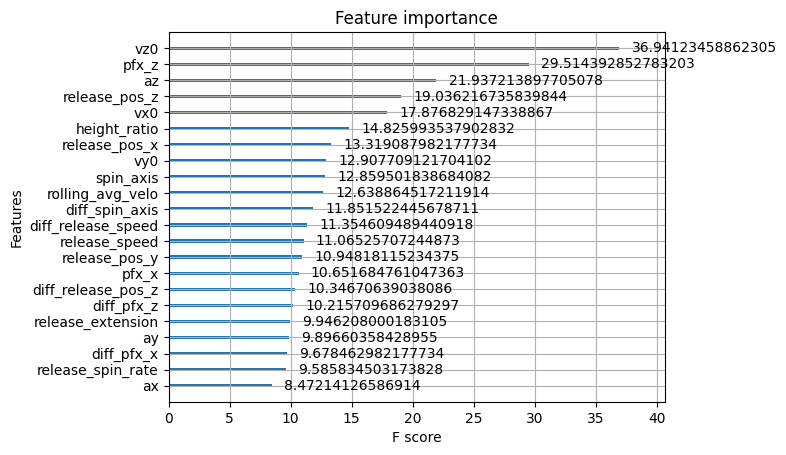

In [22]:
importance = final_model.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance)
plt.show()

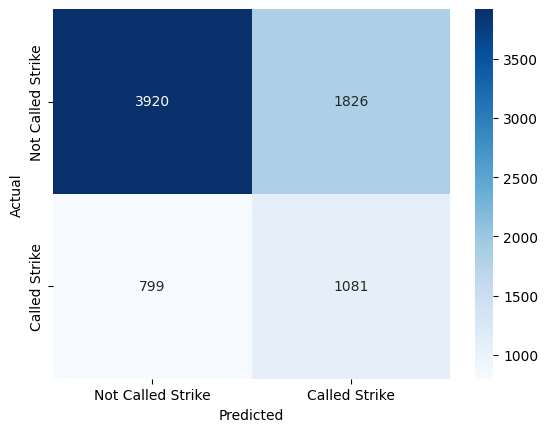

In [23]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Called Strike', 'Called Strike'], yticklabels=['Not Called Strike', 'Called Strike'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Testing Data Set Predictions

In [24]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'line_drive', 'diff_spin_axis', 'diff_pfx_x',
       'diff_pfx_z', 'diff_release_pos_z', 'diff_release_speed'],
      dtype='object')

In [25]:
predictions = xgb.DMatrix(testing_data, label=testing_label)

In [26]:
len(testing_label)

188456

In [27]:
y_pred = final_model.predict(predictions)

In [28]:
len(testing_data)

188456

In [29]:
testing_identifiers['xcs'] = y_pred

In [30]:
testing_identifiers.to_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/cs_2022&3_xcalledstrike.csv")